# Image Captioning

Problem : Automatically generate captions for a set of images. This could be useful for accessibility concerns such as in case of blind people.

Dataset : Flicker 8k dataset

The Flicker 8k dataset is a collection of 8,000 images, each with a resolution of 800x600 pixels, that were originally sourced from the photo-sharing website Flickr. The images are divided into 5,000 training images and 2,000 validation images. This dataset is often used for benchmarking and evaluating computer vision algorithms, particularly for tasks such as image captioning and image retrieval.

In [19]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tqdm import tqdm
from keras.applications import vgg16
from keras_preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2

In [6]:
#converting the text files to pandas dataframe
image_tokens=pd.read_csv("Flickr8k.lemma.token.txt",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv("Flickr_8k.trainImages.txt",names=["img_id"])
test_image_names=pd.read_csv("Flickr_8k.testImages.txt",names=["img_id"])
val_image_names=pd.read_csv("Flickr_8k.devImages.txt",names=["img_id"])

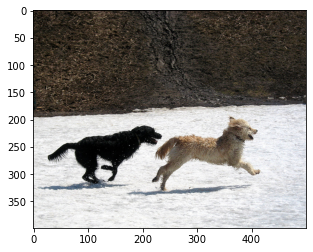

In [8]:
#visualising one of the train images
img=cv2.imread("Flicker8k_Dataset"+ "/" +train_image_names.img_id[0])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [9]:
#removing the '#0','#1','#2','#3','#4'(last two characters) from the image ids
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [10]:
#adds ''<start>' and '<end>' at the beginning and end of each caption
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

# Creating dictionaries to map image_id and their corresponding captions

In [13]:
#creating train dictionary having key as the image id and value as a list of its captions
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:14<00:00, 407.03it/s]


In [14]:
#creating test dictionary having key as the image id and value as a list of its captions
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 369.67it/s]


In [16]:
#creating validation dictionary having key as the image id and value as a list of its captions
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 348.60it/s]


# ResNet50 model for encoding images

ResNet50 is a deep convolutional neural network architecture that consists of 50 layers, developed by Microsoft Research Asia. The "Res" in ResNet stands for "Residual," which refers to the use of residual connections to enable the network to learn deeper and more complex features without the vanishing gradient problem. ResNet50 is trained on the ImageNet dataset, which consists of millions of labeled images, and has achieved state-of-the-art performance on a variety of computer vision tasks, such as image classification, object detection, and semantic segmentation. The architecture of ResNet50 includes convolutional layers, pooling layers, fully connected layers, and residual blocks with skip connections. The skip connections allow the network to shortcut over certain layers, which can improve the flow of gradients during backpropagation and reduce the number of parameters in the model. 

In [17]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model.summary()

94765736/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
          

 conv3_block3_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
          

                                )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block1_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
          

# Encoding images and forming dictionaries containing mapping of image_id to image encodings

In [21]:
#extracting image encodings(features) from resnet50 and forming dict train_features
path="Flicker8k_Dataset/"
train_features={}
c=0
for image_name in tqdm(train_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img) #Converts image into a numpy array with dimensions (height,width,channels)
  x = np.expand_dims(x, axis=0) #Add an extra dimension to the array to make its dimension as (1,height,width,channels)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze() #Squeeze method is used to convert features into 1D arrays

  0%|                                                                                         | 0/6000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  0%|                                                                               | 1/6000 [00:01<2:37:33,  1.58s/it]

1/1 [==============================] - 0s 111ms/step


  0%|                                                                               | 2/6000 [00:01<1:16:08,  1.31it/s]

1/1 [==============================] - 0s 112ms/step


  0%|                                                                                 | 3/6000 [00:01<50:21,  1.98it/s]

1/1 [==============================] - 0s 110ms/step


  0%|                                                                                 | 4/6000 [00:02<37:10,  2.69it/s]

1/1 [==============================] - 0s 110ms/step


  0%|                                                                                 | 5/6000 [00:02<30:03,  3.32it/s]

1/1 [==============================] - 0s 100ms/step


  0%|                                                                                 | 6/6000 [00:02<25:55,  3.85it/s]

1/1 [==============================] - 0s 126ms/step


  0%|                                                                                 | 7/6000 [00:02<24:01,  4.16it/s]

1/1 [==============================] - 0s 100ms/step


  0%|                                                                                 | 8/6000 [00:02<21:54,  4.56it/s]

1/1 [==============================] - 0s 102ms/step


  0%|                                                                                 | 9/6000 [00:03<20:15,  4.93it/s]

1/1 [==============================] - 0s 96ms/step


  0%|▏                                                                               | 10/6000 [00:03<19:08,  5.22it/s]

1/1 [==============================] - 0s 89ms/step


  0%|▏                                                                               | 11/6000 [00:03<18:06,  5.51it/s]

1/1 [==============================] - 0s 142ms/step


  0%|▏                                                                               | 12/6000 [00:03<18:53,  5.28it/s]

1/1 [==============================] - 0s 101ms/step


  0%|▏                                                                               | 13/6000 [00:03<18:29,  5.40it/s]

1/1 [==============================] - 0s 95ms/step


  0%|▏                                                                               | 14/6000 [00:03<17:41,  5.64it/s]

1/1 [==============================] - 0s 92ms/step


  0%|▏                                                                               | 15/6000 [00:04<17:17,  5.77it/s]

1/1 [==============================] - 0s 95ms/step


  0%|▏                                                                               | 16/6000 [00:04<16:53,  5.91it/s]

1/1 [==============================] - 0s 98ms/step


  0%|▏                                                                               | 17/6000 [00:04<16:45,  5.95it/s]

1/1 [==============================] - 0s 110ms/step


  0%|▏                                                                               | 18/6000 [00:04<16:38,  5.99it/s]

1/1 [==============================] - 0s 91ms/step


  0%|▎                                                                               | 19/6000 [00:04<16:46,  5.94it/s]

1/1 [==============================] - 0s 92ms/step


  0%|▎                                                                               | 20/6000 [00:04<16:35,  6.01it/s]

1/1 [==============================] - 0s 96ms/step


  0%|▎                                                                               | 21/6000 [00:05<16:31,  6.03it/s]

1/1 [==============================] - 0s 104ms/step


  0%|▎                                                                               | 22/6000 [00:05<16:32,  6.02it/s]

1/1 [==============================] - 0s 127ms/step


  0%|▎                                                                               | 23/6000 [00:05<17:43,  5.62it/s]

1/1 [==============================] - 0s 110ms/step


  0%|▎                                                                               | 24/6000 [00:05<17:34,  5.67it/s]

1/1 [==============================] - 0s 103ms/step


  0%|▎                                                                               | 25/6000 [00:05<17:14,  5.78it/s]

1/1 [==============================] - 0s 100ms/step


  0%|▎                                                                               | 26/6000 [00:05<17:01,  5.85it/s]

1/1 [==============================] - 0s 94ms/step


  0%|▎                                                                               | 27/6000 [00:06<16:42,  5.96it/s]

1/1 [==============================] - 0s 92ms/step


  0%|▎                                                                               | 28/6000 [00:06<16:30,  6.03it/s]

1/1 [==============================] - 0s 104ms/step


  0%|▍                                                                               | 29/6000 [00:06<16:25,  6.06it/s]

1/1 [==============================] - 0s 93ms/step


  0%|▍                                                                               | 30/6000 [00:06<16:15,  6.12it/s]

1/1 [==============================] - 0s 99ms/step


  1%|▍                                                                               | 31/6000 [00:06<16:25,  6.05it/s]

1/1 [==============================] - 0s 103ms/step


  1%|▍                                                                               | 32/6000 [00:06<16:19,  6.09it/s]

1/1 [==============================] - 0s 98ms/step


  1%|▍                                                                               | 33/6000 [00:07<16:14,  6.12it/s]

1/1 [==============================] - 0s 101ms/step


  1%|▍                                                                               | 34/6000 [00:07<16:04,  6.19it/s]

1/1 [==============================] - 0s 105ms/step


  1%|▍                                                                               | 35/6000 [00:07<16:01,  6.21it/s]

1/1 [==============================] - 0s 105ms/step


  1%|▍                                                                               | 36/6000 [00:07<16:22,  6.07it/s]

1/1 [==============================] - 0s 96ms/step


  1%|▍                                                                               | 37/6000 [00:07<16:17,  6.10it/s]

1/1 [==============================] - 0s 99ms/step


  1%|▌                                                                               | 38/6000 [00:07<16:16,  6.11it/s]

1/1 [==============================] - 0s 102ms/step


  1%|▌                                                                               | 39/6000 [00:08<16:13,  6.12it/s]

1/1 [==============================] - 0s 105ms/step


  1%|▌                                                                               | 40/6000 [00:08<16:13,  6.12it/s]

1/1 [==============================] - 0s 97ms/step


  1%|▌                                                                               | 41/6000 [00:08<16:18,  6.09it/s]

1/1 [==============================] - 0s 97ms/step


  1%|▌                                                                               | 42/6000 [00:08<16:14,  6.11it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▌                                                                               | 43/6000 [00:08<16:41,  5.95it/s]

1/1 [==============================] - 0s 109ms/step


  1%|▌                                                                               | 44/6000 [00:08<16:53,  5.87it/s]

1/1 [==============================] - 0s 126ms/step


  1%|▌                                                                               | 45/6000 [00:09<17:48,  5.57it/s]

1/1 [==============================] - 0s 99ms/step


  1%|▌                                                                               | 46/6000 [00:09<17:16,  5.74it/s]

1/1 [==============================] - 0s 103ms/step


  1%|▋                                                                               | 47/6000 [00:09<17:00,  5.83it/s]

1/1 [==============================] - 0s 99ms/step


  1%|▋                                                                               | 48/6000 [00:09<16:41,  5.95it/s]

1/1 [==============================] - 0s 90ms/step


  1%|▋                                                                               | 49/6000 [00:09<16:23,  6.05it/s]

1/1 [==============================] - 0s 92ms/step


  1%|▋                                                                               | 50/6000 [00:09<16:12,  6.12it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▋                                                                               | 51/6000 [00:10<16:09,  6.14it/s]

1/1 [==============================] - 0s 126ms/step


  1%|▋                                                                               | 52/6000 [00:10<16:48,  5.90it/s]

1/1 [==============================] - 0s 110ms/step


  1%|▋                                                                               | 53/6000 [00:10<16:53,  5.87it/s]

1/1 [==============================] - 0s 102ms/step


  1%|▋                                                                               | 54/6000 [00:10<16:49,  5.89it/s]

1/1 [==============================] - 0s 98ms/step


  1%|▋                                                                               | 55/6000 [00:10<16:46,  5.91it/s]

1/1 [==============================] - 0s 103ms/step


  1%|▋                                                                               | 56/6000 [00:10<16:36,  5.96it/s]

1/1 [==============================] - 0s 90ms/step


  1%|▊                                                                               | 57/6000 [00:11<16:16,  6.08it/s]

1/1 [==============================] - 0s 98ms/step


  1%|▊                                                                               | 58/6000 [00:11<16:26,  6.03it/s]

1/1 [==============================] - 0s 99ms/step


  1%|▊                                                                               | 59/6000 [00:11<16:16,  6.08it/s]

1/1 [==============================] - 0s 110ms/step


  1%|▊                                                                               | 60/6000 [00:11<16:35,  5.97it/s]

1/1 [==============================] - 0s 108ms/step


  1%|▊                                                                               | 61/6000 [00:11<16:28,  6.01it/s]

1/1 [==============================] - 0s 91ms/step


  1%|▊                                                                               | 62/6000 [00:11<16:13,  6.10it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▊                                                                               | 63/6000 [00:12<16:08,  6.13it/s]

1/1 [==============================] - 0s 99ms/step


  1%|▊                                                                               | 64/6000 [00:12<16:12,  6.11it/s]

1/1 [==============================] - 0s 100ms/step


  1%|▊                                                                               | 65/6000 [00:12<16:04,  6.15it/s]

1/1 [==============================] - 0s 94ms/step


  1%|▉                                                                               | 66/6000 [00:12<15:38,  6.33it/s]

1/1 [==============================] - 0s 97ms/step


  1%|▉                                                                               | 67/6000 [00:12<16:14,  6.09it/s]

1/1 [==============================] - 0s 85ms/step


  1%|▉                                                                               | 68/6000 [00:12<15:13,  6.49it/s]

1/1 [==============================] - 0s 76ms/step


  1%|▉                                                                               | 69/6000 [00:12<14:35,  6.77it/s]

1/1 [==============================] - 0s 77ms/step


  1%|▉                                                                               | 70/6000 [00:13<14:00,  7.05it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▉                                                                               | 71/6000 [00:13<13:36,  7.26it/s]

1/1 [==============================] - 0s 85ms/step


  1%|▉                                                                               | 72/6000 [00:13<13:32,  7.29it/s]

1/1 [==============================] - 0s 95ms/step


  1%|▉                                                                               | 73/6000 [00:13<14:22,  6.87it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▉                                                                               | 74/6000 [00:13<13:47,  7.17it/s]

1/1 [==============================] - 0s 86ms/step


  1%|█                                                                               | 75/6000 [00:13<13:45,  7.18it/s]

1/1 [==============================] - 0s 87ms/step


  1%|█                                                                               | 76/6000 [00:13<13:20,  7.40it/s]

1/1 [==============================] - 0s 75ms/step


  1%|█                                                                               | 77/6000 [00:14<13:15,  7.45it/s]

1/1 [==============================] - 0s 80ms/step


  1%|█                                                                               | 78/6000 [00:14<13:09,  7.50it/s]

1/1 [==============================] - 0s 88ms/step


  1%|█                                                                               | 79/6000 [00:14<13:06,  7.52it/s]

1/1 [==============================] - 0s 78ms/step


  1%|█                                                                               | 80/6000 [00:14<13:10,  7.49it/s]

1/1 [==============================] - 0s 94ms/step


  1%|█                                                                               | 81/6000 [00:14<13:18,  7.41it/s]

1/1 [==============================] - 0s 98ms/step


  1%|█                                                                               | 82/6000 [00:14<13:35,  7.25it/s]

1/1 [==============================] - 0s 82ms/step


  1%|█                                                                               | 83/6000 [00:14<13:18,  7.41it/s]

1/1 [==============================] - 0s 81ms/step


  1%|█                                                                               | 84/6000 [00:14<13:09,  7.49it/s]

1/1 [==============================] - 0s 85ms/step


  1%|█▏                                                                              | 85/6000 [00:15<20:43,  4.76it/s]

1/1 [==============================] - 0s 79ms/step


  1%|█▏                                                                              | 86/6000 [00:15<18:13,  5.41it/s]

1/1 [==============================] - 0s 85ms/step


  1%|█▏                                                                              | 87/6000 [00:15<16:41,  5.91it/s]

1/1 [==============================] - 0s 77ms/step


  1%|█▏                                                                              | 88/6000 [00:15<15:31,  6.35it/s]

1/1 [==============================] - 0s 91ms/step


  1%|█▏                                                                              | 89/6000 [00:15<14:43,  6.69it/s]

1/1 [==============================] - 0s 82ms/step


  2%|█▏                                                                              | 90/6000 [00:16<14:15,  6.91it/s]

1/1 [==============================] - 0s 73ms/step


  2%|█▏                                                                              | 91/6000 [00:16<13:37,  7.23it/s]

1/1 [==============================] - 0s 77ms/step


  2%|█▏                                                                              | 92/6000 [00:16<13:13,  7.44it/s]

1/1 [==============================] - 0s 110ms/step


  2%|█▏                                                                              | 93/6000 [00:16<14:19,  6.87it/s]

1/1 [==============================] - 0s 81ms/step


  2%|█▎                                                                              | 94/6000 [00:16<13:48,  7.13it/s]

1/1 [==============================] - 0s 92ms/step


  2%|█▎                                                                              | 95/6000 [00:16<13:49,  7.12it/s]

1/1 [==============================] - 0s 78ms/step


  2%|█▎                                                                              | 96/6000 [00:16<13:26,  7.32it/s]

1/1 [==============================] - 0s 78ms/step


  2%|█▎                                                                              | 97/6000 [00:16<13:07,  7.49it/s]

1/1 [==============================] - 0s 76ms/step


  2%|█▎                                                                              | 98/6000 [00:17<12:51,  7.65it/s]

1/1 [==============================] - 0s 71ms/step


  2%|█▎                                                                              | 99/6000 [00:17<12:36,  7.80it/s]

1/1 [==============================] - 0s 72ms/step


  2%|█▎                                                                             | 100/6000 [00:17<12:24,  7.92it/s]

1/1 [==============================] - 0s 109ms/step


  2%|█▎                                                                             | 101/6000 [00:17<13:12,  7.44it/s]

1/1 [==============================] - 0s 78ms/step


  2%|█▎                                                                             | 102/6000 [00:17<13:24,  7.33it/s]

1/1 [==============================] - 0s 75ms/step


  2%|█▎                                                                             | 103/6000 [00:17<13:06,  7.50it/s]

1/1 [==============================] - 0s 71ms/step


  2%|█▎                                                                             | 104/6000 [00:17<12:41,  7.74it/s]

1/1 [==============================] - 0s 72ms/step


  2%|█▍                                                                             | 105/6000 [00:18<12:42,  7.73it/s]

1/1 [==============================] - 0s 83ms/step


  2%|█▍                                                                             | 106/6000 [00:18<12:38,  7.77it/s]

1/1 [==============================] - 0s 80ms/step


  2%|█▍                                                                             | 107/6000 [00:18<12:40,  7.75it/s]

1/1 [==============================] - 0s 77ms/step


  2%|█▍                                                                             | 108/6000 [00:18<12:43,  7.72it/s]

1/1 [==============================] - 0s 110ms/step


  2%|█▍                                                                             | 109/6000 [00:18<13:26,  7.30it/s]

1/1 [==============================] - 0s 89ms/step


  2%|█▍                                                                             | 110/6000 [00:18<14:02,  6.99it/s]

1/1 [==============================] - 0s 76ms/step


  2%|█▍                                                                             | 111/6000 [00:18<13:47,  7.12it/s]

1/1 [==============================] - 0s 75ms/step


  2%|█▍                                                                             | 112/6000 [00:18<13:37,  7.20it/s]

1/1 [==============================] - 0s 81ms/step


  2%|█▍                                                                             | 113/6000 [00:19<13:32,  7.25it/s]

1/1 [==============================] - 0s 88ms/step


  2%|█▌                                                                             | 114/6000 [00:19<13:44,  7.14it/s]

1/1 [==============================] - 0s 83ms/step


  2%|█▌                                                                             | 115/6000 [00:19<13:51,  7.08it/s]

1/1 [==============================] - 0s 110ms/step


  2%|█▌                                                                             | 116/6000 [00:19<14:26,  6.79it/s]

1/1 [==============================] - 0s 78ms/step


  2%|█▌                                                                             | 117/6000 [00:19<13:48,  7.10it/s]

1/1 [==============================] - 0s 81ms/step


  2%|█▌                                                                             | 118/6000 [00:19<13:56,  7.03it/s]

1/1 [==============================] - 0s 82ms/step


  2%|█▌                                                                             | 119/6000 [00:19<13:44,  7.13it/s]

1/1 [==============================] - 0s 77ms/step


  2%|█▌                                                                             | 120/6000 [00:20<13:18,  7.36it/s]

1/1 [==============================] - 0s 80ms/step


  2%|█▌                                                                             | 121/6000 [00:20<13:16,  7.38it/s]

1/1 [==============================] - 0s 85ms/step


  2%|█▌                                                                             | 122/6000 [00:20<13:26,  7.29it/s]

1/1 [==============================] - 0s 88ms/step


  2%|█▌                                                                             | 123/6000 [00:20<13:45,  7.12it/s]

1/1 [==============================] - 0s 100ms/step


  2%|█▋                                                                             | 124/6000 [00:20<14:38,  6.69it/s]

1/1 [==============================] - 0s 94ms/step


  2%|█▋                                                                             | 125/6000 [00:20<14:29,  6.75it/s]

1/1 [==============================] - 0s 74ms/step


  2%|█▋                                                                             | 126/6000 [00:20<13:51,  7.06it/s]

1/1 [==============================] - 0s 77ms/step


  2%|█▋                                                                             | 127/6000 [00:21<13:22,  7.32it/s]

1/1 [==============================] - 0s 71ms/step


  2%|█▋                                                                             | 128/6000 [00:21<13:05,  7.47it/s]

1/1 [==============================] - 0s 73ms/step


  2%|█▋                                                                             | 129/6000 [00:21<12:44,  7.68it/s]

1/1 [==============================] - 0s 75ms/step


  2%|█▋                                                                             | 130/6000 [00:21<12:45,  7.66it/s]

1/1 [==============================] - 0s 95ms/step


  2%|█▋                                                                             | 131/6000 [00:21<13:33,  7.22it/s]

1/1 [==============================] - 0s 79ms/step


  2%|█▋                                                                             | 132/6000 [00:21<13:11,  7.42it/s]

1/1 [==============================] - 0s 80ms/step


  2%|█▊                                                                             | 133/6000 [00:21<13:00,  7.51it/s]

1/1 [==============================] - 0s 72ms/step


  2%|█▊                                                                             | 134/6000 [00:22<12:43,  7.68it/s]

1/1 [==============================] - 0s 75ms/step


  2%|█▊                                                                             | 135/6000 [00:22<12:33,  7.79it/s]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                             | 136/6000 [00:22<12:36,  7.75it/s]

1/1 [==============================] - 0s 92ms/step


  2%|█▊                                                                             | 137/6000 [00:22<12:54,  7.57it/s]

1/1 [==============================] - 0s 81ms/step


  2%|█▊                                                                             | 138/6000 [00:22<12:48,  7.63it/s]

1/1 [==============================] - 0s 95ms/step


  2%|█▊                                                                             | 139/6000 [00:22<13:32,  7.22it/s]

1/1 [==============================] - 0s 91ms/step


  2%|█▊                                                                             | 140/6000 [00:22<13:35,  7.18it/s]

1/1 [==============================] - 0s 72ms/step


  2%|█▊                                                                             | 141/6000 [00:22<13:08,  7.43it/s]

1/1 [==============================] - 0s 76ms/step


  2%|█▊                                                                             | 142/6000 [00:23<12:58,  7.53it/s]

1/1 [==============================] - 0s 75ms/step


  2%|█▉                                                                             | 143/6000 [00:23<12:44,  7.66it/s]

1/1 [==============================] - 0s 75ms/step


  2%|█▉                                                                             | 144/6000 [00:23<12:38,  7.72it/s]

1/1 [==============================] - 0s 74ms/step


  2%|█▉                                                                             | 145/6000 [00:23<12:38,  7.72it/s]

1/1 [==============================] - 0s 122ms/step


  2%|█▉                                                                             | 146/6000 [00:23<13:50,  7.05it/s]

1/1 [==============================] - 0s 91ms/step


  2%|█▉                                                                             | 147/6000 [00:23<14:18,  6.82it/s]

1/1 [==============================] - 0s 80ms/step


  2%|█▉                                                                             | 148/6000 [00:23<13:43,  7.11it/s]

1/1 [==============================] - 0s 79ms/step


  2%|█▉                                                                             | 149/6000 [00:24<13:19,  7.32it/s]

1/1 [==============================] - 0s 81ms/step


  2%|█▉                                                                             | 150/6000 [00:24<13:00,  7.50it/s]

1/1 [==============================] - 0s 73ms/step


  3%|█▉                                                                             | 151/6000 [00:24<12:47,  7.62it/s]

1/1 [==============================] - 0s 81ms/step


  3%|██                                                                             | 152/6000 [00:24<12:47,  7.61it/s]

1/1 [==============================] - 0s 71ms/step


  3%|██                                                                             | 153/6000 [00:24<12:36,  7.73it/s]

1/1 [==============================] - 0s 94ms/step


  3%|██                                                                             | 154/6000 [00:24<12:52,  7.57it/s]

1/1 [==============================] - 0s 79ms/step


  3%|██                                                                             | 155/6000 [00:24<13:08,  7.42it/s]

1/1 [==============================] - 0s 76ms/step


  3%|██                                                                             | 156/6000 [00:24<12:54,  7.55it/s]

1/1 [==============================] - 0s 74ms/step


  3%|██                                                                             | 157/6000 [00:25<12:38,  7.70it/s]

1/1 [==============================] - 0s 81ms/step


  3%|██                                                                             | 158/6000 [00:25<12:28,  7.81it/s]

1/1 [==============================] - 0s 69ms/step


  3%|██                                                                             | 159/6000 [00:25<12:15,  7.94it/s]

1/1 [==============================] - 0s 79ms/step


  3%|██                                                                             | 160/6000 [00:25<12:19,  7.90it/s]

1/1 [==============================] - 0s 76ms/step


  3%|██                                                                             | 161/6000 [00:25<12:22,  7.86it/s]

1/1 [==============================] - 0s 94ms/step


  3%|██▏                                                                            | 162/6000 [00:25<12:40,  7.68it/s]

1/1 [==============================] - 0s 82ms/step


  3%|██▏                                                                            | 163/6000 [00:25<13:05,  7.43it/s]

1/1 [==============================] - 0s 77ms/step


  3%|██▏                                                                            | 164/6000 [00:25<12:48,  7.59it/s]

1/1 [==============================] - 0s 86ms/step


  3%|██▏                                                                            | 165/6000 [00:26<12:27,  7.80it/s]

1/1 [==============================] - 0s 87ms/step


  3%|██▏                                                                            | 166/6000 [00:26<12:20,  7.88it/s]

1/1 [==============================] - 0s 83ms/step


  3%|██▏                                                                            | 167/6000 [00:26<12:18,  7.90it/s]

1/1 [==============================] - 0s 81ms/step


  3%|██▏                                                                            | 168/6000 [00:26<12:19,  7.89it/s]

1/1 [==============================] - 0s 110ms/step


  3%|██▏                                                                            | 169/6000 [00:26<13:02,  7.45it/s]

1/1 [==============================] - 0s 75ms/step


  3%|██▏                                                                            | 170/6000 [00:26<12:47,  7.60it/s]

1/1 [==============================] - 0s 81ms/step


  3%|██▎                                                                            | 171/6000 [00:26<12:46,  7.60it/s]

1/1 [==============================] - 0s 80ms/step


  3%|██▎                                                                            | 172/6000 [00:27<12:34,  7.73it/s]

1/1 [==============================] - 0s 87ms/step


  3%|██▎                                                                            | 173/6000 [00:27<12:43,  7.64it/s]

1/1 [==============================] - 0s 88ms/step


  3%|██▎                                                                            | 174/6000 [00:27<12:36,  7.70it/s]

1/1 [==============================] - 0s 81ms/step


  3%|██▎                                                                            | 175/6000 [00:27<12:54,  7.52it/s]

1/1 [==============================] - 0s 82ms/step


  3%|██▎                                                                            | 176/6000 [00:27<12:41,  7.65it/s]

1/1 [==============================] - 0s 110ms/step


  3%|██▎                                                                            | 177/6000 [00:27<14:09,  6.85it/s]

1/1 [==============================] - 0s 94ms/step


  3%|██▎                                                                            | 178/6000 [00:27<14:01,  6.92it/s]

1/1 [==============================] - 0s 84ms/step


  3%|██▎                                                                            | 179/6000 [00:28<13:44,  7.06it/s]

1/1 [==============================] - 0s 79ms/step


  3%|██▎                                                                            | 180/6000 [00:28<13:10,  7.36it/s]

1/1 [==============================] - 0s 81ms/step


  3%|██▍                                                                            | 181/6000 [00:28<12:52,  7.53it/s]

1/1 [==============================] - 0s 83ms/step


  3%|██▍                                                                            | 182/6000 [00:28<12:56,  7.49it/s]

1/1 [==============================] - 0s 84ms/step


  3%|██▍                                                                            | 183/6000 [00:28<12:33,  7.72it/s]

1/1 [==============================] - 0s 71ms/step


  3%|██▍                                                                            | 184/6000 [00:28<12:23,  7.82it/s]

1/1 [==============================] - 0s 111ms/step


  3%|██▍                                                                            | 185/6000 [00:28<13:15,  7.31it/s]

1/1 [==============================] - 0s 78ms/step


  3%|██▍                                                                            | 186/6000 [00:28<12:48,  7.57it/s]

1/1 [==============================] - 0s 87ms/step


  3%|██▍                                                                            | 187/6000 [00:29<12:56,  7.48it/s]

1/1 [==============================] - 0s 85ms/step


  3%|██▍                                                                            | 188/6000 [00:29<12:51,  7.53it/s]

1/1 [==============================] - 0s 77ms/step


  3%|██▍                                                                            | 189/6000 [00:29<12:46,  7.59it/s]

1/1 [==============================] - 0s 80ms/step


  3%|██▌                                                                            | 190/6000 [00:29<12:35,  7.69it/s]

1/1 [==============================] - 0s 82ms/step


  3%|██▌                                                                            | 191/6000 [00:29<12:36,  7.68it/s]

1/1 [==============================] - 0s 90ms/step


  3%|██▌                                                                            | 192/6000 [00:29<12:35,  7.68it/s]

1/1 [==============================] - 0s 96ms/step


  3%|██▌                                                                            | 193/6000 [00:29<13:36,  7.11it/s]

1/1 [==============================] - 0s 84ms/step


  3%|██▌                                                                            | 194/6000 [00:29<13:19,  7.26it/s]

1/1 [==============================] - 0s 94ms/step


  3%|██▌                                                                            | 195/6000 [00:30<13:48,  7.00it/s]

1/1 [==============================] - 0s 77ms/step


  3%|██▌                                                                            | 196/6000 [00:30<13:28,  7.18it/s]

1/1 [==============================] - 0s 82ms/step


  3%|██▌                                                                            | 197/6000 [00:30<13:01,  7.43it/s]

1/1 [==============================] - 0s 74ms/step


  3%|██▌                                                                            | 198/6000 [00:30<13:32,  7.14it/s]

1/1 [==============================] - 0s 75ms/step


  3%|██▌                                                                            | 199/6000 [00:30<13:01,  7.42it/s]

1/1 [==============================] - 0s 77ms/step


  3%|██▋                                                                            | 200/6000 [00:30<12:46,  7.56it/s]

1/1 [==============================] - 0s 110ms/step


  3%|██▋                                                                            | 201/6000 [00:30<13:11,  7.33it/s]

1/1 [==============================] - 0s 79ms/step


  3%|██▋                                                                            | 202/6000 [00:31<12:52,  7.51it/s]

1/1 [==============================] - 0s 86ms/step


  3%|██▋                                                                            | 203/6000 [00:31<12:53,  7.49it/s]

1/1 [==============================] - 0s 86ms/step


  3%|██▋                                                                            | 204/6000 [00:31<12:46,  7.56it/s]

1/1 [==============================] - 0s 82ms/step


  3%|██▋                                                                            | 205/6000 [00:31<12:22,  7.81it/s]

1/1 [==============================] - 0s 71ms/step


  3%|██▋                                                                            | 206/6000 [00:31<12:10,  7.93it/s]

1/1 [==============================] - 0s 82ms/step


  3%|██▋                                                                            | 207/6000 [00:31<11:58,  8.06it/s]

1/1 [==============================] - 0s 81ms/step


  3%|██▋                                                                            | 208/6000 [00:31<12:02,  8.02it/s]

1/1 [==============================] - 0s 94ms/step


  3%|██▊                                                                            | 209/6000 [00:31<12:44,  7.57it/s]

1/1 [==============================] - 0s 75ms/step


  4%|██▊                                                                            | 210/6000 [00:32<12:33,  7.69it/s]

1/1 [==============================] - 0s 75ms/step


  4%|██▊                                                                            | 211/6000 [00:32<12:24,  7.77it/s]

1/1 [==============================] - 0s 64ms/step


  4%|██▊                                                                            | 212/6000 [00:32<11:53,  8.11it/s]

1/1 [==============================] - 0s 69ms/step


  4%|██▊                                                                            | 213/6000 [00:32<12:08,  7.94it/s]

1/1 [==============================] - 0s 73ms/step


  4%|██▊                                                                            | 214/6000 [00:32<11:57,  8.06it/s]

1/1 [==============================] - 0s 79ms/step


  4%|██▊                                                                            | 215/6000 [00:32<11:45,  8.19it/s]

1/1 [==============================] - 0s 86ms/step


  4%|██▊                                                                            | 216/6000 [00:32<12:05,  7.97it/s]

1/1 [==============================] - 0s 84ms/step


  4%|██▊                                                                            | 217/6000 [00:32<11:56,  8.07it/s]

1/1 [==============================] - 0s 73ms/step


  4%|██▊                                                                            | 218/6000 [00:33<11:49,  8.15it/s]

1/1 [==============================] - 0s 84ms/step


  4%|██▉                                                                            | 219/6000 [00:33<11:44,  8.21it/s]

1/1 [==============================] - 0s 86ms/step


  4%|██▉                                                                            | 220/6000 [00:33<11:53,  8.10it/s]

1/1 [==============================] - 0s 82ms/step


  4%|██▉                                                                            | 221/6000 [00:33<11:49,  8.15it/s]

1/1 [==============================] - 0s 110ms/step


  4%|██▉                                                                            | 222/6000 [00:33<12:40,  7.60it/s]

1/1 [==============================] - 0s 94ms/step


  4%|██▉                                                                            | 223/6000 [00:33<12:56,  7.44it/s]

1/1 [==============================] - 0s 77ms/step


  4%|██▉                                                                            | 224/6000 [00:33<12:42,  7.58it/s]

1/1 [==============================] - 0s 82ms/step


  4%|██▉                                                                            | 225/6000 [00:33<12:16,  7.84it/s]

1/1 [==============================] - 0s 82ms/step


  4%|██▉                                                                            | 226/6000 [00:34<12:15,  7.85it/s]

1/1 [==============================] - 0s 75ms/step


  4%|██▉                                                                            | 227/6000 [00:34<12:04,  7.97it/s]

1/1 [==============================] - 0s 73ms/step


  4%|███                                                                            | 228/6000 [00:34<11:58,  8.03it/s]

1/1 [==============================] - 0s 73ms/step


  4%|███                                                                            | 229/6000 [00:34<11:55,  8.06it/s]

1/1 [==============================] - 0s 110ms/step


  4%|███                                                                            | 230/6000 [00:34<12:37,  7.62it/s]

1/1 [==============================] - 0s 79ms/step


  4%|███                                                                            | 231/6000 [00:34<12:27,  7.72it/s]

1/1 [==============================] - 0s 75ms/step


  4%|███                                                                            | 232/6000 [00:34<12:19,  7.80it/s]

1/1 [==============================] - 0s 79ms/step


  4%|███                                                                            | 233/6000 [00:34<12:02,  7.98it/s]

1/1 [==============================] - 0s 67ms/step


  4%|███                                                                            | 234/6000 [00:35<11:40,  8.23it/s]

1/1 [==============================] - 0s 77ms/step


  4%|███                                                                            | 235/6000 [00:35<11:44,  8.19it/s]

1/1 [==============================] - 0s 71ms/step


  4%|███                                                                            | 236/6000 [00:35<11:39,  8.24it/s]

1/1 [==============================] - 0s 71ms/step


  4%|███                                                                            | 237/6000 [00:35<11:45,  8.17it/s]

1/1 [==============================] - 0s 91ms/step


  4%|███▏                                                                           | 238/6000 [00:35<12:02,  7.98it/s]

1/1 [==============================] - 0s 70ms/step


  4%|███▏                                                                           | 239/6000 [00:35<11:50,  8.10it/s]

1/1 [==============================] - 0s 75ms/step


  4%|███▏                                                                           | 240/6000 [00:35<11:43,  8.19it/s]

1/1 [==============================] - 0s 86ms/step


  4%|███▏                                                                           | 241/6000 [00:35<11:39,  8.23it/s]

1/1 [==============================] - 0s 80ms/step


  4%|███▏                                                                           | 242/6000 [00:36<11:42,  8.20it/s]

1/1 [==============================] - 0s 90ms/step


  4%|███▏                                                                           | 243/6000 [00:36<12:04,  7.95it/s]

1/1 [==============================] - 0s 110ms/step


  4%|███▏                                                                           | 244/6000 [00:36<12:59,  7.38it/s]

1/1 [==============================] - 0s 79ms/step


  4%|███▏                                                                           | 245/6000 [00:36<13:11,  7.28it/s]

1/1 [==============================] - 0s 78ms/step


  4%|███▏                                                                           | 246/6000 [00:36<12:51,  7.46it/s]

1/1 [==============================] - 0s 71ms/step


  4%|███▎                                                                           | 247/6000 [00:36<12:28,  7.68it/s]

1/1 [==============================] - 0s 80ms/step


  4%|███▎                                                                           | 248/6000 [00:36<12:08,  7.90it/s]

1/1 [==============================] - 0s 73ms/step


  4%|███▎                                                                           | 249/6000 [00:37<12:00,  7.98it/s]

1/1 [==============================] - 0s 84ms/step


  4%|███▎                                                                           | 250/6000 [00:37<11:46,  8.14it/s]

1/1 [==============================] - 0s 82ms/step


  4%|███▎                                                                           | 251/6000 [00:37<11:48,  8.11it/s]

1/1 [==============================] - 0s 111ms/step


  4%|███▎                                                                           | 252/6000 [00:37<13:09,  7.28it/s]

1/1 [==============================] - 0s 79ms/step


  4%|███▎                                                                           | 253/6000 [00:37<13:15,  7.22it/s]

1/1 [==============================] - 0s 75ms/step


  4%|███▎                                                                           | 254/6000 [00:37<12:52,  7.43it/s]

1/1 [==============================] - 0s 80ms/step


  4%|███▎                                                                           | 255/6000 [00:37<12:42,  7.54it/s]

1/1 [==============================] - 0s 86ms/step


  4%|███▎                                                                           | 256/6000 [00:37<12:45,  7.50it/s]

1/1 [==============================] - 0s 86ms/step


  4%|███▍                                                                           | 257/6000 [00:38<12:26,  7.70it/s]

1/1 [==============================] - 0s 74ms/step


  4%|███▍                                                                           | 258/6000 [00:38<12:21,  7.74it/s]

1/1 [==============================] - 0s 88ms/step


  4%|███▍                                                                           | 259/6000 [00:38<12:29,  7.66it/s]

1/1 [==============================] - 0s 94ms/step


  4%|███▍                                                                           | 260/6000 [00:38<12:49,  7.46it/s]

1/1 [==============================] - 0s 80ms/step


  4%|███▍                                                                           | 261/6000 [00:38<12:43,  7.52it/s]

1/1 [==============================] - 0s 72ms/step


  4%|███▍                                                                           | 262/6000 [00:38<12:50,  7.44it/s]

1/1 [==============================] - 0s 74ms/step


  4%|███▍                                                                           | 263/6000 [00:38<12:36,  7.59it/s]

1/1 [==============================] - 0s 80ms/step


  4%|███▍                                                                           | 264/6000 [00:39<12:34,  7.60it/s]

1/1 [==============================] - 0s 93ms/step


  4%|███▍                                                                           | 265/6000 [00:39<12:50,  7.45it/s]

1/1 [==============================] - 0s 89ms/step


  4%|███▌                                                                           | 266/6000 [00:39<12:50,  7.44it/s]

1/1 [==============================] - 0s 141ms/step


  4%|███▌                                                                           | 267/6000 [00:39<14:34,  6.56it/s]

1/1 [==============================] - 0s 110ms/step


  4%|███▌                                                                           | 268/6000 [00:39<14:42,  6.49it/s]

1/1 [==============================] - 0s 85ms/step


  4%|███▌                                                                           | 269/6000 [00:39<14:10,  6.74it/s]

1/1 [==============================] - 0s 81ms/step


  4%|███▌                                                                           | 270/6000 [00:39<13:34,  7.03it/s]

1/1 [==============================] - 0s 85ms/step


  5%|███▌                                                                           | 271/6000 [00:40<13:52,  6.89it/s]

1/1 [==============================] - 0s 76ms/step


  5%|███▌                                                                           | 272/6000 [00:40<13:28,  7.08it/s]

1/1 [==============================] - 0s 77ms/step


  5%|███▌                                                                           | 273/6000 [00:40<13:12,  7.23it/s]

1/1 [==============================] - 0s 82ms/step


  5%|███▌                                                                           | 274/6000 [00:40<12:59,  7.35it/s]

1/1 [==============================] - 0s 114ms/step


  5%|███▌                                                                           | 275/6000 [00:40<13:36,  7.01it/s]

1/1 [==============================] - 0s 79ms/step


  5%|███▋                                                                           | 276/6000 [00:40<12:59,  7.35it/s]

1/1 [==============================] - 0s 90ms/step


  5%|███▋                                                                           | 277/6000 [00:40<13:04,  7.29it/s]

1/1 [==============================] - 0s 80ms/step


  5%|███▋                                                                           | 278/6000 [00:40<12:56,  7.37it/s]

1/1 [==============================] - 0s 78ms/step


  5%|███▋                                                                           | 279/6000 [00:41<12:51,  7.42it/s]

1/1 [==============================] - 0s 80ms/step


  5%|███▋                                                                           | 280/6000 [00:41<12:45,  7.47it/s]

1/1 [==============================] - 0s 78ms/step


  5%|███▋                                                                           | 281/6000 [00:41<12:38,  7.54it/s]

1/1 [==============================] - 0s 77ms/step


  5%|███▋                                                                           | 282/6000 [00:41<12:28,  7.64it/s]

1/1 [==============================] - 0s 111ms/step


  5%|███▋                                                                           | 283/6000 [00:41<13:15,  7.19it/s]

1/1 [==============================] - 0s 78ms/step


  5%|███▋                                                                           | 284/6000 [00:41<13:16,  7.17it/s]

1/1 [==============================] - 0s 76ms/step


  5%|███▊                                                                           | 285/6000 [00:41<12:55,  7.37it/s]

1/1 [==============================] - 0s 74ms/step


  5%|███▊                                                                           | 286/6000 [00:42<12:41,  7.51it/s]

1/1 [==============================] - 0s 74ms/step


  5%|███▊                                                                           | 287/6000 [00:42<12:29,  7.62it/s]

1/1 [==============================] - 0s 80ms/step


  5%|███▊                                                                           | 288/6000 [00:42<12:52,  7.39it/s]

1/1 [==============================] - 0s 89ms/step


  5%|███▊                                                                           | 289/6000 [00:42<13:16,  7.17it/s]

1/1 [==============================] - 0s 73ms/step


  5%|███▊                                                                           | 290/6000 [00:42<12:59,  7.32it/s]

1/1 [==============================] - 0s 79ms/step


  5%|███▊                                                                           | 291/6000 [00:42<12:47,  7.44it/s]

1/1 [==============================] - 0s 84ms/step


  5%|███▊                                                                           | 292/6000 [00:42<12:41,  7.49it/s]

1/1 [==============================] - 0s 73ms/step


  5%|███▊                                                                           | 293/6000 [00:43<12:32,  7.59it/s]

1/1 [==============================] - 0s 72ms/step


  5%|███▊                                                                           | 294/6000 [00:43<12:54,  7.37it/s]

1/1 [==============================] - 0s 84ms/step


  5%|███▉                                                                           | 295/6000 [00:43<12:40,  7.50it/s]

1/1 [==============================] - 0s 76ms/step


  5%|███▉                                                                           | 296/6000 [00:43<12:21,  7.69it/s]

1/1 [==============================] - 0s 87ms/step


  5%|███▉                                                                           | 297/6000 [00:43<12:21,  7.69it/s]

1/1 [==============================] - 0s 85ms/step


  5%|███▉                                                                           | 298/6000 [00:43<12:53,  7.37it/s]

1/1 [==============================] - 0s 89ms/step


  5%|███▉                                                                           | 299/6000 [00:43<13:01,  7.29it/s]

1/1 [==============================] - 0s 74ms/step


  5%|███▉                                                                           | 300/6000 [00:43<12:42,  7.48it/s]

1/1 [==============================] - 0s 94ms/step


  5%|███▉                                                                           | 301/6000 [00:44<20:35,  4.61it/s]

1/1 [==============================] - 0s 79ms/step


  5%|███▉                                                                           | 302/6000 [00:44<17:59,  5.28it/s]

1/1 [==============================] - 0s 87ms/step


  5%|███▉                                                                           | 303/6000 [00:44<16:29,  5.76it/s]

1/1 [==============================] - 0s 83ms/step


  5%|████                                                                           | 304/6000 [00:44<15:00,  6.33it/s]

1/1 [==============================] - 0s 72ms/step


  5%|████                                                                           | 305/6000 [00:44<13:59,  6.78it/s]

1/1 [==============================] - 0s 79ms/step


  5%|████                                                                           | 306/6000 [00:44<13:25,  7.06it/s]

1/1 [==============================] - 0s 81ms/step


  5%|████                                                                           | 307/6000 [00:45<13:11,  7.19it/s]

1/1 [==============================] - 0s 75ms/step


  5%|████                                                                           | 308/6000 [00:45<12:52,  7.37it/s]

1/1 [==============================] - 0s 110ms/step


  5%|████                                                                           | 309/6000 [00:45<13:12,  7.18it/s]

1/1 [==============================] - 0s 78ms/step


  5%|████                                                                           | 310/6000 [00:45<13:16,  7.14it/s]

1/1 [==============================] - 0s 80ms/step


  5%|████                                                                           | 311/6000 [00:45<12:53,  7.35it/s]

1/1 [==============================] - 0s 78ms/step


  5%|████                                                                           | 312/6000 [00:45<12:43,  7.45it/s]

1/1 [==============================] - 0s 79ms/step


  5%|████                                                                           | 313/6000 [00:45<12:25,  7.63it/s]

1/1 [==============================] - 0s 75ms/step


  5%|████▏                                                                          | 314/6000 [00:46<12:19,  7.69it/s]

1/1 [==============================] - 0s 77ms/step


  5%|████▏                                                                          | 315/6000 [00:46<12:55,  7.33it/s]

1/1 [==============================] - 0s 80ms/step


  5%|████▏                                                                          | 316/6000 [00:46<12:39,  7.48it/s]

1/1 [==============================] - 0s 110ms/step


  5%|████▏                                                                          | 317/6000 [00:46<13:01,  7.27it/s]

1/1 [==============================] - 0s 78ms/step


  5%|████▏                                                                          | 318/6000 [00:46<12:40,  7.47it/s]

1/1 [==============================] - 0s 83ms/step


  5%|████▏                                                                          | 319/6000 [00:46<12:40,  7.47it/s]

1/1 [==============================] - 0s 82ms/step


  5%|████▏                                                                          | 320/6000 [00:46<12:23,  7.64it/s]

1/1 [==============================] - 0s 80ms/step


  5%|████▏                                                                          | 321/6000 [00:46<12:15,  7.72it/s]

1/1 [==============================] - 0s 79ms/step


  5%|████▏                                                                          | 322/6000 [00:47<12:09,  7.78it/s]

1/1 [==============================] - 0s 79ms/step


  5%|████▎                                                                          | 323/6000 [00:47<12:10,  7.77it/s]

1/1 [==============================] - 0s 83ms/step


  5%|████▎                                                                          | 324/6000 [00:47<12:04,  7.84it/s]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                          | 325/6000 [00:47<12:50,  7.37it/s]

1/1 [==============================] - 0s 84ms/step


  5%|████▎                                                                          | 326/6000 [00:47<12:47,  7.39it/s]

1/1 [==============================] - 0s 78ms/step


  5%|████▎                                                                          | 327/6000 [00:47<12:36,  7.50it/s]

1/1 [==============================] - 0s 88ms/step


  5%|████▎                                                                          | 328/6000 [00:47<12:32,  7.54it/s]

1/1 [==============================] - 0s 73ms/step


  5%|████▎                                                                          | 329/6000 [00:48<12:12,  7.74it/s]

1/1 [==============================] - 0s 84ms/step


  6%|████▎                                                                          | 330/6000 [00:48<12:31,  7.54it/s]

1/1 [==============================] - 0s 86ms/step


  6%|████▎                                                                          | 331/6000 [00:48<12:39,  7.47it/s]

1/1 [==============================] - 0s 94ms/step


  6%|████▎                                                                          | 332/6000 [00:48<13:15,  7.12it/s]

1/1 [==============================] - 0s 84ms/step


  6%|████▍                                                                          | 333/6000 [00:48<13:26,  7.02it/s]

1/1 [==============================] - 0s 88ms/step


  6%|████▍                                                                          | 334/6000 [00:48<13:14,  7.13it/s]

1/1 [==============================] - 0s 88ms/step


  6%|████▍                                                                          | 335/6000 [00:48<12:59,  7.27it/s]

1/1 [==============================] - 0s 78ms/step


  6%|████▍                                                                          | 336/6000 [00:49<12:44,  7.41it/s]

1/1 [==============================] - 0s 77ms/step


  6%|████▍                                                                          | 337/6000 [00:49<12:27,  7.57it/s]

1/1 [==============================] - 0s 84ms/step


  6%|████▍                                                                          | 338/6000 [00:49<12:33,  7.51it/s]

1/1 [==============================] - 0s 127ms/step


  6%|████▍                                                                          | 339/6000 [00:49<13:28,  7.00it/s]

1/1 [==============================] - 0s 98ms/step


  6%|████▍                                                                          | 340/6000 [00:49<13:38,  6.91it/s]

1/1 [==============================] - 0s 77ms/step


  6%|████▍                                                                          | 341/6000 [00:49<13:12,  7.14it/s]

1/1 [==============================] - 0s 81ms/step


  6%|████▌                                                                          | 342/6000 [00:49<12:49,  7.35it/s]

1/1 [==============================] - 0s 87ms/step


  6%|████▌                                                                          | 343/6000 [00:49<12:40,  7.44it/s]

1/1 [==============================] - 0s 80ms/step


  6%|████▌                                                                          | 344/6000 [00:50<12:35,  7.49it/s]

1/1 [==============================] - 0s 96ms/step


  6%|████▌                                                                          | 345/6000 [00:50<12:58,  7.26it/s]

1/1 [==============================] - 0s 125ms/step


  6%|████▌                                                                          | 346/6000 [00:50<13:48,  6.82it/s]

1/1 [==============================] - 0s 94ms/step


  6%|████▌                                                                          | 347/6000 [00:50<13:40,  6.89it/s]

1/1 [==============================] - 0s 79ms/step


  6%|████▌                                                                          | 348/6000 [00:50<13:11,  7.14it/s]

1/1 [==============================] - 0s 73ms/step


  6%|████▌                                                                          | 349/6000 [00:50<12:41,  7.42it/s]

1/1 [==============================] - 0s 87ms/step


  6%|████▌                                                                          | 350/6000 [00:50<12:21,  7.62it/s]

1/1 [==============================] - 0s 84ms/step


  6%|████▌                                                                          | 351/6000 [00:51<12:05,  7.79it/s]

1/1 [==============================] - 0s 86ms/step


  6%|████▋                                                                          | 352/6000 [00:51<12:06,  7.78it/s]

1/1 [==============================] - 0s 79ms/step


  6%|████▋                                                                          | 353/6000 [00:51<11:58,  7.86it/s]

1/1 [==============================] - 0s 110ms/step


  6%|████▋                                                                          | 354/6000 [00:51<12:36,  7.47it/s]

1/1 [==============================] - 0s 90ms/step


  6%|████▋                                                                          | 355/6000 [00:51<12:49,  7.34it/s]

1/1 [==============================] - 0s 78ms/step


  6%|████▋                                                                          | 356/6000 [00:51<12:35,  7.47it/s]

1/1 [==============================] - 0s 86ms/step


  6%|████▋                                                                          | 357/6000 [00:51<12:14,  7.68it/s]

1/1 [==============================] - 0s 82ms/step


  6%|████▋                                                                          | 358/6000 [00:51<12:03,  7.79it/s]

1/1 [==============================] - 0s 82ms/step


  6%|████▋                                                                          | 359/6000 [00:52<11:49,  7.95it/s]

1/1 [==============================] - 0s 80ms/step


  6%|████▋                                                                          | 360/6000 [00:52<11:51,  7.92it/s]

1/1 [==============================] - 0s 75ms/step


  6%|████▊                                                                          | 361/6000 [00:52<11:47,  7.97it/s]

1/1 [==============================] - 0s 125ms/step


  6%|████▊                                                                          | 362/6000 [00:52<12:41,  7.41it/s]

1/1 [==============================] - 0s 78ms/step


  6%|████▊                                                                          | 363/6000 [00:52<12:24,  7.57it/s]

1/1 [==============================] - 0s 81ms/step


  6%|████▊                                                                          | 364/6000 [00:52<12:20,  7.61it/s]

1/1 [==============================] - 0s 76ms/step


  6%|████▊                                                                          | 365/6000 [00:52<12:04,  7.78it/s]

1/1 [==============================] - 0s 72ms/step


  6%|████▊                                                                          | 366/6000 [00:53<12:01,  7.81it/s]

1/1 [==============================] - 0s 81ms/step


  6%|████▊                                                                          | 367/6000 [00:53<12:06,  7.76it/s]

1/1 [==============================] - 0s 78ms/step


  6%|████▊                                                                          | 368/6000 [00:53<11:52,  7.91it/s]

1/1 [==============================] - 0s 77ms/step


  6%|████▊                                                                          | 369/6000 [00:53<11:52,  7.90it/s]

1/1 [==============================] - 0s 97ms/step


  6%|████▊                                                                          | 370/6000 [00:53<12:43,  7.38it/s]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                          | 371/6000 [00:53<12:25,  7.55it/s]

1/1 [==============================] - 0s 79ms/step


  6%|████▉                                                                          | 372/6000 [00:53<12:27,  7.53it/s]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                          | 373/6000 [00:53<12:05,  7.75it/s]

1/1 [==============================] - 0s 87ms/step


  6%|████▉                                                                          | 374/6000 [00:54<11:50,  7.92it/s]

1/1 [==============================] - 0s 80ms/step


  6%|████▉                                                                          | 375/6000 [00:54<11:40,  8.03it/s]

1/1 [==============================] - 0s 83ms/step


  6%|████▉                                                                          | 376/6000 [00:54<11:45,  7.97it/s]

1/1 [==============================] - 0s 80ms/step


  6%|████▉                                                                          | 377/6000 [00:54<11:38,  8.05it/s]

1/1 [==============================] - 0s 110ms/step


  6%|████▉                                                                          | 378/6000 [00:54<12:30,  7.49it/s]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                          | 379/6000 [00:54<12:16,  7.64it/s]

1/1 [==============================] - 0s 84ms/step


  6%|█████                                                                          | 380/6000 [00:54<12:20,  7.59it/s]

1/1 [==============================] - 0s 77ms/step


  6%|█████                                                                          | 381/6000 [00:54<12:00,  7.80it/s]

1/1 [==============================] - 0s 71ms/step


  6%|█████                                                                          | 382/6000 [00:55<11:40,  8.02it/s]

1/1 [==============================] - 0s 81ms/step


  6%|█████                                                                          | 383/6000 [00:55<11:40,  8.02it/s]

1/1 [==============================] - 0s 73ms/step


  6%|█████                                                                          | 384/6000 [00:55<11:38,  8.04it/s]

1/1 [==============================] - 0s 91ms/step


  6%|█████                                                                          | 385/6000 [00:55<12:02,  7.77it/s]

1/1 [==============================] - 0s 126ms/step


  6%|█████                                                                          | 386/6000 [00:55<13:17,  7.04it/s]

1/1 [==============================] - 0s 94ms/step


  6%|█████                                                                          | 387/6000 [00:55<13:19,  7.02it/s]

1/1 [==============================] - 0s 83ms/step


  6%|█████                                                                          | 388/6000 [00:55<13:00,  7.19it/s]

1/1 [==============================] - 0s 81ms/step


  6%|█████                                                                          | 389/6000 [00:56<12:35,  7.42it/s]

1/1 [==============================] - 0s 75ms/step


  6%|█████▏                                                                         | 390/6000 [00:56<12:16,  7.62it/s]

1/1 [==============================] - 0s 78ms/step


  7%|█████▏                                                                         | 391/6000 [00:56<12:11,  7.66it/s]

1/1 [==============================] - 0s 83ms/step


  7%|█████▏                                                                         | 392/6000 [00:56<12:11,  7.67it/s]

1/1 [==============================] - 0s 110ms/step


  7%|█████▏                                                                         | 393/6000 [00:56<12:44,  7.34it/s]

1/1 [==============================] - 0s 91ms/step


  7%|█████▏                                                                         | 394/6000 [00:56<12:52,  7.26it/s]

1/1 [==============================] - 0s 83ms/step


  7%|█████▏                                                                         | 395/6000 [00:56<12:44,  7.33it/s]

1/1 [==============================] - 0s 81ms/step


  7%|█████▏                                                                         | 396/6000 [00:56<12:28,  7.49it/s]

1/1 [==============================] - 0s 82ms/step


  7%|█████▏                                                                         | 397/6000 [00:57<12:21,  7.56it/s]

1/1 [==============================] - 0s 75ms/step


  7%|█████▏                                                                         | 398/6000 [00:57<12:11,  7.66it/s]

1/1 [==============================] - 0s 79ms/step


  7%|█████▎                                                                         | 399/6000 [00:57<12:14,  7.62it/s]

1/1 [==============================] - 0s 110ms/step


  7%|█████▎                                                                         | 400/6000 [00:57<12:57,  7.20it/s]

1/1 [==============================] - 0s 94ms/step


  7%|█████▎                                                                         | 401/6000 [00:57<13:01,  7.16it/s]

1/1 [==============================] - 0s 87ms/step


  7%|█████▎                                                                         | 402/6000 [00:57<13:24,  6.96it/s]

1/1 [==============================] - 0s 81ms/step


  7%|█████▎                                                                         | 403/6000 [00:57<12:56,  7.21it/s]

1/1 [==============================] - 0s 84ms/step


  7%|█████▎                                                                         | 404/6000 [00:58<12:30,  7.46it/s]

1/1 [==============================] - 0s 76ms/step


  7%|█████▎                                                                         | 405/6000 [00:58<12:27,  7.49it/s]

1/1 [==============================] - 0s 91ms/step


  7%|█████▎                                                                         | 406/6000 [00:58<12:22,  7.53it/s]

1/1 [==============================] - 0s 80ms/step


  7%|█████▎                                                                         | 407/6000 [00:58<12:47,  7.28it/s]

1/1 [==============================] - 0s 110ms/step


  7%|█████▎                                                                         | 408/6000 [00:58<13:08,  7.09it/s]

1/1 [==============================] - 0s 78ms/step


  7%|█████▍                                                                         | 409/6000 [00:58<13:35,  6.86it/s]

1/1 [==============================] - 0s 79ms/step


  7%|█████▍                                                                         | 410/6000 [00:58<13:09,  7.08it/s]

1/1 [==============================] - 0s 75ms/step


  7%|█████▍                                                                         | 411/6000 [00:59<12:38,  7.37it/s]

1/1 [==============================] - 0s 89ms/step


  7%|█████▍                                                                         | 412/6000 [00:59<12:16,  7.59it/s]

1/1 [==============================] - 0s 86ms/step


  7%|█████▍                                                                         | 413/6000 [00:59<12:02,  7.73it/s]

1/1 [==============================] - 0s 86ms/step


  7%|█████▍                                                                         | 414/6000 [00:59<11:57,  7.79it/s]

1/1 [==============================] - 0s 86ms/step


  7%|█████▍                                                                         | 415/6000 [00:59<11:55,  7.80it/s]

1/1 [==============================] - 0s 133ms/step


  7%|█████▍                                                                         | 416/6000 [00:59<13:19,  6.99it/s]

1/1 [==============================] - 0s 82ms/step


  7%|█████▍                                                                         | 417/6000 [00:59<13:23,  6.95it/s]

1/1 [==============================] - 0s 86ms/step


  7%|█████▌                                                                         | 418/6000 [00:59<13:29,  6.90it/s]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                         | 419/6000 [01:00<13:10,  7.06it/s]

1/1 [==============================] - 0s 79ms/step


  7%|█████▌                                                                         | 420/6000 [01:00<12:49,  7.25it/s]

1/1 [==============================] - 0s 86ms/step


  7%|█████▌                                                                         | 421/6000 [01:00<12:42,  7.32it/s]

1/1 [==============================] - 0s 84ms/step


  7%|█████▌                                                                         | 422/6000 [01:00<12:36,  7.37it/s]

1/1 [==============================] - 0s 81ms/step


  7%|█████▌                                                                         | 423/6000 [01:00<12:27,  7.46it/s]

1/1 [==============================] - 0s 94ms/step


  7%|█████▌                                                                         | 424/6000 [01:00<12:58,  7.16it/s]

1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                         | 425/6000 [01:00<12:35,  7.38it/s]

1/1 [==============================] - 0s 77ms/step


  7%|█████▌                                                                         | 426/6000 [01:01<12:21,  7.52it/s]

1/1 [==============================] - 0s 77ms/step


  7%|█████▌                                                                         | 427/6000 [01:01<12:18,  7.55it/s]

1/1 [==============================] - 0s 84ms/step


  7%|█████▋                                                                         | 428/6000 [01:01<12:20,  7.52it/s]

1/1 [==============================] - 0s 96ms/step


  7%|█████▋                                                                         | 429/6000 [01:01<12:29,  7.44it/s]

1/1 [==============================] - 0s 92ms/step


  7%|█████▋                                                                         | 430/6000 [01:01<12:26,  7.46it/s]

1/1 [==============================] - 0s 88ms/step


  7%|█████▋                                                                         | 431/6000 [01:01<12:34,  7.38it/s]

1/1 [==============================] - 0s 125ms/step


  7%|█████▋                                                                         | 432/6000 [01:01<13:42,  6.77it/s]

1/1 [==============================] - 0s 94ms/step


  7%|█████▋                                                                         | 433/6000 [01:02<13:31,  6.86it/s]

1/1 [==============================] - 0s 84ms/step


  7%|█████▋                                                                         | 434/6000 [01:02<13:40,  6.78it/s]

1/1 [==============================] - 0s 81ms/step


  7%|█████▋                                                                         | 435/6000 [01:02<13:06,  7.08it/s]

1/1 [==============================] - 0s 79ms/step


  7%|█████▋                                                                         | 436/6000 [01:02<12:51,  7.21it/s]

1/1 [==============================] - 0s 76ms/step


  7%|█████▊                                                                         | 437/6000 [01:02<12:33,  7.39it/s]

1/1 [==============================] - 0s 82ms/step


  7%|█████▊                                                                         | 438/6000 [01:02<12:25,  7.46it/s]

1/1 [==============================] - 0s 96ms/step


  7%|█████▊                                                                         | 439/6000 [01:02<12:37,  7.34it/s]

1/1 [==============================] - 0s 94ms/step


  7%|█████▊                                                                         | 440/6000 [01:02<12:36,  7.35it/s]

1/1 [==============================] - 0s 79ms/step


  7%|█████▊                                                                         | 441/6000 [01:03<12:57,  7.15it/s]

1/1 [==============================] - 0s 87ms/step


  7%|█████▊                                                                         | 442/6000 [01:03<12:42,  7.29it/s]

1/1 [==============================] - 0s 83ms/step


  7%|█████▊                                                                         | 443/6000 [01:03<12:35,  7.36it/s]

1/1 [==============================] - 0s 78ms/step


  7%|█████▊                                                                         | 444/6000 [01:03<12:24,  7.46it/s]

1/1 [==============================] - 0s 84ms/step


  7%|█████▊                                                                         | 445/6000 [01:03<12:16,  7.54it/s]

1/1 [==============================] - 0s 83ms/step


  7%|█████▊                                                                         | 446/6000 [01:03<12:12,  7.58it/s]

1/1 [==============================] - 0s 110ms/step


  7%|█████▉                                                                         | 447/6000 [01:03<13:04,  7.08it/s]

1/1 [==============================] - 0s 94ms/step


  7%|█████▉                                                                         | 448/6000 [01:04<13:03,  7.08it/s]

1/1 [==============================] - 0s 98ms/step


  7%|█████▉                                                                         | 449/6000 [01:04<13:18,  6.95it/s]

1/1 [==============================] - 0s 86ms/step


  8%|█████▉                                                                         | 450/6000 [01:04<13:09,  7.03it/s]

1/1 [==============================] - 0s 89ms/step


  8%|█████▉                                                                         | 451/6000 [01:04<12:54,  7.17it/s]

1/1 [==============================] - 0s 84ms/step


  8%|█████▉                                                                         | 452/6000 [01:04<12:28,  7.41it/s]

1/1 [==============================] - 0s 83ms/step


  8%|█████▉                                                                         | 453/6000 [01:04<12:11,  7.58it/s]

1/1 [==============================] - 0s 82ms/step


  8%|█████▉                                                                         | 454/6000 [01:04<12:01,  7.68it/s]

1/1 [==============================] - 0s 94ms/step


  8%|█████▉                                                                         | 455/6000 [01:05<13:04,  7.07it/s]

1/1 [==============================] - 0s 79ms/step


  8%|██████                                                                         | 456/6000 [01:05<13:04,  7.07it/s]

1/1 [==============================] - 0s 76ms/step


  8%|██████                                                                         | 457/6000 [01:05<12:40,  7.29it/s]

1/1 [==============================] - 0s 86ms/step


  8%|██████                                                                         | 458/6000 [01:05<12:14,  7.55it/s]

1/1 [==============================] - 0s 82ms/step


  8%|██████                                                                         | 459/6000 [01:05<11:57,  7.72it/s]

1/1 [==============================] - 0s 83ms/step


  8%|██████                                                                         | 460/6000 [01:05<11:48,  7.81it/s]

1/1 [==============================] - 0s 78ms/step


  8%|██████                                                                         | 461/6000 [01:05<11:45,  7.85it/s]

1/1 [==============================] - 0s 83ms/step


  8%|██████                                                                         | 462/6000 [01:05<11:51,  7.79it/s]

1/1 [==============================] - 0s 110ms/step


  8%|██████                                                                         | 463/6000 [01:06<12:28,  7.40it/s]

1/1 [==============================] - 0s 78ms/step


  8%|██████                                                                         | 464/6000 [01:06<12:34,  7.34it/s]

1/1 [==============================] - 0s 86ms/step


  8%|██████                                                                         | 465/6000 [01:06<12:10,  7.57it/s]

1/1 [==============================] - 0s 84ms/step


  8%|██████▏                                                                        | 466/6000 [01:06<11:54,  7.75it/s]

1/1 [==============================] - 0s 88ms/step


  8%|██████▏                                                                        | 467/6000 [01:06<11:58,  7.71it/s]

1/1 [==============================] - 0s 83ms/step


  8%|██████▏                                                                        | 468/6000 [01:06<12:12,  7.55it/s]

1/1 [==============================] - 0s 84ms/step


  8%|██████▏                                                                        | 469/6000 [01:06<12:03,  7.65it/s]

1/1 [==============================] - 0s 100ms/step


  8%|██████▏                                                                        | 470/6000 [01:07<12:18,  7.49it/s]

1/1 [==============================] - 0s 110ms/step


  8%|██████▏                                                                        | 471/6000 [01:07<13:17,  6.93it/s]

1/1 [==============================] - 0s 89ms/step


  8%|██████▏                                                                        | 472/6000 [01:07<13:29,  6.83it/s]

1/1 [==============================] - 0s 88ms/step


  8%|██████▏                                                                        | 473/6000 [01:07<12:57,  7.11it/s]

1/1 [==============================] - 0s 86ms/step


  8%|██████▏                                                                        | 474/6000 [01:07<12:32,  7.34it/s]

1/1 [==============================] - 0s 83ms/step


  8%|██████▎                                                                        | 475/6000 [01:07<12:09,  7.57it/s]

1/1 [==============================] - 0s 84ms/step


  8%|██████▎                                                                        | 476/6000 [01:07<12:07,  7.59it/s]

1/1 [==============================] - 0s 101ms/step


  8%|██████▎                                                                        | 477/6000 [01:07<12:21,  7.45it/s]

1/1 [==============================] - 0s 87ms/step


  8%|██████▎                                                                        | 478/6000 [01:08<12:15,  7.51it/s]

1/1 [==============================] - 0s 97ms/step


  8%|██████▎                                                                        | 479/6000 [01:08<12:19,  7.46it/s]

1/1 [==============================] - 0s 94ms/step


  8%|██████▎                                                                        | 480/6000 [01:08<12:31,  7.34it/s]

1/1 [==============================] - 0s 107ms/step


  8%|██████▎                                                                        | 481/6000 [01:08<13:27,  6.83it/s]

1/1 [==============================] - 0s 79ms/step


  8%|██████▎                                                                        | 482/6000 [01:08<12:53,  7.13it/s]

1/1 [==============================] - 0s 80ms/step


  8%|██████▎                                                                        | 483/6000 [01:08<12:45,  7.21it/s]

1/1 [==============================] - 0s 82ms/step


  8%|██████▎                                                                        | 484/6000 [01:08<12:19,  7.46it/s]

1/1 [==============================] - 0s 82ms/step


  8%|██████▍                                                                        | 485/6000 [01:09<11:57,  7.68it/s]

1/1 [==============================] - 0s 77ms/step


  8%|██████▍                                                                        | 486/6000 [01:09<11:50,  7.76it/s]

1/1 [==============================] - 0s 80ms/step


  8%|██████▍                                                                        | 487/6000 [01:09<11:50,  7.76it/s]

1/1 [==============================] - 0s 81ms/step


  8%|██████▍                                                                        | 488/6000 [01:09<11:54,  7.72it/s]

1/1 [==============================] - 0s 110ms/step


  8%|██████▍                                                                        | 489/6000 [01:09<12:25,  7.39it/s]

1/1 [==============================] - 0s 83ms/step


  8%|██████▍                                                                        | 490/6000 [01:09<12:17,  7.47it/s]

1/1 [==============================] - 0s 82ms/step


  8%|██████▍                                                                        | 491/6000 [01:09<12:10,  7.54it/s]

1/1 [==============================] - 0s 79ms/step


  8%|██████▍                                                                        | 492/6000 [01:09<11:57,  7.67it/s]

1/1 [==============================] - 0s 81ms/step


  8%|██████▍                                                                        | 493/6000 [01:10<11:45,  7.81it/s]

1/1 [==============================] - 0s 79ms/step


  8%|██████▌                                                                        | 494/6000 [01:10<11:48,  7.77it/s]

1/1 [==============================] - 0s 85ms/step


  8%|██████▌                                                                        | 495/6000 [01:10<11:47,  7.78it/s]

1/1 [==============================] - 0s 110ms/step


  8%|██████▌                                                                        | 496/6000 [01:10<12:22,  7.42it/s]

1/1 [==============================] - 0s 94ms/step


  8%|██████▌                                                                        | 497/6000 [01:10<12:33,  7.31it/s]

1/1 [==============================] - 0s 86ms/step


  8%|██████▌                                                                        | 498/6000 [01:10<12:41,  7.23it/s]

1/1 [==============================] - 0s 85ms/step


  8%|██████▌                                                                        | 499/6000 [01:10<12:35,  7.29it/s]

1/1 [==============================] - 0s 84ms/step


  8%|██████▌                                                                        | 500/6000 [01:11<12:11,  7.52it/s]

1/1 [==============================] - 0s 93ms/step


  8%|██████▌                                                                        | 501/6000 [01:11<12:21,  7.41it/s]

1/1 [==============================] - 0s 81ms/step


  8%|██████▌                                                                        | 502/6000 [01:11<12:15,  7.47it/s]

1/1 [==============================] - 0s 110ms/step


  8%|██████▌                                                                        | 503/6000 [01:11<12:43,  7.20it/s]

1/1 [==============================] - 0s 79ms/step


  8%|██████▋                                                                        | 504/6000 [01:11<12:21,  7.41it/s]

1/1 [==============================] - 0s 90ms/step


  8%|██████▋                                                                        | 505/6000 [01:11<12:25,  7.37it/s]

1/1 [==============================] - 0s 95ms/step


  8%|██████▋                                                                        | 506/6000 [01:11<12:23,  7.39it/s]

1/1 [==============================] - 0s 89ms/step


  8%|██████▋                                                                        | 507/6000 [01:12<12:28,  7.33it/s]

1/1 [==============================] - 0s 94ms/step


  8%|██████▋                                                                        | 508/6000 [01:12<12:14,  7.48it/s]

1/1 [==============================] - 0s 83ms/step


  8%|██████▋                                                                        | 509/6000 [01:12<12:08,  7.54it/s]

1/1 [==============================] - 0s 87ms/step


  8%|██████▋                                                                        | 510/6000 [01:12<12:04,  7.57it/s]

1/1 [==============================] - 0s 101ms/step


  9%|██████▋                                                                        | 511/6000 [01:12<12:16,  7.45it/s]

1/1 [==============================] - 0s 83ms/step


  9%|██████▋                                                                        | 512/6000 [01:12<12:23,  7.38it/s]

1/1 [==============================] - 0s 119ms/step


  9%|██████▊                                                                        | 513/6000 [01:12<13:05,  6.99it/s]

1/1 [==============================] - 0s 94ms/step


  9%|██████▊                                                                        | 514/6000 [01:12<12:48,  7.14it/s]

1/1 [==============================] - 0s 74ms/step


  9%|██████▊                                                                        | 515/6000 [01:13<12:23,  7.37it/s]

1/1 [==============================] - 0s 76ms/step


  9%|██████▊                                                                        | 516/6000 [01:13<12:35,  7.26it/s]

1/1 [==============================] - 0s 77ms/step


  9%|██████▊                                                                        | 517/6000 [01:13<12:20,  7.41it/s]

1/1 [==============================] - 0s 86ms/step


  9%|██████▊                                                                        | 518/6000 [01:13<12:19,  7.41it/s]

1/1 [==============================] - 0s 85ms/step


  9%|██████▊                                                                        | 519/6000 [01:13<12:05,  7.55it/s]

1/1 [==============================] - 0s 89ms/step


  9%|██████▊                                                                        | 520/6000 [01:13<12:00,  7.61it/s]

1/1 [==============================] - 0s 111ms/step


  9%|██████▊                                                                        | 521/6000 [01:13<12:21,  7.39it/s]

1/1 [==============================] - 0s 90ms/step


  9%|██████▊                                                                        | 522/6000 [01:14<12:31,  7.29it/s]

1/1 [==============================] - 0s 76ms/step


  9%|██████▉                                                                        | 523/6000 [01:14<12:12,  7.48it/s]

1/1 [==============================] - 0s 92ms/step


  9%|██████▉                                                                        | 524/6000 [01:14<12:01,  7.59it/s]

1/1 [==============================] - 0s 73ms/step


  9%|██████▉                                                                        | 525/6000 [01:14<11:45,  7.76it/s]

1/1 [==============================] - 0s 94ms/step


  9%|██████▉                                                                        | 526/6000 [01:14<11:53,  7.68it/s]

1/1 [==============================] - 0s 81ms/step


  9%|██████▉                                                                        | 527/6000 [01:14<11:43,  7.78it/s]

1/1 [==============================] - 0s 90ms/step


  9%|██████▉                                                                        | 528/6000 [01:14<11:58,  7.62it/s]

1/1 [==============================] - 0s 110ms/step


  9%|██████▉                                                                        | 529/6000 [01:14<13:08,  6.93it/s]

1/1 [==============================] - 0s 79ms/step


  9%|██████▉                                                                        | 530/6000 [01:15<12:38,  7.21it/s]

1/1 [==============================] - 0s 80ms/step


  9%|██████▉                                                                        | 531/6000 [01:15<12:20,  7.39it/s]

1/1 [==============================] - 0s 79ms/step


  9%|███████                                                                        | 532/6000 [01:15<12:02,  7.56it/s]

1/1 [==============================] - 0s 79ms/step


  9%|███████                                                                        | 533/6000 [01:15<12:12,  7.46it/s]

1/1 [==============================] - 0s 84ms/step


  9%|███████                                                                        | 534/6000 [01:15<11:59,  7.60it/s]

1/1 [==============================] - 0s 87ms/step


  9%|███████                                                                        | 535/6000 [01:15<12:16,  7.42it/s]

1/1 [==============================] - 0s 81ms/step


  9%|███████                                                                        | 536/6000 [01:15<12:42,  7.17it/s]

1/1 [==============================] - 0s 95ms/step


  9%|███████                                                                        | 537/6000 [01:16<12:40,  7.19it/s]

1/1 [==============================] - 0s 94ms/step


  9%|███████                                                                        | 538/6000 [01:16<12:42,  7.16it/s]

1/1 [==============================] - 0s 80ms/step


  9%|███████                                                                        | 539/6000 [01:16<12:25,  7.32it/s]

1/1 [==============================] - 0s 73ms/step


  9%|███████                                                                        | 540/6000 [01:16<11:59,  7.58it/s]

1/1 [==============================] - 0s 86ms/step


  9%|███████                                                                        | 541/6000 [01:16<11:41,  7.78it/s]

1/1 [==============================] - 0s 86ms/step


  9%|███████▏                                                                       | 542/6000 [01:16<11:41,  7.78it/s]

1/1 [==============================] - 0s 75ms/step


  9%|███████▏                                                                       | 543/6000 [01:16<12:17,  7.40it/s]

1/1 [==============================] - 0s 81ms/step


  9%|███████▏                                                                       | 544/6000 [01:16<12:14,  7.43it/s]

1/1 [==============================] - 0s 94ms/step


  9%|███████▏                                                                       | 545/6000 [01:17<12:11,  7.45it/s]

1/1 [==============================] - 0s 78ms/step


  9%|███████▏                                                                       | 546/6000 [01:17<11:58,  7.60it/s]

1/1 [==============================] - 0s 91ms/step


  9%|███████▏                                                                       | 547/6000 [01:17<12:13,  7.43it/s]

1/1 [==============================] - 0s 94ms/step


  9%|███████▏                                                                       | 548/6000 [01:17<20:32,  4.42it/s]

1/1 [==============================] - 0s 94ms/step


  9%|███████▏                                                                       | 549/6000 [01:18<19:05,  4.76it/s]

1/1 [==============================] - 0s 85ms/step


  9%|███████▏                                                                       | 550/6000 [01:18<17:05,  5.31it/s]

1/1 [==============================] - 0s 83ms/step


  9%|███████▎                                                                       | 551/6000 [01:18<15:17,  5.94it/s]

1/1 [==============================] - 0s 79ms/step


  9%|███████▎                                                                       | 552/6000 [01:18<14:02,  6.47it/s]

1/1 [==============================] - 0s 74ms/step


  9%|███████▎                                                                       | 553/6000 [01:18<13:07,  6.92it/s]

1/1 [==============================] - 0s 75ms/step


  9%|███████▎                                                                       | 554/6000 [01:18<12:43,  7.13it/s]

1/1 [==============================] - 0s 77ms/step


  9%|███████▎                                                                       | 555/6000 [01:18<12:23,  7.33it/s]

1/1 [==============================] - 0s 84ms/step


  9%|███████▎                                                                       | 556/6000 [01:18<11:55,  7.61it/s]

1/1 [==============================] - 0s 75ms/step


  9%|███████▎                                                                       | 557/6000 [01:19<11:56,  7.60it/s]

1/1 [==============================] - 0s 80ms/step


  9%|███████▎                                                                       | 558/6000 [01:19<11:51,  7.65it/s]

1/1 [==============================] - 0s 110ms/step


  9%|███████▎                                                                       | 559/6000 [01:19<12:31,  7.24it/s]

1/1 [==============================] - 0s 76ms/step


  9%|███████▎                                                                       | 560/6000 [01:19<12:35,  7.20it/s]

1/1 [==============================] - 0s 90ms/step


  9%|███████▍                                                                       | 561/6000 [01:19<12:11,  7.43it/s]

1/1 [==============================] - 0s 82ms/step


  9%|███████▍                                                                       | 562/6000 [01:19<11:42,  7.74it/s]

1/1 [==============================] - 0s 86ms/step


  9%|███████▍                                                                       | 563/6000 [01:19<11:44,  7.72it/s]

1/1 [==============================] - 0s 80ms/step


  9%|███████▍                                                                       | 564/6000 [01:19<11:35,  7.81it/s]

1/1 [==============================] - 0s 80ms/step


  9%|███████▍                                                                       | 565/6000 [01:20<11:49,  7.66it/s]

1/1 [==============================] - 0s 78ms/step


  9%|███████▍                                                                       | 566/6000 [01:20<11:57,  7.57it/s]

1/1 [==============================] - 0s 109ms/step


  9%|███████▍                                                                       | 567/6000 [01:20<12:27,  7.27it/s]

1/1 [==============================] - 0s 78ms/step


  9%|███████▍                                                                       | 568/6000 [01:20<12:33,  7.21it/s]

1/1 [==============================] - 0s 82ms/step


  9%|███████▍                                                                       | 569/6000 [01:20<12:24,  7.30it/s]

1/1 [==============================] - 0s 86ms/step


 10%|███████▌                                                                       | 570/6000 [01:20<12:08,  7.45it/s]

1/1 [==============================] - 0s 79ms/step


 10%|███████▌                                                                       | 571/6000 [01:20<11:44,  7.71it/s]

1/1 [==============================] - 0s 84ms/step


 10%|███████▌                                                                       | 572/6000 [01:21<11:51,  7.63it/s]

1/1 [==============================] - 0s 78ms/step


 10%|███████▌                                                                       | 573/6000 [01:21<11:40,  7.74it/s]

1/1 [==============================] - 0s 89ms/step


 10%|███████▌                                                                       | 574/6000 [01:21<11:43,  7.71it/s]

1/1 [==============================] - 0s 110ms/step


 10%|███████▌                                                                       | 575/6000 [01:21<12:12,  7.41it/s]

1/1 [==============================] - 0s 78ms/step


 10%|███████▌                                                                       | 576/6000 [01:21<12:11,  7.41it/s]

1/1 [==============================] - 0s 82ms/step


 10%|███████▌                                                                       | 577/6000 [01:21<11:52,  7.61it/s]

1/1 [==============================] - 0s 85ms/step


 10%|███████▌                                                                       | 578/6000 [01:21<12:16,  7.37it/s]

1/1 [==============================] - 0s 79ms/step


 10%|███████▌                                                                       | 579/6000 [01:21<11:49,  7.64it/s]

1/1 [==============================] - 0s 80ms/step


 10%|███████▋                                                                       | 580/6000 [01:22<11:42,  7.72it/s]

1/1 [==============================] - 0s 78ms/step


 10%|███████▋                                                                       | 581/6000 [01:22<11:33,  7.81it/s]

1/1 [==============================] - 0s 75ms/step


 10%|███████▋                                                                       | 582/6000 [01:22<11:26,  7.89it/s]

1/1 [==============================] - 0s 94ms/step


 10%|███████▋                                                                       | 583/6000 [01:22<12:41,  7.12it/s]

1/1 [==============================] - 0s 79ms/step


 10%|███████▋                                                                       | 584/6000 [01:22<12:16,  7.35it/s]

1/1 [==============================] - 0s 79ms/step


 10%|███████▋                                                                       | 585/6000 [01:22<12:07,  7.44it/s]

1/1 [==============================] - 0s 77ms/step


 10%|███████▋                                                                       | 586/6000 [01:22<11:48,  7.64it/s]

1/1 [==============================] - 0s 74ms/step


 10%|███████▋                                                                       | 587/6000 [01:22<11:39,  7.73it/s]

1/1 [==============================] - 0s 82ms/step


 10%|███████▋                                                                       | 588/6000 [01:23<11:30,  7.84it/s]

1/1 [==============================] - 0s 79ms/step


 10%|███████▊                                                                       | 589/6000 [01:23<11:39,  7.73it/s]

1/1 [==============================] - 0s 85ms/step


 10%|███████▊                                                                       | 590/6000 [01:23<11:43,  7.69it/s]

1/1 [==============================] - 0s 104ms/step


 10%|███████▊                                                                       | 591/6000 [01:23<13:00,  6.93it/s]

1/1 [==============================] - 0s 94ms/step


 10%|███████▊                                                                       | 592/6000 [01:23<12:56,  6.96it/s]

1/1 [==============================] - 0s 79ms/step


 10%|███████▊                                                                       | 593/6000 [01:23<12:30,  7.20it/s]

1/1 [==============================] - 0s 80ms/step


 10%|███████▊                                                                       | 594/6000 [01:23<12:34,  7.16it/s]

1/1 [==============================] - 0s 91ms/step


 10%|███████▊                                                                       | 595/6000 [01:24<12:36,  7.14it/s]

1/1 [==============================] - 0s 76ms/step


 10%|███████▊                                                                       | 596/6000 [01:24<12:16,  7.34it/s]

1/1 [==============================] - 0s 84ms/step


 10%|███████▊                                                                       | 597/6000 [01:24<12:13,  7.37it/s]

1/1 [==============================] - 0s 80ms/step


 10%|███████▊                                                                       | 598/6000 [01:24<12:09,  7.40it/s]

1/1 [==============================] - 0s 101ms/step


 10%|███████▉                                                                       | 599/6000 [01:24<12:34,  7.16it/s]

1/1 [==============================] - 0s 85ms/step


 10%|███████▉                                                                       | 600/6000 [01:24<12:39,  7.11it/s]

1/1 [==============================] - 0s 77ms/step


 10%|███████▉                                                                       | 601/6000 [01:24<12:19,  7.30it/s]

1/1 [==============================] - 0s 74ms/step


 10%|███████▉                                                                       | 602/6000 [01:25<12:12,  7.37it/s]

1/1 [==============================] - 0s 76ms/step


 10%|███████▉                                                                       | 603/6000 [01:25<11:57,  7.52it/s]

1/1 [==============================] - 0s 81ms/step


 10%|███████▉                                                                       | 604/6000 [01:25<11:54,  7.55it/s]

1/1 [==============================] - 0s 110ms/step


 10%|███████▉                                                                       | 605/6000 [01:25<12:53,  6.97it/s]

1/1 [==============================] - 0s 78ms/step


 10%|███████▉                                                                       | 606/6000 [01:25<12:49,  7.01it/s]

1/1 [==============================] - 0s 77ms/step


 10%|███████▉                                                                       | 607/6000 [01:25<12:24,  7.24it/s]

1/1 [==============================] - 0s 95ms/step


 10%|████████                                                                       | 608/6000 [01:25<12:39,  7.09it/s]

1/1 [==============================] - 0s 84ms/step


 10%|████████                                                                       | 609/6000 [01:26<12:38,  7.11it/s]

1/1 [==============================] - 0s 85ms/step


 10%|████████                                                                       | 610/6000 [01:26<12:52,  6.98it/s]

1/1 [==============================] - 0s 97ms/step


 10%|████████                                                                       | 611/6000 [01:26<12:42,  7.06it/s]

1/1 [==============================] - 0s 95ms/step


 10%|████████                                                                       | 612/6000 [01:26<12:40,  7.08it/s]

1/1 [==============================] - 0s 95ms/step


 10%|████████                                                                       | 613/6000 [01:26<12:41,  7.08it/s]

1/1 [==============================] - 0s 89ms/step


 10%|████████                                                                       | 614/6000 [01:26<12:39,  7.09it/s]

1/1 [==============================] - 0s 87ms/step


 10%|████████                                                                       | 615/6000 [01:26<12:41,  7.07it/s]

1/1 [==============================] - 0s 80ms/step


 10%|████████                                                                       | 616/6000 [01:27<12:33,  7.14it/s]

1/1 [==============================] - 0s 95ms/step


 10%|████████                                                                       | 617/6000 [01:27<12:47,  7.01it/s]

1/1 [==============================] - 0s 84ms/step


 10%|████████▏                                                                      | 618/6000 [01:27<12:53,  6.96it/s]

1/1 [==============================] - 0s 80ms/step


 10%|████████▏                                                                      | 619/6000 [01:27<12:44,  7.04it/s]

1/1 [==============================] - 0s 79ms/step


 10%|████████▏                                                                      | 620/6000 [01:27<12:25,  7.22it/s]

1/1 [==============================] - 0s 89ms/step


 10%|████████▏                                                                      | 621/6000 [01:27<12:52,  6.96it/s]

1/1 [==============================] - 0s 81ms/step


 10%|████████▏                                                                      | 622/6000 [01:27<12:32,  7.15it/s]

1/1 [==============================] - 0s 87ms/step


 10%|████████▏                                                                      | 623/6000 [01:28<12:20,  7.26it/s]

1/1 [==============================] - 0s 94ms/step


 10%|████████▏                                                                      | 624/6000 [01:28<13:02,  6.87it/s]

1/1 [==============================] - 0s 84ms/step


 10%|████████▏                                                                      | 625/6000 [01:28<12:55,  6.93it/s]

1/1 [==============================] - 0s 90ms/step


 10%|████████▏                                                                      | 626/6000 [01:28<12:46,  7.01it/s]

1/1 [==============================] - 0s 79ms/step


 10%|████████▎                                                                      | 627/6000 [01:28<12:39,  7.07it/s]

1/1 [==============================] - 0s 88ms/step


 10%|████████▎                                                                      | 628/6000 [01:28<12:19,  7.26it/s]

1/1 [==============================] - 0s 81ms/step


 10%|████████▎                                                                      | 629/6000 [01:28<12:17,  7.28it/s]

1/1 [==============================] - 0s 90ms/step


 10%|████████▎                                                                      | 630/6000 [01:29<12:19,  7.26it/s]

1/1 [==============================] - 0s 81ms/step


 11%|████████▎                                                                      | 631/6000 [01:29<12:08,  7.37it/s]

1/1 [==============================] - 0s 94ms/step


 11%|████████▎                                                                      | 632/6000 [01:29<12:12,  7.33it/s]

1/1 [==============================] - 0s 92ms/step


 11%|████████▎                                                                      | 633/6000 [01:29<12:21,  7.24it/s]

1/1 [==============================] - 0s 80ms/step


 11%|████████▎                                                                      | 634/6000 [01:29<12:11,  7.34it/s]

1/1 [==============================] - 0s 89ms/step


 11%|████████▎                                                                      | 635/6000 [01:29<12:10,  7.34it/s]

1/1 [==============================] - 0s 80ms/step


 11%|████████▎                                                                      | 636/6000 [01:29<11:56,  7.49it/s]

1/1 [==============================] - 0s 81ms/step


 11%|████████▍                                                                      | 637/6000 [01:29<12:01,  7.43it/s]

1/1 [==============================] - 0s 81ms/step


 11%|████████▍                                                                      | 638/6000 [01:30<11:58,  7.46it/s]

1/1 [==============================] - 0s 110ms/step


 11%|████████▍                                                                      | 639/6000 [01:30<12:33,  7.12it/s]

1/1 [==============================] - 0s 94ms/step


 11%|████████▍                                                                      | 640/6000 [01:30<12:34,  7.10it/s]

1/1 [==============================] - 0s 94ms/step


 11%|████████▍                                                                      | 641/6000 [01:30<12:36,  7.08it/s]

1/1 [==============================] - 0s 85ms/step


 11%|████████▍                                                                      | 642/6000 [01:30<12:26,  7.17it/s]

1/1 [==============================] - 0s 85ms/step


 11%|████████▍                                                                      | 643/6000 [01:30<12:20,  7.23it/s]

1/1 [==============================] - 0s 83ms/step


 11%|████████▍                                                                      | 644/6000 [01:30<12:56,  6.90it/s]

1/1 [==============================] - 0s 93ms/step


 11%|████████▍                                                                      | 645/6000 [01:31<12:52,  6.93it/s]

1/1 [==============================] - 0s 85ms/step


 11%|████████▌                                                                      | 646/6000 [01:31<12:32,  7.11it/s]

1/1 [==============================] - 0s 109ms/step


 11%|████████▌                                                                      | 647/6000 [01:31<12:48,  6.97it/s]

1/1 [==============================] - 0s 94ms/step


 11%|████████▌                                                                      | 648/6000 [01:31<12:44,  7.00it/s]

1/1 [==============================] - 0s 87ms/step


 11%|████████▌                                                                      | 649/6000 [01:31<12:34,  7.09it/s]

1/1 [==============================] - 0s 80ms/step


 11%|████████▌                                                                      | 650/6000 [01:31<12:09,  7.33it/s]

1/1 [==============================] - 0s 88ms/step


 11%|████████▌                                                                      | 651/6000 [01:31<11:57,  7.46it/s]

1/1 [==============================] - 0s 89ms/step


 11%|████████▌                                                                      | 652/6000 [01:32<11:49,  7.54it/s]

1/1 [==============================] - 0s 87ms/step


 11%|████████▌                                                                      | 653/6000 [01:32<11:52,  7.50it/s]

1/1 [==============================] - 0s 83ms/step


 11%|████████▌                                                                      | 654/6000 [01:32<12:06,  7.36it/s]

1/1 [==============================] - 0s 94ms/step


 11%|████████▌                                                                      | 655/6000 [01:32<12:01,  7.41it/s]

1/1 [==============================] - 0s 103ms/step


 11%|████████▋                                                                      | 656/6000 [01:32<12:25,  7.17it/s]

1/1 [==============================] - 0s 99ms/step


 11%|████████▋                                                                      | 657/6000 [01:32<12:30,  7.12it/s]

1/1 [==============================] - 0s 95ms/step


 11%|████████▋                                                                      | 658/6000 [01:32<12:28,  7.14it/s]

1/1 [==============================] - 0s 95ms/step


 11%|████████▋                                                                      | 659/6000 [01:33<12:31,  7.11it/s]

1/1 [==============================] - 0s 83ms/step


 11%|████████▋                                                                      | 660/6000 [01:33<12:11,  7.30it/s]

1/1 [==============================] - 0s 81ms/step


 11%|████████▋                                                                      | 661/6000 [01:33<12:08,  7.33it/s]

1/1 [==============================] - 0s 79ms/step


 11%|████████▋                                                                      | 662/6000 [01:33<11:55,  7.46it/s]

1/1 [==============================] - 0s 82ms/step


 11%|████████▋                                                                      | 663/6000 [01:33<12:25,  7.16it/s]

1/1 [==============================] - 0s 110ms/step


 11%|████████▋                                                                      | 664/6000 [01:33<13:27,  6.61it/s]

1/1 [==============================] - 0s 94ms/step


 11%|████████▊                                                                      | 665/6000 [01:33<13:11,  6.74it/s]

1/1 [==============================] - 0s 98ms/step


 11%|████████▊                                                                      | 666/6000 [01:34<13:05,  6.79it/s]

1/1 [==============================] - 0s 77ms/step


 11%|████████▊                                                                      | 667/6000 [01:34<12:41,  7.00it/s]

1/1 [==============================] - 0s 95ms/step


 11%|████████▊                                                                      | 668/6000 [01:34<12:29,  7.11it/s]

1/1 [==============================] - 0s 86ms/step


 11%|████████▊                                                                      | 669/6000 [01:34<12:12,  7.28it/s]

1/1 [==============================] - 0s 83ms/step


 11%|████████▊                                                                      | 670/6000 [01:34<12:19,  7.20it/s]

1/1 [==============================] - 0s 88ms/step


 11%|████████▊                                                                      | 671/6000 [01:34<12:38,  7.03it/s]

1/1 [==============================] - 0s 111ms/step


 11%|████████▊                                                                      | 672/6000 [01:34<13:29,  6.58it/s]

1/1 [==============================] - 0s 96ms/step


 11%|████████▊                                                                      | 673/6000 [01:35<13:45,  6.45it/s]

1/1 [==============================] - 0s 82ms/step


 11%|████████▊                                                                      | 674/6000 [01:35<13:15,  6.70it/s]

1/1 [==============================] - 0s 83ms/step


 11%|████████▉                                                                      | 675/6000 [01:35<12:52,  6.89it/s]

1/1 [==============================] - 0s 97ms/step


 11%|████████▉                                                                      | 676/6000 [01:35<12:44,  6.96it/s]

1/1 [==============================] - 0s 98ms/step


 11%|████████▉                                                                      | 677/6000 [01:35<12:39,  7.01it/s]

1/1 [==============================] - 0s 94ms/step


 11%|████████▉                                                                      | 678/6000 [01:35<12:59,  6.83it/s]

1/1 [==============================] - 0s 111ms/step


 11%|████████▉                                                                      | 679/6000 [01:35<13:40,  6.49it/s]

1/1 [==============================] - 0s 93ms/step


 11%|████████▉                                                                      | 680/6000 [01:36<13:49,  6.41it/s]

1/1 [==============================] - 0s 85ms/step


 11%|████████▉                                                                      | 681/6000 [01:36<13:06,  6.76it/s]

1/1 [==============================] - 0s 90ms/step


 11%|████████▉                                                                      | 682/6000 [01:36<12:48,  6.92it/s]

1/1 [==============================] - 0s 89ms/step


 11%|████████▉                                                                      | 683/6000 [01:36<12:43,  6.97it/s]

1/1 [==============================] - 0s 92ms/step


 11%|█████████                                                                      | 684/6000 [01:36<12:47,  6.93it/s]

1/1 [==============================] - 0s 100ms/step


 11%|█████████                                                                      | 685/6000 [01:36<12:47,  6.92it/s]

1/1 [==============================] - 0s 110ms/step


 11%|█████████                                                                      | 686/6000 [01:36<13:36,  6.51it/s]

1/1 [==============================] - 0s 102ms/step


 11%|█████████                                                                      | 687/6000 [01:37<13:23,  6.61it/s]

1/1 [==============================] - 0s 82ms/step


 11%|█████████                                                                      | 688/6000 [01:37<13:01,  6.80it/s]

1/1 [==============================] - 0s 82ms/step


 11%|█████████                                                                      | 689/6000 [01:37<12:45,  6.93it/s]

1/1 [==============================] - 0s 84ms/step


 12%|█████████                                                                      | 690/6000 [01:37<12:35,  7.03it/s]

1/1 [==============================] - 0s 93ms/step


 12%|█████████                                                                      | 691/6000 [01:37<12:44,  6.94it/s]

1/1 [==============================] - 0s 101ms/step


 12%|█████████                                                                      | 692/6000 [01:37<12:58,  6.82it/s]

1/1 [==============================] - 0s 110ms/step


 12%|█████████                                                                      | 693/6000 [01:37<13:25,  6.59it/s]

1/1 [==============================] - 0s 99ms/step


 12%|█████████▏                                                                     | 694/6000 [01:38<13:15,  6.67it/s]

1/1 [==============================] - 0s 91ms/step


 12%|█████████▏                                                                     | 695/6000 [01:38<12:57,  6.82it/s]

1/1 [==============================] - 0s 84ms/step


 12%|█████████▏                                                                     | 696/6000 [01:38<12:38,  6.99it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█████████▏                                                                     | 697/6000 [01:38<12:40,  6.97it/s]

1/1 [==============================] - 0s 95ms/step


 12%|█████████▏                                                                     | 698/6000 [01:38<12:52,  6.86it/s]

1/1 [==============================] - 0s 91ms/step


 12%|█████████▏                                                                     | 699/6000 [01:38<13:05,  6.75it/s]

1/1 [==============================] - 0s 100ms/step


 12%|█████████▏                                                                     | 700/6000 [01:39<13:26,  6.57it/s]

1/1 [==============================] - 0s 83ms/step


 12%|█████████▏                                                                     | 701/6000 [01:39<13:08,  6.72it/s]

1/1 [==============================] - 0s 89ms/step


 12%|█████████▏                                                                     | 702/6000 [01:39<13:03,  6.76it/s]

1/1 [==============================] - 0s 98ms/step


 12%|█████████▎                                                                     | 703/6000 [01:39<12:54,  6.84it/s]

1/1 [==============================] - 0s 95ms/step


 12%|█████████▎                                                                     | 704/6000 [01:39<13:37,  6.48it/s]

1/1 [==============================] - 0s 124ms/step


 12%|█████████▎                                                                     | 705/6000 [01:39<14:21,  6.14it/s]

1/1 [==============================] - 0s 99ms/step


 12%|█████████▎                                                                     | 706/6000 [01:39<14:01,  6.29it/s]

1/1 [==============================] - 0s 95ms/step


 12%|█████████▎                                                                     | 707/6000 [01:40<13:30,  6.53it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█████████▎                                                                     | 708/6000 [01:40<13:05,  6.74it/s]

1/1 [==============================] - 0s 93ms/step


 12%|█████████▎                                                                     | 709/6000 [01:40<12:56,  6.81it/s]

1/1 [==============================] - 0s 104ms/step


 12%|█████████▎                                                                     | 710/6000 [01:40<13:10,  6.69it/s]

1/1 [==============================] - 0s 109ms/step


 12%|█████████▎                                                                     | 711/6000 [01:40<13:28,  6.55it/s]

1/1 [==============================] - 0s 95ms/step


 12%|█████████▎                                                                     | 712/6000 [01:40<13:15,  6.64it/s]

1/1 [==============================] - 0s 92ms/step


 12%|█████████▍                                                                     | 713/6000 [01:40<13:00,  6.78it/s]

1/1 [==============================] - 0s 92ms/step


 12%|█████████▍                                                                     | 714/6000 [01:41<12:49,  6.87it/s]

1/1 [==============================] - 0s 84ms/step


 12%|█████████▍                                                                     | 715/6000 [01:41<12:44,  6.91it/s]

1/1 [==============================] - 0s 83ms/step


 12%|█████████▍                                                                     | 716/6000 [01:41<12:40,  6.94it/s]

1/1 [==============================] - 0s 102ms/step


 12%|█████████▍                                                                     | 717/6000 [01:41<12:52,  6.84it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█████████▍                                                                     | 718/6000 [01:41<12:35,  6.99it/s]

1/1 [==============================] - 0s 86ms/step


 12%|█████████▍                                                                     | 719/6000 [01:41<12:22,  7.11it/s]

1/1 [==============================] - 0s 85ms/step


 12%|█████████▍                                                                     | 720/6000 [01:41<12:18,  7.15it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█████████▍                                                                     | 721/6000 [01:42<12:21,  7.12it/s]

1/1 [==============================] - 0s 83ms/step


 12%|█████████▌                                                                     | 722/6000 [01:42<12:24,  7.09it/s]

1/1 [==============================] - 0s 94ms/step


 12%|█████████▌                                                                     | 723/6000 [01:42<12:15,  7.18it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█████████▌                                                                     | 724/6000 [01:42<12:18,  7.14it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█████████▌                                                                     | 725/6000 [01:42<12:26,  7.07it/s]

1/1 [==============================] - 0s 79ms/step


 12%|█████████▌                                                                     | 726/6000 [01:42<12:07,  7.25it/s]

1/1 [==============================] - 0s 77ms/step


 12%|█████████▌                                                                     | 727/6000 [01:42<11:51,  7.42it/s]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▌                                                                     | 728/6000 [01:43<11:53,  7.39it/s]

1/1 [==============================] - 0s 82ms/step


 12%|█████████▌                                                                     | 729/6000 [01:43<12:21,  7.10it/s]

1/1 [==============================] - 0s 105ms/step


 12%|█████████▌                                                                     | 730/6000 [01:43<12:57,  6.78it/s]

1/1 [==============================] - 0s 79ms/step


 12%|█████████▌                                                                     | 731/6000 [01:43<12:24,  7.08it/s]

1/1 [==============================] - 0s 81ms/step


 12%|█████████▋                                                                     | 732/6000 [01:43<12:26,  7.06it/s]

1/1 [==============================] - 0s 90ms/step


 12%|█████████▋                                                                     | 733/6000 [01:43<12:03,  7.28it/s]

1/1 [==============================] - 0s 82ms/step


 12%|█████████▋                                                                     | 734/6000 [01:43<11:53,  7.38it/s]

1/1 [==============================] - 0s 77ms/step


 12%|█████████▋                                                                     | 735/6000 [01:44<11:56,  7.35it/s]

1/1 [==============================] - 0s 81ms/step


 12%|█████████▋                                                                     | 736/6000 [01:44<11:48,  7.43it/s]

1/1 [==============================] - 0s 105ms/step


 12%|█████████▋                                                                     | 737/6000 [01:44<12:19,  7.12it/s]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▋                                                                     | 738/6000 [01:44<12:19,  7.11it/s]

1/1 [==============================] - 0s 79ms/step


 12%|█████████▋                                                                     | 739/6000 [01:44<11:57,  7.33it/s]

1/1 [==============================] - 0s 75ms/step


 12%|█████████▋                                                                     | 740/6000 [01:44<11:59,  7.32it/s]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▊                                                                     | 741/6000 [01:44<11:30,  7.61it/s]

1/1 [==============================] - 0s 74ms/step


 12%|█████████▊                                                                     | 742/6000 [01:44<11:35,  7.56it/s]

1/1 [==============================] - 0s 76ms/step


 12%|█████████▊                                                                     | 743/6000 [01:45<11:35,  7.56it/s]

1/1 [==============================] - 0s 85ms/step


 12%|█████████▊                                                                     | 744/6000 [01:45<11:33,  7.58it/s]

1/1 [==============================] - 0s 79ms/step


 12%|█████████▊                                                                     | 745/6000 [01:45<12:02,  7.27it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█████████▊                                                                     | 746/6000 [01:45<11:48,  7.42it/s]

1/1 [==============================] - 0s 81ms/step


 12%|█████████▊                                                                     | 747/6000 [01:45<11:47,  7.43it/s]

1/1 [==============================] - 0s 89ms/step


 12%|█████████▊                                                                     | 748/6000 [01:45<11:36,  7.54it/s]

1/1 [==============================] - 0s 87ms/step


 12%|█████████▊                                                                     | 749/6000 [01:45<12:00,  7.29it/s]

1/1 [==============================] - 0s 83ms/step


 12%|█████████▉                                                                     | 750/6000 [01:46<11:50,  7.38it/s]

1/1 [==============================] - 0s 95ms/step


 13%|█████████▉                                                                     | 751/6000 [01:46<11:54,  7.34it/s]

1/1 [==============================] - 0s 121ms/step


 13%|█████████▉                                                                     | 752/6000 [01:46<12:53,  6.79it/s]

1/1 [==============================] - 0s 79ms/step


 13%|█████████▉                                                                     | 753/6000 [01:46<12:18,  7.10it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█████████▉                                                                     | 754/6000 [01:46<12:30,  6.99it/s]

1/1 [==============================] - 0s 95ms/step


 13%|█████████▉                                                                     | 755/6000 [01:46<12:29,  7.00it/s]

1/1 [==============================] - 0s 80ms/step


 13%|█████████▉                                                                     | 756/6000 [01:46<12:14,  7.14it/s]

1/1 [==============================] - 0s 86ms/step


 13%|█████████▉                                                                     | 757/6000 [01:47<12:14,  7.14it/s]

1/1 [==============================] - 0s 99ms/step


 13%|█████████▉                                                                     | 758/6000 [01:47<12:09,  7.19it/s]

1/1 [==============================] - 0s 89ms/step


 13%|█████████▉                                                                     | 759/6000 [01:47<12:25,  7.03it/s]

1/1 [==============================] - 0s 99ms/step


 13%|██████████                                                                     | 760/6000 [01:47<12:40,  6.89it/s]

1/1 [==============================] - 0s 87ms/step


 13%|██████████                                                                     | 761/6000 [01:47<12:49,  6.81it/s]

1/1 [==============================] - 0s 81ms/step


 13%|██████████                                                                     | 762/6000 [01:47<12:30,  6.98it/s]

1/1 [==============================] - 0s 84ms/step


 13%|██████████                                                                     | 763/6000 [01:47<12:18,  7.10it/s]

1/1 [==============================] - 0s 96ms/step


 13%|██████████                                                                     | 764/6000 [01:48<12:29,  6.98it/s]

1/1 [==============================] - 0s 90ms/step


 13%|██████████                                                                     | 765/6000 [01:48<12:42,  6.87it/s]

1/1 [==============================] - 0s 115ms/step


 13%|██████████                                                                     | 766/6000 [01:48<13:12,  6.60it/s]

1/1 [==============================] - 0s 86ms/step


 13%|██████████                                                                     | 767/6000 [01:48<12:58,  6.72it/s]

1/1 [==============================] - 0s 89ms/step


 13%|██████████                                                                     | 768/6000 [01:48<12:33,  6.94it/s]

1/1 [==============================] - 0s 71ms/step


 13%|██████████▏                                                                    | 769/6000 [01:48<12:04,  7.22it/s]

1/1 [==============================] - 0s 75ms/step


 13%|██████████▏                                                                    | 770/6000 [01:48<11:40,  7.47it/s]

1/1 [==============================] - 0s 77ms/step


 13%|██████████▏                                                                    | 771/6000 [01:49<11:41,  7.45it/s]

1/1 [==============================] - 0s 84ms/step


 13%|██████████▏                                                                    | 772/6000 [01:49<11:38,  7.49it/s]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▏                                                                    | 773/6000 [01:49<11:40,  7.46it/s]

1/1 [==============================] - 0s 73ms/step


 13%|██████████▏                                                                    | 774/6000 [01:49<11:55,  7.30it/s]

1/1 [==============================] - 0s 80ms/step


 13%|██████████▏                                                                    | 775/6000 [01:49<11:39,  7.47it/s]

1/1 [==============================] - 0s 79ms/step


 13%|██████████▏                                                                    | 776/6000 [01:49<11:40,  7.46it/s]

1/1 [==============================] - 0s 76ms/step


 13%|██████████▏                                                                    | 777/6000 [01:49<11:29,  7.58it/s]

1/1 [==============================] - 0s 91ms/step


 13%|██████████▏                                                                    | 778/6000 [01:49<11:33,  7.53it/s]

1/1 [==============================] - 0s 82ms/step


 13%|██████████▎                                                                    | 779/6000 [01:50<11:33,  7.53it/s]

1/1 [==============================] - 0s 98ms/step


 13%|██████████▎                                                                    | 780/6000 [01:50<11:43,  7.42it/s]

1/1 [==============================] - 0s 90ms/step


 13%|██████████▎                                                                    | 781/6000 [01:50<11:47,  7.38it/s]

1/1 [==============================] - 0s 79ms/step


 13%|██████████▎                                                                    | 782/6000 [01:50<11:36,  7.50it/s]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                    | 783/6000 [01:50<11:37,  7.48it/s]

1/1 [==============================] - 0s 83ms/step


 13%|██████████▎                                                                    | 784/6000 [01:50<11:21,  7.66it/s]

1/1 [==============================] - 0s 90ms/step


 13%|██████████▎                                                                    | 785/6000 [01:50<11:32,  7.53it/s]

1/1 [==============================] - 0s 88ms/step


 13%|██████████▎                                                                    | 786/6000 [01:51<12:10,  7.14it/s]

1/1 [==============================] - 0s 78ms/step


 13%|██████████▎                                                                    | 787/6000 [01:51<11:53,  7.31it/s]

1/1 [==============================] - 0s 76ms/step


 13%|██████████▍                                                                    | 788/6000 [01:51<11:38,  7.46it/s]

1/1 [==============================] - 0s 81ms/step


 13%|██████████▍                                                                    | 789/6000 [01:51<11:34,  7.50it/s]

1/1 [==============================] - 0s 84ms/step


 13%|██████████▍                                                                    | 790/6000 [01:51<11:38,  7.46it/s]

1/1 [==============================] - 0s 88ms/step


 13%|██████████▍                                                                    | 791/6000 [01:51<11:46,  7.37it/s]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▍                                                                    | 792/6000 [01:51<12:00,  7.23it/s]

1/1 [==============================] - 0s 89ms/step


 13%|██████████▍                                                                    | 793/6000 [01:52<12:29,  6.94it/s]

1/1 [==============================] - 0s 119ms/step


 13%|██████████▍                                                                    | 794/6000 [01:52<22:36,  3.84it/s]

1/1 [==============================] - 0s 94ms/step


 13%|██████████▍                                                                    | 795/6000 [01:52<19:20,  4.49it/s]

1/1 [==============================] - 0s 87ms/step


 13%|██████████▍                                                                    | 796/6000 [01:52<17:00,  5.10it/s]

1/1 [==============================] - 0s 87ms/step


 13%|██████████▍                                                                    | 797/6000 [01:52<15:20,  5.65it/s]

1/1 [==============================] - 0s 81ms/step


 13%|██████████▌                                                                    | 798/6000 [01:53<14:12,  6.10it/s]

1/1 [==============================] - 0s 110ms/step


 13%|██████████▌                                                                    | 799/6000 [01:53<13:51,  6.25it/s]

1/1 [==============================] - 0s 79ms/step


 13%|██████████▌                                                                    | 800/6000 [01:53<13:22,  6.48it/s]

1/1 [==============================] - 0s 89ms/step


 13%|██████████▌                                                                    | 801/6000 [01:53<12:54,  6.72it/s]

1/1 [==============================] - 0s 80ms/step


 13%|██████████▌                                                                    | 802/6000 [01:53<12:35,  6.88it/s]

1/1 [==============================] - 0s 90ms/step


 13%|██████████▌                                                                    | 803/6000 [01:53<12:15,  7.06it/s]

1/1 [==============================] - 0s 93ms/step


 13%|██████████▌                                                                    | 804/6000 [01:53<12:00,  7.21it/s]

1/1 [==============================] - 0s 87ms/step


 13%|██████████▌                                                                    | 805/6000 [01:54<11:59,  7.22it/s]

1/1 [==============================] - 0s 83ms/step


 13%|██████████▌                                                                    | 806/6000 [01:54<12:01,  7.20it/s]

1/1 [==============================] - 0s 91ms/step


 13%|██████████▋                                                                    | 807/6000 [01:54<12:16,  7.05it/s]

1/1 [==============================] - 0s 86ms/step


 13%|██████████▋                                                                    | 808/6000 [01:54<12:01,  7.20it/s]

1/1 [==============================] - 0s 76ms/step


 13%|██████████▋                                                                    | 809/6000 [01:54<11:55,  7.25it/s]

1/1 [==============================] - 0s 81ms/step


 14%|██████████▋                                                                    | 810/6000 [01:54<11:44,  7.36it/s]

1/1 [==============================] - 0s 79ms/step


 14%|██████████▋                                                                    | 811/6000 [01:54<11:32,  7.49it/s]

1/1 [==============================] - 0s 92ms/step


 14%|██████████▋                                                                    | 812/6000 [01:55<12:02,  7.18it/s]

1/1 [==============================] - 0s 95ms/step


 14%|██████████▋                                                                    | 813/6000 [01:55<12:07,  7.13it/s]

1/1 [==============================] - 0s 83ms/step


 14%|██████████▋                                                                    | 814/6000 [01:55<12:15,  7.05it/s]

1/1 [==============================] - 0s 84ms/step


 14%|██████████▋                                                                    | 815/6000 [01:55<12:30,  6.91it/s]

1/1 [==============================] - 0s 74ms/step


 14%|██████████▋                                                                    | 816/6000 [01:55<12:05,  7.14it/s]

1/1 [==============================] - 0s 79ms/step


 14%|██████████▊                                                                    | 817/6000 [01:55<11:59,  7.20it/s]

1/1 [==============================] - 0s 92ms/step


 14%|██████████▊                                                                    | 818/6000 [01:55<11:53,  7.26it/s]

1/1 [==============================] - 0s 88ms/step


 14%|██████████▊                                                                    | 819/6000 [01:56<11:46,  7.34it/s]

1/1 [==============================] - 0s 123ms/step


 14%|██████████▊                                                                    | 820/6000 [01:56<12:34,  6.86it/s]

1/1 [==============================] - 0s 81ms/step


 14%|██████████▊                                                                    | 821/6000 [01:56<12:32,  6.89it/s]

1/1 [==============================] - 0s 85ms/step


 14%|██████████▊                                                                    | 822/6000 [01:56<12:02,  7.16it/s]

1/1 [==============================] - 0s 78ms/step


 14%|██████████▊                                                                    | 823/6000 [01:56<11:49,  7.29it/s]

1/1 [==============================] - 0s 80ms/step


 14%|██████████▊                                                                    | 824/6000 [01:56<11:51,  7.28it/s]

1/1 [==============================] - 0s 79ms/step


 14%|██████████▊                                                                    | 825/6000 [01:56<11:39,  7.40it/s]

1/1 [==============================] - 0s 84ms/step


 14%|██████████▉                                                                    | 826/6000 [01:57<11:37,  7.42it/s]

1/1 [==============================] - 0s 110ms/step


 14%|██████████▉                                                                    | 827/6000 [01:57<12:12,  7.06it/s]

1/1 [==============================] - 0s 96ms/step


 14%|██████████▉                                                                    | 828/6000 [01:57<12:13,  7.05it/s]

1/1 [==============================] - 0s 87ms/step


 14%|██████████▉                                                                    | 829/6000 [01:57<12:05,  7.13it/s]

1/1 [==============================] - 0s 89ms/step


 14%|██████████▉                                                                    | 830/6000 [01:57<11:49,  7.29it/s]

1/1 [==============================] - 0s 83ms/step


 14%|██████████▉                                                                    | 831/6000 [01:57<11:43,  7.35it/s]

1/1 [==============================] - 0s 89ms/step


 14%|██████████▉                                                                    | 832/6000 [01:57<11:36,  7.42it/s]

1/1 [==============================] - 0s 84ms/step


 14%|██████████▉                                                                    | 833/6000 [01:57<11:42,  7.36it/s]

1/1 [==============================] - 0s 94ms/step


 14%|██████████▉                                                                    | 834/6000 [01:58<12:05,  7.12it/s]

1/1 [==============================] - 0s 88ms/step


 14%|██████████▉                                                                    | 835/6000 [01:58<12:25,  6.92it/s]

1/1 [==============================] - 0s 80ms/step


 14%|███████████                                                                    | 836/6000 [01:58<12:09,  7.08it/s]

1/1 [==============================] - 0s 86ms/step


 14%|███████████                                                                    | 837/6000 [01:58<11:58,  7.18it/s]

1/1 [==============================] - 0s 79ms/step


 14%|███████████                                                                    | 838/6000 [01:58<11:57,  7.19it/s]

1/1 [==============================] - 0s 87ms/step


 14%|███████████                                                                    | 839/6000 [01:58<11:51,  7.26it/s]

1/1 [==============================] - 0s 85ms/step


 14%|███████████                                                                    | 840/6000 [01:58<11:51,  7.25it/s]

1/1 [==============================] - 0s 94ms/step


 14%|███████████                                                                    | 841/6000 [01:59<12:04,  7.12it/s]

1/1 [==============================] - 0s 82ms/step


 14%|███████████                                                                    | 842/6000 [01:59<12:14,  7.03it/s]

1/1 [==============================] - 0s 84ms/step


 14%|███████████                                                                    | 843/6000 [01:59<11:53,  7.23it/s]

1/1 [==============================] - 0s 81ms/step


 14%|███████████                                                                    | 844/6000 [01:59<11:32,  7.44it/s]

1/1 [==============================] - 0s 84ms/step


 14%|███████████▏                                                                   | 845/6000 [01:59<11:18,  7.59it/s]

1/1 [==============================] - 0s 88ms/step


 14%|███████████▏                                                                   | 846/6000 [01:59<11:23,  7.54it/s]

1/1 [==============================] - 0s 75ms/step


 14%|███████████▏                                                                   | 847/6000 [01:59<11:14,  7.64it/s]

1/1 [==============================] - 0s 95ms/step


 14%|███████████▏                                                                   | 848/6000 [02:00<11:31,  7.45it/s]

1/1 [==============================] - 0s 79ms/step


 14%|███████████▏                                                                   | 849/6000 [02:00<11:43,  7.32it/s]

1/1 [==============================] - 0s 79ms/step


 14%|███████████▏                                                                   | 850/6000 [02:00<11:28,  7.48it/s]

1/1 [==============================] - 0s 83ms/step


 14%|███████████▏                                                                   | 851/6000 [02:00<11:24,  7.52it/s]

1/1 [==============================] - 0s 81ms/step


 14%|███████████▏                                                                   | 852/6000 [02:00<11:17,  7.60it/s]

1/1 [==============================] - 0s 82ms/step


 14%|███████████▏                                                                   | 853/6000 [02:00<11:08,  7.70it/s]

1/1 [==============================] - 0s 80ms/step


 14%|███████████▏                                                                   | 854/6000 [02:00<11:16,  7.61it/s]

1/1 [==============================] - 0s 77ms/step


 14%|███████████▎                                                                   | 855/6000 [02:00<11:15,  7.62it/s]

1/1 [==============================] - 0s 104ms/step


 14%|███████████▎                                                                   | 856/6000 [02:01<11:49,  7.25it/s]

1/1 [==============================] - 0s 79ms/step


 14%|███████████▎                                                                   | 857/6000 [02:01<11:30,  7.45it/s]

1/1 [==============================] - 0s 90ms/step


 14%|███████████▎                                                                   | 858/6000 [02:01<11:39,  7.35it/s]

1/1 [==============================] - 0s 75ms/step


 14%|███████████▎                                                                   | 859/6000 [02:01<11:25,  7.50it/s]

1/1 [==============================] - 0s 78ms/step


 14%|███████████▎                                                                   | 860/6000 [02:01<11:19,  7.57it/s]

1/1 [==============================] - 0s 73ms/step


 14%|███████████▎                                                                   | 861/6000 [02:01<11:05,  7.72it/s]

1/1 [==============================] - 0s 77ms/step


 14%|███████████▎                                                                   | 862/6000 [02:01<11:07,  7.70it/s]

1/1 [==============================] - 0s 82ms/step


 14%|███████████▎                                                                   | 863/6000 [02:02<11:10,  7.66it/s]

1/1 [==============================] - 0s 98ms/step


 14%|███████████▍                                                                   | 864/6000 [02:02<11:28,  7.46it/s]

1/1 [==============================] - 0s 84ms/step


 14%|███████████▍                                                                   | 865/6000 [02:02<11:29,  7.44it/s]

1/1 [==============================] - 0s 89ms/step


 14%|███████████▍                                                                   | 866/6000 [02:02<11:19,  7.56it/s]

1/1 [==============================] - 0s 88ms/step


 14%|███████████▍                                                                   | 867/6000 [02:02<11:25,  7.49it/s]

1/1 [==============================] - 0s 73ms/step


 14%|███████████▍                                                                   | 868/6000 [02:02<11:23,  7.51it/s]

1/1 [==============================] - 0s 75ms/step


 14%|███████████▍                                                                   | 869/6000 [02:02<11:16,  7.58it/s]

1/1 [==============================] - 0s 74ms/step


 14%|███████████▍                                                                   | 870/6000 [02:02<11:13,  7.62it/s]

1/1 [==============================] - 0s 110ms/step


 15%|███████████▍                                                                   | 871/6000 [02:03<11:55,  7.17it/s]

1/1 [==============================] - 0s 79ms/step


 15%|███████████▍                                                                   | 872/6000 [02:03<11:26,  7.47it/s]

1/1 [==============================] - 0s 85ms/step


 15%|███████████▍                                                                   | 873/6000 [02:03<11:31,  7.41it/s]

1/1 [==============================] - 0s 78ms/step


 15%|███████████▌                                                                   | 874/6000 [02:03<11:06,  7.69it/s]

1/1 [==============================] - 0s 73ms/step


 15%|███████████▌                                                                   | 875/6000 [02:03<11:03,  7.72it/s]

1/1 [==============================] - 0s 88ms/step


 15%|███████████▌                                                                   | 876/6000 [02:03<11:05,  7.70it/s]

1/1 [==============================] - 0s 77ms/step


 15%|███████████▌                                                                   | 877/6000 [02:03<11:05,  7.70it/s]

1/1 [==============================] - 0s 97ms/step


 15%|███████████▌                                                                   | 878/6000 [02:04<11:31,  7.41it/s]

1/1 [==============================] - 0s 91ms/step


 15%|███████████▌                                                                   | 879/6000 [02:04<11:42,  7.29it/s]

1/1 [==============================] - 0s 75ms/step


 15%|███████████▌                                                                   | 880/6000 [02:04<11:26,  7.46it/s]

1/1 [==============================] - 0s 74ms/step


 15%|███████████▌                                                                   | 881/6000 [02:04<11:09,  7.65it/s]

1/1 [==============================] - 0s 75ms/step


 15%|███████████▌                                                                   | 882/6000 [02:04<11:06,  7.68it/s]

1/1 [==============================] - 0s 76ms/step


 15%|███████████▋                                                                   | 883/6000 [02:04<11:02,  7.73it/s]

1/1 [==============================] - 0s 78ms/step


 15%|███████████▋                                                                   | 884/6000 [02:04<10:59,  7.76it/s]

1/1 [==============================] - 0s 94ms/step


 15%|███████████▋                                                                   | 885/6000 [02:04<11:21,  7.51it/s]

1/1 [==============================] - 0s 88ms/step


 15%|███████████▋                                                                   | 886/6000 [02:05<11:23,  7.49it/s]

1/1 [==============================] - 0s 82ms/step


 15%|███████████▋                                                                   | 887/6000 [02:05<11:16,  7.56it/s]

1/1 [==============================] - 0s 89ms/step


 15%|███████████▋                                                                   | 888/6000 [02:05<11:15,  7.57it/s]

1/1 [==============================] - 0s 86ms/step


 15%|███████████▋                                                                   | 889/6000 [02:05<11:00,  7.74it/s]

1/1 [==============================] - 0s 73ms/step


 15%|███████████▋                                                                   | 890/6000 [02:05<11:01,  7.72it/s]

1/1 [==============================] - 0s 80ms/step


 15%|███████████▋                                                                   | 891/6000 [02:05<10:59,  7.75it/s]

1/1 [==============================] - 0s 79ms/step


 15%|███████████▋                                                                   | 892/6000 [02:05<11:17,  7.54it/s]

1/1 [==============================] - 0s 75ms/step


 15%|███████████▊                                                                   | 893/6000 [02:05<11:06,  7.66it/s]

1/1 [==============================] - 0s 73ms/step


 15%|███████████▊                                                                   | 894/6000 [02:06<10:52,  7.82it/s]

1/1 [==============================] - 0s 86ms/step


 15%|███████████▊                                                                   | 895/6000 [02:06<10:47,  7.88it/s]

1/1 [==============================] - 0s 76ms/step


 15%|███████████▊                                                                   | 896/6000 [02:06<10:47,  7.88it/s]

1/1 [==============================] - 0s 83ms/step


 15%|███████████▊                                                                   | 897/6000 [02:06<10:44,  7.92it/s]

1/1 [==============================] - 0s 81ms/step


 15%|███████████▊                                                                   | 898/6000 [02:06<10:41,  7.96it/s]

1/1 [==============================] - 0s 110ms/step


 15%|███████████▊                                                                   | 899/6000 [02:06<11:24,  7.45it/s]

1/1 [==============================] - 0s 88ms/step


 15%|███████████▊                                                                   | 900/6000 [02:06<11:35,  7.34it/s]

1/1 [==============================] - 0s 82ms/step


 15%|███████████▊                                                                   | 901/6000 [02:07<11:24,  7.44it/s]

1/1 [==============================] - 0s 86ms/step


 15%|███████████▉                                                                   | 902/6000 [02:07<11:20,  7.49it/s]

1/1 [==============================] - 0s 80ms/step


 15%|███████████▉                                                                   | 903/6000 [02:07<11:13,  7.57it/s]

1/1 [==============================] - 0s 84ms/step


 15%|███████████▉                                                                   | 904/6000 [02:07<10:58,  7.74it/s]

1/1 [==============================] - 0s 82ms/step


 15%|███████████▉                                                                   | 905/6000 [02:07<11:00,  7.72it/s]

1/1 [==============================] - 0s 90ms/step


 15%|███████████▉                                                                   | 906/6000 [02:07<11:00,  7.71it/s]

1/1 [==============================] - 0s 88ms/step


 15%|███████████▉                                                                   | 907/6000 [02:07<10:57,  7.75it/s]

1/1 [==============================] - 0s 79ms/step


 15%|███████████▉                                                                   | 908/6000 [02:07<10:53,  7.80it/s]

1/1 [==============================] - 0s 81ms/step


 15%|███████████▉                                                                   | 909/6000 [02:08<10:59,  7.71it/s]

1/1 [==============================] - 0s 70ms/step


 15%|███████████▉                                                                   | 910/6000 [02:08<11:00,  7.71it/s]

1/1 [==============================] - 0s 74ms/step


 15%|███████████▉                                                                   | 911/6000 [02:08<10:53,  7.78it/s]

1/1 [==============================] - 0s 81ms/step


 15%|████████████                                                                   | 912/6000 [02:08<10:48,  7.85it/s]

1/1 [==============================] - 0s 73ms/step


 15%|████████████                                                                   | 913/6000 [02:08<10:47,  7.86it/s]

1/1 [==============================] - 0s 103ms/step


 15%|████████████                                                                   | 914/6000 [02:08<11:21,  7.46it/s]

1/1 [==============================] - 0s 85ms/step


 15%|████████████                                                                   | 915/6000 [02:08<11:18,  7.50it/s]

1/1 [==============================] - 0s 78ms/step


 15%|████████████                                                                   | 916/6000 [02:08<10:58,  7.72it/s]

1/1 [==============================] - 0s 87ms/step


 15%|████████████                                                                   | 917/6000 [02:09<11:09,  7.60it/s]

1/1 [==============================] - 0s 74ms/step


 15%|████████████                                                                   | 918/6000 [02:09<11:06,  7.62it/s]

1/1 [==============================] - 0s 72ms/step


 15%|████████████                                                                   | 919/6000 [02:09<10:51,  7.80it/s]

1/1 [==============================] - 0s 76ms/step


 15%|████████████                                                                   | 920/6000 [02:09<11:02,  7.66it/s]

1/1 [==============================] - 0s 94ms/step


 15%|████████████▏                                                                  | 921/6000 [02:09<11:19,  7.47it/s]

1/1 [==============================] - 0s 89ms/step


 15%|████████████▏                                                                  | 922/6000 [02:09<11:32,  7.33it/s]

1/1 [==============================] - 0s 74ms/step


 15%|████████████▏                                                                  | 923/6000 [02:09<11:15,  7.52it/s]

1/1 [==============================] - 0s 79ms/step


 15%|████████████▏                                                                  | 924/6000 [02:10<11:12,  7.55it/s]

1/1 [==============================] - 0s 86ms/step


 15%|████████████▏                                                                  | 925/6000 [02:10<11:14,  7.53it/s]

1/1 [==============================] - 0s 75ms/step


 15%|████████████▏                                                                  | 926/6000 [02:10<11:15,  7.51it/s]

1/1 [==============================] - 0s 91ms/step


 15%|████████████▏                                                                  | 927/6000 [02:10<11:30,  7.35it/s]

1/1 [==============================] - 0s 94ms/step


 15%|████████████▏                                                                  | 928/6000 [02:10<11:59,  7.05it/s]

1/1 [==============================] - 0s 86ms/step


 15%|████████████▏                                                                  | 929/6000 [02:10<11:56,  7.08it/s]

1/1 [==============================] - 0s 87ms/step


 16%|████████████▏                                                                  | 930/6000 [02:10<11:52,  7.12it/s]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▎                                                                  | 931/6000 [02:11<11:40,  7.23it/s]

1/1 [==============================] - 0s 73ms/step


 16%|████████████▎                                                                  | 932/6000 [02:11<11:27,  7.37it/s]

1/1 [==============================] - 0s 87ms/step


 16%|████████████▎                                                                  | 933/6000 [02:11<11:24,  7.40it/s]

1/1 [==============================] - 0s 84ms/step


 16%|████████████▎                                                                  | 934/6000 [02:11<11:22,  7.43it/s]

1/1 [==============================] - 0s 95ms/step


 16%|████████████▎                                                                  | 935/6000 [02:11<11:53,  7.10it/s]

1/1 [==============================] - 0s 71ms/step


 16%|████████████▎                                                                  | 936/6000 [02:11<11:30,  7.34it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▎                                                                  | 937/6000 [02:11<11:39,  7.24it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▎                                                                  | 938/6000 [02:11<11:25,  7.39it/s]

1/1 [==============================] - 0s 81ms/step


 16%|████████████▎                                                                  | 939/6000 [02:12<11:17,  7.47it/s]

1/1 [==============================] - 0s 81ms/step


 16%|████████████▍                                                                  | 940/6000 [02:12<11:03,  7.62it/s]

1/1 [==============================] - 0s 102ms/step


 16%|████████████▍                                                                  | 941/6000 [02:12<11:30,  7.33it/s]

1/1 [==============================] - 0s 83ms/step


 16%|████████████▍                                                                  | 942/6000 [02:12<11:38,  7.24it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▍                                                                  | 943/6000 [02:12<11:52,  7.09it/s]

1/1 [==============================] - 0s 80ms/step


 16%|████████████▍                                                                  | 944/6000 [02:12<11:34,  7.29it/s]

1/1 [==============================] - 0s 90ms/step


 16%|████████████▍                                                                  | 945/6000 [02:12<11:36,  7.26it/s]

1/1 [==============================] - 0s 85ms/step


 16%|████████████▍                                                                  | 946/6000 [02:13<11:09,  7.55it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▍                                                                  | 947/6000 [02:13<11:10,  7.53it/s]

1/1 [==============================] - 0s 84ms/step


 16%|████████████▍                                                                  | 948/6000 [02:13<11:20,  7.43it/s]

1/1 [==============================] - 0s 123ms/step


 16%|████████████▍                                                                  | 949/6000 [02:13<12:07,  6.94it/s]

1/1 [==============================] - 0s 94ms/step


 16%|████████████▌                                                                  | 950/6000 [02:13<12:03,  6.98it/s]

1/1 [==============================] - 0s 86ms/step


 16%|████████████▌                                                                  | 951/6000 [02:13<11:47,  7.13it/s]

1/1 [==============================] - 0s 76ms/step


 16%|████████████▌                                                                  | 952/6000 [02:13<11:29,  7.33it/s]

1/1 [==============================] - 0s 88ms/step


 16%|████████████▌                                                                  | 953/6000 [02:14<11:17,  7.45it/s]

1/1 [==============================] - 0s 82ms/step


 16%|████████████▌                                                                  | 954/6000 [02:14<11:00,  7.64it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▌                                                                  | 955/6000 [02:14<10:43,  7.85it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▌                                                                  | 956/6000 [02:14<10:48,  7.78it/s]

1/1 [==============================] - 0s 94ms/step


 16%|████████████▌                                                                  | 957/6000 [02:14<11:25,  7.35it/s]

1/1 [==============================] - 0s 80ms/step


 16%|████████████▌                                                                  | 958/6000 [02:14<11:11,  7.51it/s]

1/1 [==============================] - 0s 95ms/step


 16%|████████████▋                                                                  | 959/6000 [02:14<11:49,  7.11it/s]

1/1 [==============================] - 0s 90ms/step


 16%|████████████▋                                                                  | 960/6000 [02:14<11:28,  7.32it/s]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                  | 961/6000 [02:15<11:15,  7.46it/s]

1/1 [==============================] - 0s 86ms/step


 16%|████████████▋                                                                  | 962/6000 [02:15<11:18,  7.42it/s]

1/1 [==============================] - 0s 103ms/step


 16%|████████████▋                                                                  | 963/6000 [02:15<11:46,  7.13it/s]

1/1 [==============================] - 0s 94ms/step


 16%|████████████▋                                                                  | 964/6000 [02:15<11:39,  7.20it/s]

1/1 [==============================] - 0s 86ms/step


 16%|████████████▋                                                                  | 965/6000 [02:15<11:28,  7.32it/s]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                  | 966/6000 [02:15<11:11,  7.50it/s]

1/1 [==============================] - 0s 84ms/step


 16%|████████████▋                                                                  | 967/6000 [02:15<11:08,  7.52it/s]

1/1 [==============================] - 0s 82ms/step


 16%|████████████▋                                                                  | 968/6000 [02:16<11:07,  7.54it/s]

1/1 [==============================] - 0s 118ms/step


 16%|████████████▊                                                                  | 969/6000 [02:16<12:07,  6.91it/s]

1/1 [==============================] - 0s 80ms/step


 16%|████████████▊                                                                  | 970/6000 [02:16<12:02,  6.96it/s]

1/1 [==============================] - 0s 85ms/step


 16%|████████████▊                                                                  | 971/6000 [02:16<11:50,  7.08it/s]

1/1 [==============================] - 0s 80ms/step


 16%|████████████▊                                                                  | 972/6000 [02:16<11:24,  7.34it/s]

1/1 [==============================] - 0s 81ms/step


 16%|████████████▊                                                                  | 973/6000 [02:16<11:09,  7.51it/s]

1/1 [==============================] - 0s 81ms/step


 16%|████████████▊                                                                  | 974/6000 [02:16<10:57,  7.64it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▊                                                                  | 975/6000 [02:16<10:54,  7.68it/s]

1/1 [==============================] - 0s 77ms/step


 16%|████████████▊                                                                  | 976/6000 [02:17<10:47,  7.76it/s]

1/1 [==============================] - 0s 110ms/step


 16%|████████████▊                                                                  | 977/6000 [02:17<11:23,  7.35it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▉                                                                  | 978/6000 [02:17<11:08,  7.52it/s]

1/1 [==============================] - 0s 99ms/step


 16%|████████████▉                                                                  | 979/6000 [02:17<11:30,  7.27it/s]

1/1 [==============================] - 0s 87ms/step


 16%|████████████▉                                                                  | 980/6000 [02:17<11:20,  7.38it/s]

1/1 [==============================] - 0s 84ms/step


 16%|████████████▉                                                                  | 981/6000 [02:17<11:10,  7.48it/s]

1/1 [==============================] - 0s 95ms/step


 16%|████████████▉                                                                  | 982/6000 [02:17<11:29,  7.28it/s]

1/1 [==============================] - 0s 95ms/step


 16%|████████████▉                                                                  | 983/6000 [02:18<11:35,  7.21it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▉                                                                  | 984/6000 [02:18<11:37,  7.19it/s]

1/1 [==============================] - 0s 126ms/step


 16%|████████████▉                                                                  | 985/6000 [02:18<12:31,  6.67it/s]

1/1 [==============================] - 0s 98ms/step


 16%|████████████▉                                                                  | 986/6000 [02:18<12:54,  6.47it/s]

1/1 [==============================] - 0s 97ms/step


 16%|████████████▉                                                                  | 987/6000 [02:18<12:30,  6.68it/s]

1/1 [==============================] - 0s 94ms/step


 16%|█████████████                                                                  | 988/6000 [02:18<12:17,  6.79it/s]

1/1 [==============================] - 0s 89ms/step


 16%|█████████████                                                                  | 989/6000 [02:18<12:07,  6.89it/s]

1/1 [==============================] - 0s 87ms/step


 16%|█████████████                                                                  | 990/6000 [02:19<11:56,  7.00it/s]

1/1 [==============================] - 0s 86ms/step


 17%|█████████████                                                                  | 991/6000 [02:19<11:57,  6.98it/s]

1/1 [==============================] - 0s 115ms/step


 17%|█████████████                                                                  | 992/6000 [02:19<12:30,  6.67it/s]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████                                                                  | 993/6000 [02:19<12:11,  6.85it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█████████████                                                                  | 994/6000 [02:19<11:44,  7.10it/s]

1/1 [==============================] - 0s 73ms/step


 17%|█████████████                                                                  | 995/6000 [02:19<11:20,  7.36it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█████████████                                                                  | 996/6000 [02:19<10:59,  7.58it/s]

1/1 [==============================] - 0s 82ms/step


 17%|█████████████▏                                                                 | 997/6000 [02:20<10:48,  7.71it/s]

1/1 [==============================] - 0s 77ms/step


 17%|█████████████▏                                                                 | 998/6000 [02:20<10:42,  7.79it/s]

1/1 [==============================] - 0s 80ms/step


 17%|█████████████▏                                                                 | 999/6000 [02:20<10:39,  7.81it/s]

1/1 [==============================] - 0s 111ms/step


 17%|█████████████                                                                 | 1000/6000 [02:20<11:18,  7.37it/s]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████                                                                 | 1001/6000 [02:20<11:27,  7.27it/s]

1/1 [==============================] - 0s 93ms/step


 17%|█████████████                                                                 | 1002/6000 [02:20<11:33,  7.21it/s]

1/1 [==============================] - 0s 86ms/step


 17%|█████████████                                                                 | 1003/6000 [02:20<11:30,  7.24it/s]

1/1 [==============================] - 0s 88ms/step


 17%|█████████████                                                                 | 1004/6000 [02:21<12:00,  6.93it/s]

1/1 [==============================] - 0s 94ms/step


 17%|█████████████                                                                 | 1005/6000 [02:21<11:42,  7.11it/s]

1/1 [==============================] - 0s 96ms/step


 17%|█████████████                                                                 | 1006/6000 [02:21<11:53,  7.00it/s]

1/1 [==============================] - 0s 95ms/step


 17%|█████████████                                                                 | 1007/6000 [02:21<12:08,  6.86it/s]

1/1 [==============================] - 0s 110ms/step


 17%|█████████████                                                                 | 1008/6000 [02:21<12:42,  6.54it/s]

1/1 [==============================] - 0s 94ms/step


 17%|█████████████                                                                 | 1009/6000 [02:21<12:24,  6.70it/s]

1/1 [==============================] - 0s 89ms/step


 17%|█████████████▏                                                                | 1010/6000 [02:21<12:07,  6.86it/s]

1/1 [==============================] - 0s 93ms/step


 17%|█████████████▏                                                                | 1011/6000 [02:22<11:41,  7.11it/s]

1/1 [==============================] - 0s 76ms/step


 17%|█████████████▏                                                                | 1012/6000 [02:22<11:23,  7.30it/s]

1/1 [==============================] - 0s 75ms/step


 17%|█████████████▏                                                                | 1013/6000 [02:22<11:00,  7.55it/s]

1/1 [==============================] - 0s 87ms/step


 17%|█████████████▏                                                                | 1014/6000 [02:22<10:50,  7.67it/s]

1/1 [==============================] - 0s 75ms/step


 17%|█████████████▏                                                                | 1015/6000 [02:22<10:45,  7.72it/s]

1/1 [==============================] - 0s 126ms/step


 17%|█████████████▏                                                                | 1016/6000 [02:22<11:33,  7.19it/s]

1/1 [==============================] - 0s 83ms/step


 17%|█████████████▏                                                                | 1017/6000 [02:22<11:20,  7.32it/s]

1/1 [==============================] - 0s 84ms/step


 17%|█████████████▏                                                                | 1018/6000 [02:22<11:10,  7.43it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█████████████▏                                                                | 1019/6000 [02:23<11:03,  7.50it/s]

1/1 [==============================] - 0s 87ms/step


 17%|█████████████▎                                                                | 1020/6000 [02:23<11:04,  7.50it/s]

1/1 [==============================] - 0s 82ms/step


 17%|█████████████▎                                                                | 1021/6000 [02:23<10:59,  7.55it/s]

1/1 [==============================] - 0s 93ms/step


 17%|█████████████▎                                                                | 1022/6000 [02:23<11:24,  7.27it/s]

1/1 [==============================] - 0s 110ms/step


 17%|█████████████▎                                                                | 1023/6000 [02:23<12:43,  6.52it/s]

1/1 [==============================] - 0s 83ms/step


 17%|█████████████▎                                                                | 1024/6000 [02:23<12:36,  6.58it/s]

1/1 [==============================] - 0s 85ms/step


 17%|█████████████▎                                                                | 1025/6000 [02:24<20:25,  4.06it/s]

1/1 [==============================] - 0s 85ms/step


 17%|█████████████▎                                                                | 1026/6000 [02:24<17:40,  4.69it/s]

1/1 [==============================] - 0s 90ms/step


 17%|█████████████▎                                                                | 1027/6000 [02:24<15:34,  5.32it/s]

1/1 [==============================] - 0s 87ms/step


 17%|█████████████▎                                                                | 1028/6000 [02:24<14:12,  5.83it/s]

1/1 [==============================] - 0s 75ms/step


 17%|█████████████▍                                                                | 1029/6000 [02:24<12:59,  6.38it/s]

1/1 [==============================] - 0s 85ms/step


 17%|█████████████▍                                                                | 1030/6000 [02:24<12:11,  6.79it/s]

1/1 [==============================] - 0s 74ms/step


 17%|█████████████▍                                                                | 1031/6000 [02:25<11:45,  7.05it/s]

1/1 [==============================] - 0s 109ms/step


 17%|█████████████▍                                                                | 1032/6000 [02:25<12:07,  6.83it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█████████████▍                                                                | 1033/6000 [02:25<11:59,  6.90it/s]

1/1 [==============================] - 0s 87ms/step


 17%|█████████████▍                                                                | 1034/6000 [02:25<11:44,  7.05it/s]

1/1 [==============================] - 0s 85ms/step


 17%|█████████████▍                                                                | 1035/6000 [02:25<11:15,  7.35it/s]

1/1 [==============================] - 0s 96ms/step


 17%|█████████████▍                                                                | 1036/6000 [02:25<11:21,  7.29it/s]

1/1 [==============================] - 0s 85ms/step


 17%|█████████████▍                                                                | 1037/6000 [02:25<11:13,  7.37it/s]

1/1 [==============================] - 0s 84ms/step


 17%|█████████████▍                                                                | 1038/6000 [02:26<10:59,  7.52it/s]

1/1 [==============================] - 0s 87ms/step


 17%|█████████████▌                                                                | 1039/6000 [02:26<10:44,  7.69it/s]

1/1 [==============================] - 0s 97ms/step


 17%|█████████████▌                                                                | 1040/6000 [02:26<11:25,  7.24it/s]

1/1 [==============================] - 0s 93ms/step


 17%|█████████████▌                                                                | 1041/6000 [02:26<11:23,  7.26it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█████████████▌                                                                | 1042/6000 [02:26<11:12,  7.38it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█████████████▌                                                                | 1043/6000 [02:26<10:58,  7.53it/s]

1/1 [==============================] - 0s 83ms/step


 17%|█████████████▌                                                                | 1044/6000 [02:26<10:47,  7.65it/s]

1/1 [==============================] - 0s 101ms/step


 17%|█████████████▌                                                                | 1045/6000 [02:27<11:11,  7.38it/s]

1/1 [==============================] - 0s 111ms/step


 17%|█████████████▌                                                                | 1046/6000 [02:27<11:56,  6.92it/s]

1/1 [==============================] - 0s 76ms/step


 17%|█████████████▌                                                                | 1047/6000 [02:27<12:13,  6.75it/s]

1/1 [==============================] - 0s 94ms/step


 17%|█████████████▌                                                                | 1048/6000 [02:27<12:08,  6.80it/s]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▋                                                                | 1049/6000 [02:27<11:34,  7.13it/s]

1/1 [==============================] - 0s 83ms/step


 18%|█████████████▋                                                                | 1050/6000 [02:27<11:12,  7.36it/s]

1/1 [==============================] - 0s 90ms/step


 18%|█████████████▋                                                                | 1051/6000 [02:27<10:54,  7.57it/s]

1/1 [==============================] - 0s 86ms/step


 18%|█████████████▋                                                                | 1052/6000 [02:27<10:40,  7.72it/s]

1/1 [==============================] - 0s 86ms/step


 18%|█████████████▋                                                                | 1053/6000 [02:28<10:37,  7.77it/s]

1/1 [==============================] - 0s 109ms/step


 18%|█████████████▋                                                                | 1054/6000 [02:28<11:04,  7.44it/s]

1/1 [==============================] - 0s 94ms/step


 18%|█████████████▋                                                                | 1055/6000 [02:28<11:14,  7.33it/s]

1/1 [==============================] - 0s 90ms/step


 18%|█████████████▋                                                                | 1056/6000 [02:28<10:59,  7.49it/s]

1/1 [==============================] - 0s 86ms/step


 18%|█████████████▋                                                                | 1057/6000 [02:28<10:40,  7.71it/s]

1/1 [==============================] - 0s 93ms/step


 18%|█████████████▊                                                                | 1058/6000 [02:28<10:45,  7.65it/s]

1/1 [==============================] - 0s 80ms/step


 18%|█████████████▊                                                                | 1059/6000 [02:28<10:44,  7.67it/s]

1/1 [==============================] - 0s 71ms/step


 18%|█████████████▊                                                                | 1060/6000 [02:29<10:31,  7.82it/s]

1/1 [==============================] - 0s 74ms/step


 18%|█████████████▊                                                                | 1061/6000 [02:29<10:26,  7.89it/s]

1/1 [==============================] - 0s 94ms/step


 18%|█████████████▊                                                                | 1062/6000 [02:29<10:52,  7.57it/s]

1/1 [==============================] - 0s 75ms/step


 18%|█████████████▊                                                                | 1063/6000 [02:29<10:42,  7.69it/s]

1/1 [==============================] - 0s 84ms/step


 18%|█████████████▊                                                                | 1064/6000 [02:29<10:47,  7.63it/s]

1/1 [==============================] - 0s 82ms/step


 18%|█████████████▊                                                                | 1065/6000 [02:29<10:36,  7.75it/s]

1/1 [==============================] - 0s 75ms/step


 18%|█████████████▊                                                                | 1066/6000 [02:29<10:24,  7.91it/s]

1/1 [==============================] - 0s 82ms/step


 18%|█████████████▊                                                                | 1067/6000 [02:29<10:11,  8.06it/s]

1/1 [==============================] - 0s 79ms/step


 18%|█████████████▉                                                                | 1068/6000 [02:30<10:08,  8.10it/s]

1/1 [==============================] - 0s 73ms/step


 18%|█████████████▉                                                                | 1069/6000 [02:30<10:09,  8.09it/s]

1/1 [==============================] - 0s 94ms/step


 18%|█████████████▉                                                                | 1070/6000 [02:30<10:36,  7.74it/s]

1/1 [==============================] - 0s 79ms/step


 18%|█████████████▉                                                                | 1071/6000 [02:30<10:32,  7.79it/s]

1/1 [==============================] - 0s 82ms/step


 18%|█████████████▉                                                                | 1072/6000 [02:30<10:38,  7.72it/s]

1/1 [==============================] - 0s 77ms/step


 18%|█████████████▉                                                                | 1073/6000 [02:30<10:26,  7.86it/s]

1/1 [==============================] - 0s 72ms/step


 18%|█████████████▉                                                                | 1074/6000 [02:30<10:19,  7.95it/s]

1/1 [==============================] - 0s 78ms/step


 18%|█████████████▉                                                                | 1075/6000 [02:30<10:12,  8.04it/s]

1/1 [==============================] - 0s 80ms/step


 18%|█████████████▉                                                                | 1076/6000 [02:31<10:10,  8.07it/s]

1/1 [==============================] - 0s 74ms/step


 18%|██████████████                                                                | 1077/6000 [02:31<10:07,  8.10it/s]

1/1 [==============================] - 0s 110ms/step


 18%|██████████████                                                                | 1078/6000 [02:31<10:34,  7.76it/s]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████                                                                | 1079/6000 [02:31<10:30,  7.81it/s]

1/1 [==============================] - 0s 74ms/step


 18%|██████████████                                                                | 1080/6000 [02:31<10:26,  7.85it/s]

1/1 [==============================] - 0s 85ms/step


 18%|██████████████                                                                | 1081/6000 [02:31<10:13,  8.02it/s]

1/1 [==============================] - 0s 79ms/step


 18%|██████████████                                                                | 1082/6000 [02:31<10:07,  8.10it/s]

1/1 [==============================] - 0s 72ms/step


 18%|██████████████                                                                | 1083/6000 [02:31<10:02,  8.16it/s]

1/1 [==============================] - 0s 81ms/step


 18%|██████████████                                                                | 1084/6000 [02:32<09:52,  8.30it/s]

1/1 [==============================] - 0s 79ms/step


 18%|██████████████                                                                | 1085/6000 [02:32<10:01,  8.18it/s]

1/1 [==============================] - 0s 94ms/step


 18%|██████████████                                                                | 1086/6000 [02:32<10:27,  7.84it/s]

1/1 [==============================] - 0s 82ms/step


 18%|██████████████▏                                                               | 1087/6000 [02:32<10:33,  7.76it/s]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▏                                                               | 1088/6000 [02:32<10:21,  7.90it/s]

1/1 [==============================] - 0s 70ms/step


 18%|██████████████▏                                                               | 1089/6000 [02:32<10:10,  8.04it/s]

1/1 [==============================] - 0s 88ms/step


 18%|██████████████▏                                                               | 1090/6000 [02:32<10:22,  7.89it/s]

1/1 [==============================] - 0s 75ms/step


 18%|██████████████▏                                                               | 1091/6000 [02:32<10:22,  7.89it/s]

1/1 [==============================] - 0s 86ms/step


 18%|██████████████▏                                                               | 1092/6000 [02:33<10:14,  7.99it/s]

1/1 [==============================] - 0s 111ms/step


 18%|██████████████▏                                                               | 1093/6000 [02:33<10:45,  7.60it/s]

1/1 [==============================] - 0s 94ms/step


 18%|██████████████▏                                                               | 1094/6000 [02:33<11:01,  7.41it/s]

1/1 [==============================] - 0s 74ms/step


 18%|██████████████▏                                                               | 1095/6000 [02:33<10:43,  7.62it/s]

1/1 [==============================] - 0s 82ms/step


 18%|██████████████▏                                                               | 1096/6000 [02:33<10:28,  7.80it/s]

1/1 [==============================] - 0s 80ms/step


 18%|██████████████▎                                                               | 1097/6000 [02:33<10:14,  7.98it/s]

1/1 [==============================] - 0s 74ms/step


 18%|██████████████▎                                                               | 1098/6000 [02:33<10:12,  8.01it/s]

1/1 [==============================] - 0s 83ms/step


 18%|██████████████▎                                                               | 1099/6000 [02:33<10:01,  8.15it/s]

1/1 [==============================] - 0s 83ms/step


 18%|██████████████▎                                                               | 1100/6000 [02:34<10:11,  8.01it/s]

1/1 [==============================] - 0s 110ms/step


 18%|██████████████▎                                                               | 1101/6000 [02:34<10:47,  7.57it/s]

1/1 [==============================] - 0s 82ms/step


 18%|██████████████▎                                                               | 1102/6000 [02:34<10:47,  7.56it/s]

1/1 [==============================] - 0s 74ms/step


 18%|██████████████▎                                                               | 1103/6000 [02:34<10:39,  7.66it/s]

1/1 [==============================] - 0s 86ms/step


 18%|██████████████▎                                                               | 1104/6000 [02:34<10:37,  7.68it/s]

1/1 [==============================] - 0s 81ms/step


 18%|██████████████▎                                                               | 1105/6000 [02:34<11:11,  7.29it/s]

1/1 [==============================] - 0s 88ms/step


 18%|██████████████▍                                                               | 1106/6000 [02:34<11:02,  7.39it/s]

1/1 [==============================] - 0s 85ms/step


 18%|██████████████▍                                                               | 1107/6000 [02:35<11:14,  7.25it/s]

1/1 [==============================] - 0s 85ms/step


 18%|██████████████▍                                                               | 1108/6000 [02:35<11:33,  7.05it/s]

1/1 [==============================] - 0s 82ms/step


 18%|██████████████▍                                                               | 1109/6000 [02:35<11:12,  7.27it/s]

1/1 [==============================] - 0s 79ms/step


 18%|██████████████▍                                                               | 1110/6000 [02:35<10:57,  7.43it/s]

1/1 [==============================] - 0s 87ms/step


 19%|██████████████▍                                                               | 1111/6000 [02:35<10:57,  7.44it/s]

1/1 [==============================] - 0s 80ms/step


 19%|██████████████▍                                                               | 1112/6000 [02:35<11:01,  7.39it/s]

1/1 [==============================] - 0s 85ms/step


 19%|██████████████▍                                                               | 1113/6000 [02:35<11:05,  7.35it/s]

1/1 [==============================] - 0s 110ms/step


 19%|██████████████▍                                                               | 1114/6000 [02:36<11:37,  7.01it/s]

1/1 [==============================] - 0s 89ms/step


 19%|██████████████▍                                                               | 1115/6000 [02:36<11:27,  7.11it/s]

1/1 [==============================] - 0s 85ms/step


 19%|██████████████▌                                                               | 1116/6000 [02:36<11:01,  7.39it/s]

1/1 [==============================] - 0s 80ms/step


 19%|██████████████▌                                                               | 1117/6000 [02:36<10:41,  7.61it/s]

1/1 [==============================] - 0s 78ms/step


 19%|██████████████▌                                                               | 1118/6000 [02:36<10:30,  7.74it/s]

1/1 [==============================] - 0s 79ms/step


 19%|██████████████▌                                                               | 1119/6000 [02:36<10:26,  7.78it/s]

1/1 [==============================] - 0s 79ms/step


 19%|██████████████▌                                                               | 1120/6000 [02:36<10:24,  7.81it/s]

1/1 [==============================] - 0s 109ms/step


 19%|██████████████▌                                                               | 1121/6000 [02:36<11:03,  7.35it/s]

1/1 [==============================] - 0s 87ms/step


 19%|██████████████▌                                                               | 1122/6000 [02:37<11:07,  7.31it/s]

1/1 [==============================] - 0s 78ms/step


 19%|██████████████▌                                                               | 1123/6000 [02:37<11:26,  7.11it/s]

1/1 [==============================] - 0s 81ms/step


 19%|██████████████▌                                                               | 1124/6000 [02:37<11:10,  7.28it/s]

1/1 [==============================] - 0s 78ms/step


 19%|██████████████▋                                                               | 1125/6000 [02:37<10:44,  7.57it/s]

1/1 [==============================] - 0s 79ms/step


 19%|██████████████▋                                                               | 1126/6000 [02:37<10:31,  7.72it/s]

1/1 [==============================] - 0s 77ms/step


 19%|██████████████▋                                                               | 1127/6000 [02:37<10:44,  7.56it/s]

1/1 [==============================] - 0s 95ms/step


 19%|██████████████▋                                                               | 1128/6000 [02:37<11:24,  7.12it/s]

1/1 [==============================] - 0s 89ms/step


 19%|██████████████▋                                                               | 1129/6000 [02:38<11:44,  6.92it/s]

1/1 [==============================] - 0s 84ms/step


 19%|██████████████▋                                                               | 1130/6000 [02:38<11:15,  7.21it/s]

1/1 [==============================] - 0s 74ms/step


 19%|██████████████▋                                                               | 1131/6000 [02:38<10:44,  7.55it/s]

1/1 [==============================] - 0s 86ms/step


 19%|██████████████▋                                                               | 1132/6000 [02:38<10:26,  7.77it/s]

1/1 [==============================] - 0s 98ms/step


 19%|██████████████▋                                                               | 1133/6000 [02:38<10:47,  7.52it/s]

1/1 [==============================] - 0s 95ms/step


 19%|██████████████▋                                                               | 1134/6000 [02:38<10:53,  7.45it/s]

1/1 [==============================] - 0s 110ms/step


 19%|██████████████▊                                                               | 1135/6000 [02:38<11:21,  7.13it/s]

1/1 [==============================] - 0s 97ms/step


 19%|██████████████▊                                                               | 1136/6000 [02:38<11:33,  7.02it/s]

1/1 [==============================] - 0s 80ms/step


 19%|██████████████▊                                                               | 1137/6000 [02:39<11:09,  7.26it/s]

1/1 [==============================] - 0s 84ms/step


 19%|██████████████▊                                                               | 1138/6000 [02:39<10:54,  7.43it/s]

1/1 [==============================] - 0s 82ms/step


 19%|██████████████▊                                                               | 1139/6000 [02:39<10:34,  7.66it/s]

1/1 [==============================] - 0s 99ms/step


 19%|██████████████▊                                                               | 1140/6000 [02:39<10:52,  7.45it/s]

1/1 [==============================] - 0s 94ms/step


 19%|██████████████▊                                                               | 1141/6000 [02:39<11:43,  6.90it/s]

1/1 [==============================] - 0s 95ms/step


 19%|██████████████▊                                                               | 1142/6000 [02:39<11:43,  6.90it/s]

1/1 [==============================] - 0s 76ms/step


 19%|██████████████▊                                                               | 1143/6000 [02:39<11:18,  7.15it/s]

1/1 [==============================] - 0s 76ms/step


 19%|██████████████▊                                                               | 1144/6000 [02:40<10:53,  7.43it/s]

1/1 [==============================] - 0s 87ms/step


 19%|██████████████▉                                                               | 1145/6000 [02:40<10:30,  7.70it/s]

1/1 [==============================] - 0s 90ms/step


 19%|██████████████▉                                                               | 1146/6000 [02:40<10:32,  7.67it/s]

1/1 [==============================] - 0s 91ms/step


 19%|██████████████▉                                                               | 1147/6000 [02:40<10:29,  7.71it/s]

1/1 [==============================] - 0s 111ms/step


 19%|██████████████▉                                                               | 1148/6000 [02:40<11:11,  7.23it/s]

1/1 [==============================] - 0s 78ms/step


 19%|██████████████▉                                                               | 1149/6000 [02:40<11:15,  7.18it/s]

1/1 [==============================] - 0s 89ms/step


 19%|██████████████▉                                                               | 1150/6000 [02:40<10:51,  7.45it/s]

1/1 [==============================] - 0s 85ms/step


 19%|██████████████▉                                                               | 1151/6000 [02:40<10:34,  7.65it/s]

1/1 [==============================] - 0s 85ms/step


 19%|██████████████▉                                                               | 1152/6000 [02:41<10:26,  7.73it/s]

1/1 [==============================] - 0s 80ms/step


 19%|██████████████▉                                                               | 1153/6000 [02:41<10:15,  7.88it/s]

1/1 [==============================] - 0s 84ms/step


 19%|███████████████                                                               | 1154/6000 [02:41<10:21,  7.79it/s]

1/1 [==============================] - 0s 84ms/step


 19%|███████████████                                                               | 1155/6000 [02:41<10:18,  7.83it/s]

1/1 [==============================] - 0s 94ms/step


 19%|███████████████                                                               | 1156/6000 [02:41<10:26,  7.73it/s]

1/1 [==============================] - 0s 89ms/step


 19%|███████████████                                                               | 1157/6000 [02:41<10:39,  7.58it/s]

1/1 [==============================] - 0s 90ms/step


 19%|███████████████                                                               | 1158/6000 [02:41<10:57,  7.37it/s]

1/1 [==============================] - 0s 85ms/step


 19%|███████████████                                                               | 1159/6000 [02:42<11:02,  7.31it/s]

1/1 [==============================] - 0s 79ms/step


 19%|███████████████                                                               | 1160/6000 [02:42<10:54,  7.40it/s]

1/1 [==============================] - 0s 80ms/step


 19%|███████████████                                                               | 1161/6000 [02:42<10:51,  7.42it/s]

1/1 [==============================] - 0s 94ms/step


 19%|███████████████                                                               | 1162/6000 [02:42<10:54,  7.39it/s]

1/1 [==============================] - 0s 81ms/step


 19%|███████████████                                                               | 1163/6000 [02:42<11:10,  7.22it/s]

1/1 [==============================] - 0s 81ms/step


 19%|███████████████▏                                                              | 1164/6000 [02:42<10:48,  7.46it/s]

1/1 [==============================] - 0s 87ms/step


 19%|███████████████▏                                                              | 1165/6000 [02:42<10:50,  7.43it/s]

1/1 [==============================] - 0s 79ms/step


 19%|███████████████▏                                                              | 1166/6000 [02:42<10:52,  7.41it/s]

1/1 [==============================] - 0s 86ms/step


 19%|███████████████▏                                                              | 1167/6000 [02:43<10:44,  7.50it/s]

1/1 [==============================] - 0s 86ms/step


 19%|███████████████▏                                                              | 1168/6000 [02:43<10:45,  7.48it/s]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▏                                                              | 1169/6000 [02:43<10:56,  7.36it/s]

1/1 [==============================] - 0s 80ms/step


 20%|███████████████▏                                                              | 1170/6000 [02:43<10:44,  7.50it/s]

1/1 [==============================] - 0s 84ms/step


 20%|███████████████▏                                                              | 1171/6000 [02:43<10:43,  7.50it/s]

1/1 [==============================] - 0s 76ms/step


 20%|███████████████▏                                                              | 1172/6000 [02:43<10:44,  7.49it/s]

1/1 [==============================] - 0s 74ms/step


 20%|███████████████▏                                                              | 1173/6000 [02:43<10:35,  7.60it/s]

1/1 [==============================] - 0s 81ms/step


 20%|███████████████▎                                                              | 1174/6000 [02:44<10:35,  7.60it/s]

1/1 [==============================] - 0s 84ms/step


 20%|███████████████▎                                                              | 1175/6000 [02:44<10:33,  7.62it/s]

1/1 [==============================] - 0s 95ms/step


 20%|███████████████▎                                                              | 1176/6000 [02:44<10:56,  7.35it/s]

1/1 [==============================] - 0s 94ms/step


 20%|███████████████▎                                                              | 1177/6000 [02:44<11:04,  7.26it/s]

1/1 [==============================] - 0s 87ms/step


 20%|███████████████▎                                                              | 1178/6000 [02:44<11:03,  7.27it/s]

1/1 [==============================] - 0s 78ms/step


 20%|███████████████▎                                                              | 1179/6000 [02:44<10:47,  7.44it/s]

1/1 [==============================] - 0s 81ms/step


 20%|███████████████▎                                                              | 1180/6000 [02:44<10:39,  7.54it/s]

1/1 [==============================] - 0s 76ms/step


 20%|███████████████▎                                                              | 1181/6000 [02:45<10:38,  7.55it/s]

1/1 [==============================] - 0s 80ms/step


 20%|███████████████▎                                                              | 1182/6000 [02:45<10:32,  7.61it/s]

1/1 [==============================] - 0s 82ms/step


 20%|███████████████▍                                                              | 1183/6000 [02:45<10:28,  7.66it/s]

1/1 [==============================] - 0s 94ms/step


 20%|███████████████▍                                                              | 1184/6000 [02:45<10:37,  7.55it/s]

1/1 [==============================] - 0s 86ms/step


 20%|███████████████▍                                                              | 1185/6000 [02:45<10:41,  7.50it/s]

1/1 [==============================] - 0s 88ms/step


 20%|███████████████▍                                                              | 1186/6000 [02:45<10:37,  7.55it/s]

1/1 [==============================] - 0s 78ms/step


 20%|███████████████▍                                                              | 1187/6000 [02:45<10:36,  7.57it/s]

1/1 [==============================] - 0s 79ms/step


 20%|███████████████▍                                                              | 1188/6000 [02:45<10:24,  7.71it/s]

1/1 [==============================] - 0s 81ms/step


 20%|███████████████▍                                                              | 1189/6000 [02:46<10:27,  7.66it/s]

1/1 [==============================] - 0s 89ms/step


 20%|███████████████▍                                                              | 1190/6000 [02:46<10:27,  7.67it/s]

1/1 [==============================] - 0s 110ms/step


 20%|███████████████▍                                                              | 1191/6000 [02:46<10:53,  7.35it/s]

1/1 [==============================] - 0s 84ms/step


 20%|███████████████▍                                                              | 1192/6000 [02:46<11:02,  7.26it/s]

1/1 [==============================] - 0s 80ms/step


 20%|███████████████▌                                                              | 1193/6000 [02:46<10:49,  7.40it/s]

1/1 [==============================] - 0s 82ms/step


 20%|███████████████▌                                                              | 1194/6000 [02:46<10:38,  7.53it/s]

1/1 [==============================] - 0s 84ms/step


 20%|███████████████▌                                                              | 1195/6000 [02:46<10:39,  7.51it/s]

1/1 [==============================] - 0s 81ms/step


 20%|███████████████▌                                                              | 1196/6000 [02:46<10:42,  7.48it/s]

1/1 [==============================] - 0s 85ms/step


 20%|███████████████▌                                                              | 1197/6000 [02:47<10:39,  7.51it/s]

1/1 [==============================] - 0s 87ms/step


 20%|███████████████▌                                                              | 1198/6000 [02:47<10:31,  7.60it/s]

1/1 [==============================] - 0s 78ms/step


 20%|███████████████▌                                                              | 1199/6000 [02:47<10:29,  7.63it/s]

1/1 [==============================] - 0s 79ms/step


 20%|███████████████▌                                                              | 1200/6000 [02:47<10:43,  7.46it/s]

1/1 [==============================] - 0s 78ms/step


 20%|███████████████▌                                                              | 1201/6000 [02:47<10:31,  7.60it/s]

1/1 [==============================] - 0s 79ms/step


 20%|███████████████▋                                                              | 1202/6000 [02:47<10:23,  7.70it/s]

1/1 [==============================] - 0s 89ms/step


 20%|███████████████▋                                                              | 1203/6000 [02:47<10:36,  7.54it/s]

1/1 [==============================] - 0s 76ms/step


 20%|███████████████▋                                                              | 1204/6000 [02:48<10:30,  7.61it/s]

1/1 [==============================] - 0s 82ms/step


 20%|███████████████▋                                                              | 1205/6000 [02:48<10:32,  7.58it/s]

1/1 [==============================] - 0s 94ms/step


 20%|███████████████▋                                                              | 1206/6000 [02:48<10:38,  7.51it/s]

1/1 [==============================] - 0s 78ms/step


 20%|███████████████▋                                                              | 1207/6000 [02:48<11:01,  7.24it/s]

1/1 [==============================] - 0s 79ms/step


 20%|███████████████▋                                                              | 1208/6000 [02:48<10:55,  7.31it/s]

1/1 [==============================] - 0s 75ms/step


 20%|███████████████▋                                                              | 1209/6000 [02:48<11:23,  7.00it/s]

1/1 [==============================] - 0s 79ms/step


 20%|███████████████▋                                                              | 1210/6000 [02:48<11:22,  7.02it/s]

1/1 [==============================] - 0s 80ms/step


 20%|███████████████▋                                                              | 1211/6000 [02:49<11:26,  6.97it/s]

1/1 [==============================] - 0s 82ms/step


 20%|███████████████▊                                                              | 1212/6000 [02:49<11:08,  7.17it/s]

1/1 [==============================] - 0s 84ms/step


 20%|███████████████▊                                                              | 1213/6000 [02:49<10:49,  7.37it/s]

1/1 [==============================] - 0s 78ms/step


 20%|███████████████▊                                                              | 1214/6000 [02:49<11:10,  7.14it/s]

1/1 [==============================] - 0s 98ms/step


 20%|███████████████▊                                                              | 1215/6000 [02:49<11:18,  7.06it/s]

1/1 [==============================] - 0s 84ms/step


 20%|███████████████▊                                                              | 1216/6000 [02:49<10:58,  7.26it/s]

1/1 [==============================] - 0s 96ms/step


 20%|███████████████▊                                                              | 1217/6000 [02:49<11:58,  6.65it/s]

1/1 [==============================] - 0s 128ms/step


 20%|███████████████▊                                                              | 1218/6000 [02:50<12:45,  6.25it/s]

1/1 [==============================] - 0s 94ms/step


 20%|███████████████▊                                                              | 1219/6000 [02:50<12:38,  6.31it/s]

1/1 [==============================] - 0s 78ms/step


 20%|███████████████▊                                                              | 1220/6000 [02:50<11:50,  6.73it/s]

1/1 [==============================] - 0s 79ms/step


 20%|███████████████▊                                                              | 1221/6000 [02:50<11:17,  7.06it/s]

1/1 [==============================] - 0s 79ms/step


 20%|███████████████▉                                                              | 1222/6000 [02:50<10:53,  7.31it/s]

1/1 [==============================] - 0s 84ms/step


 20%|███████████████▉                                                              | 1223/6000 [02:50<10:52,  7.32it/s]

1/1 [==============================] - 0s 84ms/step


 20%|███████████████▉                                                              | 1224/6000 [02:50<10:37,  7.49it/s]

1/1 [==============================] - 0s 84ms/step


 20%|███████████████▉                                                              | 1225/6000 [02:51<10:22,  7.67it/s]

1/1 [==============================] - 0s 110ms/step


 20%|███████████████▉                                                              | 1226/6000 [02:51<10:51,  7.33it/s]

1/1 [==============================] - 0s 94ms/step


 20%|███████████████▉                                                              | 1227/6000 [02:51<10:59,  7.24it/s]

1/1 [==============================] - 0s 79ms/step


 20%|███████████████▉                                                              | 1228/6000 [02:51<10:41,  7.44it/s]

1/1 [==============================] - 0s 78ms/step


 20%|███████████████▉                                                              | 1229/6000 [02:51<10:27,  7.60it/s]

1/1 [==============================] - 0s 78ms/step


 20%|███████████████▉                                                              | 1230/6000 [02:51<10:19,  7.70it/s]

1/1 [==============================] - 0s 85ms/step


 21%|████████████████                                                              | 1231/6000 [02:51<10:28,  7.59it/s]

1/1 [==============================] - 0s 82ms/step


 21%|████████████████                                                              | 1232/6000 [02:51<10:14,  7.76it/s]

1/1 [==============================] - 0s 80ms/step


 21%|████████████████                                                              | 1233/6000 [02:52<10:09,  7.82it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████                                                              | 1234/6000 [02:52<09:58,  7.96it/s]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████                                                              | 1235/6000 [02:52<09:57,  7.97it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████                                                              | 1236/6000 [02:52<09:58,  7.96it/s]

1/1 [==============================] - 0s 76ms/step


 21%|████████████████                                                              | 1237/6000 [02:52<09:58,  7.96it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████                                                              | 1238/6000 [02:52<10:03,  7.89it/s]

1/1 [==============================] - 0s 95ms/step


 21%|████████████████                                                              | 1239/6000 [02:52<10:45,  7.37it/s]

1/1 [==============================] - 0s 110ms/step


 21%|████████████████                                                              | 1240/6000 [02:52<11:14,  7.05it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▏                                                             | 1241/6000 [02:53<18:20,  4.33it/s]

1/1 [==============================] - 0s 73ms/step


 21%|████████████████▏                                                             | 1242/6000 [02:53<15:49,  5.01it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▏                                                             | 1243/6000 [02:53<14:26,  5.49it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▏                                                             | 1244/6000 [02:53<13:05,  6.06it/s]

1/1 [==============================] - 0s 90ms/step


 21%|████████████████▏                                                             | 1245/6000 [02:53<12:30,  6.34it/s]

1/1 [==============================] - 0s 91ms/step


 21%|████████████████▏                                                             | 1246/6000 [02:54<11:47,  6.72it/s]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▏                                                             | 1247/6000 [02:54<11:17,  7.02it/s]

1/1 [==============================] - 0s 104ms/step


 21%|████████████████▏                                                             | 1248/6000 [02:54<11:26,  6.92it/s]

1/1 [==============================] - 0s 94ms/step


 21%|████████████████▏                                                             | 1249/6000 [02:54<11:09,  7.10it/s]

1/1 [==============================] - 0s 74ms/step


 21%|████████████████▎                                                             | 1250/6000 [02:54<11:10,  7.09it/s]

1/1 [==============================] - 0s 80ms/step


 21%|████████████████▎                                                             | 1251/6000 [02:54<10:49,  7.31it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▎                                                             | 1252/6000 [02:54<10:31,  7.51it/s]

1/1 [==============================] - 0s 92ms/step


 21%|████████████████▎                                                             | 1253/6000 [02:55<10:44,  7.36it/s]

1/1 [==============================] - 0s 75ms/step


 21%|████████████████▎                                                             | 1254/6000 [02:55<10:31,  7.52it/s]

1/1 [==============================] - 0s 89ms/step


 21%|████████████████▎                                                             | 1255/6000 [02:55<10:16,  7.70it/s]

1/1 [==============================] - 0s 95ms/step


 21%|████████████████▎                                                             | 1256/6000 [02:55<10:37,  7.44it/s]

1/1 [==============================] - 0s 93ms/step


 21%|████████████████▎                                                             | 1257/6000 [02:55<10:47,  7.32it/s]

1/1 [==============================] - 0s 63ms/step


 21%|████████████████▎                                                             | 1258/6000 [02:55<10:31,  7.51it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▎                                                             | 1259/6000 [02:55<10:20,  7.64it/s]

1/1 [==============================] - 0s 77ms/step


 21%|████████████████▍                                                             | 1260/6000 [02:55<10:13,  7.73it/s]

1/1 [==============================] - 0s 80ms/step


 21%|████████████████▍                                                             | 1261/6000 [02:56<10:14,  7.71it/s]

1/1 [==============================] - 0s 91ms/step


 21%|████████████████▍                                                             | 1262/6000 [02:56<10:47,  7.31it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▍                                                             | 1263/6000 [02:56<10:27,  7.55it/s]

1/1 [==============================] - 0s 110ms/step


 21%|████████████████▍                                                             | 1264/6000 [02:56<10:47,  7.32it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▍                                                             | 1265/6000 [02:56<10:52,  7.25it/s]

1/1 [==============================] - 0s 94ms/step


 21%|████████████████▍                                                             | 1266/6000 [02:56<10:42,  7.36it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▍                                                             | 1267/6000 [02:56<10:20,  7.62it/s]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▍                                                             | 1268/6000 [02:57<10:12,  7.72it/s]

1/1 [==============================] - 0s 75ms/step


 21%|████████████████▍                                                             | 1269/6000 [02:57<10:17,  7.67it/s]

1/1 [==============================] - 0s 83ms/step


 21%|████████████████▌                                                             | 1270/6000 [02:57<10:12,  7.72it/s]

1/1 [==============================] - 0s 90ms/step


 21%|████████████████▌                                                             | 1271/6000 [02:57<10:42,  7.36it/s]

1/1 [==============================] - 0s 101ms/step


 21%|████████████████▌                                                             | 1272/6000 [02:57<10:56,  7.20it/s]

1/1 [==============================] - 0s 90ms/step


 21%|████████████████▌                                                             | 1273/6000 [02:57<10:52,  7.24it/s]

1/1 [==============================] - 0s 92ms/step


 21%|████████████████▌                                                             | 1274/6000 [02:57<10:36,  7.42it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▌                                                             | 1275/6000 [02:57<10:20,  7.61it/s]

1/1 [==============================] - 0s 86ms/step


 21%|████████████████▌                                                             | 1276/6000 [02:58<10:11,  7.73it/s]

1/1 [==============================] - 0s 82ms/step


 21%|████████████████▌                                                             | 1277/6000 [02:58<10:04,  7.82it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▌                                                             | 1278/6000 [02:58<10:00,  7.87it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▋                                                             | 1279/6000 [02:58<09:56,  7.91it/s]

1/1 [==============================] - 0s 110ms/step


 21%|████████████████▋                                                             | 1280/6000 [02:58<10:32,  7.46it/s]

1/1 [==============================] - 0s 89ms/step


 21%|████████████████▋                                                             | 1281/6000 [02:58<10:37,  7.40it/s]

1/1 [==============================] - 0s 88ms/step


 21%|████████████████▋                                                             | 1282/6000 [02:58<10:25,  7.54it/s]

1/1 [==============================] - 0s 85ms/step


 21%|████████████████▋                                                             | 1283/6000 [02:59<10:08,  7.75it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▋                                                             | 1284/6000 [02:59<10:00,  7.85it/s]

1/1 [==============================] - 0s 80ms/step


 21%|████████████████▋                                                             | 1285/6000 [02:59<09:54,  7.93it/s]

1/1 [==============================] - 0s 75ms/step


 21%|████████████████▋                                                             | 1286/6000 [02:59<09:58,  7.88it/s]

1/1 [==============================] - 0s 80ms/step


 21%|████████████████▋                                                             | 1287/6000 [02:59<10:01,  7.84it/s]

1/1 [==============================] - 0s 95ms/step


 21%|████████████████▋                                                             | 1288/6000 [02:59<10:38,  7.38it/s]

1/1 [==============================] - 0s 96ms/step


 21%|████████████████▊                                                             | 1289/6000 [02:59<10:27,  7.51it/s]

1/1 [==============================] - 0s 77ms/step


 22%|████████████████▊                                                             | 1290/6000 [02:59<10:15,  7.65it/s]

1/1 [==============================] - 0s 88ms/step


 22%|████████████████▊                                                             | 1291/6000 [03:00<10:09,  7.72it/s]

1/1 [==============================] - 0s 78ms/step


 22%|████████████████▊                                                             | 1292/6000 [03:00<10:03,  7.81it/s]

1/1 [==============================] - 0s 90ms/step


 22%|████████████████▊                                                             | 1293/6000 [03:00<10:02,  7.81it/s]

1/1 [==============================] - 0s 83ms/step


 22%|████████████████▊                                                             | 1294/6000 [03:00<10:13,  7.68it/s]

1/1 [==============================] - 0s 95ms/step


 22%|████████████████▊                                                             | 1295/6000 [03:00<10:36,  7.39it/s]

1/1 [==============================] - 0s 89ms/step


 22%|████████████████▊                                                             | 1296/6000 [03:00<10:59,  7.13it/s]

1/1 [==============================] - 0s 91ms/step


 22%|████████████████▊                                                             | 1297/6000 [03:00<10:47,  7.26it/s]

1/1 [==============================] - 0s 79ms/step


 22%|████████████████▊                                                             | 1298/6000 [03:00<10:36,  7.39it/s]

1/1 [==============================] - 0s 74ms/step


 22%|████████████████▉                                                             | 1299/6000 [03:01<10:13,  7.66it/s]

1/1 [==============================] - 0s 88ms/step


 22%|████████████████▉                                                             | 1300/6000 [03:01<10:07,  7.74it/s]

1/1 [==============================] - 0s 85ms/step


 22%|████████████████▉                                                             | 1301/6000 [03:01<10:02,  7.79it/s]

1/1 [==============================] - 0s 83ms/step


 22%|████████████████▉                                                             | 1302/6000 [03:01<09:55,  7.90it/s]

1/1 [==============================] - 0s 95ms/step


 22%|████████████████▉                                                             | 1303/6000 [03:01<10:28,  7.47it/s]

1/1 [==============================] - 0s 86ms/step


 22%|████████████████▉                                                             | 1304/6000 [03:01<10:36,  7.38it/s]

1/1 [==============================] - 0s 87ms/step


 22%|████████████████▉                                                             | 1305/6000 [03:01<10:16,  7.61it/s]

1/1 [==============================] - 0s 82ms/step


 22%|████████████████▉                                                             | 1306/6000 [03:02<10:08,  7.71it/s]

1/1 [==============================] - 0s 82ms/step


 22%|████████████████▉                                                             | 1307/6000 [03:02<09:59,  7.83it/s]

1/1 [==============================] - 0s 81ms/step


 22%|█████████████████                                                             | 1308/6000 [03:02<10:01,  7.80it/s]

1/1 [==============================] - 0s 79ms/step


 22%|█████████████████                                                             | 1309/6000 [03:02<09:53,  7.91it/s]

1/1 [==============================] - 0s 76ms/step


 22%|█████████████████                                                             | 1310/6000 [03:02<09:50,  7.94it/s]

1/1 [==============================] - 0s 110ms/step


 22%|█████████████████                                                             | 1311/6000 [03:02<10:13,  7.64it/s]

1/1 [==============================] - 0s 92ms/step


 22%|█████████████████                                                             | 1312/6000 [03:02<10:29,  7.45it/s]

1/1 [==============================] - 0s 81ms/step


 22%|█████████████████                                                             | 1313/6000 [03:02<10:25,  7.49it/s]

1/1 [==============================] - 0s 77ms/step


 22%|█████████████████                                                             | 1314/6000 [03:03<10:10,  7.67it/s]

1/1 [==============================] - 0s 80ms/step


 22%|█████████████████                                                             | 1315/6000 [03:03<10:10,  7.68it/s]

1/1 [==============================] - 0s 77ms/step


 22%|█████████████████                                                             | 1316/6000 [03:03<09:59,  7.81it/s]

1/1 [==============================] - 0s 81ms/step


 22%|█████████████████                                                             | 1317/6000 [03:03<10:00,  7.79it/s]

1/1 [==============================] - 0s 79ms/step


 22%|█████████████████▏                                                            | 1318/6000 [03:03<09:55,  7.86it/s]

1/1 [==============================] - 0s 109ms/step


 22%|█████████████████▏                                                            | 1319/6000 [03:03<10:36,  7.36it/s]

1/1 [==============================] - 0s 81ms/step


 22%|█████████████████▏                                                            | 1320/6000 [03:03<10:27,  7.46it/s]

1/1 [==============================] - 0s 81ms/step


 22%|█████████████████▏                                                            | 1321/6000 [03:03<10:18,  7.57it/s]

1/1 [==============================] - 0s 79ms/step


 22%|█████████████████▏                                                            | 1322/6000 [03:04<10:04,  7.74it/s]

1/1 [==============================] - 0s 75ms/step


 22%|█████████████████▏                                                            | 1323/6000 [03:04<09:55,  7.85it/s]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▏                                                            | 1324/6000 [03:04<09:56,  7.84it/s]

1/1 [==============================] - 0s 82ms/step


 22%|█████████████████▏                                                            | 1325/6000 [03:04<10:00,  7.78it/s]

1/1 [==============================] - 0s 85ms/step


 22%|█████████████████▏                                                            | 1326/6000 [03:04<10:03,  7.74it/s]

1/1 [==============================] - 0s 95ms/step


 22%|█████████████████▎                                                            | 1327/6000 [03:04<10:33,  7.37it/s]

1/1 [==============================] - 0s 80ms/step


 22%|█████████████████▎                                                            | 1328/6000 [03:04<10:21,  7.51it/s]

1/1 [==============================] - 0s 76ms/step


 22%|█████████████████▎                                                            | 1329/6000 [03:05<10:12,  7.62it/s]

1/1 [==============================] - 0s 87ms/step


 22%|█████████████████▎                                                            | 1330/6000 [03:05<10:00,  7.78it/s]

1/1 [==============================] - 0s 77ms/step


 22%|█████████████████▎                                                            | 1331/6000 [03:05<10:05,  7.71it/s]

1/1 [==============================] - 0s 79ms/step


 22%|█████████████████▎                                                            | 1332/6000 [03:05<10:01,  7.77it/s]

1/1 [==============================] - 0s 79ms/step


 22%|█████████████████▎                                                            | 1333/6000 [03:05<09:58,  7.80it/s]

1/1 [==============================] - 0s 105ms/step


 22%|█████████████████▎                                                            | 1334/6000 [03:05<10:31,  7.39it/s]

1/1 [==============================] - 0s 87ms/step


 22%|█████████████████▎                                                            | 1335/6000 [03:05<10:12,  7.62it/s]

1/1 [==============================] - 0s 84ms/step


 22%|█████████████████▎                                                            | 1336/6000 [03:05<10:09,  7.65it/s]

1/1 [==============================] - 0s 84ms/step


 22%|█████████████████▍                                                            | 1337/6000 [03:06<09:55,  7.83it/s]

1/1 [==============================] - 0s 82ms/step


 22%|█████████████████▍                                                            | 1338/6000 [03:06<09:54,  7.84it/s]

1/1 [==============================] - 0s 79ms/step


 22%|█████████████████▍                                                            | 1339/6000 [03:06<09:50,  7.89it/s]

1/1 [==============================] - 0s 79ms/step


 22%|█████████████████▍                                                            | 1340/6000 [03:06<09:44,  7.97it/s]

1/1 [==============================] - 0s 107ms/step


 22%|█████████████████▍                                                            | 1341/6000 [03:06<10:30,  7.39it/s]

1/1 [==============================] - 0s 94ms/step


 22%|█████████████████▍                                                            | 1342/6000 [03:06<10:20,  7.51it/s]

1/1 [==============================] - 0s 79ms/step


 22%|█████████████████▍                                                            | 1343/6000 [03:06<10:11,  7.62it/s]

1/1 [==============================] - 0s 84ms/step


 22%|█████████████████▍                                                            | 1344/6000 [03:06<10:13,  7.59it/s]

1/1 [==============================] - 0s 84ms/step


 22%|█████████████████▍                                                            | 1345/6000 [03:07<10:04,  7.70it/s]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▍                                                            | 1346/6000 [03:07<10:00,  7.75it/s]

1/1 [==============================] - 0s 79ms/step


 22%|█████████████████▌                                                            | 1347/6000 [03:07<09:53,  7.84it/s]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▌                                                            | 1348/6000 [03:07<09:50,  7.88it/s]

1/1 [==============================] - 0s 108ms/step


 22%|█████████████████▌                                                            | 1349/6000 [03:07<10:31,  7.36it/s]

1/1 [==============================] - 0s 88ms/step


 22%|█████████████████▌                                                            | 1350/6000 [03:07<10:12,  7.59it/s]

1/1 [==============================] - 0s 88ms/step


 23%|█████████████████▌                                                            | 1351/6000 [03:07<10:01,  7.73it/s]

1/1 [==============================] - 0s 88ms/step


 23%|█████████████████▌                                                            | 1352/6000 [03:08<10:03,  7.70it/s]

1/1 [==============================] - 0s 87ms/step


 23%|█████████████████▌                                                            | 1353/6000 [03:08<09:53,  7.83it/s]

1/1 [==============================] - 0s 87ms/step


 23%|█████████████████▌                                                            | 1354/6000 [03:08<09:52,  7.84it/s]

1/1 [==============================] - 0s 85ms/step


 23%|█████████████████▌                                                            | 1355/6000 [03:08<09:53,  7.82it/s]

1/1 [==============================] - 0s 78ms/step


 23%|█████████████████▋                                                            | 1356/6000 [03:08<10:23,  7.45it/s]

1/1 [==============================] - 0s 101ms/step


 23%|█████████████████▋                                                            | 1357/6000 [03:08<10:43,  7.21it/s]

1/1 [==============================] - 0s 82ms/step


 23%|█████████████████▋                                                            | 1358/6000 [03:08<10:37,  7.28it/s]

1/1 [==============================] - 0s 82ms/step


 23%|█████████████████▋                                                            | 1359/6000 [03:08<10:32,  7.34it/s]

1/1 [==============================] - 0s 80ms/step


 23%|█████████████████▋                                                            | 1360/6000 [03:09<10:14,  7.55it/s]

1/1 [==============================] - 0s 79ms/step


 23%|█████████████████▋                                                            | 1361/6000 [03:09<10:00,  7.73it/s]

1/1 [==============================] - 0s 79ms/step


 23%|█████████████████▋                                                            | 1362/6000 [03:09<09:59,  7.74it/s]

1/1 [==============================] - 0s 74ms/step


 23%|█████████████████▋                                                            | 1363/6000 [03:09<09:52,  7.82it/s]

1/1 [==============================] - 0s 114ms/step


 23%|█████████████████▋                                                            | 1364/6000 [03:09<10:44,  7.20it/s]

1/1 [==============================] - 0s 78ms/step


 23%|█████████████████▋                                                            | 1365/6000 [03:09<10:30,  7.35it/s]

1/1 [==============================] - 0s 82ms/step


 23%|█████████████████▊                                                            | 1366/6000 [03:09<10:25,  7.41it/s]

1/1 [==============================] - 0s 80ms/step


 23%|█████████████████▊                                                            | 1367/6000 [03:10<10:13,  7.55it/s]

1/1 [==============================] - 0s 85ms/step


 23%|█████████████████▊                                                            | 1368/6000 [03:10<09:59,  7.73it/s]

1/1 [==============================] - 0s 84ms/step


 23%|█████████████████▊                                                            | 1369/6000 [03:10<09:53,  7.81it/s]

1/1 [==============================] - 0s 82ms/step


 23%|█████████████████▊                                                            | 1370/6000 [03:10<09:50,  7.84it/s]

1/1 [==============================] - 0s 84ms/step


 23%|█████████████████▊                                                            | 1371/6000 [03:10<09:48,  7.86it/s]

1/1 [==============================] - 0s 105ms/step


 23%|█████████████████▊                                                            | 1372/6000 [03:10<10:23,  7.43it/s]

1/1 [==============================] - 0s 86ms/step


 23%|█████████████████▊                                                            | 1373/6000 [03:10<10:23,  7.43it/s]

1/1 [==============================] - 0s 84ms/step


 23%|█████████████████▊                                                            | 1374/6000 [03:10<10:12,  7.55it/s]

1/1 [==============================] - 0s 90ms/step


 23%|█████████████████▉                                                            | 1375/6000 [03:11<10:07,  7.61it/s]

1/1 [==============================] - 0s 80ms/step


 23%|█████████████████▉                                                            | 1376/6000 [03:11<10:04,  7.65it/s]

1/1 [==============================] - 0s 91ms/step


 23%|█████████████████▉                                                            | 1377/6000 [03:11<09:58,  7.73it/s]

1/1 [==============================] - 0s 87ms/step


 23%|█████████████████▉                                                            | 1378/6000 [03:11<09:48,  7.85it/s]

1/1 [==============================] - 0s 87ms/step


 23%|█████████████████▉                                                            | 1379/6000 [03:11<09:51,  7.81it/s]

1/1 [==============================] - 0s 102ms/step


 23%|█████████████████▉                                                            | 1380/6000 [03:11<10:21,  7.44it/s]

1/1 [==============================] - 0s 78ms/step


 23%|█████████████████▉                                                            | 1381/6000 [03:11<10:06,  7.62it/s]

1/1 [==============================] - 0s 88ms/step


 23%|█████████████████▉                                                            | 1382/6000 [03:11<10:14,  7.51it/s]

1/1 [==============================] - 0s 86ms/step


 23%|█████████████████▉                                                            | 1383/6000 [03:12<10:01,  7.67it/s]

1/1 [==============================] - 0s 87ms/step


 23%|█████████████████▉                                                            | 1384/6000 [03:12<09:54,  7.77it/s]

1/1 [==============================] - 0s 86ms/step


 23%|██████████████████                                                            | 1385/6000 [03:12<09:54,  7.77it/s]

1/1 [==============================] - 0s 89ms/step


 23%|██████████████████                                                            | 1386/6000 [03:12<09:52,  7.79it/s]

1/1 [==============================] - 0s 105ms/step


 23%|██████████████████                                                            | 1387/6000 [03:12<10:23,  7.39it/s]

1/1 [==============================] - 0s 85ms/step


 23%|██████████████████                                                            | 1388/6000 [03:12<10:33,  7.28it/s]

1/1 [==============================] - 0s 89ms/step


 23%|██████████████████                                                            | 1389/6000 [03:12<10:17,  7.47it/s]

1/1 [==============================] - 0s 89ms/step


 23%|██████████████████                                                            | 1390/6000 [03:13<10:13,  7.51it/s]

1/1 [==============================] - 0s 88ms/step


 23%|██████████████████                                                            | 1391/6000 [03:13<09:59,  7.69it/s]

1/1 [==============================] - 0s 88ms/step


 23%|██████████████████                                                            | 1392/6000 [03:13<09:55,  7.74it/s]

1/1 [==============================] - 0s 86ms/step


 23%|██████████████████                                                            | 1393/6000 [03:13<09:50,  7.80it/s]

1/1 [==============================] - 0s 89ms/step


 23%|██████████████████                                                            | 1394/6000 [03:13<09:46,  7.85it/s]

1/1 [==============================] - 0s 120ms/step


 23%|██████████████████▏                                                           | 1395/6000 [03:13<10:32,  7.28it/s]

1/1 [==============================] - 0s 93ms/step


 23%|██████████████████▏                                                           | 1396/6000 [03:13<10:25,  7.36it/s]

1/1 [==============================] - 0s 84ms/step


 23%|██████████████████▏                                                           | 1397/6000 [03:13<10:17,  7.46it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██████████████████▏                                                           | 1398/6000 [03:14<10:05,  7.60it/s]

1/1 [==============================] - 0s 90ms/step


 23%|██████████████████▏                                                           | 1399/6000 [03:14<10:12,  7.51it/s]

1/1 [==============================] - 0s 85ms/step


 23%|██████████████████▏                                                           | 1400/6000 [03:14<10:40,  7.18it/s]

1/1 [==============================] - 0s 88ms/step


 23%|██████████████████▏                                                           | 1401/6000 [03:14<10:29,  7.31it/s]

1/1 [==============================] - 0s 98ms/step


 23%|██████████████████▏                                                           | 1402/6000 [03:14<10:25,  7.35it/s]

1/1 [==============================] - 0s 102ms/step


 23%|██████████████████▏                                                           | 1403/6000 [03:14<10:53,  7.03it/s]

1/1 [==============================] - 0s 89ms/step


 23%|██████████████████▎                                                           | 1404/6000 [03:14<10:43,  7.15it/s]

1/1 [==============================] - 0s 90ms/step


 23%|██████████████████▎                                                           | 1405/6000 [03:15<10:21,  7.39it/s]

1/1 [==============================] - 0s 93ms/step


 23%|██████████████████▎                                                           | 1406/6000 [03:15<10:15,  7.46it/s]

1/1 [==============================] - 0s 79ms/step


 23%|██████████████████▎                                                           | 1407/6000 [03:15<10:06,  7.57it/s]

1/1 [==============================] - 0s 82ms/step


 23%|██████████████████▎                                                           | 1408/6000 [03:15<10:03,  7.61it/s]

1/1 [==============================] - 0s 85ms/step


 23%|██████████████████▎                                                           | 1409/6000 [03:15<10:05,  7.58it/s]

1/1 [==============================] - 0s 83ms/step


 24%|██████████████████▎                                                           | 1410/6000 [03:15<10:17,  7.43it/s]

1/1 [==============================] - 0s 111ms/step


 24%|██████████████████▎                                                           | 1411/6000 [03:15<10:44,  7.12it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▎                                                           | 1412/6000 [03:15<10:31,  7.26it/s]

1/1 [==============================] - 0s 82ms/step


 24%|██████████████████▎                                                           | 1413/6000 [03:16<10:15,  7.45it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▍                                                           | 1414/6000 [03:16<09:59,  7.65it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▍                                                           | 1415/6000 [03:16<09:56,  7.68it/s]

1/1 [==============================] - 0s 77ms/step


 24%|██████████████████▍                                                           | 1416/6000 [03:16<09:45,  7.83it/s]

1/1 [==============================] - 0s 94ms/step


 24%|██████████████████▍                                                           | 1417/6000 [03:16<09:43,  7.85it/s]

1/1 [==============================] - 0s 77ms/step


 24%|██████████████████▍                                                           | 1418/6000 [03:16<09:41,  7.88it/s]

1/1 [==============================] - 0s 87ms/step


 24%|██████████████████▍                                                           | 1419/6000 [03:16<09:51,  7.74it/s]

1/1 [==============================] - 0s 91ms/step


 24%|██████████████████▍                                                           | 1420/6000 [03:17<09:55,  7.69it/s]

1/1 [==============================] - 0s 92ms/step


 24%|██████████████████▍                                                           | 1421/6000 [03:17<09:54,  7.70it/s]

1/1 [==============================] - 0s 87ms/step


 24%|██████████████████▍                                                           | 1422/6000 [03:17<09:48,  7.77it/s]

1/1 [==============================] - 0s 86ms/step


 24%|██████████████████▍                                                           | 1423/6000 [03:17<09:48,  7.78it/s]

1/1 [==============================] - 0s 84ms/step


 24%|██████████████████▌                                                           | 1424/6000 [03:17<10:14,  7.45it/s]

1/1 [==============================] - 0s 85ms/step


 24%|██████████████████▌                                                           | 1425/6000 [03:17<10:06,  7.54it/s]

1/1 [==============================] - 0s 120ms/step


 24%|██████████████████▌                                                           | 1426/6000 [03:17<10:42,  7.12it/s]

1/1 [==============================] - 0s 96ms/step


 24%|██████████████████▌                                                           | 1427/6000 [03:17<10:35,  7.19it/s]

1/1 [==============================] - 0s 83ms/step


 24%|██████████████████▌                                                           | 1428/6000 [03:18<10:15,  7.43it/s]

1/1 [==============================] - 0s 83ms/step


 24%|██████████████████▌                                                           | 1429/6000 [03:18<10:04,  7.57it/s]

1/1 [==============================] - 0s 82ms/step


 24%|██████████████████▌                                                           | 1430/6000 [03:18<10:01,  7.59it/s]

1/1 [==============================] - 0s 84ms/step


 24%|██████████████████▌                                                           | 1431/6000 [03:18<09:52,  7.71it/s]

1/1 [==============================] - 0s 87ms/step


 24%|██████████████████▌                                                           | 1432/6000 [03:18<09:55,  7.67it/s]

1/1 [==============================] - 0s 91ms/step


 24%|██████████████████▋                                                           | 1433/6000 [03:18<09:56,  7.66it/s]

1/1 [==============================] - 0s 109ms/step


 24%|██████████████████▋                                                           | 1434/6000 [03:18<10:12,  7.46it/s]

1/1 [==============================] - 0s 80ms/step


 24%|██████████████████▋                                                           | 1435/6000 [03:19<10:21,  7.34it/s]

1/1 [==============================] - 0s 94ms/step


 24%|██████████████████▋                                                           | 1436/6000 [03:19<10:28,  7.26it/s]

1/1 [==============================] - 0s 94ms/step


 24%|██████████████████▋                                                           | 1437/6000 [03:19<10:38,  7.15it/s]

1/1 [==============================] - 0s 94ms/step


 24%|██████████████████▋                                                           | 1438/6000 [03:19<10:36,  7.17it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▋                                                           | 1439/6000 [03:19<10:39,  7.13it/s]

1/1 [==============================] - 0s 93ms/step


 24%|██████████████████▋                                                           | 1440/6000 [03:19<10:45,  7.06it/s]

1/1 [==============================] - 0s 83ms/step


 24%|██████████████████▋                                                           | 1441/6000 [03:19<10:30,  7.23it/s]

1/1 [==============================] - 0s 105ms/step


 24%|██████████████████▋                                                           | 1442/6000 [03:20<10:49,  7.02it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▊                                                           | 1443/6000 [03:20<11:08,  6.82it/s]

1/1 [==============================] - 0s 94ms/step


 24%|██████████████████▊                                                           | 1444/6000 [03:20<11:01,  6.89it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▊                                                           | 1445/6000 [03:20<10:34,  7.18it/s]

1/1 [==============================] - 0s 95ms/step


 24%|██████████████████▊                                                           | 1446/6000 [03:20<10:58,  6.92it/s]

1/1 [==============================] - 0s 99ms/step


 24%|██████████████████▊                                                           | 1447/6000 [03:20<11:00,  6.89it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██████████████████▊                                                           | 1448/6000 [03:20<11:12,  6.77it/s]

1/1 [==============================] - 0s 94ms/step


 24%|██████████████████▊                                                           | 1449/6000 [03:21<11:05,  6.84it/s]

1/1 [==============================] - 0s 126ms/step


 24%|██████████████████▊                                                           | 1450/6000 [03:21<11:41,  6.49it/s]

1/1 [==============================] - 0s 94ms/step


 24%|██████████████████▊                                                           | 1451/6000 [03:21<11:23,  6.66it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▉                                                           | 1452/6000 [03:21<10:50,  6.99it/s]

1/1 [==============================] - 0s 85ms/step


 24%|██████████████████▉                                                           | 1453/6000 [03:21<10:48,  7.02it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▉                                                           | 1454/6000 [03:21<10:24,  7.28it/s]

1/1 [==============================] - 0s 82ms/step


 24%|██████████████████▉                                                           | 1455/6000 [03:21<10:39,  7.11it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▉                                                           | 1456/6000 [03:22<10:37,  7.13it/s]

1/1 [==============================] - 0s 94ms/step


 24%|██████████████████▉                                                           | 1457/6000 [03:22<10:58,  6.90it/s]

1/1 [==============================] - 0s 110ms/step


 24%|██████████████████▉                                                           | 1458/6000 [03:22<11:14,  6.74it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▉                                                           | 1459/6000 [03:22<11:04,  6.84it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▉                                                           | 1460/6000 [03:22<10:36,  7.14it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▉                                                           | 1461/6000 [03:22<10:37,  7.12it/s]

1/1 [==============================] - 0s 69ms/step


 24%|███████████████████                                                           | 1462/6000 [03:22<10:17,  7.35it/s]

1/1 [==============================] - 0s 88ms/step


 24%|███████████████████                                                           | 1463/6000 [03:23<10:43,  7.05it/s]

1/1 [==============================] - 0s 81ms/step


 24%|███████████████████                                                           | 1464/6000 [03:23<10:29,  7.20it/s]

1/1 [==============================] - 0s 87ms/step


 24%|███████████████████                                                           | 1465/6000 [03:23<10:28,  7.22it/s]

1/1 [==============================] - 0s 79ms/step


 24%|███████████████████                                                           | 1466/6000 [03:23<10:31,  7.17it/s]

1/1 [==============================] - 0s 79ms/step


 24%|███████████████████                                                           | 1467/6000 [03:23<10:12,  7.40it/s]

1/1 [==============================] - 0s 78ms/step


 24%|███████████████████                                                           | 1468/6000 [03:23<10:20,  7.30it/s]

1/1 [==============================] - 0s 79ms/step


 24%|███████████████████                                                           | 1469/6000 [03:23<10:05,  7.48it/s]

1/1 [==============================] - 0s 94ms/step


 24%|███████████████████                                                           | 1470/6000 [03:23<10:20,  7.30it/s]

1/1 [==============================] - 0s 87ms/step


 25%|███████████████████                                                           | 1471/6000 [03:24<10:14,  7.37it/s]

1/1 [==============================] - 0s 85ms/step


 25%|███████████████████▏                                                          | 1472/6000 [03:24<10:23,  7.26it/s]

1/1 [==============================] - 0s 94ms/step


 25%|███████████████████▏                                                          | 1473/6000 [03:24<10:15,  7.35it/s]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▏                                                          | 1474/6000 [03:24<10:22,  7.27it/s]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▏                                                          | 1475/6000 [03:24<10:27,  7.21it/s]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▏                                                          | 1476/6000 [03:24<10:10,  7.42it/s]

1/1 [==============================] - 0s 91ms/step


 25%|███████████████████▏                                                          | 1477/6000 [03:24<10:19,  7.30it/s]

1/1 [==============================] - 0s 91ms/step


 25%|███████████████████▏                                                          | 1478/6000 [03:25<10:24,  7.24it/s]

1/1 [==============================] - 0s 87ms/step


 25%|███████████████████▏                                                          | 1479/6000 [03:25<10:45,  7.01it/s]

1/1 [==============================] - 0s 110ms/step


 25%|███████████████████▏                                                          | 1480/6000 [03:25<11:13,  6.71it/s]

1/1 [==============================] - 0s 96ms/step


 25%|███████████████████▎                                                          | 1481/6000 [03:25<11:09,  6.75it/s]

1/1 [==============================] - 0s 94ms/step


 25%|███████████████████▎                                                          | 1482/6000 [03:25<10:55,  6.89it/s]

1/1 [==============================] - 0s 87ms/step


 25%|███████████████████▎                                                          | 1483/6000 [03:25<10:41,  7.04it/s]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▎                                                          | 1484/6000 [03:25<10:28,  7.19it/s]

1/1 [==============================] - 0s 91ms/step


 25%|███████████████████▎                                                          | 1485/6000 [03:26<10:31,  7.15it/s]

1/1 [==============================] - 0s 81ms/step


 25%|███████████████████▎                                                          | 1486/6000 [03:26<10:21,  7.26it/s]

1/1 [==============================] - 0s 83ms/step


 25%|███████████████████▎                                                          | 1487/6000 [03:26<10:19,  7.28it/s]

1/1 [==============================] - 0s 110ms/step


 25%|███████████████████▎                                                          | 1488/6000 [03:26<17:35,  4.28it/s]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▎                                                          | 1489/6000 [03:26<15:30,  4.85it/s]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▎                                                          | 1490/6000 [03:27<13:40,  5.50it/s]

1/1 [==============================] - 0s 94ms/step


 25%|███████████████████▍                                                          | 1491/6000 [03:27<12:45,  5.89it/s]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▍                                                          | 1492/6000 [03:27<12:06,  6.20it/s]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▍                                                          | 1493/6000 [03:27<11:31,  6.52it/s]

1/1 [==============================] - 0s 93ms/step


 25%|███████████████████▍                                                          | 1494/6000 [03:27<11:04,  6.79it/s]

1/1 [==============================] - 0s 86ms/step


 25%|███████████████████▍                                                          | 1495/6000 [03:27<10:47,  6.96it/s]

1/1 [==============================] - 0s 85ms/step


 25%|███████████████████▍                                                          | 1496/6000 [03:27<10:33,  7.11it/s]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▍                                                          | 1497/6000 [03:28<10:34,  7.10it/s]

1/1 [==============================] - 0s 75ms/step


 25%|███████████████████▍                                                          | 1498/6000 [03:28<10:14,  7.33it/s]

1/1 [==============================] - 0s 77ms/step


 25%|███████████████████▍                                                          | 1499/6000 [03:28<10:21,  7.25it/s]

1/1 [==============================] - 0s 87ms/step


 25%|███████████████████▌                                                          | 1500/6000 [03:28<10:16,  7.30it/s]

1/1 [==============================] - 0s 101ms/step


 25%|███████████████████▌                                                          | 1501/6000 [03:28<10:20,  7.25it/s]

1/1 [==============================] - 0s 94ms/step


 25%|███████████████████▌                                                          | 1502/6000 [03:28<10:15,  7.30it/s]

1/1 [==============================] - 0s 94ms/step


 25%|███████████████████▌                                                          | 1503/6000 [03:28<10:21,  7.24it/s]

1/1 [==============================] - 0s 94ms/step


 25%|███████████████████▌                                                          | 1504/6000 [03:29<10:46,  6.95it/s]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▌                                                          | 1505/6000 [03:29<10:21,  7.23it/s]

1/1 [==============================] - 0s 85ms/step


 25%|███████████████████▌                                                          | 1506/6000 [03:29<10:40,  7.02it/s]

1/1 [==============================] - 0s 96ms/step


 25%|███████████████████▌                                                          | 1507/6000 [03:29<10:51,  6.90it/s]

1/1 [==============================] - 0s 83ms/step


 25%|███████████████████▌                                                          | 1508/6000 [03:29<10:32,  7.10it/s]

1/1 [==============================] - 0s 100ms/step


 25%|███████████████████▌                                                          | 1509/6000 [03:29<10:33,  7.09it/s]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▋                                                          | 1510/6000 [03:29<10:23,  7.20it/s]

1/1 [==============================] - 0s 76ms/step


 25%|███████████████████▋                                                          | 1511/6000 [03:29<10:28,  7.14it/s]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▋                                                          | 1512/6000 [03:30<10:30,  7.12it/s]

1/1 [==============================] - 0s 93ms/step


 25%|███████████████████▋                                                          | 1513/6000 [03:30<10:32,  7.10it/s]

1/1 [==============================] - 0s 82ms/step


 25%|███████████████████▋                                                          | 1514/6000 [03:30<10:23,  7.19it/s]

1/1 [==============================] - 0s 94ms/step


 25%|███████████████████▋                                                          | 1515/6000 [03:30<10:19,  7.24it/s]

1/1 [==============================] - 0s 94ms/step


 25%|███████████████████▋                                                          | 1516/6000 [03:30<10:20,  7.22it/s]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▋                                                          | 1517/6000 [03:30<10:25,  7.17it/s]

1/1 [==============================] - 0s 83ms/step


 25%|███████████████████▋                                                          | 1518/6000 [03:30<10:37,  7.03it/s]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▋                                                          | 1519/6000 [03:31<10:25,  7.17it/s]

1/1 [==============================] - 0s 90ms/step


 25%|███████████████████▊                                                          | 1520/6000 [03:31<10:28,  7.12it/s]

1/1 [==============================] - 0s 81ms/step


 25%|███████████████████▊                                                          | 1521/6000 [03:31<10:15,  7.27it/s]

1/1 [==============================] - 0s 93ms/step


 25%|███████████████████▊                                                          | 1522/6000 [03:31<10:18,  7.24it/s]

1/1 [==============================] - 0s 93ms/step


 25%|███████████████████▊                                                          | 1523/6000 [03:31<10:21,  7.20it/s]

1/1 [==============================] - 0s 69ms/step


 25%|███████████████████▊                                                          | 1524/6000 [03:31<10:24,  7.17it/s]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▊                                                          | 1525/6000 [03:31<10:06,  7.38it/s]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▊                                                          | 1526/6000 [03:32<10:13,  7.29it/s]

1/1 [==============================] - 0s 84ms/step


 25%|███████████████████▊                                                          | 1527/6000 [03:32<10:09,  7.34it/s]

1/1 [==============================] - 0s 80ms/step


 25%|███████████████████▊                                                          | 1528/6000 [03:32<10:08,  7.35it/s]

1/1 [==============================] - 0s 86ms/step


 25%|███████████████████▉                                                          | 1529/6000 [03:32<10:08,  7.35it/s]

1/1 [==============================] - 0s 91ms/step


 26%|███████████████████▉                                                          | 1530/6000 [03:32<10:23,  7.17it/s]

1/1 [==============================] - 0s 79ms/step


 26%|███████████████████▉                                                          | 1531/6000 [03:32<10:04,  7.39it/s]

1/1 [==============================] - 0s 94ms/step


 26%|███████████████████▉                                                          | 1532/6000 [03:32<10:11,  7.30it/s]

1/1 [==============================] - 0s 84ms/step


 26%|███████████████████▉                                                          | 1533/6000 [03:33<10:18,  7.23it/s]

1/1 [==============================] - 0s 88ms/step


 26%|███████████████████▉                                                          | 1534/6000 [03:33<10:18,  7.22it/s]

1/1 [==============================] - 0s 95ms/step


 26%|███████████████████▉                                                          | 1535/6000 [03:33<10:11,  7.30it/s]

1/1 [==============================] - 0s 88ms/step


 26%|███████████████████▉                                                          | 1536/6000 [03:33<10:09,  7.32it/s]

1/1 [==============================] - 0s 109ms/step


 26%|███████████████████▉                                                          | 1537/6000 [03:33<10:41,  6.95it/s]

1/1 [==============================] - 0s 79ms/step


 26%|███████████████████▉                                                          | 1538/6000 [03:33<10:17,  7.22it/s]

1/1 [==============================] - 0s 79ms/step


 26%|████████████████████                                                          | 1539/6000 [03:33<10:21,  7.18it/s]

1/1 [==============================] - 0s 70ms/step


 26%|████████████████████                                                          | 1540/6000 [03:34<10:23,  7.15it/s]

1/1 [==============================] - 0s 78ms/step


 26%|████████████████████                                                          | 1541/6000 [03:34<10:04,  7.37it/s]

1/1 [==============================] - 0s 85ms/step


 26%|████████████████████                                                          | 1542/6000 [03:34<10:25,  7.13it/s]

1/1 [==============================] - 0s 81ms/step


 26%|████████████████████                                                          | 1543/6000 [03:34<10:13,  7.26it/s]

1/1 [==============================] - 0s 86ms/step


 26%|████████████████████                                                          | 1544/6000 [03:34<10:13,  7.26it/s]

1/1 [==============================] - 0s 112ms/step


 26%|████████████████████                                                          | 1545/6000 [03:34<10:55,  6.80it/s]

1/1 [==============================] - 0s 81ms/step


 26%|████████████████████                                                          | 1546/6000 [03:34<10:42,  6.93it/s]

1/1 [==============================] - 0s 78ms/step


 26%|████████████████████                                                          | 1547/6000 [03:35<10:37,  6.98it/s]

1/1 [==============================] - 0s 79ms/step


 26%|████████████████████                                                          | 1548/6000 [03:35<10:15,  7.23it/s]

1/1 [==============================] - 0s 94ms/step


 26%|████████████████████▏                                                         | 1549/6000 [03:35<10:40,  6.95it/s]

1/1 [==============================] - 0s 86ms/step


 26%|████████████████████▏                                                         | 1550/6000 [03:35<10:33,  7.02it/s]

1/1 [==============================] - 0s 80ms/step


 26%|████████████████████▏                                                         | 1551/6000 [03:35<10:28,  7.08it/s]

1/1 [==============================] - 0s 94ms/step


 26%|████████████████████▏                                                         | 1552/6000 [03:35<10:17,  7.21it/s]

1/1 [==============================] - 0s 110ms/step


 26%|████████████████████▏                                                         | 1553/6000 [03:35<10:39,  6.95it/s]

1/1 [==============================] - 0s 78ms/step


 26%|████████████████████▏                                                         | 1554/6000 [03:35<10:35,  6.99it/s]

1/1 [==============================] - 0s 94ms/step


 26%|████████████████████▏                                                         | 1555/6000 [03:36<10:33,  7.01it/s]

1/1 [==============================] - 0s 79ms/step


 26%|████████████████████▏                                                         | 1556/6000 [03:36<10:10,  7.28it/s]

1/1 [==============================] - 0s 79ms/step


 26%|████████████████████▏                                                         | 1557/6000 [03:36<10:15,  7.22it/s]

1/1 [==============================] - 0s 90ms/step


 26%|████████████████████▎                                                         | 1558/6000 [03:36<10:15,  7.21it/s]

1/1 [==============================] - 0s 81ms/step


 26%|████████████████████▎                                                         | 1559/6000 [03:36<10:09,  7.28it/s]

1/1 [==============================] - 0s 85ms/step


 26%|████████████████████▎                                                         | 1560/6000 [03:36<10:11,  7.26it/s]

1/1 [==============================] - 0s 94ms/step


 26%|████████████████████▎                                                         | 1561/6000 [03:36<10:15,  7.21it/s]

1/1 [==============================] - 0s 78ms/step


 26%|████████████████████▎                                                         | 1562/6000 [03:37<10:18,  7.18it/s]

1/1 [==============================] - 0s 86ms/step


 26%|████████████████████▎                                                         | 1563/6000 [03:37<10:10,  7.27it/s]

1/1 [==============================] - 0s 79ms/step


 26%|████████████████████▎                                                         | 1564/6000 [03:37<10:05,  7.33it/s]

1/1 [==============================] - 0s 90ms/step


 26%|████████████████████▎                                                         | 1565/6000 [03:37<10:10,  7.26it/s]

1/1 [==============================] - 0s 85ms/step


 26%|████████████████████▎                                                         | 1566/6000 [03:37<10:11,  7.25it/s]

1/1 [==============================] - 0s 90ms/step


 26%|████████████████████▎                                                         | 1567/6000 [03:37<10:06,  7.31it/s]

1/1 [==============================] - 0s 85ms/step


 26%|████████████████████▍                                                         | 1568/6000 [03:37<10:08,  7.28it/s]

1/1 [==============================] - 0s 94ms/step


 26%|████████████████████▍                                                         | 1569/6000 [03:38<10:14,  7.22it/s]

1/1 [==============================] - 0s 78ms/step


 26%|████████████████████▍                                                         | 1570/6000 [03:38<10:16,  7.19it/s]

1/1 [==============================] - 0s 78ms/step


 26%|████████████████████▍                                                         | 1571/6000 [03:38<09:58,  7.41it/s]

1/1 [==============================] - 0s 88ms/step


 26%|████████████████████▍                                                         | 1572/6000 [03:38<10:03,  7.33it/s]

1/1 [==============================] - 0s 78ms/step


 26%|████████████████████▍                                                         | 1573/6000 [03:38<09:54,  7.44it/s]

1/1 [==============================] - 0s 90ms/step


 26%|████████████████████▍                                                         | 1574/6000 [03:38<10:01,  7.36it/s]

1/1 [==============================] - 0s 110ms/step


 26%|████████████████████▍                                                         | 1575/6000 [03:38<10:32,  7.00it/s]

1/1 [==============================] - 0s 93ms/step


 26%|████████████████████▍                                                         | 1576/6000 [03:39<10:32,  6.99it/s]

1/1 [==============================] - 0s 79ms/step


 26%|████████████████████▌                                                         | 1577/6000 [03:39<10:09,  7.25it/s]

1/1 [==============================] - 0s 93ms/step


 26%|████████████████████▌                                                         | 1578/6000 [03:39<10:13,  7.21it/s]

1/1 [==============================] - 0s 85ms/step


 26%|████████████████████▌                                                         | 1579/6000 [03:39<10:17,  7.16it/s]

1/1 [==============================] - 0s 85ms/step


 26%|████████████████████▌                                                         | 1580/6000 [03:39<10:11,  7.22it/s]

1/1 [==============================] - 0s 84ms/step


 26%|████████████████████▌                                                         | 1581/6000 [03:39<10:15,  7.18it/s]

1/1 [==============================] - 0s 81ms/step


 26%|████████████████████▌                                                         | 1582/6000 [03:39<10:16,  7.17it/s]

1/1 [==============================] - 0s 94ms/step


 26%|████████████████████▌                                                         | 1583/6000 [03:39<10:10,  7.24it/s]

1/1 [==============================] - 0s 78ms/step


 26%|████████████████████▌                                                         | 1584/6000 [03:40<10:14,  7.19it/s]

1/1 [==============================] - 0s 79ms/step


 26%|████████████████████▌                                                         | 1585/6000 [03:40<09:56,  7.40it/s]

1/1 [==============================] - 0s 95ms/step


 26%|████████████████████▌                                                         | 1586/6000 [03:40<10:05,  7.29it/s]

1/1 [==============================] - 0s 87ms/step


 26%|████████████████████▋                                                         | 1587/6000 [03:40<10:05,  7.28it/s]

1/1 [==============================] - 0s 80ms/step


 26%|████████████████████▋                                                         | 1588/6000 [03:40<10:01,  7.33it/s]

1/1 [==============================] - 0s 89ms/step


 26%|████████████████████▋                                                         | 1589/6000 [03:40<09:58,  7.37it/s]

1/1 [==============================] - 0s 94ms/step


 26%|████████████████████▋                                                         | 1590/6000 [03:40<10:09,  7.24it/s]

1/1 [==============================] - 0s 79ms/step


 27%|████████████████████▋                                                         | 1591/6000 [03:41<10:13,  7.19it/s]

1/1 [==============================] - 0s 78ms/step


 27%|████████████████████▋                                                         | 1592/6000 [03:41<09:54,  7.41it/s]

1/1 [==============================] - 0s 79ms/step


 27%|████████████████████▋                                                         | 1593/6000 [03:41<10:02,  7.31it/s]

1/1 [==============================] - 0s 88ms/step


 27%|████████████████████▋                                                         | 1594/6000 [03:41<10:04,  7.29it/s]

1/1 [==============================] - 0s 80ms/step


 27%|████████████████████▋                                                         | 1595/6000 [03:41<09:58,  7.36it/s]

1/1 [==============================] - 0s 94ms/step


 27%|████████████████████▋                                                         | 1596/6000 [03:41<10:06,  7.26it/s]

1/1 [==============================] - 0s 110ms/step


 27%|████████████████████▊                                                         | 1597/6000 [03:41<10:38,  6.89it/s]

1/1 [==============================] - 0s 94ms/step


 27%|████████████████████▊                                                         | 1598/6000 [03:42<10:24,  7.05it/s]

1/1 [==============================] - 0s 94ms/step


 27%|████████████████████▊                                                         | 1599/6000 [03:42<10:22,  7.06it/s]

1/1 [==============================] - 0s 79ms/step


 27%|████████████████████▊                                                         | 1600/6000 [03:42<10:22,  7.07it/s]

1/1 [==============================] - 0s 78ms/step


 27%|████████████████████▊                                                         | 1601/6000 [03:42<10:22,  7.06it/s]

1/1 [==============================] - 0s 99ms/step


 27%|████████████████████▊                                                         | 1602/6000 [03:42<10:54,  6.72it/s]

1/1 [==============================] - 0s 85ms/step


 27%|████████████████████▊                                                         | 1603/6000 [03:42<10:36,  6.91it/s]

1/1 [==============================] - 0s 86ms/step


 27%|████████████████████▊                                                         | 1604/6000 [03:42<10:22,  7.07it/s]

1/1 [==============================] - 0s 94ms/step


 27%|████████████████████▊                                                         | 1605/6000 [03:43<10:52,  6.74it/s]

1/1 [==============================] - 0s 91ms/step


 27%|████████████████████▉                                                         | 1606/6000 [03:43<10:49,  6.77it/s]

1/1 [==============================] - 0s 79ms/step


 27%|████████████████████▉                                                         | 1607/6000 [03:43<10:14,  7.15it/s]

1/1 [==============================] - 0s 79ms/step


 27%|████████████████████▉                                                         | 1608/6000 [03:43<10:15,  7.13it/s]

1/1 [==============================] - 0s 79ms/step


 27%|████████████████████▉                                                         | 1609/6000 [03:43<10:17,  7.12it/s]

1/1 [==============================] - 0s 81ms/step


 27%|████████████████████▉                                                         | 1610/6000 [03:43<10:25,  7.02it/s]

1/1 [==============================] - 0s 95ms/step


 27%|████████████████████▉                                                         | 1611/6000 [03:43<10:43,  6.82it/s]

1/1 [==============================] - 0s 86ms/step


 27%|████████████████████▉                                                         | 1612/6000 [03:44<10:22,  7.04it/s]

1/1 [==============================] - 0s 94ms/step


 27%|████████████████████▉                                                         | 1613/6000 [03:44<10:10,  7.18it/s]

1/1 [==============================] - 0s 94ms/step


 27%|████████████████████▉                                                         | 1614/6000 [03:44<10:34,  6.92it/s]

1/1 [==============================] - 0s 68ms/step


 27%|████████████████████▉                                                         | 1615/6000 [03:44<10:30,  6.95it/s]

1/1 [==============================] - 0s 85ms/step


 27%|█████████████████████                                                         | 1616/6000 [03:44<10:28,  6.97it/s]

1/1 [==============================] - 0s 84ms/step


 27%|█████████████████████                                                         | 1617/6000 [03:44<10:20,  7.06it/s]

1/1 [==============================] - 0s 93ms/step


 27%|█████████████████████                                                         | 1618/6000 [03:44<10:09,  7.19it/s]

1/1 [==============================] - 0s 87ms/step


 27%|█████████████████████                                                         | 1619/6000 [03:45<10:02,  7.27it/s]

1/1 [==============================] - 0s 94ms/step


 27%|█████████████████████                                                         | 1620/6000 [03:45<10:15,  7.11it/s]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████                                                         | 1621/6000 [03:45<09:55,  7.35it/s]

1/1 [==============================] - 0s 94ms/step


 27%|█████████████████████                                                         | 1622/6000 [03:45<10:02,  7.26it/s]

1/1 [==============================] - 0s 94ms/step


 27%|█████████████████████                                                         | 1623/6000 [03:45<10:07,  7.21it/s]

1/1 [==============================] - 0s 90ms/step


 27%|█████████████████████                                                         | 1624/6000 [03:45<10:10,  7.16it/s]

1/1 [==============================] - 0s 88ms/step


 27%|█████████████████████▏                                                        | 1625/6000 [03:45<10:10,  7.17it/s]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▏                                                        | 1626/6000 [03:46<10:07,  7.20it/s]

1/1 [==============================] - 0s 110ms/step


 27%|█████████████████████▏                                                        | 1627/6000 [03:46<10:42,  6.81it/s]

1/1 [==============================] - 0s 77ms/step


 27%|█████████████████████▏                                                        | 1628/6000 [03:46<10:14,  7.12it/s]

1/1 [==============================] - 0s 79ms/step


 27%|█████████████████████▏                                                        | 1629/6000 [03:46<10:36,  6.87it/s]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▏                                                        | 1630/6000 [03:46<10:09,  7.17it/s]

1/1 [==============================] - 0s 79ms/step


 27%|█████████████████████▏                                                        | 1631/6000 [03:46<10:12,  7.13it/s]

1/1 [==============================] - 0s 96ms/step


 27%|█████████████████████▏                                                        | 1632/6000 [03:46<10:21,  7.03it/s]

1/1 [==============================] - 0s 84ms/step


 27%|█████████████████████▏                                                        | 1633/6000 [03:47<10:17,  7.07it/s]

1/1 [==============================] - 0s 95ms/step


 27%|█████████████████████▏                                                        | 1634/6000 [03:47<10:16,  7.08it/s]

1/1 [==============================] - 0s 95ms/step


 27%|█████████████████████▎                                                        | 1635/6000 [03:47<10:15,  7.09it/s]

1/1 [==============================] - 0s 85ms/step


 27%|█████████████████████▎                                                        | 1636/6000 [03:47<10:16,  7.08it/s]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▎                                                        | 1637/6000 [03:47<10:15,  7.08it/s]

1/1 [==============================] - 0s 76ms/step


 27%|█████████████████████▎                                                        | 1638/6000 [03:47<09:56,  7.31it/s]

1/1 [==============================] - 0s 86ms/step


 27%|█████████████████████▎                                                        | 1639/6000 [03:47<10:16,  7.07it/s]

1/1 [==============================] - 0s 96ms/step


 27%|█████████████████████▎                                                        | 1640/6000 [03:48<10:08,  7.16it/s]

1/1 [==============================] - 0s 96ms/step


 27%|█████████████████████▎                                                        | 1641/6000 [03:48<10:15,  7.08it/s]

1/1 [==============================] - 0s 110ms/step


 27%|█████████████████████▎                                                        | 1642/6000 [03:48<10:51,  6.69it/s]

1/1 [==============================] - 0s 79ms/step


 27%|█████████████████████▎                                                        | 1643/6000 [03:48<10:41,  6.79it/s]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▎                                                        | 1644/6000 [03:48<10:33,  6.88it/s]

1/1 [==============================] - 0s 85ms/step


 27%|█████████████████████▍                                                        | 1645/6000 [03:48<10:07,  7.17it/s]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▍                                                        | 1646/6000 [03:48<10:09,  7.14it/s]

1/1 [==============================] - 0s 91ms/step


 27%|█████████████████████▍                                                        | 1647/6000 [03:49<10:12,  7.11it/s]

1/1 [==============================] - 0s 89ms/step


 27%|█████████████████████▍                                                        | 1648/6000 [03:49<10:08,  7.16it/s]

1/1 [==============================] - 0s 93ms/step


 27%|█████████████████████▍                                                        | 1649/6000 [03:49<10:18,  7.04it/s]

1/1 [==============================] - 0s 110ms/step


 28%|█████████████████████▍                                                        | 1650/6000 [03:49<10:37,  6.83it/s]

1/1 [==============================] - 0s 79ms/step


 28%|█████████████████████▍                                                        | 1651/6000 [03:49<10:29,  6.90it/s]

1/1 [==============================] - 0s 87ms/step


 28%|█████████████████████▍                                                        | 1652/6000 [03:49<10:45,  6.73it/s]

1/1 [==============================] - 0s 95ms/step


 28%|█████████████████████▍                                                        | 1653/6000 [03:49<10:37,  6.82it/s]

1/1 [==============================] - 0s 90ms/step


 28%|█████████████████████▌                                                        | 1654/6000 [03:50<10:29,  6.90it/s]

1/1 [==============================] - 0s 97ms/step


 28%|█████████████████████▌                                                        | 1655/6000 [03:50<10:31,  6.88it/s]

1/1 [==============================] - 0s 86ms/step


 28%|█████████████████████▌                                                        | 1656/6000 [03:50<10:32,  6.87it/s]

1/1 [==============================] - 0s 88ms/step


 28%|█████████████████████▌                                                        | 1657/6000 [03:50<10:30,  6.88it/s]

1/1 [==============================] - 0s 110ms/step


 28%|█████████████████████▌                                                        | 1658/6000 [03:50<10:50,  6.67it/s]

1/1 [==============================] - 0s 110ms/step


 28%|█████████████████████▌                                                        | 1659/6000 [03:50<10:59,  6.58it/s]

1/1 [==============================] - 0s 79ms/step


 28%|█████████████████████▌                                                        | 1660/6000 [03:50<10:45,  6.72it/s]

1/1 [==============================] - 0s 94ms/step


 28%|█████████████████████▌                                                        | 1661/6000 [03:51<10:36,  6.82it/s]

1/1 [==============================] - 0s 97ms/step


 28%|█████████████████████▌                                                        | 1662/6000 [03:51<11:23,  6.35it/s]

1/1 [==============================] - 0s 103ms/step


 28%|█████████████████████▌                                                        | 1663/6000 [03:51<11:08,  6.49it/s]

1/1 [==============================] - 0s 96ms/step


 28%|█████████████████████▋                                                        | 1664/6000 [03:51<11:04,  6.52it/s]

1/1 [==============================] - 0s 118ms/step


 28%|█████████████████████▋                                                        | 1665/6000 [03:51<11:12,  6.45it/s]

1/1 [==============================] - 0s 105ms/step


 28%|█████████████████████▋                                                        | 1666/6000 [03:51<11:04,  6.52it/s]

1/1 [==============================] - 0s 102ms/step


 28%|█████████████████████▋                                                        | 1667/6000 [03:52<10:49,  6.67it/s]

1/1 [==============================] - 0s 89ms/step


 28%|█████████████████████▋                                                        | 1668/6000 [03:52<10:33,  6.84it/s]

1/1 [==============================] - 0s 99ms/step


 28%|█████████████████████▋                                                        | 1669/6000 [03:52<10:28,  6.89it/s]

1/1 [==============================] - 0s 98ms/step


 28%|█████████████████████▋                                                        | 1670/6000 [03:52<10:23,  6.94it/s]

1/1 [==============================] - 0s 86ms/step


 28%|█████████████████████▋                                                        | 1671/6000 [03:52<10:18,  7.00it/s]

1/1 [==============================] - 0s 102ms/step


 28%|█████████████████████▋                                                        | 1672/6000 [03:52<10:22,  6.95it/s]

1/1 [==============================] - 0s 127ms/step


 28%|█████████████████████▋                                                        | 1673/6000 [03:52<10:57,  6.58it/s]

1/1 [==============================] - 0s 97ms/step


 28%|█████████████████████▊                                                        | 1674/6000 [03:53<10:47,  6.68it/s]

1/1 [==============================] - 0s 93ms/step


 28%|█████████████████████▊                                                        | 1675/6000 [03:53<10:46,  6.69it/s]

1/1 [==============================] - 0s 100ms/step


 28%|█████████████████████▊                                                        | 1676/6000 [03:53<10:39,  6.76it/s]

1/1 [==============================] - 0s 93ms/step


 28%|█████████████████████▊                                                        | 1677/6000 [03:53<10:35,  6.81it/s]

1/1 [==============================] - 0s 100ms/step


 28%|█████████████████████▊                                                        | 1678/6000 [03:53<10:36,  6.79it/s]

1/1 [==============================] - 0s 100ms/step


 28%|█████████████████████▊                                                        | 1679/6000 [03:53<10:31,  6.84it/s]

1/1 [==============================] - 0s 85ms/step


 28%|█████████████████████▊                                                        | 1680/6000 [03:53<10:28,  6.87it/s]

1/1 [==============================] - 0s 93ms/step


 28%|█████████████████████▊                                                        | 1681/6000 [03:54<10:33,  6.82it/s]

1/1 [==============================] - 0s 90ms/step


 28%|█████████████████████▊                                                        | 1682/6000 [03:54<10:26,  6.89it/s]

1/1 [==============================] - 0s 95ms/step


 28%|█████████████████████▉                                                        | 1683/6000 [03:54<10:23,  6.92it/s]

1/1 [==============================] - 0s 95ms/step


 28%|█████████████████████▉                                                        | 1684/6000 [03:54<10:23,  6.93it/s]

1/1 [==============================] - 0s 92ms/step


 28%|█████████████████████▉                                                        | 1685/6000 [03:54<10:14,  7.02it/s]

1/1 [==============================] - 0s 101ms/step


 28%|█████████████████████▉                                                        | 1686/6000 [03:54<10:26,  6.89it/s]

1/1 [==============================] - 0s 92ms/step


 28%|█████████████████████▉                                                        | 1687/6000 [03:54<10:29,  6.85it/s]

1/1 [==============================] - 0s 112ms/step


 28%|█████████████████████▉                                                        | 1688/6000 [03:55<10:50,  6.63it/s]

1/1 [==============================] - 0s 87ms/step


 28%|█████████████████████▉                                                        | 1689/6000 [03:55<10:38,  6.75it/s]

1/1 [==============================] - 0s 94ms/step


 28%|█████████████████████▉                                                        | 1690/6000 [03:55<10:32,  6.81it/s]

1/1 [==============================] - 0s 89ms/step


 28%|█████████████████████▉                                                        | 1691/6000 [03:55<10:18,  6.97it/s]

1/1 [==============================] - 0s 87ms/step


 28%|█████████████████████▉                                                        | 1692/6000 [03:55<10:17,  6.97it/s]

1/1 [==============================] - 0s 88ms/step


 28%|██████████████████████                                                        | 1693/6000 [03:55<10:14,  7.00it/s]

1/1 [==============================] - 0s 89ms/step


 28%|██████████████████████                                                        | 1694/6000 [03:55<10:15,  6.99it/s]

1/1 [==============================] - 0s 91ms/step


 28%|██████████████████████                                                        | 1695/6000 [03:56<10:16,  6.98it/s]

1/1 [==============================] - 0s 89ms/step


 28%|██████████████████████                                                        | 1696/6000 [03:56<10:10,  7.05it/s]

1/1 [==============================] - 0s 87ms/step


 28%|██████████████████████                                                        | 1697/6000 [03:56<10:09,  7.06it/s]

1/1 [==============================] - 0s 108ms/step


 28%|██████████████████████                                                        | 1698/6000 [03:56<10:32,  6.80it/s]

1/1 [==============================] - 0s 91ms/step


 28%|██████████████████████                                                        | 1699/6000 [03:56<10:42,  6.70it/s]

1/1 [==============================] - 0s 95ms/step


 28%|██████████████████████                                                        | 1700/6000 [03:56<10:28,  6.84it/s]

1/1 [==============================] - 0s 90ms/step


 28%|██████████████████████                                                        | 1701/6000 [03:56<10:19,  6.94it/s]

1/1 [==============================] - 0s 91ms/step


 28%|██████████████████████▏                                                       | 1702/6000 [03:57<10:17,  6.96it/s]

1/1 [==============================] - 0s 86ms/step


 28%|██████████████████████▏                                                       | 1703/6000 [03:57<10:03,  7.12it/s]

1/1 [==============================] - 0s 100ms/step


 28%|██████████████████████▏                                                       | 1704/6000 [03:57<10:03,  7.12it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████████████████▏                                                       | 1705/6000 [03:57<10:01,  7.14it/s]

1/1 [==============================] - 0s 108ms/step


 28%|██████████████████████▏                                                       | 1706/6000 [03:57<10:29,  6.82it/s]

1/1 [==============================] - 0s 85ms/step


 28%|██████████████████████▏                                                       | 1707/6000 [03:57<10:18,  6.94it/s]

1/1 [==============================] - 0s 91ms/step


 28%|██████████████████████▏                                                       | 1708/6000 [03:57<10:16,  6.96it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██████████████████████▏                                                       | 1709/6000 [03:58<10:00,  7.15it/s]

1/1 [==============================] - 0s 89ms/step


 28%|██████████████████████▏                                                       | 1710/6000 [03:58<10:01,  7.13it/s]

1/1 [==============================] - 0s 93ms/step


 29%|██████████████████████▏                                                       | 1711/6000 [03:58<10:25,  6.86it/s]

1/1 [==============================] - 0s 90ms/step


 29%|██████████████████████▎                                                       | 1712/6000 [03:58<10:15,  6.96it/s]

1/1 [==============================] - 0s 88ms/step


 29%|██████████████████████▎                                                       | 1713/6000 [03:58<10:13,  6.98it/s]

1/1 [==============================] - 0s 93ms/step


 29%|██████████████████████▎                                                       | 1714/6000 [03:58<10:20,  6.91it/s]

1/1 [==============================] - 0s 75ms/step


 29%|██████████████████████▎                                                       | 1715/6000 [03:58<10:11,  7.01it/s]

1/1 [==============================] - 0s 91ms/step


 29%|██████████████████████▎                                                       | 1716/6000 [03:59<10:20,  6.90it/s]

1/1 [==============================] - 0s 99ms/step


 29%|██████████████████████▎                                                       | 1717/6000 [03:59<10:23,  6.87it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████████████████▎                                                       | 1718/6000 [03:59<10:12,  6.99it/s]

1/1 [==============================] - 0s 86ms/step


 29%|██████████████████████▎                                                       | 1719/6000 [03:59<10:25,  6.85it/s]

1/1 [==============================] - 0s 92ms/step


 29%|██████████████████████▎                                                       | 1720/6000 [03:59<10:20,  6.89it/s]

1/1 [==============================] - 0s 102ms/step


 29%|██████████████████████▎                                                       | 1721/6000 [03:59<10:31,  6.77it/s]

1/1 [==============================] - 0s 108ms/step


 29%|██████████████████████▍                                                       | 1722/6000 [03:59<10:31,  6.78it/s]

1/1 [==============================] - 0s 94ms/step


 29%|██████████████████████▍                                                       | 1723/6000 [04:00<10:26,  6.83it/s]

1/1 [==============================] - 0s 98ms/step


 29%|██████████████████████▍                                                       | 1724/6000 [04:00<10:25,  6.84it/s]

1/1 [==============================] - 0s 106ms/step


 29%|██████████████████████▍                                                       | 1725/6000 [04:00<10:28,  6.80it/s]

1/1 [==============================] - 0s 91ms/step


 29%|██████████████████████▍                                                       | 1726/6000 [04:00<10:25,  6.84it/s]

1/1 [==============================] - 0s 103ms/step


 29%|██████████████████████▍                                                       | 1727/6000 [04:00<10:15,  6.95it/s]

1/1 [==============================] - 0s 111ms/step


 29%|██████████████████████▍                                                       | 1728/6000 [04:00<10:44,  6.63it/s]

1/1 [==============================] - 0s 92ms/step


 29%|██████████████████████▍                                                       | 1729/6000 [04:01<11:08,  6.39it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████████████████▍                                                       | 1730/6000 [04:01<11:01,  6.45it/s]

1/1 [==============================] - 0s 89ms/step


 29%|██████████████████████▌                                                       | 1731/6000 [04:01<10:55,  6.51it/s]

1/1 [==============================] - 0s 92ms/step


 29%|██████████████████████▌                                                       | 1732/6000 [04:01<10:43,  6.64it/s]

1/1 [==============================] - 0s 88ms/step


 29%|██████████████████████▌                                                       | 1733/6000 [04:01<10:38,  6.69it/s]

1/1 [==============================] - 0s 92ms/step


 29%|██████████████████████▌                                                       | 1734/6000 [04:02<16:48,  4.23it/s]

1/1 [==============================] - 0s 84ms/step


 29%|██████████████████████▌                                                       | 1735/6000 [04:02<14:36,  4.86it/s]

1/1 [==============================] - 0s 88ms/step


 29%|██████████████████████▌                                                       | 1736/6000 [04:02<13:27,  5.28it/s]

1/1 [==============================] - 0s 91ms/step


 29%|██████████████████████▌                                                       | 1737/6000 [04:02<12:27,  5.70it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████████████████▌                                                       | 1738/6000 [04:02<11:27,  6.20it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████████████████▌                                                       | 1739/6000 [04:02<11:21,  6.25it/s]

1/1 [==============================] - 0s 92ms/step


 29%|██████████████████████▌                                                       | 1740/6000 [04:02<11:08,  6.37it/s]

1/1 [==============================] - 0s 114ms/step


 29%|██████████████████████▋                                                       | 1741/6000 [04:03<11:05,  6.40it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██████████████████████▋                                                       | 1742/6000 [04:03<10:54,  6.51it/s]

1/1 [==============================] - 0s 90ms/step


 29%|██████████████████████▋                                                       | 1743/6000 [04:03<10:31,  6.74it/s]

1/1 [==============================] - 0s 80ms/step


 29%|██████████████████████▋                                                       | 1744/6000 [04:03<10:14,  6.93it/s]

1/1 [==============================] - 0s 83ms/step


 29%|██████████████████████▋                                                       | 1745/6000 [04:03<10:02,  7.06it/s]

1/1 [==============================] - 0s 83ms/step


 29%|██████████████████████▋                                                       | 1746/6000 [04:03<10:02,  7.06it/s]

1/1 [==============================] - 0s 82ms/step


 29%|██████████████████████▋                                                       | 1747/6000 [04:03<09:47,  7.24it/s]

1/1 [==============================] - 0s 88ms/step


 29%|██████████████████████▋                                                       | 1748/6000 [04:04<09:54,  7.16it/s]

1/1 [==============================] - 0s 101ms/step


 29%|██████████████████████▋                                                       | 1749/6000 [04:04<10:07,  7.00it/s]

1/1 [==============================] - 0s 86ms/step


 29%|██████████████████████▊                                                       | 1750/6000 [04:04<10:06,  7.00it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██████████████████████▊                                                       | 1751/6000 [04:04<09:59,  7.09it/s]

1/1 [==============================] - 0s 94ms/step


 29%|██████████████████████▊                                                       | 1752/6000 [04:04<09:53,  7.16it/s]

1/1 [==============================] - 0s 93ms/step


 29%|██████████████████████▊                                                       | 1753/6000 [04:04<09:57,  7.11it/s]

1/1 [==============================] - 0s 92ms/step


 29%|██████████████████████▊                                                       | 1754/6000 [04:04<10:11,  6.94it/s]

1/1 [==============================] - 0s 83ms/step


 29%|██████████████████████▊                                                       | 1755/6000 [04:05<10:28,  6.76it/s]

1/1 [==============================] - 0s 108ms/step


 29%|██████████████████████▊                                                       | 1756/6000 [04:05<10:44,  6.59it/s]

1/1 [==============================] - 0s 101ms/step


 29%|██████████████████████▊                                                       | 1757/6000 [04:05<10:36,  6.66it/s]

1/1 [==============================] - 0s 99ms/step


 29%|██████████████████████▊                                                       | 1758/6000 [04:05<10:43,  6.59it/s]

1/1 [==============================] - 0s 95ms/step


 29%|██████████████████████▊                                                       | 1759/6000 [04:05<10:25,  6.78it/s]

1/1 [==============================] - 0s 89ms/step


 29%|██████████████████████▉                                                       | 1760/6000 [04:05<10:12,  6.93it/s]

1/1 [==============================] - 0s 93ms/step


 29%|██████████████████████▉                                                       | 1761/6000 [04:05<10:11,  6.93it/s]

1/1 [==============================] - 0s 85ms/step


 29%|██████████████████████▉                                                       | 1762/6000 [04:06<10:04,  7.01it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████████████████▉                                                       | 1763/6000 [04:06<10:09,  6.95it/s]

1/1 [==============================] - 0s 123ms/step


 29%|██████████████████████▉                                                       | 1764/6000 [04:06<10:44,  6.58it/s]

1/1 [==============================] - 0s 95ms/step


 29%|██████████████████████▉                                                       | 1765/6000 [04:06<10:28,  6.74it/s]

1/1 [==============================] - 0s 95ms/step


 29%|██████████████████████▉                                                       | 1766/6000 [04:06<10:11,  6.93it/s]

1/1 [==============================] - 0s 86ms/step


 29%|██████████████████████▉                                                       | 1767/6000 [04:06<10:04,  7.00it/s]

1/1 [==============================] - 0s 89ms/step


 29%|██████████████████████▉                                                       | 1768/6000 [04:06<10:01,  7.04it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██████████████████████▉                                                       | 1769/6000 [04:07<09:55,  7.10it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███████████████████████                                                       | 1770/6000 [04:07<10:02,  7.02it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████████████████                                                       | 1771/6000 [04:07<09:55,  7.10it/s]

1/1 [==============================] - 0s 94ms/step


 30%|███████████████████████                                                       | 1772/6000 [04:07<10:02,  7.01it/s]

1/1 [==============================] - 0s 86ms/step


 30%|███████████████████████                                                       | 1773/6000 [04:07<09:59,  7.05it/s]

1/1 [==============================] - 0s 84ms/step


 30%|███████████████████████                                                       | 1774/6000 [04:07<09:55,  7.09it/s]

1/1 [==============================] - 0s 83ms/step


 30%|███████████████████████                                                       | 1775/6000 [04:07<09:51,  7.14it/s]

1/1 [==============================] - 0s 85ms/step


 30%|███████████████████████                                                       | 1776/6000 [04:08<09:52,  7.13it/s]

1/1 [==============================] - 0s 89ms/step


 30%|███████████████████████                                                       | 1777/6000 [04:08<09:47,  7.18it/s]

1/1 [==============================] - 0s 85ms/step


 30%|███████████████████████                                                       | 1778/6000 [04:08<09:56,  7.08it/s]

1/1 [==============================] - 0s 92ms/step


 30%|███████████████████████▏                                                      | 1779/6000 [04:08<10:06,  6.96it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███████████████████████▏                                                      | 1780/6000 [04:08<09:59,  7.04it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███████████████████████▏                                                      | 1781/6000 [04:08<09:58,  7.05it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███████████████████████▏                                                      | 1782/6000 [04:08<10:00,  7.02it/s]

1/1 [==============================] - 0s 92ms/step


 30%|███████████████████████▏                                                      | 1783/6000 [04:09<10:00,  7.02it/s]

1/1 [==============================] - 0s 93ms/step


 30%|███████████████████████▏                                                      | 1784/6000 [04:09<10:01,  7.01it/s]

1/1 [==============================] - 0s 88ms/step


 30%|███████████████████████▏                                                      | 1785/6000 [04:09<10:04,  6.97it/s]

1/1 [==============================] - 0s 102ms/step


 30%|███████████████████████▏                                                      | 1786/6000 [04:09<10:16,  6.84it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████████████████▏                                                      | 1787/6000 [04:09<10:22,  6.77it/s]

1/1 [==============================] - 0s 87ms/step


 30%|███████████████████████▏                                                      | 1788/6000 [04:09<10:22,  6.77it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███████████████████████▎                                                      | 1789/6000 [04:09<10:17,  6.82it/s]

1/1 [==============================] - 0s 83ms/step


 30%|███████████████████████▎                                                      | 1790/6000 [04:10<10:08,  6.92it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███████████████████████▎                                                      | 1791/6000 [04:10<10:12,  6.87it/s]

1/1 [==============================] - 0s 85ms/step


 30%|███████████████████████▎                                                      | 1792/6000 [04:10<09:58,  7.04it/s]

1/1 [==============================] - 0s 91ms/step


 30%|███████████████████████▎                                                      | 1793/6000 [04:10<10:10,  6.89it/s]

1/1 [==============================] - 0s 91ms/step


 30%|███████████████████████▎                                                      | 1794/6000 [04:10<10:02,  6.98it/s]

1/1 [==============================] - 0s 88ms/step


 30%|███████████████████████▎                                                      | 1795/6000 [04:10<10:22,  6.75it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███████████████████████▎                                                      | 1796/6000 [04:10<10:17,  6.81it/s]

1/1 [==============================] - 0s 91ms/step


 30%|███████████████████████▎                                                      | 1797/6000 [04:11<10:10,  6.88it/s]

1/1 [==============================] - 0s 105ms/step


 30%|███████████████████████▎                                                      | 1798/6000 [04:11<10:28,  6.69it/s]

1/1 [==============================] - 0s 94ms/step


 30%|███████████████████████▍                                                      | 1799/6000 [04:11<10:21,  6.76it/s]

1/1 [==============================] - 0s 99ms/step


 30%|███████████████████████▍                                                      | 1800/6000 [04:11<10:25,  6.72it/s]

1/1 [==============================] - 0s 87ms/step


 30%|███████████████████████▍                                                      | 1801/6000 [04:11<10:10,  6.88it/s]

1/1 [==============================] - 0s 93ms/step


 30%|███████████████████████▍                                                      | 1802/6000 [04:11<10:23,  6.73it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████████████████▍                                                      | 1803/6000 [04:12<10:21,  6.75it/s]

1/1 [==============================] - 0s 88ms/step


 30%|███████████████████████▍                                                      | 1804/6000 [04:12<10:17,  6.79it/s]

1/1 [==============================] - 0s 103ms/step


 30%|███████████████████████▍                                                      | 1805/6000 [04:12<10:13,  6.84it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███████████████████████▍                                                      | 1806/6000 [04:12<10:26,  6.70it/s]

1/1 [==============================] - 0s 113ms/step


 30%|███████████████████████▍                                                      | 1807/6000 [04:12<11:16,  6.20it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████████████████▌                                                      | 1808/6000 [04:12<11:07,  6.28it/s]

1/1 [==============================] - 0s 94ms/step


 30%|███████████████████████▌                                                      | 1809/6000 [04:12<10:50,  6.44it/s]

1/1 [==============================] - 0s 100ms/step


 30%|███████████████████████▌                                                      | 1810/6000 [04:13<10:40,  6.55it/s]

1/1 [==============================] - 0s 100ms/step


 30%|███████████████████████▌                                                      | 1811/6000 [04:13<10:38,  6.56it/s]

1/1 [==============================] - 0s 95ms/step


 30%|███████████████████████▌                                                      | 1812/6000 [04:13<10:31,  6.63it/s]

1/1 [==============================] - 0s 107ms/step


 30%|███████████████████████▌                                                      | 1813/6000 [04:13<10:34,  6.60it/s]

1/1 [==============================] - 0s 100ms/step


 30%|███████████████████████▌                                                      | 1814/6000 [04:13<10:30,  6.64it/s]

1/1 [==============================] - 0s 107ms/step


 30%|███████████████████████▌                                                      | 1815/6000 [04:13<10:48,  6.45it/s]

1/1 [==============================] - 0s 114ms/step


 30%|███████████████████████▌                                                      | 1816/6000 [04:14<11:06,  6.27it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████████████████▌                                                      | 1817/6000 [04:14<10:47,  6.46it/s]

1/1 [==============================] - 0s 84ms/step


 30%|███████████████████████▋                                                      | 1818/6000 [04:14<10:27,  6.67it/s]

1/1 [==============================] - 0s 93ms/step


 30%|███████████████████████▋                                                      | 1819/6000 [04:14<10:16,  6.78it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███████████████████████▋                                                      | 1820/6000 [04:14<10:07,  6.88it/s]

1/1 [==============================] - 0s 95ms/step


 30%|███████████████████████▋                                                      | 1821/6000 [04:14<10:08,  6.87it/s]

1/1 [==============================] - 0s 126ms/step


 30%|███████████████████████▋                                                      | 1822/6000 [04:14<10:42,  6.50it/s]

1/1 [==============================] - 0s 94ms/step


 30%|███████████████████████▋                                                      | 1823/6000 [04:15<10:32,  6.60it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███████████████████████▋                                                      | 1824/6000 [04:15<10:26,  6.66it/s]

1/1 [==============================] - 0s 105ms/step


 30%|███████████████████████▋                                                      | 1825/6000 [04:15<10:17,  6.76it/s]

1/1 [==============================] - 0s 91ms/step


 30%|███████████████████████▋                                                      | 1826/6000 [04:15<10:16,  6.77it/s]

1/1 [==============================] - 0s 105ms/step


 30%|███████████████████████▊                                                      | 1827/6000 [04:15<10:22,  6.70it/s]

1/1 [==============================] - 0s 92ms/step


 30%|███████████████████████▊                                                      | 1828/6000 [04:15<10:28,  6.64it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███████████████████████▊                                                      | 1829/6000 [04:15<10:20,  6.72it/s]

1/1 [==============================] - 0s 101ms/step


 30%|███████████████████████▊                                                      | 1830/6000 [04:16<10:18,  6.74it/s]

1/1 [==============================] - 0s 94ms/step


 31%|███████████████████████▊                                                      | 1831/6000 [04:16<10:17,  6.75it/s]

1/1 [==============================] - 0s 101ms/step


 31%|███████████████████████▊                                                      | 1832/6000 [04:16<10:03,  6.91it/s]

1/1 [==============================] - 0s 95ms/step


 31%|███████████████████████▊                                                      | 1833/6000 [04:16<10:11,  6.81it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███████████████████████▊                                                      | 1834/6000 [04:16<10:07,  6.85it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████████████████▊                                                      | 1835/6000 [04:16<10:04,  6.89it/s]

1/1 [==============================] - 0s 92ms/step


 31%|███████████████████████▊                                                      | 1836/6000 [04:16<10:04,  6.89it/s]

1/1 [==============================] - 0s 112ms/step


 31%|███████████████████████▉                                                      | 1837/6000 [04:17<10:18,  6.73it/s]

1/1 [==============================] - 0s 100ms/step


 31%|███████████████████████▉                                                      | 1838/6000 [04:17<10:21,  6.70it/s]

1/1 [==============================] - 0s 90ms/step


 31%|███████████████████████▉                                                      | 1839/6000 [04:17<10:18,  6.72it/s]

1/1 [==============================] - 0s 90ms/step


 31%|███████████████████████▉                                                      | 1840/6000 [04:17<10:12,  6.79it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███████████████████████▉                                                      | 1841/6000 [04:17<10:09,  6.82it/s]

1/1 [==============================] - 0s 85ms/step


 31%|███████████████████████▉                                                      | 1842/6000 [04:17<09:54,  6.99it/s]

1/1 [==============================] - 0s 102ms/step


 31%|███████████████████████▉                                                      | 1843/6000 [04:18<10:22,  6.68it/s]

1/1 [==============================] - 0s 93ms/step


 31%|███████████████████████▉                                                      | 1844/6000 [04:18<10:18,  6.72it/s]

1/1 [==============================] - 0s 104ms/step


 31%|███████████████████████▉                                                      | 1845/6000 [04:18<10:39,  6.49it/s]

1/1 [==============================] - 0s 93ms/step


 31%|███████████████████████▉                                                      | 1846/6000 [04:18<10:27,  6.62it/s]

1/1 [==============================] - 0s 103ms/step


 31%|████████████████████████                                                      | 1847/6000 [04:18<10:15,  6.74it/s]

1/1 [==============================] - 0s 91ms/step


 31%|████████████████████████                                                      | 1848/6000 [04:18<10:16,  6.73it/s]

1/1 [==============================] - 0s 95ms/step


 31%|████████████████████████                                                      | 1849/6000 [04:18<10:32,  6.56it/s]

1/1 [==============================] - 0s 88ms/step


 31%|████████████████████████                                                      | 1850/6000 [04:19<10:21,  6.68it/s]

1/1 [==============================] - 0s 102ms/step


 31%|████████████████████████                                                      | 1851/6000 [04:19<10:18,  6.70it/s]

1/1 [==============================] - 0s 104ms/step


 31%|████████████████████████                                                      | 1852/6000 [04:19<10:12,  6.77it/s]

1/1 [==============================] - 0s 126ms/step


 31%|████████████████████████                                                      | 1853/6000 [04:19<10:29,  6.58it/s]

1/1 [==============================] - 0s 95ms/step


 31%|████████████████████████                                                      | 1854/6000 [04:19<10:36,  6.52it/s]

1/1 [==============================] - 0s 89ms/step


 31%|████████████████████████                                                      | 1855/6000 [04:19<10:43,  6.44it/s]

1/1 [==============================] - 0s 95ms/step


 31%|████████████████████████▏                                                     | 1856/6000 [04:19<10:32,  6.55it/s]

1/1 [==============================] - 0s 91ms/step


 31%|████████████████████████▏                                                     | 1857/6000 [04:20<10:18,  6.69it/s]

1/1 [==============================] - 0s 102ms/step


 31%|████████████████████████▏                                                     | 1858/6000 [04:20<10:23,  6.65it/s]

1/1 [==============================] - 0s 99ms/step


 31%|████████████████████████▏                                                     | 1859/6000 [04:20<10:10,  6.78it/s]

1/1 [==============================] - 0s 95ms/step


 31%|████████████████████████▏                                                     | 1860/6000 [04:20<09:52,  6.99it/s]

1/1 [==============================] - 0s 109ms/step


 31%|████████████████████████▏                                                     | 1861/6000 [04:20<10:30,  6.57it/s]

1/1 [==============================] - 0s 89ms/step


 31%|████████████████████████▏                                                     | 1862/6000 [04:20<10:18,  6.69it/s]

1/1 [==============================] - 0s 89ms/step


 31%|████████████████████████▏                                                     | 1863/6000 [04:21<10:05,  6.83it/s]

1/1 [==============================] - 0s 86ms/step


 31%|████████████████████████▏                                                     | 1864/6000 [04:21<09:53,  6.97it/s]

1/1 [==============================] - 0s 88ms/step


 31%|████████████████████████▏                                                     | 1865/6000 [04:21<09:58,  6.91it/s]

1/1 [==============================] - 0s 87ms/step


 31%|████████████████████████▎                                                     | 1866/6000 [04:21<09:54,  6.96it/s]

1/1 [==============================] - 0s 87ms/step


 31%|████████████████████████▎                                                     | 1867/6000 [04:21<09:52,  6.98it/s]

1/1 [==============================] - 0s 96ms/step


 31%|████████████████████████▎                                                     | 1868/6000 [04:21<09:39,  7.13it/s]

1/1 [==============================] - 0s 108ms/step


 31%|████████████████████████▎                                                     | 1869/6000 [04:21<10:07,  6.80it/s]

1/1 [==============================] - 0s 98ms/step


 31%|████████████████████████▎                                                     | 1870/6000 [04:22<10:19,  6.67it/s]

1/1 [==============================] - 0s 90ms/step


 31%|████████████████████████▎                                                     | 1871/6000 [04:22<10:02,  6.86it/s]

1/1 [==============================] - 0s 90ms/step


 31%|████████████████████████▎                                                     | 1872/6000 [04:22<09:54,  6.94it/s]

1/1 [==============================] - 0s 96ms/step


 31%|████████████████████████▎                                                     | 1873/6000 [04:22<09:45,  7.04it/s]

1/1 [==============================] - 0s 87ms/step


 31%|████████████████████████▎                                                     | 1874/6000 [04:22<09:48,  7.02it/s]

1/1 [==============================] - 0s 84ms/step


 31%|████████████████████████▍                                                     | 1875/6000 [04:22<09:49,  7.00it/s]

1/1 [==============================] - 0s 93ms/step


 31%|████████████████████████▍                                                     | 1876/6000 [04:22<09:38,  7.13it/s]

1/1 [==============================] - 0s 111ms/step


 31%|████████████████████████▍                                                     | 1877/6000 [04:23<10:06,  6.80it/s]

1/1 [==============================] - 0s 91ms/step


 31%|████████████████████████▍                                                     | 1878/6000 [04:23<10:05,  6.81it/s]

1/1 [==============================] - 0s 101ms/step


 31%|████████████████████████▍                                                     | 1879/6000 [04:23<09:57,  6.89it/s]

1/1 [==============================] - 0s 94ms/step


 31%|████████████████████████▍                                                     | 1880/6000 [04:23<09:51,  6.97it/s]

1/1 [==============================] - 0s 99ms/step


 31%|████████████████████████▍                                                     | 1881/6000 [04:23<09:48,  7.00it/s]

1/1 [==============================] - 0s 86ms/step


 31%|████████████████████████▍                                                     | 1882/6000 [04:23<09:53,  6.94it/s]

1/1 [==============================] - 0s 89ms/step


 31%|████████████████████████▍                                                     | 1883/6000 [04:23<09:47,  7.01it/s]

1/1 [==============================] - 0s 93ms/step


 31%|████████████████████████▍                                                     | 1884/6000 [04:24<09:52,  6.95it/s]

1/1 [==============================] - 0s 122ms/step


 31%|████████████████████████▌                                                     | 1885/6000 [04:24<10:11,  6.73it/s]

1/1 [==============================] - 0s 91ms/step


 31%|████████████████████████▌                                                     | 1886/6000 [04:24<10:07,  6.77it/s]

1/1 [==============================] - 0s 99ms/step


 31%|████████████████████████▌                                                     | 1887/6000 [04:24<10:10,  6.73it/s]

1/1 [==============================] - 0s 98ms/step


 31%|████████████████████████▌                                                     | 1888/6000 [04:24<10:03,  6.82it/s]

1/1 [==============================] - 0s 93ms/step


 31%|████████████████████████▌                                                     | 1889/6000 [04:24<09:56,  6.90it/s]

1/1 [==============================] - 0s 90ms/step


 32%|████████████████████████▌                                                     | 1890/6000 [04:24<09:50,  6.96it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████████████████▌                                                     | 1891/6000 [04:25<09:50,  6.96it/s]

1/1 [==============================] - 0s 95ms/step


 32%|████████████████████████▌                                                     | 1892/6000 [04:25<09:43,  7.04it/s]

1/1 [==============================] - 0s 110ms/step


 32%|████████████████████████▌                                                     | 1893/6000 [04:25<10:25,  6.56it/s]

1/1 [==============================] - 0s 92ms/step


 32%|████████████████████████▌                                                     | 1894/6000 [04:25<10:18,  6.64it/s]

1/1 [==============================] - 0s 89ms/step


 32%|████████████████████████▋                                                     | 1895/6000 [04:25<10:00,  6.84it/s]

1/1 [==============================] - 0s 91ms/step


 32%|████████████████████████▋                                                     | 1896/6000 [04:25<09:57,  6.87it/s]

1/1 [==============================] - 0s 88ms/step


 32%|████████████████████████▋                                                     | 1897/6000 [04:25<09:49,  6.96it/s]

1/1 [==============================] - 0s 87ms/step


 32%|████████████████████████▋                                                     | 1898/6000 [04:26<09:48,  6.97it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████████████████▋                                                     | 1899/6000 [04:26<09:57,  6.86it/s]

1/1 [==============================] - 0s 100ms/step


 32%|████████████████████████▋                                                     | 1900/6000 [04:26<10:17,  6.64it/s]

1/1 [==============================] - 0s 110ms/step


 32%|████████████████████████▋                                                     | 1901/6000 [04:26<10:34,  6.46it/s]

1/1 [==============================] - 0s 100ms/step


 32%|████████████████████████▋                                                     | 1902/6000 [04:26<10:24,  6.56it/s]

1/1 [==============================] - 0s 91ms/step


 32%|████████████████████████▋                                                     | 1903/6000 [04:26<10:09,  6.72it/s]

1/1 [==============================] - 0s 89ms/step


 32%|████████████████████████▊                                                     | 1904/6000 [04:26<09:53,  6.90it/s]

1/1 [==============================] - 0s 87ms/step


 32%|████████████████████████▊                                                     | 1905/6000 [04:27<09:52,  6.91it/s]

1/1 [==============================] - 0s 79ms/step


 32%|████████████████████████▊                                                     | 1906/6000 [04:27<09:51,  6.92it/s]

1/1 [==============================] - 0s 90ms/step


 32%|████████████████████████▊                                                     | 1907/6000 [04:27<09:43,  7.02it/s]

1/1 [==============================] - 0s 86ms/step


 32%|████████████████████████▊                                                     | 1908/6000 [04:27<10:12,  6.68it/s]

1/1 [==============================] - 0s 104ms/step


 32%|████████████████████████▊                                                     | 1909/6000 [04:27<10:32,  6.46it/s]

1/1 [==============================] - 0s 84ms/step


 32%|████████████████████████▊                                                     | 1910/6000 [04:27<10:08,  6.72it/s]

1/1 [==============================] - 0s 97ms/step


 32%|████████████████████████▊                                                     | 1911/6000 [04:28<09:58,  6.84it/s]

1/1 [==============================] - 0s 83ms/step


 32%|████████████████████████▊                                                     | 1912/6000 [04:28<09:51,  6.91it/s]

1/1 [==============================] - 0s 91ms/step


 32%|████████████████████████▊                                                     | 1913/6000 [04:28<09:44,  6.99it/s]

1/1 [==============================] - 0s 87ms/step


 32%|████████████████████████▉                                                     | 1914/6000 [04:28<09:43,  7.00it/s]

1/1 [==============================] - 0s 93ms/step


 32%|████████████████████████▉                                                     | 1915/6000 [04:28<09:48,  6.95it/s]

1/1 [==============================] - 0s 108ms/step


 32%|████████████████████████▉                                                     | 1916/6000 [04:28<10:02,  6.78it/s]

1/1 [==============================] - 0s 88ms/step


 32%|████████████████████████▉                                                     | 1917/6000 [04:28<10:04,  6.76it/s]

1/1 [==============================] - 0s 91ms/step


 32%|████████████████████████▉                                                     | 1918/6000 [04:29<10:10,  6.68it/s]

1/1 [==============================] - 0s 91ms/step


 32%|████████████████████████▉                                                     | 1919/6000 [04:29<10:00,  6.79it/s]

1/1 [==============================] - 0s 100ms/step


 32%|████████████████████████▉                                                     | 1920/6000 [04:29<09:55,  6.85it/s]

1/1 [==============================] - 0s 96ms/step


 32%|████████████████████████▉                                                     | 1921/6000 [04:29<09:54,  6.86it/s]

1/1 [==============================] - 0s 87ms/step


 32%|████████████████████████▉                                                     | 1922/6000 [04:29<09:42,  7.00it/s]

1/1 [==============================] - 0s 86ms/step


 32%|████████████████████████▉                                                     | 1923/6000 [04:29<10:12,  6.66it/s]

1/1 [==============================] - 0s 109ms/step


 32%|█████████████████████████                                                     | 1924/6000 [04:29<10:37,  6.40it/s]

1/1 [==============================] - 0s 93ms/step


 32%|█████████████████████████                                                     | 1925/6000 [04:30<10:21,  6.56it/s]

1/1 [==============================] - 0s 101ms/step


 32%|█████████████████████████                                                     | 1926/6000 [04:30<10:08,  6.69it/s]

1/1 [==============================] - 0s 81ms/step


 32%|█████████████████████████                                                     | 1927/6000 [04:30<09:45,  6.96it/s]

1/1 [==============================] - 0s 99ms/step


 32%|█████████████████████████                                                     | 1928/6000 [04:30<09:46,  6.95it/s]

1/1 [==============================] - 0s 84ms/step


 32%|█████████████████████████                                                     | 1929/6000 [04:30<09:54,  6.85it/s]

1/1 [==============================] - 0s 96ms/step


 32%|█████████████████████████                                                     | 1930/6000 [04:30<09:46,  6.94it/s]

1/1 [==============================] - 0s 90ms/step


 32%|█████████████████████████                                                     | 1931/6000 [04:30<10:02,  6.75it/s]

1/1 [==============================] - 0s 119ms/step


 32%|█████████████████████████                                                     | 1932/6000 [04:31<10:28,  6.48it/s]

1/1 [==============================] - 0s 95ms/step


 32%|█████████████████████████▏                                                    | 1933/6000 [04:31<09:58,  6.79it/s]

1/1 [==============================] - 0s 90ms/step


 32%|█████████████████████████▏                                                    | 1934/6000 [04:31<09:56,  6.81it/s]

1/1 [==============================] - 0s 96ms/step


 32%|█████████████████████████▏                                                    | 1935/6000 [04:31<09:54,  6.84it/s]

1/1 [==============================] - 0s 93ms/step


 32%|█████████████████████████▏                                                    | 1936/6000 [04:31<09:51,  6.87it/s]

1/1 [==============================] - 0s 99ms/step


 32%|█████████████████████████▏                                                    | 1937/6000 [04:31<09:42,  6.98it/s]

1/1 [==============================] - 0s 103ms/step


 32%|█████████████████████████▏                                                    | 1938/6000 [04:31<09:50,  6.88it/s]

1/1 [==============================] - 0s 97ms/step


 32%|█████████████████████████▏                                                    | 1939/6000 [04:32<09:36,  7.05it/s]

1/1 [==============================] - 0s 98ms/step


 32%|█████████████████████████▏                                                    | 1940/6000 [04:32<09:48,  6.90it/s]

1/1 [==============================] - 0s 90ms/step


 32%|█████████████████████████▏                                                    | 1941/6000 [04:32<09:51,  6.87it/s]

1/1 [==============================] - 0s 94ms/step


 32%|█████████████████████████▏                                                    | 1942/6000 [04:32<09:52,  6.85it/s]

1/1 [==============================] - 0s 94ms/step


 32%|█████████████████████████▎                                                    | 1943/6000 [04:32<09:45,  6.93it/s]

1/1 [==============================] - 0s 90ms/step


 32%|█████████████████████████▎                                                    | 1944/6000 [04:32<09:52,  6.84it/s]

1/1 [==============================] - 0s 90ms/step


 32%|█████████████████████████▎                                                    | 1945/6000 [04:32<09:50,  6.87it/s]

1/1 [==============================] - 0s 99ms/step


 32%|█████████████████████████▎                                                    | 1946/6000 [04:33<09:40,  6.98it/s]

1/1 [==============================] - 0s 117ms/step


 32%|█████████████████████████▎                                                    | 1947/6000 [04:33<10:11,  6.62it/s]

1/1 [==============================] - 0s 94ms/step


 32%|█████████████████████████▎                                                    | 1948/6000 [04:33<10:12,  6.62it/s]

1/1 [==============================] - 0s 91ms/step


 32%|█████████████████████████▎                                                    | 1949/6000 [04:33<10:01,  6.73it/s]

1/1 [==============================] - 0s 98ms/step


 32%|█████████████████████████▎                                                    | 1950/6000 [04:33<09:44,  6.93it/s]

1/1 [==============================] - 0s 81ms/step


 33%|█████████████████████████▎                                                    | 1951/6000 [04:33<09:38,  7.00it/s]

1/1 [==============================] - 0s 96ms/step


 33%|█████████████████████████▍                                                    | 1952/6000 [04:34<09:39,  6.98it/s]

1/1 [==============================] - 0s 97ms/step


 33%|█████████████████████████▍                                                    | 1953/6000 [04:34<09:46,  6.89it/s]

1/1 [==============================] - 0s 86ms/step


 33%|█████████████████████████▍                                                    | 1954/6000 [04:34<09:46,  6.90it/s]

1/1 [==============================] - 0s 107ms/step


 33%|█████████████████████████▍                                                    | 1955/6000 [04:34<10:25,  6.47it/s]

1/1 [==============================] - 0s 93ms/step


 33%|█████████████████████████▍                                                    | 1956/6000 [04:34<10:14,  6.58it/s]

1/1 [==============================] - 0s 95ms/step


 33%|█████████████████████████▍                                                    | 1957/6000 [04:34<10:04,  6.68it/s]

1/1 [==============================] - 0s 97ms/step


 33%|█████████████████████████▍                                                    | 1958/6000 [04:34<09:57,  6.76it/s]

1/1 [==============================] - 0s 96ms/step


 33%|█████████████████████████▍                                                    | 1959/6000 [04:35<10:05,  6.67it/s]

1/1 [==============================] - 0s 98ms/step


 33%|█████████████████████████▍                                                    | 1960/6000 [04:35<10:07,  6.65it/s]

1/1 [==============================] - 0s 97ms/step


 33%|█████████████████████████▍                                                    | 1961/6000 [04:35<09:54,  6.79it/s]

1/1 [==============================] - 0s 100ms/step


 33%|█████████████████████████▌                                                    | 1962/6000 [04:35<09:53,  6.80it/s]

1/1 [==============================] - 0s 120ms/step


 33%|█████████████████████████▌                                                    | 1963/6000 [04:35<10:07,  6.65it/s]

1/1 [==============================] - 0s 97ms/step


 33%|█████████████████████████▌                                                    | 1964/6000 [04:35<10:11,  6.60it/s]

1/1 [==============================] - 0s 97ms/step


 33%|█████████████████████████▌                                                    | 1965/6000 [04:36<16:06,  4.17it/s]

1/1 [==============================] - 0s 92ms/step


 33%|█████████████████████████▌                                                    | 1966/6000 [04:36<14:28,  4.64it/s]

1/1 [==============================] - 0s 102ms/step


 33%|█████████████████████████▌                                                    | 1967/6000 [04:36<13:00,  5.17it/s]

1/1 [==============================] - 0s 87ms/step


 33%|█████████████████████████▌                                                    | 1968/6000 [04:36<11:57,  5.62it/s]

1/1 [==============================] - 0s 86ms/step


 33%|█████████████████████████▌                                                    | 1969/6000 [04:36<11:09,  6.02it/s]

1/1 [==============================] - 0s 92ms/step


 33%|█████████████████████████▌                                                    | 1970/6000 [04:36<10:38,  6.31it/s]

1/1 [==============================] - 0s 95ms/step


 33%|█████████████████████████▌                                                    | 1971/6000 [04:37<10:18,  6.52it/s]

1/1 [==============================] - 0s 95ms/step


 33%|█████████████████████████▋                                                    | 1972/6000 [04:37<10:03,  6.67it/s]

1/1 [==============================] - 0s 120ms/step


 33%|█████████████████████████▋                                                    | 1973/6000 [04:37<10:24,  6.45it/s]

1/1 [==============================] - 0s 90ms/step


 33%|█████████████████████████▋                                                    | 1974/6000 [04:37<10:15,  6.55it/s]

1/1 [==============================] - 0s 85ms/step


 33%|█████████████████████████▋                                                    | 1975/6000 [04:37<09:57,  6.74it/s]

1/1 [==============================] - 0s 98ms/step


 33%|█████████████████████████▋                                                    | 1976/6000 [04:37<09:51,  6.80it/s]

1/1 [==============================] - 0s 87ms/step


 33%|█████████████████████████▋                                                    | 1977/6000 [04:38<10:08,  6.61it/s]

1/1 [==============================] - 0s 102ms/step


 33%|█████████████████████████▋                                                    | 1978/6000 [04:38<09:49,  6.83it/s]

1/1 [==============================] - 0s 90ms/step


 33%|█████████████████████████▋                                                    | 1979/6000 [04:38<09:54,  6.77it/s]

1/1 [==============================] - 0s 94ms/step


 33%|█████████████████████████▋                                                    | 1980/6000 [04:38<09:49,  6.82it/s]

1/1 [==============================] - 0s 95ms/step


 33%|█████████████████████████▊                                                    | 1981/6000 [04:38<09:48,  6.83it/s]

1/1 [==============================] - 0s 103ms/step


 33%|█████████████████████████▊                                                    | 1982/6000 [04:38<09:49,  6.82it/s]

1/1 [==============================] - 0s 88ms/step


 33%|█████████████████████████▊                                                    | 1983/6000 [04:38<09:34,  7.00it/s]

1/1 [==============================] - 0s 89ms/step


 33%|█████████████████████████▊                                                    | 1984/6000 [04:39<09:33,  7.00it/s]

1/1 [==============================] - 0s 89ms/step


 33%|█████████████████████████▊                                                    | 1985/6000 [04:39<09:45,  6.86it/s]

1/1 [==============================] - 0s 89ms/step


 33%|█████████████████████████▊                                                    | 1986/6000 [04:39<09:44,  6.86it/s]

1/1 [==============================] - 0s 93ms/step


 33%|█████████████████████████▊                                                    | 1987/6000 [04:39<09:42,  6.89it/s]

1/1 [==============================] - 0s 117ms/step


 33%|█████████████████████████▊                                                    | 1988/6000 [04:39<10:06,  6.62it/s]

1/1 [==============================] - 0s 99ms/step


 33%|█████████████████████████▊                                                    | 1989/6000 [04:39<09:57,  6.71it/s]

1/1 [==============================] - 0s 90ms/step


 33%|█████████████████████████▊                                                    | 1990/6000 [04:39<09:59,  6.69it/s]

1/1 [==============================] - 0s 88ms/step


 33%|█████████████████████████▉                                                    | 1991/6000 [04:40<09:50,  6.79it/s]

1/1 [==============================] - 0s 94ms/step


 33%|█████████████████████████▉                                                    | 1992/6000 [04:40<09:46,  6.83it/s]

1/1 [==============================] - 0s 87ms/step


 33%|█████████████████████████▉                                                    | 1993/6000 [04:40<10:02,  6.65it/s]

1/1 [==============================] - 0s 96ms/step


 33%|█████████████████████████▉                                                    | 1994/6000 [04:40<09:56,  6.71it/s]

1/1 [==============================] - 0s 96ms/step


 33%|█████████████████████████▉                                                    | 1995/6000 [04:40<09:44,  6.85it/s]

1/1 [==============================] - 0s 115ms/step


 33%|█████████████████████████▉                                                    | 1996/6000 [04:40<10:02,  6.64it/s]

1/1 [==============================] - 0s 99ms/step


 33%|█████████████████████████▉                                                    | 1997/6000 [04:40<09:59,  6.68it/s]

1/1 [==============================] - 0s 91ms/step


 33%|█████████████████████████▉                                                    | 1998/6000 [04:41<09:50,  6.78it/s]

1/1 [==============================] - 0s 89ms/step


 33%|█████████████████████████▉                                                    | 1999/6000 [04:41<09:46,  6.82it/s]

1/1 [==============================] - 0s 94ms/step


 33%|██████████████████████████                                                    | 2000/6000 [04:41<09:40,  6.89it/s]

1/1 [==============================] - 0s 88ms/step


 33%|██████████████████████████                                                    | 2001/6000 [04:41<09:30,  7.01it/s]

1/1 [==============================] - 0s 103ms/step


 33%|██████████████████████████                                                    | 2002/6000 [04:41<09:43,  6.85it/s]

1/1 [==============================] - 0s 91ms/step


 33%|██████████████████████████                                                    | 2003/6000 [04:41<09:45,  6.83it/s]

1/1 [==============================] - 0s 115ms/step


 33%|██████████████████████████                                                    | 2004/6000 [04:42<10:24,  6.40it/s]

1/1 [==============================] - 0s 94ms/step


 33%|██████████████████████████                                                    | 2005/6000 [04:42<10:10,  6.55it/s]

1/1 [==============================] - 0s 89ms/step


 33%|██████████████████████████                                                    | 2006/6000 [04:42<09:54,  6.72it/s]

1/1 [==============================] - 0s 87ms/step


 33%|██████████████████████████                                                    | 2007/6000 [04:42<09:40,  6.88it/s]

1/1 [==============================] - 0s 85ms/step


 33%|██████████████████████████                                                    | 2008/6000 [04:42<09:24,  7.07it/s]

1/1 [==============================] - 0s 99ms/step


 33%|██████████████████████████                                                    | 2009/6000 [04:42<09:31,  6.98it/s]

1/1 [==============================] - 0s 103ms/step


 34%|██████████████████████████▏                                                   | 2010/6000 [04:42<09:33,  6.95it/s]

1/1 [==============================] - 0s 93ms/step


 34%|██████████████████████████▏                                                   | 2011/6000 [04:43<09:37,  6.90it/s]

1/1 [==============================] - 0s 111ms/step


 34%|██████████████████████████▏                                                   | 2012/6000 [04:43<09:55,  6.69it/s]

1/1 [==============================] - 0s 97ms/step


 34%|██████████████████████████▏                                                   | 2013/6000 [04:43<09:55,  6.70it/s]

1/1 [==============================] - 0s 93ms/step


 34%|██████████████████████████▏                                                   | 2014/6000 [04:43<09:46,  6.80it/s]

1/1 [==============================] - 0s 95ms/step


 34%|██████████████████████████▏                                                   | 2015/6000 [04:43<09:37,  6.90it/s]

1/1 [==============================] - 0s 89ms/step


 34%|██████████████████████████▏                                                   | 2016/6000 [04:43<09:26,  7.04it/s]

1/1 [==============================] - 0s 92ms/step


 34%|██████████████████████████▏                                                   | 2017/6000 [04:43<09:27,  7.01it/s]

1/1 [==============================] - 0s 85ms/step


 34%|██████████████████████████▏                                                   | 2018/6000 [04:44<09:28,  7.01it/s]

1/1 [==============================] - 0s 95ms/step


 34%|██████████████████████████▏                                                   | 2019/6000 [04:44<09:47,  6.78it/s]

1/1 [==============================] - 0s 114ms/step


 34%|██████████████████████████▎                                                   | 2020/6000 [04:44<10:24,  6.37it/s]

1/1 [==============================] - 0s 96ms/step


 34%|██████████████████████████▎                                                   | 2021/6000 [04:44<10:05,  6.57it/s]

1/1 [==============================] - 0s 97ms/step


 34%|██████████████████████████▎                                                   | 2022/6000 [04:44<09:56,  6.66it/s]

1/1 [==============================] - 0s 96ms/step


 34%|██████████████████████████▎                                                   | 2023/6000 [04:44<09:45,  6.79it/s]

1/1 [==============================] - 0s 93ms/step


 34%|██████████████████████████▎                                                   | 2024/6000 [04:44<09:44,  6.80it/s]

1/1 [==============================] - 0s 97ms/step


 34%|██████████████████████████▎                                                   | 2025/6000 [04:45<09:34,  6.92it/s]

1/1 [==============================] - 0s 99ms/step


 34%|██████████████████████████▎                                                   | 2026/6000 [04:45<09:34,  6.91it/s]

1/1 [==============================] - 0s 94ms/step


 34%|██████████████████████████▎                                                   | 2027/6000 [04:45<09:27,  7.00it/s]

1/1 [==============================] - 0s 117ms/step


 34%|██████████████████████████▎                                                   | 2028/6000 [04:45<09:56,  6.65it/s]

1/1 [==============================] - 0s 91ms/step


 34%|██████████████████████████▍                                                   | 2029/6000 [04:45<09:52,  6.70it/s]

1/1 [==============================] - 0s 95ms/step


 34%|██████████████████████████▍                                                   | 2030/6000 [04:45<09:45,  6.79it/s]

1/1 [==============================] - 0s 90ms/step


 34%|██████████████████████████▍                                                   | 2031/6000 [04:45<09:41,  6.83it/s]

1/1 [==============================] - 0s 97ms/step


 34%|██████████████████████████▍                                                   | 2032/6000 [04:46<10:04,  6.56it/s]

1/1 [==============================] - 0s 91ms/step


 34%|██████████████████████████▍                                                   | 2033/6000 [04:46<09:59,  6.61it/s]

1/1 [==============================] - 0s 93ms/step


 34%|██████████████████████████▍                                                   | 2034/6000 [04:46<10:11,  6.49it/s]

1/1 [==============================] - 0s 88ms/step


 34%|██████████████████████████▍                                                   | 2035/6000 [04:46<10:29,  6.30it/s]

1/1 [==============================] - 0s 101ms/step


 34%|██████████████████████████▍                                                   | 2036/6000 [04:46<10:23,  6.36it/s]

1/1 [==============================] - 0s 97ms/step


 34%|██████████████████████████▍                                                   | 2037/6000 [04:46<10:32,  6.27it/s]

1/1 [==============================] - 0s 85ms/step


 34%|██████████████████████████▍                                                   | 2038/6000 [04:47<10:04,  6.55it/s]

1/1 [==============================] - 0s 87ms/step


 34%|██████████████████████████▌                                                   | 2039/6000 [04:47<09:55,  6.65it/s]

1/1 [==============================] - 0s 88ms/step


 34%|██████████████████████████▌                                                   | 2040/6000 [04:47<09:46,  6.75it/s]

1/1 [==============================] - 0s 101ms/step


 34%|██████████████████████████▌                                                   | 2041/6000 [04:47<09:31,  6.93it/s]

1/1 [==============================] - 0s 117ms/step


 34%|██████████████████████████▌                                                   | 2042/6000 [04:47<10:03,  6.56it/s]

1/1 [==============================] - 0s 90ms/step


 34%|██████████████████████████▌                                                   | 2043/6000 [04:47<09:54,  6.66it/s]

1/1 [==============================] - 0s 92ms/step


 34%|██████████████████████████▌                                                   | 2044/6000 [04:47<09:49,  6.72it/s]

1/1 [==============================] - 0s 79ms/step


 34%|██████████████████████████▌                                                   | 2045/6000 [04:48<09:31,  6.92it/s]

1/1 [==============================] - 0s 88ms/step


 34%|██████████████████████████▌                                                   | 2046/6000 [04:48<09:21,  7.05it/s]

1/1 [==============================] - 0s 91ms/step


 34%|██████████████████████████▌                                                   | 2047/6000 [04:48<09:29,  6.94it/s]

1/1 [==============================] - 0s 95ms/step


 34%|██████████████████████████▌                                                   | 2048/6000 [04:48<09:33,  6.90it/s]

1/1 [==============================] - 0s 97ms/step


 34%|██████████████████████████▋                                                   | 2049/6000 [04:48<09:31,  6.91it/s]

1/1 [==============================] - 0s 110ms/step


 34%|██████████████████████████▋                                                   | 2050/6000 [04:48<09:54,  6.65it/s]

1/1 [==============================] - 0s 93ms/step


 34%|██████████████████████████▋                                                   | 2051/6000 [04:48<09:47,  6.72it/s]

1/1 [==============================] - 0s 99ms/step


 34%|██████████████████████████▋                                                   | 2052/6000 [04:49<09:48,  6.71it/s]

1/1 [==============================] - 0s 99ms/step


 34%|██████████████████████████▋                                                   | 2053/6000 [04:49<09:42,  6.78it/s]

1/1 [==============================] - 0s 84ms/step


 34%|██████████████████████████▋                                                   | 2054/6000 [04:49<09:23,  7.00it/s]

1/1 [==============================] - 0s 90ms/step


 34%|██████████████████████████▋                                                   | 2055/6000 [04:49<09:34,  6.87it/s]

1/1 [==============================] - 0s 99ms/step


 34%|██████████████████████████▋                                                   | 2056/6000 [04:49<09:29,  6.93it/s]

1/1 [==============================] - 0s 101ms/step


 34%|██████████████████████████▋                                                   | 2057/6000 [04:49<09:29,  6.93it/s]

1/1 [==============================] - 0s 112ms/step


 34%|██████████████████████████▊                                                   | 2058/6000 [04:50<09:55,  6.62it/s]

1/1 [==============================] - 0s 97ms/step


 34%|██████████████████████████▊                                                   | 2059/6000 [04:50<10:21,  6.34it/s]

1/1 [==============================] - 0s 94ms/step


 34%|██████████████████████████▊                                                   | 2060/6000 [04:50<10:02,  6.54it/s]

1/1 [==============================] - 0s 99ms/step


 34%|██████████████████████████▊                                                   | 2061/6000 [04:50<09:51,  6.66it/s]

1/1 [==============================] - 0s 88ms/step


 34%|██████████████████████████▊                                                   | 2062/6000 [04:50<09:53,  6.64it/s]

1/1 [==============================] - 0s 86ms/step


 34%|██████████████████████████▊                                                   | 2063/6000 [04:50<09:44,  6.74it/s]

1/1 [==============================] - 0s 92ms/step


 34%|██████████████████████████▊                                                   | 2064/6000 [04:50<09:39,  6.80it/s]

1/1 [==============================] - 0s 90ms/step


 34%|██████████████████████████▊                                                   | 2065/6000 [04:51<09:34,  6.86it/s]

1/1 [==============================] - 0s 105ms/step


 34%|██████████████████████████▊                                                   | 2066/6000 [04:51<09:45,  6.72it/s]

1/1 [==============================] - 0s 101ms/step


 34%|██████████████████████████▊                                                   | 2067/6000 [04:51<09:46,  6.70it/s]

1/1 [==============================] - 0s 106ms/step


 34%|██████████████████████████▉                                                   | 2068/6000 [04:51<09:47,  6.70it/s]

1/1 [==============================] - 0s 94ms/step


 34%|██████████████████████████▉                                                   | 2069/6000 [04:51<09:32,  6.86it/s]

1/1 [==============================] - 0s 88ms/step


 34%|██████████████████████████▉                                                   | 2070/6000 [04:51<09:38,  6.79it/s]

1/1 [==============================] - 0s 92ms/step


 35%|██████████████████████████▉                                                   | 2071/6000 [04:51<09:35,  6.82it/s]

1/1 [==============================] - 0s 93ms/step


 35%|██████████████████████████▉                                                   | 2072/6000 [04:52<09:36,  6.81it/s]

1/1 [==============================] - 0s 108ms/step


 35%|██████████████████████████▉                                                   | 2073/6000 [04:52<09:45,  6.70it/s]

1/1 [==============================] - 0s 90ms/step


 35%|██████████████████████████▉                                                   | 2074/6000 [04:52<09:38,  6.79it/s]

1/1 [==============================] - 0s 87ms/step


 35%|██████████████████████████▉                                                   | 2075/6000 [04:52<09:34,  6.83it/s]

1/1 [==============================] - 0s 87ms/step


 35%|██████████████████████████▉                                                   | 2076/6000 [04:52<09:28,  6.90it/s]

1/1 [==============================] - 0s 91ms/step


 35%|███████████████████████████                                                   | 2077/6000 [04:52<09:27,  6.91it/s]

1/1 [==============================] - 0s 97ms/step


 35%|███████████████████████████                                                   | 2078/6000 [04:52<09:25,  6.94it/s]

1/1 [==============================] - 0s 112ms/step


 35%|███████████████████████████                                                   | 2079/6000 [04:53<09:51,  6.62it/s]

1/1 [==============================] - 0s 111ms/step


 35%|███████████████████████████                                                   | 2080/6000 [04:53<10:09,  6.43it/s]

1/1 [==============================] - 0s 96ms/step


 35%|███████████████████████████                                                   | 2081/6000 [04:53<10:01,  6.51it/s]

1/1 [==============================] - 0s 95ms/step


 35%|███████████████████████████                                                   | 2082/6000 [04:53<09:56,  6.57it/s]

1/1 [==============================] - 0s 95ms/step


 35%|███████████████████████████                                                   | 2083/6000 [04:53<09:40,  6.75it/s]

1/1 [==============================] - 0s 103ms/step


 35%|███████████████████████████                                                   | 2084/6000 [04:53<09:35,  6.80it/s]

1/1 [==============================] - 0s 92ms/step


 35%|███████████████████████████                                                   | 2085/6000 [04:54<09:35,  6.80it/s]

1/1 [==============================] - 0s 95ms/step


 35%|███████████████████████████                                                   | 2086/6000 [04:54<09:31,  6.84it/s]

1/1 [==============================] - 0s 94ms/step


 35%|███████████████████████████▏                                                  | 2087/6000 [04:54<09:28,  6.88it/s]

1/1 [==============================] - 0s 119ms/step


 35%|███████████████████████████▏                                                  | 2088/6000 [04:54<09:55,  6.57it/s]

1/1 [==============================] - 0s 94ms/step


 35%|███████████████████████████▏                                                  | 2089/6000 [04:54<09:49,  6.63it/s]

1/1 [==============================] - 0s 90ms/step


 35%|███████████████████████████▏                                                  | 2090/6000 [04:54<09:38,  6.76it/s]

1/1 [==============================] - 0s 93ms/step


 35%|███████████████████████████▏                                                  | 2091/6000 [04:54<09:33,  6.82it/s]

1/1 [==============================] - 0s 93ms/step


 35%|███████████████████████████▏                                                  | 2092/6000 [04:55<09:27,  6.89it/s]

1/1 [==============================] - 0s 93ms/step


 35%|███████████████████████████▏                                                  | 2093/6000 [04:55<09:29,  6.86it/s]

1/1 [==============================] - 0s 100ms/step


 35%|███████████████████████████▏                                                  | 2094/6000 [04:55<09:27,  6.89it/s]

1/1 [==============================] - 0s 93ms/step


 35%|███████████████████████████▏                                                  | 2095/6000 [04:55<09:25,  6.90it/s]

1/1 [==============================] - 0s 100ms/step


 35%|███████████████████████████▏                                                  | 2096/6000 [04:55<09:32,  6.82it/s]

1/1 [==============================] - 0s 92ms/step


 35%|███████████████████████████▎                                                  | 2097/6000 [04:55<09:26,  6.89it/s]

1/1 [==============================] - 0s 94ms/step


 35%|███████████████████████████▎                                                  | 2098/6000 [04:55<09:46,  6.65it/s]

1/1 [==============================] - 0s 101ms/step


 35%|███████████████████████████▎                                                  | 2099/6000 [04:56<09:38,  6.75it/s]

1/1 [==============================] - 0s 92ms/step


 35%|███████████████████████████▎                                                  | 2100/6000 [04:56<09:32,  6.81it/s]

1/1 [==============================] - 0s 91ms/step


 35%|███████████████████████████▎                                                  | 2101/6000 [04:56<09:33,  6.79it/s]

1/1 [==============================] - 0s 92ms/step


 35%|███████████████████████████▎                                                  | 2102/6000 [04:56<09:31,  6.82it/s]

1/1 [==============================] - 0s 113ms/step


 35%|███████████████████████████▎                                                  | 2103/6000 [04:56<09:46,  6.64it/s]

1/1 [==============================] - 0s 101ms/step


 35%|███████████████████████████▎                                                  | 2104/6000 [04:56<09:46,  6.64it/s]

1/1 [==============================] - 0s 83ms/step


 35%|███████████████████████████▎                                                  | 2105/6000 [04:56<09:25,  6.89it/s]

1/1 [==============================] - 0s 92ms/step


 35%|███████████████████████████▍                                                  | 2106/6000 [04:57<09:40,  6.71it/s]

1/1 [==============================] - 0s 101ms/step


 35%|███████████████████████████▍                                                  | 2107/6000 [04:57<09:38,  6.73it/s]

1/1 [==============================] - 0s 97ms/step


 35%|███████████████████████████▍                                                  | 2108/6000 [04:57<09:33,  6.78it/s]

1/1 [==============================] - 0s 100ms/step


 35%|███████████████████████████▍                                                  | 2109/6000 [04:57<09:32,  6.80it/s]

1/1 [==============================] - 0s 91ms/step


 35%|███████████████████████████▍                                                  | 2110/6000 [04:57<09:32,  6.79it/s]

1/1 [==============================] - 0s 98ms/step


 35%|███████████████████████████▍                                                  | 2111/6000 [04:57<09:35,  6.76it/s]

1/1 [==============================] - 0s 91ms/step


 35%|███████████████████████████▍                                                  | 2112/6000 [04:57<09:33,  6.78it/s]

1/1 [==============================] - 0s 94ms/step


 35%|███████████████████████████▍                                                  | 2113/6000 [04:58<09:29,  6.82it/s]

1/1 [==============================] - 0s 89ms/step


 35%|███████████████████████████▍                                                  | 2114/6000 [04:58<09:23,  6.89it/s]

1/1 [==============================] - 0s 96ms/step


 35%|███████████████████████████▍                                                  | 2115/6000 [04:58<09:27,  6.85it/s]

1/1 [==============================] - 0s 102ms/step


 35%|███████████████████████████▌                                                  | 2116/6000 [04:58<09:33,  6.77it/s]

1/1 [==============================] - 0s 100ms/step


 35%|███████████████████████████▌                                                  | 2117/6000 [04:58<09:24,  6.87it/s]

1/1 [==============================] - 0s 118ms/step


 35%|███████████████████████████▌                                                  | 2118/6000 [04:58<09:59,  6.47it/s]

1/1 [==============================] - 0s 104ms/step


 35%|███████████████████████████▌                                                  | 2119/6000 [04:59<09:53,  6.53it/s]

1/1 [==============================] - 0s 94ms/step


 35%|███████████████████████████▌                                                  | 2120/6000 [04:59<09:43,  6.65it/s]

1/1 [==============================] - 0s 97ms/step


 35%|███████████████████████████▌                                                  | 2121/6000 [04:59<09:57,  6.49it/s]

1/1 [==============================] - 0s 102ms/step


 35%|███████████████████████████▌                                                  | 2122/6000 [04:59<09:49,  6.58it/s]

1/1 [==============================] - 0s 99ms/step


 35%|███████████████████████████▌                                                  | 2123/6000 [04:59<09:35,  6.73it/s]

1/1 [==============================] - 0s 92ms/step


 35%|███████████████████████████▌                                                  | 2124/6000 [04:59<09:38,  6.70it/s]

1/1 [==============================] - 0s 91ms/step


 35%|███████████████████████████▋                                                  | 2125/6000 [04:59<09:36,  6.73it/s]

1/1 [==============================] - 0s 113ms/step


 35%|███████████████████████████▋                                                  | 2126/6000 [05:00<09:54,  6.51it/s]

1/1 [==============================] - 0s 106ms/step


 35%|███████████████████████████▋                                                  | 2127/6000 [05:00<10:02,  6.43it/s]

1/1 [==============================] - 0s 92ms/step


 35%|███████████████████████████▋                                                  | 2128/6000 [05:00<09:36,  6.72it/s]

1/1 [==============================] - 0s 94ms/step


 35%|███████████████████████████▋                                                  | 2129/6000 [05:00<09:36,  6.72it/s]

1/1 [==============================] - 0s 95ms/step


 36%|███████████████████████████▋                                                  | 2130/6000 [05:00<09:35,  6.72it/s]

1/1 [==============================] - 0s 94ms/step


 36%|███████████████████████████▋                                                  | 2131/6000 [05:00<09:25,  6.84it/s]

1/1 [==============================] - 0s 92ms/step


 36%|███████████████████████████▋                                                  | 2132/6000 [05:00<09:29,  6.79it/s]

1/1 [==============================] - 0s 105ms/step


 36%|███████████████████████████▋                                                  | 2133/6000 [05:01<09:31,  6.76it/s]

1/1 [==============================] - 0s 98ms/step


 36%|███████████████████████████▋                                                  | 2134/6000 [05:01<09:30,  6.77it/s]

1/1 [==============================] - 0s 92ms/step


 36%|███████████████████████████▊                                                  | 2135/6000 [05:01<09:29,  6.79it/s]

1/1 [==============================] - 0s 99ms/step


 36%|███████████████████████████▊                                                  | 2136/6000 [05:01<09:20,  6.90it/s]

1/1 [==============================] - 0s 89ms/step


 36%|███████████████████████████▊                                                  | 2137/6000 [05:01<09:24,  6.85it/s]

1/1 [==============================] - 0s 100ms/step


 36%|███████████████████████████▊                                                  | 2138/6000 [05:01<09:16,  6.94it/s]

1/1 [==============================] - 0s 100ms/step


 36%|███████████████████████████▊                                                  | 2139/6000 [05:01<09:16,  6.93it/s]

1/1 [==============================] - 0s 91ms/step


 36%|███████████████████████████▊                                                  | 2140/6000 [05:02<09:23,  6.85it/s]

1/1 [==============================] - 0s 116ms/step


 36%|███████████████████████████▊                                                  | 2141/6000 [05:02<09:48,  6.55it/s]

1/1 [==============================] - 0s 109ms/step


 36%|███████████████████████████▊                                                  | 2142/6000 [05:02<09:43,  6.61it/s]

1/1 [==============================] - 0s 104ms/step


 36%|███████████████████████████▊                                                  | 2143/6000 [05:02<09:44,  6.60it/s]

1/1 [==============================] - 0s 89ms/step


 36%|███████████████████████████▊                                                  | 2144/6000 [05:02<09:38,  6.67it/s]

1/1 [==============================] - 0s 97ms/step


 36%|███████████████████████████▉                                                  | 2145/6000 [05:02<09:35,  6.70it/s]

1/1 [==============================] - 0s 99ms/step


 36%|███████████████████████████▉                                                  | 2146/6000 [05:03<09:35,  6.69it/s]

1/1 [==============================] - 0s 97ms/step


 36%|███████████████████████████▉                                                  | 2147/6000 [05:03<09:24,  6.82it/s]

1/1 [==============================] - 0s 97ms/step


 36%|███████████████████████████▉                                                  | 2148/6000 [05:03<09:48,  6.55it/s]

1/1 [==============================] - 0s 108ms/step


 36%|███████████████████████████▉                                                  | 2149/6000 [05:03<10:04,  6.38it/s]

1/1 [==============================] - 0s 96ms/step


 36%|███████████████████████████▉                                                  | 2150/6000 [05:03<09:58,  6.44it/s]

1/1 [==============================] - 0s 98ms/step


 36%|███████████████████████████▉                                                  | 2151/6000 [05:03<09:55,  6.47it/s]

1/1 [==============================] - 0s 92ms/step


 36%|███████████████████████████▉                                                  | 2152/6000 [05:03<09:43,  6.59it/s]

1/1 [==============================] - 0s 95ms/step


 36%|███████████████████████████▉                                                  | 2153/6000 [05:04<09:30,  6.74it/s]

1/1 [==============================] - 0s 89ms/step


 36%|████████████████████████████                                                  | 2154/6000 [05:04<09:27,  6.77it/s]

1/1 [==============================] - 0s 89ms/step


 36%|████████████████████████████                                                  | 2155/6000 [05:04<09:22,  6.83it/s]

1/1 [==============================] - 0s 97ms/step


 36%|████████████████████████████                                                  | 2156/6000 [05:04<09:20,  6.86it/s]

1/1 [==============================] - 0s 125ms/step


 36%|████████████████████████████                                                  | 2157/6000 [05:04<09:51,  6.49it/s]

1/1 [==============================] - 0s 97ms/step


 36%|████████████████████████████                                                  | 2158/6000 [05:04<09:42,  6.60it/s]

1/1 [==============================] - 0s 93ms/step


 36%|████████████████████████████                                                  | 2159/6000 [05:05<09:30,  6.73it/s]

1/1 [==============================] - 0s 95ms/step


 36%|████████████████████████████                                                  | 2160/6000 [05:05<09:22,  6.83it/s]

1/1 [==============================] - 0s 102ms/step


 36%|████████████████████████████                                                  | 2161/6000 [05:05<09:30,  6.73it/s]

1/1 [==============================] - 0s 106ms/step


 36%|████████████████████████████                                                  | 2162/6000 [05:05<09:23,  6.81it/s]

1/1 [==============================] - 0s 101ms/step


 36%|████████████████████████████                                                  | 2163/6000 [05:05<09:34,  6.68it/s]

1/1 [==============================] - 0s 104ms/step


 36%|████████████████████████████▏                                                 | 2164/6000 [05:05<09:34,  6.67it/s]

1/1 [==============================] - 0s 112ms/step


 36%|████████████████████████████▏                                                 | 2165/6000 [05:05<09:49,  6.50it/s]

1/1 [==============================] - 0s 105ms/step


 36%|████████████████████████████▏                                                 | 2166/6000 [05:06<09:46,  6.53it/s]

1/1 [==============================] - 0s 93ms/step


 36%|████████████████████████████▏                                                 | 2167/6000 [05:06<09:37,  6.64it/s]

1/1 [==============================] - 0s 94ms/step


 36%|████████████████████████████▏                                                 | 2168/6000 [05:06<09:32,  6.69it/s]

1/1 [==============================] - 0s 90ms/step


 36%|████████████████████████████▏                                                 | 2169/6000 [05:06<09:27,  6.76it/s]

1/1 [==============================] - 0s 104ms/step


 36%|████████████████████████████▏                                                 | 2170/6000 [05:06<09:30,  6.72it/s]

1/1 [==============================] - 0s 97ms/step


 36%|████████████████████████████▏                                                 | 2171/6000 [05:06<09:30,  6.71it/s]

1/1 [==============================] - 0s 104ms/step


 36%|████████████████████████████▏                                                 | 2172/6000 [05:06<09:45,  6.54it/s]

1/1 [==============================] - 0s 96ms/step


 36%|████████████████████████████▏                                                 | 2173/6000 [05:07<09:43,  6.55it/s]

1/1 [==============================] - 0s 101ms/step


 36%|████████████████████████████▎                                                 | 2174/6000 [05:07<09:40,  6.59it/s]

1/1 [==============================] - 0s 91ms/step


 36%|████████████████████████████▎                                                 | 2175/6000 [05:07<09:39,  6.60it/s]

1/1 [==============================] - 0s 92ms/step


 36%|████████████████████████████▎                                                 | 2176/6000 [05:07<09:31,  6.69it/s]

1/1 [==============================] - 0s 93ms/step


 36%|████████████████████████████▎                                                 | 2177/6000 [05:07<09:24,  6.78it/s]

1/1 [==============================] - 0s 93ms/step


 36%|████████████████████████████▎                                                 | 2178/6000 [05:07<09:30,  6.70it/s]

1/1 [==============================] - 0s 95ms/step


 36%|████████████████████████████▎                                                 | 2179/6000 [05:08<09:30,  6.70it/s]

1/1 [==============================] - 0s 100ms/step


 36%|████████████████████████████▎                                                 | 2180/6000 [05:08<09:38,  6.60it/s]

1/1 [==============================] - 0s 104ms/step


 36%|████████████████████████████▎                                                 | 2181/6000 [05:08<15:03,  4.23it/s]

1/1 [==============================] - 0s 92ms/step


 36%|████████████████████████████▎                                                 | 2182/6000 [05:08<13:21,  4.77it/s]

1/1 [==============================] - 0s 100ms/step


 36%|████████████████████████████▍                                                 | 2183/6000 [05:08<12:15,  5.19it/s]

1/1 [==============================] - 0s 89ms/step


 36%|████████████████████████████▍                                                 | 2184/6000 [05:09<11:15,  5.65it/s]

1/1 [==============================] - 0s 93ms/step


 36%|████████████████████████████▍                                                 | 2185/6000 [05:09<10:38,  5.98it/s]

1/1 [==============================] - 0s 92ms/step


 36%|████████████████████████████▍                                                 | 2186/6000 [05:09<10:14,  6.21it/s]

1/1 [==============================] - 0s 96ms/step


 36%|████████████████████████████▍                                                 | 2187/6000 [05:09<09:58,  6.38it/s]

1/1 [==============================] - 0s 98ms/step


 36%|████████████████████████████▍                                                 | 2188/6000 [05:09<09:51,  6.45it/s]

1/1 [==============================] - 0s 90ms/step


 36%|████████████████████████████▍                                                 | 2189/6000 [05:09<09:37,  6.60it/s]

1/1 [==============================] - 0s 96ms/step


 36%|████████████████████████████▍                                                 | 2190/6000 [05:09<09:48,  6.48it/s]

1/1 [==============================] - 0s 104ms/step


 37%|████████████████████████████▍                                                 | 2191/6000 [05:10<09:48,  6.48it/s]

1/1 [==============================] - 0s 98ms/step


 37%|████████████████████████████▍                                                 | 2192/6000 [05:10<09:40,  6.55it/s]

1/1 [==============================] - 0s 122ms/step


 37%|████████████████████████████▌                                                 | 2193/6000 [05:10<10:14,  6.20it/s]

1/1 [==============================] - 0s 103ms/step


 37%|████████████████████████████▌                                                 | 2194/6000 [05:10<09:56,  6.38it/s]

1/1 [==============================] - 0s 96ms/step


 37%|████████████████████████████▌                                                 | 2195/6000 [05:10<09:43,  6.52it/s]

1/1 [==============================] - 0s 95ms/step


 37%|████████████████████████████▌                                                 | 2196/6000 [05:10<09:37,  6.59it/s]

1/1 [==============================] - 0s 97ms/step


 37%|████████████████████████████▌                                                 | 2197/6000 [05:11<09:24,  6.74it/s]

1/1 [==============================] - 0s 95ms/step


 37%|████████████████████████████▌                                                 | 2198/6000 [05:11<09:24,  6.73it/s]

1/1 [==============================] - 0s 99ms/step


 37%|████████████████████████████▌                                                 | 2199/6000 [05:11<09:33,  6.63it/s]

1/1 [==============================] - 0s 96ms/step


 37%|████████████████████████████▌                                                 | 2200/6000 [05:11<09:16,  6.83it/s]

1/1 [==============================] - 0s 110ms/step


 37%|████████████████████████████▌                                                 | 2201/6000 [05:11<09:30,  6.66it/s]

1/1 [==============================] - 0s 95ms/step


 37%|████████████████████████████▋                                                 | 2202/6000 [05:11<09:28,  6.68it/s]

1/1 [==============================] - 0s 96ms/step


 37%|████████████████████████████▋                                                 | 2203/6000 [05:11<09:24,  6.73it/s]

1/1 [==============================] - 0s 104ms/step


 37%|████████████████████████████▋                                                 | 2204/6000 [05:12<09:24,  6.73it/s]

1/1 [==============================] - 0s 103ms/step


 37%|████████████████████████████▋                                                 | 2205/6000 [05:12<09:28,  6.67it/s]

1/1 [==============================] - 0s 93ms/step


 37%|████████████████████████████▋                                                 | 2206/6000 [05:12<09:25,  6.71it/s]

1/1 [==============================] - 0s 101ms/step


 37%|████████████████████████████▋                                                 | 2207/6000 [05:12<09:29,  6.67it/s]

1/1 [==============================] - 0s 106ms/step


 37%|████████████████████████████▋                                                 | 2208/6000 [05:12<09:41,  6.52it/s]

1/1 [==============================] - 0s 99ms/step


 37%|████████████████████████████▋                                                 | 2209/6000 [05:12<09:45,  6.48it/s]

1/1 [==============================] - 0s 97ms/step


 37%|████████████████████████████▋                                                 | 2210/6000 [05:12<09:42,  6.51it/s]

1/1 [==============================] - 0s 92ms/step


 37%|████████████████████████████▋                                                 | 2211/6000 [05:13<09:28,  6.66it/s]

1/1 [==============================] - 0s 110ms/step


 37%|████████████████████████████▊                                                 | 2212/6000 [05:13<09:23,  6.73it/s]

1/1 [==============================] - 0s 94ms/step


 37%|████████████████████████████▊                                                 | 2213/6000 [05:13<09:25,  6.70it/s]

1/1 [==============================] - 0s 95ms/step


 37%|████████████████████████████▊                                                 | 2214/6000 [05:13<09:25,  6.70it/s]

1/1 [==============================] - 0s 96ms/step


 37%|████████████████████████████▊                                                 | 2215/6000 [05:13<09:24,  6.71it/s]

1/1 [==============================] - 0s 116ms/step


 37%|████████████████████████████▊                                                 | 2216/6000 [05:13<09:49,  6.42it/s]

1/1 [==============================] - 0s 91ms/step


 37%|████████████████████████████▊                                                 | 2217/6000 [05:14<09:46,  6.45it/s]

1/1 [==============================] - 0s 100ms/step


 37%|████████████████████████████▊                                                 | 2218/6000 [05:14<09:55,  6.35it/s]

1/1 [==============================] - 0s 92ms/step


 37%|████████████████████████████▊                                                 | 2219/6000 [05:14<09:45,  6.46it/s]

1/1 [==============================] - 0s 88ms/step


 37%|████████████████████████████▊                                                 | 2220/6000 [05:14<09:34,  6.58it/s]

1/1 [==============================] - 0s 95ms/step


 37%|████████████████████████████▊                                                 | 2221/6000 [05:14<09:25,  6.68it/s]

1/1 [==============================] - 0s 92ms/step


 37%|████████████████████████████▉                                                 | 2222/6000 [05:14<09:18,  6.77it/s]

1/1 [==============================] - 0s 103ms/step


 37%|████████████████████████████▉                                                 | 2223/6000 [05:14<09:19,  6.75it/s]

1/1 [==============================] - 0s 125ms/step


 37%|████████████████████████████▉                                                 | 2224/6000 [05:15<09:46,  6.44it/s]

1/1 [==============================] - 0s 108ms/step


 37%|████████████████████████████▉                                                 | 2225/6000 [05:15<09:43,  6.47it/s]

1/1 [==============================] - 0s 91ms/step


 37%|████████████████████████████▉                                                 | 2226/6000 [05:15<09:32,  6.60it/s]

1/1 [==============================] - 0s 93ms/step


 37%|████████████████████████████▉                                                 | 2227/6000 [05:15<09:29,  6.63it/s]

1/1 [==============================] - 0s 87ms/step


 37%|████████████████████████████▉                                                 | 2228/6000 [05:15<09:47,  6.42it/s]

1/1 [==============================] - 0s 96ms/step


 37%|████████████████████████████▉                                                 | 2229/6000 [05:15<09:51,  6.38it/s]

1/1 [==============================] - 0s 96ms/step


 37%|████████████████████████████▉                                                 | 2230/6000 [05:16<09:39,  6.50it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████████████████████                                                 | 2231/6000 [05:16<09:32,  6.59it/s]

1/1 [==============================] - 0s 110ms/step


 37%|█████████████████████████████                                                 | 2232/6000 [05:16<09:46,  6.42it/s]

1/1 [==============================] - 0s 97ms/step


 37%|█████████████████████████████                                                 | 2233/6000 [05:16<09:48,  6.40it/s]

1/1 [==============================] - 0s 94ms/step


 37%|█████████████████████████████                                                 | 2234/6000 [05:16<09:31,  6.58it/s]

1/1 [==============================] - 0s 96ms/step


 37%|█████████████████████████████                                                 | 2235/6000 [05:16<09:44,  6.44it/s]

1/1 [==============================] - 0s 103ms/step


 37%|█████████████████████████████                                                 | 2236/6000 [05:16<09:39,  6.50it/s]

1/1 [==============================] - 0s 96ms/step


 37%|█████████████████████████████                                                 | 2237/6000 [05:17<09:31,  6.58it/s]

1/1 [==============================] - 0s 102ms/step


 37%|█████████████████████████████                                                 | 2238/6000 [05:17<09:27,  6.63it/s]

1/1 [==============================] - 0s 99ms/step


 37%|█████████████████████████████                                                 | 2239/6000 [05:17<09:34,  6.55it/s]

1/1 [==============================] - 0s 98ms/step


 37%|█████████████████████████████                                                 | 2240/6000 [05:17<09:21,  6.70it/s]

1/1 [==============================] - 0s 94ms/step


 37%|█████████████████████████████▏                                                | 2241/6000 [05:17<09:36,  6.52it/s]

1/1 [==============================] - 0s 101ms/step


 37%|█████████████████████████████▏                                                | 2242/6000 [05:17<09:40,  6.48it/s]

1/1 [==============================] - 0s 93ms/step


 37%|█████████████████████████████▏                                                | 2243/6000 [05:18<09:28,  6.61it/s]

1/1 [==============================] - 0s 98ms/step


 37%|█████████████████████████████▏                                                | 2244/6000 [05:18<09:26,  6.63it/s]

1/1 [==============================] - 0s 105ms/step


 37%|█████████████████████████████▏                                                | 2245/6000 [05:18<09:23,  6.66it/s]

1/1 [==============================] - 0s 106ms/step


 37%|█████████████████████████████▏                                                | 2246/6000 [05:18<09:22,  6.67it/s]

1/1 [==============================] - 0s 101ms/step


 37%|█████████████████████████████▏                                                | 2247/6000 [05:18<09:21,  6.68it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████████████████████▏                                                | 2248/6000 [05:18<09:31,  6.57it/s]

1/1 [==============================] - 0s 117ms/step


 37%|█████████████████████████████▏                                                | 2249/6000 [05:18<09:53,  6.32it/s]

1/1 [==============================] - 0s 105ms/step


 38%|█████████████████████████████▎                                                | 2250/6000 [05:19<09:41,  6.45it/s]

1/1 [==============================] - 0s 102ms/step


 38%|█████████████████████████████▎                                                | 2251/6000 [05:19<09:30,  6.57it/s]

1/1 [==============================] - 0s 96ms/step


 38%|█████████████████████████████▎                                                | 2252/6000 [05:19<09:25,  6.63it/s]

1/1 [==============================] - 0s 93ms/step


 38%|█████████████████████████████▎                                                | 2253/6000 [05:19<09:28,  6.60it/s]

1/1 [==============================] - 0s 96ms/step


 38%|█████████████████████████████▎                                                | 2254/6000 [05:19<09:23,  6.65it/s]

1/1 [==============================] - 0s 94ms/step


 38%|█████████████████████████████▎                                                | 2255/6000 [05:19<09:19,  6.69it/s]

1/1 [==============================] - 0s 95ms/step


 38%|█████████████████████████████▎                                                | 2256/6000 [05:19<09:22,  6.65it/s]

1/1 [==============================] - 0s 111ms/step


 38%|█████████████████████████████▎                                                | 2257/6000 [05:20<10:06,  6.17it/s]

1/1 [==============================] - 0s 103ms/step


 38%|█████████████████████████████▎                                                | 2258/6000 [05:20<09:56,  6.28it/s]

1/1 [==============================] - 0s 98ms/step


 38%|█████████████████████████████▎                                                | 2259/6000 [05:20<09:48,  6.35it/s]

1/1 [==============================] - 0s 100ms/step


 38%|█████████████████████████████▍                                                | 2260/6000 [05:20<09:39,  6.45it/s]

1/1 [==============================] - 0s 95ms/step


 38%|█████████████████████████████▍                                                | 2261/6000 [05:20<09:27,  6.59it/s]

1/1 [==============================] - 0s 97ms/step


 38%|█████████████████████████████▍                                                | 2262/6000 [05:20<09:55,  6.28it/s]

1/1 [==============================] - 0s 100ms/step


 38%|█████████████████████████████▍                                                | 2263/6000 [05:21<09:47,  6.36it/s]

1/1 [==============================] - 0s 106ms/step


 38%|█████████████████████████████▍                                                | 2264/6000 [05:21<09:39,  6.44it/s]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████████████▍                                                | 2265/6000 [05:21<10:03,  6.19it/s]

1/1 [==============================] - 0s 105ms/step


 38%|█████████████████████████████▍                                                | 2266/6000 [05:21<09:46,  6.37it/s]

1/1 [==============================] - 0s 105ms/step


 38%|█████████████████████████████▍                                                | 2267/6000 [05:21<09:43,  6.40it/s]

1/1 [==============================] - 0s 94ms/step


 38%|█████████████████████████████▍                                                | 2268/6000 [05:21<09:39,  6.44it/s]

1/1 [==============================] - 0s 104ms/step


 38%|█████████████████████████████▍                                                | 2269/6000 [05:22<09:57,  6.25it/s]

1/1 [==============================] - 0s 104ms/step


 38%|█████████████████████████████▌                                                | 2270/6000 [05:22<09:34,  6.49it/s]

1/1 [==============================] - 0s 98ms/step


 38%|█████████████████████████████▌                                                | 2271/6000 [05:22<09:38,  6.45it/s]

1/1 [==============================] - 0s 93ms/step


 38%|█████████████████████████████▌                                                | 2272/6000 [05:22<09:31,  6.52it/s]

1/1 [==============================] - 0s 124ms/step


 38%|█████████████████████████████▌                                                | 2273/6000 [05:22<09:56,  6.24it/s]

1/1 [==============================] - 0s 105ms/step


 38%|█████████████████████████████▌                                                | 2274/6000 [05:22<09:51,  6.30it/s]

1/1 [==============================] - 0s 93ms/step


 38%|█████████████████████████████▌                                                | 2275/6000 [05:22<09:36,  6.46it/s]

1/1 [==============================] - 0s 99ms/step


 38%|█████████████████████████████▌                                                | 2276/6000 [05:23<09:28,  6.55it/s]

1/1 [==============================] - 0s 103ms/step


 38%|█████████████████████████████▌                                                | 2277/6000 [05:23<09:21,  6.63it/s]

1/1 [==============================] - 0s 96ms/step


 38%|█████████████████████████████▌                                                | 2278/6000 [05:23<09:22,  6.61it/s]

1/1 [==============================] - 0s 103ms/step


 38%|█████████████████████████████▋                                                | 2279/6000 [05:23<09:22,  6.61it/s]

1/1 [==============================] - 0s 99ms/step


 38%|█████████████████████████████▋                                                | 2280/6000 [05:23<09:22,  6.61it/s]

1/1 [==============================] - 0s 105ms/step


 38%|█████████████████████████████▋                                                | 2281/6000 [05:23<09:18,  6.66it/s]

1/1 [==============================] - 0s 106ms/step


 38%|█████████████████████████████▋                                                | 2282/6000 [05:24<09:29,  6.53it/s]

1/1 [==============================] - 0s 91ms/step


 38%|█████████████████████████████▋                                                | 2283/6000 [05:24<09:20,  6.63it/s]

1/1 [==============================] - 0s 98ms/step


 38%|█████████████████████████████▋                                                | 2284/6000 [05:24<09:18,  6.66it/s]

1/1 [==============================] - 0s 95ms/step


 38%|█████████████████████████████▋                                                | 2285/6000 [05:24<09:13,  6.71it/s]

1/1 [==============================] - 0s 97ms/step


 38%|█████████████████████████████▋                                                | 2286/6000 [05:24<09:18,  6.65it/s]

1/1 [==============================] - 0s 97ms/step


 38%|█████████████████████████████▋                                                | 2287/6000 [05:24<09:25,  6.57it/s]

1/1 [==============================] - 0s 100ms/step


 38%|█████████████████████████████▋                                                | 2288/6000 [05:24<09:26,  6.55it/s]

1/1 [==============================] - 0s 107ms/step


 38%|█████████████████████████████▊                                                | 2289/6000 [05:25<09:35,  6.45it/s]

1/1 [==============================] - 0s 98ms/step


 38%|█████████████████████████████▊                                                | 2290/6000 [05:25<09:43,  6.35it/s]

1/1 [==============================] - 0s 94ms/step


 38%|█████████████████████████████▊                                                | 2291/6000 [05:25<10:03,  6.15it/s]

1/1 [==============================] - 0s 91ms/step


 38%|█████████████████████████████▊                                                | 2292/6000 [05:25<09:51,  6.27it/s]

1/1 [==============================] - 0s 96ms/step


 38%|█████████████████████████████▊                                                | 2293/6000 [05:25<09:33,  6.47it/s]

1/1 [==============================] - 0s 129ms/step


 38%|█████████████████████████████▊                                                | 2294/6000 [05:25<10:01,  6.16it/s]

1/1 [==============================] - 0s 94ms/step


 38%|█████████████████████████████▊                                                | 2295/6000 [05:26<09:49,  6.29it/s]

1/1 [==============================] - 0s 94ms/step


 38%|█████████████████████████████▊                                                | 2296/6000 [05:26<09:39,  6.40it/s]

1/1 [==============================] - 0s 94ms/step


 38%|█████████████████████████████▊                                                | 2297/6000 [05:26<09:39,  6.40it/s]

1/1 [==============================] - 0s 89ms/step


 38%|█████████████████████████████▊                                                | 2298/6000 [05:26<09:50,  6.27it/s]

1/1 [==============================] - 0s 99ms/step


 38%|█████████████████████████████▉                                                | 2299/6000 [05:26<09:39,  6.38it/s]

1/1 [==============================] - 0s 94ms/step


 38%|█████████████████████████████▉                                                | 2300/6000 [05:26<09:25,  6.55it/s]

1/1 [==============================] - 0s 107ms/step


 38%|█████████████████████████████▉                                                | 2301/6000 [05:26<09:22,  6.58it/s]

1/1 [==============================] - 0s 116ms/step


 38%|█████████████████████████████▉                                                | 2302/6000 [05:27<09:36,  6.41it/s]

1/1 [==============================] - 0s 97ms/step


 38%|█████████████████████████████▉                                                | 2303/6000 [05:27<09:36,  6.41it/s]

1/1 [==============================] - 0s 97ms/step


 38%|█████████████████████████████▉                                                | 2304/6000 [05:27<09:29,  6.49it/s]

1/1 [==============================] - 0s 93ms/step


 38%|█████████████████████████████▉                                                | 2305/6000 [05:27<09:22,  6.57it/s]

1/1 [==============================] - 0s 110ms/step


 38%|█████████████████████████████▉                                                | 2306/6000 [05:27<09:28,  6.50it/s]

1/1 [==============================] - 0s 98ms/step


 38%|█████████████████████████████▉                                                | 2307/6000 [05:27<09:23,  6.56it/s]

1/1 [==============================] - 0s 103ms/step


 38%|██████████████████████████████                                                | 2308/6000 [05:28<09:19,  6.60it/s]

1/1 [==============================] - 0s 94ms/step


 38%|██████████████████████████████                                                | 2309/6000 [05:28<09:09,  6.71it/s]

1/1 [==============================] - 0s 96ms/step


 38%|██████████████████████████████                                                | 2310/6000 [05:28<09:26,  6.51it/s]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████████████                                                | 2311/6000 [05:28<09:37,  6.39it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████████████████████                                                | 2312/6000 [05:28<09:30,  6.46it/s]

1/1 [==============================] - 0s 103ms/step


 39%|██████████████████████████████                                                | 2313/6000 [05:28<09:24,  6.53it/s]

1/1 [==============================] - 0s 97ms/step


 39%|██████████████████████████████                                                | 2314/6000 [05:28<09:18,  6.60it/s]

1/1 [==============================] - 0s 91ms/step


 39%|██████████████████████████████                                                | 2315/6000 [05:29<09:08,  6.71it/s]

1/1 [==============================] - 0s 94ms/step


 39%|██████████████████████████████                                                | 2316/6000 [05:29<09:01,  6.81it/s]

1/1 [==============================] - 0s 105ms/step


 39%|██████████████████████████████                                                | 2317/6000 [05:29<09:06,  6.74it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████████████████████▏                                               | 2318/6000 [05:29<09:15,  6.63it/s]

1/1 [==============================] - 0s 118ms/step


 39%|██████████████████████████████▏                                               | 2319/6000 [05:29<09:25,  6.50it/s]

1/1 [==============================] - 0s 97ms/step


 39%|██████████████████████████████▏                                               | 2320/6000 [05:29<09:23,  6.54it/s]

1/1 [==============================] - 0s 94ms/step


 39%|██████████████████████████████▏                                               | 2321/6000 [05:30<09:17,  6.60it/s]

1/1 [==============================] - 0s 90ms/step


 39%|██████████████████████████████▏                                               | 2322/6000 [05:30<09:17,  6.60it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████████████████████▏                                               | 2323/6000 [05:30<09:19,  6.57it/s]

1/1 [==============================] - 0s 91ms/step


 39%|██████████████████████████████▏                                               | 2324/6000 [05:30<09:12,  6.65it/s]

1/1 [==============================] - 0s 123ms/step


 39%|██████████████████████████████▏                                               | 2325/6000 [05:30<09:42,  6.30it/s]

1/1 [==============================] - 0s 96ms/step


 39%|██████████████████████████████▏                                               | 2326/6000 [05:30<09:50,  6.22it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████████████████████▎                                               | 2327/6000 [05:30<09:36,  6.37it/s]

1/1 [==============================] - 0s 92ms/step


 39%|██████████████████████████████▎                                               | 2328/6000 [05:31<09:21,  6.54it/s]

1/1 [==============================] - 0s 96ms/step


 39%|██████████████████████████████▎                                               | 2329/6000 [05:31<09:21,  6.54it/s]

1/1 [==============================] - 0s 95ms/step


 39%|██████████████████████████████▎                                               | 2330/6000 [05:31<09:19,  6.56it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████████████████████▎                                               | 2331/6000 [05:31<09:21,  6.54it/s]

1/1 [==============================] - 0s 104ms/step


 39%|██████████████████████████████▎                                               | 2332/6000 [05:31<09:25,  6.48it/s]

1/1 [==============================] - 0s 118ms/step


 39%|██████████████████████████████▎                                               | 2333/6000 [05:31<09:40,  6.32it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████████████████████▎                                               | 2334/6000 [05:32<09:40,  6.31it/s]

1/1 [==============================] - 0s 103ms/step


 39%|██████████████████████████████▎                                               | 2335/6000 [05:32<09:27,  6.46it/s]

1/1 [==============================] - 0s 98ms/step


 39%|██████████████████████████████▎                                               | 2336/6000 [05:32<09:19,  6.55it/s]

1/1 [==============================] - 0s 103ms/step


 39%|██████████████████████████████▍                                               | 2337/6000 [05:32<09:21,  6.53it/s]

1/1 [==============================] - 0s 108ms/step


 39%|██████████████████████████████▍                                               | 2338/6000 [05:32<09:27,  6.45it/s]

1/1 [==============================] - 0s 105ms/step


 39%|██████████████████████████████▍                                               | 2339/6000 [05:32<09:27,  6.45it/s]

1/1 [==============================] - 0s 97ms/step


 39%|██████████████████████████████▍                                               | 2340/6000 [05:32<09:22,  6.50it/s]

1/1 [==============================] - 0s 117ms/step


 39%|██████████████████████████████▍                                               | 2341/6000 [05:33<09:39,  6.31it/s]

1/1 [==============================] - 0s 108ms/step


 39%|██████████████████████████████▍                                               | 2342/6000 [05:33<09:36,  6.34it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████████████████████▍                                               | 2343/6000 [05:33<09:30,  6.41it/s]

1/1 [==============================] - 0s 107ms/step


 39%|██████████████████████████████▍                                               | 2344/6000 [05:33<09:41,  6.28it/s]

1/1 [==============================] - 0s 95ms/step


 39%|██████████████████████████████▍                                               | 2345/6000 [05:33<09:20,  6.53it/s]

1/1 [==============================] - 0s 99ms/step


 39%|██████████████████████████████▍                                               | 2346/6000 [05:33<09:29,  6.41it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████████████████████▌                                               | 2347/6000 [05:34<09:33,  6.37it/s]

1/1 [==============================] - 0s 97ms/step


 39%|██████████████████████████████▌                                               | 2348/6000 [05:34<09:20,  6.51it/s]

1/1 [==============================] - 0s 102ms/step


 39%|██████████████████████████████▌                                               | 2349/6000 [05:34<09:23,  6.48it/s]

1/1 [==============================] - 0s 96ms/step


 39%|██████████████████████████████▌                                               | 2350/6000 [05:34<09:07,  6.67it/s]

1/1 [==============================] - 0s 90ms/step


 39%|██████████████████████████████▌                                               | 2351/6000 [05:34<09:01,  6.74it/s]

1/1 [==============================] - 0s 98ms/step


 39%|██████████████████████████████▌                                               | 2352/6000 [05:34<09:10,  6.63it/s]

1/1 [==============================] - 0s 102ms/step


 39%|██████████████████████████████▌                                               | 2353/6000 [05:34<09:13,  6.59it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████████████████████▌                                               | 2354/6000 [05:35<09:06,  6.68it/s]

1/1 [==============================] - 0s 96ms/step


 39%|██████████████████████████████▌                                               | 2355/6000 [05:35<09:14,  6.57it/s]

1/1 [==============================] - 0s 97ms/step


 39%|██████████████████████████████▋                                               | 2356/6000 [05:35<09:11,  6.61it/s]

1/1 [==============================] - 0s 104ms/step


 39%|██████████████████████████████▋                                               | 2357/6000 [05:35<09:17,  6.53it/s]

1/1 [==============================] - 0s 113ms/step


 39%|██████████████████████████████▋                                               | 2358/6000 [05:35<09:33,  6.36it/s]

1/1 [==============================] - 0s 102ms/step


 39%|██████████████████████████████▋                                               | 2359/6000 [05:35<09:32,  6.36it/s]

1/1 [==============================] - 0s 101ms/step


 39%|██████████████████████████████▋                                               | 2360/6000 [05:36<09:22,  6.47it/s]

1/1 [==============================] - 0s 103ms/step


 39%|██████████████████████████████▋                                               | 2361/6000 [05:36<09:21,  6.48it/s]

1/1 [==============================] - 0s 95ms/step


 39%|██████████████████████████████▋                                               | 2362/6000 [05:36<09:18,  6.51it/s]

1/1 [==============================] - 0s 94ms/step


 39%|██████████████████████████████▋                                               | 2363/6000 [05:36<09:15,  6.55it/s]

1/1 [==============================] - 0s 103ms/step


 39%|██████████████████████████████▋                                               | 2364/6000 [05:36<09:19,  6.50it/s]

1/1 [==============================] - 0s 108ms/step


 39%|██████████████████████████████▋                                               | 2365/6000 [05:36<09:09,  6.62it/s]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████████████▊                                               | 2366/6000 [05:36<09:35,  6.32it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████████████████████▊                                               | 2367/6000 [05:37<09:33,  6.33it/s]

1/1 [==============================] - 0s 97ms/step


 39%|██████████████████████████████▊                                               | 2368/6000 [05:37<09:31,  6.35it/s]

1/1 [==============================] - 0s 110ms/step


 39%|██████████████████████████████▊                                               | 2369/6000 [05:37<09:23,  6.45it/s]

1/1 [==============================] - 0s 95ms/step


 40%|██████████████████████████████▊                                               | 2370/6000 [05:37<09:22,  6.46it/s]

1/1 [==============================] - 0s 102ms/step


 40%|██████████████████████████████▊                                               | 2371/6000 [05:37<09:33,  6.32it/s]

1/1 [==============================] - 0s 98ms/step


 40%|██████████████████████████████▊                                               | 2372/6000 [05:37<09:24,  6.43it/s]

1/1 [==============================] - 0s 95ms/step


 40%|██████████████████████████████▊                                               | 2373/6000 [05:38<09:20,  6.47it/s]

1/1 [==============================] - 0s 95ms/step


 40%|██████████████████████████████▊                                               | 2374/6000 [05:38<09:16,  6.51it/s]

1/1 [==============================] - 0s 93ms/step


 40%|██████████████████████████████▉                                               | 2375/6000 [05:38<09:05,  6.64it/s]

1/1 [==============================] - 0s 101ms/step


 40%|██████████████████████████████▉                                               | 2376/6000 [05:38<09:20,  6.47it/s]

1/1 [==============================] - 0s 105ms/step


 40%|██████████████████████████████▉                                               | 2377/6000 [05:38<09:29,  6.36it/s]

1/1 [==============================] - 0s 102ms/step


 40%|██████████████████████████████▉                                               | 2378/6000 [05:38<09:30,  6.35it/s]

1/1 [==============================] - 0s 118ms/step


 40%|██████████████████████████████▉                                               | 2379/6000 [05:39<09:54,  6.09it/s]

1/1 [==============================] - 0s 96ms/step


 40%|██████████████████████████████▉                                               | 2380/6000 [05:39<09:39,  6.24it/s]

1/1 [==============================] - 0s 98ms/step


 40%|██████████████████████████████▉                                               | 2381/6000 [05:39<09:37,  6.26it/s]

1/1 [==============================] - 0s 102ms/step


 40%|██████████████████████████████▉                                               | 2382/6000 [05:39<09:28,  6.36it/s]

1/1 [==============================] - 0s 98ms/step


 40%|██████████████████████████████▉                                               | 2383/6000 [05:39<09:29,  6.35it/s]

1/1 [==============================] - 0s 108ms/step


 40%|██████████████████████████████▉                                               | 2384/6000 [05:39<09:23,  6.42it/s]

1/1 [==============================] - 0s 98ms/step


 40%|███████████████████████████████                                               | 2385/6000 [05:39<09:19,  6.46it/s]

1/1 [==============================] - 0s 106ms/step


 40%|███████████████████████████████                                               | 2386/6000 [05:40<09:23,  6.41it/s]

1/1 [==============================] - 0s 128ms/step


 40%|███████████████████████████████                                               | 2387/6000 [05:40<09:52,  6.10it/s]

1/1 [==============================] - 0s 94ms/step


 40%|███████████████████████████████                                               | 2388/6000 [05:40<09:42,  6.20it/s]

1/1 [==============================] - 0s 110ms/step


 40%|███████████████████████████████                                               | 2389/6000 [05:40<09:46,  6.15it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████████████████████                                               | 2390/6000 [05:40<09:33,  6.29it/s]

1/1 [==============================] - 0s 102ms/step


 40%|███████████████████████████████                                               | 2391/6000 [05:40<09:22,  6.41it/s]

1/1 [==============================] - 0s 104ms/step


 40%|███████████████████████████████                                               | 2392/6000 [05:41<09:30,  6.32it/s]

1/1 [==============================] - 0s 96ms/step


 40%|███████████████████████████████                                               | 2393/6000 [05:41<09:20,  6.43it/s]

1/1 [==============================] - 0s 106ms/step


 40%|███████████████████████████████                                               | 2394/6000 [05:41<09:22,  6.42it/s]

1/1 [==============================] - 0s 120ms/step


 40%|███████████████████████████████▏                                              | 2395/6000 [05:41<09:47,  6.13it/s]

1/1 [==============================] - 0s 107ms/step


 40%|███████████████████████████████▏                                              | 2396/6000 [05:41<09:46,  6.14it/s]

1/1 [==============================] - 0s 104ms/step


 40%|███████████████████████████████▏                                              | 2397/6000 [05:41<09:47,  6.13it/s]

1/1 [==============================] - 0s 120ms/step


 40%|███████████████████████████████▏                                              | 2398/6000 [05:42<09:53,  6.07it/s]

1/1 [==============================] - 0s 98ms/step


 40%|███████████████████████████████▏                                              | 2399/6000 [05:42<09:48,  6.12it/s]

1/1 [==============================] - 0s 111ms/step


 40%|███████████████████████████████▏                                              | 2400/6000 [05:42<09:58,  6.02it/s]

1/1 [==============================] - 0s 104ms/step


 40%|███████████████████████████████▏                                              | 2401/6000 [05:42<09:46,  6.14it/s]

1/1 [==============================] - 0s 111ms/step


 40%|███████████████████████████████▏                                              | 2402/6000 [05:42<09:49,  6.11it/s]

1/1 [==============================] - 0s 108ms/step


 40%|███████████████████████████████▏                                              | 2403/6000 [05:42<09:40,  6.20it/s]

1/1 [==============================] - 0s 102ms/step


 40%|███████████████████████████████▎                                              | 2404/6000 [05:43<09:25,  6.36it/s]

1/1 [==============================] - 0s 96ms/step


 40%|███████████████████████████████▎                                              | 2405/6000 [05:43<09:17,  6.45it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████████████████████▎                                              | 2406/6000 [05:43<09:38,  6.21it/s]

1/1 [==============================] - 0s 106ms/step


 40%|███████████████████████████████▎                                              | 2407/6000 [05:43<09:33,  6.26it/s]

1/1 [==============================] - 0s 96ms/step


 40%|███████████████████████████████▎                                              | 2408/6000 [05:43<09:24,  6.37it/s]

1/1 [==============================] - 0s 104ms/step


 40%|███████████████████████████████▎                                              | 2409/6000 [05:43<09:27,  6.32it/s]

1/1 [==============================] - 0s 114ms/step


 40%|███████████████████████████████▎                                              | 2410/6000 [05:43<09:42,  6.16it/s]

1/1 [==============================] - 0s 109ms/step


 40%|███████████████████████████████▎                                              | 2411/6000 [05:44<09:29,  6.30it/s]

1/1 [==============================] - 0s 94ms/step


 40%|███████████████████████████████▎                                              | 2412/6000 [05:44<09:17,  6.43it/s]

1/1 [==============================] - 0s 107ms/step


 40%|███████████████████████████████▎                                              | 2413/6000 [05:44<09:15,  6.46it/s]

1/1 [==============================] - 0s 92ms/step


 40%|███████████████████████████████▍                                              | 2414/6000 [05:44<09:09,  6.53it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████████████████████▍                                              | 2415/6000 [05:44<09:12,  6.49it/s]

1/1 [==============================] - 0s 104ms/step


 40%|███████████████████████████████▍                                              | 2416/6000 [05:44<09:21,  6.38it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████████████████████▍                                              | 2417/6000 [05:45<09:22,  6.37it/s]

1/1 [==============================] - 0s 105ms/step


 40%|███████████████████████████████▍                                              | 2418/6000 [05:45<09:10,  6.51it/s]

1/1 [==============================] - 0s 104ms/step


 40%|███████████████████████████████▍                                              | 2419/6000 [05:45<09:15,  6.44it/s]

1/1 [==============================] - 0s 103ms/step


 40%|███████████████████████████████▍                                              | 2420/6000 [05:45<09:19,  6.40it/s]

1/1 [==============================] - 0s 95ms/step


 40%|███████████████████████████████▍                                              | 2421/6000 [05:45<09:11,  6.49it/s]

1/1 [==============================] - 0s 102ms/step


 40%|███████████████████████████████▍                                              | 2422/6000 [05:45<09:01,  6.61it/s]

1/1 [==============================] - 0s 94ms/step


 40%|███████████████████████████████▍                                              | 2423/6000 [05:45<09:00,  6.62it/s]

1/1 [==============================] - 0s 117ms/step


 40%|███████████████████████████████▌                                              | 2424/6000 [05:46<09:40,  6.16it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████████████████████▌                                              | 2425/6000 [05:46<09:29,  6.28it/s]

1/1 [==============================] - 0s 104ms/step


 40%|███████████████████████████████▌                                              | 2426/6000 [05:46<09:36,  6.20it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███████████████████████████████▌                                              | 2427/6000 [05:46<09:22,  6.35it/s]

1/1 [==============================] - 0s 112ms/step


 40%|███████████████████████████████▌                                              | 2428/6000 [05:47<14:43,  4.04it/s]

1/1 [==============================] - 0s 109ms/step


 40%|███████████████████████████████▌                                              | 2429/6000 [05:47<13:02,  4.57it/s]

1/1 [==============================] - 0s 92ms/step


 40%|███████████████████████████████▌                                              | 2430/6000 [05:47<11:48,  5.04it/s]

1/1 [==============================] - 0s 87ms/step


 41%|███████████████████████████████▌                                              | 2431/6000 [05:47<10:53,  5.46it/s]

1/1 [==============================] - 0s 97ms/step


 41%|███████████████████████████████▌                                              | 2432/6000 [05:47<10:23,  5.73it/s]

1/1 [==============================] - 0s 105ms/step


 41%|███████████████████████████████▋                                              | 2433/6000 [05:47<10:26,  5.69it/s]

1/1 [==============================] - 0s 121ms/step


 41%|███████████████████████████████▋                                              | 2434/6000 [05:48<10:20,  5.74it/s]

1/1 [==============================] - 0s 110ms/step


 41%|███████████████████████████████▋                                              | 2435/6000 [05:48<10:13,  5.81it/s]

1/1 [==============================] - 0s 99ms/step


 41%|███████████████████████████████▋                                              | 2436/6000 [05:48<09:41,  6.13it/s]

1/1 [==============================] - 0s 114ms/step


 41%|███████████████████████████████▋                                              | 2437/6000 [05:48<09:33,  6.21it/s]

1/1 [==============================] - 0s 109ms/step


 41%|███████████████████████████████▋                                              | 2438/6000 [05:48<09:27,  6.28it/s]

1/1 [==============================] - 0s 105ms/step


 41%|███████████████████████████████▋                                              | 2439/6000 [05:48<09:22,  6.33it/s]

1/1 [==============================] - 0s 103ms/step


 41%|███████████████████████████████▋                                              | 2440/6000 [05:48<09:23,  6.31it/s]

1/1 [==============================] - 0s 111ms/step


 41%|███████████████████████████████▋                                              | 2441/6000 [05:49<09:14,  6.42it/s]

1/1 [==============================] - 0s 121ms/step


 41%|███████████████████████████████▋                                              | 2442/6000 [05:49<09:35,  6.18it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████████████████████▊                                              | 2443/6000 [05:49<09:33,  6.20it/s]

1/1 [==============================] - 0s 104ms/step


 41%|███████████████████████████████▊                                              | 2444/6000 [05:49<09:17,  6.38it/s]

1/1 [==============================] - 0s 106ms/step


 41%|███████████████████████████████▊                                              | 2445/6000 [05:49<09:18,  6.36it/s]

1/1 [==============================] - 0s 105ms/step


 41%|███████████████████████████████▊                                              | 2446/6000 [05:49<09:12,  6.43it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████████████████████▊                                              | 2447/6000 [05:50<09:10,  6.45it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████████████████████▊                                              | 2448/6000 [05:50<09:09,  6.47it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████████████████████▊                                              | 2449/6000 [05:50<09:10,  6.45it/s]

1/1 [==============================] - 0s 127ms/step


 41%|███████████████████████████████▊                                              | 2450/6000 [05:50<09:25,  6.28it/s]

1/1 [==============================] - 0s 110ms/step


 41%|███████████████████████████████▊                                              | 2451/6000 [05:50<09:22,  6.31it/s]

1/1 [==============================] - 0s 100ms/step


 41%|███████████████████████████████▉                                              | 2452/6000 [05:50<09:27,  6.25it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████████████████████▉                                              | 2453/6000 [05:51<09:28,  6.24it/s]

1/1 [==============================] - 0s 104ms/step


 41%|███████████████████████████████▉                                              | 2454/6000 [05:51<09:23,  6.29it/s]

1/1 [==============================] - 0s 105ms/step


 41%|███████████████████████████████▉                                              | 2455/6000 [05:51<09:14,  6.39it/s]

1/1 [==============================] - 0s 102ms/step


 41%|███████████████████████████████▉                                              | 2456/6000 [05:51<09:20,  6.33it/s]

1/1 [==============================] - 0s 94ms/step


 41%|███████████████████████████████▉                                              | 2457/6000 [05:51<09:22,  6.30it/s]

1/1 [==============================] - 0s 119ms/step


 41%|███████████████████████████████▉                                              | 2458/6000 [05:51<09:34,  6.16it/s]

1/1 [==============================] - 0s 98ms/step


 41%|███████████████████████████████▉                                              | 2459/6000 [05:51<09:27,  6.24it/s]

1/1 [==============================] - 0s 104ms/step


 41%|███████████████████████████████▉                                              | 2460/6000 [05:52<09:08,  6.46it/s]

1/1 [==============================] - 0s 101ms/step


 41%|███████████████████████████████▉                                              | 2461/6000 [05:52<09:06,  6.47it/s]

1/1 [==============================] - 0s 108ms/step


 41%|████████████████████████████████                                              | 2462/6000 [05:52<09:19,  6.32it/s]

1/1 [==============================] - 0s 100ms/step


 41%|████████████████████████████████                                              | 2463/6000 [05:52<09:14,  6.38it/s]

1/1 [==============================] - 0s 125ms/step


 41%|████████████████████████████████                                              | 2464/6000 [05:52<09:42,  6.07it/s]

1/1 [==============================] - 0s 94ms/step


 41%|████████████████████████████████                                              | 2465/6000 [05:52<09:14,  6.38it/s]

1/1 [==============================] - 0s 111ms/step


 41%|████████████████████████████████                                              | 2466/6000 [05:53<09:22,  6.28it/s]

1/1 [==============================] - 0s 111ms/step


 41%|████████████████████████████████                                              | 2467/6000 [05:53<09:13,  6.38it/s]

1/1 [==============================] - 0s 106ms/step


 41%|████████████████████████████████                                              | 2468/6000 [05:53<09:15,  6.35it/s]

1/1 [==============================] - 0s 104ms/step


 41%|████████████████████████████████                                              | 2469/6000 [05:53<09:12,  6.39it/s]

1/1 [==============================] - 0s 103ms/step


 41%|████████████████████████████████                                              | 2470/6000 [05:53<09:30,  6.19it/s]

1/1 [==============================] - 0s 107ms/step


 41%|████████████████████████████████                                              | 2471/6000 [05:53<09:31,  6.17it/s]

1/1 [==============================] - 0s 108ms/step


 41%|████████████████████████████████▏                                             | 2472/6000 [05:54<09:27,  6.22it/s]

1/1 [==============================] - 0s 115ms/step


 41%|████████████████████████████████▏                                             | 2473/6000 [05:54<09:35,  6.13it/s]

1/1 [==============================] - 0s 97ms/step


 41%|████████████████████████████████▏                                             | 2474/6000 [05:54<09:45,  6.02it/s]

1/1 [==============================] - 0s 104ms/step


 41%|████████████████████████████████▏                                             | 2475/6000 [05:54<09:37,  6.11it/s]

1/1 [==============================] - 0s 99ms/step


 41%|████████████████████████████████▏                                             | 2476/6000 [05:54<09:28,  6.19it/s]

1/1 [==============================] - 0s 126ms/step


 41%|████████████████████████████████▏                                             | 2477/6000 [05:54<09:36,  6.11it/s]

1/1 [==============================] - 0s 109ms/step


 41%|████████████████████████████████▏                                             | 2478/6000 [05:55<09:27,  6.20it/s]

1/1 [==============================] - 0s 111ms/step


 41%|████████████████████████████████▏                                             | 2479/6000 [05:55<09:29,  6.19it/s]

1/1 [==============================] - 0s 105ms/step


 41%|████████████████████████████████▏                                             | 2480/6000 [05:55<09:22,  6.25it/s]

1/1 [==============================] - 0s 96ms/step


 41%|████████████████████████████████▎                                             | 2481/6000 [05:55<09:10,  6.39it/s]

1/1 [==============================] - 0s 104ms/step


 41%|████████████████████████████████▎                                             | 2482/6000 [05:55<09:06,  6.44it/s]

1/1 [==============================] - 0s 104ms/step


 41%|████████████████████████████████▎                                             | 2483/6000 [05:55<09:06,  6.44it/s]

1/1 [==============================] - 0s 112ms/step


 41%|████████████████████████████████▎                                             | 2484/6000 [05:55<09:01,  6.50it/s]

1/1 [==============================] - 0s 118ms/step


 41%|████████████████████████████████▎                                             | 2485/6000 [05:56<09:33,  6.13it/s]

1/1 [==============================] - 0s 109ms/step


 41%|████████████████████████████████▎                                             | 2486/6000 [05:56<09:26,  6.20it/s]

1/1 [==============================] - 0s 103ms/step


 41%|████████████████████████████████▎                                             | 2487/6000 [05:56<09:14,  6.33it/s]

1/1 [==============================] - 0s 98ms/step


 41%|████████████████████████████████▎                                             | 2488/6000 [05:56<09:14,  6.33it/s]

1/1 [==============================] - 0s 112ms/step


 41%|████████████████████████████████▎                                             | 2489/6000 [05:56<09:07,  6.41it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████████████████████▎                                             | 2490/6000 [05:56<09:06,  6.43it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████████████████████████████████▍                                             | 2491/6000 [05:57<09:12,  6.35it/s]

1/1 [==============================] - 0s 105ms/step


 42%|████████████████████████████████▍                                             | 2492/6000 [05:57<09:11,  6.36it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████████████████████████████████▍                                             | 2493/6000 [05:57<09:10,  6.38it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████████████████████▍                                             | 2494/6000 [05:57<09:06,  6.42it/s]

1/1 [==============================] - 0s 106ms/step


 42%|████████████████████████████████▍                                             | 2495/6000 [05:57<09:10,  6.37it/s]

1/1 [==============================] - 0s 112ms/step


 42%|████████████████████████████████▍                                             | 2496/6000 [05:57<09:09,  6.38it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████████████████████████████████▍                                             | 2497/6000 [05:57<09:08,  6.39it/s]

1/1 [==============================] - 0s 110ms/step


 42%|████████████████████████████████▍                                             | 2498/6000 [05:58<09:26,  6.18it/s]

1/1 [==============================] - 0s 94ms/step


 42%|████████████████████████████████▍                                             | 2499/6000 [05:58<09:21,  6.24it/s]

1/1 [==============================] - 0s 109ms/step


 42%|████████████████████████████████▌                                             | 2500/6000 [05:58<09:20,  6.25it/s]

1/1 [==============================] - 0s 97ms/step


 42%|████████████████████████████████▌                                             | 2501/6000 [05:58<09:11,  6.34it/s]

1/1 [==============================] - 0s 107ms/step


 42%|████████████████████████████████▌                                             | 2502/6000 [05:58<09:02,  6.45it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████████████████████████████████▌                                             | 2503/6000 [05:58<09:04,  6.43it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████████████████████████████████▌                                             | 2504/6000 [05:59<09:11,  6.34it/s]

1/1 [==============================] - 0s 111ms/step


 42%|████████████████████████████████▌                                             | 2505/6000 [05:59<09:09,  6.36it/s]

1/1 [==============================] - 0s 110ms/step


 42%|████████████████████████████████▌                                             | 2506/6000 [05:59<09:08,  6.37it/s]

1/1 [==============================] - 0s 105ms/step


 42%|████████████████████████████████▌                                             | 2507/6000 [05:59<09:08,  6.37it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████████████████████▌                                             | 2508/6000 [05:59<09:15,  6.29it/s]

1/1 [==============================] - 0s 99ms/step


 42%|████████████████████████████████▌                                             | 2509/6000 [05:59<09:37,  6.05it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████████████████████████████████▋                                             | 2510/6000 [06:00<09:11,  6.33it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████████████████████▋                                             | 2511/6000 [06:00<09:09,  6.35it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████████████████████▋                                             | 2512/6000 [06:00<09:17,  6.25it/s]

1/1 [==============================] - 0s 110ms/step


 42%|████████████████████████████████▋                                             | 2513/6000 [06:00<09:31,  6.10it/s]

1/1 [==============================] - 0s 110ms/step


 42%|████████████████████████████████▋                                             | 2514/6000 [06:00<09:40,  6.01it/s]

1/1 [==============================] - 0s 105ms/step


 42%|████████████████████████████████▋                                             | 2515/6000 [06:00<09:29,  6.12it/s]

1/1 [==============================] - 0s 115ms/step


 42%|████████████████████████████████▋                                             | 2516/6000 [06:01<09:15,  6.27it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████████████████████████████████▋                                             | 2517/6000 [06:01<09:06,  6.37it/s]

1/1 [==============================] - 0s 104ms/step


 42%|████████████████████████████████▋                                             | 2518/6000 [06:01<09:05,  6.39it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████████████████████████████████▋                                             | 2519/6000 [06:01<09:10,  6.32it/s]

1/1 [==============================] - 0s 95ms/step


 42%|████████████████████████████████▊                                             | 2520/6000 [06:01<08:53,  6.52it/s]

1/1 [==============================] - 0s 113ms/step


 42%|████████████████████████████████▊                                             | 2521/6000 [06:01<09:06,  6.36it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████████████████████████████████▊                                             | 2522/6000 [06:01<08:58,  6.46it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████████████████████████████████▊                                             | 2523/6000 [06:02<08:58,  6.46it/s]

1/1 [==============================] - 0s 116ms/step


 42%|████████████████████████████████▊                                             | 2524/6000 [06:02<09:34,  6.06it/s]

1/1 [==============================] - 0s 104ms/step


 42%|████████████████████████████████▊                                             | 2525/6000 [06:02<09:33,  6.06it/s]

1/1 [==============================] - 0s 128ms/step


 42%|████████████████████████████████▊                                             | 2526/6000 [06:02<09:27,  6.12it/s]

1/1 [==============================] - 0s 107ms/step


 42%|████████████████████████████████▊                                             | 2527/6000 [06:02<09:37,  6.02it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████████████████████████████████▊                                             | 2528/6000 [06:02<09:22,  6.18it/s]

1/1 [==============================] - 0s 104ms/step


 42%|████████████████████████████████▉                                             | 2529/6000 [06:03<09:12,  6.29it/s]

1/1 [==============================] - 0s 105ms/step


 42%|████████████████████████████████▉                                             | 2530/6000 [06:03<09:04,  6.37it/s]

1/1 [==============================] - 0s 98ms/step


 42%|████████████████████████████████▉                                             | 2531/6000 [06:03<08:58,  6.44it/s]

1/1 [==============================] - 0s 112ms/step


 42%|████████████████████████████████▉                                             | 2532/6000 [06:03<09:01,  6.40it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████████████████████████████████▉                                             | 2533/6000 [06:03<09:22,  6.16it/s]

1/1 [==============================] - 0s 126ms/step


 42%|████████████████████████████████▉                                             | 2534/6000 [06:03<09:39,  5.98it/s]

1/1 [==============================] - 0s 94ms/step


 42%|████████████████████████████████▉                                             | 2535/6000 [06:04<09:12,  6.27it/s]

1/1 [==============================] - 0s 97ms/step


 42%|████████████████████████████████▉                                             | 2536/6000 [06:04<09:19,  6.19it/s]

1/1 [==============================] - 0s 97ms/step


 42%|████████████████████████████████▉                                             | 2537/6000 [06:04<09:30,  6.07it/s]

1/1 [==============================] - 0s 117ms/step


 42%|████████████████████████████████▉                                             | 2538/6000 [06:04<09:28,  6.09it/s]

1/1 [==============================] - 0s 106ms/step


 42%|█████████████████████████████████                                             | 2539/6000 [06:04<09:28,  6.09it/s]

1/1 [==============================] - 0s 100ms/step


 42%|█████████████████████████████████                                             | 2540/6000 [06:04<09:12,  6.26it/s]

1/1 [==============================] - 0s 104ms/step


 42%|█████████████████████████████████                                             | 2541/6000 [06:05<09:06,  6.33it/s]

1/1 [==============================] - 0s 105ms/step


 42%|█████████████████████████████████                                             | 2542/6000 [06:05<09:19,  6.18it/s]

1/1 [==============================] - 0s 103ms/step


 42%|█████████████████████████████████                                             | 2543/6000 [06:05<09:06,  6.32it/s]

1/1 [==============================] - 0s 117ms/step


 42%|█████████████████████████████████                                             | 2544/6000 [06:05<09:27,  6.09it/s]

1/1 [==============================] - 0s 106ms/step


 42%|█████████████████████████████████                                             | 2545/6000 [06:05<09:15,  6.22it/s]

1/1 [==============================] - 0s 110ms/step


 42%|█████████████████████████████████                                             | 2546/6000 [06:05<09:12,  6.25it/s]

1/1 [==============================] - 0s 110ms/step


 42%|█████████████████████████████████                                             | 2547/6000 [06:06<09:25,  6.11it/s]

1/1 [==============================] - 0s 105ms/step


 42%|█████████████████████████████████                                             | 2548/6000 [06:06<09:29,  6.06it/s]

1/1 [==============================] - 0s 102ms/step


 42%|█████████████████████████████████▏                                            | 2549/6000 [06:06<09:18,  6.18it/s]

1/1 [==============================] - 0s 112ms/step


 42%|█████████████████████████████████▏                                            | 2550/6000 [06:06<09:43,  5.91it/s]

1/1 [==============================] - 0s 99ms/step


 43%|█████████████████████████████████▏                                            | 2551/6000 [06:06<09:25,  6.10it/s]

1/1 [==============================] - 0s 115ms/step


 43%|█████████████████████████████████▏                                            | 2552/6000 [06:06<09:20,  6.16it/s]

1/1 [==============================] - 0s 113ms/step


 43%|█████████████████████████████████▏                                            | 2553/6000 [06:06<09:13,  6.23it/s]

1/1 [==============================] - 0s 126ms/step


 43%|█████████████████████████████████▏                                            | 2554/6000 [06:07<09:18,  6.17it/s]

1/1 [==============================] - 0s 94ms/step


 43%|█████████████████████████████████▏                                            | 2555/6000 [06:07<09:13,  6.22it/s]

1/1 [==============================] - 0s 100ms/step


 43%|█████████████████████████████████▏                                            | 2556/6000 [06:07<09:18,  6.17it/s]

1/1 [==============================] - 0s 97ms/step


 43%|█████████████████████████████████▏                                            | 2557/6000 [06:07<09:15,  6.20it/s]

1/1 [==============================] - 0s 109ms/step


 43%|█████████████████████████████████▎                                            | 2558/6000 [06:07<09:22,  6.12it/s]

1/1 [==============================] - 0s 106ms/step


 43%|█████████████████████████████████▎                                            | 2559/6000 [06:07<09:27,  6.06it/s]

1/1 [==============================] - 0s 116ms/step


 43%|█████████████████████████████████▎                                            | 2560/6000 [06:08<09:45,  5.87it/s]

1/1 [==============================] - 0s 108ms/step


 43%|█████████████████████████████████▎                                            | 2561/6000 [06:08<09:58,  5.74it/s]

1/1 [==============================] - 0s 108ms/step


 43%|█████████████████████████████████▎                                            | 2562/6000 [06:08<09:58,  5.75it/s]

1/1 [==============================] - 0s 110ms/step


 43%|█████████████████████████████████▎                                            | 2563/6000 [06:08<09:39,  5.93it/s]

1/1 [==============================] - 0s 116ms/step


 43%|█████████████████████████████████▎                                            | 2564/6000 [06:08<09:54,  5.78it/s]

1/1 [==============================] - 0s 108ms/step


 43%|█████████████████████████████████▎                                            | 2565/6000 [06:09<09:44,  5.88it/s]

1/1 [==============================] - 0s 111ms/step


 43%|█████████████████████████████████▎                                            | 2566/6000 [06:09<09:47,  5.84it/s]

1/1 [==============================] - 0s 111ms/step


 43%|█████████████████████████████████▎                                            | 2567/6000 [06:09<09:35,  5.97it/s]

1/1 [==============================] - 0s 103ms/step


 43%|█████████████████████████████████▍                                            | 2568/6000 [06:09<09:50,  5.81it/s]

1/1 [==============================] - 0s 111ms/step


 43%|█████████████████████████████████▍                                            | 2569/6000 [06:09<10:01,  5.71it/s]

1/1 [==============================] - 0s 117ms/step


 43%|█████████████████████████████████▍                                            | 2570/6000 [06:09<10:16,  5.57it/s]

1/1 [==============================] - 0s 101ms/step


 43%|█████████████████████████████████▍                                            | 2571/6000 [06:10<10:21,  5.52it/s]

1/1 [==============================] - 0s 104ms/step


 43%|█████████████████████████████████▍                                            | 2572/6000 [06:10<10:10,  5.61it/s]

1/1 [==============================] - 0s 103ms/step


 43%|█████████████████████████████████▍                                            | 2573/6000 [06:10<09:49,  5.81it/s]

1/1 [==============================] - 0s 102ms/step


 43%|█████████████████████████████████▍                                            | 2574/6000 [06:10<09:28,  6.03it/s]

1/1 [==============================] - 0s 111ms/step


 43%|█████████████████████████████████▍                                            | 2575/6000 [06:10<09:17,  6.15it/s]

1/1 [==============================] - 0s 101ms/step


 43%|█████████████████████████████████▍                                            | 2576/6000 [06:10<09:17,  6.14it/s]

1/1 [==============================] - 0s 113ms/step


 43%|█████████████████████████████████▌                                            | 2577/6000 [06:11<09:13,  6.18it/s]

1/1 [==============================] - 0s 119ms/step


 43%|█████████████████████████████████▌                                            | 2578/6000 [06:11<09:12,  6.19it/s]

1/1 [==============================] - 0s 94ms/step


 43%|█████████████████████████████████▌                                            | 2579/6000 [06:11<09:15,  6.16it/s]

1/1 [==============================] - 0s 96ms/step


 43%|█████████████████████████████████▌                                            | 2580/6000 [06:11<08:55,  6.39it/s]

1/1 [==============================] - 0s 110ms/step


 43%|█████████████████████████████████▌                                            | 2581/6000 [06:11<08:58,  6.35it/s]

1/1 [==============================] - 0s 110ms/step


 43%|█████████████████████████████████▌                                            | 2582/6000 [06:11<09:05,  6.27it/s]

1/1 [==============================] - 0s 105ms/step


 43%|█████████████████████████████████▌                                            | 2583/6000 [06:11<09:10,  6.20it/s]

1/1 [==============================] - 0s 98ms/step


 43%|█████████████████████████████████▌                                            | 2584/6000 [06:12<09:02,  6.30it/s]

1/1 [==============================] - 0s 103ms/step


 43%|█████████████████████████████████▌                                            | 2585/6000 [06:12<09:01,  6.31it/s]

1/1 [==============================] - 0s 110ms/step


 43%|█████████████████████████████████▌                                            | 2586/6000 [06:12<09:07,  6.23it/s]

1/1 [==============================] - 0s 110ms/step


 43%|█████████████████████████████████▋                                            | 2587/6000 [06:12<09:35,  5.93it/s]

1/1 [==============================] - 0s 105ms/step


 43%|█████████████████████████████████▋                                            | 2588/6000 [06:12<09:39,  5.89it/s]

1/1 [==============================] - 0s 98ms/step


 43%|█████████████████████████████████▋                                            | 2589/6000 [06:12<09:22,  6.06it/s]

1/1 [==============================] - 0s 100ms/step


 43%|█████████████████████████████████▋                                            | 2590/6000 [06:13<09:12,  6.17it/s]

1/1 [==============================] - 0s 102ms/step


 43%|█████████████████████████████████▋                                            | 2591/6000 [06:13<09:11,  6.18it/s]

1/1 [==============================] - 0s 119ms/step


 43%|█████████████████████████████████▋                                            | 2592/6000 [06:13<09:13,  6.16it/s]

1/1 [==============================] - 0s 103ms/step


 43%|█████████████████████████████████▋                                            | 2593/6000 [06:13<09:15,  6.14it/s]

1/1 [==============================] - 0s 126ms/step


 43%|█████████████████████████████████▋                                            | 2594/6000 [06:13<09:25,  6.02it/s]

1/1 [==============================] - 0s 110ms/step


 43%|█████████████████████████████████▋                                            | 2595/6000 [06:13<09:15,  6.13it/s]

1/1 [==============================] - 0s 103ms/step


 43%|█████████████████████████████████▋                                            | 2596/6000 [06:14<09:22,  6.06it/s]

1/1 [==============================] - 0s 106ms/step


 43%|█████████████████████████████████▊                                            | 2597/6000 [06:14<09:18,  6.09it/s]

1/1 [==============================] - 0s 98ms/step


 43%|█████████████████████████████████▊                                            | 2598/6000 [06:14<09:03,  6.26it/s]

1/1 [==============================] - 0s 102ms/step


 43%|█████████████████████████████████▊                                            | 2599/6000 [06:14<09:01,  6.28it/s]

1/1 [==============================] - 0s 103ms/step


 43%|█████████████████████████████████▊                                            | 2600/6000 [06:14<09:00,  6.30it/s]

1/1 [==============================] - 0s 117ms/step


 43%|█████████████████████████████████▊                                            | 2601/6000 [06:14<09:08,  6.20it/s]

1/1 [==============================] - 0s 129ms/step


 43%|█████████████████████████████████▊                                            | 2602/6000 [06:15<09:27,  5.99it/s]

1/1 [==============================] - 0s 110ms/step


 43%|█████████████████████████████████▊                                            | 2603/6000 [06:15<09:14,  6.12it/s]

1/1 [==============================] - 0s 108ms/step


 43%|█████████████████████████████████▊                                            | 2604/6000 [06:15<09:26,  5.99it/s]

1/1 [==============================] - 0s 101ms/step


 43%|█████████████████████████████████▊                                            | 2605/6000 [06:15<09:06,  6.21it/s]

1/1 [==============================] - 0s 101ms/step


 43%|█████████████████████████████████▉                                            | 2606/6000 [06:15<08:59,  6.29it/s]

1/1 [==============================] - 0s 116ms/step


 43%|█████████████████████████████████▉                                            | 2607/6000 [06:15<09:04,  6.23it/s]

1/1 [==============================] - 0s 102ms/step


 43%|█████████████████████████████████▉                                            | 2608/6000 [06:16<09:01,  6.26it/s]

1/1 [==============================] - 0s 99ms/step


 43%|█████████████████████████████████▉                                            | 2609/6000 [06:16<08:52,  6.36it/s]

1/1 [==============================] - 0s 112ms/step


 44%|█████████████████████████████████▉                                            | 2610/6000 [06:16<08:55,  6.33it/s]

1/1 [==============================] - 0s 103ms/step


 44%|█████████████████████████████████▉                                            | 2611/6000 [06:16<08:52,  6.36it/s]

1/1 [==============================] - 0s 111ms/step


 44%|█████████████████████████████████▉                                            | 2612/6000 [06:16<08:43,  6.47it/s]

1/1 [==============================] - 0s 103ms/step


 44%|█████████████████████████████████▉                                            | 2613/6000 [06:16<08:35,  6.58it/s]

1/1 [==============================] - 0s 122ms/step


 44%|█████████████████████████████████▉                                            | 2614/6000 [06:17<09:20,  6.04it/s]

1/1 [==============================] - 0s 119ms/step


 44%|█████████████████████████████████▉                                            | 2615/6000 [06:17<09:46,  5.77it/s]

1/1 [==============================] - 0s 121ms/step


 44%|██████████████████████████████████                                            | 2616/6000 [06:17<09:54,  5.69it/s]

1/1 [==============================] - 0s 116ms/step


 44%|██████████████████████████████████                                            | 2617/6000 [06:17<09:55,  5.68it/s]

1/1 [==============================] - 0s 108ms/step


 44%|██████████████████████████████████                                            | 2618/6000 [06:17<09:47,  5.76it/s]

1/1 [==============================] - 0s 126ms/step


 44%|██████████████████████████████████                                            | 2619/6000 [06:17<09:58,  5.65it/s]

1/1 [==============================] - 0s 119ms/step


 44%|██████████████████████████████████                                            | 2620/6000 [06:18<10:12,  5.52it/s]

1/1 [==============================] - 0s 115ms/step


 44%|██████████████████████████████████                                            | 2621/6000 [06:18<09:55,  5.68it/s]

1/1 [==============================] - 0s 114ms/step


 44%|██████████████████████████████████                                            | 2622/6000 [06:18<09:34,  5.88it/s]

1/1 [==============================] - 0s 102ms/step


 44%|██████████████████████████████████                                            | 2623/6000 [06:18<09:19,  6.04it/s]

1/1 [==============================] - 0s 99ms/step


 44%|██████████████████████████████████                                            | 2624/6000 [06:18<09:04,  6.20it/s]

1/1 [==============================] - 0s 103ms/step


 44%|██████████████████████████████████▏                                           | 2625/6000 [06:18<09:04,  6.20it/s]

1/1 [==============================] - 0s 105ms/step


 44%|██████████████████████████████████▏                                           | 2626/6000 [06:19<09:00,  6.24it/s]

1/1 [==============================] - 0s 103ms/step


 44%|██████████████████████████████████▏                                           | 2627/6000 [06:19<08:58,  6.26it/s]

1/1 [==============================] - 0s 126ms/step


 44%|██████████████████████████████████▏                                           | 2628/6000 [06:19<09:25,  5.96it/s]

1/1 [==============================] - 0s 105ms/step


 44%|██████████████████████████████████▏                                           | 2629/6000 [06:19<09:14,  6.08it/s]

1/1 [==============================] - 0s 110ms/step


 44%|██████████████████████████████████▏                                           | 2630/6000 [06:19<09:23,  5.98it/s]

1/1 [==============================] - 0s 108ms/step


 44%|██████████████████████████████████▏                                           | 2631/6000 [06:19<09:21,  6.00it/s]

1/1 [==============================] - 0s 104ms/step


 44%|██████████████████████████████████▏                                           | 2632/6000 [06:20<09:24,  5.97it/s]

1/1 [==============================] - 0s 97ms/step


 44%|██████████████████████████████████▏                                           | 2633/6000 [06:20<09:19,  6.02it/s]

1/1 [==============================] - 0s 105ms/step


 44%|██████████████████████████████████▏                                           | 2634/6000 [06:20<09:25,  5.95it/s]

1/1 [==============================] - 0s 117ms/step


 44%|██████████████████████████████████▎                                           | 2635/6000 [06:20<09:35,  5.85it/s]

1/1 [==============================] - 0s 128ms/step


 44%|██████████████████████████████████▎                                           | 2636/6000 [06:20<10:01,  5.60it/s]

1/1 [==============================] - 0s 123ms/step


 44%|██████████████████████████████████▎                                           | 2637/6000 [06:20<10:11,  5.50it/s]

1/1 [==============================] - 0s 117ms/step


 44%|██████████████████████████████████▎                                           | 2638/6000 [06:21<10:21,  5.41it/s]

1/1 [==============================] - 0s 124ms/step


 44%|██████████████████████████████████▎                                           | 2639/6000 [06:21<10:35,  5.29it/s]

1/1 [==============================] - 0s 116ms/step


 44%|██████████████████████████████████▎                                           | 2640/6000 [06:21<10:21,  5.41it/s]

1/1 [==============================] - 0s 108ms/step


 44%|██████████████████████████████████▎                                           | 2641/6000 [06:21<10:10,  5.51it/s]

1/1 [==============================] - 0s 113ms/step


 44%|██████████████████████████████████▎                                           | 2642/6000 [06:21<10:02,  5.57it/s]

1/1 [==============================] - 0s 120ms/step


 44%|██████████████████████████████████▎                                           | 2643/6000 [06:22<10:18,  5.42it/s]

1/1 [==============================] - 0s 123ms/step


 44%|██████████████████████████████████▎                                           | 2644/6000 [06:22<10:19,  5.42it/s]

1/1 [==============================] - 0s 113ms/step


 44%|██████████████████████████████████▍                                           | 2645/6000 [06:22<10:02,  5.57it/s]

1/1 [==============================] - 0s 119ms/step


 44%|██████████████████████████████████▍                                           | 2646/6000 [06:22<09:40,  5.77it/s]

1/1 [==============================] - 0s 111ms/step


 44%|██████████████████████████████████▍                                           | 2647/6000 [06:22<09:34,  5.84it/s]

1/1 [==============================] - 0s 115ms/step


 44%|██████████████████████████████████▍                                           | 2648/6000 [06:22<09:25,  5.93it/s]

1/1 [==============================] - 0s 109ms/step


 44%|██████████████████████████████████▍                                           | 2649/6000 [06:23<09:23,  5.95it/s]

1/1 [==============================] - 0s 112ms/step


 44%|██████████████████████████████████▍                                           | 2650/6000 [06:23<09:23,  5.95it/s]

1/1 [==============================] - 0s 117ms/step


 44%|██████████████████████████████████▍                                           | 2651/6000 [06:23<09:27,  5.91it/s]

1/1 [==============================] - 0s 104ms/step


 44%|██████████████████████████████████▍                                           | 2652/6000 [06:23<09:21,  5.96it/s]

1/1 [==============================] - 0s 101ms/step


 44%|██████████████████████████████████▍                                           | 2653/6000 [06:23<09:29,  5.88it/s]

1/1 [==============================] - 0s 112ms/step


 44%|██████████████████████████████████▌                                           | 2654/6000 [06:23<09:28,  5.88it/s]

1/1 [==============================] - 0s 109ms/step


 44%|██████████████████████████████████▌                                           | 2655/6000 [06:24<09:42,  5.75it/s]

1/1 [==============================] - 0s 114ms/step


 44%|██████████████████████████████████▌                                           | 2656/6000 [06:24<09:36,  5.81it/s]

1/1 [==============================] - 0s 110ms/step


 44%|██████████████████████████████████▌                                           | 2657/6000 [06:24<09:28,  5.88it/s]

1/1 [==============================] - 0s 110ms/step


 44%|██████████████████████████████████▌                                           | 2658/6000 [06:24<09:22,  5.94it/s]

1/1 [==============================] - 0s 107ms/step


 44%|██████████████████████████████████▌                                           | 2659/6000 [06:24<09:19,  5.97it/s]

1/1 [==============================] - 0s 107ms/step


 44%|██████████████████████████████████▌                                           | 2660/6000 [06:24<09:17,  5.99it/s]

1/1 [==============================] - 0s 122ms/step


 44%|██████████████████████████████████▌                                           | 2661/6000 [06:25<09:16,  6.00it/s]

1/1 [==============================] - 0s 112ms/step


 44%|██████████████████████████████████▌                                           | 2662/6000 [06:25<09:22,  5.93it/s]

1/1 [==============================] - 0s 113ms/step


 44%|██████████████████████████████████▌                                           | 2663/6000 [06:25<09:24,  5.91it/s]

1/1 [==============================] - 0s 116ms/step


 44%|██████████████████████████████████▋                                           | 2664/6000 [06:25<09:24,  5.91it/s]

1/1 [==============================] - 0s 117ms/step


 44%|██████████████████████████████████▋                                           | 2665/6000 [06:25<09:35,  5.79it/s]

1/1 [==============================] - 0s 110ms/step


 44%|██████████████████████████████████▋                                           | 2666/6000 [06:25<09:24,  5.91it/s]

1/1 [==============================] - 0s 114ms/step


 44%|██████████████████████████████████▋                                           | 2667/6000 [06:26<09:44,  5.71it/s]

1/1 [==============================] - 0s 121ms/step


 44%|██████████████████████████████████▋                                           | 2668/6000 [06:26<09:37,  5.77it/s]

1/1 [==============================] - 0s 114ms/step


 44%|██████████████████████████████████▋                                           | 2669/6000 [06:26<09:28,  5.86it/s]

1/1 [==============================] - 0s 118ms/step


 44%|██████████████████████████████████▋                                           | 2670/6000 [06:26<09:39,  5.75it/s]

1/1 [==============================] - 0s 110ms/step


 45%|██████████████████████████████████▋                                           | 2671/6000 [06:26<09:32,  5.82it/s]

1/1 [==============================] - 0s 111ms/step


 45%|██████████████████████████████████▋                                           | 2672/6000 [06:27<09:28,  5.86it/s]

1/1 [==============================] - 0s 120ms/step


 45%|██████████████████████████████████▋                                           | 2673/6000 [06:27<09:28,  5.85it/s]

1/1 [==============================] - 0s 110ms/step


 45%|██████████████████████████████████▊                                           | 2674/6000 [06:27<15:28,  3.58it/s]

1/1 [==============================] - 0s 114ms/step


 45%|██████████████████████████████████▊                                           | 2675/6000 [06:27<13:25,  4.13it/s]

1/1 [==============================] - 0s 118ms/step


 45%|██████████████████████████████████▊                                           | 2676/6000 [06:28<12:19,  4.50it/s]

1/1 [==============================] - 0s 119ms/step


 45%|██████████████████████████████████▊                                           | 2677/6000 [06:28<11:24,  4.86it/s]

1/1 [==============================] - 0s 113ms/step


 45%|██████████████████████████████████▊                                           | 2678/6000 [06:28<10:41,  5.18it/s]

1/1 [==============================] - 0s 108ms/step


 45%|██████████████████████████████████▊                                           | 2679/6000 [06:28<10:21,  5.34it/s]

1/1 [==============================] - 0s 111ms/step


 45%|██████████████████████████████████▊                                           | 2680/6000 [06:28<10:07,  5.46it/s]

1/1 [==============================] - 0s 110ms/step


 45%|██████████████████████████████████▊                                           | 2681/6000 [06:28<09:48,  5.64it/s]

1/1 [==============================] - 0s 115ms/step


 45%|██████████████████████████████████▊                                           | 2682/6000 [06:29<09:34,  5.78it/s]

1/1 [==============================] - 0s 129ms/step


 45%|██████████████████████████████████▉                                           | 2683/6000 [06:29<09:32,  5.79it/s]

1/1 [==============================] - 0s 108ms/step


 45%|██████████████████████████████████▉                                           | 2684/6000 [06:29<09:21,  5.90it/s]

1/1 [==============================] - 0s 126ms/step


 45%|██████████████████████████████████▉                                           | 2685/6000 [06:29<09:21,  5.90it/s]

1/1 [==============================] - 0s 111ms/step


 45%|██████████████████████████████████▉                                           | 2686/6000 [06:29<09:21,  5.91it/s]

1/1 [==============================] - 0s 127ms/step


 45%|██████████████████████████████████▉                                           | 2687/6000 [06:29<09:30,  5.81it/s]

1/1 [==============================] - 0s 109ms/step


 45%|██████████████████████████████████▉                                           | 2688/6000 [06:30<09:31,  5.79it/s]

1/1 [==============================] - 0s 108ms/step


 45%|██████████████████████████████████▉                                           | 2689/6000 [06:30<09:14,  5.97it/s]

1/1 [==============================] - 0s 107ms/step


 45%|██████████████████████████████████▉                                           | 2690/6000 [06:30<09:14,  5.97it/s]

1/1 [==============================] - 0s 126ms/step


 45%|██████████████████████████████████▉                                           | 2691/6000 [06:30<09:14,  5.96it/s]

1/1 [==============================] - 0s 118ms/step


 45%|██████████████████████████████████▉                                           | 2692/6000 [06:30<09:11,  6.00it/s]

1/1 [==============================] - 0s 122ms/step


 45%|███████████████████████████████████                                           | 2693/6000 [06:30<09:23,  5.86it/s]

1/1 [==============================] - 0s 106ms/step


 45%|███████████████████████████████████                                           | 2694/6000 [06:31<09:13,  5.97it/s]

1/1 [==============================] - 0s 116ms/step


 45%|███████████████████████████████████                                           | 2695/6000 [06:31<09:21,  5.89it/s]

1/1 [==============================] - 0s 111ms/step


 45%|███████████████████████████████████                                           | 2696/6000 [06:31<09:31,  5.78it/s]

1/1 [==============================] - 0s 108ms/step


 45%|███████████████████████████████████                                           | 2697/6000 [06:31<09:19,  5.90it/s]

1/1 [==============================] - 0s 106ms/step


 45%|███████████████████████████████████                                           | 2698/6000 [06:31<09:16,  5.93it/s]

1/1 [==============================] - 0s 109ms/step


 45%|███████████████████████████████████                                           | 2699/6000 [06:31<09:12,  5.97it/s]

1/1 [==============================] - 0s 115ms/step


 45%|███████████████████████████████████                                           | 2700/6000 [06:32<09:19,  5.90it/s]

1/1 [==============================] - 0s 108ms/step


 45%|███████████████████████████████████                                           | 2701/6000 [06:32<09:23,  5.86it/s]

1/1 [==============================] - 0s 108ms/step


 45%|███████████████████████████████████▏                                          | 2702/6000 [06:32<09:17,  5.92it/s]

1/1 [==============================] - 0s 120ms/step


 45%|███████████████████████████████████▏                                          | 2703/6000 [06:32<09:10,  5.99it/s]

1/1 [==============================] - 0s 125ms/step


 45%|███████████████████████████████████▏                                          | 2704/6000 [06:32<09:20,  5.88it/s]

1/1 [==============================] - 0s 118ms/step


 45%|███████████████████████████████████▏                                          | 2705/6000 [06:32<09:26,  5.82it/s]

1/1 [==============================] - 0s 112ms/step


 45%|███████████████████████████████████▏                                          | 2706/6000 [06:33<09:14,  5.94it/s]

1/1 [==============================] - 0s 110ms/step


 45%|███████████████████████████████████▏                                          | 2707/6000 [06:33<09:14,  5.94it/s]

1/1 [==============================] - 0s 118ms/step


 45%|███████████████████████████████████▏                                          | 2708/6000 [06:33<09:13,  5.95it/s]

1/1 [==============================] - 0s 115ms/step


 45%|███████████████████████████████████▏                                          | 2709/6000 [06:33<09:14,  5.94it/s]

1/1 [==============================] - 0s 112ms/step


 45%|███████████████████████████████████▏                                          | 2710/6000 [06:33<09:25,  5.82it/s]

1/1 [==============================] - 0s 108ms/step


 45%|███████████████████████████████████▏                                          | 2711/6000 [06:33<09:12,  5.95it/s]

1/1 [==============================] - 0s 110ms/step


 45%|███████████████████████████████████▎                                          | 2712/6000 [06:34<09:14,  5.93it/s]

1/1 [==============================] - 0s 114ms/step


 45%|███████████████████████████████████▎                                          | 2713/6000 [06:34<08:59,  6.09it/s]

1/1 [==============================] - 0s 114ms/step


 45%|███████████████████████████████████▎                                          | 2714/6000 [06:34<09:05,  6.02it/s]

1/1 [==============================] - 0s 116ms/step


 45%|███████████████████████████████████▎                                          | 2715/6000 [06:34<09:05,  6.02it/s]

1/1 [==============================] - 0s 116ms/step


 45%|███████████████████████████████████▎                                          | 2716/6000 [06:34<09:04,  6.03it/s]

1/1 [==============================] - 0s 114ms/step


 45%|███████████████████████████████████▎                                          | 2717/6000 [06:34<09:02,  6.06it/s]

1/1 [==============================] - 0s 114ms/step


 45%|███████████████████████████████████▎                                          | 2718/6000 [06:35<09:02,  6.05it/s]

1/1 [==============================] - 0s 112ms/step


 45%|███████████████████████████████████▎                                          | 2719/6000 [06:35<09:19,  5.86it/s]

1/1 [==============================] - 0s 110ms/step


 45%|███████████████████████████████████▎                                          | 2720/6000 [06:35<09:13,  5.93it/s]

1/1 [==============================] - 0s 123ms/step


 45%|███████████████████████████████████▎                                          | 2721/6000 [06:35<09:11,  5.94it/s]

1/1 [==============================] - 0s 114ms/step


 45%|███████████████████████████████████▍                                          | 2722/6000 [06:35<09:17,  5.88it/s]

1/1 [==============================] - 0s 118ms/step


 45%|███████████████████████████████████▍                                          | 2723/6000 [06:35<09:16,  5.89it/s]

1/1 [==============================] - 0s 110ms/step


 45%|███████████████████████████████████▍                                          | 2724/6000 [06:36<09:07,  5.98it/s]

1/1 [==============================] - 0s 117ms/step


 45%|███████████████████████████████████▍                                          | 2725/6000 [06:36<09:25,  5.80it/s]

1/1 [==============================] - 0s 108ms/step


 45%|███████████████████████████████████▍                                          | 2726/6000 [06:36<09:17,  5.88it/s]

1/1 [==============================] - 0s 113ms/step


 45%|███████████████████████████████████▍                                          | 2727/6000 [06:36<09:10,  5.95it/s]

1/1 [==============================] - 0s 114ms/step


 45%|███████████████████████████████████▍                                          | 2728/6000 [06:36<09:13,  5.91it/s]

1/1 [==============================] - 0s 122ms/step


 45%|███████████████████████████████████▍                                          | 2729/6000 [06:36<09:10,  5.95it/s]

1/1 [==============================] - 0s 105ms/step


 46%|███████████████████████████████████▍                                          | 2730/6000 [06:37<09:05,  6.00it/s]

1/1 [==============================] - 0s 115ms/step


 46%|███████████████████████████████████▌                                          | 2731/6000 [06:37<08:59,  6.05it/s]

1/1 [==============================] - 0s 110ms/step


 46%|███████████████████████████████████▌                                          | 2732/6000 [06:37<09:04,  6.00it/s]

1/1 [==============================] - 0s 110ms/step


 46%|███████████████████████████████████▌                                          | 2733/6000 [06:37<09:05,  5.99it/s]

1/1 [==============================] - 0s 121ms/step


 46%|███████████████████████████████████▌                                          | 2734/6000 [06:37<09:02,  6.02it/s]

1/1 [==============================] - 0s 120ms/step


 46%|███████████████████████████████████▌                                          | 2735/6000 [06:37<09:06,  5.97it/s]

1/1 [==============================] - 0s 104ms/step


 46%|███████████████████████████████████▌                                          | 2736/6000 [06:38<09:05,  5.99it/s]

1/1 [==============================] - 0s 115ms/step


 46%|███████████████████████████████████▌                                          | 2737/6000 [06:38<09:06,  5.97it/s]

1/1 [==============================] - 0s 111ms/step


 46%|███████████████████████████████████▌                                          | 2738/6000 [06:38<09:01,  6.02it/s]

1/1 [==============================] - 0s 113ms/step


 46%|███████████████████████████████████▌                                          | 2739/6000 [06:38<08:59,  6.04it/s]

1/1 [==============================] - 0s 120ms/step


 46%|███████████████████████████████████▌                                          | 2740/6000 [06:38<09:12,  5.90it/s]

1/1 [==============================] - 0s 109ms/step


 46%|███████████████████████████████████▋                                          | 2741/6000 [06:38<09:07,  5.95it/s]

1/1 [==============================] - 0s 105ms/step


 46%|███████████████████████████████████▋                                          | 2742/6000 [06:39<08:58,  6.05it/s]

1/1 [==============================] - 0s 106ms/step


 46%|███████████████████████████████████▋                                          | 2743/6000 [06:39<08:57,  6.06it/s]

1/1 [==============================] - 0s 107ms/step


 46%|███████████████████████████████████▋                                          | 2744/6000 [06:39<08:52,  6.12it/s]

1/1 [==============================] - 0s 128ms/step


 46%|███████████████████████████████████▋                                          | 2745/6000 [06:39<09:00,  6.03it/s]

1/1 [==============================] - 0s 111ms/step


 46%|███████████████████████████████████▋                                          | 2746/6000 [06:39<09:10,  5.91it/s]

1/1 [==============================] - 0s 110ms/step


 46%|███████████████████████████████████▋                                          | 2747/6000 [06:39<09:03,  5.99it/s]

1/1 [==============================] - 0s 107ms/step


 46%|███████████████████████████████████▋                                          | 2748/6000 [06:40<08:57,  6.04it/s]

1/1 [==============================] - 0s 111ms/step


 46%|███████████████████████████████████▋                                          | 2749/6000 [06:40<09:12,  5.89it/s]

1/1 [==============================] - 0s 113ms/step


 46%|███████████████████████████████████▊                                          | 2750/6000 [06:40<09:00,  6.01it/s]

1/1 [==============================] - 0s 115ms/step


 46%|███████████████████████████████████▊                                          | 2751/6000 [06:40<09:03,  5.98it/s]

1/1 [==============================] - 0s 119ms/step


 46%|███████████████████████████████████▊                                          | 2752/6000 [06:40<09:08,  5.92it/s]

1/1 [==============================] - 0s 112ms/step


 46%|███████████████████████████████████▊                                          | 2753/6000 [06:40<09:05,  5.95it/s]

1/1 [==============================] - 0s 113ms/step


 46%|███████████████████████████████████▊                                          | 2754/6000 [06:41<08:57,  6.04it/s]

1/1 [==============================] - 0s 114ms/step


 46%|███████████████████████████████████▊                                          | 2755/6000 [06:41<08:55,  6.06it/s]

1/1 [==============================] - 0s 115ms/step


 46%|███████████████████████████████████▊                                          | 2756/6000 [06:41<09:03,  5.96it/s]

1/1 [==============================] - 0s 115ms/step


 46%|███████████████████████████████████▊                                          | 2757/6000 [06:41<09:01,  5.99it/s]

1/1 [==============================] - 0s 117ms/step


 46%|███████████████████████████████████▊                                          | 2758/6000 [06:41<09:04,  5.95it/s]

1/1 [==============================] - 0s 114ms/step


 46%|███████████████████████████████████▊                                          | 2759/6000 [06:41<08:57,  6.03it/s]

1/1 [==============================] - 0s 111ms/step


 46%|███████████████████████████████████▉                                          | 2760/6000 [06:42<08:56,  6.04it/s]

1/1 [==============================] - 0s 108ms/step


 46%|███████████████████████████████████▉                                          | 2761/6000 [06:42<08:57,  6.03it/s]

1/1 [==============================] - 0s 113ms/step


 46%|███████████████████████████████████▉                                          | 2762/6000 [06:42<08:59,  6.01it/s]

1/1 [==============================] - 0s 112ms/step


 46%|███████████████████████████████████▉                                          | 2763/6000 [06:42<09:02,  5.96it/s]

1/1 [==============================] - 0s 115ms/step


 46%|███████████████████████████████████▉                                          | 2764/6000 [06:42<08:59,  6.00it/s]

1/1 [==============================] - 0s 122ms/step


 46%|███████████████████████████████████▉                                          | 2765/6000 [06:42<09:10,  5.88it/s]

1/1 [==============================] - 0s 125ms/step


 46%|███████████████████████████████████▉                                          | 2766/6000 [06:43<09:19,  5.78it/s]

1/1 [==============================] - 0s 108ms/step


 46%|███████████████████████████████████▉                                          | 2767/6000 [06:43<09:14,  5.83it/s]

1/1 [==============================] - 0s 112ms/step


 46%|███████████████████████████████████▉                                          | 2768/6000 [06:43<09:03,  5.95it/s]

1/1 [==============================] - 0s 122ms/step


 46%|███████████████████████████████████▉                                          | 2769/6000 [06:43<09:07,  5.90it/s]

1/1 [==============================] - 0s 117ms/step


 46%|████████████████████████████████████                                          | 2770/6000 [06:43<09:11,  5.85it/s]

1/1 [==============================] - 0s 129ms/step


 46%|████████████████████████████████████                                          | 2771/6000 [06:44<09:16,  5.80it/s]

1/1 [==============================] - 0s 108ms/step


 46%|████████████████████████████████████                                          | 2772/6000 [06:44<09:06,  5.90it/s]

1/1 [==============================] - 0s 111ms/step


 46%|████████████████████████████████████                                          | 2773/6000 [06:44<09:05,  5.92it/s]

1/1 [==============================] - 0s 117ms/step


 46%|████████████████████████████████████                                          | 2774/6000 [06:44<09:06,  5.91it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████████████████████████████████████                                          | 2775/6000 [06:44<08:57,  6.00it/s]

1/1 [==============================] - 0s 114ms/step


 46%|████████████████████████████████████                                          | 2776/6000 [06:44<09:11,  5.85it/s]

1/1 [==============================] - 0s 116ms/step


 46%|████████████████████████████████████                                          | 2777/6000 [06:45<09:04,  5.92it/s]

1/1 [==============================] - 0s 109ms/step


 46%|████████████████████████████████████                                          | 2778/6000 [06:45<09:04,  5.92it/s]

1/1 [==============================] - 0s 114ms/step


 46%|████████████████████████████████████▏                                         | 2779/6000 [06:45<09:04,  5.92it/s]

1/1 [==============================] - 0s 114ms/step


 46%|████████████████████████████████████▏                                         | 2780/6000 [06:45<08:59,  5.97it/s]

1/1 [==============================] - 0s 112ms/step


 46%|████████████████████████████████████▏                                         | 2781/6000 [06:45<08:56,  6.00it/s]

1/1 [==============================] - 0s 116ms/step


 46%|████████████████████████████████████▏                                         | 2782/6000 [06:45<09:14,  5.80it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████████████████████████████████████▏                                         | 2783/6000 [06:46<09:13,  5.81it/s]

1/1 [==============================] - 0s 107ms/step


 46%|████████████████████████████████████▏                                         | 2784/6000 [06:46<09:00,  5.95it/s]

1/1 [==============================] - 0s 111ms/step


 46%|████████████████████████████████████▏                                         | 2785/6000 [06:46<08:57,  5.98it/s]

1/1 [==============================] - 0s 111ms/step


 46%|████████████████████████████████████▏                                         | 2786/6000 [06:46<08:58,  5.96it/s]

1/1 [==============================] - 0s 113ms/step


 46%|████████████████████████████████████▏                                         | 2787/6000 [06:46<09:02,  5.92it/s]

1/1 [==============================] - 0s 112ms/step


 46%|████████████████████████████████████▏                                         | 2788/6000 [06:46<09:05,  5.89it/s]

1/1 [==============================] - 0s 124ms/step


 46%|████████████████████████████████████▎                                         | 2789/6000 [06:47<09:07,  5.87it/s]

1/1 [==============================] - 0s 113ms/step


 46%|████████████████████████████████████▎                                         | 2790/6000 [06:47<09:06,  5.88it/s]

1/1 [==============================] - 0s 113ms/step


 47%|████████████████████████████████████▎                                         | 2791/6000 [06:47<09:04,  5.90it/s]

1/1 [==============================] - 0s 110ms/step


 47%|████████████████████████████████████▎                                         | 2792/6000 [06:47<08:59,  5.95it/s]

1/1 [==============================] - 0s 112ms/step


 47%|████████████████████████████████████▎                                         | 2793/6000 [06:47<09:04,  5.89it/s]

1/1 [==============================] - 0s 114ms/step


 47%|████████████████████████████████████▎                                         | 2794/6000 [06:47<09:08,  5.85it/s]

1/1 [==============================] - 0s 116ms/step


 47%|████████████████████████████████████▎                                         | 2795/6000 [06:48<09:02,  5.90it/s]

1/1 [==============================] - 0s 113ms/step


 47%|████████████████████████████████████▎                                         | 2796/6000 [06:48<09:07,  5.85it/s]

1/1 [==============================] - 0s 118ms/step


 47%|████████████████████████████████████▎                                         | 2797/6000 [06:48<09:03,  5.89it/s]

1/1 [==============================] - 0s 112ms/step


 47%|████████████████████████████████████▎                                         | 2798/6000 [06:48<08:53,  6.00it/s]

1/1 [==============================] - 0s 112ms/step


 47%|████████████████████████████████████▍                                         | 2799/6000 [06:48<08:52,  6.01it/s]

1/1 [==============================] - 0s 129ms/step


 47%|████████████████████████████████████▍                                         | 2800/6000 [06:48<09:12,  5.80it/s]

1/1 [==============================] - 0s 121ms/step


 47%|████████████████████████████████████▍                                         | 2801/6000 [06:49<09:07,  5.84it/s]

1/1 [==============================] - 0s 116ms/step


 47%|████████████████████████████████████▍                                         | 2802/6000 [06:49<09:12,  5.79it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████████████████████████████████████▍                                         | 2803/6000 [06:49<09:16,  5.75it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████████████████████████████████████▍                                         | 2804/6000 [06:49<09:10,  5.81it/s]

1/1 [==============================] - 0s 124ms/step


 47%|████████████████████████████████████▍                                         | 2805/6000 [06:49<09:18,  5.72it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████████████████████████████████████▍                                         | 2806/6000 [06:49<09:48,  5.43it/s]

1/1 [==============================] - 0s 124ms/step


 47%|████████████████████████████████████▍                                         | 2807/6000 [06:50<09:44,  5.46it/s]

1/1 [==============================] - 0s 112ms/step


 47%|████████████████████████████████████▌                                         | 2808/6000 [06:50<09:37,  5.53it/s]

1/1 [==============================] - 0s 124ms/step


 47%|████████████████████████████████████▌                                         | 2809/6000 [06:50<09:27,  5.62it/s]

1/1 [==============================] - 0s 120ms/step


 47%|████████████████████████████████████▌                                         | 2810/6000 [06:50<09:21,  5.69it/s]

1/1 [==============================] - 0s 120ms/step


 47%|████████████████████████████████████▌                                         | 2811/6000 [06:50<09:26,  5.63it/s]

1/1 [==============================] - 0s 113ms/step


 47%|████████████████████████████████████▌                                         | 2812/6000 [06:51<09:15,  5.74it/s]

1/1 [==============================] - 0s 117ms/step


 47%|████████████████████████████████████▌                                         | 2813/6000 [06:51<09:25,  5.64it/s]

1/1 [==============================] - 0s 108ms/step


 47%|████████████████████████████████████▌                                         | 2814/6000 [06:51<09:13,  5.75it/s]

1/1 [==============================] - 0s 112ms/step


 47%|████████████████████████████████████▌                                         | 2815/6000 [06:51<09:08,  5.81it/s]

1/1 [==============================] - 0s 111ms/step


 47%|████████████████████████████████████▌                                         | 2816/6000 [06:51<08:59,  5.91it/s]

1/1 [==============================] - 0s 116ms/step


 47%|████████████████████████████████████▌                                         | 2817/6000 [06:51<09:00,  5.89it/s]

1/1 [==============================] - 0s 120ms/step


 47%|████████████████████████████████████▋                                         | 2818/6000 [06:52<09:04,  5.85it/s]

1/1 [==============================] - 0s 111ms/step


 47%|████████████████████████████████████▋                                         | 2819/6000 [06:52<09:10,  5.78it/s]

1/1 [==============================] - 0s 108ms/step


 47%|████████████████████████████████████▋                                         | 2820/6000 [06:52<08:58,  5.91it/s]

1/1 [==============================] - 0s 110ms/step


 47%|████████████████████████████████████▋                                         | 2821/6000 [06:52<09:02,  5.86it/s]

1/1 [==============================] - 0s 114ms/step


 47%|████████████████████████████████████▋                                         | 2822/6000 [06:52<09:12,  5.75it/s]

1/1 [==============================] - 0s 117ms/step


 47%|████████████████████████████████████▋                                         | 2823/6000 [06:52<09:16,  5.71it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████████████████████████████████████▋                                         | 2824/6000 [06:53<09:15,  5.71it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████████████████████████████████████▋                                         | 2825/6000 [06:53<09:18,  5.69it/s]

1/1 [==============================] - 0s 108ms/step


 47%|████████████████████████████████████▋                                         | 2826/6000 [06:53<09:08,  5.79it/s]

1/1 [==============================] - 0s 112ms/step


 47%|████████████████████████████████████▊                                         | 2827/6000 [06:53<09:12,  5.75it/s]

1/1 [==============================] - 0s 120ms/step


 47%|████████████████████████████████████▊                                         | 2828/6000 [06:53<09:03,  5.84it/s]

1/1 [==============================] - 0s 115ms/step


 47%|████████████████████████████████████▊                                         | 2829/6000 [06:53<08:59,  5.87it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████████████████████████████████████▊                                         | 2830/6000 [06:54<09:03,  5.83it/s]

1/1 [==============================] - 0s 124ms/step


 47%|████████████████████████████████████▊                                         | 2831/6000 [06:54<09:01,  5.85it/s]

1/1 [==============================] - 0s 107ms/step


 47%|████████████████████████████████████▊                                         | 2832/6000 [06:54<09:00,  5.86it/s]

1/1 [==============================] - 0s 108ms/step


 47%|████████████████████████████████████▊                                         | 2833/6000 [06:54<08:50,  5.97it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████████████████████████████████████▊                                         | 2834/6000 [06:54<08:49,  5.98it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████████████████████████████████████▊                                         | 2835/6000 [06:54<09:02,  5.83it/s]

1/1 [==============================] - 0s 110ms/step


 47%|████████████████████████████████████▊                                         | 2836/6000 [06:55<09:00,  5.86it/s]

1/1 [==============================] - 0s 124ms/step


 47%|████████████████████████████████████▉                                         | 2837/6000 [06:55<08:58,  5.87it/s]

1/1 [==============================] - 0s 110ms/step


 47%|████████████████████████████████████▉                                         | 2838/6000 [06:55<09:13,  5.72it/s]

1/1 [==============================] - 0s 107ms/step


 47%|████████████████████████████████████▉                                         | 2839/6000 [06:55<09:04,  5.81it/s]

1/1 [==============================] - 0s 115ms/step


 47%|████████████████████████████████████▉                                         | 2840/6000 [06:55<09:02,  5.83it/s]

1/1 [==============================] - 0s 111ms/step


 47%|████████████████████████████████████▉                                         | 2841/6000 [06:56<08:56,  5.89it/s]

1/1 [==============================] - 0s 117ms/step


 47%|████████████████████████████████████▉                                         | 2842/6000 [06:56<08:57,  5.88it/s]

1/1 [==============================] - 0s 115ms/step


 47%|████████████████████████████████████▉                                         | 2843/6000 [06:56<09:00,  5.84it/s]

1/1 [==============================] - 0s 108ms/step


 47%|████████████████████████████████████▉                                         | 2844/6000 [06:56<08:56,  5.88it/s]

1/1 [==============================] - 0s 117ms/step


 47%|████████████████████████████████████▉                                         | 2845/6000 [06:56<08:57,  5.87it/s]

1/1 [==============================] - 0s 108ms/step


 47%|████████████████████████████████████▉                                         | 2846/6000 [06:56<08:51,  5.93it/s]

1/1 [==============================] - 0s 111ms/step


 47%|█████████████████████████████████████                                         | 2847/6000 [06:57<08:48,  5.97it/s]

1/1 [==============================] - 0s 120ms/step


 47%|█████████████████████████████████████                                         | 2848/6000 [06:57<08:47,  5.97it/s]

1/1 [==============================] - 0s 108ms/step


 47%|█████████████████████████████████████                                         | 2849/6000 [06:57<08:39,  6.07it/s]

1/1 [==============================] - 0s 115ms/step


 48%|█████████████████████████████████████                                         | 2850/6000 [06:57<08:41,  6.04it/s]

1/1 [==============================] - 0s 114ms/step


 48%|█████████████████████████████████████                                         | 2851/6000 [06:57<08:52,  5.91it/s]

1/1 [==============================] - 0s 119ms/step


 48%|█████████████████████████████████████                                         | 2852/6000 [06:57<08:52,  5.91it/s]

1/1 [==============================] - 0s 106ms/step


 48%|█████████████████████████████████████                                         | 2853/6000 [06:58<09:07,  5.75it/s]

1/1 [==============================] - 0s 109ms/step


 48%|█████████████████████████████████████                                         | 2854/6000 [06:58<08:56,  5.86it/s]

1/1 [==============================] - 0s 106ms/step


 48%|█████████████████████████████████████                                         | 2855/6000 [06:58<08:51,  5.92it/s]

1/1 [==============================] - 0s 119ms/step


 48%|█████████████████████████████████████▏                                        | 2856/6000 [06:58<08:55,  5.88it/s]

1/1 [==============================] - 0s 108ms/step


 48%|█████████████████████████████████████▏                                        | 2857/6000 [06:58<08:54,  5.88it/s]

1/1 [==============================] - 0s 126ms/step


 48%|█████████████████████████████████████▏                                        | 2858/6000 [06:58<08:55,  5.86it/s]

1/1 [==============================] - 0s 111ms/step


 48%|█████████████████████████████████████▏                                        | 2859/6000 [06:59<08:53,  5.89it/s]

1/1 [==============================] - 0s 116ms/step


 48%|█████████████████████████████████████▏                                        | 2860/6000 [06:59<08:52,  5.90it/s]

1/1 [==============================] - 0s 119ms/step


 48%|█████████████████████████████████████▏                                        | 2861/6000 [06:59<08:56,  5.85it/s]

1/1 [==============================] - 0s 124ms/step


 48%|█████████████████████████████████████▏                                        | 2862/6000 [06:59<08:56,  5.85it/s]

1/1 [==============================] - 0s 128ms/step


 48%|█████████████████████████████████████▏                                        | 2863/6000 [06:59<08:58,  5.82it/s]

1/1 [==============================] - 0s 115ms/step


 48%|█████████████████████████████████████▏                                        | 2864/6000 [06:59<08:55,  5.86it/s]

1/1 [==============================] - 0s 107ms/step


 48%|█████████████████████████████████████▏                                        | 2865/6000 [07:00<08:46,  5.96it/s]

1/1 [==============================] - 0s 114ms/step


 48%|█████████████████████████████████████▎                                        | 2866/6000 [07:00<08:52,  5.89it/s]

1/1 [==============================] - 0s 114ms/step


 48%|█████████████████████████████████████▎                                        | 2867/6000 [07:00<08:43,  5.98it/s]

1/1 [==============================] - 0s 122ms/step


 48%|█████████████████████████████████████▎                                        | 2868/6000 [07:00<08:52,  5.88it/s]

1/1 [==============================] - 0s 116ms/step


 48%|█████████████████████████████████████▎                                        | 2869/6000 [07:00<08:58,  5.82it/s]

1/1 [==============================] - 0s 113ms/step


 48%|█████████████████████████████████████▎                                        | 2870/6000 [07:00<08:54,  5.86it/s]

1/1 [==============================] - 0s 123ms/step


 48%|█████████████████████████████████████▎                                        | 2871/6000 [07:01<08:58,  5.81it/s]

1/1 [==============================] - 0s 113ms/step


 48%|█████████████████████████████████████▎                                        | 2872/6000 [07:01<08:47,  5.93it/s]

1/1 [==============================] - 0s 117ms/step


 48%|█████████████████████████████████████▎                                        | 2873/6000 [07:01<08:43,  5.97it/s]

1/1 [==============================] - 0s 170ms/step


 48%|█████████████████████████████████████▎                                        | 2874/6000 [07:01<09:37,  5.42it/s]

1/1 [==============================] - 0s 113ms/step


 48%|█████████████████████████████████████▍                                        | 2875/6000 [07:01<09:19,  5.59it/s]

1/1 [==============================] - 0s 104ms/step


 48%|█████████████████████████████████████▍                                        | 2876/6000 [07:01<09:00,  5.79it/s]

1/1 [==============================] - 0s 111ms/step


 48%|█████████████████████████████████████▍                                        | 2877/6000 [07:02<09:00,  5.77it/s]

1/1 [==============================] - 0s 119ms/step


 48%|█████████████████████████████████████▍                                        | 2878/6000 [07:02<08:49,  5.89it/s]

1/1 [==============================] - 0s 116ms/step


 48%|█████████████████████████████████████▍                                        | 2879/6000 [07:02<08:50,  5.88it/s]

1/1 [==============================] - 0s 111ms/step


 48%|█████████████████████████████████████▍                                        | 2880/6000 [07:02<08:49,  5.89it/s]

1/1 [==============================] - 0s 112ms/step


 48%|█████████████████████████████████████▍                                        | 2881/6000 [07:02<09:19,  5.58it/s]

1/1 [==============================] - 0s 116ms/step


 48%|█████████████████████████████████████▍                                        | 2882/6000 [07:03<08:56,  5.81it/s]

1/1 [==============================] - 0s 106ms/step


 48%|█████████████████████████████████████▍                                        | 2883/6000 [07:03<08:57,  5.79it/s]

1/1 [==============================] - 0s 120ms/step


 48%|█████████████████████████████████████▍                                        | 2884/6000 [07:03<08:52,  5.86it/s]

1/1 [==============================] - 0s 110ms/step


 48%|█████████████████████████████████████▌                                        | 2885/6000 [07:03<08:56,  5.81it/s]

1/1 [==============================] - 0s 131ms/step


 48%|█████████████████████████████████████▌                                        | 2886/6000 [07:03<09:04,  5.72it/s]

1/1 [==============================] - 0s 104ms/step


 48%|█████████████████████████████████████▌                                        | 2887/6000 [07:03<08:46,  5.91it/s]

1/1 [==============================] - 0s 103ms/step


 48%|█████████████████████████████████████▌                                        | 2888/6000 [07:04<08:43,  5.95it/s]

1/1 [==============================] - 0s 114ms/step


 48%|█████████████████████████████████████▌                                        | 2889/6000 [07:04<08:48,  5.89it/s]

1/1 [==============================] - 0s 116ms/step


 48%|█████████████████████████████████████▌                                        | 2890/6000 [07:04<08:38,  6.00it/s]

1/1 [==============================] - 0s 114ms/step


 48%|█████████████████████████████████████▌                                        | 2891/6000 [07:04<08:40,  5.98it/s]

1/1 [==============================] - 0s 121ms/step


 48%|█████████████████████████████████████▌                                        | 2892/6000 [07:04<08:39,  5.98it/s]

1/1 [==============================] - 0s 123ms/step


 48%|█████████████████████████████████████▌                                        | 2893/6000 [07:04<08:44,  5.92it/s]

1/1 [==============================] - 0s 110ms/step


 48%|█████████████████████████████████████▌                                        | 2894/6000 [07:05<08:41,  5.96it/s]

1/1 [==============================] - 0s 114ms/step


 48%|█████████████████████████████████████▋                                        | 2895/6000 [07:05<08:30,  6.09it/s]

1/1 [==============================] - 0s 106ms/step


 48%|█████████████████████████████████████▋                                        | 2896/6000 [07:05<08:20,  6.20it/s]

1/1 [==============================] - 0s 104ms/step


 48%|█████████████████████████████████████▋                                        | 2897/6000 [07:05<08:21,  6.19it/s]

1/1 [==============================] - 0s 118ms/step


 48%|█████████████████████████████████████▋                                        | 2898/6000 [07:05<08:18,  6.22it/s]

1/1 [==============================] - 0s 111ms/step


 48%|█████████████████████████████████████▋                                        | 2899/6000 [07:05<08:19,  6.21it/s]

1/1 [==============================] - 0s 116ms/step


 48%|█████████████████████████████████████▋                                        | 2900/6000 [07:06<08:24,  6.14it/s]

1/1 [==============================] - 0s 116ms/step


 48%|█████████████████████████████████████▋                                        | 2901/6000 [07:06<08:27,  6.10it/s]

1/1 [==============================] - 0s 107ms/step


 48%|█████████████████████████████████████▋                                        | 2902/6000 [07:06<08:21,  6.18it/s]

1/1 [==============================] - 0s 106ms/step


 48%|█████████████████████████████████████▋                                        | 2903/6000 [07:06<08:35,  6.01it/s]

1/1 [==============================] - 0s 117ms/step


 48%|█████████████████████████████████████▊                                        | 2904/6000 [07:06<08:34,  6.02it/s]

1/1 [==============================] - 0s 131ms/step


 48%|█████████████████████████████████████▊                                        | 2905/6000 [07:07<13:16,  3.88it/s]

1/1 [==============================] - 0s 116ms/step


 48%|█████████████████████████████████████▊                                        | 2906/6000 [07:07<11:56,  4.32it/s]

1/1 [==============================] - 0s 107ms/step


 48%|█████████████████████████████████████▊                                        | 2907/6000 [07:07<10:49,  4.77it/s]

1/1 [==============================] - 0s 117ms/step


 48%|█████████████████████████████████████▊                                        | 2908/6000 [07:07<10:07,  5.09it/s]

1/1 [==============================] - 0s 109ms/step


 48%|█████████████████████████████████████▊                                        | 2909/6000 [07:07<09:42,  5.30it/s]

1/1 [==============================] - 0s 113ms/step


 48%|█████████████████████████████████████▊                                        | 2910/6000 [07:07<09:30,  5.42it/s]

1/1 [==============================] - 0s 122ms/step


 49%|█████████████████████████████████████▊                                        | 2911/6000 [07:08<09:16,  5.56it/s]

1/1 [==============================] - 0s 138ms/step


 49%|█████████████████████████████████████▊                                        | 2912/6000 [07:08<09:22,  5.49it/s]

1/1 [==============================] - 0s 125ms/step


 49%|█████████████████████████████████████▊                                        | 2913/6000 [07:08<09:15,  5.56it/s]

1/1 [==============================] - 0s 110ms/step


 49%|█████████████████████████████████████▉                                        | 2914/6000 [07:08<09:04,  5.66it/s]

1/1 [==============================] - 0s 113ms/step


 49%|█████████████████████████████████████▉                                        | 2915/6000 [07:08<08:57,  5.73it/s]

1/1 [==============================] - 0s 117ms/step


 49%|█████████████████████████████████████▉                                        | 2916/6000 [07:09<08:47,  5.84it/s]

1/1 [==============================] - 0s 110ms/step


 49%|█████████████████████████████████████▉                                        | 2917/6000 [07:09<08:49,  5.82it/s]

1/1 [==============================] - 0s 116ms/step


 49%|█████████████████████████████████████▉                                        | 2918/6000 [07:09<08:53,  5.78it/s]

1/1 [==============================] - 0s 125ms/step


 49%|█████████████████████████████████████▉                                        | 2919/6000 [07:09<08:49,  5.81it/s]

1/1 [==============================] - 0s 123ms/step


 49%|█████████████████████████████████████▉                                        | 2920/6000 [07:09<08:46,  5.85it/s]

1/1 [==============================] - 0s 115ms/step


 49%|█████████████████████████████████████▉                                        | 2921/6000 [07:09<08:40,  5.91it/s]

1/1 [==============================] - 0s 126ms/step


 49%|█████████████████████████████████████▉                                        | 2922/6000 [07:10<08:39,  5.92it/s]

1/1 [==============================] - 0s 114ms/step


 49%|█████████████████████████████████████▉                                        | 2923/6000 [07:10<08:51,  5.78it/s]

1/1 [==============================] - 0s 113ms/step


 49%|██████████████████████████████████████                                        | 2924/6000 [07:10<08:44,  5.87it/s]

1/1 [==============================] - 0s 107ms/step


 49%|██████████████████████████████████████                                        | 2925/6000 [07:10<08:36,  5.96it/s]

1/1 [==============================] - 0s 121ms/step


 49%|██████████████████████████████████████                                        | 2926/6000 [07:10<08:39,  5.92it/s]

1/1 [==============================] - 0s 116ms/step


 49%|██████████████████████████████████████                                        | 2927/6000 [07:10<08:36,  5.95it/s]

1/1 [==============================] - 0s 106ms/step


 49%|██████████████████████████████████████                                        | 2928/6000 [07:11<08:30,  6.02it/s]

1/1 [==============================] - 0s 104ms/step


 49%|██████████████████████████████████████                                        | 2929/6000 [07:11<08:25,  6.08it/s]

1/1 [==============================] - 0s 112ms/step


 49%|██████████████████████████████████████                                        | 2930/6000 [07:11<08:25,  6.07it/s]

1/1 [==============================] - 0s 110ms/step


 49%|██████████████████████████████████████                                        | 2931/6000 [07:11<08:20,  6.13it/s]

1/1 [==============================] - 0s 117ms/step


 49%|██████████████████████████████████████                                        | 2932/6000 [07:11<08:23,  6.10it/s]

1/1 [==============================] - 0s 107ms/step


 49%|██████████████████████████████████████▏                                       | 2933/6000 [07:11<08:31,  6.00it/s]

1/1 [==============================] - 0s 161ms/step


 49%|██████████████████████████████████████▏                                       | 2934/6000 [07:12<09:10,  5.57it/s]

1/1 [==============================] - 0s 111ms/step


 49%|██████████████████████████████████████▏                                       | 2935/6000 [07:12<09:01,  5.66it/s]

1/1 [==============================] - 0s 114ms/step


 49%|██████████████████████████████████████▏                                       | 2936/6000 [07:12<08:44,  5.84it/s]

1/1 [==============================] - 0s 113ms/step


 49%|██████████████████████████████████████▏                                       | 2937/6000 [07:12<08:40,  5.88it/s]

1/1 [==============================] - 0s 107ms/step


 49%|██████████████████████████████████████▏                                       | 2938/6000 [07:12<08:35,  5.94it/s]

1/1 [==============================] - 0s 117ms/step


 49%|██████████████████████████████████████▏                                       | 2939/6000 [07:12<08:33,  5.96it/s]

1/1 [==============================] - 0s 118ms/step


 49%|██████████████████████████████████████▏                                       | 2940/6000 [07:13<08:27,  6.04it/s]

1/1 [==============================] - 0s 116ms/step


 49%|██████████████████████████████████████▏                                       | 2941/6000 [07:13<08:33,  5.96it/s]

1/1 [==============================] - 0s 110ms/step


 49%|██████████████████████████████████████▏                                       | 2942/6000 [07:13<08:24,  6.07it/s]

1/1 [==============================] - 0s 113ms/step


 49%|██████████████████████████████████████▎                                       | 2943/6000 [07:13<08:32,  5.96it/s]

1/1 [==============================] - 0s 126ms/step


 49%|██████████████████████████████████████▎                                       | 2944/6000 [07:13<08:34,  5.94it/s]

1/1 [==============================] - 0s 116ms/step


 49%|██████████████████████████████████████▎                                       | 2945/6000 [07:13<08:29,  6.00it/s]

1/1 [==============================] - 0s 130ms/step


 49%|██████████████████████████████████████▎                                       | 2946/6000 [07:14<08:49,  5.77it/s]

1/1 [==============================] - 0s 118ms/step


 49%|██████████████████████████████████████▎                                       | 2947/6000 [07:14<08:44,  5.82it/s]

1/1 [==============================] - 0s 124ms/step


 49%|██████████████████████████████████████▎                                       | 2948/6000 [07:14<08:34,  5.93it/s]

1/1 [==============================] - 0s 107ms/step


 49%|██████████████████████████████████████▎                                       | 2949/6000 [07:14<08:25,  6.04it/s]

1/1 [==============================] - 0s 115ms/step


 49%|██████████████████████████████████████▎                                       | 2950/6000 [07:14<08:28,  6.00it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████████████████████████▎                                       | 2951/6000 [07:14<08:28,  6.00it/s]

1/1 [==============================] - 0s 115ms/step


 49%|██████████████████████████████████████▍                                       | 2952/6000 [07:15<08:25,  6.03it/s]

1/1 [==============================] - 0s 116ms/step


 49%|██████████████████████████████████████▍                                       | 2953/6000 [07:15<08:30,  5.97it/s]

1/1 [==============================] - 0s 109ms/step


 49%|██████████████████████████████████████▍                                       | 2954/6000 [07:15<08:20,  6.09it/s]

1/1 [==============================] - 0s 112ms/step


 49%|██████████████████████████████████████▍                                       | 2955/6000 [07:15<08:30,  5.97it/s]

1/1 [==============================] - 0s 108ms/step


 49%|██████████████████████████████████████▍                                       | 2956/6000 [07:15<08:30,  5.96it/s]

1/1 [==============================] - 0s 116ms/step


 49%|██████████████████████████████████████▍                                       | 2957/6000 [07:15<08:31,  5.95it/s]

1/1 [==============================] - 0s 127ms/step


 49%|██████████████████████████████████████▍                                       | 2958/6000 [07:16<08:32,  5.94it/s]

1/1 [==============================] - 0s 121ms/step


 49%|██████████████████████████████████████▍                                       | 2959/6000 [07:16<08:42,  5.82it/s]

1/1 [==============================] - 0s 115ms/step


 49%|██████████████████████████████████████▍                                       | 2960/6000 [07:16<08:42,  5.82it/s]

1/1 [==============================] - 0s 117ms/step


 49%|██████████████████████████████████████▍                                       | 2961/6000 [07:16<08:30,  5.96it/s]

1/1 [==============================] - 0s 108ms/step


 49%|██████████████████████████████████████▌                                       | 2962/6000 [07:16<08:27,  5.99it/s]

1/1 [==============================] - 0s 115ms/step


 49%|██████████████████████████████████████▌                                       | 2963/6000 [07:16<08:27,  5.99it/s]

1/1 [==============================] - 0s 119ms/step


 49%|██████████████████████████████████████▌                                       | 2964/6000 [07:17<08:19,  6.07it/s]

1/1 [==============================] - 0s 117ms/step


 49%|██████████████████████████████████████▌                                       | 2965/6000 [07:17<08:33,  5.91it/s]

1/1 [==============================] - 0s 129ms/step


 49%|██████████████████████████████████████▌                                       | 2966/6000 [07:17<08:41,  5.82it/s]

1/1 [==============================] - 0s 113ms/step


 49%|██████████████████████████████████████▌                                       | 2967/6000 [07:17<08:42,  5.80it/s]

1/1 [==============================] - 0s 109ms/step


 49%|██████████████████████████████████████▌                                       | 2968/6000 [07:17<08:31,  5.93it/s]

1/1 [==============================] - 0s 113ms/step


 49%|██████████████████████████████████████▌                                       | 2969/6000 [07:17<08:37,  5.86it/s]

1/1 [==============================] - 0s 114ms/step


 50%|██████████████████████████████████████▌                                       | 2970/6000 [07:18<08:26,  5.98it/s]

1/1 [==============================] - 0s 111ms/step


 50%|██████████████████████████████████████▌                                       | 2971/6000 [07:18<08:18,  6.08it/s]

1/1 [==============================] - 0s 111ms/step


 50%|██████████████████████████████████████▋                                       | 2972/6000 [07:18<08:25,  5.99it/s]

1/1 [==============================] - 0s 123ms/step


 50%|██████████████████████████████████████▋                                       | 2973/6000 [07:18<08:27,  5.97it/s]

1/1 [==============================] - 0s 127ms/step


 50%|██████████████████████████████████████▋                                       | 2974/6000 [07:18<08:33,  5.89it/s]

1/1 [==============================] - 0s 121ms/step


 50%|██████████████████████████████████████▋                                       | 2975/6000 [07:18<08:36,  5.85it/s]

1/1 [==============================] - 0s 121ms/step


 50%|██████████████████████████████████████▋                                       | 2976/6000 [07:19<08:26,  5.97it/s]

1/1 [==============================] - 0s 120ms/step


 50%|██████████████████████████████████████▋                                       | 2977/6000 [07:19<08:43,  5.78it/s]

1/1 [==============================] - 0s 117ms/step


 50%|██████████████████████████████████████▋                                       | 2978/6000 [07:19<08:44,  5.76it/s]

1/1 [==============================] - 0s 113ms/step


 50%|██████████████████████████████████████▋                                       | 2979/6000 [07:19<08:42,  5.79it/s]

1/1 [==============================] - 0s 127ms/step


 50%|██████████████████████████████████████▋                                       | 2980/6000 [07:19<08:41,  5.79it/s]

1/1 [==============================] - 0s 119ms/step


 50%|██████████████████████████████████████▊                                       | 2981/6000 [07:20<08:39,  5.81it/s]

1/1 [==============================] - 0s 126ms/step


 50%|██████████████████████████████████████▊                                       | 2982/6000 [07:20<08:44,  5.75it/s]

1/1 [==============================] - 0s 129ms/step


 50%|██████████████████████████████████████▊                                       | 2983/6000 [07:20<08:43,  5.76it/s]

1/1 [==============================] - 0s 129ms/step


 50%|██████████████████████████████████████▊                                       | 2984/6000 [07:20<08:47,  5.72it/s]

1/1 [==============================] - 0s 120ms/step


 50%|██████████████████████████████████████▊                                       | 2985/6000 [07:20<08:38,  5.82it/s]

1/1 [==============================] - 0s 117ms/step


 50%|██████████████████████████████████████▊                                       | 2986/6000 [07:20<08:42,  5.77it/s]

1/1 [==============================] - 0s 117ms/step


 50%|██████████████████████████████████████▊                                       | 2987/6000 [07:21<08:34,  5.85it/s]

1/1 [==============================] - 0s 108ms/step


 50%|██████████████████████████████████████▊                                       | 2988/6000 [07:21<08:33,  5.86it/s]

1/1 [==============================] - 0s 123ms/step


 50%|██████████████████████████████████████▊                                       | 2989/6000 [07:21<08:36,  5.83it/s]

1/1 [==============================] - 0s 138ms/step


 50%|██████████████████████████████████████▊                                       | 2990/6000 [07:21<08:53,  5.64it/s]

1/1 [==============================] - 0s 127ms/step


 50%|██████████████████████████████████████▉                                       | 2991/6000 [07:21<08:36,  5.83it/s]

1/1 [==============================] - 0s 115ms/step


 50%|██████████████████████████████████████▉                                       | 2992/6000 [07:21<08:28,  5.92it/s]

1/1 [==============================] - 0s 124ms/step


 50%|██████████████████████████████████████▉                                       | 2993/6000 [07:22<08:32,  5.86it/s]

1/1 [==============================] - 0s 115ms/step


 50%|██████████████████████████████████████▉                                       | 2994/6000 [07:22<08:25,  5.95it/s]

1/1 [==============================] - 0s 121ms/step


 50%|██████████████████████████████████████▉                                       | 2995/6000 [07:22<08:25,  5.95it/s]

1/1 [==============================] - 0s 140ms/step


 50%|██████████████████████████████████████▉                                       | 2996/6000 [07:22<08:43,  5.73it/s]

1/1 [==============================] - 0s 116ms/step


 50%|██████████████████████████████████████▉                                       | 2997/6000 [07:22<08:33,  5.84it/s]

1/1 [==============================] - 0s 109ms/step


 50%|██████████████████████████████████████▉                                       | 2998/6000 [07:22<08:33,  5.84it/s]

1/1 [==============================] - 0s 106ms/step


 50%|██████████████████████████████████████▉                                       | 2999/6000 [07:23<08:23,  5.96it/s]

1/1 [==============================] - 0s 126ms/step


 50%|███████████████████████████████████████                                       | 3000/6000 [07:23<08:32,  5.86it/s]

1/1 [==============================] - 0s 127ms/step


 50%|███████████████████████████████████████                                       | 3001/6000 [07:23<08:36,  5.80it/s]

1/1 [==============================] - 0s 119ms/step


 50%|███████████████████████████████████████                                       | 3002/6000 [07:23<08:26,  5.92it/s]

1/1 [==============================] - 0s 127ms/step


 50%|███████████████████████████████████████                                       | 3003/6000 [07:23<08:24,  5.94it/s]

1/1 [==============================] - 0s 116ms/step


 50%|███████████████████████████████████████                                       | 3004/6000 [07:23<08:21,  5.98it/s]

1/1 [==============================] - 0s 113ms/step


 50%|███████████████████████████████████████                                       | 3005/6000 [07:24<08:18,  6.01it/s]

1/1 [==============================] - 0s 114ms/step


 50%|███████████████████████████████████████                                       | 3006/6000 [07:24<08:21,  5.97it/s]

1/1 [==============================] - 0s 114ms/step


 50%|███████████████████████████████████████                                       | 3007/6000 [07:24<08:22,  5.95it/s]

1/1 [==============================] - 0s 117ms/step


 50%|███████████████████████████████████████                                       | 3008/6000 [07:24<08:20,  5.98it/s]

1/1 [==============================] - 0s 119ms/step


 50%|███████████████████████████████████████                                       | 3009/6000 [07:24<08:09,  6.11it/s]

1/1 [==============================] - 0s 108ms/step


 50%|███████████████████████████████████████▏                                      | 3010/6000 [07:24<08:11,  6.09it/s]

1/1 [==============================] - 0s 110ms/step


 50%|███████████████████████████████████████▏                                      | 3011/6000 [07:25<08:04,  6.17it/s]

1/1 [==============================] - 0s 111ms/step


 50%|███████████████████████████████████████▏                                      | 3012/6000 [07:25<08:02,  6.19it/s]

1/1 [==============================] - 0s 124ms/step


 50%|███████████████████████████████████████▏                                      | 3013/6000 [07:25<08:14,  6.04it/s]

1/1 [==============================] - 0s 115ms/step


 50%|███████████████████████████████████████▏                                      | 3014/6000 [07:25<08:21,  5.96it/s]

1/1 [==============================] - 0s 121ms/step


 50%|███████████████████████████████████████▏                                      | 3015/6000 [07:25<08:25,  5.91it/s]

1/1 [==============================] - 0s 113ms/step


 50%|███████████████████████████████████████▏                                      | 3016/6000 [07:25<08:17,  6.00it/s]

1/1 [==============================] - 0s 112ms/step


 50%|███████████████████████████████████████▏                                      | 3017/6000 [07:26<08:14,  6.03it/s]

1/1 [==============================] - 0s 117ms/step


 50%|███████████████████████████████████████▏                                      | 3018/6000 [07:26<08:12,  6.05it/s]

1/1 [==============================] - 0s 120ms/step


 50%|███████████████████████████████████████▏                                      | 3019/6000 [07:26<08:20,  5.95it/s]

1/1 [==============================] - 0s 112ms/step


 50%|███████████████████████████████████████▎                                      | 3020/6000 [07:26<08:14,  6.02it/s]

1/1 [==============================] - 0s 136ms/step


 50%|███████████████████████████████████████▎                                      | 3021/6000 [07:26<08:32,  5.81it/s]

1/1 [==============================] - 0s 108ms/step


 50%|███████████████████████████████████████▎                                      | 3022/6000 [07:26<08:22,  5.93it/s]

1/1 [==============================] - 0s 109ms/step


 50%|███████████████████████████████████████▎                                      | 3023/6000 [07:27<08:14,  6.03it/s]

1/1 [==============================] - 0s 110ms/step


 50%|███████████████████████████████████████▎                                      | 3024/6000 [07:27<08:12,  6.04it/s]

1/1 [==============================] - 0s 126ms/step


 50%|███████████████████████████████████████▎                                      | 3025/6000 [07:27<08:17,  5.98it/s]

1/1 [==============================] - 0s 110ms/step


 50%|███████████████████████████████████████▎                                      | 3026/6000 [07:27<08:19,  5.96it/s]

1/1 [==============================] - 0s 110ms/step


 50%|███████████████████████████████████████▎                                      | 3027/6000 [07:27<08:23,  5.90it/s]

1/1 [==============================] - 0s 110ms/step


 50%|███████████████████████████████████████▎                                      | 3028/6000 [07:27<08:12,  6.03it/s]

1/1 [==============================] - 0s 110ms/step


 50%|███████████████████████████████████████▍                                      | 3029/6000 [07:28<08:18,  5.96it/s]

1/1 [==============================] - 0s 129ms/step


 50%|███████████████████████████████████████▍                                      | 3030/6000 [07:28<08:25,  5.87it/s]

1/1 [==============================] - 0s 122ms/step


 51%|███████████████████████████████████████▍                                      | 3031/6000 [07:28<08:24,  5.89it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▍                                      | 3032/6000 [07:28<08:30,  5.82it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▍                                      | 3033/6000 [07:28<08:23,  5.89it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▍                                      | 3034/6000 [07:28<08:05,  6.11it/s]

1/1 [==============================] - 0s 119ms/step


 51%|███████████████████████████████████████▍                                      | 3035/6000 [07:29<08:13,  6.00it/s]

1/1 [==============================] - 0s 115ms/step


 51%|███████████████████████████████████████▍                                      | 3036/6000 [07:29<08:13,  6.00it/s]

1/1 [==============================] - 0s 126ms/step


 51%|███████████████████████████████████████▍                                      | 3037/6000 [07:29<08:13,  6.01it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▍                                      | 3038/6000 [07:29<08:18,  5.94it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▌                                      | 3039/6000 [07:29<08:08,  6.06it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▌                                      | 3040/6000 [07:29<08:15,  5.98it/s]

1/1 [==============================] - 0s 108ms/step


 51%|███████████████████████████████████████▌                                      | 3041/6000 [07:30<08:08,  6.06it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████████████████████████▌                                      | 3042/6000 [07:30<08:14,  5.98it/s]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████████████████████████▌                                      | 3043/6000 [07:30<08:34,  5.75it/s]

1/1 [==============================] - 0s 94ms/step


 51%|███████████████████████████████████████▌                                      | 3044/6000 [07:30<08:20,  5.91it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▌                                      | 3045/6000 [07:30<08:16,  5.95it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▌                                      | 3046/6000 [07:30<08:13,  5.99it/s]

1/1 [==============================] - 0s 116ms/step


 51%|███████████████████████████████████████▌                                      | 3047/6000 [07:31<08:12,  6.00it/s]

1/1 [==============================] - 0s 127ms/step


 51%|███████████████████████████████████████▌                                      | 3048/6000 [07:31<08:15,  5.96it/s]

1/1 [==============================] - 0s 124ms/step


 51%|███████████████████████████████████████▋                                      | 3049/6000 [07:31<08:16,  5.95it/s]

1/1 [==============================] - 0s 126ms/step


 51%|███████████████████████████████████████▋                                      | 3050/6000 [07:31<08:20,  5.89it/s]

1/1 [==============================] - 0s 109ms/step


 51%|███████████████████████████████████████▋                                      | 3051/6000 [07:31<08:22,  5.87it/s]

1/1 [==============================] - 0s 125ms/step


 51%|███████████████████████████████████████▋                                      | 3052/6000 [07:31<08:24,  5.85it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▋                                      | 3053/6000 [07:32<08:11,  5.99it/s]

1/1 [==============================] - 0s 115ms/step


 51%|███████████████████████████████████████▋                                      | 3054/6000 [07:32<08:24,  5.84it/s]

1/1 [==============================] - 0s 125ms/step


 51%|███████████████████████████████████████▋                                      | 3055/6000 [07:32<08:20,  5.88it/s]

1/1 [==============================] - 0s 126ms/step


 51%|███████████████████████████████████████▋                                      | 3056/6000 [07:32<08:23,  5.85it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▋                                      | 3057/6000 [07:32<08:11,  5.99it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▊                                      | 3058/6000 [07:32<08:15,  5.93it/s]

1/1 [==============================] - 0s 115ms/step


 51%|███████████████████████████████████████▊                                      | 3059/6000 [07:33<08:13,  5.96it/s]

1/1 [==============================] - 0s 122ms/step


 51%|███████████████████████████████████████▊                                      | 3060/6000 [07:33<08:25,  5.82it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▊                                      | 3061/6000 [07:33<08:27,  5.79it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▊                                      | 3062/6000 [07:33<08:26,  5.80it/s]

1/1 [==============================] - 0s 126ms/step


 51%|███████████████████████████████████████▊                                      | 3063/6000 [07:33<08:27,  5.78it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▊                                      | 3064/6000 [07:34<08:27,  5.79it/s]

1/1 [==============================] - 0s 127ms/step


 51%|███████████████████████████████████████▊                                      | 3065/6000 [07:34<08:31,  5.74it/s]

1/1 [==============================] - 0s 124ms/step


 51%|███████████████████████████████████████▊                                      | 3066/6000 [07:34<08:28,  5.77it/s]

1/1 [==============================] - 0s 127ms/step


 51%|███████████████████████████████████████▊                                      | 3067/6000 [07:34<08:41,  5.63it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▉                                      | 3068/6000 [07:34<08:22,  5.83it/s]

1/1 [==============================] - 0s 113ms/step


 51%|███████████████████████████████████████▉                                      | 3069/6000 [07:34<08:25,  5.79it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▉                                      | 3070/6000 [07:35<08:11,  5.96it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▉                                      | 3071/6000 [07:35<08:15,  5.91it/s]

1/1 [==============================] - 0s 122ms/step


 51%|███████████████████████████████████████▉                                      | 3072/6000 [07:35<08:18,  5.88it/s]

1/1 [==============================] - 0s 122ms/step


 51%|███████████████████████████████████████▉                                      | 3073/6000 [07:35<08:22,  5.83it/s]

1/1 [==============================] - 0s 126ms/step


 51%|███████████████████████████████████████▉                                      | 3074/6000 [07:35<08:24,  5.80it/s]

1/1 [==============================] - 0s 125ms/step


 51%|███████████████████████████████████████▉                                      | 3075/6000 [07:35<08:37,  5.65it/s]

1/1 [==============================] - 0s 108ms/step


 51%|███████████████████████████████████████▉                                      | 3076/6000 [07:36<08:33,  5.69it/s]

1/1 [==============================] - 0s 119ms/step


 51%|████████████████████████████████████████                                      | 3077/6000 [07:36<08:42,  5.60it/s]

1/1 [==============================] - 0s 118ms/step


 51%|████████████████████████████████████████                                      | 3078/6000 [07:36<08:51,  5.50it/s]

1/1 [==============================] - 0s 142ms/step


 51%|████████████████████████████████████████                                      | 3079/6000 [07:36<08:59,  5.42it/s]

1/1 [==============================] - 0s 125ms/step


 51%|████████████████████████████████████████                                      | 3080/6000 [07:36<08:48,  5.52it/s]

1/1 [==============================] - 0s 110ms/step


 51%|████████████████████████████████████████                                      | 3081/6000 [07:36<08:27,  5.75it/s]

1/1 [==============================] - 0s 110ms/step


 51%|████████████████████████████████████████                                      | 3082/6000 [07:37<08:26,  5.77it/s]

1/1 [==============================] - 0s 119ms/step


 51%|████████████████████████████████████████                                      | 3083/6000 [07:37<08:33,  5.68it/s]

1/1 [==============================] - 0s 121ms/step


 51%|████████████████████████████████████████                                      | 3084/6000 [07:37<08:37,  5.64it/s]

1/1 [==============================] - 0s 115ms/step


 51%|████████████████████████████████████████                                      | 3085/6000 [07:37<08:25,  5.77it/s]

1/1 [==============================] - 0s 125ms/step


 51%|████████████████████████████████████████                                      | 3086/6000 [07:37<08:19,  5.84it/s]

1/1 [==============================] - 0s 110ms/step


 51%|████████████████████████████████████████▏                                     | 3087/6000 [07:38<08:20,  5.82it/s]

1/1 [==============================] - 0s 126ms/step


 51%|████████████████████████████████████████▏                                     | 3088/6000 [07:38<08:25,  5.76it/s]

1/1 [==============================] - 0s 117ms/step


 51%|████████████████████████████████████████▏                                     | 3089/6000 [07:38<08:17,  5.86it/s]

1/1 [==============================] - 0s 114ms/step


 52%|████████████████████████████████████████▏                                     | 3090/6000 [07:38<08:18,  5.84it/s]

1/1 [==============================] - 0s 110ms/step


 52%|████████████████████████████████████████▏                                     | 3091/6000 [07:38<08:13,  5.89it/s]

1/1 [==============================] - 0s 110ms/step


 52%|████████████████████████████████████████▏                                     | 3092/6000 [07:38<08:02,  6.03it/s]

1/1 [==============================] - 0s 110ms/step


 52%|████████████████████████████████████████▏                                     | 3093/6000 [07:39<08:08,  5.95it/s]

1/1 [==============================] - 0s 106ms/step


 52%|████████████████████████████████████████▏                                     | 3094/6000 [07:39<07:58,  6.07it/s]

1/1 [==============================] - 0s 132ms/step


 52%|████████████████████████████████████████▏                                     | 3095/6000 [07:39<08:17,  5.84it/s]

1/1 [==============================] - 0s 125ms/step


 52%|████████████████████████████████████████▏                                     | 3096/6000 [07:39<08:11,  5.90it/s]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████████████████▎                                     | 3097/6000 [07:39<08:08,  5.95it/s]

1/1 [==============================] - 0s 110ms/step


 52%|████████████████████████████████████████▎                                     | 3098/6000 [07:39<08:02,  6.01it/s]

1/1 [==============================] - 0s 127ms/step


 52%|████████████████████████████████████████▎                                     | 3099/6000 [07:40<08:14,  5.87it/s]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████████████████████████▎                                     | 3100/6000 [07:40<08:11,  5.89it/s]

1/1 [==============================] - 0s 122ms/step


 52%|████████████████████████████████████████▎                                     | 3101/6000 [07:40<08:15,  5.85it/s]

1/1 [==============================] - 0s 110ms/step


 52%|████████████████████████████████████████▎                                     | 3102/6000 [07:40<08:16,  5.83it/s]

1/1 [==============================] - 0s 109ms/step


 52%|████████████████████████████████████████▎                                     | 3103/6000 [07:40<08:17,  5.82it/s]

1/1 [==============================] - 0s 106ms/step


 52%|████████████████████████████████████████▎                                     | 3104/6000 [07:40<08:05,  5.97it/s]

1/1 [==============================] - 0s 118ms/step


 52%|████████████████████████████████████████▎                                     | 3105/6000 [07:41<08:19,  5.80it/s]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████████████████▍                                     | 3106/6000 [07:41<08:20,  5.78it/s]

1/1 [==============================] - 0s 108ms/step


 52%|████████████████████████████████████████▍                                     | 3107/6000 [07:41<08:23,  5.75it/s]

1/1 [==============================] - 0s 112ms/step


 52%|████████████████████████████████████████▍                                     | 3108/6000 [07:41<08:10,  5.89it/s]

1/1 [==============================] - 0s 110ms/step


 52%|████████████████████████████████████████▍                                     | 3109/6000 [07:41<08:11,  5.89it/s]

1/1 [==============================] - 0s 111ms/step


 52%|████████████████████████████████████████▍                                     | 3110/6000 [07:41<08:31,  5.65it/s]

1/1 [==============================] - 0s 135ms/step


 52%|████████████████████████████████████████▍                                     | 3111/6000 [07:42<08:38,  5.57it/s]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████████████████▍                                     | 3112/6000 [07:42<08:45,  5.50it/s]

1/1 [==============================] - 0s 117ms/step


 52%|████████████████████████████████████████▍                                     | 3113/6000 [07:42<08:37,  5.58it/s]

1/1 [==============================] - 0s 110ms/step


 52%|████████████████████████████████████████▍                                     | 3114/6000 [07:42<08:17,  5.80it/s]

1/1 [==============================] - 0s 110ms/step


 52%|████████████████████████████████████████▍                                     | 3115/6000 [07:42<08:17,  5.80it/s]

1/1 [==============================] - 0s 127ms/step


 52%|████████████████████████████████████████▌                                     | 3116/6000 [07:43<08:35,  5.59it/s]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████████████████▌                                     | 3117/6000 [07:43<08:28,  5.67it/s]

1/1 [==============================] - 0s 123ms/step


 52%|████████████████████████████████████████▌                                     | 3118/6000 [07:43<08:39,  5.55it/s]

1/1 [==============================] - 0s 109ms/step


 52%|████████████████████████████████████████▌                                     | 3119/6000 [07:43<08:32,  5.62it/s]

1/1 [==============================] - 0s 110ms/step


 52%|████████████████████████████████████████▌                                     | 3120/6000 [07:43<08:14,  5.83it/s]

1/1 [==============================] - 0s 126ms/step


 52%|████████████████████████████████████████▌                                     | 3121/6000 [07:44<12:32,  3.83it/s]

1/1 [==============================] - 0s 125ms/step


 52%|████████████████████████████████████████▌                                     | 3122/6000 [07:44<11:15,  4.26it/s]

1/1 [==============================] - 0s 127ms/step


 52%|████████████████████████████████████████▌                                     | 3123/6000 [07:44<10:26,  4.59it/s]

1/1 [==============================] - 0s 126ms/step


 52%|████████████████████████████████████████▌                                     | 3124/6000 [07:44<09:43,  4.93it/s]

1/1 [==============================] - 0s 119ms/step


 52%|████████████████████████████████████████▋                                     | 3125/6000 [07:44<09:25,  5.08it/s]

1/1 [==============================] - 0s 119ms/step


 52%|████████████████████████████████████████▋                                     | 3126/6000 [07:45<09:06,  5.26it/s]

1/1 [==============================] - 0s 141ms/step


 52%|████████████████████████████████████████▋                                     | 3127/6000 [07:45<09:10,  5.22it/s]

1/1 [==============================] - 0s 125ms/step


 52%|████████████████████████████████████████▋                                     | 3128/6000 [07:45<08:53,  5.38it/s]

1/1 [==============================] - 0s 126ms/step


 52%|████████████████████████████████████████▋                                     | 3129/6000 [07:45<08:42,  5.50it/s]

1/1 [==============================] - 0s 110ms/step


 52%|████████████████████████████████████████▋                                     | 3130/6000 [07:45<08:33,  5.59it/s]

1/1 [==============================] - 0s 129ms/step


 52%|████████████████████████████████████████▋                                     | 3131/6000 [07:45<08:36,  5.56it/s]

1/1 [==============================] - 0s 119ms/step


 52%|████████████████████████████████████████▋                                     | 3132/6000 [07:46<08:33,  5.58it/s]

1/1 [==============================] - 0s 126ms/step


 52%|████████████████████████████████████████▋                                     | 3133/6000 [07:46<08:44,  5.46it/s]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████████████████▋                                     | 3134/6000 [07:46<08:34,  5.57it/s]

1/1 [==============================] - 0s 110ms/step


 52%|████████████████████████████████████████▊                                     | 3135/6000 [07:46<08:16,  5.78it/s]

1/1 [==============================] - 0s 125ms/step


 52%|████████████████████████████████████████▊                                     | 3136/6000 [07:46<08:15,  5.78it/s]

1/1 [==============================] - 0s 124ms/step


 52%|████████████████████████████████████████▊                                     | 3137/6000 [07:47<08:17,  5.76it/s]

1/1 [==============================] - 0s 121ms/step


 52%|████████████████████████████████████████▊                                     | 3138/6000 [07:47<08:16,  5.76it/s]

1/1 [==============================] - 0s 126ms/step


 52%|████████████████████████████████████████▊                                     | 3139/6000 [07:47<08:15,  5.77it/s]

1/1 [==============================] - 0s 102ms/step


 52%|████████████████████████████████████████▊                                     | 3140/6000 [07:47<08:15,  5.78it/s]

1/1 [==============================] - 0s 110ms/step


 52%|████████████████████████████████████████▊                                     | 3141/6000 [07:47<08:00,  5.95it/s]

1/1 [==============================] - 0s 125ms/step


 52%|████████████████████████████████████████▊                                     | 3142/6000 [07:47<08:04,  5.90it/s]

1/1 [==============================] - 0s 116ms/step


 52%|████████████████████████████████████████▊                                     | 3143/6000 [07:48<08:08,  5.84it/s]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████████████████▊                                     | 3144/6000 [07:48<08:09,  5.84it/s]

1/1 [==============================] - 0s 125ms/step


 52%|████████████████████████████████████████▉                                     | 3145/6000 [07:48<08:10,  5.82it/s]

1/1 [==============================] - 0s 125ms/step


 52%|████████████████████████████████████████▉                                     | 3146/6000 [07:48<08:11,  5.81it/s]

1/1 [==============================] - 0s 117ms/step


 52%|████████████████████████████████████████▉                                     | 3147/6000 [07:48<08:03,  5.90it/s]

1/1 [==============================] - 0s 110ms/step


 52%|████████████████████████████████████████▉                                     | 3148/6000 [07:48<08:00,  5.93it/s]

1/1 [==============================] - 0s 118ms/step


 52%|████████████████████████████████████████▉                                     | 3149/6000 [07:49<08:08,  5.84it/s]

1/1 [==============================] - 0s 119ms/step


 52%|████████████████████████████████████████▉                                     | 3150/6000 [07:49<08:05,  5.87it/s]

1/1 [==============================] - 0s 125ms/step


 53%|████████████████████████████████████████▉                                     | 3151/6000 [07:49<08:11,  5.80it/s]

1/1 [==============================] - 0s 125ms/step


 53%|████████████████████████████████████████▉                                     | 3152/6000 [07:49<08:11,  5.80it/s]

1/1 [==============================] - 0s 110ms/step


 53%|████████████████████████████████████████▉                                     | 3153/6000 [07:49<08:11,  5.79it/s]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████████████████                                     | 3154/6000 [07:49<08:06,  5.85it/s]

1/1 [==============================] - 0s 132ms/step


 53%|█████████████████████████████████████████                                     | 3155/6000 [07:50<08:21,  5.67it/s]

1/1 [==============================] - 0s 131ms/step


 53%|█████████████████████████████████████████                                     | 3156/6000 [07:50<08:21,  5.68it/s]

1/1 [==============================] - 0s 116ms/step


 53%|█████████████████████████████████████████                                     | 3157/6000 [07:50<08:11,  5.78it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████                                     | 3158/6000 [07:50<08:38,  5.48it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████                                     | 3159/6000 [07:50<08:16,  5.72it/s]

1/1 [==============================] - 0s 126ms/step


 53%|█████████████████████████████████████████                                     | 3160/6000 [07:50<08:15,  5.73it/s]

1/1 [==============================] - 0s 135ms/step


 53%|█████████████████████████████████████████                                     | 3161/6000 [07:51<08:25,  5.61it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████                                     | 3162/6000 [07:51<08:24,  5.63it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████                                     | 3163/6000 [07:51<08:06,  5.83it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████▏                                    | 3164/6000 [07:51<08:07,  5.82it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████████████████████████████████████████▏                                    | 3165/6000 [07:51<08:07,  5.81it/s]

1/1 [==============================] - 0s 123ms/step


 53%|█████████████████████████████████████████▏                                    | 3166/6000 [07:52<08:08,  5.80it/s]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████████████████▏                                    | 3167/6000 [07:52<08:07,  5.81it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████████████████████████████████████████▏                                    | 3168/6000 [07:52<08:09,  5.79it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████████████████████████████████████████▏                                    | 3169/6000 [07:52<08:36,  5.48it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████▏                                    | 3170/6000 [07:52<08:28,  5.57it/s]

1/1 [==============================] - 0s 113ms/step


 53%|█████████████████████████████████████████▏                                    | 3171/6000 [07:52<08:24,  5.60it/s]

1/1 [==============================] - 0s 133ms/step


 53%|█████████████████████████████████████████▏                                    | 3172/6000 [07:53<08:32,  5.51it/s]

1/1 [==============================] - 0s 116ms/step


 53%|█████████████████████████████████████████▏                                    | 3173/6000 [07:53<08:33,  5.50it/s]

1/1 [==============================] - 0s 126ms/step


 53%|█████████████████████████████████████████▎                                    | 3174/6000 [07:53<08:45,  5.38it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████▎                                    | 3175/6000 [07:53<08:34,  5.49it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████████████████████████████████████████▎                                    | 3176/6000 [07:53<08:25,  5.58it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████▎                                    | 3177/6000 [07:53<08:06,  5.80it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████████████████████████████████████████▎                                    | 3178/6000 [07:54<08:06,  5.80it/s]

1/1 [==============================] - 0s 123ms/step


 53%|█████████████████████████████████████████▎                                    | 3179/6000 [07:54<08:08,  5.77it/s]

1/1 [==============================] - 0s 131ms/step


 53%|█████████████████████████████████████████▎                                    | 3180/6000 [07:54<08:14,  5.70it/s]

1/1 [==============================] - 0s 126ms/step


 53%|█████████████████████████████████████████▎                                    | 3181/6000 [07:54<08:05,  5.80it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████████████████████████████████████████▎                                    | 3182/6000 [07:54<08:05,  5.80it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████▍                                    | 3183/6000 [07:55<08:19,  5.64it/s]

1/1 [==============================] - 0s 126ms/step


 53%|█████████████████████████████████████████▍                                    | 3184/6000 [07:55<08:28,  5.53it/s]

1/1 [==============================] - 0s 109ms/step


 53%|█████████████████████████████████████████▍                                    | 3185/6000 [07:55<08:08,  5.76it/s]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████████████████▍                                    | 3186/6000 [07:55<08:10,  5.74it/s]

1/1 [==============================] - 0s 128ms/step


 53%|█████████████████████████████████████████▍                                    | 3187/6000 [07:55<08:14,  5.69it/s]

1/1 [==============================] - 0s 124ms/step


 53%|█████████████████████████████████████████▍                                    | 3188/6000 [07:55<08:04,  5.80it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████▍                                    | 3189/6000 [07:56<08:05,  5.80it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████▍                                    | 3190/6000 [07:56<07:52,  5.95it/s]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████████████████▍                                    | 3191/6000 [07:56<08:07,  5.76it/s]

1/1 [==============================] - 0s 118ms/step


 53%|█████████████████████████████████████████▍                                    | 3192/6000 [07:56<08:08,  5.74it/s]

1/1 [==============================] - 0s 128ms/step


 53%|█████████████████████████████████████████▌                                    | 3193/6000 [07:56<08:10,  5.73it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████▌                                    | 3194/6000 [07:56<08:09,  5.74it/s]

1/1 [==============================] - 0s 109ms/step


 53%|█████████████████████████████████████████▌                                    | 3195/6000 [07:57<08:07,  5.75it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████▌                                    | 3196/6000 [07:57<07:53,  5.92it/s]

1/1 [==============================] - 0s 124ms/step


 53%|█████████████████████████████████████████▌                                    | 3197/6000 [07:57<07:56,  5.88it/s]

1/1 [==============================] - 0s 129ms/step


 53%|█████████████████████████████████████████▌                                    | 3198/6000 [07:57<08:01,  5.82it/s]

1/1 [==============================] - 0s 126ms/step


 53%|█████████████████████████████████████████▌                                    | 3199/6000 [07:57<08:05,  5.77it/s]

1/1 [==============================] - 0s 140ms/step


 53%|█████████████████████████████████████████▌                                    | 3200/6000 [07:57<08:15,  5.65it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████▌                                    | 3201/6000 [07:58<08:11,  5.69it/s]

1/1 [==============================] - 0s 126ms/step


 53%|█████████████████████████████████████████▋                                    | 3202/6000 [07:58<08:09,  5.72it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████▋                                    | 3203/6000 [07:58<07:53,  5.90it/s]

1/1 [==============================] - 0s 124ms/step


 53%|█████████████████████████████████████████▋                                    | 3204/6000 [07:58<07:58,  5.84it/s]

1/1 [==============================] - 0s 114ms/step


 53%|█████████████████████████████████████████▋                                    | 3205/6000 [07:58<07:56,  5.86it/s]

1/1 [==============================] - 0s 115ms/step


 53%|█████████████████████████████████████████▋                                    | 3206/6000 [07:58<07:48,  5.96it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████████████████████████████████████████▋                                    | 3207/6000 [07:59<08:18,  5.60it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████▋                                    | 3208/6000 [07:59<08:13,  5.65it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████████████████████████████████████████▋                                    | 3209/6000 [07:59<08:24,  5.54it/s]

1/1 [==============================] - 0s 120ms/step


 54%|█████████████████████████████████████████▋                                    | 3210/6000 [07:59<08:13,  5.65it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████████████████████████▋                                    | 3211/6000 [07:59<08:14,  5.64it/s]

1/1 [==============================] - 0s 110ms/step


 54%|█████████████████████████████████████████▊                                    | 3212/6000 [08:00<08:11,  5.67it/s]

1/1 [==============================] - 0s 110ms/step


 54%|█████████████████████████████████████████▊                                    | 3213/6000 [08:00<07:55,  5.86it/s]

1/1 [==============================] - 0s 125ms/step


 54%|█████████████████████████████████████████▊                                    | 3214/6000 [08:00<07:56,  5.84it/s]

1/1 [==============================] - 0s 125ms/step


 54%|█████████████████████████████████████████▊                                    | 3215/6000 [08:00<07:58,  5.83it/s]

1/1 [==============================] - 0s 125ms/step


 54%|█████████████████████████████████████████▊                                    | 3216/6000 [08:00<08:01,  5.79it/s]

1/1 [==============================] - 0s 121ms/step


 54%|█████████████████████████████████████████▊                                    | 3217/6000 [08:00<07:59,  5.80it/s]

1/1 [==============================] - 0s 110ms/step


 54%|█████████████████████████████████████████▊                                    | 3218/6000 [08:01<08:00,  5.79it/s]

1/1 [==============================] - 0s 110ms/step


 54%|█████████████████████████████████████████▊                                    | 3219/6000 [08:01<07:47,  5.95it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████████████████████████████████████████▊                                    | 3220/6000 [08:01<07:51,  5.90it/s]

1/1 [==============================] - 0s 123ms/step


 54%|█████████████████████████████████████████▊                                    | 3221/6000 [08:01<08:09,  5.68it/s]

1/1 [==============================] - 0s 123ms/step


 54%|█████████████████████████████████████████▉                                    | 3222/6000 [08:01<08:04,  5.74it/s]

1/1 [==============================] - 0s 128ms/step


 54%|█████████████████████████████████████████▉                                    | 3223/6000 [08:01<08:07,  5.70it/s]

1/1 [==============================] - 0s 126ms/step


 54%|█████████████████████████████████████████▉                                    | 3224/6000 [08:02<08:00,  5.78it/s]

1/1 [==============================] - 0s 110ms/step


 54%|█████████████████████████████████████████▉                                    | 3225/6000 [08:02<08:12,  5.63it/s]

1/1 [==============================] - 0s 126ms/step


 54%|█████████████████████████████████████████▉                                    | 3226/6000 [08:02<08:09,  5.67it/s]

1/1 [==============================] - 0s 125ms/step


 54%|█████████████████████████████████████████▉                                    | 3227/6000 [08:02<08:05,  5.71it/s]

1/1 [==============================] - 0s 127ms/step


 54%|█████████████████████████████████████████▉                                    | 3228/6000 [08:02<08:45,  5.28it/s]

1/1 [==============================] - 0s 135ms/step


 54%|█████████████████████████████████████████▉                                    | 3229/6000 [08:03<08:52,  5.20it/s]

1/1 [==============================] - 0s 126ms/step


 54%|█████████████████████████████████████████▉                                    | 3230/6000 [08:03<08:39,  5.33it/s]

1/1 [==============================] - 0s 110ms/step


 54%|██████████████████████████████████████████                                    | 3231/6000 [08:03<08:40,  5.32it/s]

1/1 [==============================] - 0s 126ms/step


 54%|██████████████████████████████████████████                                    | 3232/6000 [08:03<08:27,  5.45it/s]

1/1 [==============================] - 0s 125ms/step


 54%|██████████████████████████████████████████                                    | 3233/6000 [08:03<08:18,  5.55it/s]

1/1 [==============================] - 0s 121ms/step


 54%|██████████████████████████████████████████                                    | 3234/6000 [08:03<08:12,  5.62it/s]

1/1 [==============================] - 0s 115ms/step


 54%|██████████████████████████████████████████                                    | 3235/6000 [08:04<08:06,  5.68it/s]

1/1 [==============================] - 0s 125ms/step


 54%|██████████████████████████████████████████                                    | 3236/6000 [08:04<08:11,  5.62it/s]

1/1 [==============================] - 0s 125ms/step


 54%|██████████████████████████████████████████                                    | 3237/6000 [08:04<08:01,  5.74it/s]

1/1 [==============================] - 0s 110ms/step


 54%|██████████████████████████████████████████                                    | 3238/6000 [08:04<07:59,  5.76it/s]

1/1 [==============================] - 0s 130ms/step


 54%|██████████████████████████████████████████                                    | 3239/6000 [08:04<08:05,  5.69it/s]

1/1 [==============================] - 0s 118ms/step


 54%|██████████████████████████████████████████                                    | 3240/6000 [08:05<08:06,  5.67it/s]

1/1 [==============================] - 0s 126ms/step


 54%|██████████████████████████████████████████▏                                   | 3241/6000 [08:05<08:22,  5.49it/s]

1/1 [==============================] - 0s 141ms/step


 54%|██████████████████████████████████████████▏                                   | 3242/6000 [08:05<08:45,  5.25it/s]

1/1 [==============================] - 0s 125ms/step


 54%|██████████████████████████████████████████▏                                   | 3243/6000 [08:05<08:25,  5.45it/s]

1/1 [==============================] - 0s 117ms/step


 54%|██████████████████████████████████████████▏                                   | 3244/6000 [08:05<08:24,  5.46it/s]

1/1 [==============================] - 0s 116ms/step


 54%|██████████████████████████████████████████▏                                   | 3245/6000 [08:05<08:14,  5.57it/s]

1/1 [==============================] - 0s 124ms/step


 54%|██████████████████████████████████████████▏                                   | 3246/6000 [08:06<08:15,  5.56it/s]

1/1 [==============================] - 0s 125ms/step


 54%|██████████████████████████████████████████▏                                   | 3247/6000 [08:06<08:11,  5.60it/s]

1/1 [==============================] - 0s 109ms/step


 54%|██████████████████████████████████████████▏                                   | 3248/6000 [08:06<08:05,  5.66it/s]

1/1 [==============================] - 0s 103ms/step


 54%|██████████████████████████████████████████▏                                   | 3249/6000 [08:06<07:49,  5.86it/s]

1/1 [==============================] - 0s 110ms/step


 54%|██████████████████████████████████████████▎                                   | 3250/6000 [08:06<08:03,  5.69it/s]

1/1 [==============================] - 0s 126ms/step


 54%|██████████████████████████████████████████▎                                   | 3251/6000 [08:07<08:04,  5.68it/s]

1/1 [==============================] - 0s 120ms/step


 54%|██████████████████████████████████████████▎                                   | 3252/6000 [08:07<07:57,  5.75it/s]

1/1 [==============================] - 0s 108ms/step


 54%|██████████████████████████████████████████▎                                   | 3253/6000 [08:07<08:25,  5.44it/s]

1/1 [==============================] - 0s 111ms/step


 54%|██████████████████████████████████████████▎                                   | 3254/6000 [08:07<08:15,  5.54it/s]

1/1 [==============================] - 0s 110ms/step


 54%|██████████████████████████████████████████▎                                   | 3255/6000 [08:07<07:55,  5.77it/s]

1/1 [==============================] - 0s 115ms/step


 54%|██████████████████████████████████████████▎                                   | 3256/6000 [08:07<08:03,  5.68it/s]

1/1 [==============================] - 0s 123ms/step


 54%|██████████████████████████████████████████▎                                   | 3257/6000 [08:08<07:58,  5.74it/s]

1/1 [==============================] - 0s 142ms/step


 54%|██████████████████████████████████████████▎                                   | 3258/6000 [08:08<08:06,  5.64it/s]

1/1 [==============================] - 0s 126ms/step


 54%|██████████████████████████████████████████▎                                   | 3259/6000 [08:08<08:19,  5.49it/s]

1/1 [==============================] - 0s 125ms/step


 54%|██████████████████████████████████████████▍                                   | 3260/6000 [08:08<08:07,  5.62it/s]

1/1 [==============================] - 0s 127ms/step


 54%|██████████████████████████████████████████▍                                   | 3261/6000 [08:08<08:07,  5.62it/s]

1/1 [==============================] - 0s 130ms/step


 54%|██████████████████████████████████████████▍                                   | 3262/6000 [08:08<08:01,  5.68it/s]

1/1 [==============================] - 0s 131ms/step


 54%|██████████████████████████████████████████▍                                   | 3263/6000 [08:09<08:02,  5.68it/s]

1/1 [==============================] - 0s 110ms/step


 54%|██████████████████████████████████████████▍                                   | 3264/6000 [08:09<07:54,  5.76it/s]

1/1 [==============================] - 0s 125ms/step


 54%|██████████████████████████████████████████▍                                   | 3265/6000 [08:09<08:06,  5.63it/s]

1/1 [==============================] - 0s 110ms/step


 54%|██████████████████████████████████████████▍                                   | 3266/6000 [08:09<08:02,  5.67it/s]

1/1 [==============================] - 0s 110ms/step


 54%|██████████████████████████████████████████▍                                   | 3267/6000 [08:09<08:05,  5.63it/s]

1/1 [==============================] - 0s 130ms/step


 54%|██████████████████████████████████████████▍                                   | 3268/6000 [08:10<08:02,  5.66it/s]

1/1 [==============================] - 0s 132ms/step


 54%|██████████████████████████████████████████▍                                   | 3269/6000 [08:10<07:58,  5.70it/s]

1/1 [==============================] - 0s 126ms/step


 55%|██████████████████████████████████████████▌                                   | 3270/6000 [08:10<08:16,  5.50it/s]

1/1 [==============================] - 0s 115ms/step


 55%|██████████████████████████████████████████▌                                   | 3271/6000 [08:10<08:08,  5.59it/s]

1/1 [==============================] - 0s 110ms/step


 55%|██████████████████████████████████████████▌                                   | 3272/6000 [08:10<07:50,  5.80it/s]

1/1 [==============================] - 0s 125ms/step


 55%|██████████████████████████████████████████▌                                   | 3273/6000 [08:10<08:15,  5.50it/s]

1/1 [==============================] - 0s 120ms/step


 55%|██████████████████████████████████████████▌                                   | 3274/6000 [08:11<08:16,  5.49it/s]

1/1 [==============================] - 0s 135ms/step


 55%|██████████████████████████████████████████▌                                   | 3275/6000 [08:11<08:25,  5.39it/s]

1/1 [==============================] - 0s 128ms/step


 55%|██████████████████████████████████████████▌                                   | 3276/6000 [08:11<08:18,  5.47it/s]

1/1 [==============================] - 0s 110ms/step


 55%|██████████████████████████████████████████▌                                   | 3277/6000 [08:11<08:22,  5.42it/s]

1/1 [==============================] - 0s 110ms/step


 55%|██████████████████████████████████████████▌                                   | 3278/6000 [08:11<08:12,  5.53it/s]

1/1 [==============================] - 0s 125ms/step


 55%|██████████████████████████████████████████▋                                   | 3279/6000 [08:12<08:08,  5.58it/s]

1/1 [==============================] - 0s 129ms/step


 55%|██████████████████████████████████████████▋                                   | 3280/6000 [08:12<08:06,  5.59it/s]

1/1 [==============================] - 0s 125ms/step


 55%|██████████████████████████████████████████▋                                   | 3281/6000 [08:12<08:25,  5.38it/s]

1/1 [==============================] - 0s 126ms/step


 55%|██████████████████████████████████████████▋                                   | 3282/6000 [08:12<08:13,  5.51it/s]

1/1 [==============================] - 0s 126ms/step


 55%|██████████████████████████████████████████▋                                   | 3283/6000 [08:12<08:18,  5.45it/s]

1/1 [==============================] - 0s 110ms/step


 55%|██████████████████████████████████████████▋                                   | 3284/6000 [08:12<08:23,  5.39it/s]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████████████████▋                                   | 3285/6000 [08:13<08:17,  5.46it/s]

1/1 [==============================] - 0s 131ms/step


 55%|██████████████████████████████████████████▋                                   | 3286/6000 [08:13<08:13,  5.49it/s]

1/1 [==============================] - 0s 113ms/step


 55%|██████████████████████████████████████████▋                                   | 3287/6000 [08:13<08:00,  5.65it/s]

1/1 [==============================] - 0s 141ms/step


 55%|██████████████████████████████████████████▋                                   | 3288/6000 [08:13<08:09,  5.54it/s]

1/1 [==============================] - 0s 125ms/step


 55%|██████████████████████████████████████████▊                                   | 3289/6000 [08:13<08:02,  5.61it/s]

1/1 [==============================] - 0s 121ms/step


 55%|██████████████████████████████████████████▊                                   | 3290/6000 [08:13<07:58,  5.67it/s]

1/1 [==============================] - 0s 127ms/step


 55%|██████████████████████████████████████████▊                                   | 3291/6000 [08:14<07:58,  5.67it/s]

1/1 [==============================] - 0s 133ms/step


 55%|██████████████████████████████████████████▊                                   | 3292/6000 [08:14<08:06,  5.57it/s]

1/1 [==============================] - 0s 125ms/step


 55%|██████████████████████████████████████████▊                                   | 3293/6000 [08:14<08:00,  5.64it/s]

1/1 [==============================] - 0s 110ms/step


 55%|██████████████████████████████████████████▊                                   | 3294/6000 [08:14<07:43,  5.84it/s]

1/1 [==============================] - 0s 125ms/step


 55%|██████████████████████████████████████████▊                                   | 3295/6000 [08:14<07:57,  5.67it/s]

1/1 [==============================] - 0s 125ms/step


 55%|██████████████████████████████████████████▊                                   | 3296/6000 [08:15<07:56,  5.68it/s]

1/1 [==============================] - 0s 129ms/step


 55%|██████████████████████████████████████████▊                                   | 3297/6000 [08:15<07:58,  5.65it/s]

1/1 [==============================] - 0s 110ms/step


 55%|██████████████████████████████████████████▊                                   | 3298/6000 [08:15<08:00,  5.63it/s]

1/1 [==============================] - 0s 125ms/step


 55%|██████████████████████████████████████████▉                                   | 3299/6000 [08:15<07:56,  5.67it/s]

1/1 [==============================] - 0s 125ms/step


 55%|██████████████████████████████████████████▉                                   | 3300/6000 [08:15<07:52,  5.71it/s]

1/1 [==============================] - 0s 119ms/step


 55%|██████████████████████████████████████████▉                                   | 3301/6000 [08:15<08:11,  5.50it/s]

1/1 [==============================] - 0s 119ms/step


 55%|██████████████████████████████████████████▉                                   | 3302/6000 [08:16<08:06,  5.54it/s]

1/1 [==============================] - 0s 123ms/step


 55%|██████████████████████████████████████████▉                                   | 3303/6000 [08:16<08:03,  5.58it/s]

1/1 [==============================] - 0s 140ms/step


 55%|██████████████████████████████████████████▉                                   | 3304/6000 [08:16<08:11,  5.49it/s]

1/1 [==============================] - 0s 110ms/step


 55%|██████████████████████████████████████████▉                                   | 3305/6000 [08:16<08:04,  5.57it/s]

1/1 [==============================] - 0s 110ms/step


 55%|██████████████████████████████████████████▉                                   | 3306/6000 [08:16<08:08,  5.51it/s]

1/1 [==============================] - 0s 111ms/step


 55%|██████████████████████████████████████████▉                                   | 3307/6000 [08:17<07:51,  5.71it/s]

1/1 [==============================] - 0s 127ms/step


 55%|███████████████████████████████████████████                                   | 3308/6000 [08:17<08:06,  5.54it/s]

1/1 [==============================] - 0s 128ms/step


 55%|███████████████████████████████████████████                                   | 3309/6000 [08:17<08:04,  5.55it/s]

1/1 [==============================] - 0s 142ms/step


 55%|███████████████████████████████████████████                                   | 3310/6000 [08:17<08:17,  5.41it/s]

1/1 [==============================] - 0s 125ms/step


 55%|███████████████████████████████████████████                                   | 3311/6000 [08:17<08:07,  5.52it/s]

1/1 [==============================] - 0s 110ms/step


 55%|███████████████████████████████████████████                                   | 3312/6000 [08:17<08:00,  5.60it/s]

1/1 [==============================] - 0s 125ms/step


 55%|███████████████████████████████████████████                                   | 3313/6000 [08:18<07:54,  5.66it/s]

1/1 [==============================] - 0s 126ms/step


 55%|███████████████████████████████████████████                                   | 3314/6000 [08:18<07:52,  5.69it/s]

1/1 [==============================] - 0s 130ms/step


 55%|███████████████████████████████████████████                                   | 3315/6000 [08:18<07:57,  5.62it/s]

1/1 [==============================] - 0s 142ms/step


 55%|███████████████████████████████████████████                                   | 3316/6000 [08:18<07:59,  5.60it/s]

1/1 [==============================] - 0s 125ms/step


 55%|███████████████████████████████████████████                                   | 3317/6000 [08:18<07:54,  5.65it/s]

1/1 [==============================] - 0s 110ms/step


 55%|███████████████████████████████████████████▏                                  | 3318/6000 [08:18<07:51,  5.69it/s]

1/1 [==============================] - 0s 110ms/step


 55%|███████████████████████████████████████████▏                                  | 3319/6000 [08:19<07:50,  5.69it/s]

1/1 [==============================] - 0s 125ms/step


 55%|███████████████████████████████████████████▏                                  | 3320/6000 [08:19<07:48,  5.72it/s]

1/1 [==============================] - 0s 120ms/step


 55%|███████████████████████████████████████████▏                                  | 3321/6000 [08:19<07:44,  5.76it/s]

1/1 [==============================] - 0s 135ms/step


 55%|███████████████████████████████████████████▏                                  | 3322/6000 [08:19<07:59,  5.59it/s]

1/1 [==============================] - 0s 112ms/step


 55%|███████████████████████████████████████████▏                                  | 3323/6000 [08:19<07:55,  5.63it/s]

1/1 [==============================] - 0s 109ms/step


 55%|███████████████████████████████████████████▏                                  | 3324/6000 [08:20<07:50,  5.68it/s]

1/1 [==============================] - 0s 109ms/step


 55%|███████████████████████████████████████████▏                                  | 3325/6000 [08:20<07:48,  5.71it/s]

1/1 [==============================] - 0s 125ms/step


 55%|███████████████████████████████████████████▏                                  | 3326/6000 [08:20<07:58,  5.58it/s]

1/1 [==============================] - 0s 118ms/step


 55%|███████████████████████████████████████████▎                                  | 3327/6000 [08:20<08:00,  5.57it/s]

1/1 [==============================] - 0s 121ms/step


 55%|███████████████████████████████████████████▎                                  | 3328/6000 [08:20<07:58,  5.59it/s]

1/1 [==============================] - 0s 109ms/step


 55%|███████████████████████████████████████████▎                                  | 3329/6000 [08:20<07:43,  5.77it/s]

1/1 [==============================] - 0s 125ms/step


 56%|███████████████████████████████████████████▎                                  | 3330/6000 [08:21<07:42,  5.77it/s]

1/1 [==============================] - 0s 126ms/step


 56%|███████████████████████████████████████████▎                                  | 3331/6000 [08:21<07:42,  5.77it/s]

1/1 [==============================] - 0s 122ms/step


 56%|███████████████████████████████████████████▎                                  | 3332/6000 [08:21<07:53,  5.63it/s]

1/1 [==============================] - 0s 132ms/step


 56%|███████████████████████████████████████████▎                                  | 3333/6000 [08:21<07:44,  5.74it/s]

1/1 [==============================] - 0s 110ms/step


 56%|███████████████████████████████████████████▎                                  | 3334/6000 [08:21<07:37,  5.83it/s]

1/1 [==============================] - 0s 126ms/step


 56%|███████████████████████████████████████████▎                                  | 3335/6000 [08:21<07:50,  5.67it/s]

1/1 [==============================] - 0s 125ms/step


 56%|███████████████████████████████████████████▎                                  | 3336/6000 [08:22<07:46,  5.71it/s]

1/1 [==============================] - 0s 133ms/step


 56%|███████████████████████████████████████████▍                                  | 3337/6000 [08:22<07:52,  5.63it/s]

1/1 [==============================] - 0s 121ms/step


 56%|███████████████████████████████████████████▍                                  | 3338/6000 [08:22<07:54,  5.61it/s]

1/1 [==============================] - 0s 138ms/step


 56%|███████████████████████████████████████████▍                                  | 3339/6000 [08:22<08:06,  5.47it/s]

1/1 [==============================] - 0s 126ms/step


 56%|███████████████████████████████████████████▍                                  | 3340/6000 [08:22<07:53,  5.62it/s]

1/1 [==============================] - 0s 104ms/step


 56%|███████████████████████████████████████████▍                                  | 3341/6000 [08:23<07:48,  5.67it/s]

1/1 [==============================] - 0s 110ms/step


 56%|███████████████████████████████████████████▍                                  | 3342/6000 [08:23<07:33,  5.86it/s]

1/1 [==============================] - 0s 134ms/step


 56%|███████████████████████████████████████████▍                                  | 3343/6000 [08:23<07:44,  5.72it/s]

1/1 [==============================] - 0s 139ms/step


 56%|███████████████████████████████████████████▍                                  | 3344/6000 [08:23<07:47,  5.68it/s]

1/1 [==============================] - 0s 125ms/step


 56%|███████████████████████████████████████████▍                                  | 3345/6000 [08:23<07:44,  5.71it/s]

1/1 [==============================] - 0s 110ms/step


 56%|███████████████████████████████████████████▍                                  | 3346/6000 [08:23<07:42,  5.74it/s]

1/1 [==============================] - 0s 111ms/step


 56%|███████████████████████████████████████████▌                                  | 3347/6000 [08:24<07:41,  5.75it/s]

1/1 [==============================] - 0s 122ms/step


 56%|███████████████████████████████████████████▌                                  | 3348/6000 [08:24<07:40,  5.75it/s]

1/1 [==============================] - 0s 126ms/step


 56%|███████████████████████████████████████████▌                                  | 3349/6000 [08:24<07:41,  5.75it/s]

1/1 [==============================] - 0s 124ms/step


 56%|███████████████████████████████████████████▌                                  | 3350/6000 [08:24<07:53,  5.60it/s]

1/1 [==============================] - 0s 125ms/step


 56%|███████████████████████████████████████████▌                                  | 3351/6000 [08:24<07:48,  5.65it/s]

1/1 [==============================] - 0s 110ms/step


 56%|███████████████████████████████████████████▌                                  | 3352/6000 [08:24<07:32,  5.85it/s]

1/1 [==============================] - 0s 110ms/step


 56%|███████████████████████████████████████████▌                                  | 3353/6000 [08:25<07:46,  5.68it/s]

1/1 [==============================] - 0s 129ms/step


 56%|███████████████████████████████████████████▌                                  | 3354/6000 [08:25<07:46,  5.68it/s]

1/1 [==============================] - 0s 123ms/step


 56%|███████████████████████████████████████████▌                                  | 3355/6000 [08:25<07:50,  5.62it/s]

1/1 [==============================] - 0s 121ms/step


 56%|███████████████████████████████████████████▋                                  | 3356/6000 [08:25<07:51,  5.61it/s]

1/1 [==============================] - 0s 125ms/step


 56%|███████████████████████████████████████████▋                                  | 3357/6000 [08:25<07:46,  5.67it/s]

1/1 [==============================] - 0s 125ms/step


 56%|███████████████████████████████████████████▋                                  | 3358/6000 [08:26<07:43,  5.70it/s]

1/1 [==============================] - 0s 130ms/step


 56%|███████████████████████████████████████████▋                                  | 3359/6000 [08:26<07:51,  5.61it/s]

1/1 [==============================] - 0s 125ms/step


 56%|███████████████████████████████████████████▋                                  | 3360/6000 [08:26<07:48,  5.63it/s]

1/1 [==============================] - 0s 121ms/step


 56%|███████████████████████████████████████████▋                                  | 3361/6000 [08:26<07:57,  5.53it/s]

1/1 [==============================] - 0s 129ms/step


 56%|███████████████████████████████████████████▋                                  | 3362/6000 [08:26<07:56,  5.53it/s]

1/1 [==============================] - 0s 140ms/step


 56%|███████████████████████████████████████████▋                                  | 3363/6000 [08:26<07:58,  5.51it/s]

1/1 [==============================] - 0s 125ms/step


 56%|███████████████████████████████████████████▋                                  | 3364/6000 [08:27<07:51,  5.59it/s]

1/1 [==============================] - 0s 110ms/step


 56%|███████████████████████████████████████████▋                                  | 3365/6000 [08:27<07:46,  5.65it/s]

1/1 [==============================] - 0s 110ms/step


 56%|███████████████████████████████████████████▊                                  | 3366/6000 [08:27<07:42,  5.69it/s]

1/1 [==============================] - 0s 130ms/step


 56%|███████████████████████████████████████████▊                                  | 3367/6000 [08:27<07:47,  5.64it/s]

1/1 [==============================] - 0s 128ms/step


 56%|███████████████████████████████████████████▊                                  | 3368/6000 [08:28<12:00,  3.66it/s]

1/1 [==============================] - 0s 110ms/step


 56%|███████████████████████████████████████████▊                                  | 3369/6000 [08:28<10:38,  4.12it/s]

1/1 [==============================] - 0s 126ms/step


 56%|███████████████████████████████████████████▊                                  | 3370/6000 [08:28<09:43,  4.51it/s]

1/1 [==============================] - 0s 110ms/step


 56%|███████████████████████████████████████████▊                                  | 3371/6000 [08:28<09:16,  4.73it/s]

1/1 [==============================] - 0s 131ms/step


 56%|███████████████████████████████████████████▊                                  | 3372/6000 [08:28<08:51,  4.95it/s]

1/1 [==============================] - 0s 139ms/step


 56%|███████████████████████████████████████████▊                                  | 3373/6000 [08:29<08:34,  5.10it/s]

1/1 [==============================] - 0s 121ms/step


 56%|███████████████████████████████████████████▊                                  | 3374/6000 [08:29<08:16,  5.29it/s]

1/1 [==============================] - 0s 126ms/step


 56%|███████████████████████████████████████████▉                                  | 3375/6000 [08:29<08:15,  5.29it/s]

1/1 [==============================] - 0s 126ms/step


 56%|███████████████████████████████████████████▉                                  | 3376/6000 [08:29<08:27,  5.17it/s]

1/1 [==============================] - 0s 140ms/step


 56%|███████████████████████████████████████████▉                                  | 3377/6000 [08:29<08:26,  5.18it/s]

1/1 [==============================] - 0s 127ms/step


 56%|███████████████████████████████████████████▉                                  | 3378/6000 [08:29<08:12,  5.32it/s]

1/1 [==============================] - 0s 141ms/step


 56%|███████████████████████████████████████████▉                                  | 3379/6000 [08:30<08:09,  5.36it/s]

1/1 [==============================] - 0s 125ms/step


 56%|███████████████████████████████████████████▉                                  | 3380/6000 [08:30<08:10,  5.34it/s]

1/1 [==============================] - 0s 124ms/step


 56%|███████████████████████████████████████████▉                                  | 3381/6000 [08:30<07:58,  5.47it/s]

1/1 [==============================] - 0s 130ms/step


 56%|███████████████████████████████████████████▉                                  | 3382/6000 [08:30<07:53,  5.53it/s]

1/1 [==============================] - 0s 129ms/step


 56%|███████████████████████████████████████████▉                                  | 3383/6000 [08:30<08:02,  5.42it/s]

1/1 [==============================] - 0s 128ms/step


 56%|███████████████████████████████████████████▉                                  | 3384/6000 [08:31<07:53,  5.53it/s]

1/1 [==============================] - 0s 127ms/step


 56%|████████████████████████████████████████████                                  | 3385/6000 [08:31<07:58,  5.47it/s]

1/1 [==============================] - 0s 126ms/step


 56%|████████████████████████████████████████████                                  | 3386/6000 [08:31<07:54,  5.51it/s]

1/1 [==============================] - 0s 141ms/step


 56%|████████████████████████████████████████████                                  | 3387/6000 [08:31<07:52,  5.53it/s]

1/1 [==============================] - 0s 113ms/step


 56%|████████████████████████████████████████████                                  | 3388/6000 [08:31<08:10,  5.32it/s]

1/1 [==============================] - 0s 125ms/step


 56%|████████████████████████████████████████████                                  | 3389/6000 [08:31<07:58,  5.46it/s]

1/1 [==============================] - 0s 125ms/step


 56%|████████████████████████████████████████████                                  | 3390/6000 [08:32<08:02,  5.41it/s]

1/1 [==============================] - 0s 131ms/step


 57%|████████████████████████████████████████████                                  | 3391/6000 [08:32<08:06,  5.36it/s]

1/1 [==============================] - 0s 137ms/step


 57%|████████████████████████████████████████████                                  | 3392/6000 [08:32<08:09,  5.32it/s]

1/1 [==============================] - 0s 125ms/step


 57%|████████████████████████████████████████████                                  | 3393/6000 [08:32<07:56,  5.47it/s]

1/1 [==============================] - 0s 125ms/step


 57%|████████████████████████████████████████████                                  | 3394/6000 [08:32<08:13,  5.29it/s]

1/1 [==============================] - 0s 126ms/step


 57%|████████████████████████████████████████████▏                                 | 3395/6000 [08:33<08:00,  5.42it/s]

1/1 [==============================] - 0s 125ms/step


 57%|████████████████████████████████████████████▏                                 | 3396/6000 [08:33<08:02,  5.39it/s]

1/1 [==============================] - 0s 138ms/step


 57%|████████████████████████████████████████████▏                                 | 3397/6000 [08:33<08:06,  5.35it/s]

1/1 [==============================] - 0s 129ms/step


 57%|████████████████████████████████████████████▏                                 | 3398/6000 [08:33<07:59,  5.42it/s]

1/1 [==============================] - 0s 139ms/step


 57%|████████████████████████████████████████████▏                                 | 3399/6000 [08:33<08:10,  5.30it/s]

1/1 [==============================] - 0s 126ms/step


 57%|████████████████████████████████████████████▏                                 | 3400/6000 [08:34<07:58,  5.43it/s]

1/1 [==============================] - 0s 126ms/step


 57%|████████████████████████████████████████████▏                                 | 3401/6000 [08:34<08:02,  5.39it/s]

1/1 [==============================] - 0s 125ms/step


 57%|████████████████████████████████████████████▏                                 | 3402/6000 [08:34<07:51,  5.51it/s]

1/1 [==============================] - 0s 125ms/step


 57%|████████████████████████████████████████████▏                                 | 3403/6000 [08:34<07:44,  5.59it/s]

1/1 [==============================] - 0s 130ms/step


 57%|████████████████████████████████████████████▎                                 | 3404/6000 [08:34<07:46,  5.57it/s]

1/1 [==============================] - 0s 127ms/step


 57%|████████████████████████████████████████████▎                                 | 3405/6000 [08:34<07:38,  5.66it/s]

1/1 [==============================] - 0s 129ms/step


 57%|████████████████████████████████████████████▎                                 | 3406/6000 [08:35<07:37,  5.67it/s]

1/1 [==============================] - 0s 141ms/step


 57%|████████████████████████████████████████████▎                                 | 3407/6000 [08:35<07:42,  5.61it/s]

1/1 [==============================] - 0s 110ms/step


 57%|████████████████████████████████████████████▎                                 | 3408/6000 [08:35<07:37,  5.66it/s]

1/1 [==============================] - 0s 112ms/step


 57%|████████████████████████████████████████████▎                                 | 3409/6000 [08:35<07:48,  5.53it/s]

1/1 [==============================] - 0s 131ms/step


 57%|████████████████████████████████████████████▎                                 | 3410/6000 [08:35<07:47,  5.54it/s]

1/1 [==============================] - 0s 129ms/step


 57%|████████████████████████████████████████████▎                                 | 3411/6000 [08:35<07:41,  5.61it/s]

1/1 [==============================] - 0s 132ms/step


 57%|████████████████████████████████████████████▎                                 | 3412/6000 [08:36<07:41,  5.60it/s]

1/1 [==============================] - 0s 131ms/step


 57%|████████████████████████████████████████████▎                                 | 3413/6000 [08:36<07:46,  5.55it/s]

1/1 [==============================] - 0s 125ms/step


 57%|████████████████████████████████████████████▍                                 | 3414/6000 [08:36<07:48,  5.52it/s]

1/1 [==============================] - 0s 123ms/step


 57%|████████████████████████████████████████████▍                                 | 3415/6000 [08:36<07:41,  5.60it/s]

1/1 [==============================] - 0s 130ms/step


 57%|████████████████████████████████████████████▍                                 | 3416/6000 [08:36<07:48,  5.51it/s]

1/1 [==============================] - 0s 141ms/step


 57%|████████████████████████████████████████████▍                                 | 3417/6000 [08:37<07:44,  5.57it/s]

1/1 [==============================] - 0s 125ms/step


 57%|████████████████████████████████████████████▍                                 | 3418/6000 [08:37<07:38,  5.63it/s]

1/1 [==============================] - 0s 112ms/step


 57%|████████████████████████████████████████████▍                                 | 3419/6000 [08:37<07:34,  5.67it/s]

1/1 [==============================] - 0s 110ms/step


 57%|████████████████████████████████████████████▍                                 | 3420/6000 [08:37<07:44,  5.55it/s]

1/1 [==============================] - 0s 110ms/step


 57%|████████████████████████████████████████████▍                                 | 3421/6000 [08:37<07:38,  5.62it/s]

1/1 [==============================] - 0s 124ms/step


 57%|████████████████████████████████████████████▍                                 | 3422/6000 [08:37<07:49,  5.49it/s]

1/1 [==============================] - 0s 124ms/step


 57%|████████████████████████████████████████████▍                                 | 3423/6000 [08:38<07:47,  5.51it/s]

1/1 [==============================] - 0s 125ms/step


 57%|████████████████████████████████████████████▌                                 | 3424/6000 [08:38<07:34,  5.67it/s]

1/1 [==============================] - 0s 125ms/step


 57%|████████████████████████████████████████████▌                                 | 3425/6000 [08:38<07:31,  5.71it/s]

1/1 [==============================] - 0s 110ms/step


 57%|████████████████████████████████████████████▌                                 | 3426/6000 [08:38<07:29,  5.73it/s]

1/1 [==============================] - 0s 130ms/step


 57%|████████████████████████████████████████████▌                                 | 3427/6000 [08:38<07:34,  5.66it/s]

1/1 [==============================] - 0s 134ms/step


 57%|████████████████████████████████████████████▌                                 | 3428/6000 [08:39<07:34,  5.66it/s]

1/1 [==============================] - 0s 136ms/step


 57%|████████████████████████████████████████████▌                                 | 3429/6000 [08:39<07:42,  5.55it/s]

1/1 [==============================] - 0s 110ms/step


 57%|████████████████████████████████████████████▌                                 | 3430/6000 [08:39<07:41,  5.57it/s]

1/1 [==============================] - 0s 125ms/step


 57%|████████████████████████████████████████████▌                                 | 3431/6000 [08:39<07:36,  5.63it/s]

1/1 [==============================] - 0s 108ms/step


 57%|████████████████████████████████████████████▌                                 | 3432/6000 [08:39<07:20,  5.83it/s]

1/1 [==============================] - 0s 129ms/step


 57%|████████████████████████████████████████████▋                                 | 3433/6000 [08:39<07:38,  5.60it/s]

1/1 [==============================] - 0s 126ms/step


 57%|████████████████████████████████████████████▋                                 | 3434/6000 [08:40<07:32,  5.68it/s]

1/1 [==============================] - 0s 130ms/step


 57%|████████████████████████████████████████████▋                                 | 3435/6000 [08:40<07:36,  5.62it/s]

1/1 [==============================] - 0s 118ms/step


 57%|████████████████████████████████████████████▋                                 | 3436/6000 [08:40<07:24,  5.77it/s]

1/1 [==============================] - 0s 119ms/step


 57%|████████████████████████████████████████████▋                                 | 3437/6000 [08:40<07:36,  5.62it/s]

1/1 [==============================] - 0s 125ms/step


 57%|████████████████████████████████████████████▋                                 | 3438/6000 [08:40<07:31,  5.68it/s]

1/1 [==============================] - 0s 136ms/step


 57%|████████████████████████████████████████████▋                                 | 3439/6000 [08:40<07:39,  5.58it/s]

1/1 [==============================] - 0s 126ms/step


 57%|████████████████████████████████████████████▋                                 | 3440/6000 [08:41<07:40,  5.56it/s]

1/1 [==============================] - 0s 123ms/step


 57%|████████████████████████████████████████████▋                                 | 3441/6000 [08:41<07:31,  5.67it/s]

1/1 [==============================] - 0s 126ms/step


 57%|████████████████████████████████████████████▋                                 | 3442/6000 [08:41<07:28,  5.71it/s]

1/1 [==============================] - 0s 125ms/step


 57%|████████████████████████████████████████████▊                                 | 3443/6000 [08:41<07:38,  5.58it/s]

1/1 [==============================] - 0s 125ms/step


 57%|████████████████████████████████████████████▊                                 | 3444/6000 [08:41<07:32,  5.65it/s]

1/1 [==============================] - 0s 141ms/step


 57%|████████████████████████████████████████████▊                                 | 3445/6000 [08:42<07:49,  5.44it/s]

1/1 [==============================] - 0s 139ms/step


 57%|████████████████████████████████████████████▊                                 | 3446/6000 [08:42<07:46,  5.48it/s]

1/1 [==============================] - 0s 140ms/step


 57%|████████████████████████████████████████████▊                                 | 3447/6000 [08:42<07:51,  5.41it/s]

1/1 [==============================] - 0s 125ms/step


 57%|████████████████████████████████████████████▊                                 | 3448/6000 [08:42<07:53,  5.39it/s]

1/1 [==============================] - 0s 110ms/step


 57%|████████████████████████████████████████████▊                                 | 3449/6000 [08:42<07:43,  5.50it/s]

1/1 [==============================] - 0s 129ms/step


 57%|████████████████████████████████████████████▊                                 | 3450/6000 [08:42<07:41,  5.52it/s]

1/1 [==============================] - 0s 125ms/step


 58%|████████████████████████████████████████████▊                                 | 3451/6000 [08:43<07:38,  5.55it/s]

1/1 [==============================] - 0s 133ms/step


 58%|████████████████████████████████████████████▉                                 | 3452/6000 [08:43<07:32,  5.63it/s]

1/1 [==============================] - 0s 125ms/step


 58%|████████████████████████████████████████████▉                                 | 3453/6000 [08:43<07:23,  5.74it/s]

1/1 [==============================] - 0s 125ms/step


 58%|████████████████████████████████████████████▉                                 | 3454/6000 [08:43<07:22,  5.75it/s]

1/1 [==============================] - 0s 134ms/step


 58%|████████████████████████████████████████████▉                                 | 3455/6000 [08:43<07:31,  5.64it/s]

1/1 [==============================] - 0s 122ms/step


 58%|████████████████████████████████████████████▉                                 | 3456/6000 [08:44<07:30,  5.65it/s]

1/1 [==============================] - 0s 126ms/step


 58%|████████████████████████████████████████████▉                                 | 3457/6000 [08:44<07:27,  5.69it/s]

1/1 [==============================] - 0s 125ms/step


 58%|████████████████████████████████████████████▉                                 | 3458/6000 [08:44<07:24,  5.72it/s]

1/1 [==============================] - 0s 117ms/step


 58%|████████████████████████████████████████████▉                                 | 3459/6000 [08:44<07:22,  5.74it/s]

1/1 [==============================] - 0s 126ms/step


 58%|████████████████████████████████████████████▉                                 | 3460/6000 [08:44<07:21,  5.76it/s]

1/1 [==============================] - 0s 131ms/step


 58%|████████████████████████████████████████████▉                                 | 3461/6000 [08:44<07:25,  5.70it/s]

1/1 [==============================] - 0s 136ms/step


 58%|█████████████████████████████████████████████                                 | 3462/6000 [08:45<07:28,  5.66it/s]

1/1 [==============================] - 0s 126ms/step


 58%|█████████████████████████████████████████████                                 | 3463/6000 [08:45<07:29,  5.65it/s]

1/1 [==============================] - 0s 110ms/step


 58%|█████████████████████████████████████████████                                 | 3464/6000 [08:45<07:27,  5.67it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████                                 | 3465/6000 [08:45<07:22,  5.73it/s]

1/1 [==============================] - 0s 130ms/step


 58%|█████████████████████████████████████████████                                 | 3466/6000 [08:45<07:39,  5.51it/s]

1/1 [==============================] - 0s 139ms/step


 58%|█████████████████████████████████████████████                                 | 3467/6000 [08:45<07:39,  5.52it/s]

1/1 [==============================] - 0s 121ms/step


 58%|█████████████████████████████████████████████                                 | 3468/6000 [08:46<07:32,  5.59it/s]

1/1 [==============================] - 0s 126ms/step


 58%|█████████████████████████████████████████████                                 | 3469/6000 [08:46<07:40,  5.50it/s]

1/1 [==============================] - 0s 110ms/step


 58%|█████████████████████████████████████████████                                 | 3470/6000 [08:46<07:32,  5.59it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████                                 | 3471/6000 [08:46<07:27,  5.65it/s]

1/1 [==============================] - 0s 137ms/step


 58%|█████████████████████████████████████████████▏                                | 3472/6000 [08:46<07:36,  5.53it/s]

1/1 [==============================] - 0s 128ms/step


 58%|█████████████████████████████████████████████▏                                | 3473/6000 [08:47<07:34,  5.56it/s]

1/1 [==============================] - 0s 141ms/step


 58%|█████████████████████████████████████████████▏                                | 3474/6000 [08:47<07:37,  5.52it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████▏                                | 3475/6000 [08:47<07:52,  5.35it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████▏                                | 3476/6000 [08:47<07:44,  5.44it/s]

1/1 [==============================] - 0s 123ms/step


 58%|█████████████████████████████████████████████▏                                | 3477/6000 [08:47<07:48,  5.38it/s]

1/1 [==============================] - 0s 127ms/step


 58%|█████████████████████████████████████████████▏                                | 3478/6000 [08:47<07:44,  5.42it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████▏                                | 3479/6000 [08:48<07:42,  5.45it/s]

1/1 [==============================] - 0s 126ms/step


 58%|█████████████████████████████████████████████▏                                | 3480/6000 [08:48<07:34,  5.55it/s]

1/1 [==============================] - 0s 110ms/step


 58%|█████████████████████████████████████████████▎                                | 3481/6000 [08:48<07:27,  5.62it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████▎                                | 3482/6000 [08:48<07:24,  5.67it/s]

1/1 [==============================] - 0s 120ms/step


 58%|█████████████████████████████████████████████▎                                | 3483/6000 [08:48<07:32,  5.56it/s]

1/1 [==============================] - 0s 128ms/step


 58%|█████████████████████████████████████████████▎                                | 3484/6000 [08:49<07:47,  5.38it/s]

1/1 [==============================] - 0s 116ms/step


 58%|█████████████████████████████████████████████▎                                | 3485/6000 [08:49<07:41,  5.45it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████▎                                | 3486/6000 [08:49<07:33,  5.55it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████▎                                | 3487/6000 [08:49<07:27,  5.62it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████▎                                | 3488/6000 [08:49<07:23,  5.67it/s]

1/1 [==============================] - 0s 133ms/step


 58%|█████████████████████████████████████████████▎                                | 3489/6000 [08:49<07:28,  5.60it/s]

1/1 [==============================] - 0s 131ms/step


 58%|█████████████████████████████████████████████▎                                | 3490/6000 [08:50<07:26,  5.62it/s]

1/1 [==============================] - 0s 141ms/step


 58%|█████████████████████████████████████████████▍                                | 3491/6000 [08:50<07:37,  5.49it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████▍                                | 3492/6000 [08:50<07:29,  5.57it/s]

1/1 [==============================] - 0s 123ms/step


 58%|█████████████████████████████████████████████▍                                | 3493/6000 [08:50<07:24,  5.64it/s]

1/1 [==============================] - 0s 131ms/step


 58%|█████████████████████████████████████████████▍                                | 3494/6000 [08:50<07:24,  5.63it/s]

1/1 [==============================] - 0s 136ms/step


 58%|█████████████████████████████████████████████▍                                | 3495/6000 [08:51<07:28,  5.58it/s]

1/1 [==============================] - 0s 133ms/step


 58%|█████████████████████████████████████████████▍                                | 3496/6000 [08:51<07:42,  5.42it/s]

1/1 [==============================] - 0s 141ms/step


 58%|█████████████████████████████████████████████▍                                | 3497/6000 [08:51<07:41,  5.42it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████▍                                | 3498/6000 [08:51<07:44,  5.39it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████▍                                | 3499/6000 [08:51<07:35,  5.49it/s]

1/1 [==============================] - 0s 120ms/step


 58%|█████████████████████████████████████████████▌                                | 3500/6000 [08:51<07:40,  5.43it/s]

1/1 [==============================] - 0s 135ms/step


 58%|█████████████████████████████████████████████▌                                | 3501/6000 [08:52<07:39,  5.44it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████▌                                | 3502/6000 [08:52<07:37,  5.46it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████▌                                | 3503/6000 [08:52<07:50,  5.31it/s]

1/1 [==============================] - 0s 131ms/step


 58%|█████████████████████████████████████████████▌                                | 3504/6000 [08:52<07:45,  5.37it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████▌                                | 3505/6000 [08:52<07:28,  5.56it/s]

1/1 [==============================] - 0s 128ms/step


 58%|█████████████████████████████████████████████▌                                | 3506/6000 [08:53<07:25,  5.60it/s]

1/1 [==============================] - 0s 128ms/step


 58%|█████████████████████████████████████████████▌                                | 3507/6000 [08:53<07:35,  5.47it/s]

1/1 [==============================] - 0s 136ms/step


 58%|█████████████████████████████████████████████▌                                | 3508/6000 [08:53<07:35,  5.48it/s]

1/1 [==============================] - 0s 141ms/step


 58%|█████████████████████████████████████████████▌                                | 3509/6000 [08:53<07:40,  5.41it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████████████████████████████████████████████▋                                | 3510/6000 [08:53<07:31,  5.51it/s]

1/1 [==============================] - 0s 124ms/step


 59%|█████████████████████████████████████████████▋                                | 3511/6000 [08:53<07:36,  5.45it/s]

1/1 [==============================] - 0s 114ms/step


 59%|█████████████████████████████████████████████▋                                | 3512/6000 [08:54<07:40,  5.41it/s]

1/1 [==============================] - 0s 126ms/step


 59%|█████████████████████████████████████████████▋                                | 3513/6000 [08:54<07:44,  5.35it/s]

1/1 [==============================] - 0s 127ms/step


 59%|█████████████████████████████████████████████▋                                | 3514/6000 [08:54<07:37,  5.44it/s]

1/1 [==============================] - 0s 139ms/step


 59%|█████████████████████████████████████████████▋                                | 3515/6000 [08:54<07:38,  5.42it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████████████████████████████████████████████▋                                | 3516/6000 [08:54<07:41,  5.38it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████████████████████████████████████████████▋                                | 3517/6000 [08:55<07:31,  5.50it/s]

1/1 [==============================] - 0s 128ms/step


 59%|█████████████████████████████████████████████▋                                | 3518/6000 [08:55<07:25,  5.57it/s]

1/1 [==============================] - 0s 142ms/step


 59%|█████████████████████████████████████████████▋                                | 3519/6000 [08:55<07:46,  5.32it/s]

1/1 [==============================] - 0s 126ms/step


 59%|█████████████████████████████████████████████▊                                | 3520/6000 [08:55<07:34,  5.45it/s]

1/1 [==============================] - 0s 135ms/step


 59%|█████████████████████████████████████████████▊                                | 3521/6000 [08:55<07:32,  5.48it/s]

1/1 [==============================] - 0s 126ms/step


 59%|█████████████████████████████████████████████▊                                | 3522/6000 [08:55<07:41,  5.37it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████████████████████████████████████████████▊                                | 3523/6000 [08:56<07:31,  5.49it/s]

1/1 [==============================] - 0s 126ms/step


 59%|█████████████████████████████████████████████▊                                | 3524/6000 [08:56<07:35,  5.43it/s]

1/1 [==============================] - 0s 127ms/step


 59%|█████████████████████████████████████████████▊                                | 3525/6000 [08:56<07:43,  5.34it/s]

1/1 [==============================] - 0s 132ms/step


 59%|█████████████████████████████████████████████▊                                | 3526/6000 [08:56<07:34,  5.45it/s]

1/1 [==============================] - 0s 135ms/step


 59%|█████████████████████████████████████████████▊                                | 3527/6000 [08:56<07:56,  5.19it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████████████████████████████████████████████▊                                | 3528/6000 [08:57<07:52,  5.23it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████████████████████████████████████████████▉                                | 3529/6000 [08:57<07:39,  5.38it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████████████████████████████████████████████▉                                | 3530/6000 [08:57<07:29,  5.50it/s]

1/1 [==============================] - 0s 133ms/step


 59%|█████████████████████████████████████████████▉                                | 3531/6000 [08:57<07:30,  5.48it/s]

1/1 [==============================] - 0s 138ms/step


 59%|█████████████████████████████████████████████▉                                | 3532/6000 [08:57<07:27,  5.51it/s]

1/1 [==============================] - 0s 126ms/step


 59%|█████████████████████████████████████████████▉                                | 3533/6000 [08:58<07:33,  5.44it/s]

1/1 [==============================] - 0s 110ms/step


 59%|█████████████████████████████████████████████▉                                | 3534/6000 [08:58<07:13,  5.69it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████████████████████████████████████████████▉                                | 3535/6000 [08:58<07:22,  5.57it/s]

1/1 [==============================] - 0s 110ms/step


 59%|█████████████████████████████████████████████▉                                | 3536/6000 [08:58<07:18,  5.62it/s]

1/1 [==============================] - 0s 141ms/step


 59%|█████████████████████████████████████████████▉                                | 3537/6000 [08:58<07:37,  5.39it/s]

1/1 [==============================] - 0s 127ms/step


 59%|█████████████████████████████████████████████▉                                | 3538/6000 [08:58<07:42,  5.33it/s]

1/1 [==============================] - 0s 136ms/step


 59%|██████████████████████████████████████████████                                | 3539/6000 [08:59<07:39,  5.36it/s]

1/1 [==============================] - 0s 125ms/step


 59%|██████████████████████████████████████████████                                | 3540/6000 [08:59<07:20,  5.59it/s]

1/1 [==============================] - 0s 115ms/step


 59%|██████████████████████████████████████████████                                | 3541/6000 [08:59<07:27,  5.50it/s]

1/1 [==============================] - 0s 126ms/step


 59%|██████████████████████████████████████████████                                | 3542/6000 [08:59<07:20,  5.58it/s]

1/1 [==============================] - 0s 133ms/step


 59%|██████████████████████████████████████████████                                | 3543/6000 [08:59<07:24,  5.53it/s]

1/1 [==============================] - 0s 143ms/step


 59%|██████████████████████████████████████████████                                | 3544/6000 [09:00<07:23,  5.54it/s]

1/1 [==============================] - 0s 141ms/step


 59%|██████████████████████████████████████████████                                | 3545/6000 [09:00<07:28,  5.47it/s]

1/1 [==============================] - 0s 141ms/step


 59%|██████████████████████████████████████████████                                | 3546/6000 [09:00<07:32,  5.42it/s]

1/1 [==============================] - 0s 110ms/step


 59%|██████████████████████████████████████████████                                | 3547/6000 [09:00<07:35,  5.39it/s]

1/1 [==============================] - 0s 142ms/step


 59%|██████████████████████████████████████████████                                | 3548/6000 [09:00<07:40,  5.32it/s]

1/1 [==============================] - 0s 129ms/step


 59%|██████████████████████████████████████████████▏                               | 3549/6000 [09:00<07:32,  5.41it/s]

1/1 [==============================] - 0s 126ms/step


 59%|██████████████████████████████████████████████▏                               | 3550/6000 [09:01<07:30,  5.44it/s]

1/1 [==============================] - 0s 110ms/step


 59%|██████████████████████████████████████████████▏                               | 3551/6000 [09:01<07:45,  5.27it/s]

1/1 [==============================] - 0s 125ms/step


 59%|██████████████████████████████████████████████▏                               | 3552/6000 [09:01<07:43,  5.28it/s]

1/1 [==============================] - 0s 122ms/step


 59%|██████████████████████████████████████████████▏                               | 3553/6000 [09:01<07:31,  5.42it/s]

1/1 [==============================] - 0s 132ms/step


 59%|██████████████████████████████████████████████▏                               | 3554/6000 [09:01<07:30,  5.43it/s]

1/1 [==============================] - 0s 136ms/step


 59%|██████████████████████████████████████████████▏                               | 3555/6000 [09:02<07:27,  5.46it/s]

1/1 [==============================] - 0s 147ms/step


 59%|██████████████████████████████████████████████▏                               | 3556/6000 [09:02<07:36,  5.35it/s]

1/1 [==============================] - 0s 125ms/step


 59%|██████████████████████████████████████████████▏                               | 3557/6000 [09:02<07:21,  5.53it/s]

1/1 [==============================] - 0s 125ms/step


 59%|██████████████████████████████████████████████▎                               | 3558/6000 [09:02<07:26,  5.47it/s]

1/1 [==============================] - 0s 125ms/step


 59%|██████████████████████████████████████████████▎                               | 3559/6000 [09:02<07:18,  5.56it/s]

1/1 [==============================] - 0s 132ms/step


 59%|██████████████████████████████████████████████▎                               | 3560/6000 [09:02<07:32,  5.39it/s]

1/1 [==============================] - 0s 135ms/step


 59%|██████████████████████████████████████████████▎                               | 3561/6000 [09:03<07:31,  5.40it/s]

1/1 [==============================] - 0s 157ms/step


 59%|██████████████████████████████████████████████▎                               | 3562/6000 [09:03<07:55,  5.13it/s]

1/1 [==============================] - 0s 126ms/step


 59%|██████████████████████████████████████████████▎                               | 3563/6000 [09:03<07:50,  5.18it/s]

1/1 [==============================] - 0s 125ms/step


 59%|██████████████████████████████████████████████▎                               | 3564/6000 [09:03<07:41,  5.27it/s]

1/1 [==============================] - 0s 125ms/step


 59%|██████████████████████████████████████████████▎                               | 3565/6000 [09:03<07:22,  5.51it/s]

1/1 [==============================] - 0s 138ms/step


 59%|██████████████████████████████████████████████▎                               | 3566/6000 [09:04<07:26,  5.45it/s]

1/1 [==============================] - 0s 127ms/step


 59%|██████████████████████████████████████████████▎                               | 3567/6000 [09:04<07:25,  5.47it/s]

1/1 [==============================] - 0s 129ms/step


 59%|██████████████████████████████████████████████▍                               | 3568/6000 [09:04<07:14,  5.60it/s]

1/1 [==============================] - 0s 110ms/step


 59%|██████████████████████████████████████████████▍                               | 3569/6000 [09:04<07:07,  5.69it/s]

1/1 [==============================] - 0s 125ms/step


 60%|██████████████████████████████████████████████▍                               | 3570/6000 [09:04<07:16,  5.57it/s]

1/1 [==============================] - 0s 128ms/step


 60%|██████████████████████████████████████████████▍                               | 3571/6000 [09:04<07:18,  5.54it/s]

1/1 [==============================] - 0s 138ms/step


 60%|██████████████████████████████████████████████▍                               | 3572/6000 [09:05<07:45,  5.21it/s]

1/1 [==============================] - 0s 130ms/step


 60%|██████████████████████████████████████████████▍                               | 3573/6000 [09:05<07:36,  5.32it/s]

1/1 [==============================] - 0s 142ms/step


 60%|██████████████████████████████████████████████▍                               | 3574/6000 [09:05<07:32,  5.36it/s]

1/1 [==============================] - 0s 126ms/step


 60%|██████████████████████████████████████████████▍                               | 3575/6000 [09:05<07:33,  5.34it/s]

1/1 [==============================] - 0s 110ms/step


 60%|██████████████████████████████████████████████▍                               | 3576/6000 [09:05<07:34,  5.34it/s]

1/1 [==============================] - 0s 125ms/step


 60%|██████████████████████████████████████████████▌                               | 3577/6000 [09:06<07:23,  5.46it/s]

1/1 [==============================] - 0s 124ms/step


 60%|██████████████████████████████████████████████▌                               | 3578/6000 [09:06<07:40,  5.26it/s]

1/1 [==============================] - 0s 130ms/step


 60%|██████████████████████████████████████████████▌                               | 3579/6000 [09:06<07:38,  5.28it/s]

1/1 [==============================] - 0s 138ms/step


 60%|██████████████████████████████████████████████▌                               | 3580/6000 [09:06<07:38,  5.28it/s]

1/1 [==============================] - 0s 142ms/step


 60%|██████████████████████████████████████████████▌                               | 3581/6000 [09:06<07:40,  5.25it/s]

1/1 [==============================] - 0s 114ms/step


 60%|██████████████████████████████████████████████▌                               | 3582/6000 [09:07<07:38,  5.27it/s]

1/1 [==============================] - 0s 126ms/step


 60%|██████████████████████████████████████████████▌                               | 3583/6000 [09:07<07:37,  5.28it/s]

1/1 [==============================] - 0s 137ms/step


 60%|██████████████████████████████████████████████▌                               | 3584/6000 [09:07<07:37,  5.28it/s]

1/1 [==============================] - 0s 141ms/step


 60%|██████████████████████████████████████████████▌                               | 3585/6000 [09:07<07:39,  5.25it/s]

1/1 [==============================] - 0s 125ms/step


 60%|██████████████████████████████████████████████▌                               | 3586/6000 [09:07<07:36,  5.29it/s]

1/1 [==============================] - 0s 125ms/step


 60%|██████████████████████████████████████████████▋                               | 3587/6000 [09:08<07:24,  5.43it/s]

1/1 [==============================] - 0s 125ms/step


 60%|██████████████████████████████████████████████▋                               | 3588/6000 [09:08<07:27,  5.39it/s]

1/1 [==============================] - 0s 132ms/step


 60%|██████████████████████████████████████████████▋                               | 3589/6000 [09:08<07:37,  5.27it/s]

1/1 [==============================] - 0s 131ms/step


 60%|██████████████████████████████████████████████▋                               | 3590/6000 [09:08<07:36,  5.28it/s]

1/1 [==============================] - 0s 142ms/step


 60%|██████████████████████████████████████████████▋                               | 3591/6000 [09:08<07:29,  5.36it/s]

1/1 [==============================] - 0s 125ms/step


 60%|██████████████████████████████████████████████▋                               | 3592/6000 [09:08<07:18,  5.49it/s]

1/1 [==============================] - 0s 129ms/step


 60%|██████████████████████████████████████████████▋                               | 3593/6000 [09:09<07:29,  5.36it/s]

1/1 [==============================] - 0s 130ms/step


 60%|██████████████████████████████████████████████▋                               | 3594/6000 [09:09<07:31,  5.33it/s]

1/1 [==============================] - 0s 140ms/step


 60%|██████████████████████████████████████████████▋                               | 3595/6000 [09:09<07:27,  5.38it/s]

1/1 [==============================] - 0s 125ms/step


 60%|██████████████████████████████████████████████▋                               | 3596/6000 [09:09<07:28,  5.36it/s]

1/1 [==============================] - 0s 125ms/step


 60%|██████████████████████████████████████████████▊                               | 3597/6000 [09:09<07:29,  5.34it/s]

1/1 [==============================] - 0s 130ms/step


 60%|██████████████████████████████████████████████▊                               | 3598/6000 [09:10<07:36,  5.26it/s]

1/1 [==============================] - 0s 132ms/step


 60%|██████████████████████████████████████████████▊                               | 3599/6000 [09:10<07:35,  5.28it/s]

1/1 [==============================] - 0s 141ms/step


 60%|██████████████████████████████████████████████▊                               | 3600/6000 [09:10<07:31,  5.32it/s]

1/1 [==============================] - 0s 125ms/step


 60%|██████████████████████████████████████████████▊                               | 3601/6000 [09:10<07:19,  5.46it/s]

1/1 [==============================] - 0s 130ms/step


 60%|██████████████████████████████████████████████▊                               | 3602/6000 [09:10<07:28,  5.35it/s]

1/1 [==============================] - 0s 146ms/step


 60%|██████████████████████████████████████████████▊                               | 3603/6000 [09:11<07:29,  5.34it/s]

1/1 [==============================] - 0s 142ms/step


 60%|██████████████████████████████████████████████▊                               | 3604/6000 [09:11<07:32,  5.30it/s]

1/1 [==============================] - 0s 141ms/step


 60%|██████████████████████████████████████████████▊                               | 3605/6000 [09:11<07:39,  5.22it/s]

1/1 [==============================] - 0s 133ms/step


 60%|██████████████████████████████████████████████▉                               | 3606/6000 [09:11<07:36,  5.24it/s]

1/1 [==============================] - 0s 136ms/step


 60%|██████████████████████████████████████████████▉                               | 3607/6000 [09:11<07:55,  5.03it/s]

1/1 [==============================] - 0s 137ms/step


 60%|██████████████████████████████████████████████▉                               | 3608/6000 [09:12<07:52,  5.06it/s]

1/1 [==============================] - 0s 126ms/step


 60%|██████████████████████████████████████████████▉                               | 3609/6000 [09:12<07:33,  5.27it/s]

1/1 [==============================] - 0s 126ms/step


 60%|██████████████████████████████████████████████▉                               | 3610/6000 [09:12<07:32,  5.28it/s]

1/1 [==============================] - 0s 125ms/step


 60%|██████████████████████████████████████████████▉                               | 3611/6000 [09:12<07:36,  5.23it/s]

1/1 [==============================] - 0s 143ms/step


 60%|██████████████████████████████████████████████▉                               | 3612/6000 [09:12<07:37,  5.22it/s]

1/1 [==============================] - 0s 147ms/step


 60%|██████████████████████████████████████████████▉                               | 3613/6000 [09:12<07:35,  5.24it/s]

1/1 [==============================] - 0s 141ms/step


 60%|██████████████████████████████████████████████▉                               | 3614/6000 [09:13<07:27,  5.33it/s]

1/1 [==============================] - 0s 125ms/step


 60%|██████████████████████████████████████████████▉                               | 3615/6000 [09:13<07:16,  5.46it/s]

1/1 [==============================] - 0s 132ms/step


 60%|███████████████████████████████████████████████                               | 3616/6000 [09:13<07:31,  5.28it/s]

1/1 [==============================] - 0s 125ms/step


 60%|███████████████████████████████████████████████                               | 3617/6000 [09:14<12:00,  3.31it/s]

1/1 [==============================] - 0s 138ms/step


 60%|███████████████████████████████████████████████                               | 3618/6000 [09:14<10:49,  3.67it/s]

1/1 [==============================] - 0s 133ms/step


 60%|███████████████████████████████████████████████                               | 3619/6000 [09:14<09:44,  4.07it/s]

1/1 [==============================] - 0s 137ms/step


 60%|███████████████████████████████████████████████                               | 3620/6000 [09:14<09:11,  4.31it/s]

1/1 [==============================] - 0s 141ms/step


 60%|███████████████████████████████████████████████                               | 3621/6000 [09:14<08:39,  4.58it/s]

1/1 [==============================] - 0s 125ms/step


 60%|███████████████████████████████████████████████                               | 3622/6000 [09:15<08:18,  4.77it/s]

1/1 [==============================] - 0s 125ms/step


 60%|███████████████████████████████████████████████                               | 3623/6000 [09:15<08:14,  4.81it/s]

1/1 [==============================] - 0s 135ms/step


 60%|███████████████████████████████████████████████                               | 3624/6000 [09:15<07:58,  4.96it/s]

1/1 [==============================] - 0s 143ms/step


 60%|███████████████████████████████████████████████▏                              | 3625/6000 [09:15<07:54,  5.00it/s]

1/1 [==============================] - 0s 131ms/step


 60%|███████████████████████████████████████████████▏                              | 3626/6000 [09:15<07:44,  5.11it/s]

1/1 [==============================] - 0s 141ms/step


 60%|███████████████████████████████████████████████▏                              | 3627/6000 [09:15<07:38,  5.17it/s]

1/1 [==============================] - 0s 135ms/step


 60%|███████████████████████████████████████████████▏                              | 3628/6000 [09:16<07:35,  5.21it/s]

1/1 [==============================] - 0s 147ms/step


 60%|███████████████████████████████████████████████▏                              | 3629/6000 [09:16<07:39,  5.16it/s]

1/1 [==============================] - 0s 139ms/step


 60%|███████████████████████████████████████████████▏                              | 3630/6000 [09:16<07:37,  5.18it/s]

1/1 [==============================] - 0s 141ms/step


 61%|███████████████████████████████████████████████▏                              | 3631/6000 [09:16<07:37,  5.18it/s]

1/1 [==============================] - 0s 125ms/step


 61%|███████████████████████████████████████████████▏                              | 3632/6000 [09:16<07:33,  5.22it/s]

1/1 [==============================] - 0s 141ms/step


 61%|███████████████████████████████████████████████▏                              | 3633/6000 [09:17<07:31,  5.24it/s]

1/1 [==============================] - 0s 141ms/step


 61%|███████████████████████████████████████████████▏                              | 3634/6000 [09:17<07:29,  5.26it/s]

1/1 [==============================] - 0s 150ms/step


 61%|███████████████████████████████████████████████▎                              | 3635/6000 [09:17<07:38,  5.15it/s]

1/1 [==============================] - 0s 125ms/step


 61%|███████████████████████████████████████████████▎                              | 3636/6000 [09:17<07:26,  5.30it/s]

1/1 [==============================] - 0s 126ms/step


 61%|███████████████████████████████████████████████▎                              | 3637/6000 [09:17<07:26,  5.30it/s]

1/1 [==============================] - 0s 142ms/step


 61%|███████████████████████████████████████████████▎                              | 3638/6000 [09:18<07:30,  5.25it/s]

1/1 [==============================] - 0s 146ms/step


 61%|███████████████████████████████████████████████▎                              | 3639/6000 [09:18<07:31,  5.22it/s]

1/1 [==============================] - 0s 155ms/step


 61%|███████████████████████████████████████████████▎                              | 3640/6000 [09:18<07:36,  5.17it/s]

1/1 [==============================] - 0s 125ms/step


 61%|███████████████████████████████████████████████▎                              | 3641/6000 [09:18<07:20,  5.35it/s]

1/1 [==============================] - 0s 130ms/step


 61%|███████████████████████████████████████████████▎                              | 3642/6000 [09:18<07:39,  5.14it/s]

1/1 [==============================] - 0s 145ms/step


 61%|███████████████████████████████████████████████▎                              | 3643/6000 [09:19<07:36,  5.16it/s]

1/1 [==============================] - 0s 125ms/step


 61%|███████████████████████████████████████████████▎                              | 3644/6000 [09:19<07:26,  5.27it/s]

1/1 [==============================] - 0s 126ms/step


 61%|███████████████████████████████████████████████▍                              | 3645/6000 [09:19<07:26,  5.27it/s]

1/1 [==============================] - 0s 137ms/step


 61%|███████████████████████████████████████████████▍                              | 3646/6000 [09:19<07:26,  5.28it/s]

1/1 [==============================] - 0s 136ms/step


 61%|███████████████████████████████████████████████▍                              | 3647/6000 [09:19<07:26,  5.27it/s]

1/1 [==============================] - 0s 129ms/step


 61%|███████████████████████████████████████████████▍                              | 3648/6000 [09:19<07:19,  5.36it/s]

1/1 [==============================] - 0s 127ms/step


 61%|███████████████████████████████████████████████▍                              | 3649/6000 [09:20<07:22,  5.31it/s]

1/1 [==============================] - 0s 130ms/step


 61%|███████████████████████████████████████████████▍                              | 3650/6000 [09:20<07:36,  5.15it/s]

1/1 [==============================] - 0s 143ms/step


 61%|███████████████████████████████████████████████▍                              | 3651/6000 [09:20<07:30,  5.21it/s]

1/1 [==============================] - 0s 148ms/step


 61%|███████████████████████████████████████████████▍                              | 3652/6000 [09:20<07:31,  5.20it/s]

1/1 [==============================] - 0s 124ms/step


 61%|███████████████████████████████████████████████▍                              | 3653/6000 [09:20<07:22,  5.30it/s]

1/1 [==============================] - 0s 131ms/step


 61%|███████████████████████████████████████████████▌                              | 3654/6000 [09:21<07:18,  5.35it/s]

1/1 [==============================] - 0s 127ms/step


 61%|███████████████████████████████████████████████▌                              | 3655/6000 [09:21<07:15,  5.39it/s]

1/1 [==============================] - 0s 134ms/step


 61%|███████████████████████████████████████████████▌                              | 3656/6000 [09:21<07:11,  5.43it/s]

1/1 [==============================] - 0s 130ms/step


 61%|███████████████████████████████████████████████▌                              | 3657/6000 [09:21<07:12,  5.42it/s]

1/1 [==============================] - 0s 140ms/step


 61%|███████████████████████████████████████████████▌                              | 3658/6000 [09:21<07:12,  5.41it/s]

1/1 [==============================] - 0s 125ms/step


 61%|███████████████████████████████████████████████▌                              | 3659/6000 [09:22<07:04,  5.52it/s]

1/1 [==============================] - 0s 119ms/step


 61%|███████████████████████████████████████████████▌                              | 3660/6000 [09:22<07:07,  5.47it/s]

1/1 [==============================] - 0s 125ms/step


 61%|███████████████████████████████████████████████▌                              | 3661/6000 [09:22<07:13,  5.40it/s]

1/1 [==============================] - 0s 129ms/step


 61%|███████████████████████████████████████████████▌                              | 3662/6000 [09:22<07:10,  5.43it/s]

1/1 [==============================] - 0s 141ms/step


 61%|███████████████████████████████████████████████▌                              | 3663/6000 [09:22<07:21,  5.30it/s]

1/1 [==============================] - 0s 128ms/step


 61%|███████████████████████████████████████████████▋                              | 3664/6000 [09:22<07:11,  5.42it/s]

1/1 [==============================] - 0s 124ms/step


 61%|███████████████████████████████████████████████▋                              | 3665/6000 [09:23<07:06,  5.48it/s]

1/1 [==============================] - 0s 117ms/step


 61%|███████████████████████████████████████████████▋                              | 3666/6000 [09:23<06:58,  5.57it/s]

1/1 [==============================] - 0s 125ms/step


 61%|███████████████████████████████████████████████▋                              | 3667/6000 [09:23<07:17,  5.33it/s]

1/1 [==============================] - 0s 129ms/step


 61%|███████████████████████████████████████████████▋                              | 3668/6000 [09:23<07:08,  5.44it/s]

1/1 [==============================] - 0s 131ms/step


 61%|███████████████████████████████████████████████▋                              | 3669/6000 [09:23<07:09,  5.42it/s]

1/1 [==============================] - 0s 141ms/step


 61%|███████████████████████████████████████████████▋                              | 3670/6000 [09:24<07:12,  5.39it/s]

1/1 [==============================] - 0s 137ms/step


 61%|███████████████████████████████████████████████▋                              | 3671/6000 [09:24<07:11,  5.40it/s]

1/1 [==============================] - 0s 133ms/step


 61%|███████████████████████████████████████████████▋                              | 3672/6000 [09:24<07:08,  5.43it/s]

1/1 [==============================] - 0s 124ms/step


 61%|███████████████████████████████████████████████▋                              | 3673/6000 [09:24<07:00,  5.54it/s]

1/1 [==============================] - 0s 128ms/step


 61%|███████████████████████████████████████████████▊                              | 3674/6000 [09:24<07:04,  5.48it/s]

1/1 [==============================] - 0s 129ms/step


 61%|███████████████████████████████████████████████▊                              | 3675/6000 [09:24<07:05,  5.46it/s]

1/1 [==============================] - 0s 131ms/step


 61%|███████████████████████████████████████████████▊                              | 3676/6000 [09:25<07:06,  5.45it/s]

1/1 [==============================] - 0s 126ms/step


 61%|███████████████████████████████████████████████▊                              | 3677/6000 [09:25<07:08,  5.42it/s]

1/1 [==============================] - 0s 126ms/step


 61%|███████████████████████████████████████████████▊                              | 3678/6000 [09:25<07:13,  5.35it/s]

1/1 [==============================] - 0s 141ms/step


 61%|███████████████████████████████████████████████▊                              | 3679/6000 [09:25<07:12,  5.37it/s]

1/1 [==============================] - 0s 110ms/step


 61%|███████████████████████████████████████████████▊                              | 3680/6000 [09:25<07:02,  5.49it/s]

1/1 [==============================] - 0s 127ms/step


 61%|███████████████████████████████████████████████▊                              | 3681/6000 [09:26<07:01,  5.51it/s]

1/1 [==============================] - 0s 126ms/step


 61%|███████████████████████████████████████████████▊                              | 3682/6000 [09:26<06:59,  5.52it/s]

1/1 [==============================] - 0s 135ms/step


 61%|███████████████████████████████████████████████▉                              | 3683/6000 [09:26<07:03,  5.47it/s]

1/1 [==============================] - 0s 145ms/step


 61%|███████████████████████████████████████████████▉                              | 3684/6000 [09:26<07:04,  5.46it/s]

1/1 [==============================] - 0s 141ms/step


 61%|███████████████████████████████████████████████▉                              | 3685/6000 [09:26<07:17,  5.29it/s]

1/1 [==============================] - 0s 125ms/step


 61%|███████████████████████████████████████████████▉                              | 3686/6000 [09:27<07:17,  5.29it/s]

1/1 [==============================] - 0s 116ms/step


 61%|███████████████████████████████████████████████▉                              | 3687/6000 [09:27<07:07,  5.41it/s]

1/1 [==============================] - 0s 128ms/step


 61%|███████████████████████████████████████████████▉                              | 3688/6000 [09:27<06:59,  5.51it/s]

1/1 [==============================] - 0s 126ms/step


 61%|███████████████████████████████████████████████▉                              | 3689/6000 [09:27<06:56,  5.55it/s]

1/1 [==============================] - 0s 129ms/step


 62%|███████████████████████████████████████████████▉                              | 3690/6000 [09:27<07:04,  5.44it/s]

1/1 [==============================] - 0s 132ms/step


 62%|███████████████████████████████████████████████▉                              | 3691/6000 [09:27<07:09,  5.38it/s]

1/1 [==============================] - 0s 133ms/step


 62%|███████████████████████████████████████████████▉                              | 3692/6000 [09:28<07:07,  5.40it/s]

1/1 [==============================] - 0s 128ms/step


 62%|████████████████████████████████████████████████                              | 3693/6000 [09:28<07:13,  5.33it/s]

1/1 [==============================] - 0s 136ms/step


 62%|████████████████████████████████████████████████                              | 3694/6000 [09:28<07:08,  5.38it/s]

1/1 [==============================] - 0s 132ms/step


 62%|████████████████████████████████████████████████                              | 3695/6000 [09:28<07:04,  5.43it/s]

1/1 [==============================] - 0s 126ms/step


 62%|████████████████████████████████████████████████                              | 3696/6000 [09:28<06:58,  5.50it/s]

1/1 [==============================] - 0s 134ms/step


 62%|████████████████████████████████████████████████                              | 3697/6000 [09:29<06:58,  5.50it/s]

1/1 [==============================] - 0s 122ms/step


 62%|████████████████████████████████████████████████                              | 3698/6000 [09:29<07:06,  5.40it/s]

1/1 [==============================] - 0s 125ms/step


 62%|████████████████████████████████████████████████                              | 3699/6000 [09:29<06:58,  5.49it/s]

1/1 [==============================] - 0s 137ms/step


 62%|████████████████████████████████████████████████                              | 3700/6000 [09:29<07:08,  5.37it/s]

1/1 [==============================] - 0s 134ms/step


 62%|████████████████████████████████████████████████                              | 3701/6000 [09:29<07:15,  5.28it/s]

1/1 [==============================] - 0s 127ms/step


 62%|████████████████████████████████████████████████▏                             | 3702/6000 [09:29<07:07,  5.37it/s]

1/1 [==============================] - 0s 137ms/step


 62%|████████████████████████████████████████████████▏                             | 3703/6000 [09:30<07:07,  5.38it/s]

1/1 [==============================] - 0s 125ms/step


 62%|████████████████████████████████████████████████▏                             | 3704/6000 [09:30<06:57,  5.50it/s]

1/1 [==============================] - 0s 129ms/step


 62%|████████████████████████████████████████████████▏                             | 3705/6000 [09:30<06:55,  5.53it/s]

1/1 [==============================] - 0s 118ms/step


 62%|████████████████████████████████████████████████▏                             | 3706/6000 [09:30<06:55,  5.53it/s]

1/1 [==============================] - 0s 128ms/step


 62%|████████████████████████████████████████████████▏                             | 3707/6000 [09:30<06:54,  5.53it/s]

1/1 [==============================] - 0s 130ms/step


 62%|████████████████████████████████████████████████▏                             | 3708/6000 [09:31<06:57,  5.49it/s]

1/1 [==============================] - 0s 143ms/step


 62%|████████████████████████████████████████████████▏                             | 3709/6000 [09:31<06:56,  5.50it/s]

1/1 [==============================] - 0s 128ms/step


 62%|████████████████████████████████████████████████▏                             | 3710/6000 [09:31<07:13,  5.29it/s]

1/1 [==============================] - 0s 138ms/step


 62%|████████████████████████████████████████████████▏                             | 3711/6000 [09:31<07:11,  5.31it/s]

1/1 [==============================] - 0s 135ms/step


 62%|████████████████████████████████████████████████▎                             | 3712/6000 [09:31<07:20,  5.19it/s]

1/1 [==============================] - 0s 116ms/step


 62%|████████████████████████████████████████████████▎                             | 3713/6000 [09:31<07:04,  5.38it/s]

1/1 [==============================] - 0s 128ms/step


 62%|████████████████████████████████████████████████▎                             | 3714/6000 [09:32<07:04,  5.38it/s]

1/1 [==============================] - 0s 128ms/step


 62%|████████████████████████████████████████████████▎                             | 3715/6000 [09:32<06:58,  5.46it/s]

1/1 [==============================] - 0s 136ms/step


 62%|████████████████████████████████████████████████▎                             | 3716/6000 [09:32<06:53,  5.52it/s]

1/1 [==============================] - 0s 135ms/step


 62%|████████████████████████████████████████████████▎                             | 3717/6000 [09:32<07:03,  5.40it/s]

1/1 [==============================] - 0s 135ms/step


 62%|████████████████████████████████████████████████▎                             | 3718/6000 [09:32<07:11,  5.28it/s]

1/1 [==============================] - 0s 123ms/step


 62%|████████████████████████████████████████████████▎                             | 3719/6000 [09:33<07:05,  5.37it/s]

1/1 [==============================] - 0s 131ms/step


 62%|████████████████████████████████████████████████▎                             | 3720/6000 [09:33<07:08,  5.32it/s]

1/1 [==============================] - 0s 124ms/step


 62%|████████████████████████████████████████████████▎                             | 3721/6000 [09:33<07:02,  5.39it/s]

1/1 [==============================] - 0s 121ms/step


 62%|████████████████████████████████████████████████▍                             | 3722/6000 [09:33<07:03,  5.38it/s]

1/1 [==============================] - 0s 141ms/step


 62%|████████████████████████████████████████████████▍                             | 3723/6000 [09:33<07:03,  5.37it/s]

1/1 [==============================] - 0s 125ms/step


 62%|████████████████████████████████████████████████▍                             | 3724/6000 [09:34<06:54,  5.49it/s]

1/1 [==============================] - 0s 124ms/step


 62%|████████████████████████████████████████████████▍                             | 3725/6000 [09:34<07:00,  5.41it/s]

1/1 [==============================] - 0s 119ms/step


 62%|████████████████████████████████████████████████▍                             | 3726/6000 [09:34<06:52,  5.51it/s]

1/1 [==============================] - 0s 130ms/step


 62%|████████████████████████████████████████████████▍                             | 3727/6000 [09:34<06:52,  5.50it/s]

1/1 [==============================] - 0s 139ms/step


 62%|████████████████████████████████████████████████▍                             | 3728/6000 [09:34<06:56,  5.46it/s]

1/1 [==============================] - 0s 149ms/step


 62%|████████████████████████████████████████████████▍                             | 3729/6000 [09:34<07:04,  5.35it/s]

1/1 [==============================] - 0s 125ms/step


 62%|████████████████████████████████████████████████▍                             | 3730/6000 [09:35<06:50,  5.52it/s]

1/1 [==============================] - 0s 139ms/step


 62%|████████████████████████████████████████████████▌                             | 3731/6000 [09:35<06:56,  5.45it/s]

1/1 [==============================] - 0s 122ms/step


 62%|████████████████████████████████████████████████▌                             | 3732/6000 [09:35<07:00,  5.39it/s]

1/1 [==============================] - 0s 139ms/step


 62%|████████████████████████████████████████████████▌                             | 3733/6000 [09:35<07:04,  5.34it/s]

1/1 [==============================] - 0s 127ms/step


 62%|████████████████████████████████████████████████▌                             | 3734/6000 [09:35<07:07,  5.30it/s]

1/1 [==============================] - 0s 126ms/step


 62%|████████████████████████████████████████████████▌                             | 3735/6000 [09:36<06:55,  5.45it/s]

1/1 [==============================] - 0s 125ms/step


 62%|████████████████████████████████████████████████▌                             | 3736/6000 [09:36<06:58,  5.41it/s]

1/1 [==============================] - 0s 123ms/step


 62%|████████████████████████████████████████████████▌                             | 3737/6000 [09:36<06:50,  5.51it/s]

1/1 [==============================] - 0s 133ms/step


 62%|████████████████████████████████████████████████▌                             | 3738/6000 [09:36<06:49,  5.52it/s]

1/1 [==============================] - 0s 134ms/step


 62%|████████████████████████████████████████████████▌                             | 3739/6000 [09:36<06:52,  5.49it/s]

1/1 [==============================] - 0s 142ms/step


 62%|████████████████████████████████████████████████▌                             | 3740/6000 [09:36<07:00,  5.38it/s]

1/1 [==============================] - 0s 126ms/step


 62%|████████████████████████████████████████████████▋                             | 3741/6000 [09:37<06:47,  5.55it/s]

1/1 [==============================] - 0s 134ms/step


 62%|████████████████████████████████████████████████▋                             | 3742/6000 [09:37<06:58,  5.39it/s]

1/1 [==============================] - 0s 122ms/step


 62%|████████████████████████████████████████████████▋                             | 3743/6000 [09:37<06:55,  5.43it/s]

1/1 [==============================] - 0s 126ms/step


 62%|████████████████████████████████████████████████▋                             | 3744/6000 [09:37<06:56,  5.42it/s]

1/1 [==============================] - 0s 139ms/step


 62%|████████████████████████████████████████████████▋                             | 3745/6000 [09:37<06:54,  5.44it/s]

1/1 [==============================] - 0s 126ms/step


 62%|████████████████████████████████████████████████▋                             | 3746/6000 [09:38<06:55,  5.42it/s]

1/1 [==============================] - 0s 122ms/step


 62%|████████████████████████████████████████████████▋                             | 3747/6000 [09:38<06:58,  5.38it/s]

1/1 [==============================] - 0s 124ms/step


 62%|████████████████████████████████████████████████▋                             | 3748/6000 [09:38<06:52,  5.47it/s]

1/1 [==============================] - 0s 125ms/step


 62%|████████████████████████████████████████████████▋                             | 3749/6000 [09:38<06:48,  5.51it/s]

1/1 [==============================] - 0s 142ms/step


 62%|████████████████████████████████████████████████▊                             | 3750/6000 [09:38<06:52,  5.45it/s]

1/1 [==============================] - 0s 125ms/step


 63%|████████████████████████████████████████████████▊                             | 3751/6000 [09:38<06:42,  5.59it/s]

1/1 [==============================] - 0s 133ms/step


 63%|████████████████████████████████████████████████▊                             | 3752/6000 [09:39<06:54,  5.43it/s]

1/1 [==============================] - 0s 127ms/step


 63%|████████████████████████████████████████████████▊                             | 3753/6000 [09:39<06:54,  5.42it/s]

1/1 [==============================] - 0s 139ms/step


 63%|████████████████████████████████████████████████▊                             | 3754/6000 [09:39<06:55,  5.40it/s]

1/1 [==============================] - 0s 129ms/step


 63%|████████████████████████████████████████████████▊                             | 3755/6000 [09:39<06:51,  5.46it/s]

1/1 [==============================] - 0s 137ms/step


 63%|████████████████████████████████████████████████▊                             | 3756/6000 [09:39<06:52,  5.44it/s]

1/1 [==============================] - 0s 142ms/step


 63%|████████████████████████████████████████████████▊                             | 3757/6000 [09:40<06:56,  5.39it/s]

1/1 [==============================] - 0s 141ms/step


 63%|████████████████████████████████████████████████▊                             | 3758/6000 [09:40<06:59,  5.35it/s]

1/1 [==============================] - 0s 121ms/step


 63%|████████████████████████████████████████████████▊                             | 3759/6000 [09:40<06:45,  5.52it/s]

1/1 [==============================] - 0s 125ms/step


 63%|████████████████████████████████████████████████▉                             | 3760/6000 [09:40<06:39,  5.61it/s]

1/1 [==============================] - 0s 136ms/step


 63%|████████████████████████████████████████████████▉                             | 3761/6000 [09:40<06:40,  5.60it/s]

1/1 [==============================] - 0s 127ms/step


 63%|████████████████████████████████████████████████▉                             | 3762/6000 [09:40<06:40,  5.58it/s]

1/1 [==============================] - 0s 131ms/step


 63%|████████████████████████████████████████████████▉                             | 3763/6000 [09:41<06:41,  5.57it/s]

1/1 [==============================] - 0s 141ms/step


 63%|████████████████████████████████████████████████▉                             | 3764/6000 [09:41<06:49,  5.46it/s]

1/1 [==============================] - 0s 125ms/step


 63%|████████████████████████████████████████████████▉                             | 3765/6000 [09:41<06:53,  5.41it/s]

1/1 [==============================] - 0s 131ms/step


 63%|████████████████████████████████████████████████▉                             | 3766/6000 [09:41<07:02,  5.29it/s]

1/1 [==============================] - 0s 122ms/step


 63%|████████████████████████████████████████████████▉                             | 3767/6000 [09:41<06:55,  5.37it/s]

1/1 [==============================] - 0s 130ms/step


 63%|████████████████████████████████████████████████▉                             | 3768/6000 [09:42<06:53,  5.40it/s]

1/1 [==============================] - 0s 133ms/step


 63%|████████████████████████████████████████████████▉                             | 3769/6000 [09:42<06:56,  5.35it/s]

1/1 [==============================] - 0s 125ms/step


 63%|█████████████████████████████████████████████████                             | 3770/6000 [09:42<06:49,  5.45it/s]

1/1 [==============================] - 0s 110ms/step


 63%|█████████████████████████████████████████████████                             | 3771/6000 [09:42<07:02,  5.27it/s]

1/1 [==============================] - 0s 142ms/step


 63%|█████████████████████████████████████████████████                             | 3772/6000 [09:42<06:52,  5.40it/s]

1/1 [==============================] - 0s 128ms/step


 63%|█████████████████████████████████████████████████                             | 3773/6000 [09:43<06:47,  5.46it/s]

1/1 [==============================] - 0s 133ms/step


 63%|█████████████████████████████████████████████████                             | 3774/6000 [09:43<06:49,  5.43it/s]

1/1 [==============================] - 0s 133ms/step


 63%|█████████████████████████████████████████████████                             | 3775/6000 [09:43<06:53,  5.38it/s]

1/1 [==============================] - 0s 126ms/step


 63%|█████████████████████████████████████████████████                             | 3776/6000 [09:43<06:44,  5.49it/s]

1/1 [==============================] - 0s 119ms/step


 63%|█████████████████████████████████████████████████                             | 3777/6000 [09:43<06:55,  5.36it/s]

1/1 [==============================] - 0s 120ms/step


 63%|█████████████████████████████████████████████████                             | 3778/6000 [09:43<06:47,  5.45it/s]

1/1 [==============================] - 0s 130ms/step


 63%|█████████████████████████████████████████████████▏                            | 3779/6000 [09:44<06:45,  5.48it/s]

1/1 [==============================] - 0s 128ms/step


 63%|█████████████████████████████████████████████████▏                            | 3780/6000 [09:44<06:42,  5.52it/s]

1/1 [==============================] - 0s 157ms/step


 63%|█████████████████████████████████████████████████▏                            | 3781/6000 [09:44<06:55,  5.34it/s]

1/1 [==============================] - 0s 127ms/step


 63%|█████████████████████████████████████████████████▏                            | 3782/6000 [09:44<06:57,  5.32it/s]

1/1 [==============================] - 0s 135ms/step


 63%|█████████████████████████████████████████████████▏                            | 3783/6000 [09:44<06:56,  5.33it/s]

1/1 [==============================] - 0s 127ms/step


 63%|█████████████████████████████████████████████████▏                            | 3784/6000 [09:45<06:49,  5.41it/s]

1/1 [==============================] - 0s 127ms/step


 63%|█████████████████████████████████████████████████▏                            | 3785/6000 [09:45<06:46,  5.45it/s]

1/1 [==============================] - 0s 125ms/step


 63%|█████████████████████████████████████████████████▏                            | 3786/6000 [09:45<06:45,  5.46it/s]

1/1 [==============================] - 0s 129ms/step


 63%|█████████████████████████████████████████████████▏                            | 3787/6000 [09:45<06:40,  5.53it/s]

1/1 [==============================] - 0s 130ms/step


 63%|█████████████████████████████████████████████████▏                            | 3788/6000 [09:45<06:48,  5.41it/s]

1/1 [==============================] - 0s 127ms/step


 63%|█████████████████████████████████████████████████▎                            | 3789/6000 [09:45<06:36,  5.58it/s]

1/1 [==============================] - 0s 137ms/step


 63%|█████████████████████████████████████████████████▎                            | 3790/6000 [09:46<06:41,  5.50it/s]

1/1 [==============================] - 0s 127ms/step


 63%|█████████████████████████████████████████████████▎                            | 3791/6000 [09:46<06:37,  5.55it/s]

1/1 [==============================] - 0s 123ms/step


 63%|█████████████████████████████████████████████████▎                            | 3792/6000 [09:46<06:33,  5.62it/s]

1/1 [==============================] - 0s 134ms/step


 63%|█████████████████████████████████████████████████▎                            | 3793/6000 [09:46<06:34,  5.59it/s]

1/1 [==============================] - 0s 126ms/step


 63%|█████████████████████████████████████████████████▎                            | 3794/6000 [09:46<06:37,  5.55it/s]

1/1 [==============================] - 0s 133ms/step


 63%|█████████████████████████████████████████████████▎                            | 3795/6000 [09:47<06:36,  5.57it/s]

1/1 [==============================] - 0s 128ms/step


 63%|█████████████████████████████████████████████████▎                            | 3796/6000 [09:47<06:41,  5.48it/s]

1/1 [==============================] - 0s 126ms/step


 63%|█████████████████████████████████████████████████▎                            | 3797/6000 [09:47<06:32,  5.61it/s]

1/1 [==============================] - 0s 129ms/step


 63%|█████████████████████████████████████████████████▎                            | 3798/6000 [09:47<06:30,  5.63it/s]

1/1 [==============================] - 0s 124ms/step


 63%|█████████████████████████████████████████████████▍                            | 3799/6000 [09:47<06:30,  5.63it/s]

1/1 [==============================] - 0s 140ms/step


 63%|█████████████████████████████████████████████████▍                            | 3800/6000 [09:47<06:36,  5.55it/s]

1/1 [==============================] - 0s 127ms/step


 63%|█████████████████████████████████████████████████▍                            | 3801/6000 [09:48<06:36,  5.55it/s]

1/1 [==============================] - 0s 126ms/step


 63%|█████████████████████████████████████████████████▍                            | 3802/6000 [09:48<06:48,  5.38it/s]

1/1 [==============================] - 0s 122ms/step


 63%|█████████████████████████████████████████████████▍                            | 3803/6000 [09:48<07:00,  5.23it/s]

1/1 [==============================] - 0s 121ms/step


 63%|█████████████████████████████████████████████████▍                            | 3804/6000 [09:48<06:50,  5.35it/s]

1/1 [==============================] - 0s 122ms/step


 63%|█████████████████████████████████████████████████▍                            | 3805/6000 [09:48<06:41,  5.47it/s]

1/1 [==============================] - 0s 131ms/step


 63%|█████████████████████████████████████████████████▍                            | 3806/6000 [09:49<06:46,  5.40it/s]

1/1 [==============================] - 0s 128ms/step


 63%|█████████████████████████████████████████████████▍                            | 3807/6000 [09:49<06:43,  5.44it/s]

1/1 [==============================] - 0s 134ms/step


 63%|█████████████████████████████████████████████████▌                            | 3808/6000 [09:49<06:41,  5.47it/s]

1/1 [==============================] - 0s 126ms/step


 63%|█████████████████████████████████████████████████▌                            | 3809/6000 [09:49<06:36,  5.53it/s]

1/1 [==============================] - 0s 135ms/step


 64%|█████████████████████████████████████████████████▌                            | 3810/6000 [09:49<06:38,  5.49it/s]

1/1 [==============================] - 0s 118ms/step


 64%|█████████████████████████████████████████████████▌                            | 3811/6000 [09:49<06:30,  5.60it/s]

1/1 [==============================] - 0s 127ms/step


 64%|█████████████████████████████████████████████████▌                            | 3812/6000 [09:50<06:32,  5.57it/s]

1/1 [==============================] - 0s 127ms/step


 64%|█████████████████████████████████████████████████▌                            | 3813/6000 [09:50<06:35,  5.52it/s]

1/1 [==============================] - 0s 126ms/step


 64%|█████████████████████████████████████████████████▌                            | 3814/6000 [09:50<06:35,  5.53it/s]

1/1 [==============================] - 0s 120ms/step


 64%|█████████████████████████████████████████████████▌                            | 3815/6000 [09:50<06:38,  5.48it/s]

1/1 [==============================] - 0s 123ms/step


 64%|█████████████████████████████████████████████████▌                            | 3816/6000 [09:50<06:35,  5.52it/s]

1/1 [==============================] - 0s 118ms/step


 64%|█████████████████████████████████████████████████▌                            | 3817/6000 [09:51<06:28,  5.62it/s]

1/1 [==============================] - 0s 128ms/step


 64%|█████████████████████████████████████████████████▋                            | 3818/6000 [09:51<06:27,  5.63it/s]

1/1 [==============================] - 0s 122ms/step


 64%|█████████████████████████████████████████████████▋                            | 3819/6000 [09:51<06:26,  5.64it/s]

1/1 [==============================] - 0s 131ms/step


 64%|█████████████████████████████████████████████████▋                            | 3820/6000 [09:51<06:30,  5.58it/s]

1/1 [==============================] - 0s 141ms/step


 64%|█████████████████████████████████████████████████▋                            | 3821/6000 [09:51<06:31,  5.57it/s]

1/1 [==============================] - 0s 125ms/step


 64%|█████████████████████████████████████████████████▋                            | 3822/6000 [09:51<06:36,  5.49it/s]

1/1 [==============================] - 0s 132ms/step


 64%|█████████████████████████████████████████████████▋                            | 3823/6000 [09:52<06:47,  5.34it/s]

1/1 [==============================] - 0s 126ms/step


 64%|█████████████████████████████████████████████████▋                            | 3824/6000 [09:52<06:44,  5.38it/s]

1/1 [==============================] - 0s 133ms/step


 64%|█████████████████████████████████████████████████▋                            | 3825/6000 [09:52<06:46,  5.36it/s]

1/1 [==============================] - 0s 126ms/step


 64%|█████████████████████████████████████████████████▋                            | 3826/6000 [09:52<06:38,  5.46it/s]

1/1 [==============================] - 0s 141ms/step


 64%|█████████████████████████████████████████████████▊                            | 3827/6000 [09:52<06:41,  5.41it/s]

1/1 [==============================] - 0s 139ms/step


 64%|█████████████████████████████████████████████████▊                            | 3828/6000 [09:53<06:44,  5.37it/s]

1/1 [==============================] - 0s 124ms/step


 64%|█████████████████████████████████████████████████▊                            | 3829/6000 [09:53<06:36,  5.48it/s]

1/1 [==============================] - 0s 158ms/step


 64%|█████████████████████████████████████████████████▊                            | 3830/6000 [09:53<06:55,  5.23it/s]

1/1 [==============================] - 0s 144ms/step


 64%|█████████████████████████████████████████████████▊                            | 3831/6000 [09:53<07:06,  5.09it/s]

1/1 [==============================] - 0s 138ms/step


 64%|█████████████████████████████████████████████████▊                            | 3832/6000 [09:53<07:15,  4.97it/s]

1/1 [==============================] - 0s 137ms/step


 64%|█████████████████████████████████████████████████▊                            | 3833/6000 [09:54<07:21,  4.91it/s]

1/1 [==============================] - 0s 146ms/step


 64%|█████████████████████████████████████████████████▊                            | 3834/6000 [09:54<07:17,  4.95it/s]

1/1 [==============================] - 0s 136ms/step


 64%|█████████████████████████████████████████████████▊                            | 3835/6000 [09:54<07:08,  5.05it/s]

1/1 [==============================] - 0s 130ms/step


 64%|█████████████████████████████████████████████████▊                            | 3836/6000 [09:54<07:05,  5.09it/s]

1/1 [==============================] - 0s 144ms/step


 64%|█████████████████████████████████████████████████▉                            | 3837/6000 [09:54<07:04,  5.10it/s]

1/1 [==============================] - 0s 155ms/step


 64%|█████████████████████████████████████████████████▉                            | 3838/6000 [09:55<07:23,  4.88it/s]

1/1 [==============================] - 0s 128ms/step


 64%|█████████████████████████████████████████████████▉                            | 3839/6000 [09:55<07:21,  4.90it/s]

1/1 [==============================] - 0s 131ms/step


 64%|█████████████████████████████████████████████████▉                            | 3840/6000 [09:55<07:16,  4.95it/s]

1/1 [==============================] - 0s 148ms/step


 64%|█████████████████████████████████████████████████▉                            | 3841/6000 [09:55<07:21,  4.89it/s]

1/1 [==============================] - 0s 152ms/step


 64%|█████████████████████████████████████████████████▉                            | 3842/6000 [09:55<07:21,  4.89it/s]

1/1 [==============================] - 0s 142ms/step


 64%|█████████████████████████████████████████████████▉                            | 3843/6000 [09:56<07:27,  4.82it/s]

1/1 [==============================] - 0s 141ms/step


 64%|█████████████████████████████████████████████████▉                            | 3844/6000 [09:56<07:15,  4.95it/s]

1/1 [==============================] - 0s 112ms/step


 64%|█████████████████████████████████████████████████▉                            | 3845/6000 [09:56<06:56,  5.17it/s]

1/1 [==============================] - 0s 124ms/step


 64%|█████████████████████████████████████████████████▉                            | 3846/6000 [09:56<06:55,  5.18it/s]

1/1 [==============================] - 0s 121ms/step


 64%|██████████████████████████████████████████████████                            | 3847/6000 [09:56<06:40,  5.38it/s]

1/1 [==============================] - 0s 143ms/step


 64%|██████████████████████████████████████████████████                            | 3848/6000 [09:57<09:48,  3.66it/s]

1/1 [==============================] - 0s 134ms/step


 64%|██████████████████████████████████████████████████                            | 3849/6000 [09:57<08:53,  4.03it/s]

1/1 [==============================] - 0s 124ms/step


 64%|██████████████████████████████████████████████████                            | 3850/6000 [09:57<08:06,  4.42it/s]

1/1 [==============================] - 0s 135ms/step


 64%|██████████████████████████████████████████████████                            | 3851/6000 [09:57<07:39,  4.68it/s]

1/1 [==============================] - 0s 114ms/step


 64%|██████████████████████████████████████████████████                            | 3852/6000 [09:58<07:15,  4.93it/s]

1/1 [==============================] - 0s 130ms/step


 64%|██████████████████████████████████████████████████                            | 3853/6000 [09:58<07:00,  5.10it/s]

1/1 [==============================] - 0s 130ms/step


 64%|██████████████████████████████████████████████████                            | 3854/6000 [09:58<07:02,  5.08it/s]

1/1 [==============================] - 0s 134ms/step


 64%|██████████████████████████████████████████████████                            | 3855/6000 [09:58<06:56,  5.16it/s]

1/1 [==============================] - 0s 133ms/step


 64%|██████████████████████████████████████████████████▏                           | 3856/6000 [09:58<06:51,  5.21it/s]

1/1 [==============================] - 0s 132ms/step


 64%|██████████████████████████████████████████████████▏                           | 3857/6000 [09:58<06:52,  5.20it/s]

1/1 [==============================] - 0s 145ms/step


 64%|██████████████████████████████████████████████████▏                           | 3858/6000 [09:59<06:47,  5.25it/s]

1/1 [==============================] - 0s 141ms/step


 64%|██████████████████████████████████████████████████▏                           | 3859/6000 [09:59<06:53,  5.18it/s]

1/1 [==============================] - 0s 139ms/step


 64%|██████████████████████████████████████████████████▏                           | 3860/6000 [09:59<06:50,  5.21it/s]

1/1 [==============================] - 0s 129ms/step


 64%|██████████████████████████████████████████████████▏                           | 3861/6000 [09:59<06:43,  5.30it/s]

1/1 [==============================] - 0s 126ms/step


 64%|██████████████████████████████████████████████████▏                           | 3862/6000 [09:59<06:42,  5.32it/s]

1/1 [==============================] - 0s 142ms/step


 64%|██████████████████████████████████████████████████▏                           | 3863/6000 [10:00<06:44,  5.29it/s]

1/1 [==============================] - 0s 132ms/step


 64%|██████████████████████████████████████████████████▏                           | 3864/6000 [10:00<06:44,  5.28it/s]

1/1 [==============================] - 0s 141ms/step


 64%|██████████████████████████████████████████████████▏                           | 3865/6000 [10:00<06:41,  5.32it/s]

1/1 [==============================] - 0s 125ms/step


 64%|██████████████████████████████████████████████████▎                           | 3866/6000 [10:00<06:41,  5.31it/s]

1/1 [==============================] - 0s 124ms/step


 64%|██████████████████████████████████████████████████▎                           | 3867/6000 [10:00<06:37,  5.36it/s]

1/1 [==============================] - 0s 123ms/step


 64%|██████████████████████████████████████████████████▎                           | 3868/6000 [10:01<06:34,  5.40it/s]

1/1 [==============================] - 0s 129ms/step


 64%|██████████████████████████████████████████████████▎                           | 3869/6000 [10:01<06:29,  5.47it/s]

1/1 [==============================] - 0s 130ms/step


 64%|██████████████████████████████████████████████████▎                           | 3870/6000 [10:01<06:28,  5.48it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████████████████████████████████████████████████▎                           | 3871/6000 [10:01<06:35,  5.38it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████████████████████████████████████████████████▎                           | 3872/6000 [10:01<06:29,  5.46it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████████████████████████████████████████████████▎                           | 3873/6000 [10:01<06:32,  5.41it/s]

1/1 [==============================] - 0s 121ms/step


 65%|██████████████████████████████████████████████████▎                           | 3874/6000 [10:02<06:24,  5.52it/s]

1/1 [==============================] - 0s 130ms/step


 65%|██████████████████████████████████████████████████▍                           | 3875/6000 [10:02<06:34,  5.38it/s]

1/1 [==============================] - 0s 150ms/step


 65%|██████████████████████████████████████████████████▍                           | 3876/6000 [10:02<06:51,  5.17it/s]

1/1 [==============================] - 0s 151ms/step


 65%|██████████████████████████████████████████████████▍                           | 3877/6000 [10:02<06:52,  5.15it/s]

1/1 [==============================] - 0s 142ms/step


 65%|██████████████████████████████████████████████████▍                           | 3878/6000 [10:02<06:47,  5.20it/s]

1/1 [==============================] - 0s 144ms/step


 65%|██████████████████████████████████████████████████▍                           | 3879/6000 [10:03<06:48,  5.19it/s]

1/1 [==============================] - 0s 147ms/step


 65%|██████████████████████████████████████████████████▍                           | 3880/6000 [10:03<06:48,  5.18it/s]

1/1 [==============================] - 0s 142ms/step


 65%|██████████████████████████████████████████████████▍                           | 3881/6000 [10:03<06:44,  5.23it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████████████████████████████████████████████████▍                           | 3882/6000 [10:03<06:38,  5.31it/s]

1/1 [==============================] - 0s 141ms/step


 65%|██████████████████████████████████████████████████▍                           | 3883/6000 [10:03<06:40,  5.28it/s]

1/1 [==============================] - 0s 139ms/step


 65%|██████████████████████████████████████████████████▍                           | 3884/6000 [10:04<06:40,  5.28it/s]

1/1 [==============================] - 0s 136ms/step


 65%|██████████████████████████████████████████████████▌                           | 3885/6000 [10:04<06:41,  5.26it/s]

1/1 [==============================] - 0s 132ms/step


 65%|██████████████████████████████████████████████████▌                           | 3886/6000 [10:04<06:36,  5.33it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████████████████████████████████████████████████▌                           | 3887/6000 [10:04<06:33,  5.37it/s]

1/1 [==============================] - 0s 148ms/step


 65%|██████████████████████████████████████████████████▌                           | 3888/6000 [10:04<06:39,  5.29it/s]

1/1 [==============================] - 0s 126ms/step


 65%|██████████████████████████████████████████████████▌                           | 3889/6000 [10:05<06:35,  5.33it/s]

1/1 [==============================] - 0s 134ms/step


 65%|██████████████████████████████████████████████████▌                           | 3890/6000 [10:05<06:31,  5.39it/s]

1/1 [==============================] - 0s 130ms/step


 65%|██████████████████████████████████████████████████▌                           | 3891/6000 [10:05<06:27,  5.44it/s]

1/1 [==============================] - 0s 133ms/step


 65%|██████████████████████████████████████████████████▌                           | 3892/6000 [10:05<06:24,  5.48it/s]

1/1 [==============================] - 0s 146ms/step


 65%|██████████████████████████████████████████████████▌                           | 3893/6000 [10:05<06:31,  5.38it/s]

1/1 [==============================] - 0s 142ms/step


 65%|██████████████████████████████████████████████████▌                           | 3894/6000 [10:05<06:30,  5.39it/s]

1/1 [==============================] - 0s 126ms/step


 65%|██████████████████████████████████████████████████▋                           | 3895/6000 [10:06<06:22,  5.50it/s]

1/1 [==============================] - 0s 149ms/step


 65%|██████████████████████████████████████████████████▋                           | 3896/6000 [10:06<06:42,  5.23it/s]

1/1 [==============================] - 0s 128ms/step


 65%|██████████████████████████████████████████████████▋                           | 3897/6000 [10:06<06:37,  5.29it/s]

1/1 [==============================] - 0s 139ms/step


 65%|██████████████████████████████████████████████████▋                           | 3898/6000 [10:06<06:38,  5.27it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████████████████████████████████████████████████▋                           | 3899/6000 [10:06<06:36,  5.30it/s]

1/1 [==============================] - 0s 128ms/step


 65%|██████████████████████████████████████████████████▋                           | 3900/6000 [10:07<06:31,  5.36it/s]

1/1 [==============================] - 0s 128ms/step


 65%|██████████████████████████████████████████████████▋                           | 3901/6000 [10:07<06:26,  5.44it/s]

1/1 [==============================] - 0s 124ms/step


 65%|██████████████████████████████████████████████████▋                           | 3902/6000 [10:07<06:22,  5.49it/s]

1/1 [==============================] - 0s 144ms/step


 65%|██████████████████████████████████████████████████▋                           | 3903/6000 [10:07<06:29,  5.39it/s]

1/1 [==============================] - 0s 129ms/step


 65%|██████████████████████████████████████████████████▊                           | 3904/6000 [10:07<06:30,  5.37it/s]

1/1 [==============================] - 0s 126ms/step


 65%|██████████████████████████████████████████████████▊                           | 3905/6000 [10:07<06:21,  5.49it/s]

1/1 [==============================] - 0s 141ms/step


 65%|██████████████████████████████████████████████████▊                           | 3906/6000 [10:08<06:25,  5.43it/s]

1/1 [==============================] - 0s 136ms/step


 65%|██████████████████████████████████████████████████▊                           | 3907/6000 [10:08<06:41,  5.22it/s]

1/1 [==============================] - 0s 126ms/step


 65%|██████████████████████████████████████████████████▊                           | 3908/6000 [10:08<06:30,  5.36it/s]

1/1 [==============================] - 0s 130ms/step


 65%|██████████████████████████████████████████████████▊                           | 3909/6000 [10:08<06:35,  5.29it/s]

1/1 [==============================] - 0s 141ms/step


 65%|██████████████████████████████████████████████████▊                           | 3910/6000 [10:08<06:34,  5.30it/s]

1/1 [==============================] - 0s 141ms/step


 65%|██████████████████████████████████████████████████▊                           | 3911/6000 [10:09<06:30,  5.35it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████████████████████████████████████████████████▊                           | 3912/6000 [10:09<06:41,  5.21it/s]

1/1 [==============================] - 0s 126ms/step


 65%|██████████████████████████████████████████████████▊                           | 3913/6000 [10:09<06:36,  5.26it/s]

1/1 [==============================] - 0s 123ms/step


 65%|██████████████████████████████████████████████████▉                           | 3914/6000 [10:09<06:29,  5.36it/s]

1/1 [==============================] - 0s 130ms/step


 65%|██████████████████████████████████████████████████▉                           | 3915/6000 [10:09<06:31,  5.33it/s]

1/1 [==============================] - 0s 128ms/step


 65%|██████████████████████████████████████████████████▉                           | 3916/6000 [10:10<06:23,  5.43it/s]

1/1 [==============================] - 0s 143ms/step


 65%|██████████████████████████████████████████████████▉                           | 3917/6000 [10:10<06:27,  5.37it/s]

1/1 [==============================] - 0s 133ms/step


 65%|██████████████████████████████████████████████████▉                           | 3918/6000 [10:10<06:35,  5.27it/s]

1/1 [==============================] - 0s 134ms/step


 65%|██████████████████████████████████████████████████▉                           | 3919/6000 [10:10<06:25,  5.40it/s]

1/1 [==============================] - 0s 138ms/step


 65%|██████████████████████████████████████████████████▉                           | 3920/6000 [10:10<06:23,  5.42it/s]

1/1 [==============================] - 0s 142ms/step


 65%|██████████████████████████████████████████████████▉                           | 3921/6000 [10:10<06:27,  5.36it/s]

1/1 [==============================] - 0s 141ms/step


 65%|██████████████████████████████████████████████████▉                           | 3922/6000 [10:11<06:30,  5.32it/s]

1/1 [==============================] - 0s 142ms/step


 65%|██████████████████████████████████████████████████▉                           | 3923/6000 [10:11<06:28,  5.35it/s]

1/1 [==============================] - 0s 131ms/step


 65%|███████████████████████████████████████████████████                           | 3924/6000 [10:11<06:28,  5.34it/s]

1/1 [==============================] - 0s 134ms/step


 65%|███████████████████████████████████████████████████                           | 3925/6000 [10:11<06:26,  5.37it/s]

1/1 [==============================] - 0s 135ms/step


 65%|███████████████████████████████████████████████████                           | 3926/6000 [10:11<06:32,  5.29it/s]

1/1 [==============================] - 0s 128ms/step


 65%|███████████████████████████████████████████████████                           | 3927/6000 [10:12<06:25,  5.37it/s]

1/1 [==============================] - 0s 139ms/step


 65%|███████████████████████████████████████████████████                           | 3928/6000 [10:12<06:25,  5.37it/s]

1/1 [==============================] - 0s 141ms/step


 65%|███████████████████████████████████████████████████                           | 3929/6000 [10:12<06:26,  5.35it/s]

1/1 [==============================] - 0s 127ms/step


 66%|███████████████████████████████████████████████████                           | 3930/6000 [10:12<06:27,  5.34it/s]

1/1 [==============================] - 0s 122ms/step


 66%|███████████████████████████████████████████████████                           | 3931/6000 [10:12<06:21,  5.43it/s]

1/1 [==============================] - 0s 128ms/step


 66%|███████████████████████████████████████████████████                           | 3932/6000 [10:13<06:15,  5.50it/s]

1/1 [==============================] - 0s 131ms/step


 66%|███████████████████████████████████████████████████▏                          | 3933/6000 [10:13<06:13,  5.53it/s]

1/1 [==============================] - 0s 142ms/step


 66%|███████████████████████████████████████████████████▏                          | 3934/6000 [10:13<06:25,  5.36it/s]

1/1 [==============================] - 0s 141ms/step


 66%|███████████████████████████████████████████████████▏                          | 3935/6000 [10:13<06:25,  5.36it/s]

1/1 [==============================] - 0s 126ms/step


 66%|███████████████████████████████████████████████████▏                          | 3936/6000 [10:13<06:38,  5.18it/s]

1/1 [==============================] - 0s 130ms/step


 66%|███████████████████████████████████████████████████▏                          | 3937/6000 [10:13<06:37,  5.19it/s]

1/1 [==============================] - 0s 126ms/step


 66%|███████████████████████████████████████████████████▏                          | 3938/6000 [10:14<06:26,  5.34it/s]

1/1 [==============================] - 0s 133ms/step


 66%|███████████████████████████████████████████████████▏                          | 3939/6000 [10:14<06:28,  5.31it/s]

1/1 [==============================] - 0s 126ms/step


 66%|███████████████████████████████████████████████████▏                          | 3940/6000 [10:14<06:36,  5.20it/s]

1/1 [==============================] - 0s 140ms/step


 66%|███████████████████████████████████████████████████▏                          | 3941/6000 [10:14<06:33,  5.23it/s]

1/1 [==============================] - 0s 131ms/step


 66%|███████████████████████████████████████████████████▏                          | 3942/6000 [10:14<06:40,  5.14it/s]

1/1 [==============================] - 0s 145ms/step


 66%|███████████████████████████████████████████████████▎                          | 3943/6000 [10:15<06:34,  5.21it/s]

1/1 [==============================] - 0s 138ms/step


 66%|███████████████████████████████████████████████████▎                          | 3944/6000 [10:15<06:31,  5.25it/s]

1/1 [==============================] - 0s 134ms/step


 66%|███████████████████████████████████████████████████▎                          | 3945/6000 [10:15<06:30,  5.27it/s]

1/1 [==============================] - 0s 129ms/step


 66%|███████████████████████████████████████████████████▎                          | 3946/6000 [10:15<06:22,  5.37it/s]

1/1 [==============================] - 0s 141ms/step


 66%|███████████████████████████████████████████████████▎                          | 3947/6000 [10:15<06:32,  5.23it/s]

1/1 [==============================] - 0s 119ms/step


 66%|███████████████████████████████████████████████████▎                          | 3948/6000 [10:16<06:20,  5.39it/s]

1/1 [==============================] - 0s 137ms/step


 66%|███████████████████████████████████████████████████▎                          | 3949/6000 [10:16<06:30,  5.25it/s]

1/1 [==============================] - 0s 128ms/step


 66%|███████████████████████████████████████████████████▎                          | 3950/6000 [10:16<06:23,  5.34it/s]

1/1 [==============================] - 0s 134ms/step


 66%|███████████████████████████████████████████████████▎                          | 3951/6000 [10:16<06:30,  5.24it/s]

1/1 [==============================] - 0s 136ms/step


 66%|███████████████████████████████████████████████████▍                          | 3952/6000 [10:16<06:27,  5.28it/s]

1/1 [==============================] - 0s 140ms/step


 66%|███████████████████████████████████████████████████▍                          | 3953/6000 [10:17<06:34,  5.20it/s]

1/1 [==============================] - 0s 130ms/step


 66%|███████████████████████████████████████████████████▍                          | 3954/6000 [10:17<06:26,  5.30it/s]

1/1 [==============================] - 0s 131ms/step


 66%|███████████████████████████████████████████████████▍                          | 3955/6000 [10:17<06:16,  5.43it/s]

1/1 [==============================] - 0s 134ms/step


 66%|███████████████████████████████████████████████████▍                          | 3956/6000 [10:17<06:13,  5.47it/s]

1/1 [==============================] - 0s 136ms/step


 66%|███████████████████████████████████████████████████▍                          | 3957/6000 [10:17<06:22,  5.34it/s]

1/1 [==============================] - 0s 143ms/step


 66%|███████████████████████████████████████████████████▍                          | 3958/6000 [10:17<06:26,  5.29it/s]

1/1 [==============================] - 0s 142ms/step


 66%|███████████████████████████████████████████████████▍                          | 3959/6000 [10:18<06:24,  5.30it/s]

1/1 [==============================] - 0s 137ms/step


 66%|███████████████████████████████████████████████████▍                          | 3960/6000 [10:18<06:23,  5.32it/s]

1/1 [==============================] - 0s 135ms/step


 66%|███████████████████████████████████████████████████▍                          | 3961/6000 [10:18<06:23,  5.31it/s]

1/1 [==============================] - 0s 141ms/step


 66%|███████████████████████████████████████████████████▌                          | 3962/6000 [10:18<06:25,  5.29it/s]

1/1 [==============================] - 0s 132ms/step


 66%|███████████████████████████████████████████████████▌                          | 3963/6000 [10:18<06:19,  5.37it/s]

1/1 [==============================] - 0s 126ms/step


 66%|███████████████████████████████████████████████████▌                          | 3964/6000 [10:19<06:20,  5.34it/s]

1/1 [==============================] - 0s 135ms/step


 66%|███████████████████████████████████████████████████▌                          | 3965/6000 [10:19<06:25,  5.28it/s]

1/1 [==============================] - 0s 136ms/step


 66%|███████████████████████████████████████████████████▌                          | 3966/6000 [10:19<06:24,  5.29it/s]

1/1 [==============================] - 0s 126ms/step


 66%|███████████████████████████████████████████████████▌                          | 3967/6000 [10:19<06:24,  5.29it/s]

1/1 [==============================] - 0s 129ms/step


 66%|███████████████████████████████████████████████████▌                          | 3968/6000 [10:19<06:38,  5.10it/s]

1/1 [==============================] - 0s 134ms/step


 66%|███████████████████████████████████████████████████▌                          | 3969/6000 [10:20<06:38,  5.10it/s]

1/1 [==============================] - 0s 137ms/step


 66%|███████████████████████████████████████████████████▌                          | 3970/6000 [10:20<06:40,  5.07it/s]

1/1 [==============================] - 0s 137ms/step


 66%|███████████████████████████████████████████████████▌                          | 3971/6000 [10:20<06:37,  5.11it/s]

1/1 [==============================] - 0s 139ms/step


 66%|███████████████████████████████████████████████████▋                          | 3972/6000 [10:20<06:41,  5.05it/s]

1/1 [==============================] - 0s 126ms/step


 66%|███████████████████████████████████████████████████▋                          | 3973/6000 [10:20<06:28,  5.21it/s]

1/1 [==============================] - 0s 137ms/step


 66%|███████████████████████████████████████████████████▋                          | 3974/6000 [10:21<06:26,  5.25it/s]

1/1 [==============================] - 0s 161ms/step


 66%|███████████████████████████████████████████████████▋                          | 3975/6000 [10:21<06:40,  5.06it/s]

1/1 [==============================] - 0s 145ms/step


 66%|███████████████████████████████████████████████████▋                          | 3976/6000 [10:21<06:34,  5.13it/s]

1/1 [==============================] - 0s 141ms/step


 66%|███████████████████████████████████████████████████▋                          | 3977/6000 [10:21<06:27,  5.22it/s]

1/1 [==============================] - 0s 121ms/step


 66%|███████████████████████████████████████████████████▋                          | 3978/6000 [10:21<06:25,  5.24it/s]

1/1 [==============================] - 0s 133ms/step


 66%|███████████████████████████████████████████████████▋                          | 3979/6000 [10:21<06:18,  5.34it/s]

1/1 [==============================] - 0s 125ms/step


 66%|███████████████████████████████████████████████████▋                          | 3980/6000 [10:22<06:17,  5.35it/s]

1/1 [==============================] - 0s 132ms/step


 66%|███████████████████████████████████████████████████▊                          | 3981/6000 [10:22<06:11,  5.43it/s]

1/1 [==============================] - 0s 138ms/step


 66%|███████████████████████████████████████████████████▊                          | 3982/6000 [10:22<06:18,  5.34it/s]

1/1 [==============================] - 0s 142ms/step


 66%|███████████████████████████████████████████████████▊                          | 3983/6000 [10:22<06:41,  5.03it/s]

1/1 [==============================] - 0s 130ms/step


 66%|███████████████████████████████████████████████████▊                          | 3984/6000 [10:22<06:39,  5.05it/s]

1/1 [==============================] - 0s 142ms/step


 66%|███████████████████████████████████████████████████▊                          | 3985/6000 [10:23<06:31,  5.14it/s]

1/1 [==============================] - 0s 144ms/step


 66%|███████████████████████████████████████████████████▊                          | 3986/6000 [10:23<06:30,  5.16it/s]

1/1 [==============================] - 0s 145ms/step


 66%|███████████████████████████████████████████████████▊                          | 3987/6000 [10:23<06:28,  5.19it/s]

1/1 [==============================] - 0s 141ms/step


 66%|███████████████████████████████████████████████████▊                          | 3988/6000 [10:23<06:21,  5.27it/s]

1/1 [==============================] - 0s 126ms/step


 66%|███████████████████████████████████████████████████▊                          | 3989/6000 [10:23<06:29,  5.16it/s]

1/1 [==============================] - 0s 143ms/step


 66%|███████████████████████████████████████████████████▊                          | 3990/6000 [10:24<06:29,  5.17it/s]

1/1 [==============================] - 0s 144ms/step


 67%|███████████████████████████████████████████████████▉                          | 3991/6000 [10:24<06:34,  5.09it/s]

1/1 [==============================] - 0s 133ms/step


 67%|███████████████████████████████████████████████████▉                          | 3992/6000 [10:24<06:34,  5.09it/s]

1/1 [==============================] - 0s 157ms/step


 67%|███████████████████████████████████████████████████▉                          | 3993/6000 [10:24<06:45,  4.95it/s]

1/1 [==============================] - 0s 140ms/step


 67%|███████████████████████████████████████████████████▉                          | 3994/6000 [10:24<06:47,  4.93it/s]

1/1 [==============================] - 0s 134ms/step


 67%|███████████████████████████████████████████████████▉                          | 3995/6000 [10:25<06:48,  4.90it/s]

1/1 [==============================] - 0s 130ms/step


 67%|███████████████████████████████████████████████████▉                          | 3996/6000 [10:25<06:33,  5.09it/s]

1/1 [==============================] - 0s 141ms/step


 67%|███████████████████████████████████████████████████▉                          | 3997/6000 [10:25<06:37,  5.04it/s]

1/1 [==============================] - 0s 138ms/step


 67%|███████████████████████████████████████████████████▉                          | 3998/6000 [10:25<06:33,  5.09it/s]

1/1 [==============================] - 0s 143ms/step


 67%|███████████████████████████████████████████████████▉                          | 3999/6000 [10:25<06:26,  5.18it/s]

1/1 [==============================] - 0s 125ms/step


 67%|████████████████████████████████████████████████████                          | 4000/6000 [10:26<06:32,  5.10it/s]

1/1 [==============================] - 0s 145ms/step


 67%|████████████████████████████████████████████████████                          | 4001/6000 [10:26<06:34,  5.07it/s]

1/1 [==============================] - 0s 149ms/step


 67%|████████████████████████████████████████████████████                          | 4002/6000 [10:26<06:42,  4.96it/s]

1/1 [==============================] - 0s 129ms/step


 67%|████████████████████████████████████████████████████                          | 4003/6000 [10:26<06:33,  5.07it/s]

1/1 [==============================] - 0s 128ms/step


 67%|████████████████████████████████████████████████████                          | 4004/6000 [10:26<06:32,  5.08it/s]

1/1 [==============================] - 0s 129ms/step


 67%|████████████████████████████████████████████████████                          | 4005/6000 [10:27<06:20,  5.25it/s]

1/1 [==============================] - 0s 126ms/step


 67%|████████████████████████████████████████████████████                          | 4006/6000 [10:27<06:22,  5.21it/s]

1/1 [==============================] - 0s 132ms/step


 67%|████████████████████████████████████████████████████                          | 4007/6000 [10:27<06:14,  5.32it/s]

1/1 [==============================] - 0s 131ms/step


 67%|████████████████████████████████████████████████████                          | 4008/6000 [10:27<06:13,  5.33it/s]

1/1 [==============================] - 0s 142ms/step


 67%|████████████████████████████████████████████████████                          | 4009/6000 [10:27<06:12,  5.34it/s]

1/1 [==============================] - 0s 133ms/step


 67%|████████████████████████████████████████████████████▏                         | 4010/6000 [10:27<06:12,  5.35it/s]

1/1 [==============================] - 0s 143ms/step


 67%|████████████████████████████████████████████████████▏                         | 4011/6000 [10:28<06:12,  5.34it/s]

1/1 [==============================] - 0s 126ms/step


 67%|████████████████████████████████████████████████████▏                         | 4012/6000 [10:28<06:22,  5.20it/s]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████████████████████▏                         | 4013/6000 [10:28<06:14,  5.30it/s]

1/1 [==============================] - 0s 139ms/step


 67%|████████████████████████████████████████████████████▏                         | 4014/6000 [10:28<06:11,  5.35it/s]

1/1 [==============================] - 0s 154ms/step


 67%|████████████████████████████████████████████████████▏                         | 4015/6000 [10:28<06:23,  5.18it/s]

1/1 [==============================] - 0s 142ms/step


 67%|████████████████████████████████████████████████████▏                         | 4016/6000 [10:29<06:21,  5.19it/s]

1/1 [==============================] - 0s 143ms/step


 67%|████████████████████████████████████████████████████▏                         | 4017/6000 [10:29<06:26,  5.13it/s]

1/1 [==============================] - 0s 141ms/step


 67%|████████████████████████████████████████████████████▏                         | 4018/6000 [10:29<06:17,  5.24it/s]

1/1 [==============================] - 0s 134ms/step


 67%|████████████████████████████████████████████████████▏                         | 4019/6000 [10:29<06:14,  5.29it/s]

1/1 [==============================] - 0s 145ms/step


 67%|████████████████████████████████████████████████████▎                         | 4020/6000 [10:29<06:09,  5.36it/s]

1/1 [==============================] - 0s 140ms/step


 67%|████████████████████████████████████████████████████▎                         | 4021/6000 [10:30<06:09,  5.36it/s]

1/1 [==============================] - 0s 126ms/step


 67%|████████████████████████████████████████████████████▎                         | 4022/6000 [10:30<06:10,  5.34it/s]

1/1 [==============================] - 0s 127ms/step


 67%|████████████████████████████████████████████████████▎                         | 4023/6000 [10:30<06:08,  5.37it/s]

1/1 [==============================] - 0s 122ms/step


 67%|████████████████████████████████████████████████████▎                         | 4024/6000 [10:30<06:04,  5.42it/s]

1/1 [==============================] - 0s 137ms/step


 67%|████████████████████████████████████████████████████▎                         | 4025/6000 [10:30<06:05,  5.40it/s]

1/1 [==============================] - 0s 124ms/step


 67%|████████████████████████████████████████████████████▎                         | 4026/6000 [10:30<06:00,  5.47it/s]

1/1 [==============================] - 0s 126ms/step


 67%|████████████████████████████████████████████████████▎                         | 4027/6000 [10:31<06:04,  5.42it/s]

1/1 [==============================] - 0s 139ms/step


 67%|████████████████████████████████████████████████████▎                         | 4028/6000 [10:31<06:06,  5.38it/s]

1/1 [==============================] - 0s 127ms/step


 67%|████████████████████████████████████████████████████▍                         | 4029/6000 [10:31<06:02,  5.44it/s]

1/1 [==============================] - 0s 130ms/step


 67%|████████████████████████████████████████████████████▍                         | 4030/6000 [10:31<05:59,  5.48it/s]

1/1 [==============================] - 0s 149ms/step


 67%|████████████████████████████████████████████████████▍                         | 4031/6000 [10:31<06:02,  5.42it/s]

1/1 [==============================] - 0s 151ms/step


 67%|████████████████████████████████████████████████████▍                         | 4032/6000 [10:32<06:09,  5.33it/s]

1/1 [==============================] - 0s 142ms/step


 67%|████████████████████████████████████████████████████▍                         | 4033/6000 [10:32<06:22,  5.14it/s]

1/1 [==============================] - 0s 132ms/step


 67%|████████████████████████████████████████████████████▍                         | 4034/6000 [10:32<06:16,  5.23it/s]

1/1 [==============================] - 0s 136ms/step


 67%|████████████████████████████████████████████████████▍                         | 4035/6000 [10:32<06:25,  5.10it/s]

1/1 [==============================] - 0s 136ms/step


 67%|████████████████████████████████████████████████████▍                         | 4036/6000 [10:32<06:20,  5.16it/s]

1/1 [==============================] - 0s 139ms/step


 67%|████████████████████████████████████████████████████▍                         | 4037/6000 [10:33<06:20,  5.16it/s]

1/1 [==============================] - 0s 126ms/step


 67%|████████████████████████████████████████████████████▍                         | 4038/6000 [10:33<06:08,  5.32it/s]

1/1 [==============================] - 0s 146ms/step


 67%|████████████████████████████████████████████████████▌                         | 4039/6000 [10:33<06:22,  5.13it/s]

1/1 [==============================] - 0s 131ms/step


 67%|████████████████████████████████████████████████████▌                         | 4040/6000 [10:33<06:09,  5.30it/s]

1/1 [==============================] - 0s 130ms/step


 67%|████████████████████████████████████████████████████▌                         | 4041/6000 [10:33<06:02,  5.41it/s]

1/1 [==============================] - 0s 148ms/step


 67%|████████████████████████████████████████████████████▌                         | 4042/6000 [10:34<06:06,  5.35it/s]

1/1 [==============================] - 0s 140ms/step


 67%|████████████████████████████████████████████████████▌                         | 4043/6000 [10:34<06:01,  5.41it/s]

1/1 [==============================] - 0s 130ms/step


 67%|████████████████████████████████████████████████████▌                         | 4044/6000 [10:34<06:09,  5.30it/s]

1/1 [==============================] - 0s 135ms/step


 67%|████████████████████████████████████████████████████▌                         | 4045/6000 [10:34<06:04,  5.36it/s]

1/1 [==============================] - 0s 129ms/step


 67%|████████████████████████████████████████████████████▌                         | 4046/6000 [10:34<06:02,  5.40it/s]

1/1 [==============================] - 0s 143ms/step


 67%|████████████████████████████████████████████████████▌                         | 4047/6000 [10:34<06:00,  5.42it/s]

1/1 [==============================] - 0s 141ms/step


 67%|████████████████████████████████████████████████████▌                         | 4048/6000 [10:35<06:02,  5.38it/s]

1/1 [==============================] - 0s 142ms/step


 67%|████████████████████████████████████████████████████▋                         | 4049/6000 [10:35<06:04,  5.35it/s]

1/1 [==============================] - 0s 127ms/step


 68%|████████████████████████████████████████████████████▋                         | 4050/6000 [10:35<06:03,  5.36it/s]

1/1 [==============================] - 0s 120ms/step


 68%|████████████████████████████████████████████████████▋                         | 4051/6000 [10:35<05:55,  5.48it/s]

1/1 [==============================] - 0s 133ms/step


 68%|████████████████████████████████████████████████████▋                         | 4052/6000 [10:35<05:59,  5.42it/s]

1/1 [==============================] - 0s 138ms/step


 68%|████████████████████████████████████████████████████▋                         | 4053/6000 [10:36<05:58,  5.44it/s]

1/1 [==============================] - 0s 141ms/step


 68%|████████████████████████████████████████████████████▋                         | 4054/6000 [10:36<06:01,  5.38it/s]

1/1 [==============================] - 0s 129ms/step


 68%|████████████████████████████████████████████████████▋                         | 4055/6000 [10:36<05:58,  5.43it/s]

1/1 [==============================] - 0s 127ms/step


 68%|████████████████████████████████████████████████████▋                         | 4056/6000 [10:36<05:57,  5.44it/s]

1/1 [==============================] - 0s 127ms/step


 68%|████████████████████████████████████████████████████▋                         | 4057/6000 [10:36<05:54,  5.48it/s]

1/1 [==============================] - 0s 144ms/step


 68%|████████████████████████████████████████████████████▊                         | 4058/6000 [10:36<06:10,  5.24it/s]

1/1 [==============================] - 0s 138ms/step


 68%|████████████████████████████████████████████████████▊                         | 4059/6000 [10:37<06:13,  5.19it/s]

1/1 [==============================] - 0s 126ms/step


 68%|████████████████████████████████████████████████████▊                         | 4060/6000 [10:37<06:03,  5.34it/s]

1/1 [==============================] - 0s 126ms/step


 68%|████████████████████████████████████████████████████▊                         | 4061/6000 [10:37<06:04,  5.32it/s]

1/1 [==============================] - 0s 133ms/step


 68%|████████████████████████████████████████████████████▊                         | 4062/6000 [10:37<06:00,  5.38it/s]

1/1 [==============================] - 0s 145ms/step


 68%|████████████████████████████████████████████████████▊                         | 4063/6000 [10:37<06:14,  5.17it/s]

1/1 [==============================] - 0s 131ms/step


 68%|████████████████████████████████████████████████████▊                         | 4064/6000 [10:38<06:09,  5.25it/s]

1/1 [==============================] - 0s 125ms/step


 68%|████████████████████████████████████████████████████▊                         | 4065/6000 [10:38<06:04,  5.31it/s]

1/1 [==============================] - 0s 131ms/step


 68%|████████████████████████████████████████████████████▊                         | 4066/6000 [10:38<06:01,  5.34it/s]

1/1 [==============================] - 0s 125ms/step


 68%|████████████████████████████████████████████████████▊                         | 4067/6000 [10:38<08:59,  3.58it/s]

1/1 [==============================] - 0s 128ms/step


 68%|████████████████████████████████████████████████████▉                         | 4068/6000 [10:39<08:09,  3.95it/s]

1/1 [==============================] - 0s 130ms/step


 68%|████████████████████████████████████████████████████▉                         | 4069/6000 [10:39<07:30,  4.28it/s]

1/1 [==============================] - 0s 144ms/step


 68%|████████████████████████████████████████████████████▉                         | 4070/6000 [10:39<07:08,  4.51it/s]

1/1 [==============================] - 0s 137ms/step


 68%|████████████████████████████████████████████████████▉                         | 4071/6000 [10:39<06:46,  4.74it/s]

1/1 [==============================] - 0s 136ms/step


 68%|████████████████████████████████████████████████████▉                         | 4072/6000 [10:39<06:31,  4.93it/s]

1/1 [==============================] - 0s 129ms/step


 68%|████████████████████████████████████████████████████▉                         | 4073/6000 [10:40<06:25,  5.00it/s]

1/1 [==============================] - 0s 137ms/step


 68%|████████████████████████████████████████████████████▉                         | 4074/6000 [10:40<06:30,  4.93it/s]

1/1 [==============================] - 0s 125ms/step


 68%|████████████████████████████████████████████████████▉                         | 4075/6000 [10:40<06:15,  5.13it/s]

1/1 [==============================] - 0s 128ms/step


 68%|████████████████████████████████████████████████████▉                         | 4076/6000 [10:40<06:13,  5.15it/s]

1/1 [==============================] - 0s 134ms/step


 68%|█████████████████████████████████████████████████████                         | 4077/6000 [10:40<06:12,  5.16it/s]

1/1 [==============================] - 0s 134ms/step


 68%|█████████████████████████████████████████████████████                         | 4078/6000 [10:41<06:07,  5.23it/s]

1/1 [==============================] - 0s 143ms/step


 68%|█████████████████████████████████████████████████████                         | 4079/6000 [10:41<06:12,  5.15it/s]

1/1 [==============================] - 0s 142ms/step


 68%|█████████████████████████████████████████████████████                         | 4080/6000 [10:41<06:12,  5.16it/s]

1/1 [==============================] - 0s 135ms/step


 68%|█████████████████████████████████████████████████████                         | 4081/6000 [10:41<06:05,  5.26it/s]

1/1 [==============================] - 0s 143ms/step


 68%|█████████████████████████████████████████████████████                         | 4082/6000 [10:41<05:59,  5.34it/s]

1/1 [==============================] - 0s 131ms/step


 68%|█████████████████████████████████████████████████████                         | 4083/6000 [10:42<05:58,  5.35it/s]

1/1 [==============================] - 0s 139ms/step


 68%|█████████████████████████████████████████████████████                         | 4084/6000 [10:42<05:55,  5.39it/s]

1/1 [==============================] - 0s 125ms/step


 68%|█████████████████████████████████████████████████████                         | 4085/6000 [10:42<05:45,  5.54it/s]

1/1 [==============================] - 0s 138ms/step


 68%|█████████████████████████████████████████████████████                         | 4086/6000 [10:42<05:59,  5.32it/s]

1/1 [==============================] - 0s 128ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4087/6000 [10:42<05:53,  5.42it/s]

1/1 [==============================] - 0s 128ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4088/6000 [10:42<05:58,  5.33it/s]

1/1 [==============================] - 0s 142ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4089/6000 [10:43<05:59,  5.32it/s]

1/1 [==============================] - 0s 134ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4090/6000 [10:43<06:00,  5.30it/s]

1/1 [==============================] - 0s 135ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4091/6000 [10:43<06:06,  5.20it/s]

1/1 [==============================] - 0s 143ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4092/6000 [10:43<06:07,  5.20it/s]

1/1 [==============================] - 0s 141ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4093/6000 [10:43<06:11,  5.14it/s]

1/1 [==============================] - 0s 130ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4094/6000 [10:44<06:03,  5.25it/s]

1/1 [==============================] - 0s 135ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4095/6000 [10:44<05:57,  5.33it/s]

1/1 [==============================] - 0s 127ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4096/6000 [10:44<06:01,  5.27it/s]

1/1 [==============================] - 0s 142ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4097/6000 [10:44<06:11,  5.13it/s]

1/1 [==============================] - 0s 141ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4098/6000 [10:44<06:06,  5.19it/s]

1/1 [==============================] - 0s 125ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4099/6000 [10:45<05:54,  5.36it/s]

1/1 [==============================] - 0s 124ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4100/6000 [10:45<05:56,  5.33it/s]

1/1 [==============================] - 0s 127ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4101/6000 [10:45<05:49,  5.44it/s]

1/1 [==============================] - 0s 133ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4102/6000 [10:45<05:53,  5.38it/s]

1/1 [==============================] - 0s 134ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4103/6000 [10:45<05:54,  5.35it/s]

1/1 [==============================] - 0s 142ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4104/6000 [10:45<05:56,  5.31it/s]

1/1 [==============================] - 0s 129ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4105/6000 [10:46<05:50,  5.41it/s]

1/1 [==============================] - 0s 136ms/step


 68%|█████████████████████████████████████████████████████▍                        | 4106/6000 [10:46<05:54,  5.35it/s]

1/1 [==============================] - 0s 131ms/step


 68%|█████████████████████████████████████████████████████▍                        | 4107/6000 [10:46<05:50,  5.40it/s]

1/1 [==============================] - 0s 125ms/step


 68%|█████████████████████████████████████████████████████▍                        | 4108/6000 [10:46<05:52,  5.36it/s]

1/1 [==============================] - 0s 132ms/step


 68%|█████████████████████████████████████████████████████▍                        | 4109/6000 [10:46<05:51,  5.38it/s]

1/1 [==============================] - 0s 138ms/step


 68%|█████████████████████████████████████████████████████▍                        | 4110/6000 [10:47<05:46,  5.45it/s]

1/1 [==============================] - 0s 145ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4111/6000 [10:47<05:47,  5.44it/s]

1/1 [==============================] - 0s 144ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4112/6000 [10:47<05:48,  5.42it/s]

1/1 [==============================] - 0s 143ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4113/6000 [10:47<05:49,  5.40it/s]

1/1 [==============================] - 0s 124ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4114/6000 [10:47<05:45,  5.46it/s]

1/1 [==============================] - 0s 129ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4115/6000 [10:48<05:46,  5.44it/s]

1/1 [==============================] - 0s 136ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4116/6000 [10:48<05:49,  5.38it/s]

1/1 [==============================] - 0s 129ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4117/6000 [10:48<05:44,  5.46it/s]

1/1 [==============================] - 0s 146ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4118/6000 [10:48<05:58,  5.26it/s]

1/1 [==============================] - 0s 135ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4119/6000 [10:48<05:54,  5.31it/s]

1/1 [==============================] - 0s 134ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4120/6000 [10:48<05:54,  5.31it/s]

1/1 [==============================] - 0s 131ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4121/6000 [10:49<05:56,  5.27it/s]

1/1 [==============================] - 0s 142ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4122/6000 [10:49<05:55,  5.29it/s]

1/1 [==============================] - 0s 134ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4123/6000 [10:49<05:53,  5.31it/s]

1/1 [==============================] - 0s 142ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4124/6000 [10:49<05:47,  5.40it/s]

1/1 [==============================] - 0s 138ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4125/6000 [10:49<05:48,  5.38it/s]

1/1 [==============================] - 0s 139ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4126/6000 [10:50<05:47,  5.39it/s]

1/1 [==============================] - 0s 125ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4127/6000 [10:50<05:43,  5.45it/s]

1/1 [==============================] - 0s 126ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4128/6000 [10:50<05:57,  5.23it/s]

1/1 [==============================] - 0s 126ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4129/6000 [10:50<05:50,  5.33it/s]

1/1 [==============================] - 0s 145ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4130/6000 [10:50<05:52,  5.31it/s]

1/1 [==============================] - 0s 133ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4131/6000 [10:51<05:50,  5.34it/s]

1/1 [==============================] - 0s 122ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4132/6000 [10:51<05:57,  5.23it/s]

1/1 [==============================] - 0s 127ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4133/6000 [10:51<05:51,  5.31it/s]

1/1 [==============================] - 0s 137ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4134/6000 [10:51<05:54,  5.27it/s]

1/1 [==============================] - 0s 132ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4135/6000 [10:51<05:53,  5.28it/s]

1/1 [==============================] - 0s 142ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4136/6000 [10:51<06:06,  5.09it/s]

1/1 [==============================] - 0s 142ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4137/6000 [10:52<06:02,  5.14it/s]

1/1 [==============================] - 0s 145ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4138/6000 [10:52<06:00,  5.16it/s]

1/1 [==============================] - 0s 133ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4139/6000 [10:52<05:59,  5.18it/s]

1/1 [==============================] - 0s 141ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4140/6000 [10:52<06:08,  5.05it/s]

1/1 [==============================] - 0s 140ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4141/6000 [10:52<06:00,  5.16it/s]

1/1 [==============================] - 0s 141ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4142/6000 [10:53<05:57,  5.20it/s]

1/1 [==============================] - 0s 127ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4143/6000 [10:53<05:47,  5.35it/s]

1/1 [==============================] - 0s 126ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4144/6000 [10:53<05:47,  5.34it/s]

1/1 [==============================] - 0s 128ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4145/6000 [10:53<05:42,  5.41it/s]

1/1 [==============================] - 0s 135ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4146/6000 [10:53<05:43,  5.40it/s]

1/1 [==============================] - 0s 126ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4147/6000 [10:54<05:45,  5.37it/s]

1/1 [==============================] - 0s 132ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4148/6000 [10:54<05:44,  5.38it/s]

1/1 [==============================] - 0s 124ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4149/6000 [10:54<05:40,  5.44it/s]

1/1 [==============================] - 0s 134ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4150/6000 [10:54<05:40,  5.44it/s]

1/1 [==============================] - 0s 128ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4151/6000 [10:54<05:45,  5.36it/s]

1/1 [==============================] - 0s 142ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4152/6000 [10:55<05:48,  5.30it/s]

1/1 [==============================] - 0s 135ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4153/6000 [10:55<05:55,  5.19it/s]

1/1 [==============================] - 0s 131ms/step


 69%|██████████████████████████████████████████████████████                        | 4154/6000 [10:55<06:01,  5.11it/s]

1/1 [==============================] - 0s 131ms/step


 69%|██████████████████████████████████████████████████████                        | 4155/6000 [10:55<05:54,  5.20it/s]

1/1 [==============================] - 0s 143ms/step


 69%|██████████████████████████████████████████████████████                        | 4156/6000 [10:55<05:51,  5.24it/s]

1/1 [==============================] - 0s 125ms/step


 69%|██████████████████████████████████████████████████████                        | 4157/6000 [10:55<05:50,  5.26it/s]

1/1 [==============================] - 0s 128ms/step


 69%|██████████████████████████████████████████████████████                        | 4158/6000 [10:56<05:41,  5.39it/s]

1/1 [==============================] - 0s 121ms/step


 69%|██████████████████████████████████████████████████████                        | 4159/6000 [10:56<05:39,  5.43it/s]

1/1 [==============================] - 0s 132ms/step


 69%|██████████████████████████████████████████████████████                        | 4160/6000 [10:56<05:50,  5.26it/s]

1/1 [==============================] - 0s 141ms/step


 69%|██████████████████████████████████████████████████████                        | 4161/6000 [10:56<05:48,  5.28it/s]

1/1 [==============================] - 0s 136ms/step


 69%|██████████████████████████████████████████████████████                        | 4162/6000 [10:56<05:55,  5.17it/s]

1/1 [==============================] - 0s 132ms/step


 69%|██████████████████████████████████████████████████████                        | 4163/6000 [10:57<05:57,  5.14it/s]

1/1 [==============================] - 0s 129ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4164/6000 [10:57<05:51,  5.23it/s]

1/1 [==============================] - 0s 139ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4165/6000 [10:57<05:51,  5.22it/s]

1/1 [==============================] - 0s 130ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4166/6000 [10:57<05:50,  5.23it/s]

1/1 [==============================] - 0s 125ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4167/6000 [10:57<06:00,  5.08it/s]

1/1 [==============================] - 0s 129ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4168/6000 [10:58<05:56,  5.13it/s]

1/1 [==============================] - 0s 132ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4169/6000 [10:58<05:51,  5.21it/s]

1/1 [==============================] - 0s 134ms/step


 70%|██████████████████████████████████████████████████████▏                       | 4170/6000 [10:58<05:57,  5.12it/s]

1/1 [==============================] - 0s 137ms/step


 70%|██████████████████████████████████████████████████████▏                       | 4171/6000 [10:58<05:52,  5.19it/s]

1/1 [==============================] - 0s 141ms/step


 70%|██████████████████████████████████████████████████████▏                       | 4172/6000 [10:58<05:50,  5.22it/s]

1/1 [==============================] - 0s 124ms/step


 70%|██████████████████████████████████████████████████████▏                       | 4173/6000 [10:59<05:49,  5.22it/s]

1/1 [==============================] - 0s 125ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4174/6000 [10:59<05:42,  5.33it/s]

1/1 [==============================] - 0s 127ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4175/6000 [10:59<05:37,  5.40it/s]

1/1 [==============================] - 0s 158ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4176/6000 [10:59<05:44,  5.29it/s]

1/1 [==============================] - 0s 141ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4177/6000 [10:59<05:43,  5.31it/s]

1/1 [==============================] - 0s 121ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4178/6000 [10:59<05:44,  5.30it/s]

1/1 [==============================] - 0s 138ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4179/6000 [11:00<05:44,  5.28it/s]

1/1 [==============================] - 0s 133ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4180/6000 [11:00<05:42,  5.31it/s]

1/1 [==============================] - 0s 137ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4181/6000 [11:00<05:45,  5.27it/s]

1/1 [==============================] - 0s 142ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4182/6000 [11:00<05:45,  5.27it/s]

1/1 [==============================] - 0s 131ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4183/6000 [11:00<05:48,  5.22it/s]

1/1 [==============================] - 0s 137ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4184/6000 [11:01<05:42,  5.31it/s]

1/1 [==============================] - 0s 137ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4185/6000 [11:01<05:42,  5.30it/s]

1/1 [==============================] - 0s 129ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4186/6000 [11:01<05:41,  5.31it/s]

1/1 [==============================] - 0s 129ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4187/6000 [11:01<05:40,  5.32it/s]

1/1 [==============================] - 0s 142ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4188/6000 [11:01<05:41,  5.31it/s]

1/1 [==============================] - 0s 128ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4189/6000 [11:02<05:37,  5.37it/s]

1/1 [==============================] - 0s 130ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4190/6000 [11:02<05:39,  5.34it/s]

1/1 [==============================] - 0s 136ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4191/6000 [11:02<05:35,  5.40it/s]

1/1 [==============================] - 0s 134ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4192/6000 [11:02<05:34,  5.40it/s]

1/1 [==============================] - 0s 131ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4193/6000 [11:02<05:34,  5.39it/s]

1/1 [==============================] - 0s 123ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4194/6000 [11:02<05:29,  5.49it/s]

1/1 [==============================] - 0s 143ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4195/6000 [11:03<05:33,  5.42it/s]

1/1 [==============================] - 0s 133ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4196/6000 [11:03<05:33,  5.41it/s]

1/1 [==============================] - 0s 126ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4197/6000 [11:03<05:37,  5.35it/s]

1/1 [==============================] - 0s 128ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4198/6000 [11:03<05:39,  5.30it/s]

1/1 [==============================] - 0s 149ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4199/6000 [11:03<05:52,  5.11it/s]

1/1 [==============================] - 0s 137ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4200/6000 [11:04<05:52,  5.11it/s]

1/1 [==============================] - 0s 136ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4201/6000 [11:04<05:47,  5.18it/s]

1/1 [==============================] - 0s 142ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4202/6000 [11:04<05:46,  5.19it/s]

1/1 [==============================] - 0s 134ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4203/6000 [11:04<05:39,  5.29it/s]

1/1 [==============================] - 0s 134ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4204/6000 [11:04<05:53,  5.09it/s]

1/1 [==============================] - 0s 142ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4205/6000 [11:05<05:55,  5.05it/s]

1/1 [==============================] - 0s 141ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4206/6000 [11:05<05:44,  5.20it/s]

1/1 [==============================] - 0s 126ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4207/6000 [11:05<05:34,  5.35it/s]

1/1 [==============================] - 0s 139ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4208/6000 [11:05<05:36,  5.32it/s]

1/1 [==============================] - 0s 129ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4209/6000 [11:05<05:37,  5.31it/s]

1/1 [==============================] - 0s 142ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4210/6000 [11:06<05:51,  5.10it/s]

1/1 [==============================] - 0s 138ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4211/6000 [11:06<05:52,  5.08it/s]

1/1 [==============================] - 0s 135ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4212/6000 [11:06<05:47,  5.15it/s]

1/1 [==============================] - 0s 142ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4213/6000 [11:06<05:47,  5.15it/s]

1/1 [==============================] - 0s 142ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4214/6000 [11:06<05:43,  5.19it/s]

1/1 [==============================] - 0s 143ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4215/6000 [11:07<05:52,  5.06it/s]

1/1 [==============================] - 0s 147ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4216/6000 [11:07<05:57,  4.98it/s]

1/1 [==============================] - 0s 141ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4217/6000 [11:07<05:46,  5.14it/s]

1/1 [==============================] - 0s 139ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4218/6000 [11:07<05:45,  5.16it/s]

1/1 [==============================] - 0s 146ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4219/6000 [11:07<05:46,  5.14it/s]

1/1 [==============================] - 0s 125ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4220/6000 [11:07<05:46,  5.13it/s]

1/1 [==============================] - 0s 134ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4221/6000 [11:08<05:36,  5.29it/s]

1/1 [==============================] - 0s 126ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4222/6000 [11:08<05:29,  5.39it/s]

1/1 [==============================] - 0s 129ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4223/6000 [11:08<05:29,  5.39it/s]

1/1 [==============================] - 0s 142ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4224/6000 [11:08<05:43,  5.18it/s]

1/1 [==============================] - 0s 157ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4225/6000 [11:08<05:55,  4.99it/s]

1/1 [==============================] - 0s 135ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4226/6000 [11:09<05:55,  5.00it/s]

1/1 [==============================] - 0s 141ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4227/6000 [11:09<05:47,  5.11it/s]

1/1 [==============================] - 0s 151ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4228/6000 [11:09<06:00,  4.91it/s]

1/1 [==============================] - 0s 148ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4229/6000 [11:09<06:11,  4.76it/s]

1/1 [==============================] - 0s 141ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4230/6000 [11:10<06:12,  4.76it/s]

1/1 [==============================] - 0s 142ms/step


 71%|███████████████████████████████████████████████████████                       | 4231/6000 [11:10<06:01,  4.89it/s]

1/1 [==============================] - 0s 139ms/step


 71%|███████████████████████████████████████████████████████                       | 4232/6000 [11:10<06:02,  4.88it/s]

1/1 [==============================] - 0s 157ms/step


 71%|███████████████████████████████████████████████████████                       | 4233/6000 [11:10<06:10,  4.77it/s]

1/1 [==============================] - 0s 143ms/step


 71%|███████████████████████████████████████████████████████                       | 4234/6000 [11:10<06:01,  4.88it/s]

1/1 [==============================] - 0s 142ms/step


 71%|███████████████████████████████████████████████████████                       | 4235/6000 [11:11<05:59,  4.91it/s]

1/1 [==============================] - 0s 140ms/step


 71%|███████████████████████████████████████████████████████                       | 4236/6000 [11:11<05:53,  4.99it/s]

1/1 [==============================] - 0s 145ms/step


 71%|███████████████████████████████████████████████████████                       | 4237/6000 [11:11<05:50,  5.03it/s]

1/1 [==============================] - 0s 126ms/step


 71%|███████████████████████████████████████████████████████                       | 4238/6000 [11:11<05:50,  5.03it/s]

1/1 [==============================] - 0s 125ms/step


 71%|███████████████████████████████████████████████████████                       | 4239/6000 [11:11<05:44,  5.11it/s]

1/1 [==============================] - 0s 124ms/step


 71%|███████████████████████████████████████████████████████                       | 4240/6000 [11:11<05:41,  5.15it/s]

1/1 [==============================] - 0s 126ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4241/6000 [11:12<05:34,  5.25it/s]

1/1 [==============================] - 0s 123ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4242/6000 [11:12<05:28,  5.34it/s]

1/1 [==============================] - 0s 143ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4243/6000 [11:12<05:26,  5.38it/s]

1/1 [==============================] - 0s 143ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4244/6000 [11:12<05:27,  5.36it/s]

1/1 [==============================] - 0s 142ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4245/6000 [11:12<05:29,  5.33it/s]

1/1 [==============================] - 0s 146ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4246/6000 [11:13<05:32,  5.28it/s]

1/1 [==============================] - 0s 140ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4247/6000 [11:13<05:36,  5.21it/s]

1/1 [==============================] - 0s 137ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4248/6000 [11:13<05:33,  5.25it/s]

1/1 [==============================] - 0s 132ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4249/6000 [11:13<05:33,  5.25it/s]

1/1 [==============================] - 0s 152ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4250/6000 [11:13<05:34,  5.24it/s]

1/1 [==============================] - 0s 141ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4251/6000 [11:14<05:32,  5.26it/s]

1/1 [==============================] - 0s 138ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4252/6000 [11:14<05:36,  5.20it/s]

1/1 [==============================] - 0s 136ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4253/6000 [11:14<05:40,  5.13it/s]

1/1 [==============================] - 0s 136ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4254/6000 [11:14<05:34,  5.22it/s]

1/1 [==============================] - 0s 137ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4255/6000 [11:14<05:30,  5.27it/s]

1/1 [==============================] - 0s 141ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4256/6000 [11:15<05:29,  5.29it/s]

1/1 [==============================] - 0s 141ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4257/6000 [11:15<05:27,  5.33it/s]

1/1 [==============================] - 0s 150ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4258/6000 [11:15<05:33,  5.22it/s]

1/1 [==============================] - 0s 130ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4259/6000 [11:15<05:33,  5.23it/s]

1/1 [==============================] - 0s 134ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4260/6000 [11:15<05:28,  5.29it/s]

1/1 [==============================] - 0s 136ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4261/6000 [11:15<05:26,  5.32it/s]

1/1 [==============================] - 0s 132ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4262/6000 [11:16<05:31,  5.24it/s]

1/1 [==============================] - 0s 142ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4263/6000 [11:16<05:26,  5.31it/s]

1/1 [==============================] - 0s 150ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4264/6000 [11:16<05:33,  5.21it/s]

1/1 [==============================] - 0s 130ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4265/6000 [11:16<05:30,  5.26it/s]

1/1 [==============================] - 0s 135ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4266/6000 [11:16<05:26,  5.31it/s]

1/1 [==============================] - 0s 148ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4267/6000 [11:17<05:31,  5.23it/s]

1/1 [==============================] - 0s 141ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4268/6000 [11:17<05:33,  5.20it/s]

1/1 [==============================] - 0s 139ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4269/6000 [11:17<05:40,  5.09it/s]

1/1 [==============================] - 0s 136ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4270/6000 [11:17<05:35,  5.16it/s]

1/1 [==============================] - 0s 144ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4271/6000 [11:17<05:44,  5.02it/s]

1/1 [==============================] - 0s 149ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4272/6000 [11:18<05:49,  4.94it/s]

1/1 [==============================] - 0s 144ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4273/6000 [11:18<05:48,  4.96it/s]

1/1 [==============================] - 0s 125ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4274/6000 [11:18<05:32,  5.20it/s]

1/1 [==============================] - 0s 123ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4275/6000 [11:18<05:28,  5.25it/s]

1/1 [==============================] - 0s 140ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4276/6000 [11:18<05:26,  5.28it/s]

1/1 [==============================] - 0s 145ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4277/6000 [11:19<05:27,  5.27it/s]

1/1 [==============================] - 0s 141ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4278/6000 [11:19<05:27,  5.26it/s]

1/1 [==============================] - 0s 142ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4279/6000 [11:19<05:32,  5.18it/s]

1/1 [==============================] - 0s 125ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4280/6000 [11:19<05:39,  5.06it/s]

1/1 [==============================] - 0s 146ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4281/6000 [11:19<05:45,  4.98it/s]

1/1 [==============================] - 0s 135ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4282/6000 [11:20<05:41,  5.02it/s]

1/1 [==============================] - 0s 139ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4283/6000 [11:20<05:39,  5.05it/s]

1/1 [==============================] - 0s 135ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4284/6000 [11:20<05:37,  5.09it/s]

1/1 [==============================] - 0s 148ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4285/6000 [11:20<05:38,  5.07it/s]

1/1 [==============================] - 0s 141ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4286/6000 [11:20<05:30,  5.18it/s]

1/1 [==============================] - 0s 138ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4287/6000 [11:21<05:27,  5.23it/s]

1/1 [==============================] - 0s 141ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4288/6000 [11:21<05:35,  5.10it/s]

1/1 [==============================] - 0s 144ms/step


 71%|███████████████████████████████████████████████████████▊                      | 4289/6000 [11:21<05:39,  5.04it/s]

1/1 [==============================] - 0s 157ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4290/6000 [11:21<05:42,  4.99it/s]

1/1 [==============================] - 0s 140ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4291/6000 [11:21<05:37,  5.06it/s]

1/1 [==============================] - 0s 140ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4292/6000 [11:22<05:43,  4.98it/s]

1/1 [==============================] - 0s 134ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4293/6000 [11:22<05:30,  5.17it/s]

1/1 [==============================] - 0s 142ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4294/6000 [11:22<05:32,  5.13it/s]

1/1 [==============================] - 0s 143ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4295/6000 [11:22<05:33,  5.12it/s]

1/1 [==============================] - 0s 137ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4296/6000 [11:22<05:27,  5.21it/s]

1/1 [==============================] - 0s 148ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4297/6000 [11:22<05:29,  5.16it/s]

1/1 [==============================] - 0s 141ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4298/6000 [11:23<05:25,  5.23it/s]

1/1 [==============================] - 0s 144ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4299/6000 [11:23<05:30,  5.15it/s]

1/1 [==============================] - 0s 140ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4300/6000 [11:23<05:36,  5.05it/s]

1/1 [==============================] - 0s 141ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4301/6000 [11:23<05:31,  5.12it/s]

1/1 [==============================] - 0s 146ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4302/6000 [11:23<05:41,  4.98it/s]

1/1 [==============================] - 0s 133ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4303/6000 [11:24<05:33,  5.10it/s]

1/1 [==============================] - 0s 144ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4304/6000 [11:24<05:29,  5.14it/s]

1/1 [==============================] - 0s 143ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4305/6000 [11:24<05:38,  5.01it/s]

1/1 [==============================] - 0s 141ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4306/6000 [11:24<05:28,  5.16it/s]

1/1 [==============================] - 0s 136ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4307/6000 [11:24<05:25,  5.20it/s]

1/1 [==============================] - 0s 144ms/step


 72%|████████████████████████████████████████████████████████                      | 4308/6000 [11:25<05:26,  5.18it/s]

1/1 [==============================] - 0s 149ms/step


 72%|████████████████████████████████████████████████████████                      | 4309/6000 [11:25<05:27,  5.17it/s]

1/1 [==============================] - 0s 135ms/step


 72%|████████████████████████████████████████████████████████                      | 4310/6000 [11:25<05:28,  5.15it/s]

1/1 [==============================] - 0s 157ms/step


 72%|████████████████████████████████████████████████████████                      | 4311/6000 [11:25<05:35,  5.03it/s]

1/1 [==============================] - 0s 144ms/step


 72%|████████████████████████████████████████████████████████                      | 4312/6000 [11:25<05:33,  5.07it/s]

1/1 [==============================] - 0s 135ms/step


 72%|████████████████████████████████████████████████████████                      | 4313/6000 [11:26<05:29,  5.13it/s]

1/1 [==============================] - 0s 141ms/step


 72%|████████████████████████████████████████████████████████                      | 4314/6000 [11:26<08:02,  3.49it/s]

1/1 [==============================] - 0s 149ms/step


 72%|████████████████████████████████████████████████████████                      | 4315/6000 [11:26<07:17,  3.85it/s]

1/1 [==============================] - 0s 145ms/step


 72%|████████████████████████████████████████████████████████                      | 4316/6000 [11:26<06:40,  4.21it/s]

1/1 [==============================] - 0s 146ms/step


 72%|████████████████████████████████████████████████████████                      | 4317/6000 [11:27<06:15,  4.49it/s]

1/1 [==============================] - 0s 144ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4318/6000 [11:27<06:03,  4.62it/s]

1/1 [==============================] - 0s 157ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4319/6000 [11:27<05:50,  4.80it/s]

1/1 [==============================] - 0s 142ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4320/6000 [11:27<05:39,  4.94it/s]

1/1 [==============================] - 0s 132ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4321/6000 [11:27<05:37,  4.98it/s]

1/1 [==============================] - 0s 132ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4322/6000 [11:28<05:31,  5.07it/s]

1/1 [==============================] - 0s 135ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4323/6000 [11:28<05:28,  5.10it/s]

1/1 [==============================] - 0s 154ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4324/6000 [11:28<05:29,  5.09it/s]

1/1 [==============================] - 0s 148ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4325/6000 [11:28<05:29,  5.08it/s]

1/1 [==============================] - 0s 139ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4326/6000 [11:28<05:30,  5.06it/s]

1/1 [==============================] - 0s 139ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4327/6000 [11:29<05:25,  5.14it/s]

1/1 [==============================] - 0s 147ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4328/6000 [11:29<05:29,  5.07it/s]

1/1 [==============================] - 0s 141ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4329/6000 [11:29<05:28,  5.08it/s]

1/1 [==============================] - 0s 141ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4330/6000 [11:29<05:23,  5.16it/s]

1/1 [==============================] - 0s 141ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4331/6000 [11:29<05:21,  5.20it/s]

1/1 [==============================] - 0s 135ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4332/6000 [11:30<05:21,  5.18it/s]

1/1 [==============================] - 0s 138ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4333/6000 [11:30<05:19,  5.22it/s]

1/1 [==============================] - 0s 144ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4334/6000 [11:30<05:17,  5.25it/s]

1/1 [==============================] - 0s 147ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4335/6000 [11:30<05:20,  5.20it/s]

1/1 [==============================] - 0s 146ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4336/6000 [11:30<05:23,  5.15it/s]

1/1 [==============================] - 0s 148ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4337/6000 [11:31<05:25,  5.11it/s]

1/1 [==============================] - 0s 139ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4338/6000 [11:31<05:17,  5.24it/s]

1/1 [==============================] - 0s 143ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4339/6000 [11:31<05:18,  5.21it/s]

1/1 [==============================] - 0s 137ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4340/6000 [11:31<05:15,  5.26it/s]

1/1 [==============================] - 0s 141ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4341/6000 [11:31<05:26,  5.08it/s]

1/1 [==============================] - 0s 141ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4342/6000 [11:32<05:17,  5.23it/s]

1/1 [==============================] - 0s 145ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4343/6000 [11:32<05:27,  5.07it/s]

1/1 [==============================] - 0s 146ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4344/6000 [11:32<05:21,  5.15it/s]

1/1 [==============================] - 0s 137ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4345/6000 [11:32<05:26,  5.07it/s]

1/1 [==============================] - 0s 153ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4346/6000 [11:32<05:21,  5.15it/s]

1/1 [==============================] - 0s 148ms/step


 72%|████████████████████████████████████████████████████████▌                     | 4347/6000 [11:32<05:23,  5.10it/s]

1/1 [==============================] - 0s 141ms/step


 72%|████████████████████████████████████████████████████████▌                     | 4348/6000 [11:33<05:24,  5.10it/s]

1/1 [==============================] - 0s 157ms/step


 72%|████████████████████████████████████████████████████████▌                     | 4349/6000 [11:33<05:27,  5.04it/s]

1/1 [==============================] - 0s 136ms/step


 72%|████████████████████████████████████████████████████████▌                     | 4350/6000 [11:33<05:22,  5.11it/s]

1/1 [==============================] - 0s 139ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4351/6000 [11:33<05:20,  5.15it/s]

1/1 [==============================] - 0s 140ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4352/6000 [11:33<05:18,  5.18it/s]

1/1 [==============================] - 0s 146ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4353/6000 [11:34<05:20,  5.14it/s]

1/1 [==============================] - 0s 153ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4354/6000 [11:34<05:22,  5.11it/s]

1/1 [==============================] - 0s 152ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4355/6000 [11:34<05:24,  5.06it/s]

1/1 [==============================] - 0s 144ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4356/6000 [11:34<05:33,  4.93it/s]

1/1 [==============================] - 0s 140ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4357/6000 [11:34<05:25,  5.05it/s]

1/1 [==============================] - 0s 140ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4358/6000 [11:35<05:32,  4.94it/s]

1/1 [==============================] - 0s 140ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4359/6000 [11:35<05:35,  4.89it/s]

1/1 [==============================] - 0s 142ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4360/6000 [11:35<05:29,  4.97it/s]

1/1 [==============================] - 0s 142ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4361/6000 [11:35<05:23,  5.07it/s]

1/1 [==============================] - 0s 136ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4362/6000 [11:35<05:19,  5.12it/s]

1/1 [==============================] - 0s 155ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4363/6000 [11:36<05:18,  5.14it/s]

1/1 [==============================] - 0s 158ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4364/6000 [11:36<05:29,  4.97it/s]

1/1 [==============================] - 0s 126ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4365/6000 [11:36<05:23,  5.05it/s]

1/1 [==============================] - 0s 135ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4366/6000 [11:36<05:22,  5.06it/s]

1/1 [==============================] - 0s 154ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4367/6000 [11:36<05:22,  5.07it/s]

1/1 [==============================] - 0s 149ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4368/6000 [11:37<05:31,  4.92it/s]

1/1 [==============================] - 0s 154ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4369/6000 [11:37<05:42,  4.76it/s]

1/1 [==============================] - 0s 141ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4370/6000 [11:37<05:32,  4.91it/s]

1/1 [==============================] - 0s 148ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4371/6000 [11:37<05:30,  4.93it/s]

1/1 [==============================] - 0s 136ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4372/6000 [11:37<05:29,  4.94it/s]

1/1 [==============================] - 0s 141ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4373/6000 [11:38<05:29,  4.94it/s]

1/1 [==============================] - 0s 141ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4374/6000 [11:38<05:23,  5.02it/s]

1/1 [==============================] - 0s 157ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4375/6000 [11:38<05:24,  5.01it/s]

1/1 [==============================] - 0s 145ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4376/6000 [11:38<05:30,  4.91it/s]

1/1 [==============================] - 0s 136ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4377/6000 [11:38<05:22,  5.03it/s]

1/1 [==============================] - 0s 152ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4378/6000 [11:39<05:23,  5.01it/s]

1/1 [==============================] - 0s 141ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4379/6000 [11:39<05:18,  5.10it/s]

1/1 [==============================] - 0s 126ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4380/6000 [11:39<05:15,  5.13it/s]

1/1 [==============================] - 0s 130ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4381/6000 [11:39<05:06,  5.28it/s]

1/1 [==============================] - 0s 129ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4382/6000 [11:39<05:05,  5.29it/s]

1/1 [==============================] - 0s 148ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4383/6000 [11:40<05:09,  5.22it/s]

1/1 [==============================] - 0s 144ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4384/6000 [11:40<05:08,  5.24it/s]

1/1 [==============================] - 0s 143ms/step


 73%|█████████████████████████████████████████████████████████                     | 4385/6000 [11:40<05:07,  5.25it/s]

1/1 [==============================] - 0s 141ms/step


 73%|█████████████████████████████████████████████████████████                     | 4386/6000 [11:40<05:17,  5.09it/s]

1/1 [==============================] - 0s 134ms/step


 73%|█████████████████████████████████████████████████████████                     | 4387/6000 [11:40<05:13,  5.14it/s]

1/1 [==============================] - 0s 133ms/step


 73%|█████████████████████████████████████████████████████████                     | 4388/6000 [11:41<05:11,  5.17it/s]

1/1 [==============================] - 0s 135ms/step


 73%|█████████████████████████████████████████████████████████                     | 4389/6000 [11:41<05:10,  5.18it/s]

1/1 [==============================] - 0s 143ms/step


 73%|█████████████████████████████████████████████████████████                     | 4390/6000 [11:41<05:09,  5.20it/s]

1/1 [==============================] - 0s 142ms/step


 73%|█████████████████████████████████████████████████████████                     | 4391/6000 [11:41<05:10,  5.18it/s]

1/1 [==============================] - 0s 125ms/step


 73%|█████████████████████████████████████████████████████████                     | 4392/6000 [11:41<05:21,  5.01it/s]

1/1 [==============================] - 0s 143ms/step


 73%|█████████████████████████████████████████████████████████                     | 4393/6000 [11:42<05:14,  5.11it/s]

1/1 [==============================] - 0s 136ms/step


 73%|█████████████████████████████████████████████████████████                     | 4394/6000 [11:42<05:14,  5.11it/s]

1/1 [==============================] - 0s 142ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4395/6000 [11:42<05:16,  5.07it/s]

1/1 [==============================] - 0s 153ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4396/6000 [11:42<05:12,  5.14it/s]

1/1 [==============================] - 0s 147ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4397/6000 [11:42<05:12,  5.13it/s]

1/1 [==============================] - 0s 142ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4398/6000 [11:43<05:18,  5.03it/s]

1/1 [==============================] - 0s 137ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4399/6000 [11:43<05:12,  5.12it/s]

1/1 [==============================] - 0s 147ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4400/6000 [11:43<05:17,  5.04it/s]

1/1 [==============================] - 0s 144ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4401/6000 [11:43<05:19,  5.01it/s]

1/1 [==============================] - 0s 148ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4402/6000 [11:43<05:14,  5.08it/s]

1/1 [==============================] - 0s 145ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4403/6000 [11:44<05:17,  5.03it/s]

1/1 [==============================] - 0s 150ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4404/6000 [11:44<05:16,  5.04it/s]

1/1 [==============================] - 0s 149ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4405/6000 [11:44<05:15,  5.05it/s]

1/1 [==============================] - 0s 143ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4406/6000 [11:44<05:22,  4.95it/s]

1/1 [==============================] - 0s 142ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4407/6000 [11:44<05:17,  5.02it/s]

1/1 [==============================] - 0s 148ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4408/6000 [11:45<05:17,  5.01it/s]

1/1 [==============================] - 0s 158ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4409/6000 [11:45<05:15,  5.04it/s]

1/1 [==============================] - 0s 139ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 4410/6000 [11:45<05:17,  5.00it/s]

1/1 [==============================] - 0s 142ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 4411/6000 [11:45<05:14,  5.05it/s]

1/1 [==============================] - 0s 144ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 4412/6000 [11:45<05:16,  5.01it/s]

1/1 [==============================] - 0s 149ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 4413/6000 [11:46<05:17,  5.00it/s]

1/1 [==============================] - 0s 151ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4414/6000 [11:46<05:15,  5.03it/s]

1/1 [==============================] - 0s 140ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4415/6000 [11:46<05:17,  4.99it/s]

1/1 [==============================] - 0s 144ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4416/6000 [11:46<05:15,  5.02it/s]

1/1 [==============================] - 0s 145ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4417/6000 [11:46<05:09,  5.12it/s]

1/1 [==============================] - 0s 157ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4418/6000 [11:47<05:12,  5.06it/s]

1/1 [==============================] - 0s 147ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4419/6000 [11:47<05:13,  5.05it/s]

1/1 [==============================] - 0s 145ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4420/6000 [11:47<05:22,  4.90it/s]

1/1 [==============================] - 0s 157ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4421/6000 [11:47<05:19,  4.94it/s]

1/1 [==============================] - 0s 145ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4422/6000 [11:47<05:15,  5.00it/s]

1/1 [==============================] - 0s 142ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 4423/6000 [11:48<05:16,  4.98it/s]

1/1 [==============================] - 0s 148ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4424/6000 [11:48<05:14,  5.01it/s]

1/1 [==============================] - 0s 154ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4425/6000 [11:48<05:16,  4.97it/s]

1/1 [==============================] - 0s 144ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4426/6000 [11:48<05:21,  4.89it/s]

1/1 [==============================] - 0s 149ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4427/6000 [11:48<05:26,  4.82it/s]

1/1 [==============================] - 0s 145ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4428/6000 [11:49<05:23,  4.87it/s]

1/1 [==============================] - 0s 146ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4429/6000 [11:49<05:21,  4.89it/s]

1/1 [==============================] - 0s 152ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4430/6000 [11:49<05:20,  4.90it/s]

1/1 [==============================] - 0s 148ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4431/6000 [11:49<05:19,  4.92it/s]

1/1 [==============================] - 0s 165ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 4432/6000 [11:49<05:25,  4.82it/s]

1/1 [==============================] - 0s 142ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4433/6000 [11:50<05:17,  4.93it/s]

1/1 [==============================] - 0s 136ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4434/6000 [11:50<05:12,  5.01it/s]

1/1 [==============================] - 0s 149ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4435/6000 [11:50<05:11,  5.03it/s]

1/1 [==============================] - 0s 155ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4436/6000 [11:50<05:14,  4.98it/s]

1/1 [==============================] - 0s 151ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4437/6000 [11:50<05:14,  4.98it/s]

1/1 [==============================] - 0s 142ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4438/6000 [11:51<05:10,  5.03it/s]

1/1 [==============================] - 0s 152ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4439/6000 [11:51<05:13,  4.99it/s]

1/1 [==============================] - 0s 143ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4440/6000 [11:51<05:08,  5.06it/s]

1/1 [==============================] - 0s 145ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4441/6000 [11:51<05:09,  5.04it/s]

1/1 [==============================] - 0s 143ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 4442/6000 [11:51<05:07,  5.07it/s]

1/1 [==============================] - 0s 142ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4443/6000 [11:52<05:07,  5.06it/s]

1/1 [==============================] - 0s 157ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4444/6000 [11:52<05:07,  5.06it/s]

1/1 [==============================] - 0s 152ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4445/6000 [11:52<05:10,  5.01it/s]

1/1 [==============================] - 0s 143ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4446/6000 [11:52<05:07,  5.05it/s]

1/1 [==============================] - 0s 154ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4447/6000 [11:52<05:09,  5.02it/s]

1/1 [==============================] - 0s 148ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4448/6000 [11:53<05:09,  5.02it/s]

1/1 [==============================] - 0s 163ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4449/6000 [11:53<05:13,  4.95it/s]

1/1 [==============================] - 0s 183ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4450/6000 [11:53<05:32,  4.66it/s]

1/1 [==============================] - 0s 157ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 4451/6000 [11:53<05:30,  4.69it/s]

1/1 [==============================] - 0s 158ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4452/6000 [11:53<05:34,  4.63it/s]

1/1 [==============================] - 0s 153ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4453/6000 [11:54<05:26,  4.74it/s]

1/1 [==============================] - 0s 151ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4454/6000 [11:54<05:22,  4.80it/s]

1/1 [==============================] - 0s 142ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4455/6000 [11:54<05:13,  4.92it/s]

1/1 [==============================] - 0s 143ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4456/6000 [11:54<05:07,  5.02it/s]

1/1 [==============================] - 0s 160ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4457/6000 [11:54<05:11,  4.95it/s]

1/1 [==============================] - 0s 150ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4458/6000 [11:55<05:14,  4.90it/s]

1/1 [==============================] - 0s 150ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4459/6000 [11:55<05:09,  4.99it/s]

1/1 [==============================] - 0s 140ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4460/6000 [11:55<05:06,  5.03it/s]

1/1 [==============================] - 0s 150ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 4461/6000 [11:55<05:05,  5.04it/s]

1/1 [==============================] - 0s 157ms/step


 74%|██████████████████████████████████████████████████████████                    | 4462/6000 [11:55<05:06,  5.02it/s]

1/1 [==============================] - 0s 139ms/step


 74%|██████████████████████████████████████████████████████████                    | 4463/6000 [11:56<05:05,  5.02it/s]

1/1 [==============================] - 0s 154ms/step


 74%|██████████████████████████████████████████████████████████                    | 4464/6000 [11:56<05:09,  4.96it/s]

1/1 [==============================] - 0s 146ms/step


 74%|██████████████████████████████████████████████████████████                    | 4465/6000 [11:56<05:07,  5.00it/s]

1/1 [==============================] - 0s 148ms/step


 74%|██████████████████████████████████████████████████████████                    | 4466/6000 [11:56<05:07,  5.00it/s]

1/1 [==============================] - 0s 141ms/step


 74%|██████████████████████████████████████████████████████████                    | 4467/6000 [11:56<05:13,  4.89it/s]

1/1 [==============================] - 0s 149ms/step


 74%|██████████████████████████████████████████████████████████                    | 4468/6000 [11:57<05:14,  4.87it/s]

1/1 [==============================] - 0s 164ms/step


 74%|██████████████████████████████████████████████████████████                    | 4469/6000 [11:57<05:12,  4.91it/s]

1/1 [==============================] - 0s 158ms/step


 74%|██████████████████████████████████████████████████████████                    | 4470/6000 [11:57<05:10,  4.92it/s]

1/1 [==============================] - 0s 147ms/step


 75%|██████████████████████████████████████████████████████████                    | 4471/6000 [11:57<05:07,  4.97it/s]

1/1 [==============================] - 0s 143ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4472/6000 [11:57<05:11,  4.91it/s]

1/1 [==============================] - 0s 151ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4473/6000 [11:58<05:09,  4.93it/s]

1/1 [==============================] - 0s 141ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4474/6000 [11:58<05:05,  4.99it/s]

1/1 [==============================] - 0s 145ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4475/6000 [11:58<05:04,  5.01it/s]

1/1 [==============================] - 0s 156ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4476/6000 [11:58<05:11,  4.89it/s]

1/1 [==============================] - 0s 142ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4477/6000 [11:58<05:12,  4.88it/s]

1/1 [==============================] - 0s 150ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4478/6000 [11:59<05:09,  4.91it/s]

1/1 [==============================] - 0s 146ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4479/6000 [11:59<05:09,  4.91it/s]

1/1 [==============================] - 0s 148ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 4480/6000 [11:59<05:17,  4.79it/s]

1/1 [==============================] - 0s 142ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4481/6000 [11:59<05:11,  4.88it/s]

1/1 [==============================] - 0s 145ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4482/6000 [12:00<05:09,  4.91it/s]

1/1 [==============================] - 0s 143ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4483/6000 [12:00<05:07,  4.94it/s]

1/1 [==============================] - 0s 142ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4484/6000 [12:00<05:00,  5.04it/s]

1/1 [==============================] - 0s 140ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4485/6000 [12:00<05:02,  5.00it/s]

1/1 [==============================] - 0s 150ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4486/6000 [12:00<05:08,  4.91it/s]

1/1 [==============================] - 0s 152ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4487/6000 [12:01<05:07,  4.92it/s]

1/1 [==============================] - 0s 149ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4488/6000 [12:01<05:05,  4.94it/s]

1/1 [==============================] - 0s 150ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4489/6000 [12:01<05:01,  5.01it/s]

1/1 [==============================] - 0s 140ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 4490/6000 [12:01<04:58,  5.05it/s]

1/1 [==============================] - 0s 148ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4491/6000 [12:01<04:57,  5.08it/s]

1/1 [==============================] - 0s 153ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4492/6000 [12:02<04:58,  5.04it/s]

1/1 [==============================] - 0s 153ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4493/6000 [12:02<05:00,  5.01it/s]

1/1 [==============================] - 0s 157ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4494/6000 [12:02<05:02,  4.97it/s]

1/1 [==============================] - 0s 181ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4495/6000 [12:02<05:22,  4.67it/s]

1/1 [==============================] - 0s 155ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4496/6000 [12:02<05:29,  4.57it/s]

1/1 [==============================] - 0s 148ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4497/6000 [12:03<05:22,  4.66it/s]

1/1 [==============================] - 0s 161ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4498/6000 [12:03<05:14,  4.77it/s]

1/1 [==============================] - 0s 157ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 4499/6000 [12:03<05:08,  4.86it/s]

1/1 [==============================] - 0s 145ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4500/6000 [12:03<05:19,  4.69it/s]

1/1 [==============================] - 0s 151ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4501/6000 [12:03<05:19,  4.69it/s]

1/1 [==============================] - 0s 144ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4502/6000 [12:04<05:14,  4.77it/s]

1/1 [==============================] - 0s 161ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4503/6000 [12:04<05:19,  4.68it/s]

1/1 [==============================] - 0s 159ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4504/6000 [12:04<05:21,  4.66it/s]

1/1 [==============================] - 0s 161ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4505/6000 [12:04<05:15,  4.73it/s]

1/1 [==============================] - 0s 157ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4506/6000 [12:04<05:13,  4.77it/s]

1/1 [==============================] - 0s 145ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4507/6000 [12:05<05:14,  4.75it/s]

1/1 [==============================] - 0s 159ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4508/6000 [12:05<05:09,  4.82it/s]

1/1 [==============================] - 0s 157ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 4509/6000 [12:05<05:06,  4.86it/s]

1/1 [==============================] - 0s 150ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4510/6000 [12:05<05:03,  4.90it/s]

1/1 [==============================] - 0s 151ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4511/6000 [12:05<04:59,  4.97it/s]

1/1 [==============================] - 0s 138ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4512/6000 [12:06<04:54,  5.05it/s]

1/1 [==============================] - 0s 155ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4513/6000 [12:06<04:59,  4.97it/s]

1/1 [==============================] - 0s 142ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4514/6000 [12:06<04:53,  5.07it/s]

1/1 [==============================] - 0s 142ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4515/6000 [12:06<05:06,  4.85it/s]

1/1 [==============================] - 0s 154ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4516/6000 [12:07<05:03,  4.89it/s]

1/1 [==============================] - 0s 156ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4517/6000 [12:07<05:03,  4.88it/s]

1/1 [==============================] - 0s 154ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4518/6000 [12:07<05:08,  4.81it/s]

1/1 [==============================] - 0s 147ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 4519/6000 [12:07<05:02,  4.90it/s]

1/1 [==============================] - 0s 144ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4520/6000 [12:07<05:06,  4.83it/s]

1/1 [==============================] - 0s 143ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4521/6000 [12:08<05:02,  4.89it/s]

1/1 [==============================] - 0s 150ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4522/6000 [12:08<05:02,  4.89it/s]

1/1 [==============================] - 0s 147ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4523/6000 [12:08<05:00,  4.91it/s]

1/1 [==============================] - 0s 152ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4524/6000 [12:08<04:58,  4.94it/s]

1/1 [==============================] - 0s 152ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4525/6000 [12:08<04:55,  4.99it/s]

1/1 [==============================] - 0s 141ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4526/6000 [12:09<04:57,  4.96it/s]

1/1 [==============================] - 0s 155ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4527/6000 [12:09<04:58,  4.93it/s]

1/1 [==============================] - 0s 150ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 4528/6000 [12:09<05:08,  4.78it/s]

1/1 [==============================] - 0s 151ms/step


 75%|██████████████████████████████████████████████████████████▉                   | 4529/6000 [12:09<05:04,  4.83it/s]

1/1 [==============================] - 0s 152ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4530/6000 [12:09<05:03,  4.84it/s]

1/1 [==============================] - 0s 157ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4531/6000 [12:10<05:03,  4.84it/s]

1/1 [==============================] - 0s 154ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4532/6000 [12:10<05:01,  4.86it/s]

1/1 [==============================] - 0s 145ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4533/6000 [12:10<04:59,  4.90it/s]

1/1 [==============================] - 0s 160ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4534/6000 [12:10<04:58,  4.91it/s]

1/1 [==============================] - 0s 150ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4535/6000 [12:10<04:56,  4.94it/s]

1/1 [==============================] - 0s 151ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4536/6000 [12:11<04:56,  4.94it/s]

1/1 [==============================] - 0s 150ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4537/6000 [12:11<05:04,  4.81it/s]

1/1 [==============================] - 0s 150ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 4538/6000 [12:11<04:57,  4.91it/s]

1/1 [==============================] - 0s 141ms/step


 76%|███████████████████████████████████████████████████████████                   | 4539/6000 [12:11<04:51,  5.01it/s]

1/1 [==============================] - 0s 148ms/step


 76%|███████████████████████████████████████████████████████████                   | 4540/6000 [12:11<04:57,  4.91it/s]

1/1 [==============================] - 0s 157ms/step


 76%|███████████████████████████████████████████████████████████                   | 4541/6000 [12:12<04:54,  4.95it/s]

1/1 [==============================] - 0s 141ms/step


 76%|███████████████████████████████████████████████████████████                   | 4542/6000 [12:12<04:55,  4.93it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████████████████████████████████████████████████████████                   | 4543/6000 [12:12<04:57,  4.89it/s]

1/1 [==============================] - 0s 145ms/step


 76%|███████████████████████████████████████████████████████████                   | 4544/6000 [12:12<04:53,  4.95it/s]

1/1 [==============================] - 0s 147ms/step


 76%|███████████████████████████████████████████████████████████                   | 4545/6000 [12:12<04:54,  4.94it/s]

1/1 [==============================] - 0s 151ms/step


 76%|███████████████████████████████████████████████████████████                   | 4546/6000 [12:13<04:52,  4.98it/s]

1/1 [==============================] - 0s 157ms/step


 76%|███████████████████████████████████████████████████████████                   | 4547/6000 [12:13<04:56,  4.90it/s]

1/1 [==============================] - 0s 159ms/step


 76%|███████████████████████████████████████████████████████████                   | 4548/6000 [12:13<04:56,  4.89it/s]

1/1 [==============================] - 0s 146ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4549/6000 [12:13<04:54,  4.93it/s]

1/1 [==============================] - 0s 156ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4550/6000 [12:13<05:02,  4.79it/s]

1/1 [==============================] - 0s 157ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4551/6000 [12:14<04:59,  4.84it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4552/6000 [12:14<04:58,  4.85it/s]

1/1 [==============================] - 0s 146ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4553/6000 [12:14<04:53,  4.94it/s]

1/1 [==============================] - 0s 163ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4554/6000 [12:14<05:03,  4.77it/s]

1/1 [==============================] - 0s 161ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4555/6000 [12:14<05:00,  4.80it/s]

1/1 [==============================] - 0s 150ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4556/6000 [12:15<05:09,  4.67it/s]

1/1 [==============================] - 0s 140ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 4557/6000 [12:15<04:58,  4.84it/s]

1/1 [==============================] - 0s 146ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4558/6000 [12:15<04:53,  4.91it/s]

1/1 [==============================] - 0s 146ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4559/6000 [12:15<04:49,  4.98it/s]

1/1 [==============================] - 0s 166ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4560/6000 [12:16<04:57,  4.83it/s]

1/1 [==============================] - 0s 146ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4561/6000 [12:16<04:52,  4.91it/s]

1/1 [==============================] - 0s 147ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4562/6000 [12:16<04:56,  4.84it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4563/6000 [12:16<07:03,  3.39it/s]

1/1 [==============================] - 0s 154ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4564/6000 [12:17<06:24,  3.73it/s]

1/1 [==============================] - 0s 151ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4565/6000 [12:17<05:58,  4.01it/s]

1/1 [==============================] - 0s 148ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4566/6000 [12:17<05:39,  4.23it/s]

1/1 [==============================] - 0s 180ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 4567/6000 [12:17<05:28,  4.37it/s]

1/1 [==============================] - 0s 170ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4568/6000 [12:17<05:28,  4.36it/s]

1/1 [==============================] - 0s 157ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4569/6000 [12:18<05:24,  4.41it/s]

1/1 [==============================] - 0s 148ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4570/6000 [12:18<05:12,  4.58it/s]

1/1 [==============================] - 0s 163ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4571/6000 [12:18<05:06,  4.66it/s]

1/1 [==============================] - 0s 141ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4572/6000 [12:18<04:57,  4.79it/s]

1/1 [==============================] - 0s 159ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4573/6000 [12:19<04:58,  4.79it/s]

1/1 [==============================] - 0s 157ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4574/6000 [12:19<04:54,  4.84it/s]

1/1 [==============================] - 0s 147ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4575/6000 [12:19<04:50,  4.91it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 4576/6000 [12:19<04:47,  4.95it/s]

1/1 [==============================] - 0s 157ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4577/6000 [12:19<04:55,  4.82it/s]

1/1 [==============================] - 0s 146ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4578/6000 [12:20<04:55,  4.81it/s]

1/1 [==============================] - 0s 145ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4579/6000 [12:20<04:47,  4.94it/s]

1/1 [==============================] - 0s 247ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4580/6000 [12:20<05:34,  4.24it/s]

1/1 [==============================] - 0s 142ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4581/6000 [12:20<05:41,  4.15it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4582/6000 [12:20<05:26,  4.35it/s]

1/1 [==============================] - 0s 174ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4583/6000 [12:21<05:28,  4.31it/s]

1/1 [==============================] - 0s 150ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4584/6000 [12:21<05:17,  4.46it/s]

1/1 [==============================] - 0s 149ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4585/6000 [12:21<05:10,  4.56it/s]

1/1 [==============================] - 0s 143ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 4586/6000 [12:21<04:58,  4.73it/s]

1/1 [==============================] - 0s 148ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 4587/6000 [12:22<04:54,  4.79it/s]

1/1 [==============================] - 0s 145ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 4588/6000 [12:22<04:47,  4.91it/s]

1/1 [==============================] - 0s 160ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 4589/6000 [12:22<04:51,  4.84it/s]

1/1 [==============================] - 0s 305ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 4590/6000 [12:22<06:03,  3.88it/s]

1/1 [==============================] - 0s 288ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 4591/6000 [12:23<06:55,  3.39it/s]

1/1 [==============================] - 0s 296ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 4592/6000 [12:23<07:38,  3.07it/s]

1/1 [==============================] - 0s 305ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 4593/6000 [12:24<08:09,  2.87it/s]

1/1 [==============================] - 0s 283ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 4594/6000 [12:24<08:24,  2.79it/s]

1/1 [==============================] - 0s 274ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 4595/6000 [12:24<08:30,  2.75it/s]

1/1 [==============================] - 0s 296ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 4596/6000 [12:25<08:39,  2.70it/s]

1/1 [==============================] - 0s 316ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4597/6000 [12:25<08:50,  2.65it/s]

1/1 [==============================] - 0s 295ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4598/6000 [12:25<08:54,  2.62it/s]

1/1 [==============================] - 0s 303ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4599/6000 [12:26<08:55,  2.62it/s]

1/1 [==============================] - 0s 296ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4600/6000 [12:26<08:59,  2.59it/s]

1/1 [==============================] - 0s 304ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4601/6000 [12:27<09:03,  2.57it/s]

1/1 [==============================] - 0s 301ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4602/6000 [12:27<09:07,  2.55it/s]

1/1 [==============================] - 0s 290ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4603/6000 [12:27<09:04,  2.57it/s]

1/1 [==============================] - 0s 298ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4604/6000 [12:28<09:04,  2.56it/s]

1/1 [==============================] - 0s 296ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 4605/6000 [12:28<09:10,  2.53it/s]

1/1 [==============================] - 0s 296ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4606/6000 [12:29<09:04,  2.56it/s]

1/1 [==============================] - 0s 287ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4607/6000 [12:29<09:03,  2.56it/s]

1/1 [==============================] - 0s 304ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4608/6000 [12:29<09:04,  2.56it/s]

1/1 [==============================] - 0s 299ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4609/6000 [12:30<09:01,  2.57it/s]

1/1 [==============================] - 0s 301ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4610/6000 [12:30<09:06,  2.54it/s]

1/1 [==============================] - 0s 305ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4611/6000 [12:31<09:08,  2.53it/s]

1/1 [==============================] - 0s 301ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4612/6000 [12:31<09:06,  2.54it/s]

1/1 [==============================] - 0s 293ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4613/6000 [12:31<09:12,  2.51it/s]

1/1 [==============================] - 0s 298ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4614/6000 [12:32<09:06,  2.53it/s]

1/1 [==============================] - 0s 299ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 4615/6000 [12:32<09:01,  2.56it/s]

1/1 [==============================] - 0s 279ms/step


 77%|████████████████████████████████████████████████████████████                  | 4616/6000 [12:32<08:58,  2.57it/s]

1/1 [==============================] - 0s 285ms/step


 77%|████████████████████████████████████████████████████████████                  | 4617/6000 [12:33<08:57,  2.57it/s]

1/1 [==============================] - 0s 275ms/step


 77%|████████████████████████████████████████████████████████████                  | 4618/6000 [12:33<08:49,  2.61it/s]

1/1 [==============================] - 0s 278ms/step


 77%|████████████████████████████████████████████████████████████                  | 4619/6000 [12:34<08:44,  2.64it/s]

1/1 [==============================] - 0s 292ms/step


 77%|████████████████████████████████████████████████████████████                  | 4620/6000 [12:34<08:50,  2.60it/s]

1/1 [==============================] - 0s 304ms/step


 77%|████████████████████████████████████████████████████████████                  | 4621/6000 [12:34<08:52,  2.59it/s]

1/1 [==============================] - 0s 288ms/step


 77%|████████████████████████████████████████████████████████████                  | 4622/6000 [12:35<08:57,  2.56it/s]

1/1 [==============================] - 0s 287ms/step


 77%|████████████████████████████████████████████████████████████                  | 4623/6000 [12:35<08:53,  2.58it/s]

1/1 [==============================] - 0s 288ms/step


 77%|████████████████████████████████████████████████████████████                  | 4624/6000 [12:36<08:49,  2.60it/s]

1/1 [==============================] - 0s 284ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4625/6000 [12:36<08:55,  2.57it/s]

1/1 [==============================] - 0s 291ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4626/6000 [12:36<08:57,  2.56it/s]

1/1 [==============================] - 0s 282ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4627/6000 [12:37<08:52,  2.58it/s]

1/1 [==============================] - 0s 287ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4628/6000 [12:37<08:52,  2.58it/s]

1/1 [==============================] - 0s 295ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4629/6000 [12:38<08:51,  2.58it/s]

1/1 [==============================] - 0s 280ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4630/6000 [12:38<08:49,  2.59it/s]

1/1 [==============================] - 0s 285ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4631/6000 [12:38<08:48,  2.59it/s]

1/1 [==============================] - 0s 282ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4632/6000 [12:39<08:47,  2.59it/s]

1/1 [==============================] - 0s 299ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4633/6000 [12:39<08:44,  2.60it/s]

1/1 [==============================] - 0s 284ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 4634/6000 [12:39<08:42,  2.61it/s]

1/1 [==============================] - 0s 286ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4635/6000 [12:40<08:45,  2.60it/s]

1/1 [==============================] - 0s 324ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4636/6000 [12:40<08:58,  2.53it/s]

1/1 [==============================] - 0s 285ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4637/6000 [12:41<08:48,  2.58it/s]

1/1 [==============================] - 0s 287ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4638/6000 [12:41<08:45,  2.59it/s]

1/1 [==============================] - 0s 290ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4639/6000 [12:41<08:49,  2.57it/s]

1/1 [==============================] - 0s 283ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4640/6000 [12:42<08:48,  2.57it/s]

1/1 [==============================] - 0s 286ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4641/6000 [12:42<08:45,  2.59it/s]

1/1 [==============================] - 0s 286ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4642/6000 [12:43<08:46,  2.58it/s]

1/1 [==============================] - 0s 285ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4643/6000 [12:43<08:45,  2.58it/s]

1/1 [==============================] - 0s 289ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 4644/6000 [12:43<08:55,  2.53it/s]

1/1 [==============================] - 0s 288ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 4645/6000 [12:44<08:44,  2.58it/s]

1/1 [==============================] - 0s 283ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 4646/6000 [12:44<08:43,  2.58it/s]

1/1 [==============================] - 0s 291ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 4647/6000 [12:44<08:44,  2.58it/s]

1/1 [==============================] - 0s 285ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 4648/6000 [12:45<08:39,  2.60it/s]

1/1 [==============================] - 0s 293ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 4649/6000 [12:45<08:37,  2.61it/s]

1/1 [==============================] - 0s 280ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 4650/6000 [12:46<08:33,  2.63it/s]

1/1 [==============================] - 0s 286ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 4651/6000 [12:46<08:41,  2.59it/s]

1/1 [==============================] - 0s 303ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 4652/6000 [12:46<08:46,  2.56it/s]

1/1 [==============================] - 0s 286ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 4653/6000 [12:47<08:47,  2.55it/s]

1/1 [==============================] - 0s 290ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4654/6000 [12:47<08:46,  2.55it/s]

1/1 [==============================] - 0s 297ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4655/6000 [12:48<08:48,  2.54it/s]

1/1 [==============================] - 0s 283ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4656/6000 [12:48<08:38,  2.59it/s]

1/1 [==============================] - 0s 285ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4657/6000 [12:48<08:36,  2.60it/s]

1/1 [==============================] - 0s 288ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4658/6000 [12:49<08:34,  2.61it/s]

1/1 [==============================] - 0s 282ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4659/6000 [12:49<08:48,  2.54it/s]

1/1 [==============================] - 0s 286ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4660/6000 [12:50<08:46,  2.54it/s]

1/1 [==============================] - 0s 303ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4661/6000 [12:50<08:47,  2.54it/s]

1/1 [==============================] - 0s 292ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4662/6000 [12:50<08:50,  2.52it/s]

1/1 [==============================] - 0s 304ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 4663/6000 [12:51<08:52,  2.51it/s]

1/1 [==============================] - 0s 287ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4664/6000 [12:51<08:52,  2.51it/s]

1/1 [==============================] - 0s 294ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4665/6000 [12:52<08:57,  2.48it/s]

1/1 [==============================] - 0s 301ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4666/6000 [12:52<09:03,  2.46it/s]

1/1 [==============================] - 0s 288ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4667/6000 [12:52<08:53,  2.50it/s]

1/1 [==============================] - 0s 303ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4668/6000 [12:53<08:57,  2.48it/s]

1/1 [==============================] - 0s 290ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4669/6000 [12:53<08:48,  2.52it/s]

1/1 [==============================] - 0s 292ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4670/6000 [12:54<08:42,  2.54it/s]

1/1 [==============================] - 0s 305ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4671/6000 [12:54<08:45,  2.53it/s]

1/1 [==============================] - 0s 292ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4672/6000 [12:54<08:40,  2.55it/s]

1/1 [==============================] - 0s 301ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 4673/6000 [12:55<08:37,  2.56it/s]

1/1 [==============================] - 0s 285ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4674/6000 [12:55<08:32,  2.59it/s]

1/1 [==============================] - 0s 285ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4675/6000 [12:55<08:32,  2.59it/s]

1/1 [==============================] - 0s 284ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4676/6000 [12:56<08:32,  2.58it/s]

1/1 [==============================] - 0s 287ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4677/6000 [12:56<08:27,  2.61it/s]

1/1 [==============================] - 0s 288ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4678/6000 [12:57<08:23,  2.62it/s]

1/1 [==============================] - 0s 283ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4679/6000 [12:57<08:20,  2.64it/s]

1/1 [==============================] - 0s 276ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4680/6000 [12:57<08:22,  2.63it/s]

1/1 [==============================] - 0s 284ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4681/6000 [12:58<08:15,  2.66it/s]

1/1 [==============================] - 0s 301ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 4682/6000 [12:58<08:26,  2.60it/s]

1/1 [==============================] - 0s 278ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4683/6000 [12:59<08:22,  2.62it/s]

1/1 [==============================] - 0s 281ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4684/6000 [12:59<08:28,  2.59it/s]

1/1 [==============================] - 0s 287ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4685/6000 [12:59<08:23,  2.61it/s]

1/1 [==============================] - 0s 276ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4686/6000 [13:00<08:18,  2.63it/s]

1/1 [==============================] - 0s 289ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4687/6000 [13:00<08:16,  2.64it/s]

1/1 [==============================] - 0s 275ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4688/6000 [13:00<08:22,  2.61it/s]

1/1 [==============================] - 0s 284ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4689/6000 [13:01<08:19,  2.62it/s]

1/1 [==============================] - 0s 288ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4690/6000 [13:01<08:36,  2.54it/s]

1/1 [==============================] - 0s 289ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4691/6000 [13:02<08:40,  2.52it/s]

1/1 [==============================] - 0s 285ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 4692/6000 [13:02<08:30,  2.56it/s]

1/1 [==============================] - 0s 292ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4693/6000 [13:02<08:35,  2.53it/s]

1/1 [==============================] - 0s 278ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4694/6000 [13:03<08:24,  2.59it/s]

1/1 [==============================] - 0s 285ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4695/6000 [13:03<08:31,  2.55it/s]

1/1 [==============================] - 0s 288ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4696/6000 [13:04<08:26,  2.57it/s]

1/1 [==============================] - 0s 288ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4697/6000 [13:04<08:29,  2.55it/s]

1/1 [==============================] - 0s 288ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4698/6000 [13:04<08:24,  2.58it/s]

1/1 [==============================] - 0s 278ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4699/6000 [13:05<08:20,  2.60it/s]

1/1 [==============================] - 0s 281ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4700/6000 [13:05<08:14,  2.63it/s]

1/1 [==============================] - 0s 279ms/step


 78%|█████████████████████████████████████████████████████████████                 | 4701/6000 [13:05<08:14,  2.62it/s]

1/1 [==============================] - 0s 289ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4702/6000 [13:06<08:09,  2.65it/s]

1/1 [==============================] - 0s 283ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4703/6000 [13:06<08:13,  2.63it/s]

1/1 [==============================] - 0s 289ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4704/6000 [13:07<08:10,  2.64it/s]

1/1 [==============================] - 0s 273ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4705/6000 [13:07<08:08,  2.65it/s]

1/1 [==============================] - 0s 295ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4706/6000 [13:07<08:10,  2.64it/s]

1/1 [==============================] - 0s 277ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4707/6000 [13:08<08:09,  2.64it/s]

1/1 [==============================] - 0s 289ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4708/6000 [13:08<08:08,  2.65it/s]

1/1 [==============================] - 0s 282ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4709/6000 [13:08<08:05,  2.66it/s]

1/1 [==============================] - 0s 276ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 4710/6000 [13:09<08:04,  2.67it/s]

1/1 [==============================] - 0s 279ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 4711/6000 [13:09<08:00,  2.68it/s]

1/1 [==============================] - 0s 292ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4712/6000 [13:10<08:03,  2.66it/s]

1/1 [==============================] - 0s 285ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4713/6000 [13:10<08:06,  2.65it/s]

1/1 [==============================] - 0s 290ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4714/6000 [13:10<08:03,  2.66it/s]

1/1 [==============================] - 0s 278ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4715/6000 [13:11<08:01,  2.67it/s]

1/1 [==============================] - 0s 284ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4716/6000 [13:11<07:58,  2.69it/s]

1/1 [==============================] - 0s 282ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4717/6000 [13:11<08:03,  2.65it/s]

1/1 [==============================] - 0s 293ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4718/6000 [13:12<08:05,  2.64it/s]

1/1 [==============================] - 0s 297ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4719/6000 [13:12<08:06,  2.63it/s]

1/1 [==============================] - 0s 285ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4720/6000 [13:13<08:06,  2.63it/s]

1/1 [==============================] - 0s 287ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 4721/6000 [13:13<08:05,  2.63it/s]

1/1 [==============================] - 0s 287ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4722/6000 [13:13<08:00,  2.66it/s]

1/1 [==============================] - 0s 276ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4723/6000 [13:14<08:00,  2.66it/s]

1/1 [==============================] - 0s 287ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4724/6000 [13:14<08:11,  2.60it/s]

1/1 [==============================] - 0s 292ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4725/6000 [13:15<08:10,  2.60it/s]

1/1 [==============================] - 0s 273ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4726/6000 [13:15<07:59,  2.66it/s]

1/1 [==============================] - 0s 281ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4727/6000 [13:15<08:00,  2.65it/s]

1/1 [==============================] - 0s 292ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4728/6000 [13:16<08:00,  2.65it/s]

1/1 [==============================] - 0s 280ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4729/6000 [13:16<08:02,  2.63it/s]

1/1 [==============================] - 0s 197ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 4730/6000 [13:16<07:43,  2.74it/s]

1/1 [==============================] - 0s 142ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4731/6000 [13:17<06:50,  3.09it/s]

1/1 [==============================] - 0s 164ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4732/6000 [13:17<06:15,  3.37it/s]

1/1 [==============================] - 0s 153ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4733/6000 [13:17<05:39,  3.73it/s]

1/1 [==============================] - 0s 150ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4734/6000 [13:17<05:22,  3.93it/s]

1/1 [==============================] - 0s 156ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4735/6000 [13:17<05:06,  4.13it/s]

1/1 [==============================] - 0s 150ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4736/6000 [13:18<04:48,  4.38it/s]

1/1 [==============================] - 0s 130ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4737/6000 [13:18<04:31,  4.66it/s]

1/1 [==============================] - 0s 142ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4738/6000 [13:18<04:22,  4.81it/s]

1/1 [==============================] - 0s 145ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4739/6000 [13:18<04:15,  4.93it/s]

1/1 [==============================] - 0s 154ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 4740/6000 [13:18<04:18,  4.88it/s]

1/1 [==============================] - 0s 144ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4741/6000 [13:19<04:15,  4.93it/s]

1/1 [==============================] - 0s 136ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4742/6000 [13:19<04:09,  5.04it/s]

1/1 [==============================] - 0s 134ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4743/6000 [13:19<04:04,  5.13it/s]

1/1 [==============================] - 0s 135ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4744/6000 [13:19<04:01,  5.20it/s]

1/1 [==============================] - 0s 143ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4745/6000 [13:19<04:06,  5.09it/s]

1/1 [==============================] - 0s 144ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4746/6000 [13:20<04:05,  5.11it/s]

1/1 [==============================] - 0s 139ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4747/6000 [13:20<04:02,  5.17it/s]

1/1 [==============================] - 0s 148ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4748/6000 [13:20<04:04,  5.12it/s]

1/1 [==============================] - 0s 139ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 4749/6000 [13:20<04:03,  5.13it/s]

1/1 [==============================] - 0s 137ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4750/6000 [13:20<04:01,  5.18it/s]

1/1 [==============================] - 0s 138ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4751/6000 [13:21<03:59,  5.21it/s]

1/1 [==============================] - 0s 139ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4752/6000 [13:21<03:59,  5.20it/s]

1/1 [==============================] - 0s 140ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4753/6000 [13:21<03:59,  5.21it/s]

1/1 [==============================] - 0s 145ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4754/6000 [13:21<04:00,  5.19it/s]

1/1 [==============================] - 0s 139ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4755/6000 [13:21<03:58,  5.22it/s]

1/1 [==============================] - 0s 138ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4756/6000 [13:22<03:57,  5.24it/s]

1/1 [==============================] - 0s 138ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4757/6000 [13:22<03:56,  5.25it/s]

1/1 [==============================] - 0s 139ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4758/6000 [13:22<03:57,  5.23it/s]

1/1 [==============================] - 0s 140ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 4759/6000 [13:22<03:57,  5.22it/s]

1/1 [==============================] - 0s 144ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4760/6000 [13:22<04:00,  5.15it/s]

1/1 [==============================] - 0s 139ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4761/6000 [13:23<04:05,  5.05it/s]

1/1 [==============================] - 0s 135ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4762/6000 [13:23<03:59,  5.16it/s]

1/1 [==============================] - 0s 142ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4763/6000 [13:23<03:58,  5.19it/s]

1/1 [==============================] - 0s 141ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4764/6000 [13:23<03:58,  5.19it/s]

1/1 [==============================] - 0s 140ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4765/6000 [13:23<03:57,  5.21it/s]

1/1 [==============================] - 0s 136ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4766/6000 [13:23<03:53,  5.28it/s]

1/1 [==============================] - 0s 151ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4767/6000 [13:24<04:04,  5.05it/s]

1/1 [==============================] - 0s 141ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4768/6000 [13:24<04:03,  5.06it/s]

1/1 [==============================] - 0s 140ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 4769/6000 [13:24<04:00,  5.11it/s]

1/1 [==============================] - 0s 145ms/step


 80%|██████████████████████████████████████████████████████████████                | 4770/6000 [13:24<04:04,  5.03it/s]

1/1 [==============================] - 0s 139ms/step


 80%|██████████████████████████████████████████████████████████████                | 4771/6000 [13:24<04:02,  5.07it/s]

1/1 [==============================] - 0s 139ms/step


 80%|██████████████████████████████████████████████████████████████                | 4772/6000 [13:25<04:00,  5.10it/s]

1/1 [==============================] - 0s 139ms/step


 80%|██████████████████████████████████████████████████████████████                | 4773/6000 [13:25<04:01,  5.07it/s]

1/1 [==============================] - 0s 136ms/step


 80%|██████████████████████████████████████████████████████████████                | 4774/6000 [13:25<03:58,  5.14it/s]

1/1 [==============================] - 0s 139ms/step


 80%|██████████████████████████████████████████████████████████████                | 4775/6000 [13:25<03:56,  5.19it/s]

1/1 [==============================] - 0s 142ms/step


 80%|██████████████████████████████████████████████████████████████                | 4776/6000 [13:25<03:56,  5.18it/s]

1/1 [==============================] - 0s 141ms/step


 80%|██████████████████████████████████████████████████████████████                | 4777/6000 [13:26<03:57,  5.15it/s]

1/1 [==============================] - 0s 142ms/step


 80%|██████████████████████████████████████████████████████████████                | 4778/6000 [13:26<03:56,  5.17it/s]

1/1 [==============================] - 0s 138ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4779/6000 [13:26<03:55,  5.18it/s]

1/1 [==============================] - 0s 147ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4780/6000 [13:26<03:57,  5.15it/s]

1/1 [==============================] - 0s 133ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4781/6000 [13:26<03:54,  5.21it/s]

1/1 [==============================] - 0s 139ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4782/6000 [13:27<03:54,  5.19it/s]

1/1 [==============================] - 0s 145ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4783/6000 [13:27<03:59,  5.09it/s]

1/1 [==============================] - 0s 141ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4784/6000 [13:27<03:58,  5.10it/s]

1/1 [==============================] - 0s 142ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4785/6000 [13:27<03:58,  5.09it/s]

1/1 [==============================] - 0s 139ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4786/6000 [13:27<03:56,  5.13it/s]

1/1 [==============================] - 0s 141ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4787/6000 [13:28<03:56,  5.13it/s]

1/1 [==============================] - 0s 143ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 4788/6000 [13:28<03:57,  5.09it/s]

1/1 [==============================] - 0s 142ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4789/6000 [13:28<03:56,  5.13it/s]

1/1 [==============================] - 0s 141ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4790/6000 [13:28<03:53,  5.18it/s]

1/1 [==============================] - 0s 158ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4791/6000 [13:28<04:04,  4.95it/s]

1/1 [==============================] - 0s 149ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4792/6000 [13:29<04:02,  4.99it/s]

1/1 [==============================] - 0s 141ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4793/6000 [13:29<03:58,  5.05it/s]

1/1 [==============================] - 0s 127ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4794/6000 [13:29<05:44,  3.50it/s]

1/1 [==============================] - 0s 132ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4795/6000 [13:29<05:04,  3.95it/s]

1/1 [==============================] - 0s 144ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4796/6000 [13:30<04:42,  4.26it/s]

1/1 [==============================] - 0s 143ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4797/6000 [13:30<04:28,  4.48it/s]

1/1 [==============================] - 0s 148ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 4798/6000 [13:30<04:19,  4.63it/s]

1/1 [==============================] - 0s 147ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4799/6000 [13:30<04:12,  4.76it/s]

1/1 [==============================] - 0s 142ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4800/6000 [13:30<04:05,  4.89it/s]

1/1 [==============================] - 0s 142ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4801/6000 [13:31<04:01,  4.96it/s]

1/1 [==============================] - 0s 146ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4802/6000 [13:31<03:59,  5.00it/s]

1/1 [==============================] - 0s 144ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4803/6000 [13:31<03:57,  5.03it/s]

1/1 [==============================] - 0s 159ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4804/6000 [13:31<04:06,  4.86it/s]

1/1 [==============================] - 0s 143ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4805/6000 [13:31<04:01,  4.94it/s]

1/1 [==============================] - 0s 146ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4806/6000 [13:32<04:00,  4.97it/s]

1/1 [==============================] - 0s 146ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 4807/6000 [13:32<03:59,  4.99it/s]

1/1 [==============================] - 0s 142ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4808/6000 [13:32<03:55,  5.05it/s]

1/1 [==============================] - 0s 145ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4809/6000 [13:32<03:55,  5.05it/s]

1/1 [==============================] - 0s 143ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4810/6000 [13:32<03:53,  5.10it/s]

1/1 [==============================] - 0s 147ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4811/6000 [13:33<03:55,  5.06it/s]

1/1 [==============================] - 0s 150ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4812/6000 [13:33<03:57,  5.01it/s]

1/1 [==============================] - 0s 144ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4813/6000 [13:33<03:54,  5.05it/s]

1/1 [==============================] - 0s 142ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4814/6000 [13:33<03:52,  5.09it/s]

1/1 [==============================] - 0s 143ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4815/6000 [13:33<03:53,  5.08it/s]

1/1 [==============================] - 0s 154ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4816/6000 [13:34<03:57,  4.99it/s]

1/1 [==============================] - 0s 143ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 4817/6000 [13:34<03:55,  5.02it/s]

1/1 [==============================] - 0s 148ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4818/6000 [13:34<03:59,  4.93it/s]

1/1 [==============================] - 0s 141ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4819/6000 [13:34<03:57,  4.98it/s]

1/1 [==============================] - 0s 146ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4820/6000 [13:34<03:57,  4.97it/s]

1/1 [==============================] - 0s 146ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4821/6000 [13:35<03:57,  4.96it/s]

1/1 [==============================] - 0s 140ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4822/6000 [13:35<03:53,  5.04it/s]

1/1 [==============================] - 0s 137ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4823/6000 [13:35<03:49,  5.12it/s]

1/1 [==============================] - 0s 139ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4824/6000 [13:35<03:50,  5.11it/s]

1/1 [==============================] - 0s 150ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4825/6000 [13:35<03:48,  5.14it/s]

1/1 [==============================] - 0s 138ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 4826/6000 [13:36<03:46,  5.19it/s]

1/1 [==============================] - 0s 143ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 4827/6000 [13:36<03:45,  5.20it/s]

1/1 [==============================] - 0s 142ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 4828/6000 [13:36<03:44,  5.22it/s]

1/1 [==============================] - 0s 144ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 4829/6000 [13:36<03:44,  5.22it/s]

1/1 [==============================] - 0s 146ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 4830/6000 [13:36<03:46,  5.16it/s]

1/1 [==============================] - 0s 139ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4831/6000 [13:36<03:44,  5.21it/s]

1/1 [==============================] - 0s 143ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4832/6000 [13:37<03:44,  5.21it/s]

1/1 [==============================] - 0s 144ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4833/6000 [13:37<03:44,  5.19it/s]

1/1 [==============================] - 0s 141ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4834/6000 [13:37<03:44,  5.20it/s]

1/1 [==============================] - 0s 140ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4835/6000 [13:37<03:44,  5.19it/s]

1/1 [==============================] - 0s 139ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 4836/6000 [13:37<03:45,  5.17it/s]

1/1 [==============================] - 0s 139ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4837/6000 [13:38<03:43,  5.20it/s]

1/1 [==============================] - 0s 140ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4838/6000 [13:38<03:43,  5.19it/s]

1/1 [==============================] - 0s 140ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4839/6000 [13:38<03:44,  5.17it/s]

1/1 [==============================] - 0s 141ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4840/6000 [13:38<03:44,  5.16it/s]

1/1 [==============================] - 0s 145ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4841/6000 [13:38<03:45,  5.14it/s]

1/1 [==============================] - 0s 142ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4842/6000 [13:39<03:45,  5.14it/s]

1/1 [==============================] - 0s 144ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4843/6000 [13:39<03:44,  5.14it/s]

1/1 [==============================] - 0s 143ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4844/6000 [13:39<03:44,  5.16it/s]

1/1 [==============================] - 0s 143ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4845/6000 [13:39<03:44,  5.15it/s]

1/1 [==============================] - 0s 144ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 4846/6000 [13:39<03:44,  5.15it/s]

1/1 [==============================] - 0s 141ms/step


 81%|███████████████████████████████████████████████████████████████               | 4847/6000 [13:40<03:43,  5.15it/s]

1/1 [==============================] - 0s 156ms/step


 81%|███████████████████████████████████████████████████████████████               | 4848/6000 [13:40<03:53,  4.93it/s]

1/1 [==============================] - 0s 145ms/step


 81%|███████████████████████████████████████████████████████████████               | 4849/6000 [13:40<03:52,  4.94it/s]

1/1 [==============================] - 0s 143ms/step


 81%|███████████████████████████████████████████████████████████████               | 4850/6000 [13:40<03:50,  4.99it/s]

1/1 [==============================] - 0s 141ms/step


 81%|███████████████████████████████████████████████████████████████               | 4851/6000 [13:40<03:47,  5.05it/s]

1/1 [==============================] - 0s 137ms/step


 81%|███████████████████████████████████████████████████████████████               | 4852/6000 [13:41<03:43,  5.13it/s]

1/1 [==============================] - 0s 141ms/step


 81%|███████████████████████████████████████████████████████████████               | 4853/6000 [13:41<03:42,  5.16it/s]

1/1 [==============================] - 0s 143ms/step


 81%|███████████████████████████████████████████████████████████████               | 4854/6000 [13:41<03:43,  5.13it/s]

1/1 [==============================] - 0s 144ms/step


 81%|███████████████████████████████████████████████████████████████               | 4855/6000 [13:41<03:44,  5.10it/s]

1/1 [==============================] - 0s 143ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4856/6000 [13:41<03:43,  5.12it/s]

1/1 [==============================] - 0s 151ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4857/6000 [13:42<03:50,  4.97it/s]

1/1 [==============================] - 0s 144ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4858/6000 [13:42<03:48,  4.99it/s]

1/1 [==============================] - 0s 153ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4859/6000 [13:42<03:47,  5.02it/s]

1/1 [==============================] - 0s 141ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4860/6000 [13:42<03:45,  5.05it/s]

1/1 [==============================] - 0s 140ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4861/6000 [13:42<03:43,  5.10it/s]

1/1 [==============================] - 0s 144ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4862/6000 [13:43<03:42,  5.11it/s]

1/1 [==============================] - 0s 151ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4863/6000 [13:43<03:42,  5.10it/s]

1/1 [==============================] - 0s 141ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4864/6000 [13:43<03:40,  5.14it/s]

1/1 [==============================] - 0s 142ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 4865/6000 [13:43<03:39,  5.17it/s]

1/1 [==============================] - 0s 141ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4866/6000 [13:43<03:41,  5.13it/s]

1/1 [==============================] - 0s 151ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4867/6000 [13:44<03:47,  4.99it/s]

1/1 [==============================] - 0s 150ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4868/6000 [13:44<03:47,  4.98it/s]

1/1 [==============================] - 0s 146ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4869/6000 [13:44<03:47,  4.97it/s]

1/1 [==============================] - 0s 142ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4870/6000 [13:44<03:44,  5.03it/s]

1/1 [==============================] - 0s 143ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4871/6000 [13:44<03:42,  5.07it/s]

1/1 [==============================] - 0s 145ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4872/6000 [13:45<03:43,  5.05it/s]

1/1 [==============================] - 0s 147ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4873/6000 [13:45<03:43,  5.05it/s]

1/1 [==============================] - 0s 144ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 4874/6000 [13:45<03:41,  5.08it/s]

1/1 [==============================] - 0s 144ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4875/6000 [13:45<03:41,  5.07it/s]

1/1 [==============================] - 0s 139ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4876/6000 [13:45<03:38,  5.15it/s]

1/1 [==============================] - 0s 143ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4877/6000 [13:46<03:39,  5.12it/s]

1/1 [==============================] - 0s 157ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4878/6000 [13:46<03:44,  5.01it/s]

1/1 [==============================] - 0s 140ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4879/6000 [13:46<03:40,  5.08it/s]

1/1 [==============================] - 0s 139ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4880/6000 [13:46<03:39,  5.10it/s]

1/1 [==============================] - 0s 147ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4881/6000 [13:46<03:44,  4.98it/s]

1/1 [==============================] - 0s 147ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4882/6000 [13:47<03:47,  4.91it/s]

1/1 [==============================] - 0s 143ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4883/6000 [13:47<03:45,  4.96it/s]

1/1 [==============================] - 0s 143ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 4884/6000 [13:47<03:43,  5.00it/s]

1/1 [==============================] - 0s 143ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 4885/6000 [13:47<03:39,  5.08it/s]

1/1 [==============================] - 0s 146ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 4886/6000 [13:47<03:40,  5.04it/s]

1/1 [==============================] - 0s 142ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 4887/6000 [13:48<03:39,  5.06it/s]

1/1 [==============================] - 0s 149ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 4888/6000 [13:48<03:38,  5.10it/s]

1/1 [==============================] - 0s 143ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 4889/6000 [13:48<03:37,  5.11it/s]

1/1 [==============================] - 0s 142ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 4890/6000 [13:48<03:37,  5.11it/s]

1/1 [==============================] - 0s 143ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 4891/6000 [13:48<03:36,  5.12it/s]

1/1 [==============================] - 0s 137ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 4892/6000 [13:48<03:35,  5.15it/s]

1/1 [==============================] - 0s 139ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 4893/6000 [13:49<03:34,  5.16it/s]

1/1 [==============================] - 0s 142ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 4894/6000 [13:49<03:32,  5.20it/s]

1/1 [==============================] - 0s 141ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4895/6000 [13:49<03:31,  5.23it/s]

1/1 [==============================] - 0s 145ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4896/6000 [13:49<03:32,  5.19it/s]

1/1 [==============================] - 0s 142ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4897/6000 [13:49<03:33,  5.16it/s]

1/1 [==============================] - 0s 138ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4898/6000 [13:50<03:32,  5.20it/s]

1/1 [==============================] - 0s 139ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4899/6000 [13:50<03:31,  5.20it/s]

1/1 [==============================] - 0s 146ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4900/6000 [13:50<03:31,  5.20it/s]

1/1 [==============================] - 0s 141ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4901/6000 [13:50<03:31,  5.21it/s]

1/1 [==============================] - 0s 143ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4902/6000 [13:50<03:31,  5.18it/s]

1/1 [==============================] - 0s 140ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 4903/6000 [13:51<03:30,  5.22it/s]

1/1 [==============================] - 0s 145ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4904/6000 [13:51<03:30,  5.21it/s]

1/1 [==============================] - 0s 141ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4905/6000 [13:51<03:36,  5.06it/s]

1/1 [==============================] - 0s 143ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4906/6000 [13:51<03:35,  5.07it/s]

1/1 [==============================] - 0s 144ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4907/6000 [13:51<03:35,  5.07it/s]

1/1 [==============================] - 0s 146ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4908/6000 [13:52<03:35,  5.07it/s]

1/1 [==============================] - 0s 141ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4909/6000 [13:52<03:34,  5.09it/s]

1/1 [==============================] - 0s 139ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4910/6000 [13:52<03:34,  5.09it/s]

1/1 [==============================] - 0s 143ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4911/6000 [13:52<03:33,  5.10it/s]

1/1 [==============================] - 0s 144ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4912/6000 [13:52<03:34,  5.08it/s]

1/1 [==============================] - 0s 144ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 4913/6000 [13:53<03:33,  5.10it/s]

1/1 [==============================] - 0s 144ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4914/6000 [13:53<03:32,  5.10it/s]

1/1 [==============================] - 0s 146ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4915/6000 [13:53<03:32,  5.11it/s]

1/1 [==============================] - 0s 146ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4916/6000 [13:53<03:32,  5.11it/s]

1/1 [==============================] - 0s 147ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4917/6000 [13:53<03:34,  5.05it/s]

1/1 [==============================] - 0s 145ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4918/6000 [13:54<03:32,  5.09it/s]

1/1 [==============================] - 0s 146ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4919/6000 [13:54<03:32,  5.09it/s]

1/1 [==============================] - 0s 149ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4920/6000 [13:54<03:33,  5.06it/s]

1/1 [==============================] - 0s 144ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4921/6000 [13:54<03:32,  5.07it/s]

1/1 [==============================] - 0s 142ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4922/6000 [13:54<03:31,  5.10it/s]

1/1 [==============================] - 0s 146ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 4923/6000 [13:55<03:32,  5.06it/s]

1/1 [==============================] - 0s 141ms/step


 82%|████████████████████████████████████████████████████████████████              | 4924/6000 [13:55<03:31,  5.09it/s]

1/1 [==============================] - 0s 142ms/step


 82%|████████████████████████████████████████████████████████████████              | 4925/6000 [13:55<03:33,  5.04it/s]

1/1 [==============================] - 0s 145ms/step


 82%|████████████████████████████████████████████████████████████████              | 4926/6000 [13:55<03:32,  5.06it/s]

1/1 [==============================] - 0s 150ms/step


 82%|████████████████████████████████████████████████████████████████              | 4927/6000 [13:55<03:33,  5.02it/s]

1/1 [==============================] - 0s 157ms/step


 82%|████████████████████████████████████████████████████████████████              | 4928/6000 [13:56<03:40,  4.85it/s]

1/1 [==============================] - 0s 145ms/step


 82%|████████████████████████████████████████████████████████████████              | 4929/6000 [13:56<03:37,  4.92it/s]

1/1 [==============================] - 0s 145ms/step


 82%|████████████████████████████████████████████████████████████████              | 4930/6000 [13:56<03:35,  4.97it/s]

1/1 [==============================] - 0s 145ms/step


 82%|████████████████████████████████████████████████████████████████              | 4931/6000 [13:56<03:33,  5.02it/s]

1/1 [==============================] - 0s 143ms/step


 82%|████████████████████████████████████████████████████████████████              | 4932/6000 [13:56<03:31,  5.05it/s]

1/1 [==============================] - 0s 146ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4933/6000 [13:57<03:30,  5.06it/s]

1/1 [==============================] - 0s 145ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4934/6000 [13:57<03:30,  5.06it/s]

1/1 [==============================] - 0s 145ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4935/6000 [13:57<03:30,  5.05it/s]

1/1 [==============================] - 0s 143ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4936/6000 [13:57<03:29,  5.08it/s]

1/1 [==============================] - 0s 143ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4937/6000 [13:57<03:28,  5.09it/s]

1/1 [==============================] - 0s 154ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4938/6000 [13:58<03:35,  4.92it/s]

1/1 [==============================] - 0s 146ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4939/6000 [13:58<03:33,  4.97it/s]

1/1 [==============================] - 0s 147ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4940/6000 [13:58<03:31,  5.01it/s]

1/1 [==============================] - 0s 150ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4941/6000 [13:58<03:33,  4.95it/s]

1/1 [==============================] - 0s 148ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 4942/6000 [13:58<03:32,  4.98it/s]

1/1 [==============================] - 0s 148ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4943/6000 [13:59<03:31,  4.99it/s]

1/1 [==============================] - 0s 143ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4944/6000 [13:59<03:29,  5.03it/s]

1/1 [==============================] - 0s 142ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4945/6000 [13:59<03:27,  5.09it/s]

1/1 [==============================] - 0s 143ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4946/6000 [13:59<03:25,  5.12it/s]

1/1 [==============================] - 0s 142ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4947/6000 [13:59<03:25,  5.13it/s]

1/1 [==============================] - 0s 145ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4948/6000 [14:00<03:26,  5.09it/s]

1/1 [==============================] - 0s 144ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4949/6000 [14:00<03:24,  5.13it/s]

1/1 [==============================] - 0s 146ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 4950/6000 [14:00<03:26,  5.09it/s]

1/1 [==============================] - 0s 145ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 4951/6000 [14:00<03:25,  5.10it/s]

1/1 [==============================] - 0s 145ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4952/6000 [14:00<03:25,  5.09it/s]

1/1 [==============================] - 0s 145ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4953/6000 [14:01<03:26,  5.08it/s]

1/1 [==============================] - 0s 143ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4954/6000 [14:01<03:25,  5.09it/s]

1/1 [==============================] - 0s 144ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4955/6000 [14:01<03:24,  5.11it/s]

1/1 [==============================] - 0s 145ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4956/6000 [14:01<03:25,  5.09it/s]

1/1 [==============================] - 0s 152ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4957/6000 [14:01<03:29,  4.97it/s]

1/1 [==============================] - 0s 152ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4958/6000 [14:02<03:31,  4.93it/s]

1/1 [==============================] - 0s 158ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4959/6000 [14:02<03:34,  4.86it/s]

1/1 [==============================] - 0s 148ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4960/6000 [14:02<03:32,  4.89it/s]

1/1 [==============================] - 0s 144ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4961/6000 [14:02<03:30,  4.94it/s]

1/1 [==============================] - 0s 144ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4962/6000 [14:02<03:26,  5.03it/s]

1/1 [==============================] - 0s 152ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4963/6000 [14:03<03:27,  4.99it/s]

1/1 [==============================] - 0s 154ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4964/6000 [14:03<03:27,  5.00it/s]

1/1 [==============================] - 0s 165ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4965/6000 [14:03<03:35,  4.79it/s]

1/1 [==============================] - 0s 155ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4966/6000 [14:03<03:39,  4.72it/s]

1/1 [==============================] - 0s 145ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4967/6000 [14:03<03:34,  4.82it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4968/6000 [14:04<03:31,  4.87it/s]

1/1 [==============================] - 0s 148ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4969/6000 [14:04<03:30,  4.90it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4970/6000 [14:04<03:27,  4.96it/s]

1/1 [==============================] - 0s 154ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4971/6000 [14:04<03:32,  4.84it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4972/6000 [14:04<03:30,  4.89it/s]

1/1 [==============================] - 0s 145ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4973/6000 [14:05<03:28,  4.93it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4974/6000 [14:05<03:26,  4.97it/s]

1/1 [==============================] - 0s 158ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4975/6000 [14:05<03:28,  4.92it/s]

1/1 [==============================] - 0s 153ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4976/6000 [14:05<03:32,  4.83it/s]

1/1 [==============================] - 0s 149ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4977/6000 [14:05<03:28,  4.90it/s]

1/1 [==============================] - 0s 147ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4978/6000 [14:06<03:27,  4.93it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4979/6000 [14:06<03:25,  4.97it/s]

1/1 [==============================] - 0s 153ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4980/6000 [14:06<03:25,  4.97it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4981/6000 [14:06<03:24,  4.99it/s]

1/1 [==============================] - 0s 143ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4982/6000 [14:06<03:21,  5.04it/s]

1/1 [==============================] - 0s 143ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4983/6000 [14:07<03:21,  5.04it/s]

1/1 [==============================] - 0s 143ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4984/6000 [14:07<03:19,  5.08it/s]

1/1 [==============================] - 0s 148ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4985/6000 [14:07<03:19,  5.08it/s]

1/1 [==============================] - 0s 148ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4986/6000 [14:07<03:21,  5.04it/s]

1/1 [==============================] - 0s 147ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4987/6000 [14:07<03:20,  5.05it/s]

1/1 [==============================] - 0s 152ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4988/6000 [14:08<03:22,  5.01it/s]

1/1 [==============================] - 0s 161ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4989/6000 [14:08<03:30,  4.80it/s]

1/1 [==============================] - 0s 148ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4990/6000 [14:08<03:28,  4.84it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4991/6000 [14:08<03:25,  4.90it/s]

1/1 [==============================] - 0s 143ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4992/6000 [14:08<03:22,  4.97it/s]

1/1 [==============================] - 0s 145ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4993/6000 [14:09<03:20,  5.02it/s]

1/1 [==============================] - 0s 149ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4994/6000 [14:09<03:20,  5.02it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4995/6000 [14:09<03:20,  5.02it/s]

1/1 [==============================] - 0s 144ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4996/6000 [14:09<03:19,  5.04it/s]

1/1 [==============================] - 0s 148ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4997/6000 [14:09<03:22,  4.96it/s]

1/1 [==============================] - 0s 148ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4998/6000 [14:10<03:22,  4.95it/s]

1/1 [==============================] - 0s 156ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4999/6000 [14:10<03:27,  4.83it/s]

1/1 [==============================] - 0s 164ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5000/6000 [14:10<03:33,  4.67it/s]

1/1 [==============================] - 0s 158ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5001/6000 [14:10<03:38,  4.58it/s]

1/1 [==============================] - 0s 156ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5002/6000 [14:10<03:39,  4.55it/s]

1/1 [==============================] - 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5003/6000 [14:11<03:32,  4.69it/s]

1/1 [==============================] - 0s 147ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5004/6000 [14:11<03:27,  4.80it/s]

1/1 [==============================] - 0s 146ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5005/6000 [14:11<03:24,  4.88it/s]

1/1 [==============================] - 0s 146ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5006/6000 [14:11<03:21,  4.93it/s]

1/1 [==============================] - 0s 153ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5007/6000 [14:11<03:21,  4.92it/s]

1/1 [==============================] - 0s 154ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5008/6000 [14:12<03:26,  4.81it/s]

1/1 [==============================] - 0s 151ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5009/6000 [14:12<03:24,  4.84it/s]

1/1 [==============================] - 0s 151ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5010/6000 [14:12<03:25,  4.82it/s]

1/1 [==============================] - 0s 148ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5011/6000 [14:12<03:22,  4.87it/s]

1/1 [==============================] - 0s 152ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5012/6000 [14:13<03:22,  4.88it/s]

1/1 [==============================] - 0s 133ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5013/6000 [14:13<04:45,  3.45it/s]

1/1 [==============================] - 0s 141ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5014/6000 [14:13<04:14,  3.87it/s]

1/1 [==============================] - 0s 147ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5015/6000 [14:13<03:56,  4.17it/s]

1/1 [==============================] - 0s 151ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5016/6000 [14:14<03:45,  4.37it/s]

1/1 [==============================] - 0s 151ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5017/6000 [14:14<03:38,  4.51it/s]

1/1 [==============================] - 0s 157ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5018/6000 [14:14<03:35,  4.56it/s]

1/1 [==============================] - 0s 155ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5019/6000 [14:14<03:31,  4.63it/s]

1/1 [==============================] - 0s 153ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5020/6000 [14:14<03:27,  4.73it/s]

1/1 [==============================] - 0s 150ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5021/6000 [14:15<03:24,  4.80it/s]

1/1 [==============================] - 0s 148ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5022/6000 [14:15<03:22,  4.82it/s]

1/1 [==============================] - 0s 148ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5023/6000 [14:15<03:20,  4.88it/s]

1/1 [==============================] - 0s 154ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5024/6000 [14:15<03:23,  4.79it/s]

1/1 [==============================] - 0s 146ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5025/6000 [14:15<03:21,  4.84it/s]

1/1 [==============================] - 0s 145ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5026/6000 [14:16<03:17,  4.93it/s]

1/1 [==============================] - 0s 148ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5027/6000 [14:16<03:15,  4.97it/s]

1/1 [==============================] - 0s 149ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5028/6000 [14:16<03:16,  4.95it/s]

1/1 [==============================] - 0s 153ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5029/6000 [14:16<03:17,  4.91it/s]

1/1 [==============================] - 0s 150ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5030/6000 [14:16<03:19,  4.86it/s]

1/1 [==============================] - 0s 156ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5031/6000 [14:17<03:19,  4.86it/s]

1/1 [==============================] - 0s 161ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5032/6000 [14:17<03:20,  4.84it/s]

1/1 [==============================] - 0s 169ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5033/6000 [14:17<03:27,  4.65it/s]

1/1 [==============================] - 0s 161ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5034/6000 [14:17<03:30,  4.59it/s]

1/1 [==============================] - 0s 168ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5035/6000 [14:18<03:35,  4.49it/s]

1/1 [==============================] - 0s 150ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5036/6000 [14:18<03:28,  4.62it/s]

1/1 [==============================] - 0s 152ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5037/6000 [14:18<03:24,  4.71it/s]

1/1 [==============================] - 0s 158ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5038/6000 [14:18<03:23,  4.73it/s]

1/1 [==============================] - 0s 163ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5039/6000 [14:18<03:23,  4.72it/s]

1/1 [==============================] - 0s 162ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5040/6000 [14:19<03:27,  4.64it/s]

1/1 [==============================] - 0s 149ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5041/6000 [14:19<03:26,  4.66it/s]

1/1 [==============================] - 0s 147ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5042/6000 [14:19<03:21,  4.77it/s]

1/1 [==============================] - 0s 159ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5043/6000 [14:19<03:20,  4.76it/s]

1/1 [==============================] - 0s 160ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5044/6000 [14:19<03:23,  4.71it/s]

1/1 [==============================] - 0s 161ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5045/6000 [14:20<03:24,  4.66it/s]

1/1 [==============================] - 0s 147ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5046/6000 [14:20<03:23,  4.70it/s]

1/1 [==============================] - 0s 165ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5047/6000 [14:20<03:27,  4.59it/s]

1/1 [==============================] - 0s 159ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5048/6000 [14:20<03:26,  4.60it/s]

1/1 [==============================] - 0s 159ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5049/6000 [14:21<03:25,  4.63it/s]

1/1 [==============================] - 0s 160ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5050/6000 [14:21<03:27,  4.58it/s]

1/1 [==============================] - 0s 151ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5051/6000 [14:21<03:25,  4.61it/s]

1/1 [==============================] - 0s 149ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5052/6000 [14:21<03:22,  4.68it/s]

1/1 [==============================] - 0s 164ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5053/6000 [14:21<03:25,  4.61it/s]

1/1 [==============================] - 0s 160ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5054/6000 [14:22<03:29,  4.53it/s]

1/1 [==============================] - 0s 160ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5055/6000 [14:22<03:31,  4.48it/s]

1/1 [==============================] - 0s 148ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5056/6000 [14:22<03:23,  4.63it/s]

1/1 [==============================] - 0s 161ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5057/6000 [14:22<03:25,  4.58it/s]

1/1 [==============================] - 0s 158ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5058/6000 [14:23<03:27,  4.54it/s]

1/1 [==============================] - 0s 158ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5059/6000 [14:23<03:23,  4.63it/s]

1/1 [==============================] - 0s 164ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5060/6000 [14:23<03:27,  4.54it/s]

1/1 [==============================] - 0s 151ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5061/6000 [14:23<03:23,  4.62it/s]

1/1 [==============================] - 0s 147ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5062/6000 [14:23<03:18,  4.73it/s]

1/1 [==============================] - 0s 163ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5063/6000 [14:24<03:23,  4.61it/s]

1/1 [==============================] - 0s 161ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5064/6000 [14:24<03:27,  4.52it/s]

1/1 [==============================] - 0s 161ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5065/6000 [14:24<03:24,  4.57it/s]

1/1 [==============================] - 0s 152ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5066/6000 [14:24<03:20,  4.67it/s]

1/1 [==============================] - 0s 155ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5067/6000 [14:24<03:18,  4.71it/s]

1/1 [==============================] - 0s 161ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 5068/6000 [14:25<03:23,  4.59it/s]

1/1 [==============================] - 0s 164ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 5069/6000 [14:25<03:22,  4.60it/s]

1/1 [==============================] - 0s 157ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 5070/6000 [14:25<03:25,  4.53it/s]

1/1 [==============================] - 0s 146ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5071/6000 [14:25<03:17,  4.69it/s]

1/1 [==============================] - 0s 154ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5072/6000 [14:26<03:15,  4.75it/s]

1/1 [==============================] - 0s 165ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5073/6000 [14:26<03:20,  4.62it/s]

1/1 [==============================] - 0s 157ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5074/6000 [14:26<03:20,  4.61it/s]

1/1 [==============================] - 0s 162ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5075/6000 [14:26<03:25,  4.51it/s]

1/1 [==============================] - 0s 147ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5076/6000 [14:26<03:18,  4.65it/s]

1/1 [==============================] - 0s 158ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5077/6000 [14:27<03:16,  4.69it/s]

1/1 [==============================] - 0s 153ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5078/6000 [14:27<03:16,  4.69it/s]

1/1 [==============================] - 0s 159ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5079/6000 [14:27<03:21,  4.58it/s]

1/1 [==============================] - 0s 154ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5080/6000 [14:27<03:22,  4.54it/s]

1/1 [==============================] - 0s 146ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5081/6000 [14:27<03:16,  4.67it/s]

1/1 [==============================] - 0s 153ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5082/6000 [14:28<03:15,  4.69it/s]

1/1 [==============================] - 0s 159ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5083/6000 [14:28<03:17,  4.64it/s]

1/1 [==============================] - 0s 159ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5084/6000 [14:28<03:20,  4.57it/s]

1/1 [==============================] - 0s 150ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5085/6000 [14:28<03:20,  4.57it/s]

1/1 [==============================] - 0s 145ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5086/6000 [14:29<03:13,  4.73it/s]

1/1 [==============================] - 0s 156ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5087/6000 [14:29<03:11,  4.76it/s]

1/1 [==============================] - 0s 156ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5088/6000 [14:29<03:16,  4.64it/s]

1/1 [==============================] - 0s 163ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5089/6000 [14:29<03:20,  4.54it/s]

1/1 [==============================] - 0s 149ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5090/6000 [14:29<03:19,  4.57it/s]

1/1 [==============================] - 0s 145ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5091/6000 [14:30<03:12,  4.71it/s]

1/1 [==============================] - 0s 166ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5092/6000 [14:30<03:17,  4.59it/s]

1/1 [==============================] - 0s 161ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5093/6000 [14:30<03:20,  4.52it/s]

1/1 [==============================] - 0s 157ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5094/6000 [14:30<03:21,  4.49it/s]

1/1 [==============================] - 0s 150ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5095/6000 [14:31<03:16,  4.61it/s]

1/1 [==============================] - 0s 150ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5096/6000 [14:31<03:10,  4.74it/s]

1/1 [==============================] - 0s 159ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5097/6000 [14:31<03:11,  4.72it/s]

1/1 [==============================] - 0s 165ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5098/6000 [14:31<03:16,  4.58it/s]

1/1 [==============================] - 0s 163ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5099/6000 [14:31<03:19,  4.51it/s]

1/1 [==============================] - 0s 150ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5100/6000 [14:32<03:20,  4.50it/s]

1/1 [==============================] - 0s 149ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5101/6000 [14:32<03:14,  4.63it/s]

1/1 [==============================] - 0s 153ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5102/6000 [14:32<03:12,  4.67it/s]

1/1 [==============================] - 0s 168ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5103/6000 [14:32<03:14,  4.61it/s]

1/1 [==============================] - 0s 153ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5104/6000 [14:32<03:15,  4.58it/s]

1/1 [==============================] - 0s 149ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5105/6000 [14:33<03:14,  4.60it/s]

1/1 [==============================] - 0s 148ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5106/6000 [14:33<03:10,  4.70it/s]

1/1 [==============================] - 0s 162ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5107/6000 [14:33<03:11,  4.67it/s]

1/1 [==============================] - 0s 159ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5108/6000 [14:33<03:14,  4.58it/s]

1/1 [==============================] - 0s 157ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5109/6000 [14:34<03:12,  4.64it/s]

1/1 [==============================] - 0s 147ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5110/6000 [14:34<03:11,  4.65it/s]

1/1 [==============================] - 0s 156ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5111/6000 [14:34<03:12,  4.62it/s]

1/1 [==============================] - 0s 169ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5112/6000 [14:34<03:13,  4.59it/s]

1/1 [==============================] - 0s 168ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5113/6000 [14:34<03:15,  4.53it/s]

1/1 [==============================] - 0s 165ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5114/6000 [14:35<03:16,  4.52it/s]

1/1 [==============================] - 0s 162ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5115/6000 [14:35<03:17,  4.48it/s]

1/1 [==============================] - 0s 154ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5116/6000 [14:35<03:12,  4.60it/s]

1/1 [==============================] - 0s 167ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5117/6000 [14:35<03:14,  4.53it/s]

1/1 [==============================] - 0s 158ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5118/6000 [14:36<03:16,  4.50it/s]

1/1 [==============================] - 0s 166ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5119/6000 [14:36<03:19,  4.42it/s]

1/1 [==============================] - 0s 171ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5120/6000 [14:36<03:21,  4.37it/s]

1/1 [==============================] - 0s 159ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5121/6000 [14:36<03:17,  4.44it/s]

1/1 [==============================] - 0s 161ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5122/6000 [14:36<03:19,  4.41it/s]

1/1 [==============================] - 0s 162ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5123/6000 [14:37<03:17,  4.44it/s]

1/1 [==============================] - 0s 156ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5124/6000 [14:37<03:17,  4.44it/s]

1/1 [==============================] - 0s 153ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5125/6000 [14:37<03:11,  4.56it/s]

1/1 [==============================] - 0s 159ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5126/6000 [14:37<03:10,  4.60it/s]

1/1 [==============================] - 0s 181ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5127/6000 [14:38<03:19,  4.38it/s]

1/1 [==============================] - 0s 157ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5128/6000 [14:38<03:16,  4.45it/s]

1/1 [==============================] - 0s 152ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5129/6000 [14:38<03:12,  4.52it/s]

1/1 [==============================] - 0s 158ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 5130/6000 [14:38<03:12,  4.53it/s]

1/1 [==============================] - 0s 162ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 5131/6000 [14:38<03:10,  4.56it/s]

1/1 [==============================] - 0s 163ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 5132/6000 [14:39<03:13,  4.48it/s]

1/1 [==============================] - 0s 161ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 5133/6000 [14:39<03:14,  4.46it/s]

1/1 [==============================] - 0s 149ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 5134/6000 [14:39<03:10,  4.54it/s]

1/1 [==============================] - 0s 152ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5135/6000 [14:39<03:05,  4.65it/s]

1/1 [==============================] - 0s 164ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5136/6000 [14:40<03:07,  4.62it/s]

1/1 [==============================] - 0s 168ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5137/6000 [14:40<03:13,  4.46it/s]

1/1 [==============================] - 0s 161ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5138/6000 [14:40<03:13,  4.44it/s]

1/1 [==============================] - 0s 151ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5139/6000 [14:40<03:08,  4.58it/s]

1/1 [==============================] - 0s 146ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5140/6000 [14:40<03:03,  4.68it/s]

1/1 [==============================] - 0s 158ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5141/6000 [14:41<03:07,  4.59it/s]

1/1 [==============================] - 0s 163ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5142/6000 [14:41<03:10,  4.51it/s]

1/1 [==============================] - 0s 156ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5143/6000 [14:41<03:09,  4.52it/s]

1/1 [==============================] - 0s 149ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5144/6000 [14:41<03:03,  4.66it/s]

1/1 [==============================] - 0s 147ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5145/6000 [14:42<03:00,  4.74it/s]

1/1 [==============================] - 0s 162ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5146/6000 [14:42<03:04,  4.64it/s]

1/1 [==============================] - 0s 155ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5147/6000 [14:42<03:01,  4.70it/s]

1/1 [==============================] - 0s 160ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5148/6000 [14:42<03:03,  4.65it/s]

1/1 [==============================] - 0s 147ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5149/6000 [14:42<02:58,  4.77it/s]

1/1 [==============================] - 0s 146ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5150/6000 [14:43<02:55,  4.84it/s]

1/1 [==============================] - 0s 161ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5151/6000 [14:43<03:02,  4.65it/s]

1/1 [==============================] - 0s 161ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5152/6000 [14:43<03:04,  4.59it/s]

1/1 [==============================] - 0s 164ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5153/6000 [14:43<03:07,  4.52it/s]

1/1 [==============================] - 0s 151ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5154/6000 [14:43<03:02,  4.64it/s]

1/1 [==============================] - 0s 152ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5155/6000 [14:44<02:58,  4.73it/s]

1/1 [==============================] - 0s 163ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5156/6000 [14:44<03:02,  4.62it/s]

1/1 [==============================] - 0s 168ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5157/6000 [14:44<03:08,  4.48it/s]

1/1 [==============================] - 0s 158ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5158/6000 [14:44<03:09,  4.45it/s]

1/1 [==============================] - 0s 157ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5159/6000 [14:45<03:04,  4.57it/s]

1/1 [==============================] - 0s 157ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5160/6000 [14:45<03:02,  4.61it/s]

1/1 [==============================] - 0s 166ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5161/6000 [14:45<03:07,  4.48it/s]

1/1 [==============================] - 0s 165ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5162/6000 [14:45<03:08,  4.45it/s]

1/1 [==============================] - 0s 154ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5163/6000 [14:45<03:07,  4.47it/s]

1/1 [==============================] - 0s 147ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5164/6000 [14:46<03:00,  4.62it/s]

1/1 [==============================] - 0s 153ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5165/6000 [14:46<02:58,  4.68it/s]

1/1 [==============================] - 0s 162ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5166/6000 [14:46<03:03,  4.55it/s]

1/1 [==============================] - 0s 161ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5167/6000 [14:46<03:05,  4.50it/s]

1/1 [==============================] - 0s 158ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5168/6000 [14:47<03:03,  4.53it/s]

1/1 [==============================] - 0s 159ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5169/6000 [14:47<03:03,  4.52it/s]

1/1 [==============================] - 0s 160ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5170/6000 [14:47<03:03,  4.52it/s]

1/1 [==============================] - 0s 161ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5171/6000 [14:47<03:02,  4.53it/s]

1/1 [==============================] - 0s 168ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5172/6000 [14:47<03:05,  4.47it/s]

1/1 [==============================] - 0s 160ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5173/6000 [14:48<03:05,  4.47it/s]

1/1 [==============================] - 0s 151ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5174/6000 [14:48<03:00,  4.59it/s]

1/1 [==============================] - 0s 163ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5175/6000 [14:48<03:00,  4.56it/s]

1/1 [==============================] - 0s 166ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5176/6000 [14:48<03:02,  4.53it/s]

1/1 [==============================] - 0s 163ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5177/6000 [14:49<03:05,  4.45it/s]

1/1 [==============================] - 0s 153ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5178/6000 [14:49<03:02,  4.51it/s]

1/1 [==============================] - 0s 156ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5179/6000 [14:49<02:58,  4.60it/s]

1/1 [==============================] - 0s 169ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5180/6000 [14:49<03:02,  4.49it/s]

1/1 [==============================] - 0s 160ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5181/6000 [14:49<03:04,  4.44it/s]

1/1 [==============================] - 0s 180ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5182/6000 [14:50<03:06,  4.38it/s]

1/1 [==============================] - 0s 154ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5183/6000 [14:50<03:01,  4.51it/s]

1/1 [==============================] - 0s 154ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5184/6000 [14:50<02:57,  4.59it/s]

1/1 [==============================] - 0s 161ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5185/6000 [14:50<03:00,  4.51it/s]

1/1 [==============================] - 0s 162ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5186/6000 [14:51<03:02,  4.47it/s]

1/1 [==============================] - 0s 161ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5187/6000 [14:51<02:59,  4.53it/s]

1/1 [==============================] - 0s 158ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5188/6000 [14:51<02:56,  4.60it/s]

1/1 [==============================] - 0s 154ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5189/6000 [14:51<02:52,  4.70it/s]

1/1 [==============================] - 0s 163ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5190/6000 [14:51<02:55,  4.62it/s]

1/1 [==============================] - 0s 166ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 5191/6000 [14:52<02:59,  4.50it/s]

1/1 [==============================] - 0s 164ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 5192/6000 [14:52<03:00,  4.47it/s]

1/1 [==============================] - 0s 161ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5193/6000 [14:52<03:00,  4.48it/s]

1/1 [==============================] - 0s 154ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5194/6000 [14:52<02:55,  4.60it/s]

1/1 [==============================] - 0s 162ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5195/6000 [14:52<02:54,  4.62it/s]

1/1 [==============================] - 0s 158ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5196/6000 [14:53<02:54,  4.62it/s]

1/1 [==============================] - 0s 158ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5197/6000 [14:53<02:56,  4.55it/s]

1/1 [==============================] - 0s 163ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5198/6000 [14:53<02:56,  4.56it/s]

1/1 [==============================] - 0s 161ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5199/6000 [14:53<02:57,  4.52it/s]

1/1 [==============================] - 0s 166ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5200/6000 [14:54<02:58,  4.48it/s]

1/1 [==============================] - 0s 155ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5201/6000 [14:54<02:56,  4.54it/s]

1/1 [==============================] - 0s 161ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5202/6000 [14:54<02:55,  4.54it/s]

1/1 [==============================] - 0s 158ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5203/6000 [14:54<02:56,  4.52it/s]

1/1 [==============================] - 0s 153ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5204/6000 [14:54<02:54,  4.57it/s]

1/1 [==============================] - 0s 153ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5205/6000 [14:55<02:50,  4.67it/s]

1/1 [==============================] - 0s 161ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5206/6000 [14:55<02:49,  4.69it/s]

1/1 [==============================] - 0s 159ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5207/6000 [14:55<02:49,  4.68it/s]

1/1 [==============================] - 0s 167ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5208/6000 [14:55<02:54,  4.54it/s]

1/1 [==============================] - 0s 155ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5209/6000 [14:56<02:56,  4.47it/s]

1/1 [==============================] - 0s 156ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5210/6000 [14:56<02:52,  4.59it/s]

1/1 [==============================] - 0s 165ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5211/6000 [14:56<02:52,  4.59it/s]

1/1 [==============================] - 0s 157ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5212/6000 [14:56<02:49,  4.64it/s]

1/1 [==============================] - 0s 163ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5213/6000 [14:56<02:52,  4.57it/s]

1/1 [==============================] - 0s 158ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5214/6000 [14:57<02:53,  4.52it/s]

1/1 [==============================] - 0s 158ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5215/6000 [14:57<02:50,  4.60it/s]

1/1 [==============================] - 0s 160ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5216/6000 [14:57<02:50,  4.61it/s]

1/1 [==============================] - 0s 163ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5217/6000 [14:57<02:52,  4.54it/s]

1/1 [==============================] - 0s 161ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5218/6000 [14:58<02:53,  4.51it/s]

1/1 [==============================] - 0s 156ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5219/6000 [14:58<02:52,  4.53it/s]

1/1 [==============================] - 0s 152ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5220/6000 [14:58<02:51,  4.56it/s]

1/1 [==============================] - 0s 156ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5221/6000 [14:58<02:50,  4.58it/s]

1/1 [==============================] - 0s 161ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5222/6000 [14:58<02:51,  4.52it/s]

1/1 [==============================] - 0s 158ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5223/6000 [14:59<02:51,  4.53it/s]

1/1 [==============================] - 0s 150ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5224/6000 [14:59<02:46,  4.66it/s]

1/1 [==============================] - 0s 155ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5225/6000 [14:59<02:45,  4.69it/s]

1/1 [==============================] - 0s 158ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5226/6000 [14:59<02:48,  4.58it/s]

1/1 [==============================] - 0s 159ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5227/6000 [14:59<02:48,  4.59it/s]

1/1 [==============================] - 0s 156ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5228/6000 [15:00<02:48,  4.59it/s]

1/1 [==============================] - 0s 156ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5229/6000 [15:00<02:46,  4.64it/s]

1/1 [==============================] - 0s 154ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5230/6000 [15:00<02:44,  4.69it/s]

1/1 [==============================] - 0s 158ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5231/6000 [15:00<02:42,  4.73it/s]

1/1 [==============================] - 0s 166ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5232/6000 [15:01<02:46,  4.61it/s]

1/1 [==============================] - 0s 160ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5233/6000 [15:01<02:49,  4.52it/s]

1/1 [==============================] - 0s 158ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5234/6000 [15:01<02:48,  4.53it/s]

1/1 [==============================] - 0s 163ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5235/6000 [15:01<02:48,  4.54it/s]

1/1 [==============================] - 0s 160ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5236/6000 [15:01<02:50,  4.48it/s]

1/1 [==============================] - 0s 161ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5237/6000 [15:02<02:50,  4.46it/s]

1/1 [==============================] - 0s 162ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5238/6000 [15:02<02:51,  4.46it/s]

1/1 [==============================] - 0s 164ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5239/6000 [15:02<02:46,  4.56it/s]

1/1 [==============================] - 0s 161ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5240/6000 [15:02<02:44,  4.62it/s]

1/1 [==============================] - 0s 159ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5241/6000 [15:03<02:47,  4.52it/s]

1/1 [==============================] - 0s 162ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5242/6000 [15:03<02:49,  4.48it/s]

1/1 [==============================] - 0s 153ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5243/6000 [15:03<02:48,  4.50it/s]

1/1 [==============================] - 0s 157ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5244/6000 [15:03<02:47,  4.51it/s]

1/1 [==============================] - 0s 163ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5245/6000 [15:03<02:47,  4.50it/s]

1/1 [==============================] - 0s 165ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5246/6000 [15:04<02:50,  4.43it/s]

1/1 [==============================] - 0s 163ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5247/6000 [15:04<02:51,  4.39it/s]

1/1 [==============================] - 0s 155ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5248/6000 [15:04<02:45,  4.54it/s]

1/1 [==============================] - 0s 159ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5249/6000 [15:04<02:43,  4.60it/s]

1/1 [==============================] - 0s 167ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5250/6000 [15:05<02:48,  4.46it/s]

1/1 [==============================] - 0s 165ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5251/6000 [15:05<02:48,  4.44it/s]

1/1 [==============================] - 0s 167ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5252/6000 [15:05<02:51,  4.37it/s]

1/1 [==============================] - 0s 157ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5253/6000 [15:05<02:46,  4.48it/s]

1/1 [==============================] - 0s 164ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5254/6000 [15:05<02:47,  4.46it/s]

1/1 [==============================] - 0s 168ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5255/6000 [15:06<02:49,  4.39it/s]

1/1 [==============================] - 0s 177ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5256/6000 [15:06<02:50,  4.36it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5257/6000 [15:06<02:48,  4.40it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5258/6000 [15:06<02:43,  4.53it/s]

1/1 [==============================] - 0s 161ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5259/6000 [15:07<02:41,  4.58it/s]

1/1 [==============================] - 0s 140ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5260/6000 [15:07<04:01,  3.07it/s]

1/1 [==============================] - 0s 145ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5261/6000 [15:07<03:30,  3.50it/s]

1/1 [==============================] - 0s 160ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5262/6000 [15:08<03:13,  3.81it/s]

1/1 [==============================] - 0s 161ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5263/6000 [15:08<03:02,  4.03it/s]

1/1 [==============================] - 0s 177ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5264/6000 [15:08<03:01,  4.06it/s]

1/1 [==============================] - 0s 161ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5265/6000 [15:08<02:57,  4.14it/s]

1/1 [==============================] - 0s 162ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5266/6000 [15:08<02:52,  4.25it/s]

1/1 [==============================] - 0s 172ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5267/6000 [15:09<02:49,  4.32it/s]

1/1 [==============================] - 0s 172ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5268/6000 [15:09<02:51,  4.27it/s]

1/1 [==============================] - 0s 164ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5269/6000 [15:09<02:48,  4.34it/s]

1/1 [==============================] - 0s 160ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5270/6000 [15:09<02:43,  4.45it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5271/6000 [15:10<02:40,  4.53it/s]

1/1 [==============================] - 0s 167ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5272/6000 [15:10<02:43,  4.45it/s]

1/1 [==============================] - 0s 170ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5273/6000 [15:10<02:44,  4.42it/s]

1/1 [==============================] - 0s 162ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5274/6000 [15:10<02:42,  4.46it/s]

1/1 [==============================] - 0s 152ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5275/6000 [15:10<02:38,  4.57it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5276/6000 [15:11<02:36,  4.64it/s]

1/1 [==============================] - 0s 169ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5277/6000 [15:11<02:40,  4.50it/s]

1/1 [==============================] - 0s 165ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5278/6000 [15:11<02:43,  4.42it/s]

1/1 [==============================] - 0s 162ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5279/6000 [15:11<02:43,  4.40it/s]

1/1 [==============================] - 0s 157ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5280/6000 [15:12<02:40,  4.49it/s]

1/1 [==============================] - 0s 162ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5281/6000 [15:12<02:39,  4.51it/s]

1/1 [==============================] - 0s 169ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5282/6000 [15:12<02:41,  4.44it/s]

1/1 [==============================] - 0s 159ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5283/6000 [15:12<02:40,  4.47it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5284/6000 [15:12<02:42,  4.40it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5285/6000 [15:13<02:38,  4.51it/s]

1/1 [==============================] - 0s 166ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5286/6000 [15:13<02:37,  4.53it/s]

1/1 [==============================] - 0s 169ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5287/6000 [15:13<02:40,  4.43it/s]

1/1 [==============================] - 0s 162ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5288/6000 [15:13<02:38,  4.50it/s]

1/1 [==============================] - 0s 159ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5289/6000 [15:14<02:38,  4.49it/s]

1/1 [==============================] - 0s 160ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5290/6000 [15:14<02:36,  4.53it/s]

1/1 [==============================] - 0s 166ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5291/6000 [15:14<02:36,  4.54it/s]

1/1 [==============================] - 0s 164ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5292/6000 [15:14<02:36,  4.51it/s]

1/1 [==============================] - 0s 157ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5293/6000 [15:14<02:38,  4.47it/s]

1/1 [==============================] - 0s 156ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5294/6000 [15:15<02:34,  4.57it/s]

1/1 [==============================] - 0s 159ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5295/6000 [15:15<02:32,  4.61it/s]

1/1 [==============================] - 0s 168ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5296/6000 [15:15<02:38,  4.45it/s]

1/1 [==============================] - 0s 171ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5297/6000 [15:15<02:40,  4.38it/s]

1/1 [==============================] - 0s 161ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5298/6000 [15:16<02:41,  4.35it/s]

1/1 [==============================] - 0s 166ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5299/6000 [15:16<02:41,  4.34it/s]

1/1 [==============================] - 0s 165ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5300/6000 [15:16<02:39,  4.40it/s]

1/1 [==============================] - 0s 166ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5301/6000 [15:16<02:37,  4.43it/s]

1/1 [==============================] - 0s 166ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5302/6000 [15:17<02:38,  4.41it/s]

1/1 [==============================] - 0s 160ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5303/6000 [15:17<02:37,  4.42it/s]

1/1 [==============================] - 0s 154ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5304/6000 [15:17<02:33,  4.54it/s]

1/1 [==============================] - 0s 160ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5305/6000 [15:17<02:32,  4.54it/s]

1/1 [==============================] - 0s 168ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5306/6000 [15:17<02:36,  4.45it/s]

1/1 [==============================] - 0s 165ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 5307/6000 [15:18<02:36,  4.42it/s]

1/1 [==============================] - 0s 162ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 5308/6000 [15:18<02:34,  4.49it/s]

1/1 [==============================] - 0s 168ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 5309/6000 [15:18<02:33,  4.49it/s]

1/1 [==============================] - 0s 181ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 5310/6000 [15:18<02:36,  4.42it/s]

1/1 [==============================] - 0s 177ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5311/6000 [15:19<02:38,  4.35it/s]

1/1 [==============================] - 0s 185ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5312/6000 [15:19<02:42,  4.24it/s]

1/1 [==============================] - 0s 172ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5313/6000 [15:19<02:41,  4.25it/s]

1/1 [==============================] - 0s 177ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5314/6000 [15:19<02:41,  4.24it/s]

1/1 [==============================] - 0s 191ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5315/6000 [15:20<02:45,  4.15it/s]

1/1 [==============================] - 0s 184ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5316/6000 [15:20<02:47,  4.09it/s]

1/1 [==============================] - 0s 175ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 5317/6000 [15:20<02:46,  4.11it/s]

1/1 [==============================] - 0s 169ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5318/6000 [15:20<02:43,  4.17it/s]

1/1 [==============================] - 0s 174ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5319/6000 [15:20<02:42,  4.19it/s]

1/1 [==============================] - 0s 178ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5320/6000 [15:21<02:42,  4.18it/s]

1/1 [==============================] - 0s 180ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5321/6000 [15:21<02:41,  4.20it/s]

1/1 [==============================] - 0s 175ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5322/6000 [15:21<02:40,  4.22it/s]

1/1 [==============================] - 0s 191ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5323/6000 [15:21<02:41,  4.19it/s]

1/1 [==============================] - 0s 174ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5324/6000 [15:22<02:38,  4.25it/s]

1/1 [==============================] - 0s 200ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5325/6000 [15:22<02:44,  4.11it/s]

1/1 [==============================] - 0s 176ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 5326/6000 [15:22<02:41,  4.18it/s]

1/1 [==============================] - 0s 174ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5327/6000 [15:22<02:37,  4.26it/s]

1/1 [==============================] - 0s 188ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5328/6000 [15:23<02:44,  4.08it/s]

1/1 [==============================] - 0s 186ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5329/6000 [15:23<02:42,  4.12it/s]

1/1 [==============================] - 0s 168ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5330/6000 [15:23<02:39,  4.20it/s]

1/1 [==============================] - 0s 171ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5331/6000 [15:23<02:36,  4.27it/s]

1/1 [==============================] - 0s 182ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5332/6000 [15:24<02:39,  4.18it/s]

1/1 [==============================] - 0s 194ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5333/6000 [15:24<02:44,  4.04it/s]

1/1 [==============================] - 0s 178ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5334/6000 [15:24<02:45,  4.03it/s]

1/1 [==============================] - 0s 172ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5335/6000 [15:24<02:40,  4.14it/s]

1/1 [==============================] - 0s 179ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 5336/6000 [15:25<02:40,  4.15it/s]

1/1 [==============================] - 0s 182ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5337/6000 [15:25<02:42,  4.08it/s]

1/1 [==============================] - 0s 183ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5338/6000 [15:25<02:43,  4.05it/s]

1/1 [==============================] - 0s 178ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5339/6000 [15:25<02:43,  4.05it/s]

1/1 [==============================] - 0s 177ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5340/6000 [15:26<02:40,  4.11it/s]

1/1 [==============================] - 0s 185ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5341/6000 [15:26<02:42,  4.05it/s]

1/1 [==============================] - 0s 174ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5342/6000 [15:26<02:36,  4.20it/s]

1/1 [==============================] - 0s 170ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5343/6000 [15:26<02:33,  4.27it/s]

1/1 [==============================] - 0s 183ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5344/6000 [15:26<02:33,  4.26it/s]

1/1 [==============================] - 0s 181ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5345/6000 [15:27<02:33,  4.27it/s]

1/1 [==============================] - 0s 195ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 5346/6000 [15:27<02:35,  4.20it/s]

1/1 [==============================] - 0s 185ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5347/6000 [15:27<02:39,  4.10it/s]

1/1 [==============================] - 0s 185ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5348/6000 [15:27<02:36,  4.16it/s]

1/1 [==============================] - 0s 185ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5349/6000 [15:28<02:35,  4.20it/s]

1/1 [==============================] - 0s 188ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5350/6000 [15:28<02:38,  4.09it/s]

1/1 [==============================] - 0s 171ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5351/6000 [15:28<02:37,  4.11it/s]

1/1 [==============================] - 0s 179ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5352/6000 [15:28<02:37,  4.11it/s]

1/1 [==============================] - 0s 168ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5353/6000 [15:29<02:35,  4.16it/s]

1/1 [==============================] - 0s 190ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5354/6000 [15:29<02:35,  4.14it/s]

1/1 [==============================] - 0s 180ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 5355/6000 [15:29<02:37,  4.11it/s]

1/1 [==============================] - 0s 178ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5356/6000 [15:29<02:37,  4.10it/s]

1/1 [==============================] - 0s 172ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5357/6000 [15:30<02:33,  4.19it/s]

1/1 [==============================] - 0s 172ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5358/6000 [15:30<02:30,  4.27it/s]

1/1 [==============================] - 0s 182ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5359/6000 [15:30<02:30,  4.26it/s]

1/1 [==============================] - 0s 174ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5360/6000 [15:30<02:28,  4.30it/s]

1/1 [==============================] - 0s 173ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5361/6000 [15:31<02:30,  4.23it/s]

1/1 [==============================] - 0s 174ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5362/6000 [15:31<02:29,  4.26it/s]

1/1 [==============================] - 0s 191ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5363/6000 [15:31<02:32,  4.18it/s]

1/1 [==============================] - 0s 184ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5364/6000 [15:31<02:35,  4.09it/s]

1/1 [==============================] - 0s 175ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 5365/6000 [15:32<02:36,  4.06it/s]

1/1 [==============================] - 0s 168ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 5366/6000 [15:32<02:30,  4.21it/s]

1/1 [==============================] - 0s 184ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 5367/6000 [15:32<02:30,  4.20it/s]

1/1 [==============================] - 0s 182ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 5368/6000 [15:32<02:36,  4.04it/s]

1/1 [==============================] - 0s 191ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 5369/6000 [15:33<02:36,  4.02it/s]

1/1 [==============================] - 0s 199ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 5370/6000 [15:33<02:38,  3.97it/s]

1/1 [==============================] - 0s 177ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 5371/6000 [15:33<02:35,  4.05it/s]

1/1 [==============================] - 0s 177ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 5372/6000 [15:33<02:34,  4.07it/s]

1/1 [==============================] - 0s 171ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 5373/6000 [15:34<02:32,  4.10it/s]

1/1 [==============================] - 0s 163ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 5374/6000 [15:34<02:30,  4.16it/s]

1/1 [==============================] - 0s 160ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5375/6000 [15:34<02:24,  4.33it/s]

1/1 [==============================] - 0s 175ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5376/6000 [15:34<02:25,  4.30it/s]

1/1 [==============================] - 0s 168ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5377/6000 [15:34<02:24,  4.31it/s]

1/1 [==============================] - 0s 173ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5378/6000 [15:35<02:25,  4.27it/s]

1/1 [==============================] - 0s 158ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5379/6000 [15:35<02:20,  4.41it/s]

1/1 [==============================] - 0s 160ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5380/6000 [15:35<02:18,  4.48it/s]

1/1 [==============================] - 0s 179ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5381/6000 [15:35<02:22,  4.35it/s]

1/1 [==============================] - 0s 184ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5382/6000 [15:36<02:27,  4.19it/s]

1/1 [==============================] - 0s 180ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5383/6000 [15:36<02:30,  4.10it/s]

1/1 [==============================] - 0s 161ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 5384/6000 [15:36<02:24,  4.25it/s]

1/1 [==============================] - 0s 166ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5385/6000 [15:36<02:21,  4.33it/s]

1/1 [==============================] - 0s 176ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5386/6000 [15:37<02:21,  4.34it/s]

1/1 [==============================] - 0s 168ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5387/6000 [15:37<02:21,  4.33it/s]

1/1 [==============================] - 0s 176ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5388/6000 [15:37<02:21,  4.31it/s]

1/1 [==============================] - 0s 176ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5389/6000 [15:37<02:24,  4.24it/s]

1/1 [==============================] - 0s 169ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5390/6000 [15:37<02:22,  4.29it/s]

1/1 [==============================] - 0s 182ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5391/6000 [15:38<02:24,  4.23it/s]

1/1 [==============================] - 0s 172ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5392/6000 [15:38<02:25,  4.17it/s]

1/1 [==============================] - 0s 163ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5393/6000 [15:38<02:25,  4.17it/s]

1/1 [==============================] - 0s 171ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 5394/6000 [15:38<02:22,  4.24it/s]

1/1 [==============================] - 0s 182ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5395/6000 [15:39<02:23,  4.23it/s]

1/1 [==============================] - 0s 174ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5396/6000 [15:39<02:24,  4.19it/s]

1/1 [==============================] - 0s 173ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5397/6000 [15:39<02:23,  4.20it/s]

1/1 [==============================] - 0s 156ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5398/6000 [15:39<02:19,  4.33it/s]

1/1 [==============================] - 0s 166ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5399/6000 [15:40<02:15,  4.43it/s]

1/1 [==============================] - 0s 173ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5400/6000 [15:40<02:17,  4.37it/s]

1/1 [==============================] - 0s 179ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5401/6000 [15:40<02:20,  4.26it/s]

1/1 [==============================] - 0s 168ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5402/6000 [15:40<02:20,  4.25it/s]

1/1 [==============================] - 0s 154ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 5403/6000 [15:40<02:15,  4.39it/s]

1/1 [==============================] - 0s 168ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5404/6000 [15:41<02:16,  4.37it/s]

1/1 [==============================] - 0s 168ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5405/6000 [15:41<02:17,  4.34it/s]

1/1 [==============================] - 0s 170ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5406/6000 [15:41<02:16,  4.34it/s]

1/1 [==============================] - 0s 159ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5407/6000 [15:41<02:14,  4.41it/s]

1/1 [==============================] - 0s 158ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5408/6000 [15:42<02:11,  4.51it/s]

1/1 [==============================] - 0s 169ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5409/6000 [15:42<02:12,  4.46it/s]

1/1 [==============================] - 0s 168ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5410/6000 [15:42<02:15,  4.36it/s]

1/1 [==============================] - 0s 169ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5411/6000 [15:42<02:15,  4.35it/s]

1/1 [==============================] - 0s 156ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5412/6000 [15:43<02:10,  4.52it/s]

1/1 [==============================] - 0s 166ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 5413/6000 [15:43<02:12,  4.44it/s]

1/1 [==============================] - 0s 174ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5414/6000 [15:43<02:13,  4.41it/s]

1/1 [==============================] - 0s 172ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5415/6000 [15:43<02:14,  4.33it/s]

1/1 [==============================] - 0s 168ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5416/6000 [15:43<02:15,  4.30it/s]

1/1 [==============================] - 0s 158ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5417/6000 [15:44<02:10,  4.45it/s]

1/1 [==============================] - 0s 169ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5418/6000 [15:44<02:09,  4.50it/s]

1/1 [==============================] - 0s 168ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5419/6000 [15:44<02:12,  4.40it/s]

1/1 [==============================] - 0s 177ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5420/6000 [15:44<02:12,  4.37it/s]

1/1 [==============================] - 0s 157ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5421/6000 [15:45<02:09,  4.47it/s]

1/1 [==============================] - 0s 163ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5422/6000 [15:45<02:09,  4.46it/s]

1/1 [==============================] - 0s 173ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 5423/6000 [15:45<02:12,  4.34it/s]

1/1 [==============================] - 0s 168ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5424/6000 [15:45<02:12,  4.35it/s]

1/1 [==============================] - 0s 162ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5425/6000 [15:45<02:11,  4.37it/s]

1/1 [==============================] - 0s 160ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5426/6000 [15:46<02:08,  4.46it/s]

1/1 [==============================] - 0s 169ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5427/6000 [15:46<02:13,  4.30it/s]

1/1 [==============================] - 0s 169ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5428/6000 [15:46<02:14,  4.26it/s]

1/1 [==============================] - 0s 171ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5429/6000 [15:46<02:13,  4.29it/s]

1/1 [==============================] - 0s 162ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 5430/6000 [15:47<02:09,  4.42it/s]

1/1 [==============================] - 0s 163ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 5431/6000 [15:47<02:07,  4.47it/s]

1/1 [==============================] - 0s 170ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 5432/6000 [15:47<02:08,  4.43it/s]

1/1 [==============================] - 0s 173ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5433/6000 [15:47<02:09,  4.39it/s]

1/1 [==============================] - 0s 165ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5434/6000 [15:48<02:06,  4.46it/s]

1/1 [==============================] - 0s 154ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5435/6000 [15:48<02:04,  4.55it/s]

1/1 [==============================] - 0s 159ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5436/6000 [15:48<02:01,  4.63it/s]

1/1 [==============================] - 0s 168ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5437/6000 [15:48<02:05,  4.50it/s]

1/1 [==============================] - 0s 168ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5438/6000 [15:48<02:06,  4.44it/s]

1/1 [==============================] - 0s 161ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5439/6000 [15:49<02:06,  4.42it/s]

1/1 [==============================] - 0s 158ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5440/6000 [15:49<02:04,  4.51it/s]

1/1 [==============================] - 0s 169ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5441/6000 [15:49<02:03,  4.53it/s]

1/1 [==============================] - 0s 172ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 5442/6000 [15:49<02:05,  4.43it/s]

1/1 [==============================] - 0s 172ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5443/6000 [15:50<02:08,  4.33it/s]

1/1 [==============================] - 0s 160ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5444/6000 [15:50<02:05,  4.44it/s]

1/1 [==============================] - 0s 161ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5445/6000 [15:50<02:02,  4.52it/s]

1/1 [==============================] - 0s 167ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5446/6000 [15:50<02:04,  4.46it/s]

1/1 [==============================] - 0s 172ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5447/6000 [15:50<02:07,  4.35it/s]

1/1 [==============================] - 0s 171ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5448/6000 [15:51<02:07,  4.34it/s]

1/1 [==============================] - 0s 158ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5449/6000 [15:51<02:02,  4.49it/s]

1/1 [==============================] - 0s 162ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5450/6000 [15:51<02:01,  4.52it/s]

1/1 [==============================] - 0s 174ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 5451/6000 [15:51<02:03,  4.43it/s]

1/1 [==============================] - 0s 170ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5452/6000 [15:52<02:05,  4.38it/s]

1/1 [==============================] - 0s 165ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5453/6000 [15:52<02:03,  4.43it/s]

1/1 [==============================] - 0s 156ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5454/6000 [15:52<02:00,  4.54it/s]

1/1 [==============================] - 0s 165ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5455/6000 [15:52<01:59,  4.56it/s]

1/1 [==============================] - 0s 166ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5456/6000 [15:52<01:59,  4.57it/s]

1/1 [==============================] - 0s 172ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5457/6000 [15:53<02:00,  4.50it/s]

1/1 [==============================] - 0s 164ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5458/6000 [15:53<02:02,  4.43it/s]

1/1 [==============================] - 0s 159ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5459/6000 [15:53<01:59,  4.53it/s]

1/1 [==============================] - 0s 175ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5460/6000 [15:53<02:02,  4.41it/s]

1/1 [==============================] - 0s 172ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 5461/6000 [15:54<02:05,  4.31it/s]

1/1 [==============================] - 0s 165ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5462/6000 [15:54<02:04,  4.32it/s]

1/1 [==============================] - 0s 157ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5463/6000 [15:54<02:00,  4.45it/s]

1/1 [==============================] - 0s 159ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5464/6000 [15:54<01:58,  4.54it/s]

1/1 [==============================] - 0s 173ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5465/6000 [15:54<02:00,  4.42it/s]

1/1 [==============================] - 0s 167ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5466/6000 [15:55<02:01,  4.39it/s]

1/1 [==============================] - 0s 164ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5467/6000 [15:55<01:59,  4.46it/s]

1/1 [==============================] - 0s 165ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5468/6000 [15:55<01:57,  4.52it/s]

1/1 [==============================] - 0s 163ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5469/6000 [15:55<01:56,  4.55it/s]

1/1 [==============================] - 0s 171ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5470/6000 [15:56<02:00,  4.41it/s]

1/1 [==============================] - 0s 172ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 5471/6000 [15:56<02:01,  4.35it/s]

1/1 [==============================] - 0s 159ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5472/6000 [15:56<01:59,  4.41it/s]

1/1 [==============================] - 0s 174ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5473/6000 [15:56<02:02,  4.32it/s]

1/1 [==============================] - 0s 174ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5474/6000 [15:57<02:02,  4.29it/s]

1/1 [==============================] - 0s 173ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5475/6000 [15:57<02:03,  4.26it/s]

1/1 [==============================] - 0s 173ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5476/6000 [15:57<02:03,  4.24it/s]

1/1 [==============================] - 0s 163ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5477/6000 [15:57<01:59,  4.39it/s]

1/1 [==============================] - 0s 162ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5478/6000 [15:57<01:56,  4.49it/s]

1/1 [==============================] - 0s 181ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5479/6000 [15:58<01:59,  4.38it/s]

1/1 [==============================] - 0s 165ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 5480/6000 [15:58<02:00,  4.33it/s]

1/1 [==============================] - 0s 163ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5481/6000 [15:58<01:58,  4.39it/s]

1/1 [==============================] - 0s 159ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5482/6000 [15:58<01:56,  4.46it/s]

1/1 [==============================] - 0s 158ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5483/6000 [15:59<01:53,  4.55it/s]

1/1 [==============================] - 0s 168ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5484/6000 [15:59<01:55,  4.46it/s]

1/1 [==============================] - 0s 173ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5485/6000 [15:59<01:57,  4.38it/s]

1/1 [==============================] - 0s 158ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5486/6000 [15:59<01:55,  4.47it/s]

1/1 [==============================] - 0s 162ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5487/6000 [15:59<01:53,  4.50it/s]

1/1 [==============================] - 0s 174ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5488/6000 [16:00<01:55,  4.42it/s]

1/1 [==============================] - 0s 169ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 5489/6000 [16:00<01:57,  4.34it/s]

1/1 [==============================] - 0s 176ms/step


 92%|███████████████████████████████████████████████████████████████████████▎      | 5490/6000 [16:00<01:58,  4.31it/s]

1/1 [==============================] - 0s 166ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5491/6000 [16:00<01:56,  4.36it/s]

1/1 [==============================] - 0s 164ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5492/6000 [16:01<01:54,  4.44it/s]

1/1 [==============================] - 0s 171ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5493/6000 [16:01<01:55,  4.37it/s]

1/1 [==============================] - 0s 169ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5494/6000 [16:01<01:54,  4.42it/s]

1/1 [==============================] - 0s 171ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5495/6000 [16:01<01:56,  4.35it/s]

1/1 [==============================] - 0s 175ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5496/6000 [16:02<01:57,  4.29it/s]

1/1 [==============================] - 0s 171ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5497/6000 [16:02<01:57,  4.28it/s]

1/1 [==============================] - 0s 176ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5498/6000 [16:02<01:57,  4.26it/s]

1/1 [==============================] - 0s 174ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 5499/6000 [16:02<01:55,  4.33it/s]

1/1 [==============================] - 0s 177ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5500/6000 [16:02<01:54,  4.37it/s]

1/1 [==============================] - 0s 179ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5501/6000 [16:03<01:56,  4.30it/s]

1/1 [==============================] - 0s 174ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5502/6000 [16:03<01:56,  4.26it/s]

1/1 [==============================] - 0s 169ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5503/6000 [16:03<01:56,  4.27it/s]

1/1 [==============================] - 0s 163ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5504/6000 [16:03<01:52,  4.39it/s]

1/1 [==============================] - 0s 159ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5505/6000 [16:04<01:50,  4.48it/s]

1/1 [==============================] - 0s 176ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5506/6000 [16:04<01:51,  4.43it/s]

1/1 [==============================] - 0s 175ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5507/6000 [16:04<01:54,  4.32it/s]

1/1 [==============================] - 0s 180ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5508/6000 [16:04<01:54,  4.31it/s]

1/1 [==============================] - 0s 179ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 5509/6000 [16:05<02:43,  3.00it/s]

1/1 [==============================] - 0s 168ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5510/6000 [16:05<02:28,  3.29it/s]

1/1 [==============================] - 0s 176ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5511/6000 [16:05<02:18,  3.53it/s]

1/1 [==============================] - 0s 158ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5512/6000 [16:06<02:11,  3.72it/s]

1/1 [==============================] - 0s 163ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5513/6000 [16:06<02:02,  3.97it/s]

1/1 [==============================] - 0s 180ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5514/6000 [16:06<02:00,  4.03it/s]

1/1 [==============================] - 0s 178ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5515/6000 [16:06<02:01,  4.01it/s]

1/1 [==============================] - 0s 157ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5516/6000 [16:07<01:55,  4.20it/s]

1/1 [==============================] - 0s 163ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5517/6000 [16:07<01:51,  4.32it/s]

1/1 [==============================] - 0s 158ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5518/6000 [16:07<01:48,  4.45it/s]

1/1 [==============================] - 0s 166ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 5519/6000 [16:07<01:49,  4.40it/s]

1/1 [==============================] - 0s 165ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5520/6000 [16:07<01:49,  4.38it/s]

1/1 [==============================] - 0s 168ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5521/6000 [16:08<01:50,  4.35it/s]

1/1 [==============================] - 0s 161ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5522/6000 [16:08<01:47,  4.44it/s]

1/1 [==============================] - 0s 166ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5523/6000 [16:08<01:46,  4.49it/s]

1/1 [==============================] - 0s 175ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5524/6000 [16:08<01:49,  4.35it/s]

1/1 [==============================] - 0s 172ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5525/6000 [16:09<01:51,  4.28it/s]

1/1 [==============================] - 0s 167ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5526/6000 [16:09<01:50,  4.28it/s]

1/1 [==============================] - 0s 163ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5527/6000 [16:09<01:48,  4.37it/s]

1/1 [==============================] - 0s 177ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 5528/6000 [16:09<01:49,  4.31it/s]

1/1 [==============================] - 0s 175ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5529/6000 [16:09<01:50,  4.26it/s]

1/1 [==============================] - 0s 174ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5530/6000 [16:10<01:51,  4.22it/s]

1/1 [==============================] - 0s 169ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5531/6000 [16:10<01:48,  4.30it/s]

1/1 [==============================] - 0s 188ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5532/6000 [16:10<01:49,  4.27it/s]

1/1 [==============================] - 0s 189ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5533/6000 [16:10<01:52,  4.14it/s]

1/1 [==============================] - 0s 168ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5534/6000 [16:11<01:50,  4.21it/s]

1/1 [==============================] - 0s 167ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5535/6000 [16:11<01:48,  4.30it/s]

1/1 [==============================] - 0s 171ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5536/6000 [16:11<01:48,  4.28it/s]

1/1 [==============================] - 0s 172ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5537/6000 [16:11<01:48,  4.28it/s]

1/1 [==============================] - 0s 167ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 5538/6000 [16:12<01:47,  4.29it/s]

1/1 [==============================] - 0s 169ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5539/6000 [16:12<01:49,  4.21it/s]

1/1 [==============================] - 0s 165ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5540/6000 [16:12<01:48,  4.24it/s]

1/1 [==============================] - 0s 163ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5541/6000 [16:12<01:44,  4.37it/s]

1/1 [==============================] - 0s 170ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5542/6000 [16:13<01:43,  4.41it/s]

1/1 [==============================] - 0s 169ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5543/6000 [16:13<01:45,  4.35it/s]

1/1 [==============================] - 0s 169ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5544/6000 [16:13<01:45,  4.31it/s]

1/1 [==============================] - 0s 161ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5545/6000 [16:13<01:44,  4.36it/s]

1/1 [==============================] - 0s 165ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5546/6000 [16:13<01:42,  4.44it/s]

1/1 [==============================] - 0s 169ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5547/6000 [16:14<01:42,  4.43it/s]

1/1 [==============================] - 0s 167ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 5548/6000 [16:14<01:42,  4.39it/s]

1/1 [==============================] - 0s 166ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 5549/6000 [16:14<01:43,  4.36it/s]

1/1 [==============================] - 0s 162ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 5550/6000 [16:14<01:41,  4.45it/s]

1/1 [==============================] - 0s 168ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5551/6000 [16:15<01:40,  4.47it/s]

1/1 [==============================] - 0s 174ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5552/6000 [16:15<01:42,  4.36it/s]

1/1 [==============================] - 0s 171ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5553/6000 [16:15<01:43,  4.30it/s]

1/1 [==============================] - 0s 169ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5554/6000 [16:15<01:45,  4.24it/s]

1/1 [==============================] - 0s 166ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5555/6000 [16:15<01:42,  4.35it/s]

1/1 [==============================] - 0s 167ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5556/6000 [16:16<01:40,  4.43it/s]

1/1 [==============================] - 0s 181ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 5557/6000 [16:16<01:43,  4.29it/s]

1/1 [==============================] - 0s 180ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5558/6000 [16:16<01:44,  4.23it/s]

1/1 [==============================] - 0s 169ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5559/6000 [16:16<01:43,  4.25it/s]

1/1 [==============================] - 0s 161ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5560/6000 [16:17<01:40,  4.37it/s]

1/1 [==============================] - 0s 231ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5561/6000 [16:17<01:47,  4.07it/s]

1/1 [==============================] - 0s 231ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5562/6000 [16:17<01:57,  3.73it/s]

1/1 [==============================] - 0s 196ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5563/6000 [16:18<01:57,  3.71it/s]

1/1 [==============================] - 0s 175ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5564/6000 [16:18<01:53,  3.84it/s]

1/1 [==============================] - 0s 196ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5565/6000 [16:18<01:51,  3.91it/s]

1/1 [==============================] - 0s 184ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5566/6000 [16:18<01:50,  3.92it/s]

1/1 [==============================] - 0s 178ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 5567/6000 [16:19<01:48,  4.01it/s]

1/1 [==============================] - 0s 158ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5568/6000 [16:19<01:42,  4.22it/s]

1/1 [==============================] - 0s 179ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5569/6000 [16:19<01:41,  4.23it/s]

1/1 [==============================] - 0s 171ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5570/6000 [16:19<01:41,  4.23it/s]

1/1 [==============================] - 0s 168ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5571/6000 [16:19<01:40,  4.26it/s]

1/1 [==============================] - 0s 158ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5572/6000 [16:20<01:39,  4.32it/s]

1/1 [==============================] - 0s 167ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5573/6000 [16:20<01:38,  4.35it/s]

1/1 [==============================] - 0s 170ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5574/6000 [16:20<01:38,  4.30it/s]

1/1 [==============================] - 0s 168ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5575/6000 [16:20<01:37,  4.36it/s]

1/1 [==============================] - 0s 167ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 5576/6000 [16:21<01:38,  4.32it/s]

1/1 [==============================] - 0s 173ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5577/6000 [16:21<01:38,  4.29it/s]

1/1 [==============================] - 0s 175ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5578/6000 [16:21<01:37,  4.31it/s]

1/1 [==============================] - 0s 173ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5579/6000 [16:21<01:38,  4.26it/s]

1/1 [==============================] - 0s 171ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5580/6000 [16:22<01:38,  4.27it/s]

1/1 [==============================] - 0s 164ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5581/6000 [16:22<01:35,  4.36it/s]

1/1 [==============================] - 0s 164ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5582/6000 [16:22<01:34,  4.43it/s]

1/1 [==============================] - 0s 166ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5583/6000 [16:22<01:34,  4.42it/s]

1/1 [==============================] - 0s 166ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5584/6000 [16:22<01:35,  4.36it/s]

1/1 [==============================] - 0s 165ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5585/6000 [16:23<01:34,  4.39it/s]

1/1 [==============================] - 0s 162ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 5586/6000 [16:23<01:32,  4.45it/s]

1/1 [==============================] - 0s 182ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5587/6000 [16:23<01:34,  4.37it/s]

1/1 [==============================] - 0s 170ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5588/6000 [16:23<01:33,  4.40it/s]

1/1 [==============================] - 0s 174ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5589/6000 [16:24<01:34,  4.36it/s]

1/1 [==============================] - 0s 163ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5590/6000 [16:24<01:33,  4.41it/s]

1/1 [==============================] - 0s 165ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5591/6000 [16:24<01:31,  4.45it/s]

1/1 [==============================] - 0s 177ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5592/6000 [16:24<01:34,  4.33it/s]

1/1 [==============================] - 0s 167ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5593/6000 [16:24<01:34,  4.33it/s]

1/1 [==============================] - 0s 173ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5594/6000 [16:25<01:34,  4.28it/s]

1/1 [==============================] - 0s 166ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5595/6000 [16:25<01:32,  4.39it/s]

1/1 [==============================] - 0s 172ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 5596/6000 [16:25<01:32,  4.37it/s]

1/1 [==============================] - 0s 182ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5597/6000 [16:25<01:35,  4.24it/s]

1/1 [==============================] - 0s 181ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5598/6000 [16:26<01:35,  4.21it/s]

1/1 [==============================] - 0s 164ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5599/6000 [16:26<01:33,  4.31it/s]

1/1 [==============================] - 0s 180ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5600/6000 [16:26<01:34,  4.23it/s]

1/1 [==============================] - 0s 179ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5601/6000 [16:26<01:34,  4.23it/s]

1/1 [==============================] - 0s 172ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5602/6000 [16:27<01:33,  4.26it/s]

1/1 [==============================] - 0s 176ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5603/6000 [16:27<01:33,  4.25it/s]

1/1 [==============================] - 0s 166ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5604/6000 [16:27<01:30,  4.37it/s]

1/1 [==============================] - 0s 171ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 5605/6000 [16:27<01:31,  4.33it/s]

1/1 [==============================] - 0s 173ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 5606/6000 [16:27<01:31,  4.28it/s]

1/1 [==============================] - 0s 177ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 5607/6000 [16:28<01:33,  4.22it/s]

1/1 [==============================] - 0s 168ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 5608/6000 [16:28<01:32,  4.25it/s]

1/1 [==============================] - 0s 176ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 5609/6000 [16:28<01:32,  4.22it/s]

1/1 [==============================] - 0s 174ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 5610/6000 [16:28<01:32,  4.23it/s]

1/1 [==============================] - 0s 179ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 5611/6000 [16:29<01:33,  4.14it/s]

1/1 [==============================] - 0s 179ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 5612/6000 [16:29<01:34,  4.11it/s]

1/1 [==============================] - 0s 164ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 5613/6000 [16:29<01:30,  4.28it/s]

1/1 [==============================] - 0s 173ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 5614/6000 [16:29<01:30,  4.28it/s]

1/1 [==============================] - 0s 181ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 5615/6000 [16:30<01:32,  4.18it/s]

1/1 [==============================] - 0s 183ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5616/6000 [16:30<01:31,  4.20it/s]

1/1 [==============================] - 0s 169ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5617/6000 [16:30<01:31,  4.20it/s]

1/1 [==============================] - 0s 174ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5618/6000 [16:30<01:29,  4.25it/s]

1/1 [==============================] - 0s 180ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5619/6000 [16:31<01:29,  4.27it/s]

1/1 [==============================] - 0s 180ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5620/6000 [16:31<01:30,  4.19it/s]

1/1 [==============================] - 0s 180ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5621/6000 [16:31<01:31,  4.16it/s]

1/1 [==============================] - 0s 165ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5622/6000 [16:31<01:28,  4.29it/s]

1/1 [==============================] - 0s 170ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5623/6000 [16:32<01:27,  4.33it/s]

1/1 [==============================] - 0s 183ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 5624/6000 [16:32<01:27,  4.29it/s]

1/1 [==============================] - 0s 182ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5625/6000 [16:32<01:28,  4.22it/s]

1/1 [==============================] - 0s 177ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5626/6000 [16:32<01:27,  4.27it/s]

1/1 [==============================] - 0s 161ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5627/6000 [16:32<01:26,  4.32it/s]

1/1 [==============================] - 0s 181ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5628/6000 [16:33<01:26,  4.30it/s]

1/1 [==============================] - 0s 179ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5629/6000 [16:33<01:27,  4.23it/s]

1/1 [==============================] - 0s 179ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5630/6000 [16:33<01:27,  4.21it/s]

1/1 [==============================] - 0s 164ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5631/6000 [16:33<01:24,  4.36it/s]

1/1 [==============================] - 0s 166ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5632/6000 [16:34<01:23,  4.39it/s]

1/1 [==============================] - 0s 176ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5633/6000 [16:34<01:23,  4.39it/s]

1/1 [==============================] - 0s 181ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5634/6000 [16:34<01:25,  4.30it/s]

1/1 [==============================] - 0s 177ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5635/6000 [16:34<01:26,  4.22it/s]

1/1 [==============================] - 0s 161ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5636/6000 [16:35<01:23,  4.38it/s]

1/1 [==============================] - 0s 190ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5637/6000 [16:35<01:25,  4.24it/s]

1/1 [==============================] - 0s 180ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5638/6000 [16:35<01:25,  4.23it/s]

1/1 [==============================] - 0s 179ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5639/6000 [16:35<01:26,  4.19it/s]

1/1 [==============================] - 0s 169ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5640/6000 [16:35<01:24,  4.27it/s]

1/1 [==============================] - 0s 169ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5641/6000 [16:36<01:23,  4.31it/s]

1/1 [==============================] - 0s 179ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5642/6000 [16:36<01:24,  4.25it/s]

1/1 [==============================] - 0s 181ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5643/6000 [16:36<01:25,  4.20it/s]

1/1 [==============================] - 0s 174ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5644/6000 [16:36<01:25,  4.18it/s]

1/1 [==============================] - 0s 167ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5645/6000 [16:37<01:22,  4.29it/s]

1/1 [==============================] - 0s 176ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5646/6000 [16:37<01:21,  4.32it/s]

1/1 [==============================] - 0s 173ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5647/6000 [16:37<01:21,  4.32it/s]

1/1 [==============================] - 0s 179ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5648/6000 [16:37<01:22,  4.26it/s]

1/1 [==============================] - 0s 166ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5649/6000 [16:38<01:21,  4.30it/s]

1/1 [==============================] - 0s 166ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5650/6000 [16:38<01:20,  4.34it/s]

1/1 [==============================] - 0s 176ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5651/6000 [16:38<01:20,  4.31it/s]

1/1 [==============================] - 0s 175ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5652/6000 [16:38<01:21,  4.28it/s]

1/1 [==============================] - 0s 174ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5653/6000 [16:39<01:21,  4.26it/s]

1/1 [==============================] - 0s 184ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5654/6000 [16:39<01:21,  4.24it/s]

1/1 [==============================] - 0s 171ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5655/6000 [16:39<01:19,  4.33it/s]

1/1 [==============================] - 0s 175ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5656/6000 [16:39<01:20,  4.29it/s]

1/1 [==============================] - 0s 182ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5657/6000 [16:39<01:21,  4.23it/s]

1/1 [==============================] - 0s 169ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5658/6000 [16:40<01:20,  4.26it/s]

1/1 [==============================] - 0s 159ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5659/6000 [16:40<01:17,  4.39it/s]

1/1 [==============================] - 0s 181ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5660/6000 [16:40<01:17,  4.37it/s]

1/1 [==============================] - 0s 184ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5661/6000 [16:40<01:18,  4.32it/s]

1/1 [==============================] - 0s 183ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5662/6000 [16:41<01:19,  4.24it/s]

1/1 [==============================] - 0s 163ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5663/6000 [16:41<01:17,  4.36it/s]

1/1 [==============================] - 0s 166ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5664/6000 [16:41<01:16,  4.38it/s]

1/1 [==============================] - 0s 179ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5665/6000 [16:41<01:17,  4.32it/s]

1/1 [==============================] - 0s 200ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5666/6000 [16:42<01:18,  4.23it/s]

1/1 [==============================] - 0s 180ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5667/6000 [16:42<01:17,  4.28it/s]

1/1 [==============================] - 0s 160ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5668/6000 [16:42<01:15,  4.37it/s]

1/1 [==============================] - 0s 177ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5669/6000 [16:42<01:15,  4.38it/s]

1/1 [==============================] - 0s 190ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5670/6000 [16:42<01:18,  4.20it/s]

1/1 [==============================] - 0s 184ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 5671/6000 [16:43<01:19,  4.12it/s]

1/1 [==============================] - 0s 165ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 5672/6000 [16:43<01:17,  4.26it/s]

1/1 [==============================] - 0s 166ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 5673/6000 [16:43<01:14,  4.38it/s]

1/1 [==============================] - 0s 184ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5674/6000 [16:43<01:15,  4.31it/s]

1/1 [==============================] - 0s 176ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5675/6000 [16:44<01:16,  4.27it/s]

1/1 [==============================] - 0s 176ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5676/6000 [16:44<01:15,  4.27it/s]

1/1 [==============================] - 0s 163ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5677/6000 [16:44<01:13,  4.40it/s]

1/1 [==============================] - 0s 177ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5678/6000 [16:44<01:13,  4.35it/s]

1/1 [==============================] - 0s 182ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5679/6000 [16:45<01:15,  4.28it/s]

1/1 [==============================] - 0s 196ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5680/6000 [16:45<01:17,  4.11it/s]

1/1 [==============================] - 0s 163ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5681/6000 [16:45<01:14,  4.25it/s]

1/1 [==============================] - 0s 165ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5682/6000 [16:45<01:12,  4.39it/s]

1/1 [==============================] - 0s 185ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5683/6000 [16:45<01:12,  4.38it/s]

1/1 [==============================] - 0s 188ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5684/6000 [16:46<01:13,  4.30it/s]

1/1 [==============================] - 0s 187ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5685/6000 [16:46<01:14,  4.23it/s]

1/1 [==============================] - 0s 161ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5686/6000 [16:46<01:11,  4.37it/s]

1/1 [==============================] - 0s 170ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5687/6000 [16:46<01:10,  4.44it/s]

1/1 [==============================] - 0s 185ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5688/6000 [16:47<01:12,  4.28it/s]

1/1 [==============================] - 0s 178ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5689/6000 [16:47<01:12,  4.28it/s]

1/1 [==============================] - 0s 169ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5690/6000 [16:47<01:12,  4.30it/s]

1/1 [==============================] - 0s 160ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5691/6000 [16:47<01:10,  4.39it/s]

1/1 [==============================] - 0s 171ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5692/6000 [16:48<01:09,  4.41it/s]

1/1 [==============================] - 0s 178ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5693/6000 [16:48<01:10,  4.36it/s]

1/1 [==============================] - 0s 176ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5694/6000 [16:48<01:10,  4.31it/s]

1/1 [==============================] - 0s 164ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5695/6000 [16:48<01:10,  4.32it/s]

1/1 [==============================] - 0s 164ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5696/6000 [16:49<01:09,  4.35it/s]

1/1 [==============================] - 0s 185ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5697/6000 [16:49<01:10,  4.30it/s]

1/1 [==============================] - 0s 191ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5698/6000 [16:49<01:12,  4.15it/s]

1/1 [==============================] - 0s 188ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5699/6000 [16:49<01:13,  4.09it/s]

1/1 [==============================] - 0s 165ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5700/6000 [16:49<01:10,  4.26it/s]

1/1 [==============================] - 0s 184ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 5701/6000 [16:50<01:10,  4.24it/s]

1/1 [==============================] - 0s 194ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5702/6000 [16:50<01:11,  4.14it/s]

1/1 [==============================] - 0s 197ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5703/6000 [16:50<01:12,  4.09it/s]

1/1 [==============================] - 0s 178ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5704/6000 [16:50<01:11,  4.16it/s]

1/1 [==============================] - 0s 183ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5705/6000 [16:51<01:09,  4.24it/s]

1/1 [==============================] - 0s 181ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5706/6000 [16:51<01:09,  4.25it/s]

1/1 [==============================] - 0s 204ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5707/6000 [16:51<01:10,  4.17it/s]

1/1 [==============================] - 0s 198ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5708/6000 [16:51<01:11,  4.07it/s]

1/1 [==============================] - 0s 197ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5709/6000 [16:52<01:14,  3.91it/s]

1/1 [==============================] - 0s 200ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5710/6000 [16:52<01:14,  3.90it/s]

1/1 [==============================] - 0s 216ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5711/6000 [16:52<01:16,  3.80it/s]

1/1 [==============================] - 0s 209ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5712/6000 [16:53<01:17,  3.74it/s]

1/1 [==============================] - 0s 203ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5713/6000 [16:53<01:17,  3.68it/s]

1/1 [==============================] - 0s 201ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5714/6000 [16:53<01:18,  3.66it/s]

1/1 [==============================] - 0s 207ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5715/6000 [16:53<01:18,  3.65it/s]

1/1 [==============================] - 0s 210ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5716/6000 [16:54<01:18,  3.62it/s]

1/1 [==============================] - 0s 204ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5717/6000 [16:54<01:18,  3.61it/s]

1/1 [==============================] - 0s 213ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5718/6000 [16:54<01:18,  3.61it/s]

1/1 [==============================] - 0s 211ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5719/6000 [16:54<01:18,  3.59it/s]

1/1 [==============================] - 0s 193ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5720/6000 [16:55<01:15,  3.71it/s]

1/1 [==============================] - 0s 204ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5721/6000 [16:55<01:16,  3.65it/s]

1/1 [==============================] - 0s 199ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5722/6000 [16:55<01:16,  3.62it/s]

1/1 [==============================] - 0s 195ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5723/6000 [16:56<01:14,  3.71it/s]

1/1 [==============================] - 0s 197ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5724/6000 [16:56<01:14,  3.71it/s]

1/1 [==============================] - 0s 201ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5725/6000 [16:56<01:14,  3.67it/s]

1/1 [==============================] - 0s 205ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5726/6000 [16:56<01:14,  3.66it/s]

1/1 [==============================] - 0s 202ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5727/6000 [16:57<01:15,  3.63it/s]

1/1 [==============================] - 0s 222ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5728/6000 [16:57<01:15,  3.60it/s]

1/1 [==============================] - 0s 214ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5729/6000 [16:57<01:15,  3.59it/s]

1/1 [==============================] - 0s 215ms/step


 96%|██████████████████████████████████████████████████████████████████████████▍   | 5730/6000 [16:57<01:15,  3.57it/s]

1/1 [==============================] - 0s 205ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5731/6000 [16:58<01:14,  3.60it/s]

1/1 [==============================] - 0s 208ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5732/6000 [16:58<01:15,  3.57it/s]

1/1 [==============================] - 0s 210ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5733/6000 [16:58<01:15,  3.55it/s]

1/1 [==============================] - 0s 208ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5734/6000 [16:59<01:15,  3.53it/s]

1/1 [==============================] - 0s 208ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5735/6000 [16:59<01:14,  3.54it/s]

1/1 [==============================] - 0s 209ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5736/6000 [16:59<01:14,  3.54it/s]

1/1 [==============================] - 0s 199ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5737/6000 [16:59<01:13,  3.57it/s]

1/1 [==============================] - 0s 216ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5738/6000 [17:00<01:13,  3.58it/s]

1/1 [==============================] - 0s 199ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5739/6000 [17:00<01:11,  3.67it/s]

1/1 [==============================] - 0s 181ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5740/6000 [17:01<01:41,  2.57it/s]

1/1 [==============================] - 0s 211ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5741/6000 [17:01<01:32,  2.81it/s]

1/1 [==============================] - 0s 202ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5742/6000 [17:01<01:24,  3.04it/s]

1/1 [==============================] - 0s 194ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5743/6000 [17:01<01:20,  3.20it/s]

1/1 [==============================] - 0s 198ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5744/6000 [17:02<01:16,  3.33it/s]

1/1 [==============================] - 0s 212ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5745/6000 [17:02<01:15,  3.38it/s]

1/1 [==============================] - 0s 195ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5746/6000 [17:02<01:13,  3.48it/s]

1/1 [==============================] - 0s 195ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5747/6000 [17:03<01:11,  3.55it/s]

1/1 [==============================] - 0s 202ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5748/6000 [17:03<01:08,  3.66it/s]

1/1 [==============================] - 0s 199ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5749/6000 [17:03<01:08,  3.67it/s]

1/1 [==============================] - 0s 192ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5750/6000 [17:03<01:07,  3.71it/s]

1/1 [==============================] - 0s 186ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5751/6000 [17:04<01:05,  3.80it/s]

1/1 [==============================] - 0s 196ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5752/6000 [17:04<01:05,  3.76it/s]

1/1 [==============================] - 0s 188ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5753/6000 [17:04<01:05,  3.78it/s]

1/1 [==============================] - 0s 190ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5754/6000 [17:04<01:03,  3.86it/s]

1/1 [==============================] - 0s 188ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5755/6000 [17:05<01:02,  3.93it/s]

1/1 [==============================] - 0s 187ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5756/6000 [17:05<01:01,  3.98it/s]

1/1 [==============================] - 0s 182ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5757/6000 [17:05<01:01,  3.97it/s]

1/1 [==============================] - 0s 181ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5758/6000 [17:05<01:01,  3.96it/s]

1/1 [==============================] - 0s 190ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5759/6000 [17:06<01:01,  3.91it/s]

1/1 [==============================] - 0s 191ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5760/6000 [17:06<01:02,  3.87it/s]

1/1 [==============================] - 0s 192ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5761/6000 [17:06<01:02,  3.82it/s]

1/1 [==============================] - 0s 193ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5762/6000 [17:06<01:02,  3.82it/s]

1/1 [==============================] - 0s 189ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5763/6000 [17:07<01:01,  3.88it/s]

1/1 [==============================] - 0s 188ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5764/6000 [17:07<01:00,  3.89it/s]

1/1 [==============================] - 0s 176ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5765/6000 [17:07<00:58,  3.99it/s]

1/1 [==============================] - 0s 188ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5766/6000 [17:07<00:58,  4.02it/s]

1/1 [==============================] - 0s 197ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5767/6000 [17:08<00:59,  3.93it/s]

1/1 [==============================] - 0s 193ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5768/6000 [17:08<00:59,  3.89it/s]

1/1 [==============================] - 0s 196ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5769/6000 [17:08<01:00,  3.85it/s]

1/1 [==============================] - 0s 200ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5770/6000 [17:08<01:00,  3.79it/s]

1/1 [==============================] - 0s 186ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5771/6000 [17:09<00:59,  3.82it/s]

1/1 [==============================] - 0s 191ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5772/6000 [17:09<00:59,  3.82it/s]

1/1 [==============================] - 0s 188ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5773/6000 [17:09<00:59,  3.84it/s]

1/1 [==============================] - 0s 186ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5774/6000 [17:10<00:57,  3.90it/s]

1/1 [==============================] - 0s 194ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5775/6000 [17:10<00:58,  3.85it/s]

1/1 [==============================] - 0s 200ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5776/6000 [17:10<00:57,  3.91it/s]

1/1 [==============================] - 0s 196ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5777/6000 [17:10<00:57,  3.85it/s]

1/1 [==============================] - 0s 192ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 5778/6000 [17:11<00:57,  3.83it/s]

1/1 [==============================] - 0s 184ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5779/6000 [17:11<00:57,  3.85it/s]

1/1 [==============================] - 0s 178ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5780/6000 [17:11<00:55,  3.93it/s]

1/1 [==============================] - 0s 179ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5781/6000 [17:11<00:55,  3.94it/s]

1/1 [==============================] - 0s 176ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5782/6000 [17:12<00:55,  3.96it/s]

1/1 [==============================] - 0s 176ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5783/6000 [17:12<00:53,  4.08it/s]

1/1 [==============================] - 0s 171ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5784/6000 [17:12<00:51,  4.16it/s]

1/1 [==============================] - 0s 172ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5785/6000 [17:12<00:50,  4.26it/s]

1/1 [==============================] - 0s 171ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5786/6000 [17:12<00:49,  4.29it/s]

1/1 [==============================] - 0s 190ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5787/6000 [17:13<00:50,  4.22it/s]

1/1 [==============================] - 0s 172ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5788/6000 [17:13<00:49,  4.30it/s]

1/1 [==============================] - 0s 173ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 5789/6000 [17:13<00:48,  4.35it/s]

1/1 [==============================] - 0s 175ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 5790/6000 [17:13<00:48,  4.34it/s]

1/1 [==============================] - 0s 175ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5791/6000 [17:14<00:48,  4.34it/s]

1/1 [==============================] - 0s 172ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5792/6000 [17:14<00:47,  4.39it/s]

1/1 [==============================] - 0s 167ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5793/6000 [17:14<00:46,  4.49it/s]

1/1 [==============================] - 0s 172ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5794/6000 [17:14<00:45,  4.48it/s]

1/1 [==============================] - 0s 172ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5795/6000 [17:14<00:45,  4.46it/s]

1/1 [==============================] - 0s 171ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5796/6000 [17:15<00:45,  4.50it/s]

1/1 [==============================] - 0s 172ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5797/6000 [17:15<00:45,  4.47it/s]

1/1 [==============================] - 0s 171ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5798/6000 [17:15<00:45,  4.48it/s]

1/1 [==============================] - 0s 173ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5799/6000 [17:15<00:44,  4.50it/s]

1/1 [==============================] - 0s 169ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5800/6000 [17:16<00:44,  4.52it/s]

1/1 [==============================] - 0s 172ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5801/6000 [17:16<00:44,  4.52it/s]

1/1 [==============================] - 0s 170ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5802/6000 [17:16<00:43,  4.52it/s]

1/1 [==============================] - 0s 171ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5803/6000 [17:16<00:43,  4.52it/s]

1/1 [==============================] - 0s 175ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5804/6000 [17:16<00:43,  4.53it/s]

1/1 [==============================] - 0s 170ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5805/6000 [17:17<00:42,  4.55it/s]

1/1 [==============================] - 0s 173ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5806/6000 [17:17<00:42,  4.53it/s]

1/1 [==============================] - 0s 176ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5807/6000 [17:17<00:42,  4.55it/s]

1/1 [==============================] - 0s 170ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5808/6000 [17:17<00:42,  4.50it/s]

1/1 [==============================] - 0s 175ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5809/6000 [17:18<00:43,  4.42it/s]

1/1 [==============================] - 0s 176ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5810/6000 [17:18<00:43,  4.39it/s]

1/1 [==============================] - 0s 175ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5811/6000 [17:18<00:43,  4.38it/s]

1/1 [==============================] - 0s 170ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5812/6000 [17:18<00:42,  4.41it/s]

1/1 [==============================] - 0s 178ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5813/6000 [17:19<00:42,  4.36it/s]

1/1 [==============================] - 0s 174ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5814/6000 [17:19<00:42,  4.36it/s]

1/1 [==============================] - 0s 174ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5815/6000 [17:19<00:42,  4.40it/s]

1/1 [==============================] - 0s 174ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5816/6000 [17:19<00:41,  4.39it/s]

1/1 [==============================] - 0s 174ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5817/6000 [17:19<00:41,  4.41it/s]

1/1 [==============================] - 0s 171ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5818/6000 [17:20<00:41,  4.43it/s]

1/1 [==============================] - 0s 173ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5819/6000 [17:20<00:40,  4.46it/s]

1/1 [==============================] - 0s 172ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5820/6000 [17:20<00:39,  4.50it/s]

1/1 [==============================] - 0s 173ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5821/6000 [17:20<00:39,  4.49it/s]

1/1 [==============================] - 0s 176ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5822/6000 [17:21<00:39,  4.47it/s]

1/1 [==============================] - 0s 174ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5823/6000 [17:21<00:39,  4.47it/s]

1/1 [==============================] - 0s 173ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5824/6000 [17:21<00:39,  4.47it/s]

1/1 [==============================] - 0s 177ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5825/6000 [17:21<00:39,  4.46it/s]

1/1 [==============================] - 0s 175ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5826/6000 [17:21<00:39,  4.43it/s]

1/1 [==============================] - 0s 175ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5827/6000 [17:22<00:39,  4.42it/s]

1/1 [==============================] - 0s 172ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5828/6000 [17:22<00:38,  4.41it/s]

1/1 [==============================] - 0s 180ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5829/6000 [17:22<00:39,  4.35it/s]

1/1 [==============================] - 0s 178ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5830/6000 [17:22<00:39,  4.31it/s]

1/1 [==============================] - 0s 177ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5831/6000 [17:23<00:39,  4.32it/s]

1/1 [==============================] - 0s 179ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5832/6000 [17:23<00:39,  4.31it/s]

1/1 [==============================] - 0s 189ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5833/6000 [17:23<00:38,  4.30it/s]

1/1 [==============================] - 0s 182ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5834/6000 [17:23<00:38,  4.32it/s]

1/1 [==============================] - 0s 181ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5835/6000 [17:24<00:38,  4.31it/s]

1/1 [==============================] - 0s 177ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5836/6000 [17:24<00:38,  4.30it/s]

1/1 [==============================] - 0s 179ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5837/6000 [17:24<00:37,  4.33it/s]

1/1 [==============================] - 0s 178ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5838/6000 [17:24<00:37,  4.34it/s]

1/1 [==============================] - 0s 173ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5839/6000 [17:24<00:36,  4.37it/s]

1/1 [==============================] - 0s 179ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5840/6000 [17:25<00:36,  4.37it/s]

1/1 [==============================] - 0s 171ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5841/6000 [17:25<00:36,  4.39it/s]

1/1 [==============================] - 0s 175ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5842/6000 [17:25<00:35,  4.43it/s]

1/1 [==============================] - 0s 175ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5843/6000 [17:25<00:35,  4.39it/s]

1/1 [==============================] - 0s 176ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5844/6000 [17:26<00:35,  4.40it/s]

1/1 [==============================] - 0s 174ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5845/6000 [17:26<00:34,  4.44it/s]

1/1 [==============================] - 0s 174ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5846/6000 [17:26<00:34,  4.46it/s]

1/1 [==============================] - 0s 173ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 5847/6000 [17:26<00:34,  4.46it/s]

1/1 [==============================] - 0s 180ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 5848/6000 [17:26<00:34,  4.44it/s]

1/1 [==============================] - 0s 179ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 5849/6000 [17:27<00:34,  4.43it/s]

1/1 [==============================] - 0s 180ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 5850/6000 [17:27<00:34,  4.38it/s]

1/1 [==============================] - 0s 172ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 5851/6000 [17:27<00:34,  4.36it/s]

1/1 [==============================] - 0s 174ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 5852/6000 [17:27<00:33,  4.39it/s]

1/1 [==============================] - 0s 177ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 5853/6000 [17:28<00:33,  4.34it/s]

1/1 [==============================] - 0s 179ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 5854/6000 [17:28<00:33,  4.34it/s]

1/1 [==============================] - 0s 180ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 5855/6000 [17:28<00:33,  4.39it/s]

1/1 [==============================] - 0s 175ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5856/6000 [17:28<00:32,  4.41it/s]

1/1 [==============================] - 0s 182ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5857/6000 [17:29<00:32,  4.38it/s]

1/1 [==============================] - 0s 176ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5858/6000 [17:29<00:32,  4.39it/s]

1/1 [==============================] - 0s 173ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5859/6000 [17:29<00:31,  4.44it/s]

1/1 [==============================] - 0s 182ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5860/6000 [17:29<00:32,  4.35it/s]

1/1 [==============================] - 0s 178ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5861/6000 [17:29<00:31,  4.38it/s]

1/1 [==============================] - 0s 178ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5862/6000 [17:30<00:31,  4.35it/s]

1/1 [==============================] - 0s 174ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5863/6000 [17:30<00:31,  4.36it/s]

1/1 [==============================] - 0s 175ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5864/6000 [17:30<00:31,  4.35it/s]

1/1 [==============================] - 0s 175ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5865/6000 [17:30<00:31,  4.34it/s]

1/1 [==============================] - 0s 179ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5866/6000 [17:31<00:30,  4.38it/s]

1/1 [==============================] - 0s 180ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5867/6000 [17:31<00:30,  4.32it/s]

1/1 [==============================] - 0s 178ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5868/6000 [17:31<00:30,  4.34it/s]

1/1 [==============================] - 0s 178ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5869/6000 [17:31<00:30,  4.31it/s]

1/1 [==============================] - 0s 178ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5870/6000 [17:32<00:30,  4.33it/s]

1/1 [==============================] - 0s 178ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5871/6000 [17:32<00:29,  4.38it/s]

1/1 [==============================] - 0s 175ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5872/6000 [17:32<00:29,  4.41it/s]

1/1 [==============================] - 0s 177ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5873/6000 [17:32<00:28,  4.43it/s]

1/1 [==============================] - 0s 174ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5874/6000 [17:32<00:28,  4.43it/s]

1/1 [==============================] - 0s 179ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5875/6000 [17:33<00:28,  4.35it/s]

1/1 [==============================] - 0s 182ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5876/6000 [17:33<00:28,  4.35it/s]

1/1 [==============================] - 0s 181ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5877/6000 [17:33<00:28,  4.34it/s]

1/1 [==============================] - 0s 182ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5878/6000 [17:33<00:28,  4.35it/s]

1/1 [==============================] - 0s 182ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5879/6000 [17:34<00:27,  4.34it/s]

1/1 [==============================] - 0s 180ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5880/6000 [17:34<00:27,  4.36it/s]

1/1 [==============================] - 0s 179ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5881/6000 [17:34<00:27,  4.34it/s]

1/1 [==============================] - 0s 180ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5882/6000 [17:34<00:27,  4.36it/s]

1/1 [==============================] - 0s 179ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5883/6000 [17:35<00:27,  4.32it/s]

1/1 [==============================] - 0s 168ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5884/6000 [17:35<00:26,  4.41it/s]

1/1 [==============================] - 0s 183ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5885/6000 [17:35<00:26,  4.32it/s]

1/1 [==============================] - 0s 179ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5886/6000 [17:35<00:26,  4.32it/s]

1/1 [==============================] - 0s 178ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5887/6000 [17:35<00:26,  4.31it/s]

1/1 [==============================] - 0s 175ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5888/6000 [17:36<00:25,  4.38it/s]

1/1 [==============================] - 0s 172ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5889/6000 [17:36<00:25,  4.41it/s]

1/1 [==============================] - 0s 175ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5890/6000 [17:36<00:24,  4.42it/s]

1/1 [==============================] - 0s 176ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5891/6000 [17:36<00:25,  4.35it/s]

1/1 [==============================] - 0s 177ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5892/6000 [17:37<00:24,  4.35it/s]

1/1 [==============================] - 0s 173ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5893/6000 [17:37<00:24,  4.35it/s]

1/1 [==============================] - 0s 178ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5894/6000 [17:37<00:24,  4.35it/s]

1/1 [==============================] - 0s 178ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5895/6000 [17:37<00:23,  4.38it/s]

1/1 [==============================] - 0s 182ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5896/6000 [17:37<00:23,  4.37it/s]

1/1 [==============================] - 0s 180ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5897/6000 [17:38<00:23,  4.36it/s]

1/1 [==============================] - 0s 179ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5898/6000 [17:38<00:23,  4.38it/s]

1/1 [==============================] - 0s 177ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5899/6000 [17:38<00:23,  4.37it/s]

1/1 [==============================] - 0s 176ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5900/6000 [17:38<00:22,  4.38it/s]

1/1 [==============================] - 0s 181ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5901/6000 [17:39<00:22,  4.37it/s]

1/1 [==============================] - 0s 179ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5902/6000 [17:39<00:22,  4.39it/s]

1/1 [==============================] - 0s 176ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5903/6000 [17:39<00:21,  4.41it/s]

1/1 [==============================] - 0s 180ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5904/6000 [17:39<00:21,  4.39it/s]

1/1 [==============================] - 0s 178ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5905/6000 [17:40<00:21,  4.38it/s]

1/1 [==============================] - 0s 176ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5906/6000 [17:40<00:21,  4.39it/s]

1/1 [==============================] - 0s 176ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5907/6000 [17:40<00:21,  4.37it/s]

1/1 [==============================] - 0s 178ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5908/6000 [17:40<00:20,  4.38it/s]

1/1 [==============================] - 0s 182ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5909/6000 [17:40<00:20,  4.39it/s]

1/1 [==============================] - 0s 177ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5910/6000 [17:41<00:20,  4.38it/s]

1/1 [==============================] - 0s 175ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 5911/6000 [17:41<00:20,  4.34it/s]

1/1 [==============================] - 0s 177ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 5912/6000 [17:41<00:20,  4.38it/s]

1/1 [==============================] - 0s 180ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 5913/6000 [17:41<00:19,  4.38it/s]

1/1 [==============================] - 0s 173ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5914/6000 [17:42<00:19,  4.40it/s]

1/1 [==============================] - 0s 180ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5915/6000 [17:42<00:19,  4.38it/s]

1/1 [==============================] - 0s 180ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5916/6000 [17:42<00:19,  4.38it/s]

1/1 [==============================] - 0s 182ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5917/6000 [17:42<00:18,  4.37it/s]

1/1 [==============================] - 0s 184ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5918/6000 [17:43<00:18,  4.34it/s]

1/1 [==============================] - 0s 180ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5919/6000 [17:43<00:18,  4.35it/s]

1/1 [==============================] - 0s 189ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5920/6000 [17:43<00:18,  4.22it/s]

1/1 [==============================] - 0s 182ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5921/6000 [17:43<00:18,  4.25it/s]

1/1 [==============================] - 0s 180ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5922/6000 [17:43<00:18,  4.24it/s]

1/1 [==============================] - 0s 184ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5923/6000 [17:44<00:18,  4.21it/s]

1/1 [==============================] - 0s 179ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5924/6000 [17:44<00:17,  4.24it/s]

1/1 [==============================] - 0s 178ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5925/6000 [17:44<00:17,  4.29it/s]

1/1 [==============================] - 0s 174ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5926/6000 [17:44<00:17,  4.32it/s]

1/1 [==============================] - 0s 181ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5927/6000 [17:45<00:16,  4.31it/s]

1/1 [==============================] - 0s 183ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5928/6000 [17:45<00:16,  4.27it/s]

1/1 [==============================] - 0s 180ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5929/6000 [17:45<00:16,  4.27it/s]

1/1 [==============================] - 0s 179ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5930/6000 [17:45<00:16,  4.27it/s]

1/1 [==============================] - 0s 183ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5931/6000 [17:46<00:16,  4.26it/s]

1/1 [==============================] - 0s 185ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 5932/6000 [17:46<00:16,  4.24it/s]

1/1 [==============================] - 0s 183ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5933/6000 [17:46<00:15,  4.27it/s]

1/1 [==============================] - 0s 185ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5934/6000 [17:46<00:15,  4.28it/s]

1/1 [==============================] - 0s 183ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5935/6000 [17:47<00:15,  4.25it/s]

1/1 [==============================] - 0s 185ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5936/6000 [17:47<00:14,  4.27it/s]

1/1 [==============================] - 0s 183ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5937/6000 [17:47<00:14,  4.27it/s]

1/1 [==============================] - 0s 180ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5938/6000 [17:47<00:14,  4.27it/s]

1/1 [==============================] - 0s 179ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5939/6000 [17:47<00:14,  4.31it/s]

1/1 [==============================] - 0s 179ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5940/6000 [17:48<00:13,  4.34it/s]

1/1 [==============================] - 0s 178ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5941/6000 [17:48<00:13,  4.32it/s]

1/1 [==============================] - 0s 180ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5942/6000 [17:48<00:13,  4.31it/s]

1/1 [==============================] - 0s 182ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5943/6000 [17:48<00:13,  4.32it/s]

1/1 [==============================] - 0s 182ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5944/6000 [17:49<00:13,  4.26it/s]

1/1 [==============================] - 0s 178ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5945/6000 [17:49<00:12,  4.28it/s]

1/1 [==============================] - 0s 180ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5946/6000 [17:49<00:12,  4.30it/s]

1/1 [==============================] - 0s 179ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5947/6000 [17:49<00:12,  4.29it/s]

1/1 [==============================] - 0s 177ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5948/6000 [17:50<00:11,  4.34it/s]

1/1 [==============================] - 0s 187ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5949/6000 [17:50<00:11,  4.32it/s]

1/1 [==============================] - 0s 179ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5950/6000 [17:50<00:11,  4.32it/s]

1/1 [==============================] - 0s 177ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5951/6000 [17:50<00:11,  4.36it/s]

1/1 [==============================] - 0s 179ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5952/6000 [17:50<00:10,  4.38it/s]

1/1 [==============================] - 0s 177ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5953/6000 [17:51<00:10,  4.38it/s]

1/1 [==============================] - 0s 181ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5954/6000 [17:51<00:10,  4.37it/s]

1/1 [==============================] - 0s 182ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5955/6000 [17:51<00:10,  4.36it/s]

1/1 [==============================] - 0s 183ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5956/6000 [17:51<00:10,  4.29it/s]

1/1 [==============================] - 0s 182ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5957/6000 [17:52<00:10,  4.27it/s]

1/1 [==============================] - 0s 184ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5958/6000 [17:52<00:09,  4.27it/s]

1/1 [==============================] - 0s 165ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5959/6000 [17:52<00:13,  3.07it/s]

1/1 [==============================] - 0s 180ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5960/6000 [17:53<00:11,  3.34it/s]

1/1 [==============================] - 0s 184ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5961/6000 [17:53<00:10,  3.55it/s]

1/1 [==============================] - 0s 176ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5962/6000 [17:53<00:10,  3.76it/s]

1/1 [==============================] - 0s 180ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5963/6000 [17:53<00:09,  3.93it/s]

1/1 [==============================] - 0s 179ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5964/6000 [17:54<00:08,  4.07it/s]

1/1 [==============================] - 0s 184ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5965/6000 [17:54<00:08,  4.14it/s]

1/1 [==============================] - 0s 182ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5966/6000 [17:54<00:08,  4.19it/s]

1/1 [==============================] - 0s 180ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5967/6000 [17:54<00:07,  4.21it/s]

1/1 [==============================] - 0s 190ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5968/6000 [17:54<00:07,  4.23it/s]

1/1 [==============================] - 0s 181ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5969/6000 [17:55<00:07,  4.25it/s]

1/1 [==============================] - 0s 179ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 5970/6000 [17:55<00:06,  4.30it/s]

1/1 [==============================] - 0s 184ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 5971/6000 [17:55<00:06,  4.30it/s]

1/1 [==============================] - 0s 179ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5972/6000 [17:55<00:06,  4.31it/s]

1/1 [==============================] - 0s 188ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5973/6000 [17:56<00:06,  4.31it/s]

1/1 [==============================] - 0s 179ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5974/6000 [17:56<00:06,  4.27it/s]

1/1 [==============================] - 0s 183ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5975/6000 [17:56<00:05,  4.29it/s]

1/1 [==============================] - 0s 184ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5976/6000 [17:56<00:05,  4.24it/s]

1/1 [==============================] - 0s 184ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5977/6000 [17:57<00:05,  4.20it/s]

1/1 [==============================] - 0s 179ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5978/6000 [17:57<00:05,  4.25it/s]

1/1 [==============================] - 0s 177ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5979/6000 [17:57<00:04,  4.25it/s]

1/1 [==============================] - 0s 178ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 5980/6000 [17:57<00:04,  4.26it/s]

1/1 [==============================] - 0s 179ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5981/6000 [17:57<00:04,  4.31it/s]

1/1 [==============================] - 0s 182ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5982/6000 [17:58<00:04,  4.26it/s]

1/1 [==============================] - 0s 182ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5983/6000 [17:58<00:04,  4.23it/s]

1/1 [==============================] - 0s 179ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5984/6000 [17:58<00:03,  4.29it/s]

1/1 [==============================] - 0s 182ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5985/6000 [17:58<00:03,  4.30it/s]

1/1 [==============================] - 0s 181ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5986/6000 [17:59<00:03,  4.32it/s]

1/1 [==============================] - 0s 180ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5987/6000 [17:59<00:03,  4.33it/s]

1/1 [==============================] - 0s 181ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5988/6000 [17:59<00:02,  4.33it/s]

1/1 [==============================] - 0s 190ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5989/6000 [17:59<00:02,  4.27it/s]

1/1 [==============================] - 0s 186ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 5990/6000 [18:00<00:02,  4.20it/s]

1/1 [==============================] - 0s 193ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5991/6000 [18:00<00:02,  4.19it/s]

1/1 [==============================] - 0s 185ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5992/6000 [18:00<00:01,  4.21it/s]

1/1 [==============================] - 0s 183ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5993/6000 [18:00<00:01,  4.24it/s]

1/1 [==============================] - 0s 186ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5994/6000 [18:01<00:01,  4.24it/s]

1/1 [==============================] - 0s 192ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5995/6000 [18:01<00:01,  4.16it/s]

1/1 [==============================] - 0s 185ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5996/6000 [18:01<00:00,  4.17it/s]

1/1 [==============================] - 0s 196ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5997/6000 [18:01<00:00,  4.16it/s]

1/1 [==============================] - 0s 194ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5998/6000 [18:02<00:00,  4.09it/s]

1/1 [==============================] - 0s 216ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 5999/6000 [18:02<00:00,  3.89it/s]

1/1 [==============================] - 0s 213ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [18:02<00:00,  5.54it/s]


In [23]:
#extracting image encodings(features) from resnet50 and forming dict test_features
path="Flicker8k_Dataset/"
test_features={}
c=0
for image_name in tqdm(test_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 166ms/step


  0%|                                                                                 | 1/1000 [00:00<03:31,  4.73it/s]

1/1 [==============================] - 0s 186ms/step


  0%|▏                                                                                | 2/1000 [00:00<03:41,  4.51it/s]

1/1 [==============================] - 0s 190ms/step


  0%|▏                                                                                | 3/1000 [00:00<03:45,  4.42it/s]

1/1 [==============================] - 0s 188ms/step


  0%|▎                                                                                | 4/1000 [00:00<03:51,  4.31it/s]

1/1 [==============================] - 0s 210ms/step


  0%|▍                                                                                | 5/1000 [00:01<04:07,  4.02it/s]

1/1 [==============================] - 0s 201ms/step


  1%|▍                                                                                | 6/1000 [00:01<04:13,  3.92it/s]

1/1 [==============================] - 0s 183ms/step


  1%|▌                                                                                | 7/1000 [00:01<04:08,  3.99it/s]

1/1 [==============================] - 0s 182ms/step


  1%|▋                                                                                | 8/1000 [00:01<04:02,  4.10it/s]

1/1 [==============================] - 0s 176ms/step


  1%|▋                                                                                | 9/1000 [00:02<04:00,  4.12it/s]

1/1 [==============================] - 0s 179ms/step


  1%|▊                                                                               | 10/1000 [00:02<03:57,  4.17it/s]

1/1 [==============================] - 0s 175ms/step


  1%|▉                                                                               | 11/1000 [00:02<03:55,  4.19it/s]

1/1 [==============================] - 0s 179ms/step


  1%|▉                                                                               | 12/1000 [00:02<03:55,  4.19it/s]

1/1 [==============================] - 0s 177ms/step


  1%|█                                                                               | 13/1000 [00:03<03:53,  4.23it/s]

1/1 [==============================] - 0s 188ms/step


  1%|█                                                                               | 14/1000 [00:03<03:51,  4.25it/s]

1/1 [==============================] - 0s 177ms/step


  2%|█▏                                                                              | 15/1000 [00:03<03:51,  4.25it/s]

1/1 [==============================] - 0s 181ms/step


  2%|█▎                                                                              | 16/1000 [00:03<03:52,  4.23it/s]

1/1 [==============================] - 0s 180ms/step


  2%|█▎                                                                              | 17/1000 [00:04<03:50,  4.27it/s]

1/1 [==============================] - 0s 185ms/step


  2%|█▍                                                                              | 18/1000 [00:04<03:54,  4.19it/s]

1/1 [==============================] - 0s 179ms/step


  2%|█▌                                                                              | 19/1000 [00:04<03:52,  4.22it/s]

1/1 [==============================] - 0s 171ms/step


  2%|█▌                                                                              | 20/1000 [00:04<03:48,  4.29it/s]

1/1 [==============================] - 0s 183ms/step


  2%|█▋                                                                              | 21/1000 [00:04<03:51,  4.22it/s]

1/1 [==============================] - 0s 184ms/step


  2%|█▊                                                                              | 22/1000 [00:05<03:51,  4.22it/s]

1/1 [==============================] - 0s 177ms/step


  2%|█▊                                                                              | 23/1000 [00:05<03:49,  4.25it/s]

1/1 [==============================] - 0s 175ms/step


  2%|█▉                                                                              | 24/1000 [00:05<03:47,  4.29it/s]

1/1 [==============================] - 0s 184ms/step


  2%|██                                                                              | 25/1000 [00:05<03:45,  4.31it/s]

1/1 [==============================] - 0s 190ms/step


  3%|██                                                                              | 26/1000 [00:06<03:51,  4.21it/s]

1/1 [==============================] - 0s 200ms/step


  3%|██▏                                                                             | 27/1000 [00:06<03:57,  4.10it/s]

1/1 [==============================] - 0s 190ms/step


  3%|██▏                                                                             | 28/1000 [00:06<03:59,  4.06it/s]

1/1 [==============================] - 0s 184ms/step


  3%|██▎                                                                             | 29/1000 [00:06<03:57,  4.09it/s]

1/1 [==============================] - 0s 182ms/step


  3%|██▍                                                                             | 30/1000 [00:07<03:56,  4.10it/s]

1/1 [==============================] - 0s 188ms/step


  3%|██▍                                                                             | 31/1000 [00:07<03:57,  4.08it/s]

1/1 [==============================] - 0s 180ms/step


  3%|██▌                                                                             | 32/1000 [00:07<03:54,  4.13it/s]

1/1 [==============================] - 0s 181ms/step


  3%|██▋                                                                             | 33/1000 [00:07<03:52,  4.16it/s]

1/1 [==============================] - 0s 179ms/step


  3%|██▋                                                                             | 34/1000 [00:08<03:49,  4.21it/s]

1/1 [==============================] - 0s 177ms/step


  4%|██▊                                                                             | 35/1000 [00:08<03:48,  4.23it/s]

1/1 [==============================] - 0s 188ms/step


  4%|██▉                                                                             | 36/1000 [00:08<03:47,  4.23it/s]

1/1 [==============================] - 0s 183ms/step


  4%|██▉                                                                             | 37/1000 [00:08<03:47,  4.23it/s]

1/1 [==============================] - 0s 186ms/step


  4%|███                                                                             | 38/1000 [00:09<03:46,  4.24it/s]

1/1 [==============================] - 0s 177ms/step


  4%|███                                                                             | 39/1000 [00:09<03:45,  4.26it/s]

1/1 [==============================] - 0s 181ms/step


  4%|███▏                                                                            | 40/1000 [00:09<03:43,  4.29it/s]

1/1 [==============================] - 0s 180ms/step


  4%|███▎                                                                            | 41/1000 [00:09<03:43,  4.29it/s]

1/1 [==============================] - 0s 175ms/step


  4%|███▎                                                                            | 42/1000 [00:09<03:43,  4.29it/s]

1/1 [==============================] - 0s 177ms/step


  4%|███▍                                                                            | 43/1000 [00:10<03:42,  4.30it/s]

1/1 [==============================] - 0s 181ms/step


  4%|███▌                                                                            | 44/1000 [00:10<03:43,  4.29it/s]

1/1 [==============================] - 0s 177ms/step


  4%|███▌                                                                            | 45/1000 [00:10<03:42,  4.29it/s]

1/1 [==============================] - 0s 179ms/step


  5%|███▋                                                                            | 46/1000 [00:10<03:42,  4.29it/s]

1/1 [==============================] - 0s 178ms/step


  5%|███▊                                                                            | 47/1000 [00:11<03:41,  4.30it/s]

1/1 [==============================] - 0s 179ms/step


  5%|███▊                                                                            | 48/1000 [00:11<03:42,  4.29it/s]

1/1 [==============================] - 0s 180ms/step


  5%|███▉                                                                            | 49/1000 [00:11<03:42,  4.28it/s]

1/1 [==============================] - 0s 182ms/step


  5%|████                                                                            | 50/1000 [00:11<03:42,  4.27it/s]

1/1 [==============================] - 0s 181ms/step


  5%|████                                                                            | 51/1000 [00:12<03:43,  4.25it/s]

1/1 [==============================] - 0s 181ms/step


  5%|████▏                                                                           | 52/1000 [00:12<03:42,  4.26it/s]

1/1 [==============================] - 0s 179ms/step


  5%|████▏                                                                           | 53/1000 [00:12<03:40,  4.29it/s]

1/1 [==============================] - 0s 180ms/step


  5%|████▎                                                                           | 54/1000 [00:12<03:41,  4.27it/s]

1/1 [==============================] - 0s 179ms/step


  6%|████▍                                                                           | 55/1000 [00:13<03:41,  4.26it/s]

1/1 [==============================] - 0s 183ms/step


  6%|████▍                                                                           | 56/1000 [00:13<03:46,  4.16it/s]

1/1 [==============================] - 0s 179ms/step


  6%|████▌                                                                           | 57/1000 [00:13<03:44,  4.20it/s]

1/1 [==============================] - 0s 180ms/step


  6%|████▋                                                                           | 58/1000 [00:13<03:43,  4.21it/s]

1/1 [==============================] - 0s 180ms/step


  6%|████▋                                                                           | 59/1000 [00:13<03:42,  4.23it/s]

1/1 [==============================] - 0s 184ms/step


  6%|████▊                                                                           | 60/1000 [00:14<03:42,  4.22it/s]

1/1 [==============================] - 0s 182ms/step


  6%|████▉                                                                           | 61/1000 [00:14<03:41,  4.23it/s]

1/1 [==============================] - 0s 179ms/step


  6%|████▉                                                                           | 62/1000 [00:14<03:41,  4.24it/s]

1/1 [==============================] - 0s 182ms/step


  6%|█████                                                                           | 63/1000 [00:14<03:41,  4.24it/s]

1/1 [==============================] - 0s 180ms/step


  6%|█████                                                                           | 64/1000 [00:15<03:40,  4.25it/s]

1/1 [==============================] - 0s 181ms/step


  6%|█████▏                                                                          | 65/1000 [00:15<03:39,  4.26it/s]

1/1 [==============================] - 0s 180ms/step


  7%|█████▎                                                                          | 66/1000 [00:15<03:39,  4.25it/s]

1/1 [==============================] - 0s 184ms/step


  7%|█████▎                                                                          | 67/1000 [00:15<03:40,  4.22it/s]

1/1 [==============================] - 0s 180ms/step


  7%|█████▍                                                                          | 68/1000 [00:16<03:39,  4.25it/s]

1/1 [==============================] - 0s 182ms/step


  7%|█████▌                                                                          | 69/1000 [00:16<03:39,  4.23it/s]

1/1 [==============================] - 0s 182ms/step


  7%|█████▌                                                                          | 70/1000 [00:16<03:39,  4.24it/s]

1/1 [==============================] - 0s 179ms/step


  7%|█████▋                                                                          | 71/1000 [00:16<03:38,  4.26it/s]

1/1 [==============================] - 0s 179ms/step


  7%|█████▊                                                                          | 72/1000 [00:17<03:38,  4.26it/s]

1/1 [==============================] - 0s 183ms/step


  7%|█████▊                                                                          | 73/1000 [00:17<03:37,  4.26it/s]

1/1 [==============================] - 0s 182ms/step


  7%|█████▉                                                                          | 74/1000 [00:17<03:37,  4.25it/s]

1/1 [==============================] - 0s 182ms/step


  8%|██████                                                                          | 75/1000 [00:17<03:37,  4.25it/s]

1/1 [==============================] - 0s 192ms/step


  8%|██████                                                                          | 76/1000 [00:17<03:38,  4.24it/s]

1/1 [==============================] - 0s 177ms/step


  8%|██████▏                                                                         | 77/1000 [00:18<03:36,  4.26it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▏                                                                         | 78/1000 [00:18<03:35,  4.28it/s]

1/1 [==============================] - 0s 187ms/step


  8%|██████▎                                                                         | 79/1000 [00:18<03:35,  4.28it/s]

1/1 [==============================] - 0s 187ms/step


  8%|██████▍                                                                         | 80/1000 [00:18<03:34,  4.29it/s]

1/1 [==============================] - 0s 188ms/step


  8%|██████▍                                                                         | 81/1000 [00:19<03:34,  4.28it/s]

1/1 [==============================] - 0s 193ms/step


  8%|██████▌                                                                         | 82/1000 [00:19<03:37,  4.22it/s]

1/1 [==============================] - 0s 208ms/step


  8%|██████▋                                                                         | 83/1000 [00:19<03:43,  4.10it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▋                                                                         | 84/1000 [00:19<03:49,  4.00it/s]

1/1 [==============================] - 0s 186ms/step


  8%|██████▊                                                                         | 85/1000 [00:20<03:46,  4.03it/s]

1/1 [==============================] - 0s 192ms/step


  9%|██████▉                                                                         | 86/1000 [00:20<03:44,  4.08it/s]

1/1 [==============================] - 0s 216ms/step


  9%|██████▉                                                                         | 87/1000 [00:20<03:48,  3.99it/s]

1/1 [==============================] - 0s 207ms/step


  9%|███████                                                                         | 88/1000 [00:20<03:52,  3.93it/s]

1/1 [==============================] - 0s 208ms/step


  9%|███████                                                                         | 89/1000 [00:21<03:53,  3.89it/s]

1/1 [==============================] - 0s 185ms/step


  9%|███████▏                                                                        | 90/1000 [00:21<03:50,  3.95it/s]

1/1 [==============================] - 0s 187ms/step


  9%|███████▎                                                                        | 91/1000 [00:21<03:44,  4.04it/s]

1/1 [==============================] - 0s 191ms/step


  9%|███████▎                                                                        | 92/1000 [00:21<03:40,  4.11it/s]

1/1 [==============================] - 0s 188ms/step


  9%|███████▍                                                                        | 93/1000 [00:22<03:38,  4.16it/s]

1/1 [==============================] - 0s 185ms/step


  9%|███████▌                                                                        | 94/1000 [00:22<03:35,  4.21it/s]

1/1 [==============================] - 0s 182ms/step


 10%|███████▌                                                                        | 95/1000 [00:22<03:32,  4.25it/s]

1/1 [==============================] - 0s 183ms/step


 10%|███████▋                                                                        | 96/1000 [00:22<03:32,  4.26it/s]

1/1 [==============================] - 0s 185ms/step


 10%|███████▊                                                                        | 97/1000 [00:23<03:31,  4.27it/s]

1/1 [==============================] - 0s 186ms/step


 10%|███████▊                                                                        | 98/1000 [00:23<03:31,  4.26it/s]

1/1 [==============================] - 0s 188ms/step


 10%|███████▉                                                                        | 99/1000 [00:23<03:31,  4.27it/s]

1/1 [==============================] - 0s 185ms/step


 10%|███████▉                                                                       | 100/1000 [00:23<03:30,  4.28it/s]

1/1 [==============================] - 0s 183ms/step


 10%|███████▉                                                                       | 101/1000 [00:23<03:28,  4.30it/s]

1/1 [==============================] - 0s 187ms/step


 10%|████████                                                                       | 102/1000 [00:24<03:29,  4.28it/s]

1/1 [==============================] - 0s 190ms/step


 10%|████████▏                                                                      | 103/1000 [00:24<03:30,  4.25it/s]

1/1 [==============================] - 0s 189ms/step


 10%|████████▏                                                                      | 104/1000 [00:24<03:29,  4.27it/s]

1/1 [==============================] - 0s 191ms/step


 10%|████████▎                                                                      | 105/1000 [00:24<03:30,  4.25it/s]

1/1 [==============================] - 0s 190ms/step


 11%|████████▎                                                                      | 106/1000 [00:25<03:29,  4.27it/s]

1/1 [==============================] - 0s 182ms/step


 11%|████████▍                                                                      | 107/1000 [00:25<03:28,  4.28it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▌                                                                      | 108/1000 [00:25<03:27,  4.30it/s]

1/1 [==============================] - 0s 186ms/step


 11%|████████▌                                                                      | 109/1000 [00:25<03:27,  4.29it/s]

1/1 [==============================] - 0s 185ms/step


 11%|████████▋                                                                      | 110/1000 [00:26<03:27,  4.30it/s]

1/1 [==============================] - 0s 184ms/step


 11%|████████▊                                                                      | 111/1000 [00:26<03:26,  4.30it/s]

1/1 [==============================] - 0s 185ms/step


 11%|████████▊                                                                      | 112/1000 [00:26<03:27,  4.28it/s]

1/1 [==============================] - 0s 184ms/step


 11%|████████▉                                                                      | 113/1000 [00:26<03:26,  4.30it/s]

1/1 [==============================] - 0s 185ms/step


 11%|█████████                                                                      | 114/1000 [00:27<03:26,  4.28it/s]

1/1 [==============================] - 0s 192ms/step


 12%|█████████                                                                      | 115/1000 [00:27<03:28,  4.25it/s]

1/1 [==============================] - 0s 185ms/step


 12%|█████████▏                                                                     | 116/1000 [00:27<03:28,  4.23it/s]

1/1 [==============================] - 0s 182ms/step


 12%|█████████▏                                                                     | 117/1000 [00:27<03:28,  4.23it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█████████▎                                                                     | 118/1000 [00:27<03:27,  4.24it/s]

1/1 [==============================] - 0s 185ms/step


 12%|█████████▍                                                                     | 119/1000 [00:28<03:29,  4.21it/s]

1/1 [==============================] - 0s 198ms/step


 12%|█████████▍                                                                     | 120/1000 [00:28<03:28,  4.23it/s]

1/1 [==============================] - 0s 182ms/step


 12%|█████████▌                                                                     | 121/1000 [00:28<03:28,  4.21it/s]

1/1 [==============================] - 0s 185ms/step


 12%|█████████▋                                                                     | 122/1000 [00:28<03:27,  4.22it/s]

1/1 [==============================] - 0s 189ms/step


 12%|█████████▋                                                                     | 123/1000 [00:29<03:27,  4.22it/s]

1/1 [==============================] - 0s 181ms/step


 12%|█████████▊                                                                     | 124/1000 [00:29<03:27,  4.22it/s]

1/1 [==============================] - 0s 197ms/step


 12%|█████████▉                                                                     | 125/1000 [00:29<03:26,  4.24it/s]

1/1 [==============================] - 0s 179ms/step


 13%|█████████▉                                                                     | 126/1000 [00:29<03:26,  4.24it/s]

1/1 [==============================] - 0s 196ms/step


 13%|██████████                                                                     | 127/1000 [00:30<03:24,  4.27it/s]

1/1 [==============================] - 0s 191ms/step


 13%|██████████                                                                     | 128/1000 [00:30<03:23,  4.28it/s]

1/1 [==============================] - 0s 188ms/step


 13%|██████████▏                                                                    | 129/1000 [00:30<03:26,  4.23it/s]

1/1 [==============================] - 0s 187ms/step


 13%|██████████▎                                                                    | 130/1000 [00:30<03:25,  4.23it/s]

1/1 [==============================] - 0s 193ms/step


 13%|██████████▎                                                                    | 131/1000 [00:31<03:26,  4.21it/s]

1/1 [==============================] - 0s 182ms/step


 13%|██████████▍                                                                    | 132/1000 [00:31<03:25,  4.23it/s]

1/1 [==============================] - 0s 177ms/step


 13%|██████████▌                                                                    | 133/1000 [00:31<03:24,  4.24it/s]

1/1 [==============================] - 0s 181ms/step


 13%|██████████▌                                                                    | 134/1000 [00:31<03:24,  4.24it/s]

1/1 [==============================] - 0s 185ms/step


 14%|██████████▋                                                                    | 135/1000 [00:31<03:24,  4.24it/s]

1/1 [==============================] - 0s 189ms/step


 14%|██████████▋                                                                    | 136/1000 [00:32<03:23,  4.24it/s]

1/1 [==============================] - 0s 179ms/step


 14%|██████████▊                                                                    | 137/1000 [00:32<03:23,  4.25it/s]

1/1 [==============================] - 0s 177ms/step


 14%|██████████▉                                                                    | 138/1000 [00:32<03:22,  4.26it/s]

1/1 [==============================] - 0s 190ms/step


 14%|██████████▉                                                                    | 139/1000 [00:32<03:21,  4.27it/s]

1/1 [==============================] - 0s 184ms/step


 14%|███████████                                                                    | 140/1000 [00:33<03:21,  4.27it/s]

1/1 [==============================] - 0s 193ms/step


 14%|███████████▏                                                                   | 141/1000 [00:33<03:21,  4.26it/s]

1/1 [==============================] - 0s 199ms/step


 14%|███████████▏                                                                   | 142/1000 [00:33<03:23,  4.22it/s]

1/1 [==============================] - 0s 185ms/step


 14%|███████████▎                                                                   | 143/1000 [00:33<03:21,  4.25it/s]

1/1 [==============================] - 0s 187ms/step


 14%|███████████▍                                                                   | 144/1000 [00:34<03:22,  4.22it/s]

1/1 [==============================] - 0s 190ms/step


 14%|███████████▍                                                                   | 145/1000 [00:34<03:22,  4.21it/s]

1/1 [==============================] - 0s 190ms/step


 15%|███████████▌                                                                   | 146/1000 [00:34<03:22,  4.23it/s]

1/1 [==============================] - 0s 185ms/step


 15%|███████████▌                                                                   | 147/1000 [00:34<03:22,  4.21it/s]

1/1 [==============================] - 0s 178ms/step


 15%|███████████▋                                                                   | 148/1000 [00:35<03:20,  4.24it/s]

1/1 [==============================] - 0s 182ms/step


 15%|███████████▊                                                                   | 149/1000 [00:35<03:20,  4.25it/s]

1/1 [==============================] - 0s 183ms/step


 15%|███████████▊                                                                   | 150/1000 [00:35<03:19,  4.26it/s]

1/1 [==============================] - 0s 189ms/step


 15%|███████████▉                                                                   | 151/1000 [00:35<03:19,  4.26it/s]

1/1 [==============================] - 0s 186ms/step


 15%|████████████                                                                   | 152/1000 [00:35<03:18,  4.26it/s]

1/1 [==============================] - 0s 193ms/step


 15%|████████████                                                                   | 153/1000 [00:36<03:19,  4.25it/s]

1/1 [==============================] - 0s 180ms/step


 15%|████████████▏                                                                  | 154/1000 [00:36<03:17,  4.28it/s]

1/1 [==============================] - 0s 191ms/step


 16%|████████████▏                                                                  | 155/1000 [00:36<03:17,  4.27it/s]

1/1 [==============================] - 0s 196ms/step


 16%|████████████▎                                                                  | 156/1000 [00:36<03:18,  4.25it/s]

1/1 [==============================] - 0s 189ms/step


 16%|████████████▍                                                                  | 157/1000 [00:37<03:18,  4.24it/s]

1/1 [==============================] - 0s 179ms/step


 16%|████████████▍                                                                  | 158/1000 [00:37<03:16,  4.28it/s]

1/1 [==============================] - 0s 179ms/step


 16%|████████████▌                                                                  | 159/1000 [00:37<03:16,  4.27it/s]

1/1 [==============================] - 0s 182ms/step


 16%|████████████▋                                                                  | 160/1000 [00:37<03:17,  4.25it/s]

1/1 [==============================] - 0s 181ms/step


 16%|████████████▋                                                                  | 161/1000 [00:38<03:17,  4.25it/s]

1/1 [==============================] - 0s 189ms/step


 16%|████████████▊                                                                  | 162/1000 [00:38<03:17,  4.25it/s]

1/1 [==============================] - 0s 185ms/step


 16%|████████████▉                                                                  | 163/1000 [00:38<03:16,  4.26it/s]

1/1 [==============================] - 0s 180ms/step


 16%|████████████▉                                                                  | 164/1000 [00:38<03:15,  4.28it/s]

1/1 [==============================] - 0s 186ms/step


 16%|█████████████                                                                  | 165/1000 [00:39<03:15,  4.27it/s]

1/1 [==============================] - 0s 186ms/step


 17%|█████████████                                                                  | 166/1000 [00:39<03:15,  4.28it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▏                                                                 | 167/1000 [00:39<03:14,  4.29it/s]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▎                                                                 | 168/1000 [00:39<03:14,  4.28it/s]

1/1 [==============================] - 0s 179ms/step


 17%|█████████████▎                                                                 | 169/1000 [00:39<03:16,  4.22it/s]

1/1 [==============================] - 0s 185ms/step


 17%|█████████████▍                                                                 | 170/1000 [00:40<03:15,  4.24it/s]

1/1 [==============================] - 0s 183ms/step


 17%|█████████████▌                                                                 | 171/1000 [00:40<03:15,  4.24it/s]

1/1 [==============================] - 0s 185ms/step


 17%|█████████████▌                                                                 | 172/1000 [00:40<03:14,  4.25it/s]

1/1 [==============================] - 0s 185ms/step


 17%|█████████████▋                                                                 | 173/1000 [00:40<03:14,  4.25it/s]

1/1 [==============================] - 0s 183ms/step


 17%|█████████████▋                                                                 | 174/1000 [00:41<03:14,  4.24it/s]

1/1 [==============================] - 0s 189ms/step


 18%|█████████████▊                                                                 | 175/1000 [00:41<03:13,  4.26it/s]

1/1 [==============================] - 0s 186ms/step


 18%|█████████████▉                                                                 | 176/1000 [00:41<03:13,  4.27it/s]

1/1 [==============================] - 0s 177ms/step


 18%|█████████████▉                                                                 | 177/1000 [00:41<03:11,  4.29it/s]

1/1 [==============================] - 0s 183ms/step


 18%|██████████████                                                                 | 178/1000 [00:42<03:10,  4.31it/s]

1/1 [==============================] - 0s 188ms/step


 18%|██████████████▏                                                                | 179/1000 [00:42<03:11,  4.28it/s]

1/1 [==============================] - 0s 191ms/step


 18%|██████████████▏                                                                | 180/1000 [00:42<03:12,  4.26it/s]

1/1 [==============================] - 0s 183ms/step


 18%|██████████████▎                                                                | 181/1000 [00:42<03:13,  4.24it/s]

1/1 [==============================] - 0s 183ms/step


 18%|██████████████▍                                                                | 182/1000 [00:43<03:12,  4.25it/s]

1/1 [==============================] - 0s 174ms/step


 18%|██████████████▍                                                                | 183/1000 [00:43<03:12,  4.24it/s]

1/1 [==============================] - 0s 181ms/step


 18%|██████████████▌                                                                | 184/1000 [00:43<03:10,  4.28it/s]

1/1 [==============================] - 0s 190ms/step


 18%|██████████████▌                                                                | 185/1000 [00:43<03:12,  4.24it/s]

1/1 [==============================] - 0s 192ms/step


 19%|██████████████▋                                                                | 186/1000 [00:43<03:12,  4.23it/s]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▊                                                                | 187/1000 [00:44<03:10,  4.27it/s]

1/1 [==============================] - 0s 185ms/step


 19%|██████████████▊                                                                | 188/1000 [00:44<03:09,  4.29it/s]

1/1 [==============================] - 0s 184ms/step


 19%|██████████████▉                                                                | 189/1000 [00:44<03:09,  4.28it/s]

1/1 [==============================] - 0s 185ms/step


 19%|███████████████                                                                | 190/1000 [00:44<03:10,  4.26it/s]

1/1 [==============================] - 0s 184ms/step


 19%|███████████████                                                                | 191/1000 [00:45<03:07,  4.30it/s]

1/1 [==============================] - 0s 177ms/step


 19%|███████████████▏                                                               | 192/1000 [00:45<03:06,  4.33it/s]

1/1 [==============================] - 0s 192ms/step


 19%|███████████████▏                                                               | 193/1000 [00:45<03:06,  4.33it/s]

1/1 [==============================] - 0s 183ms/step


 19%|███████████████▎                                                               | 194/1000 [00:45<03:06,  4.32it/s]

1/1 [==============================] - 0s 177ms/step


 20%|███████████████▍                                                               | 195/1000 [00:46<03:06,  4.31it/s]

1/1 [==============================] - 0s 177ms/step


 20%|███████████████▍                                                               | 196/1000 [00:46<03:06,  4.32it/s]

1/1 [==============================] - 0s 181ms/step


 20%|███████████████▌                                                               | 197/1000 [00:46<03:06,  4.30it/s]

1/1 [==============================] - 0s 175ms/step


 20%|███████████████▋                                                               | 198/1000 [00:46<03:06,  4.30it/s]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▋                                                               | 199/1000 [00:47<03:06,  4.30it/s]

1/1 [==============================] - 0s 189ms/step


 20%|███████████████▊                                                               | 200/1000 [00:47<03:06,  4.29it/s]

1/1 [==============================] - 0s 185ms/step


 20%|███████████████▉                                                               | 201/1000 [00:47<03:05,  4.31it/s]

1/1 [==============================] - 0s 177ms/step


 20%|███████████████▉                                                               | 202/1000 [00:47<03:05,  4.29it/s]

1/1 [==============================] - 0s 185ms/step


 20%|████████████████                                                               | 203/1000 [00:47<03:05,  4.29it/s]

1/1 [==============================] - 0s 185ms/step


 20%|████████████████                                                               | 204/1000 [00:48<03:07,  4.25it/s]

1/1 [==============================] - 0s 183ms/step


 20%|████████████████▏                                                              | 205/1000 [00:48<03:06,  4.26it/s]

1/1 [==============================] - 0s 183ms/step


 21%|████████████████▎                                                              | 206/1000 [00:48<03:06,  4.26it/s]

1/1 [==============================] - 0s 183ms/step


 21%|████████████████▎                                                              | 207/1000 [00:48<03:06,  4.24it/s]

1/1 [==============================] - 0s 175ms/step


 21%|████████████████▍                                                              | 208/1000 [00:49<03:04,  4.30it/s]

1/1 [==============================] - 0s 181ms/step


 21%|████████████████▌                                                              | 209/1000 [00:49<03:04,  4.28it/s]

1/1 [==============================] - 0s 167ms/step


 21%|████████████████▌                                                              | 210/1000 [00:49<04:10,  3.15it/s]

1/1 [==============================] - 0s 183ms/step


 21%|████████████████▋                                                              | 211/1000 [00:50<03:48,  3.45it/s]

1/1 [==============================] - 0s 195ms/step


 21%|████████████████▋                                                              | 212/1000 [00:50<03:37,  3.62it/s]

1/1 [==============================] - 0s 183ms/step


 21%|████████████████▊                                                              | 213/1000 [00:50<03:27,  3.79it/s]

1/1 [==============================] - 0s 197ms/step


 21%|████████████████▉                                                              | 214/1000 [00:50<03:19,  3.93it/s]

1/1 [==============================] - 0s 185ms/step


 22%|████████████████▉                                                              | 215/1000 [00:51<03:14,  4.04it/s]

1/1 [==============================] - 0s 177ms/step


 22%|█████████████████                                                              | 216/1000 [00:51<03:15,  4.01it/s]

1/1 [==============================] - 0s 184ms/step


 22%|█████████████████▏                                                             | 217/1000 [00:51<03:12,  4.06it/s]

1/1 [==============================] - 0s 186ms/step


 22%|█████████████████▏                                                             | 218/1000 [00:51<03:09,  4.13it/s]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████▎                                                             | 219/1000 [00:51<03:08,  4.14it/s]

1/1 [==============================] - 0s 189ms/step


 22%|█████████████████▍                                                             | 220/1000 [00:52<03:06,  4.19it/s]

1/1 [==============================] - 0s 192ms/step


 22%|█████████████████▍                                                             | 221/1000 [00:52<03:05,  4.19it/s]

1/1 [==============================] - 0s 180ms/step


 22%|█████████████████▌                                                             | 222/1000 [00:52<03:06,  4.18it/s]

1/1 [==============================] - 0s 189ms/step


 22%|█████████████████▌                                                             | 223/1000 [00:52<03:05,  4.19it/s]

1/1 [==============================] - 0s 181ms/step


 22%|█████████████████▋                                                             | 224/1000 [00:53<03:05,  4.19it/s]

1/1 [==============================] - 0s 176ms/step


 22%|█████████████████▊                                                             | 225/1000 [00:53<03:03,  4.23it/s]

1/1 [==============================] - 0s 196ms/step


 23%|█████████████████▊                                                             | 226/1000 [00:53<03:02,  4.24it/s]

1/1 [==============================] - 0s 183ms/step


 23%|█████████████████▉                                                             | 227/1000 [00:53<03:02,  4.24it/s]

1/1 [==============================] - 0s 186ms/step


 23%|██████████████████                                                             | 228/1000 [00:54<03:02,  4.24it/s]

1/1 [==============================] - 0s 184ms/step


 23%|██████████████████                                                             | 229/1000 [00:54<03:02,  4.23it/s]

1/1 [==============================] - 0s 191ms/step


 23%|██████████████████▏                                                            | 230/1000 [00:54<03:02,  4.22it/s]

1/1 [==============================] - 0s 196ms/step


 23%|██████████████████▏                                                            | 231/1000 [00:54<03:01,  4.23it/s]

1/1 [==============================] - 0s 183ms/step


 23%|██████████████████▎                                                            | 232/1000 [00:55<03:02,  4.22it/s]

1/1 [==============================] - 0s 183ms/step


 23%|██████████████████▍                                                            | 233/1000 [00:55<03:01,  4.23it/s]

1/1 [==============================] - 0s 186ms/step


 23%|██████████████████▍                                                            | 234/1000 [00:55<03:01,  4.22it/s]

1/1 [==============================] - 0s 195ms/step


 24%|██████████████████▌                                                            | 235/1000 [00:55<03:01,  4.23it/s]

1/1 [==============================] - 0s 186ms/step


 24%|██████████████████▋                                                            | 236/1000 [00:56<03:01,  4.22it/s]

1/1 [==============================] - 0s 187ms/step


 24%|██████████████████▋                                                            | 237/1000 [00:56<03:01,  4.20it/s]

1/1 [==============================] - 0s 183ms/step


 24%|██████████████████▊                                                            | 238/1000 [00:56<03:02,  4.18it/s]

1/1 [==============================] - 0s 195ms/step


 24%|██████████████████▉                                                            | 239/1000 [00:56<03:00,  4.21it/s]

1/1 [==============================] - 0s 198ms/step


 24%|██████████████████▉                                                            | 240/1000 [00:56<02:59,  4.23it/s]

1/1 [==============================] - 0s 180ms/step


 24%|███████████████████                                                            | 241/1000 [00:57<02:58,  4.25it/s]

1/1 [==============================] - 0s 189ms/step


 24%|███████████████████                                                            | 242/1000 [00:57<02:59,  4.22it/s]

1/1 [==============================] - 0s 192ms/step


 24%|███████████████████▏                                                           | 243/1000 [00:57<03:01,  4.18it/s]

1/1 [==============================] - 0s 183ms/step


 24%|███████████████████▎                                                           | 244/1000 [00:57<03:00,  4.20it/s]

1/1 [==============================] - 0s 190ms/step


 24%|███████████████████▎                                                           | 245/1000 [00:58<03:00,  4.19it/s]

1/1 [==============================] - 0s 183ms/step


 25%|███████████████████▍                                                           | 246/1000 [00:58<03:00,  4.18it/s]

1/1 [==============================] - 0s 183ms/step


 25%|███████████████████▌                                                           | 247/1000 [00:58<02:59,  4.19it/s]

1/1 [==============================] - 0s 184ms/step


 25%|███████████████████▌                                                           | 248/1000 [00:58<02:58,  4.22it/s]

1/1 [==============================] - 0s 185ms/step


 25%|███████████████████▋                                                           | 249/1000 [00:59<02:57,  4.23it/s]

1/1 [==============================] - 0s 184ms/step


 25%|███████████████████▊                                                           | 250/1000 [00:59<02:57,  4.23it/s]

1/1 [==============================] - 0s 187ms/step


 25%|███████████████████▊                                                           | 251/1000 [00:59<02:55,  4.26it/s]

1/1 [==============================] - 0s 193ms/step


 25%|███████████████████▉                                                           | 252/1000 [00:59<02:56,  4.25it/s]

1/1 [==============================] - 0s 191ms/step


 25%|███████████████████▉                                                           | 253/1000 [01:00<02:54,  4.27it/s]

1/1 [==============================] - 0s 185ms/step


 25%|████████████████████                                                           | 254/1000 [01:00<02:54,  4.28it/s]

1/1 [==============================] - 0s 197ms/step


 26%|████████████████████▏                                                          | 255/1000 [01:00<02:55,  4.24it/s]

1/1 [==============================] - 0s 178ms/step


 26%|████████████████████▏                                                          | 256/1000 [01:00<02:54,  4.26it/s]

1/1 [==============================] - 0s 179ms/step


 26%|████████████████████▎                                                          | 257/1000 [01:00<02:54,  4.26it/s]

1/1 [==============================] - 0s 180ms/step


 26%|████████████████████▍                                                          | 258/1000 [01:01<02:53,  4.28it/s]

1/1 [==============================] - 0s 185ms/step


 26%|████████████████████▍                                                          | 259/1000 [01:01<02:54,  4.25it/s]

1/1 [==============================] - 0s 180ms/step


 26%|████████████████████▌                                                          | 260/1000 [01:01<02:53,  4.26it/s]

1/1 [==============================] - 0s 187ms/step


 26%|████████████████████▌                                                          | 261/1000 [01:01<02:53,  4.26it/s]

1/1 [==============================] - 0s 179ms/step


 26%|████████████████████▋                                                          | 262/1000 [01:02<02:53,  4.26it/s]

1/1 [==============================] - 0s 191ms/step


 26%|████████████████████▊                                                          | 263/1000 [01:02<02:54,  4.22it/s]

1/1 [==============================] - 0s 178ms/step


 26%|████████████████████▊                                                          | 264/1000 [01:02<02:54,  4.22it/s]

1/1 [==============================] - 0s 180ms/step


 26%|████████████████████▉                                                          | 265/1000 [01:02<02:53,  4.24it/s]

1/1 [==============================] - 0s 181ms/step


 27%|█████████████████████                                                          | 266/1000 [01:03<02:52,  4.26it/s]

1/1 [==============================] - 0s 183ms/step


 27%|█████████████████████                                                          | 267/1000 [01:03<02:52,  4.24it/s]

1/1 [==============================] - 0s 184ms/step


 27%|█████████████████████▏                                                         | 268/1000 [01:03<02:52,  4.25it/s]

1/1 [==============================] - 0s 185ms/step


 27%|█████████████████████▎                                                         | 269/1000 [01:03<02:52,  4.24it/s]

1/1 [==============================] - 0s 195ms/step


 27%|█████████████████████▎                                                         | 270/1000 [01:04<02:52,  4.23it/s]

1/1 [==============================] - 0s 180ms/step


 27%|█████████████████████▍                                                         | 271/1000 [01:04<02:53,  4.21it/s]

1/1 [==============================] - 0s 190ms/step


 27%|█████████████████████▍                                                         | 272/1000 [01:04<02:52,  4.22it/s]

1/1 [==============================] - 0s 194ms/step


 27%|█████████████████████▌                                                         | 273/1000 [01:04<02:52,  4.21it/s]

1/1 [==============================] - 0s 182ms/step


 27%|█████████████████████▋                                                         | 274/1000 [01:04<02:51,  4.22it/s]

1/1 [==============================] - 0s 173ms/step


 28%|█████████████████████▋                                                         | 275/1000 [01:05<02:49,  4.28it/s]

1/1 [==============================] - 0s 181ms/step


 28%|█████████████████████▊                                                         | 276/1000 [01:05<02:48,  4.29it/s]

1/1 [==============================] - 0s 186ms/step


 28%|█████████████████████▉                                                         | 277/1000 [01:05<02:48,  4.30it/s]

1/1 [==============================] - 0s 188ms/step


 28%|█████████████████████▉                                                         | 278/1000 [01:05<02:48,  4.28it/s]

1/1 [==============================] - 0s 188ms/step


 28%|██████████████████████                                                         | 279/1000 [01:06<02:48,  4.28it/s]

1/1 [==============================] - 0s 181ms/step


 28%|██████████████████████                                                         | 280/1000 [01:06<02:48,  4.27it/s]

1/1 [==============================] - 0s 180ms/step


 28%|██████████████████████▏                                                        | 281/1000 [01:06<02:48,  4.26it/s]

1/1 [==============================] - 0s 170ms/step


 28%|██████████████████████▎                                                        | 282/1000 [01:06<02:49,  4.24it/s]

1/1 [==============================] - 0s 175ms/step


 28%|██████████████████████▎                                                        | 283/1000 [01:07<02:48,  4.25it/s]

1/1 [==============================] - 0s 176ms/step


 28%|██████████████████████▍                                                        | 284/1000 [01:07<02:46,  4.29it/s]

1/1 [==============================] - 0s 190ms/step


 28%|██████████████████████▌                                                        | 285/1000 [01:07<02:46,  4.30it/s]

1/1 [==============================] - 0s 178ms/step


 29%|██████████████████████▌                                                        | 286/1000 [01:07<02:45,  4.32it/s]

1/1 [==============================] - 0s 179ms/step


 29%|██████████████████████▋                                                        | 287/1000 [01:08<02:44,  4.33it/s]

1/1 [==============================] - 0s 188ms/step


 29%|██████████████████████▊                                                        | 288/1000 [01:08<02:46,  4.28it/s]

1/1 [==============================] - 0s 180ms/step


 29%|██████████████████████▊                                                        | 289/1000 [01:08<02:46,  4.28it/s]

1/1 [==============================] - 0s 179ms/step


 29%|██████████████████████▉                                                        | 290/1000 [01:08<02:44,  4.30it/s]

1/1 [==============================] - 0s 186ms/step


 29%|██████████████████████▉                                                        | 291/1000 [01:08<02:44,  4.31it/s]

1/1 [==============================] - 0s 189ms/step


 29%|███████████████████████                                                        | 292/1000 [01:09<02:45,  4.29it/s]

1/1 [==============================] - 0s 175ms/step


 29%|███████████████████████▏                                                       | 293/1000 [01:09<02:45,  4.28it/s]

1/1 [==============================] - 0s 181ms/step


 29%|███████████████████████▏                                                       | 294/1000 [01:09<02:44,  4.28it/s]

1/1 [==============================] - 0s 180ms/step


 30%|███████████████████████▎                                                       | 295/1000 [01:09<02:44,  4.28it/s]

1/1 [==============================] - 0s 188ms/step


 30%|███████████████████████▍                                                       | 296/1000 [01:10<02:44,  4.29it/s]

1/1 [==============================] - 0s 191ms/step


 30%|███████████████████████▍                                                       | 297/1000 [01:10<02:45,  4.26it/s]

1/1 [==============================] - 0s 179ms/step


 30%|███████████████████████▌                                                       | 298/1000 [01:10<02:44,  4.27it/s]

1/1 [==============================] - 0s 187ms/step


 30%|███████████████████████▌                                                       | 299/1000 [01:10<02:43,  4.28it/s]

1/1 [==============================] - 0s 181ms/step


 30%|███████████████████████▋                                                       | 300/1000 [01:11<02:44,  4.26it/s]

1/1 [==============================] - 0s 181ms/step


 30%|███████████████████████▊                                                       | 301/1000 [01:11<02:43,  4.27it/s]

1/1 [==============================] - 0s 184ms/step


 30%|███████████████████████▊                                                       | 302/1000 [01:11<02:43,  4.27it/s]

1/1 [==============================] - 0s 179ms/step


 30%|███████████████████████▉                                                       | 303/1000 [01:11<02:45,  4.22it/s]

1/1 [==============================] - 0s 181ms/step


 30%|████████████████████████                                                       | 304/1000 [01:11<02:43,  4.25it/s]

1/1 [==============================] - 0s 185ms/step


 30%|████████████████████████                                                       | 305/1000 [01:12<02:44,  4.23it/s]

1/1 [==============================] - 0s 180ms/step


 31%|████████████████████████▏                                                      | 306/1000 [01:12<02:45,  4.20it/s]

1/1 [==============================] - 0s 174ms/step


 31%|████████████████████████▎                                                      | 307/1000 [01:12<02:43,  4.24it/s]

1/1 [==============================] - 0s 183ms/step


 31%|████████████████████████▎                                                      | 308/1000 [01:12<02:43,  4.22it/s]

1/1 [==============================] - 0s 179ms/step


 31%|████████████████████████▍                                                      | 309/1000 [01:13<02:43,  4.22it/s]

1/1 [==============================] - 0s 181ms/step


 31%|████████████████████████▍                                                      | 310/1000 [01:13<02:42,  4.24it/s]

1/1 [==============================] - 0s 191ms/step


 31%|████████████████████████▌                                                      | 311/1000 [01:13<02:41,  4.27it/s]

1/1 [==============================] - 0s 181ms/step


 31%|████████████████████████▋                                                      | 312/1000 [01:13<02:41,  4.27it/s]

1/1 [==============================] - 0s 180ms/step


 31%|████████████████████████▋                                                      | 313/1000 [01:14<02:40,  4.29it/s]

1/1 [==============================] - 0s 191ms/step


 31%|████████████████████████▊                                                      | 314/1000 [01:14<02:41,  4.26it/s]

1/1 [==============================] - 0s 182ms/step


 32%|████████████████████████▉                                                      | 315/1000 [01:14<02:41,  4.25it/s]

1/1 [==============================] - 0s 190ms/step


 32%|████████████████████████▉                                                      | 316/1000 [01:14<02:40,  4.25it/s]

1/1 [==============================] - 0s 176ms/step


 32%|█████████████████████████                                                      | 317/1000 [01:15<02:39,  4.27it/s]

1/1 [==============================] - 0s 180ms/step


 32%|█████████████████████████                                                      | 318/1000 [01:15<02:39,  4.28it/s]

1/1 [==============================] - 0s 181ms/step


 32%|█████████████████████████▏                                                     | 319/1000 [01:15<02:38,  4.30it/s]

1/1 [==============================] - 0s 190ms/step


 32%|█████████████████████████▎                                                     | 320/1000 [01:15<02:38,  4.28it/s]

1/1 [==============================] - 0s 183ms/step


 32%|█████████████████████████▎                                                     | 321/1000 [01:15<02:38,  4.28it/s]

1/1 [==============================] - 0s 179ms/step


 32%|█████████████████████████▍                                                     | 322/1000 [01:16<02:38,  4.28it/s]

1/1 [==============================] - 0s 185ms/step


 32%|█████████████████████████▌                                                     | 323/1000 [01:16<02:39,  4.25it/s]

1/1 [==============================] - 0s 181ms/step


 32%|█████████████████████████▌                                                     | 324/1000 [01:16<02:39,  4.23it/s]

1/1 [==============================] - 0s 191ms/step


 32%|█████████████████████████▋                                                     | 325/1000 [01:16<02:38,  4.26it/s]

1/1 [==============================] - 0s 181ms/step


 33%|█████████████████████████▊                                                     | 326/1000 [01:17<02:37,  4.29it/s]

1/1 [==============================] - 0s 184ms/step


 33%|█████████████████████████▊                                                     | 327/1000 [01:17<02:37,  4.28it/s]

1/1 [==============================] - 0s 182ms/step


 33%|█████████████████████████▉                                                     | 328/1000 [01:17<02:36,  4.28it/s]

1/1 [==============================] - 0s 186ms/step


 33%|█████████████████████████▉                                                     | 329/1000 [01:17<02:37,  4.27it/s]

1/1 [==============================] - 0s 182ms/step


 33%|██████████████████████████                                                     | 330/1000 [01:18<02:38,  4.23it/s]

1/1 [==============================] - 0s 189ms/step


 33%|██████████████████████████▏                                                    | 331/1000 [01:18<02:39,  4.19it/s]

1/1 [==============================] - 0s 181ms/step


 33%|██████████████████████████▏                                                    | 332/1000 [01:18<02:38,  4.21it/s]

1/1 [==============================] - 0s 182ms/step


 33%|██████████████████████████▎                                                    | 333/1000 [01:18<02:38,  4.21it/s]

1/1 [==============================] - 0s 182ms/step


 33%|██████████████████████████▍                                                    | 334/1000 [01:19<02:37,  4.22it/s]

1/1 [==============================] - 0s 185ms/step


 34%|██████████████████████████▍                                                    | 335/1000 [01:19<02:36,  4.25it/s]

1/1 [==============================] - 0s 178ms/step


 34%|██████████████████████████▌                                                    | 336/1000 [01:19<02:36,  4.25it/s]

1/1 [==============================] - 0s 183ms/step


 34%|██████████████████████████▌                                                    | 337/1000 [01:19<02:35,  4.27it/s]

1/1 [==============================] - 0s 178ms/step


 34%|██████████████████████████▋                                                    | 338/1000 [01:19<02:33,  4.30it/s]

1/1 [==============================] - 0s 195ms/step


 34%|██████████████████████████▊                                                    | 339/1000 [01:20<02:34,  4.28it/s]

1/1 [==============================] - 0s 184ms/step


 34%|██████████████████████████▊                                                    | 340/1000 [01:20<02:33,  4.31it/s]

1/1 [==============================] - 0s 176ms/step


 34%|██████████████████████████▉                                                    | 341/1000 [01:20<02:33,  4.29it/s]

1/1 [==============================] - 0s 190ms/step


 34%|███████████████████████████                                                    | 342/1000 [01:20<02:33,  4.28it/s]

1/1 [==============================] - 0s 180ms/step


 34%|███████████████████████████                                                    | 343/1000 [01:21<02:33,  4.28it/s]

1/1 [==============================] - 0s 179ms/step


 34%|███████████████████████████▏                                                   | 344/1000 [01:21<02:32,  4.29it/s]

1/1 [==============================] - 0s 179ms/step


 34%|███████████████████████████▎                                                   | 345/1000 [01:21<02:33,  4.26it/s]

1/1 [==============================] - 0s 183ms/step


 35%|███████████████████████████▎                                                   | 346/1000 [01:21<02:32,  4.28it/s]

1/1 [==============================] - 0s 193ms/step


 35%|███████████████████████████▍                                                   | 347/1000 [01:22<02:32,  4.28it/s]

1/1 [==============================] - 0s 179ms/step


 35%|███████████████████████████▍                                                   | 348/1000 [01:22<02:32,  4.28it/s]

1/1 [==============================] - 0s 185ms/step


 35%|███████████████████████████▌                                                   | 349/1000 [01:22<02:31,  4.29it/s]

1/1 [==============================] - 0s 191ms/step


 35%|███████████████████████████▋                                                   | 350/1000 [01:22<02:31,  4.30it/s]

1/1 [==============================] - 0s 184ms/step


 35%|███████████████████████████▋                                                   | 351/1000 [01:23<02:30,  4.32it/s]

1/1 [==============================] - 0s 186ms/step


 35%|███████████████████████████▊                                                   | 352/1000 [01:23<02:30,  4.32it/s]

1/1 [==============================] - 0s 175ms/step


 35%|███████████████████████████▉                                                   | 353/1000 [01:23<02:30,  4.31it/s]

1/1 [==============================] - 0s 174ms/step


 35%|███████████████████████████▉                                                   | 354/1000 [01:23<02:34,  4.19it/s]

1/1 [==============================] - 0s 181ms/step


 36%|████████████████████████████                                                   | 355/1000 [01:23<02:31,  4.24it/s]

1/1 [==============================] - 0s 179ms/step


 36%|████████████████████████████                                                   | 356/1000 [01:24<02:30,  4.27it/s]

1/1 [==============================] - 0s 184ms/step


 36%|████████████████████████████▏                                                  | 357/1000 [01:24<02:30,  4.26it/s]

1/1 [==============================] - 0s 181ms/step


 36%|████████████████████████████▎                                                  | 358/1000 [01:24<02:30,  4.26it/s]

1/1 [==============================] - 0s 186ms/step


 36%|████████████████████████████▎                                                  | 359/1000 [01:24<02:30,  4.27it/s]

1/1 [==============================] - 0s 182ms/step


 36%|████████████████████████████▍                                                  | 360/1000 [01:25<02:30,  4.24it/s]

1/1 [==============================] - 0s 183ms/step


 36%|████████████████████████████▌                                                  | 361/1000 [01:25<02:30,  4.23it/s]

1/1 [==============================] - 0s 180ms/step


 36%|████████████████████████████▌                                                  | 362/1000 [01:25<02:29,  4.27it/s]

1/1 [==============================] - 0s 185ms/step


 36%|████████████████████████████▋                                                  | 363/1000 [01:25<02:29,  4.26it/s]

1/1 [==============================] - 0s 187ms/step


 36%|████████████████████████████▊                                                  | 364/1000 [01:26<02:30,  4.23it/s]

1/1 [==============================] - 0s 184ms/step


 36%|████████████████████████████▊                                                  | 365/1000 [01:26<02:30,  4.22it/s]

1/1 [==============================] - 0s 178ms/step


 37%|████████████████████████████▉                                                  | 366/1000 [01:26<02:30,  4.21it/s]

1/1 [==============================] - 0s 177ms/step


 37%|████████████████████████████▉                                                  | 367/1000 [01:26<02:29,  4.24it/s]

1/1 [==============================] - 0s 190ms/step


 37%|█████████████████████████████                                                  | 368/1000 [01:27<02:27,  4.29it/s]

1/1 [==============================] - 0s 182ms/step


 37%|█████████████████████████████▏                                                 | 369/1000 [01:27<02:28,  4.24it/s]

1/1 [==============================] - 0s 196ms/step


 37%|█████████████████████████████▏                                                 | 370/1000 [01:27<02:27,  4.26it/s]

1/1 [==============================] - 0s 178ms/step


 37%|█████████████████████████████▎                                                 | 371/1000 [01:27<02:27,  4.26it/s]

1/1 [==============================] - 0s 174ms/step


 37%|█████████████████████████████▍                                                 | 372/1000 [01:27<02:26,  4.28it/s]

1/1 [==============================] - 0s 193ms/step


 37%|█████████████████████████████▍                                                 | 373/1000 [01:28<02:26,  4.29it/s]

1/1 [==============================] - 0s 193ms/step


 37%|█████████████████████████████▌                                                 | 374/1000 [01:28<02:26,  4.28it/s]

1/1 [==============================] - 0s 187ms/step


 38%|█████████████████████████████▋                                                 | 375/1000 [01:28<02:26,  4.28it/s]

1/1 [==============================] - 0s 183ms/step


 38%|█████████████████████████████▋                                                 | 376/1000 [01:28<02:25,  4.29it/s]

1/1 [==============================] - 0s 196ms/step


 38%|█████████████████████████████▊                                                 | 377/1000 [01:29<02:25,  4.28it/s]

1/1 [==============================] - 0s 178ms/step


 38%|█████████████████████████████▊                                                 | 378/1000 [01:29<02:25,  4.26it/s]

1/1 [==============================] - 0s 190ms/step


 38%|█████████████████████████████▉                                                 | 379/1000 [01:29<02:27,  4.21it/s]

1/1 [==============================] - 0s 196ms/step


 38%|██████████████████████████████                                                 | 380/1000 [01:29<02:31,  4.09it/s]

1/1 [==============================] - 0s 201ms/step


 38%|██████████████████████████████                                                 | 381/1000 [01:30<02:36,  3.96it/s]

1/1 [==============================] - 0s 196ms/step


 38%|██████████████████████████████▏                                                | 382/1000 [01:30<02:37,  3.92it/s]

1/1 [==============================] - 0s 199ms/step


 38%|██████████████████████████████▎                                                | 383/1000 [01:30<02:38,  3.89it/s]

1/1 [==============================] - 0s 188ms/step


 38%|██████████████████████████████▎                                                | 384/1000 [01:30<02:38,  3.89it/s]

1/1 [==============================] - 0s 187ms/step


 38%|██████████████████████████████▍                                                | 385/1000 [01:31<02:35,  3.96it/s]

1/1 [==============================] - 0s 181ms/step


 39%|██████████████████████████████▍                                                | 386/1000 [01:31<02:31,  4.05it/s]

1/1 [==============================] - 0s 183ms/step


 39%|██████████████████████████████▌                                                | 387/1000 [01:31<02:29,  4.10it/s]

1/1 [==============================] - 0s 183ms/step


 39%|██████████████████████████████▋                                                | 388/1000 [01:31<02:27,  4.14it/s]

1/1 [==============================] - 0s 181ms/step


 39%|██████████████████████████████▋                                                | 389/1000 [01:32<02:25,  4.19it/s]

1/1 [==============================] - 0s 183ms/step


 39%|██████████████████████████████▊                                                | 390/1000 [01:32<02:25,  4.20it/s]

1/1 [==============================] - 0s 188ms/step


 39%|██████████████████████████████▉                                                | 391/1000 [01:32<02:24,  4.21it/s]

1/1 [==============================] - 0s 198ms/step


 39%|██████████████████████████████▉                                                | 392/1000 [01:32<02:25,  4.19it/s]

1/1 [==============================] - 0s 184ms/step


 39%|███████████████████████████████                                                | 393/1000 [01:33<02:25,  4.18it/s]

1/1 [==============================] - 0s 185ms/step


 39%|███████████████████████████████▏                                               | 394/1000 [01:33<02:23,  4.22it/s]

1/1 [==============================] - 0s 191ms/step


 40%|███████████████████████████████▏                                               | 395/1000 [01:33<02:23,  4.23it/s]

1/1 [==============================] - 0s 181ms/step


 40%|███████████████████████████████▎                                               | 396/1000 [01:33<02:22,  4.24it/s]

1/1 [==============================] - 0s 178ms/step


 40%|███████████████████████████████▎                                               | 397/1000 [01:33<02:21,  4.25it/s]

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████▍                                               | 398/1000 [01:34<02:20,  4.28it/s]

1/1 [==============================] - 0s 178ms/step


 40%|███████████████████████████████▌                                               | 399/1000 [01:34<02:20,  4.28it/s]

1/1 [==============================] - 0s 178ms/step


 40%|███████████████████████████████▌                                               | 400/1000 [01:34<02:19,  4.31it/s]

1/1 [==============================] - 0s 179ms/step


 40%|███████████████████████████████▋                                               | 401/1000 [01:34<02:18,  4.31it/s]

1/1 [==============================] - 0s 185ms/step


 40%|███████████████████████████████▊                                               | 402/1000 [01:35<02:20,  4.26it/s]

1/1 [==============================] - 0s 182ms/step


 40%|███████████████████████████████▊                                               | 403/1000 [01:35<02:19,  4.28it/s]

1/1 [==============================] - 0s 181ms/step


 40%|███████████████████████████████▉                                               | 404/1000 [01:35<02:18,  4.29it/s]

1/1 [==============================] - 0s 184ms/step


 40%|███████████████████████████████▉                                               | 405/1000 [01:35<02:19,  4.28it/s]

1/1 [==============================] - 0s 188ms/step


 41%|████████████████████████████████                                               | 406/1000 [01:36<02:18,  4.28it/s]

1/1 [==============================] - 0s 192ms/step


 41%|████████████████████████████████▏                                              | 407/1000 [01:36<02:19,  4.25it/s]

1/1 [==============================] - 0s 182ms/step


 41%|████████████████████████████████▏                                              | 408/1000 [01:36<02:18,  4.26it/s]

1/1 [==============================] - 0s 178ms/step


 41%|████████████████████████████████▎                                              | 409/1000 [01:36<02:18,  4.27it/s]

1/1 [==============================] - 0s 179ms/step


 41%|████████████████████████████████▍                                              | 410/1000 [01:37<02:17,  4.28it/s]

1/1 [==============================] - 0s 183ms/step


 41%|████████████████████████████████▍                                              | 411/1000 [01:37<02:18,  4.26it/s]

1/1 [==============================] - 0s 183ms/step


 41%|████████████████████████████████▌                                              | 412/1000 [01:37<02:18,  4.25it/s]

1/1 [==============================] - 0s 185ms/step


 41%|████████████████████████████████▋                                              | 413/1000 [01:37<02:18,  4.25it/s]

1/1 [==============================] - 0s 181ms/step


 41%|████████████████████████████████▋                                              | 414/1000 [01:37<02:18,  4.23it/s]

1/1 [==============================] - 0s 177ms/step


 42%|████████████████████████████████▊                                              | 415/1000 [01:38<02:19,  4.20it/s]

1/1 [==============================] - 0s 183ms/step


 42%|████████████████████████████████▊                                              | 416/1000 [01:38<02:18,  4.21it/s]

1/1 [==============================] - 0s 182ms/step


 42%|████████████████████████████████▉                                              | 417/1000 [01:38<02:18,  4.20it/s]

1/1 [==============================] - 0s 192ms/step


 42%|█████████████████████████████████                                              | 418/1000 [01:38<02:17,  4.22it/s]

1/1 [==============================] - 0s 187ms/step


 42%|█████████████████████████████████                                              | 419/1000 [01:39<02:16,  4.26it/s]

1/1 [==============================] - 0s 187ms/step


 42%|█████████████████████████████████▏                                             | 420/1000 [01:39<02:16,  4.24it/s]

1/1 [==============================] - 0s 178ms/step


 42%|█████████████████████████████████▎                                             | 421/1000 [01:39<02:15,  4.26it/s]

1/1 [==============================] - 0s 197ms/step


 42%|█████████████████████████████████▎                                             | 422/1000 [01:39<02:15,  4.25it/s]

1/1 [==============================] - 0s 180ms/step


 42%|█████████████████████████████████▍                                             | 423/1000 [01:40<02:16,  4.23it/s]

1/1 [==============================] - 0s 181ms/step


 42%|█████████████████████████████████▍                                             | 424/1000 [01:40<02:15,  4.25it/s]

1/1 [==============================] - 0s 186ms/step


 42%|█████████████████████████████████▌                                             | 425/1000 [01:40<02:15,  4.25it/s]

1/1 [==============================] - 0s 191ms/step


 43%|█████████████████████████████████▋                                             | 426/1000 [01:40<02:15,  4.23it/s]

1/1 [==============================] - 0s 195ms/step


 43%|█████████████████████████████████▋                                             | 427/1000 [01:41<02:16,  4.21it/s]

1/1 [==============================] - 0s 178ms/step


 43%|█████████████████████████████████▊                                             | 428/1000 [01:41<02:16,  4.21it/s]

1/1 [==============================] - 0s 186ms/step


 43%|█████████████████████████████████▉                                             | 429/1000 [01:41<02:16,  4.19it/s]

1/1 [==============================] - 0s 191ms/step


 43%|█████████████████████████████████▉                                             | 430/1000 [01:41<02:15,  4.20it/s]

1/1 [==============================] - 0s 187ms/step


 43%|██████████████████████████████████                                             | 431/1000 [01:41<02:14,  4.23it/s]

1/1 [==============================] - 0s 210ms/step


 43%|██████████████████████████████████▏                                            | 432/1000 [01:42<02:21,  4.03it/s]

1/1 [==============================] - 0s 211ms/step


 43%|██████████████████████████████████▏                                            | 433/1000 [01:42<02:24,  3.91it/s]

1/1 [==============================] - 0s 204ms/step


 43%|██████████████████████████████████▎                                            | 434/1000 [01:42<02:25,  3.88it/s]

1/1 [==============================] - 0s 188ms/step


 44%|██████████████████████████████████▎                                            | 435/1000 [01:43<02:24,  3.92it/s]

1/1 [==============================] - 0s 186ms/step


 44%|██████████████████████████████████▍                                            | 436/1000 [01:43<02:21,  3.98it/s]

1/1 [==============================] - 0s 205ms/step


 44%|██████████████████████████████████▌                                            | 437/1000 [01:43<02:22,  3.94it/s]

1/1 [==============================] - 0s 205ms/step


 44%|██████████████████████████████████▌                                            | 438/1000 [01:43<02:25,  3.86it/s]

1/1 [==============================] - 0s 190ms/step


 44%|██████████████████████████████████▋                                            | 439/1000 [01:44<02:23,  3.92it/s]

1/1 [==============================] - 0s 184ms/step


 44%|██████████████████████████████████▊                                            | 440/1000 [01:44<02:20,  3.98it/s]

1/1 [==============================] - 0s 166ms/step


 44%|██████████████████████████████████▊                                            | 441/1000 [01:44<03:07,  2.97it/s]

1/1 [==============================] - 0s 186ms/step


 44%|██████████████████████████████████▉                                            | 442/1000 [01:45<02:51,  3.26it/s]

1/1 [==============================] - 0s 183ms/step


 44%|██████████████████████████████████▉                                            | 443/1000 [01:45<02:39,  3.49it/s]

1/1 [==============================] - 0s 181ms/step


 44%|███████████████████████████████████                                            | 444/1000 [01:45<02:30,  3.69it/s]

1/1 [==============================] - 0s 182ms/step


 44%|███████████████████████████████████▏                                           | 445/1000 [01:45<02:24,  3.85it/s]

1/1 [==============================] - 0s 189ms/step


 45%|███████████████████████████████████▏                                           | 446/1000 [01:46<02:20,  3.95it/s]

1/1 [==============================] - 0s 181ms/step


 45%|███████████████████████████████████▎                                           | 447/1000 [01:46<02:17,  4.03it/s]

1/1 [==============================] - 0s 179ms/step


 45%|███████████████████████████████████▍                                           | 448/1000 [01:46<02:14,  4.10it/s]

1/1 [==============================] - 0s 190ms/step


 45%|███████████████████████████████████▍                                           | 449/1000 [01:46<02:13,  4.13it/s]

1/1 [==============================] - 0s 176ms/step


 45%|███████████████████████████████████▌                                           | 450/1000 [01:46<02:12,  4.14it/s]

1/1 [==============================] - 0s 187ms/step


 45%|███████████████████████████████████▋                                           | 451/1000 [01:47<02:11,  4.17it/s]

1/1 [==============================] - 0s 189ms/step


 45%|███████████████████████████████████▋                                           | 452/1000 [01:47<02:10,  4.19it/s]

1/1 [==============================] - 0s 195ms/step


 45%|███████████████████████████████████▊                                           | 453/1000 [01:47<02:11,  4.17it/s]

1/1 [==============================] - 0s 186ms/step


 45%|███████████████████████████████████▊                                           | 454/1000 [01:47<02:10,  4.19it/s]

1/1 [==============================] - 0s 189ms/step


 46%|███████████████████████████████████▉                                           | 455/1000 [01:48<02:10,  4.19it/s]

1/1 [==============================] - 0s 195ms/step


 46%|████████████████████████████████████                                           | 456/1000 [01:48<02:11,  4.13it/s]

1/1 [==============================] - 0s 197ms/step


 46%|████████████████████████████████████                                           | 457/1000 [01:48<02:10,  4.15it/s]

1/1 [==============================] - 0s 182ms/step


 46%|████████████████████████████████████▏                                          | 458/1000 [01:48<02:09,  4.19it/s]

1/1 [==============================] - 0s 196ms/step


 46%|████████████████████████████████████▎                                          | 459/1000 [01:49<02:08,  4.21it/s]

1/1 [==============================] - 0s 194ms/step


 46%|████████████████████████████████████▎                                          | 460/1000 [01:49<02:09,  4.17it/s]

1/1 [==============================] - 0s 186ms/step


 46%|████████████████████████████████████▍                                          | 461/1000 [01:49<02:09,  4.17it/s]

1/1 [==============================] - 0s 188ms/step


 46%|████████████████████████████████████▍                                          | 462/1000 [01:49<02:09,  4.16it/s]

1/1 [==============================] - 0s 187ms/step


 46%|████████████████████████████████████▌                                          | 463/1000 [01:50<02:09,  4.16it/s]

1/1 [==============================] - 0s 184ms/step


 46%|████████████████████████████████████▋                                          | 464/1000 [01:50<02:08,  4.18it/s]

1/1 [==============================] - 0s 192ms/step


 46%|████████████████████████████████████▋                                          | 465/1000 [01:50<02:08,  4.17it/s]

1/1 [==============================] - 0s 188ms/step


 47%|████████████████████████████████████▊                                          | 466/1000 [01:50<02:06,  4.21it/s]

1/1 [==============================] - 0s 190ms/step


 47%|████████████████████████████████████▉                                          | 467/1000 [01:51<02:05,  4.24it/s]

1/1 [==============================] - 0s 182ms/step


 47%|████████████████████████████████████▉                                          | 468/1000 [01:51<02:06,  4.21it/s]

1/1 [==============================] - 0s 190ms/step


 47%|█████████████████████████████████████                                          | 469/1000 [01:51<02:07,  4.18it/s]

1/1 [==============================] - 0s 187ms/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [01:51<02:07,  4.17it/s]

1/1 [==============================] - 0s 177ms/step


 47%|█████████████████████████████████████▏                                         | 471/1000 [01:52<02:06,  4.17it/s]

1/1 [==============================] - 0s 185ms/step


 47%|█████████████████████████████████████▎                                         | 472/1000 [01:52<02:05,  4.20it/s]

1/1 [==============================] - 0s 184ms/step


 47%|█████████████████████████████████████▎                                         | 473/1000 [01:52<02:05,  4.21it/s]

1/1 [==============================] - 0s 179ms/step


 47%|█████████████████████████████████████▍                                         | 474/1000 [01:52<02:04,  4.23it/s]

1/1 [==============================] - 0s 180ms/step


 48%|█████████████████████████████████████▌                                         | 475/1000 [01:52<02:04,  4.22it/s]

1/1 [==============================] - 0s 197ms/step


 48%|█████████████████████████████████████▌                                         | 476/1000 [01:53<02:03,  4.25it/s]

1/1 [==============================] - 0s 195ms/step


 48%|█████████████████████████████████████▋                                         | 477/1000 [01:53<02:04,  4.19it/s]

1/1 [==============================] - 0s 193ms/step


 48%|█████████████████████████████████████▊                                         | 478/1000 [01:53<02:03,  4.22it/s]

1/1 [==============================] - 0s 187ms/step


 48%|█████████████████████████████████████▊                                         | 479/1000 [01:53<02:03,  4.21it/s]

1/1 [==============================] - 0s 184ms/step


 48%|█████████████████████████████████████▉                                         | 480/1000 [01:54<02:04,  4.19it/s]

1/1 [==============================] - 0s 188ms/step


 48%|█████████████████████████████████████▉                                         | 481/1000 [01:54<02:03,  4.21it/s]

1/1 [==============================] - 0s 187ms/step


 48%|██████████████████████████████████████                                         | 482/1000 [01:54<02:02,  4.24it/s]

1/1 [==============================] - 0s 196ms/step


 48%|██████████████████████████████████████▏                                        | 483/1000 [01:54<02:02,  4.22it/s]

1/1 [==============================] - 0s 183ms/step


 48%|██████████████████████████████████████▏                                        | 484/1000 [01:55<02:02,  4.21it/s]

1/1 [==============================] - 0s 181ms/step


 48%|██████████████████████████████████████▎                                        | 485/1000 [01:55<02:01,  4.24it/s]

1/1 [==============================] - 0s 182ms/step


 49%|██████████████████████████████████████▍                                        | 486/1000 [01:55<02:01,  4.23it/s]

1/1 [==============================] - 0s 186ms/step


 49%|██████████████████████████████████████▍                                        | 487/1000 [01:55<02:01,  4.23it/s]

1/1 [==============================] - 0s 185ms/step


 49%|██████████████████████████████████████▌                                        | 488/1000 [01:56<02:01,  4.22it/s]

1/1 [==============================] - 0s 185ms/step


 49%|██████████████████████████████████████▋                                        | 489/1000 [01:56<02:01,  4.19it/s]

1/1 [==============================] - 0s 183ms/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [01:56<02:01,  4.20it/s]

1/1 [==============================] - 0s 187ms/step


 49%|██████████████████████████████████████▊                                        | 491/1000 [01:56<02:01,  4.18it/s]

1/1 [==============================] - 0s 181ms/step


 49%|██████████████████████████████████████▊                                        | 492/1000 [01:56<02:01,  4.19it/s]

1/1 [==============================] - 0s 188ms/step


 49%|██████████████████████████████████████▉                                        | 493/1000 [01:57<02:01,  4.16it/s]

1/1 [==============================] - 0s 187ms/step


 49%|███████████████████████████████████████                                        | 494/1000 [01:57<02:02,  4.15it/s]

1/1 [==============================] - 0s 188ms/step


 50%|███████████████████████████████████████                                        | 495/1000 [01:57<02:01,  4.14it/s]

1/1 [==============================] - 0s 183ms/step


 50%|███████████████████████████████████████▏                                       | 496/1000 [01:57<02:02,  4.13it/s]

1/1 [==============================] - 0s 179ms/step


 50%|███████████████████████████████████████▎                                       | 497/1000 [01:58<02:00,  4.17it/s]

1/1 [==============================] - 0s 180ms/step


 50%|███████████████████████████████████████▎                                       | 498/1000 [01:58<01:59,  4.21it/s]

1/1 [==============================] - 0s 182ms/step


 50%|███████████████████████████████████████▍                                       | 499/1000 [01:58<01:58,  4.21it/s]

1/1 [==============================] - 0s 180ms/step


 50%|███████████████████████████████████████▌                                       | 500/1000 [01:58<01:58,  4.22it/s]

1/1 [==============================] - 0s 182ms/step


 50%|███████████████████████████████████████▌                                       | 501/1000 [01:59<01:58,  4.23it/s]

1/1 [==============================] - 0s 181ms/step


 50%|███████████████████████████████████████▋                                       | 502/1000 [01:59<01:57,  4.24it/s]

1/1 [==============================] - 0s 181ms/step


 50%|███████████████████████████████████████▋                                       | 503/1000 [01:59<01:57,  4.24it/s]

1/1 [==============================] - 0s 188ms/step


 50%|███████████████████████████████████████▊                                       | 504/1000 [01:59<01:56,  4.25it/s]

1/1 [==============================] - 0s 187ms/step


 50%|███████████████████████████████████████▉                                       | 505/1000 [02:00<01:56,  4.24it/s]

1/1 [==============================] - 0s 180ms/step


 51%|███████████████████████████████████████▉                                       | 506/1000 [02:00<01:56,  4.24it/s]

1/1 [==============================] - 0s 188ms/step


 51%|████████████████████████████████████████                                       | 507/1000 [02:00<01:57,  4.21it/s]

1/1 [==============================] - 0s 186ms/step


 51%|████████████████████████████████████████▏                                      | 508/1000 [02:00<01:56,  4.24it/s]

1/1 [==============================] - 0s 182ms/step


 51%|████████████████████████████████████████▏                                      | 509/1000 [02:01<01:55,  4.25it/s]

1/1 [==============================] - 0s 184ms/step


 51%|████████████████████████████████████████▎                                      | 510/1000 [02:01<01:56,  4.19it/s]

1/1 [==============================] - 0s 185ms/step


 51%|████████████████████████████████████████▎                                      | 511/1000 [02:01<01:56,  4.21it/s]

1/1 [==============================] - 0s 190ms/step


 51%|████████████████████████████████████████▍                                      | 512/1000 [02:01<01:55,  4.21it/s]

1/1 [==============================] - 0s 194ms/step


 51%|████████████████████████████████████████▌                                      | 513/1000 [02:01<01:55,  4.21it/s]

1/1 [==============================] - 0s 200ms/step


 51%|████████████████████████████████████████▌                                      | 514/1000 [02:02<01:55,  4.21it/s]

1/1 [==============================] - 0s 186ms/step


 52%|████████████████████████████████████████▋                                      | 515/1000 [02:02<01:55,  4.21it/s]

1/1 [==============================] - 0s 180ms/step


 52%|████████████████████████████████████████▊                                      | 516/1000 [02:02<01:55,  4.18it/s]

1/1 [==============================] - 0s 185ms/step


 52%|████████████████████████████████████████▊                                      | 517/1000 [02:02<01:55,  4.17it/s]

1/1 [==============================] - 0s 181ms/step


 52%|████████████████████████████████████████▉                                      | 518/1000 [02:03<01:54,  4.21it/s]

1/1 [==============================] - 0s 183ms/step


 52%|█████████████████████████████████████████                                      | 519/1000 [02:03<01:53,  4.22it/s]

1/1 [==============================] - 0s 183ms/step


 52%|█████████████████████████████████████████                                      | 520/1000 [02:03<01:53,  4.24it/s]

1/1 [==============================] - 0s 183ms/step


 52%|█████████████████████████████████████████▏                                     | 521/1000 [02:03<01:53,  4.22it/s]

1/1 [==============================] - 0s 185ms/step


 52%|█████████████████████████████████████████▏                                     | 522/1000 [02:04<01:54,  4.19it/s]

1/1 [==============================] - 0s 188ms/step


 52%|█████████████████████████████████████████▎                                     | 523/1000 [02:04<01:54,  4.18it/s]

1/1 [==============================] - 0s 188ms/step


 52%|█████████████████████████████████████████▍                                     | 524/1000 [02:04<01:54,  4.14it/s]

1/1 [==============================] - 0s 185ms/step


 52%|█████████████████████████████████████████▍                                     | 525/1000 [02:04<01:54,  4.13it/s]

1/1 [==============================] - 0s 179ms/step


 53%|█████████████████████████████████████████▌                                     | 526/1000 [02:05<01:53,  4.16it/s]

1/1 [==============================] - 0s 184ms/step


 53%|█████████████████████████████████████████▋                                     | 527/1000 [02:05<01:53,  4.18it/s]

1/1 [==============================] - 0s 182ms/step


 53%|█████████████████████████████████████████▋                                     | 528/1000 [02:05<01:52,  4.20it/s]

1/1 [==============================] - 0s 183ms/step


 53%|█████████████████████████████████████████▊                                     | 529/1000 [02:05<01:52,  4.20it/s]

1/1 [==============================] - 0s 186ms/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [02:06<01:51,  4.20it/s]

1/1 [==============================] - 0s 194ms/step


 53%|█████████████████████████████████████████▉                                     | 531/1000 [02:06<01:53,  4.13it/s]

1/1 [==============================] - 0s 194ms/step


 53%|██████████████████████████████████████████                                     | 532/1000 [02:06<01:56,  4.03it/s]

1/1 [==============================] - 0s 189ms/step


 53%|██████████████████████████████████████████                                     | 533/1000 [02:06<01:55,  4.03it/s]

1/1 [==============================] - 0s 197ms/step


 53%|██████████████████████████████████████████▏                                    | 534/1000 [02:07<01:58,  3.94it/s]

1/1 [==============================] - 0s 205ms/step


 54%|██████████████████████████████████████████▎                                    | 535/1000 [02:07<01:59,  3.90it/s]

1/1 [==============================] - 0s 196ms/step


 54%|██████████████████████████████████████████▎                                    | 536/1000 [02:07<02:00,  3.85it/s]

1/1 [==============================] - 0s 206ms/step


 54%|██████████████████████████████████████████▍                                    | 537/1000 [02:07<02:00,  3.83it/s]

1/1 [==============================] - 0s 206ms/step


 54%|██████████████████████████████████████████▌                                    | 538/1000 [02:08<02:01,  3.79it/s]

1/1 [==============================] - 0s 203ms/step


 54%|██████████████████████████████████████████▌                                    | 539/1000 [02:08<02:01,  3.79it/s]

1/1 [==============================] - 0s 198ms/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [02:08<02:01,  3.79it/s]

1/1 [==============================] - 0s 197ms/step


 54%|██████████████████████████████████████████▋                                    | 541/1000 [02:08<02:01,  3.78it/s]

1/1 [==============================] - 0s 201ms/step


 54%|██████████████████████████████████████████▊                                    | 542/1000 [02:09<02:01,  3.77it/s]

1/1 [==============================] - 0s 207ms/step


 54%|██████████████████████████████████████████▉                                    | 543/1000 [02:09<02:01,  3.76it/s]

1/1 [==============================] - 0s 204ms/step


 54%|██████████████████████████████████████████▉                                    | 544/1000 [02:09<02:02,  3.74it/s]

1/1 [==============================] - 0s 204ms/step


 55%|███████████████████████████████████████████                                    | 545/1000 [02:09<02:02,  3.72it/s]

1/1 [==============================] - 0s 212ms/step


 55%|███████████████████████████████████████████▏                                   | 546/1000 [02:10<02:03,  3.69it/s]

1/1 [==============================] - 0s 209ms/step


 55%|███████████████████████████████████████████▏                                   | 547/1000 [02:10<02:02,  3.71it/s]

1/1 [==============================] - 0s 203ms/step


 55%|███████████████████████████████████████████▎                                   | 548/1000 [02:10<02:02,  3.69it/s]

1/1 [==============================] - 0s 204ms/step


 55%|███████████████████████████████████████████▎                                   | 549/1000 [02:11<02:02,  3.68it/s]

1/1 [==============================] - 0s 203ms/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [02:11<02:02,  3.68it/s]

1/1 [==============================] - 0s 201ms/step


 55%|███████████████████████████████████████████▌                                   | 551/1000 [02:11<02:02,  3.68it/s]

1/1 [==============================] - 0s 198ms/step


 55%|███████████████████████████████████████████▌                                   | 552/1000 [02:11<02:00,  3.71it/s]

1/1 [==============================] - 0s 208ms/step


 55%|███████████████████████████████████████████▋                                   | 553/1000 [02:12<02:00,  3.71it/s]

1/1 [==============================] - 0s 212ms/step


 55%|███████████████████████████████████████████▊                                   | 554/1000 [02:12<01:59,  3.73it/s]

1/1 [==============================] - 0s 194ms/step


 56%|███████████████████████████████████████████▊                                   | 555/1000 [02:12<02:00,  3.71it/s]

1/1 [==============================] - 0s 193ms/step


 56%|███████████████████████████████████████████▉                                   | 556/1000 [02:12<01:58,  3.74it/s]

1/1 [==============================] - 0s 201ms/step


 56%|████████████████████████████████████████████                                   | 557/1000 [02:13<01:58,  3.74it/s]

1/1 [==============================] - 0s 194ms/step


 56%|████████████████████████████████████████████                                   | 558/1000 [02:13<01:58,  3.74it/s]

1/1 [==============================] - 0s 196ms/step


 56%|████████████████████████████████████████████▏                                  | 559/1000 [02:13<01:57,  3.77it/s]

1/1 [==============================] - 0s 202ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [02:14<01:56,  3.76it/s]

1/1 [==============================] - 0s 198ms/step


 56%|████████████████████████████████████████████▎                                  | 561/1000 [02:14<01:57,  3.75it/s]

1/1 [==============================] - 0s 177ms/step


 56%|████████████████████████████████████████████▍                                  | 562/1000 [02:14<01:52,  3.90it/s]

1/1 [==============================] - 0s 180ms/step


 56%|████████████████████████████████████████████▍                                  | 563/1000 [02:14<01:48,  4.02it/s]

1/1 [==============================] - 0s 190ms/step


 56%|████████████████████████████████████████████▌                                  | 564/1000 [02:14<01:45,  4.11it/s]

1/1 [==============================] - 0s 182ms/step


 56%|████████████████████████████████████████████▋                                  | 565/1000 [02:15<01:43,  4.22it/s]

1/1 [==============================] - 0s 180ms/step


 57%|████████████████████████████████████████████▋                                  | 566/1000 [02:15<01:42,  4.24it/s]

1/1 [==============================] - 0s 187ms/step


 57%|████████████████████████████████████████████▊                                  | 567/1000 [02:15<01:42,  4.21it/s]

1/1 [==============================] - 0s 185ms/step


 57%|████████████████████████████████████████████▊                                  | 568/1000 [02:15<01:42,  4.21it/s]

1/1 [==============================] - 0s 182ms/step


 57%|████████████████████████████████████████████▉                                  | 569/1000 [02:16<01:42,  4.22it/s]

1/1 [==============================] - 0s 192ms/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [02:16<01:41,  4.23it/s]

1/1 [==============================] - 0s 186ms/step


 57%|█████████████████████████████████████████████                                  | 571/1000 [02:16<01:41,  4.22it/s]

1/1 [==============================] - 0s 187ms/step


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [02:16<01:41,  4.22it/s]

1/1 [==============================] - 0s 194ms/step


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [02:17<01:40,  4.25it/s]

1/1 [==============================] - 0s 187ms/step


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [02:17<01:41,  4.22it/s]

1/1 [==============================] - 0s 185ms/step


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [02:17<01:40,  4.22it/s]

1/1 [==============================] - 0s 187ms/step


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [02:17<01:40,  4.22it/s]

1/1 [==============================] - 0s 192ms/step


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [02:18<01:41,  4.15it/s]

1/1 [==============================] - 0s 182ms/step


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [02:18<01:41,  4.16it/s]

1/1 [==============================] - 0s 190ms/step


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [02:18<01:40,  4.18it/s]

1/1 [==============================] - 0s 179ms/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [02:18<01:39,  4.24it/s]

1/1 [==============================] - 0s 180ms/step


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [02:19<01:40,  4.17it/s]

1/1 [==============================] - 0s 194ms/step


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [02:19<01:40,  4.17it/s]

1/1 [==============================] - 0s 197ms/step


 58%|██████████████████████████████████████████████                                 | 583/1000 [02:19<01:39,  4.20it/s]

1/1 [==============================] - 0s 185ms/step


 58%|██████████████████████████████████████████████▏                                | 584/1000 [02:19<01:38,  4.21it/s]

1/1 [==============================] - 0s 188ms/step


 58%|██████████████████████████████████████████████▏                                | 585/1000 [02:19<01:39,  4.19it/s]

1/1 [==============================] - 0s 195ms/step


 59%|██████████████████████████████████████████████▎                                | 586/1000 [02:20<01:39,  4.17it/s]

1/1 [==============================] - 0s 188ms/step


 59%|██████████████████████████████████████████████▎                                | 587/1000 [02:20<01:38,  4.17it/s]

1/1 [==============================] - 0s 193ms/step


 59%|██████████████████████████████████████████████▍                                | 588/1000 [02:20<01:40,  4.11it/s]

1/1 [==============================] - 0s 196ms/step


 59%|██████████████████████████████████████████████▌                                | 589/1000 [02:20<01:39,  4.14it/s]

1/1 [==============================] - 0s 183ms/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [02:21<01:38,  4.16it/s]

1/1 [==============================] - 0s 189ms/step


 59%|██████████████████████████████████████████████▋                                | 591/1000 [02:21<01:38,  4.15it/s]

1/1 [==============================] - 0s 196ms/step


 59%|██████████████████████████████████████████████▊                                | 592/1000 [02:21<01:38,  4.14it/s]

1/1 [==============================] - 0s 191ms/step


 59%|██████████████████████████████████████████████▊                                | 593/1000 [02:21<01:38,  4.14it/s]

1/1 [==============================] - 0s 188ms/step


 59%|██████████████████████████████████████████████▉                                | 594/1000 [02:22<01:39,  4.08it/s]

1/1 [==============================] - 0s 188ms/step


 60%|███████████████████████████████████████████████                                | 595/1000 [02:22<01:39,  4.09it/s]

1/1 [==============================] - 0s 198ms/step


 60%|███████████████████████████████████████████████                                | 596/1000 [02:22<01:38,  4.10it/s]

1/1 [==============================] - 0s 183ms/step


 60%|███████████████████████████████████████████████▏                               | 597/1000 [02:22<01:37,  4.13it/s]

1/1 [==============================] - 0s 192ms/step


 60%|███████████████████████████████████████████████▏                               | 598/1000 [02:23<01:37,  4.14it/s]

1/1 [==============================] - 0s 196ms/step


 60%|███████████████████████████████████████████████▎                               | 599/1000 [02:23<01:36,  4.16it/s]

1/1 [==============================] - 0s 195ms/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [02:23<01:36,  4.14it/s]

1/1 [==============================] - 0s 203ms/step


 60%|███████████████████████████████████████████████▍                               | 601/1000 [02:23<01:36,  4.14it/s]

1/1 [==============================] - 0s 187ms/step


 60%|███████████████████████████████████████████████▌                               | 602/1000 [02:24<01:35,  4.16it/s]

1/1 [==============================] - 0s 186ms/step


 60%|███████████████████████████████████████████████▋                               | 603/1000 [02:24<01:36,  4.13it/s]

1/1 [==============================] - 0s 190ms/step


 60%|███████████████████████████████████████████████▋                               | 604/1000 [02:24<01:36,  4.12it/s]

1/1 [==============================] - 0s 194ms/step


 60%|███████████████████████████████████████████████▊                               | 605/1000 [02:24<01:34,  4.16it/s]

1/1 [==============================] - 0s 183ms/step


 61%|███████████████████████████████████████████████▊                               | 606/1000 [02:25<01:34,  4.16it/s]

1/1 [==============================] - 0s 188ms/step


 61%|███████████████████████████████████████████████▉                               | 607/1000 [02:25<01:33,  4.18it/s]

1/1 [==============================] - 0s 204ms/step


 61%|████████████████████████████████████████████████                               | 608/1000 [02:25<01:34,  4.14it/s]

1/1 [==============================] - 0s 195ms/step


 61%|████████████████████████████████████████████████                               | 609/1000 [02:25<01:35,  4.11it/s]

1/1 [==============================] - 0s 189ms/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [02:26<01:34,  4.14it/s]

1/1 [==============================] - 0s 196ms/step


 61%|████████████████████████████████████████████████▎                              | 611/1000 [02:26<01:34,  4.12it/s]

1/1 [==============================] - 0s 187ms/step


 61%|████████████████████████████████████████████████▎                              | 612/1000 [02:26<01:33,  4.13it/s]

1/1 [==============================] - 0s 193ms/step


 61%|████████████████████████████████████████████████▍                              | 613/1000 [02:26<01:33,  4.16it/s]

1/1 [==============================] - 0s 181ms/step


 61%|████████████████████████████████████████████████▌                              | 614/1000 [02:26<01:32,  4.17it/s]

1/1 [==============================] - 0s 184ms/step


 62%|████████████████████████████████████████████████▌                              | 615/1000 [02:27<01:32,  4.17it/s]

1/1 [==============================] - 0s 191ms/step


 62%|████████████████████████████████████████████████▋                              | 616/1000 [02:27<01:32,  4.17it/s]

1/1 [==============================] - 0s 184ms/step


 62%|████████████████████████████████████████████████▋                              | 617/1000 [02:27<01:31,  4.18it/s]

1/1 [==============================] - 0s 189ms/step


 62%|████████████████████████████████████████████████▊                              | 618/1000 [02:27<01:31,  4.17it/s]

1/1 [==============================] - 0s 192ms/step


 62%|████████████████████████████████████████████████▉                              | 619/1000 [02:28<01:31,  4.18it/s]

1/1 [==============================] - 0s 195ms/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [02:28<01:30,  4.20it/s]

1/1 [==============================] - 0s 187ms/step


 62%|█████████████████████████████████████████████████                              | 621/1000 [02:28<01:30,  4.20it/s]

1/1 [==============================] - 0s 196ms/step


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [02:28<01:30,  4.18it/s]

1/1 [==============================] - 0s 189ms/step


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [02:29<01:30,  4.16it/s]

1/1 [==============================] - 0s 195ms/step


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [02:29<01:30,  4.14it/s]

1/1 [==============================] - 0s 187ms/step


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [02:29<01:30,  4.15it/s]

1/1 [==============================] - 0s 189ms/step


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [02:29<01:30,  4.15it/s]

1/1 [==============================] - 0s 182ms/step


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [02:30<01:29,  4.15it/s]

1/1 [==============================] - 0s 190ms/step


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [02:30<01:29,  4.15it/s]

1/1 [==============================] - 0s 196ms/step


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [02:30<01:29,  4.16it/s]

1/1 [==============================] - 0s 185ms/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [02:30<01:29,  4.15it/s]

1/1 [==============================] - 0s 186ms/step


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [02:31<01:29,  4.12it/s]

1/1 [==============================] - 0s 194ms/step


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [02:31<01:29,  4.13it/s]

1/1 [==============================] - 0s 192ms/step


 63%|██████████████████████████████████████████████████                             | 633/1000 [02:31<01:28,  4.13it/s]

1/1 [==============================] - 0s 194ms/step


 63%|██████████████████████████████████████████████████                             | 634/1000 [02:31<01:28,  4.12it/s]

1/1 [==============================] - 0s 203ms/step


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [02:32<01:28,  4.14it/s]

1/1 [==============================] - 0s 194ms/step


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [02:32<01:28,  4.12it/s]

1/1 [==============================] - 0s 189ms/step


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [02:32<01:27,  4.14it/s]

1/1 [==============================] - 0s 193ms/step


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [02:32<01:26,  4.16it/s]

1/1 [==============================] - 0s 185ms/step


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [02:32<01:27,  4.15it/s]

1/1 [==============================] - 0s 185ms/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [02:33<01:26,  4.17it/s]

1/1 [==============================] - 0s 190ms/step


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [02:33<01:26,  4.14it/s]

1/1 [==============================] - 0s 183ms/step


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [02:33<01:26,  4.16it/s]

1/1 [==============================] - 0s 191ms/step


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [02:33<01:25,  4.17it/s]

1/1 [==============================] - 0s 185ms/step


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [02:34<01:25,  4.18it/s]

1/1 [==============================] - 0s 187ms/step


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [02:34<01:25,  4.17it/s]

1/1 [==============================] - 0s 191ms/step


 65%|███████████████████████████████████████████████████                            | 646/1000 [02:34<01:24,  4.18it/s]

1/1 [==============================] - 0s 183ms/step


 65%|███████████████████████████████████████████████████                            | 647/1000 [02:34<01:24,  4.18it/s]

1/1 [==============================] - 0s 187ms/step


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [02:35<01:24,  4.16it/s]

1/1 [==============================] - 0s 193ms/step


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [02:35<01:24,  4.17it/s]

1/1 [==============================] - 0s 184ms/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [02:35<01:24,  4.16it/s]

1/1 [==============================] - 0s 193ms/step


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [02:35<01:23,  4.16it/s]

1/1 [==============================] - 0s 202ms/step


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [02:36<01:23,  4.18it/s]

1/1 [==============================] - 0s 191ms/step


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [02:36<01:23,  4.17it/s]

1/1 [==============================] - 0s 197ms/step


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [02:36<01:23,  4.17it/s]

1/1 [==============================] - 0s 188ms/step


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [02:36<01:23,  4.13it/s]

1/1 [==============================] - 0s 183ms/step


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [02:37<01:22,  4.16it/s]

1/1 [==============================] - 0s 186ms/step


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [02:37<01:22,  4.15it/s]

1/1 [==============================] - 0s 182ms/step


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [02:37<01:22,  4.17it/s]

1/1 [==============================] - 0s 193ms/step


 66%|████████████████████████████████████████████████████                           | 659/1000 [02:37<01:22,  4.14it/s]

1/1 [==============================] - 0s 174ms/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [02:38<01:55,  2.95it/s]

1/1 [==============================] - 0s 182ms/step


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [02:38<01:44,  3.24it/s]

1/1 [==============================] - 0s 187ms/step


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [02:38<01:37,  3.46it/s]

1/1 [==============================] - 0s 197ms/step


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [02:39<01:32,  3.63it/s]

1/1 [==============================] - 0s 180ms/step


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [02:39<01:28,  3.79it/s]

1/1 [==============================] - 0s 187ms/step


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [02:39<01:25,  3.91it/s]

1/1 [==============================] - 0s 189ms/step


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [02:39<01:23,  4.01it/s]

1/1 [==============================] - 0s 192ms/step


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [02:40<01:22,  4.06it/s]

1/1 [==============================] - 0s 189ms/step


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [02:40<01:21,  4.07it/s]

1/1 [==============================] - 0s 185ms/step


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [02:40<01:20,  4.09it/s]

1/1 [==============================] - 0s 185ms/step


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [02:40<01:20,  4.10it/s]

1/1 [==============================] - 0s 199ms/step


 67%|█████████████████████████████████████████████████████                          | 671/1000 [02:41<01:20,  4.10it/s]

1/1 [==============================] - 0s 188ms/step


 67%|█████████████████████████████████████████████████████                          | 672/1000 [02:41<01:19,  4.13it/s]

1/1 [==============================] - 0s 197ms/step


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [02:41<01:18,  4.15it/s]

1/1 [==============================] - 0s 195ms/step


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [02:41<01:18,  4.17it/s]

1/1 [==============================] - 0s 191ms/step


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [02:41<01:18,  4.15it/s]

1/1 [==============================] - 0s 190ms/step


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [02:42<01:17,  4.19it/s]

1/1 [==============================] - 0s 186ms/step


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [02:42<01:16,  4.20it/s]

1/1 [==============================] - 0s 182ms/step


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [02:42<01:17,  4.18it/s]

1/1 [==============================] - 0s 188ms/step


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [02:42<01:16,  4.18it/s]

1/1 [==============================] - 0s 197ms/step


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [02:43<01:16,  4.17it/s]

1/1 [==============================] - 0s 188ms/step


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [02:43<01:16,  4.15it/s]

1/1 [==============================] - 0s 185ms/step


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [02:43<01:16,  4.16it/s]

1/1 [==============================] - 0s 191ms/step


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [02:43<01:15,  4.18it/s]

1/1 [==============================] - 0s 199ms/step


 68%|██████████████████████████████████████████████████████                         | 684/1000 [02:44<01:16,  4.14it/s]

1/1 [==============================] - 0s 180ms/step


 68%|██████████████████████████████████████████████████████                         | 685/1000 [02:44<01:14,  4.23it/s]

1/1 [==============================] - 0s 192ms/step


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [02:44<01:15,  4.15it/s]

1/1 [==============================] - 0s 192ms/step


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [02:44<01:16,  4.09it/s]

1/1 [==============================] - 0s 187ms/step


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [02:45<01:15,  4.11it/s]

1/1 [==============================] - 0s 191ms/step


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [02:45<01:15,  4.12it/s]

1/1 [==============================] - 0s 191ms/step


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [02:45<01:15,  4.12it/s]

1/1 [==============================] - 0s 191ms/step


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [02:45<01:15,  4.10it/s]

1/1 [==============================] - 0s 196ms/step


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [02:46<01:15,  4.10it/s]

1/1 [==============================] - 0s 191ms/step


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [02:46<01:15,  4.07it/s]

1/1 [==============================] - 0s 184ms/step


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [02:46<01:14,  4.10it/s]

1/1 [==============================] - 0s 188ms/step


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [02:46<01:14,  4.11it/s]

1/1 [==============================] - 0s 190ms/step


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [02:47<01:13,  4.11it/s]

1/1 [==============================] - 0s 191ms/step


 70%|███████████████████████████████████████████████████████                        | 697/1000 [02:47<01:13,  4.13it/s]

1/1 [==============================] - 0s 193ms/step


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [02:47<01:13,  4.10it/s]

1/1 [==============================] - 0s 190ms/step


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [02:47<01:13,  4.11it/s]

1/1 [==============================] - 0s 190ms/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [02:48<01:13,  4.10it/s]

1/1 [==============================] - 0s 190ms/step


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [02:48<01:12,  4.14it/s]

1/1 [==============================] - 0s 185ms/step


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [02:48<01:12,  4.14it/s]

1/1 [==============================] - 0s 200ms/step


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [02:48<01:12,  4.11it/s]

1/1 [==============================] - 0s 191ms/step


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [02:48<01:12,  4.10it/s]

1/1 [==============================] - 0s 195ms/step


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [02:49<01:12,  4.09it/s]

1/1 [==============================] - 0s 197ms/step


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [02:49<01:11,  4.11it/s]

1/1 [==============================] - 0s 188ms/step


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [02:49<01:11,  4.12it/s]

1/1 [==============================] - 0s 193ms/step


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [02:49<01:10,  4.13it/s]

1/1 [==============================] - 0s 193ms/step


 71%|████████████████████████████████████████████████████████                       | 709/1000 [02:50<01:10,  4.15it/s]

1/1 [==============================] - 0s 195ms/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [02:50<01:10,  4.14it/s]

1/1 [==============================] - 0s 182ms/step


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [02:50<01:09,  4.14it/s]

1/1 [==============================] - 0s 188ms/step


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [02:50<01:09,  4.15it/s]

1/1 [==============================] - 0s 195ms/step


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [02:51<01:08,  4.16it/s]

1/1 [==============================] - 0s 189ms/step


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [02:51<01:09,  4.14it/s]

1/1 [==============================] - 0s 186ms/step


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [02:51<01:08,  4.15it/s]

1/1 [==============================] - 0s 194ms/step


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [02:51<01:08,  4.14it/s]

1/1 [==============================] - 0s 205ms/step


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [02:52<01:08,  4.13it/s]

1/1 [==============================] - 0s 193ms/step


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [02:52<01:08,  4.13it/s]

1/1 [==============================] - 0s 200ms/step


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [02:52<01:07,  4.14it/s]

1/1 [==============================] - 0s 195ms/step


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [02:52<01:08,  4.10it/s]

1/1 [==============================] - 0s 191ms/step


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [02:53<01:07,  4.11it/s]

1/1 [==============================] - 0s 188ms/step


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [02:53<01:07,  4.13it/s]

1/1 [==============================] - 0s 190ms/step


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [02:53<01:07,  4.12it/s]

1/1 [==============================] - 0s 186ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [02:53<01:06,  4.12it/s]

1/1 [==============================] - 0s 196ms/step


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [02:54<01:06,  4.11it/s]

1/1 [==============================] - 0s 184ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [02:54<01:06,  4.13it/s]

1/1 [==============================] - 0s 190ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [02:54<01:06,  4.13it/s]

1/1 [==============================] - 0s 195ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [02:54<01:06,  4.09it/s]

1/1 [==============================] - 0s 192ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [02:55<01:06,  4.08it/s]

1/1 [==============================] - 0s 191ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [02:55<01:06,  4.07it/s]

1/1 [==============================] - 0s 190ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [02:55<01:06,  4.05it/s]

1/1 [==============================] - 0s 194ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [02:55<01:05,  4.07it/s]

1/1 [==============================] - 0s 190ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [02:56<01:05,  4.08it/s]

1/1 [==============================] - 0s 181ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [02:56<01:04,  4.11it/s]

1/1 [==============================] - 0s 188ms/step


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [02:56<01:04,  4.13it/s]

1/1 [==============================] - 0s 191ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [02:56<01:03,  4.14it/s]

1/1 [==============================] - 0s 190ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [02:57<01:03,  4.13it/s]

1/1 [==============================] - 0s 187ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [02:57<01:03,  4.12it/s]

1/1 [==============================] - 0s 193ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [02:57<01:03,  4.10it/s]

1/1 [==============================] - 0s 189ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [02:57<01:03,  4.10it/s]

1/1 [==============================] - 0s 190ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [02:57<01:03,  4.08it/s]

1/1 [==============================] - 0s 197ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [02:58<01:02,  4.11it/s]

1/1 [==============================] - 0s 193ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [02:58<01:02,  4.12it/s]

1/1 [==============================] - 0s 188ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [02:58<01:02,  4.12it/s]

1/1 [==============================] - 0s 196ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [02:58<01:01,  4.16it/s]

1/1 [==============================] - 0s 189ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [02:59<01:01,  4.14it/s]

1/1 [==============================] - 0s 190ms/step


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [02:59<01:01,  4.12it/s]

1/1 [==============================] - 0s 196ms/step


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [02:59<01:01,  4.11it/s]

1/1 [==============================] - 0s 185ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [02:59<01:00,  4.12it/s]

1/1 [==============================] - 0s 195ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [03:00<01:01,  4.07it/s]

1/1 [==============================] - 0s 191ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [03:00<01:01,  4.07it/s]

1/1 [==============================] - 0s 192ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [03:00<01:00,  4.08it/s]

1/1 [==============================] - 0s 189ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [03:00<01:00,  4.08it/s]

1/1 [==============================] - 0s 192ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [03:01<01:00,  4.05it/s]

1/1 [==============================] - 0s 190ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [03:01<00:59,  4.08it/s]

1/1 [==============================] - 0s 191ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [03:01<00:59,  4.10it/s]

1/1 [==============================] - 0s 191ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [03:01<00:59,  4.08it/s]

1/1 [==============================] - 0s 195ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [03:02<00:58,  4.11it/s]

1/1 [==============================] - 0s 193ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [03:02<00:58,  4.09it/s]

1/1 [==============================] - 0s 196ms/step


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [03:02<00:59,  4.06it/s]

1/1 [==============================] - 0s 189ms/step


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [03:02<00:58,  4.07it/s]

1/1 [==============================] - 0s 197ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [03:03<00:58,  4.10it/s]

1/1 [==============================] - 0s 196ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [03:03<00:58,  4.05it/s]

1/1 [==============================] - 0s 189ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [03:03<00:57,  4.07it/s]

1/1 [==============================] - 0s 204ms/step


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [03:03<00:57,  4.08it/s]

1/1 [==============================] - 0s 192ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [03:04<00:57,  4.08it/s]

1/1 [==============================] - 0s 189ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [03:04<00:56,  4.09it/s]

1/1 [==============================] - 0s 207ms/step


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [03:04<00:56,  4.07it/s]

1/1 [==============================] - 0s 196ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [03:04<00:56,  4.10it/s]

1/1 [==============================] - 0s 192ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [03:05<00:56,  4.09it/s]

1/1 [==============================] - 0s 192ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [03:05<00:56,  4.06it/s]

1/1 [==============================] - 0s 185ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [03:05<00:56,  4.07it/s]

1/1 [==============================] - 0s 195ms/step


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [03:05<00:55,  4.07it/s]

1/1 [==============================] - 0s 189ms/step


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [03:06<00:55,  4.08it/s]

1/1 [==============================] - 0s 186ms/step


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [03:06<00:54,  4.14it/s]

1/1 [==============================] - 0s 204ms/step


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [03:06<00:54,  4.12it/s]

1/1 [==============================] - 0s 197ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [03:06<00:54,  4.11it/s]

1/1 [==============================] - 0s 193ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [03:07<00:54,  4.09it/s]

1/1 [==============================] - 0s 195ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [03:07<00:54,  4.08it/s]

1/1 [==============================] - 0s 193ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [03:07<00:54,  4.06it/s]

1/1 [==============================] - 0s 189ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [03:07<00:53,  4.07it/s]

1/1 [==============================] - 0s 195ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [03:08<00:53,  4.08it/s]

1/1 [==============================] - 0s 192ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [03:08<00:53,  4.08it/s]

1/1 [==============================] - 0s 191ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [03:08<00:52,  4.08it/s]

1/1 [==============================] - 0s 197ms/step


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [03:08<00:52,  4.10it/s]

1/1 [==============================] - 0s 197ms/step


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [03:08<00:52,  4.07it/s]

1/1 [==============================] - 0s 192ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [03:09<00:52,  4.05it/s]

1/1 [==============================] - 0s 202ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [03:09<00:51,  4.08it/s]

1/1 [==============================] - 0s 189ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [03:09<00:51,  4.08it/s]

1/1 [==============================] - 0s 189ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [03:09<00:51,  4.12it/s]

1/1 [==============================] - 0s 188ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [03:10<00:50,  4.11it/s]

1/1 [==============================] - 0s 190ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [03:10<00:50,  4.08it/s]

1/1 [==============================] - 0s 189ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [03:10<00:50,  4.11it/s]

1/1 [==============================] - 0s 187ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [03:10<00:50,  4.10it/s]

1/1 [==============================] - 0s 196ms/step


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [03:11<00:50,  4.07it/s]

1/1 [==============================] - 0s 193ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [03:11<00:50,  4.06it/s]

1/1 [==============================] - 0s 187ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [03:11<00:49,  4.09it/s]

1/1 [==============================] - 0s 188ms/step


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [03:11<00:49,  4.11it/s]

1/1 [==============================] - 0s 192ms/step


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [03:12<00:48,  4.12it/s]

1/1 [==============================] - 0s 190ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [03:12<00:48,  4.12it/s]

1/1 [==============================] - 0s 190ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [03:12<00:48,  4.10it/s]

1/1 [==============================] - 0s 206ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [03:12<00:48,  4.05it/s]

1/1 [==============================] - 0s 195ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [03:13<00:48,  4.05it/s]

1/1 [==============================] - 0s 187ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [03:13<00:48,  4.04it/s]

1/1 [==============================] - 0s 186ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [03:13<00:48,  4.06it/s]

1/1 [==============================] - 0s 192ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [03:13<00:47,  4.06it/s]

1/1 [==============================] - 0s 194ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [03:14<00:47,  4.05it/s]

1/1 [==============================] - 0s 203ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [03:14<00:47,  4.08it/s]

1/1 [==============================] - 0s 196ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [03:14<00:46,  4.07it/s]

1/1 [==============================] - 0s 189ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [03:14<00:46,  4.07it/s]

1/1 [==============================] - 0s 189ms/step


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [03:15<00:46,  4.07it/s]

1/1 [==============================] - 0s 193ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [03:15<00:46,  4.06it/s]

1/1 [==============================] - 0s 205ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [03:15<00:46,  4.04it/s]

1/1 [==============================] - 0s 197ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [03:15<00:45,  4.07it/s]

1/1 [==============================] - 0s 193ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [03:16<00:45,  4.06it/s]

1/1 [==============================] - 0s 190ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [03:16<00:45,  4.05it/s]

1/1 [==============================] - 0s 188ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [03:16<00:44,  4.09it/s]

1/1 [==============================] - 0s 192ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [03:16<00:44,  4.09it/s]

1/1 [==============================] - 0s 197ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [03:17<00:44,  4.03it/s]

1/1 [==============================] - 0s 195ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [03:17<00:44,  4.02it/s]

1/1 [==============================] - 0s 201ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [03:17<00:44,  3.99it/s]

1/1 [==============================] - 0s 189ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [03:17<00:44,  3.99it/s]

1/1 [==============================] - 0s 193ms/step


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [03:18<00:44,  3.99it/s]

1/1 [==============================] - 0s 189ms/step


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [03:18<00:43,  4.01it/s]

1/1 [==============================] - 0s 199ms/step


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [03:18<00:43,  4.02it/s]

1/1 [==============================] - 0s 196ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [03:18<00:43,  4.04it/s]

1/1 [==============================] - 0s 188ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [03:19<00:42,  4.06it/s]

1/1 [==============================] - 0s 189ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [03:19<00:42,  4.04it/s]

1/1 [==============================] - 0s 193ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [03:19<00:42,  4.07it/s]

1/1 [==============================] - 0s 186ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [03:19<00:41,  4.09it/s]

1/1 [==============================] - 0s 186ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [03:20<00:41,  4.07it/s]

1/1 [==============================] - 0s 197ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [03:20<00:41,  4.10it/s]

1/1 [==============================] - 0s 209ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [03:20<00:41,  4.01it/s]

1/1 [==============================] - 0s 197ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [03:20<00:41,  4.02it/s]

1/1 [==============================] - 0s 194ms/step


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [03:21<00:41,  4.01it/s]

1/1 [==============================] - 0s 201ms/step


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [03:21<00:40,  4.02it/s]

1/1 [==============================] - 0s 200ms/step


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [03:21<00:40,  4.01it/s]

1/1 [==============================] - 0s 197ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [03:21<00:40,  4.01it/s]

1/1 [==============================] - 0s 196ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [03:22<00:40,  3.99it/s]

1/1 [==============================] - 0s 192ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [03:22<00:39,  4.02it/s]

1/1 [==============================] - 0s 201ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [03:22<00:39,  4.02it/s]

1/1 [==============================] - 0s 189ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [03:22<00:39,  4.02it/s]

1/1 [==============================] - 0s 195ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [03:23<00:39,  4.00it/s]

1/1 [==============================] - 0s 196ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [03:23<00:38,  4.03it/s]

1/1 [==============================] - 0s 193ms/step


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [03:23<00:38,  4.04it/s]

1/1 [==============================] - 0s 193ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [03:23<00:38,  4.01it/s]

1/1 [==============================] - 0s 188ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [03:24<00:38,  4.03it/s]

1/1 [==============================] - 0s 198ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [03:24<00:37,  4.05it/s]

1/1 [==============================] - 0s 197ms/step


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [03:24<00:37,  4.04it/s]

1/1 [==============================] - 0s 193ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [03:24<00:37,  4.04it/s]

1/1 [==============================] - 0s 196ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [03:25<00:36,  4.07it/s]

1/1 [==============================] - 0s 200ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [03:25<00:36,  4.05it/s]

1/1 [==============================] - 0s 193ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [03:25<00:36,  4.07it/s]

1/1 [==============================] - 0s 191ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [03:25<00:36,  3.97it/s]

1/1 [==============================] - 0s 200ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [03:26<00:36,  3.99it/s]

1/1 [==============================] - 0s 222ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [03:26<00:37,  3.85it/s]

1/1 [==============================] - 0s 196ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [03:26<00:36,  3.95it/s]

1/1 [==============================] - 0s 198ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [03:26<00:35,  3.97it/s]

1/1 [==============================] - 0s 194ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [03:27<00:35,  3.97it/s]

1/1 [==============================] - 0s 192ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [03:27<00:35,  4.00it/s]

1/1 [==============================] - 0s 187ms/step


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [03:27<00:34,  4.02it/s]

1/1 [==============================] - 0s 184ms/step


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [03:27<00:34,  4.05it/s]

1/1 [==============================] - 0s 193ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [03:28<00:33,  4.07it/s]

1/1 [==============================] - 0s 199ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [03:28<00:33,  4.07it/s]

1/1 [==============================] - 0s 197ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [03:28<00:33,  4.03it/s]

1/1 [==============================] - 0s 200ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [03:28<00:33,  4.03it/s]

1/1 [==============================] - 0s 194ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [03:29<00:33,  4.02it/s]

1/1 [==============================] - 0s 195ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [03:29<00:33,  4.00it/s]

1/1 [==============================] - 0s 196ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [03:29<00:32,  3.97it/s]

1/1 [==============================] - 0s 227ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [03:29<00:33,  3.85it/s]

1/1 [==============================] - 0s 214ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [03:30<00:34,  3.77it/s]

1/1 [==============================] - 0s 198ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [03:30<00:33,  3.86it/s]

1/1 [==============================] - 0s 217ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [03:30<00:33,  3.81it/s]

1/1 [==============================] - 0s 201ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [03:30<00:32,  3.82it/s]

1/1 [==============================] - 0s 192ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [03:31<00:32,  3.90it/s]

1/1 [==============================] - 0s 201ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [03:31<00:31,  3.95it/s]

1/1 [==============================] - 0s 203ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [03:31<00:31,  3.96it/s]

1/1 [==============================] - 0s 208ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [03:31<00:30,  3.96it/s]

1/1 [==============================] - 0s 193ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [03:32<00:30,  3.95it/s]

1/1 [==============================] - 0s 198ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [03:32<00:30,  3.96it/s]

1/1 [==============================] - 0s 197ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [03:32<00:30,  3.95it/s]

1/1 [==============================] - 0s 196ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [03:32<00:29,  3.97it/s]

1/1 [==============================] - 0s 196ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [03:33<00:29,  4.00it/s]

1/1 [==============================] - 0s 208ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [03:33<00:28,  4.03it/s]

1/1 [==============================] - 0s 204ms/step


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [03:33<00:28,  4.03it/s]

1/1 [==============================] - 0s 206ms/step


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [03:33<00:28,  4.01it/s]

1/1 [==============================] - 0s 202ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [03:34<00:28,  4.02it/s]

1/1 [==============================] - 0s 202ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [03:34<00:27,  4.02it/s]

1/1 [==============================] - 0s 202ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [03:34<00:27,  4.01it/s]

1/1 [==============================] - 0s 200ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [03:34<00:27,  3.99it/s]

1/1 [==============================] - 0s 203ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [03:35<00:27,  4.01it/s]

1/1 [==============================] - 0s 197ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [03:35<00:26,  4.01it/s]

1/1 [==============================] - 0s 200ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [03:35<00:26,  4.02it/s]

1/1 [==============================] - 0s 199ms/step


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [03:35<00:26,  4.01it/s]

1/1 [==============================] - 0s 200ms/step


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [03:36<00:26,  4.00it/s]

1/1 [==============================] - 0s 204ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [03:36<00:26,  3.99it/s]

1/1 [==============================] - 0s 203ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [03:36<00:25,  3.99it/s]

1/1 [==============================] - 0s 205ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [03:36<00:26,  3.91it/s]

1/1 [==============================] - 0s 206ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [03:37<00:25,  3.91it/s]

1/1 [==============================] - 0s 197ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [03:37<00:25,  3.94it/s]

1/1 [==============================] - 0s 196ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [03:37<00:24,  3.97it/s]

1/1 [==============================] - 0s 197ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [03:37<00:24,  3.97it/s]

1/1 [==============================] - 0s 210ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [03:38<00:24,  3.97it/s]

1/1 [==============================] - 0s 197ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [03:38<00:24,  3.98it/s]

1/1 [==============================] - 0s 195ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [03:38<00:23,  3.97it/s]

1/1 [==============================] - 0s 201ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [03:38<00:23,  3.96it/s]

1/1 [==============================] - 0s 188ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [03:39<00:31,  2.99it/s]

1/1 [==============================] - 0s 208ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [03:39<00:28,  3.25it/s]

1/1 [==============================] - 0s 201ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [03:39<00:26,  3.38it/s]

1/1 [==============================] - 0s 198ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [03:40<00:25,  3.53it/s]

1/1 [==============================] - 0s 212ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [03:40<00:24,  3.65it/s]

1/1 [==============================] - 0s 198ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [03:40<00:23,  3.76it/s]

1/1 [==============================] - 0s 199ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [03:40<00:22,  3.81it/s]

1/1 [==============================] - 0s 204ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [03:41<00:22,  3.84it/s]

1/1 [==============================] - 0s 211ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [03:41<00:22,  3.86it/s]

1/1 [==============================] - 0s 215ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [03:41<00:21,  3.87it/s]

1/1 [==============================] - 0s 211ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [03:41<00:21,  3.93it/s]

1/1 [==============================] - 0s 198ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [03:42<00:20,  3.92it/s]

1/1 [==============================] - 0s 200ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [03:42<00:20,  3.94it/s]

1/1 [==============================] - 0s 207ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [03:42<00:20,  3.92it/s]

1/1 [==============================] - 0s 215ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [03:42<00:20,  3.92it/s]

1/1 [==============================] - 0s 203ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [03:43<00:20,  3.90it/s]

1/1 [==============================] - 0s 215ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [03:43<00:19,  3.90it/s]

1/1 [==============================] - 0s 198ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [03:43<00:19,  3.92it/s]

1/1 [==============================] - 0s 202ms/step


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [03:43<00:19,  3.94it/s]

1/1 [==============================] - 0s 200ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [03:44<00:18,  3.93it/s]

1/1 [==============================] - 0s 208ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [03:44<00:18,  3.95it/s]

1/1 [==============================] - 0s 217ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [03:44<00:18,  3.92it/s]

1/1 [==============================] - 0s 203ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [03:45<00:18,  3.93it/s]

1/1 [==============================] - 0s 208ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [03:45<00:17,  3.93it/s]

1/1 [==============================] - 0s 213ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [03:45<00:17,  3.94it/s]

1/1 [==============================] - 0s 212ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [03:45<00:17,  3.95it/s]

1/1 [==============================] - 0s 200ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [03:46<00:16,  3.97it/s]

1/1 [==============================] - 0s 194ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [03:46<00:16,  3.96it/s]

1/1 [==============================] - 0s 199ms/step


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [03:46<00:16,  3.96it/s]

1/1 [==============================] - 0s 207ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [03:46<00:16,  3.94it/s]

1/1 [==============================] - 0s 199ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [03:47<00:16,  3.94it/s]

1/1 [==============================] - 0s 204ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [03:47<00:15,  3.98it/s]

1/1 [==============================] - 0s 205ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [03:47<00:15,  3.98it/s]

1/1 [==============================] - 0s 198ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [03:47<00:15,  3.96it/s]

1/1 [==============================] - 0s 199ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [03:48<00:14,  3.97it/s]

1/1 [==============================] - 0s 212ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [03:48<00:14,  3.99it/s]

1/1 [==============================] - 0s 201ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [03:48<00:14,  3.95it/s]

1/1 [==============================] - 0s 204ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [03:48<00:14,  3.95it/s]

1/1 [==============================] - 0s 195ms/step


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [03:49<00:13,  3.97it/s]

1/1 [==============================] - 0s 196ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [03:49<00:13,  3.93it/s]

1/1 [==============================] - 0s 200ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [03:49<00:13,  3.94it/s]

1/1 [==============================] - 0s 190ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [03:49<00:13,  3.96it/s]

1/1 [==============================] - 0s 194ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [03:50<00:12,  3.98it/s]

1/1 [==============================] - 0s 200ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [03:50<00:12,  3.97it/s]

1/1 [==============================] - 0s 200ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [03:50<00:12,  3.95it/s]

1/1 [==============================] - 0s 212ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [03:50<00:12,  3.95it/s]

1/1 [==============================] - 0s 203ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [03:51<00:11,  3.93it/s]

1/1 [==============================] - 0s 203ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [03:51<00:11,  3.95it/s]

1/1 [==============================] - 0s 201ms/step


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [03:51<00:11,  3.94it/s]

1/1 [==============================] - 0s 204ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [03:51<00:11,  3.96it/s]

1/1 [==============================] - 0s 203ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [03:52<00:10,  3.93it/s]

1/1 [==============================] - 0s 200ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [03:52<00:10,  3.95it/s]

1/1 [==============================] - 0s 201ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [03:52<00:10,  3.95it/s]

1/1 [==============================] - 0s 201ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [03:52<00:10,  3.98it/s]

1/1 [==============================] - 0s 200ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [03:53<00:09,  3.98it/s]

1/1 [==============================] - 0s 205ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [03:53<00:09,  3.97it/s]

1/1 [==============================] - 0s 206ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [03:53<00:09,  3.96it/s]

1/1 [==============================] - 0s 212ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [03:53<00:09,  3.96it/s]

1/1 [==============================] - 0s 204ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [03:54<00:08,  3.99it/s]

1/1 [==============================] - 0s 208ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [03:54<00:08,  3.97it/s]

1/1 [==============================] - 0s 196ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [03:54<00:08,  3.95it/s]

1/1 [==============================] - 0s 198ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [03:54<00:08,  3.97it/s]

1/1 [==============================] - 0s 200ms/step


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [03:55<00:07,  3.97it/s]

1/1 [==============================] - 0s 199ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [03:55<00:07,  3.93it/s]

1/1 [==============================] - 0s 199ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [03:55<00:07,  3.93it/s]

1/1 [==============================] - 0s 201ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [03:55<00:07,  3.95it/s]

1/1 [==============================] - 0s 202ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [03:56<00:06,  3.95it/s]

1/1 [==============================] - 0s 206ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [03:56<00:06,  3.93it/s]

1/1 [==============================] - 0s 208ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [03:56<00:06,  3.94it/s]

1/1 [==============================] - 0s 202ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [03:56<00:06,  3.93it/s]

1/1 [==============================] - 0s 198ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [03:57<00:05,  3.93it/s]

1/1 [==============================] - 0s 208ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [03:57<00:05,  3.93it/s]

1/1 [==============================] - 0s 202ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [03:57<00:05,  3.90it/s]

1/1 [==============================] - 0s 197ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [03:57<00:05,  3.91it/s]

1/1 [==============================] - 0s 202ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [03:58<00:04,  3.90it/s]

1/1 [==============================] - 0s 196ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [03:58<00:04,  3.93it/s]

1/1 [==============================] - 0s 199ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [03:58<00:04,  3.95it/s]

1/1 [==============================] - 0s 204ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [03:58<00:04,  3.96it/s]

1/1 [==============================] - 0s 210ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [03:59<00:03,  3.94it/s]

1/1 [==============================] - 0s 209ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [03:59<00:03,  3.96it/s]

1/1 [==============================] - 0s 210ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [03:59<00:03,  3.97it/s]

1/1 [==============================] - 0s 200ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [03:59<00:03,  3.94it/s]

1/1 [==============================] - 0s 198ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [04:00<00:02,  3.95it/s]

1/1 [==============================] - 0s 211ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [04:00<00:02,  3.88it/s]

1/1 [==============================] - 0s 207ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [04:00<00:02,  3.90it/s]

1/1 [==============================] - 0s 213ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [04:00<00:02,  3.91it/s]

1/1 [==============================] - 0s 196ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [04:01<00:01,  3.94it/s]

1/1 [==============================] - 0s 196ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [04:01<00:01,  3.94it/s]

1/1 [==============================] - 0s 214ms/step


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [04:01<00:01,  3.96it/s]

1/1 [==============================] - 0s 200ms/step


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [04:01<00:01,  3.96it/s]

1/1 [==============================] - 0s 212ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [04:02<00:00,  3.92it/s]

1/1 [==============================] - 0s 196ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [04:02<00:00,  3.94it/s]

1/1 [==============================] - 0s 203ms/step


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [04:02<00:00,  3.93it/s]

1/1 [==============================] - 0s 206ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:03<00:00,  4.12it/s]


In [26]:
#extracting image encodings(features) from resnet50 and forming dict validation_features
path="Flicker8k_Dataset/"
validation_features={}
c=0
for image_name in tqdm(validation_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 182ms/step


  0%|                                                                                 | 1/1000 [00:00<03:52,  4.29it/s]

1/1 [==============================] - 0s 207ms/step


  0%|▏                                                                                | 2/1000 [00:00<04:10,  3.99it/s]

1/1 [==============================] - 0s 206ms/step


  0%|▏                                                                                | 3/1000 [00:00<04:18,  3.86it/s]

1/1 [==============================] - 0s 205ms/step


  0%|▎                                                                                | 4/1000 [00:01<04:17,  3.87it/s]

1/1 [==============================] - 0s 215ms/step


  0%|▍                                                                                | 5/1000 [00:01<04:17,  3.86it/s]

1/1 [==============================] - 0s 218ms/step


  1%|▍                                                                                | 6/1000 [00:01<04:25,  3.74it/s]

1/1 [==============================] - 0s 223ms/step


  1%|▌                                                                                | 7/1000 [00:01<04:29,  3.68it/s]

1/1 [==============================] - 0s 221ms/step


  1%|▋                                                                                | 8/1000 [00:02<04:26,  3.72it/s]

1/1 [==============================] - 0s 214ms/step


  1%|▋                                                                                | 9/1000 [00:02<04:26,  3.72it/s]

1/1 [==============================] - 0s 214ms/step


  1%|▊                                                                               | 10/1000 [00:02<04:28,  3.69it/s]

1/1 [==============================] - 0s 208ms/step


  1%|▉                                                                               | 11/1000 [00:02<04:26,  3.71it/s]

1/1 [==============================] - 0s 214ms/step


  1%|▉                                                                               | 12/1000 [00:03<04:24,  3.73it/s]

1/1 [==============================] - 0s 205ms/step


  1%|█                                                                               | 13/1000 [00:03<04:28,  3.67it/s]

1/1 [==============================] - 0s 235ms/step


  1%|█                                                                               | 14/1000 [00:03<04:36,  3.57it/s]

1/1 [==============================] - 0s 229ms/step


  2%|█▏                                                                              | 15/1000 [00:04<04:39,  3.52it/s]

1/1 [==============================] - 0s 223ms/step


  2%|█▎                                                                              | 16/1000 [00:04<04:43,  3.47it/s]

1/1 [==============================] - 0s 209ms/step


  2%|█▎                                                                              | 17/1000 [00:04<04:36,  3.55it/s]

1/1 [==============================] - 0s 206ms/step


  2%|█▍                                                                              | 18/1000 [00:04<04:29,  3.64it/s]

1/1 [==============================] - 0s 206ms/step


  2%|█▌                                                                              | 19/1000 [00:05<04:25,  3.70it/s]

1/1 [==============================] - 0s 199ms/step


  2%|█▌                                                                              | 20/1000 [00:05<04:19,  3.78it/s]

1/1 [==============================] - 0s 230ms/step


  2%|█▋                                                                              | 21/1000 [00:05<04:20,  3.75it/s]

1/1 [==============================] - 0s 233ms/step


  2%|█▊                                                                              | 22/1000 [00:05<04:26,  3.67it/s]

1/1 [==============================] - 0s 235ms/step


  2%|█▊                                                                              | 23/1000 [00:06<04:36,  3.53it/s]

1/1 [==============================] - 0s 241ms/step


  2%|█▉                                                                              | 24/1000 [00:06<04:38,  3.51it/s]

1/1 [==============================] - 0s 224ms/step


  2%|██                                                                              | 25/1000 [00:06<04:37,  3.51it/s]

1/1 [==============================] - 0s 231ms/step


  3%|██                                                                              | 26/1000 [00:07<04:38,  3.50it/s]

1/1 [==============================] - 0s 233ms/step


  3%|██▏                                                                             | 27/1000 [00:07<04:36,  3.52it/s]

1/1 [==============================] - 0s 224ms/step


  3%|██▏                                                                             | 28/1000 [00:07<04:37,  3.50it/s]

1/1 [==============================] - 0s 231ms/step


  3%|██▎                                                                             | 29/1000 [00:07<04:40,  3.46it/s]

1/1 [==============================] - 0s 225ms/step


  3%|██▍                                                                             | 30/1000 [00:08<04:36,  3.51it/s]

1/1 [==============================] - 0s 212ms/step


  3%|██▍                                                                             | 31/1000 [00:08<04:30,  3.59it/s]

1/1 [==============================] - 0s 218ms/step


  3%|██▌                                                                             | 32/1000 [00:08<04:24,  3.66it/s]

1/1 [==============================] - 0s 239ms/step


  3%|██▋                                                                             | 33/1000 [00:09<04:28,  3.61it/s]

1/1 [==============================] - 0s 226ms/step


  3%|██▋                                                                             | 34/1000 [00:09<04:32,  3.54it/s]

1/1 [==============================] - 0s 230ms/step


  4%|██▊                                                                             | 35/1000 [00:09<04:33,  3.53it/s]

1/1 [==============================] - 0s 234ms/step


  4%|██▉                                                                             | 36/1000 [00:09<04:38,  3.47it/s]

1/1 [==============================] - 0s 208ms/step


  4%|██▉                                                                             | 37/1000 [00:10<04:30,  3.56it/s]

1/1 [==============================] - 0s 208ms/step


  4%|███                                                                             | 38/1000 [00:10<04:21,  3.67it/s]

1/1 [==============================] - 0s 231ms/step


  4%|███                                                                             | 39/1000 [00:10<04:27,  3.59it/s]

1/1 [==============================] - 0s 225ms/step


  4%|███▏                                                                            | 40/1000 [00:11<04:29,  3.56it/s]

1/1 [==============================] - 0s 203ms/step


  4%|███▎                                                                            | 41/1000 [00:11<04:23,  3.64it/s]

1/1 [==============================] - 0s 217ms/step


  4%|███▎                                                                            | 42/1000 [00:11<04:21,  3.67it/s]

1/1 [==============================] - 0s 234ms/step


  4%|███▍                                                                            | 43/1000 [00:11<04:27,  3.58it/s]

1/1 [==============================] - 0s 208ms/step


  4%|███▌                                                                            | 44/1000 [00:12<04:22,  3.65it/s]

1/1 [==============================] - 0s 204ms/step


  4%|███▌                                                                            | 45/1000 [00:12<04:18,  3.69it/s]

1/1 [==============================] - 0s 216ms/step


  5%|███▋                                                                            | 46/1000 [00:12<04:21,  3.65it/s]

1/1 [==============================] - 0s 212ms/step


  5%|███▊                                                                            | 47/1000 [00:12<04:21,  3.64it/s]

1/1 [==============================] - 0s 212ms/step


  5%|███▊                                                                            | 48/1000 [00:13<04:18,  3.68it/s]

1/1 [==============================] - 0s 222ms/step


  5%|███▉                                                                            | 49/1000 [00:13<04:19,  3.67it/s]

1/1 [==============================] - 0s 243ms/step


  5%|████                                                                            | 50/1000 [00:13<04:25,  3.57it/s]

1/1 [==============================] - 0s 216ms/step


  5%|████                                                                            | 51/1000 [00:14<04:23,  3.60it/s]

1/1 [==============================] - 0s 205ms/step


  5%|████▏                                                                           | 52/1000 [00:14<04:17,  3.68it/s]

1/1 [==============================] - 0s 206ms/step


  5%|████▏                                                                           | 53/1000 [00:14<04:12,  3.75it/s]

1/1 [==============================] - 0s 211ms/step


  5%|████▎                                                                           | 54/1000 [00:14<04:09,  3.79it/s]

1/1 [==============================] - 0s 212ms/step


  6%|████▍                                                                           | 55/1000 [00:15<04:08,  3.80it/s]

1/1 [==============================] - 0s 235ms/step


  6%|████▍                                                                           | 56/1000 [00:15<04:13,  3.72it/s]

1/1 [==============================] - 0s 214ms/step


  6%|████▌                                                                           | 57/1000 [00:15<04:14,  3.71it/s]

1/1 [==============================] - 0s 210ms/step


  6%|████▋                                                                           | 58/1000 [00:15<04:12,  3.73it/s]

1/1 [==============================] - 0s 206ms/step


  6%|████▋                                                                           | 59/1000 [00:16<04:07,  3.81it/s]

1/1 [==============================] - 0s 202ms/step


  6%|████▊                                                                           | 60/1000 [00:16<04:03,  3.86it/s]

1/1 [==============================] - 0s 211ms/step


  6%|████▉                                                                           | 61/1000 [00:16<04:03,  3.86it/s]

1/1 [==============================] - 0s 211ms/step


  6%|████▉                                                                           | 62/1000 [00:16<04:03,  3.85it/s]

1/1 [==============================] - 0s 214ms/step


  6%|█████                                                                           | 63/1000 [00:17<04:06,  3.80it/s]

1/1 [==============================] - 0s 219ms/step


  6%|█████                                                                           | 64/1000 [00:17<04:10,  3.74it/s]

1/1 [==============================] - 0s 208ms/step


  6%|█████▏                                                                          | 65/1000 [00:17<04:10,  3.74it/s]

1/1 [==============================] - 0s 218ms/step


  7%|█████▎                                                                          | 66/1000 [00:18<04:12,  3.70it/s]

1/1 [==============================] - 0s 206ms/step


  7%|█████▎                                                                          | 67/1000 [00:18<04:08,  3.75it/s]

1/1 [==============================] - 0s 210ms/step


  7%|█████▍                                                                          | 68/1000 [00:18<04:08,  3.74it/s]

1/1 [==============================] - 0s 212ms/step


  7%|█████▌                                                                          | 69/1000 [00:18<04:08,  3.75it/s]

1/1 [==============================] - 0s 234ms/step


  7%|█████▌                                                                          | 70/1000 [00:19<04:15,  3.64it/s]

1/1 [==============================] - 0s 227ms/step


  7%|█████▋                                                                          | 71/1000 [00:19<04:17,  3.60it/s]

1/1 [==============================] - 0s 207ms/step


  7%|█████▊                                                                          | 72/1000 [00:19<04:13,  3.67it/s]

1/1 [==============================] - 0s 198ms/step


  7%|█████▊                                                                          | 73/1000 [00:19<04:06,  3.76it/s]

1/1 [==============================] - 0s 210ms/step


  7%|█████▉                                                                          | 74/1000 [00:20<04:09,  3.72it/s]

1/1 [==============================] - 0s 206ms/step


  8%|██████                                                                          | 75/1000 [00:20<04:05,  3.77it/s]

1/1 [==============================] - 0s 210ms/step


  8%|██████                                                                          | 76/1000 [00:20<04:04,  3.79it/s]

1/1 [==============================] - 0s 204ms/step


  8%|██████▏                                                                         | 77/1000 [00:20<04:00,  3.83it/s]

1/1 [==============================] - 0s 205ms/step


  8%|██████▏                                                                         | 78/1000 [00:21<04:00,  3.84it/s]

1/1 [==============================] - 0s 201ms/step


  8%|██████▎                                                                         | 79/1000 [00:21<03:59,  3.84it/s]

1/1 [==============================] - 0s 207ms/step


  8%|██████▍                                                                         | 80/1000 [00:21<03:59,  3.85it/s]

1/1 [==============================] - 0s 206ms/step


  8%|██████▍                                                                         | 81/1000 [00:21<03:58,  3.86it/s]

1/1 [==============================] - 0s 219ms/step


  8%|██████▌                                                                         | 82/1000 [00:22<04:01,  3.81it/s]

1/1 [==============================] - 0s 226ms/step


  8%|██████▋                                                                         | 83/1000 [00:22<04:06,  3.71it/s]

1/1 [==============================] - 0s 221ms/step


  8%|██████▋                                                                         | 84/1000 [00:22<04:09,  3.68it/s]

1/1 [==============================] - 0s 202ms/step


  8%|██████▊                                                                         | 85/1000 [00:23<04:05,  3.72it/s]

1/1 [==============================] - 0s 209ms/step


  9%|██████▉                                                                         | 86/1000 [00:23<04:03,  3.76it/s]

1/1 [==============================] - 0s 205ms/step


  9%|██████▉                                                                         | 87/1000 [00:23<04:00,  3.80it/s]

1/1 [==============================] - 0s 204ms/step


  9%|███████                                                                         | 88/1000 [00:23<03:59,  3.81it/s]

1/1 [==============================] - 0s 200ms/step


  9%|███████                                                                         | 89/1000 [00:24<03:55,  3.87it/s]

1/1 [==============================] - 0s 201ms/step


  9%|███████▏                                                                        | 90/1000 [00:24<03:53,  3.89it/s]

1/1 [==============================] - 0s 206ms/step


  9%|███████▎                                                                        | 91/1000 [00:24<03:55,  3.86it/s]

1/1 [==============================] - 0s 207ms/step


  9%|███████▎                                                                        | 92/1000 [00:24<03:56,  3.85it/s]

1/1 [==============================] - 0s 211ms/step


  9%|███████▍                                                                        | 93/1000 [00:25<03:56,  3.84it/s]

1/1 [==============================] - 0s 201ms/step


  9%|███████▌                                                                        | 94/1000 [00:25<03:55,  3.85it/s]

1/1 [==============================] - 0s 210ms/step


 10%|███████▌                                                                        | 95/1000 [00:25<03:56,  3.82it/s]

1/1 [==============================] - 0s 210ms/step


 10%|███████▋                                                                        | 96/1000 [00:25<03:56,  3.83it/s]

1/1 [==============================] - 0s 209ms/step


 10%|███████▊                                                                        | 97/1000 [00:26<03:56,  3.81it/s]

1/1 [==============================] - 0s 206ms/step


 10%|███████▊                                                                        | 98/1000 [00:26<03:55,  3.82it/s]

1/1 [==============================] - 0s 208ms/step


 10%|███████▉                                                                        | 99/1000 [00:26<03:56,  3.81it/s]

1/1 [==============================] - 0s 234ms/step


 10%|███████▉                                                                       | 100/1000 [00:27<04:03,  3.70it/s]

1/1 [==============================] - 0s 217ms/step


 10%|███████▉                                                                       | 101/1000 [00:27<04:05,  3.67it/s]

1/1 [==============================] - 0s 204ms/step


 10%|████████                                                                       | 102/1000 [00:27<04:01,  3.71it/s]

1/1 [==============================] - 0s 203ms/step


 10%|████████▏                                                                      | 103/1000 [00:27<03:59,  3.74it/s]

1/1 [==============================] - 0s 209ms/step


 10%|████████▏                                                                      | 104/1000 [00:28<03:56,  3.79it/s]

1/1 [==============================] - 0s 208ms/step


 10%|████████▎                                                                      | 105/1000 [00:28<03:55,  3.79it/s]

1/1 [==============================] - 0s 216ms/step


 11%|████████▎                                                                      | 106/1000 [00:28<03:58,  3.75it/s]

1/1 [==============================] - 0s 230ms/step


 11%|████████▍                                                                      | 107/1000 [00:28<04:03,  3.67it/s]

1/1 [==============================] - 0s 211ms/step


 11%|████████▌                                                                      | 108/1000 [00:29<04:01,  3.69it/s]

1/1 [==============================] - 0s 204ms/step


 11%|████████▌                                                                      | 109/1000 [00:29<03:58,  3.73it/s]

1/1 [==============================] - 0s 208ms/step


 11%|████████▋                                                                      | 110/1000 [00:29<03:56,  3.77it/s]

1/1 [==============================] - 0s 208ms/step


 11%|████████▊                                                                      | 111/1000 [00:29<03:54,  3.79it/s]

1/1 [==============================] - 0s 201ms/step


 11%|████████▊                                                                      | 112/1000 [00:30<03:52,  3.82it/s]

1/1 [==============================] - 0s 223ms/step


 11%|████████▉                                                                      | 113/1000 [00:30<03:54,  3.78it/s]

1/1 [==============================] - 0s 229ms/step


 11%|█████████                                                                      | 114/1000 [00:30<04:00,  3.68it/s]

1/1 [==============================] - 0s 228ms/step


 12%|█████████                                                                      | 115/1000 [00:31<04:05,  3.60it/s]

1/1 [==============================] - 0s 206ms/step


 12%|█████████▏                                                                     | 116/1000 [00:31<04:02,  3.65it/s]

1/1 [==============================] - 0s 210ms/step


 12%|█████████▏                                                                     | 117/1000 [00:31<04:00,  3.67it/s]

1/1 [==============================] - 0s 219ms/step


 12%|█████████▎                                                                     | 118/1000 [00:31<04:00,  3.66it/s]

1/1 [==============================] - 0s 208ms/step


 12%|█████████▍                                                                     | 119/1000 [00:32<03:58,  3.69it/s]

1/1 [==============================] - 0s 217ms/step


 12%|█████████▍                                                                     | 120/1000 [00:32<03:58,  3.69it/s]

1/1 [==============================] - 0s 222ms/step


 12%|█████████▌                                                                     | 121/1000 [00:32<04:01,  3.63it/s]

1/1 [==============================] - 0s 234ms/step


 12%|█████████▋                                                                     | 122/1000 [00:32<04:04,  3.59it/s]

1/1 [==============================] - 0s 218ms/step


 12%|█████████▋                                                                     | 123/1000 [00:33<04:02,  3.62it/s]

1/1 [==============================] - 0s 206ms/step


 12%|█████████▊                                                                     | 124/1000 [00:33<03:57,  3.69it/s]

1/1 [==============================] - 0s 197ms/step


 12%|█████████▉                                                                     | 125/1000 [00:33<03:53,  3.75it/s]

1/1 [==============================] - 0s 211ms/step


 13%|█████████▉                                                                     | 126/1000 [00:34<03:49,  3.80it/s]

1/1 [==============================] - 0s 213ms/step


 13%|██████████                                                                     | 127/1000 [00:34<03:48,  3.81it/s]

1/1 [==============================] - 0s 214ms/step


 13%|██████████                                                                     | 128/1000 [00:34<03:51,  3.77it/s]

1/1 [==============================] - 0s 208ms/step


 13%|██████████▏                                                                    | 129/1000 [00:34<03:49,  3.79it/s]

1/1 [==============================] - 0s 213ms/step


 13%|██████████▎                                                                    | 130/1000 [00:35<03:50,  3.78it/s]

1/1 [==============================] - 0s 208ms/step


 13%|██████████▎                                                                    | 131/1000 [00:35<03:47,  3.82it/s]

1/1 [==============================] - 0s 205ms/step


 13%|██████████▍                                                                    | 132/1000 [00:35<03:45,  3.86it/s]

1/1 [==============================] - 0s 193ms/step


 13%|██████████▌                                                                    | 133/1000 [00:36<04:56,  2.92it/s]

1/1 [==============================] - 0s 214ms/step


 13%|██████████▌                                                                    | 134/1000 [00:36<04:35,  3.15it/s]

1/1 [==============================] - 0s 218ms/step


 14%|██████████▋                                                                    | 135/1000 [00:36<04:22,  3.30it/s]

1/1 [==============================] - 0s 219ms/step


 14%|██████████▋                                                                    | 136/1000 [00:36<04:16,  3.37it/s]

1/1 [==============================] - 0s 212ms/step


 14%|██████████▊                                                                    | 137/1000 [00:37<04:09,  3.46it/s]

1/1 [==============================] - 0s 222ms/step


 14%|██████████▉                                                                    | 138/1000 [00:37<04:02,  3.56it/s]

1/1 [==============================] - 0s 234ms/step


 14%|██████████▉                                                                    | 139/1000 [00:37<04:05,  3.50it/s]

1/1 [==============================] - 0s 233ms/step


 14%|███████████                                                                    | 140/1000 [00:38<04:08,  3.46it/s]

1/1 [==============================] - 0s 211ms/step


 14%|███████████▏                                                                   | 141/1000 [00:38<04:02,  3.54it/s]

1/1 [==============================] - 0s 198ms/step


 14%|███████████▏                                                                   | 142/1000 [00:38<03:54,  3.66it/s]

1/1 [==============================] - 0s 210ms/step


 14%|███████████▎                                                                   | 143/1000 [00:38<03:52,  3.69it/s]

1/1 [==============================] - 0s 207ms/step


 14%|███████████▍                                                                   | 144/1000 [00:39<03:49,  3.73it/s]

1/1 [==============================] - 0s 206ms/step


 14%|███████████▍                                                                   | 145/1000 [00:39<03:48,  3.74it/s]

1/1 [==============================] - 0s 196ms/step


 15%|███████████▌                                                                   | 146/1000 [00:39<03:46,  3.77it/s]

1/1 [==============================] - 0s 210ms/step


 15%|███████████▌                                                                   | 147/1000 [00:39<03:46,  3.77it/s]

1/1 [==============================] - 0s 208ms/step


 15%|███████████▋                                                                   | 148/1000 [00:40<03:43,  3.80it/s]

1/1 [==============================] - 0s 205ms/step


 15%|███████████▊                                                                   | 149/1000 [00:40<03:43,  3.81it/s]

1/1 [==============================] - 0s 205ms/step


 15%|███████████▊                                                                   | 150/1000 [00:40<03:42,  3.81it/s]

1/1 [==============================] - 0s 212ms/step


 15%|███████████▉                                                                   | 151/1000 [00:40<03:42,  3.81it/s]

1/1 [==============================] - 0s 206ms/step


 15%|████████████                                                                   | 152/1000 [00:41<03:40,  3.84it/s]

1/1 [==============================] - 0s 200ms/step


 15%|████████████                                                                   | 153/1000 [00:41<03:39,  3.86it/s]

1/1 [==============================] - 0s 223ms/step


 15%|████████████▏                                                                  | 154/1000 [00:41<03:45,  3.76it/s]

1/1 [==============================] - 0s 218ms/step


 16%|████████████▏                                                                  | 155/1000 [00:42<03:47,  3.72it/s]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▎                                                                  | 156/1000 [00:42<03:45,  3.74it/s]

1/1 [==============================] - 0s 222ms/step


 16%|████████████▍                                                                  | 157/1000 [00:42<03:47,  3.70it/s]

1/1 [==============================] - 0s 231ms/step


 16%|████████████▍                                                                  | 158/1000 [00:42<03:54,  3.58it/s]

1/1 [==============================] - 0s 228ms/step


 16%|████████████▌                                                                  | 159/1000 [00:43<03:57,  3.54it/s]

1/1 [==============================] - 0s 230ms/step


 16%|████████████▋                                                                  | 160/1000 [00:43<03:58,  3.53it/s]

1/1 [==============================] - 0s 209ms/step


 16%|████████████▋                                                                  | 161/1000 [00:43<03:52,  3.60it/s]

1/1 [==============================] - 0s 200ms/step


 16%|████████████▊                                                                  | 162/1000 [00:43<03:46,  3.70it/s]

1/1 [==============================] - 0s 200ms/step


 16%|████████████▉                                                                  | 163/1000 [00:44<03:43,  3.75it/s]

1/1 [==============================] - 0s 207ms/step


 16%|████████████▉                                                                  | 164/1000 [00:44<03:41,  3.77it/s]

1/1 [==============================] - 0s 206ms/step


 16%|█████████████                                                                  | 165/1000 [00:44<03:40,  3.79it/s]

1/1 [==============================] - 0s 209ms/step


 17%|█████████████                                                                  | 166/1000 [00:44<03:40,  3.79it/s]

1/1 [==============================] - 0s 212ms/step


 17%|█████████████▏                                                                 | 167/1000 [00:45<03:41,  3.75it/s]

1/1 [==============================] - 0s 223ms/step


 17%|█████████████▎                                                                 | 168/1000 [00:45<03:48,  3.65it/s]

1/1 [==============================] - 0s 213ms/step


 17%|█████████████▎                                                                 | 169/1000 [00:45<03:48,  3.64it/s]

1/1 [==============================] - 0s 221ms/step


 17%|█████████████▍                                                                 | 170/1000 [00:46<03:48,  3.63it/s]

1/1 [==============================] - 0s 242ms/step


 17%|█████████████▌                                                                 | 171/1000 [00:46<03:55,  3.52it/s]

1/1 [==============================] - 0s 236ms/step


 17%|█████████████▌                                                                 | 172/1000 [00:46<03:58,  3.47it/s]

1/1 [==============================] - 0s 210ms/step


 17%|█████████████▋                                                                 | 173/1000 [00:46<03:52,  3.55it/s]

1/1 [==============================] - 0s 210ms/step


 17%|█████████████▋                                                                 | 174/1000 [00:47<03:45,  3.67it/s]

1/1 [==============================] - 0s 227ms/step


 18%|█████████████▊                                                                 | 175/1000 [00:47<03:47,  3.62it/s]

1/1 [==============================] - 0s 250ms/step


 18%|█████████████▉                                                                 | 176/1000 [00:47<03:54,  3.52it/s]

1/1 [==============================] - 0s 215ms/step


 18%|█████████████▉                                                                 | 177/1000 [00:48<03:49,  3.58it/s]

1/1 [==============================] - 0s 209ms/step


 18%|██████████████                                                                 | 178/1000 [00:48<03:44,  3.66it/s]

1/1 [==============================] - 0s 207ms/step


 18%|██████████████▏                                                                | 179/1000 [00:48<03:40,  3.72it/s]

1/1 [==============================] - 0s 211ms/step


 18%|██████████████▏                                                                | 180/1000 [00:48<03:37,  3.78it/s]

1/1 [==============================] - 0s 206ms/step


 18%|██████████████▎                                                                | 181/1000 [00:49<03:36,  3.79it/s]

1/1 [==============================] - 0s 213ms/step


 18%|██████████████▍                                                                | 182/1000 [00:49<03:34,  3.82it/s]

1/1 [==============================] - 0s 216ms/step


 18%|██████████████▍                                                                | 183/1000 [00:49<03:35,  3.79it/s]

1/1 [==============================] - 0s 211ms/step


 18%|██████████████▌                                                                | 184/1000 [00:49<03:35,  3.79it/s]

1/1 [==============================] - 0s 201ms/step


 18%|██████████████▌                                                                | 185/1000 [00:50<03:34,  3.80it/s]

1/1 [==============================] - 0s 214ms/step


 19%|██████████████▋                                                                | 186/1000 [00:50<03:30,  3.86it/s]

1/1 [==============================] - 0s 216ms/step


 19%|██████████████▊                                                                | 187/1000 [00:50<03:32,  3.82it/s]

1/1 [==============================] - 0s 206ms/step


 19%|██████████████▊                                                                | 188/1000 [00:50<03:32,  3.83it/s]

1/1 [==============================] - 0s 206ms/step


 19%|██████████████▉                                                                | 189/1000 [00:51<03:29,  3.87it/s]

1/1 [==============================] - 0s 216ms/step


 19%|███████████████                                                                | 190/1000 [00:51<03:30,  3.84it/s]

1/1 [==============================] - 0s 214ms/step


 19%|███████████████                                                                | 191/1000 [00:51<03:29,  3.86it/s]

1/1 [==============================] - 0s 212ms/step


 19%|███████████████▏                                                               | 192/1000 [00:51<03:29,  3.86it/s]

1/1 [==============================] - 0s 217ms/step


 19%|███████████████▏                                                               | 193/1000 [00:52<03:31,  3.82it/s]

1/1 [==============================] - 0s 229ms/step


 19%|███████████████▎                                                               | 194/1000 [00:52<03:36,  3.73it/s]

1/1 [==============================] - 0s 215ms/step


 20%|███████████████▍                                                               | 195/1000 [00:52<03:34,  3.75it/s]

1/1 [==============================] - 0s 208ms/step


 20%|███████████████▍                                                               | 196/1000 [00:53<03:33,  3.76it/s]

1/1 [==============================] - 0s 210ms/step


 20%|███████████████▌                                                               | 197/1000 [00:53<03:30,  3.81it/s]

1/1 [==============================] - 0s 207ms/step


 20%|███████████████▋                                                               | 198/1000 [00:53<03:31,  3.78it/s]

1/1 [==============================] - 0s 197ms/step


 20%|███████████████▋                                                               | 199/1000 [00:53<03:28,  3.84it/s]

1/1 [==============================] - 0s 208ms/step


 20%|███████████████▊                                                               | 200/1000 [00:54<03:28,  3.84it/s]

1/1 [==============================] - 0s 206ms/step


 20%|███████████████▉                                                               | 201/1000 [00:54<03:26,  3.87it/s]

1/1 [==============================] - 0s 219ms/step


 20%|███████████████▉                                                               | 202/1000 [00:54<03:30,  3.80it/s]

1/1 [==============================] - 0s 223ms/step


 20%|████████████████                                                               | 203/1000 [00:54<03:35,  3.70it/s]

1/1 [==============================] - 0s 219ms/step


 20%|████████████████                                                               | 204/1000 [00:55<03:37,  3.67it/s]

1/1 [==============================] - 0s 211ms/step


 20%|████████████████▏                                                              | 205/1000 [00:55<03:37,  3.66it/s]

1/1 [==============================] - 0s 204ms/step


 21%|████████████████▎                                                              | 206/1000 [00:55<03:34,  3.71it/s]

1/1 [==============================] - 0s 218ms/step


 21%|████████████████▎                                                              | 207/1000 [00:55<03:34,  3.69it/s]

1/1 [==============================] - 0s 229ms/step


 21%|████████████████▍                                                              | 208/1000 [00:56<03:41,  3.58it/s]

1/1 [==============================] - 0s 230ms/step


 21%|████████████████▌                                                              | 209/1000 [00:56<03:43,  3.53it/s]

1/1 [==============================] - 0s 220ms/step


 21%|████████████████▌                                                              | 210/1000 [00:56<03:41,  3.56it/s]

1/1 [==============================] - 0s 213ms/step


 21%|████████████████▋                                                              | 211/1000 [00:57<03:38,  3.61it/s]

1/1 [==============================] - 0s 206ms/step


 21%|████████████████▋                                                              | 212/1000 [00:57<03:33,  3.68it/s]

1/1 [==============================] - 0s 211ms/step


 21%|████████████████▊                                                              | 213/1000 [00:57<03:31,  3.72it/s]

1/1 [==============================] - 0s 208ms/step


 21%|████████████████▉                                                              | 214/1000 [00:57<03:30,  3.74it/s]

1/1 [==============================] - 0s 224ms/step


 22%|████████████████▉                                                              | 215/1000 [00:58<03:31,  3.71it/s]

1/1 [==============================] - 0s 214ms/step


 22%|█████████████████                                                              | 216/1000 [00:58<03:28,  3.76it/s]

1/1 [==============================] - 0s 227ms/step


 22%|█████████████████▏                                                             | 217/1000 [00:58<03:34,  3.64it/s]

1/1 [==============================] - 0s 197ms/step


 22%|█████████████████▏                                                             | 218/1000 [00:58<03:29,  3.73it/s]

1/1 [==============================] - 0s 241ms/step


 22%|█████████████████▎                                                             | 219/1000 [00:59<03:34,  3.65it/s]

1/1 [==============================] - 0s 220ms/step


 22%|█████████████████▍                                                             | 220/1000 [00:59<03:33,  3.66it/s]

1/1 [==============================] - 0s 202ms/step


 22%|█████████████████▍                                                             | 221/1000 [00:59<03:29,  3.73it/s]

1/1 [==============================] - 0s 211ms/step


 22%|█████████████████▌                                                             | 222/1000 [01:00<03:27,  3.74it/s]

1/1 [==============================] - 0s 209ms/step


 22%|█████████████████▌                                                             | 223/1000 [01:00<03:27,  3.75it/s]

1/1 [==============================] - 0s 219ms/step


 22%|█████████████████▋                                                             | 224/1000 [01:00<03:29,  3.70it/s]

1/1 [==============================] - 0s 222ms/step


 22%|█████████████████▊                                                             | 225/1000 [01:00<03:31,  3.66it/s]

1/1 [==============================] - 0s 216ms/step


 23%|█████████████████▊                                                             | 226/1000 [01:01<03:32,  3.64it/s]

1/1 [==============================] - 0s 219ms/step


 23%|█████████████████▉                                                             | 227/1000 [01:01<03:31,  3.66it/s]

1/1 [==============================] - 0s 239ms/step


 23%|██████████████████                                                             | 228/1000 [01:01<03:36,  3.57it/s]

1/1 [==============================] - 0s 236ms/step


 23%|██████████████████                                                             | 229/1000 [01:02<03:39,  3.52it/s]

1/1 [==============================] - 0s 216ms/step


 23%|██████████████████▏                                                            | 230/1000 [01:02<03:35,  3.58it/s]

1/1 [==============================] - 0s 214ms/step


 23%|██████████████████▏                                                            | 231/1000 [01:02<03:31,  3.64it/s]

1/1 [==============================] - 0s 214ms/step


 23%|██████████████████▎                                                            | 232/1000 [01:02<03:29,  3.66it/s]

1/1 [==============================] - 0s 221ms/step


 23%|██████████████████▍                                                            | 233/1000 [01:03<03:33,  3.59it/s]

1/1 [==============================] - 0s 220ms/step


 23%|██████████████████▍                                                            | 234/1000 [01:03<03:36,  3.54it/s]

1/1 [==============================] - 0s 216ms/step


 24%|██████████████████▌                                                            | 235/1000 [01:03<03:32,  3.60it/s]

1/1 [==============================] - 0s 208ms/step


 24%|██████████████████▋                                                            | 236/1000 [01:03<03:27,  3.69it/s]

1/1 [==============================] - 0s 212ms/step


 24%|██████████████████▋                                                            | 237/1000 [01:04<03:24,  3.73it/s]

1/1 [==============================] - 0s 213ms/step


 24%|██████████████████▊                                                            | 238/1000 [01:04<03:24,  3.72it/s]

1/1 [==============================] - 0s 218ms/step


 24%|██████████████████▉                                                            | 239/1000 [01:04<03:25,  3.71it/s]

1/1 [==============================] - 0s 234ms/step


 24%|██████████████████▉                                                            | 240/1000 [01:05<03:29,  3.62it/s]

1/1 [==============================] - 0s 221ms/step


 24%|███████████████████                                                            | 241/1000 [01:05<03:30,  3.60it/s]

1/1 [==============================] - 0s 210ms/step


 24%|███████████████████                                                            | 242/1000 [01:05<03:28,  3.64it/s]

1/1 [==============================] - 0s 215ms/step


 24%|███████████████████▏                                                           | 243/1000 [01:05<03:26,  3.66it/s]

1/1 [==============================] - 0s 215ms/step


 24%|███████████████████▎                                                           | 244/1000 [01:06<03:26,  3.65it/s]

1/1 [==============================] - 0s 241ms/step


 24%|███████████████████▎                                                           | 245/1000 [01:06<03:34,  3.53it/s]

1/1 [==============================] - 0s 229ms/step


 25%|███████████████████▍                                                           | 246/1000 [01:06<03:34,  3.51it/s]

1/1 [==============================] - 0s 218ms/step


 25%|███████████████████▌                                                           | 247/1000 [01:06<03:32,  3.55it/s]

1/1 [==============================] - 0s 209ms/step


 25%|███████████████████▌                                                           | 248/1000 [01:07<03:28,  3.61it/s]

1/1 [==============================] - 0s 208ms/step


 25%|███████████████████▋                                                           | 249/1000 [01:07<03:25,  3.66it/s]

1/1 [==============================] - 0s 213ms/step


 25%|███████████████████▊                                                           | 250/1000 [01:07<03:23,  3.68it/s]

1/1 [==============================] - 0s 215ms/step


 25%|███████████████████▊                                                           | 251/1000 [01:08<03:21,  3.72it/s]

1/1 [==============================] - 0s 211ms/step


 25%|███████████████████▉                                                           | 252/1000 [01:08<03:19,  3.74it/s]

1/1 [==============================] - 0s 218ms/step


 25%|███████████████████▉                                                           | 253/1000 [01:08<03:20,  3.73it/s]

1/1 [==============================] - 0s 212ms/step


 25%|████████████████████                                                           | 254/1000 [01:08<03:20,  3.73it/s]

1/1 [==============================] - 0s 211ms/step


 26%|████████████████████▏                                                          | 255/1000 [01:09<03:18,  3.75it/s]

1/1 [==============================] - 0s 210ms/step


 26%|████████████████████▏                                                          | 256/1000 [01:09<03:18,  3.74it/s]

1/1 [==============================] - 0s 215ms/step


 26%|████████████████████▎                                                          | 257/1000 [01:09<03:18,  3.74it/s]

1/1 [==============================] - 0s 215ms/step


 26%|████████████████████▍                                                          | 258/1000 [01:09<03:18,  3.74it/s]

1/1 [==============================] - 0s 206ms/step


 26%|████████████████████▍                                                          | 259/1000 [01:10<03:17,  3.76it/s]

1/1 [==============================] - 0s 215ms/step


 26%|████████████████████▌                                                          | 260/1000 [01:10<03:19,  3.71it/s]

1/1 [==============================] - 0s 228ms/step


 26%|████████████████████▌                                                          | 261/1000 [01:10<03:22,  3.64it/s]

1/1 [==============================] - 0s 216ms/step


 26%|████████████████████▋                                                          | 262/1000 [01:11<03:22,  3.64it/s]

1/1 [==============================] - 0s 207ms/step


 26%|████████████████████▊                                                          | 263/1000 [01:11<03:20,  3.68it/s]

1/1 [==============================] - 0s 214ms/step


 26%|████████████████████▊                                                          | 264/1000 [01:11<03:20,  3.68it/s]

1/1 [==============================] - 0s 223ms/step


 26%|████████████████████▉                                                          | 265/1000 [01:11<03:23,  3.62it/s]

1/1 [==============================] - 0s 224ms/step


 27%|█████████████████████                                                          | 266/1000 [01:12<03:25,  3.56it/s]

1/1 [==============================] - 0s 234ms/step


 27%|█████████████████████                                                          | 267/1000 [01:12<03:27,  3.53it/s]

1/1 [==============================] - 0s 213ms/step


 27%|█████████████████████▏                                                         | 268/1000 [01:12<03:24,  3.58it/s]

1/1 [==============================] - 0s 207ms/step


 27%|█████████████████████▎                                                         | 269/1000 [01:12<03:20,  3.64it/s]

1/1 [==============================] - 0s 224ms/step


 27%|█████████████████████▎                                                         | 270/1000 [01:13<03:19,  3.66it/s]

1/1 [==============================] - 0s 238ms/step


 27%|█████████████████████▍                                                         | 271/1000 [01:13<03:24,  3.56it/s]

1/1 [==============================] - 0s 215ms/step


 27%|█████████████████████▍                                                         | 272/1000 [01:13<03:23,  3.58it/s]

1/1 [==============================] - 0s 213ms/step


 27%|█████████████████████▌                                                         | 273/1000 [01:14<03:21,  3.61it/s]

1/1 [==============================] - 0s 212ms/step


 27%|█████████████████████▋                                                         | 274/1000 [01:14<03:19,  3.64it/s]

1/1 [==============================] - 0s 220ms/step


 28%|█████████████████████▋                                                         | 275/1000 [01:14<03:19,  3.63it/s]

1/1 [==============================] - 0s 213ms/step


 28%|█████████████████████▊                                                         | 276/1000 [01:14<03:17,  3.66it/s]

1/1 [==============================] - 0s 232ms/step


 28%|█████████████████████▉                                                         | 277/1000 [01:15<03:20,  3.61it/s]

1/1 [==============================] - 0s 233ms/step


 28%|█████████████████████▉                                                         | 278/1000 [01:15<03:23,  3.54it/s]

1/1 [==============================] - 0s 250ms/step


 28%|██████████████████████                                                         | 279/1000 [01:15<03:29,  3.43it/s]

1/1 [==============================] - 0s 230ms/step


 28%|██████████████████████                                                         | 280/1000 [01:16<03:29,  3.43it/s]

1/1 [==============================] - 0s 225ms/step


 28%|██████████████████████▏                                                        | 281/1000 [01:16<03:26,  3.48it/s]

1/1 [==============================] - 0s 251ms/step


 28%|██████████████████████▎                                                        | 282/1000 [01:16<03:30,  3.41it/s]

1/1 [==============================] - 0s 242ms/step


 28%|██████████████████████▎                                                        | 283/1000 [01:16<03:32,  3.37it/s]

1/1 [==============================] - 0s 221ms/step


 28%|██████████████████████▍                                                        | 284/1000 [01:17<03:27,  3.45it/s]

1/1 [==============================] - 0s 215ms/step


 28%|██████████████████████▌                                                        | 285/1000 [01:17<03:22,  3.54it/s]

1/1 [==============================] - 0s 216ms/step


 29%|██████████████████████▌                                                        | 286/1000 [01:17<03:19,  3.59it/s]

1/1 [==============================] - 0s 216ms/step


 29%|██████████████████████▋                                                        | 287/1000 [01:18<03:15,  3.64it/s]

1/1 [==============================] - 0s 212ms/step


 29%|██████████████████████▊                                                        | 288/1000 [01:18<03:12,  3.70it/s]

1/1 [==============================] - 0s 214ms/step


 29%|██████████████████████▊                                                        | 289/1000 [01:18<03:11,  3.71it/s]

1/1 [==============================] - 0s 209ms/step


 29%|██████████████████████▉                                                        | 290/1000 [01:18<03:08,  3.77it/s]

1/1 [==============================] - 0s 217ms/step


 29%|██████████████████████▉                                                        | 291/1000 [01:19<03:09,  3.75it/s]

1/1 [==============================] - 0s 235ms/step


 29%|███████████████████████                                                        | 292/1000 [01:19<03:13,  3.66it/s]

1/1 [==============================] - 0s 228ms/step


 29%|███████████████████████▏                                                       | 293/1000 [01:19<03:15,  3.62it/s]

1/1 [==============================] - 0s 212ms/step


 29%|███████████████████████▏                                                       | 294/1000 [01:19<03:11,  3.70it/s]

1/1 [==============================] - 0s 215ms/step


 30%|███████████████████████▎                                                       | 295/1000 [01:20<03:08,  3.74it/s]

1/1 [==============================] - 0s 211ms/step


 30%|███████████████████████▍                                                       | 296/1000 [01:20<03:08,  3.74it/s]

1/1 [==============================] - 0s 219ms/step


 30%|███████████████████████▍                                                       | 297/1000 [01:20<03:08,  3.74it/s]

1/1 [==============================] - 0s 219ms/step


 30%|███████████████████████▌                                                       | 298/1000 [01:20<03:07,  3.75it/s]

1/1 [==============================] - 0s 218ms/step


 30%|███████████████████████▌                                                       | 299/1000 [01:21<03:07,  3.74it/s]

1/1 [==============================] - 0s 212ms/step


 30%|███████████████████████▋                                                       | 300/1000 [01:21<03:05,  3.77it/s]

1/1 [==============================] - 0s 219ms/step


 30%|███████████████████████▊                                                       | 301/1000 [01:21<03:07,  3.74it/s]

1/1 [==============================] - 0s 240ms/step


 30%|███████████████████████▊                                                       | 302/1000 [01:22<03:13,  3.60it/s]

1/1 [==============================] - 0s 222ms/step


 30%|███████████████████████▉                                                       | 303/1000 [01:22<03:13,  3.60it/s]

1/1 [==============================] - 0s 226ms/step


 30%|████████████████████████                                                       | 304/1000 [01:22<03:16,  3.54it/s]

1/1 [==============================] - 0s 231ms/step


 30%|████████████████████████                                                       | 305/1000 [01:22<03:16,  3.53it/s]

1/1 [==============================] - 0s 223ms/step


 31%|████████████████████████▏                                                      | 306/1000 [01:23<03:16,  3.54it/s]

1/1 [==============================] - 0s 211ms/step


 31%|████████████████████████▎                                                      | 307/1000 [01:23<03:12,  3.60it/s]

1/1 [==============================] - 0s 207ms/step


 31%|████████████████████████▎                                                      | 308/1000 [01:23<03:09,  3.66it/s]

1/1 [==============================] - 0s 212ms/step


 31%|████████████████████████▍                                                      | 309/1000 [01:24<03:07,  3.68it/s]

1/1 [==============================] - 0s 211ms/step


 31%|████████████████████████▍                                                      | 310/1000 [01:24<03:06,  3.71it/s]

1/1 [==============================] - 0s 212ms/step


 31%|████████████████████████▌                                                      | 311/1000 [01:24<03:06,  3.70it/s]

1/1 [==============================] - 0s 215ms/step


 31%|████████████████████████▋                                                      | 312/1000 [01:24<03:04,  3.72it/s]

1/1 [==============================] - 0s 214ms/step


 31%|████████████████████████▋                                                      | 313/1000 [01:25<03:04,  3.72it/s]

1/1 [==============================] - 0s 209ms/step


 31%|████████████████████████▊                                                      | 314/1000 [01:25<03:02,  3.76it/s]

1/1 [==============================] - 0s 206ms/step


 32%|████████████████████████▉                                                      | 315/1000 [01:25<03:02,  3.76it/s]

1/1 [==============================] - 0s 211ms/step


 32%|████████████████████████▉                                                      | 316/1000 [01:25<03:02,  3.75it/s]

1/1 [==============================] - 0s 216ms/step


 32%|█████████████████████████                                                      | 317/1000 [01:26<03:03,  3.73it/s]

1/1 [==============================] - 0s 220ms/step


 32%|█████████████████████████                                                      | 318/1000 [01:26<03:05,  3.68it/s]

1/1 [==============================] - 0s 216ms/step


 32%|█████████████████████████▏                                                     | 319/1000 [01:26<03:05,  3.66it/s]

1/1 [==============================] - 0s 213ms/step


 32%|█████████████████████████▎                                                     | 320/1000 [01:26<03:04,  3.69it/s]

1/1 [==============================] - 0s 238ms/step


 32%|█████████████████████████▎                                                     | 321/1000 [01:27<03:06,  3.64it/s]

1/1 [==============================] - 0s 234ms/step


 32%|█████████████████████████▍                                                     | 322/1000 [01:27<03:13,  3.51it/s]

1/1 [==============================] - 0s 231ms/step


 32%|█████████████████████████▌                                                     | 323/1000 [01:27<03:13,  3.50it/s]

1/1 [==============================] - 0s 210ms/step


 32%|█████████████████████████▌                                                     | 324/1000 [01:28<03:07,  3.60it/s]

1/1 [==============================] - 0s 211ms/step


 32%|█████████████████████████▋                                                     | 325/1000 [01:28<03:04,  3.66it/s]

1/1 [==============================] - 0s 215ms/step


 33%|█████████████████████████▊                                                     | 326/1000 [01:28<03:02,  3.70it/s]

1/1 [==============================] - 0s 210ms/step


 33%|█████████████████████████▊                                                     | 327/1000 [01:28<03:00,  3.73it/s]

1/1 [==============================] - 0s 222ms/step


 33%|█████████████████████████▉                                                     | 328/1000 [01:29<02:59,  3.74it/s]

1/1 [==============================] - 0s 215ms/step


 33%|█████████████████████████▉                                                     | 329/1000 [01:29<02:58,  3.75it/s]

1/1 [==============================] - 0s 217ms/step


 33%|██████████████████████████                                                     | 330/1000 [01:29<02:58,  3.75it/s]

1/1 [==============================] - 0s 222ms/step


 33%|██████████████████████████▏                                                    | 331/1000 [01:29<02:56,  3.78it/s]

1/1 [==============================] - 0s 223ms/step


 33%|██████████████████████████▏                                                    | 332/1000 [01:30<02:56,  3.79it/s]

1/1 [==============================] - 0s 221ms/step


 33%|██████████████████████████▎                                                    | 333/1000 [01:30<02:55,  3.80it/s]

1/1 [==============================] - 0s 210ms/step


 33%|██████████████████████████▍                                                    | 334/1000 [01:30<02:54,  3.81it/s]

1/1 [==============================] - 0s 211ms/step


 34%|██████████████████████████▍                                                    | 335/1000 [01:31<02:54,  3.82it/s]

1/1 [==============================] - 0s 237ms/step


 34%|██████████████████████████▌                                                    | 336/1000 [01:31<02:56,  3.76it/s]

1/1 [==============================] - 0s 225ms/step


 34%|██████████████████████████▌                                                    | 337/1000 [01:31<02:59,  3.69it/s]

1/1 [==============================] - 0s 219ms/step


 34%|██████████████████████████▋                                                    | 338/1000 [01:31<03:00,  3.66it/s]

1/1 [==============================] - 0s 216ms/step


 34%|██████████████████████████▊                                                    | 339/1000 [01:32<03:00,  3.66it/s]

1/1 [==============================] - 0s 208ms/step


 34%|██████████████████████████▊                                                    | 340/1000 [01:32<02:59,  3.68it/s]

1/1 [==============================] - 0s 219ms/step


 34%|██████████████████████████▉                                                    | 341/1000 [01:32<03:00,  3.65it/s]

1/1 [==============================] - 0s 231ms/step


 34%|███████████████████████████                                                    | 342/1000 [01:32<03:06,  3.53it/s]

1/1 [==============================] - 0s 233ms/step


 34%|███████████████████████████                                                    | 343/1000 [01:33<03:08,  3.49it/s]

1/1 [==============================] - 0s 211ms/step


 34%|███████████████████████████▏                                                   | 344/1000 [01:33<03:03,  3.58it/s]

1/1 [==============================] - 0s 221ms/step


 34%|███████████████████████████▎                                                   | 345/1000 [01:33<02:59,  3.64it/s]

1/1 [==============================] - 0s 212ms/step


 35%|███████████████████████████▎                                                   | 346/1000 [01:34<02:57,  3.68it/s]

1/1 [==============================] - 0s 224ms/step


 35%|███████████████████████████▍                                                   | 347/1000 [01:34<02:56,  3.69it/s]

1/1 [==============================] - 0s 222ms/step


 35%|███████████████████████████▍                                                   | 348/1000 [01:34<02:58,  3.65it/s]

1/1 [==============================] - 0s 215ms/step


 35%|███████████████████████████▌                                                   | 349/1000 [01:34<02:57,  3.66it/s]

1/1 [==============================] - 0s 207ms/step


 35%|███████████████████████████▋                                                   | 350/1000 [01:35<02:55,  3.70it/s]

1/1 [==============================] - 0s 210ms/step


 35%|███████████████████████████▋                                                   | 351/1000 [01:35<02:53,  3.73it/s]

1/1 [==============================] - 0s 215ms/step


 35%|███████████████████████████▊                                                   | 352/1000 [01:35<02:54,  3.72it/s]

1/1 [==============================] - 0s 213ms/step


 35%|███████████████████████████▉                                                   | 353/1000 [01:35<02:53,  3.73it/s]

1/1 [==============================] - 0s 217ms/step


 35%|███████████████████████████▉                                                   | 354/1000 [01:36<02:53,  3.72it/s]

1/1 [==============================] - 0s 212ms/step


 36%|████████████████████████████                                                   | 355/1000 [01:36<02:52,  3.73it/s]

1/1 [==============================] - 0s 234ms/step


 36%|████████████████████████████                                                   | 356/1000 [01:36<02:54,  3.69it/s]

1/1 [==============================] - 0s 237ms/step


 36%|████████████████████████████▏                                                  | 357/1000 [01:37<02:58,  3.61it/s]

1/1 [==============================] - 0s 218ms/step


 36%|████████████████████████████▎                                                  | 358/1000 [01:37<02:58,  3.59it/s]

1/1 [==============================] - 0s 221ms/step


 36%|████████████████████████████▎                                                  | 359/1000 [01:37<02:55,  3.65it/s]

1/1 [==============================] - 0s 214ms/step


 36%|████████████████████████████▍                                                  | 360/1000 [01:37<02:53,  3.69it/s]

1/1 [==============================] - 0s 210ms/step


 36%|████████████████████████████▌                                                  | 361/1000 [01:38<02:51,  3.72it/s]

1/1 [==============================] - 0s 222ms/step


 36%|████████████████████████████▌                                                  | 362/1000 [01:38<02:52,  3.69it/s]

1/1 [==============================] - 0s 233ms/step


 36%|████████████████████████████▋                                                  | 363/1000 [01:38<02:55,  3.62it/s]

1/1 [==============================] - 0s 219ms/step


 36%|████████████████████████████▊                                                  | 364/1000 [01:38<02:56,  3.61it/s]

1/1 [==============================] - 0s 217ms/step


 36%|████████████████████████████▊                                                  | 365/1000 [01:39<02:54,  3.64it/s]

1/1 [==============================] - 0s 221ms/step


 37%|████████████████████████████▉                                                  | 366/1000 [01:39<02:53,  3.65it/s]

1/1 [==============================] - 0s 231ms/step


 37%|████████████████████████████▉                                                  | 367/1000 [01:39<02:57,  3.57it/s]

1/1 [==============================] - 0s 219ms/step


 37%|█████████████████████████████                                                  | 368/1000 [01:40<02:55,  3.60it/s]

1/1 [==============================] - 0s 229ms/step


 37%|█████████████████████████████▏                                                 | 369/1000 [01:40<02:56,  3.58it/s]

1/1 [==============================] - 0s 230ms/step


 37%|█████████████████████████████▏                                                 | 370/1000 [01:40<02:57,  3.55it/s]

1/1 [==============================] - 0s 216ms/step


 37%|█████████████████████████████▎                                                 | 371/1000 [01:40<02:55,  3.58it/s]

1/1 [==============================] - 0s 237ms/step


 37%|█████████████████████████████▍                                                 | 372/1000 [01:41<02:57,  3.53it/s]

1/1 [==============================] - 0s 230ms/step


 37%|█████████████████████████████▍                                                 | 373/1000 [01:41<02:58,  3.52it/s]

1/1 [==============================] - 0s 267ms/step


 37%|█████████████████████████████▌                                                 | 374/1000 [01:41<03:03,  3.41it/s]

1/1 [==============================] - 0s 224ms/step


 38%|█████████████████████████████▋                                                 | 375/1000 [01:42<03:01,  3.45it/s]

1/1 [==============================] - 0s 211ms/step


 38%|█████████████████████████████▋                                                 | 376/1000 [01:42<02:55,  3.56it/s]

1/1 [==============================] - 0s 231ms/step


 38%|█████████████████████████████▊                                                 | 377/1000 [01:42<02:54,  3.57it/s]

1/1 [==============================] - 0s 209ms/step


 38%|█████████████████████████████▊                                                 | 378/1000 [01:42<02:51,  3.62it/s]

1/1 [==============================] - 0s 213ms/step


 38%|█████████████████████████████▉                                                 | 379/1000 [01:43<02:48,  3.70it/s]

1/1 [==============================] - 0s 197ms/step


 38%|██████████████████████████████                                                 | 380/1000 [01:43<03:41,  2.80it/s]

1/1 [==============================] - 0s 218ms/step


 38%|██████████████████████████████                                                 | 381/1000 [01:43<03:23,  3.05it/s]

1/1 [==============================] - 0s 223ms/step


 38%|██████████████████████████████▏                                                | 382/1000 [01:44<03:11,  3.23it/s]

1/1 [==============================] - 0s 216ms/step


 38%|██████████████████████████████▎                                                | 383/1000 [01:44<03:03,  3.37it/s]

1/1 [==============================] - 0s 219ms/step


 38%|██████████████████████████████▎                                                | 384/1000 [01:44<02:57,  3.47it/s]

1/1 [==============================] - 0s 232ms/step


 38%|██████████████████████████████▍                                                | 385/1000 [01:45<02:56,  3.49it/s]

1/1 [==============================] - 0s 231ms/step


 39%|██████████████████████████████▍                                                | 386/1000 [01:45<02:57,  3.45it/s]

1/1 [==============================] - 0s 222ms/step


 39%|██████████████████████████████▌                                                | 387/1000 [01:45<02:55,  3.50it/s]

1/1 [==============================] - 0s 218ms/step


 39%|██████████████████████████████▋                                                | 388/1000 [01:45<02:51,  3.56it/s]

1/1 [==============================] - 0s 219ms/step


 39%|██████████████████████████████▋                                                | 389/1000 [01:46<02:49,  3.60it/s]

1/1 [==============================] - 0s 218ms/step


 39%|██████████████████████████████▊                                                | 390/1000 [01:46<02:46,  3.65it/s]

1/1 [==============================] - 0s 215ms/step


 39%|██████████████████████████████▉                                                | 391/1000 [01:46<02:45,  3.68it/s]

1/1 [==============================] - 0s 208ms/step


 39%|██████████████████████████████▉                                                | 392/1000 [01:46<02:42,  3.74it/s]

1/1 [==============================] - 0s 211ms/step


 39%|███████████████████████████████                                                | 393/1000 [01:47<02:43,  3.72it/s]

1/1 [==============================] - 0s 219ms/step


 39%|███████████████████████████████▏                                               | 394/1000 [01:47<02:41,  3.75it/s]

1/1 [==============================] - 0s 214ms/step


 40%|███████████████████████████████▏                                               | 395/1000 [01:47<02:41,  3.75it/s]

1/1 [==============================] - 0s 218ms/step


 40%|███████████████████████████████▎                                               | 396/1000 [01:48<02:41,  3.75it/s]

1/1 [==============================] - 0s 214ms/step


 40%|███████████████████████████████▎                                               | 397/1000 [01:48<02:40,  3.76it/s]

1/1 [==============================] - 0s 217ms/step


 40%|███████████████████████████████▍                                               | 398/1000 [01:48<02:40,  3.75it/s]

1/1 [==============================] - 0s 226ms/step


 40%|███████████████████████████████▌                                               | 399/1000 [01:48<02:41,  3.71it/s]

1/1 [==============================] - 0s 227ms/step


 40%|███████████████████████████████▌                                               | 400/1000 [01:49<02:42,  3.70it/s]

1/1 [==============================] - 0s 220ms/step


 40%|███████████████████████████████▋                                               | 401/1000 [01:49<02:42,  3.68it/s]

1/1 [==============================] - 0s 231ms/step


 40%|███████████████████████████████▊                                               | 402/1000 [01:49<02:46,  3.58it/s]

1/1 [==============================] - 0s 247ms/step


 40%|███████████████████████████████▊                                               | 403/1000 [01:49<02:49,  3.52it/s]

1/1 [==============================] - 0s 235ms/step


 40%|███████████████████████████████▉                                               | 404/1000 [01:50<02:51,  3.49it/s]

1/1 [==============================] - 0s 212ms/step


 40%|███████████████████████████████▉                                               | 405/1000 [01:50<02:46,  3.57it/s]

1/1 [==============================] - 0s 210ms/step


 41%|████████████████████████████████                                               | 406/1000 [01:50<02:43,  3.63it/s]

1/1 [==============================] - 0s 216ms/step


 41%|████████████████████████████████▏                                              | 407/1000 [01:51<02:43,  3.62it/s]

1/1 [==============================] - 0s 221ms/step


 41%|████████████████████████████████▏                                              | 408/1000 [01:51<02:42,  3.65it/s]

1/1 [==============================] - 0s 217ms/step


 41%|████████████████████████████████▎                                              | 409/1000 [01:51<02:40,  3.69it/s]

1/1 [==============================] - 0s 223ms/step


 41%|████████████████████████████████▍                                              | 410/1000 [01:51<02:41,  3.66it/s]

1/1 [==============================] - 0s 218ms/step


 41%|████████████████████████████████▍                                              | 411/1000 [01:52<02:40,  3.66it/s]

1/1 [==============================] - 0s 210ms/step


 41%|████████████████████████████████▌                                              | 412/1000 [01:52<02:38,  3.70it/s]

1/1 [==============================] - 0s 213ms/step


 41%|████████████████████████████████▋                                              | 413/1000 [01:52<02:39,  3.69it/s]

1/1 [==============================] - 0s 218ms/step


 41%|████████████████████████████████▋                                              | 414/1000 [01:52<02:40,  3.66it/s]

1/1 [==============================] - 0s 212ms/step


 42%|████████████████████████████████▊                                              | 415/1000 [01:53<02:38,  3.70it/s]

1/1 [==============================] - 0s 212ms/step


 42%|████████████████████████████████▊                                              | 416/1000 [01:53<02:36,  3.72it/s]

1/1 [==============================] - 0s 222ms/step


 42%|████████████████████████████████▉                                              | 417/1000 [01:53<02:37,  3.71it/s]

1/1 [==============================] - 0s 201ms/step


 42%|█████████████████████████████████                                              | 418/1000 [01:54<02:33,  3.79it/s]

1/1 [==============================] - 0s 212ms/step


 42%|█████████████████████████████████                                              | 419/1000 [01:54<02:33,  3.77it/s]

1/1 [==============================] - 0s 217ms/step


 42%|█████████████████████████████████▏                                             | 420/1000 [01:54<02:34,  3.74it/s]

1/1 [==============================] - 0s 217ms/step


 42%|█████████████████████████████████▎                                             | 421/1000 [01:54<02:35,  3.72it/s]

1/1 [==============================] - 0s 225ms/step


 42%|█████████████████████████████████▎                                             | 422/1000 [01:55<02:37,  3.66it/s]

1/1 [==============================] - 0s 236ms/step


 42%|█████████████████████████████████▍                                             | 423/1000 [01:55<02:41,  3.57it/s]

1/1 [==============================] - 0s 234ms/step


 42%|█████████████████████████████████▍                                             | 424/1000 [01:55<02:42,  3.54it/s]

1/1 [==============================] - 0s 242ms/step


 42%|█████████████████████████████████▌                                             | 425/1000 [01:56<02:45,  3.47it/s]

1/1 [==============================] - 0s 239ms/step


 43%|█████████████████████████████████▋                                             | 426/1000 [01:56<02:47,  3.42it/s]

1/1 [==============================] - 0s 242ms/step


 43%|█████████████████████████████████▋                                             | 427/1000 [01:56<02:49,  3.39it/s]

1/1 [==============================] - 0s 232ms/step


 43%|█████████████████████████████████▊                                             | 428/1000 [01:56<02:48,  3.40it/s]

1/1 [==============================] - 0s 231ms/step


 43%|█████████████████████████████████▉                                             | 429/1000 [01:57<02:47,  3.41it/s]

1/1 [==============================] - 0s 235ms/step


 43%|█████████████████████████████████▉                                             | 430/1000 [01:57<02:45,  3.45it/s]

1/1 [==============================] - 0s 246ms/step


 43%|██████████████████████████████████                                             | 431/1000 [01:57<02:46,  3.41it/s]

1/1 [==============================] - 0s 251ms/step


 43%|██████████████████████████████████▏                                            | 432/1000 [01:58<02:50,  3.34it/s]

1/1 [==============================] - 0s 251ms/step


 43%|██████████████████████████████████▏                                            | 433/1000 [01:58<02:51,  3.30it/s]

1/1 [==============================] - 0s 227ms/step


 43%|██████████████████████████████████▎                                            | 434/1000 [01:58<02:48,  3.36it/s]

1/1 [==============================] - 0s 232ms/step


 44%|██████████████████████████████████▎                                            | 435/1000 [01:58<02:47,  3.38it/s]

1/1 [==============================] - 0s 219ms/step


 44%|██████████████████████████████████▍                                            | 436/1000 [01:59<02:43,  3.45it/s]

1/1 [==============================] - 0s 214ms/step


 44%|██████████████████████████████████▌                                            | 437/1000 [01:59<02:40,  3.52it/s]

1/1 [==============================] - 0s 214ms/step


 44%|██████████████████████████████████▌                                            | 438/1000 [01:59<02:37,  3.58it/s]

1/1 [==============================] - 0s 213ms/step


 44%|██████████████████████████████████▋                                            | 439/1000 [02:00<02:34,  3.63it/s]

1/1 [==============================] - 0s 217ms/step


 44%|██████████████████████████████████▊                                            | 440/1000 [02:00<02:33,  3.65it/s]

1/1 [==============================] - 0s 213ms/step


 44%|██████████████████████████████████▊                                            | 441/1000 [02:00<02:31,  3.69it/s]

1/1 [==============================] - 0s 214ms/step


 44%|██████████████████████████████████▉                                            | 442/1000 [02:00<02:29,  3.72it/s]

1/1 [==============================] - 0s 222ms/step


 44%|██████████████████████████████████▉                                            | 443/1000 [02:01<02:30,  3.70it/s]

1/1 [==============================] - 0s 228ms/step


 44%|███████████████████████████████████                                            | 444/1000 [02:01<02:29,  3.71it/s]

1/1 [==============================] - 0s 222ms/step


 44%|███████████████████████████████████▏                                           | 445/1000 [02:01<02:29,  3.72it/s]

1/1 [==============================] - 0s 216ms/step


 45%|███████████████████████████████████▏                                           | 446/1000 [02:01<02:29,  3.71it/s]

1/1 [==============================] - 0s 212ms/step


 45%|███████████████████████████████████▎                                           | 447/1000 [02:02<02:28,  3.74it/s]

1/1 [==============================] - 0s 211ms/step


 45%|███████████████████████████████████▍                                           | 448/1000 [02:02<02:27,  3.75it/s]

1/1 [==============================] - 0s 210ms/step


 45%|███████████████████████████████████▍                                           | 449/1000 [02:02<02:27,  3.73it/s]

1/1 [==============================] - 0s 210ms/step


 45%|███████████████████████████████████▌                                           | 450/1000 [02:02<02:26,  3.74it/s]

1/1 [==============================] - 0s 242ms/step


 45%|███████████████████████████████████▋                                           | 451/1000 [02:03<02:31,  3.62it/s]

1/1 [==============================] - 0s 226ms/step


 45%|███████████████████████████████████▋                                           | 452/1000 [02:03<02:32,  3.59it/s]

1/1 [==============================] - 0s 242ms/step


 45%|███████████████████████████████████▊                                           | 453/1000 [02:03<02:35,  3.51it/s]

1/1 [==============================] - 0s 233ms/step


 45%|███████████████████████████████████▊                                           | 454/1000 [02:04<02:36,  3.48it/s]

1/1 [==============================] - 0s 246ms/step


 46%|███████████████████████████████████▉                                           | 455/1000 [02:04<02:37,  3.45it/s]

1/1 [==============================] - 0s 218ms/step


 46%|████████████████████████████████████                                           | 456/1000 [02:04<02:34,  3.52it/s]

1/1 [==============================] - 0s 212ms/step


 46%|████████████████████████████████████                                           | 457/1000 [02:05<02:31,  3.59it/s]

1/1 [==============================] - 0s 215ms/step


 46%|████████████████████████████████████▏                                          | 458/1000 [02:05<02:28,  3.66it/s]

1/1 [==============================] - 0s 212ms/step


 46%|████████████████████████████████████▎                                          | 459/1000 [02:05<02:26,  3.70it/s]

1/1 [==============================] - 0s 225ms/step


 46%|████████████████████████████████████▎                                          | 460/1000 [02:05<02:25,  3.70it/s]

1/1 [==============================] - 0s 214ms/step


 46%|████████████████████████████████████▍                                          | 461/1000 [02:06<02:25,  3.69it/s]

1/1 [==============================] - 0s 216ms/step


 46%|████████████████████████████████████▍                                          | 462/1000 [02:06<02:24,  3.71it/s]

1/1 [==============================] - 0s 222ms/step


 46%|████████████████████████████████████▌                                          | 463/1000 [02:06<02:25,  3.68it/s]

1/1 [==============================] - 0s 227ms/step


 46%|████████████████████████████████████▋                                          | 464/1000 [02:06<02:27,  3.62it/s]

1/1 [==============================] - 0s 218ms/step


 46%|████████████████████████████████████▋                                          | 465/1000 [02:07<02:26,  3.64it/s]

1/1 [==============================] - 0s 223ms/step


 47%|████████████████████████████████████▊                                          | 466/1000 [02:07<02:26,  3.64it/s]

1/1 [==============================] - 0s 217ms/step


 47%|████████████████████████████████████▉                                          | 467/1000 [02:07<02:26,  3.65it/s]

1/1 [==============================] - 0s 212ms/step


 47%|████████████████████████████████████▉                                          | 468/1000 [02:07<02:24,  3.69it/s]

1/1 [==============================] - 0s 215ms/step


 47%|█████████████████████████████████████                                          | 469/1000 [02:08<02:24,  3.68it/s]

1/1 [==============================] - 0s 216ms/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [02:08<02:22,  3.72it/s]

1/1 [==============================] - 0s 224ms/step


 47%|█████████████████████████████████████▏                                         | 471/1000 [02:08<02:23,  3.69it/s]

1/1 [==============================] - 0s 215ms/step


 47%|█████████████████████████████████████▎                                         | 472/1000 [02:09<02:22,  3.69it/s]

1/1 [==============================] - 0s 214ms/step


 47%|█████████████████████████████████████▎                                         | 473/1000 [02:09<02:22,  3.69it/s]

1/1 [==============================] - 0s 213ms/step


 47%|█████████████████████████████████████▍                                         | 474/1000 [02:09<02:22,  3.70it/s]

1/1 [==============================] - 0s 218ms/step


 48%|█████████████████████████████████████▌                                         | 475/1000 [02:09<02:21,  3.71it/s]

1/1 [==============================] - 0s 221ms/step


 48%|█████████████████████████████████████▌                                         | 476/1000 [02:10<02:21,  3.69it/s]

1/1 [==============================] - 0s 220ms/step


 48%|█████████████████████████████████████▋                                         | 477/1000 [02:10<02:21,  3.70it/s]

1/1 [==============================] - 0s 214ms/step


 48%|█████████████████████████████████████▊                                         | 478/1000 [02:10<02:20,  3.71it/s]

1/1 [==============================] - 0s 220ms/step


 48%|█████████████████████████████████████▊                                         | 479/1000 [02:10<02:20,  3.70it/s]

1/1 [==============================] - 0s 218ms/step


 48%|█████████████████████████████████████▉                                         | 480/1000 [02:11<02:20,  3.71it/s]

1/1 [==============================] - 0s 223ms/step


 48%|█████████████████████████████████████▉                                         | 481/1000 [02:11<02:19,  3.71it/s]

1/1 [==============================] - 0s 219ms/step


 48%|██████████████████████████████████████                                         | 482/1000 [02:11<02:20,  3.69it/s]

1/1 [==============================] - 0s 215ms/step


 48%|██████████████████████████████████████▏                                        | 483/1000 [02:12<02:19,  3.70it/s]

1/1 [==============================] - 0s 217ms/step


 48%|██████████████████████████████████████▏                                        | 484/1000 [02:12<02:19,  3.70it/s]

1/1 [==============================] - 0s 225ms/step


 48%|██████████████████████████████████████▎                                        | 485/1000 [02:12<02:23,  3.59it/s]

1/1 [==============================] - 0s 240ms/step


 49%|██████████████████████████████████████▍                                        | 486/1000 [02:12<02:27,  3.47it/s]

1/1 [==============================] - 0s 211ms/step


 49%|██████████████████████████████████████▍                                        | 487/1000 [02:13<02:24,  3.55it/s]

1/1 [==============================] - 0s 199ms/step


 49%|██████████████████████████████████████▌                                        | 488/1000 [02:13<02:20,  3.64it/s]

1/1 [==============================] - 0s 205ms/step


 49%|██████████████████████████████████████▋                                        | 489/1000 [02:13<02:18,  3.69it/s]

1/1 [==============================] - 0s 218ms/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [02:13<02:18,  3.69it/s]

1/1 [==============================] - 0s 220ms/step


 49%|██████████████████████████████████████▊                                        | 491/1000 [02:14<02:16,  3.72it/s]

1/1 [==============================] - 0s 216ms/step


 49%|██████████████████████████████████████▊                                        | 492/1000 [02:14<02:16,  3.71it/s]

1/1 [==============================] - 0s 229ms/step


 49%|██████████████████████████████████████▉                                        | 493/1000 [02:14<02:17,  3.69it/s]

1/1 [==============================] - 0s 214ms/step


 49%|███████████████████████████████████████                                        | 494/1000 [02:15<02:17,  3.68it/s]

1/1 [==============================] - 0s 209ms/step


 50%|███████████████████████████████████████                                        | 495/1000 [02:15<02:16,  3.70it/s]

1/1 [==============================] - 0s 218ms/step


 50%|███████████████████████████████████████▏                                       | 496/1000 [02:15<02:16,  3.68it/s]

1/1 [==============================] - 0s 213ms/step


 50%|███████████████████████████████████████▎                                       | 497/1000 [02:15<02:16,  3.69it/s]

1/1 [==============================] - 0s 217ms/step


 50%|███████████████████████████████████████▎                                       | 498/1000 [02:16<02:15,  3.69it/s]

1/1 [==============================] - 0s 208ms/step


 50%|███████████████████████████████████████▍                                       | 499/1000 [02:16<02:14,  3.72it/s]

1/1 [==============================] - 0s 219ms/step


 50%|███████████████████████████████████████▌                                       | 500/1000 [02:16<02:14,  3.71it/s]

1/1 [==============================] - 0s 214ms/step


 50%|███████████████████████████████████████▌                                       | 501/1000 [02:16<02:13,  3.73it/s]

1/1 [==============================] - 0s 214ms/step


 50%|███████████████████████████████████████▋                                       | 502/1000 [02:17<02:13,  3.74it/s]

1/1 [==============================] - 0s 221ms/step


 50%|███████████████████████████████████████▋                                       | 503/1000 [02:17<02:13,  3.73it/s]

1/1 [==============================] - 0s 230ms/step


 50%|███████████████████████████████████████▊                                       | 504/1000 [02:17<02:13,  3.70it/s]

1/1 [==============================] - 0s 216ms/step


 50%|███████████████████████████████████████▉                                       | 505/1000 [02:18<02:13,  3.70it/s]

1/1 [==============================] - 0s 223ms/step


 51%|███████████████████████████████████████▉                                       | 506/1000 [02:18<02:14,  3.68it/s]

1/1 [==============================] - 0s 226ms/step


 51%|████████████████████████████████████████                                       | 507/1000 [02:18<02:13,  3.68it/s]

1/1 [==============================] - 0s 216ms/step


 51%|████████████████████████████████████████▏                                      | 508/1000 [02:18<02:13,  3.69it/s]

1/1 [==============================] - 0s 216ms/step


 51%|████████████████████████████████████████▏                                      | 509/1000 [02:19<02:12,  3.70it/s]

1/1 [==============================] - 0s 222ms/step


 51%|████████████████████████████████████████▎                                      | 510/1000 [02:19<02:13,  3.68it/s]

1/1 [==============================] - 0s 219ms/step


 51%|████████████████████████████████████████▎                                      | 511/1000 [02:19<02:13,  3.67it/s]

1/1 [==============================] - 0s 215ms/step


 51%|████████████████████████████████████████▍                                      | 512/1000 [02:19<02:13,  3.67it/s]

1/1 [==============================] - 0s 218ms/step


 51%|████████████████████████████████████████▌                                      | 513/1000 [02:20<02:12,  3.69it/s]

1/1 [==============================] - 0s 224ms/step


 51%|████████████████████████████████████████▌                                      | 514/1000 [02:20<02:11,  3.69it/s]

1/1 [==============================] - 0s 219ms/step


 52%|████████████████████████████████████████▋                                      | 515/1000 [02:20<02:11,  3.69it/s]

1/1 [==============================] - 0s 216ms/step


 52%|████████████████████████████████████████▊                                      | 516/1000 [02:21<02:11,  3.68it/s]

1/1 [==============================] - 0s 215ms/step


 52%|████████████████████████████████████████▊                                      | 517/1000 [02:21<02:09,  3.74it/s]

1/1 [==============================] - 0s 221ms/step


 52%|████████████████████████████████████████▉                                      | 518/1000 [02:21<02:09,  3.71it/s]

1/1 [==============================] - 0s 220ms/step


 52%|█████████████████████████████████████████                                      | 519/1000 [02:21<02:09,  3.71it/s]

1/1 [==============================] - 0s 223ms/step


 52%|█████████████████████████████████████████                                      | 520/1000 [02:22<02:09,  3.72it/s]

1/1 [==============================] - 0s 216ms/step


 52%|█████████████████████████████████████████▏                                     | 521/1000 [02:22<02:09,  3.71it/s]

1/1 [==============================] - 0s 218ms/step


 52%|█████████████████████████████████████████▏                                     | 522/1000 [02:22<02:08,  3.71it/s]

1/1 [==============================] - 0s 212ms/step


 52%|█████████████████████████████████████████▎                                     | 523/1000 [02:22<02:08,  3.72it/s]

1/1 [==============================] - 0s 213ms/step


 52%|█████████████████████████████████████████▍                                     | 524/1000 [02:23<02:07,  3.72it/s]

1/1 [==============================] - 0s 212ms/step


 52%|█████████████████████████████████████████▍                                     | 525/1000 [02:23<02:07,  3.73it/s]

1/1 [==============================] - 0s 211ms/step


 53%|█████████████████████████████████████████▌                                     | 526/1000 [02:23<02:06,  3.75it/s]

1/1 [==============================] - 0s 210ms/step


 53%|█████████████████████████████████████████▋                                     | 527/1000 [02:23<02:06,  3.75it/s]

1/1 [==============================] - 0s 211ms/step


 53%|█████████████████████████████████████████▋                                     | 528/1000 [02:24<02:05,  3.76it/s]

1/1 [==============================] - 0s 211ms/step


 53%|█████████████████████████████████████████▊                                     | 529/1000 [02:24<02:05,  3.75it/s]

1/1 [==============================] - 0s 212ms/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [02:24<02:05,  3.75it/s]

1/1 [==============================] - 0s 212ms/step


 53%|█████████████████████████████████████████▉                                     | 531/1000 [02:25<02:05,  3.74it/s]

1/1 [==============================] - 0s 222ms/step


 53%|██████████████████████████████████████████                                     | 532/1000 [02:25<02:04,  3.77it/s]

1/1 [==============================] - 0s 213ms/step


 53%|██████████████████████████████████████████                                     | 533/1000 [02:25<02:04,  3.75it/s]

1/1 [==============================] - 0s 215ms/step


 53%|██████████████████████████████████████████▏                                    | 534/1000 [02:25<02:04,  3.74it/s]

1/1 [==============================] - 0s 212ms/step


 54%|██████████████████████████████████████████▎                                    | 535/1000 [02:26<02:04,  3.75it/s]

1/1 [==============================] - 0s 212ms/step


 54%|██████████████████████████████████████████▎                                    | 536/1000 [02:26<02:04,  3.74it/s]

1/1 [==============================] - 0s 222ms/step


 54%|██████████████████████████████████████████▍                                    | 537/1000 [02:26<02:04,  3.71it/s]

1/1 [==============================] - 0s 213ms/step


 54%|██████████████████████████████████████████▌                                    | 538/1000 [02:26<02:04,  3.71it/s]

1/1 [==============================] - 0s 212ms/step


 54%|██████████████████████████████████████████▌                                    | 539/1000 [02:27<02:03,  3.72it/s]

1/1 [==============================] - 0s 223ms/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [02:27<02:02,  3.74it/s]

1/1 [==============================] - 0s 227ms/step


 54%|██████████████████████████████████████████▋                                    | 541/1000 [02:27<02:03,  3.73it/s]

1/1 [==============================] - 0s 212ms/step


 54%|██████████████████████████████████████████▊                                    | 542/1000 [02:27<02:02,  3.73it/s]

1/1 [==============================] - 0s 225ms/step


 54%|██████████████████████████████████████████▉                                    | 543/1000 [02:28<02:01,  3.76it/s]

1/1 [==============================] - 0s 219ms/step


 54%|██████████████████████████████████████████▉                                    | 544/1000 [02:28<02:01,  3.75it/s]

1/1 [==============================] - 0s 215ms/step


 55%|███████████████████████████████████████████                                    | 545/1000 [02:28<02:01,  3.74it/s]

1/1 [==============================] - 0s 221ms/step


 55%|███████████████████████████████████████████▏                                   | 546/1000 [02:29<02:01,  3.75it/s]

1/1 [==============================] - 0s 216ms/step


 55%|███████████████████████████████████████████▏                                   | 547/1000 [02:29<02:00,  3.76it/s]

1/1 [==============================] - 0s 215ms/step


 55%|███████████████████████████████████████████▎                                   | 548/1000 [02:29<02:00,  3.75it/s]

1/1 [==============================] - 0s 219ms/step


 55%|███████████████████████████████████████████▎                                   | 549/1000 [02:29<02:00,  3.75it/s]

1/1 [==============================] - 0s 217ms/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [02:30<02:01,  3.72it/s]

1/1 [==============================] - 0s 217ms/step


 55%|███████████████████████████████████████████▌                                   | 551/1000 [02:30<02:01,  3.71it/s]

1/1 [==============================] - 0s 212ms/step


 55%|███████████████████████████████████████████▌                                   | 552/1000 [02:30<02:00,  3.73it/s]

1/1 [==============================] - 0s 216ms/step


 55%|███████████████████████████████████████████▋                                   | 553/1000 [02:30<01:58,  3.76it/s]

1/1 [==============================] - 0s 217ms/step


 55%|███████████████████████████████████████████▊                                   | 554/1000 [02:31<01:59,  3.72it/s]

1/1 [==============================] - 0s 225ms/step


 56%|███████████████████████████████████████████▊                                   | 555/1000 [02:31<01:59,  3.72it/s]

1/1 [==============================] - 0s 219ms/step


 56%|███████████████████████████████████████████▉                                   | 556/1000 [02:31<02:00,  3.69it/s]

1/1 [==============================] - 0s 223ms/step


 56%|████████████████████████████████████████████                                   | 557/1000 [02:31<01:59,  3.69it/s]

1/1 [==============================] - 0s 220ms/step


 56%|████████████████████████████████████████████                                   | 558/1000 [02:32<01:59,  3.69it/s]

1/1 [==============================] - 0s 213ms/step


 56%|████████████████████████████████████████████▏                                  | 559/1000 [02:32<01:59,  3.69it/s]

1/1 [==============================] - 0s 220ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [02:32<02:00,  3.65it/s]

1/1 [==============================] - 0s 217ms/step


 56%|████████████████████████████████████████████▎                                  | 561/1000 [02:33<01:59,  3.66it/s]

1/1 [==============================] - 0s 217ms/step


 56%|████████████████████████████████████████████▍                                  | 562/1000 [02:33<01:59,  3.67it/s]

1/1 [==============================] - 0s 216ms/step


 56%|████████████████████████████████████████████▍                                  | 563/1000 [02:33<01:58,  3.69it/s]

1/1 [==============================] - 0s 224ms/step


 56%|████████████████████████████████████████████▌                                  | 564/1000 [02:33<01:58,  3.69it/s]

1/1 [==============================] - 0s 220ms/step


 56%|████████████████████████████████████████████▋                                  | 565/1000 [02:34<01:58,  3.68it/s]

1/1 [==============================] - 0s 222ms/step


 57%|████████████████████████████████████████████▋                                  | 566/1000 [02:34<01:58,  3.66it/s]

1/1 [==============================] - 0s 232ms/step


 57%|████████████████████████████████████████████▊                                  | 567/1000 [02:34<01:58,  3.66it/s]

1/1 [==============================] - 0s 226ms/step


 57%|████████████████████████████████████████████▊                                  | 568/1000 [02:34<01:57,  3.69it/s]

1/1 [==============================] - 0s 217ms/step


 57%|████████████████████████████████████████████▉                                  | 569/1000 [02:35<01:56,  3.70it/s]

1/1 [==============================] - 0s 219ms/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [02:35<01:56,  3.69it/s]

1/1 [==============================] - 0s 229ms/step


 57%|█████████████████████████████████████████████                                  | 571/1000 [02:35<01:56,  3.69it/s]

1/1 [==============================] - 0s 218ms/step


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [02:36<01:55,  3.72it/s]

1/1 [==============================] - 0s 217ms/step


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [02:36<01:55,  3.70it/s]

1/1 [==============================] - 0s 220ms/step


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [02:36<01:55,  3.70it/s]

1/1 [==============================] - 0s 220ms/step


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [02:36<01:55,  3.68it/s]

1/1 [==============================] - 0s 228ms/step


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [02:37<01:54,  3.70it/s]

1/1 [==============================] - 0s 217ms/step


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [02:37<01:54,  3.69it/s]

1/1 [==============================] - 0s 226ms/step


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [02:37<01:54,  3.67it/s]

1/1 [==============================] - 0s 217ms/step


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [02:37<01:54,  3.68it/s]

1/1 [==============================] - 0s 219ms/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [02:38<01:53,  3.69it/s]

1/1 [==============================] - 0s 215ms/step


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [02:38<01:53,  3.70it/s]

1/1 [==============================] - 0s 220ms/step


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [02:38<01:53,  3.69it/s]

1/1 [==============================] - 0s 214ms/step


 58%|██████████████████████████████████████████████                                 | 583/1000 [02:39<01:52,  3.69it/s]

1/1 [==============================] - 0s 209ms/step


 58%|██████████████████████████████████████████████▏                                | 584/1000 [02:39<01:52,  3.69it/s]

1/1 [==============================] - 0s 212ms/step


 58%|██████████████████████████████████████████████▏                                | 585/1000 [02:39<01:52,  3.70it/s]

1/1 [==============================] - 0s 217ms/step


 59%|██████████████████████████████████████████████▎                                | 586/1000 [02:39<01:51,  3.72it/s]

1/1 [==============================] - 0s 214ms/step


 59%|██████████████████████████████████████████████▎                                | 587/1000 [02:40<01:51,  3.71it/s]

1/1 [==============================] - 0s 211ms/step


 59%|██████████████████████████████████████████████▍                                | 588/1000 [02:40<01:51,  3.71it/s]

1/1 [==============================] - 0s 218ms/step


 59%|██████████████████████████████████████████████▌                                | 589/1000 [02:40<01:51,  3.68it/s]

1/1 [==============================] - 0s 216ms/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [02:40<01:51,  3.67it/s]

1/1 [==============================] - 0s 214ms/step


 59%|██████████████████████████████████████████████▋                                | 591/1000 [02:41<01:51,  3.66it/s]

1/1 [==============================] - 0s 222ms/step


 59%|██████████████████████████████████████████████▊                                | 592/1000 [02:41<01:51,  3.67it/s]

1/1 [==============================] - 0s 221ms/step


 59%|██████████████████████████████████████████████▊                                | 593/1000 [02:41<01:52,  3.63it/s]

1/1 [==============================] - 0s 211ms/step


 59%|██████████████████████████████████████████████▉                                | 594/1000 [02:42<01:50,  3.68it/s]

1/1 [==============================] - 0s 211ms/step


 60%|███████████████████████████████████████████████                                | 595/1000 [02:42<01:49,  3.71it/s]

1/1 [==============================] - 0s 214ms/step


 60%|███████████████████████████████████████████████                                | 596/1000 [02:42<01:49,  3.70it/s]

1/1 [==============================] - 0s 212ms/step


 60%|███████████████████████████████████████████████▏                               | 597/1000 [02:42<01:48,  3.71it/s]

1/1 [==============================] - 0s 215ms/step


 60%|███████████████████████████████████████████████▏                               | 598/1000 [02:43<01:48,  3.70it/s]

1/1 [==============================] - 0s 216ms/step


 60%|███████████████████████████████████████████████▎                               | 599/1000 [02:43<01:48,  3.69it/s]

1/1 [==============================] - 0s 215ms/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [02:43<01:48,  3.69it/s]

1/1 [==============================] - 0s 208ms/step


 60%|███████████████████████████████████████████████▍                               | 601/1000 [02:43<01:47,  3.71it/s]

1/1 [==============================] - 0s 217ms/step


 60%|███████████████████████████████████████████████▌                               | 602/1000 [02:44<01:47,  3.71it/s]

1/1 [==============================] - 0s 228ms/step


 60%|███████████████████████████████████████████████▋                               | 603/1000 [02:44<01:47,  3.71it/s]

1/1 [==============================] - 0s 214ms/step


 60%|███████████████████████████████████████████████▋                               | 604/1000 [02:44<01:47,  3.70it/s]

1/1 [==============================] - 0s 222ms/step


 60%|███████████████████████████████████████████████▊                               | 605/1000 [02:45<01:47,  3.69it/s]

1/1 [==============================] - 0s 221ms/step


 61%|███████████████████████████████████████████████▊                               | 606/1000 [02:45<01:46,  3.69it/s]

1/1 [==============================] - 0s 221ms/step


 61%|███████████████████████████████████████████████▉                               | 607/1000 [02:45<01:46,  3.70it/s]

1/1 [==============================] - 0s 210ms/step


 61%|████████████████████████████████████████████████                               | 608/1000 [02:45<01:46,  3.70it/s]

1/1 [==============================] - 0s 213ms/step


 61%|████████████████████████████████████████████████                               | 609/1000 [02:46<01:45,  3.71it/s]

1/1 [==============================] - 0s 217ms/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [02:46<01:44,  3.72it/s]

1/1 [==============================] - 0s 212ms/step


 61%|████████████████████████████████████████████████▎                              | 611/1000 [02:46<01:45,  3.69it/s]

1/1 [==============================] - 0s 218ms/step


 61%|████████████████████████████████████████████████▎                              | 612/1000 [02:46<01:44,  3.72it/s]

1/1 [==============================] - 0s 217ms/step


 61%|████████████████████████████████████████████████▍                              | 613/1000 [02:47<01:44,  3.70it/s]

1/1 [==============================] - 0s 219ms/step


 61%|████████████████████████████████████████████████▌                              | 614/1000 [02:47<01:44,  3.68it/s]

1/1 [==============================] - 0s 215ms/step


 62%|████████████████████████████████████████████████▌                              | 615/1000 [02:47<01:44,  3.70it/s]

1/1 [==============================] - 0s 226ms/step


 62%|████████████████████████████████████████████████▋                              | 616/1000 [02:47<01:44,  3.69it/s]

1/1 [==============================] - 0s 220ms/step


 62%|████████████████████████████████████████████████▋                              | 617/1000 [02:48<01:44,  3.68it/s]

1/1 [==============================] - 0s 222ms/step


 62%|████████████████████████████████████████████████▊                              | 618/1000 [02:48<01:43,  3.69it/s]

1/1 [==============================] - 0s 218ms/step


 62%|████████████████████████████████████████████████▉                              | 619/1000 [02:48<01:42,  3.70it/s]

1/1 [==============================] - 0s 223ms/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [02:49<01:42,  3.72it/s]

1/1 [==============================] - 0s 227ms/step


 62%|█████████████████████████████████████████████████                              | 621/1000 [02:49<01:42,  3.68it/s]

1/1 [==============================] - 0s 222ms/step


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [02:49<01:42,  3.68it/s]

1/1 [==============================] - 0s 219ms/step


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [02:49<01:42,  3.68it/s]

1/1 [==============================] - 0s 219ms/step


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [02:50<01:42,  3.67it/s]

1/1 [==============================] - 0s 216ms/step


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [02:50<01:41,  3.70it/s]

1/1 [==============================] - 0s 212ms/step


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [02:50<01:41,  3.70it/s]

1/1 [==============================] - 0s 210ms/step


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [02:50<01:40,  3.72it/s]

1/1 [==============================] - 0s 220ms/step


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [02:51<01:40,  3.71it/s]

1/1 [==============================] - 0s 199ms/step


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [02:51<02:12,  2.81it/s]

1/1 [==============================] - 0s 227ms/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [02:52<02:01,  3.05it/s]

1/1 [==============================] - 0s 220ms/step


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [02:52<01:55,  3.20it/s]

1/1 [==============================] - 0s 224ms/step


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [02:52<01:50,  3.33it/s]

1/1 [==============================] - 0s 214ms/step


 63%|██████████████████████████████████████████████████                             | 633/1000 [02:52<01:47,  3.42it/s]

1/1 [==============================] - 0s 218ms/step


 63%|██████████████████████████████████████████████████                             | 634/1000 [02:53<01:44,  3.50it/s]

1/1 [==============================] - 0s 220ms/step


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [02:53<01:43,  3.53it/s]

1/1 [==============================] - 0s 224ms/step


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [02:53<01:41,  3.59it/s]

1/1 [==============================] - 0s 217ms/step


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [02:53<01:40,  3.60it/s]

1/1 [==============================] - 0s 228ms/step


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [02:54<01:39,  3.63it/s]

1/1 [==============================] - 0s 219ms/step


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [02:54<01:39,  3.63it/s]

1/1 [==============================] - 0s 225ms/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [02:54<01:39,  3.60it/s]

1/1 [==============================] - 0s 214ms/step


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [02:55<01:39,  3.60it/s]

1/1 [==============================] - 0s 219ms/step


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [02:55<01:38,  3.62it/s]

1/1 [==============================] - 0s 216ms/step


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [02:55<01:38,  3.64it/s]

1/1 [==============================] - 0s 223ms/step


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [02:55<01:37,  3.64it/s]

1/1 [==============================] - 0s 226ms/step


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [02:56<01:37,  3.62it/s]

1/1 [==============================] - 0s 224ms/step


 65%|███████████████████████████████████████████████████                            | 646/1000 [02:56<01:36,  3.66it/s]

1/1 [==============================] - 0s 215ms/step


 65%|███████████████████████████████████████████████████                            | 647/1000 [02:56<01:36,  3.67it/s]

1/1 [==============================] - 0s 222ms/step


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [02:56<01:35,  3.67it/s]

1/1 [==============================] - 0s 220ms/step


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [02:57<01:36,  3.65it/s]

1/1 [==============================] - 0s 216ms/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [02:57<01:35,  3.66it/s]

1/1 [==============================] - 0s 218ms/step


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [02:57<01:34,  3.68it/s]

1/1 [==============================] - 0s 219ms/step


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [02:58<01:34,  3.69it/s]

1/1 [==============================] - 0s 216ms/step


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [02:58<01:34,  3.68it/s]

1/1 [==============================] - 0s 215ms/step


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [02:58<01:33,  3.68it/s]

1/1 [==============================] - 0s 218ms/step


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [02:58<01:33,  3.68it/s]

1/1 [==============================] - 0s 228ms/step


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [02:59<01:33,  3.69it/s]

1/1 [==============================] - 0s 214ms/step


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [02:59<01:33,  3.68it/s]

1/1 [==============================] - 0s 218ms/step


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [02:59<01:32,  3.68it/s]

1/1 [==============================] - 0s 211ms/step


 66%|████████████████████████████████████████████████████                           | 659/1000 [02:59<01:32,  3.67it/s]

1/1 [==============================] - 0s 221ms/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [03:00<01:32,  3.67it/s]

1/1 [==============================] - 0s 217ms/step


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [03:00<01:32,  3.68it/s]

1/1 [==============================] - 0s 215ms/step


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [03:00<01:31,  3.69it/s]

1/1 [==============================] - 0s 215ms/step


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [03:01<01:31,  3.68it/s]

1/1 [==============================] - 0s 208ms/step


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [03:01<01:30,  3.70it/s]

1/1 [==============================] - 0s 217ms/step


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [03:01<01:31,  3.66it/s]

1/1 [==============================] - 0s 217ms/step


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [03:01<01:31,  3.67it/s]

1/1 [==============================] - 0s 221ms/step


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [03:02<01:30,  3.68it/s]

1/1 [==============================] - 0s 218ms/step


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [03:02<01:30,  3.66it/s]

1/1 [==============================] - 0s 219ms/step


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [03:02<01:30,  3.66it/s]

1/1 [==============================] - 0s 216ms/step


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [03:02<01:29,  3.67it/s]

1/1 [==============================] - 0s 221ms/step


 67%|█████████████████████████████████████████████████████                          | 671/1000 [03:03<01:29,  3.69it/s]

1/1 [==============================] - 0s 216ms/step


 67%|█████████████████████████████████████████████████████                          | 672/1000 [03:03<01:29,  3.68it/s]

1/1 [==============================] - 0s 213ms/step


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [03:03<01:29,  3.67it/s]

1/1 [==============================] - 0s 216ms/step


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [03:04<01:28,  3.67it/s]

1/1 [==============================] - 0s 214ms/step


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [03:04<01:28,  3.67it/s]

1/1 [==============================] - 0s 213ms/step


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [03:04<01:27,  3.70it/s]

1/1 [==============================] - 0s 226ms/step


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [03:04<01:27,  3.68it/s]

1/1 [==============================] - 0s 220ms/step


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [03:05<01:27,  3.67it/s]

1/1 [==============================] - 0s 233ms/step


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [03:05<01:27,  3.68it/s]

1/1 [==============================] - 0s 227ms/step


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [03:05<01:27,  3.66it/s]

1/1 [==============================] - 0s 215ms/step


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [03:05<01:26,  3.67it/s]

1/1 [==============================] - 0s 215ms/step


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [03:06<01:26,  3.67it/s]

1/1 [==============================] - 0s 221ms/step


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [03:06<01:26,  3.67it/s]

1/1 [==============================] - 0s 228ms/step


 68%|██████████████████████████████████████████████████████                         | 684/1000 [03:06<01:25,  3.68it/s]

1/1 [==============================] - 0s 219ms/step


 68%|██████████████████████████████████████████████████████                         | 685/1000 [03:07<01:24,  3.72it/s]

1/1 [==============================] - 0s 235ms/step


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [03:07<01:25,  3.69it/s]

1/1 [==============================] - 0s 224ms/step


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [03:07<01:25,  3.66it/s]

1/1 [==============================] - 0s 215ms/step


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [03:07<01:24,  3.68it/s]

1/1 [==============================] - 0s 220ms/step


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [03:08<01:24,  3.66it/s]

1/1 [==============================] - 0s 219ms/step


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [03:08<01:24,  3.67it/s]

1/1 [==============================] - 0s 221ms/step


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [03:08<01:24,  3.66it/s]

1/1 [==============================] - 0s 225ms/step


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [03:08<01:24,  3.64it/s]

1/1 [==============================] - 0s 215ms/step


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [03:09<01:24,  3.65it/s]

1/1 [==============================] - 0s 221ms/step


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [03:09<01:23,  3.67it/s]

1/1 [==============================] - 0s 230ms/step


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [03:09<01:23,  3.67it/s]

1/1 [==============================] - 0s 232ms/step


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [03:10<01:22,  3.69it/s]

1/1 [==============================] - 0s 217ms/step


 70%|███████████████████████████████████████████████████████                        | 697/1000 [03:10<01:22,  3.70it/s]

1/1 [==============================] - 0s 223ms/step


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [03:10<01:22,  3.65it/s]

1/1 [==============================] - 0s 217ms/step


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [03:10<01:21,  3.68it/s]

1/1 [==============================] - 0s 218ms/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [03:11<01:21,  3.67it/s]

1/1 [==============================] - 0s 221ms/step


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [03:11<01:21,  3.69it/s]

1/1 [==============================] - 0s 217ms/step


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [03:11<01:20,  3.69it/s]

1/1 [==============================] - 0s 224ms/step


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [03:11<01:20,  3.71it/s]

1/1 [==============================] - 0s 216ms/step


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [03:12<01:19,  3.71it/s]

1/1 [==============================] - 0s 212ms/step


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [03:12<01:19,  3.72it/s]

1/1 [==============================] - 0s 220ms/step


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [03:12<01:19,  3.69it/s]

1/1 [==============================] - 0s 220ms/step


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [03:13<01:19,  3.70it/s]

1/1 [==============================] - 0s 222ms/step


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [03:13<01:19,  3.68it/s]

1/1 [==============================] - 0s 221ms/step


 71%|████████████████████████████████████████████████████████                       | 709/1000 [03:13<01:19,  3.67it/s]

1/1 [==============================] - 0s 223ms/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [03:13<01:19,  3.64it/s]

1/1 [==============================] - 0s 220ms/step


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [03:14<01:19,  3.65it/s]

1/1 [==============================] - 0s 218ms/step


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [03:14<01:19,  3.64it/s]

1/1 [==============================] - 0s 224ms/step


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [03:14<01:18,  3.65it/s]

1/1 [==============================] - 0s 215ms/step


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [03:14<01:18,  3.66it/s]

1/1 [==============================] - 0s 217ms/step


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [03:15<01:17,  3.66it/s]

1/1 [==============================] - 0s 230ms/step


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [03:15<01:17,  3.66it/s]

1/1 [==============================] - 0s 215ms/step


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [03:15<01:17,  3.65it/s]

1/1 [==============================] - 0s 223ms/step


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [03:16<01:16,  3.67it/s]

1/1 [==============================] - 0s 221ms/step


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [03:16<01:16,  3.68it/s]

1/1 [==============================] - 0s 233ms/step


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [03:16<01:16,  3.67it/s]

1/1 [==============================] - 0s 213ms/step


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [03:16<01:15,  3.69it/s]

1/1 [==============================] - 0s 219ms/step


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [03:17<01:15,  3.69it/s]

1/1 [==============================] - 0s 217ms/step


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [03:17<01:15,  3.69it/s]

1/1 [==============================] - 0s 231ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [03:17<01:14,  3.69it/s]

1/1 [==============================] - 0s 242ms/step


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [03:17<01:16,  3.60it/s]

1/1 [==============================] - 0s 227ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [03:18<01:15,  3.63it/s]

1/1 [==============================] - 0s 214ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [03:18<01:15,  3.63it/s]

1/1 [==============================] - 0s 214ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [03:18<01:14,  3.65it/s]

1/1 [==============================] - 0s 228ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [03:19<01:14,  3.66it/s]

1/1 [==============================] - 0s 213ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [03:19<01:13,  3.67it/s]

1/1 [==============================] - 0s 217ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [03:19<01:13,  3.67it/s]

1/1 [==============================] - 0s 224ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [03:19<01:13,  3.67it/s]

1/1 [==============================] - 0s 214ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [03:20<01:12,  3.67it/s]

1/1 [==============================] - 0s 222ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [03:20<01:12,  3.67it/s]

1/1 [==============================] - 0s 221ms/step


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [03:20<01:12,  3.67it/s]

1/1 [==============================] - 0s 220ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [03:20<01:12,  3.66it/s]

1/1 [==============================] - 0s 221ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [03:21<01:12,  3.65it/s]

1/1 [==============================] - 0s 218ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [03:21<01:12,  3.63it/s]

1/1 [==============================] - 0s 222ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [03:21<01:11,  3.67it/s]

1/1 [==============================] - 0s 222ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [03:22<01:11,  3.63it/s]

1/1 [==============================] - 0s 220ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [03:22<01:10,  3.65it/s]

1/1 [==============================] - 0s 232ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [03:22<01:10,  3.66it/s]

1/1 [==============================] - 0s 215ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [03:22<01:09,  3.67it/s]

1/1 [==============================] - 0s 220ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [03:23<01:09,  3.66it/s]

1/1 [==============================] - 0s 221ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [03:23<01:09,  3.68it/s]

1/1 [==============================] - 0s 222ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [03:23<01:09,  3.66it/s]

1/1 [==============================] - 0s 224ms/step


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [03:23<01:09,  3.65it/s]

1/1 [==============================] - 0s 222ms/step


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [03:24<01:08,  3.65it/s]

1/1 [==============================] - 0s 217ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [03:24<01:08,  3.66it/s]

1/1 [==============================] - 0s 230ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [03:24<01:08,  3.66it/s]

1/1 [==============================] - 0s 220ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [03:25<01:08,  3.66it/s]

1/1 [==============================] - 0s 228ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [03:25<01:07,  3.65it/s]

1/1 [==============================] - 0s 219ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [03:25<01:07,  3.66it/s]

1/1 [==============================] - 0s 224ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [03:25<01:07,  3.65it/s]

1/1 [==============================] - 0s 219ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [03:26<01:07,  3.63it/s]

1/1 [==============================] - 0s 219ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [03:26<01:07,  3.62it/s]

1/1 [==============================] - 0s 221ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [03:26<01:07,  3.61it/s]

1/1 [==============================] - 0s 233ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [03:26<01:06,  3.63it/s]

1/1 [==============================] - 0s 230ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [03:27<01:06,  3.63it/s]

1/1 [==============================] - 0s 226ms/step


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [03:27<01:06,  3.62it/s]

1/1 [==============================] - 0s 220ms/step


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [03:27<01:05,  3.63it/s]

1/1 [==============================] - 0s 218ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [03:28<01:05,  3.63it/s]

1/1 [==============================] - 0s 229ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [03:28<01:05,  3.64it/s]

1/1 [==============================] - 0s 218ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [03:28<01:04,  3.64it/s]

1/1 [==============================] - 0s 230ms/step


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [03:28<01:04,  3.64it/s]

1/1 [==============================] - 0s 221ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [03:29<01:04,  3.65it/s]

1/1 [==============================] - 0s 229ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [03:29<01:04,  3.63it/s]

1/1 [==============================] - 0s 226ms/step


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [03:29<01:04,  3.62it/s]

1/1 [==============================] - 0s 217ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [03:29<01:03,  3.63it/s]

1/1 [==============================] - 0s 222ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [03:30<01:03,  3.64it/s]

1/1 [==============================] - 0s 237ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [03:30<01:03,  3.62it/s]

1/1 [==============================] - 0s 224ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [03:30<01:02,  3.64it/s]

1/1 [==============================] - 0s 219ms/step


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [03:31<01:02,  3.62it/s]

1/1 [==============================] - 0s 231ms/step


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [03:31<01:02,  3.62it/s]

1/1 [==============================] - 0s 220ms/step


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [03:31<01:01,  3.64it/s]

1/1 [==============================] - 0s 225ms/step


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [03:31<01:01,  3.64it/s]

1/1 [==============================] - 0s 217ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [03:32<01:01,  3.65it/s]

1/1 [==============================] - 0s 224ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [03:32<01:00,  3.65it/s]

1/1 [==============================] - 0s 221ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [03:32<01:00,  3.65it/s]

1/1 [==============================] - 0s 221ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [03:33<01:00,  3.65it/s]

1/1 [==============================] - 0s 222ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [03:33<01:00,  3.65it/s]

1/1 [==============================] - 0s 232ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [03:33<00:59,  3.66it/s]

1/1 [==============================] - 0s 229ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [03:33<00:58,  3.69it/s]

1/1 [==============================] - 0s 225ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [03:34<00:58,  3.67it/s]

1/1 [==============================] - 0s 229ms/step


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [03:34<00:58,  3.68it/s]

1/1 [==============================] - 0s 221ms/step


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [03:34<00:58,  3.67it/s]

1/1 [==============================] - 0s 220ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [03:34<00:58,  3.67it/s]

1/1 [==============================] - 0s 220ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [03:35<00:57,  3.66it/s]

1/1 [==============================] - 0s 224ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [03:35<00:57,  3.66it/s]

1/1 [==============================] - 0s 229ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [03:35<00:57,  3.66it/s]

1/1 [==============================] - 0s 228ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [03:36<00:57,  3.66it/s]

1/1 [==============================] - 0s 228ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [03:36<00:56,  3.65it/s]

1/1 [==============================] - 0s 220ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [03:36<00:56,  3.64it/s]

1/1 [==============================] - 0s 220ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [03:36<00:56,  3.64it/s]

1/1 [==============================] - 0s 218ms/step


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [03:37<00:56,  3.65it/s]

1/1 [==============================] - 0s 216ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [03:37<00:55,  3.66it/s]

1/1 [==============================] - 0s 230ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [03:37<00:55,  3.66it/s]

1/1 [==============================] - 0s 221ms/step


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [03:37<00:55,  3.63it/s]

1/1 [==============================] - 0s 217ms/step


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [03:38<00:55,  3.64it/s]

1/1 [==============================] - 0s 224ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [03:38<00:54,  3.64it/s]

1/1 [==============================] - 0s 218ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [03:38<00:54,  3.64it/s]

1/1 [==============================] - 0s 220ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [03:39<00:54,  3.66it/s]

1/1 [==============================] - 0s 231ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [03:39<00:54,  3.63it/s]

1/1 [==============================] - 0s 230ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [03:39<00:54,  3.61it/s]

1/1 [==============================] - 0s 218ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [03:39<00:53,  3.63it/s]

1/1 [==============================] - 0s 222ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [03:40<00:53,  3.62it/s]

1/1 [==============================] - 0s 217ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [03:40<00:52,  3.64it/s]

1/1 [==============================] - 0s 223ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [03:40<00:52,  3.65it/s]

1/1 [==============================] - 0s 222ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [03:40<00:52,  3.63it/s]

1/1 [==============================] - 0s 229ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [03:41<00:52,  3.63it/s]

1/1 [==============================] - 0s 219ms/step


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [03:41<00:51,  3.65it/s]

1/1 [==============================] - 0s 227ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [03:41<00:51,  3.63it/s]

1/1 [==============================] - 0s 219ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [03:42<00:51,  3.62it/s]

1/1 [==============================] - 0s 230ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [03:42<00:51,  3.63it/s]

1/1 [==============================] - 0s 231ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [03:42<00:51,  3.60it/s]

1/1 [==============================] - 0s 218ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [03:42<00:50,  3.61it/s]

1/1 [==============================] - 0s 231ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [03:43<00:50,  3.60it/s]

1/1 [==============================] - 0s 223ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [03:43<00:50,  3.62it/s]

1/1 [==============================] - 0s 227ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [03:43<00:49,  3.64it/s]

1/1 [==============================] - 0s 219ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [03:44<00:49,  3.63it/s]

1/1 [==============================] - 0s 216ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [03:44<00:49,  3.63it/s]

1/1 [==============================] - 0s 221ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [03:44<00:49,  3.63it/s]

1/1 [==============================] - 0s 222ms/step


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [03:44<00:48,  3.67it/s]

1/1 [==============================] - 0s 222ms/step


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [03:45<00:48,  3.62it/s]

1/1 [==============================] - 0s 231ms/step


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [03:45<00:48,  3.63it/s]

1/1 [==============================] - 0s 221ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [03:45<00:48,  3.62it/s]

1/1 [==============================] - 0s 217ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [03:45<00:47,  3.64it/s]

1/1 [==============================] - 0s 219ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [03:46<00:47,  3.62it/s]

1/1 [==============================] - 0s 217ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [03:46<00:47,  3.63it/s]

1/1 [==============================] - 0s 224ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [03:46<00:47,  3.60it/s]

1/1 [==============================] - 0s 227ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [03:47<00:46,  3.61it/s]

1/1 [==============================] - 0s 223ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [03:47<00:46,  3.59it/s]

1/1 [==============================] - 0s 233ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [03:47<00:46,  3.61it/s]

1/1 [==============================] - 0s 231ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [03:47<00:46,  3.59it/s]

1/1 [==============================] - 0s 233ms/step


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [03:48<00:45,  3.61it/s]

1/1 [==============================] - 0s 227ms/step


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [03:48<00:45,  3.61it/s]

1/1 [==============================] - 0s 219ms/step


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [03:48<00:44,  3.62it/s]

1/1 [==============================] - 0s 224ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [03:48<00:44,  3.64it/s]

1/1 [==============================] - 0s 218ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [03:49<00:44,  3.63it/s]

1/1 [==============================] - 0s 229ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [03:49<00:44,  3.62it/s]

1/1 [==============================] - 0s 231ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [03:49<00:43,  3.64it/s]

1/1 [==============================] - 0s 217ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [03:50<00:43,  3.64it/s]

1/1 [==============================] - 0s 220ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [03:50<00:43,  3.63it/s]

1/1 [==============================] - 0s 227ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [03:50<00:42,  3.63it/s]

1/1 [==============================] - 0s 220ms/step


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [03:50<00:42,  3.64it/s]

1/1 [==============================] - 0s 224ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [03:51<00:42,  3.65it/s]

1/1 [==============================] - 0s 216ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [03:51<00:41,  3.66it/s]

1/1 [==============================] - 0s 221ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [03:51<00:41,  3.63it/s]

1/1 [==============================] - 0s 221ms/step


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [03:52<00:41,  3.63it/s]

1/1 [==============================] - 0s 223ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [03:52<00:41,  3.63it/s]

1/1 [==============================] - 0s 222ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [03:52<00:41,  3.63it/s]

1/1 [==============================] - 0s 225ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [03:52<00:40,  3.65it/s]

1/1 [==============================] - 0s 225ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [03:53<00:40,  3.64it/s]

1/1 [==============================] - 0s 226ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [03:53<00:40,  3.64it/s]

1/1 [==============================] - 0s 221ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [03:53<00:40,  3.62it/s]

1/1 [==============================] - 0s 220ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [03:53<00:39,  3.62it/s]

1/1 [==============================] - 0s 218ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [03:54<00:39,  3.62it/s]

1/1 [==============================] - 0s 220ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [03:54<00:39,  3.61it/s]

1/1 [==============================] - 0s 226ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [03:54<00:38,  3.63it/s]

1/1 [==============================] - 0s 219ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [03:55<00:38,  3.61it/s]

1/1 [==============================] - 0s 222ms/step


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [03:55<00:38,  3.63it/s]

1/1 [==============================] - 0s 235ms/step


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [03:55<00:37,  3.64it/s]

1/1 [==============================] - 0s 214ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [03:56<00:48,  2.80it/s]

1/1 [==============================] - 0s 218ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [03:56<00:45,  3.02it/s]

1/1 [==============================] - 0s 224ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [03:56<00:42,  3.17it/s]

1/1 [==============================] - 0s 229ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [03:56<00:41,  3.26it/s]

1/1 [==============================] - 0s 230ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [03:57<00:39,  3.36it/s]

1/1 [==============================] - 0s 222ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [03:57<00:38,  3.42it/s]

1/1 [==============================] - 0s 221ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [03:57<00:37,  3.48it/s]

1/1 [==============================] - 0s 225ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [03:58<00:37,  3.49it/s]

1/1 [==============================] - 0s 219ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [03:58<00:37,  3.47it/s]

1/1 [==============================] - 0s 224ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [03:58<00:36,  3.50it/s]

1/1 [==============================] - 0s 235ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [03:58<00:35,  3.54it/s]

1/1 [==============================] - 0s 227ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [03:59<00:35,  3.53it/s]

1/1 [==============================] - 0s 225ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [03:59<00:35,  3.53it/s]

1/1 [==============================] - 0s 227ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [03:59<00:34,  3.54it/s]

1/1 [==============================] - 0s 219ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [04:00<00:34,  3.57it/s]

1/1 [==============================] - 0s 223ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [04:00<00:33,  3.59it/s]

1/1 [==============================] - 0s 223ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [04:00<00:33,  3.59it/s]

1/1 [==============================] - 0s 220ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [04:00<00:33,  3.61it/s]

1/1 [==============================] - 0s 223ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [04:01<00:32,  3.62it/s]

1/1 [==============================] - 0s 224ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [04:01<00:32,  3.62it/s]

1/1 [==============================] - 0s 225ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [04:01<00:32,  3.62it/s]

1/1 [==============================] - 0s 223ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [04:01<00:32,  3.61it/s]

1/1 [==============================] - 0s 233ms/step


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [04:02<00:31,  3.61it/s]

1/1 [==============================] - 0s 239ms/step


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [04:02<00:31,  3.62it/s]

1/1 [==============================] - 0s 233ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [04:02<00:31,  3.62it/s]

1/1 [==============================] - 0s 218ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [04:03<00:31,  3.61it/s]

1/1 [==============================] - 0s 225ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [04:03<00:30,  3.58it/s]

1/1 [==============================] - 0s 250ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [04:03<00:31,  3.52it/s]

1/1 [==============================] - 0s 233ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [04:03<00:31,  3.46it/s]

1/1 [==============================] - 0s 253ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [04:04<00:31,  3.41it/s]

1/1 [==============================] - 0s 240ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [04:04<00:31,  3.38it/s]

1/1 [==============================] - 0s 228ms/step


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [04:04<00:31,  3.41it/s]

1/1 [==============================] - 0s 228ms/step


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [04:05<00:30,  3.45it/s]

1/1 [==============================] - 0s 223ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [04:05<00:29,  3.47it/s]

1/1 [==============================] - 0s 218ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [04:05<00:29,  3.53it/s]

1/1 [==============================] - 0s 231ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [04:05<00:28,  3.55it/s]

1/1 [==============================] - 0s 224ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [04:06<00:28,  3.54it/s]

1/1 [==============================] - 0s 223ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [04:06<00:28,  3.56it/s]

1/1 [==============================] - 0s 237ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [04:06<00:28,  3.50it/s]

1/1 [==============================] - 0s 235ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [04:07<00:27,  3.53it/s]

1/1 [==============================] - 0s 231ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [04:07<00:27,  3.55it/s]

1/1 [==============================] - 0s 221ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [04:07<00:26,  3.59it/s]

1/1 [==============================] - 0s 219ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [04:07<00:26,  3.60it/s]

1/1 [==============================] - 0s 224ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [04:08<00:26,  3.59it/s]

1/1 [==============================] - 0s 231ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [04:08<00:25,  3.61it/s]

1/1 [==============================] - 0s 221ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [04:08<00:25,  3.61it/s]

1/1 [==============================] - 0s 234ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [04:09<00:25,  3.62it/s]

1/1 [==============================] - 0s 222ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [04:09<00:25,  3.56it/s]

1/1 [==============================] - 0s 220ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [04:09<00:24,  3.57it/s]

1/1 [==============================] - 0s 229ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [04:09<00:24,  3.58it/s]

1/1 [==============================] - 0s 224ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [04:10<00:24,  3.59it/s]

1/1 [==============================] - 0s 232ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [04:10<00:23,  3.60it/s]

1/1 [==============================] - 0s 224ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [04:10<00:23,  3.59it/s]

1/1 [==============================] - 0s 236ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [04:11<00:23,  3.62it/s]

1/1 [==============================] - 0s 227ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [04:11<00:22,  3.62it/s]

1/1 [==============================] - 0s 230ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [04:11<00:22,  3.63it/s]

1/1 [==============================] - 0s 221ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [04:11<00:22,  3.64it/s]

1/1 [==============================] - 0s 223ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [04:12<00:22,  3.62it/s]

1/1 [==============================] - 0s 221ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [04:12<00:21,  3.61it/s]

1/1 [==============================] - 0s 217ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [04:12<00:21,  3.63it/s]

1/1 [==============================] - 0s 222ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [04:12<00:21,  3.61it/s]

1/1 [==============================] - 0s 231ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [04:13<00:21,  3.59it/s]

1/1 [==============================] - 0s 222ms/step


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [04:13<00:20,  3.60it/s]

1/1 [==============================] - 0s 222ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [04:13<00:20,  3.60it/s]

1/1 [==============================] - 0s 232ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [04:14<00:20,  3.59it/s]

1/1 [==============================] - 0s 234ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [04:14<00:20,  3.58it/s]

1/1 [==============================] - 0s 218ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [04:14<00:19,  3.59it/s]

1/1 [==============================] - 0s 233ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [04:14<00:19,  3.62it/s]

1/1 [==============================] - 0s 230ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [04:15<00:19,  3.59it/s]

1/1 [==============================] - 0s 238ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [04:15<00:19,  3.55it/s]

1/1 [==============================] - 0s 224ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [04:15<00:18,  3.56it/s]

1/1 [==============================] - 0s 226ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [04:16<00:18,  3.58it/s]

1/1 [==============================] - 0s 217ms/step


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [04:16<00:18,  3.58it/s]

1/1 [==============================] - 0s 227ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [04:16<00:17,  3.61it/s]

1/1 [==============================] - 0s 224ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [04:16<00:17,  3.60it/s]

1/1 [==============================] - 0s 230ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [04:17<00:17,  3.59it/s]

1/1 [==============================] - 0s 222ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [04:17<00:16,  3.60it/s]

1/1 [==============================] - 0s 228ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [04:17<00:16,  3.59it/s]

1/1 [==============================] - 0s 219ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [04:17<00:16,  3.59it/s]

1/1 [==============================] - 0s 224ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [04:18<00:16,  3.57it/s]

1/1 [==============================] - 0s 237ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [04:18<00:16,  3.56it/s]

1/1 [==============================] - 0s 242ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [04:18<00:16,  3.44it/s]

1/1 [==============================] - 0s 258ms/step


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [04:19<00:16,  3.34it/s]

1/1 [==============================] - 0s 257ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [04:19<00:16,  3.33it/s]

1/1 [==============================] - 0s 244ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [04:19<00:15,  3.32it/s]

1/1 [==============================] - 0s 241ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [04:20<00:15,  3.33it/s]

1/1 [==============================] - 0s 243ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [04:20<00:15,  3.35it/s]

1/1 [==============================] - 0s 250ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [04:20<00:14,  3.35it/s]

1/1 [==============================] - 0s 239ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [04:20<00:14,  3.38it/s]

1/1 [==============================] - 0s 254ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [04:21<00:14,  3.38it/s]

1/1 [==============================] - 0s 250ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [04:21<00:13,  3.38it/s]

1/1 [==============================] - 0s 238ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [04:21<00:13,  3.39it/s]

1/1 [==============================] - 0s 255ms/step


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [04:22<00:13,  3.39it/s]

1/1 [==============================] - 0s 243ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [04:22<00:12,  3.41it/s]

1/1 [==============================] - 0s 251ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [04:22<00:12,  3.41it/s]

1/1 [==============================] - 0s 241ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [04:23<00:12,  3.39it/s]

1/1 [==============================] - 0s 308ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [04:23<00:13,  3.14it/s]

1/1 [==============================] - 0s 298ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [04:23<00:13,  2.94it/s]

1/1 [==============================] - 0s 240ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [04:24<00:12,  3.08it/s]

1/1 [==============================] - 0s 242ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [04:24<00:12,  3.16it/s]

1/1 [==============================] - 0s 244ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [04:24<00:11,  3.23it/s]

1/1 [==============================] - 0s 255ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [04:24<00:10,  3.28it/s]

1/1 [==============================] - 0s 250ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [04:25<00:10,  3.31it/s]

1/1 [==============================] - 0s 264ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [04:25<00:10,  3.22it/s]

1/1 [==============================] - 0s 245ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [04:25<00:10,  3.26it/s]

1/1 [==============================] - 0s 239ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [04:26<00:09,  3.29it/s]

1/1 [==============================] - 0s 241ms/step


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [04:26<00:09,  3.32it/s]

1/1 [==============================] - 0s 252ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [04:26<00:09,  3.33it/s]

1/1 [==============================] - 0s 248ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [04:27<00:08,  3.35it/s]

1/1 [==============================] - 0s 243ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [04:27<00:08,  3.37it/s]

1/1 [==============================] - 0s 247ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [04:27<00:07,  3.39it/s]

1/1 [==============================] - 0s 241ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [04:27<00:07,  3.37it/s]

1/1 [==============================] - 0s 247ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [04:28<00:07,  3.36it/s]

1/1 [==============================] - 0s 239ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [04:28<00:07,  3.37it/s]

1/1 [==============================] - 0s 251ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [04:28<00:06,  3.38it/s]

1/1 [==============================] - 0s 241ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [04:29<00:06,  3.38it/s]

1/1 [==============================] - 0s 242ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [04:29<00:06,  3.39it/s]

1/1 [==============================] - 0s 254ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [04:29<00:05,  3.38it/s]

1/1 [==============================] - 0s 242ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [04:30<00:05,  3.37it/s]

1/1 [==============================] - 0s 242ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [04:30<00:05,  3.36it/s]

1/1 [==============================] - 0s 240ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [04:30<00:05,  3.35it/s]

1/1 [==============================] - 0s 247ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [04:30<00:04,  3.34it/s]

1/1 [==============================] - 0s 255ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [04:31<00:04,  3.33it/s]

1/1 [==============================] - 0s 242ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [04:31<00:04,  3.34it/s]

1/1 [==============================] - 0s 248ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [04:31<00:03,  3.36it/s]

1/1 [==============================] - 0s 239ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [04:32<00:03,  3.38it/s]

1/1 [==============================] - 0s 254ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [04:32<00:03,  3.37it/s]

1/1 [==============================] - 0s 250ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [04:32<00:02,  3.38it/s]

1/1 [==============================] - 0s 245ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [04:32<00:02,  3.37it/s]

1/1 [==============================] - 0s 243ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [04:33<00:02,  3.38it/s]

1/1 [==============================] - 0s 238ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [04:33<00:02,  3.39it/s]

1/1 [==============================] - 0s 241ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [04:33<00:01,  3.40it/s]

1/1 [==============================] - 0s 249ms/step


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [04:34<00:01,  3.35it/s]

1/1 [==============================] - 0s 243ms/step


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [04:34<00:01,  3.37it/s]

1/1 [==============================] - 0s 240ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [04:34<00:00,  3.37it/s]

1/1 [==============================] - 0s 241ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [04:35<00:00,  3.37it/s]

1/1 [==============================] - 0s 249ms/step


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [04:35<00:00,  3.38it/s]

1/1 [==============================] - 0s 243ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:35<00:00,  3.63it/s]


# Setting hyper parameters for vocabulary size and maximum length

In [28]:
#creating a list of all the captions in the train_captions dictionary
all_captions=[]
for img_id in tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(captions)

#Calculating the total number of words
all_words=" ".join(all_captions)
print()
print(len(all_words))

#Deleting duplaicates and finding the number of unique words
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

100%|██████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 768703.77it/s]


1991192
6328


In [29]:
#defining max_length and vocabulary size
vocab_size=len(unique_words)+1 
max_length=40 #Maximum length a caption can have

# Creating dictionaries containg mapping of words to indices and indices to words

In [30]:
#forming dictionaries containg mapping of words to indices and indices to words
words_to_indices={val:index+1 for index, val in enumerate(unique_words)} #Each word in unique_words is assigned an index
indices_to_words = { index+1:val for index, val in enumerate(unique_words)} #Each index is mapped to its corresponding word
words_to_indices["Unk"]=0 #'Unk' gets index as 0
indices_to_words[0]="Unk" #0 is mapped to 'Unk'

# Transforming data into dictonary mapping of image_id to encoded captions

In [31]:
#forming dictionary having encoded captions. Each encoded caption is a list of integers, where each integer represents the index of a word in the vocabulary.
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 91574.02it/s]


In [35]:
for x in train_encoded_captions['2513260012_03d33305cf.jpg'][2]:
  print(indices_to_words[x])

<start>
Two
dog
chase
each
other
across
the
snowy
ground
.
<end>
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk


In [36]:
train_encoded_captions["2513260012_03d33305cf.jpg"][0][0:1].tolist()

[6263]

# Data Generator for Modelling

In [37]:
#Generate batches of training data for the model
#Generates batch of training data in the form of a tuple containing the input features, input sequences, and target sequences
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list() #Lists used to store input features, input sequences, and target sequences
  max_length=40
  n=0
  for img_id in tqdm(train_encoded_captions):
    n+=1
    for i in range(5):
      for j in range(1,40):
        curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
        next_word=train_encoded_captions[img_id][i][j]
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield [[array(X1), array(X2)], array(Y)]
      X1, X2, Y = list(), list(), list()
      n=0

# Modelling

In [43]:
#importing dependencies
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import add
from keras.layers import Embedding

In [44]:
for i in train_features:
  print(train_features[i].shape)
  break

(2048,)


# LSTM Model

LSTM stands for Long Short-Term Memory, and it is a type of recurrent neural network (RNN) that is designed to handle sequential data, such as time series, speech, and natural language. LSTM networks were introduced to address the vanishing gradient problem in traditional RNNs, which occurs when the gradients that are backpropagated through the network become very small as they propagate through multiple time steps. This can make it difficult for the network to learn long-term dependencies in the input sequence.

LSTM networks overcome this problem by introducing memory cells and gates that allow the network to selectively remember or forget information from previous time steps. Each LSTM cell contains a hidden state that can capture long-term dependencies, as well as three gates: an input gate, an output gate, and a forget gate. The input gate controls how much new information is added to the memory cell, the output gate controls how much information is output from the memory cell, and the forget gate controls how much information is removed from the memory cell.

During training, the parameters of the LSTM network are learned by backpropagating the error signal through time, which allows the network to learn to make predictions based on the input sequence. LSTM networks have been used in a wide range of applications, such as speech recognition, machine translation, and sentiment analysis, and have been shown to be particularly effective for tasks that involve long-term dependencies.

In [45]:
#model
#input 1 is for the image featuresextracted using ResNet 50
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

#input 2 is for the text captions
input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

#above outputs are added elementwise and passed throgh two more dense layers and then through a dense layer with softmax activation fn
add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 256)      1620224     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                              

In [46]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [47]:
len(train_encoded_captions)

6000

# Training

In [49]:
epochs=1
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)


  0%|                                                                                 | 5/6000 [00:00<02:02, 48.85it/s]

   1/1200 [..............................] - ETA: 17:49 - loss: 2.1285 - accuracy: 0.6944


  0%|▏                                                                               | 10/6000 [00:01<11:16,  8.85it/s]

   2/1200 [..............................] - ETA: 18:50 - loss: 2.3539 - accuracy: 0.6626


  0%|▏                                                                               | 15/6000 [00:01<14:52,  6.71it/s]

   3/1200 [..............................] - ETA: 18:46 - loss: 2.2938 - accuracy: 0.6786


  0%|▎                                                                               | 20/6000 [00:02<16:11,  6.16it/s]

   4/1200 [..............................] - ETA: 18:43 - loss: 2.3769 - accuracy: 0.6690


  0%|▎                                                                               | 25/6000 [00:03<17:10,  5.80it/s]

   5/1200 [..............................] - ETA: 18:58 - loss: 2.4015 - accuracy: 0.6634


  0%|▍                                                                               | 30/6000 [00:04<17:54,  5.55it/s]

   6/1200 [..............................] - ETA: 18:56 - loss: 2.4685 - accuracy: 0.6516


  1%|▍                                                                               | 35/6000 [00:05<18:13,  5.46it/s]

   7/1200 [..............................] - ETA: 18:53 - loss: 2.4486 - accuracy: 0.6539


  1%|▌                                                                               | 40/6000 [00:06<18:26,  5.39it/s]

   8/1200 [..............................] - ETA: 19:03 - loss: 2.4688 - accuracy: 0.6532


  1%|▌                                                                               | 45/6000 [00:07<18:55,  5.24it/s]

   9/1200 [..............................] - ETA: 18:59 - loss: 2.4465 - accuracy: 0.6590


  1%|▋                                                                               | 50/6000 [00:08<18:46,  5.28it/s]

  10/1200 [..............................] - ETA: 18:59 - loss: 2.4518 - accuracy: 0.6592


  1%|▋                                                                               | 55/6000 [00:09<18:59,  5.22it/s]

  11/1200 [..............................] - ETA: 18:57 - loss: 2.4361 - accuracy: 0.6622


  1%|▊                                                                               | 60/6000 [00:10<18:48,  5.26it/s]

  12/1200 [..............................] - ETA: 18:56 - loss: 2.4282 - accuracy: 0.6623


  1%|▊                                                                               | 65/6000 [00:11<18:53,  5.24it/s]

  13/1200 [..............................] - ETA: 18:52 - loss: 2.4128 - accuracy: 0.6634


  1%|▉                                                                               | 70/6000 [00:12<18:45,  5.27it/s]

  14/1200 [..............................] - ETA: 18:52 - loss: 2.4272 - accuracy: 0.6619


  1%|█                                                                               | 75/6000 [00:13<18:46,  5.26it/s]

  15/1200 [..............................] - ETA: 18:53 - loss: 2.4329 - accuracy: 0.6611


  1%|█                                                                               | 80/6000 [00:14<18:52,  5.23it/s]

  16/1200 [..............................] - ETA: 18:52 - loss: 2.4150 - accuracy: 0.6644


  1%|█▏                                                                              | 85/6000 [00:15<18:48,  5.24it/s]

  17/1200 [..............................] - ETA: 18:47 - loss: 2.4112 - accuracy: 0.6662


  2%|█▏                                                                              | 90/6000 [00:16<18:31,  5.32it/s]

  18/1200 [..............................] - ETA: 18:47 - loss: 2.4209 - accuracy: 0.6646


  2%|█▎                                                                              | 95/6000 [00:17<18:37,  5.28it/s]

  19/1200 [..............................] - ETA: 18:42 - loss: 2.4315 - accuracy: 0.6632


  2%|█▎                                                                             | 100/6000 [00:18<18:19,  5.37it/s]

  20/1200 [..............................] - ETA: 18:42 - loss: 2.4340 - accuracy: 0.6629


  2%|█▍                                                                             | 105/6000 [00:19<18:32,  5.30it/s]

  21/1200 [..............................] - ETA: 18:43 - loss: 2.4299 - accuracy: 0.6635


  2%|█▍                                                                             | 110/6000 [00:20<18:46,  5.23it/s]

  22/1200 [..............................] - ETA: 18:46 - loss: 2.4376 - accuracy: 0.6625


  2%|█▌                                                                             | 115/6000 [00:21<19:03,  5.15it/s]

  23/1200 [..............................] - ETA: 18:44 - loss: 2.4305 - accuracy: 0.6632


  2%|█▌                                                                             | 120/6000 [00:22<18:54,  5.18it/s]

  24/1200 [..............................] - ETA: 18:45 - loss: 2.4259 - accuracy: 0.6639


  2%|█▋                                                                             | 125/6000 [00:23<19:10,  5.11it/s]

  25/1200 [..............................] - ETA: 18:42 - loss: 2.4408 - accuracy: 0.6625


  2%|█▋                                                                             | 130/6000 [00:23<18:39,  5.24it/s]

  26/1200 [..............................] - ETA: 18:42 - loss: 2.4299 - accuracy: 0.6640


  2%|█▊                                                                             | 135/6000 [00:24<18:47,  5.20it/s]

  27/1200 [..............................] - ETA: 18:40 - loss: 2.4311 - accuracy: 0.6634


  2%|█▊                                                                             | 140/6000 [00:25<18:34,  5.26it/s]

  28/1200 [..............................] - ETA: 18:39 - loss: 2.4219 - accuracy: 0.6649


  2%|█▉                                                                             | 145/6000 [00:26<18:37,  5.24it/s]

  29/1200 [..............................] - ETA: 18:36 - loss: 2.4192 - accuracy: 0.6654


  2%|█▉                                                                             | 150/6000 [00:27<18:22,  5.31it/s]

  30/1200 [..............................] - ETA: 18:36 - loss: 2.4156 - accuracy: 0.6661


  3%|██                                                                             | 155/6000 [00:28<18:32,  5.25it/s]

  31/1200 [..............................] - ETA: 18:34 - loss: 2.4125 - accuracy: 0.6667


  3%|██                                                                             | 160/6000 [00:29<18:20,  5.31it/s]

  32/1200 [..............................] - ETA: 18:34 - loss: 2.4173 - accuracy: 0.6659


  3%|██▏                                                                            | 165/6000 [00:30<18:27,  5.27it/s]

  33/1200 [..............................] - ETA: 18:33 - loss: 2.4165 - accuracy: 0.6656


  3%|██▏                                                                            | 170/6000 [00:31<18:29,  5.26it/s]

  34/1200 [..............................] - ETA: 18:33 - loss: 2.4108 - accuracy: 0.6661


  3%|██▎                                                                            | 175/6000 [00:32<18:42,  5.19it/s]

  35/1200 [..............................] - ETA: 18:34 - loss: 2.4136 - accuracy: 0.6658


  3%|██▎                                                                            | 180/6000 [00:33<18:54,  5.13it/s]

  36/1200 [..............................] - ETA: 18:33 - loss: 2.4085 - accuracy: 0.6666


  3%|██▍                                                                            | 185/6000 [00:34<18:45,  5.17it/s]

  37/1200 [..............................] - ETA: 18:32 - loss: 2.4059 - accuracy: 0.6670


  3%|██▌                                                                            | 190/6000 [00:35<18:40,  5.18it/s]

  38/1200 [..............................] - ETA: 18:30 - loss: 2.4027 - accuracy: 0.6670


  3%|██▌                                                                            | 195/6000 [00:36<18:28,  5.24it/s]

  39/1200 [..............................] - ETA: 18:29 - loss: 2.3891 - accuracy: 0.6691


  3%|██▋                                                                            | 200/6000 [00:37<18:23,  5.26it/s]

  40/1200 [>.............................] - ETA: 18:27 - loss: 2.3849 - accuracy: 0.6697


  3%|██▋                                                                            | 205/6000 [00:38<18:20,  5.27it/s]

  41/1200 [>.............................] - ETA: 18:26 - loss: 2.3776 - accuracy: 0.6703


  4%|██▊                                                                            | 210/6000 [00:39<18:12,  5.30it/s]

  42/1200 [>.............................] - ETA: 18:27 - loss: 2.3693 - accuracy: 0.6710


  4%|██▊                                                                            | 215/6000 [00:40<18:44,  5.15it/s]

  43/1200 [>.............................] - ETA: 18:28 - loss: 2.3609 - accuracy: 0.6722


  4%|██▉                                                                            | 220/6000 [00:41<19:04,  5.05it/s]

  44/1200 [>.............................] - ETA: 18:28 - loss: 2.3536 - accuracy: 0.6733


  4%|██▉                                                                            | 225/6000 [00:42<19:02,  5.06it/s]

  45/1200 [>.............................] - ETA: 18:28 - loss: 2.3521 - accuracy: 0.6733


  4%|███                                                                            | 230/6000 [00:43<19:05,  5.04it/s]

  46/1200 [>.............................] - ETA: 18:28 - loss: 2.3538 - accuracy: 0.6729


  4%|███                                                                            | 235/6000 [00:44<19:06,  5.03it/s]

  47/1200 [>.............................] - ETA: 18:29 - loss: 2.3515 - accuracy: 0.6723


  4%|███▏                                                                           | 240/6000 [00:45<19:20,  4.96it/s]

  48/1200 [>.............................] - ETA: 18:32 - loss: 2.3421 - accuracy: 0.6728


  4%|███▏                                                                           | 245/6000 [00:46<19:55,  4.82it/s]

  49/1200 [>.............................] - ETA: 18:33 - loss: 2.3417 - accuracy: 0.6726


  4%|███▎                                                                           | 250/6000 [00:47<20:04,  4.77it/s]

  50/1200 [>.............................] - ETA: 18:35 - loss: 2.3403 - accuracy: 0.6723


  4%|███▎                                                                           | 255/6000 [00:48<20:15,  4.73it/s]

  51/1200 [>.............................] - ETA: 18:36 - loss: 2.3385 - accuracy: 0.6721


  4%|███▍                                                                           | 260/6000 [00:49<20:19,  4.71it/s]

  52/1200 [>.............................] - ETA: 18:39 - loss: 2.3328 - accuracy: 0.6722


  4%|███▍                                                                           | 265/6000 [00:50<20:39,  4.63it/s]

  53/1200 [>.............................] - ETA: 18:38 - loss: 2.3236 - accuracy: 0.6731


  4%|███▌                                                                           | 270/6000 [00:51<20:07,  4.75it/s]

  54/1200 [>.............................] - ETA: 18:36 - loss: 2.3207 - accuracy: 0.6729


  5%|███▌                                                                           | 275/6000 [00:52<19:25,  4.91it/s]

  55/1200 [>.............................] - ETA: 18:34 - loss: 2.3171 - accuracy: 0.6731


  5%|███▋                                                                           | 280/6000 [00:53<18:53,  5.05it/s]

  56/1200 [>.............................] - ETA: 18:32 - loss: 2.3143 - accuracy: 0.6727


  5%|███▊                                                                           | 285/6000 [00:54<18:27,  5.16it/s]

  57/1200 [>.............................] - ETA: 18:31 - loss: 2.3075 - accuracy: 0.6733


  5%|███▊                                                                           | 290/6000 [00:55<18:18,  5.20it/s]

  58/1200 [>.............................] - ETA: 18:29 - loss: 2.3033 - accuracy: 0.6734


  5%|███▉                                                                           | 295/6000 [00:56<18:02,  5.27it/s]

  59/1200 [>.............................] - ETA: 18:27 - loss: 2.3011 - accuracy: 0.6736


  5%|███▉                                                                           | 300/6000 [00:57<17:51,  5.32it/s]

  60/1200 [>.............................] - ETA: 18:25 - loss: 2.2981 - accuracy: 0.6735


  5%|████                                                                           | 305/6000 [00:58<17:53,  5.30it/s]

  61/1200 [>.............................] - ETA: 18:23 - loss: 2.2968 - accuracy: 0.6732


  5%|████                                                                           | 310/6000 [00:59<17:49,  5.32it/s]

  62/1200 [>.............................] - ETA: 18:21 - loss: 2.2918 - accuracy: 0.6736


  5%|████▏                                                                          | 315/6000 [01:00<17:21,  5.46it/s]

  63/1200 [>.............................] - ETA: 18:20 - loss: 2.2852 - accuracy: 0.6739


  5%|████▏                                                                          | 320/6000 [01:00<17:36,  5.38it/s]

  64/1200 [>.............................] - ETA: 18:18 - loss: 2.2794 - accuracy: 0.6743


  5%|████▎                                                                          | 325/6000 [01:01<17:34,  5.38it/s]

  65/1200 [>.............................] - ETA: 18:16 - loss: 2.2752 - accuracy: 0.6741


  6%|████▎                                                                          | 330/6000 [01:02<17:17,  5.46it/s]

  66/1200 [>.............................] - ETA: 18:13 - loss: 2.2732 - accuracy: 0.6736


  6%|████▍                                                                          | 335/6000 [01:03<17:14,  5.48it/s]

  67/1200 [>.............................] - ETA: 18:12 - loss: 2.2678 - accuracy: 0.6735


  6%|████▍                                                                          | 340/6000 [01:04<17:28,  5.40it/s]

  68/1200 [>.............................] - ETA: 18:11 - loss: 2.2616 - accuracy: 0.6735


  6%|████▌                                                                          | 345/6000 [01:05<17:23,  5.42it/s]

  69/1200 [>.............................] - ETA: 18:08 - loss: 2.2606 - accuracy: 0.6728


  6%|████▌                                                                          | 350/6000 [01:06<17:16,  5.45it/s]

  70/1200 [>.............................] - ETA: 18:06 - loss: 2.2520 - accuracy: 0.6732


  6%|████▋                                                                          | 355/6000 [01:07<17:03,  5.51it/s]

  71/1200 [>.............................] - ETA: 18:05 - loss: 2.2440 - accuracy: 0.6735


  6%|████▋                                                                          | 360/6000 [01:08<17:22,  5.41it/s]

  72/1200 [>.............................] - ETA: 18:03 - loss: 2.2397 - accuracy: 0.6733


  6%|████▊                                                                          | 365/6000 [01:09<17:08,  5.48it/s]

  73/1200 [>.............................] - ETA: 18:02 - loss: 2.2342 - accuracy: 0.6733


  6%|████▊                                                                          | 370/6000 [01:10<17:06,  5.49it/s]

  74/1200 [>.............................] - ETA: 18:01 - loss: 2.2285 - accuracy: 0.6734


  6%|████▉                                                                          | 375/6000 [01:11<17:20,  5.40it/s]

  75/1200 [>.............................] - ETA: 18:00 - loss: 2.2256 - accuracy: 0.6733


  6%|█████                                                                          | 380/6000 [01:12<17:31,  5.34it/s]

  76/1200 [>.............................] - ETA: 17:58 - loss: 2.2182 - accuracy: 0.6736


  6%|█████                                                                          | 385/6000 [01:12<17:18,  5.41it/s]

  77/1200 [>.............................] - ETA: 17:56 - loss: 2.2124 - accuracy: 0.6739


  6%|█████▏                                                                         | 390/6000 [01:13<17:13,  5.43it/s]

  78/1200 [>.............................] - ETA: 17:55 - loss: 2.2051 - accuracy: 0.6745


  7%|█████▏                                                                         | 395/6000 [01:14<17:34,  5.32it/s]

  79/1200 [>.............................] - ETA: 17:54 - loss: 2.1963 - accuracy: 0.6754


  7%|█████▎                                                                         | 400/6000 [01:15<17:28,  5.34it/s]

  80/1200 [=>............................] - ETA: 17:53 - loss: 2.1928 - accuracy: 0.6753


  7%|█████▎                                                                         | 405/6000 [01:16<17:26,  5.35it/s]

  81/1200 [=>............................] - ETA: 17:52 - loss: 2.1847 - accuracy: 0.6761


  7%|█████▍                                                                         | 410/6000 [01:17<17:36,  5.29it/s]

  82/1200 [=>............................] - ETA: 17:50 - loss: 2.1775 - accuracy: 0.6767


  7%|█████▍                                                                         | 415/6000 [01:18<17:25,  5.34it/s]

  83/1200 [=>............................] - ETA: 17:48 - loss: 2.1738 - accuracy: 0.6768


  7%|█████▌                                                                         | 420/6000 [01:19<17:06,  5.43it/s]

  84/1200 [=>............................] - ETA: 17:47 - loss: 2.1714 - accuracy: 0.6767


  7%|█████▌                                                                         | 425/6000 [01:20<17:06,  5.43it/s]

  85/1200 [=>............................] - ETA: 17:46 - loss: 2.1652 - accuracy: 0.6772


  7%|█████▋                                                                         | 430/6000 [01:21<17:13,  5.39it/s]

  86/1200 [=>............................] - ETA: 17:45 - loss: 2.1619 - accuracy: 0.6773


  7%|█████▋                                                                         | 435/6000 [01:22<17:22,  5.34it/s]

  87/1200 [=>............................] - ETA: 17:44 - loss: 2.1559 - accuracy: 0.6778


  7%|█████▊                                                                         | 440/6000 [01:23<17:28,  5.30it/s]

  88/1200 [=>............................] - ETA: 17:43 - loss: 2.1492 - accuracy: 0.6784


  7%|█████▊                                                                         | 445/6000 [01:24<17:30,  5.29it/s]

  89/1200 [=>............................] - ETA: 17:42 - loss: 2.1432 - accuracy: 0.6787


  8%|█████▉                                                                         | 450/6000 [01:25<17:31,  5.28it/s]

  90/1200 [=>............................] - ETA: 17:41 - loss: 2.1387 - accuracy: 0.6792


  8%|█████▉                                                                         | 455/6000 [01:26<17:26,  5.30it/s]

  91/1200 [=>............................] - ETA: 17:39 - loss: 2.1343 - accuracy: 0.6795


  8%|██████                                                                         | 460/6000 [01:26<17:09,  5.38it/s]

  92/1200 [=>............................] - ETA: 17:38 - loss: 2.1278 - accuracy: 0.6800


  8%|██████                                                                         | 465/6000 [01:27<17:21,  5.31it/s]

  93/1200 [=>............................] - ETA: 17:38 - loss: 2.1223 - accuracy: 0.6805


  8%|██████▏                                                                        | 470/6000 [01:28<17:36,  5.23it/s]

  94/1200 [=>............................] - ETA: 17:36 - loss: 2.1196 - accuracy: 0.6806


  8%|██████▎                                                                        | 475/6000 [01:29<17:30,  5.26it/s]

  95/1200 [=>............................] - ETA: 17:36 - loss: 2.1149 - accuracy: 0.6810


  8%|██████▎                                                                        | 484/6000 [01:30<13:50,  6.64it/s]

  96/1200 [=>............................] - ETA: 17:36 - loss: 2.1112 - accuracy: 0.6812


  8%|██████▍                                                                        | 486/6000 [01:31<18:05,  5.08it/s]

  97/1200 [=>............................] - ETA: 17:34 - loss: 2.1057 - accuracy: 0.6816


  8%|██████▍                                                                        | 490/6000 [01:32<18:50,  4.87it/s]

  98/1200 [=>............................] - ETA: 17:34 - loss: 2.1029 - accuracy: 0.6817


  8%|██████▌                                                                        | 495/6000 [01:33<18:49,  4.88it/s]

  99/1200 [=>............................] - ETA: 17:33 - loss: 2.1012 - accuracy: 0.6818


  8%|██████▌                                                                        | 500/6000 [01:34<18:34,  4.94it/s]

 100/1200 [=>............................] - ETA: 17:32 - loss: 2.0950 - accuracy: 0.6823


  8%|██████▋                                                                        | 505/6000 [01:35<17:53,  5.12it/s]

 101/1200 [=>............................] - ETA: 17:32 - loss: 2.0936 - accuracy: 0.6824


  8%|██████▋                                                                        | 510/6000 [01:36<18:17,  5.00it/s]

 102/1200 [=>............................] - ETA: 17:31 - loss: 2.0892 - accuracy: 0.6829


  9%|██████▊                                                                        | 515/6000 [01:37<18:10,  5.03it/s]

 103/1200 [=>............................] - ETA: 17:30 - loss: 2.0886 - accuracy: 0.6827


  9%|██████▊                                                                        | 520/6000 [01:38<17:42,  5.16it/s]

 104/1200 [=>............................] - ETA: 17:30 - loss: 2.0847 - accuracy: 0.6833


  9%|██████▉                                                                        | 525/6000 [01:39<18:12,  5.01it/s]

 105/1200 [=>............................] - ETA: 17:29 - loss: 2.0791 - accuracy: 0.6840


  9%|██████▉                                                                        | 530/6000 [01:40<18:04,  5.04it/s]

 106/1200 [=>............................] - ETA: 17:28 - loss: 2.0755 - accuracy: 0.6843


  9%|███████                                                                        | 535/6000 [01:41<17:41,  5.15it/s]

 107/1200 [=>............................] - ETA: 17:27 - loss: 2.0693 - accuracy: 0.6851


  9%|███████                                                                        | 540/6000 [01:42<18:00,  5.05it/s]

 108/1200 [=>............................] - ETA: 17:27 - loss: 2.0659 - accuracy: 0.6854


  9%|███████▏                                                                       | 545/6000 [01:43<17:56,  5.07it/s]

 109/1200 [=>............................] - ETA: 17:25 - loss: 2.0622 - accuracy: 0.6860


  9%|███████▏                                                                       | 550/6000 [01:44<17:30,  5.19it/s]

 110/1200 [=>............................] - ETA: 17:25 - loss: 2.0587 - accuracy: 0.6863


  9%|███████▎                                                                       | 555/6000 [01:45<17:49,  5.09it/s]

 111/1200 [=>............................] - ETA: 17:24 - loss: 2.0537 - accuracy: 0.6868


  9%|███████▎                                                                       | 560/6000 [01:46<17:37,  5.14it/s]

 112/1200 [=>............................] - ETA: 17:22 - loss: 2.0516 - accuracy: 0.6868


  9%|███████▍                                                                       | 565/6000 [01:47<17:09,  5.28it/s]

 113/1200 [=>............................] - ETA: 17:21 - loss: 2.0489 - accuracy: 0.6869


 10%|███████▌                                                                       | 570/6000 [01:48<16:57,  5.34it/s]

 114/1200 [=>............................] - ETA: 17:19 - loss: 2.0443 - accuracy: 0.6874


 10%|███████▌                                                                       | 575/6000 [01:49<16:51,  5.36it/s]

 115/1200 [=>............................] - ETA: 17:19 - loss: 2.0386 - accuracy: 0.6880


 10%|███████▋                                                                       | 580/6000 [01:50<17:14,  5.24it/s]

 116/1200 [=>............................] - ETA: 17:18 - loss: 2.0352 - accuracy: 0.6883


 10%|███████▋                                                                       | 585/6000 [01:51<17:16,  5.22it/s]

 117/1200 [=>............................] - ETA: 17:17 - loss: 2.0322 - accuracy: 0.6886


 10%|███████▊                                                                       | 590/6000 [01:52<17:10,  5.25it/s]

 118/1200 [=>............................] - ETA: 17:17 - loss: 2.0295 - accuracy: 0.6888


 10%|███████▊                                                                       | 595/6000 [01:53<17:41,  5.09it/s]

 119/1200 [=>............................] - ETA: 17:16 - loss: 2.0256 - accuracy: 0.6892


 10%|███████▉                                                                       | 600/6000 [01:54<17:33,  5.13it/s]

 120/1200 [==>...........................] - ETA: 17:16 - loss: 2.0220 - accuracy: 0.6895


 10%|███████▉                                                                       | 605/6000 [01:55<18:03,  4.98it/s]

 121/1200 [==>...........................] - ETA: 17:15 - loss: 2.0186 - accuracy: 0.6898


 10%|████████                                                                       | 610/6000 [01:56<17:45,  5.06it/s]

 122/1200 [==>...........................] - ETA: 17:14 - loss: 2.0134 - accuracy: 0.6905


 10%|████████                                                                       | 615/6000 [01:57<17:22,  5.17it/s]

 123/1200 [==>...........................] - ETA: 17:13 - loss: 2.0110 - accuracy: 0.6906


 10%|████████▏                                                                      | 620/6000 [01:58<17:43,  5.06it/s]

 124/1200 [==>...........................] - ETA: 17:12 - loss: 2.0051 - accuracy: 0.6913


 10%|████████▏                                                                      | 625/6000 [01:59<17:33,  5.10it/s]

 125/1200 [==>...........................] - ETA: 17:11 - loss: 2.0036 - accuracy: 0.6913


 10%|████████▎                                                                      | 630/6000 [01:59<17:01,  5.26it/s]

 126/1200 [==>...........................] - ETA: 17:11 - loss: 2.0006 - accuracy: 0.6915


 11%|████████▎                                                                      | 635/6000 [02:01<17:31,  5.10it/s]

 127/1200 [==>...........................] - ETA: 17:10 - loss: 1.9976 - accuracy: 0.6917


 11%|████████▍                                                                      | 640/6000 [02:01<17:31,  5.10it/s]

 128/1200 [==>...........................] - ETA: 17:09 - loss: 1.9942 - accuracy: 0.6921


 11%|████████▍                                                                      | 645/6000 [02:02<17:11,  5.19it/s]

 129/1200 [==>...........................] - ETA: 17:08 - loss: 1.9920 - accuracy: 0.6921


 11%|████████▌                                                                      | 650/6000 [02:03<17:35,  5.07it/s]

 130/1200 [==>...........................] - ETA: 17:07 - loss: 1.9888 - accuracy: 0.6926


 11%|████████▌                                                                      | 655/6000 [02:04<17:28,  5.10it/s]

 131/1200 [==>...........................] - ETA: 17:07 - loss: 1.9893 - accuracy: 0.6923


 11%|████████▋                                                                      | 660/6000 [02:05<17:53,  4.97it/s]

 132/1200 [==>...........................] - ETA: 17:06 - loss: 1.9861 - accuracy: 0.6925


 11%|████████▊                                                                      | 665/6000 [02:06<17:34,  5.06it/s]

 133/1200 [==>...........................] - ETA: 17:06 - loss: 1.9833 - accuracy: 0.6928


 11%|████████▊                                                                      | 670/6000 [02:07<17:50,  4.98it/s]

 134/1200 [==>...........................] - ETA: 17:05 - loss: 1.9807 - accuracy: 0.6931


 11%|████████▉                                                                      | 675/6000 [02:08<17:28,  5.08it/s]

 135/1200 [==>...........................] - ETA: 17:03 - loss: 1.9792 - accuracy: 0.6932


 11%|████████▉                                                                      | 680/6000 [02:09<17:04,  5.19it/s]

 136/1200 [==>...........................] - ETA: 17:03 - loss: 1.9770 - accuracy: 0.6934


 11%|█████████                                                                      | 685/6000 [02:10<17:30,  5.06it/s]

 137/1200 [==>...........................] - ETA: 17:02 - loss: 1.9741 - accuracy: 0.6937


 12%|█████████                                                                      | 690/6000 [02:11<17:14,  5.13it/s]

 138/1200 [==>...........................] - ETA: 17:02 - loss: 1.9725 - accuracy: 0.6937


 12%|█████████▏                                                                     | 695/6000 [02:12<17:39,  5.01it/s]

 139/1200 [==>...........................] - ETA: 17:01 - loss: 1.9696 - accuracy: 0.6940


 12%|█████████▏                                                                     | 700/6000 [02:13<17:13,  5.13it/s]

 140/1200 [==>...........................] - ETA: 17:00 - loss: 1.9648 - accuracy: 0.6945


 12%|█████████▎                                                                     | 705/6000 [02:14<17:50,  4.95it/s]

 141/1200 [==>...........................] - ETA: 16:59 - loss: 1.9621 - accuracy: 0.6948


 12%|█████████▎                                                                     | 710/6000 [02:15<17:26,  5.05it/s]

 142/1200 [==>...........................] - ETA: 16:58 - loss: 1.9588 - accuracy: 0.6952


 12%|█████████▍                                                                     | 715/6000 [02:16<17:02,  5.17it/s]

 143/1200 [==>...........................] - ETA: 16:57 - loss: 1.9569 - accuracy: 0.6954


 12%|█████████▍                                                                     | 720/6000 [02:17<16:43,  5.26it/s]

 144/1200 [==>...........................] - ETA: 16:56 - loss: 1.9556 - accuracy: 0.6953


 12%|█████████▌                                                                     | 725/6000 [02:18<17:13,  5.10it/s]

 145/1200 [==>...........................] - ETA: 16:56 - loss: 1.9552 - accuracy: 0.6953


 12%|█████████▌                                                                     | 730/6000 [02:19<17:13,  5.10it/s]

 146/1200 [==>...........................] - ETA: 16:54 - loss: 1.9525 - accuracy: 0.6955


 12%|█████████▋                                                                     | 735/6000 [02:20<16:53,  5.19it/s]

 147/1200 [==>...........................] - ETA: 16:53 - loss: 1.9509 - accuracy: 0.6956


 12%|█████████▋                                                                     | 740/6000 [02:21<16:35,  5.28it/s]

 148/1200 [==>...........................] - ETA: 16:53 - loss: 1.9476 - accuracy: 0.6960


 12%|█████████▊                                                                     | 745/6000 [02:22<17:06,  5.12it/s]

 149/1200 [==>...........................] - ETA: 16:52 - loss: 1.9460 - accuracy: 0.6961


 12%|█████████▉                                                                     | 750/6000 [02:23<17:02,  5.13it/s]

 150/1200 [==>...........................] - ETA: 16:50 - loss: 1.9439 - accuracy: 0.6963


 13%|█████████▉                                                                     | 755/6000 [02:24<16:47,  5.21it/s]

 151/1200 [==>...........................] - ETA: 16:49 - loss: 1.9415 - accuracy: 0.6965


 13%|██████████                                                                     | 760/6000 [02:25<16:18,  5.36it/s]

 152/1200 [==>...........................] - ETA: 16:49 - loss: 1.9390 - accuracy: 0.6967


 13%|██████████                                                                     | 765/6000 [02:26<16:53,  5.16it/s]

 153/1200 [==>...........................] - ETA: 16:47 - loss: 1.9381 - accuracy: 0.6967


 13%|██████████▏                                                                    | 770/6000 [02:27<16:47,  5.19it/s]

 154/1200 [==>...........................] - ETA: 16:46 - loss: 1.9354 - accuracy: 0.6970


 13%|██████████▏                                                                    | 775/6000 [02:28<16:28,  5.29it/s]

 155/1200 [==>...........................] - ETA: 16:46 - loss: 1.9326 - accuracy: 0.6973


 13%|██████████▎                                                                    | 780/6000 [02:29<16:59,  5.12it/s]

 156/1200 [==>...........................] - ETA: 16:45 - loss: 1.9295 - accuracy: 0.6976


 13%|██████████▎                                                                    | 785/6000 [02:30<16:41,  5.21it/s]

 157/1200 [==>...........................] - ETA: 16:43 - loss: 1.9279 - accuracy: 0.6978


 13%|██████████▍                                                                    | 790/6000 [02:31<16:29,  5.27it/s]

 158/1200 [==>...........................] - ETA: 16:43 - loss: 1.9266 - accuracy: 0.6978


 13%|██████████▍                                                                    | 795/6000 [02:32<16:54,  5.13it/s]

 159/1200 [==>...........................] - ETA: 16:41 - loss: 1.9262 - accuracy: 0.6977


 13%|██████████▌                                                                    | 800/6000 [02:33<16:30,  5.25it/s]

 160/1200 [===>..........................] - ETA: 16:40 - loss: 1.9240 - accuracy: 0.6979


 13%|██████████▌                                                                    | 805/6000 [02:33<16:10,  5.35it/s]

 161/1200 [===>..........................] - ETA: 16:39 - loss: 1.9230 - accuracy: 0.6979


 14%|██████████▋                                                                    | 810/6000 [02:34<16:00,  5.40it/s]

 162/1200 [===>..........................] - ETA: 16:38 - loss: 1.9230 - accuracy: 0.6978


 14%|██████████▋                                                                    | 815/6000 [02:35<16:35,  5.21it/s]

 163/1200 [===>..........................] - ETA: 16:37 - loss: 1.9216 - accuracy: 0.6979


 14%|██████████▊                                                                    | 820/6000 [02:36<16:39,  5.18it/s]

 164/1200 [===>..........................] - ETA: 16:36 - loss: 1.9203 - accuracy: 0.6979


 14%|██████████▊                                                                    | 825/6000 [02:37<16:24,  5.26it/s]

 165/1200 [===>..........................] - ETA: 16:36 - loss: 1.9180 - accuracy: 0.6981


 14%|██████████▉                                                                    | 830/6000 [02:38<16:59,  5.07it/s]

 166/1200 [===>..........................] - ETA: 16:35 - loss: 1.9170 - accuracy: 0.6983


 14%|██████████▉                                                                    | 835/6000 [02:39<16:44,  5.14it/s]

 167/1200 [===>..........................] - ETA: 16:34 - loss: 1.9162 - accuracy: 0.6982


 14%|███████████                                                                    | 840/6000 [02:40<16:39,  5.16it/s]

 168/1200 [===>..........................] - ETA: 16:33 - loss: 1.9143 - accuracy: 0.6983


 14%|███████████▏                                                                   | 845/6000 [02:41<16:53,  5.09it/s]

 169/1200 [===>..........................] - ETA: 16:32 - loss: 1.9114 - accuracy: 0.6985


 14%|███████████▏                                                                   | 850/6000 [02:42<16:37,  5.16it/s]

 170/1200 [===>..........................] - ETA: 16:31 - loss: 1.9106 - accuracy: 0.6985


 14%|███████████▎                                                                   | 855/6000 [02:43<16:15,  5.27it/s]

 171/1200 [===>..........................] - ETA: 16:29 - loss: 1.9094 - accuracy: 0.6986


 14%|███████████▎                                                                   | 860/6000 [02:44<16:08,  5.31it/s]

 172/1200 [===>..........................] - ETA: 16:29 - loss: 1.9068 - accuracy: 0.6989


 14%|███████████▍                                                                   | 865/6000 [02:45<16:27,  5.20it/s]

 173/1200 [===>..........................] - ETA: 16:28 - loss: 1.9063 - accuracy: 0.6989


 14%|███████████▍                                                                   | 870/6000 [02:46<16:22,  5.22it/s]

 174/1200 [===>..........................] - ETA: 16:26 - loss: 1.9045 - accuracy: 0.6990


 15%|███████████▌                                                                   | 875/6000 [02:47<16:12,  5.27it/s]

 175/1200 [===>..........................] - ETA: 16:25 - loss: 1.9014 - accuracy: 0.6993


 15%|███████████▌                                                                   | 880/6000 [02:48<15:53,  5.37it/s]

 176/1200 [===>..........................] - ETA: 16:25 - loss: 1.8988 - accuracy: 0.6995


 15%|███████████▋                                                                   | 885/6000 [02:49<16:34,  5.14it/s]

 177/1200 [===>..........................] - ETA: 16:24 - loss: 1.8978 - accuracy: 0.6996


 15%|███████████▋                                                                   | 890/6000 [02:50<16:31,  5.15it/s]

 178/1200 [===>..........................] - ETA: 16:23 - loss: 1.8960 - accuracy: 0.6998


 15%|███████████▊                                                                   | 895/6000 [02:51<16:09,  5.26it/s]

 179/1200 [===>..........................] - ETA: 16:21 - loss: 1.8946 - accuracy: 0.6998


 15%|███████████▊                                                                   | 900/6000 [02:52<15:54,  5.34it/s]

 180/1200 [===>..........................] - ETA: 16:21 - loss: 1.8910 - accuracy: 0.7002


 15%|███████████▉                                                                   | 905/6000 [02:53<16:30,  5.15it/s]

 181/1200 [===>..........................] - ETA: 16:20 - loss: 1.8889 - accuracy: 0.7003


 15%|███████████▉                                                                   | 910/6000 [02:54<16:22,  5.18it/s]

 182/1200 [===>..........................] - ETA: 16:19 - loss: 1.8871 - accuracy: 0.7006


 15%|████████████                                                                   | 915/6000 [02:55<16:08,  5.25it/s]

 183/1200 [===>..........................] - ETA: 16:17 - loss: 1.8865 - accuracy: 0.7006


 15%|████████████                                                                   | 920/6000 [02:55<15:48,  5.35it/s]

 184/1200 [===>..........................] - ETA: 16:17 - loss: 1.8843 - accuracy: 0.7009


 15%|████████████▏                                                                  | 925/6000 [02:57<16:30,  5.12it/s]

 185/1200 [===>..........................] - ETA: 16:16 - loss: 1.8837 - accuracy: 0.7010


 16%|████████████▏                                                                  | 930/6000 [02:57<16:20,  5.17it/s]

 186/1200 [===>..........................] - ETA: 16:15 - loss: 1.8829 - accuracy: 0.7011


 16%|████████████▎                                                                  | 935/6000 [02:58<16:04,  5.25it/s]

 187/1200 [===>..........................] - ETA: 16:13 - loss: 1.8819 - accuracy: 0.7012


 16%|████████████▍                                                                  | 940/6000 [02:59<15:51,  5.32it/s]

 188/1200 [===>..........................] - ETA: 16:13 - loss: 1.8797 - accuracy: 0.7014


 16%|████████████▍                                                                  | 945/6000 [03:00<16:17,  5.17it/s]

 189/1200 [===>..........................] - ETA: 16:12 - loss: 1.8787 - accuracy: 0.7016


 16%|████████████▌                                                                  | 950/6000 [03:01<16:20,  5.15it/s]

 190/1200 [===>..........................] - ETA: 16:11 - loss: 1.8775 - accuracy: 0.7016


 16%|████████████▌                                                                  | 955/6000 [03:02<15:58,  5.26it/s]

 191/1200 [===>..........................] - ETA: 16:09 - loss: 1.8763 - accuracy: 0.7017


 16%|████████████▋                                                                  | 960/6000 [03:03<15:43,  5.34it/s]

 192/1200 [===>..........................] - ETA: 16:08 - loss: 1.8759 - accuracy: 0.7016


 16%|████████████▊                                                                  | 969/6000 [03:04<12:05,  6.93it/s]

 193/1200 [===>..........................] - ETA: 16:07 - loss: 1.8736 - accuracy: 0.7019


 16%|████████████▊                                                                  | 971/6000 [03:05<15:30,  5.41it/s]

 194/1200 [===>..........................] - ETA: 16:06 - loss: 1.8738 - accuracy: 0.7018


 16%|████████████▊                                                                  | 975/6000 [03:06<16:24,  5.10it/s]

 195/1200 [===>..........................] - ETA: 16:04 - loss: 1.8720 - accuracy: 0.7020


 16%|████████████▉                                                                  | 980/6000 [03:07<15:59,  5.23it/s]

 196/1200 [===>..........................] - ETA: 16:04 - loss: 1.8708 - accuracy: 0.7021


 16%|████████████▉                                                                  | 985/6000 [03:08<16:28,  5.07it/s]

 197/1200 [===>..........................] - ETA: 16:03 - loss: 1.8714 - accuracy: 0.7019


 16%|█████████████                                                                  | 990/6000 [03:09<16:14,  5.14it/s]

 198/1200 [===>..........................] - ETA: 16:02 - loss: 1.8706 - accuracy: 0.7020


 17%|█████████████                                                                  | 995/6000 [03:10<15:54,  5.24it/s]

 199/1200 [===>..........................] - ETA: 16:01 - loss: 1.8695 - accuracy: 0.7021


 17%|█████████████                                                                 | 1000/6000 [03:11<16:22,  5.09it/s]

 200/1200 [====>.........................] - ETA: 16:00 - loss: 1.8680 - accuracy: 0.7022


 17%|█████████████                                                                 | 1005/6000 [03:12<16:07,  5.16it/s]

 201/1200 [====>.........................] - ETA: 15:59 - loss: 1.8676 - accuracy: 0.7023


 17%|█████████████▏                                                                | 1010/6000 [03:13<15:49,  5.25it/s]

 202/1200 [====>.........................] - ETA: 15:58 - loss: 1.8663 - accuracy: 0.7024


 17%|█████████████▏                                                                | 1015/6000 [03:13<15:39,  5.31it/s]

 203/1200 [====>.........................] - ETA: 15:57 - loss: 1.8648 - accuracy: 0.7026


 17%|█████████████▎                                                                | 1020/6000 [03:14<15:59,  5.19it/s]

 204/1200 [====>.........................] - ETA: 15:56 - loss: 1.8639 - accuracy: 0.7028


 17%|█████████████▎                                                                | 1025/6000 [03:15<16:12,  5.11it/s]

 205/1200 [====>.........................] - ETA: 15:55 - loss: 1.8617 - accuracy: 0.7030


 17%|█████████████▍                                                                | 1030/6000 [03:16<15:56,  5.20it/s]

 206/1200 [====>.........................] - ETA: 15:54 - loss: 1.8595 - accuracy: 0.7033


 17%|█████████████▍                                                                | 1035/6000 [03:17<15:36,  5.30it/s]

 207/1200 [====>.........................] - ETA: 15:53 - loss: 1.8580 - accuracy: 0.7035


 17%|█████████████▌                                                                | 1040/6000 [03:18<16:05,  5.14it/s]

 208/1200 [====>.........................] - ETA: 15:52 - loss: 1.8573 - accuracy: 0.7035


 17%|█████████████▌                                                                | 1045/6000 [03:19<16:04,  5.14it/s]

 209/1200 [====>.........................] - ETA: 15:51 - loss: 1.8554 - accuracy: 0.7038


 18%|█████████████▋                                                                | 1050/6000 [03:20<15:47,  5.23it/s]

 210/1200 [====>.........................] - ETA: 15:51 - loss: 1.8531 - accuracy: 0.7041


 18%|█████████████▋                                                                | 1055/6000 [03:21<16:08,  5.11it/s]

 211/1200 [====>.........................] - ETA: 15:50 - loss: 1.8515 - accuracy: 0.7042


 18%|█████████████▊                                                                | 1060/6000 [03:22<16:03,  5.13it/s]

 212/1200 [====>.........................] - ETA: 15:48 - loss: 1.8513 - accuracy: 0.7043


 18%|█████████████▊                                                                | 1065/6000 [03:23<15:48,  5.20it/s]

 213/1200 [====>.........................] - ETA: 15:47 - loss: 1.8504 - accuracy: 0.7043


 18%|█████████████▉                                                                | 1070/6000 [03:24<15:26,  5.32it/s]

 214/1200 [====>.........................] - ETA: 15:46 - loss: 1.8482 - accuracy: 0.7045


 18%|█████████████▉                                                                | 1075/6000 [03:25<15:16,  5.37it/s]

 215/1200 [====>.........................] - ETA: 15:45 - loss: 1.8465 - accuracy: 0.7047


 18%|██████████████                                                                | 1080/6000 [03:26<15:43,  5.21it/s]

 216/1200 [====>.........................] - ETA: 15:45 - loss: 1.8455 - accuracy: 0.7048


 18%|██████████████                                                                | 1085/6000 [03:27<15:49,  5.18it/s]

 217/1200 [====>.........................] - ETA: 15:43 - loss: 1.8433 - accuracy: 0.7050


 18%|██████████████▏                                                               | 1090/6000 [03:28<15:32,  5.27it/s]

 218/1200 [====>.........................] - ETA: 15:43 - loss: 1.8418 - accuracy: 0.7052


 18%|██████████████▏                                                               | 1095/6000 [03:29<15:50,  5.16it/s]

 219/1200 [====>.........................] - ETA: 15:42 - loss: 1.8392 - accuracy: 0.7057


 18%|██████████████▎                                                               | 1100/6000 [03:30<16:03,  5.08it/s]

 220/1200 [====>.........................] - ETA: 15:41 - loss: 1.8363 - accuracy: 0.7061


 18%|██████████████▎                                                               | 1105/6000 [03:31<15:45,  5.17it/s]

 221/1200 [====>.........................] - ETA: 15:40 - loss: 1.8348 - accuracy: 0.7064


 18%|██████████████▍                                                               | 1110/6000 [03:32<15:18,  5.32it/s]

 222/1200 [====>.........................] - ETA: 15:38 - loss: 1.8334 - accuracy: 0.7066


 19%|██████████████▍                                                               | 1115/6000 [03:33<15:10,  5.37it/s]

 223/1200 [====>.........................] - ETA: 15:38 - loss: 1.8320 - accuracy: 0.7068


 19%|██████████████▌                                                               | 1120/6000 [03:34<15:43,  5.17it/s]

 224/1200 [====>.........................] - ETA: 15:37 - loss: 1.8310 - accuracy: 0.7069


 19%|██████████████▋                                                               | 1125/6000 [03:35<15:40,  5.18it/s]

 225/1200 [====>.........................] - ETA: 15:36 - loss: 1.8303 - accuracy: 0.7070


 19%|██████████████▋                                                               | 1130/6000 [03:36<15:21,  5.29it/s]

 226/1200 [====>.........................] - ETA: 15:34 - loss: 1.8285 - accuracy: 0.7073


 19%|██████████████▊                                                               | 1135/6000 [03:36<15:07,  5.36it/s]

 227/1200 [====>.........................] - ETA: 15:34 - loss: 1.8272 - accuracy: 0.7074


 19%|██████████████▊                                                               | 1140/6000 [03:37<15:36,  5.19it/s]

 228/1200 [====>.........................] - ETA: 15:33 - loss: 1.8258 - accuracy: 0.7076


 19%|██████████████▉                                                               | 1145/6000 [03:38<15:41,  5.15it/s]

 229/1200 [====>.........................] - ETA: 15:32 - loss: 1.8245 - accuracy: 0.7078


 19%|██████████████▉                                                               | 1150/6000 [03:39<15:23,  5.25it/s]

 230/1200 [====>.........................] - ETA: 15:31 - loss: 1.8232 - accuracy: 0.7080


 19%|███████████████                                                               | 1155/6000 [03:40<15:20,  5.26it/s]

 231/1200 [====>.........................] - ETA: 15:30 - loss: 1.8222 - accuracy: 0.7081


 19%|███████████████                                                               | 1160/6000 [03:41<15:34,  5.18it/s]

 232/1200 [====>.........................] - ETA: 15:29 - loss: 1.8211 - accuracy: 0.7083


 19%|███████████████▏                                                              | 1165/6000 [03:42<15:30,  5.20it/s]

 233/1200 [====>.........................] - ETA: 15:28 - loss: 1.8204 - accuracy: 0.7084


 20%|███████████████▏                                                              | 1170/6000 [03:43<15:20,  5.25it/s]

 234/1200 [====>.........................] - ETA: 15:27 - loss: 1.8185 - accuracy: 0.7087


 20%|███████████████▎                                                              | 1175/6000 [03:44<15:43,  5.12it/s]

 235/1200 [====>.........................] - ETA: 15:26 - loss: 1.8172 - accuracy: 0.7089


 20%|███████████████▎                                                              | 1180/6000 [03:45<15:40,  5.13it/s]

 236/1200 [====>.........................] - ETA: 15:25 - loss: 1.8161 - accuracy: 0.7091


 20%|███████████████▍                                                              | 1185/6000 [03:46<15:24,  5.21it/s]

 237/1200 [====>.........................] - ETA: 15:24 - loss: 1.8154 - accuracy: 0.7092


 20%|███████████████▍                                                              | 1190/6000 [03:47<15:10,  5.28it/s]

 238/1200 [====>.........................] - ETA: 15:23 - loss: 1.8138 - accuracy: 0.7093


 20%|███████████████▌                                                              | 1195/6000 [03:48<14:50,  5.39it/s]

 239/1200 [====>.........................] - ETA: 15:22 - loss: 1.8126 - accuracy: 0.7095


 20%|███████████████▌                                                              | 1200/6000 [03:49<14:45,  5.42it/s]

 240/1200 [=====>........................] - ETA: 15:21 - loss: 1.8113 - accuracy: 0.7097


 20%|███████████████▋                                                              | 1205/6000 [03:50<15:22,  5.20it/s]

 241/1200 [=====>........................] - ETA: 15:20 - loss: 1.8108 - accuracy: 0.7097


 20%|███████████████▋                                                              | 1210/6000 [03:51<15:18,  5.21it/s]

 242/1200 [=====>........................] - ETA: 15:19 - loss: 1.8096 - accuracy: 0.7099


 20%|███████████████▊                                                              | 1215/6000 [03:52<15:18,  5.21it/s]

 243/1200 [=====>........................] - ETA: 15:19 - loss: 1.8078 - accuracy: 0.7101


 20%|███████████████▊                                                              | 1220/6000 [03:53<15:47,  5.05it/s]

 244/1200 [=====>........................] - ETA: 15:18 - loss: 1.8080 - accuracy: 0.7101


 20%|███████████████▉                                                              | 1225/6000 [03:54<15:40,  5.08it/s]

 245/1200 [=====>........................] - ETA: 15:17 - loss: 1.8059 - accuracy: 0.7104


 20%|███████████████▉                                                              | 1230/6000 [03:55<16:06,  4.94it/s]

 246/1200 [=====>........................] - ETA: 15:16 - loss: 1.8045 - accuracy: 0.7106


 21%|████████████████                                                              | 1235/6000 [03:56<15:44,  5.04it/s]

 247/1200 [=====>........................] - ETA: 15:15 - loss: 1.8033 - accuracy: 0.7107


 21%|████████████████                                                              | 1240/6000 [03:57<15:58,  4.97it/s]

 248/1200 [=====>........................] - ETA: 15:14 - loss: 1.8026 - accuracy: 0.7109


 21%|████████████████▏                                                             | 1249/6000 [03:58<12:12,  6.49it/s]

 249/1200 [=====>........................] - ETA: 15:13 - loss: 1.8020 - accuracy: 0.7109


 21%|████████████████▎                                                             | 1251/6000 [03:59<15:32,  5.10it/s]

 250/1200 [=====>........................] - ETA: 15:13 - loss: 1.8000 - accuracy: 0.7112


 21%|████████████████▎                                                             | 1255/6000 [04:00<17:03,  4.64it/s]

 251/1200 [=====>........................] - ETA: 15:12 - loss: 1.7982 - accuracy: 0.7115


 21%|████████████████▍                                                             | 1260/6000 [04:01<16:33,  4.77it/s]

 252/1200 [=====>........................] - ETA: 15:11 - loss: 1.7968 - accuracy: 0.7117


 21%|████████████████▍                                                             | 1265/6000 [04:02<15:55,  4.95it/s]

 253/1200 [=====>........................] - ETA: 15:10 - loss: 1.7955 - accuracy: 0.7118


 21%|████████████████▌                                                             | 1270/6000 [04:03<16:08,  4.88it/s]

 254/1200 [=====>........................] - ETA: 15:09 - loss: 1.7944 - accuracy: 0.7120


 21%|████████████████▌                                                             | 1275/6000 [04:04<15:56,  4.94it/s]

 255/1200 [=====>........................] - ETA: 15:08 - loss: 1.7934 - accuracy: 0.7123


 21%|████████████████▋                                                             | 1280/6000 [04:05<15:36,  5.04it/s]

 256/1200 [=====>........................] - ETA: 15:07 - loss: 1.7926 - accuracy: 0.7123


 21%|████████████████▋                                                             | 1285/6000 [04:06<15:22,  5.11it/s]

 257/1200 [=====>........................] - ETA: 15:07 - loss: 1.7914 - accuracy: 0.7125


 22%|████████████████▊                                                             | 1290/6000 [04:07<15:40,  5.01it/s]

 258/1200 [=====>........................] - ETA: 15:06 - loss: 1.7902 - accuracy: 0.7127


 22%|████████████████▊                                                             | 1295/6000 [04:08<15:26,  5.08it/s]

 259/1200 [=====>........................] - ETA: 15:05 - loss: 1.7884 - accuracy: 0.7129


 22%|████████████████▉                                                             | 1300/6000 [04:09<15:08,  5.17it/s]

 260/1200 [=====>........................] - ETA: 15:04 - loss: 1.7886 - accuracy: 0.7128


 22%|████████████████▉                                                             | 1305/6000 [04:10<15:23,  5.09it/s]

 261/1200 [=====>........................] - ETA: 15:03 - loss: 1.7873 - accuracy: 0.7129


 22%|█████████████████                                                             | 1314/6000 [04:11<11:48,  6.61it/s]

 262/1200 [=====>........................] - ETA: 15:02 - loss: 1.7865 - accuracy: 0.7130


 22%|█████████████████                                                             | 1316/6000 [04:12<15:13,  5.13it/s]

 263/1200 [=====>........................] - ETA: 15:01 - loss: 1.7842 - accuracy: 0.7134


 22%|█████████████████▏                                                            | 1320/6000 [04:13<16:38,  4.69it/s]

 264/1200 [=====>........................] - ETA: 15:00 - loss: 1.7840 - accuracy: 0.7135


 22%|█████████████████▏                                                            | 1325/6000 [04:14<16:04,  4.85it/s]

 265/1200 [=====>........................] - ETA: 14:59 - loss: 1.7822 - accuracy: 0.7137


 22%|█████████████████▎                                                            | 1330/6000 [04:14<15:20,  5.07it/s]

 266/1200 [=====>........................] - ETA: 14:58 - loss: 1.7823 - accuracy: 0.7137


 22%|█████████████████▎                                                            | 1335/6000 [04:15<15:08,  5.13it/s]

 267/1200 [=====>........................] - ETA: 14:58 - loss: 1.7802 - accuracy: 0.7140


 22%|█████████████████▍                                                            | 1340/6000 [04:17<15:43,  4.94it/s]

 268/1200 [=====>........................] - ETA: 14:57 - loss: 1.7791 - accuracy: 0.7141


 22%|█████████████████▍                                                            | 1345/6000 [04:18<16:07,  4.81it/s]

 269/1200 [=====>........................] - ETA: 14:56 - loss: 1.7776 - accuracy: 0.7143


 22%|█████████████████▌                                                            | 1350/6000 [04:19<16:21,  4.74it/s]

 270/1200 [=====>........................] - ETA: 14:56 - loss: 1.7755 - accuracy: 0.7146


 23%|█████████████████▌                                                            | 1355/6000 [04:20<16:24,  4.72it/s]

 271/1200 [=====>........................] - ETA: 14:55 - loss: 1.7741 - accuracy: 0.7148


 23%|█████████████████▋                                                            | 1360/6000 [04:21<15:47,  4.89it/s]

 272/1200 [=====>........................] - ETA: 14:54 - loss: 1.7725 - accuracy: 0.7150


 23%|█████████████████▋                                                            | 1365/6000 [04:22<15:57,  4.84it/s]

 273/1200 [=====>........................] - ETA: 14:53 - loss: 1.7713 - accuracy: 0.7152


 23%|█████████████████▊                                                            | 1370/6000 [04:23<15:40,  4.92it/s]

 274/1200 [=====>........................] - ETA: 14:52 - loss: 1.7703 - accuracy: 0.7153


 23%|█████████████████▉                                                            | 1375/6000 [04:24<15:15,  5.05it/s]

 275/1200 [=====>........................] - ETA: 14:51 - loss: 1.7691 - accuracy: 0.7154


 23%|█████████████████▉                                                            | 1384/6000 [04:25<11:38,  6.61it/s]

 276/1200 [=====>........................] - ETA: 14:50 - loss: 1.7679 - accuracy: 0.7156


 23%|██████████████████                                                            | 1386/6000 [04:26<15:30,  4.96it/s]

 277/1200 [=====>........................] - ETA: 14:49 - loss: 1.7670 - accuracy: 0.7157


 23%|██████████████████                                                            | 1390/6000 [04:27<16:08,  4.76it/s]

 278/1200 [=====>........................] - ETA: 14:49 - loss: 1.7658 - accuracy: 0.7159


 23%|██████████████████▏                                                           | 1395/6000 [04:28<16:17,  4.71it/s]

 279/1200 [=====>........................] - ETA: 14:48 - loss: 1.7647 - accuracy: 0.7160


 23%|██████████████████▏                                                           | 1400/6000 [04:29<15:47,  4.85it/s]

 280/1200 [======>.......................] - ETA: 14:47 - loss: 1.7634 - accuracy: 0.7162


 23%|██████████████████▎                                                           | 1405/6000 [04:30<15:51,  4.83it/s]

 281/1200 [======>.......................] - ETA: 14:46 - loss: 1.7616 - accuracy: 0.7163


 24%|██████████████████▎                                                           | 1410/6000 [04:31<15:23,  4.97it/s]

 282/1200 [======>.......................] - ETA: 14:45 - loss: 1.7598 - accuracy: 0.7166


 24%|██████████████████▍                                                           | 1415/6000 [04:32<14:55,  5.12it/s]

 283/1200 [======>.......................] - ETA: 14:44 - loss: 1.7587 - accuracy: 0.7168


 24%|██████████████████▍                                                           | 1420/6000 [04:33<15:24,  4.95it/s]

 284/1200 [======>.......................] - ETA: 14:43 - loss: 1.7591 - accuracy: 0.7167


 24%|██████████████████▌                                                           | 1425/6000 [04:34<15:02,  5.07it/s]

 285/1200 [======>.......................] - ETA: 14:43 - loss: 1.7575 - accuracy: 0.7169


 24%|██████████████████▌                                                           | 1430/6000 [04:35<15:52,  4.80it/s]

 286/1200 [======>.......................] - ETA: 14:43 - loss: 1.7567 - accuracy: 0.7170


 24%|██████████████████▋                                                           | 1435/6000 [04:36<16:21,  4.65it/s]

 287/1200 [======>.......................] - ETA: 14:42 - loss: 1.7555 - accuracy: 0.7172


 24%|██████████████████▋                                                           | 1440/6000 [04:37<17:06,  4.44it/s]

 288/1200 [======>.......................] - ETA: 14:42 - loss: 1.7545 - accuracy: 0.7173


 24%|██████████████████▊                                                           | 1445/6000 [04:38<16:45,  4.53it/s]

 289/1200 [======>.......................] - ETA: 14:41 - loss: 1.7543 - accuracy: 0.7174


 24%|██████████████████▊                                                           | 1450/6000 [04:39<16:28,  4.60it/s]

 290/1200 [======>.......................] - ETA: 14:40 - loss: 1.7519 - accuracy: 0.7177


 24%|██████████████████▉                                                           | 1455/6000 [04:40<16:16,  4.65it/s]

 291/1200 [======>.......................] - ETA: 14:40 - loss: 1.7503 - accuracy: 0.7179


 24%|██████████████████▉                                                           | 1460/6000 [04:41<16:24,  4.61it/s]

 292/1200 [======>.......................] - ETA: 14:39 - loss: 1.7498 - accuracy: 0.7180


 24%|███████████████████                                                           | 1465/6000 [04:42<16:25,  4.60it/s]

 293/1200 [======>.......................] - ETA: 14:39 - loss: 1.7487 - accuracy: 0.7181


 24%|███████████████████                                                           | 1470/6000 [04:44<16:19,  4.63it/s]

 294/1200 [======>.......................] - ETA: 14:38 - loss: 1.7468 - accuracy: 0.7184


 25%|███████████████████▏                                                          | 1475/6000 [04:45<16:22,  4.61it/s]

 295/1200 [======>.......................] - ETA: 14:37 - loss: 1.7458 - accuracy: 0.7185


 25%|███████████████████▏                                                          | 1480/6000 [04:46<15:59,  4.71it/s]

 296/1200 [======>.......................] - ETA: 14:37 - loss: 1.7449 - accuracy: 0.7186


 25%|███████████████████▎                                                          | 1485/6000 [04:47<16:05,  4.68it/s]

 297/1200 [======>.......................] - ETA: 14:36 - loss: 1.7437 - accuracy: 0.7188


 25%|███████████████████▎                                                          | 1490/6000 [04:48<15:54,  4.73it/s]

 298/1200 [======>.......................] - ETA: 14:35 - loss: 1.7432 - accuracy: 0.7189


 25%|███████████████████▍                                                          | 1495/6000 [04:49<15:44,  4.77it/s]

 299/1200 [======>.......................] - ETA: 14:34 - loss: 1.7416 - accuracy: 0.7190


 25%|███████████████████▌                                                          | 1500/6000 [04:50<15:49,  4.74it/s]

 300/1200 [======>.......................] - ETA: 14:34 - loss: 1.7398 - accuracy: 0.7193


 25%|███████████████████▌                                                          | 1505/6000 [04:51<16:18,  4.59it/s]

 301/1200 [======>.......................] - ETA: 14:34 - loss: 1.7381 - accuracy: 0.7196


 25%|███████████████████▋                                                          | 1510/6000 [04:52<16:36,  4.51it/s]

 302/1200 [======>.......................] - ETA: 14:33 - loss: 1.7374 - accuracy: 0.7196


 25%|███████████████████▋                                                          | 1519/6000 [04:54<13:24,  5.57it/s]

 303/1200 [======>.......................] - ETA: 14:33 - loss: 1.7367 - accuracy: 0.7197


 25%|███████████████████▊                                                          | 1521/6000 [04:55<17:29,  4.27it/s]

 304/1200 [======>.......................] - ETA: 14:32 - loss: 1.7353 - accuracy: 0.7199


 25%|███████████████████▊                                                          | 1525/6000 [04:56<18:06,  4.12it/s]

 305/1200 [======>.......................] - ETA: 14:32 - loss: 1.7343 - accuracy: 0.7200


 26%|███████████████████▉                                                          | 1530/6000 [04:57<17:13,  4.33it/s]

 306/1200 [======>.......................] - ETA: 14:31 - loss: 1.7344 - accuracy: 0.7199


 26%|███████████████████▉                                                          | 1535/6000 [04:58<16:45,  4.44it/s]

 307/1200 [======>.......................] - ETA: 14:30 - loss: 1.7320 - accuracy: 0.7203


 26%|████████████████████                                                          | 1540/6000 [04:59<16:23,  4.53it/s]

 308/1200 [======>.......................] - ETA: 14:29 - loss: 1.7312 - accuracy: 0.7204


 26%|████████████████████                                                          | 1545/6000 [05:00<16:14,  4.57it/s]

 309/1200 [======>.......................] - ETA: 14:29 - loss: 1.7301 - accuracy: 0.7205


 26%|████████████████████▏                                                         | 1550/6000 [05:01<16:13,  4.57it/s]

 310/1200 [======>.......................] - ETA: 14:28 - loss: 1.7291 - accuracy: 0.7205


 26%|████████████████████▏                                                         | 1555/6000 [05:02<16:03,  4.61it/s]

 311/1200 [======>.......................] - ETA: 14:27 - loss: 1.7274 - accuracy: 0.7207


 26%|████████████████████▎                                                         | 1560/6000 [05:03<15:52,  4.66it/s]

 312/1200 [======>.......................] - ETA: 14:27 - loss: 1.7270 - accuracy: 0.7207


 26%|████████████████████▎                                                         | 1565/6000 [05:04<15:54,  4.65it/s]

 313/1200 [======>.......................] - ETA: 14:26 - loss: 1.7260 - accuracy: 0.7208


 26%|████████████████████▍                                                         | 1574/6000 [05:05<12:41,  5.81it/s]

 314/1200 [======>.......................] - ETA: 14:27 - loss: 1.7246 - accuracy: 0.7210


 26%|████████████████████▍                                                         | 1576/6000 [05:07<18:24,  4.01it/s]

 315/1200 [======>.......................] - ETA: 14:26 - loss: 1.7238 - accuracy: 0.7211


 26%|████████████████████▌                                                         | 1580/6000 [05:08<19:54,  3.70it/s]

 316/1200 [======>.......................] - ETA: 14:26 - loss: 1.7221 - accuracy: 0.7214


 26%|████████████████████▌                                                         | 1585/6000 [05:09<19:37,  3.75it/s]

 317/1200 [======>.......................] - ETA: 14:26 - loss: 1.7209 - accuracy: 0.7215


 26%|████████████████████▋                                                         | 1590/6000 [05:11<19:30,  3.77it/s]

 318/1200 [======>.......................] - ETA: 14:26 - loss: 1.7202 - accuracy: 0.7216


 27%|████████████████████▋                                                         | 1595/6000 [05:12<18:54,  3.88it/s]

 319/1200 [======>.......................] - ETA: 14:26 - loss: 1.7188 - accuracy: 0.7218


 27%|████████████████████▊                                                         | 1600/6000 [05:13<18:40,  3.93it/s]

 320/1200 [=======>......................] - ETA: 14:25 - loss: 1.7182 - accuracy: 0.7219


 27%|████████████████████▊                                                         | 1605/6000 [05:14<18:04,  4.05it/s]

 321/1200 [=======>......................] - ETA: 14:25 - loss: 1.7177 - accuracy: 0.7219


 27%|████████████████████▉                                                         | 1610/6000 [05:15<17:34,  4.16it/s]

 322/1200 [=======>......................] - ETA: 14:24 - loss: 1.7181 - accuracy: 0.7219


 27%|████████████████████▉                                                         | 1615/6000 [05:17<16:53,  4.33it/s]

 323/1200 [=======>......................] - ETA: 14:23 - loss: 1.7172 - accuracy: 0.7220


 27%|█████████████████████                                                         | 1620/6000 [05:18<16:33,  4.41it/s]

 324/1200 [=======>......................] - ETA: 14:22 - loss: 1.7162 - accuracy: 0.7221


 27%|█████████████████████▏                                                        | 1625/6000 [05:19<16:08,  4.52it/s]

 325/1200 [=======>......................] - ETA: 14:22 - loss: 1.7155 - accuracy: 0.7222


 27%|█████████████████████▏                                                        | 1630/6000 [05:20<15:56,  4.57it/s]

 326/1200 [=======>......................] - ETA: 14:21 - loss: 1.7153 - accuracy: 0.7222


 27%|█████████████████████▎                                                        | 1635/6000 [05:21<15:39,  4.65it/s]

 327/1200 [=======>......................] - ETA: 14:20 - loss: 1.7143 - accuracy: 0.7223


 27%|█████████████████████▎                                                        | 1640/6000 [05:22<15:24,  4.72it/s]

 328/1200 [=======>......................] - ETA: 14:19 - loss: 1.7132 - accuracy: 0.7225


 27%|█████████████████████▍                                                        | 1645/6000 [05:23<15:08,  4.79it/s]

 329/1200 [=======>......................] - ETA: 14:18 - loss: 1.7118 - accuracy: 0.7227


 28%|█████████████████████▍                                                        | 1650/6000 [05:24<15:11,  4.77it/s]

 330/1200 [=======>......................] - ETA: 14:17 - loss: 1.7110 - accuracy: 0.7228


 28%|█████████████████████▌                                                        | 1655/6000 [05:25<14:57,  4.84it/s]

 331/1200 [=======>......................] - ETA: 14:16 - loss: 1.7100 - accuracy: 0.7228


 28%|█████████████████████▌                                                        | 1660/6000 [05:26<14:39,  4.93it/s]

 332/1200 [=======>......................] - ETA: 14:15 - loss: 1.7087 - accuracy: 0.7230


 28%|█████████████████████▋                                                        | 1665/6000 [05:27<14:28,  4.99it/s]

 333/1200 [=======>......................] - ETA: 14:14 - loss: 1.7078 - accuracy: 0.7232


 28%|█████████████████████▋                                                        | 1670/6000 [05:28<14:20,  5.03it/s]

 334/1200 [=======>......................] - ETA: 14:13 - loss: 1.7074 - accuracy: 0.7232


 28%|█████████████████████▊                                                        | 1675/6000 [05:29<14:15,  5.06it/s]

 335/1200 [=======>......................] - ETA: 14:12 - loss: 1.7058 - accuracy: 0.7234


 28%|█████████████████████▊                                                        | 1680/6000 [05:30<14:13,  5.06it/s]

 336/1200 [=======>......................] - ETA: 14:11 - loss: 1.7057 - accuracy: 0.7234


 28%|█████████████████████▉                                                        | 1685/6000 [05:31<14:05,  5.11it/s]

 337/1200 [=======>......................] - ETA: 14:10 - loss: 1.7048 - accuracy: 0.7234


 28%|██████████████████████                                                        | 1694/6000 [05:32<10:58,  6.54it/s]

 338/1200 [=======>......................] - ETA: 14:09 - loss: 1.7040 - accuracy: 0.7236


 28%|██████████████████████                                                        | 1696/6000 [05:33<14:13,  5.05it/s]

 339/1200 [=======>......................] - ETA: 14:08 - loss: 1.7037 - accuracy: 0.7236


 28%|██████████████████████                                                        | 1700/6000 [05:34<15:06,  4.74it/s]

 340/1200 [=======>......................] - ETA: 14:07 - loss: 1.7019 - accuracy: 0.7238


 28%|██████████████████████▏                                                       | 1705/6000 [05:35<14:39,  4.88it/s]

 341/1200 [=======>......................] - ETA: 14:06 - loss: 1.7017 - accuracy: 0.7238


 28%|██████████████████████▏                                                       | 1710/6000 [05:36<14:20,  4.99it/s]

 342/1200 [=======>......................] - ETA: 14:05 - loss: 1.7006 - accuracy: 0.7240


 29%|██████████████████████▎                                                       | 1715/6000 [05:36<14:14,  5.01it/s]

 343/1200 [=======>......................] - ETA: 14:04 - loss: 1.6992 - accuracy: 0.7242


 29%|██████████████████████▎                                                       | 1720/6000 [05:37<14:12,  5.02it/s]

 344/1200 [=======>......................] - ETA: 14:03 - loss: 1.6984 - accuracy: 0.7243


 29%|██████████████████████▍                                                       | 1725/6000 [05:38<14:06,  5.05it/s]

 345/1200 [=======>......................] - ETA: 14:02 - loss: 1.6971 - accuracy: 0.7245


 29%|██████████████████████▍                                                       | 1730/6000 [05:40<14:16,  4.99it/s]

 346/1200 [=======>......................] - ETA: 14:01 - loss: 1.6958 - accuracy: 0.7247


 29%|██████████████████████▌                                                       | 1735/6000 [05:40<14:10,  5.01it/s]

 347/1200 [=======>......................] - ETA: 14:00 - loss: 1.6948 - accuracy: 0.7248


 29%|██████████████████████▌                                                       | 1740/6000 [05:41<14:09,  5.01it/s]

 348/1200 [=======>......................] - ETA: 13:59 - loss: 1.6941 - accuracy: 0.7249


 29%|██████████████████████▋                                                       | 1745/6000 [05:42<14:01,  5.06it/s]

 349/1200 [=======>......................] - ETA: 13:58 - loss: 1.6933 - accuracy: 0.7250


 29%|██████████████████████▊                                                       | 1750/6000 [05:43<14:12,  4.99it/s]

 350/1200 [=======>......................] - ETA: 13:57 - loss: 1.6916 - accuracy: 0.7252


 29%|██████████████████████▊                                                       | 1755/6000 [05:44<14:06,  5.02it/s]

 351/1200 [=======>......................] - ETA: 13:56 - loss: 1.6916 - accuracy: 0.7252


 29%|██████████████████████▉                                                       | 1760/6000 [05:45<14:02,  5.03it/s]

 352/1200 [=======>......................] - ETA: 13:55 - loss: 1.6914 - accuracy: 0.7252


 29%|██████████████████████▉                                                       | 1765/6000 [05:46<14:05,  5.01it/s]

 353/1200 [=======>......................] - ETA: 13:54 - loss: 1.6912 - accuracy: 0.7252


 30%|███████████████████████                                                       | 1770/6000 [05:47<14:03,  5.02it/s]

 354/1200 [=======>......................] - ETA: 13:53 - loss: 1.6905 - accuracy: 0.7253


 30%|███████████████████████                                                       | 1775/6000 [05:48<13:59,  5.03it/s]

 355/1200 [=======>......................] - ETA: 13:52 - loss: 1.6906 - accuracy: 0.7253


 30%|███████████████████████▏                                                      | 1780/6000 [05:49<14:00,  5.02it/s]

 356/1200 [=======>......................] - ETA: 13:51 - loss: 1.6893 - accuracy: 0.7254


 30%|███████████████████████▏                                                      | 1785/6000 [05:50<13:57,  5.03it/s]

 357/1200 [=======>......................] - ETA: 13:51 - loss: 1.6897 - accuracy: 0.7254


 30%|███████████████████████▎                                                      | 1790/6000 [05:52<14:19,  4.90it/s]

 358/1200 [=======>......................] - ETA: 13:50 - loss: 1.6893 - accuracy: 0.7254


 30%|███████████████████████▎                                                      | 1795/6000 [05:53<14:10,  4.94it/s]

 359/1200 [=======>......................] - ETA: 13:49 - loss: 1.6884 - accuracy: 0.7256


 30%|███████████████████████▍                                                      | 1800/6000 [05:54<14:22,  4.87it/s]

 360/1200 [========>.....................] - ETA: 13:48 - loss: 1.6878 - accuracy: 0.7256


 30%|███████████████████████▍                                                      | 1805/6000 [05:55<14:15,  4.90it/s]

 361/1200 [========>.....................] - ETA: 13:47 - loss: 1.6871 - accuracy: 0.7257


 30%|███████████████████████▌                                                      | 1810/6000 [05:56<14:18,  4.88it/s]

 362/1200 [========>.....................] - ETA: 13:46 - loss: 1.6863 - accuracy: 0.7258


 30%|███████████████████████▌                                                      | 1815/6000 [05:57<14:26,  4.83it/s]

 363/1200 [========>.....................] - ETA: 13:45 - loss: 1.6856 - accuracy: 0.7259


 30%|███████████████████████▋                                                      | 1820/6000 [05:58<14:09,  4.92it/s]

 364/1200 [========>.....................] - ETA: 13:44 - loss: 1.6846 - accuracy: 0.7261


 30%|███████████████████████▋                                                      | 1825/6000 [05:59<14:13,  4.89it/s]

 365/1200 [========>.....................] - ETA: 13:43 - loss: 1.6839 - accuracy: 0.7262


 30%|███████████████████████▊                                                      | 1830/6000 [06:00<14:04,  4.94it/s]

 366/1200 [========>.....................] - ETA: 13:43 - loss: 1.6834 - accuracy: 0.7263


 31%|███████████████████████▊                                                      | 1835/6000 [06:01<14:11,  4.89it/s]

 367/1200 [========>.....................] - ETA: 13:42 - loss: 1.6830 - accuracy: 0.7263


 31%|███████████████████████▉                                                      | 1840/6000 [06:02<14:13,  4.87it/s]

 368/1200 [========>.....................] - ETA: 13:41 - loss: 1.6812 - accuracy: 0.7265


 31%|███████████████████████▉                                                      | 1845/6000 [06:03<14:02,  4.93it/s]

 369/1200 [========>.....................] - ETA: 13:40 - loss: 1.6804 - accuracy: 0.7266


 31%|████████████████████████                                                      | 1850/6000 [06:04<14:03,  4.92it/s]

 370/1200 [========>.....................] - ETA: 13:39 - loss: 1.6794 - accuracy: 0.7267


 31%|████████████████████████                                                      | 1855/6000 [06:05<13:56,  4.96it/s]

 371/1200 [========>.....................] - ETA: 13:38 - loss: 1.6782 - accuracy: 0.7268


 31%|████████████████████████▏                                                     | 1860/6000 [06:06<14:09,  4.87it/s]

 372/1200 [========>.....................] - ETA: 13:37 - loss: 1.6775 - accuracy: 0.7269


 31%|████████████████████████▏                                                     | 1865/6000 [06:07<14:06,  4.88it/s]

 373/1200 [========>.....................] - ETA: 13:36 - loss: 1.6767 - accuracy: 0.7270


 31%|████████████████████████▎                                                     | 1870/6000 [06:08<14:07,  4.87it/s]

 374/1200 [========>.....................] - ETA: 13:35 - loss: 1.6754 - accuracy: 0.7272


 31%|████████████████████████▍                                                     | 1875/6000 [06:09<14:00,  4.91it/s]

 375/1200 [========>.....................] - ETA: 13:34 - loss: 1.6741 - accuracy: 0.7274


 31%|████████████████████████▍                                                     | 1880/6000 [06:10<13:58,  4.91it/s]

 376/1200 [========>.....................] - ETA: 13:33 - loss: 1.6734 - accuracy: 0.7275


 31%|████████████████████████▌                                                     | 1885/6000 [06:11<14:03,  4.88it/s]

 377/1200 [========>.....................] - ETA: 13:33 - loss: 1.6722 - accuracy: 0.7277


 32%|████████████████████████▌                                                     | 1890/6000 [06:12<14:02,  4.88it/s]

 378/1200 [========>.....................] - ETA: 13:32 - loss: 1.6717 - accuracy: 0.7278


 32%|████████████████████████▋                                                     | 1895/6000 [06:13<13:57,  4.90it/s]

 379/1200 [========>.....................] - ETA: 13:31 - loss: 1.6713 - accuracy: 0.7278


 32%|████████████████████████▋                                                     | 1900/6000 [06:14<14:00,  4.88it/s]

 380/1200 [========>.....................] - ETA: 13:30 - loss: 1.6702 - accuracy: 0.7279


 32%|████████████████████████▊                                                     | 1905/6000 [06:15<13:46,  4.95it/s]

 381/1200 [========>.....................] - ETA: 13:29 - loss: 1.6693 - accuracy: 0.7281


 32%|████████████████████████▊                                                     | 1910/6000 [06:16<13:50,  4.93it/s]

 382/1200 [========>.....................] - ETA: 13:28 - loss: 1.6687 - accuracy: 0.7282


 32%|████████████████████████▉                                                     | 1915/6000 [06:17<13:41,  4.97it/s]

 383/1200 [========>.....................] - ETA: 13:27 - loss: 1.6685 - accuracy: 0.7282


 32%|████████████████████████▉                                                     | 1920/6000 [06:18<13:54,  4.89it/s]

 384/1200 [========>.....................] - ETA: 13:26 - loss: 1.6671 - accuracy: 0.7284


 32%|█████████████████████████                                                     | 1925/6000 [06:19<13:44,  4.94it/s]

 385/1200 [========>.....................] - ETA: 13:25 - loss: 1.6662 - accuracy: 0.7285


 32%|█████████████████████████                                                     | 1930/6000 [06:20<13:49,  4.90it/s]

 386/1200 [========>.....................] - ETA: 13:24 - loss: 1.6653 - accuracy: 0.7286


 32%|█████████████████████████▏                                                    | 1935/6000 [06:21<13:55,  4.87it/s]

 387/1200 [========>.....................] - ETA: 13:23 - loss: 1.6644 - accuracy: 0.7287


 32%|█████████████████████████▏                                                    | 1940/6000 [06:22<13:57,  4.85it/s]

 388/1200 [========>.....................] - ETA: 13:23 - loss: 1.6635 - accuracy: 0.7288


 32%|█████████████████████████▎                                                    | 1945/6000 [06:23<14:03,  4.81it/s]

 389/1200 [========>.....................] - ETA: 13:22 - loss: 1.6627 - accuracy: 0.7289


 32%|█████████████████████████▎                                                    | 1950/6000 [06:24<13:58,  4.83it/s]

 390/1200 [========>.....................] - ETA: 13:21 - loss: 1.6624 - accuracy: 0.7289


 33%|█████████████████████████▍                                                    | 1955/6000 [06:25<13:58,  4.83it/s]

 391/1200 [========>.....................] - ETA: 13:20 - loss: 1.6628 - accuracy: 0.7288


 33%|█████████████████████████▍                                                    | 1960/6000 [06:26<13:56,  4.83it/s]

 392/1200 [========>.....................] - ETA: 13:19 - loss: 1.6621 - accuracy: 0.7289


 33%|█████████████████████████▌                                                    | 1965/6000 [06:27<13:59,  4.81it/s]

 393/1200 [========>.....................] - ETA: 13:18 - loss: 1.6618 - accuracy: 0.7290


 33%|█████████████████████████▌                                                    | 1970/6000 [06:28<13:43,  4.90it/s]

 394/1200 [========>.....................] - ETA: 13:17 - loss: 1.6611 - accuracy: 0.7290


 33%|█████████████████████████▋                                                    | 1975/6000 [06:29<14:04,  4.77it/s]

 395/1200 [========>.....................] - ETA: 13:16 - loss: 1.6606 - accuracy: 0.7291


 33%|█████████████████████████▋                                                    | 1980/6000 [06:30<13:45,  4.87it/s]

 396/1200 [========>.....................] - ETA: 13:15 - loss: 1.6594 - accuracy: 0.7292


 33%|█████████████████████████▊                                                    | 1985/6000 [06:31<13:54,  4.81it/s]

 397/1200 [========>.....................] - ETA: 13:14 - loss: 1.6583 - accuracy: 0.7293


 33%|█████████████████████████▊                                                    | 1990/6000 [06:33<13:47,  4.85it/s]

 398/1200 [========>.....................] - ETA: 13:14 - loss: 1.6580 - accuracy: 0.7294


 33%|█████████████████████████▉                                                    | 1995/6000 [06:34<13:55,  4.80it/s]

 399/1200 [========>.....................] - ETA: 13:13 - loss: 1.6574 - accuracy: 0.7295


 33%|██████████████████████████                                                    | 2000/6000 [06:35<13:45,  4.84it/s]

 400/1200 [=========>....................] - ETA: 13:12 - loss: 1.6568 - accuracy: 0.7296


 33%|██████████████████████████                                                    | 2005/6000 [06:36<13:35,  4.90it/s]

 401/1200 [=========>....................] - ETA: 13:11 - loss: 1.6567 - accuracy: 0.7296


 34%|██████████████████████████▏                                                   | 2010/6000 [06:37<13:37,  4.88it/s]

 402/1200 [=========>....................] - ETA: 13:10 - loss: 1.6556 - accuracy: 0.7297


 34%|██████████████████████████▏                                                   | 2015/6000 [06:38<13:36,  4.88it/s]

 403/1200 [=========>....................] - ETA: 13:09 - loss: 1.6550 - accuracy: 0.7298


 34%|██████████████████████████▎                                                   | 2020/6000 [06:39<13:36,  4.88it/s]

 404/1200 [=========>....................] - ETA: 13:08 - loss: 1.6542 - accuracy: 0.7299


 34%|██████████████████████████▎                                                   | 2025/6000 [06:40<13:29,  4.91it/s]

 405/1200 [=========>....................] - ETA: 13:07 - loss: 1.6535 - accuracy: 0.7300


 34%|██████████████████████████▍                                                   | 2030/6000 [06:41<13:33,  4.88it/s]

 406/1200 [=========>....................] - ETA: 13:06 - loss: 1.6528 - accuracy: 0.7300


 34%|██████████████████████████▍                                                   | 2035/6000 [06:42<13:05,  5.05it/s]

 407/1200 [=========>....................] - ETA: 13:05 - loss: 1.6518 - accuracy: 0.7302


 34%|██████████████████████████▌                                                   | 2040/6000 [06:43<12:57,  5.09it/s]

 408/1200 [=========>....................] - ETA: 13:04 - loss: 1.6512 - accuracy: 0.7303


 34%|██████████████████████████▌                                                   | 2045/6000 [06:44<12:52,  5.12it/s]

 409/1200 [=========>....................] - ETA: 13:03 - loss: 1.6508 - accuracy: 0.7303


 34%|██████████████████████████▋                                                   | 2050/6000 [06:44<12:35,  5.23it/s]

 410/1200 [=========>....................] - ETA: 13:02 - loss: 1.6496 - accuracy: 0.7305


 34%|██████████████████████████▋                                                   | 2055/6000 [06:45<12:39,  5.19it/s]

 411/1200 [=========>....................] - ETA: 13:00 - loss: 1.6493 - accuracy: 0.7305


 34%|██████████████████████████▊                                                   | 2060/6000 [06:46<12:24,  5.29it/s]

 412/1200 [=========>....................] - ETA: 12:59 - loss: 1.6485 - accuracy: 0.7306


 34%|██████████████████████████▊                                                   | 2065/6000 [06:47<12:24,  5.28it/s]

 413/1200 [=========>....................] - ETA: 12:58 - loss: 1.6482 - accuracy: 0.7306


 34%|██████████████████████████▉                                                   | 2070/6000 [06:48<12:27,  5.26it/s]

 414/1200 [=========>....................] - ETA: 12:57 - loss: 1.6485 - accuracy: 0.7306


 35%|██████████████████████████▉                                                   | 2075/6000 [06:49<12:40,  5.16it/s]

 415/1200 [=========>....................] - ETA: 12:56 - loss: 1.6482 - accuracy: 0.7306


 35%|███████████████████████████                                                   | 2080/6000 [06:50<12:31,  5.21it/s]

 416/1200 [=========>....................] - ETA: 12:55 - loss: 1.6477 - accuracy: 0.7307


 35%|███████████████████████████                                                   | 2085/6000 [06:51<12:17,  5.31it/s]

 417/1200 [=========>....................] - ETA: 12:54 - loss: 1.6473 - accuracy: 0.7308


 35%|███████████████████████████▏                                                  | 2090/6000 [06:52<12:17,  5.30it/s]

 418/1200 [=========>....................] - ETA: 12:53 - loss: 1.6470 - accuracy: 0.7308


 35%|███████████████████████████▏                                                  | 2095/6000 [06:53<12:08,  5.36it/s]

 419/1200 [=========>....................] - ETA: 12:52 - loss: 1.6464 - accuracy: 0.7309


 35%|███████████████████████████▎                                                  | 2104/6000 [06:54<09:30,  6.83it/s]

 420/1200 [=========>....................] - ETA: 12:51 - loss: 1.6455 - accuracy: 0.7310


 35%|███████████████████████████▍                                                  | 2106/6000 [06:55<12:08,  5.34it/s]

 421/1200 [=========>....................] - ETA: 12:50 - loss: 1.6442 - accuracy: 0.7311


 35%|███████████████████████████▍                                                  | 2110/6000 [06:56<12:58,  5.00it/s]

 422/1200 [=========>....................] - ETA: 12:49 - loss: 1.6436 - accuracy: 0.7312


 35%|███████████████████████████▍                                                  | 2115/6000 [06:57<12:38,  5.12it/s]

 423/1200 [=========>....................] - ETA: 12:47 - loss: 1.6432 - accuracy: 0.7313


 35%|███████████████████████████▌                                                  | 2120/6000 [06:58<12:26,  5.20it/s]

 424/1200 [=========>....................] - ETA: 12:46 - loss: 1.6428 - accuracy: 0.7314


 35%|███████████████████████████▋                                                  | 2125/6000 [06:59<12:17,  5.26it/s]

 425/1200 [=========>....................] - ETA: 12:45 - loss: 1.6426 - accuracy: 0.7314


 36%|███████████████████████████▋                                                  | 2130/6000 [06:59<12:13,  5.28it/s]

 426/1200 [=========>....................] - ETA: 12:44 - loss: 1.6419 - accuracy: 0.7314


 36%|███████████████████████████▊                                                  | 2135/6000 [07:00<12:06,  5.32it/s]

 427/1200 [=========>....................] - ETA: 12:43 - loss: 1.6411 - accuracy: 0.7316


 36%|███████████████████████████▊                                                  | 2140/6000 [07:01<12:08,  5.30it/s]

 428/1200 [=========>....................] - ETA: 12:42 - loss: 1.6405 - accuracy: 0.7317


 36%|███████████████████████████▉                                                  | 2145/6000 [07:02<12:05,  5.32it/s]

 429/1200 [=========>....................] - ETA: 12:41 - loss: 1.6402 - accuracy: 0.7317


 36%|███████████████████████████▉                                                  | 2150/6000 [07:03<12:14,  5.24it/s]

 430/1200 [=========>....................] - ETA: 12:40 - loss: 1.6392 - accuracy: 0.7318


 36%|████████████████████████████                                                  | 2155/6000 [07:04<12:20,  5.19it/s]

 431/1200 [=========>....................] - ETA: 12:39 - loss: 1.6385 - accuracy: 0.7319


 36%|████████████████████████████                                                  | 2160/6000 [07:05<12:23,  5.16it/s]

 432/1200 [=========>....................] - ETA: 12:38 - loss: 1.6378 - accuracy: 0.7320


 36%|████████████████████████████▏                                                 | 2165/6000 [07:06<12:16,  5.21it/s]

 433/1200 [=========>....................] - ETA: 12:37 - loss: 1.6374 - accuracy: 0.7321


 36%|████████████████████████████▏                                                 | 2170/6000 [07:07<12:12,  5.23it/s]

 434/1200 [=========>....................] - ETA: 12:36 - loss: 1.6367 - accuracy: 0.7322


 36%|████████████████████████████▎                                                 | 2175/6000 [07:08<12:11,  5.23it/s]

 435/1200 [=========>....................] - ETA: 12:35 - loss: 1.6363 - accuracy: 0.7322


 36%|████████████████████████████▎                                                 | 2180/6000 [07:09<12:07,  5.25it/s]

 436/1200 [=========>....................] - ETA: 12:34 - loss: 1.6354 - accuracy: 0.7323


 36%|████████████████████████████▍                                                 | 2185/6000 [07:10<12:06,  5.25it/s]

 437/1200 [=========>....................] - ETA: 12:33 - loss: 1.6352 - accuracy: 0.7323


 36%|████████████████████████████▍                                                 | 2190/6000 [07:11<12:02,  5.27it/s]

 438/1200 [=========>....................] - ETA: 12:32 - loss: 1.6352 - accuracy: 0.7323


 37%|████████████████████████████▌                                                 | 2195/6000 [07:12<11:55,  5.32it/s]

 439/1200 [=========>....................] - ETA: 12:30 - loss: 1.6346 - accuracy: 0.7324


 37%|████████████████████████████▌                                                 | 2200/6000 [07:13<11:50,  5.34it/s]

 440/1200 [==========>...................] - ETA: 12:29 - loss: 1.6338 - accuracy: 0.7325


 37%|████████████████████████████▋                                                 | 2205/6000 [07:14<11:49,  5.35it/s]

 441/1200 [==========>...................] - ETA: 12:28 - loss: 1.6337 - accuracy: 0.7326


 37%|████████████████████████████▋                                                 | 2210/6000 [07:15<11:46,  5.36it/s]

 442/1200 [==========>...................] - ETA: 12:27 - loss: 1.6333 - accuracy: 0.7326


 37%|████████████████████████████▊                                                 | 2215/6000 [07:16<11:49,  5.34it/s]

 443/1200 [==========>...................] - ETA: 12:26 - loss: 1.6330 - accuracy: 0.7326


 37%|████████████████████████████▊                                                 | 2220/6000 [07:16<11:38,  5.41it/s]

 444/1200 [==========>...................] - ETA: 12:25 - loss: 1.6322 - accuracy: 0.7326


 37%|████████████████████████████▉                                                 | 2225/6000 [07:17<11:34,  5.44it/s]

 445/1200 [==========>...................] - ETA: 12:24 - loss: 1.6321 - accuracy: 0.7326


 37%|████████████████████████████▉                                                 | 2230/6000 [07:18<11:34,  5.43it/s]

 446/1200 [==========>...................] - ETA: 12:23 - loss: 1.6312 - accuracy: 0.7328


 37%|█████████████████████████████                                                 | 2235/6000 [07:19<11:33,  5.43it/s]

 447/1200 [==========>...................] - ETA: 12:22 - loss: 1.6302 - accuracy: 0.7329


 37%|█████████████████████████████                                                 | 2240/6000 [07:20<11:34,  5.41it/s]

 448/1200 [==========>...................] - ETA: 12:21 - loss: 1.6305 - accuracy: 0.7328


 37%|█████████████████████████████▏                                                | 2245/6000 [07:21<11:30,  5.44it/s]

 449/1200 [==========>...................] - ETA: 12:20 - loss: 1.6300 - accuracy: 0.7328


 38%|█████████████████████████████▎                                                | 2250/6000 [07:22<11:32,  5.42it/s]

 450/1200 [==========>...................] - ETA: 12:18 - loss: 1.6292 - accuracy: 0.7330


 38%|█████████████████████████████▎                                                | 2255/6000 [07:23<11:28,  5.44it/s]

 451/1200 [==========>...................] - ETA: 12:17 - loss: 1.6291 - accuracy: 0.7330


 38%|█████████████████████████████▍                                                | 2260/6000 [07:24<11:29,  5.42it/s]

 452/1200 [==========>...................] - ETA: 12:16 - loss: 1.6290 - accuracy: 0.7329


 38%|█████████████████████████████▍                                                | 2265/6000 [07:25<11:26,  5.44it/s]

 453/1200 [==========>...................] - ETA: 12:15 - loss: 1.6285 - accuracy: 0.7330


 38%|█████████████████████████████▌                                                | 2270/6000 [07:26<11:24,  5.45it/s]

 454/1200 [==========>...................] - ETA: 12:14 - loss: 1.6275 - accuracy: 0.7331


 38%|█████████████████████████████▌                                                | 2275/6000 [07:27<11:27,  5.42it/s]

 455/1200 [==========>...................] - ETA: 12:13 - loss: 1.6271 - accuracy: 0.7332


 38%|█████████████████████████████▋                                                | 2280/6000 [07:27<11:28,  5.40it/s]

 456/1200 [==========>...................] - ETA: 12:12 - loss: 1.6268 - accuracy: 0.7332


 38%|█████████████████████████████▋                                                | 2285/6000 [07:28<11:22,  5.44it/s]

 457/1200 [==========>...................] - ETA: 12:11 - loss: 1.6260 - accuracy: 0.7332


 38%|█████████████████████████████▊                                                | 2290/6000 [07:29<11:20,  5.46it/s]

 458/1200 [==========>...................] - ETA: 12:10 - loss: 1.6255 - accuracy: 0.7333


 38%|█████████████████████████████▊                                                | 2295/6000 [07:30<11:17,  5.47it/s]

 459/1200 [==========>...................] - ETA: 12:09 - loss: 1.6250 - accuracy: 0.7333


 38%|█████████████████████████████▉                                                | 2300/6000 [07:31<11:17,  5.46it/s]

 460/1200 [==========>...................] - ETA: 12:08 - loss: 1.6244 - accuracy: 0.7335


 38%|█████████████████████████████▉                                                | 2305/6000 [07:32<11:22,  5.41it/s]

 461/1200 [==========>...................] - ETA: 12:06 - loss: 1.6242 - accuracy: 0.7335


 38%|██████████████████████████████                                                | 2310/6000 [07:33<11:21,  5.41it/s]

 462/1200 [==========>...................] - ETA: 12:05 - loss: 1.6234 - accuracy: 0.7336


 39%|██████████████████████████████                                                | 2315/6000 [07:34<11:20,  5.42it/s]

 463/1200 [==========>...................] - ETA: 12:04 - loss: 1.6227 - accuracy: 0.7337


 39%|██████████████████████████████▏                                               | 2320/6000 [07:35<11:26,  5.36it/s]

 464/1200 [==========>...................] - ETA: 12:03 - loss: 1.6222 - accuracy: 0.7337


 39%|██████████████████████████████▏                                               | 2325/6000 [07:36<11:22,  5.39it/s]

 465/1200 [==========>...................] - ETA: 12:02 - loss: 1.6214 - accuracy: 0.7338


 39%|██████████████████████████████▎                                               | 2330/6000 [07:37<11:45,  5.20it/s]

 466/1200 [==========>...................] - ETA: 12:01 - loss: 1.6213 - accuracy: 0.7338


 39%|██████████████████████████████▎                                               | 2335/6000 [07:38<11:57,  5.11it/s]

 467/1200 [==========>...................] - ETA: 12:00 - loss: 1.6206 - accuracy: 0.7340


 39%|██████████████████████████████▍                                               | 2340/6000 [07:39<12:00,  5.08it/s]

 468/1200 [==========>...................] - ETA: 11:59 - loss: 1.6196 - accuracy: 0.7341


 39%|██████████████████████████████▍                                               | 2345/6000 [07:40<11:47,  5.16it/s]

 469/1200 [==========>...................] - ETA: 11:58 - loss: 1.6193 - accuracy: 0.7342


 39%|██████████████████████████████▌                                               | 2350/6000 [07:41<11:46,  5.16it/s]

 470/1200 [==========>...................] - ETA: 11:57 - loss: 1.6187 - accuracy: 0.7343


 39%|██████████████████████████████▌                                               | 2355/6000 [07:42<11:56,  5.09it/s]

 471/1200 [==========>...................] - ETA: 11:56 - loss: 1.6182 - accuracy: 0.7343


 39%|██████████████████████████████▋                                               | 2360/6000 [07:43<11:47,  5.15it/s]

 472/1200 [==========>...................] - ETA: 11:55 - loss: 1.6175 - accuracy: 0.7344


 39%|██████████████████████████████▋                                               | 2365/6000 [07:44<11:40,  5.19it/s]

 473/1200 [==========>...................] - ETA: 11:54 - loss: 1.6165 - accuracy: 0.7345


 40%|██████████████████████████████▊                                               | 2370/6000 [07:45<11:33,  5.23it/s]

 474/1200 [==========>...................] - ETA: 11:53 - loss: 1.6156 - accuracy: 0.7346


 40%|██████████████████████████████▉                                               | 2375/6000 [07:46<11:27,  5.27it/s]

 475/1200 [==========>...................] - ETA: 11:52 - loss: 1.6150 - accuracy: 0.7347


 40%|██████████████████████████████▉                                               | 2380/6000 [07:46<11:20,  5.32it/s]

 476/1200 [==========>...................] - ETA: 11:51 - loss: 1.6144 - accuracy: 0.7348


 40%|███████████████████████████████                                               | 2385/6000 [07:47<11:07,  5.42it/s]

 477/1200 [==========>...................] - ETA: 11:50 - loss: 1.6137 - accuracy: 0.7349


 40%|███████████████████████████████                                               | 2390/6000 [07:48<11:09,  5.39it/s]

 478/1200 [==========>...................] - ETA: 11:49 - loss: 1.6141 - accuracy: 0.7348


 40%|███████████████████████████████▏                                              | 2395/6000 [07:49<11:25,  5.26it/s]

 479/1200 [==========>...................] - ETA: 11:48 - loss: 1.6134 - accuracy: 0.7349


 40%|███████████████████████████████▏                                              | 2400/6000 [07:50<11:43,  5.11it/s]

 480/1200 [===========>..................] - ETA: 11:47 - loss: 1.6126 - accuracy: 0.7349


 40%|███████████████████████████████▎                                              | 2405/6000 [07:51<11:53,  5.04it/s]

 481/1200 [===========>..................] - ETA: 11:46 - loss: 1.6118 - accuracy: 0.7350


 40%|███████████████████████████████▎                                              | 2410/6000 [07:52<11:59,  4.99it/s]

 482/1200 [===========>..................] - ETA: 11:45 - loss: 1.6111 - accuracy: 0.7351


 40%|███████████████████████████████▍                                              | 2415/6000 [07:53<11:52,  5.03it/s]

 483/1200 [===========>..................] - ETA: 11:44 - loss: 1.6105 - accuracy: 0.7352


 40%|███████████████████████████████▍                                              | 2420/6000 [07:54<11:49,  5.04it/s]

 484/1200 [===========>..................] - ETA: 11:43 - loss: 1.6098 - accuracy: 0.7353


 40%|███████████████████████████████▌                                              | 2425/6000 [07:55<11:42,  5.09it/s]

 485/1200 [===========>..................] - ETA: 11:42 - loss: 1.6092 - accuracy: 0.7354


 40%|███████████████████████████████▌                                              | 2430/6000 [07:56<11:26,  5.20it/s]

 486/1200 [===========>..................] - ETA: 11:41 - loss: 1.6084 - accuracy: 0.7355


 41%|███████████████████████████████▋                                              | 2435/6000 [07:57<11:12,  5.30it/s]

 487/1200 [===========>..................] - ETA: 11:40 - loss: 1.6077 - accuracy: 0.7355


 41%|███████████████████████████████▋                                              | 2440/6000 [07:58<11:03,  5.36it/s]

 488/1200 [===========>..................] - ETA: 11:39 - loss: 1.6073 - accuracy: 0.7356


 41%|███████████████████████████████▊                                              | 2445/6000 [07:59<11:00,  5.38it/s]

 489/1200 [===========>..................] - ETA: 11:38 - loss: 1.6076 - accuracy: 0.7355


 41%|███████████████████████████████▊                                              | 2450/6000 [08:00<10:54,  5.43it/s]

 490/1200 [===========>..................] - ETA: 11:37 - loss: 1.6076 - accuracy: 0.7355


 41%|███████████████████████████████▉                                              | 2455/6000 [08:01<11:02,  5.35it/s]

 491/1200 [===========>..................] - ETA: 11:36 - loss: 1.6073 - accuracy: 0.7355


 41%|███████████████████████████████▉                                              | 2460/6000 [08:02<10:52,  5.43it/s]

 492/1200 [===========>..................] - ETA: 11:35 - loss: 1.6075 - accuracy: 0.7355


 41%|████████████████████████████████                                              | 2465/6000 [08:03<10:46,  5.47it/s]

 493/1200 [===========>..................] - ETA: 11:34 - loss: 1.6071 - accuracy: 0.7355


 41%|████████████████████████████████                                              | 2470/6000 [08:04<10:49,  5.44it/s]

 494/1200 [===========>..................] - ETA: 11:33 - loss: 1.6067 - accuracy: 0.7356


 41%|████████████████████████████████▏                                             | 2475/6000 [08:04<10:46,  5.46it/s]

 495/1200 [===========>..................] - ETA: 11:31 - loss: 1.6066 - accuracy: 0.7356


 41%|████████████████████████████████▏                                             | 2480/6000 [08:05<10:45,  5.46it/s]

 496/1200 [===========>..................] - ETA: 11:30 - loss: 1.6060 - accuracy: 0.7357


 41%|████████████████████████████████▎                                             | 2485/6000 [08:06<11:04,  5.29it/s]

 497/1200 [===========>..................] - ETA: 11:30 - loss: 1.6056 - accuracy: 0.7357


 42%|████████████████████████████████▎                                             | 2490/6000 [08:07<11:13,  5.21it/s]

 498/1200 [===========>..................] - ETA: 11:29 - loss: 1.6048 - accuracy: 0.7358


 42%|████████████████████████████████▍                                             | 2495/6000 [08:08<11:16,  5.18it/s]

 499/1200 [===========>..................] - ETA: 11:28 - loss: 1.6040 - accuracy: 0.7359


 42%|████████████████████████████████▌                                             | 2500/6000 [08:09<11:12,  5.21it/s]

 500/1200 [===========>..................] - ETA: 11:26 - loss: 1.6032 - accuracy: 0.7360


 42%|████████████████████████████████▌                                             | 2505/6000 [08:10<11:02,  5.27it/s]

 501/1200 [===========>..................] - ETA: 11:25 - loss: 1.6029 - accuracy: 0.7360


 42%|████████████████████████████████▋                                             | 2514/6000 [08:11<08:34,  6.78it/s]

 502/1200 [===========>..................] - ETA: 11:24 - loss: 1.6022 - accuracy: 0.7361


 42%|████████████████████████████████▋                                             | 2516/6000 [08:12<11:13,  5.17it/s]

 503/1200 [===========>..................] - ETA: 11:23 - loss: 1.6018 - accuracy: 0.7362


 42%|████████████████████████████████▊                                             | 2520/6000 [08:13<11:41,  4.96it/s]

 504/1200 [===========>..................] - ETA: 11:22 - loss: 1.6008 - accuracy: 0.7362


 42%|████████████████████████████████▊                                             | 2525/6000 [08:14<11:17,  5.13it/s]

 505/1200 [===========>..................] - ETA: 11:21 - loss: 1.6006 - accuracy: 0.7363


 42%|████████████████████████████████▉                                             | 2530/6000 [08:15<11:19,  5.10it/s]

 506/1200 [===========>..................] - ETA: 11:20 - loss: 1.6007 - accuracy: 0.7363


 42%|████████████████████████████████▉                                             | 2535/6000 [08:16<11:13,  5.15it/s]

 507/1200 [===========>..................] - ETA: 11:19 - loss: 1.5997 - accuracy: 0.7364


 42%|█████████████████████████████████                                             | 2540/6000 [08:17<11:10,  5.16it/s]

 508/1200 [===========>..................] - ETA: 11:18 - loss: 1.5991 - accuracy: 0.7365


 42%|█████████████████████████████████                                             | 2545/6000 [08:18<11:09,  5.16it/s]

 509/1200 [===========>..................] - ETA: 11:17 - loss: 1.5984 - accuracy: 0.7366


 42%|█████████████████████████████████▏                                            | 2550/6000 [08:19<10:58,  5.24it/s]

 510/1200 [===========>..................] - ETA: 11:16 - loss: 1.5979 - accuracy: 0.7367


 43%|█████████████████████████████████▏                                            | 2555/6000 [08:20<10:56,  5.25it/s]

 511/1200 [===========>..................] - ETA: 11:15 - loss: 1.5976 - accuracy: 0.7367


 43%|█████████████████████████████████▎                                            | 2560/6000 [08:21<11:03,  5.18it/s]

 512/1200 [===========>..................] - ETA: 11:14 - loss: 1.5975 - accuracy: 0.7367


 43%|█████████████████████████████████▎                                            | 2565/6000 [08:22<10:52,  5.26it/s]

 513/1200 [===========>..................] - ETA: 11:13 - loss: 1.5970 - accuracy: 0.7368


 43%|█████████████████████████████████▍                                            | 2570/6000 [08:23<10:45,  5.32it/s]

 514/1200 [===========>..................] - ETA: 11:12 - loss: 1.5964 - accuracy: 0.7369


 43%|█████████████████████████████████▍                                            | 2575/6000 [08:23<10:54,  5.24it/s]

 515/1200 [===========>..................] - ETA: 11:11 - loss: 1.5960 - accuracy: 0.7368


 43%|█████████████████████████████████▌                                            | 2580/6000 [08:24<10:51,  5.25it/s]

 516/1200 [===========>..................] - ETA: 11:10 - loss: 1.5955 - accuracy: 0.7369


 43%|█████████████████████████████████▌                                            | 2585/6000 [08:25<10:35,  5.37it/s]

 517/1200 [===========>..................] - ETA: 11:09 - loss: 1.5954 - accuracy: 0.7369


 43%|█████████████████████████████████▋                                            | 2590/6000 [08:26<10:31,  5.40it/s]

 518/1200 [===========>..................] - ETA: 11:08 - loss: 1.5955 - accuracy: 0.7369


 43%|█████████████████████████████████▋                                            | 2595/6000 [08:27<10:38,  5.34it/s]

 519/1200 [===========>..................] - ETA: 11:07 - loss: 1.5949 - accuracy: 0.7370


 43%|█████████████████████████████████▊                                            | 2600/6000 [08:28<10:26,  5.43it/s]

 520/1200 [============>.................] - ETA: 11:06 - loss: 1.5941 - accuracy: 0.7371


 43%|█████████████████████████████████▊                                            | 2605/6000 [08:29<10:31,  5.37it/s]

 521/1200 [============>.................] - ETA: 11:05 - loss: 1.5941 - accuracy: 0.7371


 44%|█████████████████████████████████▉                                            | 2610/6000 [08:30<10:26,  5.41it/s]

 522/1200 [============>.................] - ETA: 11:04 - loss: 1.5941 - accuracy: 0.7370


 44%|█████████████████████████████████▉                                            | 2615/6000 [08:31<10:18,  5.47it/s]

 523/1200 [============>.................] - ETA: 11:03 - loss: 1.5939 - accuracy: 0.7370


 44%|██████████████████████████████████                                            | 2620/6000 [08:32<10:30,  5.36it/s]

 524/1200 [============>.................] - ETA: 11:02 - loss: 1.5936 - accuracy: 0.7370


 44%|██████████████████████████████████▏                                           | 2625/6000 [08:33<10:22,  5.42it/s]

 525/1200 [============>.................] - ETA: 11:00 - loss: 1.5923 - accuracy: 0.7372


 44%|██████████████████████████████████▏                                           | 2630/6000 [08:34<10:17,  5.45it/s]

 526/1200 [============>.................] - ETA: 10:59 - loss: 1.5921 - accuracy: 0.7372


 44%|██████████████████████████████████▎                                           | 2635/6000 [08:35<10:25,  5.38it/s]

 527/1200 [============>.................] - ETA: 10:58 - loss: 1.5914 - accuracy: 0.7373


 44%|██████████████████████████████████▎                                           | 2640/6000 [08:35<10:20,  5.41it/s]

 528/1200 [============>.................] - ETA: 10:57 - loss: 1.5908 - accuracy: 0.7373


 44%|██████████████████████████████████▍                                           | 2645/6000 [08:36<10:16,  5.44it/s]

 529/1200 [============>.................] - ETA: 10:56 - loss: 1.5900 - accuracy: 0.7374


 44%|██████████████████████████████████▍                                           | 2650/6000 [08:37<10:13,  5.46it/s]

 530/1200 [============>.................] - ETA: 10:55 - loss: 1.5894 - accuracy: 0.7375


 44%|██████████████████████████████████▌                                           | 2655/6000 [08:38<10:20,  5.39it/s]

 531/1200 [============>.................] - ETA: 10:54 - loss: 1.5894 - accuracy: 0.7375


 44%|██████████████████████████████████▌                                           | 2660/6000 [08:39<10:12,  5.45it/s]

 532/1200 [============>.................] - ETA: 10:53 - loss: 1.5890 - accuracy: 0.7375


 44%|██████████████████████████████████▋                                           | 2665/6000 [08:40<10:09,  5.47it/s]

 533/1200 [============>.................] - ETA: 10:52 - loss: 1.5883 - accuracy: 0.7376


 44%|██████████████████████████████████▋                                           | 2670/6000 [08:41<10:23,  5.34it/s]

 534/1200 [============>.................] - ETA: 10:51 - loss: 1.5881 - accuracy: 0.7376


 45%|██████████████████████████████████▊                                           | 2675/6000 [08:42<10:15,  5.40it/s]

 535/1200 [============>.................] - ETA: 10:50 - loss: 1.5881 - accuracy: 0.7375


 45%|██████████████████████████████████▊                                           | 2680/6000 [08:43<10:13,  5.41it/s]

 536/1200 [============>.................] - ETA: 10:49 - loss: 1.5875 - accuracy: 0.7376


 45%|██████████████████████████████████▉                                           | 2685/6000 [08:44<10:06,  5.47it/s]

 537/1200 [============>.................] - ETA: 10:48 - loss: 1.5873 - accuracy: 0.7375


 45%|██████████████████████████████████▉                                           | 2690/6000 [08:45<10:11,  5.42it/s]

 538/1200 [============>.................] - ETA: 10:47 - loss: 1.5871 - accuracy: 0.7376


 45%|███████████████████████████████████                                           | 2695/6000 [08:46<10:08,  5.43it/s]

 539/1200 [============>.................] - ETA: 10:46 - loss: 1.5865 - accuracy: 0.7376


 45%|███████████████████████████████████                                           | 2700/6000 [08:46<09:48,  5.60it/s]

 540/1200 [============>.................] - ETA: 10:45 - loss: 1.5862 - accuracy: 0.7376


 45%|███████████████████████████████████▏                                          | 2705/6000 [08:47<10:06,  5.43it/s]

 541/1200 [============>.................] - ETA: 10:44 - loss: 1.5860 - accuracy: 0.7377


 45%|███████████████████████████████████▏                                          | 2710/6000 [08:48<10:03,  5.45it/s]

 542/1200 [============>.................] - ETA: 10:43 - loss: 1.5851 - accuracy: 0.7378


 45%|███████████████████████████████████▎                                          | 2715/6000 [08:49<09:59,  5.48it/s]

 543/1200 [============>.................] - ETA: 10:42 - loss: 1.5849 - accuracy: 0.7378


 45%|███████████████████████████████████▎                                          | 2720/6000 [08:50<09:57,  5.49it/s]

 544/1200 [============>.................] - ETA: 10:41 - loss: 1.5848 - accuracy: 0.7378


 45%|███████████████████████████████████▍                                          | 2725/6000 [08:51<10:09,  5.37it/s]

 545/1200 [============>.................] - ETA: 10:39 - loss: 1.5845 - accuracy: 0.7379


 46%|███████████████████████████████████▍                                          | 2730/6000 [08:52<10:01,  5.43it/s]

 546/1200 [============>.................] - ETA: 10:38 - loss: 1.5841 - accuracy: 0.7379


 46%|███████████████████████████████████▌                                          | 2735/6000 [08:53<09:54,  5.49it/s]

 547/1200 [============>.................] - ETA: 10:37 - loss: 1.5834 - accuracy: 0.7380


 46%|███████████████████████████████████▌                                          | 2740/6000 [08:54<09:56,  5.47it/s]

 548/1200 [============>.................] - ETA: 10:36 - loss: 1.5827 - accuracy: 0.7381


 46%|███████████████████████████████████▋                                          | 2745/6000 [08:55<10:02,  5.41it/s]

 549/1200 [============>.................] - ETA: 10:35 - loss: 1.5820 - accuracy: 0.7382


 46%|███████████████████████████████████▊                                          | 2750/6000 [08:56<09:54,  5.47it/s]

 550/1200 [============>.................] - ETA: 10:34 - loss: 1.5820 - accuracy: 0.7382


 46%|███████████████████████████████████▊                                          | 2755/6000 [08:57<09:49,  5.51it/s]

 551/1200 [============>.................] - ETA: 10:33 - loss: 1.5814 - accuracy: 0.7382


 46%|███████████████████████████████████▉                                          | 2760/6000 [08:57<09:45,  5.53it/s]

 552/1200 [============>.................] - ETA: 10:32 - loss: 1.5808 - accuracy: 0.7383


 46%|███████████████████████████████████▉                                          | 2765/6000 [08:58<09:59,  5.39it/s]

 553/1200 [============>.................] - ETA: 10:31 - loss: 1.5804 - accuracy: 0.7383


 46%|████████████████████████████████████                                          | 2770/6000 [08:59<09:50,  5.47it/s]

 554/1200 [============>.................] - ETA: 10:30 - loss: 1.5800 - accuracy: 0.7384


 46%|████████████████████████████████████                                          | 2775/6000 [09:00<09:47,  5.49it/s]

 555/1200 [============>.................] - ETA: 10:29 - loss: 1.5795 - accuracy: 0.7384


 46%|████████████████████████████████████▏                                         | 2784/6000 [09:01<07:36,  7.05it/s]

 556/1200 [============>.................] - ETA: 10:28 - loss: 1.5790 - accuracy: 0.7385


 46%|████████████████████████████████████▏                                         | 2786/6000 [09:02<09:46,  5.48it/s]

 557/1200 [============>.................] - ETA: 10:27 - loss: 1.5786 - accuracy: 0.7385


 46%|████████████████████████████████████▎                                         | 2790/6000 [09:03<10:37,  5.04it/s]

 558/1200 [============>.................] - ETA: 10:26 - loss: 1.5785 - accuracy: 0.7385


 47%|████████████████████████████████████▎                                         | 2795/6000 [09:04<10:17,  5.19it/s]

 559/1200 [============>.................] - ETA: 10:25 - loss: 1.5787 - accuracy: 0.7385


 47%|████████████████████████████████████▍                                         | 2800/6000 [09:05<09:57,  5.35it/s]

 560/1200 [=============>................] - ETA: 10:24 - loss: 1.5777 - accuracy: 0.7386


 47%|████████████████████████████████████▌                                         | 2809/6000 [09:06<07:33,  7.03it/s]

 561/1200 [=============>................] - ETA: 10:23 - loss: 1.5774 - accuracy: 0.7386


 47%|████████████████████████████████████▌                                         | 2811/6000 [09:07<10:09,  5.23it/s]

 562/1200 [=============>................] - ETA: 10:22 - loss: 1.5769 - accuracy: 0.7387


 47%|████████████████████████████████████▌                                         | 2815/6000 [09:08<10:37,  5.00it/s]

 563/1200 [=============>................] - ETA: 10:21 - loss: 1.5762 - accuracy: 0.7388


 47%|████████████████████████████████████▋                                         | 2820/6000 [09:08<10:12,  5.19it/s]

 564/1200 [=============>................] - ETA: 10:20 - loss: 1.5759 - accuracy: 0.7388


 47%|████████████████████████████████████▋                                         | 2825/6000 [09:09<10:00,  5.28it/s]

 565/1200 [=============>................] - ETA: 10:18 - loss: 1.5754 - accuracy: 0.7389


 47%|████████████████████████████████████▊                                         | 2830/6000 [09:10<09:52,  5.35it/s]

 566/1200 [=============>................] - ETA: 10:17 - loss: 1.5752 - accuracy: 0.7389


 47%|████████████████████████████████████▊                                         | 2835/6000 [09:11<09:57,  5.29it/s]

 567/1200 [=============>................] - ETA: 10:16 - loss: 1.5745 - accuracy: 0.7390


 47%|████████████████████████████████████▉                                         | 2840/6000 [09:12<09:45,  5.39it/s]

 568/1200 [=============>................] - ETA: 10:15 - loss: 1.5739 - accuracy: 0.7391


 47%|████████████████████████████████████▉                                         | 2845/6000 [09:13<09:34,  5.49it/s]

 569/1200 [=============>................] - ETA: 10:14 - loss: 1.5732 - accuracy: 0.7392


 48%|█████████████████████████████████████                                         | 2850/6000 [09:14<09:33,  5.49it/s]

 570/1200 [=============>................] - ETA: 10:13 - loss: 1.5728 - accuracy: 0.7393


 48%|█████████████████████████████████████                                         | 2855/6000 [09:15<09:30,  5.51it/s]

 571/1200 [=============>................] - ETA: 10:12 - loss: 1.5721 - accuracy: 0.7393


 48%|█████████████████████████████████████▏                                        | 2860/6000 [09:16<09:24,  5.56it/s]

 572/1200 [=============>................] - ETA: 10:11 - loss: 1.5717 - accuracy: 0.7394


 48%|█████████████████████████████████████▏                                        | 2865/6000 [09:17<09:20,  5.59it/s]

 573/1200 [=============>................] - ETA: 10:10 - loss: 1.5713 - accuracy: 0.7395


 48%|█████████████████████████████████████▎                                        | 2870/6000 [09:18<09:25,  5.53it/s]

 574/1200 [=============>................] - ETA: 10:09 - loss: 1.5710 - accuracy: 0.7395


 48%|█████████████████████████████████████▍                                        | 2875/6000 [09:18<09:20,  5.58it/s]

 575/1200 [=============>................] - ETA: 10:08 - loss: 1.5708 - accuracy: 0.7395


 48%|█████████████████████████████████████▍                                        | 2880/6000 [09:19<09:31,  5.46it/s]

 576/1200 [=============>................] - ETA: 10:07 - loss: 1.5702 - accuracy: 0.7396


 48%|█████████████████████████████████████▌                                        | 2885/6000 [09:20<09:28,  5.48it/s]

 577/1200 [=============>................] - ETA: 10:06 - loss: 1.5697 - accuracy: 0.7396


 48%|█████████████████████████████████████▌                                        | 2890/6000 [09:21<09:26,  5.49it/s]

 578/1200 [=============>................] - ETA: 10:05 - loss: 1.5696 - accuracy: 0.7396


 48%|█████████████████████████████████████▋                                        | 2895/6000 [09:22<09:24,  5.50it/s]

 579/1200 [=============>................] - ETA: 10:04 - loss: 1.5687 - accuracy: 0.7397


 48%|█████████████████████████████████████▋                                        | 2900/6000 [09:23<09:18,  5.55it/s]

 580/1200 [=============>................] - ETA: 10:03 - loss: 1.5682 - accuracy: 0.7398


 48%|█████████████████████████████████████▊                                        | 2905/6000 [09:24<09:18,  5.54it/s]

 581/1200 [=============>................] - ETA: 10:02 - loss: 1.5677 - accuracy: 0.7398


 48%|█████████████████████████████████████▊                                        | 2910/6000 [09:25<09:18,  5.53it/s]

 582/1200 [=============>................] - ETA: 10:01 - loss: 1.5675 - accuracy: 0.7399


 49%|█████████████████████████████████████▉                                        | 2915/6000 [09:26<09:18,  5.53it/s]

 583/1200 [=============>................] - ETA: 10:00 - loss: 1.5677 - accuracy: 0.7398


 49%|█████████████████████████████████████▉                                        | 2920/6000 [09:27<09:16,  5.53it/s]

 584/1200 [=============>................] - ETA: 9:59 - loss: 1.5677 - accuracy: 0.7398 


 49%|██████████████████████████████████████                                        | 2925/6000 [09:27<09:16,  5.52it/s]

 585/1200 [=============>................] - ETA: 9:58 - loss: 1.5672 - accuracy: 0.7399


 49%|██████████████████████████████████████                                        | 2930/6000 [09:28<09:16,  5.52it/s]

 586/1200 [=============>................] - ETA: 9:56 - loss: 1.5661 - accuracy: 0.7400


 49%|██████████████████████████████████████▏                                       | 2935/6000 [09:29<09:17,  5.50it/s]

 587/1200 [=============>................] - ETA: 9:55 - loss: 1.5659 - accuracy: 0.7400


 49%|██████████████████████████████████████▏                                       | 2940/6000 [09:30<09:21,  5.45it/s]

 588/1200 [=============>................] - ETA: 9:54 - loss: 1.5661 - accuracy: 0.7400


 49%|██████████████████████████████████████▎                                       | 2945/6000 [09:31<09:18,  5.47it/s]

 589/1200 [=============>................] - ETA: 9:53 - loss: 1.5661 - accuracy: 0.7400


 49%|██████████████████████████████████████▎                                       | 2950/6000 [09:32<09:25,  5.39it/s]

 590/1200 [=============>................] - ETA: 9:52 - loss: 1.5656 - accuracy: 0.7400


 49%|██████████████████████████████████████▍                                       | 2955/6000 [09:33<09:22,  5.41it/s]

 591/1200 [=============>................] - ETA: 9:51 - loss: 1.5653 - accuracy: 0.7401


 49%|██████████████████████████████████████▍                                       | 2960/6000 [09:34<09:13,  5.49it/s]

 592/1200 [=============>................] - ETA: 9:50 - loss: 1.5645 - accuracy: 0.7402


 49%|██████████████████████████████████████▌                                       | 2965/6000 [09:35<09:10,  5.51it/s]

 593/1200 [=============>................] - ETA: 9:49 - loss: 1.5638 - accuracy: 0.7402


 50%|██████████████████████████████████████▌                                       | 2970/6000 [09:36<09:07,  5.54it/s]

 594/1200 [=============>................] - ETA: 9:48 - loss: 1.5633 - accuracy: 0.7403


 50%|██████████████████████████████████████▋                                       | 2975/6000 [09:37<09:06,  5.54it/s]

 595/1200 [=============>................] - ETA: 9:47 - loss: 1.5627 - accuracy: 0.7404


 50%|██████████████████████████████████████▋                                       | 2980/6000 [09:37<09:04,  5.55it/s]

 596/1200 [=============>................] - ETA: 9:46 - loss: 1.5623 - accuracy: 0.7404


 50%|██████████████████████████████████████▊                                       | 2985/6000 [09:38<09:10,  5.47it/s]

 597/1200 [=============>................] - ETA: 9:45 - loss: 1.5616 - accuracy: 0.7405


 50%|██████████████████████████████████████▊                                       | 2990/6000 [09:39<09:10,  5.47it/s]

 598/1200 [=============>................] - ETA: 9:44 - loss: 1.5610 - accuracy: 0.7406


 50%|██████████████████████████████████████▉                                       | 2995/6000 [09:40<09:04,  5.51it/s]

 599/1200 [=============>................] - ETA: 9:43 - loss: 1.5609 - accuracy: 0.7406


 50%|███████████████████████████████████████                                       | 3000/6000 [09:41<09:02,  5.53it/s]

 600/1200 [==============>...............] - ETA: 9:42 - loss: 1.5602 - accuracy: 0.7407


 50%|███████████████████████████████████████                                       | 3005/6000 [09:42<09:02,  5.52it/s]

 601/1200 [==============>...............] - ETA: 9:41 - loss: 1.5593 - accuracy: 0.7408


 50%|███████████████████████████████████████▏                                      | 3010/6000 [09:43<09:00,  5.53it/s]

 602/1200 [==============>...............] - ETA: 9:40 - loss: 1.5590 - accuracy: 0.7408


 50%|███████████████████████████████████████▏                                      | 3015/6000 [09:44<09:03,  5.49it/s]

 603/1200 [==============>...............] - ETA: 9:39 - loss: 1.5586 - accuracy: 0.7408


 50%|███████████████████████████████████████▎                                      | 3020/6000 [09:45<08:59,  5.53it/s]

 604/1200 [==============>...............] - ETA: 9:38 - loss: 1.5579 - accuracy: 0.7409


 50%|███████████████████████████████████████▎                                      | 3025/6000 [09:46<09:04,  5.47it/s]

 605/1200 [==============>...............] - ETA: 9:37 - loss: 1.5576 - accuracy: 0.7409


 50%|███████████████████████████████████████▍                                      | 3030/6000 [09:47<09:00,  5.49it/s]

 606/1200 [==============>...............] - ETA: 9:36 - loss: 1.5578 - accuracy: 0.7409


 51%|███████████████████████████████████████▍                                      | 3035/6000 [09:47<08:54,  5.55it/s]

 607/1200 [==============>...............] - ETA: 9:35 - loss: 1.5576 - accuracy: 0.7409


 51%|███████████████████████████████████████▌                                      | 3040/6000 [09:48<08:48,  5.60it/s]

 608/1200 [==============>...............] - ETA: 9:34 - loss: 1.5569 - accuracy: 0.7410


 51%|███████████████████████████████████████▌                                      | 3045/6000 [09:49<08:52,  5.55it/s]

 609/1200 [==============>...............] - ETA: 9:33 - loss: 1.5565 - accuracy: 0.7411


 51%|███████████████████████████████████████▋                                      | 3050/6000 [09:50<08:47,  5.60it/s]

 610/1200 [==============>...............] - ETA: 9:32 - loss: 1.5560 - accuracy: 0.7412


 51%|███████████████████████████████████████▋                                      | 3055/6000 [09:51<09:00,  5.45it/s]

 611/1200 [==============>...............] - ETA: 9:31 - loss: 1.5552 - accuracy: 0.7413


 51%|███████████████████████████████████████▊                                      | 3060/6000 [09:52<09:01,  5.43it/s]

 612/1200 [==============>...............] - ETA: 9:30 - loss: 1.5545 - accuracy: 0.7414


 51%|███████████████████████████████████████▊                                      | 3065/6000 [09:53<09:01,  5.42it/s]

 613/1200 [==============>...............] - ETA: 9:29 - loss: 1.5543 - accuracy: 0.7414


 51%|███████████████████████████████████████▉                                      | 3070/6000 [09:54<09:06,  5.36it/s]

 614/1200 [==============>...............] - ETA: 9:28 - loss: 1.5541 - accuracy: 0.7414


 51%|███████████████████████████████████████▉                                      | 3075/6000 [09:55<09:05,  5.36it/s]

 615/1200 [==============>...............] - ETA: 9:27 - loss: 1.5540 - accuracy: 0.7414


 51%|████████████████████████████████████████                                      | 3080/6000 [09:56<08:59,  5.41it/s]

 616/1200 [==============>...............] - ETA: 9:26 - loss: 1.5531 - accuracy: 0.7415


 51%|████████████████████████████████████████                                      | 3085/6000 [09:57<08:57,  5.42it/s]

 617/1200 [==============>...............] - ETA: 9:25 - loss: 1.5529 - accuracy: 0.7415


 52%|████████████████████████████████████████▏                                     | 3090/6000 [09:58<09:06,  5.32it/s]

 618/1200 [==============>...............] - ETA: 9:24 - loss: 1.5523 - accuracy: 0.7416


 52%|████████████████████████████████████████▏                                     | 3095/6000 [09:59<08:55,  5.42it/s]

 619/1200 [==============>...............] - ETA: 9:23 - loss: 1.5515 - accuracy: 0.7417


 52%|████████████████████████████████████████▎                                     | 3100/6000 [09:59<08:53,  5.44it/s]

 620/1200 [==============>...............] - ETA: 9:22 - loss: 1.5506 - accuracy: 0.7418


 52%|████████████████████████████████████████▎                                     | 3105/6000 [10:00<08:56,  5.40it/s]

 621/1200 [==============>...............] - ETA: 9:21 - loss: 1.5501 - accuracy: 0.7419


 52%|████████████████████████████████████████▍                                     | 3110/6000 [10:01<09:03,  5.32it/s]

 622/1200 [==============>...............] - ETA: 9:20 - loss: 1.5496 - accuracy: 0.7419


 52%|████████████████████████████████████████▍                                     | 3115/6000 [10:02<08:59,  5.35it/s]

 623/1200 [==============>...............] - ETA: 9:19 - loss: 1.5491 - accuracy: 0.7420


 52%|████████████████████████████████████████▌                                     | 3120/6000 [10:03<08:52,  5.41it/s]

 624/1200 [==============>...............] - ETA: 9:18 - loss: 1.5486 - accuracy: 0.7420


 52%|████████████████████████████████████████▋                                     | 3125/6000 [10:04<08:50,  5.42it/s]

 625/1200 [==============>...............] - ETA: 9:17 - loss: 1.5482 - accuracy: 0.7421


 52%|████████████████████████████████████████▋                                     | 3130/6000 [10:05<08:43,  5.48it/s]

 626/1200 [==============>...............] - ETA: 9:15 - loss: 1.5475 - accuracy: 0.7422


 52%|████████████████████████████████████████▊                                     | 3135/6000 [10:06<08:36,  5.54it/s]

 627/1200 [==============>...............] - ETA: 9:15 - loss: 1.5469 - accuracy: 0.7422


 52%|████████████████████████████████████████▊                                     | 3140/6000 [10:07<08:52,  5.37it/s]

 628/1200 [==============>...............] - ETA: 9:14 - loss: 1.5466 - accuracy: 0.7423


 52%|████████████████████████████████████████▉                                     | 3145/6000 [10:08<08:57,  5.31it/s]

 629/1200 [==============>...............] - ETA: 9:13 - loss: 1.5462 - accuracy: 0.7423


 52%|████████████████████████████████████████▉                                     | 3150/6000 [10:09<09:00,  5.27it/s]

 630/1200 [==============>...............] - ETA: 9:12 - loss: 1.5462 - accuracy: 0.7423


 53%|█████████████████████████████████████████                                     | 3155/6000 [10:10<09:04,  5.23it/s]

 631/1200 [==============>...............] - ETA: 9:11 - loss: 1.5460 - accuracy: 0.7423


 53%|█████████████████████████████████████████                                     | 3160/6000 [10:11<08:59,  5.27it/s]

 632/1200 [==============>...............] - ETA: 9:10 - loss: 1.5453 - accuracy: 0.7424


 53%|█████████████████████████████████████████▏                                    | 3165/6000 [10:12<09:01,  5.23it/s]

 633/1200 [==============>...............] - ETA: 9:09 - loss: 1.5451 - accuracy: 0.7424


 53%|█████████████████████████████████████████▏                                    | 3170/6000 [10:13<09:03,  5.20it/s]

 634/1200 [==============>...............] - ETA: 9:08 - loss: 1.5446 - accuracy: 0.7425


 53%|█████████████████████████████████████████▎                                    | 3175/6000 [10:14<09:18,  5.06it/s]

 635/1200 [==============>...............] - ETA: 9:07 - loss: 1.5448 - accuracy: 0.7425


 53%|█████████████████████████████████████████▎                                    | 3180/6000 [10:15<09:11,  5.11it/s]

 636/1200 [==============>...............] - ETA: 9:06 - loss: 1.5442 - accuracy: 0.7426


 53%|█████████████████████████████████████████▍                                    | 3185/6000 [10:16<09:09,  5.13it/s]

 637/1200 [==============>...............] - ETA: 9:05 - loss: 1.5441 - accuracy: 0.7425


 53%|█████████████████████████████████████████▍                                    | 3190/6000 [10:17<08:57,  5.23it/s]

 638/1200 [==============>...............] - ETA: 9:04 - loss: 1.5435 - accuracy: 0.7426


 53%|█████████████████████████████████████████▌                                    | 3195/6000 [10:18<09:11,  5.09it/s]

 639/1200 [==============>...............] - ETA: 9:03 - loss: 1.5433 - accuracy: 0.7426


 53%|█████████████████████████████████████████▌                                    | 3200/6000 [10:19<09:24,  4.96it/s]

 640/1200 [===============>..............] - ETA: 9:02 - loss: 1.5431 - accuracy: 0.7426


 53%|█████████████████████████████████████████▋                                    | 3205/6000 [10:20<09:14,  5.04it/s]

 641/1200 [===============>..............] - ETA: 9:01 - loss: 1.5429 - accuracy: 0.7426


 54%|█████████████████████████████████████████▋                                    | 3210/6000 [10:21<09:21,  4.97it/s]

 642/1200 [===============>..............] - ETA: 9:00 - loss: 1.5426 - accuracy: 0.7426


 54%|█████████████████████████████████████████▊                                    | 3215/6000 [10:22<09:06,  5.09it/s]

 643/1200 [===============>..............] - ETA: 8:59 - loss: 1.5420 - accuracy: 0.7426


 54%|█████████████████████████████████████████▊                                    | 3220/6000 [10:23<09:18,  4.98it/s]

 644/1200 [===============>..............] - ETA: 8:58 - loss: 1.5414 - accuracy: 0.7427


 54%|█████████████████████████████████████████▉                                    | 3225/6000 [10:24<09:10,  5.04it/s]

 645/1200 [===============>..............] - ETA: 8:57 - loss: 1.5406 - accuracy: 0.7428


 54%|█████████████████████████████████████████▉                                    | 3230/6000 [10:25<09:13,  5.01it/s]

 646/1200 [===============>..............] - ETA: 8:56 - loss: 1.5403 - accuracy: 0.7429


 54%|██████████████████████████████████████████                                    | 3235/6000 [10:26<09:04,  5.07it/s]

 647/1200 [===============>..............] - ETA: 8:55 - loss: 1.5399 - accuracy: 0.7429


 54%|██████████████████████████████████████████                                    | 3240/6000 [10:27<09:14,  4.98it/s]

 648/1200 [===============>..............] - ETA: 8:54 - loss: 1.5394 - accuracy: 0.7430


 54%|██████████████████████████████████████████▏                                   | 3245/6000 [10:28<09:01,  5.09it/s]

 649/1200 [===============>..............] - ETA: 8:54 - loss: 1.5391 - accuracy: 0.7430


 54%|██████████████████████████████████████████▎                                   | 3250/6000 [10:29<09:13,  4.97it/s]

 650/1200 [===============>..............] - ETA: 8:53 - loss: 1.5386 - accuracy: 0.7431


 54%|██████████████████████████████████████████▎                                   | 3255/6000 [10:30<09:22,  4.88it/s]

 651/1200 [===============>..............] - ETA: 8:52 - loss: 1.5382 - accuracy: 0.7432


 54%|██████████████████████████████████████████▍                                   | 3260/6000 [10:31<09:26,  4.83it/s]

 652/1200 [===============>..............] - ETA: 8:51 - loss: 1.5379 - accuracy: 0.7432


 54%|██████████████████████████████████████████▍                                   | 3265/6000 [10:32<09:14,  4.94it/s]

 653/1200 [===============>..............] - ETA: 8:50 - loss: 1.5379 - accuracy: 0.7432


 55%|██████████████████████████████████████████▌                                   | 3270/6000 [10:33<09:24,  4.84it/s]

 654/1200 [===============>..............] - ETA: 8:49 - loss: 1.5379 - accuracy: 0.7432


 55%|██████████████████████████████████████████▌                                   | 3275/6000 [10:34<09:05,  4.99it/s]

 655/1200 [===============>..............] - ETA: 8:48 - loss: 1.5374 - accuracy: 0.7433


 55%|██████████████████████████████████████████▋                                   | 3280/6000 [10:35<09:17,  4.88it/s]

 656/1200 [===============>..............] - ETA: 8:47 - loss: 1.5367 - accuracy: 0.7433


 55%|██████████████████████████████████████████▋                                   | 3285/6000 [10:36<09:02,  5.01it/s]

 657/1200 [===============>..............] - ETA: 8:46 - loss: 1.5365 - accuracy: 0.7433


 55%|██████████████████████████████████████████▊                                   | 3290/6000 [10:37<09:10,  4.93it/s]

 658/1200 [===============>..............] - ETA: 8:45 - loss: 1.5362 - accuracy: 0.7434


 55%|██████████████████████████████████████████▊                                   | 3295/6000 [10:38<08:59,  5.01it/s]

 659/1200 [===============>..............] - ETA: 8:44 - loss: 1.5358 - accuracy: 0.7435


 55%|██████████████████████████████████████████▉                                   | 3300/6000 [10:39<09:09,  4.92it/s]

 660/1200 [===============>..............] - ETA: 8:43 - loss: 1.5355 - accuracy: 0.7435


 55%|██████████████████████████████████████████▉                                   | 3305/6000 [10:40<08:53,  5.05it/s]

 661/1200 [===============>..............] - ETA: 8:42 - loss: 1.5352 - accuracy: 0.7435


 55%|███████████████████████████████████████████                                   | 3310/6000 [10:41<09:08,  4.90it/s]

 662/1200 [===============>..............] - ETA: 8:42 - loss: 1.5349 - accuracy: 0.7435


 55%|███████████████████████████████████████████                                   | 3315/6000 [10:42<09:12,  4.86it/s]

 663/1200 [===============>..............] - ETA: 8:40 - loss: 1.5344 - accuracy: 0.7436


 55%|███████████████████████████████████████████▏                                  | 3320/6000 [10:43<08:54,  5.02it/s]

 664/1200 [===============>..............] - ETA: 8:40 - loss: 1.5342 - accuracy: 0.7436


 55%|███████████████████████████████████████████▏                                  | 3325/6000 [10:44<08:55,  4.99it/s]

 665/1200 [===============>..............] - ETA: 8:39 - loss: 1.5334 - accuracy: 0.7437


 56%|███████████████████████████████████████████▎                                  | 3330/6000 [10:45<08:43,  5.10it/s]

 666/1200 [===============>..............] - ETA: 8:38 - loss: 1.5330 - accuracy: 0.7437


 56%|███████████████████████████████████████████▎                                  | 3335/6000 [10:46<08:48,  5.04it/s]

 667/1200 [===============>..............] - ETA: 8:37 - loss: 1.5328 - accuracy: 0.7438


 56%|███████████████████████████████████████████▍                                  | 3340/6000 [10:47<08:43,  5.08it/s]

 668/1200 [===============>..............] - ETA: 8:36 - loss: 1.5324 - accuracy: 0.7438


 56%|███████████████████████████████████████████▍                                  | 3345/6000 [10:48<08:29,  5.21it/s]

 669/1200 [===============>..............] - ETA: 8:35 - loss: 1.5320 - accuracy: 0.7439


 56%|███████████████████████████████████████████▌                                  | 3350/6000 [10:49<08:37,  5.12it/s]

 670/1200 [===============>..............] - ETA: 8:34 - loss: 1.5317 - accuracy: 0.7439


 56%|███████████████████████████████████████████▌                                  | 3355/6000 [10:50<08:38,  5.10it/s]

 671/1200 [===============>..............] - ETA: 8:33 - loss: 1.5310 - accuracy: 0.7440


 56%|███████████████████████████████████████████▋                                  | 3360/6000 [10:51<08:44,  5.03it/s]

 672/1200 [===============>..............] - ETA: 8:32 - loss: 1.5305 - accuracy: 0.7440


 56%|███████████████████████████████████████████▋                                  | 3365/6000 [10:52<08:34,  5.12it/s]

 673/1200 [===============>..............] - ETA: 8:31 - loss: 1.5301 - accuracy: 0.7441


 56%|███████████████████████████████████████████▊                                  | 3374/6000 [10:53<06:47,  6.44it/s]

 674/1200 [===============>..............] - ETA: 8:30 - loss: 1.5294 - accuracy: 0.7442


 56%|███████████████████████████████████████████▉                                  | 3376/6000 [10:54<08:38,  5.06it/s]

 675/1200 [===============>..............] - ETA: 8:29 - loss: 1.5289 - accuracy: 0.7442


 56%|███████████████████████████████████████████▉                                  | 3380/6000 [10:55<09:25,  4.63it/s]

 676/1200 [===============>..............] - ETA: 8:28 - loss: 1.5287 - accuracy: 0.7443


 56%|████████████████████████████████████████████                                  | 3385/6000 [10:56<08:56,  4.88it/s]

 677/1200 [===============>..............] - ETA: 8:27 - loss: 1.5285 - accuracy: 0.7443


 56%|████████████████████████████████████████████                                  | 3390/6000 [10:57<08:57,  4.86it/s]

 678/1200 [===============>..............] - ETA: 8:26 - loss: 1.5284 - accuracy: 0.7443


 57%|████████████████████████████████████████████▏                                 | 3395/6000 [10:57<08:40,  5.00it/s]

 679/1200 [===============>..............] - ETA: 8:25 - loss: 1.5282 - accuracy: 0.7443


 57%|████████████████████████████████████████████▏                                 | 3400/6000 [10:58<08:25,  5.14it/s]

 680/1200 [================>.............] - ETA: 8:24 - loss: 1.5282 - accuracy: 0.7443


 57%|████████████████████████████████████████████▎                                 | 3405/6000 [10:59<08:35,  5.03it/s]

 681/1200 [================>.............] - ETA: 8:23 - loss: 1.5277 - accuracy: 0.7444


 57%|████████████████████████████████████████████▎                                 | 3410/6000 [11:00<08:34,  5.03it/s]

 682/1200 [================>.............] - ETA: 8:22 - loss: 1.5273 - accuracy: 0.7445


 57%|████████████████████████████████████████████▍                                 | 3415/6000 [11:01<08:40,  4.97it/s]

 683/1200 [================>.............] - ETA: 8:21 - loss: 1.5270 - accuracy: 0.7445


 57%|████████████████████████████████████████████▍                                 | 3420/6000 [11:02<08:31,  5.04it/s]

 684/1200 [================>.............] - ETA: 8:20 - loss: 1.5268 - accuracy: 0.7445


 57%|████████████████████████████████████████████▌                                 | 3425/6000 [11:03<08:41,  4.94it/s]

 685/1200 [================>.............] - ETA: 8:19 - loss: 1.5263 - accuracy: 0.7446


 57%|████████████████████████████████████████████▌                                 | 3430/6000 [11:04<08:34,  5.00it/s]

 686/1200 [================>.............] - ETA: 8:19 - loss: 1.5259 - accuracy: 0.7446


 57%|████████████████████████████████████████████▋                                 | 3435/6000 [11:06<08:37,  4.95it/s]

 687/1200 [================>.............] - ETA: 8:18 - loss: 1.5256 - accuracy: 0.7446


 57%|████████████████████████████████████████████▋                                 | 3440/6000 [11:06<08:25,  5.07it/s]

 688/1200 [================>.............] - ETA: 8:17 - loss: 1.5253 - accuracy: 0.7447


 57%|████████████████████████████████████████████▊                                 | 3445/6000 [11:07<08:33,  4.98it/s]

 689/1200 [================>.............] - ETA: 8:16 - loss: 1.5248 - accuracy: 0.7448


 57%|████████████████████████████████████████████▊                                 | 3450/6000 [11:08<08:20,  5.09it/s]

 690/1200 [================>.............] - ETA: 8:15 - loss: 1.5247 - accuracy: 0.7448


 58%|████████████████████████████████████████████▉                                 | 3455/6000 [11:09<08:27,  5.01it/s]

 691/1200 [================>.............] - ETA: 8:14 - loss: 1.5245 - accuracy: 0.7448


 58%|████████████████████████████████████████████▉                                 | 3460/6000 [11:10<08:21,  5.07it/s]

 692/1200 [================>.............] - ETA: 8:13 - loss: 1.5243 - accuracy: 0.7448


 58%|█████████████████████████████████████████████                                 | 3465/6000 [11:11<08:07,  5.20it/s]

 693/1200 [================>.............] - ETA: 8:12 - loss: 1.5240 - accuracy: 0.7449


 58%|█████████████████████████████████████████████                                 | 3470/6000 [11:12<08:19,  5.06it/s]

 694/1200 [================>.............] - ETA: 8:11 - loss: 1.5243 - accuracy: 0.7448


 58%|█████████████████████████████████████████████▏                                | 3475/6000 [11:13<08:12,  5.13it/s]

 695/1200 [================>.............] - ETA: 8:10 - loss: 1.5235 - accuracy: 0.7449


 58%|█████████████████████████████████████████████▏                                | 3480/6000 [11:14<07:59,  5.26it/s]

 696/1200 [================>.............] - ETA: 8:09 - loss: 1.5232 - accuracy: 0.7449


 58%|█████████████████████████████████████████████▎                                | 3485/6000 [11:15<08:10,  5.13it/s]

 697/1200 [================>.............] - ETA: 8:08 - loss: 1.5231 - accuracy: 0.7449


 58%|█████████████████████████████████████████████▎                                | 3490/6000 [11:16<08:06,  5.16it/s]

 698/1200 [================>.............] - ETA: 8:07 - loss: 1.5227 - accuracy: 0.7450


 58%|█████████████████████████████████████████████▍                                | 3495/6000 [11:17<08:12,  5.08it/s]

 699/1200 [================>.............] - ETA: 8:06 - loss: 1.5225 - accuracy: 0.7450


 58%|█████████████████████████████████████████████▌                                | 3500/6000 [11:18<08:04,  5.16it/s]

 700/1200 [================>.............] - ETA: 8:05 - loss: 1.5224 - accuracy: 0.7450


 58%|█████████████████████████████████████████████▌                                | 3505/6000 [11:19<07:58,  5.22it/s]

 701/1200 [================>.............] - ETA: 8:04 - loss: 1.5220 - accuracy: 0.7450


 58%|█████████████████████████████████████████████▋                                | 3510/6000 [11:20<08:09,  5.08it/s]

 702/1200 [================>.............] - ETA: 8:03 - loss: 1.5218 - accuracy: 0.7451


 59%|█████████████████████████████████████████████▋                                | 3515/6000 [11:21<08:05,  5.11it/s]

 703/1200 [================>.............] - ETA: 8:02 - loss: 1.5216 - accuracy: 0.7451


 59%|█████████████████████████████████████████████▊                                | 3520/6000 [11:22<07:53,  5.23it/s]

 704/1200 [================>.............] - ETA: 8:01 - loss: 1.5212 - accuracy: 0.7452


 59%|█████████████████████████████████████████████▊                                | 3525/6000 [11:23<08:06,  5.09it/s]

 705/1200 [================>.............] - ETA: 8:00 - loss: 1.5208 - accuracy: 0.7452


 59%|█████████████████████████████████████████████▉                                | 3530/6000 [11:24<08:00,  5.14it/s]

 706/1200 [================>.............] - ETA: 7:59 - loss: 1.5205 - accuracy: 0.7453


 59%|█████████████████████████████████████████████▉                                | 3535/6000 [11:25<07:50,  5.24it/s]

 707/1200 [================>.............] - ETA: 7:58 - loss: 1.5205 - accuracy: 0.7453


 59%|██████████████████████████████████████████████                                | 3540/6000 [11:26<07:59,  5.13it/s]

 708/1200 [================>.............] - ETA: 7:57 - loss: 1.5203 - accuracy: 0.7453


 59%|██████████████████████████████████████████████                                | 3545/6000 [11:27<07:55,  5.16it/s]

 709/1200 [================>.............] - ETA: 7:56 - loss: 1.5199 - accuracy: 0.7454


 59%|██████████████████████████████████████████████▏                               | 3550/6000 [11:28<07:46,  5.25it/s]

 710/1200 [================>.............] - ETA: 7:55 - loss: 1.5196 - accuracy: 0.7454


 59%|██████████████████████████████████████████████▏                               | 3555/6000 [11:29<07:53,  5.17it/s]

 711/1200 [================>.............] - ETA: 7:54 - loss: 1.5194 - accuracy: 0.7454


 59%|██████████████████████████████████████████████▎                               | 3560/6000 [11:30<07:51,  5.17it/s]

 712/1200 [================>.............] - ETA: 7:53 - loss: 1.5194 - accuracy: 0.7454


 59%|██████████████████████████████████████████████▎                               | 3565/6000 [11:31<08:00,  5.06it/s]

 713/1200 [================>.............] - ETA: 7:52 - loss: 1.5191 - accuracy: 0.7454


 60%|██████████████████████████████████████████████▍                               | 3570/6000 [11:32<08:00,  5.06it/s]

 714/1200 [================>.............] - ETA: 7:51 - loss: 1.5189 - accuracy: 0.7455


 60%|██████████████████████████████████████████████▍                               | 3575/6000 [11:33<07:45,  5.21it/s]

 715/1200 [================>.............] - ETA: 7:50 - loss: 1.5188 - accuracy: 0.7455


 60%|██████████████████████████████████████████████▌                               | 3580/6000 [11:34<07:57,  5.07it/s]

 716/1200 [================>.............] - ETA: 7:49 - loss: 1.5183 - accuracy: 0.7455


 60%|██████████████████████████████████████████████▌                               | 3585/6000 [11:35<07:55,  5.08it/s]

 717/1200 [================>.............] - ETA: 7:48 - loss: 1.5184 - accuracy: 0.7455


 60%|██████████████████████████████████████████████▋                               | 3590/6000 [11:36<07:50,  5.12it/s]

 718/1200 [================>.............] - ETA: 7:48 - loss: 1.5182 - accuracy: 0.7455


 60%|██████████████████████████████████████████████▋                               | 3595/6000 [11:37<07:56,  5.04it/s]

 719/1200 [================>.............] - ETA: 7:47 - loss: 1.5179 - accuracy: 0.7456


 60%|██████████████████████████████████████████████▊                               | 3600/6000 [11:38<07:47,  5.13it/s]

 720/1200 [=================>............] - ETA: 7:46 - loss: 1.5178 - accuracy: 0.7456


 60%|██████████████████████████████████████████████▊                               | 3605/6000 [11:39<08:04,  4.94it/s]

 721/1200 [=================>............] - ETA: 7:45 - loss: 1.5174 - accuracy: 0.7456


 60%|██████████████████████████████████████████████▉                               | 3610/6000 [11:40<07:55,  5.03it/s]

 722/1200 [=================>............] - ETA: 7:44 - loss: 1.5170 - accuracy: 0.7457


 60%|██████████████████████████████████████████████▉                               | 3615/6000 [11:41<07:54,  5.02it/s]

 723/1200 [=================>............] - ETA: 7:43 - loss: 1.5165 - accuracy: 0.7457


 60%|███████████████████████████████████████████████                               | 3620/6000 [11:42<07:53,  5.02it/s]

 724/1200 [=================>............] - ETA: 7:42 - loss: 1.5161 - accuracy: 0.7458


 60%|███████████████████████████████████████████████▏                              | 3625/6000 [11:43<07:40,  5.16it/s]

 725/1200 [=================>............] - ETA: 7:41 - loss: 1.5153 - accuracy: 0.7459


 60%|███████████████████████████████████████████████▏                              | 3630/6000 [11:43<07:33,  5.22it/s]

 726/1200 [=================>............] - ETA: 7:40 - loss: 1.5156 - accuracy: 0.7458


 61%|███████████████████████████████████████████████▎                              | 3635/6000 [11:45<07:43,  5.10it/s]

 727/1200 [=================>............] - ETA: 7:39 - loss: 1.5155 - accuracy: 0.7458


 61%|███████████████████████████████████████████████▎                              | 3640/6000 [11:46<07:40,  5.12it/s]

 728/1200 [=================>............] - ETA: 7:38 - loss: 1.5149 - accuracy: 0.7459


 61%|███████████████████████████████████████████████▍                              | 3645/6000 [11:46<07:29,  5.24it/s]

 729/1200 [=================>............] - ETA: 7:37 - loss: 1.5147 - accuracy: 0.7459


 61%|███████████████████████████████████████████████▍                              | 3650/6000 [11:47<07:43,  5.07it/s]

 730/1200 [=================>............] - ETA: 7:36 - loss: 1.5143 - accuracy: 0.7459


 61%|███████████████████████████████████████████████▌                              | 3655/6000 [11:48<07:44,  5.05it/s]

 731/1200 [=================>............] - ETA: 7:35 - loss: 1.5135 - accuracy: 0.7461


 61%|███████████████████████████████████████████████▌                              | 3660/6000 [11:49<07:47,  5.01it/s]

 732/1200 [=================>............] - ETA: 7:34 - loss: 1.5130 - accuracy: 0.7461


 61%|███████████████████████████████████████████████▋                              | 3665/6000 [11:50<07:39,  5.08it/s]

 733/1200 [=================>............] - ETA: 7:33 - loss: 1.5128 - accuracy: 0.7461


 61%|███████████████████████████████████████████████▋                              | 3670/6000 [11:51<07:39,  5.07it/s]

 734/1200 [=================>............] - ETA: 7:32 - loss: 1.5121 - accuracy: 0.7462


 61%|███████████████████████████████████████████████▊                              | 3675/6000 [11:52<07:31,  5.15it/s]

 735/1200 [=================>............] - ETA: 7:31 - loss: 1.5118 - accuracy: 0.7463


 61%|███████████████████████████████████████████████▊                              | 3680/6000 [11:53<07:32,  5.13it/s]

 736/1200 [=================>............] - ETA: 7:30 - loss: 1.5113 - accuracy: 0.7463


 61%|███████████████████████████████████████████████▉                              | 3685/6000 [11:54<07:30,  5.13it/s]

 737/1200 [=================>............] - ETA: 7:29 - loss: 1.5107 - accuracy: 0.7464


 62%|███████████████████████████████████████████████▉                              | 3690/6000 [11:55<07:28,  5.15it/s]

 738/1200 [=================>............] - ETA: 7:28 - loss: 1.5103 - accuracy: 0.7465


 62%|████████████████████████████████████████████████                              | 3695/6000 [11:56<07:37,  5.04it/s]

 739/1200 [=================>............] - ETA: 7:27 - loss: 1.5098 - accuracy: 0.7465


 62%|████████████████████████████████████████████████                              | 3700/6000 [11:57<07:36,  5.03it/s]

 740/1200 [=================>............] - ETA: 7:26 - loss: 1.5097 - accuracy: 0.7465


 62%|████████████████████████████████████████████████▏                             | 3705/6000 [11:58<07:44,  4.94it/s]

 741/1200 [=================>............] - ETA: 7:25 - loss: 1.5095 - accuracy: 0.7465


 62%|████████████████████████████████████████████████▏                             | 3710/6000 [11:59<07:33,  5.05it/s]

 742/1200 [=================>............] - ETA: 7:24 - loss: 1.5092 - accuracy: 0.7466


 62%|████████████████████████████████████████████████▎                             | 3719/6000 [12:00<05:55,  6.42it/s]

 743/1200 [=================>............] - ETA: 7:23 - loss: 1.5092 - accuracy: 0.7465


 62%|████████████████████████████████████████████████▎                             | 3721/6000 [12:01<07:33,  5.03it/s]

 744/1200 [=================>............] - ETA: 7:23 - loss: 1.5089 - accuracy: 0.7466


 62%|████████████████████████████████████████████████▍                             | 3725/6000 [12:02<08:16,  4.58it/s]

 745/1200 [=================>............] - ETA: 7:22 - loss: 1.5086 - accuracy: 0.7466


 62%|████████████████████████████████████████████████▍                             | 3730/6000 [12:03<07:50,  4.82it/s]

 746/1200 [=================>............] - ETA: 7:21 - loss: 1.5082 - accuracy: 0.7466


 62%|████████████████████████████████████████████████▌                             | 3735/6000 [12:04<07:49,  4.82it/s]

 747/1200 [=================>............] - ETA: 7:20 - loss: 1.5078 - accuracy: 0.7467


 62%|████████████████████████████████████████████████▌                             | 3740/6000 [12:05<07:39,  4.92it/s]

 748/1200 [=================>............] - ETA: 7:19 - loss: 1.5075 - accuracy: 0.7467


 62%|████████████████████████████████████████████████▋                             | 3745/6000 [12:06<07:44,  4.85it/s]

 749/1200 [=================>............] - ETA: 7:18 - loss: 1.5072 - accuracy: 0.7468


 62%|████████████████████████████████████████████████▊                             | 3750/6000 [12:07<07:31,  4.98it/s]

 750/1200 [=================>............] - ETA: 7:17 - loss: 1.5067 - accuracy: 0.7469


 63%|████████████████████████████████████████████████▊                             | 3755/6000 [12:08<07:35,  4.93it/s]

 751/1200 [=================>............] - ETA: 7:16 - loss: 1.5064 - accuracy: 0.7469


 63%|████████████████████████████████████████████████▉                             | 3760/6000 [12:09<07:20,  5.08it/s]

 752/1200 [=================>............] - ETA: 7:15 - loss: 1.5063 - accuracy: 0.7469


 63%|████████████████████████████████████████████████▉                             | 3765/6000 [12:10<07:29,  4.98it/s]

 753/1200 [=================>............] - ETA: 7:14 - loss: 1.5063 - accuracy: 0.7468


 63%|█████████████████████████████████████████████████                             | 3770/6000 [12:11<07:20,  5.06it/s]

 754/1200 [=================>............] - ETA: 7:13 - loss: 1.5059 - accuracy: 0.7469


 63%|█████████████████████████████████████████████████                             | 3775/6000 [12:12<07:26,  4.98it/s]

 755/1200 [=================>............] - ETA: 7:12 - loss: 1.5058 - accuracy: 0.7469


 63%|█████████████████████████████████████████████████▏                            | 3780/6000 [12:13<07:14,  5.11it/s]

 756/1200 [=================>............] - ETA: 7:11 - loss: 1.5054 - accuracy: 0.7469


 63%|█████████████████████████████████████████████████▏                            | 3785/6000 [12:14<07:24,  4.99it/s]

 757/1200 [=================>............] - ETA: 7:10 - loss: 1.5050 - accuracy: 0.7469


 63%|█████████████████████████████████████████████████▎                            | 3790/6000 [12:15<07:08,  5.16it/s]

 758/1200 [=================>............] - ETA: 7:09 - loss: 1.5043 - accuracy: 0.7470


 63%|█████████████████████████████████████████████████▎                            | 3795/6000 [12:16<07:20,  5.00it/s]

 759/1200 [=================>............] - ETA: 7:08 - loss: 1.5036 - accuracy: 0.7471


 63%|█████████████████████████████████████████████████▍                            | 3800/6000 [12:17<07:10,  5.11it/s]

 760/1200 [==================>...........] - ETA: 7:07 - loss: 1.5034 - accuracy: 0.7471


 63%|█████████████████████████████████████████████████▍                            | 3805/6000 [12:18<07:18,  5.00it/s]

 761/1200 [==================>...........] - ETA: 7:06 - loss: 1.5031 - accuracy: 0.7472


 64%|█████████████████████████████████████████████████▌                            | 3810/6000 [12:19<07:11,  5.07it/s]

 762/1200 [==================>...........] - ETA: 7:05 - loss: 1.5028 - accuracy: 0.7472


 64%|█████████████████████████████████████████████████▌                            | 3815/6000 [12:20<07:17,  4.99it/s]

 763/1200 [==================>...........] - ETA: 7:04 - loss: 1.5024 - accuracy: 0.7472


 64%|█████████████████████████████████████████████████▋                            | 3820/6000 [12:21<07:11,  5.05it/s]

 764/1200 [==================>...........] - ETA: 7:03 - loss: 1.5023 - accuracy: 0.7473


 64%|█████████████████████████████████████████████████▋                            | 3825/6000 [12:22<07:22,  4.92it/s]

 765/1200 [==================>...........] - ETA: 7:02 - loss: 1.5020 - accuracy: 0.7473


 64%|█████████████████████████████████████████████████▊                            | 3830/6000 [12:23<07:08,  5.06it/s]

 766/1200 [==================>...........] - ETA: 7:01 - loss: 1.5015 - accuracy: 0.7473


 64%|█████████████████████████████████████████████████▊                            | 3835/6000 [12:24<07:16,  4.96it/s]

 767/1200 [==================>...........] - ETA: 7:00 - loss: 1.5013 - accuracy: 0.7474


 64%|█████████████████████████████████████████████████▉                            | 3840/6000 [12:25<07:09,  5.03it/s]

 768/1200 [==================>...........] - ETA: 7:00 - loss: 1.5014 - accuracy: 0.7473


 64%|█████████████████████████████████████████████████▉                            | 3845/6000 [12:26<07:16,  4.93it/s]

 769/1200 [==================>...........] - ETA: 6:59 - loss: 1.5009 - accuracy: 0.7474


 64%|██████████████████████████████████████████████████                            | 3850/6000 [12:27<07:07,  5.02it/s]

 770/1200 [==================>...........] - ETA: 6:58 - loss: 1.5006 - accuracy: 0.7474


 64%|██████████████████████████████████████████████████                            | 3855/6000 [12:28<07:12,  4.96it/s]

 771/1200 [==================>...........] - ETA: 6:57 - loss: 1.5003 - accuracy: 0.7474


 64%|██████████████████████████████████████████████████▏                           | 3860/6000 [12:29<07:02,  5.07it/s]

 772/1200 [==================>...........] - ETA: 6:56 - loss: 1.5000 - accuracy: 0.7475


 64%|██████████████████████████████████████████████████▏                           | 3865/6000 [12:30<06:55,  5.14it/s]

 773/1200 [==================>...........] - ETA: 6:55 - loss: 1.4996 - accuracy: 0.7475


 64%|██████████████████████████████████████████████████▎                           | 3870/6000 [12:31<07:07,  4.99it/s]

 774/1200 [==================>...........] - ETA: 6:54 - loss: 1.4994 - accuracy: 0.7475


 65%|██████████████████████████████████████████████████▍                           | 3875/6000 [12:32<06:56,  5.11it/s]

 775/1200 [==================>...........] - ETA: 6:53 - loss: 1.4993 - accuracy: 0.7475


 65%|██████████████████████████████████████████████████▍                           | 3880/6000 [12:33<07:03,  5.00it/s]

 776/1200 [==================>...........] - ETA: 6:52 - loss: 1.4988 - accuracy: 0.7476


 65%|██████████████████████████████████████████████████▌                           | 3885/6000 [12:34<06:54,  5.11it/s]

 777/1200 [==================>...........] - ETA: 6:51 - loss: 1.4982 - accuracy: 0.7477


 65%|██████████████████████████████████████████████████▌                           | 3890/6000 [12:35<07:01,  5.00it/s]

 778/1200 [==================>...........] - ETA: 6:50 - loss: 1.4980 - accuracy: 0.7477


 65%|██████████████████████████████████████████████████▋                           | 3895/6000 [12:36<06:55,  5.07it/s]

 779/1200 [==================>...........] - ETA: 6:49 - loss: 1.4976 - accuracy: 0.7477


 65%|██████████████████████████████████████████████████▋                           | 3900/6000 [12:37<07:04,  4.95it/s]

 780/1200 [==================>...........] - ETA: 6:48 - loss: 1.4977 - accuracy: 0.7477


 65%|██████████████████████████████████████████████████▊                           | 3905/6000 [12:38<06:59,  5.00it/s]

 781/1200 [==================>...........] - ETA: 6:47 - loss: 1.4973 - accuracy: 0.7478


 65%|██████████████████████████████████████████████████▊                           | 3910/6000 [12:39<07:06,  4.91it/s]

 782/1200 [==================>...........] - ETA: 6:46 - loss: 1.4971 - accuracy: 0.7478


 65%|██████████████████████████████████████████████████▉                           | 3915/6000 [12:40<06:59,  4.97it/s]

 783/1200 [==================>...........] - ETA: 6:45 - loss: 1.4970 - accuracy: 0.7478


 65%|██████████████████████████████████████████████████▉                           | 3920/6000 [12:41<06:52,  5.04it/s]

 784/1200 [==================>...........] - ETA: 6:44 - loss: 1.4970 - accuracy: 0.7478


 65%|███████████████████████████████████████████████████                           | 3925/6000 [12:42<06:44,  5.13it/s]

 785/1200 [==================>...........] - ETA: 6:43 - loss: 1.4968 - accuracy: 0.7478


 66%|███████████████████████████████████████████████████                           | 3930/6000 [12:43<06:39,  5.18it/s]

 786/1200 [==================>...........] - ETA: 6:42 - loss: 1.4965 - accuracy: 0.7478


 66%|███████████████████████████████████████████████████▏                          | 3935/6000 [12:44<06:34,  5.23it/s]

 787/1200 [==================>...........] - ETA: 6:41 - loss: 1.4963 - accuracy: 0.7479


 66%|███████████████████████████████████████████████████▏                          | 3940/6000 [12:45<06:44,  5.09it/s]

 788/1200 [==================>...........] - ETA: 6:40 - loss: 1.4961 - accuracy: 0.7479


 66%|███████████████████████████████████████████████████▎                          | 3945/6000 [12:46<06:40,  5.13it/s]

 789/1200 [==================>...........] - ETA: 6:39 - loss: 1.4959 - accuracy: 0.7479


 66%|███████████████████████████████████████████████████▎                          | 3950/6000 [12:47<06:51,  4.99it/s]

 790/1200 [==================>...........] - ETA: 6:38 - loss: 1.4956 - accuracy: 0.7480


 66%|███████████████████████████████████████████████████▍                          | 3955/6000 [12:48<06:46,  5.03it/s]

 791/1200 [==================>...........] - ETA: 6:37 - loss: 1.4954 - accuracy: 0.7480


 66%|███████████████████████████████████████████████████▍                          | 3960/6000 [12:49<06:35,  5.16it/s]

 792/1200 [==================>...........] - ETA: 6:36 - loss: 1.4953 - accuracy: 0.7480


 66%|███████████████████████████████████████████████████▌                          | 3965/6000 [12:50<06:43,  5.04it/s]

 793/1200 [==================>...........] - ETA: 6:35 - loss: 1.4949 - accuracy: 0.7480


 66%|███████████████████████████████████████████████████▌                          | 3970/6000 [12:51<06:38,  5.09it/s]

 794/1200 [==================>...........] - ETA: 6:35 - loss: 1.4945 - accuracy: 0.7481


 66%|███████████████████████████████████████████████████▋                          | 3975/6000 [12:52<06:51,  4.92it/s]

 795/1200 [==================>...........] - ETA: 6:34 - loss: 1.4945 - accuracy: 0.7481


 66%|███████████████████████████████████████████████████▋                          | 3980/6000 [12:53<06:38,  5.06it/s]

 796/1200 [==================>...........] - ETA: 6:33 - loss: 1.4939 - accuracy: 0.7481


 66%|███████████████████████████████████████████████████▊                          | 3985/6000 [12:54<06:48,  4.94it/s]

 797/1200 [==================>...........] - ETA: 6:32 - loss: 1.4938 - accuracy: 0.7481


 66%|███████████████████████████████████████████████████▊                          | 3990/6000 [12:55<06:39,  5.04it/s]

 798/1200 [==================>...........] - ETA: 6:31 - loss: 1.4934 - accuracy: 0.7482


 67%|███████████████████████████████████████████████████▉                          | 3995/6000 [12:56<06:46,  4.93it/s]

 799/1200 [==================>...........] - ETA: 6:30 - loss: 1.4934 - accuracy: 0.7482


 67%|████████████████████████████████████████████████████                          | 4000/6000 [12:57<06:37,  5.03it/s]

 800/1200 [===================>..........] - ETA: 6:29 - loss: 1.4928 - accuracy: 0.7483


 67%|████████████████████████████████████████████████████                          | 4005/6000 [12:58<06:43,  4.95it/s]

 801/1200 [===================>..........] - ETA: 6:28 - loss: 1.4923 - accuracy: 0.7483


 67%|████████████████████████████████████████████████████▏                         | 4010/6000 [12:59<06:34,  5.04it/s]

 802/1200 [===================>..........] - ETA: 6:27 - loss: 1.4919 - accuracy: 0.7483


 67%|████████████████████████████████████████████████████▏                         | 4015/6000 [13:00<06:42,  4.93it/s]

 803/1200 [===================>..........] - ETA: 6:26 - loss: 1.4914 - accuracy: 0.7484


 67%|████████████████████████████████████████████████████▎                         | 4020/6000 [13:01<06:31,  5.05it/s]

 804/1200 [===================>..........] - ETA: 6:25 - loss: 1.4911 - accuracy: 0.7484


 67%|████████████████████████████████████████████████████▎                         | 4025/6000 [13:02<06:38,  4.95it/s]

 805/1200 [===================>..........] - ETA: 6:24 - loss: 1.4907 - accuracy: 0.7485


 67%|████████████████████████████████████████████████████▍                         | 4030/6000 [13:03<06:29,  5.06it/s]

 806/1200 [===================>..........] - ETA: 6:23 - loss: 1.4902 - accuracy: 0.7485


 67%|████████████████████████████████████████████████████▍                         | 4035/6000 [13:04<06:37,  4.94it/s]

 807/1200 [===================>..........] - ETA: 6:22 - loss: 1.4899 - accuracy: 0.7486


 67%|████████████████████████████████████████████████████▌                         | 4040/6000 [13:05<06:25,  5.08it/s]

 808/1200 [===================>..........] - ETA: 6:21 - loss: 1.4893 - accuracy: 0.7486


 67%|████████████████████████████████████████████████████▌                         | 4045/6000 [13:06<06:35,  4.94it/s]

 809/1200 [===================>..........] - ETA: 6:20 - loss: 1.4889 - accuracy: 0.7487


 68%|████████████████████████████████████████████████████▋                         | 4050/6000 [13:07<06:25,  5.06it/s]

 810/1200 [===================>..........] - ETA: 6:19 - loss: 1.4885 - accuracy: 0.7487


 68%|████████████████████████████████████████████████████▋                         | 4055/6000 [13:08<06:33,  4.94it/s]

 811/1200 [===================>..........] - ETA: 6:18 - loss: 1.4885 - accuracy: 0.7487


 68%|████████████████████████████████████████████████████▊                         | 4060/6000 [13:09<06:23,  5.05it/s]

 812/1200 [===================>..........] - ETA: 6:17 - loss: 1.4881 - accuracy: 0.7488


 68%|████████████████████████████████████████████████████▊                         | 4065/6000 [13:10<06:32,  4.93it/s]

 813/1200 [===================>..........] - ETA: 6:16 - loss: 1.4873 - accuracy: 0.7489


 68%|████████████████████████████████████████████████████▉                         | 4070/6000 [13:11<06:24,  5.02it/s]

 814/1200 [===================>..........] - ETA: 6:15 - loss: 1.4869 - accuracy: 0.7489


 68%|████████████████████████████████████████████████████▉                         | 4075/6000 [13:12<06:26,  4.99it/s]

 815/1200 [===================>..........] - ETA: 6:14 - loss: 1.4863 - accuracy: 0.7490


 68%|█████████████████████████████████████████████████████                         | 4080/6000 [13:13<06:12,  5.15it/s]

 816/1200 [===================>..........] - ETA: 6:13 - loss: 1.4860 - accuracy: 0.7490


 68%|█████████████████████████████████████████████████████                         | 4085/6000 [13:14<06:20,  5.03it/s]

 817/1200 [===================>..........] - ETA: 6:12 - loss: 1.4858 - accuracy: 0.7490


 68%|█████████████████████████████████████████████████████▏                        | 4090/6000 [13:15<06:16,  5.07it/s]

 818/1200 [===================>..........] - ETA: 6:11 - loss: 1.4856 - accuracy: 0.7491


 68%|█████████████████████████████████████████████████████▏                        | 4095/6000 [13:16<06:23,  4.97it/s]

 819/1200 [===================>..........] - ETA: 6:10 - loss: 1.4856 - accuracy: 0.7491


 68%|█████████████████████████████████████████████████████▎                        | 4100/6000 [13:17<06:14,  5.07it/s]

 820/1200 [===================>..........] - ETA: 6:10 - loss: 1.4852 - accuracy: 0.7491


 68%|█████████████████████████████████████████████████████▎                        | 4105/6000 [13:18<06:20,  4.98it/s]

 821/1200 [===================>..........] - ETA: 6:09 - loss: 1.4847 - accuracy: 0.7492


 69%|█████████████████████████████████████████████████████▍                        | 4114/6000 [13:19<04:49,  6.52it/s]

 822/1200 [===================>..........] - ETA: 6:08 - loss: 1.4843 - accuracy: 0.7492


 69%|█████████████████████████████████████████████████████▌                        | 4116/6000 [13:20<06:31,  4.81it/s]

 823/1200 [===================>..........] - ETA: 6:07 - loss: 1.4841 - accuracy: 0.7492


 69%|█████████████████████████████████████████████████████▌                        | 4120/6000 [13:21<06:40,  4.70it/s]

 824/1200 [===================>..........] - ETA: 6:06 - loss: 1.4838 - accuracy: 0.7492


 69%|█████████████████████████████████████████████████████▋                        | 4125/6000 [13:22<06:22,  4.90it/s]

 825/1200 [===================>..........] - ETA: 6:05 - loss: 1.4834 - accuracy: 0.7493


 69%|█████████████████████████████████████████████████████▋                        | 4130/6000 [13:23<06:26,  4.84it/s]

 826/1200 [===================>..........] - ETA: 6:04 - loss: 1.4831 - accuracy: 0.7493


 69%|█████████████████████████████████████████████████████▊                        | 4135/6000 [13:24<06:14,  4.98it/s]

 827/1200 [===================>..........] - ETA: 6:03 - loss: 1.4828 - accuracy: 0.7494


 69%|█████████████████████████████████████████████████████▊                        | 4140/6000 [13:25<06:19,  4.90it/s]

 828/1200 [===================>..........] - ETA: 6:02 - loss: 1.4827 - accuracy: 0.7494


 69%|█████████████████████████████████████████████████████▉                        | 4145/6000 [13:26<06:08,  5.03it/s]

 829/1200 [===================>..........] - ETA: 6:01 - loss: 1.4826 - accuracy: 0.7494


 69%|█████████████████████████████████████████████████████▉                        | 4150/6000 [13:27<06:13,  4.95it/s]

 830/1200 [===================>..........] - ETA: 6:00 - loss: 1.4825 - accuracy: 0.7494


 69%|██████████████████████████████████████████████████████                        | 4155/6000 [13:28<06:07,  5.03it/s]

 831/1200 [===================>..........] - ETA: 5:59 - loss: 1.4822 - accuracy: 0.7495


 69%|██████████████████████████████████████████████████████                        | 4160/6000 [13:29<06:13,  4.93it/s]

 832/1200 [===================>..........] - ETA: 5:58 - loss: 1.4816 - accuracy: 0.7495


 69%|██████████████████████████████████████████████████████▏                       | 4165/6000 [13:30<06:03,  5.04it/s]

 833/1200 [===================>..........] - ETA: 5:57 - loss: 1.4816 - accuracy: 0.7496


 70%|██████████████████████████████████████████████████████▏                       | 4170/6000 [13:31<06:10,  4.94it/s]

 834/1200 [===================>..........] - ETA: 5:56 - loss: 1.4815 - accuracy: 0.7496


 70%|██████████████████████████████████████████████████████▎                       | 4175/6000 [13:32<06:02,  5.03it/s]

 835/1200 [===================>..........] - ETA: 5:55 - loss: 1.4812 - accuracy: 0.7496


 70%|██████████████████████████████████████████████████████▎                       | 4180/6000 [13:33<06:07,  4.96it/s]

 836/1200 [===================>..........] - ETA: 5:54 - loss: 1.4810 - accuracy: 0.7497


 70%|██████████████████████████████████████████████████████▍                       | 4185/6000 [13:34<06:00,  5.03it/s]

 837/1200 [===================>..........] - ETA: 5:53 - loss: 1.4803 - accuracy: 0.7497


 70%|██████████████████████████████████████████████████████▍                       | 4190/6000 [13:35<06:13,  4.85it/s]

 838/1200 [===================>..........] - ETA: 5:52 - loss: 1.4803 - accuracy: 0.7497


 70%|██████████████████████████████████████████████████████▌                       | 4195/6000 [13:36<06:06,  4.92it/s]

 839/1200 [===================>..........] - ETA: 5:51 - loss: 1.4801 - accuracy: 0.7498


 70%|██████████████████████████████████████████████████████▌                       | 4200/6000 [13:37<06:04,  4.94it/s]

 840/1200 [====================>.........] - ETA: 5:50 - loss: 1.4796 - accuracy: 0.7498


 70%|██████████████████████████████████████████████████████▋                       | 4205/6000 [13:38<06:01,  4.96it/s]

 841/1200 [====================>.........] - ETA: 5:49 - loss: 1.4795 - accuracy: 0.7499


 70%|██████████████████████████████████████████████████████▋                       | 4210/6000 [13:39<06:12,  4.80it/s]

 842/1200 [====================>.........] - ETA: 5:48 - loss: 1.4792 - accuracy: 0.7499


 70%|██████████████████████████████████████████████████████▊                       | 4215/6000 [13:40<06:10,  4.82it/s]

 843/1200 [====================>.........] - ETA: 5:47 - loss: 1.4788 - accuracy: 0.7500


 70%|██████████████████████████████████████████████████████▊                       | 4220/6000 [13:41<06:04,  4.89it/s]

 844/1200 [====================>.........] - ETA: 5:46 - loss: 1.4784 - accuracy: 0.7500


 70%|██████████████████████████████████████████████████████▉                       | 4225/6000 [13:42<05:58,  4.95it/s]

 845/1200 [====================>.........] - ETA: 5:46 - loss: 1.4781 - accuracy: 0.7501


 70%|██████████████████████████████████████████████████████▉                       | 4230/6000 [13:43<06:03,  4.87it/s]

 846/1200 [====================>.........] - ETA: 5:45 - loss: 1.4780 - accuracy: 0.7500


 71%|███████████████████████████████████████████████████████                       | 4235/6000 [13:44<05:59,  4.91it/s]

 847/1200 [====================>.........] - ETA: 5:44 - loss: 1.4780 - accuracy: 0.7500


 71%|███████████████████████████████████████████████████████                       | 4240/6000 [13:45<06:05,  4.82it/s]

 848/1200 [====================>.........] - ETA: 5:43 - loss: 1.4775 - accuracy: 0.7501


 71%|███████████████████████████████████████████████████████▏                      | 4245/6000 [13:46<05:53,  4.97it/s]

 849/1200 [====================>.........] - ETA: 5:42 - loss: 1.4772 - accuracy: 0.7502


 71%|███████████████████████████████████████████████████████▎                      | 4250/6000 [13:47<06:00,  4.86it/s]

 850/1200 [====================>.........] - ETA: 5:41 - loss: 1.4767 - accuracy: 0.7502


 71%|███████████████████████████████████████████████████████▎                      | 4255/6000 [13:48<05:53,  4.94it/s]

 851/1200 [====================>.........] - ETA: 5:40 - loss: 1.4761 - accuracy: 0.7503


 71%|███████████████████████████████████████████████████████▍                      | 4260/6000 [13:49<05:53,  4.93it/s]

 852/1200 [====================>.........] - ETA: 5:39 - loss: 1.4759 - accuracy: 0.7503


 71%|███████████████████████████████████████████████████████▍                      | 4265/6000 [13:50<05:44,  5.03it/s]

 853/1200 [====================>.........] - ETA: 5:38 - loss: 1.4756 - accuracy: 0.7503


 71%|███████████████████████████████████████████████████████▌                      | 4270/6000 [13:51<05:50,  4.93it/s]

 854/1200 [====================>.........] - ETA: 5:37 - loss: 1.4758 - accuracy: 0.7503


 71%|███████████████████████████████████████████████████████▌                      | 4275/6000 [13:52<05:50,  4.93it/s]

 855/1200 [====================>.........] - ETA: 5:36 - loss: 1.4754 - accuracy: 0.7503


 71%|███████████████████████████████████████████████████████▋                      | 4280/6000 [13:53<05:49,  4.93it/s]

 856/1200 [====================>.........] - ETA: 5:35 - loss: 1.4751 - accuracy: 0.7504


 71%|███████████████████████████████████████████████████████▋                      | 4285/6000 [13:54<05:56,  4.82it/s]

 857/1200 [====================>.........] - ETA: 5:34 - loss: 1.4751 - accuracy: 0.7503


 72%|███████████████████████████████████████████████████████▊                      | 4290/6000 [13:55<05:52,  4.84it/s]

 858/1200 [====================>.........] - ETA: 5:33 - loss: 1.4749 - accuracy: 0.7503


 72%|███████████████████████████████████████████████████████▊                      | 4295/6000 [13:56<05:42,  4.97it/s]

 859/1200 [====================>.........] - ETA: 5:32 - loss: 1.4745 - accuracy: 0.7504


 72%|███████████████████████████████████████████████████████▉                      | 4300/6000 [13:57<05:47,  4.89it/s]

 860/1200 [====================>.........] - ETA: 5:31 - loss: 1.4742 - accuracy: 0.7504


 72%|███████████████████████████████████████████████████████▉                      | 4305/6000 [13:58<05:41,  4.97it/s]

 861/1200 [====================>.........] - ETA: 5:30 - loss: 1.4737 - accuracy: 0.7505


 72%|████████████████████████████████████████████████████████                      | 4310/6000 [13:59<05:45,  4.89it/s]

 862/1200 [====================>.........] - ETA: 5:29 - loss: 1.4732 - accuracy: 0.7506


 72%|████████████████████████████████████████████████████████                      | 4315/6000 [14:00<05:34,  5.04it/s]

 863/1200 [====================>.........] - ETA: 5:28 - loss: 1.4729 - accuracy: 0.7506


 72%|████████████████████████████████████████████████████████▏                     | 4320/6000 [14:01<05:41,  4.92it/s]

 864/1200 [====================>.........] - ETA: 5:27 - loss: 1.4727 - accuracy: 0.7506


 72%|████████████████████████████████████████████████████████▏                     | 4325/6000 [14:02<05:33,  5.02it/s]

 865/1200 [====================>.........] - ETA: 5:26 - loss: 1.4723 - accuracy: 0.7507


 72%|████████████████████████████████████████████████████████▎                     | 4330/6000 [14:03<05:37,  4.94it/s]

 866/1200 [====================>.........] - ETA: 5:25 - loss: 1.4717 - accuracy: 0.7507


 72%|████████████████████████████████████████████████████████▎                     | 4335/6000 [14:04<05:30,  5.03it/s]

 867/1200 [====================>.........] - ETA: 5:24 - loss: 1.4713 - accuracy: 0.7508


 72%|████████████████████████████████████████████████████████▍                     | 4340/6000 [14:05<05:38,  4.90it/s]

 868/1200 [====================>.........] - ETA: 5:23 - loss: 1.4711 - accuracy: 0.7508


 72%|████████████████████████████████████████████████████████▍                     | 4345/6000 [14:06<05:32,  4.98it/s]

 869/1200 [====================>.........] - ETA: 5:22 - loss: 1.4708 - accuracy: 0.7508


 72%|████████████████████████████████████████████████████████▌                     | 4350/6000 [14:07<05:37,  4.89it/s]

 870/1200 [====================>.........] - ETA: 5:21 - loss: 1.4706 - accuracy: 0.7509


 73%|████████████████████████████████████████████████████████▌                     | 4355/6000 [14:08<05:30,  4.98it/s]

 871/1200 [====================>.........] - ETA: 5:21 - loss: 1.4700 - accuracy: 0.7509


 73%|████████████████████████████████████████████████████████▋                     | 4360/6000 [14:09<05:34,  4.90it/s]

 872/1200 [====================>.........] - ETA: 5:20 - loss: 1.4697 - accuracy: 0.7510


 73%|████████████████████████████████████████████████████████▋                     | 4365/6000 [14:10<05:26,  5.01it/s]

 873/1200 [====================>.........] - ETA: 5:19 - loss: 1.4690 - accuracy: 0.7510


 73%|████████████████████████████████████████████████████████▊                     | 4370/6000 [14:11<05:26,  5.00it/s]

 874/1200 [====================>.........] - ETA: 5:18 - loss: 1.4689 - accuracy: 0.7511


 73%|████████████████████████████████████████████████████████▉                     | 4375/6000 [14:12<05:20,  5.08it/s]

 875/1200 [====================>.........] - ETA: 5:17 - loss: 1.4681 - accuracy: 0.7512


 73%|████████████████████████████████████████████████████████▉                     | 4380/6000 [14:13<05:28,  4.93it/s]

 876/1200 [====================>.........] - ETA: 5:16 - loss: 1.4682 - accuracy: 0.7512


 73%|█████████████████████████████████████████████████████████                     | 4385/6000 [14:14<05:18,  5.07it/s]

 877/1200 [====================>.........] - ETA: 5:15 - loss: 1.4679 - accuracy: 0.7512


 73%|█████████████████████████████████████████████████████████                     | 4390/6000 [14:15<05:24,  4.97it/s]

 878/1200 [====================>.........] - ETA: 5:14 - loss: 1.4679 - accuracy: 0.7512


 73%|█████████████████████████████████████████████████████████▏                    | 4395/6000 [14:16<05:17,  5.05it/s]

 879/1200 [====================>.........] - ETA: 5:13 - loss: 1.4678 - accuracy: 0.7512


 73%|█████████████████████████████████████████████████████████▏                    | 4400/6000 [14:17<05:23,  4.94it/s]

 880/1200 [=====================>........] - ETA: 5:12 - loss: 1.4673 - accuracy: 0.7512


 73%|█████████████████████████████████████████████████████████▎                    | 4405/6000 [14:18<05:13,  5.09it/s]

 881/1200 [=====================>........] - ETA: 5:11 - loss: 1.4670 - accuracy: 0.7513


 74%|█████████████████████████████████████████████████████████▎                    | 4410/6000 [14:19<05:20,  4.96it/s]

 882/1200 [=====================>........] - ETA: 5:10 - loss: 1.4666 - accuracy: 0.7513


 74%|█████████████████████████████████████████████████████████▍                    | 4415/6000 [14:20<05:15,  5.02it/s]

 883/1200 [=====================>........] - ETA: 5:09 - loss: 1.4665 - accuracy: 0.7513


 74%|█████████████████████████████████████████████████████████▍                    | 4420/6000 [14:21<05:19,  4.94it/s]

 884/1200 [=====================>........] - ETA: 5:08 - loss: 1.4660 - accuracy: 0.7514


 74%|█████████████████████████████████████████████████████████▌                    | 4425/6000 [14:22<05:10,  5.06it/s]

 885/1200 [=====================>........] - ETA: 5:07 - loss: 1.4654 - accuracy: 0.7515


 74%|█████████████████████████████████████████████████████████▌                    | 4430/6000 [14:23<05:13,  5.00it/s]

 886/1200 [=====================>........] - ETA: 5:06 - loss: 1.4653 - accuracy: 0.7515


 74%|█████████████████████████████████████████████████████████▋                    | 4435/6000 [14:24<05:06,  5.10it/s]

 887/1200 [=====================>........] - ETA: 5:05 - loss: 1.4651 - accuracy: 0.7515


 74%|█████████████████████████████████████████████████████████▋                    | 4440/6000 [14:25<05:18,  4.90it/s]

 888/1200 [=====================>........] - ETA: 5:04 - loss: 1.4648 - accuracy: 0.7515


 74%|█████████████████████████████████████████████████████████▊                    | 4445/6000 [14:26<05:07,  5.05it/s]

 889/1200 [=====================>........] - ETA: 5:03 - loss: 1.4645 - accuracy: 0.7516


 74%|█████████████████████████████████████████████████████████▉                    | 4454/6000 [14:28<04:02,  6.36it/s]

 890/1200 [=====================>........] - ETA: 5:02 - loss: 1.4639 - accuracy: 0.7516


 74%|█████████████████████████████████████████████████████████▉                    | 4456/6000 [14:28<05:10,  4.97it/s]

 891/1200 [=====================>........] - ETA: 5:01 - loss: 1.4634 - accuracy: 0.7517


 74%|█████████████████████████████████████████████████████████▉                    | 4460/6000 [14:29<05:39,  4.54it/s]

 892/1200 [=====================>........] - ETA: 5:00 - loss: 1.4631 - accuracy: 0.7517


 74%|██████████████████████████████████████████████████████████                    | 4465/6000 [14:30<05:18,  4.82it/s]

 893/1200 [=====================>........] - ETA: 4:59 - loss: 1.4630 - accuracy: 0.7517


 74%|██████████████████████████████████████████████████████████                    | 4470/6000 [14:31<05:21,  4.76it/s]

 894/1200 [=====================>........] - ETA: 4:58 - loss: 1.4626 - accuracy: 0.7517


 75%|██████████████████████████████████████████████████████████▏                   | 4475/6000 [14:32<05:08,  4.95it/s]

 895/1200 [=====================>........] - ETA: 4:57 - loss: 1.4621 - accuracy: 0.7518


 75%|██████████████████████████████████████████████████████████▏                   | 4480/6000 [14:33<05:11,  4.89it/s]

 896/1200 [=====================>........] - ETA: 4:56 - loss: 1.4617 - accuracy: 0.7518


 75%|██████████████████████████████████████████████████████████▎                   | 4485/6000 [14:34<05:02,  5.02it/s]

 897/1200 [=====================>........] - ETA: 4:55 - loss: 1.4616 - accuracy: 0.7519


 75%|██████████████████████████████████████████████████████████▎                   | 4490/6000 [14:35<05:09,  4.87it/s]

 898/1200 [=====================>........] - ETA: 4:54 - loss: 1.4614 - accuracy: 0.7519


 75%|██████████████████████████████████████████████████████████▍                   | 4495/6000 [14:36<04:58,  5.04it/s]

 899/1200 [=====================>........] - ETA: 4:53 - loss: 1.4610 - accuracy: 0.7519


 75%|██████████████████████████████████████████████████████████▌                   | 4500/6000 [14:37<04:54,  5.10it/s]

 900/1200 [=====================>........] - ETA: 4:52 - loss: 1.4603 - accuracy: 0.7520


 75%|██████████████████████████████████████████████████████████▌                   | 4505/6000 [14:38<04:58,  5.01it/s]

 901/1200 [=====================>........] - ETA: 4:51 - loss: 1.4601 - accuracy: 0.7520


 75%|██████████████████████████████████████████████████████████▋                   | 4510/6000 [14:39<04:50,  5.13it/s]

 902/1200 [=====================>........] - ETA: 4:51 - loss: 1.4598 - accuracy: 0.7521


 75%|██████████████████████████████████████████████████████████▋                   | 4515/6000 [14:40<04:59,  4.95it/s]

 903/1200 [=====================>........] - ETA: 4:50 - loss: 1.4592 - accuracy: 0.7522


 75%|██████████████████████████████████████████████████████████▊                   | 4520/6000 [14:41<04:47,  5.16it/s]

 904/1200 [=====================>........] - ETA: 4:49 - loss: 1.4592 - accuracy: 0.7522


 75%|██████████████████████████████████████████████████████████▊                   | 4525/6000 [14:42<04:54,  5.01it/s]

 905/1200 [=====================>........] - ETA: 4:48 - loss: 1.4589 - accuracy: 0.7522


 76%|██████████████████████████████████████████████████████████▉                   | 4530/6000 [14:43<04:46,  5.13it/s]

 906/1200 [=====================>........] - ETA: 4:47 - loss: 1.4587 - accuracy: 0.7522


 76%|██████████████████████████████████████████████████████████▉                   | 4535/6000 [14:44<04:52,  5.00it/s]

 907/1200 [=====================>........] - ETA: 4:46 - loss: 1.4585 - accuracy: 0.7523


 76%|███████████████████████████████████████████████████████████                   | 4540/6000 [14:45<04:48,  5.06it/s]

 908/1200 [=====================>........] - ETA: 4:45 - loss: 1.4585 - accuracy: 0.7523


 76%|███████████████████████████████████████████████████████████                   | 4545/6000 [14:46<04:55,  4.92it/s]

 909/1200 [=====================>........] - ETA: 4:44 - loss: 1.4582 - accuracy: 0.7523


 76%|███████████████████████████████████████████████████████████▏                  | 4550/6000 [14:47<04:48,  5.03it/s]

 910/1200 [=====================>........] - ETA: 4:43 - loss: 1.4578 - accuracy: 0.7524


 76%|███████████████████████████████████████████████████████████▏                  | 4555/6000 [14:48<04:54,  4.91it/s]

 911/1200 [=====================>........] - ETA: 4:42 - loss: 1.4574 - accuracy: 0.7524


 76%|███████████████████████████████████████████████████████████▎                  | 4560/6000 [14:49<04:46,  5.03it/s]

 912/1200 [=====================>........] - ETA: 4:41 - loss: 1.4573 - accuracy: 0.7524


 76%|███████████████████████████████████████████████████████████▎                  | 4565/6000 [14:50<04:54,  4.88it/s]

 913/1200 [=====================>........] - ETA: 4:40 - loss: 1.4571 - accuracy: 0.7524


 76%|███████████████████████████████████████████████████████████▍                  | 4570/6000 [14:51<04:56,  4.82it/s]

 914/1200 [=====================>........] - ETA: 4:39 - loss: 1.4568 - accuracy: 0.7525


 76%|███████████████████████████████████████████████████████████▍                  | 4575/6000 [14:53<05:00,  4.74it/s]

 915/1200 [=====================>........] - ETA: 4:38 - loss: 1.4568 - accuracy: 0.7525


 76%|███████████████████████████████████████████████████████████▌                  | 4580/6000 [14:54<04:50,  4.90it/s]

 916/1200 [=====================>........] - ETA: 4:37 - loss: 1.4564 - accuracy: 0.7525


 76%|███████████████████████████████████████████████████████████▌                  | 4585/6000 [14:54<04:41,  5.02it/s]

 917/1200 [=====================>........] - ETA: 4:36 - loss: 1.4561 - accuracy: 0.7526


 76%|███████████████████████████████████████████████████████████▋                  | 4590/6000 [14:56<04:48,  4.90it/s]

 918/1200 [=====================>........] - ETA: 4:35 - loss: 1.4561 - accuracy: 0.7526


 77%|███████████████████████████████████████████████████████████▋                  | 4595/6000 [14:56<04:39,  5.02it/s]

 919/1200 [=====================>........] - ETA: 4:34 - loss: 1.4557 - accuracy: 0.7526


 77%|███████████████████████████████████████████████████████████▊                  | 4600/6000 [14:58<04:48,  4.86it/s]

 920/1200 [======================>.......] - ETA: 4:33 - loss: 1.4552 - accuracy: 0.7527


 77%|███████████████████████████████████████████████████████████▊                  | 4605/6000 [14:59<04:37,  5.02it/s]

 921/1200 [======================>.......] - ETA: 4:32 - loss: 1.4549 - accuracy: 0.7527


 77%|███████████████████████████████████████████████████████████▉                  | 4610/6000 [15:00<04:43,  4.89it/s]

 922/1200 [======================>.......] - ETA: 4:31 - loss: 1.4546 - accuracy: 0.7527


 77%|███████████████████████████████████████████████████████████▉                  | 4615/6000 [15:01<04:36,  5.00it/s]

 923/1200 [======================>.......] - ETA: 4:30 - loss: 1.4542 - accuracy: 0.7528


 77%|████████████████████████████████████████████████████████████                  | 4620/6000 [15:02<04:41,  4.91it/s]

 924/1200 [======================>.......] - ETA: 4:29 - loss: 1.4538 - accuracy: 0.7529


 77%|████████████████████████████████████████████████████████████▏                 | 4625/6000 [15:03<04:33,  5.03it/s]

 925/1200 [======================>.......] - ETA: 4:28 - loss: 1.4535 - accuracy: 0.7529


 77%|████████████████████████████████████████████████████████████▏                 | 4630/6000 [15:04<04:40,  4.88it/s]

 926/1200 [======================>.......] - ETA: 4:27 - loss: 1.4532 - accuracy: 0.7529


 77%|████████████████████████████████████████████████████████████▎                 | 4635/6000 [15:05<04:34,  4.98it/s]

 927/1200 [======================>.......] - ETA: 4:26 - loss: 1.4530 - accuracy: 0.7530


 77%|████████████████████████████████████████████████████████████▎                 | 4640/6000 [15:06<04:30,  5.03it/s]

 928/1200 [======================>.......] - ETA: 4:25 - loss: 1.4527 - accuracy: 0.7530


 77%|████████████████████████████████████████████████████████████▍                 | 4645/6000 [15:06<04:25,  5.10it/s]

 929/1200 [======================>.......] - ETA: 4:24 - loss: 1.4524 - accuracy: 0.7530


 78%|████████████████████████████████████████████████████████████▍                 | 4650/6000 [15:08<04:30,  4.99it/s]

 930/1200 [======================>.......] - ETA: 4:23 - loss: 1.4518 - accuracy: 0.7531


 78%|████████████████████████████████████████████████████████████▌                 | 4655/6000 [15:09<04:30,  4.97it/s]

 931/1200 [======================>.......] - ETA: 4:22 - loss: 1.4515 - accuracy: 0.7532


 78%|████████████████████████████████████████████████████████████▌                 | 4660/6000 [15:10<04:35,  4.86it/s]

 932/1200 [======================>.......] - ETA: 4:21 - loss: 1.4511 - accuracy: 0.7532


 78%|████████████████████████████████████████████████████████████▋                 | 4665/6000 [15:11<04:30,  4.93it/s]

 933/1200 [======================>.......] - ETA: 4:21 - loss: 1.4510 - accuracy: 0.7532


 78%|████████████████████████████████████████████████████████████▋                 | 4670/6000 [15:12<04:25,  5.00it/s]

 934/1200 [======================>.......] - ETA: 4:20 - loss: 1.4507 - accuracy: 0.7532


 78%|████████████████████████████████████████████████████████████▊                 | 4675/6000 [15:13<04:18,  5.12it/s]

 935/1200 [======================>.......] - ETA: 4:19 - loss: 1.4502 - accuracy: 0.7533


 78%|████████████████████████████████████████████████████████████▉                 | 4684/6000 [15:14<03:20,  6.57it/s]

 936/1200 [======================>.......] - ETA: 4:18 - loss: 1.4499 - accuracy: 0.7533


 78%|████████████████████████████████████████████████████████████▉                 | 4686/6000 [15:14<04:14,  5.17it/s]

 937/1200 [======================>.......] - ETA: 4:17 - loss: 1.4496 - accuracy: 0.7534


 78%|████████████████████████████████████████████████████████████▉                 | 4690/6000 [15:15<04:32,  4.81it/s]

 938/1200 [======================>.......] - ETA: 4:16 - loss: 1.4489 - accuracy: 0.7534


 78%|█████████████████████████████████████████████████████████████                 | 4695/6000 [15:16<04:20,  5.00it/s]

 939/1200 [======================>.......] - ETA: 4:15 - loss: 1.4488 - accuracy: 0.7534


 78%|█████████████████████████████████████████████████████████████                 | 4700/6000 [15:17<04:18,  5.03it/s]

 940/1200 [======================>.......] - ETA: 4:14 - loss: 1.4486 - accuracy: 0.7535


 78%|█████████████████████████████████████████████████████████████▏                | 4705/6000 [15:18<04:12,  5.13it/s]

 941/1200 [======================>.......] - ETA: 4:13 - loss: 1.4483 - accuracy: 0.7535


 79%|█████████████████████████████████████████████████████████████▎                | 4714/6000 [15:19<03:11,  6.70it/s]

 942/1200 [======================>.......] - ETA: 4:12 - loss: 1.4480 - accuracy: 0.7535


 79%|█████████████████████████████████████████████████████████████▎                | 4716/6000 [15:20<04:09,  5.14it/s]

 943/1200 [======================>.......] - ETA: 4:11 - loss: 1.4480 - accuracy: 0.7535


 79%|█████████████████████████████████████████████████████████████▎                | 4720/6000 [15:21<04:29,  4.75it/s]

 944/1200 [======================>.......] - ETA: 4:10 - loss: 1.4477 - accuracy: 0.7535


 79%|█████████████████████████████████████████████████████████████▍                | 4725/6000 [15:22<04:15,  4.99it/s]

 945/1200 [======================>.......] - ETA: 4:09 - loss: 1.4477 - accuracy: 0.7536


 79%|█████████████████████████████████████████████████████████████▍                | 4730/6000 [15:23<04:09,  5.08it/s]

 946/1200 [======================>.......] - ETA: 4:08 - loss: 1.4476 - accuracy: 0.7536


 79%|█████████████████████████████████████████████████████████████▌                | 4735/6000 [15:24<04:04,  5.18it/s]

 947/1200 [======================>.......] - ETA: 4:07 - loss: 1.4473 - accuracy: 0.7536


 79%|█████████████████████████████████████████████████████████████▌                | 4740/6000 [15:25<04:05,  5.13it/s]

 948/1200 [======================>.......] - ETA: 4:06 - loss: 1.4469 - accuracy: 0.7536


 79%|█████████████████████████████████████████████████████████████▋                | 4745/6000 [15:26<04:03,  5.15it/s]

 949/1200 [======================>.......] - ETA: 4:05 - loss: 1.4467 - accuracy: 0.7537


 79%|█████████████████████████████████████████████████████████████▊                | 4750/6000 [15:27<03:59,  5.23it/s]

 950/1200 [======================>.......] - ETA: 4:04 - loss: 1.4465 - accuracy: 0.7537


 79%|█████████████████████████████████████████████████████████████▊                | 4755/6000 [15:28<04:00,  5.18it/s]

 951/1200 [======================>.......] - ETA: 4:03 - loss: 1.4463 - accuracy: 0.7537


 79%|█████████████████████████████████████████████████████████████▉                | 4760/6000 [15:29<03:55,  5.27it/s]

 952/1200 [======================>.......] - ETA: 4:02 - loss: 1.4459 - accuracy: 0.7538


 79%|█████████████████████████████████████████████████████████████▉                | 4765/6000 [15:30<03:56,  5.22it/s]

 953/1200 [======================>.......] - ETA: 4:01 - loss: 1.4457 - accuracy: 0.7538


 80%|██████████████████████████████████████████████████████████████                | 4770/6000 [15:31<03:53,  5.28it/s]

 954/1200 [======================>.......] - ETA: 4:00 - loss: 1.4456 - accuracy: 0.7538


 80%|██████████████████████████████████████████████████████████████                | 4775/6000 [15:32<03:55,  5.20it/s]

 955/1200 [======================>.......] - ETA: 3:59 - loss: 1.4457 - accuracy: 0.7538


 80%|██████████████████████████████████████████████████████████████▏               | 4780/6000 [15:33<03:50,  5.30it/s]

 956/1200 [======================>.......] - ETA: 3:58 - loss: 1.4455 - accuracy: 0.7538


 80%|██████████████████████████████████████████████████████████████▏               | 4785/6000 [15:33<03:51,  5.24it/s]

 957/1200 [======================>.......] - ETA: 3:57 - loss: 1.4456 - accuracy: 0.7538


 80%|██████████████████████████████████████████████████████████████▎               | 4790/6000 [15:34<03:48,  5.30it/s]

 958/1200 [======================>.......] - ETA: 3:56 - loss: 1.4454 - accuracy: 0.7538


 80%|██████████████████████████████████████████████████████████████▎               | 4795/6000 [15:35<03:50,  5.24it/s]

 959/1200 [======================>.......] - ETA: 3:55 - loss: 1.4451 - accuracy: 0.7538


 80%|██████████████████████████████████████████████████████████████▍               | 4800/6000 [15:36<03:45,  5.32it/s]

 960/1200 [=======================>......] - ETA: 3:54 - loss: 1.4447 - accuracy: 0.7539


 80%|██████████████████████████████████████████████████████████████▍               | 4805/6000 [15:37<03:45,  5.30it/s]

 961/1200 [=======================>......] - ETA: 3:53 - loss: 1.4446 - accuracy: 0.7539


 80%|██████████████████████████████████████████████████████████████▌               | 4810/6000 [15:38<03:42,  5.34it/s]

 962/1200 [=======================>......] - ETA: 3:52 - loss: 1.4442 - accuracy: 0.7539


 80%|██████████████████████████████████████████████████████████████▌               | 4815/6000 [15:39<03:45,  5.24it/s]

 963/1200 [=======================>......] - ETA: 3:51 - loss: 1.4438 - accuracy: 0.7540


 80%|██████████████████████████████████████████████████████████████▋               | 4820/6000 [15:40<03:41,  5.33it/s]

 964/1200 [=======================>......] - ETA: 3:50 - loss: 1.4435 - accuracy: 0.7540


 80%|██████████████████████████████████████████████████████████████▋               | 4825/6000 [15:41<03:44,  5.24it/s]

 965/1200 [=======================>......] - ETA: 3:49 - loss: 1.4434 - accuracy: 0.7540


 80%|██████████████████████████████████████████████████████████████▊               | 4830/6000 [15:42<03:40,  5.31it/s]

 966/1200 [=======================>......] - ETA: 3:48 - loss: 1.4433 - accuracy: 0.7540


 81%|██████████████████████████████████████████████████████████████▊               | 4835/6000 [15:43<03:41,  5.27it/s]

 967/1200 [=======================>......] - ETA: 3:47 - loss: 1.4431 - accuracy: 0.7540


 81%|██████████████████████████████████████████████████████████████▉               | 4840/6000 [15:44<03:37,  5.34it/s]

 968/1200 [=======================>......] - ETA: 3:46 - loss: 1.4429 - accuracy: 0.7541


 81%|██████████████████████████████████████████████████████████████▉               | 4845/6000 [15:45<03:38,  5.28it/s]

 969/1200 [=======================>......] - ETA: 3:45 - loss: 1.4427 - accuracy: 0.7541


 81%|███████████████████████████████████████████████████████████████               | 4850/6000 [15:46<03:37,  5.28it/s]

 970/1200 [=======================>......] - ETA: 3:44 - loss: 1.4424 - accuracy: 0.7541


 81%|███████████████████████████████████████████████████████████████               | 4855/6000 [15:47<03:38,  5.24it/s]

 971/1200 [=======================>......] - ETA: 3:43 - loss: 1.4422 - accuracy: 0.7541


 81%|███████████████████████████████████████████████████████████████▏              | 4860/6000 [15:48<03:36,  5.27it/s]

 972/1200 [=======================>......] - ETA: 3:42 - loss: 1.4421 - accuracy: 0.7541


 81%|███████████████████████████████████████████████████████████████▏              | 4865/6000 [15:49<03:35,  5.27it/s]

 973/1200 [=======================>......] - ETA: 3:41 - loss: 1.4414 - accuracy: 0.7542


 81%|███████████████████████████████████████████████████████████████▎              | 4870/6000 [15:50<03:31,  5.33it/s]

 974/1200 [=======================>......] - ETA: 3:40 - loss: 1.4412 - accuracy: 0.7542


 81%|███████████████████████████████████████████████████████████████▍              | 4875/6000 [15:51<03:34,  5.25it/s]

 975/1200 [=======================>......] - ETA: 3:39 - loss: 1.4411 - accuracy: 0.7543


 81%|███████████████████████████████████████████████████████████████▍              | 4880/6000 [15:52<03:37,  5.16it/s]

 976/1200 [=======================>......] - ETA: 3:38 - loss: 1.4408 - accuracy: 0.7543


 81%|███████████████████████████████████████████████████████████████▌              | 4885/6000 [15:53<03:38,  5.10it/s]

 977/1200 [=======================>......] - ETA: 3:37 - loss: 1.4403 - accuracy: 0.7544


 82%|███████████████████████████████████████████████████████████████▌              | 4890/6000 [15:53<03:35,  5.14it/s]

 978/1200 [=======================>......] - ETA: 3:36 - loss: 1.4400 - accuracy: 0.7544


 82%|███████████████████████████████████████████████████████████████▋              | 4895/6000 [15:54<03:35,  5.12it/s]

 979/1200 [=======================>......] - ETA: 3:35 - loss: 1.4400 - accuracy: 0.7544


 82%|███████████████████████████████████████████████████████████████▋              | 4900/6000 [15:55<03:32,  5.17it/s]

 980/1200 [=======================>......] - ETA: 3:34 - loss: 1.4402 - accuracy: 0.7544


 82%|███████████████████████████████████████████████████████████████▊              | 4905/6000 [15:56<03:34,  5.10it/s]

 981/1200 [=======================>......] - ETA: 3:33 - loss: 1.4399 - accuracy: 0.7544


 82%|███████████████████████████████████████████████████████████████▊              | 4910/6000 [15:57<03:27,  5.25it/s]

 982/1200 [=======================>......] - ETA: 3:32 - loss: 1.4395 - accuracy: 0.7544


 82%|███████████████████████████████████████████████████████████████▉              | 4915/6000 [15:58<03:27,  5.22it/s]

 983/1200 [=======================>......] - ETA: 3:31 - loss: 1.4392 - accuracy: 0.7545


 82%|███████████████████████████████████████████████████████████████▉              | 4920/6000 [15:59<03:24,  5.29it/s]

 984/1200 [=======================>......] - ETA: 3:30 - loss: 1.4390 - accuracy: 0.7545


 82%|████████████████████████████████████████████████████████████████              | 4925/6000 [16:00<03:24,  5.25it/s]

 985/1200 [=======================>......] - ETA: 3:29 - loss: 1.4391 - accuracy: 0.7545


 82%|████████████████████████████████████████████████████████████████              | 4930/6000 [16:01<03:22,  5.30it/s]

 986/1200 [=======================>......] - ETA: 3:28 - loss: 1.4390 - accuracy: 0.7545


 82%|████████████████████████████████████████████████████████████████▏             | 4935/6000 [16:02<03:23,  5.22it/s]

 987/1200 [=======================>......] - ETA: 3:27 - loss: 1.4387 - accuracy: 0.7545


 82%|████████████████████████████████████████████████████████████████▏             | 4940/6000 [16:03<03:23,  5.21it/s]

 988/1200 [=======================>......] - ETA: 3:26 - loss: 1.4386 - accuracy: 0.7546


 82%|████████████████████████████████████████████████████████████████▎             | 4945/6000 [16:04<03:18,  5.31it/s]

 989/1200 [=======================>......] - ETA: 3:25 - loss: 1.4384 - accuracy: 0.7546


 82%|████████████████████████████████████████████████████████████████▎             | 4950/6000 [16:05<03:21,  5.21it/s]

 990/1200 [=======================>......] - ETA: 3:24 - loss: 1.4381 - accuracy: 0.7546


 83%|████████████████████████████████████████████████████████████████▍             | 4955/6000 [16:06<03:16,  5.32it/s]

 991/1200 [=======================>......] - ETA: 3:23 - loss: 1.4379 - accuracy: 0.7547


 83%|████████████████████████████████████████████████████████████████▍             | 4960/6000 [16:07<03:16,  5.29it/s]

 992/1200 [=======================>......] - ETA: 3:23 - loss: 1.4375 - accuracy: 0.7547


 83%|████████████████████████████████████████████████████████████████▌             | 4965/6000 [16:08<03:17,  5.25it/s]

 993/1200 [=======================>......] - ETA: 3:22 - loss: 1.4372 - accuracy: 0.7547


 83%|████████████████████████████████████████████████████████████████▌             | 4970/6000 [16:09<03:16,  5.24it/s]

 994/1200 [=======================>......] - ETA: 3:21 - loss: 1.4368 - accuracy: 0.7548


 83%|████████████████████████████████████████████████████████████████▋             | 4975/6000 [16:10<03:11,  5.36it/s]

 995/1200 [=======================>......] - ETA: 3:20 - loss: 1.4366 - accuracy: 0.7548


 83%|████████████████████████████████████████████████████████████████▋             | 4980/6000 [16:11<03:11,  5.33it/s]

 996/1200 [=======================>......] - ETA: 3:19 - loss: 1.4363 - accuracy: 0.7549


 83%|████████████████████████████████████████████████████████████████▊             | 4985/6000 [16:11<03:09,  5.37it/s]

 997/1200 [=======================>......] - ETA: 3:18 - loss: 1.4361 - accuracy: 0.7549


 83%|████████████████████████████████████████████████████████████████▊             | 4990/6000 [16:12<03:11,  5.27it/s]

 998/1200 [=======================>......] - ETA: 3:17 - loss: 1.4358 - accuracy: 0.7549


 83%|████████████████████████████████████████████████████████████████▉             | 4995/6000 [16:13<03:11,  5.24it/s]

 999/1200 [=======================>......] - ETA: 3:16 - loss: 1.4356 - accuracy: 0.7549


 83%|█████████████████████████████████████████████████████████████████             | 5000/6000 [16:14<03:07,  5.34it/s]

1000/1200 [========================>.....] - ETA: 3:15 - loss: 1.4351 - accuracy: 0.7550


 83%|█████████████████████████████████████████████████████████████████             | 5005/6000 [16:15<03:09,  5.26it/s]

1001/1200 [========================>.....] - ETA: 3:14 - loss: 1.4350 - accuracy: 0.7550


 84%|█████████████████████████████████████████████████████████████████▏            | 5010/6000 [16:16<03:05,  5.35it/s]

1002/1200 [========================>.....] - ETA: 3:13 - loss: 1.4347 - accuracy: 0.7550


 84%|█████████████████████████████████████████████████████████████████▏            | 5015/6000 [16:17<03:06,  5.29it/s]

1003/1200 [========================>.....] - ETA: 3:12 - loss: 1.4344 - accuracy: 0.7550


 84%|█████████████████████████████████████████████████████████████████▎            | 5020/6000 [16:18<03:03,  5.34it/s]

1004/1200 [========================>.....] - ETA: 3:11 - loss: 1.4342 - accuracy: 0.7551


 84%|█████████████████████████████████████████████████████████████████▎            | 5025/6000 [16:19<03:04,  5.28it/s]

1005/1200 [========================>.....] - ETA: 3:10 - loss: 1.4338 - accuracy: 0.7551


 84%|█████████████████████████████████████████████████████████████████▍            | 5030/6000 [16:20<03:02,  5.32it/s]

1006/1200 [========================>.....] - ETA: 3:09 - loss: 1.4335 - accuracy: 0.7552


 84%|█████████████████████████████████████████████████████████████████▍            | 5035/6000 [16:21<03:03,  5.26it/s]

1007/1200 [========================>.....] - ETA: 3:08 - loss: 1.4331 - accuracy: 0.7552


 84%|█████████████████████████████████████████████████████████████████▌            | 5040/6000 [16:22<02:59,  5.35it/s]

1008/1200 [========================>.....] - ETA: 3:07 - loss: 1.4330 - accuracy: 0.7552


 84%|█████████████████████████████████████████████████████████████████▌            | 5045/6000 [16:23<03:02,  5.24it/s]

1009/1200 [========================>.....] - ETA: 3:06 - loss: 1.4329 - accuracy: 0.7552


 84%|█████████████████████████████████████████████████████████████████▋            | 5050/6000 [16:24<03:03,  5.19it/s]

1010/1200 [========================>.....] - ETA: 3:05 - loss: 1.4327 - accuracy: 0.7553


 84%|█████████████████████████████████████████████████████████████████▋            | 5055/6000 [16:25<03:02,  5.18it/s]

1011/1200 [========================>.....] - ETA: 3:04 - loss: 1.4324 - accuracy: 0.7553


 84%|█████████████████████████████████████████████████████████████████▊            | 5060/6000 [16:26<03:02,  5.14it/s]

1012/1200 [========================>.....] - ETA: 3:03 - loss: 1.4320 - accuracy: 0.7553


 84%|█████████████████████████████████████████████████████████████████▊            | 5065/6000 [16:27<03:01,  5.15it/s]

1013/1200 [========================>.....] - ETA: 3:02 - loss: 1.4319 - accuracy: 0.7554


 84%|█████████████████████████████████████████████████████████████████▉            | 5070/6000 [16:28<03:01,  5.13it/s]

1014/1200 [========================>.....] - ETA: 3:01 - loss: 1.4317 - accuracy: 0.7554


 85%|█████████████████████████████████████████████████████████████████▉            | 5075/6000 [16:29<02:56,  5.25it/s]

1015/1200 [========================>.....] - ETA: 3:00 - loss: 1.4315 - accuracy: 0.7554


 85%|██████████████████████████████████████████████████████████████████            | 5080/6000 [16:30<02:55,  5.25it/s]

1016/1200 [========================>.....] - ETA: 2:59 - loss: 1.4309 - accuracy: 0.7555


 85%|██████████████████████████████████████████████████████████████████            | 5085/6000 [16:31<02:55,  5.21it/s]

1017/1200 [========================>.....] - ETA: 2:58 - loss: 1.4307 - accuracy: 0.7555


 85%|██████████████████████████████████████████████████████████████████▏           | 5090/6000 [16:32<02:57,  5.13it/s]

1018/1200 [========================>.....] - ETA: 2:57 - loss: 1.4306 - accuracy: 0.7555


 85%|██████████████████████████████████████████████████████████████████▏           | 5095/6000 [16:33<02:56,  5.13it/s]

1019/1200 [========================>.....] - ETA: 2:56 - loss: 1.4301 - accuracy: 0.7556


 85%|██████████████████████████████████████████████████████████████████▎           | 5100/6000 [16:34<02:54,  5.14it/s]

1020/1200 [========================>.....] - ETA: 2:55 - loss: 1.4297 - accuracy: 0.7556


 85%|██████████████████████████████████████████████████████████████████▎           | 5105/6000 [16:34<02:51,  5.22it/s]

1021/1200 [========================>.....] - ETA: 2:54 - loss: 1.4292 - accuracy: 0.7557


 85%|██████████████████████████████████████████████████████████████████▍           | 5110/6000 [16:35<02:50,  5.23it/s]

1022/1200 [========================>.....] - ETA: 2:53 - loss: 1.4289 - accuracy: 0.7557


 85%|██████████████████████████████████████████████████████████████████▍           | 5115/6000 [16:36<02:47,  5.30it/s]

1023/1200 [========================>.....] - ETA: 2:52 - loss: 1.4287 - accuracy: 0.7557


 85%|██████████████████████████████████████████████████████████████████▌           | 5120/6000 [16:37<02:48,  5.23it/s]

1024/1200 [========================>.....] - ETA: 2:51 - loss: 1.4285 - accuracy: 0.7557


 85%|██████████████████████████████████████████████████████████████████▋           | 5129/6000 [16:38<02:10,  6.69it/s]

1025/1200 [========================>.....] - ETA: 2:50 - loss: 1.4285 - accuracy: 0.7557


 86%|██████████████████████████████████████████████████████████████████▋           | 5131/6000 [16:39<02:48,  5.15it/s]

1026/1200 [========================>.....] - ETA: 2:49 - loss: 1.4284 - accuracy: 0.7557


 86%|██████████████████████████████████████████████████████████████████▊           | 5135/6000 [16:40<02:59,  4.81it/s]

1027/1200 [========================>.....] - ETA: 2:48 - loss: 1.4281 - accuracy: 0.7558


 86%|██████████████████████████████████████████████████████████████████▊           | 5140/6000 [16:41<02:54,  4.94it/s]

1028/1200 [========================>.....] - ETA: 2:47 - loss: 1.4278 - accuracy: 0.7558


 86%|██████████████████████████████████████████████████████████████████▉           | 5145/6000 [16:42<02:50,  5.00it/s]

1029/1200 [========================>.....] - ETA: 2:46 - loss: 1.4275 - accuracy: 0.7558


 86%|███████████████████████████████████████████████████████████████████           | 5154/6000 [16:43<02:07,  6.61it/s]

1030/1200 [========================>.....] - ETA: 2:45 - loss: 1.4274 - accuracy: 0.7558


 86%|███████████████████████████████████████████████████████████████████           | 5156/6000 [16:44<02:49,  4.97it/s]

1031/1200 [========================>.....] - ETA: 2:44 - loss: 1.4270 - accuracy: 0.7559


 86%|███████████████████████████████████████████████████████████████████           | 5160/6000 [16:45<02:57,  4.74it/s]

1032/1200 [========================>.....] - ETA: 2:43 - loss: 1.4269 - accuracy: 0.7559


 86%|███████████████████████████████████████████████████████████████████▏          | 5165/6000 [16:46<02:51,  4.88it/s]

1033/1200 [========================>.....] - ETA: 2:42 - loss: 1.4269 - accuracy: 0.7559


 86%|███████████████████████████████████████████████████████████████████▏          | 5170/6000 [16:47<02:43,  5.07it/s]

1034/1200 [========================>.....] - ETA: 2:41 - loss: 1.4267 - accuracy: 0.7559


 86%|███████████████████████████████████████████████████████████████████▎          | 5175/6000 [16:48<02:42,  5.07it/s]

1035/1200 [========================>.....] - ETA: 2:40 - loss: 1.4266 - accuracy: 0.7559


 86%|███████████████████████████████████████████████████████████████████▎          | 5180/6000 [16:49<02:38,  5.18it/s]

1036/1200 [========================>.....] - ETA: 2:39 - loss: 1.4264 - accuracy: 0.7560


 86%|███████████████████████████████████████████████████████████████████▍          | 5185/6000 [16:50<02:37,  5.16it/s]

1037/1200 [========================>.....] - ETA: 2:38 - loss: 1.4261 - accuracy: 0.7560


 86%|███████████████████████████████████████████████████████████████████▍          | 5190/6000 [16:51<02:35,  5.20it/s]

1038/1200 [========================>.....] - ETA: 2:37 - loss: 1.4260 - accuracy: 0.7560


 87%|███████████████████████████████████████████████████████████████████▌          | 5195/6000 [16:52<02:34,  5.21it/s]

1039/1200 [========================>.....] - ETA: 2:36 - loss: 1.4257 - accuracy: 0.7560


 87%|███████████████████████████████████████████████████████████████████▌          | 5200/6000 [16:53<02:31,  5.27it/s]

1040/1200 [=========================>....] - ETA: 2:36 - loss: 1.4255 - accuracy: 0.7560


 87%|███████████████████████████████████████████████████████████████████▋          | 5205/6000 [16:54<02:31,  5.25it/s]

1041/1200 [=========================>....] - ETA: 2:35 - loss: 1.4251 - accuracy: 0.7561


 87%|███████████████████████████████████████████████████████████████████▋          | 5210/6000 [16:55<02:28,  5.33it/s]

1042/1200 [=========================>....] - ETA: 2:34 - loss: 1.4248 - accuracy: 0.7561


 87%|███████████████████████████████████████████████████████████████████▊          | 5215/6000 [16:56<02:29,  5.25it/s]

1043/1200 [=========================>....] - ETA: 2:33 - loss: 1.4245 - accuracy: 0.7561


 87%|███████████████████████████████████████████████████████████████████▊          | 5220/6000 [16:56<02:26,  5.31it/s]

1044/1200 [=========================>....] - ETA: 2:32 - loss: 1.4244 - accuracy: 0.7562


 87%|███████████████████████████████████████████████████████████████████▉          | 5225/6000 [16:57<02:26,  5.28it/s]

1045/1200 [=========================>....] - ETA: 2:31 - loss: 1.4240 - accuracy: 0.7562


 87%|███████████████████████████████████████████████████████████████████▉          | 5230/6000 [16:58<02:24,  5.34it/s]

1046/1200 [=========================>....] - ETA: 2:30 - loss: 1.4237 - accuracy: 0.7562


 87%|████████████████████████████████████████████████████████████████████          | 5235/6000 [16:59<02:26,  5.23it/s]

1047/1200 [=========================>....] - ETA: 2:29 - loss: 1.4233 - accuracy: 0.7563


 87%|████████████████████████████████████████████████████████████████████          | 5240/6000 [17:00<02:22,  5.32it/s]

1048/1200 [=========================>....] - ETA: 2:28 - loss: 1.4231 - accuracy: 0.7563


 87%|████████████████████████████████████████████████████████████████████▏         | 5245/6000 [17:01<02:23,  5.24it/s]

1049/1200 [=========================>....] - ETA: 2:27 - loss: 1.4228 - accuracy: 0.7563


 88%|████████████████████████████████████████████████████████████████████▎         | 5254/6000 [17:02<01:49,  6.82it/s]

1050/1200 [=========================>....] - ETA: 2:26 - loss: 1.4227 - accuracy: 0.7564


 88%|████████████████████████████████████████████████████████████████████▎         | 5256/6000 [17:03<02:23,  5.17it/s]

1051/1200 [=========================>....] - ETA: 2:25 - loss: 1.4224 - accuracy: 0.7564


 88%|████████████████████████████████████████████████████████████████████▍         | 5260/6000 [17:04<02:30,  4.93it/s]

1052/1200 [=========================>....] - ETA: 2:24 - loss: 1.4222 - accuracy: 0.7564


 88%|████████████████████████████████████████████████████████████████████▍         | 5265/6000 [17:05<02:27,  4.98it/s]

1053/1200 [=========================>....] - ETA: 2:23 - loss: 1.4218 - accuracy: 0.7565


 88%|████████████████████████████████████████████████████████████████████▌         | 5270/6000 [17:06<02:21,  5.17it/s]

1054/1200 [=========================>....] - ETA: 2:22 - loss: 1.4215 - accuracy: 0.7565


 88%|████████████████████████████████████████████████████████████████████▌         | 5275/6000 [17:07<02:19,  5.21it/s]

1055/1200 [=========================>....] - ETA: 2:21 - loss: 1.4213 - accuracy: 0.7565


 88%|████████████████████████████████████████████████████████████████████▋         | 5280/6000 [17:08<02:15,  5.31it/s]

1056/1200 [=========================>....] - ETA: 2:20 - loss: 1.4211 - accuracy: 0.7565


 88%|████████████████████████████████████████████████████████████████████▋         | 5285/6000 [17:09<02:14,  5.33it/s]

1057/1200 [=========================>....] - ETA: 2:19 - loss: 1.4210 - accuracy: 0.7565


 88%|████████████████████████████████████████████████████████████████████▊         | 5290/6000 [17:10<02:14,  5.29it/s]

1058/1200 [=========================>....] - ETA: 2:18 - loss: 1.4208 - accuracy: 0.7566


 88%|████████████████████████████████████████████████████████████████████▉         | 5299/6000 [17:11<01:41,  6.90it/s]

1059/1200 [=========================>....] - ETA: 2:17 - loss: 1.4207 - accuracy: 0.7566


 88%|████████████████████████████████████████████████████████████████████▉         | 5301/6000 [17:11<02:13,  5.22it/s]

1060/1200 [=========================>....] - ETA: 2:16 - loss: 1.4204 - accuracy: 0.7566


 88%|████████████████████████████████████████████████████████████████████▉         | 5305/6000 [17:12<02:18,  5.00it/s]

1061/1200 [=========================>....] - ETA: 2:15 - loss: 1.4200 - accuracy: 0.7567


 88%|█████████████████████████████████████████████████████████████████████         | 5310/6000 [17:13<02:16,  5.06it/s]

1062/1200 [=========================>....] - ETA: 2:14 - loss: 1.4197 - accuracy: 0.7567


 89%|█████████████████████████████████████████████████████████████████████         | 5315/6000 [17:14<02:11,  5.22it/s]

1063/1200 [=========================>....] - ETA: 2:13 - loss: 1.4196 - accuracy: 0.7567


 89%|█████████████████████████████████████████████████████████████████████▏        | 5320/6000 [17:15<02:10,  5.19it/s]

1064/1200 [=========================>....] - ETA: 2:12 - loss: 1.4193 - accuracy: 0.7568


 89%|█████████████████████████████████████████████████████████████████████▏        | 5325/6000 [17:16<02:07,  5.30it/s]

1065/1200 [=========================>....] - ETA: 2:11 - loss: 1.4191 - accuracy: 0.7568


 89%|█████████████████████████████████████████████████████████████████████▎        | 5330/6000 [17:17<02:07,  5.26it/s]

1066/1200 [=========================>....] - ETA: 2:10 - loss: 1.4187 - accuracy: 0.7568


 89%|█████████████████████████████████████████████████████████████████████▎        | 5335/6000 [17:18<02:04,  5.35it/s]

1067/1200 [=========================>....] - ETA: 2:09 - loss: 1.4185 - accuracy: 0.7569


 89%|█████████████████████████████████████████████████████████████████████▍        | 5340/6000 [17:19<02:05,  5.27it/s]

1068/1200 [=========================>....] - ETA: 2:08 - loss: 1.4181 - accuracy: 0.7569


 89%|█████████████████████████████████████████████████████████████████████▍        | 5345/6000 [17:20<02:02,  5.34it/s]

1069/1200 [=========================>....] - ETA: 2:07 - loss: 1.4178 - accuracy: 0.7569


 89%|█████████████████████████████████████████████████████████████████████▌        | 5350/6000 [17:21<02:02,  5.29it/s]

1070/1200 [=========================>....] - ETA: 2:06 - loss: 1.4177 - accuracy: 0.7569


 89%|█████████████████████████████████████████████████████████████████████▌        | 5355/6000 [17:22<02:01,  5.29it/s]

1071/1200 [=========================>....] - ETA: 2:05 - loss: 1.4176 - accuracy: 0.7569


 89%|█████████████████████████████████████████████████████████████████████▋        | 5360/6000 [17:23<02:01,  5.25it/s]

1072/1200 [=========================>....] - ETA: 2:04 - loss: 1.4175 - accuracy: 0.7570


 89%|█████████████████████████████████████████████████████████████████████▋        | 5365/6000 [17:24<01:59,  5.33it/s]

1073/1200 [=========================>....] - ETA: 2:03 - loss: 1.4173 - accuracy: 0.7570


 90%|█████████████████████████████████████████████████████████████████████▊        | 5370/6000 [17:25<01:59,  5.27it/s]

1074/1200 [=========================>....] - ETA: 2:02 - loss: 1.4170 - accuracy: 0.7570


 90%|█████████████████████████████████████████████████████████████████████▉        | 5375/6000 [17:26<01:58,  5.26it/s]

1075/1200 [=========================>....] - ETA: 2:01 - loss: 1.4166 - accuracy: 0.7571


 90%|█████████████████████████████████████████████████████████████████████▉        | 5380/6000 [17:26<01:56,  5.34it/s]

1076/1200 [=========================>....] - ETA: 2:00 - loss: 1.4163 - accuracy: 0.7571


 90%|██████████████████████████████████████████████████████████████████████        | 5385/6000 [17:27<01:56,  5.30it/s]

1077/1200 [=========================>....] - ETA: 1:59 - loss: 1.4162 - accuracy: 0.7571


 90%|██████████████████████████████████████████████████████████████████████        | 5390/6000 [17:28<01:54,  5.34it/s]

1078/1200 [=========================>....] - ETA: 1:58 - loss: 1.4161 - accuracy: 0.7571


 90%|██████████████████████████████████████████████████████████████████████▏       | 5395/6000 [17:29<01:53,  5.34it/s]

1079/1200 [=========================>....] - ETA: 1:57 - loss: 1.4159 - accuracy: 0.7571


 90%|██████████████████████████████████████████████████████████████████████▏       | 5400/6000 [17:30<01:52,  5.35it/s]

1080/1200 [==========================>...] - ETA: 1:56 - loss: 1.4158 - accuracy: 0.7571


 90%|██████████████████████████████████████████████████████████████████████▎       | 5405/6000 [17:31<01:51,  5.35it/s]

1081/1200 [==========================>...] - ETA: 1:55 - loss: 1.4157 - accuracy: 0.7571


 90%|██████████████████████████████████████████████████████████████████████▎       | 5410/6000 [17:32<01:49,  5.41it/s]

1082/1200 [==========================>...] - ETA: 1:54 - loss: 1.4157 - accuracy: 0.7572


 90%|██████████████████████████████████████████████████████████████████████▍       | 5415/6000 [17:33<01:50,  5.30it/s]

1083/1200 [==========================>...] - ETA: 1:53 - loss: 1.4156 - accuracy: 0.7572


 90%|██████████████████████████████████████████████████████████████████████▍       | 5420/6000 [17:34<01:48,  5.36it/s]

1084/1200 [==========================>...] - ETA: 1:52 - loss: 1.4152 - accuracy: 0.7572


 90%|██████████████████████████████████████████████████████████████████████▌       | 5425/6000 [17:35<01:47,  5.35it/s]

1085/1200 [==========================>...] - ETA: 1:51 - loss: 1.4150 - accuracy: 0.7572


 90%|██████████████████████████████████████████████████████████████████████▌       | 5430/6000 [17:36<01:45,  5.43it/s]

1086/1200 [==========================>...] - ETA: 1:50 - loss: 1.4149 - accuracy: 0.7572


 91%|██████████████████████████████████████████████████████████████████████▋       | 5435/6000 [17:37<01:45,  5.35it/s]

1087/1200 [==========================>...] - ETA: 1:50 - loss: 1.4146 - accuracy: 0.7573


 91%|██████████████████████████████████████████████████████████████████████▋       | 5440/6000 [17:38<01:43,  5.39it/s]

1088/1200 [==========================>...] - ETA: 1:49 - loss: 1.4143 - accuracy: 0.7573


 91%|██████████████████████████████████████████████████████████████████████▊       | 5445/6000 [17:39<01:44,  5.33it/s]

1089/1200 [==========================>...] - ETA: 1:48 - loss: 1.4140 - accuracy: 0.7573


 91%|██████████████████████████████████████████████████████████████████████▊       | 5450/6000 [17:40<01:42,  5.37it/s]

1090/1200 [==========================>...] - ETA: 1:47 - loss: 1.4139 - accuracy: 0.7573


 91%|██████████████████████████████████████████████████████████████████████▉       | 5455/6000 [17:41<01:42,  5.33it/s]

1091/1200 [==========================>...] - ETA: 1:46 - loss: 1.4138 - accuracy: 0.7573


 91%|██████████████████████████████████████████████████████████████████████▉       | 5460/6000 [17:41<01:39,  5.40it/s]

1092/1200 [==========================>...] - ETA: 1:45 - loss: 1.4135 - accuracy: 0.7573


 91%|███████████████████████████████████████████████████████████████████████       | 5465/6000 [17:42<01:40,  5.32it/s]

1093/1200 [==========================>...] - ETA: 1:44 - loss: 1.4131 - accuracy: 0.7574


 91%|███████████████████████████████████████████████████████████████████████       | 5470/6000 [17:43<01:37,  5.43it/s]

1094/1200 [==========================>...] - ETA: 1:43 - loss: 1.4128 - accuracy: 0.7574


 91%|███████████████████████████████████████████████████████████████████████▏      | 5475/6000 [17:44<01:38,  5.33it/s]

1095/1200 [==========================>...] - ETA: 1:42 - loss: 1.4125 - accuracy: 0.7575


 91%|███████████████████████████████████████████████████████████████████████▏      | 5480/6000 [17:45<01:36,  5.38it/s]

1096/1200 [==========================>...] - ETA: 1:41 - loss: 1.4123 - accuracy: 0.7575


 91%|███████████████████████████████████████████████████████████████████████▎      | 5485/6000 [17:46<01:36,  5.32it/s]

1097/1200 [==========================>...] - ETA: 1:40 - loss: 1.4120 - accuracy: 0.7575


 92%|███████████████████████████████████████████████████████████████████████▎      | 5490/6000 [17:47<01:35,  5.35it/s]

1098/1200 [==========================>...] - ETA: 1:39 - loss: 1.4116 - accuracy: 0.7576


 92%|███████████████████████████████████████████████████████████████████████▍      | 5498/6000 [17:48<01:18,  6.37it/s]

1099/1200 [==========================>...] - ETA: 1:38 - loss: 1.4113 - accuracy: 0.7576


 92%|███████████████████████████████████████████████████████████████████████▌      | 5500/6000 [17:49<01:44,  4.78it/s]

1100/1200 [==========================>...] - ETA: 1:37 - loss: 1.4108 - accuracy: 0.7576


 92%|███████████████████████████████████████████████████████████████████████▌      | 5505/6000 [17:50<01:42,  4.85it/s]

1101/1200 [==========================>...] - ETA: 1:36 - loss: 1.4105 - accuracy: 0.7577


 92%|███████████████████████████████████████████████████████████████████████▋      | 5514/6000 [17:51<01:16,  6.33it/s]

1102/1200 [==========================>...] - ETA: 1:35 - loss: 1.4103 - accuracy: 0.7577


 92%|███████████████████████████████████████████████████████████████████████▋      | 5516/6000 [17:52<01:42,  4.73it/s]

1103/1200 [==========================>...] - ETA: 1:34 - loss: 1.4099 - accuracy: 0.7578


 92%|███████████████████████████████████████████████████████████████████████▊      | 5524/6000 [17:53<01:17,  6.13it/s]

1104/1200 [==========================>...] - ETA: 1:33 - loss: 1.4096 - accuracy: 0.7578


 92%|███████████████████████████████████████████████████████████████████████▊      | 5526/6000 [17:54<01:42,  4.61it/s]

1105/1200 [==========================>...] - ETA: 1:32 - loss: 1.4093 - accuracy: 0.7578


 92%|███████████████████████████████████████████████████████████████████████▉      | 5530/6000 [17:55<01:46,  4.43it/s]

1106/1200 [==========================>...] - ETA: 1:31 - loss: 1.4090 - accuracy: 0.7579


 92%|███████████████████████████████████████████████████████████████████████▉      | 5535/6000 [17:56<01:39,  4.66it/s]

1107/1200 [==========================>...] - ETA: 1:30 - loss: 1.4088 - accuracy: 0.7579


 92%|████████████████████████████████████████████████████████████████████████      | 5540/6000 [17:57<01:37,  4.74it/s]

1108/1200 [==========================>...] - ETA: 1:29 - loss: 1.4086 - accuracy: 0.7579


 92%|████████████████████████████████████████████████████████████████████████      | 5545/6000 [17:58<01:35,  4.74it/s]

1109/1200 [==========================>...] - ETA: 1:28 - loss: 1.4085 - accuracy: 0.7579


 92%|████████████████████████████████████████████████████████████████████████▏     | 5550/6000 [17:59<01:36,  4.67it/s]

1110/1200 [==========================>...] - ETA: 1:27 - loss: 1.4081 - accuracy: 0.7580


 93%|████████████████████████████████████████████████████████████████████████▏     | 5555/6000 [18:00<01:34,  4.70it/s]

1111/1200 [==========================>...] - ETA: 1:26 - loss: 1.4076 - accuracy: 0.7581


 93%|████████████████████████████████████████████████████████████████████████▎     | 5560/6000 [18:01<01:32,  4.78it/s]

1112/1200 [==========================>...] - ETA: 1:25 - loss: 1.4076 - accuracy: 0.7581


 93%|████████████████████████████████████████████████████████████████████████▎     | 5565/6000 [18:02<01:28,  4.93it/s]

1113/1200 [==========================>...] - ETA: 1:24 - loss: 1.4074 - accuracy: 0.7581


 93%|████████████████████████████████████████████████████████████████████████▍     | 5570/6000 [18:03<01:25,  5.05it/s]

1114/1200 [==========================>...] - ETA: 1:23 - loss: 1.4071 - accuracy: 0.7581


 93%|████████████████████████████████████████████████████████████████████████▍     | 5575/6000 [18:04<01:22,  5.15it/s]

1115/1200 [==========================>...] - ETA: 1:22 - loss: 1.4071 - accuracy: 0.7581


 93%|████████████████████████████████████████████████████████████████████████▌     | 5580/6000 [18:05<01:19,  5.30it/s]

1116/1200 [==========================>...] - ETA: 1:21 - loss: 1.4068 - accuracy: 0.7582


 93%|████████████████████████████████████████████████████████████████████████▌     | 5585/6000 [18:06<01:17,  5.36it/s]

1117/1200 [==========================>...] - ETA: 1:20 - loss: 1.4064 - accuracy: 0.7582


 93%|████████████████████████████████████████████████████████████████████████▋     | 5590/6000 [18:07<01:17,  5.32it/s]

1118/1200 [==========================>...] - ETA: 1:19 - loss: 1.4063 - accuracy: 0.7582


 93%|████████████████████████████████████████████████████████████████████████▋     | 5595/6000 [18:08<01:15,  5.34it/s]

1119/1200 [==========================>...] - ETA: 1:18 - loss: 1.4063 - accuracy: 0.7582


 93%|████████████████████████████████████████████████████████████████████████▊     | 5600/6000 [18:09<01:14,  5.39it/s]

1120/1200 [===========================>..] - ETA: 1:17 - loss: 1.4063 - accuracy: 0.7582


 93%|████████████████████████████████████████████████████████████████████████▊     | 5605/6000 [18:10<01:12,  5.48it/s]

1121/1200 [===========================>..] - ETA: 1:16 - loss: 1.4061 - accuracy: 0.7582


 94%|████████████████████████████████████████████████████████████████████████▉     | 5610/6000 [18:11<01:10,  5.50it/s]

1122/1200 [===========================>..] - ETA: 1:15 - loss: 1.4060 - accuracy: 0.7583


 94%|████████████████████████████████████████████████████████████████████████▉     | 5615/6000 [18:12<01:10,  5.42it/s]

1123/1200 [===========================>..] - ETA: 1:14 - loss: 1.4057 - accuracy: 0.7583


 94%|█████████████████████████████████████████████████████████████████████████     | 5620/6000 [18:12<01:09,  5.43it/s]

1124/1200 [===========================>..] - ETA: 1:13 - loss: 1.4056 - accuracy: 0.7583


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5625/6000 [18:13<01:08,  5.46it/s]

1125/1200 [===========================>..] - ETA: 1:12 - loss: 1.4052 - accuracy: 0.7583


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5630/6000 [18:14<01:07,  5.49it/s]

1126/1200 [===========================>..] - ETA: 1:12 - loss: 1.4050 - accuracy: 0.7584


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5635/6000 [18:15<01:07,  5.42it/s]

1127/1200 [===========================>..] - ETA: 1:11 - loss: 1.4048 - accuracy: 0.7584


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5640/6000 [18:16<01:05,  5.49it/s]

1128/1200 [===========================>..] - ETA: 1:10 - loss: 1.4048 - accuracy: 0.7584


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5645/6000 [18:17<01:05,  5.46it/s]

1129/1200 [===========================>..] - ETA: 1:09 - loss: 1.4046 - accuracy: 0.7584


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5650/6000 [18:18<01:02,  5.57it/s]

1130/1200 [===========================>..] - ETA: 1:08 - loss: 1.4043 - accuracy: 0.7584


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5655/6000 [18:19<01:03,  5.44it/s]

1131/1200 [===========================>..] - ETA: 1:07 - loss: 1.4040 - accuracy: 0.7585


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5660/6000 [18:20<01:03,  5.37it/s]

1132/1200 [===========================>..] - ETA: 1:06 - loss: 1.4035 - accuracy: 0.7585


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5665/6000 [18:21<01:04,  5.20it/s]

1133/1200 [===========================>..] - ETA: 1:05 - loss: 1.4032 - accuracy: 0.7586


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5670/6000 [18:22<01:05,  5.04it/s]

1134/1200 [===========================>..] - ETA: 1:04 - loss: 1.4027 - accuracy: 0.7587


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5679/6000 [18:23<00:48,  6.57it/s]

1135/1200 [===========================>..] - ETA: 1:03 - loss: 1.4026 - accuracy: 0.7587


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5681/6000 [18:24<01:01,  5.20it/s]

1136/1200 [===========================>..] - ETA: 1:02 - loss: 1.4025 - accuracy: 0.7587


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5685/6000 [18:25<01:04,  4.90it/s]

1137/1200 [===========================>..] - ETA: 1:01 - loss: 1.4024 - accuracy: 0.7587


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5690/6000 [18:26<01:02,  4.93it/s]

1138/1200 [===========================>..] - ETA: 1:00 - loss: 1.4020 - accuracy: 0.7587


 95%|██████████████████████████████████████████████████████████████████████████    | 5695/6000 [18:27<01:02,  4.90it/s]

1139/1200 [===========================>..] - ETA: 59s - loss: 1.4018 - accuracy: 0.7588 


 95%|██████████████████████████████████████████████████████████████████████████    | 5700/6000 [18:28<01:13,  4.07it/s]

1140/1200 [===========================>..] - ETA: 58s - loss: 1.4018 - accuracy: 0.7587


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5705/6000 [18:30<01:11,  4.10it/s]

1141/1200 [===========================>..] - ETA: 57s - loss: 1.4016 - accuracy: 0.7588


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5710/6000 [18:31<01:06,  4.36it/s]

1142/1200 [===========================>..] - ETA: 56s - loss: 1.4013 - accuracy: 0.7588


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5715/6000 [18:32<01:02,  4.52it/s]

1143/1200 [===========================>..] - ETA: 55s - loss: 1.4010 - accuracy: 0.7588


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5720/6000 [18:33<00:59,  4.70it/s]

1144/1200 [===========================>..] - ETA: 54s - loss: 1.4006 - accuracy: 0.7589


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5725/6000 [18:34<00:56,  4.84it/s]

1145/1200 [===========================>..] - ETA: 53s - loss: 1.4005 - accuracy: 0.7589


 96%|██████████████████████████████████████████████████████████████████████████▍   | 5730/6000 [18:34<00:55,  4.91it/s]

1146/1200 [===========================>..] - ETA: 52s - loss: 1.4003 - accuracy: 0.7589


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5735/6000 [18:35<00:53,  4.98it/s]

1147/1200 [===========================>..] - ETA: 51s - loss: 1.4003 - accuracy: 0.7589


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5740/6000 [18:36<00:51,  5.04it/s]

1148/1200 [===========================>..] - ETA: 50s - loss: 1.4000 - accuracy: 0.7589


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5745/6000 [18:37<00:49,  5.15it/s]

1149/1200 [===========================>..] - ETA: 49s - loss: 1.4000 - accuracy: 0.7589


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5750/6000 [18:38<00:48,  5.13it/s]

1150/1200 [===========================>..] - ETA: 48s - loss: 1.3999 - accuracy: 0.7590


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5755/6000 [18:39<00:48,  5.05it/s]

1151/1200 [===========================>..] - ETA: 47s - loss: 1.3997 - accuracy: 0.7590


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5760/6000 [18:40<00:48,  4.90it/s]

1152/1200 [===========================>..] - ETA: 46s - loss: 1.3994 - accuracy: 0.7590


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5765/6000 [18:41<00:47,  4.95it/s]

1153/1200 [===========================>..] - ETA: 45s - loss: 1.3993 - accuracy: 0.7590


 96%|███████████████████████████████████████████████████████████████████████████   | 5770/6000 [18:43<00:48,  4.79it/s]

1154/1200 [===========================>..] - ETA: 44s - loss: 1.3992 - accuracy: 0.7590


 96%|███████████████████████████████████████████████████████████████████████████   | 5775/6000 [18:44<00:46,  4.81it/s]

1155/1200 [===========================>..] - ETA: 43s - loss: 1.3992 - accuracy: 0.7590


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5780/6000 [18:45<00:45,  4.87it/s]

1156/1200 [===========================>..] - ETA: 42s - loss: 1.3989 - accuracy: 0.7590


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5785/6000 [18:46<00:42,  5.02it/s]

1157/1200 [===========================>..] - ETA: 41s - loss: 1.3986 - accuracy: 0.7591


 96%|███████████████████████████████████████████████████████████████████████████▎  | 5790/6000 [18:47<00:41,  5.02it/s]

1158/1200 [===========================>..] - ETA: 40s - loss: 1.3984 - accuracy: 0.7591


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5795/6000 [18:47<00:40,  5.06it/s]

1159/1200 [===========================>..] - ETA: 39s - loss: 1.3982 - accuracy: 0.7591


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5800/6000 [18:48<00:38,  5.17it/s]

1160/1200 [============================>.] - ETA: 38s - loss: 1.3981 - accuracy: 0.7591


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5805/6000 [18:49<00:38,  5.08it/s]

1161/1200 [============================>.] - ETA: 37s - loss: 1.3978 - accuracy: 0.7592


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5810/6000 [18:50<00:36,  5.14it/s]

1162/1200 [============================>.] - ETA: 37s - loss: 1.3978 - accuracy: 0.7592


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5815/6000 [18:51<00:36,  5.08it/s]

1163/1200 [============================>.] - ETA: 36s - loss: 1.3973 - accuracy: 0.7592


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5820/6000 [18:52<00:35,  5.13it/s]

1164/1200 [============================>.] - ETA: 35s - loss: 1.3971 - accuracy: 0.7593


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5825/6000 [18:53<00:34,  5.04it/s]

1165/1200 [============================>.] - ETA: 34s - loss: 1.3970 - accuracy: 0.7593


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5830/6000 [18:54<00:33,  5.08it/s]

1166/1200 [============================>.] - ETA: 33s - loss: 1.3968 - accuracy: 0.7593


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5835/6000 [18:55<00:31,  5.18it/s]

1167/1200 [============================>.] - ETA: 32s - loss: 1.3968 - accuracy: 0.7593


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5840/6000 [18:56<00:31,  5.13it/s]

1168/1200 [============================>.] - ETA: 31s - loss: 1.3965 - accuracy: 0.7593


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5845/6000 [18:57<00:30,  5.07it/s]

1169/1200 [============================>.] - ETA: 30s - loss: 1.3962 - accuracy: 0.7594


 98%|████████████████████████████████████████████████████████████████████████████  | 5853/6000 [18:58<00:24,  6.11it/s]

1170/1200 [============================>.] - ETA: 29s - loss: 1.3962 - accuracy: 0.7594


 98%|████████████████████████████████████████████████████████████████████████████  | 5855/6000 [18:59<00:30,  4.79it/s]

1171/1200 [============================>.] - ETA: 28s - loss: 1.3957 - accuracy: 0.7594


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5860/6000 [19:00<00:29,  4.80it/s]

1172/1200 [============================>.] - ETA: 27s - loss: 1.3954 - accuracy: 0.7595


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5865/6000 [19:01<00:27,  4.90it/s]

1173/1200 [============================>.] - ETA: 26s - loss: 1.3954 - accuracy: 0.7595


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5870/6000 [19:02<00:25,  5.01it/s]

1174/1200 [============================>.] - ETA: 25s - loss: 1.3950 - accuracy: 0.7595


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5875/6000 [19:03<00:24,  5.04it/s]

1175/1200 [============================>.] - ETA: 24s - loss: 1.3947 - accuracy: 0.7595


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5880/6000 [19:04<00:23,  5.16it/s]

1176/1200 [============================>.] - ETA: 23s - loss: 1.3947 - accuracy: 0.7595


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5885/6000 [19:05<00:22,  5.09it/s]

1177/1200 [============================>.] - ETA: 22s - loss: 1.3944 - accuracy: 0.7596


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5890/6000 [19:06<00:21,  5.16it/s]

1178/1200 [============================>.] - ETA: 21s - loss: 1.3942 - accuracy: 0.7596


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5895/6000 [19:07<00:20,  5.05it/s]

1179/1200 [============================>.] - ETA: 20s - loss: 1.3940 - accuracy: 0.7596


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5900/6000 [19:08<00:19,  5.14it/s]

1180/1200 [============================>.] - ETA: 19s - loss: 1.3937 - accuracy: 0.7597


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5905/6000 [19:09<00:18,  5.06it/s]

1181/1200 [============================>.] - ETA: 18s - loss: 1.3934 - accuracy: 0.7597


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5910/6000 [19:10<00:17,  5.13it/s]

1182/1200 [============================>.] - ETA: 17s - loss: 1.3931 - accuracy: 0.7597


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5915/6000 [19:11<00:16,  5.06it/s]

1183/1200 [============================>.] - ETA: 16s - loss: 1.3928 - accuracy: 0.7598


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5920/6000 [19:12<00:15,  5.14it/s]

1184/1200 [============================>.] - ETA: 15s - loss: 1.3929 - accuracy: 0.7597


 99%|█████████████████████████████████████████████████████████████████████████████ | 5925/6000 [19:13<00:14,  5.08it/s]

1185/1200 [============================>.] - ETA: 14s - loss: 1.3930 - accuracy: 0.7597


 99%|█████████████████████████████████████████████████████████████████████████████ | 5930/6000 [19:14<00:13,  5.16it/s]

1186/1200 [============================>.] - ETA: 13s - loss: 1.3930 - accuracy: 0.7598


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5935/6000 [19:15<00:12,  5.11it/s]

1187/1200 [============================>.] - ETA: 12s - loss: 1.3927 - accuracy: 0.7598


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5940/6000 [19:16<00:11,  5.15it/s]

1188/1200 [============================>.] - ETA: 11s - loss: 1.3927 - accuracy: 0.7598


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5949/6000 [19:17<00:07,  6.46it/s]

1189/1200 [============================>.] - ETA: 10s - loss: 1.3924 - accuracy: 0.7598


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5951/6000 [19:18<00:09,  5.01it/s]

1190/1200 [============================>.] - ETA: 9s - loss: 1.3923 - accuracy: 0.7598 


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5955/6000 [19:19<00:09,  4.65it/s]

1191/1200 [============================>.] - ETA: 8s - loss: 1.3920 - accuracy: 0.7599


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5960/6000 [19:20<00:08,  4.88it/s]

1192/1200 [============================>.] - ETA: 7s - loss: 1.3919 - accuracy: 0.7599


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5965/6000 [19:21<00:06,  5.08it/s]

1193/1200 [============================>.] - ETA: 6s - loss: 1.3920 - accuracy: 0.7598


100%|█████████████████████████████████████████████████████████████████████████████▌| 5970/6000 [19:22<00:06,  4.98it/s]

1194/1200 [============================>.] - ETA: 5s - loss: 1.3917 - accuracy: 0.7599


100%|█████████████████████████████████████████████████████████████████████████████▋| 5975/6000 [19:23<00:04,  5.12it/s]

1195/1200 [============================>.] - ETA: 4s - loss: 1.3913 - accuracy: 0.7599


100%|█████████████████████████████████████████████████████████████████████████████▋| 5980/6000 [19:24<00:03,  5.08it/s]

1196/1200 [============================>.] - ETA: 3s - loss: 1.3911 - accuracy: 0.7599


100%|█████████████████████████████████████████████████████████████████████████████▊| 5985/6000 [19:25<00:02,  5.13it/s]

1197/1200 [============================>.] - ETA: 2s - loss: 1.3912 - accuracy: 0.7599


100%|█████████████████████████████████████████████████████████████████████████████▊| 5990/6000 [19:26<00:01,  5.25it/s]

1198/1200 [============================>.] - ETA: 1s - loss: 1.3912 - accuracy: 0.7599


100%|█████████████████████████████████████████████████████████████████████████████▉| 5995/6000 [19:27<00:00,  5.12it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 1.3910 - accuracy: 0.7599


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [19:28<00:00,  5.14it/s]


1200/1200 [==============================] - 1169s 974ms/step - loss: 1.3909 - accuracy: 0.7599


In [50]:
epochs=5
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)


  0%|                                                                                 | 5/6000 [00:00<04:35, 21.75it/s]

   1/1200 [..............................] - ETA: 26:59 - loss: 0.8442 - accuracy: 0.8287


  0%|▏                                                                               | 10/6000 [00:01<17:09,  5.82it/s]

   2/1200 [..............................] - ETA: 24:14 - loss: 1.0392 - accuracy: 0.7923


  0%|▏                                                                               | 15/6000 [00:02<20:16,  4.92it/s]

   3/1200 [..............................] - ETA: 23:29 - loss: 1.0175 - accuracy: 0.7983


  0%|▎                                                                               | 20/6000 [00:03<21:13,  4.69it/s]

   4/1200 [..............................] - ETA: 21:58 - loss: 1.1097 - accuracy: 0.7859


  0%|▎                                                                               | 25/6000 [00:04<20:11,  4.93it/s]

   5/1200 [..............................] - ETA: 21:52 - loss: 1.1212 - accuracy: 0.7834


  0%|▍                                                                               | 30/6000 [00:05<20:41,  4.81it/s]

   6/1200 [..............................] - ETA: 21:25 - loss: 1.1679 - accuracy: 0.7733


  1%|▍                                                                               | 35/6000 [00:06<20:30,  4.85it/s]

   7/1200 [..............................] - ETA: 21:04 - loss: 1.1531 - accuracy: 0.7742


  1%|▌                                                                               | 40/6000 [00:07<19:58,  4.97it/s]

   8/1200 [..............................] - ETA: 20:45 - loss: 1.1761 - accuracy: 0.7721


  1%|▌                                                                               | 45/6000 [00:08<19:48,  5.01it/s]

   9/1200 [..............................] - ETA: 20:32 - loss: 1.1714 - accuracy: 0.7761


  1%|▋                                                                               | 50/6000 [00:09<19:29,  5.09it/s]

  10/1200 [..............................] - ETA: 20:31 - loss: 1.1764 - accuracy: 0.7762


  1%|▋                                                                               | 55/6000 [00:10<19:45,  5.01it/s]

  11/1200 [..............................] - ETA: 20:31 - loss: 1.1721 - accuracy: 0.7774


  1%|▊                                                                               | 60/6000 [00:11<20:03,  4.94it/s]

  12/1200 [..............................] - ETA: 20:30 - loss: 1.1613 - accuracy: 0.7785


  1%|▊                                                                               | 65/6000 [00:12<20:04,  4.93it/s]

  13/1200 [..............................] - ETA: 20:18 - loss: 1.1398 - accuracy: 0.7808


  1%|▉                                                                               | 70/6000 [00:13<19:39,  5.03it/s]

  14/1200 [..............................] - ETA: 20:14 - loss: 1.1554 - accuracy: 0.7785


  1%|█                                                                               | 75/6000 [00:14<19:33,  5.05it/s]

  15/1200 [..............................] - ETA: 20:07 - loss: 1.1655 - accuracy: 0.7789


  1%|█                                                                               | 80/6000 [00:15<19:24,  5.08it/s]

  16/1200 [..............................] - ETA: 20:00 - loss: 1.1531 - accuracy: 0.7817


  1%|█▏                                                                              | 85/6000 [00:16<19:06,  5.16it/s]

  17/1200 [..............................] - ETA: 19:52 - loss: 1.1412 - accuracy: 0.7830


  2%|█▏                                                                              | 90/6000 [00:17<18:52,  5.22it/s]

  18/1200 [..............................] - ETA: 19:50 - loss: 1.1487 - accuracy: 0.7817


  2%|█▎                                                                              | 99/6000 [00:18<14:45,  6.66it/s]

  19/1200 [..............................] - ETA: 19:45 - loss: 1.1600 - accuracy: 0.7794


  2%|█▎                                                                             | 101/6000 [00:19<19:06,  5.14it/s]

  20/1200 [..............................] - ETA: 19:35 - loss: 1.1637 - accuracy: 0.7785


  2%|█▍                                                                             | 105/6000 [00:20<19:34,  5.02it/s]

  21/1200 [..............................] - ETA: 19:30 - loss: 1.1598 - accuracy: 0.7790


  2%|█▍                                                                             | 110/6000 [00:21<19:13,  5.11it/s]

  22/1200 [..............................] - ETA: 19:23 - loss: 1.1621 - accuracy: 0.7785


  2%|█▌                                                                             | 115/6000 [00:22<18:26,  5.32it/s]

  23/1200 [..............................] - ETA: 19:17 - loss: 1.1596 - accuracy: 0.7785


  2%|█▌                                                                             | 120/6000 [00:23<18:11,  5.39it/s]

  24/1200 [..............................] - ETA: 19:11 - loss: 1.1584 - accuracy: 0.7793


  2%|█▋                                                                             | 125/6000 [00:24<17:47,  5.50it/s]

  25/1200 [..............................] - ETA: 19:07 - loss: 1.1680 - accuracy: 0.7778


  2%|█▋                                                                             | 130/6000 [00:24<17:49,  5.49it/s]

  26/1200 [..............................] - ETA: 19:01 - loss: 1.1626 - accuracy: 0.7790


  2%|█▊                                                                             | 135/6000 [00:25<17:35,  5.56it/s]

  27/1200 [..............................] - ETA: 18:58 - loss: 1.1641 - accuracy: 0.7787


  2%|█▊                                                                             | 140/6000 [00:26<17:40,  5.53it/s]

  28/1200 [..............................] - ETA: 18:53 - loss: 1.1589 - accuracy: 0.7797


  2%|█▉                                                                             | 145/6000 [00:27<17:32,  5.56it/s]

  29/1200 [..............................] - ETA: 18:49 - loss: 1.1577 - accuracy: 0.7799


  2%|█▉                                                                             | 150/6000 [00:28<17:34,  5.55it/s]

  30/1200 [..............................] - ETA: 18:45 - loss: 1.1588 - accuracy: 0.7804


  3%|██                                                                             | 155/6000 [00:29<17:28,  5.57it/s]

  31/1200 [..............................] - ETA: 18:42 - loss: 1.1608 - accuracy: 0.7807


  3%|██                                                                             | 160/6000 [00:30<17:32,  5.55it/s]

  32/1200 [..............................] - ETA: 18:37 - loss: 1.1681 - accuracy: 0.7794


  3%|██▏                                                                            | 165/6000 [00:31<17:07,  5.68it/s]

  33/1200 [..............................] - ETA: 18:33 - loss: 1.1775 - accuracy: 0.7782


  3%|██▏                                                                            | 170/6000 [00:32<17:11,  5.65it/s]

  34/1200 [..............................] - ETA: 18:28 - loss: 1.1735 - accuracy: 0.7788


  3%|██▎                                                                            | 175/6000 [00:32<16:52,  5.75it/s]

  35/1200 [..............................] - ETA: 18:26 - loss: 1.1739 - accuracy: 0.7787


  3%|██▎                                                                            | 180/6000 [00:33<17:08,  5.66it/s]

  36/1200 [..............................] - ETA: 18:22 - loss: 1.1706 - accuracy: 0.7792


  3%|██▍                                                                            | 185/6000 [00:34<16:58,  5.71it/s]

  37/1200 [..............................] - ETA: 18:19 - loss: 1.1677 - accuracy: 0.7800


  3%|██▌                                                                            | 190/6000 [00:35<17:07,  5.66it/s]

  38/1200 [..............................] - ETA: 18:15 - loss: 1.1633 - accuracy: 0.7805


  3%|██▌                                                                            | 195/6000 [00:36<16:51,  5.74it/s]

  39/1200 [..............................] - ETA: 18:13 - loss: 1.1533 - accuracy: 0.7822


  3%|██▋                                                                            | 200/6000 [00:37<17:03,  5.67it/s]

  40/1200 [>.............................] - ETA: 18:09 - loss: 1.1516 - accuracy: 0.7829


  3%|██▋                                                                            | 205/6000 [00:38<16:44,  5.77it/s]

  41/1200 [>.............................] - ETA: 18:08 - loss: 1.1442 - accuracy: 0.7837


  4%|██▊                                                                            | 210/6000 [00:39<17:26,  5.53it/s]

  42/1200 [>.............................] - ETA: 18:08 - loss: 1.1376 - accuracy: 0.7844


  4%|██▊                                                                            | 215/6000 [00:40<17:36,  5.48it/s]

  43/1200 [>.............................] - ETA: 18:08 - loss: 1.1312 - accuracy: 0.7856


  4%|██▉                                                                            | 220/6000 [00:41<17:54,  5.38it/s]

  44/1200 [>.............................] - ETA: 18:07 - loss: 1.1283 - accuracy: 0.7863


  4%|██▉                                                                            | 225/6000 [00:41<18:01,  5.34it/s]

  45/1200 [>.............................] - ETA: 18:07 - loss: 1.1295 - accuracy: 0.7863


  4%|███                                                                            | 230/6000 [00:42<18:06,  5.31it/s]

  46/1200 [>.............................] - ETA: 18:06 - loss: 1.1340 - accuracy: 0.7858


  4%|███                                                                            | 235/6000 [00:43<17:58,  5.35it/s]

  47/1200 [>.............................] - ETA: 18:06 - loss: 1.1314 - accuracy: 0.7858


  4%|███▏                                                                           | 240/6000 [00:44<18:13,  5.27it/s]

  48/1200 [>.............................] - ETA: 18:06 - loss: 1.1276 - accuracy: 0.7860


  4%|███▏                                                                           | 245/6000 [00:45<18:34,  5.17it/s]

  49/1200 [>.............................] - ETA: 18:06 - loss: 1.1299 - accuracy: 0.7859


  4%|███▎                                                                           | 250/6000 [00:46<18:32,  5.17it/s]

  50/1200 [>.............................] - ETA: 18:05 - loss: 1.1320 - accuracy: 0.7854


  4%|███▎                                                                           | 255/6000 [00:47<18:27,  5.19it/s]

  51/1200 [>.............................] - ETA: 18:04 - loss: 1.1363 - accuracy: 0.7847


  4%|███▍                                                                           | 260/6000 [00:48<18:19,  5.22it/s]

  52/1200 [>.............................] - ETA: 18:03 - loss: 1.1387 - accuracy: 0.7848


  4%|███▍                                                                           | 265/6000 [00:49<18:00,  5.31it/s]

  53/1200 [>.............................] - ETA: 18:01 - loss: 1.1381 - accuracy: 0.7849


  4%|███▌                                                                           | 270/6000 [00:50<17:51,  5.35it/s]

  54/1200 [>.............................] - ETA: 17:59 - loss: 1.1391 - accuracy: 0.7847


  5%|███▌                                                                           | 275/6000 [00:51<17:38,  5.41it/s]

  55/1200 [>.............................] - ETA: 17:58 - loss: 1.1379 - accuracy: 0.7850


  5%|███▋                                                                           | 280/6000 [00:52<17:30,  5.44it/s]

  56/1200 [>.............................] - ETA: 17:56 - loss: 1.1371 - accuracy: 0.7852


  5%|███▊                                                                           | 285/6000 [00:53<17:35,  5.42it/s]

  57/1200 [>.............................] - ETA: 17:55 - loss: 1.1353 - accuracy: 0.7856


  5%|███▊                                                                           | 290/6000 [00:54<17:40,  5.38it/s]

  58/1200 [>.............................] - ETA: 17:55 - loss: 1.1347 - accuracy: 0.7855


  5%|███▉                                                                           | 295/6000 [00:55<17:43,  5.36it/s]

  59/1200 [>.............................] - ETA: 17:53 - loss: 1.1365 - accuracy: 0.7854


  5%|███▉                                                                           | 300/6000 [00:56<17:33,  5.41it/s]

  60/1200 [>.............................] - ETA: 17:50 - loss: 1.1380 - accuracy: 0.7852


  5%|████                                                                           | 305/6000 [00:56<17:10,  5.53it/s]

  61/1200 [>.............................] - ETA: 17:50 - loss: 1.1406 - accuracy: 0.7850


  5%|████▏                                                                          | 314/6000 [00:58<13:46,  6.88it/s]

  62/1200 [>.............................] - ETA: 17:49 - loss: 1.1382 - accuracy: 0.7852


  5%|████▏                                                                          | 316/6000 [00:58<17:52,  5.30it/s]

  63/1200 [>.............................] - ETA: 17:49 - loss: 1.1372 - accuracy: 0.7854


  5%|████▏                                                                          | 320/6000 [00:59<19:22,  4.89it/s]

  64/1200 [>.............................] - ETA: 17:47 - loss: 1.1365 - accuracy: 0.7857


  5%|████▎                                                                          | 325/6000 [01:00<18:26,  5.13it/s]

  65/1200 [>.............................] - ETA: 17:46 - loss: 1.1361 - accuracy: 0.7855


  6%|████▎                                                                          | 330/6000 [01:01<18:10,  5.20it/s]

  66/1200 [>.............................] - ETA: 17:46 - loss: 1.1377 - accuracy: 0.7852


  6%|████▍                                                                          | 336/6000 [01:02<17:31,  5.39it/s]

  67/1200 [>.............................] - ETA: 17:47 - loss: 1.1365 - accuracy: 0.7853


  6%|████▌                                                                          | 344/6000 [01:03<13:53,  6.79it/s]

  68/1200 [>.............................] - ETA: 17:46 - loss: 1.1356 - accuracy: 0.7853


  6%|████▌                                                                          | 346/6000 [01:04<18:52,  4.99it/s]

  69/1200 [>.............................] - ETA: 17:44 - loss: 1.1395 - accuracy: 0.7847


  6%|████▌                                                                          | 350/6000 [01:05<19:31,  4.82it/s]

  70/1200 [>.............................] - ETA: 17:42 - loss: 1.1358 - accuracy: 0.7851


  6%|████▋                                                                          | 355/6000 [01:06<18:05,  5.20it/s]

  71/1200 [>.............................] - ETA: 17:42 - loss: 1.1330 - accuracy: 0.7855


  6%|████▋                                                                          | 360/6000 [01:07<18:06,  5.19it/s]

  72/1200 [>.............................] - ETA: 17:41 - loss: 1.1356 - accuracy: 0.7852


  6%|████▊                                                                          | 365/6000 [01:08<18:01,  5.21it/s]

  73/1200 [>.............................] - ETA: 17:41 - loss: 1.1349 - accuracy: 0.7854


  6%|████▊                                                                          | 370/6000 [01:09<18:31,  5.06it/s]

  74/1200 [>.............................] - ETA: 17:40 - loss: 1.1363 - accuracy: 0.7854


  6%|████▉                                                                          | 375/6000 [01:10<17:50,  5.26it/s]

  75/1200 [>.............................] - ETA: 17:38 - loss: 1.1397 - accuracy: 0.7849


  6%|█████                                                                          | 380/6000 [01:11<17:31,  5.34it/s]

  76/1200 [>.............................] - ETA: 17:36 - loss: 1.1387 - accuracy: 0.7849


  6%|█████                                                                          | 385/6000 [01:12<17:19,  5.40it/s]

  77/1200 [>.............................] - ETA: 17:35 - loss: 1.1390 - accuracy: 0.7848


  6%|█████▏                                                                         | 390/6000 [01:12<17:13,  5.43it/s]

  78/1200 [>.............................] - ETA: 17:33 - loss: 1.1373 - accuracy: 0.7850


  7%|█████▏                                                                         | 395/6000 [01:13<17:09,  5.44it/s]

  79/1200 [>.............................] - ETA: 17:33 - loss: 1.1355 - accuracy: 0.7856


  7%|█████▎                                                                         | 400/6000 [01:14<17:40,  5.28it/s]

  80/1200 [=>............................] - ETA: 17:32 - loss: 1.1360 - accuracy: 0.7854


  7%|█████▎                                                                         | 405/6000 [01:15<17:13,  5.41it/s]

  81/1200 [=>............................] - ETA: 17:30 - loss: 1.1344 - accuracy: 0.7857


  7%|█████▍                                                                         | 410/6000 [01:16<17:01,  5.47it/s]

  82/1200 [=>............................] - ETA: 17:29 - loss: 1.1335 - accuracy: 0.7858


  7%|█████▍                                                                         | 415/6000 [01:17<17:29,  5.32it/s]

  83/1200 [=>............................] - ETA: 17:30 - loss: 1.1352 - accuracy: 0.7856


  7%|█████▌                                                                         | 420/6000 [01:18<17:45,  5.24it/s]

  84/1200 [=>............................] - ETA: 17:29 - loss: 1.1378 - accuracy: 0.7852


  7%|█████▌                                                                         | 425/6000 [01:19<17:33,  5.29it/s]

  85/1200 [=>............................] - ETA: 17:29 - loss: 1.1368 - accuracy: 0.7854


  7%|█████▋                                                                         | 430/6000 [01:20<17:55,  5.18it/s]

  86/1200 [=>............................] - ETA: 17:27 - loss: 1.1389 - accuracy: 0.7853


  7%|█████▋                                                                         | 435/6000 [01:21<17:32,  5.29it/s]

  87/1200 [=>............................] - ETA: 17:26 - loss: 1.1388 - accuracy: 0.7852


  7%|█████▊                                                                         | 440/6000 [01:22<17:33,  5.28it/s]

  88/1200 [=>............................] - ETA: 17:25 - loss: 1.1378 - accuracy: 0.7854


  7%|█████▊                                                                         | 445/6000 [01:23<17:27,  5.31it/s]

  89/1200 [=>............................] - ETA: 17:24 - loss: 1.1376 - accuracy: 0.7856


  8%|█████▉                                                                         | 450/6000 [01:24<17:26,  5.31it/s]

  90/1200 [=>............................] - ETA: 17:23 - loss: 1.1371 - accuracy: 0.7858


  8%|█████▉                                                                         | 455/6000 [01:25<17:16,  5.35it/s]

  91/1200 [=>............................] - ETA: 17:22 - loss: 1.1376 - accuracy: 0.7856


  8%|██████                                                                         | 460/6000 [01:26<17:05,  5.40it/s]

  92/1200 [=>............................] - ETA: 17:20 - loss: 1.1360 - accuracy: 0.7858


  8%|██████                                                                         | 465/6000 [01:26<16:41,  5.53it/s]

  93/1200 [=>............................] - ETA: 17:19 - loss: 1.1343 - accuracy: 0.7860


  8%|██████▏                                                                        | 470/6000 [01:27<16:46,  5.49it/s]

  94/1200 [=>............................] - ETA: 17:17 - loss: 1.1344 - accuracy: 0.7858


  8%|██████▎                                                                        | 475/6000 [01:28<16:49,  5.47it/s]

  95/1200 [=>............................] - ETA: 17:16 - loss: 1.1345 - accuracy: 0.7858


  8%|██████▎                                                                        | 480/6000 [01:29<16:40,  5.52it/s]

  96/1200 [=>............................] - ETA: 17:14 - loss: 1.1344 - accuracy: 0.7858


  8%|██████▍                                                                        | 489/6000 [01:30<12:42,  7.23it/s]

  97/1200 [=>............................] - ETA: 17:13 - loss: 1.1338 - accuracy: 0.7862


  8%|██████▍                                                                        | 491/6000 [01:31<16:47,  5.47it/s]

  98/1200 [=>............................] - ETA: 17:12 - loss: 1.1348 - accuracy: 0.7859


  8%|██████▌                                                                        | 495/6000 [01:32<18:12,  5.04it/s]

  99/1200 [=>............................] - ETA: 17:11 - loss: 1.1367 - accuracy: 0.7858


  8%|██████▌                                                                        | 500/6000 [01:33<17:36,  5.21it/s]

 100/1200 [=>............................] - ETA: 17:10 - loss: 1.1351 - accuracy: 0.7860


  8%|██████▋                                                                        | 505/6000 [01:34<17:32,  5.22it/s]

 101/1200 [=>............................] - ETA: 17:09 - loss: 1.1375 - accuracy: 0.7858


  8%|██████▋                                                                        | 510/6000 [01:35<17:23,  5.26it/s]

 102/1200 [=>............................] - ETA: 17:08 - loss: 1.1367 - accuracy: 0.7861


  9%|██████▊                                                                        | 515/6000 [01:36<17:11,  5.32it/s]

 103/1200 [=>............................] - ETA: 17:06 - loss: 1.1389 - accuracy: 0.7857


  9%|██████▊                                                                        | 520/6000 [01:36<16:46,  5.44it/s]

 104/1200 [=>............................] - ETA: 17:05 - loss: 1.1397 - accuracy: 0.7859


  9%|██████▉                                                                        | 529/6000 [01:37<12:46,  7.13it/s]

 105/1200 [=>............................] - ETA: 17:04 - loss: 1.1385 - accuracy: 0.7860


  9%|██████▉                                                                        | 531/6000 [01:38<16:53,  5.40it/s]

 106/1200 [=>............................] - ETA: 17:02 - loss: 1.1393 - accuracy: 0.7859


  9%|███████                                                                        | 535/6000 [01:39<17:37,  5.17it/s]

 107/1200 [=>............................] - ETA: 17:01 - loss: 1.1379 - accuracy: 0.7862


  9%|███████                                                                        | 540/6000 [01:40<17:22,  5.24it/s]

 108/1200 [=>............................] - ETA: 17:00 - loss: 1.1388 - accuracy: 0.7862


  9%|███████▏                                                                       | 545/6000 [01:41<17:11,  5.29it/s]

 109/1200 [=>............................] - ETA: 16:59 - loss: 1.1396 - accuracy: 0.7862


  9%|███████▏                                                                       | 550/6000 [01:42<16:54,  5.37it/s]

 110/1200 [=>............................] - ETA: 16:59 - loss: 1.1396 - accuracy: 0.7861


  9%|███████▎                                                                       | 555/6000 [01:43<17:34,  5.17it/s]

 111/1200 [=>............................] - ETA: 16:59 - loss: 1.1388 - accuracy: 0.7863


  9%|███████▎                                                                       | 560/6000 [01:44<17:54,  5.06it/s]

 112/1200 [=>............................] - ETA: 16:58 - loss: 1.1404 - accuracy: 0.7859


  9%|███████▍                                                                       | 565/6000 [01:45<17:51,  5.07it/s]

 113/1200 [=>............................] - ETA: 16:58 - loss: 1.1416 - accuracy: 0.7857


 10%|███████▌                                                                       | 570/6000 [01:46<17:45,  5.10it/s]

 114/1200 [=>............................] - ETA: 16:57 - loss: 1.1404 - accuracy: 0.7859


 10%|███████▌                                                                       | 575/6000 [01:47<17:55,  5.04it/s]

 115/1200 [=>............................] - ETA: 16:57 - loss: 1.1384 - accuracy: 0.7862


 10%|███████▋                                                                       | 580/6000 [01:48<17:36,  5.13it/s]

 116/1200 [=>............................] - ETA: 16:57 - loss: 1.1380 - accuracy: 0.7863


 10%|███████▋                                                                       | 587/6000 [01:49<15:54,  5.67it/s]

 117/1200 [=>............................] - ETA: 16:56 - loss: 1.1378 - accuracy: 0.7862


 10%|███████▊                                                                       | 590/6000 [01:50<18:15,  4.94it/s]

 118/1200 [=>............................] - ETA: 16:55 - loss: 1.1384 - accuracy: 0.7860


 10%|███████▊                                                                       | 595/6000 [01:51<17:49,  5.05it/s]

 119/1200 [=>............................] - ETA: 16:54 - loss: 1.1377 - accuracy: 0.7862


 10%|███████▉                                                                       | 600/6000 [01:52<17:35,  5.12it/s]

 120/1200 [==>...........................] - ETA: 16:54 - loss: 1.1374 - accuracy: 0.7862


 10%|███████▉                                                                       | 605/6000 [01:53<17:58,  5.00it/s]

 121/1200 [==>...........................] - ETA: 16:53 - loss: 1.1368 - accuracy: 0.7862


 10%|████████                                                                       | 610/6000 [01:54<17:20,  5.18it/s]

 122/1200 [==>...........................] - ETA: 16:54 - loss: 1.1356 - accuracy: 0.7865


 10%|████████                                                                       | 615/6000 [01:55<18:12,  4.93it/s]

 123/1200 [==>...........................] - ETA: 16:54 - loss: 1.1355 - accuracy: 0.7864


 10%|████████▏                                                                      | 620/6000 [01:56<18:26,  4.86it/s]

 124/1200 [==>...........................] - ETA: 16:54 - loss: 1.1329 - accuracy: 0.7868


 10%|████████▏                                                                      | 625/6000 [01:57<18:39,  4.80it/s]

 125/1200 [==>...........................] - ETA: 16:54 - loss: 1.1349 - accuracy: 0.7864


 10%|████████▎                                                                      | 630/6000 [01:58<18:42,  4.78it/s]

 126/1200 [==>...........................] - ETA: 16:54 - loss: 1.1346 - accuracy: 0.7864


 11%|████████▎                                                                      | 635/6000 [01:59<18:42,  4.78it/s]

 127/1200 [==>...........................] - ETA: 16:53 - loss: 1.1341 - accuracy: 0.7865


 11%|████████▍                                                                      | 640/6000 [02:00<18:26,  4.84it/s]

 128/1200 [==>...........................] - ETA: 16:53 - loss: 1.1335 - accuracy: 0.7865


 11%|████████▍                                                                      | 645/6000 [02:01<18:02,  4.95it/s]

 129/1200 [==>...........................] - ETA: 16:52 - loss: 1.1334 - accuracy: 0.7864


 11%|████████▌                                                                      | 650/6000 [02:02<17:36,  5.06it/s]

 130/1200 [==>...........................] - ETA: 16:51 - loss: 1.1334 - accuracy: 0.7865


 11%|████████▌                                                                      | 655/6000 [02:03<17:24,  5.12it/s]

 131/1200 [==>...........................] - ETA: 16:50 - loss: 1.1360 - accuracy: 0.7861


 11%|████████▋                                                                      | 660/6000 [02:04<17:17,  5.15it/s]

 132/1200 [==>...........................] - ETA: 16:50 - loss: 1.1350 - accuracy: 0.7861


 11%|████████▊                                                                      | 665/6000 [02:05<17:48,  4.99it/s]

 133/1200 [==>...........................] - ETA: 16:49 - loss: 1.1342 - accuracy: 0.7863


 11%|████████▊                                                                      | 674/6000 [02:06<13:35,  6.53it/s]

 134/1200 [==>...........................] - ETA: 16:49 - loss: 1.1347 - accuracy: 0.7864


 11%|████████▉                                                                      | 676/6000 [02:07<18:00,  4.93it/s]

 135/1200 [==>...........................] - ETA: 16:48 - loss: 1.1361 - accuracy: 0.7862


 11%|████████▉                                                                      | 680/6000 [02:08<18:42,  4.74it/s]

 136/1200 [==>...........................] - ETA: 16:47 - loss: 1.1364 - accuracy: 0.7862


 11%|█████████                                                                      | 685/6000 [02:09<18:02,  4.91it/s]

 137/1200 [==>...........................] - ETA: 16:46 - loss: 1.1362 - accuracy: 0.7862


 12%|█████████                                                                      | 690/6000 [02:10<17:37,  5.02it/s]

 138/1200 [==>...........................] - ETA: 16:46 - loss: 1.1369 - accuracy: 0.7860


 12%|█████████▏                                                                     | 695/6000 [02:11<17:48,  4.96it/s]

 139/1200 [==>...........................] - ETA: 16:45 - loss: 1.1364 - accuracy: 0.7860


 12%|█████████▏                                                                     | 700/6000 [02:12<17:34,  5.03it/s]

 140/1200 [==>...........................] - ETA: 16:44 - loss: 1.1342 - accuracy: 0.7862


 12%|█████████▎                                                                     | 705/6000 [02:13<17:25,  5.07it/s]

 141/1200 [==>...........................] - ETA: 16:43 - loss: 1.1340 - accuracy: 0.7863


 12%|█████████▎                                                                     | 710/6000 [02:14<17:06,  5.16it/s]

 142/1200 [==>...........................] - ETA: 16:42 - loss: 1.1330 - accuracy: 0.7864


 12%|█████████▍                                                                     | 715/6000 [02:15<17:06,  5.15it/s]

 143/1200 [==>...........................] - ETA: 16:41 - loss: 1.1336 - accuracy: 0.7864


 12%|█████████▍                                                                     | 720/6000 [02:16<16:59,  5.18it/s]

 144/1200 [==>...........................] - ETA: 16:41 - loss: 1.1340 - accuracy: 0.7862


 12%|█████████▌                                                                     | 725/6000 [02:17<17:01,  5.16it/s]

 145/1200 [==>...........................] - ETA: 16:40 - loss: 1.1353 - accuracy: 0.7859


 12%|█████████▌                                                                     | 730/6000 [02:18<17:10,  5.12it/s]

 146/1200 [==>...........................] - ETA: 16:39 - loss: 1.1346 - accuracy: 0.7859


 12%|█████████▋                                                                     | 735/6000 [02:18<16:54,  5.19it/s]

 147/1200 [==>...........................] - ETA: 16:38 - loss: 1.1350 - accuracy: 0.7858


 12%|█████████▋                                                                     | 740/6000 [02:19<16:46,  5.23it/s]

 148/1200 [==>...........................] - ETA: 16:37 - loss: 1.1341 - accuracy: 0.7858


 12%|█████████▊                                                                     | 745/6000 [02:20<16:53,  5.19it/s]

 149/1200 [==>...........................] - ETA: 16:36 - loss: 1.1344 - accuracy: 0.7859


 12%|█████████▉                                                                     | 750/6000 [02:21<16:28,  5.31it/s]

 150/1200 [==>...........................] - ETA: 16:35 - loss: 1.1343 - accuracy: 0.7859


 13%|█████████▉                                                                     | 755/6000 [02:22<16:35,  5.27it/s]

 151/1200 [==>...........................] - ETA: 16:34 - loss: 1.1338 - accuracy: 0.7860


 13%|██████████                                                                     | 760/6000 [02:23<16:43,  5.22it/s]

 152/1200 [==>...........................] - ETA: 16:33 - loss: 1.1332 - accuracy: 0.7860


 13%|██████████                                                                     | 765/6000 [02:24<16:26,  5.31it/s]

 153/1200 [==>...........................] - ETA: 16:32 - loss: 1.1343 - accuracy: 0.7858


 13%|██████████▏                                                                    | 770/6000 [02:25<16:41,  5.22it/s]

 154/1200 [==>...........................] - ETA: 16:31 - loss: 1.1334 - accuracy: 0.7860


 13%|██████████▏                                                                    | 775/6000 [02:26<16:44,  5.20it/s]

 155/1200 [==>...........................] - ETA: 16:30 - loss: 1.1329 - accuracy: 0.7861


 13%|██████████▎                                                                    | 780/6000 [02:27<16:36,  5.24it/s]

 156/1200 [==>...........................] - ETA: 16:30 - loss: 1.1320 - accuracy: 0.7862


 13%|██████████▎                                                                    | 785/6000 [02:28<16:50,  5.16it/s]

 157/1200 [==>...........................] - ETA: 16:29 - loss: 1.1327 - accuracy: 0.7861


 13%|██████████▍                                                                    | 794/6000 [02:29<12:59,  6.68it/s]

 158/1200 [==>...........................] - ETA: 16:29 - loss: 1.1335 - accuracy: 0.7860


 13%|██████████▍                                                                    | 796/6000 [02:30<17:20,  5.00it/s]

 159/1200 [==>...........................] - ETA: 16:29 - loss: 1.1343 - accuracy: 0.7859


 13%|██████████▌                                                                    | 800/6000 [02:31<19:10,  4.52it/s]

 160/1200 [===>..........................] - ETA: 16:27 - loss: 1.1340 - accuracy: 0.7859


 13%|██████████▌                                                                    | 805/6000 [02:32<17:44,  4.88it/s]

 161/1200 [===>..........................] - ETA: 16:26 - loss: 1.1336 - accuracy: 0.7860


 14%|██████████▋                                                                    | 810/6000 [02:33<17:12,  5.03it/s]

 162/1200 [===>..........................] - ETA: 16:25 - loss: 1.1347 - accuracy: 0.7857


 14%|██████████▋                                                                    | 815/6000 [02:34<17:19,  4.99it/s]

 163/1200 [===>..........................] - ETA: 16:26 - loss: 1.1342 - accuracy: 0.7857


 14%|██████████▊                                                                    | 820/6000 [02:35<17:53,  4.83it/s]

 164/1200 [===>..........................] - ETA: 16:25 - loss: 1.1341 - accuracy: 0.7857


 14%|██████████▊                                                                    | 825/6000 [02:36<18:00,  4.79it/s]

 165/1200 [===>..........................] - ETA: 16:25 - loss: 1.1338 - accuracy: 0.7857


 14%|██████████▉                                                                    | 830/6000 [02:37<17:59,  4.79it/s]

 166/1200 [===>..........................] - ETA: 16:24 - loss: 1.1342 - accuracy: 0.7857


 14%|██████████▉                                                                    | 835/6000 [02:38<17:49,  4.83it/s]

 167/1200 [===>..........................] - ETA: 16:24 - loss: 1.1349 - accuracy: 0.7855


 14%|███████████                                                                    | 840/6000 [02:39<17:57,  4.79it/s]

 168/1200 [===>..........................] - ETA: 16:23 - loss: 1.1346 - accuracy: 0.7855


 14%|███████████▏                                                                   | 845/6000 [02:40<17:20,  4.95it/s]

 169/1200 [===>..........................] - ETA: 16:23 - loss: 1.1337 - accuracy: 0.7856


 14%|███████████▏                                                                   | 850/6000 [02:41<17:22,  4.94it/s]

 170/1200 [===>..........................] - ETA: 16:22 - loss: 1.1341 - accuracy: 0.7856


 14%|███████████▎                                                                   | 859/6000 [02:42<13:32,  6.33it/s]

 171/1200 [===>..........................] - ETA: 16:21 - loss: 1.1344 - accuracy: 0.7855


 14%|███████████▎                                                                   | 861/6000 [02:43<17:36,  4.86it/s]

 172/1200 [===>..........................] - ETA: 16:20 - loss: 1.1335 - accuracy: 0.7857


 14%|███████████▍                                                                   | 865/6000 [02:44<18:14,  4.69it/s]

 173/1200 [===>..........................] - ETA: 16:19 - loss: 1.1343 - accuracy: 0.7856


 14%|███████████▍                                                                   | 870/6000 [02:45<17:03,  5.01it/s]

 174/1200 [===>..........................] - ETA: 16:18 - loss: 1.1340 - accuracy: 0.7855


 15%|███████████▌                                                                   | 875/6000 [02:46<16:42,  5.11it/s]

 175/1200 [===>..........................] - ETA: 16:17 - loss: 1.1325 - accuracy: 0.7857


 15%|███████████▌                                                                   | 880/6000 [02:47<16:25,  5.20it/s]

 176/1200 [===>..........................] - ETA: 16:16 - loss: 1.1314 - accuracy: 0.7858


 15%|███████████▋                                                                   | 885/6000 [02:48<16:56,  5.03it/s]

 177/1200 [===>..........................] - ETA: 16:15 - loss: 1.1321 - accuracy: 0.7857


 15%|███████████▋                                                                   | 890/6000 [02:49<16:32,  5.15it/s]

 178/1200 [===>..........................] - ETA: 16:15 - loss: 1.1318 - accuracy: 0.7858


 15%|███████████▊                                                                   | 895/6000 [02:50<16:43,  5.09it/s]

 179/1200 [===>..........................] - ETA: 16:14 - loss: 1.1320 - accuracy: 0.7857


 15%|███████████▊                                                                   | 900/6000 [02:51<16:28,  5.16it/s]

 180/1200 [===>..........................] - ETA: 16:13 - loss: 1.1303 - accuracy: 0.7859


 15%|███████████▉                                                                   | 905/6000 [02:52<16:50,  5.04it/s]

 181/1200 [===>..........................] - ETA: 16:12 - loss: 1.1297 - accuracy: 0.7859


 15%|███████████▉                                                                   | 910/6000 [02:53<16:31,  5.13it/s]

 182/1200 [===>..........................] - ETA: 16:12 - loss: 1.1298 - accuracy: 0.7859


 15%|████████████                                                                   | 915/6000 [02:54<16:47,  5.05it/s]

 183/1200 [===>..........................] - ETA: 16:11 - loss: 1.1307 - accuracy: 0.7858


 15%|████████████                                                                   | 920/6000 [02:55<16:30,  5.13it/s]

 184/1200 [===>..........................] - ETA: 16:10 - loss: 1.1301 - accuracy: 0.7859


 15%|████████████▏                                                                  | 925/6000 [02:56<16:34,  5.10it/s]

 185/1200 [===>..........................] - ETA: 16:09 - loss: 1.1310 - accuracy: 0.7858


 16%|████████████▎                                                                  | 931/6000 [02:57<15:51,  5.33it/s]

 186/1200 [===>..........................] - ETA: 16:09 - loss: 1.1318 - accuracy: 0.7858


 16%|████████████▎                                                                  | 935/6000 [02:58<17:35,  4.80it/s]

 187/1200 [===>..........................] - ETA: 16:08 - loss: 1.1324 - accuracy: 0.7857


 16%|████████████▍                                                                  | 940/6000 [02:59<16:55,  4.98it/s]

 188/1200 [===>..........................] - ETA: 16:07 - loss: 1.1320 - accuracy: 0.7858


 16%|████████████▍                                                                  | 945/6000 [03:00<16:19,  5.16it/s]

 189/1200 [===>..........................] - ETA: 16:06 - loss: 1.1327 - accuracy: 0.7857


 16%|████████████▌                                                                  | 950/6000 [03:01<16:17,  5.17it/s]

 190/1200 [===>..........................] - ETA: 16:05 - loss: 1.1325 - accuracy: 0.7857


 16%|████████████▌                                                                  | 955/6000 [03:02<16:06,  5.22it/s]

 191/1200 [===>..........................] - ETA: 16:04 - loss: 1.1325 - accuracy: 0.7857


 16%|████████████▋                                                                  | 960/6000 [03:03<16:03,  5.23it/s]

 192/1200 [===>..........................] - ETA: 16:03 - loss: 1.1332 - accuracy: 0.7856


 16%|████████████▋                                                                  | 965/6000 [03:04<16:06,  5.21it/s]

 193/1200 [===>..........................] - ETA: 16:02 - loss: 1.1328 - accuracy: 0.7857


 16%|████████████▊                                                                  | 970/6000 [03:04<16:12,  5.17it/s]

 194/1200 [===>..........................] - ETA: 16:01 - loss: 1.1343 - accuracy: 0.7854


 16%|████████████▊                                                                  | 975/6000 [03:05<15:47,  5.31it/s]

 195/1200 [===>..........................] - ETA: 16:00 - loss: 1.1339 - accuracy: 0.7855


 16%|████████████▉                                                                  | 980/6000 [03:06<16:08,  5.18it/s]

 196/1200 [===>..........................] - ETA: 15:59 - loss: 1.1337 - accuracy: 0.7855


 16%|████████████▉                                                                  | 985/6000 [03:07<16:28,  5.07it/s]

 197/1200 [===>..........................] - ETA: 15:58 - loss: 1.1349 - accuracy: 0.7854


 16%|█████████████                                                                  | 990/6000 [03:08<15:58,  5.23it/s]

 198/1200 [===>..........................] - ETA: 15:58 - loss: 1.1351 - accuracy: 0.7854


 17%|█████████████                                                                  | 995/6000 [03:09<16:23,  5.09it/s]

 199/1200 [===>..........................] - ETA: 15:57 - loss: 1.1352 - accuracy: 0.7853


 17%|█████████████                                                                 | 1000/6000 [03:10<16:19,  5.10it/s]

 200/1200 [====>.........................] - ETA: 15:56 - loss: 1.1349 - accuracy: 0.7853


 17%|█████████████                                                                 | 1009/6000 [03:11<12:53,  6.45it/s]

 201/1200 [====>.........................] - ETA: 15:55 - loss: 1.1357 - accuracy: 0.7851


 17%|█████████████▏                                                                | 1011/6000 [03:12<16:17,  5.10it/s]

 202/1200 [====>.........................] - ETA: 15:54 - loss: 1.1356 - accuracy: 0.7851


 17%|█████████████▏                                                                | 1015/6000 [03:13<17:38,  4.71it/s]

 203/1200 [====>.........................] - ETA: 15:54 - loss: 1.1351 - accuracy: 0.7851


 17%|█████████████▎                                                                | 1024/6000 [03:14<13:01,  6.37it/s]

 204/1200 [====>.........................] - ETA: 15:53 - loss: 1.1356 - accuracy: 0.7851


 17%|█████████████▎                                                                | 1026/6000 [03:15<17:48,  4.65it/s]

 205/1200 [====>.........................] - ETA: 15:52 - loss: 1.1348 - accuracy: 0.7852


 17%|█████████████▍                                                                | 1030/6000 [03:16<17:59,  4.60it/s]

 206/1200 [====>.........................] - ETA: 15:51 - loss: 1.1340 - accuracy: 0.7853


 17%|█████████████▍                                                                | 1035/6000 [03:17<17:14,  4.80it/s]

 207/1200 [====>.........................] - ETA: 15:51 - loss: 1.1338 - accuracy: 0.7854


 17%|█████████████▌                                                                | 1040/6000 [03:18<17:19,  4.77it/s]

 208/1200 [====>.........................] - ETA: 15:50 - loss: 1.1343 - accuracy: 0.7853


 17%|█████████████▌                                                                | 1045/6000 [03:19<16:56,  4.87it/s]

 209/1200 [====>.........................] - ETA: 15:49 - loss: 1.1337 - accuracy: 0.7854


 18%|█████████████▋                                                                | 1050/6000 [03:20<16:22,  5.04it/s]

 210/1200 [====>.........................] - ETA: 15:48 - loss: 1.1325 - accuracy: 0.7855


 18%|█████████████▋                                                                | 1055/6000 [03:21<16:18,  5.05it/s]

 211/1200 [====>.........................] - ETA: 15:47 - loss: 1.1324 - accuracy: 0.7856


 18%|█████████████▊                                                                | 1060/6000 [03:22<16:01,  5.14it/s]

 212/1200 [====>.........................] - ETA: 15:46 - loss: 1.1335 - accuracy: 0.7855


 18%|█████████████▊                                                                | 1065/6000 [03:23<16:27,  5.00it/s]

 213/1200 [====>.........................] - ETA: 15:46 - loss: 1.1338 - accuracy: 0.7854


 18%|█████████████▉                                                                | 1070/6000 [03:24<16:25,  5.00it/s]

 214/1200 [====>.........................] - ETA: 15:45 - loss: 1.1330 - accuracy: 0.7855


 18%|██████████████                                                                | 1078/6000 [03:25<13:34,  6.04it/s]

 215/1200 [====>.........................] - ETA: 15:44 - loss: 1.1324 - accuracy: 0.7855


 18%|██████████████                                                                | 1080/6000 [03:26<17:25,  4.71it/s]

 216/1200 [====>.........................] - ETA: 15:43 - loss: 1.1325 - accuracy: 0.7855


 18%|██████████████                                                                | 1085/6000 [03:27<16:23,  5.00it/s]

 217/1200 [====>.........................] - ETA: 15:42 - loss: 1.1320 - accuracy: 0.7856


 18%|██████████████▏                                                               | 1090/6000 [03:28<15:59,  5.12it/s]

 218/1200 [====>.........................] - ETA: 15:41 - loss: 1.1317 - accuracy: 0.7856


 18%|██████████████▏                                                               | 1095/6000 [03:29<16:00,  5.11it/s]

 219/1200 [====>.........................] - ETA: 15:40 - loss: 1.1306 - accuracy: 0.7858


 18%|██████████████▎                                                               | 1100/6000 [03:30<16:05,  5.07it/s]

 220/1200 [====>.........................] - ETA: 15:39 - loss: 1.1291 - accuracy: 0.7861


 18%|██████████████▎                                                               | 1105/6000 [03:31<15:30,  5.26it/s]

 221/1200 [====>.........................] - ETA: 15:38 - loss: 1.1291 - accuracy: 0.7861


 18%|██████████████▍                                                               | 1110/6000 [03:32<15:19,  5.32it/s]

 222/1200 [====>.........................] - ETA: 15:37 - loss: 1.1289 - accuracy: 0.7862


 19%|██████████████▍                                                               | 1115/6000 [03:33<15:26,  5.27it/s]

 223/1200 [====>.........................] - ETA: 15:36 - loss: 1.1285 - accuracy: 0.7862


 19%|██████████████▌                                                               | 1120/6000 [03:34<15:12,  5.35it/s]

 224/1200 [====>.........................] - ETA: 15:35 - loss: 1.1287 - accuracy: 0.7862


 19%|██████████████▋                                                               | 1125/6000 [03:35<15:21,  5.29it/s]

 225/1200 [====>.........................] - ETA: 15:34 - loss: 1.1292 - accuracy: 0.7862


 19%|██████████████▋                                                               | 1130/6000 [03:36<15:22,  5.28it/s]

 226/1200 [====>.........................] - ETA: 15:33 - loss: 1.1287 - accuracy: 0.7863


 19%|██████████████▊                                                               | 1135/6000 [03:37<15:12,  5.33it/s]

 227/1200 [====>.........................] - ETA: 15:32 - loss: 1.1285 - accuracy: 0.7863


 19%|██████████████▊                                                               | 1140/6000 [03:38<15:20,  5.28it/s]

 228/1200 [====>.........................] - ETA: 15:31 - loss: 1.1283 - accuracy: 0.7863


 19%|██████████████▉                                                               | 1145/6000 [03:38<15:10,  5.33it/s]

 229/1200 [====>.........................] - ETA: 15:29 - loss: 1.1284 - accuracy: 0.7863


 19%|██████████████▉                                                               | 1150/6000 [03:39<15:00,  5.39it/s]

 230/1200 [====>.........................] - ETA: 15:28 - loss: 1.1282 - accuracy: 0.7863


 19%|███████████████                                                               | 1155/6000 [03:40<14:52,  5.43it/s]

 231/1200 [====>.........................] - ETA: 15:27 - loss: 1.1285 - accuracy: 0.7863


 19%|███████████████                                                               | 1160/6000 [03:41<14:57,  5.39it/s]

 232/1200 [====>.........................] - ETA: 15:26 - loss: 1.1287 - accuracy: 0.7863


 19%|███████████████▏                                                              | 1165/6000 [03:42<15:29,  5.20it/s]

 233/1200 [====>.........................] - ETA: 15:26 - loss: 1.1289 - accuracy: 0.7862


 20%|███████████████▏                                                              | 1170/6000 [03:43<15:39,  5.14it/s]

 234/1200 [====>.........................] - ETA: 15:25 - loss: 1.1281 - accuracy: 0.7863


 20%|███████████████▎                                                              | 1175/6000 [03:44<15:51,  5.07it/s]

 235/1200 [====>.........................] - ETA: 15:24 - loss: 1.1282 - accuracy: 0.7863


 20%|███████████████▎                                                              | 1180/6000 [03:45<15:45,  5.10it/s]

 236/1200 [====>.........................] - ETA: 15:23 - loss: 1.1283 - accuracy: 0.7863


 20%|███████████████▍                                                              | 1185/6000 [03:46<15:32,  5.16it/s]

 237/1200 [====>.........................] - ETA: 15:22 - loss: 1.1287 - accuracy: 0.7862


 20%|███████████████▍                                                              | 1190/6000 [03:47<15:34,  5.15it/s]

 238/1200 [====>.........................] - ETA: 15:22 - loss: 1.1281 - accuracy: 0.7863


 20%|███████████████▌                                                              | 1195/6000 [03:48<15:50,  5.06it/s]

 239/1200 [====>.........................] - ETA: 15:20 - loss: 1.1283 - accuracy: 0.7862


 20%|███████████████▌                                                              | 1200/6000 [03:49<15:38,  5.11it/s]

 240/1200 [=====>........................] - ETA: 15:20 - loss: 1.1278 - accuracy: 0.7862


 20%|███████████████▋                                                              | 1205/6000 [03:50<15:43,  5.08it/s]

 241/1200 [=====>........................] - ETA: 15:19 - loss: 1.1284 - accuracy: 0.7861


 20%|███████████████▋                                                              | 1210/6000 [03:51<16:00,  4.99it/s]

 242/1200 [=====>........................] - ETA: 15:18 - loss: 1.1281 - accuracy: 0.7862


 20%|███████████████▊                                                              | 1215/6000 [03:52<15:48,  5.04it/s]

 243/1200 [=====>........................] - ETA: 15:17 - loss: 1.1277 - accuracy: 0.7863


 20%|███████████████▊                                                              | 1220/6000 [03:53<15:17,  5.21it/s]

 244/1200 [=====>........................] - ETA: 15:16 - loss: 1.1287 - accuracy: 0.7861


 20%|███████████████▉                                                              | 1225/6000 [03:54<15:18,  5.20it/s]

 245/1200 [=====>........................] - ETA: 15:16 - loss: 1.1281 - accuracy: 0.7862


 20%|███████████████▉                                                              | 1230/6000 [03:55<15:54,  5.00it/s]

 246/1200 [=====>........................] - ETA: 15:14 - loss: 1.1278 - accuracy: 0.7862


 21%|████████████████                                                              | 1235/6000 [03:56<15:34,  5.10it/s]

 247/1200 [=====>........................] - ETA: 15:14 - loss: 1.1276 - accuracy: 0.7862


 21%|████████████████                                                              | 1240/6000 [03:57<15:29,  5.12it/s]

 248/1200 [=====>........................] - ETA: 15:12 - loss: 1.1278 - accuracy: 0.7863


 21%|████████████████▏                                                             | 1245/6000 [03:58<15:03,  5.26it/s]

 249/1200 [=====>........................] - ETA: 15:12 - loss: 1.1279 - accuracy: 0.7862


 21%|████████████████▎                                                             | 1250/6000 [03:59<15:11,  5.21it/s]

 250/1200 [=====>........................] - ETA: 15:10 - loss: 1.1270 - accuracy: 0.7863


 21%|████████████████▎                                                             | 1255/6000 [04:00<15:04,  5.25it/s]

 251/1200 [=====>........................] - ETA: 15:10 - loss: 1.1260 - accuracy: 0.7865


 21%|████████████████▍                                                             | 1260/6000 [04:01<15:26,  5.12it/s]

 252/1200 [=====>........................] - ETA: 15:09 - loss: 1.1257 - accuracy: 0.7865


 21%|████████████████▍                                                             | 1265/6000 [04:02<15:07,  5.22it/s]

 253/1200 [=====>........................] - ETA: 15:07 - loss: 1.1255 - accuracy: 0.7865


 21%|████████████████▌                                                             | 1270/6000 [04:03<14:41,  5.36it/s]

 254/1200 [=====>........................] - ETA: 15:06 - loss: 1.1255 - accuracy: 0.7865


 21%|████████████████▌                                                             | 1275/6000 [04:03<14:36,  5.39it/s]

 255/1200 [=====>........................] - ETA: 15:05 - loss: 1.1255 - accuracy: 0.7866


 21%|████████████████▋                                                             | 1280/6000 [04:04<14:32,  5.41it/s]

 256/1200 [=====>........................] - ETA: 15:04 - loss: 1.1256 - accuracy: 0.7865


 21%|████████████████▋                                                             | 1285/6000 [04:05<14:20,  5.48it/s]

 257/1200 [=====>........................] - ETA: 15:03 - loss: 1.1255 - accuracy: 0.7865


 22%|████████████████▊                                                             | 1290/6000 [04:06<14:31,  5.41it/s]

 258/1200 [=====>........................] - ETA: 15:02 - loss: 1.1252 - accuracy: 0.7866


 22%|████████████████▊                                                             | 1295/6000 [04:07<14:41,  5.33it/s]

 259/1200 [=====>........................] - ETA: 15:01 - loss: 1.1247 - accuracy: 0.7867


 22%|████████████████▉                                                             | 1303/6000 [04:08<12:07,  6.45it/s]

 260/1200 [=====>........................] - ETA: 15:00 - loss: 1.1258 - accuracy: 0.7864


 22%|████████████████▉                                                             | 1305/6000 [04:09<15:06,  5.18it/s]

 261/1200 [=====>........................] - ETA: 14:59 - loss: 1.1253 - accuracy: 0.7864


 22%|█████████████████                                                             | 1310/6000 [04:10<14:55,  5.24it/s]

 262/1200 [=====>........................] - ETA: 14:57 - loss: 1.1253 - accuracy: 0.7864


 22%|█████████████████                                                             | 1315/6000 [04:11<14:33,  5.37it/s]

 263/1200 [=====>........................] - ETA: 14:57 - loss: 1.1241 - accuracy: 0.7866


 22%|█████████████████▏                                                            | 1320/6000 [04:12<14:45,  5.28it/s]

 264/1200 [=====>........................] - ETA: 14:56 - loss: 1.1248 - accuracy: 0.7865


 22%|█████████████████▏                                                            | 1325/6000 [04:13<15:15,  5.11it/s]

 265/1200 [=====>........................] - ETA: 14:55 - loss: 1.1240 - accuracy: 0.7866


 22%|█████████████████▎                                                            | 1330/6000 [04:14<15:38,  4.98it/s]

 266/1200 [=====>........................] - ETA: 14:55 - loss: 1.1248 - accuracy: 0.7864


 22%|█████████████████▎                                                            | 1335/6000 [04:15<15:40,  4.96it/s]

 267/1200 [=====>........................] - ETA: 14:54 - loss: 1.1238 - accuracy: 0.7866


 22%|█████████████████▍                                                            | 1340/6000 [04:16<15:23,  5.05it/s]

 268/1200 [=====>........................] - ETA: 14:52 - loss: 1.1237 - accuracy: 0.7866


 22%|█████████████████▍                                                            | 1345/6000 [04:17<15:02,  5.16it/s]

 269/1200 [=====>........................] - ETA: 14:52 - loss: 1.1231 - accuracy: 0.7866


 22%|█████████████████▌                                                            | 1350/6000 [04:18<15:01,  5.16it/s]

 270/1200 [=====>........................] - ETA: 14:50 - loss: 1.1220 - accuracy: 0.7868


 23%|█████████████████▌                                                            | 1355/6000 [04:19<14:50,  5.21it/s]

 271/1200 [=====>........................] - ETA: 14:49 - loss: 1.1214 - accuracy: 0.7869


 23%|█████████████████▋                                                            | 1360/6000 [04:20<14:25,  5.36it/s]

 272/1200 [=====>........................] - ETA: 14:48 - loss: 1.1210 - accuracy: 0.7870


 23%|█████████████████▋                                                            | 1365/6000 [04:21<14:52,  5.19it/s]

 273/1200 [=====>........................] - ETA: 14:48 - loss: 1.1208 - accuracy: 0.7870


 23%|█████████████████▊                                                            | 1370/6000 [04:22<14:52,  5.19it/s]

 274/1200 [=====>........................] - ETA: 14:47 - loss: 1.1208 - accuracy: 0.7871


 23%|█████████████████▉                                                            | 1375/6000 [04:23<14:43,  5.24it/s]

 275/1200 [=====>........................] - ETA: 14:45 - loss: 1.1204 - accuracy: 0.7871


 23%|█████████████████▉                                                            | 1380/6000 [04:23<14:35,  5.27it/s]

 276/1200 [=====>........................] - ETA: 14:45 - loss: 1.1202 - accuracy: 0.7871


 23%|██████████████████                                                            | 1385/6000 [04:24<14:41,  5.24it/s]

 277/1200 [=====>........................] - ETA: 14:44 - loss: 1.1201 - accuracy: 0.7871


 23%|██████████████████                                                            | 1390/6000 [04:25<14:41,  5.23it/s]

 278/1200 [=====>........................] - ETA: 14:43 - loss: 1.1198 - accuracy: 0.7871


 23%|██████████████████▏                                                           | 1395/6000 [04:26<14:39,  5.24it/s]

 279/1200 [=====>........................] - ETA: 14:42 - loss: 1.1196 - accuracy: 0.7871


 23%|██████████████████▏                                                           | 1400/6000 [04:27<14:33,  5.27it/s]

 280/1200 [======>.......................] - ETA: 14:41 - loss: 1.1192 - accuracy: 0.7872


 23%|██████████████████▎                                                           | 1405/6000 [04:28<14:25,  5.31it/s]

 281/1200 [======>.......................] - ETA: 14:40 - loss: 1.1184 - accuracy: 0.7873


 24%|██████████████████▎                                                           | 1410/6000 [04:29<14:26,  5.30it/s]

 282/1200 [======>.......................] - ETA: 14:39 - loss: 1.1175 - accuracy: 0.7874


 24%|██████████████████▍                                                           | 1415/6000 [04:30<14:39,  5.21it/s]

 283/1200 [======>.......................] - ETA: 14:38 - loss: 1.1172 - accuracy: 0.7875


 24%|██████████████████▍                                                           | 1420/6000 [04:31<14:18,  5.34it/s]

 284/1200 [======>.......................] - ETA: 14:37 - loss: 1.1183 - accuracy: 0.7873


 24%|██████████████████▌                                                           | 1425/6000 [04:32<14:31,  5.25it/s]

 285/1200 [======>.......................] - ETA: 14:36 - loss: 1.1178 - accuracy: 0.7874


 24%|██████████████████▌                                                           | 1430/6000 [04:33<14:58,  5.09it/s]

 286/1200 [======>.......................] - ETA: 14:35 - loss: 1.1176 - accuracy: 0.7873


 24%|██████████████████▋                                                           | 1435/6000 [04:34<14:42,  5.17it/s]

 287/1200 [======>.......................] - ETA: 14:34 - loss: 1.1172 - accuracy: 0.7874


 24%|██████████████████▋                                                           | 1440/6000 [04:35<14:27,  5.25it/s]

 288/1200 [======>.......................] - ETA: 14:33 - loss: 1.1169 - accuracy: 0.7874


 24%|██████████████████▊                                                           | 1449/6000 [04:36<11:04,  6.85it/s]

 289/1200 [======>.......................] - ETA: 14:32 - loss: 1.1178 - accuracy: 0.7873


 24%|██████████████████▊                                                           | 1451/6000 [04:37<14:21,  5.28it/s]

 290/1200 [======>.......................] - ETA: 14:31 - loss: 1.1164 - accuracy: 0.7876


 24%|██████████████████▉                                                           | 1455/6000 [04:38<15:38,  4.84it/s]

 291/1200 [======>.......................] - ETA: 14:30 - loss: 1.1159 - accuracy: 0.7876


 24%|██████████████████▉                                                           | 1460/6000 [04:39<15:17,  4.95it/s]

 292/1200 [======>.......................] - ETA: 14:29 - loss: 1.1162 - accuracy: 0.7876


 24%|███████████████████                                                           | 1465/6000 [04:40<15:17,  4.94it/s]

 293/1200 [======>.......................] - ETA: 14:28 - loss: 1.1161 - accuracy: 0.7876


 24%|███████████████████                                                           | 1470/6000 [04:41<14:53,  5.07it/s]

 294/1200 [======>.......................] - ETA: 14:27 - loss: 1.1154 - accuracy: 0.7877


 25%|███████████████████▏                                                          | 1475/6000 [04:42<14:51,  5.08it/s]

 295/1200 [======>.......................] - ETA: 14:26 - loss: 1.1152 - accuracy: 0.7877


 25%|███████████████████▏                                                          | 1480/6000 [04:43<14:32,  5.18it/s]

 296/1200 [======>.......................] - ETA: 14:25 - loss: 1.1154 - accuracy: 0.7877


 25%|███████████████████▎                                                          | 1485/6000 [04:44<14:31,  5.18it/s]

 297/1200 [======>.......................] - ETA: 14:24 - loss: 1.1148 - accuracy: 0.7877


 25%|███████████████████▎                                                          | 1490/6000 [04:45<14:44,  5.10it/s]

 298/1200 [======>.......................] - ETA: 14:24 - loss: 1.1151 - accuracy: 0.7877


 25%|███████████████████▍                                                          | 1495/6000 [04:46<15:13,  4.93it/s]

 299/1200 [======>.......................] - ETA: 14:23 - loss: 1.1143 - accuracy: 0.7877


 25%|███████████████████▌                                                          | 1500/6000 [04:47<14:52,  5.04it/s]

 300/1200 [======>.......................] - ETA: 14:22 - loss: 1.1135 - accuracy: 0.7878


 25%|███████████████████▌                                                          | 1505/6000 [04:48<15:09,  4.94it/s]

 301/1200 [======>.......................] - ETA: 14:21 - loss: 1.1131 - accuracy: 0.7880


 25%|███████████████████▋                                                          | 1510/6000 [04:49<15:13,  4.92it/s]

 302/1200 [======>.......................] - ETA: 14:20 - loss: 1.1133 - accuracy: 0.7879


 25%|███████████████████▋                                                          | 1515/6000 [04:50<14:24,  5.19it/s]

 303/1200 [======>.......................] - ETA: 14:19 - loss: 1.1134 - accuracy: 0.7879


 25%|███████████████████▊                                                          | 1524/6000 [04:51<11:04,  6.74it/s]

 304/1200 [======>.......................] - ETA: 14:18 - loss: 1.1127 - accuracy: 0.7879


 25%|███████████████████▊                                                          | 1526/6000 [04:51<14:17,  5.22it/s]

 305/1200 [======>.......................] - ETA: 14:17 - loss: 1.1127 - accuracy: 0.7879


 26%|███████████████████▉                                                          | 1530/6000 [04:52<14:53,  5.01it/s]

 306/1200 [======>.......................] - ETA: 14:16 - loss: 1.1135 - accuracy: 0.7878


 26%|███████████████████▉                                                          | 1535/6000 [04:53<14:22,  5.18it/s]

 307/1200 [======>.......................] - ETA: 14:15 - loss: 1.1122 - accuracy: 0.7880


 26%|████████████████████                                                          | 1540/6000 [04:54<14:02,  5.29it/s]

 308/1200 [======>.......................] - ETA: 14:14 - loss: 1.1121 - accuracy: 0.7879


 26%|████████████████████                                                          | 1545/6000 [04:55<13:44,  5.41it/s]

 309/1200 [======>.......................] - ETA: 14:12 - loss: 1.1117 - accuracy: 0.7879


 26%|████████████████████▏                                                         | 1550/6000 [04:56<13:29,  5.50it/s]

 310/1200 [======>.......................] - ETA: 14:11 - loss: 1.1113 - accuracy: 0.7879


 26%|████████████████████▏                                                         | 1555/6000 [04:57<13:31,  5.48it/s]

 311/1200 [======>.......................] - ETA: 14:10 - loss: 1.1105 - accuracy: 0.7880


 26%|████████████████████▎                                                         | 1560/6000 [04:58<13:50,  5.35it/s]

 312/1200 [======>.......................] - ETA: 14:09 - loss: 1.1109 - accuracy: 0.7879


 26%|████████████████████▎                                                         | 1565/6000 [04:59<13:57,  5.29it/s]

 313/1200 [======>.......................] - ETA: 14:08 - loss: 1.1107 - accuracy: 0.7879


 26%|████████████████████▍                                                         | 1570/6000 [05:00<13:28,  5.48it/s]

 314/1200 [======>.......................] - ETA: 14:07 - loss: 1.1101 - accuracy: 0.7880


 26%|████████████████████▍                                                         | 1575/6000 [05:00<13:25,  5.49it/s]

 315/1200 [======>.......................] - ETA: 14:06 - loss: 1.1101 - accuracy: 0.7880


 26%|████████████████████▌                                                         | 1580/6000 [05:01<13:23,  5.50it/s]

 316/1200 [======>.......................] - ETA: 14:05 - loss: 1.1093 - accuracy: 0.7881


 26%|████████████████████▋                                                         | 1589/6000 [05:02<10:20,  7.11it/s]

 317/1200 [======>.......................] - ETA: 14:04 - loss: 1.1089 - accuracy: 0.7881


 27%|████████████████████▋                                                         | 1591/6000 [05:03<13:28,  5.45it/s]

 318/1200 [======>.......................] - ETA: 14:03 - loss: 1.1089 - accuracy: 0.7881


 27%|████████████████████▋                                                         | 1595/6000 [05:04<14:21,  5.11it/s]

 319/1200 [======>.......................] - ETA: 14:02 - loss: 1.1084 - accuracy: 0.7882


 27%|████████████████████▊                                                         | 1602/6000 [05:05<12:18,  5.95it/s]

 320/1200 [=======>......................] - ETA: 14:01 - loss: 1.1084 - accuracy: 0.7882


 27%|████████████████████▊                                                         | 1605/6000 [05:06<14:36,  5.02it/s]

 321/1200 [=======>......................] - ETA: 14:00 - loss: 1.1088 - accuracy: 0.7881


 27%|████████████████████▉                                                         | 1614/6000 [05:07<10:13,  7.15it/s]

 322/1200 [=======>......................] - ETA: 13:58 - loss: 1.1100 - accuracy: 0.7879


 27%|█████████████████████                                                         | 1616/6000 [05:08<13:41,  5.34it/s]

 323/1200 [=======>......................] - ETA: 13:57 - loss: 1.1099 - accuracy: 0.7879


 27%|█████████████████████                                                         | 1624/6000 [05:09<10:28,  6.97it/s]

 324/1200 [=======>......................] - ETA: 13:56 - loss: 1.1099 - accuracy: 0.7879


 27%|█████████████████████▏                                                        | 1626/6000 [05:10<14:03,  5.19it/s]

 325/1200 [=======>......................] - ETA: 13:55 - loss: 1.1099 - accuracy: 0.7879


 27%|█████████████████████▏                                                        | 1633/6000 [05:11<11:28,  6.34it/s]

 326/1200 [=======>......................] - ETA: 13:54 - loss: 1.1104 - accuracy: 0.7878


 27%|█████████████████████▎                                                        | 1635/6000 [05:11<15:21,  4.74it/s]

 327/1200 [=======>......................] - ETA: 13:53 - loss: 1.1103 - accuracy: 0.7878


 27%|█████████████████████▎                                                        | 1640/6000 [05:12<14:00,  5.19it/s]

 328/1200 [=======>......................] - ETA: 13:52 - loss: 1.1099 - accuracy: 0.7878


 27%|█████████████████████▍                                                        | 1645/6000 [05:13<13:48,  5.26it/s]

 329/1200 [=======>......................] - ETA: 13:51 - loss: 1.1093 - accuracy: 0.7879


 28%|█████████████████████▍                                                        | 1650/6000 [05:14<13:41,  5.29it/s]

 330/1200 [=======>......................] - ETA: 13:50 - loss: 1.1094 - accuracy: 0.7879


 28%|█████████████████████▌                                                        | 1655/6000 [05:15<13:37,  5.32it/s]

 331/1200 [=======>......................] - ETA: 13:49 - loss: 1.1091 - accuracy: 0.7879


 28%|█████████████████████▌                                                        | 1660/6000 [05:16<13:56,  5.19it/s]

 332/1200 [=======>......................] - ETA: 13:48 - loss: 1.1087 - accuracy: 0.7880


 28%|█████████████████████▋                                                        | 1665/6000 [05:17<13:54,  5.20it/s]

 333/1200 [=======>......................] - ETA: 13:47 - loss: 1.1087 - accuracy: 0.7879


 28%|█████████████████████▋                                                        | 1670/6000 [05:18<13:32,  5.33it/s]

 334/1200 [=======>......................] - ETA: 13:46 - loss: 1.1089 - accuracy: 0.7879


 28%|█████████████████████▊                                                        | 1675/6000 [05:19<13:33,  5.32it/s]

 335/1200 [=======>......................] - ETA: 13:45 - loss: 1.1083 - accuracy: 0.7880


 28%|█████████████████████▊                                                        | 1680/6000 [05:20<13:06,  5.49it/s]

 336/1200 [=======>......................] - ETA: 13:44 - loss: 1.1088 - accuracy: 0.7879


 28%|█████████████████████▉                                                        | 1685/6000 [05:21<12:59,  5.54it/s]

 337/1200 [=======>......................] - ETA: 13:42 - loss: 1.1088 - accuracy: 0.7878


 28%|█████████████████████▉                                                        | 1690/6000 [05:21<12:51,  5.59it/s]

 338/1200 [=======>......................] - ETA: 13:41 - loss: 1.1086 - accuracy: 0.7878


 28%|██████████████████████                                                        | 1695/6000 [05:22<12:48,  5.61it/s]

 339/1200 [=======>......................] - ETA: 13:40 - loss: 1.1089 - accuracy: 0.7878


 28%|██████████████████████                                                        | 1700/6000 [05:23<12:50,  5.58it/s]

 340/1200 [=======>......................] - ETA: 13:39 - loss: 1.1079 - accuracy: 0.7879


 28%|██████████████████████▏                                                       | 1705/6000 [05:24<12:48,  5.59it/s]

 341/1200 [=======>......................] - ETA: 13:38 - loss: 1.1084 - accuracy: 0.7878


 28%|██████████████████████▏                                                       | 1710/6000 [05:25<12:44,  5.61it/s]

 342/1200 [=======>......................] - ETA: 13:37 - loss: 1.1080 - accuracy: 0.7879


 29%|██████████████████████▎                                                       | 1715/6000 [05:26<12:46,  5.59it/s]

 343/1200 [=======>......................] - ETA: 13:36 - loss: 1.1075 - accuracy: 0.7879


 29%|██████████████████████▍                                                       | 1723/6000 [05:27<10:46,  6.62it/s]

 344/1200 [=======>......................] - ETA: 13:35 - loss: 1.1075 - accuracy: 0.7880


 29%|██████████████████████▍                                                       | 1725/6000 [05:28<14:10,  5.02it/s]

 345/1200 [=======>......................] - ETA: 13:34 - loss: 1.1070 - accuracy: 0.7880


 29%|██████████████████████▍                                                       | 1730/6000 [05:29<13:27,  5.29it/s]

 346/1200 [=======>......................] - ETA: 13:33 - loss: 1.1065 - accuracy: 0.7881


 29%|██████████████████████▌                                                       | 1735/6000 [05:30<13:13,  5.37it/s]

 347/1200 [=======>......................] - ETA: 13:32 - loss: 1.1063 - accuracy: 0.7881


 29%|██████████████████████▌                                                       | 1740/6000 [05:30<12:56,  5.48it/s]

 348/1200 [=======>......................] - ETA: 13:31 - loss: 1.1062 - accuracy: 0.7881


 29%|██████████████████████▋                                                       | 1745/6000 [05:31<13:10,  5.38it/s]

 349/1200 [=======>......................] - ETA: 13:30 - loss: 1.1061 - accuracy: 0.7881


 29%|██████████████████████▊                                                       | 1750/6000 [05:32<12:54,  5.49it/s]

 350/1200 [=======>......................] - ETA: 13:28 - loss: 1.1053 - accuracy: 0.7883


 29%|██████████████████████▊                                                       | 1755/6000 [05:33<12:47,  5.53it/s]

 351/1200 [=======>......................] - ETA: 13:27 - loss: 1.1059 - accuracy: 0.7882


 29%|██████████████████████▉                                                       | 1760/6000 [05:34<12:33,  5.62it/s]

 352/1200 [=======>......................] - ETA: 13:26 - loss: 1.1062 - accuracy: 0.7881


 29%|██████████████████████▉                                                       | 1765/6000 [05:35<12:32,  5.63it/s]

 353/1200 [=======>......................] - ETA: 13:25 - loss: 1.1066 - accuracy: 0.7880


 30%|███████████████████████                                                       | 1770/6000 [05:36<12:22,  5.69it/s]

 354/1200 [=======>......................] - ETA: 13:24 - loss: 1.1068 - accuracy: 0.7880


 30%|███████████████████████                                                       | 1775/6000 [05:37<12:23,  5.68it/s]

 355/1200 [=======>......................] - ETA: 13:23 - loss: 1.1072 - accuracy: 0.7879


 30%|███████████████████████▏                                                      | 1780/6000 [05:38<12:26,  5.65it/s]

 356/1200 [=======>......................] - ETA: 13:22 - loss: 1.1066 - accuracy: 0.7880


 30%|███████████████████████▏                                                      | 1785/6000 [05:38<12:29,  5.63it/s]

 357/1200 [=======>......................] - ETA: 13:21 - loss: 1.1077 - accuracy: 0.7878


 30%|███████████████████████▎                                                      | 1790/6000 [05:39<12:15,  5.72it/s]

 358/1200 [=======>......................] - ETA: 13:19 - loss: 1.1080 - accuracy: 0.7878


 30%|███████████████████████▎                                                      | 1795/6000 [05:40<12:18,  5.70it/s]

 359/1200 [=======>......................] - ETA: 13:18 - loss: 1.1078 - accuracy: 0.7878


 30%|███████████████████████▍                                                      | 1800/6000 [05:41<12:08,  5.77it/s]

 360/1200 [========>.....................] - ETA: 13:17 - loss: 1.1077 - accuracy: 0.7877


 30%|███████████████████████▍                                                      | 1805/6000 [05:42<12:27,  5.61it/s]

 361/1200 [========>.....................] - ETA: 13:16 - loss: 1.1077 - accuracy: 0.7877


 30%|███████████████████████▌                                                      | 1810/6000 [05:43<12:32,  5.57it/s]

 362/1200 [========>.....................] - ETA: 13:15 - loss: 1.1076 - accuracy: 0.7878


 30%|███████████████████████▋                                                      | 1818/6000 [05:44<10:23,  6.71it/s]

 363/1200 [========>.....................] - ETA: 13:14 - loss: 1.1074 - accuracy: 0.7878


 30%|███████████████████████▋                                                      | 1820/6000 [05:45<13:17,  5.24it/s]

 364/1200 [========>.....................] - ETA: 13:13 - loss: 1.1072 - accuracy: 0.7878


 30%|███████████████████████▋                                                      | 1825/6000 [05:46<13:00,  5.35it/s]

 365/1200 [========>.....................] - ETA: 13:12 - loss: 1.1071 - accuracy: 0.7879


 30%|███████████████████████▊                                                      | 1830/6000 [05:46<12:36,  5.51it/s]

 366/1200 [========>.....................] - ETA: 13:11 - loss: 1.1075 - accuracy: 0.7878


 31%|███████████████████████▊                                                      | 1835/6000 [05:47<12:25,  5.59it/s]

 367/1200 [========>.....................] - ETA: 13:10 - loss: 1.1077 - accuracy: 0.7878


 31%|███████████████████████▉                                                      | 1840/6000 [05:48<12:18,  5.63it/s]

 368/1200 [========>.....................] - ETA: 13:09 - loss: 1.1067 - accuracy: 0.7879


 31%|███████████████████████▉                                                      | 1845/6000 [05:49<12:19,  5.62it/s]

 369/1200 [========>.....................] - ETA: 13:07 - loss: 1.1066 - accuracy: 0.7878


 31%|████████████████████████                                                      | 1850/6000 [05:50<12:15,  5.64it/s]

 370/1200 [========>.....................] - ETA: 13:06 - loss: 1.1064 - accuracy: 0.7878


 31%|████████████████████████                                                      | 1855/6000 [05:51<12:19,  5.61it/s]

 371/1200 [========>.....................] - ETA: 13:05 - loss: 1.1059 - accuracy: 0.7879


 31%|████████████████████████▏                                                     | 1860/6000 [05:52<12:06,  5.70it/s]

 372/1200 [========>.....................] - ETA: 13:04 - loss: 1.1058 - accuracy: 0.7879


 31%|████████████████████████▏                                                     | 1865/6000 [05:53<12:06,  5.69it/s]

 373/1200 [========>.....................] - ETA: 13:03 - loss: 1.1057 - accuracy: 0.7879


 31%|████████████████████████▎                                                     | 1870/6000 [05:53<12:03,  5.71it/s]

 374/1200 [========>.....................] - ETA: 13:02 - loss: 1.1052 - accuracy: 0.7880


 31%|████████████████████████▍                                                     | 1879/6000 [05:54<09:26,  7.28it/s]

 375/1200 [========>.....................] - ETA: 13:01 - loss: 1.1045 - accuracy: 0.7882


 31%|████████████████████████▍                                                     | 1881/6000 [05:55<12:35,  5.45it/s]

 376/1200 [========>.....................] - ETA: 13:00 - loss: 1.1045 - accuracy: 0.7881


 31%|████████████████████████▌                                                     | 1889/6000 [05:56<09:48,  6.98it/s]

 377/1200 [========>.....................] - ETA: 12:59 - loss: 1.1040 - accuracy: 0.7882


 32%|████████████████████████▌                                                     | 1891/6000 [05:57<13:03,  5.24it/s]

 378/1200 [========>.....................] - ETA: 12:58 - loss: 1.1042 - accuracy: 0.7882


 32%|████████████████████████▋                                                     | 1898/6000 [05:58<10:47,  6.34it/s]

 379/1200 [========>.....................] - ETA: 12:57 - loss: 1.1044 - accuracy: 0.7882


 32%|████████████████████████▋                                                     | 1900/6000 [05:59<14:21,  4.76it/s]

 380/1200 [========>.....................] - ETA: 12:56 - loss: 1.1039 - accuracy: 0.7882


 32%|████████████████████████▊                                                     | 1905/6000 [06:00<13:27,  5.07it/s]

 381/1200 [========>.....................] - ETA: 12:55 - loss: 1.1036 - accuracy: 0.7883


 32%|████████████████████████▊                                                     | 1910/6000 [06:01<12:49,  5.32it/s]

 382/1200 [========>.....................] - ETA: 12:54 - loss: 1.1036 - accuracy: 0.7883


 32%|████████████████████████▉                                                     | 1915/6000 [06:02<12:38,  5.38it/s]

 383/1200 [========>.....................] - ETA: 12:53 - loss: 1.1040 - accuracy: 0.7882


 32%|████████████████████████▉                                                     | 1923/6000 [06:03<10:09,  6.69it/s]

 384/1200 [========>.....................] - ETA: 12:52 - loss: 1.1034 - accuracy: 0.7883


 32%|█████████████████████████                                                     | 1925/6000 [06:03<13:22,  5.08it/s]

 385/1200 [========>.....................] - ETA: 12:50 - loss: 1.1031 - accuracy: 0.7884


 32%|█████████████████████████                                                     | 1930/6000 [06:04<12:36,  5.38it/s]

 386/1200 [========>.....................] - ETA: 12:49 - loss: 1.1028 - accuracy: 0.7884


 32%|█████████████████████████▏                                                    | 1935/6000 [06:05<12:32,  5.40it/s]

 387/1200 [========>.....................] - ETA: 12:48 - loss: 1.1025 - accuracy: 0.7885


 32%|█████████████████████████▏                                                    | 1940/6000 [06:06<12:03,  5.61it/s]

 388/1200 [========>.....................] - ETA: 12:47 - loss: 1.1023 - accuracy: 0.7885


 32%|█████████████████████████▎                                                    | 1945/6000 [06:07<12:01,  5.62it/s]

 389/1200 [========>.....................] - ETA: 12:46 - loss: 1.1020 - accuracy: 0.7885


 32%|█████████████████████████▎                                                    | 1950/6000 [06:08<12:03,  5.59it/s]

 390/1200 [========>.....................] - ETA: 12:45 - loss: 1.1023 - accuracy: 0.7884


 33%|█████████████████████████▍                                                    | 1955/6000 [06:09<11:49,  5.70it/s]

 391/1200 [========>.....................] - ETA: 12:44 - loss: 1.1032 - accuracy: 0.7883


 33%|█████████████████████████▍                                                    | 1960/6000 [06:09<11:43,  5.74it/s]

 392/1200 [========>.....................] - ETA: 12:43 - loss: 1.1030 - accuracy: 0.7883


 33%|█████████████████████████▌                                                    | 1965/6000 [06:10<11:46,  5.71it/s]

 393/1200 [========>.....................] - ETA: 12:42 - loss: 1.1031 - accuracy: 0.7883


 33%|█████████████████████████▌                                                    | 1970/6000 [06:11<11:36,  5.79it/s]

 394/1200 [========>.....................] - ETA: 12:41 - loss: 1.1030 - accuracy: 0.7883


 33%|█████████████████████████▋                                                    | 1975/6000 [06:12<11:41,  5.74it/s]

 395/1200 [========>.....................] - ETA: 12:39 - loss: 1.1030 - accuracy: 0.7883


 33%|█████████████████████████▋                                                    | 1980/6000 [06:13<11:36,  5.77it/s]

 396/1200 [========>.....................] - ETA: 12:38 - loss: 1.1023 - accuracy: 0.7884


 33%|█████████████████████████▊                                                    | 1985/6000 [06:14<11:36,  5.77it/s]

 397/1200 [========>.....................] - ETA: 12:37 - loss: 1.1017 - accuracy: 0.7884


 33%|█████████████████████████▊                                                    | 1990/6000 [06:15<11:32,  5.79it/s]

 398/1200 [========>.....................] - ETA: 12:36 - loss: 1.1021 - accuracy: 0.7884


 33%|█████████████████████████▉                                                    | 1995/6000 [06:16<11:43,  5.69it/s]

 399/1200 [========>.....................] - ETA: 12:35 - loss: 1.1021 - accuracy: 0.7884


 33%|██████████████████████████                                                    | 2000/6000 [06:16<11:42,  5.69it/s]

 400/1200 [=========>....................] - ETA: 12:34 - loss: 1.1021 - accuracy: 0.7884


 33%|██████████████████████████                                                    | 2005/6000 [06:17<11:41,  5.70it/s]

 401/1200 [=========>....................] - ETA: 12:33 - loss: 1.1025 - accuracy: 0.7884


 34%|██████████████████████████▏                                                   | 2010/6000 [06:18<11:41,  5.69it/s]

 402/1200 [=========>....................] - ETA: 12:32 - loss: 1.1018 - accuracy: 0.7885


 34%|██████████████████████████▏                                                   | 2015/6000 [06:19<11:42,  5.68it/s]

 403/1200 [=========>....................] - ETA: 12:31 - loss: 1.1018 - accuracy: 0.7884


 34%|██████████████████████████▎                                                   | 2020/6000 [06:20<11:35,  5.72it/s]

 404/1200 [=========>....................] - ETA: 12:30 - loss: 1.1014 - accuracy: 0.7885


 34%|██████████████████████████▎                                                   | 2025/6000 [06:21<11:34,  5.73it/s]

 405/1200 [=========>....................] - ETA: 12:29 - loss: 1.1013 - accuracy: 0.7885


 34%|██████████████████████████▍                                                   | 2030/6000 [06:22<11:25,  5.79it/s]

 406/1200 [=========>....................] - ETA: 12:28 - loss: 1.1011 - accuracy: 0.7885


 34%|██████████████████████████▍                                                   | 2035/6000 [06:23<11:29,  5.75it/s]

 407/1200 [=========>....................] - ETA: 12:26 - loss: 1.1007 - accuracy: 0.7886


 34%|██████████████████████████▌                                                   | 2040/6000 [06:23<11:24,  5.79it/s]

 408/1200 [=========>....................] - ETA: 12:25 - loss: 1.1007 - accuracy: 0.7886


 34%|██████████████████████████▌                                                   | 2045/6000 [06:24<11:53,  5.54it/s]

 409/1200 [=========>....................] - ETA: 12:25 - loss: 1.1009 - accuracy: 0.7886


 34%|██████████████████████████▋                                                   | 2050/6000 [06:25<11:45,  5.60it/s]

 410/1200 [=========>....................] - ETA: 12:24 - loss: 1.1004 - accuracy: 0.7886


 34%|██████████████████████████▋                                                   | 2055/6000 [06:26<11:54,  5.52it/s]

 411/1200 [=========>....................] - ETA: 12:22 - loss: 1.1008 - accuracy: 0.7886


 34%|██████████████████████████▊                                                   | 2060/6000 [06:27<11:39,  5.64it/s]

 412/1200 [=========>....................] - ETA: 12:21 - loss: 1.1006 - accuracy: 0.7886


 34%|██████████████████████████▊                                                   | 2065/6000 [06:28<11:32,  5.68it/s]

 413/1200 [=========>....................] - ETA: 12:20 - loss: 1.1007 - accuracy: 0.7886


 34%|██████████████████████████▉                                                   | 2070/6000 [06:29<11:28,  5.71it/s]

 414/1200 [=========>....................] - ETA: 12:19 - loss: 1.1013 - accuracy: 0.7884


 35%|██████████████████████████▉                                                   | 2075/6000 [06:30<11:41,  5.60it/s]

 415/1200 [=========>....................] - ETA: 12:18 - loss: 1.1014 - accuracy: 0.7884


 35%|███████████████████████████                                                   | 2080/6000 [06:31<11:24,  5.73it/s]

 416/1200 [=========>....................] - ETA: 12:17 - loss: 1.1015 - accuracy: 0.7884


 35%|███████████████████████████                                                   | 2085/6000 [06:31<11:30,  5.67it/s]

 417/1200 [=========>....................] - ETA: 12:16 - loss: 1.1017 - accuracy: 0.7884


 35%|███████████████████████████▏                                                  | 2090/6000 [06:32<11:27,  5.69it/s]

 418/1200 [=========>....................] - ETA: 12:15 - loss: 1.1020 - accuracy: 0.7884


 35%|███████████████████████████▏                                                  | 2095/6000 [06:33<11:25,  5.70it/s]

 419/1200 [=========>....................] - ETA: 12:14 - loss: 1.1019 - accuracy: 0.7883


 35%|███████████████████████████▎                                                  | 2100/6000 [06:34<11:37,  5.59it/s]

 420/1200 [=========>....................] - ETA: 12:13 - loss: 1.1014 - accuracy: 0.7883


 35%|███████████████████████████▎                                                  | 2105/6000 [06:35<11:43,  5.54it/s]

 421/1200 [=========>....................] - ETA: 12:12 - loss: 1.1007 - accuracy: 0.7885


 35%|███████████████████████████▍                                                  | 2110/6000 [06:36<11:30,  5.63it/s]

 422/1200 [=========>....................] - ETA: 12:11 - loss: 1.1007 - accuracy: 0.7885


 35%|███████████████████████████▍                                                  | 2115/6000 [06:37<11:30,  5.63it/s]

 423/1200 [=========>....................] - ETA: 12:10 - loss: 1.1008 - accuracy: 0.7885


 35%|███████████████████████████▌                                                  | 2120/6000 [06:38<11:23,  5.68it/s]

 424/1200 [=========>....................] - ETA: 12:09 - loss: 1.1009 - accuracy: 0.7885


 35%|███████████████████████████▋                                                  | 2125/6000 [06:39<11:22,  5.68it/s]

 425/1200 [=========>....................] - ETA: 12:08 - loss: 1.1011 - accuracy: 0.7884


 36%|███████████████████████████▋                                                  | 2130/6000 [06:39<11:18,  5.70it/s]

 426/1200 [=========>....................] - ETA: 12:07 - loss: 1.1009 - accuracy: 0.7884


 36%|███████████████████████████▊                                                  | 2135/6000 [06:40<11:21,  5.67it/s]

 427/1200 [=========>....................] - ETA: 12:06 - loss: 1.1007 - accuracy: 0.7884


 36%|███████████████████████████▊                                                  | 2140/6000 [06:41<11:13,  5.73it/s]

 428/1200 [=========>....................] - ETA: 12:05 - loss: 1.1006 - accuracy: 0.7885


 36%|███████████████████████████▉                                                  | 2145/6000 [06:42<11:24,  5.63it/s]

 429/1200 [=========>....................] - ETA: 12:03 - loss: 1.1008 - accuracy: 0.7885


 36%|███████████████████████████▉                                                  | 2150/6000 [06:43<11:09,  5.75it/s]

 430/1200 [=========>....................] - ETA: 12:02 - loss: 1.1004 - accuracy: 0.7885


 36%|████████████████████████████                                                  | 2155/6000 [06:44<11:09,  5.74it/s]

 431/1200 [=========>....................] - ETA: 12:01 - loss: 1.1003 - accuracy: 0.7886


 36%|████████████████████████████                                                  | 2160/6000 [06:45<11:02,  5.80it/s]

 432/1200 [=========>....................] - ETA: 12:00 - loss: 1.1000 - accuracy: 0.7886


 36%|████████████████████████████▏                                                 | 2165/6000 [06:46<11:04,  5.77it/s]

 433/1200 [=========>....................] - ETA: 11:59 - loss: 1.1002 - accuracy: 0.7886


 36%|████████████████████████████▏                                                 | 2170/6000 [06:46<10:58,  5.82it/s]

 434/1200 [=========>....................] - ETA: 11:58 - loss: 1.1000 - accuracy: 0.7886


 36%|████████████████████████████▎                                                 | 2175/6000 [06:47<11:06,  5.74it/s]

 435/1200 [=========>....................] - ETA: 11:57 - loss: 1.1000 - accuracy: 0.7886


 36%|████████████████████████████▎                                                 | 2180/6000 [06:48<10:58,  5.80it/s]

 436/1200 [=========>....................] - ETA: 11:56 - loss: 1.0996 - accuracy: 0.7886


 36%|████████████████████████████▍                                                 | 2185/6000 [06:49<11:03,  5.75it/s]

 437/1200 [=========>....................] - ETA: 11:55 - loss: 1.1000 - accuracy: 0.7885


 36%|████████████████████████████▍                                                 | 2190/6000 [06:50<10:56,  5.80it/s]

 438/1200 [=========>....................] - ETA: 11:54 - loss: 1.1004 - accuracy: 0.7885


 37%|████████████████████████████▌                                                 | 2199/6000 [06:51<08:36,  7.35it/s]

 439/1200 [=========>....................] - ETA: 11:53 - loss: 1.1004 - accuracy: 0.7885


 37%|████████████████████████████▌                                                 | 2201/6000 [06:52<11:09,  5.68it/s]

 440/1200 [==========>...................] - ETA: 11:52 - loss: 1.1002 - accuracy: 0.7885


 37%|████████████████████████████▋                                                 | 2205/6000 [06:52<12:02,  5.26it/s]

 441/1200 [==========>...................] - ETA: 11:51 - loss: 1.1004 - accuracy: 0.7885


 37%|████████████████████████████▋                                                 | 2210/6000 [06:53<11:35,  5.45it/s]

 442/1200 [==========>...................] - ETA: 11:50 - loss: 1.1004 - accuracy: 0.7885


 37%|████████████████████████████▊                                                 | 2215/6000 [06:54<11:34,  5.45it/s]

 443/1200 [==========>...................] - ETA: 11:49 - loss: 1.1004 - accuracy: 0.7884


 37%|████████████████████████████▊                                                 | 2220/6000 [06:55<11:15,  5.60it/s]

 444/1200 [==========>...................] - ETA: 11:48 - loss: 1.1000 - accuracy: 0.7885


 37%|████████████████████████████▉                                                 | 2225/6000 [06:56<11:16,  5.58it/s]

 445/1200 [==========>...................] - ETA: 11:47 - loss: 1.1002 - accuracy: 0.7884


 37%|████████████████████████████▉                                                 | 2230/6000 [06:57<11:02,  5.69it/s]

 446/1200 [==========>...................] - ETA: 11:46 - loss: 1.0999 - accuracy: 0.7885


 37%|█████████████████████████████                                                 | 2235/6000 [06:58<11:03,  5.67it/s]

 447/1200 [==========>...................] - ETA: 11:45 - loss: 1.0994 - accuracy: 0.7885


 37%|█████████████████████████████                                                 | 2240/6000 [06:59<10:56,  5.72it/s]

 448/1200 [==========>...................] - ETA: 11:43 - loss: 1.1002 - accuracy: 0.7884


 37%|█████████████████████████████▏                                                | 2246/6000 [07:00<10:39,  5.87it/s]

 449/1200 [==========>...................] - ETA: 11:43 - loss: 1.1000 - accuracy: 0.7884


 38%|█████████████████████████████▎                                                | 2251/6000 [07:01<11:21,  5.50it/s]

 450/1200 [==========>...................] - ETA: 11:42 - loss: 1.0999 - accuracy: 0.7884


 38%|█████████████████████████████▎                                                | 2255/6000 [07:02<12:35,  4.96it/s]

 451/1200 [==========>...................] - ETA: 11:41 - loss: 1.1001 - accuracy: 0.7884


 38%|█████████████████████████████▍                                                | 2260/6000 [07:02<11:50,  5.26it/s]

 452/1200 [==========>...................] - ETA: 11:40 - loss: 1.1005 - accuracy: 0.7883


 38%|█████████████████████████████▍                                                | 2265/6000 [07:03<11:29,  5.42it/s]

 453/1200 [==========>...................] - ETA: 11:39 - loss: 1.1004 - accuracy: 0.7883


 38%|█████████████████████████████▌                                                | 2270/6000 [07:04<11:07,  5.59it/s]

 454/1200 [==========>...................] - ETA: 11:38 - loss: 1.0998 - accuracy: 0.7884


 38%|█████████████████████████████▌                                                | 2275/6000 [07:05<11:03,  5.61it/s]

 455/1200 [==========>...................] - ETA: 11:37 - loss: 1.0999 - accuracy: 0.7884


 38%|█████████████████████████████▋                                                | 2280/6000 [07:06<10:51,  5.71it/s]

 456/1200 [==========>...................] - ETA: 11:36 - loss: 1.1002 - accuracy: 0.7883


 38%|█████████████████████████████▋                                                | 2285/6000 [07:07<10:49,  5.72it/s]

 457/1200 [==========>...................] - ETA: 11:35 - loss: 1.1000 - accuracy: 0.7883


 38%|█████████████████████████████▊                                                | 2290/6000 [07:08<10:41,  5.79it/s]

 458/1200 [==========>...................] - ETA: 11:34 - loss: 1.1000 - accuracy: 0.7883


 38%|█████████████████████████████▊                                                | 2295/6000 [07:08<10:45,  5.74it/s]

 459/1200 [==========>...................] - ETA: 11:32 - loss: 1.0998 - accuracy: 0.7883


 38%|█████████████████████████████▉                                                | 2300/6000 [07:09<10:40,  5.78it/s]

 460/1200 [==========>...................] - ETA: 11:31 - loss: 1.0997 - accuracy: 0.7884


 38%|█████████████████████████████▉                                                | 2305/6000 [07:10<10:44,  5.73it/s]

 461/1200 [==========>...................] - ETA: 11:30 - loss: 1.0998 - accuracy: 0.7884


 38%|██████████████████████████████                                                | 2310/6000 [07:11<10:36,  5.80it/s]

 462/1200 [==========>...................] - ETA: 11:29 - loss: 1.0995 - accuracy: 0.7884


 39%|██████████████████████████████                                                | 2315/6000 [07:12<10:58,  5.60it/s]

 463/1200 [==========>...................] - ETA: 11:28 - loss: 1.0991 - accuracy: 0.7885


 39%|██████████████████████████████▏                                               | 2320/6000 [07:13<10:55,  5.62it/s]

 464/1200 [==========>...................] - ETA: 11:27 - loss: 1.0990 - accuracy: 0.7885


 39%|██████████████████████████████▏                                               | 2325/6000 [07:14<11:00,  5.56it/s]

 465/1200 [==========>...................] - ETA: 11:26 - loss: 1.0987 - accuracy: 0.7885


 39%|██████████████████████████████▎                                               | 2330/6000 [07:15<10:57,  5.59it/s]

 466/1200 [==========>...................] - ETA: 11:25 - loss: 1.0989 - accuracy: 0.7885


 39%|██████████████████████████████▎                                               | 2336/6000 [07:16<10:34,  5.77it/s]

 467/1200 [==========>...................] - ETA: 11:25 - loss: 1.0987 - accuracy: 0.7886


 39%|██████████████████████████████▍                                               | 2340/6000 [07:17<11:15,  5.42it/s]

 468/1200 [==========>...................] - ETA: 11:24 - loss: 1.0982 - accuracy: 0.7886


 39%|██████████████████████████████▍                                               | 2345/6000 [07:17<11:21,  5.36it/s]

 469/1200 [==========>...................] - ETA: 11:23 - loss: 1.0983 - accuracy: 0.7886


 39%|██████████████████████████████▌                                               | 2350/6000 [07:18<11:12,  5.42it/s]

 470/1200 [==========>...................] - ETA: 11:22 - loss: 1.0982 - accuracy: 0.7887


 39%|██████████████████████████████▌                                               | 2355/6000 [07:19<11:19,  5.37it/s]

 471/1200 [==========>...................] - ETA: 11:21 - loss: 1.0982 - accuracy: 0.7887


 39%|██████████████████████████████▋                                               | 2360/6000 [07:20<11:22,  5.33it/s]

 472/1200 [==========>...................] - ETA: 11:20 - loss: 1.0979 - accuracy: 0.7887


 39%|██████████████████████████████▋                                               | 2365/6000 [07:21<11:21,  5.34it/s]

 473/1200 [==========>...................] - ETA: 11:19 - loss: 1.0975 - accuracy: 0.7887


 40%|██████████████████████████████▊                                               | 2370/6000 [07:22<11:14,  5.38it/s]

 474/1200 [==========>...................] - ETA: 11:18 - loss: 1.0971 - accuracy: 0.7888


 40%|██████████████████████████████▉                                               | 2377/6000 [07:23<10:02,  6.01it/s]

 475/1200 [==========>...................] - ETA: 11:17 - loss: 1.0968 - accuracy: 0.7888


 40%|██████████████████████████████▉                                               | 2380/6000 [07:24<11:57,  5.04it/s]

 476/1200 [==========>...................] - ETA: 11:16 - loss: 1.0967 - accuracy: 0.7889


 40%|███████████████████████████████                                               | 2385/6000 [07:25<11:24,  5.28it/s]

 477/1200 [==========>...................] - ETA: 11:15 - loss: 1.0963 - accuracy: 0.7889


 40%|███████████████████████████████                                               | 2390/6000 [07:26<11:05,  5.43it/s]

 478/1200 [==========>...................] - ETA: 11:14 - loss: 1.0970 - accuracy: 0.7888


 40%|███████████████████████████████▏                                              | 2395/6000 [07:27<10:56,  5.49it/s]

 479/1200 [==========>...................] - ETA: 11:13 - loss: 1.0967 - accuracy: 0.7888


 40%|███████████████████████████████▏                                              | 2400/6000 [07:28<10:59,  5.46it/s]

 480/1200 [===========>..................] - ETA: 11:12 - loss: 1.0963 - accuracy: 0.7888


 40%|███████████████████████████████▎                                              | 2405/6000 [07:29<11:15,  5.32it/s]

 481/1200 [===========>..................] - ETA: 11:11 - loss: 1.0960 - accuracy: 0.7889


 40%|███████████████████████████████▎                                              | 2410/6000 [07:30<11:13,  5.33it/s]

 482/1200 [===========>..................] - ETA: 11:10 - loss: 1.0957 - accuracy: 0.7889


 40%|███████████████████████████████▍                                              | 2415/6000 [07:30<11:12,  5.33it/s]

 483/1200 [===========>..................] - ETA: 11:09 - loss: 1.0956 - accuracy: 0.7889


 40%|███████████████████████████████▍                                              | 2420/6000 [07:31<10:53,  5.48it/s]

 484/1200 [===========>..................] - ETA: 11:08 - loss: 1.0954 - accuracy: 0.7889


 40%|███████████████████████████████▌                                              | 2428/6000 [07:32<09:00,  6.61it/s]

 485/1200 [===========>..................] - ETA: 11:07 - loss: 1.0951 - accuracy: 0.7890


 40%|███████████████████████████████▌                                              | 2430/6000 [07:33<11:31,  5.16it/s]

 486/1200 [===========>..................] - ETA: 11:06 - loss: 1.0948 - accuracy: 0.7890


 41%|███████████████████████████████▋                                              | 2435/6000 [07:34<11:13,  5.29it/s]

 487/1200 [===========>..................] - ETA: 11:06 - loss: 1.0944 - accuracy: 0.7890


 41%|███████████████████████████████▋                                              | 2440/6000 [07:35<11:09,  5.31it/s]

 488/1200 [===========>..................] - ETA: 11:04 - loss: 1.0944 - accuracy: 0.7890


 41%|███████████████████████████████▊                                              | 2445/6000 [07:36<10:50,  5.46it/s]

 489/1200 [===========>..................] - ETA: 11:04 - loss: 1.0951 - accuracy: 0.7889


 41%|███████████████████████████████▊                                              | 2450/6000 [07:37<10:46,  5.49it/s]

 490/1200 [===========>..................] - ETA: 11:03 - loss: 1.0954 - accuracy: 0.7888


 41%|███████████████████████████████▉                                              | 2455/6000 [07:38<10:39,  5.54it/s]

 491/1200 [===========>..................] - ETA: 11:02 - loss: 1.0954 - accuracy: 0.7888


 41%|███████████████████████████████▉                                              | 2460/6000 [07:39<10:42,  5.51it/s]

 492/1200 [===========>..................] - ETA: 11:01 - loss: 1.0959 - accuracy: 0.7887


 41%|████████████████████████████████                                              | 2465/6000 [07:40<10:47,  5.46it/s]

 493/1200 [===========>..................] - ETA: 11:00 - loss: 1.0960 - accuracy: 0.7887


 41%|████████████████████████████████                                              | 2470/6000 [07:40<10:53,  5.40it/s]

 494/1200 [===========>..................] - ETA: 10:59 - loss: 1.0960 - accuracy: 0.7887


 41%|████████████████████████████████▏                                             | 2475/6000 [07:41<10:41,  5.50it/s]

 495/1200 [===========>..................] - ETA: 10:58 - loss: 1.0963 - accuracy: 0.7886


 41%|████████████████████████████████▏                                             | 2480/6000 [07:42<10:53,  5.39it/s]

 496/1200 [===========>..................] - ETA: 10:57 - loss: 1.0962 - accuracy: 0.7886


 41%|████████████████████████████████▎                                             | 2485/6000 [07:43<11:03,  5.30it/s]

 497/1200 [===========>..................] - ETA: 10:56 - loss: 1.0962 - accuracy: 0.7886


 42%|████████████████████████████████▎                                             | 2490/6000 [07:44<10:44,  5.45it/s]

 498/1200 [===========>..................] - ETA: 10:55 - loss: 1.0958 - accuracy: 0.7887


 42%|████████████████████████████████▍                                             | 2499/6000 [07:45<08:31,  6.85it/s]

 499/1200 [===========>..................] - ETA: 10:54 - loss: 1.0954 - accuracy: 0.7887


 42%|████████████████████████████████▌                                             | 2501/6000 [07:46<11:34,  5.04it/s]

 500/1200 [===========>..................] - ETA: 10:53 - loss: 1.0950 - accuracy: 0.7888


 42%|████████████████████████████████▌                                             | 2505/6000 [07:47<12:20,  4.72it/s]

 501/1200 [===========>..................] - ETA: 10:53 - loss: 1.0950 - accuracy: 0.7887


 42%|████████████████████████████████▋                                             | 2510/6000 [07:48<11:54,  4.88it/s]

 502/1200 [===========>..................] - ETA: 10:52 - loss: 1.0948 - accuracy: 0.7887


 42%|████████████████████████████████▋                                             | 2515/6000 [07:49<12:05,  4.81it/s]

 503/1200 [===========>..................] - ETA: 10:51 - loss: 1.0948 - accuracy: 0.7887


 42%|████████████████████████████████▊                                             | 2520/6000 [07:50<11:57,  4.85it/s]

 504/1200 [===========>..................] - ETA: 10:50 - loss: 1.0944 - accuracy: 0.7888


 42%|████████████████████████████████▊                                             | 2525/6000 [07:51<11:45,  4.92it/s]

 505/1200 [===========>..................] - ETA: 10:49 - loss: 1.0945 - accuracy: 0.7888


 42%|████████████████████████████████▉                                             | 2530/6000 [07:52<11:47,  4.90it/s]

 506/1200 [===========>..................] - ETA: 10:49 - loss: 1.0949 - accuracy: 0.7887


 42%|█████████████████████████████████                                             | 2539/6000 [07:53<09:18,  6.19it/s]

 507/1200 [===========>..................] - ETA: 10:48 - loss: 1.0943 - accuracy: 0.7888


 42%|█████████████████████████████████                                             | 2541/6000 [07:54<12:00,  4.80it/s]

 508/1200 [===========>..................] - ETA: 10:47 - loss: 1.0942 - accuracy: 0.7888


 42%|█████████████████████████████████                                             | 2545/6000 [07:55<13:01,  4.42it/s]

 509/1200 [===========>..................] - ETA: 10:46 - loss: 1.0938 - accuracy: 0.7889


 42%|█████████████████████████████████▏                                            | 2550/6000 [07:56<12:31,  4.59it/s]

 510/1200 [===========>..................] - ETA: 10:45 - loss: 1.0939 - accuracy: 0.7889


 43%|█████████████████████████████████▏                                            | 2555/6000 [07:57<12:13,  4.70it/s]

 511/1200 [===========>..................] - ETA: 10:44 - loss: 1.0938 - accuracy: 0.7889


 43%|█████████████████████████████████▎                                            | 2564/6000 [07:59<09:06,  6.28it/s]

 512/1200 [===========>..................] - ETA: 10:44 - loss: 1.0940 - accuracy: 0.7888


 43%|█████████████████████████████████▎                                            | 2566/6000 [07:59<11:29,  4.98it/s]

 513/1200 [===========>..................] - ETA: 10:43 - loss: 1.0938 - accuracy: 0.7888


 43%|█████████████████████████████████▍                                            | 2570/6000 [08:00<11:44,  4.87it/s]

 514/1200 [===========>..................] - ETA: 10:42 - loss: 1.0937 - accuracy: 0.7888


 43%|█████████████████████████████████▍                                            | 2575/6000 [08:01<11:10,  5.10it/s]

 515/1200 [===========>..................] - ETA: 10:41 - loss: 1.0937 - accuracy: 0.7888


 43%|█████████████████████████████████▌                                            | 2580/6000 [08:02<11:03,  5.16it/s]

 516/1200 [===========>..................] - ETA: 10:40 - loss: 1.0936 - accuracy: 0.7888


 43%|█████████████████████████████████▌                                            | 2585/6000 [08:03<11:11,  5.08it/s]

 517/1200 [===========>..................] - ETA: 10:39 - loss: 1.0939 - accuracy: 0.7888


 43%|█████████████████████████████████▋                                            | 2590/6000 [08:04<10:53,  5.22it/s]

 518/1200 [===========>..................] - ETA: 10:38 - loss: 1.0942 - accuracy: 0.7887


 43%|█████████████████████████████████▋                                            | 2595/6000 [08:05<10:41,  5.31it/s]

 519/1200 [===========>..................] - ETA: 10:37 - loss: 1.0939 - accuracy: 0.7888


 43%|█████████████████████████████████▊                                            | 2600/6000 [08:06<10:39,  5.32it/s]

 520/1200 [============>.................] - ETA: 10:36 - loss: 1.0935 - accuracy: 0.7888


 43%|█████████████████████████████████▊                                            | 2605/6000 [08:07<10:27,  5.41it/s]

 521/1200 [============>.................] - ETA: 10:35 - loss: 1.0939 - accuracy: 0.7888


 44%|█████████████████████████████████▉                                            | 2610/6000 [08:08<10:29,  5.39it/s]

 522/1200 [============>.................] - ETA: 10:34 - loss: 1.0942 - accuracy: 0.7887


 44%|█████████████████████████████████▉                                            | 2615/6000 [08:09<10:29,  5.38it/s]

 523/1200 [============>.................] - ETA: 10:33 - loss: 1.0945 - accuracy: 0.7886


 44%|██████████████████████████████████                                            | 2620/6000 [08:10<10:27,  5.39it/s]

 524/1200 [============>.................] - ETA: 10:32 - loss: 1.0947 - accuracy: 0.7886


 44%|██████████████████████████████████▏                                           | 2625/6000 [08:10<10:24,  5.40it/s]

 525/1200 [============>.................] - ETA: 10:31 - loss: 1.0939 - accuracy: 0.7887


 44%|██████████████████████████████████▏                                           | 2630/6000 [08:11<10:26,  5.38it/s]

 526/1200 [============>.................] - ETA: 10:30 - loss: 1.0939 - accuracy: 0.7886


 44%|██████████████████████████████████▎                                           | 2635/6000 [08:12<10:20,  5.43it/s]

 527/1200 [============>.................] - ETA: 10:29 - loss: 1.0936 - accuracy: 0.7887


 44%|██████████████████████████████████▎                                           | 2640/6000 [08:13<10:23,  5.39it/s]

 528/1200 [============>.................] - ETA: 10:28 - loss: 1.0935 - accuracy: 0.7887


 44%|██████████████████████████████████▍                                           | 2645/6000 [08:14<10:19,  5.42it/s]

 529/1200 [============>.................] - ETA: 10:27 - loss: 1.0931 - accuracy: 0.7887


 44%|██████████████████████████████████▌                                           | 2654/6000 [08:15<07:59,  6.98it/s]

 530/1200 [============>.................] - ETA: 10:26 - loss: 1.0929 - accuracy: 0.7887


 44%|██████████████████████████████████▌                                           | 2656/6000 [08:16<10:39,  5.23it/s]

 531/1200 [============>.................] - ETA: 10:25 - loss: 1.0933 - accuracy: 0.7887


 44%|██████████████████████████████████▌                                           | 2660/6000 [08:17<11:12,  4.97it/s]

 532/1200 [============>.................] - ETA: 10:25 - loss: 1.0934 - accuracy: 0.7887


 44%|██████████████████████████████████▋                                           | 2665/6000 [08:18<10:50,  5.13it/s]

 533/1200 [============>.................] - ETA: 10:24 - loss: 1.0931 - accuracy: 0.7887


 44%|██████████████████████████████████▋                                           | 2670/6000 [08:19<10:41,  5.19it/s]

 534/1200 [============>.................] - ETA: 10:23 - loss: 1.0932 - accuracy: 0.7887


 45%|██████████████████████████████████▊                                           | 2675/6000 [08:20<10:27,  5.30it/s]

 535/1200 [============>.................] - ETA: 10:22 - loss: 1.0936 - accuracy: 0.7886


 45%|██████████████████████████████████▊                                           | 2680/6000 [08:21<10:27,  5.29it/s]

 536/1200 [============>.................] - ETA: 10:21 - loss: 1.0933 - accuracy: 0.7886


 45%|██████████████████████████████████▉                                           | 2685/6000 [08:22<10:18,  5.36it/s]

 537/1200 [============>.................] - ETA: 10:20 - loss: 1.0935 - accuracy: 0.7885


 45%|██████████████████████████████████▉                                           | 2690/6000 [08:23<10:21,  5.33it/s]

 538/1200 [============>.................] - ETA: 10:19 - loss: 1.0938 - accuracy: 0.7885


 45%|███████████████████████████████████                                           | 2695/6000 [08:23<10:16,  5.36it/s]

 539/1200 [============>.................] - ETA: 10:18 - loss: 1.0934 - accuracy: 0.7885


 45%|███████████████████████████████████                                           | 2700/6000 [08:24<10:07,  5.43it/s]

 540/1200 [============>.................] - ETA: 10:17 - loss: 1.0935 - accuracy: 0.7885


 45%|███████████████████████████████████▏                                          | 2705/6000 [08:25<10:12,  5.38it/s]

 541/1200 [============>.................] - ETA: 10:16 - loss: 1.0937 - accuracy: 0.7885


 45%|███████████████████████████████████▏                                          | 2710/6000 [08:26<10:09,  5.40it/s]

 542/1200 [============>.................] - ETA: 10:15 - loss: 1.0932 - accuracy: 0.7885


 45%|███████████████████████████████████▎                                          | 2715/6000 [08:27<10:10,  5.38it/s]

 543/1200 [============>.................] - ETA: 10:14 - loss: 1.0933 - accuracy: 0.7885


 45%|███████████████████████████████████▎                                          | 2720/6000 [08:28<10:08,  5.39it/s]

 544/1200 [============>.................] - ETA: 10:13 - loss: 1.0935 - accuracy: 0.7885


 45%|███████████████████████████████████▍                                          | 2725/6000 [08:29<10:08,  5.38it/s]

 545/1200 [============>.................] - ETA: 10:12 - loss: 1.0936 - accuracy: 0.7885


 46%|███████████████████████████████████▍                                          | 2730/6000 [08:30<10:05,  5.40it/s]

 546/1200 [============>.................] - ETA: 10:11 - loss: 1.0936 - accuracy: 0.7885


 46%|███████████████████████████████████▌                                          | 2735/6000 [08:31<10:09,  5.35it/s]

 547/1200 [============>.................] - ETA: 10:10 - loss: 1.0933 - accuracy: 0.7885


 46%|███████████████████████████████████▌                                          | 2740/6000 [08:32<10:08,  5.36it/s]

 548/1200 [============>.................] - ETA: 10:09 - loss: 1.0930 - accuracy: 0.7885


 46%|███████████████████████████████████▋                                          | 2745/6000 [08:33<10:11,  5.33it/s]

 549/1200 [============>.................] - ETA: 10:08 - loss: 1.0927 - accuracy: 0.7886


 46%|███████████████████████████████████▊                                          | 2750/6000 [08:34<09:54,  5.46it/s]

 550/1200 [============>.................] - ETA: 10:08 - loss: 1.0929 - accuracy: 0.7886


 46%|███████████████████████████████████▊                                          | 2755/6000 [08:35<09:59,  5.41it/s]

 551/1200 [============>.................] - ETA: 10:07 - loss: 1.0926 - accuracy: 0.7886


 46%|███████████████████████████████████▉                                          | 2760/6000 [08:35<09:52,  5.47it/s]

 552/1200 [============>.................] - ETA: 10:06 - loss: 1.0924 - accuracy: 0.7886


 46%|███████████████████████████████████▉                                          | 2765/6000 [08:36<10:06,  5.34it/s]

 553/1200 [============>.................] - ETA: 10:05 - loss: 1.0923 - accuracy: 0.7886


 46%|████████████████████████████████████                                          | 2770/6000 [08:37<10:00,  5.38it/s]

 554/1200 [============>.................] - ETA: 10:04 - loss: 1.0922 - accuracy: 0.7886


 46%|████████████████████████████████████▏                                         | 2779/6000 [08:38<07:46,  6.91it/s]

 555/1200 [============>.................] - ETA: 10:03 - loss: 1.0921 - accuracy: 0.7886


 46%|████████████████████████████████████▏                                         | 2781/6000 [08:39<09:51,  5.44it/s]

 556/1200 [============>.................] - ETA: 10:02 - loss: 1.0918 - accuracy: 0.7887


 46%|████████████████████████████████████▏                                         | 2785/6000 [08:40<10:31,  5.09it/s]

 557/1200 [============>.................] - ETA: 10:01 - loss: 1.0919 - accuracy: 0.7886


 46%|████████████████████████████████████▎                                         | 2790/6000 [08:41<10:19,  5.18it/s]

 558/1200 [============>.................] - ETA: 10:00 - loss: 1.0921 - accuracy: 0.7886


 47%|████████████████████████████████████▎                                         | 2795/6000 [08:42<10:15,  5.21it/s]

 559/1200 [============>.................] - ETA: 9:59 - loss: 1.0925 - accuracy: 0.7885 


 47%|████████████████████████████████████▍                                         | 2800/6000 [08:43<10:05,  5.29it/s]

 560/1200 [=============>................] - ETA: 9:58 - loss: 1.0921 - accuracy: 0.7885


 47%|████████████████████████████████████▍                                         | 2805/6000 [08:44<10:02,  5.30it/s]

 561/1200 [=============>................] - ETA: 9:57 - loss: 1.0921 - accuracy: 0.7885


 47%|████████████████████████████████████▌                                         | 2810/6000 [08:45<09:55,  5.36it/s]

 562/1200 [=============>................] - ETA: 9:56 - loss: 1.0921 - accuracy: 0.7885


 47%|████████████████████████████████████▌                                         | 2815/6000 [08:46<09:59,  5.31it/s]

 563/1200 [=============>................] - ETA: 9:55 - loss: 1.0919 - accuracy: 0.7885


 47%|████████████████████████████████████▋                                         | 2821/6000 [08:47<09:37,  5.51it/s]

 564/1200 [=============>................] - ETA: 9:54 - loss: 1.0920 - accuracy: 0.7885


 47%|████████████████████████████████████▋                                         | 2825/6000 [08:48<10:20,  5.11it/s]

 565/1200 [=============>................] - ETA: 9:53 - loss: 1.0919 - accuracy: 0.7885


 47%|████████████████████████████████████▊                                         | 2830/6000 [08:49<10:17,  5.13it/s]

 566/1200 [=============>................] - ETA: 9:52 - loss: 1.0919 - accuracy: 0.7885


 47%|████████████████████████████████████▉                                         | 2839/6000 [08:50<07:24,  7.11it/s]

 567/1200 [=============>................] - ETA: 9:51 - loss: 1.0916 - accuracy: 0.7886


 47%|████████████████████████████████████▉                                         | 2841/6000 [08:50<09:38,  5.46it/s]

 568/1200 [=============>................] - ETA: 9:50 - loss: 1.0914 - accuracy: 0.7886


 47%|████████████████████████████████████▉                                         | 2845/6000 [08:51<10:21,  5.08it/s]

 569/1200 [=============>................] - ETA: 9:50 - loss: 1.0912 - accuracy: 0.7887


 48%|█████████████████████████████████████                                         | 2850/6000 [08:52<10:16,  5.11it/s]

 570/1200 [=============>................] - ETA: 9:49 - loss: 1.0912 - accuracy: 0.7887


 48%|█████████████████████████████████████                                         | 2855/6000 [08:53<10:10,  5.16it/s]

 571/1200 [=============>................] - ETA: 9:48 - loss: 1.0908 - accuracy: 0.7887


 48%|█████████████████████████████████████▏                                        | 2860/6000 [08:54<10:05,  5.19it/s]

 572/1200 [=============>................] - ETA: 9:47 - loss: 1.0908 - accuracy: 0.7888


 48%|█████████████████████████████████████▏                                        | 2865/6000 [08:55<09:58,  5.24it/s]

 573/1200 [=============>................] - ETA: 9:46 - loss: 1.0907 - accuracy: 0.7888


 48%|█████████████████████████████████████▎                                        | 2870/6000 [08:56<09:56,  5.25it/s]

 574/1200 [=============>................] - ETA: 9:45 - loss: 1.0906 - accuracy: 0.7888


 48%|█████████████████████████████████████▍                                        | 2875/6000 [08:57<09:58,  5.22it/s]

 575/1200 [=============>................] - ETA: 9:44 - loss: 1.0907 - accuracy: 0.7888


 48%|█████████████████████████████████████▍                                        | 2880/6000 [08:58<09:45,  5.33it/s]

 576/1200 [=============>................] - ETA: 9:43 - loss: 1.0905 - accuracy: 0.7888


 48%|█████████████████████████████████████▌                                        | 2889/6000 [08:59<07:43,  6.71it/s]

 577/1200 [=============>................] - ETA: 9:42 - loss: 1.0904 - accuracy: 0.7888


 48%|█████████████████████████████████████▌                                        | 2891/6000 [09:00<09:51,  5.26it/s]

 578/1200 [=============>................] - ETA: 9:41 - loss: 1.0906 - accuracy: 0.7887


 48%|█████████████████████████████████████▋                                        | 2895/6000 [09:01<10:28,  4.94it/s]

 579/1200 [=============>................] - ETA: 9:40 - loss: 1.0902 - accuracy: 0.7888


 48%|█████████████████████████████████████▋                                        | 2900/6000 [09:02<10:06,  5.11it/s]

 580/1200 [=============>................] - ETA: 9:39 - loss: 1.0900 - accuracy: 0.7888


 48%|█████████████████████████████████████▊                                        | 2905/6000 [09:02<09:43,  5.30it/s]

 581/1200 [=============>................] - ETA: 9:38 - loss: 1.0899 - accuracy: 0.7888


 48%|█████████████████████████████████████▊                                        | 2910/6000 [09:03<09:41,  5.32it/s]

 582/1200 [=============>................] - ETA: 9:37 - loss: 1.0899 - accuracy: 0.7888


 49%|█████████████████████████████████████▉                                        | 2915/6000 [09:04<09:29,  5.41it/s]

 583/1200 [=============>................] - ETA: 9:36 - loss: 1.0904 - accuracy: 0.7887


 49%|█████████████████████████████████████▉                                        | 2920/6000 [09:05<09:22,  5.48it/s]

 584/1200 [=============>................] - ETA: 9:35 - loss: 1.0905 - accuracy: 0.7887


 49%|██████████████████████████████████████                                        | 2925/6000 [09:06<09:28,  5.41it/s]

 585/1200 [=============>................] - ETA: 9:35 - loss: 1.0904 - accuracy: 0.7887


 49%|██████████████████████████████████████                                        | 2930/6000 [09:07<09:25,  5.42it/s]

 586/1200 [=============>................] - ETA: 9:34 - loss: 1.0898 - accuracy: 0.7888


 49%|██████████████████████████████████████▏                                       | 2935/6000 [09:08<09:17,  5.50it/s]

 587/1200 [=============>................] - ETA: 9:33 - loss: 1.0901 - accuracy: 0.7888


 49%|██████████████████████████████████████▏                                       | 2940/6000 [09:09<09:22,  5.44it/s]

 588/1200 [=============>................] - ETA: 9:32 - loss: 1.0904 - accuracy: 0.7887


 49%|██████████████████████████████████████▎                                       | 2945/6000 [09:10<09:18,  5.47it/s]

 589/1200 [=============>................] - ETA: 9:31 - loss: 1.0907 - accuracy: 0.7887


 49%|██████████████████████████████████████▍                                       | 2954/6000 [09:11<07:30,  6.77it/s]

 590/1200 [=============>................] - ETA: 9:30 - loss: 1.0905 - accuracy: 0.7887


 49%|██████████████████████████████████████▍                                       | 2956/6000 [09:12<09:31,  5.33it/s]

 591/1200 [=============>................] - ETA: 9:29 - loss: 1.0906 - accuracy: 0.7887


 49%|██████████████████████████████████████▍                                       | 2960/6000 [09:13<09:56,  5.09it/s]

 592/1200 [=============>................] - ETA: 9:28 - loss: 1.0903 - accuracy: 0.7887


 49%|██████████████████████████████████████▌                                       | 2965/6000 [09:14<09:44,  5.19it/s]

 593/1200 [=============>................] - ETA: 9:27 - loss: 1.0900 - accuracy: 0.7888


 50%|██████████████████████████████████████▌                                       | 2970/6000 [09:14<09:37,  5.24it/s]

 594/1200 [=============>................] - ETA: 9:26 - loss: 1.0898 - accuracy: 0.7888


 50%|██████████████████████████████████████▋                                       | 2975/6000 [09:15<09:29,  5.31it/s]

 595/1200 [=============>................] - ETA: 9:25 - loss: 1.0895 - accuracy: 0.7888


 50%|██████████████████████████████████████▋                                       | 2980/6000 [09:16<09:18,  5.40it/s]

 596/1200 [=============>................] - ETA: 9:24 - loss: 1.0895 - accuracy: 0.7888


 50%|██████████████████████████████████████▊                                       | 2985/6000 [09:17<09:07,  5.50it/s]

 597/1200 [=============>................] - ETA: 9:23 - loss: 1.0893 - accuracy: 0.7889


 50%|██████████████████████████████████████▊                                       | 2990/6000 [09:18<09:00,  5.57it/s]

 598/1200 [=============>................] - ETA: 9:22 - loss: 1.0891 - accuracy: 0.7889


 50%|██████████████████████████████████████▉                                       | 2995/6000 [09:19<09:05,  5.50it/s]

 599/1200 [=============>................] - ETA: 9:21 - loss: 1.0892 - accuracy: 0.7889


 50%|███████████████████████████████████████                                       | 3000/6000 [09:20<09:09,  5.46it/s]

 600/1200 [==============>...............] - ETA: 9:20 - loss: 1.0888 - accuracy: 0.7890


 50%|███████████████████████████████████████                                       | 3005/6000 [09:21<09:03,  5.51it/s]

 601/1200 [==============>...............] - ETA: 9:19 - loss: 1.0883 - accuracy: 0.7890


 50%|███████████████████████████████████████▏                                      | 3010/6000 [09:22<09:12,  5.41it/s]

 602/1200 [==============>...............] - ETA: 9:18 - loss: 1.0883 - accuracy: 0.7890


 50%|███████████████████████████████████████▏                                      | 3015/6000 [09:23<09:05,  5.47it/s]

 603/1200 [==============>...............] - ETA: 9:17 - loss: 1.0883 - accuracy: 0.7890


 50%|███████████████████████████████████████▎                                      | 3020/6000 [09:24<09:21,  5.31it/s]

 604/1200 [==============>...............] - ETA: 9:16 - loss: 1.0879 - accuracy: 0.7891


 50%|███████████████████████████████████████▎                                      | 3025/6000 [09:24<09:10,  5.40it/s]

 605/1200 [==============>...............] - ETA: 9:15 - loss: 1.0880 - accuracy: 0.7891


 50%|███████████████████████████████████████▍                                      | 3030/6000 [09:25<09:03,  5.47it/s]

 606/1200 [==============>...............] - ETA: 9:15 - loss: 1.0884 - accuracy: 0.7890


 51%|███████████████████████████████████████▍                                      | 3035/6000 [09:26<09:08,  5.40it/s]

 607/1200 [==============>...............] - ETA: 9:14 - loss: 1.0886 - accuracy: 0.7890


 51%|███████████████████████████████████████▌                                      | 3040/6000 [09:27<09:10,  5.38it/s]

 608/1200 [==============>...............] - ETA: 9:13 - loss: 1.0882 - accuracy: 0.7890


 51%|███████████████████████████████████████▌                                      | 3045/6000 [09:28<09:13,  5.34it/s]

 609/1200 [==============>...............] - ETA: 9:12 - loss: 1.0882 - accuracy: 0.7890


 51%|███████████████████████████████████████▋                                      | 3050/6000 [09:29<09:12,  5.34it/s]

 610/1200 [==============>...............] - ETA: 9:11 - loss: 1.0881 - accuracy: 0.7891


 51%|███████████████████████████████████████▋                                      | 3055/6000 [09:30<09:06,  5.39it/s]

 611/1200 [==============>...............] - ETA: 9:10 - loss: 1.0876 - accuracy: 0.7891


 51%|███████████████████████████████████████▊                                      | 3060/6000 [09:31<09:08,  5.36it/s]

 612/1200 [==============>...............] - ETA: 9:09 - loss: 1.0873 - accuracy: 0.7892


 51%|███████████████████████████████████████▊                                      | 3065/6000 [09:32<08:56,  5.47it/s]

 613/1200 [==============>...............] - ETA: 9:08 - loss: 1.0875 - accuracy: 0.7892


 51%|███████████████████████████████████████▉                                      | 3070/6000 [09:33<08:59,  5.43it/s]

 614/1200 [==============>...............] - ETA: 9:07 - loss: 1.0875 - accuracy: 0.7892


 51%|███████████████████████████████████████▉                                      | 3075/6000 [09:34<09:01,  5.40it/s]

 615/1200 [==============>...............] - ETA: 9:06 - loss: 1.0876 - accuracy: 0.7891


 51%|████████████████████████████████████████                                      | 3080/6000 [09:35<09:02,  5.39it/s]

 616/1200 [==============>...............] - ETA: 9:05 - loss: 1.0872 - accuracy: 0.7892


 51%|████████████████████████████████████████                                      | 3085/6000 [09:36<08:58,  5.41it/s]

 617/1200 [==============>...............] - ETA: 9:04 - loss: 1.0872 - accuracy: 0.7892


 52%|████████████████████████████████████████▏                                     | 3090/6000 [09:37<08:57,  5.41it/s]

 618/1200 [==============>...............] - ETA: 9:03 - loss: 1.0870 - accuracy: 0.7892


 52%|████████████████████████████████████████▏                                     | 3095/6000 [09:37<08:50,  5.48it/s]

 619/1200 [==============>...............] - ETA: 9:02 - loss: 1.0867 - accuracy: 0.7893


 52%|████████████████████████████████████████▎                                     | 3100/6000 [09:38<08:55,  5.42it/s]

 620/1200 [==============>...............] - ETA: 9:01 - loss: 1.0862 - accuracy: 0.7893


 52%|████████████████████████████████████████▎                                     | 3105/6000 [09:39<08:56,  5.39it/s]

 621/1200 [==============>...............] - ETA: 9:00 - loss: 1.0860 - accuracy: 0.7894


 52%|████████████████████████████████████████▍                                     | 3110/6000 [09:40<08:46,  5.49it/s]

 622/1200 [==============>...............] - ETA: 8:59 - loss: 1.0860 - accuracy: 0.7893


 52%|████████████████████████████████████████▍                                     | 3115/6000 [09:41<08:44,  5.50it/s]

 623/1200 [==============>...............] - ETA: 8:58 - loss: 1.0859 - accuracy: 0.7893


 52%|████████████████████████████████████████▌                                     | 3120/6000 [09:42<08:47,  5.45it/s]

 624/1200 [==============>...............] - ETA: 8:57 - loss: 1.0857 - accuracy: 0.7894


 52%|████████████████████████████████████████▋                                     | 3125/6000 [09:43<08:42,  5.50it/s]

 625/1200 [==============>...............] - ETA: 8:56 - loss: 1.0857 - accuracy: 0.7894


 52%|████████████████████████████████████████▋                                     | 3130/6000 [09:44<08:33,  5.59it/s]

 626/1200 [==============>...............] - ETA: 8:56 - loss: 1.0854 - accuracy: 0.7894


 52%|████████████████████████████████████████▊                                     | 3135/6000 [09:45<08:34,  5.57it/s]

 627/1200 [==============>...............] - ETA: 8:55 - loss: 1.0850 - accuracy: 0.7894


 52%|████████████████████████████████████████▊                                     | 3144/6000 [09:46<06:47,  7.01it/s]

 628/1200 [==============>...............] - ETA: 8:54 - loss: 1.0851 - accuracy: 0.7894


 52%|████████████████████████████████████████▉                                     | 3146/6000 [09:47<09:05,  5.24it/s]

 629/1200 [==============>...............] - ETA: 8:53 - loss: 1.0851 - accuracy: 0.7894


 52%|████████████████████████████████████████▉                                     | 3150/6000 [09:48<10:04,  4.71it/s]

 630/1200 [==============>...............] - ETA: 8:52 - loss: 1.0855 - accuracy: 0.7893


 53%|█████████████████████████████████████████                                     | 3155/6000 [09:49<09:31,  4.97it/s]

 631/1200 [==============>...............] - ETA: 8:51 - loss: 1.0856 - accuracy: 0.7893


 53%|█████████████████████████████████████████                                     | 3160/6000 [09:49<09:14,  5.13it/s]

 632/1200 [==============>...............] - ETA: 8:50 - loss: 1.0852 - accuracy: 0.7893


 53%|█████████████████████████████████████████▏                                    | 3165/6000 [09:50<09:08,  5.17it/s]

 633/1200 [==============>...............] - ETA: 8:49 - loss: 1.0853 - accuracy: 0.7893


 53%|█████████████████████████████████████████▏                                    | 3170/6000 [09:51<09:02,  5.22it/s]

 634/1200 [==============>...............] - ETA: 8:48 - loss: 1.0852 - accuracy: 0.7894


 53%|█████████████████████████████████████████▎                                    | 3175/6000 [09:52<09:05,  5.18it/s]

 635/1200 [==============>...............] - ETA: 8:47 - loss: 1.0856 - accuracy: 0.7893


 53%|█████████████████████████████████████████▎                                    | 3180/6000 [09:53<08:50,  5.31it/s]

 636/1200 [==============>...............] - ETA: 8:46 - loss: 1.0853 - accuracy: 0.7894


 53%|█████████████████████████████████████████▍                                    | 3185/6000 [09:54<08:49,  5.32it/s]

 637/1200 [==============>...............] - ETA: 8:46 - loss: 1.0856 - accuracy: 0.7893


 53%|█████████████████████████████████████████▍                                    | 3190/6000 [09:55<09:06,  5.14it/s]

 638/1200 [==============>...............] - ETA: 8:45 - loss: 1.0853 - accuracy: 0.7893


 53%|█████████████████████████████████████████▌                                    | 3195/6000 [09:56<09:06,  5.13it/s]

 639/1200 [==============>...............] - ETA: 8:44 - loss: 1.0853 - accuracy: 0.7893


 53%|█████████████████████████████████████████▌                                    | 3200/6000 [09:57<09:04,  5.14it/s]

 640/1200 [===============>..............] - ETA: 8:43 - loss: 1.0853 - accuracy: 0.7892


 53%|█████████████████████████████████████████▋                                    | 3205/6000 [09:58<08:54,  5.23it/s]

 641/1200 [===============>..............] - ETA: 8:42 - loss: 1.0854 - accuracy: 0.7892


 54%|█████████████████████████████████████████▋                                    | 3210/6000 [09:59<08:44,  5.32it/s]

 642/1200 [===============>..............] - ETA: 8:41 - loss: 1.0855 - accuracy: 0.7892


 54%|█████████████████████████████████████████▊                                    | 3215/6000 [10:00<08:37,  5.38it/s]

 643/1200 [===============>..............] - ETA: 8:40 - loss: 1.0853 - accuracy: 0.7892


 54%|█████████████████████████████████████████▊                                    | 3220/6000 [10:01<08:23,  5.52it/s]

 644/1200 [===============>..............] - ETA: 8:39 - loss: 1.0850 - accuracy: 0.7893


 54%|█████████████████████████████████████████▉                                    | 3225/6000 [10:02<08:22,  5.52it/s]

 645/1200 [===============>..............] - ETA: 8:38 - loss: 1.0846 - accuracy: 0.7893


 54%|█████████████████████████████████████████▉                                    | 3230/6000 [10:02<08:11,  5.64it/s]

 646/1200 [===============>..............] - ETA: 8:37 - loss: 1.0845 - accuracy: 0.7893


 54%|██████████████████████████████████████████                                    | 3235/6000 [10:03<08:13,  5.61it/s]

 647/1200 [===============>..............] - ETA: 8:36 - loss: 1.0844 - accuracy: 0.7893


 54%|██████████████████████████████████████████                                    | 3240/6000 [10:04<08:05,  5.69it/s]

 648/1200 [===============>..............] - ETA: 8:35 - loss: 1.0843 - accuracy: 0.7893


 54%|██████████████████████████████████████████▏                                   | 3245/6000 [10:05<08:05,  5.68it/s]

 649/1200 [===============>..............] - ETA: 8:34 - loss: 1.0843 - accuracy: 0.7893


 54%|██████████████████████████████████████████▎                                   | 3250/6000 [10:06<07:56,  5.77it/s]

 650/1200 [===============>..............] - ETA: 8:33 - loss: 1.0842 - accuracy: 0.7894


 54%|██████████████████████████████████████████▎                                   | 3255/6000 [10:07<08:06,  5.64it/s]

 651/1200 [===============>..............] - ETA: 8:32 - loss: 1.0840 - accuracy: 0.7894


 54%|██████████████████████████████████████████▍                                   | 3260/6000 [10:08<08:01,  5.70it/s]

 652/1200 [===============>..............] - ETA: 8:31 - loss: 1.0841 - accuracy: 0.7894


 54%|██████████████████████████████████████████▍                                   | 3265/6000 [10:09<08:01,  5.68it/s]

 653/1200 [===============>..............] - ETA: 8:30 - loss: 1.0842 - accuracy: 0.7894


 55%|██████████████████████████████████████████▌                                   | 3270/6000 [10:10<08:17,  5.49it/s]

 654/1200 [===============>..............] - ETA: 8:29 - loss: 1.0845 - accuracy: 0.7894


 55%|██████████████████████████████████████████▌                                   | 3275/6000 [10:11<08:12,  5.54it/s]

 655/1200 [===============>..............] - ETA: 8:28 - loss: 1.0844 - accuracy: 0.7894


 55%|██████████████████████████████████████████▋                                   | 3280/6000 [10:11<08:06,  5.59it/s]

 656/1200 [===============>..............] - ETA: 8:27 - loss: 1.0840 - accuracy: 0.7894


 55%|██████████████████████████████████████████▋                                   | 3285/6000 [10:12<08:12,  5.52it/s]

 657/1200 [===============>..............] - ETA: 8:26 - loss: 1.0841 - accuracy: 0.7894


 55%|██████████████████████████████████████████▊                                   | 3290/6000 [10:13<08:00,  5.64it/s]

 658/1200 [===============>..............] - ETA: 8:25 - loss: 1.0840 - accuracy: 0.7894


 55%|██████████████████████████████████████████▊                                   | 3296/6000 [10:14<07:54,  5.70it/s]

 659/1200 [===============>..............] - ETA: 8:24 - loss: 1.0840 - accuracy: 0.7894


 55%|██████████████████████████████████████████▉                                   | 3300/6000 [10:15<08:19,  5.41it/s]

 660/1200 [===============>..............] - ETA: 8:23 - loss: 1.0839 - accuracy: 0.7894


 55%|██████████████████████████████████████████▉                                   | 3305/6000 [10:16<08:11,  5.48it/s]

 661/1200 [===============>..............] - ETA: 8:22 - loss: 1.0839 - accuracy: 0.7894


 55%|███████████████████████████████████████████                                   | 3314/6000 [10:17<06:14,  7.18it/s]

 662/1200 [===============>..............] - ETA: 8:21 - loss: 1.0840 - accuracy: 0.7894


 55%|███████████████████████████████████████████                                   | 3316/6000 [10:18<08:18,  5.38it/s]

 663/1200 [===============>..............] - ETA: 8:21 - loss: 1.0838 - accuracy: 0.7895


 55%|███████████████████████████████████████████▏                                  | 3320/6000 [10:19<08:56,  5.00it/s]

 664/1200 [===============>..............] - ETA: 8:20 - loss: 1.0839 - accuracy: 0.7894


 55%|███████████████████████████████████████████▏                                  | 3325/6000 [10:20<08:43,  5.11it/s]

 665/1200 [===============>..............] - ETA: 8:19 - loss: 1.0833 - accuracy: 0.7895


 56%|███████████████████████████████████████████▎                                  | 3330/6000 [10:21<08:42,  5.11it/s]

 666/1200 [===============>..............] - ETA: 8:18 - loss: 1.0833 - accuracy: 0.7895


 56%|███████████████████████████████████████████▎                                  | 3335/6000 [10:21<08:19,  5.33it/s]

 667/1200 [===============>..............] - ETA: 8:17 - loss: 1.0833 - accuracy: 0.7895


 56%|███████████████████████████████████████████▍                                  | 3340/6000 [10:22<08:21,  5.31it/s]

 668/1200 [===============>..............] - ETA: 8:16 - loss: 1.0832 - accuracy: 0.7895


 56%|███████████████████████████████████████████▍                                  | 3345/6000 [10:23<08:13,  5.38it/s]

 669/1200 [===============>..............] - ETA: 8:15 - loss: 1.0831 - accuracy: 0.7895


 56%|███████████████████████████████████████████▌                                  | 3350/6000 [10:24<08:03,  5.49it/s]

 670/1200 [===============>..............] - ETA: 8:14 - loss: 1.0831 - accuracy: 0.7895


 56%|███████████████████████████████████████████▌                                  | 3355/6000 [10:25<08:00,  5.50it/s]

 671/1200 [===============>..............] - ETA: 8:13 - loss: 1.0826 - accuracy: 0.7896


 56%|███████████████████████████████████████████▋                                  | 3360/6000 [10:26<07:58,  5.51it/s]

 672/1200 [===============>..............] - ETA: 8:12 - loss: 1.0825 - accuracy: 0.7896


 56%|███████████████████████████████████████████▋                                  | 3365/6000 [10:27<07:52,  5.58it/s]

 673/1200 [===============>..............] - ETA: 8:11 - loss: 1.0824 - accuracy: 0.7896


 56%|███████████████████████████████████████████▊                                  | 3370/6000 [10:28<07:50,  5.59it/s]

 674/1200 [===============>..............] - ETA: 8:10 - loss: 1.0821 - accuracy: 0.7897


 56%|███████████████████████████████████████████▉                                  | 3375/6000 [10:29<07:39,  5.71it/s]

 675/1200 [===============>..............] - ETA: 8:09 - loss: 1.0819 - accuracy: 0.7897


 56%|███████████████████████████████████████████▉                                  | 3380/6000 [10:30<07:42,  5.67it/s]

 676/1200 [===============>..............] - ETA: 8:08 - loss: 1.0819 - accuracy: 0.7897


 56%|████████████████████████████████████████████                                  | 3385/6000 [10:30<07:44,  5.63it/s]

 677/1200 [===============>..............] - ETA: 8:07 - loss: 1.0819 - accuracy: 0.7897


 56%|████████████████████████████████████████████                                  | 3390/6000 [10:31<07:41,  5.65it/s]

 678/1200 [===============>..............] - ETA: 8:06 - loss: 1.0822 - accuracy: 0.7897


 57%|████████████████████████████████████████████▏                                 | 3395/6000 [10:32<07:40,  5.66it/s]

 679/1200 [===============>..............] - ETA: 8:05 - loss: 1.0822 - accuracy: 0.7897


 57%|████████████████████████████████████████████▏                                 | 3400/6000 [10:33<07:40,  5.65it/s]

 680/1200 [================>.............] - ETA: 8:04 - loss: 1.0826 - accuracy: 0.7896


 57%|████████████████████████████████████████████▎                                 | 3405/6000 [10:34<07:37,  5.67it/s]

 681/1200 [================>.............] - ETA: 8:03 - loss: 1.0824 - accuracy: 0.7896


 57%|████████████████████████████████████████████▎                                 | 3410/6000 [10:35<07:35,  5.69it/s]

 682/1200 [================>.............] - ETA: 8:02 - loss: 1.0823 - accuracy: 0.7897


 57%|████████████████████████████████████████████▍                                 | 3415/6000 [10:36<07:31,  5.73it/s]

 683/1200 [================>.............] - ETA: 8:01 - loss: 1.0823 - accuracy: 0.7897


 57%|████████████████████████████████████████████▍                                 | 3420/6000 [10:37<07:34,  5.67it/s]

 684/1200 [================>.............] - ETA: 8:00 - loss: 1.0824 - accuracy: 0.7896


 57%|████████████████████████████████████████████▌                                 | 3425/6000 [10:37<07:27,  5.75it/s]

 685/1200 [================>.............] - ETA: 7:59 - loss: 1.0821 - accuracy: 0.7897


 57%|████████████████████████████████████████████▌                                 | 3430/6000 [10:38<07:27,  5.74it/s]

 686/1200 [================>.............] - ETA: 7:58 - loss: 1.0821 - accuracy: 0.7897


 57%|████████████████████████████████████████████▋                                 | 3435/6000 [10:39<07:26,  5.74it/s]

 687/1200 [================>.............] - ETA: 7:57 - loss: 1.0821 - accuracy: 0.7897


 57%|████████████████████████████████████████████▋                                 | 3440/6000 [10:40<07:32,  5.66it/s]

 688/1200 [================>.............] - ETA: 7:56 - loss: 1.0821 - accuracy: 0.7897


 57%|████████████████████████████████████████████▊                                 | 3445/6000 [10:41<07:23,  5.76it/s]

 689/1200 [================>.............] - ETA: 7:55 - loss: 1.0818 - accuracy: 0.7897


 57%|████████████████████████████████████████████▊                                 | 3450/6000 [10:42<07:23,  5.76it/s]

 690/1200 [================>.............] - ETA: 7:54 - loss: 1.0820 - accuracy: 0.7897


 58%|████████████████████████████████████████████▉                                 | 3455/6000 [10:43<07:27,  5.68it/s]

 691/1200 [================>.............] - ETA: 7:53 - loss: 1.0818 - accuracy: 0.7897


 58%|████████████████████████████████████████████▉                                 | 3460/6000 [10:44<07:28,  5.66it/s]

 692/1200 [================>.............] - ETA: 7:53 - loss: 1.0818 - accuracy: 0.7897


 58%|█████████████████████████████████████████████                                 | 3469/6000 [10:45<05:49,  7.24it/s]

 693/1200 [================>.............] - ETA: 7:52 - loss: 1.0819 - accuracy: 0.7897


 58%|█████████████████████████████████████████████                                 | 3471/6000 [10:45<07:37,  5.53it/s]

 694/1200 [================>.............] - ETA: 7:51 - loss: 1.0824 - accuracy: 0.7896


 58%|█████████████████████████████████████████████▏                                | 3475/6000 [10:46<08:14,  5.11it/s]

 695/1200 [================>.............] - ETA: 7:50 - loss: 1.0820 - accuracy: 0.7897


 58%|█████████████████████████████████████████████▏                                | 3480/6000 [10:47<08:00,  5.25it/s]

 696/1200 [================>.............] - ETA: 7:49 - loss: 1.0819 - accuracy: 0.7897


 58%|█████████████████████████████████████████████▎                                | 3485/6000 [10:48<08:24,  4.98it/s]

 697/1200 [================>.............] - ETA: 7:48 - loss: 1.0821 - accuracy: 0.7897


 58%|█████████████████████████████████████████████▎                                | 3490/6000 [10:49<08:31,  4.91it/s]

 698/1200 [================>.............] - ETA: 7:47 - loss: 1.0819 - accuracy: 0.7897


 58%|█████████████████████████████████████████████▍                                | 3495/6000 [10:50<08:32,  4.88it/s]

 699/1200 [================>.............] - ETA: 7:46 - loss: 1.0819 - accuracy: 0.7897


 58%|█████████████████████████████████████████████▌                                | 3500/6000 [10:51<08:34,  4.86it/s]

 700/1200 [================>.............] - ETA: 7:45 - loss: 1.0820 - accuracy: 0.7897


 58%|█████████████████████████████████████████████▌                                | 3505/6000 [10:52<08:35,  4.84it/s]

 701/1200 [================>.............] - ETA: 7:45 - loss: 1.0819 - accuracy: 0.7897


 58%|█████████████████████████████████████████████▋                                | 3510/6000 [10:54<08:42,  4.77it/s]

 702/1200 [================>.............] - ETA: 7:44 - loss: 1.0820 - accuracy: 0.7896


 59%|█████████████████████████████████████████████▋                                | 3515/6000 [10:55<08:42,  4.76it/s]

 703/1200 [================>.............] - ETA: 7:43 - loss: 1.0820 - accuracy: 0.7897


 59%|█████████████████████████████████████████████▊                                | 3520/6000 [10:56<08:47,  4.71it/s]

 704/1200 [================>.............] - ETA: 7:42 - loss: 1.0819 - accuracy: 0.7897


 59%|█████████████████████████████████████████████▊                                | 3525/6000 [10:57<08:38,  4.77it/s]

 705/1200 [================>.............] - ETA: 7:41 - loss: 1.0817 - accuracy: 0.7897


 59%|█████████████████████████████████████████████▉                                | 3530/6000 [10:58<08:37,  4.77it/s]

 706/1200 [================>.............] - ETA: 7:40 - loss: 1.0817 - accuracy: 0.7897


 59%|█████████████████████████████████████████████▉                                | 3535/6000 [10:59<08:36,  4.77it/s]

 707/1200 [================>.............] - ETA: 7:39 - loss: 1.0819 - accuracy: 0.7896


 59%|██████████████████████████████████████████████                                | 3540/6000 [11:00<08:17,  4.94it/s]

 708/1200 [================>.............] - ETA: 7:39 - loss: 1.0819 - accuracy: 0.7897


 59%|██████████████████████████████████████████████                                | 3545/6000 [11:01<07:58,  5.14it/s]

 709/1200 [================>.............] - ETA: 7:38 - loss: 1.0819 - accuracy: 0.7897


 59%|██████████████████████████████████████████████▏                               | 3550/6000 [11:02<07:48,  5.23it/s]

 710/1200 [================>.............] - ETA: 7:37 - loss: 1.0818 - accuracy: 0.7897


 59%|██████████████████████████████████████████████▏                               | 3555/6000 [11:02<07:42,  5.29it/s]

 711/1200 [================>.............] - ETA: 7:36 - loss: 1.0819 - accuracy: 0.7897


 59%|██████████████████████████████████████████████▎                               | 3560/6000 [11:03<07:37,  5.33it/s]

 712/1200 [================>.............] - ETA: 7:35 - loss: 1.0821 - accuracy: 0.7896


 59%|██████████████████████████████████████████████▎                               | 3565/6000 [11:04<07:36,  5.34it/s]

 713/1200 [================>.............] - ETA: 7:34 - loss: 1.0820 - accuracy: 0.7896


 60%|██████████████████████████████████████████████▍                               | 3570/6000 [11:05<07:32,  5.37it/s]

 714/1200 [================>.............] - ETA: 7:33 - loss: 1.0821 - accuracy: 0.7896


 60%|██████████████████████████████████████████████▍                               | 3575/6000 [11:06<07:34,  5.34it/s]

 715/1200 [================>.............] - ETA: 7:32 - loss: 1.0822 - accuracy: 0.7896


 60%|██████████████████████████████████████████████▌                               | 3580/6000 [11:07<07:33,  5.34it/s]

 716/1200 [================>.............] - ETA: 7:31 - loss: 1.0821 - accuracy: 0.7896


 60%|██████████████████████████████████████████████▌                               | 3585/6000 [11:08<07:34,  5.32it/s]

 717/1200 [================>.............] - ETA: 7:30 - loss: 1.0824 - accuracy: 0.7896


 60%|██████████████████████████████████████████████▋                               | 3590/6000 [11:09<07:27,  5.38it/s]

 718/1200 [================>.............] - ETA: 7:29 - loss: 1.0825 - accuracy: 0.7896


 60%|██████████████████████████████████████████████▋                               | 3595/6000 [11:10<07:32,  5.32it/s]

 719/1200 [================>.............] - ETA: 7:28 - loss: 1.0824 - accuracy: 0.7896


 60%|██████████████████████████████████████████████▊                               | 3600/6000 [11:11<07:19,  5.47it/s]

 720/1200 [=================>............] - ETA: 7:27 - loss: 1.0825 - accuracy: 0.7895


 60%|██████████████████████████████████████████████▊                               | 3605/6000 [11:12<07:16,  5.48it/s]

 721/1200 [=================>............] - ETA: 7:26 - loss: 1.0823 - accuracy: 0.7896


 60%|██████████████████████████████████████████████▉                               | 3612/6000 [11:13<06:34,  6.05it/s]

 722/1200 [=================>............] - ETA: 7:25 - loss: 1.0822 - accuracy: 0.7896


 60%|██████████████████████████████████████████████▉                               | 3615/6000 [11:14<07:42,  5.16it/s]

 723/1200 [=================>............] - ETA: 7:24 - loss: 1.0821 - accuracy: 0.7896


 60%|███████████████████████████████████████████████                               | 3620/6000 [11:14<07:27,  5.32it/s]

 724/1200 [=================>............] - ETA: 7:23 - loss: 1.0819 - accuracy: 0.7896


 60%|███████████████████████████████████████████████▏                              | 3625/6000 [11:15<07:20,  5.39it/s]

 725/1200 [=================>............] - ETA: 7:23 - loss: 1.0815 - accuracy: 0.7897


 60%|███████████████████████████████████████████████▏                              | 3630/6000 [11:16<07:08,  5.53it/s]

 726/1200 [=================>............] - ETA: 7:22 - loss: 1.0820 - accuracy: 0.7896


 61%|███████████████████████████████████████████████▎                              | 3635/6000 [11:17<07:07,  5.53it/s]

 727/1200 [=================>............] - ETA: 7:21 - loss: 1.0820 - accuracy: 0.7896


 61%|███████████████████████████████████████████████▎                              | 3640/6000 [11:18<07:10,  5.48it/s]

 728/1200 [=================>............] - ETA: 7:20 - loss: 1.0817 - accuracy: 0.7897


 61%|███████████████████████████████████████████████▍                              | 3645/6000 [11:19<07:08,  5.50it/s]

 729/1200 [=================>............] - ETA: 7:19 - loss: 1.0817 - accuracy: 0.7897


 61%|███████████████████████████████████████████████▍                              | 3650/6000 [11:20<07:00,  5.59it/s]

 730/1200 [=================>............] - ETA: 7:18 - loss: 1.0817 - accuracy: 0.7897


 61%|███████████████████████████████████████████████▌                              | 3655/6000 [11:21<07:00,  5.58it/s]

 731/1200 [=================>............] - ETA: 7:17 - loss: 1.0811 - accuracy: 0.7898


 61%|███████████████████████████████████████████████▌                              | 3660/6000 [11:22<07:01,  5.56it/s]

 732/1200 [=================>............] - ETA: 7:16 - loss: 1.0810 - accuracy: 0.7898


 61%|███████████████████████████████████████████████▋                              | 3665/6000 [11:23<07:01,  5.54it/s]

 733/1200 [=================>............] - ETA: 7:15 - loss: 1.0809 - accuracy: 0.7898


 61%|███████████████████████████████████████████████▋                              | 3670/6000 [11:23<07:00,  5.54it/s]

 734/1200 [=================>............] - ETA: 7:14 - loss: 1.0805 - accuracy: 0.7898


 61%|███████████████████████████████████████████████▊                              | 3675/6000 [11:24<07:04,  5.48it/s]

 735/1200 [=================>............] - ETA: 7:13 - loss: 1.0805 - accuracy: 0.7898


 61%|███████████████████████████████████████████████▊                              | 3680/6000 [11:25<07:05,  5.45it/s]

 736/1200 [=================>............] - ETA: 7:12 - loss: 1.0803 - accuracy: 0.7899


 61%|███████████████████████████████████████████████▉                              | 3685/6000 [11:26<07:03,  5.47it/s]

 737/1200 [=================>............] - ETA: 7:11 - loss: 1.0800 - accuracy: 0.7899


 62%|███████████████████████████████████████████████▉                              | 3690/6000 [11:27<07:09,  5.37it/s]

 738/1200 [=================>............] - ETA: 7:10 - loss: 1.0799 - accuracy: 0.7899


 62%|████████████████████████████████████████████████                              | 3695/6000 [11:28<07:08,  5.38it/s]

 739/1200 [=================>............] - ETA: 7:09 - loss: 1.0797 - accuracy: 0.7900


 62%|████████████████████████████████████████████████                              | 3700/6000 [11:29<07:16,  5.27it/s]

 740/1200 [=================>............] - ETA: 7:08 - loss: 1.0797 - accuracy: 0.7899


 62%|████████████████████████████████████████████████▏                             | 3705/6000 [11:30<07:04,  5.41it/s]

 741/1200 [=================>............] - ETA: 7:07 - loss: 1.0798 - accuracy: 0.7899


 62%|████████████████████████████████████████████████▏                             | 3710/6000 [11:31<07:00,  5.44it/s]

 742/1200 [=================>............] - ETA: 7:06 - loss: 1.0798 - accuracy: 0.7899


 62%|████████████████████████████████████████████████▎                             | 3715/6000 [11:32<06:57,  5.47it/s]

 743/1200 [=================>............] - ETA: 7:06 - loss: 1.0800 - accuracy: 0.7899


 62%|████████████████████████████████████████████████▎                             | 3720/6000 [11:33<06:52,  5.52it/s]

 744/1200 [=================>............] - ETA: 7:05 - loss: 1.0799 - accuracy: 0.7899


 62%|████████████████████████████████████████████████▍                             | 3725/6000 [11:34<06:52,  5.52it/s]

 745/1200 [=================>............] - ETA: 7:04 - loss: 1.0799 - accuracy: 0.7899


 62%|████████████████████████████████████████████████▍                             | 3730/6000 [11:35<06:57,  5.44it/s]

 746/1200 [=================>............] - ETA: 7:03 - loss: 1.0797 - accuracy: 0.7899


 62%|████████████████████████████████████████████████▌                             | 3735/6000 [11:35<06:53,  5.48it/s]

 747/1200 [=================>............] - ETA: 7:02 - loss: 1.0795 - accuracy: 0.7899


 62%|████████████████████████████████████████████████▌                             | 3740/6000 [11:36<06:54,  5.45it/s]

 748/1200 [=================>............] - ETA: 7:01 - loss: 1.0795 - accuracy: 0.7899


 62%|████████████████████████████████████████████████▋                             | 3745/6000 [11:37<06:49,  5.51it/s]

 749/1200 [=================>............] - ETA: 7:00 - loss: 1.0795 - accuracy: 0.7899


 62%|████████████████████████████████████████████████▊                             | 3750/6000 [11:38<06:45,  5.54it/s]

 750/1200 [=================>............] - ETA: 6:59 - loss: 1.0792 - accuracy: 0.7900


 63%|████████████████████████████████████████████████▊                             | 3755/6000 [11:39<06:41,  5.59it/s]

 751/1200 [=================>............] - ETA: 6:58 - loss: 1.0791 - accuracy: 0.7900


 63%|████████████████████████████████████████████████▉                             | 3760/6000 [11:40<06:45,  5.53it/s]

 752/1200 [=================>............] - ETA: 6:57 - loss: 1.0792 - accuracy: 0.7899


 63%|████████████████████████████████████████████████▉                             | 3765/6000 [11:41<06:48,  5.48it/s]

 753/1200 [=================>............] - ETA: 6:56 - loss: 1.0794 - accuracy: 0.7899


 63%|█████████████████████████████████████████████████                             | 3770/6000 [11:42<06:50,  5.44it/s]

 754/1200 [=================>............] - ETA: 6:55 - loss: 1.0793 - accuracy: 0.7899


 63%|█████████████████████████████████████████████████                             | 3775/6000 [11:43<06:50,  5.42it/s]

 755/1200 [=================>............] - ETA: 6:54 - loss: 1.0794 - accuracy: 0.7899


 63%|█████████████████████████████████████████████████▏                            | 3780/6000 [11:44<06:44,  5.49it/s]

 756/1200 [=================>............] - ETA: 6:53 - loss: 1.0792 - accuracy: 0.7899


 63%|█████████████████████████████████████████████████▏                            | 3785/6000 [11:45<06:47,  5.44it/s]

 757/1200 [=================>............] - ETA: 6:52 - loss: 1.0791 - accuracy: 0.7899


 63%|█████████████████████████████████████████████████▎                            | 3790/6000 [11:45<06:48,  5.41it/s]

 758/1200 [=================>............] - ETA: 6:51 - loss: 1.0787 - accuracy: 0.7900


 63%|█████████████████████████████████████████████████▎                            | 3795/6000 [11:46<06:53,  5.34it/s]

 759/1200 [=================>............] - ETA: 6:50 - loss: 1.0782 - accuracy: 0.7901


 63%|█████████████████████████████████████████████████▍                            | 3800/6000 [11:47<06:50,  5.37it/s]

 760/1200 [==================>...........] - ETA: 6:50 - loss: 1.0783 - accuracy: 0.7900


 63%|█████████████████████████████████████████████████▍                            | 3805/6000 [11:48<06:41,  5.46it/s]

 761/1200 [==================>...........] - ETA: 6:49 - loss: 1.0783 - accuracy: 0.7901


 64%|█████████████████████████████████████████████████▌                            | 3810/6000 [11:49<06:43,  5.43it/s]

 762/1200 [==================>...........] - ETA: 6:48 - loss: 1.0781 - accuracy: 0.7901


 64%|█████████████████████████████████████████████████▌                            | 3815/6000 [11:50<06:45,  5.38it/s]

 763/1200 [==================>...........] - ETA: 6:47 - loss: 1.0780 - accuracy: 0.7901


 64%|█████████████████████████████████████████████████▋                            | 3820/6000 [11:51<06:39,  5.46it/s]

 764/1200 [==================>...........] - ETA: 6:46 - loss: 1.0782 - accuracy: 0.7901


 64%|█████████████████████████████████████████████████▋                            | 3825/6000 [11:52<06:36,  5.48it/s]

 765/1200 [==================>...........] - ETA: 6:45 - loss: 1.0781 - accuracy: 0.7900


 64%|█████████████████████████████████████████████████▊                            | 3830/6000 [11:53<06:38,  5.44it/s]

 766/1200 [==================>...........] - ETA: 6:44 - loss: 1.0778 - accuracy: 0.7901


 64%|█████████████████████████████████████████████████▊                            | 3835/6000 [11:54<06:34,  5.49it/s]

 767/1200 [==================>...........] - ETA: 6:43 - loss: 1.0779 - accuracy: 0.7901


 64%|█████████████████████████████████████████████████▉                            | 3840/6000 [11:55<06:33,  5.49it/s]

 768/1200 [==================>...........] - ETA: 6:42 - loss: 1.0782 - accuracy: 0.7900


 64%|█████████████████████████████████████████████████▉                            | 3845/6000 [11:56<06:34,  5.47it/s]

 769/1200 [==================>...........] - ETA: 6:41 - loss: 1.0780 - accuracy: 0.7901


 64%|██████████████████████████████████████████████████                            | 3850/6000 [11:57<06:32,  5.48it/s]

 770/1200 [==================>...........] - ETA: 6:40 - loss: 1.0780 - accuracy: 0.7900


 64%|██████████████████████████████████████████████████                            | 3855/6000 [11:57<06:34,  5.43it/s]

 771/1200 [==================>...........] - ETA: 6:39 - loss: 1.0779 - accuracy: 0.7900


 64%|██████████████████████████████████████████████████▏                           | 3860/6000 [11:58<06:25,  5.55it/s]

 772/1200 [==================>...........] - ETA: 6:38 - loss: 1.0778 - accuracy: 0.7901


 64%|██████████████████████████████████████████████████▏                           | 3865/6000 [11:59<06:33,  5.42it/s]

 773/1200 [==================>...........] - ETA: 6:37 - loss: 1.0777 - accuracy: 0.7901


 64%|██████████████████████████████████████████████████▎                           | 3870/6000 [12:00<06:31,  5.44it/s]

 774/1200 [==================>...........] - ETA: 6:36 - loss: 1.0779 - accuracy: 0.7900


 65%|██████████████████████████████████████████████████▍                           | 3875/6000 [12:01<06:27,  5.49it/s]

 775/1200 [==================>...........] - ETA: 6:35 - loss: 1.0780 - accuracy: 0.7900


 65%|██████████████████████████████████████████████████▍                           | 3880/6000 [12:02<06:26,  5.48it/s]

 776/1200 [==================>...........] - ETA: 6:34 - loss: 1.0778 - accuracy: 0.7901


 65%|██████████████████████████████████████████████████▌                           | 3885/6000 [12:03<06:28,  5.44it/s]

 777/1200 [==================>...........] - ETA: 6:34 - loss: 1.0774 - accuracy: 0.7901


 65%|██████████████████████████████████████████████████▌                           | 3890/6000 [12:04<06:27,  5.44it/s]

 778/1200 [==================>...........] - ETA: 6:33 - loss: 1.0774 - accuracy: 0.7901


 65%|██████████████████████████████████████████████████▋                           | 3895/6000 [12:05<06:23,  5.49it/s]

 779/1200 [==================>...........] - ETA: 6:32 - loss: 1.0773 - accuracy: 0.7901


 65%|██████████████████████████████████████████████████▋                           | 3900/6000 [12:06<06:26,  5.43it/s]

 780/1200 [==================>...........] - ETA: 6:31 - loss: 1.0775 - accuracy: 0.7901


 65%|██████████████████████████████████████████████████▊                           | 3905/6000 [12:07<06:45,  5.16it/s]

 781/1200 [==================>...........] - ETA: 6:30 - loss: 1.0774 - accuracy: 0.7901


 65%|██████████████████████████████████████████████████▊                           | 3910/6000 [12:08<06:54,  5.04it/s]

 782/1200 [==================>...........] - ETA: 6:29 - loss: 1.0774 - accuracy: 0.7901


 65%|██████████████████████████████████████████████████▉                           | 3915/6000 [12:09<07:02,  4.93it/s]

 783/1200 [==================>...........] - ETA: 6:28 - loss: 1.0775 - accuracy: 0.7900


 65%|██████████████████████████████████████████████████▉                           | 3920/6000 [12:10<07:05,  4.89it/s]

 784/1200 [==================>...........] - ETA: 6:27 - loss: 1.0777 - accuracy: 0.7900


 65%|███████████████████████████████████████████████████                           | 3925/6000 [12:11<07:07,  4.85it/s]

 785/1200 [==================>...........] - ETA: 6:26 - loss: 1.0777 - accuracy: 0.7900


 66%|███████████████████████████████████████████████████                           | 3930/6000 [12:12<06:54,  4.99it/s]

 786/1200 [==================>...........] - ETA: 6:25 - loss: 1.0778 - accuracy: 0.7900


 66%|███████████████████████████████████████████████████▏                          | 3935/6000 [12:13<06:49,  5.04it/s]

 787/1200 [==================>...........] - ETA: 6:25 - loss: 1.0778 - accuracy: 0.7900


 66%|███████████████████████████████████████████████████▏                          | 3940/6000 [12:14<06:40,  5.14it/s]

 788/1200 [==================>...........] - ETA: 6:24 - loss: 1.0779 - accuracy: 0.7900


 66%|███████████████████████████████████████████████████▎                          | 3945/6000 [12:15<06:53,  4.97it/s]

 789/1200 [==================>...........] - ETA: 6:23 - loss: 1.0779 - accuracy: 0.7900


 66%|███████████████████████████████████████████████████▎                          | 3950/6000 [12:16<06:37,  5.15it/s]

 790/1200 [==================>...........] - ETA: 6:22 - loss: 1.0779 - accuracy: 0.7900


 66%|███████████████████████████████████████████████████▍                          | 3958/6000 [12:17<05:28,  6.21it/s]

 791/1200 [==================>...........] - ETA: 6:21 - loss: 1.0779 - accuracy: 0.7900


 66%|███████████████████████████████████████████████████▍                          | 3960/6000 [12:18<06:54,  4.92it/s]

 792/1200 [==================>...........] - ETA: 6:20 - loss: 1.0780 - accuracy: 0.7899


 66%|███████████████████████████████████████████████████▌                          | 3965/6000 [12:19<06:43,  5.04it/s]

 793/1200 [==================>...........] - ETA: 6:19 - loss: 1.0779 - accuracy: 0.7900


 66%|███████████████████████████████████████████████████▌                          | 3970/6000 [12:19<06:26,  5.26it/s]

 794/1200 [==================>...........] - ETA: 6:18 - loss: 1.0777 - accuracy: 0.7900


 66%|███████████████████████████████████████████████████▋                          | 3975/6000 [12:20<06:16,  5.38it/s]

 795/1200 [==================>...........] - ETA: 6:17 - loss: 1.0779 - accuracy: 0.7900


 66%|███████████████████████████████████████████████████▋                          | 3980/6000 [12:21<06:06,  5.52it/s]

 796/1200 [==================>...........] - ETA: 6:16 - loss: 1.0777 - accuracy: 0.7900


 66%|███████████████████████████████████████████████████▊                          | 3985/6000 [12:22<06:02,  5.55it/s]

 797/1200 [==================>...........] - ETA: 6:15 - loss: 1.0778 - accuracy: 0.7900


 66%|███████████████████████████████████████████████████▊                          | 3990/6000 [12:23<06:02,  5.55it/s]

 798/1200 [==================>...........] - ETA: 6:14 - loss: 1.0777 - accuracy: 0.7900


 67%|███████████████████████████████████████████████████▉                          | 3995/6000 [12:24<05:57,  5.61it/s]

 799/1200 [==================>...........] - ETA: 6:13 - loss: 1.0779 - accuracy: 0.7900


 67%|████████████████████████████████████████████████████                          | 4000/6000 [12:25<05:54,  5.64it/s]

 800/1200 [===================>..........] - ETA: 6:12 - loss: 1.0776 - accuracy: 0.7900


 67%|████████████████████████████████████████████████████                          | 4005/6000 [12:26<05:57,  5.58it/s]

 801/1200 [===================>..........] - ETA: 6:11 - loss: 1.0774 - accuracy: 0.7901


 67%|████████████████████████████████████████████████████▏                         | 4010/6000 [12:27<06:05,  5.45it/s]

 802/1200 [===================>..........] - ETA: 6:10 - loss: 1.0771 - accuracy: 0.7901


 67%|████████████████████████████████████████████████████▏                         | 4015/6000 [12:28<06:01,  5.49it/s]

 803/1200 [===================>..........] - ETA: 6:10 - loss: 1.0770 - accuracy: 0.7901


 67%|████████████████████████████████████████████████████▎                         | 4020/6000 [12:29<06:05,  5.41it/s]

 804/1200 [===================>..........] - ETA: 6:09 - loss: 1.0769 - accuracy: 0.7901


 67%|████████████████████████████████████████████████████▎                         | 4025/6000 [12:29<06:04,  5.42it/s]

 805/1200 [===================>..........] - ETA: 6:08 - loss: 1.0767 - accuracy: 0.7902


 67%|████████████████████████████████████████████████████▍                         | 4030/6000 [12:30<06:05,  5.40it/s]

 806/1200 [===================>..........] - ETA: 6:07 - loss: 1.0766 - accuracy: 0.7902


 67%|████████████████████████████████████████████████████▍                         | 4035/6000 [12:31<06:01,  5.44it/s]

 807/1200 [===================>..........] - ETA: 6:06 - loss: 1.0764 - accuracy: 0.7902


 67%|████████████████████████████████████████████████████▌                         | 4040/6000 [12:32<06:03,  5.38it/s]

 808/1200 [===================>..........] - ETA: 6:05 - loss: 1.0762 - accuracy: 0.7902


 67%|████████████████████████████████████████████████████▌                         | 4045/6000 [12:33<06:01,  5.40it/s]

 809/1200 [===================>..........] - ETA: 6:04 - loss: 1.0760 - accuracy: 0.7902


 68%|████████████████████████████████████████████████████▋                         | 4050/6000 [12:34<06:05,  5.33it/s]

 810/1200 [===================>..........] - ETA: 6:03 - loss: 1.0759 - accuracy: 0.7902


 68%|████████████████████████████████████████████████████▋                         | 4055/6000 [12:35<06:02,  5.36it/s]

 811/1200 [===================>..........] - ETA: 6:02 - loss: 1.0761 - accuracy: 0.7902


 68%|████████████████████████████████████████████████████▊                         | 4060/6000 [12:36<06:04,  5.33it/s]

 812/1200 [===================>..........] - ETA: 6:01 - loss: 1.0759 - accuracy: 0.7902


 68%|████████████████████████████████████████████████████▊                         | 4065/6000 [12:37<06:08,  5.25it/s]

 813/1200 [===================>..........] - ETA: 6:00 - loss: 1.0755 - accuracy: 0.7903


 68%|████████████████████████████████████████████████████▉                         | 4070/6000 [12:38<06:05,  5.28it/s]

 814/1200 [===================>..........] - ETA: 5:59 - loss: 1.0753 - accuracy: 0.7903


 68%|████████████████████████████████████████████████████▉                         | 4075/6000 [12:39<06:02,  5.32it/s]

 815/1200 [===================>..........] - ETA: 5:58 - loss: 1.0749 - accuracy: 0.7904


 68%|█████████████████████████████████████████████████████                         | 4080/6000 [12:40<06:05,  5.25it/s]

 816/1200 [===================>..........] - ETA: 5:57 - loss: 1.0749 - accuracy: 0.7904


 68%|█████████████████████████████████████████████████████                         | 4086/6000 [12:41<05:58,  5.34it/s]

 817/1200 [===================>..........] - ETA: 5:57 - loss: 1.0750 - accuracy: 0.7904


 68%|█████████████████████████████████████████████████████▏                        | 4093/6000 [12:42<05:09,  6.17it/s]

 818/1200 [===================>..........] - ETA: 5:56 - loss: 1.0751 - accuracy: 0.7904


 68%|█████████████████████████████████████████████████████▏                        | 4095/6000 [12:43<06:50,  4.64it/s]

 819/1200 [===================>..........] - ETA: 5:55 - loss: 1.0752 - accuracy: 0.7904


 68%|█████████████████████████████████████████████████████▎                        | 4100/6000 [12:44<06:38,  4.77it/s]

 820/1200 [===================>..........] - ETA: 5:54 - loss: 1.0751 - accuracy: 0.7904


 68%|█████████████████████████████████████████████████████▎                        | 4105/6000 [12:45<06:17,  5.03it/s]

 821/1200 [===================>..........] - ETA: 5:53 - loss: 1.0748 - accuracy: 0.7904


 68%|█████████████████████████████████████████████████████▍                        | 4110/6000 [12:46<06:14,  5.05it/s]

 822/1200 [===================>..........] - ETA: 5:52 - loss: 1.0747 - accuracy: 0.7904


 69%|█████████████████████████████████████████████████████▍                        | 4115/6000 [12:47<06:08,  5.11it/s]

 823/1200 [===================>..........] - ETA: 5:51 - loss: 1.0748 - accuracy: 0.7904


 69%|█████████████████████████████████████████████████████▌                        | 4120/6000 [12:48<06:02,  5.19it/s]

 824/1200 [===================>..........] - ETA: 5:50 - loss: 1.0748 - accuracy: 0.7904


 69%|█████████████████████████████████████████████████████▋                        | 4125/6000 [12:49<05:58,  5.24it/s]

 825/1200 [===================>..........] - ETA: 5:49 - loss: 1.0747 - accuracy: 0.7904


 69%|█████████████████████████████████████████████████████▋                        | 4130/6000 [12:50<06:00,  5.19it/s]

 826/1200 [===================>..........] - ETA: 5:48 - loss: 1.0746 - accuracy: 0.7904


 69%|█████████████████████████████████████████████████████▊                        | 4135/6000 [12:50<05:50,  5.32it/s]

 827/1200 [===================>..........] - ETA: 5:47 - loss: 1.0745 - accuracy: 0.7904


 69%|█████████████████████████████████████████████████████▊                        | 4140/6000 [12:51<05:49,  5.32it/s]

 828/1200 [===================>..........] - ETA: 5:46 - loss: 1.0746 - accuracy: 0.7904


 69%|█████████████████████████████████████████████████████▉                        | 4145/6000 [12:52<05:46,  5.36it/s]

 829/1200 [===================>..........] - ETA: 5:45 - loss: 1.0747 - accuracy: 0.7904


 69%|██████████████████████████████████████████████████████                        | 4154/6000 [12:53<04:31,  6.81it/s]

 830/1200 [===================>..........] - ETA: 5:45 - loss: 1.0749 - accuracy: 0.7904


 69%|██████████████████████████████████████████████████████                        | 4156/6000 [12:54<05:57,  5.15it/s]

 831/1200 [===================>..........] - ETA: 5:44 - loss: 1.0748 - accuracy: 0.7904


 69%|██████████████████████████████████████████████████████                        | 4160/6000 [12:55<06:09,  4.99it/s]

 832/1200 [===================>..........] - ETA: 5:43 - loss: 1.0745 - accuracy: 0.7904


 69%|██████████████████████████████████████████████████████▏                       | 4165/6000 [12:56<05:58,  5.11it/s]

 833/1200 [===================>..........] - ETA: 5:42 - loss: 1.0747 - accuracy: 0.7904


 70%|██████████████████████████████████████████████████████▏                       | 4170/6000 [12:57<05:52,  5.18it/s]

 834/1200 [===================>..........] - ETA: 5:41 - loss: 1.0748 - accuracy: 0.7904


 70%|██████████████████████████████████████████████████████▎                       | 4175/6000 [12:58<05:43,  5.32it/s]

 835/1200 [===================>..........] - ETA: 5:40 - loss: 1.0747 - accuracy: 0.7904


 70%|██████████████████████████████████████████████████████▎                       | 4180/6000 [12:59<05:40,  5.34it/s]

 836/1200 [===================>..........] - ETA: 5:39 - loss: 1.0748 - accuracy: 0.7904


 70%|██████████████████████████████████████████████████████▍                       | 4185/6000 [13:00<05:32,  5.46it/s]

 837/1200 [===================>..........] - ETA: 5:38 - loss: 1.0744 - accuracy: 0.7904


 70%|██████████████████████████████████████████████████████▍                       | 4190/6000 [13:01<05:28,  5.51it/s]

 838/1200 [===================>..........] - ETA: 5:37 - loss: 1.0746 - accuracy: 0.7904


 70%|██████████████████████████████████████████████████████▌                       | 4195/6000 [13:01<05:30,  5.46it/s]

 839/1200 [===================>..........] - ETA: 5:36 - loss: 1.0746 - accuracy: 0.7904


 70%|██████████████████████████████████████████████████████▌                       | 4200/6000 [13:02<05:37,  5.34it/s]

 840/1200 [====================>.........] - ETA: 5:35 - loss: 1.0745 - accuracy: 0.7905


 70%|██████████████████████████████████████████████████████▋                       | 4205/6000 [13:03<05:39,  5.29it/s]

 841/1200 [====================>.........] - ETA: 5:34 - loss: 1.0746 - accuracy: 0.7905


 70%|██████████████████████████████████████████████████████▋                       | 4210/6000 [13:04<05:35,  5.33it/s]

 842/1200 [====================>.........] - ETA: 5:33 - loss: 1.0745 - accuracy: 0.7905


 70%|██████████████████████████████████████████████████████▊                       | 4215/6000 [13:05<05:36,  5.31it/s]

 843/1200 [====================>.........] - ETA: 5:32 - loss: 1.0744 - accuracy: 0.7905


 70%|██████████████████████████████████████████████████████▊                       | 4220/6000 [13:06<05:29,  5.40it/s]

 844/1200 [====================>.........] - ETA: 5:31 - loss: 1.0743 - accuracy: 0.7905


 70%|██████████████████████████████████████████████████████▉                       | 4225/6000 [13:07<05:24,  5.47it/s]

 845/1200 [====================>.........] - ETA: 5:31 - loss: 1.0742 - accuracy: 0.7905


 70%|██████████████████████████████████████████████████████▉                       | 4230/6000 [13:08<05:24,  5.46it/s]

 846/1200 [====================>.........] - ETA: 5:30 - loss: 1.0744 - accuracy: 0.7905


 71%|███████████████████████████████████████████████████████                       | 4235/6000 [13:09<05:25,  5.42it/s]

 847/1200 [====================>.........] - ETA: 5:29 - loss: 1.0746 - accuracy: 0.7904


 71%|███████████████████████████████████████████████████████                       | 4240/6000 [13:10<05:27,  5.37it/s]

 848/1200 [====================>.........] - ETA: 5:28 - loss: 1.0744 - accuracy: 0.7905


 71%|███████████████████████████████████████████████████████▏                      | 4245/6000 [13:11<05:29,  5.33it/s]

 849/1200 [====================>.........] - ETA: 5:27 - loss: 1.0743 - accuracy: 0.7905


 71%|███████████████████████████████████████████████████████▎                      | 4250/6000 [13:12<05:23,  5.40it/s]

 850/1200 [====================>.........] - ETA: 5:26 - loss: 1.0741 - accuracy: 0.7905


 71%|███████████████████████████████████████████████████████▎                      | 4255/6000 [13:13<05:20,  5.44it/s]

 851/1200 [====================>.........] - ETA: 5:25 - loss: 1.0737 - accuracy: 0.7906


 71%|███████████████████████████████████████████████████████▍                      | 4260/6000 [13:14<05:21,  5.41it/s]

 852/1200 [====================>.........] - ETA: 5:24 - loss: 1.0738 - accuracy: 0.7906


 71%|███████████████████████████████████████████████████████▍                      | 4265/6000 [13:14<05:20,  5.41it/s]

 853/1200 [====================>.........] - ETA: 5:23 - loss: 1.0738 - accuracy: 0.7906


 71%|███████████████████████████████████████████████████████▌                      | 4270/6000 [13:15<05:14,  5.51it/s]

 854/1200 [====================>.........] - ETA: 5:22 - loss: 1.0741 - accuracy: 0.7905


 71%|███████████████████████████████████████████████████████▌                      | 4278/6000 [13:16<04:27,  6.43it/s]

 855/1200 [====================>.........] - ETA: 5:21 - loss: 1.0739 - accuracy: 0.7905


 71%|███████████████████████████████████████████████████████▋                      | 4284/6000 [13:17<04:08,  6.91it/s]

 856/1200 [====================>.........] - ETA: 5:20 - loss: 1.0739 - accuracy: 0.7905


 71%|███████████████████████████████████████████████████████▋                      | 4286/6000 [13:18<05:30,  5.19it/s]

 857/1200 [====================>.........] - ETA: 5:19 - loss: 1.0741 - accuracy: 0.7905


 72%|███████████████████████████████████████████████████████▊                      | 4290/6000 [13:19<05:46,  4.93it/s]

 858/1200 [====================>.........] - ETA: 5:18 - loss: 1.0739 - accuracy: 0.7905


 72%|███████████████████████████████████████████████████████▊                      | 4295/6000 [13:20<05:33,  5.12it/s]

 859/1200 [====================>.........] - ETA: 5:17 - loss: 1.0738 - accuracy: 0.7905


 72%|███████████████████████████████████████████████████████▉                      | 4300/6000 [13:21<05:34,  5.09it/s]

 860/1200 [====================>.........] - ETA: 5:16 - loss: 1.0737 - accuracy: 0.7905


 72%|███████████████████████████████████████████████████████▉                      | 4305/6000 [13:22<05:22,  5.26it/s]

 861/1200 [====================>.........] - ETA: 5:16 - loss: 1.0735 - accuracy: 0.7906


 72%|████████████████████████████████████████████████████████                      | 4310/6000 [13:23<05:16,  5.35it/s]

 862/1200 [====================>.........] - ETA: 5:15 - loss: 1.0733 - accuracy: 0.7906


 72%|████████████████████████████████████████████████████████                      | 4315/6000 [13:24<05:08,  5.46it/s]

 863/1200 [====================>.........] - ETA: 5:14 - loss: 1.0732 - accuracy: 0.7906


 72%|████████████████████████████████████████████████████████▏                     | 4320/6000 [13:25<05:07,  5.46it/s]

 864/1200 [====================>.........] - ETA: 5:13 - loss: 1.0732 - accuracy: 0.7906


 72%|████████████████████████████████████████████████████████▏                     | 4325/6000 [13:25<05:02,  5.54it/s]

 865/1200 [====================>.........] - ETA: 5:12 - loss: 1.0730 - accuracy: 0.7906


 72%|████████████████████████████████████████████████████████▎                     | 4330/6000 [13:26<05:00,  5.57it/s]

 866/1200 [====================>.........] - ETA: 5:11 - loss: 1.0727 - accuracy: 0.7907


 72%|████████████████████████████████████████████████████████▎                     | 4335/6000 [13:27<04:57,  5.61it/s]

 867/1200 [====================>.........] - ETA: 5:10 - loss: 1.0725 - accuracy: 0.7907


 72%|████████████████████████████████████████████████████████▍                     | 4341/6000 [13:28<04:47,  5.77it/s]

 868/1200 [====================>.........] - ETA: 5:09 - loss: 1.0726 - accuracy: 0.7907


 72%|████████████████████████████████████████████████████████▌                     | 4349/6000 [13:29<03:47,  7.26it/s]

 869/1200 [====================>.........] - ETA: 5:08 - loss: 1.0725 - accuracy: 0.7907


 73%|████████████████████████████████████████████████████████▌                     | 4351/6000 [13:30<05:09,  5.33it/s]

 870/1200 [====================>.........] - ETA: 5:07 - loss: 1.0725 - accuracy: 0.7907


 73%|████████████████████████████████████████████████████████▌                     | 4355/6000 [13:31<05:27,  5.02it/s]

 871/1200 [====================>.........] - ETA: 5:06 - loss: 1.0721 - accuracy: 0.7907


 73%|████████████████████████████████████████████████████████▋                     | 4360/6000 [13:32<05:22,  5.08it/s]

 872/1200 [====================>.........] - ETA: 5:05 - loss: 1.0721 - accuracy: 0.7907


 73%|████████████████████████████████████████████████████████▊                     | 4368/6000 [13:33<04:17,  6.33it/s]

 873/1200 [====================>.........] - ETA: 5:04 - loss: 1.0718 - accuracy: 0.7908


 73%|████████████████████████████████████████████████████████▊                     | 4370/6000 [13:34<05:43,  4.74it/s]

 874/1200 [====================>.........] - ETA: 5:03 - loss: 1.0718 - accuracy: 0.7908


 73%|████████████████████████████████████████████████████████▉                     | 4375/6000 [13:35<05:19,  5.09it/s]

 875/1200 [====================>.........] - ETA: 5:02 - loss: 1.0713 - accuracy: 0.7908


 73%|████████████████████████████████████████████████████████▉                     | 4380/6000 [13:36<05:10,  5.21it/s]

 876/1200 [====================>.........] - ETA: 5:01 - loss: 1.0716 - accuracy: 0.7908


 73%|█████████████████████████████████████████████████████████                     | 4385/6000 [13:37<05:02,  5.34it/s]

 877/1200 [====================>.........] - ETA: 5:01 - loss: 1.0715 - accuracy: 0.7908


 73%|█████████████████████████████████████████████████████████                     | 4390/6000 [13:37<04:53,  5.48it/s]

 878/1200 [====================>.........] - ETA: 5:00 - loss: 1.0717 - accuracy: 0.7908


 73%|█████████████████████████████████████████████████████████▏                    | 4395/6000 [13:38<04:51,  5.51it/s]

 879/1200 [====================>.........] - ETA: 4:59 - loss: 1.0717 - accuracy: 0.7908


 73%|█████████████████████████████████████████████████████████▏                    | 4400/6000 [13:39<04:49,  5.52it/s]

 880/1200 [=====================>........] - ETA: 4:58 - loss: 1.0715 - accuracy: 0.7908


 73%|█████████████████████████████████████████████████████████▎                    | 4405/6000 [13:40<04:47,  5.56it/s]

 881/1200 [=====================>........] - ETA: 4:57 - loss: 1.0715 - accuracy: 0.7908


 74%|█████████████████████████████████████████████████████████▎                    | 4410/6000 [13:41<04:45,  5.57it/s]

 882/1200 [=====================>........] - ETA: 4:56 - loss: 1.0713 - accuracy: 0.7908


 74%|█████████████████████████████████████████████████████████▍                    | 4415/6000 [13:42<04:49,  5.48it/s]

 883/1200 [=====================>........] - ETA: 4:55 - loss: 1.0714 - accuracy: 0.7908


 74%|█████████████████████████████████████████████████████████▍                    | 4420/6000 [13:43<04:49,  5.45it/s]

 884/1200 [=====================>........] - ETA: 4:54 - loss: 1.0712 - accuracy: 0.7909


 74%|█████████████████████████████████████████████████████████▌                    | 4425/6000 [13:44<04:53,  5.37it/s]

 885/1200 [=====================>........] - ETA: 4:53 - loss: 1.0709 - accuracy: 0.7909


 74%|█████████████████████████████████████████████████████████▌                    | 4430/6000 [13:45<04:45,  5.51it/s]

 886/1200 [=====================>........] - ETA: 4:52 - loss: 1.0710 - accuracy: 0.7909


 74%|█████████████████████████████████████████████████████████▋                    | 4435/6000 [13:46<04:40,  5.57it/s]

 887/1200 [=====================>........] - ETA: 4:51 - loss: 1.0711 - accuracy: 0.7909


 74%|█████████████████████████████████████████████████████████▋                    | 4440/6000 [13:46<04:41,  5.55it/s]

 888/1200 [=====================>........] - ETA: 4:50 - loss: 1.0710 - accuracy: 0.7909


 74%|█████████████████████████████████████████████████████████▊                    | 4445/6000 [13:47<04:44,  5.47it/s]

 889/1200 [=====================>........] - ETA: 4:49 - loss: 1.0709 - accuracy: 0.7909


 74%|█████████████████████████████████████████████████████████▊                    | 4450/6000 [13:48<04:43,  5.47it/s]

 890/1200 [=====================>........] - ETA: 4:48 - loss: 1.0706 - accuracy: 0.7909


 74%|█████████████████████████████████████████████████████████▉                    | 4455/6000 [13:49<04:45,  5.40it/s]

 891/1200 [=====================>........] - ETA: 4:47 - loss: 1.0703 - accuracy: 0.7910


 74%|█████████████████████████████████████████████████████████▉                    | 4460/6000 [13:50<04:46,  5.37it/s]

 892/1200 [=====================>........] - ETA: 4:46 - loss: 1.0703 - accuracy: 0.7910


 74%|██████████████████████████████████████████████████████████                    | 4465/6000 [13:51<04:46,  5.36it/s]

 893/1200 [=====================>........] - ETA: 4:46 - loss: 1.0703 - accuracy: 0.7909


 74%|██████████████████████████████████████████████████████████                    | 4470/6000 [13:52<04:47,  5.32it/s]

 894/1200 [=====================>........] - ETA: 4:45 - loss: 1.0702 - accuracy: 0.7910


 75%|██████████████████████████████████████████████████████████▏                   | 4475/6000 [13:53<04:50,  5.25it/s]

 895/1200 [=====================>........] - ETA: 4:44 - loss: 1.0700 - accuracy: 0.7910


 75%|██████████████████████████████████████████████████████████▏                   | 4480/6000 [13:54<04:46,  5.31it/s]

 896/1200 [=====================>........] - ETA: 4:43 - loss: 1.0699 - accuracy: 0.7910


 75%|██████████████████████████████████████████████████████████▎                   | 4485/6000 [13:55<04:54,  5.14it/s]

 897/1200 [=====================>........] - ETA: 4:42 - loss: 1.0699 - accuracy: 0.7910


 75%|██████████████████████████████████████████████████████████▎                   | 4490/6000 [13:56<04:49,  5.22it/s]

 898/1200 [=====================>........] - ETA: 4:41 - loss: 1.0700 - accuracy: 0.7910


 75%|██████████████████████████████████████████████████████████▍                   | 4495/6000 [13:57<04:42,  5.33it/s]

 899/1200 [=====================>........] - ETA: 4:40 - loss: 1.0697 - accuracy: 0.7910


 75%|██████████████████████████████████████████████████████████▌                   | 4500/6000 [13:58<04:43,  5.29it/s]

 900/1200 [=====================>........] - ETA: 4:39 - loss: 1.0694 - accuracy: 0.7911


 75%|██████████████████████████████████████████████████████████▌                   | 4505/6000 [13:59<04:37,  5.39it/s]

 901/1200 [=====================>........] - ETA: 4:38 - loss: 1.0694 - accuracy: 0.7910


 75%|██████████████████████████████████████████████████████████▋                   | 4510/6000 [14:00<04:44,  5.24it/s]

 902/1200 [=====================>........] - ETA: 4:37 - loss: 1.0693 - accuracy: 0.7911


 75%|██████████████████████████████████████████████████████████▋                   | 4515/6000 [14:01<04:40,  5.30it/s]

 903/1200 [=====================>........] - ETA: 4:36 - loss: 1.0690 - accuracy: 0.7911


 75%|██████████████████████████████████████████████████████████▊                   | 4520/6000 [14:02<04:32,  5.42it/s]

 904/1200 [=====================>........] - ETA: 4:35 - loss: 1.0692 - accuracy: 0.7911


 75%|██████████████████████████████████████████████████████████▊                   | 4525/6000 [14:02<04:28,  5.48it/s]

 905/1200 [=====================>........] - ETA: 4:34 - loss: 1.0691 - accuracy: 0.7911


 76%|██████████████████████████████████████████████████████████▉                   | 4530/6000 [14:03<04:30,  5.44it/s]

 906/1200 [=====================>........] - ETA: 4:33 - loss: 1.0691 - accuracy: 0.7911


 76%|██████████████████████████████████████████████████████████▉                   | 4535/6000 [14:04<04:31,  5.39it/s]

 907/1200 [=====================>........] - ETA: 4:33 - loss: 1.0692 - accuracy: 0.7911


 76%|███████████████████████████████████████████████████████████                   | 4540/6000 [14:05<04:30,  5.40it/s]

 908/1200 [=====================>........] - ETA: 4:32 - loss: 1.0693 - accuracy: 0.7911


 76%|███████████████████████████████████████████████████████████                   | 4545/6000 [14:06<04:32,  5.33it/s]

 909/1200 [=====================>........] - ETA: 4:31 - loss: 1.0692 - accuracy: 0.7911


 76%|███████████████████████████████████████████████████████████▏                  | 4550/6000 [14:07<04:30,  5.36it/s]

 910/1200 [=====================>........] - ETA: 4:30 - loss: 1.0691 - accuracy: 0.7911


 76%|███████████████████████████████████████████████████████████▏                  | 4555/6000 [14:08<04:29,  5.36it/s]

 911/1200 [=====================>........] - ETA: 4:29 - loss: 1.0689 - accuracy: 0.7912


 76%|███████████████████████████████████████████████████████████▎                  | 4560/6000 [14:09<04:33,  5.27it/s]

 912/1200 [=====================>........] - ETA: 4:28 - loss: 1.0690 - accuracy: 0.7911


 76%|███████████████████████████████████████████████████████████▎                  | 4565/6000 [14:10<04:32,  5.27it/s]

 913/1200 [=====================>........] - ETA: 4:27 - loss: 1.0690 - accuracy: 0.7911


 76%|███████████████████████████████████████████████████████████▍                  | 4572/6000 [14:11<04:05,  5.83it/s]

 914/1200 [=====================>........] - ETA: 4:26 - loss: 1.0689 - accuracy: 0.7911


 76%|███████████████████████████████████████████████████████████▍                  | 4575/6000 [14:12<04:48,  4.93it/s]

 915/1200 [=====================>........] - ETA: 4:25 - loss: 1.0690 - accuracy: 0.7911


 76%|███████████████████████████████████████████████████████████▌                  | 4580/6000 [14:13<04:41,  5.04it/s]

 916/1200 [=====================>........] - ETA: 4:24 - loss: 1.0689 - accuracy: 0.7911


 76%|███████████████████████████████████████████████████████████▌                  | 4585/6000 [14:14<04:35,  5.14it/s]

 917/1200 [=====================>........] - ETA: 4:23 - loss: 1.0688 - accuracy: 0.7911


 76%|███████████████████████████████████████████████████████████▋                  | 4590/6000 [14:15<04:33,  5.15it/s]

 918/1200 [=====================>........] - ETA: 4:22 - loss: 1.0690 - accuracy: 0.7911


 77%|███████████████████████████████████████████████████████████▋                  | 4595/6000 [14:16<04:25,  5.29it/s]

 919/1200 [=====================>........] - ETA: 4:21 - loss: 1.0689 - accuracy: 0.7911


 77%|███████████████████████████████████████████████████████████▊                  | 4600/6000 [14:17<04:23,  5.31it/s]

 920/1200 [======================>.......] - ETA: 4:21 - loss: 1.0686 - accuracy: 0.7912


 77%|███████████████████████████████████████████████████████████▉                  | 4608/6000 [14:18<03:42,  6.25it/s]

 921/1200 [======================>.......] - ETA: 4:20 - loss: 1.0685 - accuracy: 0.7912


 77%|███████████████████████████████████████████████████████████▉                  | 4614/6000 [14:19<03:28,  6.66it/s]

 922/1200 [======================>.......] - ETA: 4:19 - loss: 1.0684 - accuracy: 0.7912


 77%|████████████████████████████████████████████████████████████                  | 4616/6000 [14:20<04:39,  4.94it/s]

 923/1200 [======================>.......] - ETA: 4:18 - loss: 1.0682 - accuracy: 0.7912


 77%|████████████████████████████████████████████████████████████                  | 4624/6000 [14:21<03:24,  6.72it/s]

 924/1200 [======================>.......] - ETA: 4:17 - loss: 1.0681 - accuracy: 0.7913


 77%|████████████████████████████████████████████████████████████▏                 | 4626/6000 [14:21<04:33,  5.01it/s]

 925/1200 [======================>.......] - ETA: 4:16 - loss: 1.0680 - accuracy: 0.7913


 77%|████████████████████████████████████████████████████████████▏                 | 4630/6000 [14:22<04:40,  4.88it/s]

 926/1200 [======================>.......] - ETA: 4:15 - loss: 1.0679 - accuracy: 0.7913


 77%|████████████████████████████████████████████████████████████▎                 | 4635/6000 [14:23<04:23,  5.18it/s]

 927/1200 [======================>.......] - ETA: 4:14 - loss: 1.0678 - accuracy: 0.7913


 77%|████████████████████████████████████████████████████████████▎                 | 4640/6000 [14:24<04:18,  5.27it/s]

 928/1200 [======================>.......] - ETA: 4:13 - loss: 1.0678 - accuracy: 0.7913


 77%|████████████████████████████████████████████████████████████▍                 | 4645/6000 [14:25<04:07,  5.48it/s]

 929/1200 [======================>.......] - ETA: 4:12 - loss: 1.0675 - accuracy: 0.7914


 78%|████████████████████████████████████████████████████████████▍                 | 4650/6000 [14:26<04:02,  5.56it/s]

 930/1200 [======================>.......] - ETA: 4:11 - loss: 1.0672 - accuracy: 0.7914


 78%|████████████████████████████████████████████████████████████▌                 | 4655/6000 [14:27<04:00,  5.58it/s]

 931/1200 [======================>.......] - ETA: 4:10 - loss: 1.0671 - accuracy: 0.7914


 78%|████████████████████████████████████████████████████████████▌                 | 4660/6000 [14:28<04:00,  5.57it/s]

 932/1200 [======================>.......] - ETA: 4:09 - loss: 1.0670 - accuracy: 0.7914


 78%|████████████████████████████████████████████████████████████▋                 | 4665/6000 [14:29<03:59,  5.57it/s]

 933/1200 [======================>.......] - ETA: 4:08 - loss: 1.0670 - accuracy: 0.7914


 78%|████████████████████████████████████████████████████████████▋                 | 4670/6000 [14:29<04:03,  5.46it/s]

 934/1200 [======================>.......] - ETA: 4:07 - loss: 1.0669 - accuracy: 0.7915


 78%|████████████████████████████████████████████████████████████▊                 | 4675/6000 [14:30<04:01,  5.48it/s]

 935/1200 [======================>.......] - ETA: 4:06 - loss: 1.0667 - accuracy: 0.7915


 78%|████████████████████████████████████████████████████████████▊                 | 4680/6000 [14:31<04:00,  5.49it/s]

 936/1200 [======================>.......] - ETA: 4:05 - loss: 1.0666 - accuracy: 0.7915


 78%|████████████████████████████████████████████████████████████▉                 | 4685/6000 [14:32<03:54,  5.60it/s]

 937/1200 [======================>.......] - ETA: 4:05 - loss: 1.0665 - accuracy: 0.7915


 78%|████████████████████████████████████████████████████████████▉                 | 4690/6000 [14:33<03:53,  5.62it/s]

 938/1200 [======================>.......] - ETA: 4:04 - loss: 1.0661 - accuracy: 0.7916


 78%|█████████████████████████████████████████████████████████████                 | 4695/6000 [14:34<04:02,  5.39it/s]

 939/1200 [======================>.......] - ETA: 4:03 - loss: 1.0661 - accuracy: 0.7916


 78%|█████████████████████████████████████████████████████████████                 | 4700/6000 [14:35<03:54,  5.54it/s]

 940/1200 [======================>.......] - ETA: 4:02 - loss: 1.0662 - accuracy: 0.7915


 78%|█████████████████████████████████████████████████████████████▏                | 4705/6000 [14:36<03:51,  5.60it/s]

 941/1200 [======================>.......] - ETA: 4:01 - loss: 1.0661 - accuracy: 0.7915


 78%|█████████████████████████████████████████████████████████████▏                | 4710/6000 [14:37<03:48,  5.63it/s]

 942/1200 [======================>.......] - ETA: 4:00 - loss: 1.0660 - accuracy: 0.7915


 79%|█████████████████████████████████████████████████████████████▎                | 4715/6000 [14:38<03:49,  5.59it/s]

 943/1200 [======================>.......] - ETA: 3:59 - loss: 1.0661 - accuracy: 0.7915


 79%|█████████████████████████████████████████████████████████████▎                | 4720/6000 [14:38<03:47,  5.64it/s]

 944/1200 [======================>.......] - ETA: 3:58 - loss: 1.0660 - accuracy: 0.7915


 79%|█████████████████████████████████████████████████████████████▍                | 4725/6000 [14:39<03:46,  5.63it/s]

 945/1200 [======================>.......] - ETA: 3:57 - loss: 1.0663 - accuracy: 0.7915


 79%|█████████████████████████████████████████████████████████████▍                | 4730/6000 [14:40<03:50,  5.51it/s]

 946/1200 [======================>.......] - ETA: 3:56 - loss: 1.0663 - accuracy: 0.7915


 79%|█████████████████████████████████████████████████████████████▌                | 4735/6000 [14:41<03:49,  5.50it/s]

 947/1200 [======================>.......] - ETA: 3:55 - loss: 1.0662 - accuracy: 0.7915


 79%|█████████████████████████████████████████████████████████████▌                | 4740/6000 [14:42<03:50,  5.47it/s]

 948/1200 [======================>.......] - ETA: 3:54 - loss: 1.0660 - accuracy: 0.7915


 79%|█████████████████████████████████████████████████████████████▋                | 4745/6000 [14:43<03:48,  5.49it/s]

 949/1200 [======================>.......] - ETA: 3:53 - loss: 1.0660 - accuracy: 0.7915


 79%|█████████████████████████████████████████████████████████████▊                | 4750/6000 [14:44<03:50,  5.43it/s]

 950/1200 [======================>.......] - ETA: 3:52 - loss: 1.0661 - accuracy: 0.7915


 79%|█████████████████████████████████████████████████████████████▊                | 4757/6000 [14:45<03:23,  6.10it/s]

 951/1200 [======================>.......] - ETA: 3:51 - loss: 1.0660 - accuracy: 0.7915


 79%|█████████████████████████████████████████████████████████████▉                | 4760/6000 [14:46<04:00,  5.16it/s]

 952/1200 [======================>.......] - ETA: 3:50 - loss: 1.0658 - accuracy: 0.7916


 79%|█████████████████████████████████████████████████████████████▉                | 4765/6000 [14:47<04:01,  5.12it/s]

 953/1200 [======================>.......] - ETA: 3:50 - loss: 1.0659 - accuracy: 0.7916


 80%|██████████████████████████████████████████████████████████████                | 4770/6000 [14:48<03:54,  5.26it/s]

 954/1200 [======================>.......] - ETA: 3:49 - loss: 1.0659 - accuracy: 0.7915


 80%|██████████████████████████████████████████████████████████████                | 4775/6000 [14:49<03:52,  5.27it/s]

 955/1200 [======================>.......] - ETA: 3:48 - loss: 1.0661 - accuracy: 0.7915


 80%|██████████████████████████████████████████████████████████████▏               | 4780/6000 [14:50<03:51,  5.28it/s]

 956/1200 [======================>.......] - ETA: 3:47 - loss: 1.0661 - accuracy: 0.7915


 80%|██████████████████████████████████████████████████████████████▏               | 4785/6000 [14:51<03:50,  5.27it/s]

 957/1200 [======================>.......] - ETA: 3:46 - loss: 1.0664 - accuracy: 0.7914


 80%|██████████████████████████████████████████████████████████████▎               | 4790/6000 [14:51<03:41,  5.47it/s]

 958/1200 [======================>.......] - ETA: 3:45 - loss: 1.0664 - accuracy: 0.7914


 80%|██████████████████████████████████████████████████████████████▎               | 4798/6000 [14:52<03:02,  6.57it/s]

 959/1200 [======================>.......] - ETA: 3:44 - loss: 1.0664 - accuracy: 0.7915


 80%|██████████████████████████████████████████████████████████████▍               | 4800/6000 [14:53<03:57,  5.05it/s]

 960/1200 [=======================>......] - ETA: 3:43 - loss: 1.0661 - accuracy: 0.7915


 80%|██████████████████████████████████████████████████████████████▍               | 4805/6000 [14:54<03:45,  5.29it/s]

 961/1200 [=======================>......] - ETA: 3:42 - loss: 1.0663 - accuracy: 0.7915


 80%|██████████████████████████████████████████████████████████████▌               | 4810/6000 [14:55<03:41,  5.37it/s]

 962/1200 [=======================>......] - ETA: 3:41 - loss: 1.0661 - accuracy: 0.7915


 80%|██████████████████████████████████████████████████████████████▌               | 4815/6000 [14:56<03:40,  5.36it/s]

 963/1200 [=======================>......] - ETA: 3:40 - loss: 1.0659 - accuracy: 0.7915


 80%|██████████████████████████████████████████████████████████████▋               | 4820/6000 [14:57<03:40,  5.36it/s]

 964/1200 [=======================>......] - ETA: 3:39 - loss: 1.0658 - accuracy: 0.7915


 80%|██████████████████████████████████████████████████████████████▋               | 4825/6000 [14:58<03:37,  5.39it/s]

 965/1200 [=======================>......] - ETA: 3:38 - loss: 1.0659 - accuracy: 0.7915


 80%|██████████████████████████████████████████████████████████████▊               | 4830/6000 [14:59<03:36,  5.41it/s]

 966/1200 [=======================>......] - ETA: 3:37 - loss: 1.0660 - accuracy: 0.7915


 81%|██████████████████████████████████████████████████████████████▉               | 4838/6000 [15:00<02:58,  6.53it/s]

 967/1200 [=======================>......] - ETA: 3:36 - loss: 1.0660 - accuracy: 0.7915


 81%|██████████████████████████████████████████████████████████████▉               | 4840/6000 [15:01<03:43,  5.19it/s]

 968/1200 [=======================>......] - ETA: 3:36 - loss: 1.0659 - accuracy: 0.7915


 81%|██████████████████████████████████████████████████████████████▉               | 4845/6000 [15:01<03:38,  5.28it/s]

 969/1200 [=======================>......] - ETA: 3:35 - loss: 1.0659 - accuracy: 0.7915


 81%|███████████████████████████████████████████████████████████████               | 4850/6000 [15:02<03:35,  5.34it/s]

 970/1200 [=======================>......] - ETA: 3:34 - loss: 1.0658 - accuracy: 0.7915


 81%|███████████████████████████████████████████████████████████████               | 4855/6000 [15:03<03:34,  5.34it/s]

 971/1200 [=======================>......] - ETA: 3:33 - loss: 1.0658 - accuracy: 0.7915


 81%|███████████████████████████████████████████████████████████████▏              | 4860/6000 [15:04<03:32,  5.37it/s]

 972/1200 [=======================>......] - ETA: 3:32 - loss: 1.0658 - accuracy: 0.7915


 81%|███████████████████████████████████████████████████████████████▏              | 4865/6000 [15:05<03:29,  5.42it/s]

 973/1200 [=======================>......] - ETA: 3:31 - loss: 1.0654 - accuracy: 0.7916


 81%|███████████████████████████████████████████████████████████████▎              | 4870/6000 [15:06<03:32,  5.32it/s]

 974/1200 [=======================>......] - ETA: 3:30 - loss: 1.0654 - accuracy: 0.7916


 81%|███████████████████████████████████████████████████████████████▍              | 4875/6000 [15:07<03:31,  5.33it/s]

 975/1200 [=======================>......] - ETA: 3:29 - loss: 1.0655 - accuracy: 0.7916


 81%|███████████████████████████████████████████████████████████████▍              | 4882/6000 [15:08<03:07,  5.96it/s]

 976/1200 [=======================>......] - ETA: 3:28 - loss: 1.0654 - accuracy: 0.7916


 81%|███████████████████████████████████████████████████████████████▌              | 4885/6000 [15:09<03:38,  5.10it/s]

 977/1200 [=======================>......] - ETA: 3:27 - loss: 1.0650 - accuracy: 0.7916


 82%|███████████████████████████████████████████████████████████████▌              | 4890/6000 [15:10<03:33,  5.19it/s]

 978/1200 [=======================>......] - ETA: 3:26 - loss: 1.0650 - accuracy: 0.7916


 82%|███████████████████████████████████████████████████████████████▋              | 4895/6000 [15:11<03:34,  5.16it/s]

 979/1200 [=======================>......] - ETA: 3:25 - loss: 1.0652 - accuracy: 0.7916


 82%|███████████████████████████████████████████████████████████████▋              | 4900/6000 [15:12<03:42,  4.95it/s]

 980/1200 [=======================>......] - ETA: 3:24 - loss: 1.0654 - accuracy: 0.7916


 82%|███████████████████████████████████████████████████████████████▊              | 4905/6000 [15:13<03:37,  5.03it/s]

 981/1200 [=======================>......] - ETA: 3:23 - loss: 1.0653 - accuracy: 0.7916


 82%|███████████████████████████████████████████████████████████████▉              | 4914/6000 [15:14<02:43,  6.66it/s]

 982/1200 [=======================>......] - ETA: 3:23 - loss: 1.0652 - accuracy: 0.7916


 82%|███████████████████████████████████████████████████████████████▉              | 4916/6000 [15:15<03:31,  5.12it/s]

 983/1200 [=======================>......] - ETA: 3:22 - loss: 1.0651 - accuracy: 0.7916


 82%|███████████████████████████████████████████████████████████████▉              | 4920/6000 [15:16<03:37,  4.97it/s]

 984/1200 [=======================>......] - ETA: 3:21 - loss: 1.0651 - accuracy: 0.7916


 82%|████████████████████████████████████████████████████████████████              | 4925/6000 [15:17<03:27,  5.19it/s]

 985/1200 [=======================>......] - ETA: 3:20 - loss: 1.0653 - accuracy: 0.7916


 82%|████████████████████████████████████████████████████████████████              | 4930/6000 [15:18<03:27,  5.16it/s]

 986/1200 [=======================>......] - ETA: 3:19 - loss: 1.0655 - accuracy: 0.7916


 82%|████████████████████████████████████████████████████████████████▏             | 4935/6000 [15:19<03:26,  5.17it/s]

 987/1200 [=======================>......] - ETA: 3:18 - loss: 1.0654 - accuracy: 0.7916


 82%|████████████████████████████████████████████████████████████████▏             | 4940/6000 [15:19<03:19,  5.32it/s]

 988/1200 [=======================>......] - ETA: 3:17 - loss: 1.0654 - accuracy: 0.7916


 82%|████████████████████████████████████████████████████████████████▎             | 4945/6000 [15:20<03:13,  5.46it/s]

 989/1200 [=======================>......] - ETA: 3:16 - loss: 1.0654 - accuracy: 0.7916


 82%|████████████████████████████████████████████████████████████████▎             | 4950/6000 [15:21<03:08,  5.56it/s]

 990/1200 [=======================>......] - ETA: 3:15 - loss: 1.0653 - accuracy: 0.7916


 83%|████████████████████████████████████████████████████████████████▍             | 4955/6000 [15:22<03:05,  5.62it/s]

 991/1200 [=======================>......] - ETA: 3:14 - loss: 1.0653 - accuracy: 0.7916


 83%|████████████████████████████████████████████████████████████████▍             | 4960/6000 [15:23<03:02,  5.70it/s]

 992/1200 [=======================>......] - ETA: 3:13 - loss: 1.0652 - accuracy: 0.7916


 83%|████████████████████████████████████████████████████████████████▌             | 4965/6000 [15:24<03:01,  5.71it/s]

 993/1200 [=======================>......] - ETA: 3:12 - loss: 1.0650 - accuracy: 0.7916


 83%|████████████████████████████████████████████████████████████████▌             | 4970/6000 [15:25<03:02,  5.66it/s]

 994/1200 [=======================>......] - ETA: 3:11 - loss: 1.0648 - accuracy: 0.7917


 83%|████████████████████████████████████████████████████████████████▋             | 4975/6000 [15:26<03:04,  5.56it/s]

 995/1200 [=======================>......] - ETA: 3:10 - loss: 1.0648 - accuracy: 0.7917


 83%|████████████████████████████████████████████████████████████████▋             | 4980/6000 [15:26<03:04,  5.53it/s]

 996/1200 [=======================>......] - ETA: 3:09 - loss: 1.0648 - accuracy: 0.7917


 83%|████████████████████████████████████████████████████████████████▊             | 4985/6000 [15:27<03:01,  5.61it/s]

 997/1200 [=======================>......] - ETA: 3:08 - loss: 1.0648 - accuracy: 0.7916


 83%|████████████████████████████████████████████████████████████████▊             | 4990/6000 [15:28<02:58,  5.64it/s]

 998/1200 [=======================>......] - ETA: 3:08 - loss: 1.0647 - accuracy: 0.7916


 83%|████████████████████████████████████████████████████████████████▉             | 4995/6000 [15:29<02:57,  5.65it/s]

 999/1200 [=======================>......] - ETA: 3:07 - loss: 1.0647 - accuracy: 0.7916


 83%|█████████████████████████████████████████████████████████████████             | 5000/6000 [15:30<02:54,  5.73it/s]

1000/1200 [========================>.....] - ETA: 3:06 - loss: 1.0645 - accuracy: 0.7917


 83%|█████████████████████████████████████████████████████████████████             | 5005/6000 [15:31<02:51,  5.79it/s]

1001/1200 [========================>.....] - ETA: 3:05 - loss: 1.0645 - accuracy: 0.7917


 84%|█████████████████████████████████████████████████████████████████▏            | 5014/6000 [15:32<02:15,  7.28it/s]

1002/1200 [========================>.....] - ETA: 3:04 - loss: 1.0644 - accuracy: 0.7917


 84%|█████████████████████████████████████████████████████████████████▏            | 5018/6000 [15:33<02:35,  6.32it/s]

1003/1200 [========================>.....] - ETA: 3:03 - loss: 1.0643 - accuracy: 0.7917


 84%|█████████████████████████████████████████████████████████████████▎            | 5020/6000 [15:34<03:33,  4.58it/s]

1004/1200 [========================>.....] - ETA: 3:02 - loss: 1.0643 - accuracy: 0.7917


 84%|█████████████████████████████████████████████████████████████████▎            | 5025/6000 [15:34<03:13,  5.03it/s]

1005/1200 [========================>.....] - ETA: 3:01 - loss: 1.0641 - accuracy: 0.7917


 84%|█████████████████████████████████████████████████████████████████▍            | 5030/6000 [15:35<03:04,  5.25it/s]

1006/1200 [========================>.....] - ETA: 3:00 - loss: 1.0640 - accuracy: 0.7918


 84%|█████████████████████████████████████████████████████████████████▍            | 5035/6000 [15:36<02:58,  5.41it/s]

1007/1200 [========================>.....] - ETA: 2:59 - loss: 1.0638 - accuracy: 0.7918


 84%|█████████████████████████████████████████████████████████████████▌            | 5040/6000 [15:37<02:56,  5.45it/s]

1008/1200 [========================>.....] - ETA: 2:58 - loss: 1.0638 - accuracy: 0.7918


 84%|█████████████████████████████████████████████████████████████████▌            | 5045/6000 [15:38<02:52,  5.54it/s]

1009/1200 [========================>.....] - ETA: 2:57 - loss: 1.0639 - accuracy: 0.7918


 84%|█████████████████████████████████████████████████████████████████▋            | 5050/6000 [15:39<02:51,  5.53it/s]

1010/1200 [========================>.....] - ETA: 3:22 - loss: 1.0638 - accuracy: 0.7918


 84%|████████████████████████████████████████████████████████████████            | 5055/6000 [17:57<2:16:38,  8.68s/it]

1011/1200 [========================>.....] - ETA: 3:21 - loss: 1.0637 - accuracy: 0.7918


 84%|████████████████████████████████████████████████████████████████            | 5060/6000 [17:58<1:35:16,  6.08s/it]

1012/1200 [========================>.....] - ETA: 3:20 - loss: 1.0636 - accuracy: 0.7918


 84%|████████████████████████████████████████████████████████████████▏           | 5065/6000 [17:59<1:06:44,  4.28s/it]

1013/1200 [========================>.....] - ETA: 3:19 - loss: 1.0636 - accuracy: 0.7918


 84%|█████████████████████████████████████████████████████████████████▉            | 5070/6000 [18:00<47:04,  3.04s/it]

1014/1200 [========================>.....] - ETA: 3:18 - loss: 1.0636 - accuracy: 0.7918


 85%|█████████████████████████████████████████████████████████████████▉            | 5075/6000 [18:01<33:47,  2.19s/it]

1015/1200 [========================>.....] - ETA: 3:17 - loss: 1.0636 - accuracy: 0.7918


 85%|██████████████████████████████████████████████████████████████████            | 5084/6000 [18:02<18:12,  1.19s/it]

1016/1200 [========================>.....] - ETA: 3:16 - loss: 1.0633 - accuracy: 0.7918


 85%|██████████████████████████████████████████████████████████████████            | 5086/6000 [18:03<16:25,  1.08s/it]

1017/1200 [========================>.....] - ETA: 3:15 - loss: 1.0632 - accuracy: 0.7918


 85%|██████████████████████████████████████████████████████████████████▏           | 5090/6000 [18:04<12:34,  1.21it/s]

1018/1200 [========================>.....] - ETA: 3:13 - loss: 1.0633 - accuracy: 0.7918


 85%|██████████████████████████████████████████████████████████████████▏           | 5095/6000 [18:05<09:12,  1.64it/s]

1019/1200 [========================>.....] - ETA: 3:12 - loss: 1.0630 - accuracy: 0.7919


 85%|██████████████████████████████████████████████████████████████████▎           | 5104/6000 [18:06<05:14,  2.85it/s]

1020/1200 [========================>.....] - ETA: 3:11 - loss: 1.0628 - accuracy: 0.7919


 85%|██████████████████████████████████████████████████████████████████▍           | 5106/6000 [18:07<05:28,  2.72it/s]

1021/1200 [========================>.....] - ETA: 3:10 - loss: 1.0625 - accuracy: 0.7919


 85%|██████████████████████████████████████████████████████████████████▍           | 5110/6000 [18:08<04:54,  3.02it/s]

1022/1200 [========================>.....] - ETA: 3:09 - loss: 1.0624 - accuracy: 0.7919


 85%|██████████████████████████████████████████████████████████████████▍           | 5115/6000 [18:09<04:11,  3.52it/s]

1023/1200 [========================>.....] - ETA: 3:08 - loss: 1.0624 - accuracy: 0.7919


 85%|██████████████████████████████████████████████████████████████████▌           | 5120/6000 [18:10<03:39,  4.00it/s]

1024/1200 [========================>.....] - ETA: 3:07 - loss: 1.0624 - accuracy: 0.7919


 85%|██████████████████████████████████████████████████████████████████▋           | 5125/6000 [18:11<03:21,  4.34it/s]

1025/1200 [========================>.....] - ETA: 3:06 - loss: 1.0626 - accuracy: 0.7919


 86%|██████████████████████████████████████████████████████████████████▋           | 5130/6000 [18:12<03:10,  4.57it/s]

1026/1200 [========================>.....] - ETA: 3:05 - loss: 1.0627 - accuracy: 0.7919


 86%|██████████████████████████████████████████████████████████████████▊           | 5135/6000 [18:13<02:59,  4.82it/s]

1027/1200 [========================>.....] - ETA: 3:04 - loss: 1.0626 - accuracy: 0.7919


 86%|██████████████████████████████████████████████████████████████████▊           | 5140/6000 [18:14<02:54,  4.92it/s]

1028/1200 [========================>.....] - ETA: 3:03 - loss: 1.0624 - accuracy: 0.7919


 86%|██████████████████████████████████████████████████████████████████▉           | 5149/6000 [18:15<02:14,  6.32it/s]

1029/1200 [========================>.....] - ETA: 3:02 - loss: 1.0624 - accuracy: 0.7919


 86%|██████████████████████████████████████████████████████████████████▉           | 5151/6000 [18:16<02:52,  4.93it/s]

1030/1200 [========================>.....] - ETA: 3:01 - loss: 1.0625 - accuracy: 0.7919


 86%|███████████████████████████████████████████████████████████████████           | 5155/6000 [18:17<02:58,  4.74it/s]

1031/1200 [========================>.....] - ETA: 2:59 - loss: 1.0623 - accuracy: 0.7919


 86%|███████████████████████████████████████████████████████████████████           | 5160/6000 [18:18<02:51,  4.91it/s]

1032/1200 [========================>.....] - ETA: 2:58 - loss: 1.0625 - accuracy: 0.7919


 86%|███████████████████████████████████████████████████████████████████▏          | 5165/6000 [18:19<02:46,  5.02it/s]

1033/1200 [========================>.....] - ETA: 2:57 - loss: 1.0627 - accuracy: 0.7919


 86%|███████████████████████████████████████████████████████████████████▏          | 5170/6000 [18:20<02:41,  5.13it/s]

1034/1200 [========================>.....] - ETA: 2:56 - loss: 1.0626 - accuracy: 0.7919


 86%|███████████████████████████████████████████████████████████████████▎          | 5175/6000 [18:20<02:37,  5.23it/s]

1035/1200 [========================>.....] - ETA: 2:55 - loss: 1.0627 - accuracy: 0.7919


 86%|███████████████████████████████████████████████████████████████████▎          | 5180/6000 [18:21<02:35,  5.29it/s]

1036/1200 [========================>.....] - ETA: 2:54 - loss: 1.0627 - accuracy: 0.7919


 86%|███████████████████████████████████████████████████████████████████▍          | 5185/6000 [18:22<02:33,  5.30it/s]

1037/1200 [========================>.....] - ETA: 2:53 - loss: 1.0625 - accuracy: 0.7919


 86%|███████████████████████████████████████████████████████████████████▍          | 5190/6000 [18:23<02:30,  5.36it/s]

1038/1200 [========================>.....] - ETA: 2:52 - loss: 1.0626 - accuracy: 0.7919


 87%|███████████████████████████████████████████████████████████████████▌          | 5195/6000 [18:24<02:30,  5.36it/s]

1039/1200 [========================>.....] - ETA: 2:51 - loss: 1.0626 - accuracy: 0.7919


 87%|███████████████████████████████████████████████████████████████████▌          | 5200/6000 [18:25<02:29,  5.34it/s]

1040/1200 [=========================>....] - ETA: 2:50 - loss: 1.0625 - accuracy: 0.7919


 87%|███████████████████████████████████████████████████████████████████▋          | 5205/6000 [18:26<02:31,  5.26it/s]

1041/1200 [=========================>....] - ETA: 2:49 - loss: 1.0623 - accuracy: 0.7919


 87%|███████████████████████████████████████████████████████████████████▋          | 5210/6000 [18:27<02:36,  5.05it/s]

1042/1200 [=========================>....] - ETA: 2:48 - loss: 1.0622 - accuracy: 0.7919


 87%|███████████████████████████████████████████████████████████████████▊          | 5215/6000 [18:28<02:31,  5.19it/s]

1043/1200 [=========================>....] - ETA: 2:46 - loss: 1.0621 - accuracy: 0.7919


 87%|███████████████████████████████████████████████████████████████████▊          | 5220/6000 [18:29<02:28,  5.26it/s]

1044/1200 [=========================>....] - ETA: 2:45 - loss: 1.0621 - accuracy: 0.7919


 87%|███████████████████████████████████████████████████████████████████▉          | 5225/6000 [18:30<02:25,  5.32it/s]

1045/1200 [=========================>....] - ETA: 2:44 - loss: 1.0620 - accuracy: 0.7919


 87%|███████████████████████████████████████████████████████████████████▉          | 5230/6000 [18:31<02:23,  5.36it/s]

1046/1200 [=========================>....] - ETA: 2:43 - loss: 1.0618 - accuracy: 0.7920


 87%|████████████████████████████████████████████████████████████████████          | 5235/6000 [18:32<02:23,  5.34it/s]

1047/1200 [=========================>....] - ETA: 2:42 - loss: 1.0617 - accuracy: 0.7920


 87%|████████████████████████████████████████████████████████████████████          | 5240/6000 [18:33<02:23,  5.30it/s]

1048/1200 [=========================>....] - ETA: 2:41 - loss: 1.0616 - accuracy: 0.7920


 87%|████████████████████████████████████████████████████████████████████▏         | 5245/6000 [18:34<02:25,  5.17it/s]

1049/1200 [=========================>....] - ETA: 2:40 - loss: 1.0615 - accuracy: 0.7920


 88%|████████████████████████████████████████████████████████████████████▎         | 5250/6000 [18:35<02:29,  5.01it/s]

1050/1200 [=========================>....] - ETA: 2:39 - loss: 1.0615 - accuracy: 0.7920


 88%|████████████████████████████████████████████████████████████████████▎         | 5255/6000 [18:36<02:28,  5.03it/s]

1051/1200 [=========================>....] - ETA: 2:38 - loss: 1.0614 - accuracy: 0.7920


 88%|████████████████████████████████████████████████████████████████████▍         | 5260/6000 [18:37<02:25,  5.10it/s]

1052/1200 [=========================>....] - ETA: 2:37 - loss: 1.0614 - accuracy: 0.7920


 88%|████████████████████████████████████████████████████████████████████▍         | 5265/6000 [18:38<02:24,  5.07it/s]

1053/1200 [=========================>....] - ETA: 2:36 - loss: 1.0612 - accuracy: 0.7921


 88%|████████████████████████████████████████████████████████████████████▌         | 5270/6000 [18:39<02:20,  5.20it/s]

1054/1200 [=========================>....] - ETA: 2:35 - loss: 1.0611 - accuracy: 0.7921


 88%|████████████████████████████████████████████████████████████████████▌         | 5275/6000 [18:40<02:17,  5.27it/s]

1055/1200 [=========================>....] - ETA: 2:34 - loss: 1.0611 - accuracy: 0.7921


 88%|████████████████████████████████████████████████████████████████████▋         | 5280/6000 [18:40<02:14,  5.34it/s]

1056/1200 [=========================>....] - ETA: 2:32 - loss: 1.0611 - accuracy: 0.7921


 88%|████████████████████████████████████████████████████████████████████▋         | 5285/6000 [18:41<02:15,  5.29it/s]

1057/1200 [=========================>....] - ETA: 2:31 - loss: 1.0611 - accuracy: 0.7921


 88%|████████████████████████████████████████████████████████████████████▊         | 5290/6000 [18:42<02:11,  5.39it/s]

1058/1200 [=========================>....] - ETA: 2:30 - loss: 1.0612 - accuracy: 0.7921


 88%|████████████████████████████████████████████████████████████████████▉         | 5299/6000 [18:43<01:41,  6.89it/s]

1059/1200 [=========================>....] - ETA: 2:29 - loss: 1.0612 - accuracy: 0.7921


 88%|████████████████████████████████████████████████████████████████████▉         | 5301/6000 [18:44<02:13,  5.22it/s]

1060/1200 [=========================>....] - ETA: 2:28 - loss: 1.0611 - accuracy: 0.7921


 88%|█████████████████████████████████████████████████████████████████████         | 5309/6000 [18:45<01:42,  6.71it/s]

1061/1200 [=========================>....] - ETA: 2:27 - loss: 1.0609 - accuracy: 0.7921


 89%|█████████████████████████████████████████████████████████████████████         | 5311/6000 [18:46<02:16,  5.03it/s]

1062/1200 [=========================>....] - ETA: 2:26 - loss: 1.0608 - accuracy: 0.7922


 89%|█████████████████████████████████████████████████████████████████████         | 5315/6000 [18:47<02:22,  4.81it/s]

1063/1200 [=========================>....] - ETA: 2:25 - loss: 1.0608 - accuracy: 0.7922


 89%|█████████████████████████████████████████████████████████████████████▏        | 5320/6000 [18:48<02:15,  5.03it/s]

1064/1200 [=========================>....] - ETA: 2:24 - loss: 1.0607 - accuracy: 0.7922


 89%|█████████████████████████████████████████████████████████████████████▏        | 5325/6000 [18:49<02:10,  5.16it/s]

1065/1200 [=========================>....] - ETA: 2:23 - loss: 1.0607 - accuracy: 0.7922


 89%|█████████████████████████████████████████████████████████████████████▎        | 5330/6000 [18:50<02:08,  5.20it/s]

1066/1200 [=========================>....] - ETA: 2:22 - loss: 1.0605 - accuracy: 0.7922


 89%|█████████████████████████████████████████████████████████████████████▎        | 5335/6000 [18:51<02:06,  5.27it/s]

1067/1200 [=========================>....] - ETA: 2:21 - loss: 1.0603 - accuracy: 0.7922


 89%|█████████████████████████████████████████████████████████████████████▍        | 5340/6000 [18:52<02:07,  5.16it/s]

1068/1200 [=========================>....] - ETA: 2:20 - loss: 1.0602 - accuracy: 0.7922


 89%|█████████████████████████████████████████████████████████████████████▍        | 5345/6000 [18:53<02:07,  5.13it/s]

1069/1200 [=========================>....] - ETA: 2:18 - loss: 1.0601 - accuracy: 0.7922


 89%|█████████████████████████████████████████████████████████████████████▌        | 5350/6000 [18:54<02:05,  5.17it/s]

1070/1200 [=========================>....] - ETA: 2:17 - loss: 1.0602 - accuracy: 0.7922


 89%|█████████████████████████████████████████████████████████████████████▌        | 5355/6000 [18:55<02:02,  5.27it/s]

1071/1200 [=========================>....] - ETA: 2:16 - loss: 1.0602 - accuracy: 0.7922


 89%|█████████████████████████████████████████████████████████████████████▋        | 5360/6000 [18:56<02:00,  5.32it/s]

1072/1200 [=========================>....] - ETA: 2:15 - loss: 1.0603 - accuracy: 0.7922


 89%|█████████████████████████████████████████████████████████████████████▋        | 5365/6000 [18:56<01:59,  5.29it/s]

1073/1200 [=========================>....] - ETA: 2:14 - loss: 1.0603 - accuracy: 0.7922


 90%|█████████████████████████████████████████████████████████████████████▊        | 5370/6000 [18:57<02:00,  5.21it/s]

1074/1200 [=========================>....] - ETA: 2:13 - loss: 1.0602 - accuracy: 0.7922


 90%|█████████████████████████████████████████████████████████████████████▉        | 5375/6000 [18:58<01:57,  5.30it/s]

1075/1200 [=========================>....] - ETA: 2:12 - loss: 1.0600 - accuracy: 0.7923


 90%|█████████████████████████████████████████████████████████████████████▉        | 5380/6000 [18:59<01:55,  5.37it/s]

1076/1200 [=========================>....] - ETA: 2:11 - loss: 1.0599 - accuracy: 0.7923


 90%|██████████████████████████████████████████████████████████████████████        | 5385/6000 [19:00<01:54,  5.37it/s]

1077/1200 [=========================>....] - ETA: 2:10 - loss: 1.0600 - accuracy: 0.7922


 90%|██████████████████████████████████████████████████████████████████████        | 5390/6000 [19:01<01:54,  5.34it/s]

1078/1200 [=========================>....] - ETA: 2:09 - loss: 1.0600 - accuracy: 0.7922


 90%|██████████████████████████████████████████████████████████████████████▏       | 5395/6000 [19:02<01:52,  5.39it/s]

1079/1200 [=========================>....] - ETA: 2:08 - loss: 1.0600 - accuracy: 0.7922


 90%|██████████████████████████████████████████████████████████████████████▏       | 5400/6000 [19:03<01:50,  5.44it/s]

1080/1200 [==========================>...] - ETA: 2:07 - loss: 1.0601 - accuracy: 0.7922


 90%|██████████████████████████████████████████████████████████████████████▎       | 5405/6000 [19:04<01:51,  5.36it/s]

1081/1200 [==========================>...] - ETA: 2:06 - loss: 1.0601 - accuracy: 0.7922


 90%|██████████████████████████████████████████████████████████████████████▎       | 5410/6000 [19:05<01:52,  5.25it/s]

1082/1200 [==========================>...] - ETA: 2:04 - loss: 1.0602 - accuracy: 0.7922


 90%|██████████████████████████████████████████████████████████████████████▍       | 5415/6000 [19:06<01:51,  5.25it/s]

1083/1200 [==========================>...] - ETA: 2:03 - loss: 1.0603 - accuracy: 0.7922


 90%|██████████████████████████████████████████████████████████████████████▍       | 5420/6000 [19:07<01:49,  5.31it/s]

1084/1200 [==========================>...] - ETA: 2:02 - loss: 1.0601 - accuracy: 0.7922


 90%|██████████████████████████████████████████████████████████████████████▌       | 5425/6000 [19:08<01:46,  5.38it/s]

1085/1200 [==========================>...] - ETA: 2:01 - loss: 1.0601 - accuracy: 0.7922


 90%|██████████████████████████████████████████████████████████████████████▌       | 5430/6000 [19:09<01:44,  5.46it/s]

1086/1200 [==========================>...] - ETA: 2:00 - loss: 1.0601 - accuracy: 0.7922


 91%|██████████████████████████████████████████████████████████████████████▋       | 5435/6000 [19:09<01:43,  5.46it/s]

1087/1200 [==========================>...] - ETA: 1:59 - loss: 1.0600 - accuracy: 0.7922


 91%|██████████████████████████████████████████████████████████████████████▋       | 5440/6000 [19:10<01:42,  5.48it/s]

1088/1200 [==========================>...] - ETA: 1:58 - loss: 1.0598 - accuracy: 0.7922


 91%|██████████████████████████████████████████████████████████████████████▊       | 5445/6000 [19:11<01:40,  5.52it/s]

1089/1200 [==========================>...] - ETA: 1:57 - loss: 1.0597 - accuracy: 0.7922


 91%|██████████████████████████████████████████████████████████████████████▊       | 5450/6000 [19:12<01:40,  5.48it/s]

1090/1200 [==========================>...] - ETA: 1:56 - loss: 1.0598 - accuracy: 0.7922


 91%|██████████████████████████████████████████████████████████████████████▉       | 5455/6000 [19:13<01:42,  5.31it/s]

1091/1200 [==========================>...] - ETA: 1:55 - loss: 1.0598 - accuracy: 0.7922


 91%|██████████████████████████████████████████████████████████████████████▉       | 5460/6000 [19:14<01:45,  5.14it/s]

1092/1200 [==========================>...] - ETA: 1:54 - loss: 1.0597 - accuracy: 0.7922


 91%|███████████████████████████████████████████████████████████████████████       | 5465/6000 [19:15<01:46,  5.00it/s]

1093/1200 [==========================>...] - ETA: 1:53 - loss: 1.0595 - accuracy: 0.7922


 91%|███████████████████████████████████████████████████████████████████████       | 5470/6000 [19:16<01:45,  5.04it/s]

1094/1200 [==========================>...] - ETA: 1:52 - loss: 1.0594 - accuracy: 0.7922


 91%|███████████████████████████████████████████████████████████████████████▏      | 5475/6000 [19:17<01:41,  5.18it/s]

1095/1200 [==========================>...] - ETA: 1:51 - loss: 1.0592 - accuracy: 0.7923


 91%|███████████████████████████████████████████████████████████████████████▏      | 5480/6000 [19:18<01:38,  5.28it/s]

1096/1200 [==========================>...] - ETA: 1:49 - loss: 1.0592 - accuracy: 0.7923


 91%|███████████████████████████████████████████████████████████████████████▎      | 5485/6000 [19:19<01:38,  5.23it/s]

1097/1200 [==========================>...] - ETA: 1:48 - loss: 1.0591 - accuracy: 0.7923


 92%|███████████████████████████████████████████████████████████████████████▎      | 5490/6000 [19:20<01:39,  5.14it/s]

1098/1200 [==========================>...] - ETA: 1:47 - loss: 1.0589 - accuracy: 0.7923


 92%|███████████████████████████████████████████████████████████████████████▍      | 5495/6000 [19:21<01:36,  5.25it/s]

1099/1200 [==========================>...] - ETA: 1:46 - loss: 1.0587 - accuracy: 0.7923


 92%|███████████████████████████████████████████████████████████████████████▌      | 5500/6000 [19:22<01:33,  5.34it/s]

1100/1200 [==========================>...] - ETA: 1:45 - loss: 1.0585 - accuracy: 0.7923


 92%|███████████████████████████████████████████████████████████████████████▌      | 5505/6000 [19:23<01:31,  5.40it/s]

1101/1200 [==========================>...] - ETA: 1:44 - loss: 1.0584 - accuracy: 0.7924


 92%|███████████████████████████████████████████████████████████████████████▋      | 5510/6000 [19:24<01:31,  5.33it/s]

1102/1200 [==========================>...] - ETA: 1:43 - loss: 1.0583 - accuracy: 0.7924


 92%|███████████████████████████████████████████████████████████████████████▋      | 5515/6000 [19:25<01:33,  5.21it/s]

1103/1200 [==========================>...] - ETA: 1:42 - loss: 1.0581 - accuracy: 0.7924


 92%|███████████████████████████████████████████████████████████████████████▊      | 5520/6000 [19:26<01:31,  5.26it/s]

1104/1200 [==========================>...] - ETA: 1:41 - loss: 1.0580 - accuracy: 0.7924


 92%|███████████████████████████████████████████████████████████████████████▊      | 5525/6000 [19:27<01:28,  5.36it/s]

1105/1200 [==========================>...] - ETA: 1:40 - loss: 1.0579 - accuracy: 0.7924


 92%|███████████████████████████████████████████████████████████████████████▉      | 5530/6000 [19:28<01:26,  5.42it/s]

1106/1200 [==========================>...] - ETA: 1:39 - loss: 1.0578 - accuracy: 0.7925


 92%|███████████████████████████████████████████████████████████████████████▉      | 5535/6000 [19:28<01:27,  5.32it/s]

1107/1200 [==========================>...] - ETA: 1:38 - loss: 1.0577 - accuracy: 0.7925


 92%|████████████████████████████████████████████████████████████████████████      | 5540/6000 [19:30<01:29,  5.16it/s]

1108/1200 [==========================>...] - ETA: 1:37 - loss: 1.0577 - accuracy: 0.7925


 92%|████████████████████████████████████████████████████████████████████████      | 5545/6000 [19:30<01:27,  5.17it/s]

1109/1200 [==========================>...] - ETA: 1:36 - loss: 1.0577 - accuracy: 0.7925


 92%|████████████████████████████████████████████████████████████████████████▏     | 5550/6000 [19:31<01:28,  5.11it/s]

1110/1200 [==========================>...] - ETA: 1:35 - loss: 1.0575 - accuracy: 0.7925


 93%|████████████████████████████████████████████████████████████████████████▏     | 5555/6000 [19:33<01:29,  5.00it/s]

1111/1200 [==========================>...] - ETA: 1:34 - loss: 1.0573 - accuracy: 0.7925


 93%|████████████████████████████████████████████████████████████████████████▎     | 5560/6000 [19:33<01:25,  5.17it/s]

1112/1200 [==========================>...] - ETA: 1:32 - loss: 1.0574 - accuracy: 0.7925


 93%|████████████████████████████████████████████████████████████████████████▎     | 5565/6000 [19:34<01:24,  5.15it/s]

1113/1200 [==========================>...] - ETA: 1:31 - loss: 1.0574 - accuracy: 0.7925


 93%|████████████████████████████████████████████████████████████████████████▍     | 5570/6000 [19:35<01:25,  5.05it/s]

1114/1200 [==========================>...] - ETA: 1:30 - loss: 1.0573 - accuracy: 0.7925


 93%|████████████████████████████████████████████████████████████████████████▍     | 5575/6000 [19:36<01:21,  5.20it/s]

1115/1200 [==========================>...] - ETA: 1:29 - loss: 1.0574 - accuracy: 0.7925


 93%|████████████████████████████████████████████████████████████████████████▌     | 5580/6000 [19:37<01:21,  5.17it/s]

1116/1200 [==========================>...] - ETA: 1:28 - loss: 1.0572 - accuracy: 0.7925


 93%|████████████████████████████████████████████████████████████████████████▌     | 5585/6000 [19:38<01:21,  5.09it/s]

1117/1200 [==========================>...] - ETA: 1:27 - loss: 1.0571 - accuracy: 0.7926


 93%|████████████████████████████████████████████████████████████████████████▋     | 5590/6000 [19:39<01:19,  5.18it/s]

1118/1200 [==========================>...] - ETA: 1:26 - loss: 1.0572 - accuracy: 0.7926


 93%|████████████████████████████████████████████████████████████████████████▋     | 5595/6000 [19:40<01:19,  5.11it/s]

1119/1200 [==========================>...] - ETA: 1:25 - loss: 1.0573 - accuracy: 0.7925


 93%|████████████████████████████████████████████████████████████████████████▊     | 5600/6000 [19:41<01:18,  5.11it/s]

1120/1200 [===========================>..] - ETA: 1:24 - loss: 1.0574 - accuracy: 0.7925


 93%|████████████████████████████████████████████████████████████████████████▊     | 5605/6000 [19:42<01:15,  5.23it/s]

1121/1200 [===========================>..] - ETA: 1:23 - loss: 1.0574 - accuracy: 0.7925


 94%|████████████████████████████████████████████████████████████████████████▉     | 5610/6000 [19:43<01:15,  5.18it/s]

1122/1200 [===========================>..] - ETA: 1:22 - loss: 1.0574 - accuracy: 0.7925


 94%|████████████████████████████████████████████████████████████████████████▉     | 5615/6000 [19:44<01:16,  5.03it/s]

1123/1200 [===========================>..] - ETA: 1:21 - loss: 1.0574 - accuracy: 0.7925


 94%|█████████████████████████████████████████████████████████████████████████     | 5620/6000 [19:45<01:13,  5.16it/s]

1124/1200 [===========================>..] - ETA: 1:20 - loss: 1.0574 - accuracy: 0.7925


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5625/6000 [19:46<01:12,  5.14it/s]

1125/1200 [===========================>..] - ETA: 1:19 - loss: 1.0572 - accuracy: 0.7925


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5630/6000 [19:47<01:13,  5.02it/s]

1126/1200 [===========================>..] - ETA: 1:18 - loss: 1.0572 - accuracy: 0.7926


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5635/6000 [19:48<01:10,  5.15it/s]

1127/1200 [===========================>..] - ETA: 1:17 - loss: 1.0572 - accuracy: 0.7926


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5640/6000 [19:49<01:10,  5.11it/s]

1128/1200 [===========================>..] - ETA: 1:15 - loss: 1.0573 - accuracy: 0.7926


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5645/6000 [19:50<01:10,  5.00it/s]

1129/1200 [===========================>..] - ETA: 1:14 - loss: 1.0573 - accuracy: 0.7926


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5650/6000 [19:51<01:08,  5.14it/s]

1130/1200 [===========================>..] - ETA: 1:13 - loss: 1.0572 - accuracy: 0.7926


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5655/6000 [19:52<01:07,  5.09it/s]

1131/1200 [===========================>..] - ETA: 1:12 - loss: 1.0571 - accuracy: 0.7926


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5660/6000 [19:53<01:08,  4.97it/s]

1132/1200 [===========================>..] - ETA: 1:11 - loss: 1.0569 - accuracy: 0.7926


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5665/6000 [19:54<01:05,  5.12it/s]

1133/1200 [===========================>..] - ETA: 1:10 - loss: 1.0567 - accuracy: 0.7926


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5670/6000 [19:55<01:06,  4.98it/s]

1134/1200 [===========================>..] - ETA: 1:09 - loss: 1.0564 - accuracy: 0.7927


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5675/6000 [19:56<01:06,  4.89it/s]

1135/1200 [===========================>..] - ETA: 1:08 - loss: 1.0565 - accuracy: 0.7927


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5680/6000 [19:57<01:05,  4.92it/s]

1136/1200 [===========================>..] - ETA: 1:07 - loss: 1.0565 - accuracy: 0.7927


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5689/6000 [19:58<00:48,  6.47it/s]

1137/1200 [===========================>..] - ETA: 1:06 - loss: 1.0566 - accuracy: 0.7927


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5691/6000 [19:59<01:01,  4.99it/s]

1138/1200 [===========================>..] - ETA: 1:05 - loss: 1.0563 - accuracy: 0.7927


 95%|██████████████████████████████████████████████████████████████████████████    | 5695/6000 [20:00<01:06,  4.56it/s]

1139/1200 [===========================>..] - ETA: 1:04 - loss: 1.0562 - accuracy: 0.7927


 95%|██████████████████████████████████████████████████████████████████████████    | 5700/6000 [20:01<01:03,  4.74it/s]

1140/1200 [===========================>..] - ETA: 1:03 - loss: 1.0564 - accuracy: 0.7927


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5705/6000 [20:02<01:02,  4.76it/s]

1141/1200 [===========================>..] - ETA: 1:02 - loss: 1.0564 - accuracy: 0.7927


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5710/6000 [20:03<01:01,  4.70it/s]

1142/1200 [===========================>..] - ETA: 1:01 - loss: 1.0563 - accuracy: 0.7927


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5715/6000 [20:04<00:59,  4.76it/s]

1143/1200 [===========================>..] - ETA: 1:00 - loss: 1.0562 - accuracy: 0.7927


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5720/6000 [20:05<00:58,  4.76it/s]

1144/1200 [===========================>..] - ETA: 59s - loss: 1.0560 - accuracy: 0.7928 


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5725/6000 [20:06<00:57,  4.75it/s]

1145/1200 [===========================>..] - ETA: 57s - loss: 1.0560 - accuracy: 0.7928


 96%|██████████████████████████████████████████████████████████████████████████▍   | 5730/6000 [20:07<00:55,  4.85it/s]

1146/1200 [===========================>..] - ETA: 56s - loss: 1.0560 - accuracy: 0.7928


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5735/6000 [20:08<00:55,  4.78it/s]

1147/1200 [===========================>..] - ETA: 55s - loss: 1.0561 - accuracy: 0.7927


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5740/6000 [20:10<00:55,  4.70it/s]

1148/1200 [===========================>..] - ETA: 54s - loss: 1.0559 - accuracy: 0.7927


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5745/6000 [20:11<00:53,  4.80it/s]

1149/1200 [===========================>..] - ETA: 53s - loss: 1.0560 - accuracy: 0.7927


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5750/6000 [20:11<00:50,  4.91it/s]

1150/1200 [===========================>..] - ETA: 52s - loss: 1.0560 - accuracy: 0.7927


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5755/6000 [20:13<00:50,  4.88it/s]

1151/1200 [===========================>..] - ETA: 51s - loss: 1.0560 - accuracy: 0.7927


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5760/6000 [20:14<00:49,  4.87it/s]

1152/1200 [===========================>..] - ETA: 50s - loss: 1.0559 - accuracy: 0.7927


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5765/6000 [20:15<00:48,  4.87it/s]

1153/1200 [===========================>..] - ETA: 49s - loss: 1.0559 - accuracy: 0.7927


 96%|███████████████████████████████████████████████████████████████████████████   | 5770/6000 [20:16<00:47,  4.84it/s]

1154/1200 [===========================>..] - ETA: 48s - loss: 1.0560 - accuracy: 0.7927


 96%|███████████████████████████████████████████████████████████████████████████   | 5775/6000 [20:17<00:46,  4.81it/s]

1155/1200 [===========================>..] - ETA: 47s - loss: 1.0561 - accuracy: 0.7927


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5780/6000 [20:18<00:45,  4.82it/s]

1156/1200 [===========================>..] - ETA: 46s - loss: 1.0560 - accuracy: 0.7927


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5785/6000 [20:19<00:44,  4.84it/s]

1157/1200 [===========================>..] - ETA: 45s - loss: 1.0559 - accuracy: 0.7927


 96%|███████████████████████████████████████████████████████████████████████████▎  | 5790/6000 [20:20<00:43,  4.82it/s]

1158/1200 [===========================>..] - ETA: 44s - loss: 1.0559 - accuracy: 0.7927


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5795/6000 [20:21<00:42,  4.86it/s]

1159/1200 [===========================>..] - ETA: 43s - loss: 1.0559 - accuracy: 0.7927


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5800/6000 [20:22<00:41,  4.83it/s]

1160/1200 [============================>.] - ETA: 42s - loss: 1.0559 - accuracy: 0.7927


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5805/6000 [20:23<00:40,  4.77it/s]

1161/1200 [============================>.] - ETA: 41s - loss: 1.0558 - accuracy: 0.7927


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5810/6000 [20:24<00:39,  4.81it/s]

1162/1200 [============================>.] - ETA: 40s - loss: 1.0559 - accuracy: 0.7927


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5815/6000 [20:25<00:37,  4.97it/s]

1163/1200 [============================>.] - ETA: 39s - loss: 1.0556 - accuracy: 0.7928


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5820/6000 [20:26<00:36,  4.87it/s]

1164/1200 [============================>.] - ETA: 37s - loss: 1.0556 - accuracy: 0.7928


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5825/6000 [20:27<00:36,  4.79it/s]

1165/1200 [============================>.] - ETA: 36s - loss: 1.0556 - accuracy: 0.7928


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5830/6000 [20:28<00:34,  4.91it/s]

1166/1200 [============================>.] - ETA: 35s - loss: 1.0556 - accuracy: 0.7928


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5835/6000 [20:29<00:33,  4.89it/s]

1167/1200 [============================>.] - ETA: 34s - loss: 1.0556 - accuracy: 0.7927


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5840/6000 [20:30<00:32,  4.85it/s]

1168/1200 [============================>.] - ETA: 33s - loss: 1.0556 - accuracy: 0.7928


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5845/6000 [20:31<00:31,  4.89it/s]

1169/1200 [============================>.] - ETA: 32s - loss: 1.0554 - accuracy: 0.7928


 98%|████████████████████████████████████████████████████████████████████████████  | 5850/6000 [20:32<00:30,  4.85it/s]

1170/1200 [============================>.] - ETA: 31s - loss: 1.0555 - accuracy: 0.7928


 98%|████████████████████████████████████████████████████████████████████████████  | 5855/6000 [20:33<00:30,  4.79it/s]

1171/1200 [============================>.] - ETA: 30s - loss: 1.0552 - accuracy: 0.7928


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5860/6000 [20:34<00:28,  4.87it/s]

1172/1200 [============================>.] - ETA: 29s - loss: 1.0551 - accuracy: 0.7928


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5865/6000 [20:35<00:27,  4.85it/s]

1173/1200 [============================>.] - ETA: 28s - loss: 1.0551 - accuracy: 0.7928


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5870/6000 [20:36<00:26,  4.83it/s]

1174/1200 [============================>.] - ETA: 27s - loss: 1.0550 - accuracy: 0.7929


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5875/6000 [20:37<00:25,  4.88it/s]

1175/1200 [============================>.] - ETA: 26s - loss: 1.0549 - accuracy: 0.7929


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5880/6000 [20:38<00:24,  4.85it/s]

1176/1200 [============================>.] - ETA: 25s - loss: 1.0550 - accuracy: 0.7929


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5885/6000 [20:39<00:23,  4.80it/s]

1177/1200 [============================>.] - ETA: 24s - loss: 1.0549 - accuracy: 0.7929


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5890/6000 [20:40<00:22,  4.84it/s]

1178/1200 [============================>.] - ETA: 23s - loss: 1.0548 - accuracy: 0.7929


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5895/6000 [20:41<00:21,  4.86it/s]

1179/1200 [============================>.] - ETA: 22s - loss: 1.0548 - accuracy: 0.7929


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5904/6000 [20:43<00:15,  6.18it/s]

1180/1200 [============================>.] - ETA: 21s - loss: 1.0547 - accuracy: 0.7929


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5906/6000 [20:44<00:19,  4.78it/s]

1181/1200 [============================>.] - ETA: 20s - loss: 1.0546 - accuracy: 0.7929


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5910/6000 [20:44<00:19,  4.59it/s]

1182/1200 [============================>.] - ETA: 18s - loss: 1.0544 - accuracy: 0.7929


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5915/6000 [20:45<00:18,  4.70it/s]

1183/1200 [============================>.] - ETA: 17s - loss: 1.0543 - accuracy: 0.7930


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5920/6000 [20:46<00:16,  4.79it/s]

1184/1200 [============================>.] - ETA: 16s - loss: 1.0545 - accuracy: 0.7929


 99%|█████████████████████████████████████████████████████████████████████████████ | 5925/6000 [20:48<00:15,  4.73it/s]

1185/1200 [============================>.] - ETA: 15s - loss: 1.0547 - accuracy: 0.7929


 99%|█████████████████████████████████████████████████████████████████████████████ | 5930/6000 [20:49<00:14,  4.82it/s]

1186/1200 [============================>.] - ETA: 14s - loss: 1.0548 - accuracy: 0.7929


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5935/6000 [20:50<00:13,  4.84it/s]

1187/1200 [============================>.] - ETA: 13s - loss: 1.0547 - accuracy: 0.7929


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5940/6000 [20:51<00:12,  4.82it/s]

1188/1200 [============================>.] - ETA: 12s - loss: 1.0548 - accuracy: 0.7929


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5945/6000 [20:52<00:11,  4.78it/s]

1189/1200 [============================>.] - ETA: 11s - loss: 1.0547 - accuracy: 0.7929


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5950/6000 [20:53<00:10,  4.77it/s]

1190/1200 [============================>.] - ETA: 10s - loss: 1.0547 - accuracy: 0.7929


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5959/6000 [20:54<00:06,  6.22it/s]

1191/1200 [============================>.] - ETA: 9s - loss: 1.0546 - accuracy: 0.7929 


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5961/6000 [20:55<00:08,  4.76it/s]

1192/1200 [============================>.] - ETA: 8s - loss: 1.0546 - accuracy: 0.7929


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5965/6000 [20:56<00:07,  4.45it/s]

1193/1200 [============================>.] - ETA: 7s - loss: 1.0549 - accuracy: 0.7929


100%|█████████████████████████████████████████████████████████████████████████████▌| 5970/6000 [20:57<00:06,  4.72it/s]

1194/1200 [============================>.] - ETA: 6s - loss: 1.0548 - accuracy: 0.7929


100%|█████████████████████████████████████████████████████████████████████████████▋| 5975/6000 [20:58<00:05,  4.77it/s]

1195/1200 [============================>.] - ETA: 5s - loss: 1.0546 - accuracy: 0.7929


100%|█████████████████████████████████████████████████████████████████████████████▋| 5980/6000 [20:59<00:04,  4.74it/s]

1196/1200 [============================>.] - ETA: 4s - loss: 1.0545 - accuracy: 0.7929


100%|█████████████████████████████████████████████████████████████████████████████▊| 5985/6000 [21:00<00:03,  4.75it/s]

1197/1200 [============================>.] - ETA: 3s - loss: 1.0547 - accuracy: 0.7929


100%|█████████████████████████████████████████████████████████████████████████████▊| 5990/6000 [21:01<00:02,  4.76it/s]

1198/1200 [============================>.] - ETA: 2s - loss: 1.0549 - accuracy: 0.7929


100%|█████████████████████████████████████████████████████████████████████████████▉| 5995/6000 [21:02<00:01,  4.91it/s]

1199/1200 [============================>.] - ETA: 1s - loss: 1.0548 - accuracy: 0.7929


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [21:03<00:00,  4.75it/s]


1200/1200 [==============================] - 1264s 1s/step - loss: 1.0548 - accuracy: 0.7929



  0%|                                                                                 | 5/6000 [00:00<02:51, 34.88it/s]

   1/1200 [..............................] - ETA: 21:13 - loss: 0.7287 - accuracy: 0.8492


  0%|▏                                                                               | 10/6000 [00:01<13:29,  7.40it/s]

   2/1200 [..............................] - ETA: 22:21 - loss: 0.8898 - accuracy: 0.8154


  0%|▏                                                                               | 15/6000 [00:02<17:31,  5.69it/s]

   3/1200 [..............................] - ETA: 21:34 - loss: 0.8754 - accuracy: 0.8181


  0%|▎                                                                               | 20/6000 [00:03<18:48,  5.30it/s]

   4/1200 [..............................] - ETA: 21:30 - loss: 0.9589 - accuracy: 0.8018


  0%|▎                                                                               | 25/6000 [00:04<19:48,  5.03it/s]

   5/1200 [..............................] - ETA: 21:23 - loss: 0.9739 - accuracy: 0.7986


  0%|▍                                                                               | 30/6000 [00:05<20:08,  4.94it/s]

   6/1200 [..............................] - ETA: 21:20 - loss: 1.0163 - accuracy: 0.7884


  1%|▍                                                                               | 35/6000 [00:06<20:27,  4.86it/s]

   7/1200 [..............................] - ETA: 21:16 - loss: 1.0007 - accuracy: 0.7890


  1%|▌                                                                               | 40/6000 [00:07<20:37,  4.82it/s]

   8/1200 [..............................] - ETA: 21:17 - loss: 1.0202 - accuracy: 0.7882


  1%|▌                                                                               | 45/6000 [00:08<20:54,  4.75it/s]

   9/1200 [..............................] - ETA: 21:13 - loss: 1.0159 - accuracy: 0.7908


  1%|▋                                                                               | 50/6000 [00:09<20:52,  4.75it/s]

  10/1200 [..............................] - ETA: 21:14 - loss: 1.0191 - accuracy: 0.7907


  1%|▋                                                                               | 55/6000 [00:10<21:02,  4.71it/s]

  11/1200 [..............................] - ETA: 21:09 - loss: 1.0182 - accuracy: 0.7921


  1%|▊                                                                               | 60/6000 [00:11<20:56,  4.73it/s]

  12/1200 [..............................] - ETA: 21:11 - loss: 1.0115 - accuracy: 0.7932


  1%|▊                                                                               | 65/6000 [00:12<21:06,  4.69it/s]

  13/1200 [..............................] - ETA: 21:08 - loss: 0.9940 - accuracy: 0.7967


  1%|▉                                                                               | 70/6000 [00:14<21:01,  4.70it/s]

  14/1200 [..............................] - ETA: 21:02 - loss: 1.0095 - accuracy: 0.7939


  1%|█                                                                               | 75/6000 [00:15<20:41,  4.77it/s]

  15/1200 [..............................] - ETA: 20:58 - loss: 1.0177 - accuracy: 0.7943


  1%|█                                                                               | 80/6000 [00:16<20:35,  4.79it/s]

  16/1200 [..............................] - ETA: 20:56 - loss: 1.0068 - accuracy: 0.7967


  1%|█▏                                                                              | 85/6000 [00:17<20:34,  4.79it/s]

  17/1200 [..............................] - ETA: 20:54 - loss: 0.9969 - accuracy: 0.7980


  2%|█▏                                                                              | 90/6000 [00:18<20:37,  4.78it/s]

  18/1200 [..............................] - ETA: 20:49 - loss: 1.0038 - accuracy: 0.7965


  2%|█▎                                                                              | 95/6000 [00:19<20:24,  4.82it/s]

  19/1200 [..............................] - ETA: 20:47 - loss: 1.0147 - accuracy: 0.7946


  2%|█▎                                                                             | 100/6000 [00:20<20:19,  4.84it/s]

  20/1200 [..............................] - ETA: 20:43 - loss: 1.0202 - accuracy: 0.7932


  2%|█▍                                                                             | 105/6000 [00:21<20:10,  4.87it/s]

  21/1200 [..............................] - ETA: 20:42 - loss: 1.0157 - accuracy: 0.7937


  2%|█▍                                                                             | 110/6000 [00:22<20:27,  4.80it/s]

  22/1200 [..............................] - ETA: 20:40 - loss: 1.0175 - accuracy: 0.7932


  2%|█▌                                                                             | 115/6000 [00:23<20:24,  4.80it/s]

  23/1200 [..............................] - ETA: 20:38 - loss: 1.0139 - accuracy: 0.7941


  2%|█▌                                                                             | 120/6000 [00:24<20:20,  4.82it/s]

  24/1200 [..............................] - ETA: 20:38 - loss: 1.0149 - accuracy: 0.7943


  2%|█▋                                                                             | 125/6000 [00:25<20:24,  4.80it/s]

  25/1200 [..............................] - ETA: 20:35 - loss: 1.0219 - accuracy: 0.7933


  2%|█▋                                                                             | 130/6000 [00:26<20:17,  4.82it/s]

  26/1200 [..............................] - ETA: 20:35 - loss: 1.0163 - accuracy: 0.7946


  2%|█▊                                                                             | 135/6000 [00:27<20:23,  4.79it/s]

  27/1200 [..............................] - ETA: 20:35 - loss: 1.0177 - accuracy: 0.7943


  2%|█▊                                                                             | 140/6000 [00:28<20:36,  4.74it/s]

  28/1200 [..............................] - ETA: 20:36 - loss: 1.0144 - accuracy: 0.7953


  2%|█▉                                                                             | 145/6000 [00:29<20:52,  4.67it/s]

  29/1200 [..............................] - ETA: 20:36 - loss: 1.0162 - accuracy: 0.7952


  2%|█▉                                                                             | 150/6000 [00:30<20:51,  4.67it/s]

  30/1200 [..............................] - ETA: 20:34 - loss: 1.0178 - accuracy: 0.7952


  3%|██                                                                             | 155/6000 [00:31<20:40,  4.71it/s]

  31/1200 [..............................] - ETA: 20:33 - loss: 1.0198 - accuracy: 0.7953


  3%|██                                                                             | 160/6000 [00:32<20:36,  4.72it/s]

  32/1200 [..............................] - ETA: 20:32 - loss: 1.0264 - accuracy: 0.7939


  3%|██▏                                                                            | 165/6000 [00:33<20:34,  4.73it/s]

  33/1200 [..............................] - ETA: 20:30 - loss: 1.0357 - accuracy: 0.7927


  3%|██▏                                                                            | 170/6000 [00:34<20:23,  4.76it/s]

  34/1200 [..............................] - ETA: 20:29 - loss: 1.0325 - accuracy: 0.7932


  3%|██▎                                                                            | 175/6000 [00:36<20:29,  4.74it/s]

  35/1200 [..............................] - ETA: 20:28 - loss: 1.0331 - accuracy: 0.7929


  3%|██▎                                                                            | 180/6000 [00:37<20:29,  4.74it/s]

  36/1200 [..............................] - ETA: 20:28 - loss: 1.0309 - accuracy: 0.7934


  3%|██▍                                                                            | 185/6000 [00:38<20:32,  4.72it/s]

  37/1200 [..............................] - ETA: 20:26 - loss: 1.0281 - accuracy: 0.7940


  3%|██▌                                                                            | 190/6000 [00:39<20:23,  4.75it/s]

  38/1200 [..............................] - ETA: 20:24 - loss: 1.0246 - accuracy: 0.7945


  3%|██▌                                                                            | 195/6000 [00:40<20:17,  4.77it/s]

  39/1200 [..............................] - ETA: 20:23 - loss: 1.0162 - accuracy: 0.7960


  3%|██▋                                                                            | 200/6000 [00:41<20:10,  4.79it/s]

  40/1200 [>.............................] - ETA: 20:21 - loss: 1.0135 - accuracy: 0.7967


  3%|██▋                                                                            | 205/6000 [00:42<20:03,  4.82it/s]

  41/1200 [>.............................] - ETA: 20:18 - loss: 1.0052 - accuracy: 0.7979


  4%|██▊                                                                            | 210/6000 [00:43<19:49,  4.87it/s]

  42/1200 [>.............................] - ETA: 20:17 - loss: 0.9995 - accuracy: 0.7986


  4%|██▊                                                                            | 215/6000 [00:44<19:56,  4.83it/s]

  43/1200 [>.............................] - ETA: 20:16 - loss: 0.9941 - accuracy: 0.7997


  4%|██▉                                                                            | 220/6000 [00:45<20:02,  4.81it/s]

  44/1200 [>.............................] - ETA: 20:14 - loss: 0.9920 - accuracy: 0.8003


  4%|██▉                                                                            | 225/6000 [00:46<19:53,  4.84it/s]

  45/1200 [>.............................] - ETA: 20:13 - loss: 0.9922 - accuracy: 0.8002


  4%|███                                                                            | 230/6000 [00:47<19:50,  4.84it/s]

  46/1200 [>.............................] - ETA: 20:11 - loss: 0.9960 - accuracy: 0.7997


  4%|███                                                                            | 235/6000 [00:48<19:47,  4.86it/s]

  47/1200 [>.............................] - ETA: 20:10 - loss: 0.9942 - accuracy: 0.7994


  4%|███▏                                                                           | 240/6000 [00:49<19:53,  4.83it/s]

  48/1200 [>.............................] - ETA: 20:11 - loss: 0.9913 - accuracy: 0.7994


  4%|███▏                                                                           | 245/6000 [00:50<20:17,  4.73it/s]

  49/1200 [>.............................] - ETA: 20:09 - loss: 0.9938 - accuracy: 0.7992


  4%|███▎                                                                           | 250/6000 [00:51<20:16,  4.73it/s]

  50/1200 [>.............................] - ETA: 20:07 - loss: 0.9960 - accuracy: 0.7989


  4%|███▎                                                                           | 255/6000 [00:52<19:59,  4.79it/s]

  51/1200 [>.............................] - ETA: 20:07 - loss: 0.9999 - accuracy: 0.7983


  4%|███▍                                                                           | 260/6000 [00:53<20:03,  4.77it/s]

  52/1200 [>.............................] - ETA: 20:06 - loss: 1.0026 - accuracy: 0.7984


  4%|███▍                                                                           | 265/6000 [00:54<20:02,  4.77it/s]

  53/1200 [>.............................] - ETA: 20:04 - loss: 1.0018 - accuracy: 0.7985


  5%|███▌                                                                           | 274/6000 [00:55<15:20,  6.22it/s]

  54/1200 [>.............................] - ETA: 20:02 - loss: 1.0028 - accuracy: 0.7984


  5%|███▋                                                                           | 276/6000 [00:56<20:00,  4.77it/s]

  55/1200 [>.............................] - ETA: 20:02 - loss: 1.0019 - accuracy: 0.7988


  5%|███▋                                                                           | 280/6000 [00:57<21:49,  4.37it/s]

  56/1200 [>.............................] - ETA: 20:02 - loss: 1.0019 - accuracy: 0.7985


  5%|███▊                                                                           | 285/6000 [00:59<21:25,  4.44it/s]

  57/1200 [>.............................] - ETA: 20:02 - loss: 1.0006 - accuracy: 0.7989


  5%|███▊                                                                           | 290/6000 [01:00<21:08,  4.50it/s]

  58/1200 [>.............................] - ETA: 20:00 - loss: 1.0003 - accuracy: 0.7987


  5%|███▉                                                                           | 295/6000 [01:01<20:27,  4.65it/s]

  59/1200 [>.............................] - ETA: 19:58 - loss: 1.0027 - accuracy: 0.7985


  5%|███▉                                                                           | 300/6000 [01:02<19:58,  4.76it/s]

  60/1200 [>.............................] - ETA: 19:56 - loss: 1.0038 - accuracy: 0.7983


  5%|████                                                                           | 305/6000 [01:03<19:38,  4.83it/s]

  61/1200 [>.............................] - ETA: 19:54 - loss: 1.0057 - accuracy: 0.7980


  5%|████                                                                           | 310/6000 [01:04<19:37,  4.83it/s]

  62/1200 [>.............................] - ETA: 19:52 - loss: 1.0035 - accuracy: 0.7982


  5%|████▏                                                                          | 319/6000 [01:05<14:56,  6.34it/s]

  63/1200 [>.............................] - ETA: 19:50 - loss: 1.0024 - accuracy: 0.7984


  5%|████▏                                                                          | 321/6000 [01:06<19:25,  4.87it/s]

  64/1200 [>.............................] - ETA: 19:48 - loss: 1.0019 - accuracy: 0.7986


  5%|████▎                                                                          | 325/6000 [01:07<20:39,  4.58it/s]

  65/1200 [>.............................] - ETA: 19:47 - loss: 1.0018 - accuracy: 0.7984


  6%|████▎                                                                          | 330/6000 [01:08<20:05,  4.70it/s]

  66/1200 [>.............................] - ETA: 19:45 - loss: 1.0031 - accuracy: 0.7980


  6%|████▍                                                                          | 335/6000 [01:09<19:42,  4.79it/s]

  67/1200 [>.............................] - ETA: 19:43 - loss: 1.0025 - accuracy: 0.7983


  6%|████▍                                                                          | 340/6000 [01:10<19:28,  4.84it/s]

  68/1200 [>.............................] - ETA: 19:41 - loss: 1.0017 - accuracy: 0.7983


  6%|████▌                                                                          | 345/6000 [01:11<19:16,  4.89it/s]

  69/1200 [>.............................] - ETA: 19:39 - loss: 1.0048 - accuracy: 0.7978


  6%|████▌                                                                          | 350/6000 [01:12<19:06,  4.93it/s]

  70/1200 [>.............................] - ETA: 19:37 - loss: 1.0014 - accuracy: 0.7983


  6%|████▋                                                                          | 355/6000 [01:13<18:45,  5.02it/s]

  71/1200 [>.............................] - ETA: 19:36 - loss: 0.9989 - accuracy: 0.7986


  6%|████▋                                                                          | 360/6000 [01:14<18:49,  4.99it/s]

  72/1200 [>.............................] - ETA: 19:34 - loss: 1.0009 - accuracy: 0.7984


  6%|████▊                                                                          | 365/6000 [01:15<18:46,  5.00it/s]

  73/1200 [>.............................] - ETA: 19:32 - loss: 1.0001 - accuracy: 0.7986


  6%|████▊                                                                          | 370/6000 [01:16<18:47,  4.99it/s]

  74/1200 [>.............................] - ETA: 19:31 - loss: 1.0009 - accuracy: 0.7986


  6%|████▉                                                                          | 375/6000 [01:17<18:51,  4.97it/s]

  75/1200 [>.............................] - ETA: 19:29 - loss: 1.0039 - accuracy: 0.7980


  6%|█████                                                                          | 380/6000 [01:18<18:42,  5.01it/s]

  76/1200 [>.............................] - ETA: 19:27 - loss: 1.0030 - accuracy: 0.7979


  6%|█████                                                                          | 385/6000 [01:19<18:44,  4.99it/s]

  77/1200 [>.............................] - ETA: 19:25 - loss: 1.0033 - accuracy: 0.7977


  6%|█████▏                                                                         | 390/6000 [01:20<18:37,  5.02it/s]

  78/1200 [>.............................] - ETA: 19:24 - loss: 1.0016 - accuracy: 0.7979


  7%|█████▏                                                                         | 395/6000 [01:21<18:24,  5.07it/s]

  79/1200 [>.............................] - ETA: 19:22 - loss: 1.0002 - accuracy: 0.7984


  7%|█████▎                                                                         | 400/6000 [01:22<18:26,  5.06it/s]

  80/1200 [=>............................] - ETA: 19:20 - loss: 1.0008 - accuracy: 0.7982


  7%|█████▎                                                                         | 405/6000 [01:23<18:28,  5.05it/s]

  81/1200 [=>............................] - ETA: 19:19 - loss: 0.9990 - accuracy: 0.7984


  7%|█████▍                                                                         | 410/6000 [01:24<18:38,  5.00it/s]

  82/1200 [=>............................] - ETA: 19:17 - loss: 0.9983 - accuracy: 0.7984


  7%|█████▍                                                                         | 415/6000 [01:25<18:27,  5.04it/s]

  83/1200 [=>............................] - ETA: 19:16 - loss: 1.0003 - accuracy: 0.7981


  7%|█████▌                                                                         | 420/6000 [01:26<18:27,  5.04it/s]

  84/1200 [=>............................] - ETA: 19:14 - loss: 1.0023 - accuracy: 0.7978


  7%|█████▌                                                                         | 425/6000 [01:27<18:34,  5.00it/s]

  85/1200 [=>............................] - ETA: 19:13 - loss: 1.0018 - accuracy: 0.7979


  7%|█████▋                                                                         | 430/6000 [01:28<18:36,  4.99it/s]

  86/1200 [=>............................] - ETA: 19:11 - loss: 1.0037 - accuracy: 0.7978


  7%|█████▋                                                                         | 435/6000 [01:29<18:31,  5.01it/s]

  87/1200 [=>............................] - ETA: 19:10 - loss: 1.0045 - accuracy: 0.7976


  7%|█████▊                                                                         | 440/6000 [01:30<18:27,  5.02it/s]

  88/1200 [=>............................] - ETA: 19:08 - loss: 1.0038 - accuracy: 0.7978


  7%|█████▊                                                                         | 445/6000 [01:31<18:29,  5.01it/s]

  89/1200 [=>............................] - ETA: 19:07 - loss: 1.0031 - accuracy: 0.7979


  8%|█████▉                                                                         | 450/6000 [01:32<18:26,  5.01it/s]

  90/1200 [=>............................] - ETA: 19:05 - loss: 1.0021 - accuracy: 0.7982


  8%|█████▉                                                                         | 455/6000 [01:33<18:28,  5.00it/s]

  91/1200 [=>............................] - ETA: 19:04 - loss: 1.0026 - accuracy: 0.7981


  8%|██████                                                                         | 460/6000 [01:34<18:28,  5.00it/s]

  92/1200 [=>............................] - ETA: 19:03 - loss: 1.0010 - accuracy: 0.7984


  8%|██████                                                                         | 465/6000 [01:35<18:38,  4.95it/s]

  93/1200 [=>............................] - ETA: 19:01 - loss: 0.9993 - accuracy: 0.7986


  8%|██████▏                                                                        | 470/6000 [01:36<18:24,  5.01it/s]

  94/1200 [=>............................] - ETA: 19:00 - loss: 0.9992 - accuracy: 0.7986


  8%|██████▎                                                                        | 475/6000 [01:37<18:20,  5.02it/s]

  95/1200 [=>............................] - ETA: 18:58 - loss: 0.9991 - accuracy: 0.7986


  8%|██████▎                                                                        | 480/6000 [01:38<18:25,  4.99it/s]

  96/1200 [=>............................] - ETA: 18:56 - loss: 0.9988 - accuracy: 0.7987


  8%|██████▍                                                                        | 485/6000 [01:39<18:13,  5.04it/s]

  97/1200 [=>............................] - ETA: 18:55 - loss: 0.9981 - accuracy: 0.7989


  8%|██████▍                                                                        | 490/6000 [01:40<18:20,  5.01it/s]

  98/1200 [=>............................] - ETA: 18:54 - loss: 0.9993 - accuracy: 0.7987


  8%|██████▌                                                                        | 495/6000 [01:41<18:15,  5.03it/s]

  99/1200 [=>............................] - ETA: 18:52 - loss: 1.0008 - accuracy: 0.7985


  8%|██████▌                                                                        | 500/6000 [01:42<18:13,  5.03it/s]

 100/1200 [=>............................] - ETA: 18:51 - loss: 0.9996 - accuracy: 0.7987


  8%|██████▋                                                                        | 505/6000 [01:43<18:05,  5.06it/s]

 101/1200 [=>............................] - ETA: 18:49 - loss: 1.0018 - accuracy: 0.7984


  8%|██████▋                                                                        | 510/6000 [01:44<18:06,  5.05it/s]

 102/1200 [=>............................] - ETA: 18:48 - loss: 1.0012 - accuracy: 0.7987


  9%|██████▊                                                                        | 515/6000 [01:45<18:09,  5.03it/s]

 103/1200 [=>............................] - ETA: 18:47 - loss: 1.0027 - accuracy: 0.7985


  9%|██████▊                                                                        | 520/6000 [01:46<18:13,  5.01it/s]

 104/1200 [=>............................] - ETA: 18:45 - loss: 1.0033 - accuracy: 0.7986


  9%|██████▉                                                                        | 525/6000 [01:47<18:13,  5.01it/s]

 105/1200 [=>............................] - ETA: 18:44 - loss: 1.0022 - accuracy: 0.7988


  9%|██████▉                                                                        | 530/6000 [01:47<17:58,  5.07it/s]

 106/1200 [=>............................] - ETA: 18:42 - loss: 1.0031 - accuracy: 0.7986


  9%|███████                                                                        | 535/6000 [01:48<18:03,  5.05it/s]

 107/1200 [=>............................] - ETA: 18:41 - loss: 1.0015 - accuracy: 0.7990


  9%|███████                                                                        | 540/6000 [01:49<18:00,  5.05it/s]

 108/1200 [=>............................] - ETA: 18:40 - loss: 1.0024 - accuracy: 0.7989


  9%|███████▏                                                                       | 545/6000 [01:50<18:04,  5.03it/s]

 109/1200 [=>............................] - ETA: 18:39 - loss: 1.0033 - accuracy: 0.7989


  9%|███████▏                                                                       | 550/6000 [01:52<18:19,  4.96it/s]

 110/1200 [=>............................] - ETA: 18:38 - loss: 1.0031 - accuracy: 0.7989


  9%|███████▎                                                                       | 555/6000 [01:53<18:19,  4.95it/s]

 111/1200 [=>............................] - ETA: 18:36 - loss: 1.0023 - accuracy: 0.7991


  9%|███████▎                                                                       | 560/6000 [01:54<18:07,  5.00it/s]

 112/1200 [=>............................] - ETA: 18:35 - loss: 1.0036 - accuracy: 0.7987


  9%|███████▍                                                                       | 565/6000 [01:54<17:54,  5.06it/s]

 113/1200 [=>............................] - ETA: 18:33 - loss: 1.0046 - accuracy: 0.7985


 10%|███████▌                                                                       | 570/6000 [01:55<17:49,  5.08it/s]

 114/1200 [=>............................] - ETA: 18:31 - loss: 1.0037 - accuracy: 0.7986


 10%|███████▌                                                                       | 575/6000 [01:56<17:33,  5.15it/s]

 115/1200 [=>............................] - ETA: 18:30 - loss: 1.0018 - accuracy: 0.7989


 10%|███████▋                                                                       | 580/6000 [01:57<17:44,  5.09it/s]

 116/1200 [=>............................] - ETA: 18:29 - loss: 1.0012 - accuracy: 0.7990


 10%|███████▋                                                                       | 585/6000 [01:58<18:08,  4.98it/s]

 117/1200 [=>............................] - ETA: 18:28 - loss: 1.0008 - accuracy: 0.7990


 10%|███████▊                                                                       | 590/6000 [01:59<18:02,  5.00it/s]

 118/1200 [=>............................] - ETA: 18:27 - loss: 1.0012 - accuracy: 0.7989


 10%|███████▊                                                                       | 595/6000 [02:00<18:17,  4.92it/s]

 119/1200 [=>............................] - ETA: 18:26 - loss: 1.0004 - accuracy: 0.7991


 10%|███████▉                                                                       | 600/6000 [02:02<18:22,  4.90it/s]

 120/1200 [==>...........................] - ETA: 18:25 - loss: 1.0001 - accuracy: 0.7991


 10%|███████▉                                                                       | 605/6000 [02:02<17:59,  5.00it/s]

 121/1200 [==>...........................] - ETA: 18:23 - loss: 0.9995 - accuracy: 0.7991


 10%|████████                                                                       | 610/6000 [02:03<18:06,  4.96it/s]

 122/1200 [==>...........................] - ETA: 18:22 - loss: 0.9983 - accuracy: 0.7994


 10%|████████                                                                       | 615/6000 [02:05<18:17,  4.91it/s]

 123/1200 [==>...........................] - ETA: 18:21 - loss: 0.9980 - accuracy: 0.7994


 10%|████████▏                                                                      | 620/6000 [02:06<18:06,  4.95it/s]

 124/1200 [==>...........................] - ETA: 18:20 - loss: 0.9959 - accuracy: 0.7997


 10%|████████▏                                                                      | 625/6000 [02:07<17:59,  4.98it/s]

 125/1200 [==>...........................] - ETA: 18:19 - loss: 0.9977 - accuracy: 0.7994


 10%|████████▎                                                                      | 630/6000 [02:08<18:12,  4.92it/s]

 126/1200 [==>...........................] - ETA: 18:18 - loss: 0.9976 - accuracy: 0.7994


 11%|████████▎                                                                      | 635/6000 [02:09<18:12,  4.91it/s]

 127/1200 [==>...........................] - ETA: 18:17 - loss: 0.9972 - accuracy: 0.7994


 11%|████████▍                                                                      | 640/6000 [02:10<18:13,  4.90it/s]

 128/1200 [==>...........................] - ETA: 18:16 - loss: 0.9967 - accuracy: 0.7994


 11%|████████▍                                                                      | 645/6000 [02:11<18:12,  4.90it/s]

 129/1200 [==>...........................] - ETA: 18:16 - loss: 0.9965 - accuracy: 0.7993


 11%|████████▌                                                                      | 650/6000 [02:12<18:29,  4.82it/s]

 130/1200 [==>...........................] - ETA: 18:15 - loss: 0.9964 - accuracy: 0.7994


 11%|████████▌                                                                      | 655/6000 [02:13<18:20,  4.86it/s]

 131/1200 [==>...........................] - ETA: 18:14 - loss: 0.9988 - accuracy: 0.7990


 11%|████████▋                                                                      | 660/6000 [02:14<18:23,  4.84it/s]

 132/1200 [==>...........................] - ETA: 18:12 - loss: 0.9981 - accuracy: 0.7990


 11%|████████▊                                                                      | 665/6000 [02:15<18:09,  4.89it/s]

 133/1200 [==>...........................] - ETA: 18:11 - loss: 0.9971 - accuracy: 0.7992


 11%|████████▊                                                                      | 670/6000 [02:16<18:09,  4.89it/s]

 134/1200 [==>...........................] - ETA: 18:10 - loss: 0.9974 - accuracy: 0.7992


 11%|████████▉                                                                      | 675/6000 [02:17<18:11,  4.88it/s]

 135/1200 [==>...........................] - ETA: 18:09 - loss: 0.9989 - accuracy: 0.7990


 11%|████████▉                                                                      | 680/6000 [02:18<18:09,  4.88it/s]

 136/1200 [==>...........................] - ETA: 18:08 - loss: 0.9990 - accuracy: 0.7989


 11%|█████████                                                                      | 685/6000 [02:19<18:09,  4.88it/s]

 137/1200 [==>...........................] - ETA: 18:08 - loss: 0.9991 - accuracy: 0.7989


 12%|█████████                                                                      | 690/6000 [02:20<18:22,  4.82it/s]

 138/1200 [==>...........................] - ETA: 18:06 - loss: 0.9998 - accuracy: 0.7988


 12%|█████████▏                                                                     | 695/6000 [02:21<18:02,  4.90it/s]

 139/1200 [==>...........................] - ETA: 18:06 - loss: 0.9995 - accuracy: 0.7988


 12%|█████████▏                                                                     | 700/6000 [02:22<18:14,  4.84it/s]

 140/1200 [==>...........................] - ETA: 18:04 - loss: 0.9975 - accuracy: 0.7991


 12%|█████████▎                                                                     | 705/6000 [02:23<17:58,  4.91it/s]

 141/1200 [==>...........................] - ETA: 18:03 - loss: 0.9975 - accuracy: 0.7992


 12%|█████████▎                                                                     | 710/6000 [02:24<17:58,  4.91it/s]

 142/1200 [==>...........................] - ETA: 18:02 - loss: 0.9967 - accuracy: 0.7993


 12%|█████████▍                                                                     | 715/6000 [02:25<17:55,  4.91it/s]

 143/1200 [==>...........................] - ETA: 18:01 - loss: 0.9974 - accuracy: 0.7992


 12%|█████████▍                                                                     | 720/6000 [02:26<17:59,  4.89it/s]

 144/1200 [==>...........................] - ETA: 18:00 - loss: 0.9978 - accuracy: 0.7990


 12%|█████████▌                                                                     | 725/6000 [02:27<18:11,  4.83it/s]

 145/1200 [==>...........................] - ETA: 18:00 - loss: 0.9991 - accuracy: 0.7988


 12%|█████████▌                                                                     | 730/6000 [02:28<18:07,  4.84it/s]

 146/1200 [==>...........................] - ETA: 17:58 - loss: 0.9986 - accuracy: 0.7987


 12%|█████████▋                                                                     | 735/6000 [02:29<18:00,  4.87it/s]

 147/1200 [==>...........................] - ETA: 17:58 - loss: 0.9992 - accuracy: 0.7986


 12%|█████████▋                                                                     | 740/6000 [02:30<18:11,  4.82it/s]

 148/1200 [==>...........................] - ETA: 17:57 - loss: 0.9987 - accuracy: 0.7987


 12%|█████████▊                                                                     | 745/6000 [02:31<18:09,  4.82it/s]

 149/1200 [==>...........................] - ETA: 17:55 - loss: 0.9990 - accuracy: 0.7986


 12%|█████████▉                                                                     | 750/6000 [02:32<17:46,  4.92it/s]

 150/1200 [==>...........................] - ETA: 17:54 - loss: 0.9989 - accuracy: 0.7986


 13%|█████████▉                                                                     | 755/6000 [02:33<17:42,  4.94it/s]

 151/1200 [==>...........................] - ETA: 17:53 - loss: 0.9984 - accuracy: 0.7988


 13%|██████████                                                                     | 760/6000 [02:34<17:46,  4.91it/s]

 152/1200 [==>...........................] - ETA: 17:52 - loss: 0.9978 - accuracy: 0.7989


 13%|██████████                                                                     | 765/6000 [02:35<17:44,  4.92it/s]

 153/1200 [==>...........................] - ETA: 17:51 - loss: 0.9988 - accuracy: 0.7987


 13%|██████████▏                                                                    | 770/6000 [02:36<17:57,  4.85it/s]

 154/1200 [==>...........................] - ETA: 17:50 - loss: 0.9980 - accuracy: 0.7990


 13%|██████████▏                                                                    | 775/6000 [02:37<17:46,  4.90it/s]

 155/1200 [==>...........................] - ETA: 17:49 - loss: 0.9976 - accuracy: 0.7991


 13%|██████████▎                                                                    | 780/6000 [02:38<17:36,  4.94it/s]

 156/1200 [==>...........................] - ETA: 17:48 - loss: 0.9968 - accuracy: 0.7991


 13%|██████████▎                                                                    | 785/6000 [02:39<17:36,  4.93it/s]

 157/1200 [==>...........................] - ETA: 17:47 - loss: 0.9978 - accuracy: 0.7990


 13%|██████████▍                                                                    | 790/6000 [02:40<17:32,  4.95it/s]

 158/1200 [==>...........................] - ETA: 17:46 - loss: 0.9984 - accuracy: 0.7989


 13%|██████████▍                                                                    | 795/6000 [02:41<17:34,  4.94it/s]

 159/1200 [==>...........................] - ETA: 17:44 - loss: 0.9992 - accuracy: 0.7987


 13%|██████████▌                                                                    | 800/6000 [02:42<17:31,  4.95it/s]

 160/1200 [===>..........................] - ETA: 17:43 - loss: 0.9988 - accuracy: 0.7988


 13%|██████████▌                                                                    | 805/6000 [02:43<17:29,  4.95it/s]

 161/1200 [===>..........................] - ETA: 17:42 - loss: 0.9984 - accuracy: 0.7988


 14%|██████████▋                                                                    | 810/6000 [02:44<17:27,  4.96it/s]

 162/1200 [===>..........................] - ETA: 17:41 - loss: 0.9994 - accuracy: 0.7986


 14%|██████████▋                                                                    | 815/6000 [02:45<17:31,  4.93it/s]

 163/1200 [===>..........................] - ETA: 17:40 - loss: 0.9987 - accuracy: 0.7986


 14%|██████████▊                                                                    | 820/6000 [02:46<17:12,  5.01it/s]

 164/1200 [===>..........................] - ETA: 17:38 - loss: 0.9987 - accuracy: 0.7985


 14%|██████████▊                                                                    | 825/6000 [02:47<17:13,  5.01it/s]

 165/1200 [===>..........................] - ETA: 17:37 - loss: 0.9984 - accuracy: 0.7986


 14%|██████████▉                                                                    | 830/6000 [02:48<17:15,  4.99it/s]

 166/1200 [===>..........................] - ETA: 17:36 - loss: 0.9987 - accuracy: 0.7985


 14%|██████████▉                                                                    | 835/6000 [02:49<17:05,  5.04it/s]

 167/1200 [===>..........................] - ETA: 17:36 - loss: 0.9989 - accuracy: 0.7984


 14%|███████████                                                                    | 844/6000 [02:51<13:52,  6.19it/s]

 168/1200 [===>..........................] - ETA: 17:35 - loss: 0.9987 - accuracy: 0.7984


 14%|███████████▏                                                                   | 846/6000 [02:51<17:54,  4.80it/s]

 169/1200 [===>..........................] - ETA: 17:34 - loss: 0.9978 - accuracy: 0.7986


 14%|███████████▏                                                                   | 850/6000 [02:52<18:46,  4.57it/s]

 170/1200 [===>..........................] - ETA: 17:33 - loss: 0.9981 - accuracy: 0.7985


 14%|███████████▎                                                                   | 855/6000 [02:54<18:25,  4.65it/s]

 171/1200 [===>..........................] - ETA: 17:31 - loss: 0.9982 - accuracy: 0.7985


 14%|███████████▎                                                                   | 860/6000 [02:55<17:54,  4.78it/s]

 172/1200 [===>..........................] - ETA: 17:30 - loss: 0.9977 - accuracy: 0.7986


 14%|███████████▍                                                                   | 865/6000 [02:55<17:27,  4.90it/s]

 173/1200 [===>..........................] - ETA: 17:29 - loss: 0.9985 - accuracy: 0.7985


 14%|███████████▍                                                                   | 870/6000 [02:56<17:05,  5.00it/s]

 174/1200 [===>..........................] - ETA: 17:28 - loss: 0.9984 - accuracy: 0.7984


 15%|███████████▌                                                                   | 875/6000 [02:57<17:07,  4.99it/s]

 175/1200 [===>..........................] - ETA: 17:27 - loss: 0.9971 - accuracy: 0.7986


 15%|███████████▌                                                                   | 880/6000 [02:59<17:47,  4.80it/s]

 176/1200 [===>..........................] - ETA: 17:26 - loss: 0.9961 - accuracy: 0.7987


 15%|███████████▋                                                                   | 885/6000 [03:00<17:53,  4.77it/s]

 177/1200 [===>..........................] - ETA: 17:26 - loss: 0.9965 - accuracy: 0.7986


 15%|███████████▋                                                                   | 890/6000 [03:01<18:18,  4.65it/s]

 178/1200 [===>..........................] - ETA: 17:25 - loss: 0.9961 - accuracy: 0.7986


 15%|███████████▊                                                                   | 895/6000 [03:02<18:16,  4.66it/s]

 179/1200 [===>..........................] - ETA: 17:24 - loss: 0.9964 - accuracy: 0.7985


 15%|███████████▊                                                                   | 900/6000 [03:03<18:00,  4.72it/s]

 180/1200 [===>..........................] - ETA: 17:24 - loss: 0.9948 - accuracy: 0.7987


 15%|███████████▉                                                                   | 905/6000 [03:04<18:04,  4.70it/s]

 181/1200 [===>..........................] - ETA: 17:23 - loss: 0.9943 - accuracy: 0.7988


 15%|███████████▉                                                                   | 910/6000 [03:05<18:10,  4.67it/s]

 182/1200 [===>..........................] - ETA: 17:22 - loss: 0.9943 - accuracy: 0.7989


 15%|████████████                                                                   | 915/6000 [03:06<18:12,  4.66it/s]

 183/1200 [===>..........................] - ETA: 17:21 - loss: 0.9952 - accuracy: 0.7987


 15%|████████████                                                                   | 920/6000 [03:07<17:45,  4.77it/s]

 184/1200 [===>..........................] - ETA: 17:20 - loss: 0.9946 - accuracy: 0.7988


 15%|████████████▏                                                                  | 925/6000 [03:08<17:39,  4.79it/s]

 185/1200 [===>..........................] - ETA: 17:19 - loss: 0.9955 - accuracy: 0.7987


 16%|████████████▎                                                                  | 934/6000 [03:09<13:38,  6.19it/s]

 186/1200 [===>..........................] - ETA: 17:18 - loss: 0.9964 - accuracy: 0.7987


 16%|████████████▎                                                                  | 936/6000 [03:10<17:14,  4.89it/s]

 187/1200 [===>..........................] - ETA: 17:17 - loss: 0.9971 - accuracy: 0.7986


 16%|████████████▍                                                                  | 940/6000 [03:11<18:27,  4.57it/s]

 188/1200 [===>..........................] - ETA: 17:16 - loss: 0.9968 - accuracy: 0.7987


 16%|████████████▍                                                                  | 945/6000 [03:12<18:20,  4.59it/s]

 189/1200 [===>..........................] - ETA: 17:15 - loss: 0.9977 - accuracy: 0.7986


 16%|████████████▌                                                                  | 950/6000 [03:13<17:55,  4.70it/s]

 190/1200 [===>..........................] - ETA: 17:14 - loss: 0.9977 - accuracy: 0.7985


 16%|████████████▌                                                                  | 955/6000 [03:14<17:44,  4.74it/s]

 191/1200 [===>..........................] - ETA: 17:13 - loss: 0.9976 - accuracy: 0.7986


 16%|████████████▋                                                                  | 960/6000 [03:15<17:35,  4.77it/s]

 192/1200 [===>..........................] - ETA: 17:12 - loss: 0.9985 - accuracy: 0.7984


 16%|████████████▋                                                                  | 965/6000 [03:16<17:25,  4.82it/s]

 193/1200 [===>..........................] - ETA: 17:11 - loss: 0.9981 - accuracy: 0.7985


 16%|████████████▊                                                                  | 970/6000 [03:17<17:26,  4.81it/s]

 194/1200 [===>..........................] - ETA: 17:10 - loss: 0.9995 - accuracy: 0.7983


 16%|████████████▊                                                                  | 975/6000 [03:18<17:28,  4.79it/s]

 195/1200 [===>..........................] - ETA: 17:09 - loss: 0.9992 - accuracy: 0.7983


 16%|████████████▉                                                                  | 980/6000 [03:19<17:25,  4.80it/s]

 196/1200 [===>..........................] - ETA: 17:08 - loss: 0.9990 - accuracy: 0.7982


 16%|████████████▉                                                                  | 985/6000 [03:20<17:19,  4.82it/s]

 197/1200 [===>..........................] - ETA: 17:07 - loss: 1.0002 - accuracy: 0.7981


 16%|█████████████                                                                  | 990/6000 [03:21<17:05,  4.89it/s]

 198/1200 [===>..........................] - ETA: 17:06 - loss: 1.0002 - accuracy: 0.7981


 17%|█████████████                                                                  | 995/6000 [03:22<16:56,  4.92it/s]

 199/1200 [===>..........................] - ETA: 17:05 - loss: 1.0002 - accuracy: 0.7980


 17%|█████████████                                                                 | 1000/6000 [03:23<16:51,  4.94it/s]

 200/1200 [====>.........................] - ETA: 17:03 - loss: 1.0001 - accuracy: 0.7980


 17%|█████████████                                                                 | 1005/6000 [03:24<16:48,  4.95it/s]

 201/1200 [====>.........................] - ETA: 17:02 - loss: 1.0007 - accuracy: 0.7978


 17%|█████████████▏                                                                | 1010/6000 [03:25<16:42,  4.98it/s]

 202/1200 [====>.........................] - ETA: 17:01 - loss: 1.0008 - accuracy: 0.7978


 17%|█████████████▏                                                                | 1015/6000 [03:26<16:34,  5.01it/s]

 203/1200 [====>.........................] - ETA: 17:00 - loss: 1.0004 - accuracy: 0.7977


 17%|█████████████▎                                                                | 1020/6000 [03:27<16:31,  5.02it/s]

 204/1200 [====>.........................] - ETA: 16:59 - loss: 1.0008 - accuracy: 0.7978


 17%|█████████████▎                                                                | 1025/6000 [03:28<16:23,  5.06it/s]

 205/1200 [====>.........................] - ETA: 16:57 - loss: 1.0002 - accuracy: 0.7979


 17%|█████████████▍                                                                | 1030/6000 [03:29<16:27,  5.03it/s]

 206/1200 [====>.........................] - ETA: 16:56 - loss: 0.9994 - accuracy: 0.7980


 17%|█████████████▌                                                                | 1039/6000 [03:30<12:42,  6.51it/s]

 207/1200 [====>.........................] - ETA: 16:55 - loss: 0.9992 - accuracy: 0.7981


 17%|█████████████▌                                                                | 1041/6000 [03:31<16:10,  5.11it/s]

 208/1200 [====>.........................] - ETA: 16:53 - loss: 0.9997 - accuracy: 0.7980


 17%|█████████████▌                                                                | 1045/6000 [03:32<17:07,  4.82it/s]

 209/1200 [====>.........................] - ETA: 16:52 - loss: 0.9992 - accuracy: 0.7981


 18%|█████████████▋                                                                | 1050/6000 [03:33<16:40,  4.95it/s]

 210/1200 [====>.........................] - ETA: 16:51 - loss: 0.9984 - accuracy: 0.7982


 18%|█████████████▋                                                                | 1055/6000 [03:34<16:35,  4.97it/s]

 211/1200 [====>.........................] - ETA: 16:50 - loss: 0.9983 - accuracy: 0.7983


 18%|█████████████▊                                                                | 1060/6000 [03:35<16:40,  4.94it/s]

 212/1200 [====>.........................] - ETA: 16:49 - loss: 0.9994 - accuracy: 0.7982


 18%|█████████████▊                                                                | 1065/6000 [03:36<16:26,  5.00it/s]

 213/1200 [====>.........................] - ETA: 16:48 - loss: 0.9998 - accuracy: 0.7981


 18%|█████████████▉                                                                | 1070/6000 [03:37<16:18,  5.04it/s]

 214/1200 [====>.........................] - ETA: 16:46 - loss: 0.9991 - accuracy: 0.7982


 18%|█████████████▉                                                                | 1075/6000 [03:38<16:17,  5.04it/s]

 215/1200 [====>.........................] - ETA: 16:45 - loss: 0.9986 - accuracy: 0.7982


 18%|██████████████                                                                | 1080/6000 [03:39<16:19,  5.03it/s]

 216/1200 [====>.........................] - ETA: 16:44 - loss: 0.9987 - accuracy: 0.7981


 18%|██████████████                                                                | 1085/6000 [03:40<16:21,  5.01it/s]

 217/1200 [====>.........................] - ETA: 16:43 - loss: 0.9983 - accuracy: 0.7982


 18%|██████████████▏                                                               | 1090/6000 [03:41<16:17,  5.02it/s]

 218/1200 [====>.........................] - ETA: 16:42 - loss: 0.9981 - accuracy: 0.7982


 18%|██████████████▏                                                               | 1095/6000 [03:42<16:11,  5.05it/s]

 219/1200 [====>.........................] - ETA: 16:41 - loss: 0.9974 - accuracy: 0.7983


 18%|██████████████▎                                                               | 1100/6000 [03:43<16:11,  5.04it/s]

 220/1200 [====>.........................] - ETA: 16:39 - loss: 0.9962 - accuracy: 0.7986


 18%|██████████████▎                                                               | 1105/6000 [03:44<16:10,  5.04it/s]

 221/1200 [====>.........................] - ETA: 16:38 - loss: 0.9960 - accuracy: 0.7987


 18%|██████████████▍                                                               | 1110/6000 [03:45<16:10,  5.04it/s]

 222/1200 [====>.........................] - ETA: 16:37 - loss: 0.9958 - accuracy: 0.7987


 19%|██████████████▍                                                               | 1115/6000 [03:46<16:11,  5.03it/s]

 223/1200 [====>.........................] - ETA: 16:36 - loss: 0.9956 - accuracy: 0.7988


 19%|██████████████▌                                                               | 1120/6000 [03:47<16:06,  5.05it/s]

 224/1200 [====>.........................] - ETA: 16:35 - loss: 0.9957 - accuracy: 0.7987


 19%|██████████████▋                                                               | 1125/6000 [03:48<16:03,  5.06it/s]

 225/1200 [====>.........................] - ETA: 16:34 - loss: 0.9961 - accuracy: 0.7988


 19%|██████████████▋                                                               | 1130/6000 [03:49<16:05,  5.04it/s]

 226/1200 [====>.........................] - ETA: 16:33 - loss: 0.9956 - accuracy: 0.7988


 19%|██████████████▊                                                               | 1135/6000 [03:50<16:05,  5.04it/s]

 227/1200 [====>.........................] - ETA: 16:31 - loss: 0.9956 - accuracy: 0.7988


 19%|██████████████▊                                                               | 1140/6000 [03:51<15:59,  5.06it/s]

 228/1200 [====>.........................] - ETA: 16:30 - loss: 0.9955 - accuracy: 0.7989


 19%|██████████████▉                                                               | 1145/6000 [03:52<15:55,  5.08it/s]

 229/1200 [====>.........................] - ETA: 16:29 - loss: 0.9956 - accuracy: 0.7989


 19%|██████████████▉                                                               | 1150/6000 [03:53<15:57,  5.06it/s]

 230/1200 [====>.........................] - ETA: 16:28 - loss: 0.9953 - accuracy: 0.7989


 19%|███████████████                                                               | 1155/6000 [03:54<16:15,  4.97it/s]

 231/1200 [====>.........................] - ETA: 16:27 - loss: 0.9958 - accuracy: 0.7988


 19%|███████████████                                                               | 1160/6000 [03:55<16:22,  4.92it/s]

 232/1200 [====>.........................] - ETA: 16:26 - loss: 0.9960 - accuracy: 0.7988


 19%|███████████████▏                                                              | 1165/6000 [03:56<16:20,  4.93it/s]

 233/1200 [====>.........................] - ETA: 16:25 - loss: 0.9963 - accuracy: 0.7987


 20%|███████████████▏                                                              | 1170/6000 [03:57<16:34,  4.86it/s]

 234/1200 [====>.........................] - ETA: 16:24 - loss: 0.9956 - accuracy: 0.7988


 20%|███████████████▎                                                              | 1175/6000 [03:58<16:26,  4.89it/s]

 235/1200 [====>.........................] - ETA: 16:23 - loss: 0.9956 - accuracy: 0.7988


 20%|███████████████▎                                                              | 1180/6000 [03:59<16:32,  4.86it/s]

 236/1200 [====>.........................] - ETA: 16:23 - loss: 0.9958 - accuracy: 0.7988


 20%|███████████████▍                                                              | 1185/6000 [04:00<16:42,  4.80it/s]

 237/1200 [====>.........................] - ETA: 16:21 - loss: 0.9964 - accuracy: 0.7987


 20%|███████████████▍                                                              | 1190/6000 [04:01<16:18,  4.91it/s]

 238/1200 [====>.........................] - ETA: 16:20 - loss: 0.9959 - accuracy: 0.7987


 20%|███████████████▌                                                              | 1195/6000 [04:02<16:23,  4.89it/s]

 239/1200 [====>.........................] - ETA: 16:19 - loss: 0.9960 - accuracy: 0.7986


 20%|███████████████▌                                                              | 1200/6000 [04:03<16:08,  4.96it/s]

 240/1200 [=====>........................] - ETA: 16:18 - loss: 0.9956 - accuracy: 0.7986


 20%|███████████████▋                                                              | 1205/6000 [04:04<16:02,  4.98it/s]

 241/1200 [=====>........................] - ETA: 16:17 - loss: 0.9962 - accuracy: 0.7985


 20%|███████████████▋                                                              | 1210/6000 [04:05<15:59,  4.99it/s]

 242/1200 [=====>........................] - ETA: 16:16 - loss: 0.9959 - accuracy: 0.7985


 20%|███████████████▊                                                              | 1215/6000 [04:06<16:02,  4.97it/s]

 243/1200 [=====>........................] - ETA: 16:15 - loss: 0.9955 - accuracy: 0.7986


 20%|███████████████▊                                                              | 1220/6000 [04:07<15:59,  4.98it/s]

 244/1200 [=====>........................] - ETA: 16:14 - loss: 0.9964 - accuracy: 0.7985


 20%|███████████████▉                                                              | 1225/6000 [04:08<15:53,  5.01it/s]

 245/1200 [=====>........................] - ETA: 16:13 - loss: 0.9959 - accuracy: 0.7986


 20%|███████████████▉                                                              | 1230/6000 [04:09<15:57,  4.98it/s]

 246/1200 [=====>........................] - ETA: 16:11 - loss: 0.9955 - accuracy: 0.7987


 21%|████████████████                                                              | 1235/6000 [04:10<16:02,  4.95it/s]

 247/1200 [=====>........................] - ETA: 16:10 - loss: 0.9954 - accuracy: 0.7986


 21%|████████████████                                                              | 1240/6000 [04:11<15:45,  5.03it/s]

 248/1200 [=====>........................] - ETA: 16:09 - loss: 0.9955 - accuracy: 0.7987


 21%|████████████████▏                                                             | 1245/6000 [04:12<15:47,  5.02it/s]

 249/1200 [=====>........................] - ETA: 16:08 - loss: 0.9957 - accuracy: 0.7986


 21%|████████████████▎                                                             | 1250/6000 [04:13<15:39,  5.05it/s]

 250/1200 [=====>........................] - ETA: 16:07 - loss: 0.9949 - accuracy: 0.7987


 21%|████████████████▎                                                             | 1255/6000 [04:14<15:49,  5.00it/s]

 251/1200 [=====>........................] - ETA: 16:06 - loss: 0.9940 - accuracy: 0.7989


 21%|████████████████▍                                                             | 1260/6000 [04:15<15:38,  5.05it/s]

 252/1200 [=====>........................] - ETA: 16:05 - loss: 0.9937 - accuracy: 0.7989


 21%|████████████████▍                                                             | 1265/6000 [04:16<15:36,  5.06it/s]

 253/1200 [=====>........................] - ETA: 16:04 - loss: 0.9935 - accuracy: 0.7989


 21%|████████████████▌                                                             | 1270/6000 [04:17<15:38,  5.04it/s]

 254/1200 [=====>........................] - ETA: 16:03 - loss: 0.9936 - accuracy: 0.7990


 21%|████████████████▌                                                             | 1275/6000 [04:18<15:42,  5.01it/s]

 255/1200 [=====>........................] - ETA: 16:01 - loss: 0.9936 - accuracy: 0.7990


 21%|████████████████▋                                                             | 1280/6000 [04:19<15:39,  5.02it/s]

 256/1200 [=====>........................] - ETA: 16:00 - loss: 0.9936 - accuracy: 0.7990


 21%|████████████████▋                                                             | 1285/6000 [04:20<15:43,  5.00it/s]

 257/1200 [=====>........................] - ETA: 15:59 - loss: 0.9936 - accuracy: 0.7990


 22%|████████████████▊                                                             | 1290/6000 [04:21<15:29,  5.07it/s]

 258/1200 [=====>........................] - ETA: 15:58 - loss: 0.9934 - accuracy: 0.7990


 22%|████████████████▊                                                             | 1295/6000 [04:22<15:34,  5.04it/s]

 259/1200 [=====>........................] - ETA: 15:57 - loss: 0.9929 - accuracy: 0.7990


 22%|████████████████▉                                                             | 1300/6000 [04:23<15:42,  4.99it/s]

 260/1200 [=====>........................] - ETA: 15:56 - loss: 0.9939 - accuracy: 0.7988


 22%|████████████████▉                                                             | 1305/6000 [04:24<15:38,  5.00it/s]

 261/1200 [=====>........................] - ETA: 15:55 - loss: 0.9935 - accuracy: 0.7988


 22%|█████████████████                                                             | 1310/6000 [04:25<15:35,  5.02it/s]

 262/1200 [=====>........................] - ETA: 15:54 - loss: 0.9935 - accuracy: 0.7988


 22%|█████████████████                                                             | 1315/6000 [04:26<15:28,  5.04it/s]

 263/1200 [=====>........................] - ETA: 15:53 - loss: 0.9924 - accuracy: 0.7990


 22%|█████████████████▏                                                            | 1320/6000 [04:27<15:37,  4.99it/s]

 264/1200 [=====>........................] - ETA: 15:52 - loss: 0.9929 - accuracy: 0.7990


 22%|█████████████████▏                                                            | 1325/6000 [04:28<15:27,  5.04it/s]

 265/1200 [=====>........................] - ETA: 15:50 - loss: 0.9922 - accuracy: 0.7990


 22%|█████████████████▎                                                            | 1330/6000 [04:29<15:32,  5.01it/s]

 266/1200 [=====>........................] - ETA: 15:49 - loss: 0.9929 - accuracy: 0.7989


 22%|█████████████████▎                                                            | 1335/6000 [04:30<15:08,  5.14it/s]

 267/1200 [=====>........................] - ETA: 15:48 - loss: 0.9918 - accuracy: 0.7991


 22%|█████████████████▍                                                            | 1340/6000 [04:31<15:12,  5.11it/s]

 268/1200 [=====>........................] - ETA: 15:47 - loss: 0.9917 - accuracy: 0.7991


 22%|█████████████████▍                                                            | 1345/6000 [04:32<15:24,  5.04it/s]

 269/1200 [=====>........................] - ETA: 15:46 - loss: 0.9911 - accuracy: 0.7992


 22%|█████████████████▌                                                            | 1350/6000 [04:33<15:24,  5.03it/s]

 270/1200 [=====>........................] - ETA: 15:45 - loss: 0.9901 - accuracy: 0.7994


 23%|█████████████████▌                                                            | 1355/6000 [04:34<15:25,  5.02it/s]

 271/1200 [=====>........................] - ETA: 15:44 - loss: 0.9895 - accuracy: 0.7995


 23%|█████████████████▋                                                            | 1360/6000 [04:35<15:30,  4.99it/s]

 272/1200 [=====>........................] - ETA: 15:43 - loss: 0.9892 - accuracy: 0.7995


 23%|█████████████████▋                                                            | 1365/6000 [04:36<15:25,  5.01it/s]

 273/1200 [=====>........................] - ETA: 15:42 - loss: 0.9891 - accuracy: 0.7996


 23%|█████████████████▊                                                            | 1370/6000 [04:37<15:28,  4.99it/s]

 274/1200 [=====>........................] - ETA: 15:41 - loss: 0.9892 - accuracy: 0.7996


 23%|█████████████████▉                                                            | 1375/6000 [04:38<15:24,  5.00it/s]

 275/1200 [=====>........................] - ETA: 15:40 - loss: 0.9889 - accuracy: 0.7997


 23%|█████████████████▉                                                            | 1380/6000 [04:39<15:19,  5.02it/s]

 276/1200 [=====>........................] - ETA: 15:38 - loss: 0.9888 - accuracy: 0.7997


 23%|██████████████████                                                            | 1385/6000 [04:40<15:18,  5.03it/s]

 277/1200 [=====>........................] - ETA: 15:37 - loss: 0.9886 - accuracy: 0.7997


 23%|██████████████████                                                            | 1390/6000 [04:41<15:17,  5.03it/s]

 278/1200 [=====>........................] - ETA: 15:36 - loss: 0.9884 - accuracy: 0.7997


 23%|██████████████████▏                                                           | 1395/6000 [04:42<15:15,  5.03it/s]

 279/1200 [=====>........................] - ETA: 15:35 - loss: 0.9883 - accuracy: 0.7997


 23%|██████████████████▏                                                           | 1400/6000 [04:43<15:09,  5.06it/s]

 280/1200 [======>.......................] - ETA: 15:34 - loss: 0.9881 - accuracy: 0.7997


 23%|██████████████████▎                                                           | 1405/6000 [04:44<15:04,  5.08it/s]

 281/1200 [======>.......................] - ETA: 15:33 - loss: 0.9873 - accuracy: 0.7998


 24%|██████████████████▎                                                           | 1410/6000 [04:45<15:10,  5.04it/s]

 282/1200 [======>.......................] - ETA: 15:32 - loss: 0.9866 - accuracy: 0.7999


 24%|██████████████████▍                                                           | 1415/6000 [04:46<15:06,  5.06it/s]

 283/1200 [======>.......................] - ETA: 15:31 - loss: 0.9863 - accuracy: 0.8000


 24%|██████████████████▍                                                           | 1420/6000 [04:47<15:09,  5.04it/s]

 284/1200 [======>.......................] - ETA: 15:30 - loss: 0.9875 - accuracy: 0.7998


 24%|██████████████████▌                                                           | 1425/6000 [04:48<15:11,  5.02it/s]

 285/1200 [======>.......................] - ETA: 15:29 - loss: 0.9869 - accuracy: 0.7999


 24%|██████████████████▌                                                           | 1430/6000 [04:49<15:02,  5.06it/s]

 286/1200 [======>.......................] - ETA: 15:28 - loss: 0.9867 - accuracy: 0.7999


 24%|██████████████████▋                                                           | 1435/6000 [04:50<15:37,  4.87it/s]

 287/1200 [======>.......................] - ETA: 15:27 - loss: 0.9864 - accuracy: 0.7999


 24%|██████████████████▋                                                           | 1440/6000 [04:51<15:20,  4.95it/s]

 288/1200 [======>.......................] - ETA: 15:26 - loss: 0.9863 - accuracy: 0.8000


 24%|██████████████████▊                                                           | 1445/6000 [04:52<15:26,  4.92it/s]

 289/1200 [======>.......................] - ETA: 15:25 - loss: 0.9871 - accuracy: 0.7999


 24%|██████████████████▊                                                           | 1450/6000 [04:53<15:16,  4.96it/s]

 290/1200 [======>.......................] - ETA: 15:24 - loss: 0.9858 - accuracy: 0.8001


 24%|██████████████████▉                                                           | 1455/6000 [04:54<15:18,  4.95it/s]

 291/1200 [======>.......................] - ETA: 15:22 - loss: 0.9854 - accuracy: 0.8002


 24%|██████████████████▉                                                           | 1460/6000 [04:55<15:05,  5.01it/s]

 292/1200 [======>.......................] - ETA: 15:21 - loss: 0.9858 - accuracy: 0.8001


 24%|███████████████████                                                           | 1465/6000 [04:56<14:52,  5.08it/s]

 293/1200 [======>.......................] - ETA: 15:20 - loss: 0.9857 - accuracy: 0.8001


 24%|███████████████████                                                           | 1470/6000 [04:57<14:59,  5.04it/s]

 294/1200 [======>.......................] - ETA: 15:19 - loss: 0.9851 - accuracy: 0.8002


 25%|███████████████████▏                                                          | 1475/6000 [04:58<15:08,  4.98it/s]

 295/1200 [======>.......................] - ETA: 15:18 - loss: 0.9848 - accuracy: 0.8003


 25%|███████████████████▏                                                          | 1480/6000 [04:59<15:22,  4.90it/s]

 296/1200 [======>.......................] - ETA: 15:17 - loss: 0.9852 - accuracy: 0.8002


 25%|███████████████████▎                                                          | 1485/6000 [05:00<14:53,  5.05it/s]

 297/1200 [======>.......................] - ETA: 15:16 - loss: 0.9845 - accuracy: 0.8003


 25%|███████████████████▎                                                          | 1490/6000 [05:01<14:47,  5.08it/s]

 298/1200 [======>.......................] - ETA: 15:15 - loss: 0.9848 - accuracy: 0.8002


 25%|███████████████████▍                                                          | 1499/6000 [05:02<11:29,  6.53it/s]

 299/1200 [======>.......................] - ETA: 15:14 - loss: 0.9841 - accuracy: 0.8003


 25%|███████████████████▌                                                          | 1501/6000 [05:03<15:06,  4.96it/s]

 300/1200 [======>.......................] - ETA: 15:13 - loss: 0.9834 - accuracy: 0.8004


 25%|███████████████████▌                                                          | 1505/6000 [05:04<15:57,  4.70it/s]

 301/1200 [======>.......................] - ETA: 15:11 - loss: 0.9831 - accuracy: 0.8005


 25%|███████████████████▋                                                          | 1510/6000 [05:05<15:17,  4.90it/s]

 302/1200 [======>.......................] - ETA: 15:10 - loss: 0.9833 - accuracy: 0.8005


 25%|███████████████████▋                                                          | 1515/6000 [05:06<15:03,  4.96it/s]

 303/1200 [======>.......................] - ETA: 15:09 - loss: 0.9833 - accuracy: 0.8004


 25%|███████████████████▊                                                          | 1520/6000 [05:07<14:50,  5.03it/s]

 304/1200 [======>.......................] - ETA: 15:08 - loss: 0.9827 - accuracy: 0.8005


 25%|███████████████████▊                                                          | 1525/6000 [05:08<14:43,  5.07it/s]

 305/1200 [======>.......................] - ETA: 15:07 - loss: 0.9828 - accuracy: 0.8005


 26%|███████████████████▉                                                          | 1530/6000 [05:09<14:29,  5.14it/s]

 306/1200 [======>.......................] - ETA: 15:06 - loss: 0.9835 - accuracy: 0.8004


 26%|███████████████████▉                                                          | 1535/6000 [05:10<14:32,  5.12it/s]

 307/1200 [======>.......................] - ETA: 15:04 - loss: 0.9823 - accuracy: 0.8006


 26%|████████████████████                                                          | 1540/6000 [05:11<14:23,  5.17it/s]

 308/1200 [======>.......................] - ETA: 15:03 - loss: 0.9824 - accuracy: 0.8005


 26%|████████████████████                                                          | 1545/6000 [05:12<14:29,  5.13it/s]

 309/1200 [======>.......................] - ETA: 15:02 - loss: 0.9819 - accuracy: 0.8006


 26%|████████████████████▏                                                         | 1550/6000 [05:13<14:22,  5.16it/s]

 310/1200 [======>.......................] - ETA: 15:01 - loss: 0.9816 - accuracy: 0.8006


 26%|████████████████████▏                                                         | 1555/6000 [05:14<14:12,  5.21it/s]

 311/1200 [======>.......................] - ETA: 15:00 - loss: 0.9808 - accuracy: 0.8007


 26%|████████████████████▎                                                         | 1560/6000 [05:15<14:12,  5.21it/s]

 312/1200 [======>.......................] - ETA: 14:59 - loss: 0.9812 - accuracy: 0.8006


 26%|████████████████████▎                                                         | 1565/6000 [05:16<14:15,  5.18it/s]

 313/1200 [======>.......................] - ETA: 14:58 - loss: 0.9811 - accuracy: 0.8006


 26%|████████████████████▍                                                         | 1570/6000 [05:17<14:18,  5.16it/s]

 314/1200 [======>.......................] - ETA: 14:56 - loss: 0.9805 - accuracy: 0.8007


 26%|████████████████████▍                                                         | 1575/6000 [05:18<14:15,  5.17it/s]

 315/1200 [======>.......................] - ETA: 14:55 - loss: 0.9807 - accuracy: 0.8007


 26%|████████████████████▌                                                         | 1580/6000 [05:19<14:13,  5.18it/s]

 316/1200 [======>.......................] - ETA: 14:54 - loss: 0.9800 - accuracy: 0.8008


 26%|████████████████████▌                                                         | 1585/6000 [05:20<14:36,  5.04it/s]

 317/1200 [======>.......................] - ETA: 14:54 - loss: 0.9798 - accuracy: 0.8008


 27%|████████████████████▋                                                         | 1593/6000 [05:21<13:18,  5.52it/s]

 318/1200 [======>.......................] - ETA: 14:54 - loss: 0.9799 - accuracy: 0.8008


 27%|████████████████████▋                                                         | 1595/6000 [05:22<18:33,  3.96it/s]

 319/1200 [======>.......................] - ETA: 14:54 - loss: 0.9795 - accuracy: 0.8009


 27%|████████████████████▊                                                         | 1600/6000 [05:23<18:05,  4.05it/s]

 320/1200 [=======>......................] - ETA: 14:53 - loss: 0.9795 - accuracy: 0.8008


 27%|████████████████████▊                                                         | 1605/6000 [05:25<17:21,  4.22it/s]

 321/1200 [=======>......................] - ETA: 14:52 - loss: 0.9799 - accuracy: 0.8008


 27%|████████████████████▉                                                         | 1610/6000 [05:26<16:46,  4.36it/s]

 322/1200 [=======>......................] - ETA: 14:51 - loss: 0.9811 - accuracy: 0.8005


 27%|████████████████████▉                                                         | 1615/6000 [05:27<16:34,  4.41it/s]

 323/1200 [=======>......................] - ETA: 14:50 - loss: 0.9812 - accuracy: 0.8005


 27%|█████████████████████                                                         | 1620/6000 [05:28<15:51,  4.61it/s]

 324/1200 [=======>......................] - ETA: 14:49 - loss: 0.9812 - accuracy: 0.8005


 27%|█████████████████████▏                                                        | 1625/6000 [05:29<15:39,  4.66it/s]

 325/1200 [=======>......................] - ETA: 14:48 - loss: 0.9814 - accuracy: 0.8005


 27%|█████████████████████▏                                                        | 1630/6000 [05:30<15:28,  4.71it/s]

 326/1200 [=======>......................] - ETA: 14:48 - loss: 0.9818 - accuracy: 0.8004


 27%|█████████████████████▎                                                        | 1635/6000 [05:31<15:53,  4.58it/s]

 327/1200 [=======>......................] - ETA: 14:47 - loss: 0.9818 - accuracy: 0.8005


 27%|█████████████████████▎                                                        | 1640/6000 [05:32<15:37,  4.65it/s]

 328/1200 [=======>......................] - ETA: 14:46 - loss: 0.9815 - accuracy: 0.8005


 27%|█████████████████████▍                                                        | 1645/6000 [05:33<16:01,  4.53it/s]

 329/1200 [=======>......................] - ETA: 14:45 - loss: 0.9810 - accuracy: 0.8006


 28%|█████████████████████▍                                                        | 1650/6000 [05:34<15:41,  4.62it/s]

 330/1200 [=======>......................] - ETA: 14:44 - loss: 0.9810 - accuracy: 0.8006


 28%|█████████████████████▌                                                        | 1655/6000 [05:35<15:35,  4.64it/s]

 331/1200 [=======>......................] - ETA: 14:43 - loss: 0.9808 - accuracy: 0.8006


 28%|█████████████████████▌                                                        | 1660/6000 [05:36<15:37,  4.63it/s]

 332/1200 [=======>......................] - ETA: 14:42 - loss: 0.9804 - accuracy: 0.8007


 28%|█████████████████████▋                                                        | 1665/6000 [05:37<15:08,  4.77it/s]

 333/1200 [=======>......................] - ETA: 14:41 - loss: 0.9804 - accuracy: 0.8007


 28%|█████████████████████▋                                                        | 1670/6000 [05:38<15:07,  4.77it/s]

 334/1200 [=======>......................] - ETA: 14:40 - loss: 0.9807 - accuracy: 0.8006


 28%|█████████████████████▊                                                        | 1675/6000 [05:39<15:06,  4.77it/s]

 335/1200 [=======>......................] - ETA: 14:39 - loss: 0.9803 - accuracy: 0.8007


 28%|█████████████████████▊                                                        | 1680/6000 [05:40<14:54,  4.83it/s]

 336/1200 [=======>......................] - ETA: 14:38 - loss: 0.9807 - accuracy: 0.8006


 28%|█████████████████████▉                                                        | 1685/6000 [05:41<14:43,  4.88it/s]

 337/1200 [=======>......................] - ETA: 14:37 - loss: 0.9809 - accuracy: 0.8005


 28%|█████████████████████▉                                                        | 1690/6000 [05:42<14:27,  4.97it/s]

 338/1200 [=======>......................] - ETA: 14:36 - loss: 0.9808 - accuracy: 0.8005


 28%|██████████████████████                                                        | 1695/6000 [05:43<14:17,  5.02it/s]

 339/1200 [=======>......................] - ETA: 14:35 - loss: 0.9810 - accuracy: 0.8005


 28%|██████████████████████                                                        | 1700/6000 [05:44<14:06,  5.08it/s]

 340/1200 [=======>......................] - ETA: 14:34 - loss: 0.9802 - accuracy: 0.8006


 28%|██████████████████████▏                                                       | 1705/6000 [05:45<14:05,  5.08it/s]

 341/1200 [=======>......................] - ETA: 14:32 - loss: 0.9806 - accuracy: 0.8005


 28%|██████████████████████▏                                                       | 1710/6000 [05:46<14:03,  5.08it/s]

 342/1200 [=======>......................] - ETA: 14:31 - loss: 0.9803 - accuracy: 0.8005


 29%|██████████████████████▎                                                       | 1715/6000 [05:47<13:49,  5.17it/s]

 343/1200 [=======>......................] - ETA: 14:30 - loss: 0.9799 - accuracy: 0.8006


 29%|██████████████████████▎                                                       | 1720/6000 [05:48<13:43,  5.20it/s]

 344/1200 [=======>......................] - ETA: 14:29 - loss: 0.9799 - accuracy: 0.8006


 29%|██████████████████████▍                                                       | 1725/6000 [05:49<13:44,  5.19it/s]

 345/1200 [=======>......................] - ETA: 14:28 - loss: 0.9795 - accuracy: 0.8006


 29%|██████████████████████▍                                                       | 1730/6000 [05:50<13:27,  5.29it/s]

 346/1200 [=======>......................] - ETA: 14:27 - loss: 0.9792 - accuracy: 0.8007


 29%|██████████████████████▌                                                       | 1735/6000 [05:51<13:32,  5.25it/s]

 347/1200 [=======>......................] - ETA: 14:25 - loss: 0.9791 - accuracy: 0.8008


 29%|██████████████████████▌                                                       | 1740/6000 [05:52<13:34,  5.23it/s]

 348/1200 [=======>......................] - ETA: 14:24 - loss: 0.9789 - accuracy: 0.8008


 29%|██████████████████████▋                                                       | 1745/6000 [05:53<13:39,  5.19it/s]

 349/1200 [=======>......................] - ETA: 14:23 - loss: 0.9789 - accuracy: 0.8008


 29%|██████████████████████▊                                                       | 1750/6000 [05:54<13:28,  5.26it/s]

 350/1200 [=======>......................] - ETA: 14:22 - loss: 0.9782 - accuracy: 0.8009


 29%|██████████████████████▊                                                       | 1755/6000 [05:55<13:33,  5.22it/s]

 351/1200 [=======>......................] - ETA: 14:21 - loss: 0.9788 - accuracy: 0.8008


 29%|██████████████████████▉                                                       | 1760/6000 [05:56<13:28,  5.25it/s]

 352/1200 [=======>......................] - ETA: 14:20 - loss: 0.9792 - accuracy: 0.8008


 29%|██████████████████████▉                                                       | 1765/6000 [05:57<13:29,  5.23it/s]

 353/1200 [=======>......................] - ETA: 14:18 - loss: 0.9796 - accuracy: 0.8007


 30%|███████████████████████                                                       | 1770/6000 [05:58<13:24,  5.26it/s]

 354/1200 [=======>......................] - ETA: 14:17 - loss: 0.9799 - accuracy: 0.8006


 30%|███████████████████████                                                       | 1775/6000 [05:59<13:31,  5.20it/s]

 355/1200 [=======>......................] - ETA: 14:16 - loss: 0.9802 - accuracy: 0.8005


 30%|███████████████████████▏                                                      | 1780/6000 [06:00<13:10,  5.34it/s]

 356/1200 [=======>......................] - ETA: 14:15 - loss: 0.9797 - accuracy: 0.8006


 30%|███████████████████████▏                                                      | 1785/6000 [06:01<13:17,  5.28it/s]

 357/1200 [=======>......................] - ETA: 14:14 - loss: 0.9807 - accuracy: 0.8004


 30%|███████████████████████▎                                                      | 1790/6000 [06:01<13:16,  5.29it/s]

 358/1200 [=======>......................] - ETA: 14:13 - loss: 0.9812 - accuracy: 0.8004


 30%|███████████████████████▎                                                      | 1795/6000 [06:02<13:14,  5.29it/s]

 359/1200 [=======>......................] - ETA: 14:11 - loss: 0.9811 - accuracy: 0.8003


 30%|███████████████████████▍                                                      | 1800/6000 [06:03<13:12,  5.30it/s]

 360/1200 [========>.....................] - ETA: 14:10 - loss: 0.9810 - accuracy: 0.8003


 30%|███████████████████████▍                                                      | 1805/6000 [06:04<13:33,  5.15it/s]

 361/1200 [========>.....................] - ETA: 14:09 - loss: 0.9810 - accuracy: 0.8003


 30%|███████████████████████▌                                                      | 1810/6000 [06:05<13:27,  5.19it/s]

 362/1200 [========>.....................] - ETA: 14:08 - loss: 0.9810 - accuracy: 0.8003


 30%|███████████████████████▌                                                      | 1815/6000 [06:06<13:40,  5.10it/s]

 363/1200 [========>.....................] - ETA: 14:07 - loss: 0.9808 - accuracy: 0.8004


 30%|███████████████████████▋                                                      | 1820/6000 [06:07<13:43,  5.08it/s]

 364/1200 [========>.....................] - ETA: 14:06 - loss: 0.9805 - accuracy: 0.8004


 30%|███████████████████████▋                                                      | 1825/6000 [06:08<13:51,  5.02it/s]

 365/1200 [========>.....................] - ETA: 14:05 - loss: 0.9804 - accuracy: 0.8004


 30%|███████████████████████▊                                                      | 1830/6000 [06:09<13:56,  4.99it/s]

 366/1200 [========>.....................] - ETA: 14:04 - loss: 0.9809 - accuracy: 0.8004


 31%|███████████████████████▊                                                      | 1835/6000 [06:10<13:47,  5.03it/s]

 367/1200 [========>.....................] - ETA: 14:03 - loss: 0.9811 - accuracy: 0.8003


 31%|███████████████████████▉                                                      | 1840/6000 [06:11<13:50,  5.01it/s]

 368/1200 [========>.....................] - ETA: 14:02 - loss: 0.9803 - accuracy: 0.8004


 31%|███████████████████████▉                                                      | 1845/6000 [06:12<13:57,  4.96it/s]

 369/1200 [========>.....................] - ETA: 14:01 - loss: 0.9805 - accuracy: 0.8004


 31%|████████████████████████                                                      | 1850/6000 [06:13<13:52,  4.98it/s]

 370/1200 [========>.....................] - ETA: 14:00 - loss: 0.9804 - accuracy: 0.8004


 31%|████████████████████████                                                      | 1855/6000 [06:14<13:54,  4.97it/s]

 371/1200 [========>.....................] - ETA: 13:59 - loss: 0.9799 - accuracy: 0.8005


 31%|████████████████████████▏                                                     | 1860/6000 [06:15<13:53,  4.96it/s]

 372/1200 [========>.....................] - ETA: 13:58 - loss: 0.9798 - accuracy: 0.8004


 31%|████████████████████████▎                                                     | 1869/6000 [06:17<10:58,  6.27it/s]

 373/1200 [========>.....................] - ETA: 13:57 - loss: 0.9798 - accuracy: 0.8004


 31%|████████████████████████▎                                                     | 1871/6000 [06:17<13:55,  4.94it/s]

 374/1200 [========>.....................] - ETA: 13:56 - loss: 0.9793 - accuracy: 0.8005


 31%|████████████████████████▍                                                     | 1875/6000 [06:18<15:00,  4.58it/s]

 375/1200 [========>.....................] - ETA: 13:55 - loss: 0.9787 - accuracy: 0.8007


 31%|████████████████████████▍                                                     | 1880/6000 [06:19<14:44,  4.66it/s]

 376/1200 [========>.....................] - ETA: 13:54 - loss: 0.9787 - accuracy: 0.8006


 31%|████████████████████████▌                                                     | 1885/6000 [06:21<14:31,  4.72it/s]

 377/1200 [========>.....................] - ETA: 13:53 - loss: 0.9783 - accuracy: 0.8007


 32%|████████████████████████▌                                                     | 1890/6000 [06:22<14:33,  4.71it/s]

 378/1200 [========>.....................] - ETA: 13:52 - loss: 0.9785 - accuracy: 0.8007


 32%|████████████████████████▋                                                     | 1895/6000 [06:23<14:23,  4.76it/s]

 379/1200 [========>.....................] - ETA: 13:51 - loss: 0.9788 - accuracy: 0.8006


 32%|████████████████████████▋                                                     | 1900/6000 [06:24<14:21,  4.76it/s]

 380/1200 [========>.....................] - ETA: 13:50 - loss: 0.9784 - accuracy: 0.8006


 32%|████████████████████████▊                                                     | 1905/6000 [06:25<14:19,  4.76it/s]

 381/1200 [========>.....................] - ETA: 13:49 - loss: 0.9782 - accuracy: 0.8007


 32%|████████████████████████▊                                                     | 1910/6000 [06:26<14:20,  4.76it/s]

 382/1200 [========>.....................] - ETA: 13:48 - loss: 0.9781 - accuracy: 0.8007


 32%|████████████████████████▉                                                     | 1915/6000 [06:27<14:18,  4.76it/s]

 383/1200 [========>.....................] - ETA: 13:48 - loss: 0.9785 - accuracy: 0.8006


 32%|████████████████████████▉                                                     | 1920/6000 [06:28<14:16,  4.77it/s]

 384/1200 [========>.....................] - ETA: 13:47 - loss: 0.9780 - accuracy: 0.8008


 32%|█████████████████████████                                                     | 1925/6000 [06:29<14:19,  4.74it/s]

 385/1200 [========>.....................] - ETA: 13:46 - loss: 0.9778 - accuracy: 0.8008


 32%|█████████████████████████                                                     | 1930/6000 [06:30<14:01,  4.84it/s]

 386/1200 [========>.....................] - ETA: 13:45 - loss: 0.9776 - accuracy: 0.8008


 32%|█████████████████████████▏                                                    | 1935/6000 [06:31<13:52,  4.88it/s]

 387/1200 [========>.....................] - ETA: 13:43 - loss: 0.9772 - accuracy: 0.8009


 32%|█████████████████████████▏                                                    | 1940/6000 [06:32<13:36,  4.97it/s]

 388/1200 [========>.....................] - ETA: 13:42 - loss: 0.9771 - accuracy: 0.8009


 32%|█████████████████████████▎                                                    | 1945/6000 [06:33<13:43,  4.93it/s]

 389/1200 [========>.....................] - ETA: 13:41 - loss: 0.9769 - accuracy: 0.8009


 32%|█████████████████████████▎                                                    | 1950/6000 [06:34<13:41,  4.93it/s]

 390/1200 [========>.....................] - ETA: 13:40 - loss: 0.9772 - accuracy: 0.8009


 33%|█████████████████████████▍                                                    | 1955/6000 [06:35<13:50,  4.87it/s]

 391/1200 [========>.....................] - ETA: 13:39 - loss: 0.9780 - accuracy: 0.8008


 33%|█████████████████████████▍                                                    | 1960/6000 [06:36<13:42,  4.91it/s]

 392/1200 [========>.....................] - ETA: 13:38 - loss: 0.9779 - accuracy: 0.8008


 33%|█████████████████████████▌                                                    | 1965/6000 [06:37<13:41,  4.91it/s]

 393/1200 [========>.....................] - ETA: 13:37 - loss: 0.9781 - accuracy: 0.8007


 33%|█████████████████████████▌                                                    | 1970/6000 [06:38<13:41,  4.91it/s]

 394/1200 [========>.....................] - ETA: 13:36 - loss: 0.9780 - accuracy: 0.8007


 33%|█████████████████████████▋                                                    | 1975/6000 [06:39<13:45,  4.88it/s]

 395/1200 [========>.....................] - ETA: 13:36 - loss: 0.9781 - accuracy: 0.8007


 33%|█████████████████████████▋                                                    | 1980/6000 [06:40<13:59,  4.79it/s]

 396/1200 [========>.....................] - ETA: 13:35 - loss: 0.9776 - accuracy: 0.8008


 33%|█████████████████████████▊                                                    | 1985/6000 [06:41<13:36,  4.92it/s]

 397/1200 [========>.....................] - ETA: 13:34 - loss: 0.9770 - accuracy: 0.8008


 33%|█████████████████████████▊                                                    | 1990/6000 [06:42<13:47,  4.85it/s]

 398/1200 [========>.....................] - ETA: 13:33 - loss: 0.9774 - accuracy: 0.8008


 33%|█████████████████████████▉                                                    | 1995/6000 [06:43<14:02,  4.75it/s]

 399/1200 [========>.....................] - ETA: 13:32 - loss: 0.9775 - accuracy: 0.8008


 33%|██████████████████████████                                                    | 2000/6000 [06:44<14:20,  4.65it/s]

 400/1200 [=========>....................] - ETA: 13:31 - loss: 0.9775 - accuracy: 0.8008


 33%|██████████████████████████                                                    | 2005/6000 [06:45<14:10,  4.70it/s]

 401/1200 [=========>....................] - ETA: 13:30 - loss: 0.9780 - accuracy: 0.8008


 34%|██████████████████████████▏                                                   | 2010/6000 [06:46<14:00,  4.75it/s]

 402/1200 [=========>....................] - ETA: 13:29 - loss: 0.9773 - accuracy: 0.8009


 34%|██████████████████████████▏                                                   | 2015/6000 [06:48<13:58,  4.75it/s]

 403/1200 [=========>....................] - ETA: 13:28 - loss: 0.9774 - accuracy: 0.8008


 34%|██████████████████████████▎                                                   | 2020/6000 [06:49<13:57,  4.75it/s]

 404/1200 [=========>....................] - ETA: 13:27 - loss: 0.9772 - accuracy: 0.8009


 34%|██████████████████████████▍                                                   | 2029/6000 [06:50<10:39,  6.21it/s]

 405/1200 [=========>....................] - ETA: 13:26 - loss: 0.9770 - accuracy: 0.8009


 34%|██████████████████████████▍                                                   | 2031/6000 [06:51<14:10,  4.66it/s]

 406/1200 [=========>....................] - ETA: 13:25 - loss: 0.9770 - accuracy: 0.8009


 34%|██████████████████████████▍                                                   | 2035/6000 [06:52<15:05,  4.38it/s]

 407/1200 [=========>....................] - ETA: 13:24 - loss: 0.9766 - accuracy: 0.8010


 34%|██████████████████████████▌                                                   | 2040/6000 [06:53<14:14,  4.63it/s]

 408/1200 [=========>....................] - ETA: 13:23 - loss: 0.9767 - accuracy: 0.8009


 34%|██████████████████████████▌                                                   | 2045/6000 [06:54<13:54,  4.74it/s]

 409/1200 [=========>....................] - ETA: 13:22 - loss: 0.9768 - accuracy: 0.8009


 34%|██████████████████████████▋                                                   | 2050/6000 [06:55<13:32,  4.86it/s]

 410/1200 [=========>....................] - ETA: 13:21 - loss: 0.9764 - accuracy: 0.8010


 34%|██████████████████████████▋                                                   | 2055/6000 [06:56<13:15,  4.96it/s]

 411/1200 [=========>....................] - ETA: 13:20 - loss: 0.9768 - accuracy: 0.8009


 34%|██████████████████████████▊                                                   | 2060/6000 [06:57<13:09,  4.99it/s]

 412/1200 [=========>....................] - ETA: 13:19 - loss: 0.9768 - accuracy: 0.8009


 34%|██████████████████████████▊                                                   | 2065/6000 [06:58<12:54,  5.08it/s]

 413/1200 [=========>....................] - ETA: 13:18 - loss: 0.9769 - accuracy: 0.8009


 34%|██████████████████████████▉                                                   | 2070/6000 [06:59<12:52,  5.09it/s]

 414/1200 [=========>....................] - ETA: 13:17 - loss: 0.9774 - accuracy: 0.8008


 35%|██████████████████████████▉                                                   | 2075/6000 [07:00<12:47,  5.12it/s]

 415/1200 [=========>....................] - ETA: 13:15 - loss: 0.9776 - accuracy: 0.8008


 35%|███████████████████████████                                                   | 2080/6000 [07:00<12:43,  5.13it/s]

 416/1200 [=========>....................] - ETA: 13:14 - loss: 0.9777 - accuracy: 0.8007


 35%|███████████████████████████                                                   | 2085/6000 [07:01<12:46,  5.11it/s]

 417/1200 [=========>....................] - ETA: 13:13 - loss: 0.9779 - accuracy: 0.8007


 35%|███████████████████████████▏                                                  | 2090/6000 [07:03<13:01,  5.00it/s]

 418/1200 [=========>....................] - ETA: 13:12 - loss: 0.9782 - accuracy: 0.8006


 35%|███████████████████████████▏                                                  | 2095/6000 [07:04<13:00,  5.00it/s]

 419/1200 [=========>....................] - ETA: 13:11 - loss: 0.9781 - accuracy: 0.8006


 35%|███████████████████████████▎                                                  | 2100/6000 [07:05<13:09,  4.94it/s]

 420/1200 [=========>....................] - ETA: 13:10 - loss: 0.9777 - accuracy: 0.8007


 35%|███████████████████████████▎                                                  | 2105/6000 [07:06<12:52,  5.04it/s]

 421/1200 [=========>....................] - ETA: 13:09 - loss: 0.9771 - accuracy: 0.8008


 35%|███████████████████████████▍                                                  | 2110/6000 [07:06<12:49,  5.06it/s]

 422/1200 [=========>....................] - ETA: 13:08 - loss: 0.9771 - accuracy: 0.8008


 35%|███████████████████████████▍                                                  | 2115/6000 [07:07<12:48,  5.06it/s]

 423/1200 [=========>....................] - ETA: 13:07 - loss: 0.9772 - accuracy: 0.8008


 35%|███████████████████████████▌                                                  | 2120/6000 [07:08<12:51,  5.03it/s]

 424/1200 [=========>....................] - ETA: 13:06 - loss: 0.9772 - accuracy: 0.8008


 35%|███████████████████████████▋                                                  | 2125/6000 [07:09<12:33,  5.14it/s]

 425/1200 [=========>....................] - ETA: 13:05 - loss: 0.9774 - accuracy: 0.8008


 36%|███████████████████████████▋                                                  | 2130/6000 [07:10<12:30,  5.15it/s]

 426/1200 [=========>....................] - ETA: 13:04 - loss: 0.9772 - accuracy: 0.8008


 36%|███████████████████████████▊                                                  | 2135/6000 [07:11<12:37,  5.10it/s]

 427/1200 [=========>....................] - ETA: 13:03 - loss: 0.9772 - accuracy: 0.8008


 36%|███████████████████████████▊                                                  | 2140/6000 [07:12<12:31,  5.14it/s]

 428/1200 [=========>....................] - ETA: 13:02 - loss: 0.9773 - accuracy: 0.8008


 36%|███████████████████████████▉                                                  | 2145/6000 [07:13<12:27,  5.16it/s]

 429/1200 [=========>....................] - ETA: 13:01 - loss: 0.9774 - accuracy: 0.8008


 36%|███████████████████████████▉                                                  | 2150/6000 [07:14<12:32,  5.12it/s]

 430/1200 [=========>....................] - ETA: 12:59 - loss: 0.9772 - accuracy: 0.8008


 36%|████████████████████████████                                                  | 2155/6000 [07:15<12:29,  5.13it/s]

 431/1200 [=========>....................] - ETA: 12:58 - loss: 0.9772 - accuracy: 0.8008


 36%|████████████████████████████                                                  | 2160/6000 [07:16<12:33,  5.10it/s]

 432/1200 [=========>....................] - ETA: 12:57 - loss: 0.9770 - accuracy: 0.8009


 36%|████████████████████████████▏                                                 | 2165/6000 [07:17<12:29,  5.11it/s]

 433/1200 [=========>....................] - ETA: 12:56 - loss: 0.9771 - accuracy: 0.8008


 36%|████████████████████████████▏                                                 | 2170/6000 [07:18<12:23,  5.15it/s]

 434/1200 [=========>....................] - ETA: 12:55 - loss: 0.9770 - accuracy: 0.8008


 36%|████████████████████████████▎                                                 | 2175/6000 [07:19<12:17,  5.19it/s]

 435/1200 [=========>....................] - ETA: 12:54 - loss: 0.9770 - accuracy: 0.8008


 36%|████████████████████████████▎                                                 | 2180/6000 [07:20<12:22,  5.15it/s]

 436/1200 [=========>....................] - ETA: 12:53 - loss: 0.9768 - accuracy: 0.8008


 36%|████████████████████████████▍                                                 | 2185/6000 [07:21<12:23,  5.13it/s]

 437/1200 [=========>....................] - ETA: 12:52 - loss: 0.9772 - accuracy: 0.8008


 36%|████████████████████████████▍                                                 | 2190/6000 [07:22<12:22,  5.13it/s]

 438/1200 [=========>....................] - ETA: 12:51 - loss: 0.9777 - accuracy: 0.8007


 37%|████████████████████████████▌                                                 | 2199/6000 [07:23<09:32,  6.64it/s]

 439/1200 [=========>....................] - ETA: 12:50 - loss: 0.9777 - accuracy: 0.8007


 37%|████████████████████████████▌                                                 | 2201/6000 [07:24<12:22,  5.12it/s]

 440/1200 [==========>...................] - ETA: 12:49 - loss: 0.9776 - accuracy: 0.8008


 37%|████████████████████████████▋                                                 | 2209/6000 [07:25<09:40,  6.53it/s]

 441/1200 [==========>...................] - ETA: 12:48 - loss: 0.9778 - accuracy: 0.8007


 37%|████████████████████████████▋                                                 | 2211/6000 [07:26<12:57,  4.87it/s]

 442/1200 [==========>...................] - ETA: 12:46 - loss: 0.9778 - accuracy: 0.8007


 37%|████████████████████████████▊                                                 | 2215/6000 [07:27<13:32,  4.66it/s]

 443/1200 [==========>...................] - ETA: 12:45 - loss: 0.9779 - accuracy: 0.8006


 37%|████████████████████████████▊                                                 | 2220/6000 [07:28<12:58,  4.86it/s]

 444/1200 [==========>...................] - ETA: 12:44 - loss: 0.9775 - accuracy: 0.8007


 37%|████████████████████████████▉                                                 | 2225/6000 [07:29<12:39,  4.97it/s]

 445/1200 [==========>...................] - ETA: 12:43 - loss: 0.9778 - accuracy: 0.8006


 37%|████████████████████████████▉                                                 | 2230/6000 [07:30<12:30,  5.02it/s]

 446/1200 [==========>...................] - ETA: 12:42 - loss: 0.9776 - accuracy: 0.8006


 37%|█████████████████████████████                                                 | 2235/6000 [07:31<12:21,  5.08it/s]

 447/1200 [==========>...................] - ETA: 12:41 - loss: 0.9772 - accuracy: 0.8007


 37%|█████████████████████████████                                                 | 2240/6000 [07:32<12:16,  5.11it/s]

 448/1200 [==========>...................] - ETA: 12:40 - loss: 0.9779 - accuracy: 0.8006


 37%|█████████████████████████████▏                                                | 2245/6000 [07:33<12:13,  5.12it/s]

 449/1200 [==========>...................] - ETA: 12:39 - loss: 0.9778 - accuracy: 0.8006


 38%|█████████████████████████████▎                                                | 2250/6000 [07:34<12:15,  5.10it/s]

 450/1200 [==========>...................] - ETA: 12:38 - loss: 0.9777 - accuracy: 0.8006


 38%|█████████████████████████████▎                                                | 2255/6000 [07:35<12:11,  5.12it/s]

 451/1200 [==========>...................] - ETA: 12:37 - loss: 0.9780 - accuracy: 0.8006


 38%|█████████████████████████████▍                                                | 2260/6000 [07:36<12:06,  5.15it/s]

 452/1200 [==========>...................] - ETA: 12:36 - loss: 0.9784 - accuracy: 0.8005


 38%|█████████████████████████████▍                                                | 2265/6000 [07:37<12:01,  5.18it/s]

 453/1200 [==========>...................] - ETA: 12:34 - loss: 0.9784 - accuracy: 0.8004


 38%|█████████████████████████████▌                                                | 2274/6000 [07:38<09:18,  6.67it/s]

 454/1200 [==========>...................] - ETA: 12:33 - loss: 0.9779 - accuracy: 0.8005


 38%|█████████████████████████████▌                                                | 2276/6000 [07:38<12:10,  5.10it/s]

 455/1200 [==========>...................] - ETA: 12:32 - loss: 0.9781 - accuracy: 0.8005


 38%|█████████████████████████████▋                                                | 2280/6000 [07:39<13:08,  4.72it/s]

 456/1200 [==========>...................] - ETA: 12:31 - loss: 0.9783 - accuracy: 0.8004


 38%|█████████████████████████████▋                                                | 2285/6000 [07:40<12:50,  4.82it/s]

 457/1200 [==========>...................] - ETA: 12:30 - loss: 0.9782 - accuracy: 0.8004


 38%|█████████████████████████████▊                                                | 2290/6000 [07:41<12:22,  5.00it/s]

 458/1200 [==========>...................] - ETA: 12:29 - loss: 0.9782 - accuracy: 0.8004


 38%|█████████████████████████████▊                                                | 2295/6000 [07:42<12:32,  4.92it/s]

 459/1200 [==========>...................] - ETA: 12:28 - loss: 0.9781 - accuracy: 0.8005


 38%|█████████████████████████████▉                                                | 2300/6000 [07:43<12:09,  5.07it/s]

 460/1200 [==========>...................] - ETA: 12:27 - loss: 0.9779 - accuracy: 0.8005


 38%|█████████████████████████████▉                                                | 2305/6000 [07:44<12:05,  5.09it/s]

 461/1200 [==========>...................] - ETA: 12:26 - loss: 0.9782 - accuracy: 0.8005


 38%|██████████████████████████████                                                | 2310/6000 [07:45<12:13,  5.03it/s]

 462/1200 [==========>...................] - ETA: 12:25 - loss: 0.9779 - accuracy: 0.8005


 39%|██████████████████████████████                                                | 2315/6000 [07:46<11:55,  5.15it/s]

 463/1200 [==========>...................] - ETA: 12:24 - loss: 0.9776 - accuracy: 0.8006


 39%|██████████████████████████████▏                                               | 2320/6000 [07:47<11:54,  5.15it/s]

 464/1200 [==========>...................] - ETA: 12:23 - loss: 0.9776 - accuracy: 0.8006


 39%|██████████████████████████████▏                                               | 2325/6000 [07:48<12:05,  5.06it/s]

 465/1200 [==========>...................] - ETA: 12:22 - loss: 0.9774 - accuracy: 0.8007


 39%|██████████████████████████████▎                                               | 2330/6000 [07:49<11:48,  5.18it/s]

 466/1200 [==========>...................] - ETA: 12:21 - loss: 0.9776 - accuracy: 0.8006


 39%|██████████████████████████████▎                                               | 2335/6000 [07:50<11:57,  5.11it/s]

 467/1200 [==========>...................] - ETA: 12:20 - loss: 0.9774 - accuracy: 0.8007


 39%|██████████████████████████████▍                                               | 2340/6000 [07:51<12:11,  5.00it/s]

 468/1200 [==========>...................] - ETA: 12:18 - loss: 0.9771 - accuracy: 0.8007


 39%|██████████████████████████████▍                                               | 2345/6000 [07:52<11:45,  5.18it/s]

 469/1200 [==========>...................] - ETA: 12:17 - loss: 0.9772 - accuracy: 0.8007


 39%|██████████████████████████████▌                                               | 2354/6000 [07:53<09:13,  6.59it/s]

 470/1200 [==========>...................] - ETA: 12:16 - loss: 0.9771 - accuracy: 0.8007


 39%|██████████████████████████████▋                                               | 2356/6000 [07:54<12:15,  4.95it/s]

 471/1200 [==========>...................] - ETA: 12:15 - loss: 0.9771 - accuracy: 0.8007


 39%|██████████████████████████████▋                                               | 2360/6000 [07:55<12:36,  4.81it/s]

 472/1200 [==========>...................] - ETA: 12:14 - loss: 0.9769 - accuracy: 0.8007


 39%|██████████████████████████████▋                                               | 2365/6000 [07:56<12:23,  4.89it/s]

 473/1200 [==========>...................] - ETA: 12:13 - loss: 0.9765 - accuracy: 0.8008


 40%|██████████████████████████████▊                                               | 2370/6000 [07:57<12:32,  4.82it/s]

 474/1200 [==========>...................] - ETA: 12:12 - loss: 0.9761 - accuracy: 0.8009


 40%|██████████████████████████████▉                                               | 2375/6000 [07:58<12:08,  4.98it/s]

 475/1200 [==========>...................] - ETA: 12:11 - loss: 0.9759 - accuracy: 0.8009


 40%|██████████████████████████████▉                                               | 2380/6000 [07:59<12:00,  5.03it/s]

 476/1200 [==========>...................] - ETA: 12:10 - loss: 0.9757 - accuracy: 0.8010


 40%|███████████████████████████████                                               | 2385/6000 [08:00<12:08,  4.96it/s]

 477/1200 [==========>...................] - ETA: 12:09 - loss: 0.9754 - accuracy: 0.8010


 40%|███████████████████████████████                                               | 2390/6000 [08:01<11:46,  5.11it/s]

 478/1200 [==========>...................] - ETA: 12:08 - loss: 0.9760 - accuracy: 0.8009


 40%|███████████████████████████████▏                                              | 2395/6000 [08:02<11:52,  5.06it/s]

 479/1200 [==========>...................] - ETA: 12:07 - loss: 0.9757 - accuracy: 0.8009


 40%|███████████████████████████████▏                                              | 2400/6000 [08:03<12:04,  4.97it/s]

 480/1200 [===========>..................] - ETA: 12:06 - loss: 0.9754 - accuracy: 0.8009


 40%|███████████████████████████████▎                                              | 2405/6000 [08:04<11:47,  5.08it/s]

 481/1200 [===========>..................] - ETA: 12:05 - loss: 0.9752 - accuracy: 0.8009


 40%|███████████████████████████████▎                                              | 2410/6000 [08:05<11:50,  5.05it/s]

 482/1200 [===========>..................] - ETA: 12:04 - loss: 0.9749 - accuracy: 0.8010


 40%|███████████████████████████████▍                                              | 2415/6000 [08:06<11:59,  4.98it/s]

 483/1200 [===========>..................] - ETA: 12:03 - loss: 0.9749 - accuracy: 0.8010


 40%|███████████████████████████████▍                                              | 2420/6000 [08:07<11:33,  5.16it/s]

 484/1200 [===========>..................] - ETA: 12:02 - loss: 0.9747 - accuracy: 0.8010


 40%|███████████████████████████████▌                                              | 2425/6000 [08:08<11:42,  5.09it/s]

 485/1200 [===========>..................] - ETA: 12:01 - loss: 0.9745 - accuracy: 0.8010


 40%|███████████████████████████████▌                                              | 2430/6000 [08:09<11:52,  5.01it/s]

 486/1200 [===========>..................] - ETA: 12:00 - loss: 0.9742 - accuracy: 0.8011


 41%|███████████████████████████████▋                                              | 2435/6000 [08:10<11:31,  5.15it/s]

 487/1200 [===========>..................] - ETA: 11:59 - loss: 0.9740 - accuracy: 0.8011


 41%|███████████████████████████████▋                                              | 2440/6000 [08:11<11:30,  5.16it/s]

 488/1200 [===========>..................] - ETA: 11:58 - loss: 0.9740 - accuracy: 0.8011


 41%|███████████████████████████████▊                                              | 2445/6000 [08:12<11:48,  5.02it/s]

 489/1200 [===========>..................] - ETA: 11:56 - loss: 0.9746 - accuracy: 0.8010


 41%|███████████████████████████████▊                                              | 2450/6000 [08:13<11:29,  5.15it/s]

 490/1200 [===========>..................] - ETA: 11:55 - loss: 0.9749 - accuracy: 0.8009


 41%|███████████████████████████████▉                                              | 2455/6000 [08:14<11:30,  5.13it/s]

 491/1200 [===========>..................] - ETA: 11:54 - loss: 0.9749 - accuracy: 0.8009


 41%|███████████████████████████████▉                                              | 2460/6000 [08:15<11:46,  5.01it/s]

 492/1200 [===========>..................] - ETA: 11:53 - loss: 0.9753 - accuracy: 0.8008


 41%|████████████████████████████████                                              | 2465/6000 [08:16<11:24,  5.16it/s]

 493/1200 [===========>..................] - ETA: 11:52 - loss: 0.9755 - accuracy: 0.8008


 41%|████████████████████████████████                                              | 2470/6000 [08:17<11:30,  5.11it/s]

 494/1200 [===========>..................] - ETA: 11:51 - loss: 0.9756 - accuracy: 0.8007


 41%|████████████████████████████████▏                                             | 2475/6000 [08:18<11:39,  5.04it/s]

 495/1200 [===========>..................] - ETA: 11:50 - loss: 0.9758 - accuracy: 0.8007


 41%|████████████████████████████████▏                                             | 2480/6000 [08:19<11:25,  5.13it/s]

 496/1200 [===========>..................] - ETA: 11:49 - loss: 0.9757 - accuracy: 0.8007


 41%|████████████████████████████████▎                                             | 2485/6000 [08:20<11:24,  5.13it/s]

 497/1200 [===========>..................] - ETA: 11:48 - loss: 0.9757 - accuracy: 0.8007


 42%|████████████████████████████████▎                                             | 2490/6000 [08:21<11:33,  5.06it/s]

 498/1200 [===========>..................] - ETA: 11:47 - loss: 0.9754 - accuracy: 0.8007


 42%|████████████████████████████████▍                                             | 2495/6000 [08:22<11:15,  5.19it/s]

 499/1200 [===========>..................] - ETA: 11:46 - loss: 0.9751 - accuracy: 0.8008


 42%|████████████████████████████████▌                                             | 2500/6000 [08:23<11:21,  5.13it/s]

 500/1200 [===========>..................] - ETA: 11:45 - loss: 0.9748 - accuracy: 0.8008


 42%|████████████████████████████████▌                                             | 2505/6000 [08:24<11:35,  5.03it/s]

 501/1200 [===========>..................] - ETA: 11:44 - loss: 0.9749 - accuracy: 0.8008


 42%|████████████████████████████████▋                                             | 2510/6000 [08:25<11:22,  5.12it/s]

 502/1200 [===========>..................] - ETA: 11:43 - loss: 0.9747 - accuracy: 0.8008


 42%|████████████████████████████████▋                                             | 2515/6000 [08:26<11:18,  5.14it/s]

 503/1200 [===========>..................] - ETA: 11:42 - loss: 0.9748 - accuracy: 0.8008


 42%|████████████████████████████████▊                                             | 2520/6000 [08:27<11:29,  5.04it/s]

 504/1200 [===========>..................] - ETA: 11:41 - loss: 0.9745 - accuracy: 0.8008


 42%|████████████████████████████████▊                                             | 2525/6000 [08:27<11:05,  5.22it/s]

 505/1200 [===========>..................] - ETA: 11:40 - loss: 0.9745 - accuracy: 0.8008


 42%|████████████████████████████████▉                                             | 2530/6000 [08:28<11:13,  5.15it/s]

 506/1200 [===========>..................] - ETA: 11:39 - loss: 0.9750 - accuracy: 0.8007


 42%|████████████████████████████████▉                                             | 2535/6000 [08:29<11:23,  5.07it/s]

 507/1200 [===========>..................] - ETA: 11:38 - loss: 0.9745 - accuracy: 0.8008


 42%|█████████████████████████████████                                             | 2540/6000 [08:31<11:28,  5.02it/s]

 508/1200 [===========>..................] - ETA: 11:37 - loss: 0.9744 - accuracy: 0.8008


 42%|█████████████████████████████████                                             | 2545/6000 [08:32<11:32,  4.99it/s]

 509/1200 [===========>..................] - ETA: 11:36 - loss: 0.9741 - accuracy: 0.8009


 43%|█████████████████████████████████▏                                            | 2554/6000 [08:33<08:43,  6.58it/s]

 510/1200 [===========>..................] - ETA: 11:35 - loss: 0.9743 - accuracy: 0.8009


 43%|█████████████████████████████████▏                                            | 2556/6000 [08:33<11:24,  5.03it/s]

 511/1200 [===========>..................] - ETA: 11:34 - loss: 0.9743 - accuracy: 0.8009


 43%|█████████████████████████████████▎                                            | 2560/6000 [08:34<12:23,  4.63it/s]

 512/1200 [===========>..................] - ETA: 11:32 - loss: 0.9744 - accuracy: 0.8008


 43%|█████████████████████████████████▎                                            | 2565/6000 [08:35<11:49,  4.84it/s]

 513/1200 [===========>..................] - ETA: 11:31 - loss: 0.9743 - accuracy: 0.8008


 43%|█████████████████████████████████▍                                            | 2570/6000 [08:36<11:41,  4.89it/s]

 514/1200 [===========>..................] - ETA: 11:30 - loss: 0.9742 - accuracy: 0.8008


 43%|█████████████████████████████████▍                                            | 2575/6000 [08:37<11:37,  4.91it/s]

 515/1200 [===========>..................] - ETA: 11:29 - loss: 0.9743 - accuracy: 0.8008


 43%|█████████████████████████████████▌                                            | 2580/6000 [08:38<11:37,  4.90it/s]

 516/1200 [===========>..................] - ETA: 11:28 - loss: 0.9742 - accuracy: 0.8008


 43%|█████████████████████████████████▌                                            | 2585/6000 [08:39<11:41,  4.86it/s]

 517/1200 [===========>..................] - ETA: 11:27 - loss: 0.9745 - accuracy: 0.8007


 43%|█████████████████████████████████▋                                            | 2590/6000 [08:40<10:54,  5.21it/s]

 518/1200 [===========>..................] - ETA: 11:26 - loss: 0.9748 - accuracy: 0.8007


 43%|█████████████████████████████████▋                                            | 2595/6000 [08:41<10:58,  5.17it/s]

 519/1200 [===========>..................] - ETA: 11:25 - loss: 0.9745 - accuracy: 0.8007


 43%|█████████████████████████████████▊                                            | 2600/6000 [08:42<11:10,  5.07it/s]

 520/1200 [============>.................] - ETA: 11:24 - loss: 0.9742 - accuracy: 0.8008


 43%|█████████████████████████████████▊                                            | 2605/6000 [08:43<10:55,  5.18it/s]

 521/1200 [============>.................] - ETA: 11:23 - loss: 0.9745 - accuracy: 0.8007


 44%|█████████████████████████████████▉                                            | 2614/6000 [08:44<08:39,  6.52it/s]

 522/1200 [============>.................] - ETA: 11:22 - loss: 0.9750 - accuracy: 0.8006


 44%|██████████████████████████████████                                            | 2616/6000 [08:45<11:34,  4.87it/s]

 523/1200 [============>.................] - ETA: 11:21 - loss: 0.9753 - accuracy: 0.8005


 44%|██████████████████████████████████                                            | 2620/6000 [08:46<11:49,  4.76it/s]

 524/1200 [============>.................] - ETA: 11:20 - loss: 0.9754 - accuracy: 0.8004


 44%|██████████████████████████████████▏                                           | 2625/6000 [08:47<11:33,  4.86it/s]

 525/1200 [============>.................] - ETA: 11:19 - loss: 0.9747 - accuracy: 0.8005


 44%|██████████████████████████████████▏                                           | 2630/6000 [08:48<11:34,  4.85it/s]

 526/1200 [============>.................] - ETA: 11:18 - loss: 0.9747 - accuracy: 0.8005


 44%|██████████████████████████████████▎                                           | 2635/6000 [08:49<11:12,  5.00it/s]

 527/1200 [============>.................] - ETA: 11:17 - loss: 0.9745 - accuracy: 0.8005


 44%|██████████████████████████████████▎                                           | 2640/6000 [08:50<11:24,  4.91it/s]

 528/1200 [============>.................] - ETA: 11:16 - loss: 0.9744 - accuracy: 0.8005


 44%|██████████████████████████████████▍                                           | 2645/6000 [08:51<11:37,  4.81it/s]

 529/1200 [============>.................] - ETA: 11:15 - loss: 0.9741 - accuracy: 0.8006


 44%|██████████████████████████████████▍                                           | 2650/6000 [08:52<11:35,  4.82it/s]

 530/1200 [============>.................] - ETA: 11:14 - loss: 0.9740 - accuracy: 0.8006


 44%|██████████████████████████████████▌                                           | 2655/6000 [08:53<11:41,  4.77it/s]

 531/1200 [============>.................] - ETA: 11:13 - loss: 0.9744 - accuracy: 0.8005


 44%|██████████████████████████████████▌                                           | 2660/6000 [08:54<11:25,  4.87it/s]

 532/1200 [============>.................] - ETA: 11:12 - loss: 0.9745 - accuracy: 0.8005


 44%|██████████████████████████████████▋                                           | 2665/6000 [08:55<11:20,  4.90it/s]

 533/1200 [============>.................] - ETA: 11:11 - loss: 0.9743 - accuracy: 0.8005


 44%|██████████████████████████████████▋                                           | 2670/6000 [08:56<11:19,  4.90it/s]

 534/1200 [============>.................] - ETA: 11:10 - loss: 0.9745 - accuracy: 0.8005


 45%|██████████████████████████████████▊                                           | 2675/6000 [08:57<11:16,  4.92it/s]

 535/1200 [============>.................] - ETA: 11:09 - loss: 0.9748 - accuracy: 0.8004


 45%|██████████████████████████████████▊                                           | 2680/6000 [08:58<11:15,  4.91it/s]

 536/1200 [============>.................] - ETA: 11:08 - loss: 0.9746 - accuracy: 0.8004


 45%|██████████████████████████████████▉                                           | 2685/6000 [09:00<11:17,  4.89it/s]

 537/1200 [============>.................] - ETA: 11:07 - loss: 0.9748 - accuracy: 0.8004


 45%|██████████████████████████████████▉                                           | 2690/6000 [09:01<11:18,  4.88it/s]

 538/1200 [============>.................] - ETA: 11:06 - loss: 0.9750 - accuracy: 0.8003


 45%|███████████████████████████████████                                           | 2695/6000 [09:02<11:12,  4.91it/s]

 539/1200 [============>.................] - ETA: 11:05 - loss: 0.9747 - accuracy: 0.8004


 45%|███████████████████████████████████                                           | 2700/6000 [09:03<11:11,  4.91it/s]

 540/1200 [============>.................] - ETA: 11:04 - loss: 0.9748 - accuracy: 0.8003


 45%|███████████████████████████████████▏                                          | 2705/6000 [09:04<11:15,  4.88it/s]

 541/1200 [============>.................] - ETA: 11:03 - loss: 0.9750 - accuracy: 0.8003


 45%|███████████████████████████████████▏                                          | 2710/6000 [09:05<11:08,  4.92it/s]

 542/1200 [============>.................] - ETA: 11:02 - loss: 0.9746 - accuracy: 0.8004


 45%|███████████████████████████████████▎                                          | 2715/6000 [09:06<11:11,  4.89it/s]

 543/1200 [============>.................] - ETA: 11:01 - loss: 0.9747 - accuracy: 0.8003


 45%|███████████████████████████████████▎                                          | 2720/6000 [09:07<11:04,  4.93it/s]

 544/1200 [============>.................] - ETA: 11:00 - loss: 0.9749 - accuracy: 0.8003


 45%|███████████████████████████████████▍                                          | 2725/6000 [09:08<11:01,  4.95it/s]

 545/1200 [============>.................] - ETA: 10:59 - loss: 0.9751 - accuracy: 0.8003


 46%|███████████████████████████████████▍                                          | 2730/6000 [09:09<11:02,  4.94it/s]

 546/1200 [============>.................] - ETA: 10:58 - loss: 0.9752 - accuracy: 0.8003


 46%|███████████████████████████████████▌                                          | 2735/6000 [09:10<10:51,  5.01it/s]

 547/1200 [============>.................] - ETA: 10:57 - loss: 0.9749 - accuracy: 0.8003


 46%|███████████████████████████████████▌                                          | 2740/6000 [09:11<10:37,  5.11it/s]

 548/1200 [============>.................] - ETA: 10:56 - loss: 0.9746 - accuracy: 0.8004


 46%|███████████████████████████████████▋                                          | 2745/6000 [09:12<10:38,  5.10it/s]

 549/1200 [============>.................] - ETA: 10:55 - loss: 0.9744 - accuracy: 0.8004


 46%|███████████████████████████████████▊                                          | 2750/6000 [09:13<10:39,  5.08it/s]

 550/1200 [============>.................] - ETA: 10:54 - loss: 0.9746 - accuracy: 0.8004


 46%|███████████████████████████████████▊                                          | 2755/6000 [09:13<10:35,  5.11it/s]

 551/1200 [============>.................] - ETA: 10:53 - loss: 0.9744 - accuracy: 0.8004


 46%|███████████████████████████████████▉                                          | 2760/6000 [09:14<10:40,  5.05it/s]

 552/1200 [============>.................] - ETA: 10:52 - loss: 0.9742 - accuracy: 0.8004


 46%|███████████████████████████████████▉                                          | 2765/6000 [09:16<10:47,  4.99it/s]

 553/1200 [============>.................] - ETA: 10:51 - loss: 0.9741 - accuracy: 0.8004


 46%|████████████████████████████████████                                          | 2770/6000 [09:17<10:43,  5.02it/s]

 554/1200 [============>.................] - ETA: 10:50 - loss: 0.9741 - accuracy: 0.8004


 46%|████████████████████████████████████                                          | 2775/6000 [09:17<10:41,  5.03it/s]

 555/1200 [============>.................] - ETA: 10:49 - loss: 0.9740 - accuracy: 0.8004


 46%|████████████████████████████████████▏                                         | 2780/6000 [09:18<10:36,  5.06it/s]

 556/1200 [============>.................] - ETA: 10:48 - loss: 0.9737 - accuracy: 0.8004


 46%|████████████████████████████████████▏                                         | 2785/6000 [09:19<10:43,  4.99it/s]

 557/1200 [============>.................] - ETA: 10:47 - loss: 0.9738 - accuracy: 0.8004


 46%|████████████████████████████████████▎                                         | 2790/6000 [09:20<10:36,  5.05it/s]

 558/1200 [============>.................] - ETA: 10:46 - loss: 0.9740 - accuracy: 0.8004


 47%|████████████████████████████████████▎                                         | 2795/6000 [09:21<10:37,  5.03it/s]

 559/1200 [============>.................] - ETA: 10:45 - loss: 0.9745 - accuracy: 0.8003


 47%|████████████████████████████████████▍                                         | 2800/6000 [09:22<10:31,  5.07it/s]

 560/1200 [=============>................] - ETA: 10:44 - loss: 0.9741 - accuracy: 0.8003


 47%|████████████████████████████████████▍                                         | 2805/6000 [09:23<10:29,  5.08it/s]

 561/1200 [=============>................] - ETA: 10:43 - loss: 0.9741 - accuracy: 0.8003


 47%|████████████████████████████████████▌                                         | 2810/6000 [09:24<10:28,  5.07it/s]

 562/1200 [=============>................] - ETA: 10:42 - loss: 0.9742 - accuracy: 0.8003


 47%|████████████████████████████████████▌                                         | 2815/6000 [09:25<10:21,  5.12it/s]

 563/1200 [=============>................] - ETA: 10:41 - loss: 0.9740 - accuracy: 0.8003


 47%|████████████████████████████████████▋                                         | 2820/6000 [09:26<10:22,  5.11it/s]

 564/1200 [=============>................] - ETA: 10:40 - loss: 0.9741 - accuracy: 0.8003


 47%|████████████████████████████████████▋                                         | 2825/6000 [09:27<10:24,  5.09it/s]

 565/1200 [=============>................] - ETA: 10:39 - loss: 0.9741 - accuracy: 0.8003


 47%|████████████████████████████████████▊                                         | 2830/6000 [09:28<10:20,  5.11it/s]

 566/1200 [=============>................] - ETA: 10:38 - loss: 0.9740 - accuracy: 0.8003


 47%|████████████████████████████████████▊                                         | 2835/6000 [09:29<10:23,  5.08it/s]

 567/1200 [=============>................] - ETA: 10:36 - loss: 0.9738 - accuracy: 0.8003


 47%|████████████████████████████████████▉                                         | 2840/6000 [09:30<10:21,  5.09it/s]

 568/1200 [=============>................] - ETA: 10:35 - loss: 0.9736 - accuracy: 0.8004


 47%|████████████████████████████████████▉                                         | 2845/6000 [09:31<10:21,  5.08it/s]

 569/1200 [=============>................] - ETA: 10:34 - loss: 0.9734 - accuracy: 0.8004


 48%|█████████████████████████████████████                                         | 2850/6000 [09:32<10:20,  5.07it/s]

 570/1200 [=============>................] - ETA: 10:33 - loss: 0.9735 - accuracy: 0.8004


 48%|█████████████████████████████████████                                         | 2855/6000 [09:33<10:15,  5.11it/s]

 571/1200 [=============>................] - ETA: 10:32 - loss: 0.9732 - accuracy: 0.8005


 48%|█████████████████████████████████████▏                                        | 2860/6000 [09:34<10:21,  5.06it/s]

 572/1200 [=============>................] - ETA: 10:31 - loss: 0.9732 - accuracy: 0.8005


 48%|█████████████████████████████████████▏                                        | 2865/6000 [09:35<10:18,  5.07it/s]

 573/1200 [=============>................] - ETA: 10:30 - loss: 0.9732 - accuracy: 0.8005


 48%|█████████████████████████████████████▎                                        | 2870/6000 [09:36<10:19,  5.05it/s]

 574/1200 [=============>................] - ETA: 10:29 - loss: 0.9731 - accuracy: 0.8005


 48%|█████████████████████████████████████▍                                        | 2875/6000 [09:37<10:13,  5.09it/s]

 575/1200 [=============>................] - ETA: 10:28 - loss: 0.9732 - accuracy: 0.8005


 48%|█████████████████████████████████████▍                                        | 2880/6000 [09:38<10:14,  5.08it/s]

 576/1200 [=============>................] - ETA: 10:27 - loss: 0.9731 - accuracy: 0.8005


 48%|█████████████████████████████████████▌                                        | 2885/6000 [09:39<10:00,  5.19it/s]

 577/1200 [=============>................] - ETA: 10:26 - loss: 0.9730 - accuracy: 0.8005


 48%|█████████████████████████████████████▌                                        | 2890/6000 [09:40<09:59,  5.19it/s]

 578/1200 [=============>................] - ETA: 10:25 - loss: 0.9733 - accuracy: 0.8005


 48%|█████████████████████████████████████▋                                        | 2895/6000 [09:41<10:06,  5.12it/s]

 579/1200 [=============>................] - ETA: 10:24 - loss: 0.9730 - accuracy: 0.8005


 48%|█████████████████████████████████████▋                                        | 2900/6000 [09:42<10:07,  5.10it/s]

 580/1200 [=============>................] - ETA: 10:23 - loss: 0.9729 - accuracy: 0.8005


 48%|█████████████████████████████████████▊                                        | 2905/6000 [09:43<10:05,  5.11it/s]

 581/1200 [=============>................] - ETA: 10:22 - loss: 0.9727 - accuracy: 0.8006


 48%|█████████████████████████████████████▊                                        | 2910/6000 [09:44<09:59,  5.15it/s]

 582/1200 [=============>................] - ETA: 10:21 - loss: 0.9728 - accuracy: 0.8005


 49%|█████████████████████████████████████▉                                        | 2915/6000 [09:45<10:05,  5.09it/s]

 583/1200 [=============>................] - ETA: 10:20 - loss: 0.9732 - accuracy: 0.8004


 49%|█████████████████████████████████████▉                                        | 2920/6000 [09:46<09:59,  5.14it/s]

 584/1200 [=============>................] - ETA: 10:19 - loss: 0.9733 - accuracy: 0.8004


 49%|██████████████████████████████████████                                        | 2925/6000 [09:47<10:05,  5.08it/s]

 585/1200 [=============>................] - ETA: 10:18 - loss: 0.9733 - accuracy: 0.8004


 49%|██████████████████████████████████████                                        | 2930/6000 [09:48<10:04,  5.08it/s]

 586/1200 [=============>................] - ETA: 10:17 - loss: 0.9728 - accuracy: 0.8005


 49%|██████████████████████████████████████▏                                       | 2935/6000 [09:49<10:02,  5.09it/s]

 587/1200 [=============>................] - ETA: 10:16 - loss: 0.9729 - accuracy: 0.8005


 49%|██████████████████████████████████████▏                                       | 2940/6000 [09:50<09:58,  5.11it/s]

 588/1200 [=============>................] - ETA: 10:15 - loss: 0.9732 - accuracy: 0.8004


 49%|██████████████████████████████████████▎                                       | 2945/6000 [09:51<09:59,  5.09it/s]

 589/1200 [=============>................] - ETA: 10:14 - loss: 0.9735 - accuracy: 0.8004


 49%|██████████████████████████████████████▎                                       | 2950/6000 [09:52<10:03,  5.05it/s]

 590/1200 [=============>................] - ETA: 10:13 - loss: 0.9734 - accuracy: 0.8004


 49%|██████████████████████████████████████▍                                       | 2955/6000 [09:53<10:11,  4.98it/s]

 591/1200 [=============>................] - ETA: 10:12 - loss: 0.9736 - accuracy: 0.8004


 49%|██████████████████████████████████████▍                                       | 2960/6000 [09:54<10:18,  4.91it/s]

 592/1200 [=============>................] - ETA: 10:11 - loss: 0.9733 - accuracy: 0.8004


 49%|██████████████████████████████████████▌                                       | 2965/6000 [09:55<10:20,  4.89it/s]

 593/1200 [=============>................] - ETA: 10:10 - loss: 0.9730 - accuracy: 0.8005


 50%|██████████████████████████████████████▌                                       | 2970/6000 [09:56<10:11,  4.96it/s]

 594/1200 [=============>................] - ETA: 10:09 - loss: 0.9728 - accuracy: 0.8005


 50%|██████████████████████████████████████▋                                       | 2975/6000 [09:57<10:12,  4.94it/s]

 595/1200 [=============>................] - ETA: 10:08 - loss: 0.9726 - accuracy: 0.8006


 50%|██████████████████████████████████████▋                                       | 2980/6000 [09:58<10:14,  4.92it/s]

 596/1200 [=============>................] - ETA: 10:07 - loss: 0.9726 - accuracy: 0.8005


 50%|██████████████████████████████████████▊                                       | 2985/6000 [09:59<10:06,  4.97it/s]

 597/1200 [=============>................] - ETA: 10:06 - loss: 0.9725 - accuracy: 0.8006


 50%|██████████████████████████████████████▊                                       | 2990/6000 [10:00<10:07,  4.96it/s]

 598/1200 [=============>................] - ETA: 10:05 - loss: 0.9723 - accuracy: 0.8006


 50%|██████████████████████████████████████▉                                       | 2995/6000 [10:01<10:03,  4.98it/s]

 599/1200 [=============>................] - ETA: 10:04 - loss: 0.9724 - accuracy: 0.8006


 50%|███████████████████████████████████████                                       | 3000/6000 [10:02<09:58,  5.01it/s]

 600/1200 [==============>...............] - ETA: 10:03 - loss: 0.9721 - accuracy: 0.8006


 50%|███████████████████████████████████████                                       | 3005/6000 [10:03<09:54,  5.03it/s]

 601/1200 [==============>...............] - ETA: 10:02 - loss: 0.9716 - accuracy: 0.8007


 50%|███████████████████████████████████████▏                                      | 3010/6000 [10:04<09:51,  5.06it/s]

 602/1200 [==============>...............] - ETA: 10:01 - loss: 0.9716 - accuracy: 0.8007


 50%|███████████████████████████████████████▏                                      | 3019/6000 [10:05<07:39,  6.49it/s]

 603/1200 [==============>...............] - ETA: 10:00 - loss: 0.9716 - accuracy: 0.8007


 50%|███████████████████████████████████████▎                                      | 3021/6000 [10:06<09:52,  5.03it/s]

 604/1200 [==============>...............] - ETA: 9:59 - loss: 0.9713 - accuracy: 0.8007 


 50%|███████████████████████████████████████▎                                      | 3025/6000 [10:07<10:30,  4.72it/s]

 605/1200 [==============>...............] - ETA: 9:58 - loss: 0.9714 - accuracy: 0.8007


 50%|███████████████████████████████████████▍                                      | 3030/6000 [10:08<10:13,  4.84it/s]

 606/1200 [==============>...............] - ETA: 9:57 - loss: 0.9718 - accuracy: 0.8006


 51%|███████████████████████████████████████▌                                      | 3039/6000 [10:09<07:34,  6.52it/s]

 607/1200 [==============>...............] - ETA: 9:56 - loss: 0.9720 - accuracy: 0.8006


 51%|███████████████████████████████████████▌                                      | 3041/6000 [10:10<10:07,  4.87it/s]

 608/1200 [==============>...............] - ETA: 9:55 - loss: 0.9717 - accuracy: 0.8007


 51%|███████████████████████████████████████▌                                      | 3045/6000 [10:11<10:34,  4.66it/s]

 609/1200 [==============>...............] - ETA: 9:54 - loss: 0.9717 - accuracy: 0.8007


 51%|███████████████████████████████████████▋                                      | 3050/6000 [10:12<10:12,  4.82it/s]

 610/1200 [==============>...............] - ETA: 9:52 - loss: 0.9716 - accuracy: 0.8007


 51%|███████████████████████████████████████▋                                      | 3055/6000 [10:13<10:01,  4.89it/s]

 611/1200 [==============>...............] - ETA: 9:51 - loss: 0.9712 - accuracy: 0.8008


 51%|███████████████████████████████████████▊                                      | 3060/6000 [10:14<09:50,  4.98it/s]

 612/1200 [==============>...............] - ETA: 9:50 - loss: 0.9710 - accuracy: 0.8008


 51%|███████████████████████████████████████▊                                      | 3065/6000 [10:15<09:49,  4.98it/s]

 613/1200 [==============>...............] - ETA: 9:49 - loss: 0.9711 - accuracy: 0.8008


 51%|███████████████████████████████████████▉                                      | 3070/6000 [10:16<09:46,  5.00it/s]

 614/1200 [==============>...............] - ETA: 9:48 - loss: 0.9712 - accuracy: 0.8008


 51%|███████████████████████████████████████▉                                      | 3075/6000 [10:17<09:35,  5.08it/s]

 615/1200 [==============>...............] - ETA: 9:47 - loss: 0.9713 - accuracy: 0.8008


 51%|████████████████████████████████████████                                      | 3080/6000 [10:18<09:33,  5.09it/s]

 616/1200 [==============>...............] - ETA: 9:46 - loss: 0.9709 - accuracy: 0.8008


 51%|████████████████████████████████████████                                      | 3085/6000 [10:19<09:32,  5.10it/s]

 617/1200 [==============>...............] - ETA: 9:45 - loss: 0.9710 - accuracy: 0.8008


 52%|████████████████████████████████████████▏                                     | 3090/6000 [10:20<09:32,  5.09it/s]

 618/1200 [==============>...............] - ETA: 9:44 - loss: 0.9708 - accuracy: 0.8008


 52%|████████████████████████████████████████▏                                     | 3095/6000 [10:21<09:27,  5.12it/s]

 619/1200 [==============>...............] - ETA: 9:43 - loss: 0.9705 - accuracy: 0.8008


 52%|████████████████████████████████████████▎                                     | 3100/6000 [10:22<09:23,  5.15it/s]

 620/1200 [==============>...............] - ETA: 9:42 - loss: 0.9701 - accuracy: 0.8009


 52%|████████████████████████████████████████▎                                     | 3105/6000 [10:23<09:26,  5.11it/s]

 621/1200 [==============>...............] - ETA: 9:41 - loss: 0.9700 - accuracy: 0.8009


 52%|████████████████████████████████████████▍                                     | 3110/6000 [10:24<09:34,  5.03it/s]

 622/1200 [==============>...............] - ETA: 9:40 - loss: 0.9700 - accuracy: 0.8009


 52%|████████████████████████████████████████▍                                     | 3115/6000 [10:25<09:42,  4.96it/s]

 623/1200 [==============>...............] - ETA: 9:39 - loss: 0.9699 - accuracy: 0.8009


 52%|████████████████████████████████████████▌                                     | 3120/6000 [10:26<09:36,  4.99it/s]

 624/1200 [==============>...............] - ETA: 9:38 - loss: 0.9698 - accuracy: 0.8009


 52%|████████████████████████████████████████▋                                     | 3125/6000 [10:27<09:45,  4.91it/s]

 625/1200 [==============>...............] - ETA: 9:37 - loss: 0.9698 - accuracy: 0.8009


 52%|████████████████████████████████████████▋                                     | 3130/6000 [10:28<09:47,  4.88it/s]

 626/1200 [==============>...............] - ETA: 9:36 - loss: 0.9695 - accuracy: 0.8010


 52%|████████████████████████████████████████▊                                     | 3135/6000 [10:29<09:53,  4.83it/s]

 627/1200 [==============>...............] - ETA: 9:35 - loss: 0.9693 - accuracy: 0.8010


 52%|████████████████████████████████████████▊                                     | 3140/6000 [10:30<09:58,  4.78it/s]

 628/1200 [==============>...............] - ETA: 9:34 - loss: 0.9694 - accuracy: 0.8009


 52%|████████████████████████████████████████▉                                     | 3145/6000 [10:31<10:00,  4.76it/s]

 629/1200 [==============>...............] - ETA: 9:33 - loss: 0.9694 - accuracy: 0.8009


 52%|████████████████████████████████████████▉                                     | 3150/6000 [10:32<09:58,  4.76it/s]

 630/1200 [==============>...............] - ETA: 9:32 - loss: 0.9697 - accuracy: 0.8009


 53%|█████████████████████████████████████████                                     | 3155/6000 [10:33<09:51,  4.81it/s]

 631/1200 [==============>...............] - ETA: 9:31 - loss: 0.9700 - accuracy: 0.8009


 53%|█████████████████████████████████████████                                     | 3160/6000 [10:34<09:49,  4.81it/s]

 632/1200 [==============>...............] - ETA: 9:31 - loss: 0.9696 - accuracy: 0.8009


 53%|█████████████████████████████████████████▏                                    | 3165/6000 [10:35<09:53,  4.77it/s]

 633/1200 [==============>...............] - ETA: 9:30 - loss: 0.9697 - accuracy: 0.8009


 53%|█████████████████████████████████████████▎                                    | 3174/6000 [10:36<07:39,  6.14it/s]

 634/1200 [==============>...............] - ETA: 9:29 - loss: 0.9696 - accuracy: 0.8009


 53%|█████████████████████████████████████████▎                                    | 3176/6000 [10:37<09:46,  4.81it/s]

 635/1200 [==============>...............] - ETA: 9:27 - loss: 0.9700 - accuracy: 0.8009


 53%|█████████████████████████████████████████▎                                    | 3180/6000 [10:38<10:06,  4.65it/s]

 636/1200 [==============>...............] - ETA: 9:26 - loss: 0.9698 - accuracy: 0.8009


 53%|█████████████████████████████████████████▍                                    | 3185/6000 [10:39<09:47,  4.79it/s]

 637/1200 [==============>...............] - ETA: 9:25 - loss: 0.9701 - accuracy: 0.8008


 53%|█████████████████████████████████████████▍                                    | 3190/6000 [10:40<09:43,  4.82it/s]

 638/1200 [==============>...............] - ETA: 9:24 - loss: 0.9698 - accuracy: 0.8009


 53%|█████████████████████████████████████████▌                                    | 3195/6000 [10:41<09:29,  4.93it/s]

 639/1200 [==============>...............] - ETA: 9:23 - loss: 0.9699 - accuracy: 0.8008


 53%|█████████████████████████████████████████▌                                    | 3200/6000 [10:42<09:23,  4.97it/s]

 640/1200 [===============>..............] - ETA: 9:22 - loss: 0.9700 - accuracy: 0.8008


 53%|█████████████████████████████████████████▋                                    | 3205/6000 [10:43<09:15,  5.03it/s]

 641/1200 [===============>..............] - ETA: 9:21 - loss: 0.9701 - accuracy: 0.8007


 54%|█████████████████████████████████████████▋                                    | 3210/6000 [10:44<09:15,  5.02it/s]

 642/1200 [===============>..............] - ETA: 9:20 - loss: 0.9702 - accuracy: 0.8007


 54%|█████████████████████████████████████████▊                                    | 3215/6000 [10:45<09:16,  5.00it/s]

 643/1200 [===============>..............] - ETA: 9:19 - loss: 0.9701 - accuracy: 0.8007


 54%|█████████████████████████████████████████▊                                    | 3220/6000 [10:46<09:16,  5.00it/s]

 644/1200 [===============>..............] - ETA: 9:18 - loss: 0.9698 - accuracy: 0.8008


 54%|█████████████████████████████████████████▉                                    | 3225/6000 [10:47<09:21,  4.94it/s]

 645/1200 [===============>..............] - ETA: 9:17 - loss: 0.9695 - accuracy: 0.8008


 54%|█████████████████████████████████████████▉                                    | 3230/6000 [10:48<09:34,  4.82it/s]

 646/1200 [===============>..............] - ETA: 9:16 - loss: 0.9695 - accuracy: 0.8009


 54%|██████████████████████████████████████████                                    | 3235/6000 [10:49<09:35,  4.80it/s]

 647/1200 [===============>..............] - ETA: 9:16 - loss: 0.9694 - accuracy: 0.8009


 54%|██████████████████████████████████████████                                    | 3240/6000 [10:50<09:54,  4.64it/s]

 648/1200 [===============>..............] - ETA: 9:15 - loss: 0.9693 - accuracy: 0.8009


 54%|██████████████████████████████████████████▏                                   | 3245/6000 [10:51<09:34,  4.79it/s]

 649/1200 [===============>..............] - ETA: 9:14 - loss: 0.9693 - accuracy: 0.8009


 54%|██████████████████████████████████████████▎                                   | 3250/6000 [10:52<09:21,  4.90it/s]

 650/1200 [===============>..............] - ETA: 9:13 - loss: 0.9692 - accuracy: 0.8009


 54%|██████████████████████████████████████████▎                                   | 3255/6000 [10:53<09:17,  4.92it/s]

 651/1200 [===============>..............] - ETA: 9:12 - loss: 0.9690 - accuracy: 0.8010


 54%|██████████████████████████████████████████▍                                   | 3260/6000 [10:54<09:22,  4.87it/s]

 652/1200 [===============>..............] - ETA: 9:11 - loss: 0.9691 - accuracy: 0.8010


 54%|██████████████████████████████████████████▍                                   | 3265/6000 [10:55<09:22,  4.86it/s]

 653/1200 [===============>..............] - ETA: 9:10 - loss: 0.9693 - accuracy: 0.8010


 55%|██████████████████████████████████████████▌                                   | 3270/6000 [10:56<09:23,  4.84it/s]

 654/1200 [===============>..............] - ETA: 9:09 - loss: 0.9696 - accuracy: 0.8009


 55%|██████████████████████████████████████████▌                                   | 3275/6000 [10:57<09:15,  4.91it/s]

 655/1200 [===============>..............] - ETA: 9:08 - loss: 0.9694 - accuracy: 0.8009


 55%|██████████████████████████████████████████▋                                   | 3280/6000 [10:58<09:14,  4.91it/s]

 656/1200 [===============>..............] - ETA: 9:07 - loss: 0.9691 - accuracy: 0.8010


 55%|██████████████████████████████████████████▋                                   | 3285/6000 [10:59<09:00,  5.02it/s]

 657/1200 [===============>..............] - ETA: 9:06 - loss: 0.9691 - accuracy: 0.8010


 55%|██████████████████████████████████████████▊                                   | 3290/6000 [11:00<08:58,  5.04it/s]

 658/1200 [===============>..............] - ETA: 9:04 - loss: 0.9691 - accuracy: 0.8010


 55%|██████████████████████████████████████████▊                                   | 3295/6000 [11:01<08:51,  5.09it/s]

 659/1200 [===============>..............] - ETA: 9:03 - loss: 0.9691 - accuracy: 0.8010


 55%|██████████████████████████████████████████▉                                   | 3300/6000 [11:02<08:48,  5.11it/s]

 660/1200 [===============>..............] - ETA: 9:02 - loss: 0.9691 - accuracy: 0.8010


 55%|██████████████████████████████████████████▉                                   | 3305/6000 [11:03<08:47,  5.11it/s]

 661/1200 [===============>..............] - ETA: 9:01 - loss: 0.9691 - accuracy: 0.8010


 55%|███████████████████████████████████████████                                   | 3310/6000 [11:04<08:43,  5.13it/s]

 662/1200 [===============>..............] - ETA: 9:00 - loss: 0.9692 - accuracy: 0.8010


 55%|███████████████████████████████████████████                                   | 3315/6000 [11:05<08:44,  5.12it/s]

 663/1200 [===============>..............] - ETA: 8:59 - loss: 0.9689 - accuracy: 0.8010


 55%|███████████████████████████████████████████▏                                  | 3320/6000 [11:06<08:45,  5.10it/s]

 664/1200 [===============>..............] - ETA: 8:58 - loss: 0.9691 - accuracy: 0.8010


 55%|███████████████████████████████████████████▏                                  | 3325/6000 [11:07<08:43,  5.11it/s]

 665/1200 [===============>..............] - ETA: 8:57 - loss: 0.9686 - accuracy: 0.8010


 56%|███████████████████████████████████████████▎                                  | 3330/6000 [11:08<08:40,  5.13it/s]

 666/1200 [===============>..............] - ETA: 8:56 - loss: 0.9685 - accuracy: 0.8010


 56%|███████████████████████████████████████████▎                                  | 3335/6000 [11:09<08:36,  5.16it/s]

 667/1200 [===============>..............] - ETA: 8:55 - loss: 0.9686 - accuracy: 0.8010


 56%|███████████████████████████████████████████▍                                  | 3340/6000 [11:10<08:33,  5.18it/s]

 668/1200 [===============>..............] - ETA: 8:54 - loss: 0.9686 - accuracy: 0.8010


 56%|███████████████████████████████████████████▍                                  | 3345/6000 [11:11<08:35,  5.15it/s]

 669/1200 [===============>..............] - ETA: 8:53 - loss: 0.9685 - accuracy: 0.8010


 56%|███████████████████████████████████████████▌                                  | 3350/6000 [11:12<08:35,  5.14it/s]

 670/1200 [===============>..............] - ETA: 8:52 - loss: 0.9686 - accuracy: 0.8010


 56%|███████████████████████████████████████████▌                                  | 3355/6000 [11:13<08:35,  5.13it/s]

 671/1200 [===============>..............] - ETA: 8:51 - loss: 0.9682 - accuracy: 0.8010


 56%|███████████████████████████████████████████▋                                  | 3360/6000 [11:14<08:31,  5.16it/s]

 672/1200 [===============>..............] - ETA: 8:50 - loss: 0.9681 - accuracy: 0.8011


 56%|███████████████████████████████████████████▋                                  | 3365/6000 [11:15<08:32,  5.14it/s]

 673/1200 [===============>..............] - ETA: 8:49 - loss: 0.9680 - accuracy: 0.8011


 56%|███████████████████████████████████████████▊                                  | 3370/6000 [11:16<08:33,  5.13it/s]

 674/1200 [===============>..............] - ETA: 8:48 - loss: 0.9677 - accuracy: 0.8011


 56%|███████████████████████████████████████████▉                                  | 3375/6000 [11:17<08:30,  5.14it/s]

 675/1200 [===============>..............] - ETA: 8:47 - loss: 0.9675 - accuracy: 0.8012


 56%|███████████████████████████████████████████▉                                  | 3380/6000 [11:18<08:25,  5.18it/s]

 676/1200 [===============>..............] - ETA: 8:46 - loss: 0.9675 - accuracy: 0.8012


 56%|████████████████████████████████████████████                                  | 3385/6000 [11:19<08:29,  5.13it/s]

 677/1200 [===============>..............] - ETA: 8:45 - loss: 0.9675 - accuracy: 0.8012


 56%|████████████████████████████████████████████                                  | 3390/6000 [11:20<08:24,  5.17it/s]

 678/1200 [===============>..............] - ETA: 8:44 - loss: 0.9677 - accuracy: 0.8011


 57%|████████████████████████████████████████████▏                                 | 3395/6000 [11:21<08:30,  5.10it/s]

 679/1200 [===============>..............] - ETA: 8:43 - loss: 0.9678 - accuracy: 0.8011


 57%|████████████████████████████████████████████▏                                 | 3400/6000 [11:22<08:31,  5.08it/s]

 680/1200 [================>.............] - ETA: 8:42 - loss: 0.9681 - accuracy: 0.8011


 57%|████████████████████████████████████████████▎                                 | 3405/6000 [11:23<08:35,  5.04it/s]

 681/1200 [================>.............] - ETA: 8:41 - loss: 0.9679 - accuracy: 0.8011


 57%|████████████████████████████████████████████▎                                 | 3410/6000 [11:24<08:28,  5.10it/s]

 682/1200 [================>.............] - ETA: 8:40 - loss: 0.9679 - accuracy: 0.8011


 57%|████████████████████████████████████████████▍                                 | 3415/6000 [11:25<08:27,  5.09it/s]

 683/1200 [================>.............] - ETA: 8:39 - loss: 0.9679 - accuracy: 0.8011


 57%|████████████████████████████████████████████▍                                 | 3420/6000 [11:26<08:28,  5.08it/s]

 684/1200 [================>.............] - ETA: 8:38 - loss: 0.9680 - accuracy: 0.8011


 57%|████████████████████████████████████████████▌                                 | 3425/6000 [11:27<08:22,  5.13it/s]

 685/1200 [================>.............] - ETA: 8:37 - loss: 0.9678 - accuracy: 0.8011


 57%|████████████████████████████████████████████▌                                 | 3430/6000 [11:28<08:25,  5.09it/s]

 686/1200 [================>.............] - ETA: 8:36 - loss: 0.9678 - accuracy: 0.8012


 57%|████████████████████████████████████████████▋                                 | 3435/6000 [11:29<08:17,  5.16it/s]

 687/1200 [================>.............] - ETA: 8:35 - loss: 0.9678 - accuracy: 0.8012


 57%|████████████████████████████████████████████▋                                 | 3440/6000 [11:30<08:12,  5.20it/s]

 688/1200 [================>.............] - ETA: 8:34 - loss: 0.9678 - accuracy: 0.8012


 57%|████████████████████████████████████████████▊                                 | 3445/6000 [11:31<08:15,  5.16it/s]

 689/1200 [================>.............] - ETA: 8:33 - loss: 0.9675 - accuracy: 0.8012


 57%|████████████████████████████████████████████▊                                 | 3450/6000 [11:32<08:25,  5.04it/s]

 690/1200 [================>.............] - ETA: 8:32 - loss: 0.9677 - accuracy: 0.8012


 58%|████████████████████████████████████████████▉                                 | 3455/6000 [11:33<08:18,  5.10it/s]

 691/1200 [================>.............] - ETA: 8:31 - loss: 0.9676 - accuracy: 0.8012


 58%|████████████████████████████████████████████▉                                 | 3460/6000 [11:34<08:17,  5.11it/s]

 692/1200 [================>.............] - ETA: 8:30 - loss: 0.9676 - accuracy: 0.8012


 58%|█████████████████████████████████████████████                                 | 3465/6000 [11:34<08:13,  5.14it/s]

 693/1200 [================>.............] - ETA: 8:29 - loss: 0.9677 - accuracy: 0.8012


 58%|█████████████████████████████████████████████                                 | 3470/6000 [11:35<08:19,  5.07it/s]

 694/1200 [================>.............] - ETA: 8:28 - loss: 0.9682 - accuracy: 0.8012


 58%|█████████████████████████████████████████████▏                                | 3475/6000 [11:36<08:17,  5.08it/s]

 695/1200 [================>.............] - ETA: 8:27 - loss: 0.9679 - accuracy: 0.8012


 58%|█████████████████████████████████████████████▏                                | 3480/6000 [11:37<08:22,  5.02it/s]

 696/1200 [================>.............] - ETA: 8:25 - loss: 0.9678 - accuracy: 0.8012


 58%|█████████████████████████████████████████████▎                                | 3485/6000 [11:38<08:17,  5.06it/s]

 697/1200 [================>.............] - ETA: 8:24 - loss: 0.9680 - accuracy: 0.8012


 58%|█████████████████████████████████████████████▎                                | 3490/6000 [11:39<08:12,  5.10it/s]

 698/1200 [================>.............] - ETA: 8:23 - loss: 0.9678 - accuracy: 0.8012


 58%|█████████████████████████████████████████████▍                                | 3495/6000 [11:40<08:09,  5.12it/s]

 699/1200 [================>.............] - ETA: 8:22 - loss: 0.9678 - accuracy: 0.8012


 58%|█████████████████████████████████████████████▌                                | 3500/6000 [11:41<08:12,  5.07it/s]

 700/1200 [================>.............] - ETA: 8:21 - loss: 0.9679 - accuracy: 0.8012


 58%|█████████████████████████████████████████████▌                                | 3505/6000 [11:42<08:21,  4.98it/s]

 701/1200 [================>.............] - ETA: 8:20 - loss: 0.9679 - accuracy: 0.8012


 58%|█████████████████████████████████████████████▋                                | 3510/6000 [11:43<08:10,  5.08it/s]

 702/1200 [================>.............] - ETA: 8:19 - loss: 0.9679 - accuracy: 0.8012


 59%|█████████████████████████████████████████████▋                                | 3515/6000 [11:44<08:11,  5.05it/s]

 703/1200 [================>.............] - ETA: 8:18 - loss: 0.9679 - accuracy: 0.8012


 59%|█████████████████████████████████████████████▊                                | 3520/6000 [11:45<08:04,  5.12it/s]

 704/1200 [================>.............] - ETA: 8:17 - loss: 0.9678 - accuracy: 0.8012


 59%|█████████████████████████████████████████████▊                                | 3525/6000 [11:46<08:02,  5.13it/s]

 705/1200 [================>.............] - ETA: 8:16 - loss: 0.9677 - accuracy: 0.8012


 59%|█████████████████████████████████████████████▉                                | 3530/6000 [11:47<07:57,  5.17it/s]

 706/1200 [================>.............] - ETA: 8:15 - loss: 0.9678 - accuracy: 0.8012


 59%|█████████████████████████████████████████████▉                                | 3535/6000 [11:48<08:08,  5.05it/s]

 707/1200 [================>.............] - ETA: 8:14 - loss: 0.9679 - accuracy: 0.8012


 59%|██████████████████████████████████████████████                                | 3540/6000 [11:49<08:12,  4.99it/s]

 708/1200 [================>.............] - ETA: 8:13 - loss: 0.9680 - accuracy: 0.8012


 59%|██████████████████████████████████████████████                                | 3545/6000 [11:50<08:06,  5.04it/s]

 709/1200 [================>.............] - ETA: 8:12 - loss: 0.9679 - accuracy: 0.8012


 59%|██████████████████████████████████████████████▏                               | 3550/6000 [11:51<08:03,  5.06it/s]

 710/1200 [================>.............] - ETA: 8:11 - loss: 0.9679 - accuracy: 0.8012


 59%|██████████████████████████████████████████████▏                               | 3555/6000 [11:52<08:02,  5.07it/s]

 711/1200 [================>.............] - ETA: 8:10 - loss: 0.9680 - accuracy: 0.8012


 59%|██████████████████████████████████████████████▎                               | 3560/6000 [11:53<08:01,  5.06it/s]

 712/1200 [================>.............] - ETA: 8:09 - loss: 0.9682 - accuracy: 0.8012


 59%|██████████████████████████████████████████████▎                               | 3565/6000 [11:54<07:59,  5.07it/s]

 713/1200 [================>.............] - ETA: 8:08 - loss: 0.9682 - accuracy: 0.8012


 60%|██████████████████████████████████████████████▍                               | 3570/6000 [11:55<07:56,  5.10it/s]

 714/1200 [================>.............] - ETA: 8:07 - loss: 0.9682 - accuracy: 0.8012


 60%|██████████████████████████████████████████████▍                               | 3575/6000 [11:56<07:57,  5.08it/s]

 715/1200 [================>.............] - ETA: 8:06 - loss: 0.9683 - accuracy: 0.8011


 60%|██████████████████████████████████████████████▌                               | 3584/6000 [11:57<06:11,  6.50it/s]

 716/1200 [================>.............] - ETA: 8:05 - loss: 0.9683 - accuracy: 0.8011


 60%|██████████████████████████████████████████████▌                               | 3586/6000 [11:58<07:56,  5.07it/s]

 717/1200 [================>.............] - ETA: 8:04 - loss: 0.9686 - accuracy: 0.8011


 60%|██████████████████████████████████████████████▋                               | 3590/6000 [11:59<08:24,  4.78it/s]

 718/1200 [================>.............] - ETA: 8:03 - loss: 0.9687 - accuracy: 0.8011


 60%|██████████████████████████████████████████████▋                               | 3595/6000 [12:00<08:09,  4.91it/s]

 719/1200 [================>.............] - ETA: 8:02 - loss: 0.9687 - accuracy: 0.8011


 60%|██████████████████████████████████████████████▊                               | 3600/6000 [12:01<08:04,  4.95it/s]

 720/1200 [=================>............] - ETA: 8:01 - loss: 0.9688 - accuracy: 0.8010


 60%|██████████████████████████████████████████████▊                               | 3605/6000 [12:02<08:00,  4.98it/s]

 721/1200 [=================>............] - ETA: 8:00 - loss: 0.9687 - accuracy: 0.8010


 60%|██████████████████████████████████████████████▉                               | 3610/6000 [12:03<07:51,  5.07it/s]

 722/1200 [=================>............] - ETA: 7:59 - loss: 0.9686 - accuracy: 0.8011


 60%|██████████████████████████████████████████████▉                               | 3615/6000 [12:04<07:47,  5.10it/s]

 723/1200 [=================>............] - ETA: 7:58 - loss: 0.9685 - accuracy: 0.8011


 60%|███████████████████████████████████████████████                               | 3620/6000 [12:05<07:44,  5.12it/s]

 724/1200 [=================>............] - ETA: 7:57 - loss: 0.9684 - accuracy: 0.8011


 60%|███████████████████████████████████████████████▏                              | 3625/6000 [12:06<07:42,  5.14it/s]

 725/1200 [=================>............] - ETA: 7:56 - loss: 0.9681 - accuracy: 0.8012


 60%|███████████████████████████████████████████████▏                              | 3630/6000 [12:07<07:44,  5.10it/s]

 726/1200 [=================>............] - ETA: 7:55 - loss: 0.9685 - accuracy: 0.8011


 61%|███████████████████████████████████████████████▎                              | 3635/6000 [12:08<07:42,  5.11it/s]

 727/1200 [=================>............] - ETA: 7:54 - loss: 0.9686 - accuracy: 0.8011


 61%|███████████████████████████████████████████████▎                              | 3640/6000 [12:09<07:39,  5.13it/s]

 728/1200 [=================>............] - ETA: 7:53 - loss: 0.9683 - accuracy: 0.8011


 61%|███████████████████████████████████████████████▍                              | 3645/6000 [12:10<07:36,  5.16it/s]

 729/1200 [=================>............] - ETA: 7:52 - loss: 0.9684 - accuracy: 0.8011


 61%|███████████████████████████████████████████████▍                              | 3650/6000 [12:11<07:38,  5.12it/s]

 730/1200 [=================>............] - ETA: 7:51 - loss: 0.9684 - accuracy: 0.8011


 61%|███████████████████████████████████████████████▌                              | 3655/6000 [12:12<07:34,  5.16it/s]

 731/1200 [=================>............] - ETA: 7:50 - loss: 0.9680 - accuracy: 0.8012


 61%|███████████████████████████████████████████████▋                              | 3664/6000 [12:13<05:53,  6.60it/s]

 732/1200 [=================>............] - ETA: 7:49 - loss: 0.9678 - accuracy: 0.8012


 61%|███████████████████████████████████████████████▋                              | 3666/6000 [12:14<07:35,  5.12it/s]

 733/1200 [=================>............] - ETA: 7:48 - loss: 0.9678 - accuracy: 0.8012


 61%|███████████████████████████████████████████████▋                              | 3670/6000 [12:15<08:07,  4.78it/s]

 734/1200 [=================>............] - ETA: 7:47 - loss: 0.9675 - accuracy: 0.8013


 61%|███████████████████████████████████████████████▊                              | 3675/6000 [12:16<07:54,  4.90it/s]

 735/1200 [=================>............] - ETA: 7:46 - loss: 0.9674 - accuracy: 0.8013


 61%|███████████████████████████████████████████████▊                              | 3680/6000 [12:17<07:44,  4.99it/s]

 736/1200 [=================>............] - ETA: 7:45 - loss: 0.9673 - accuracy: 0.8013


 61%|███████████████████████████████████████████████▉                              | 3685/6000 [12:18<07:35,  5.08it/s]

 737/1200 [=================>............] - ETA: 7:44 - loss: 0.9670 - accuracy: 0.8013


 62%|███████████████████████████████████████████████▉                              | 3690/6000 [12:19<07:33,  5.10it/s]

 738/1200 [=================>............] - ETA: 7:43 - loss: 0.9670 - accuracy: 0.8013


 62%|████████████████████████████████████████████████                              | 3695/6000 [12:19<07:33,  5.08it/s]

 739/1200 [=================>............] - ETA: 7:42 - loss: 0.9668 - accuracy: 0.8014


 62%|████████████████████████████████████████████████                              | 3700/6000 [12:20<07:30,  5.11it/s]

 740/1200 [=================>............] - ETA: 7:41 - loss: 0.9668 - accuracy: 0.8013


 62%|████████████████████████████████████████████████▏                             | 3705/6000 [12:21<07:28,  5.12it/s]

 741/1200 [=================>............] - ETA: 7:40 - loss: 0.9670 - accuracy: 0.8013


 62%|████████████████████████████████████████████████▏                             | 3710/6000 [12:22<07:30,  5.08it/s]

 742/1200 [=================>............] - ETA: 7:39 - loss: 0.9670 - accuracy: 0.8013


 62%|████████████████████████████████████████████████▎                             | 3715/6000 [12:23<07:27,  5.11it/s]

 743/1200 [=================>............] - ETA: 7:38 - loss: 0.9672 - accuracy: 0.8013


 62%|████████████████████████████████████████████████▎                             | 3720/6000 [12:24<07:24,  5.13it/s]

 744/1200 [=================>............] - ETA: 7:37 - loss: 0.9671 - accuracy: 0.8013


 62%|████████████████████████████████████████████████▍                             | 3725/6000 [12:25<07:25,  5.11it/s]

 745/1200 [=================>............] - ETA: 7:35 - loss: 0.9671 - accuracy: 0.8013


 62%|████████████████████████████████████████████████▍                             | 3730/6000 [12:26<07:22,  5.13it/s]

 746/1200 [=================>............] - ETA: 7:34 - loss: 0.9670 - accuracy: 0.8013


 62%|████████████████████████████████████████████████▌                             | 3735/6000 [12:27<07:24,  5.09it/s]

 747/1200 [=================>............] - ETA: 7:33 - loss: 0.9668 - accuracy: 0.8013


 62%|████████████████████████████████████████████████▌                             | 3740/6000 [12:28<07:14,  5.20it/s]

 748/1200 [=================>............] - ETA: 7:32 - loss: 0.9668 - accuracy: 0.8013


 62%|████████████████████████████████████████████████▋                             | 3745/6000 [12:29<07:16,  5.16it/s]

 749/1200 [=================>............] - ETA: 7:31 - loss: 0.9668 - accuracy: 0.8013


 62%|████████████████████████████████████████████████▊                             | 3750/6000 [12:30<07:16,  5.15it/s]

 750/1200 [=================>............] - ETA: 7:30 - loss: 0.9666 - accuracy: 0.8014


 63%|████████████████████████████████████████████████▊                             | 3755/6000 [12:31<07:16,  5.14it/s]

 751/1200 [=================>............] - ETA: 7:29 - loss: 0.9664 - accuracy: 0.8014


 63%|████████████████████████████████████████████████▉                             | 3760/6000 [12:32<07:13,  5.17it/s]

 752/1200 [=================>............] - ETA: 7:28 - loss: 0.9666 - accuracy: 0.8013


 63%|████████████████████████████████████████████████▉                             | 3765/6000 [12:33<07:15,  5.14it/s]

 753/1200 [=================>............] - ETA: 7:27 - loss: 0.9668 - accuracy: 0.8013


 63%|█████████████████████████████████████████████████                             | 3770/6000 [12:34<07:13,  5.15it/s]

 754/1200 [=================>............] - ETA: 7:26 - loss: 0.9667 - accuracy: 0.8013


 63%|█████████████████████████████████████████████████                             | 3775/6000 [12:35<07:12,  5.14it/s]

 755/1200 [=================>............] - ETA: 7:25 - loss: 0.9669 - accuracy: 0.8013


 63%|█████████████████████████████████████████████████▏                            | 3780/6000 [12:36<07:17,  5.08it/s]

 756/1200 [=================>............] - ETA: 7:24 - loss: 0.9667 - accuracy: 0.8013


 63%|█████████████████████████████████████████████████▏                            | 3785/6000 [12:37<07:18,  5.06it/s]

 757/1200 [=================>............] - ETA: 7:23 - loss: 0.9667 - accuracy: 0.8013


 63%|█████████████████████████████████████████████████▎                            | 3790/6000 [12:38<07:11,  5.13it/s]

 758/1200 [=================>............] - ETA: 7:22 - loss: 0.9663 - accuracy: 0.8014


 63%|█████████████████████████████████████████████████▎                            | 3795/6000 [12:39<07:16,  5.05it/s]

 759/1200 [=================>............] - ETA: 7:21 - loss: 0.9660 - accuracy: 0.8014


 63%|█████████████████████████████████████████████████▍                            | 3800/6000 [12:40<07:15,  5.05it/s]

 760/1200 [==================>...........] - ETA: 7:20 - loss: 0.9660 - accuracy: 0.8014


 63%|█████████████████████████████████████████████████▍                            | 3805/6000 [12:41<07:08,  5.12it/s]

 761/1200 [==================>...........] - ETA: 7:19 - loss: 0.9660 - accuracy: 0.8014


 64%|█████████████████████████████████████████████████▌                            | 3810/6000 [12:42<07:06,  5.13it/s]

 762/1200 [==================>...........] - ETA: 7:18 - loss: 0.9659 - accuracy: 0.8014


 64%|█████████████████████████████████████████████████▌                            | 3815/6000 [12:43<07:05,  5.14it/s]

 763/1200 [==================>...........] - ETA: 7:17 - loss: 0.9658 - accuracy: 0.8014


 64%|█████████████████████████████████████████████████▋                            | 3820/6000 [12:44<07:05,  5.12it/s]

 764/1200 [==================>...........] - ETA: 7:16 - loss: 0.9659 - accuracy: 0.8014


 64%|█████████████████████████████████████████████████▋                            | 3825/6000 [12:45<06:59,  5.19it/s]

 765/1200 [==================>...........] - ETA: 7:15 - loss: 0.9659 - accuracy: 0.8014


 64%|█████████████████████████████████████████████████▊                            | 3830/6000 [12:46<06:56,  5.20it/s]

 766/1200 [==================>...........] - ETA: 7:14 - loss: 0.9656 - accuracy: 0.8014


 64%|█████████████████████████████████████████████████▊                            | 3835/6000 [12:47<06:59,  5.17it/s]

 767/1200 [==================>...........] - ETA: 7:13 - loss: 0.9657 - accuracy: 0.8014


 64%|█████████████████████████████████████████████████▉                            | 3840/6000 [12:48<06:54,  5.22it/s]

 768/1200 [==================>...........] - ETA: 7:12 - loss: 0.9660 - accuracy: 0.8014


 64%|█████████████████████████████████████████████████▉                            | 3845/6000 [12:49<07:00,  5.13it/s]

 769/1200 [==================>...........] - ETA: 7:11 - loss: 0.9658 - accuracy: 0.8014


 64%|██████████████████████████████████████████████████                            | 3850/6000 [12:50<07:19,  4.89it/s]

 770/1200 [==================>...........] - ETA: 7:10 - loss: 0.9658 - accuracy: 0.8013


 64%|██████████████████████████████████████████████████                            | 3855/6000 [12:51<07:13,  4.94it/s]

 771/1200 [==================>...........] - ETA: 7:09 - loss: 0.9657 - accuracy: 0.8014


 64%|██████████████████████████████████████████████████▏                           | 3860/6000 [12:52<07:08,  4.99it/s]

 772/1200 [==================>...........] - ETA: 7:08 - loss: 0.9657 - accuracy: 0.8014


 64%|██████████████████████████████████████████████████▏                           | 3865/6000 [12:53<07:07,  4.99it/s]

 773/1200 [==================>...........] - ETA: 7:07 - loss: 0.9657 - accuracy: 0.8014


 64%|██████████████████████████████████████████████████▎                           | 3870/6000 [12:54<06:58,  5.09it/s]

 774/1200 [==================>...........] - ETA: 7:06 - loss: 0.9658 - accuracy: 0.8013


 65%|██████████████████████████████████████████████████▍                           | 3875/6000 [12:55<06:59,  5.06it/s]

 775/1200 [==================>...........] - ETA: 7:05 - loss: 0.9660 - accuracy: 0.8013


 65%|██████████████████████████████████████████████████▍                           | 3880/6000 [12:56<06:51,  5.15it/s]

 776/1200 [==================>...........] - ETA: 7:04 - loss: 0.9657 - accuracy: 0.8014


 65%|██████████████████████████████████████████████████▌                           | 3885/6000 [12:57<06:54,  5.10it/s]

 777/1200 [==================>...........] - ETA: 7:03 - loss: 0.9655 - accuracy: 0.8014


 65%|██████████████████████████████████████████████████▌                           | 3890/6000 [12:58<06:47,  5.18it/s]

 778/1200 [==================>...........] - ETA: 7:02 - loss: 0.9655 - accuracy: 0.8014


 65%|██████████████████████████████████████████████████▋                           | 3899/6000 [12:59<05:18,  6.59it/s]

 779/1200 [==================>...........] - ETA: 7:01 - loss: 0.9654 - accuracy: 0.8014


 65%|██████████████████████████████████████████████████▋                           | 3901/6000 [13:00<06:46,  5.16it/s]

 780/1200 [==================>...........] - ETA: 7:00 - loss: 0.9657 - accuracy: 0.8013


 65%|██████████████████████████████████████████████████▊                           | 3905/6000 [13:01<07:14,  4.82it/s]

 781/1200 [==================>...........] - ETA: 6:59 - loss: 0.9656 - accuracy: 0.8013


 65%|██████████████████████████████████████████████████▊                           | 3910/6000 [13:01<06:56,  5.01it/s]

 782/1200 [==================>...........] - ETA: 6:58 - loss: 0.9656 - accuracy: 0.8013


 65%|██████████████████████████████████████████████████▉                           | 3915/6000 [13:02<06:50,  5.09it/s]

 783/1200 [==================>...........] - ETA: 6:57 - loss: 0.9658 - accuracy: 0.8013


 65%|██████████████████████████████████████████████████▉                           | 3920/6000 [13:03<06:40,  5.19it/s]

 784/1200 [==================>...........] - ETA: 6:56 - loss: 0.9660 - accuracy: 0.8013


 65%|███████████████████████████████████████████████████                           | 3925/6000 [13:04<06:41,  5.17it/s]

 785/1200 [==================>...........] - ETA: 6:55 - loss: 0.9660 - accuracy: 0.8013


 66%|███████████████████████████████████████████████████                           | 3930/6000 [13:05<06:37,  5.21it/s]

 786/1200 [==================>...........] - ETA: 6:54 - loss: 0.9661 - accuracy: 0.8012


 66%|███████████████████████████████████████████████████▏                          | 3935/6000 [13:06<06:39,  5.16it/s]

 787/1200 [==================>...........] - ETA: 6:53 - loss: 0.9661 - accuracy: 0.8013


 66%|███████████████████████████████████████████████████▏                          | 3940/6000 [13:07<06:37,  5.18it/s]

 788/1200 [==================>...........] - ETA: 6:52 - loss: 0.9662 - accuracy: 0.8012


 66%|███████████████████████████████████████████████████▎                          | 3945/6000 [13:08<06:36,  5.18it/s]

 789/1200 [==================>...........] - ETA: 6:51 - loss: 0.9663 - accuracy: 0.8012


 66%|███████████████████████████████████████████████████▎                          | 3950/6000 [13:09<06:32,  5.23it/s]

 790/1200 [==================>...........] - ETA: 6:50 - loss: 0.9662 - accuracy: 0.8012


 66%|███████████████████████████████████████████████████▍                          | 3955/6000 [13:10<06:40,  5.10it/s]

 791/1200 [==================>...........] - ETA: 6:49 - loss: 0.9663 - accuracy: 0.8012


 66%|███████████████████████████████████████████████████▍                          | 3960/6000 [13:11<06:44,  5.04it/s]

 792/1200 [==================>...........] - ETA: 6:48 - loss: 0.9664 - accuracy: 0.8012


 66%|███████████████████████████████████████████████████▌                          | 3965/6000 [13:12<06:50,  4.96it/s]

 793/1200 [==================>...........] - ETA: 6:47 - loss: 0.9663 - accuracy: 0.8012


 66%|███████████████████████████████████████████████████▌                          | 3970/6000 [13:13<06:42,  5.05it/s]

 794/1200 [==================>...........] - ETA: 6:46 - loss: 0.9662 - accuracy: 0.8012


 66%|███████████████████████████████████████████████████▋                          | 3975/6000 [13:14<06:40,  5.05it/s]

 795/1200 [==================>...........] - ETA: 6:45 - loss: 0.9664 - accuracy: 0.8012


 66%|███████████████████████████████████████████████████▋                          | 3980/6000 [13:15<06:42,  5.02it/s]

 796/1200 [==================>...........] - ETA: 6:44 - loss: 0.9662 - accuracy: 0.8012


 66%|███████████████████████████████████████████████████▊                          | 3985/6000 [13:16<06:42,  5.01it/s]

 797/1200 [==================>...........] - ETA: 6:43 - loss: 0.9663 - accuracy: 0.8012


 66%|███████████████████████████████████████████████████▊                          | 3990/6000 [13:17<06:38,  5.05it/s]

 798/1200 [==================>...........] - ETA: 6:42 - loss: 0.9662 - accuracy: 0.8012


 67%|███████████████████████████████████████████████████▉                          | 3995/6000 [13:18<06:33,  5.10it/s]

 799/1200 [==================>...........] - ETA: 6:41 - loss: 0.9664 - accuracy: 0.8012


 67%|████████████████████████████████████████████████████                          | 4000/6000 [13:19<06:30,  5.12it/s]

 800/1200 [===================>..........] - ETA: 6:40 - loss: 0.9662 - accuracy: 0.8012


 67%|████████████████████████████████████████████████████                          | 4005/6000 [13:20<06:27,  5.15it/s]

 801/1200 [===================>..........] - ETA: 6:39 - loss: 0.9660 - accuracy: 0.8012


 67%|████████████████████████████████████████████████████▏                         | 4010/6000 [13:21<06:23,  5.19it/s]

 802/1200 [===================>..........] - ETA: 6:38 - loss: 0.9658 - accuracy: 0.8012


 67%|████████████████████████████████████████████████████▏                         | 4015/6000 [13:22<06:21,  5.20it/s]

 803/1200 [===================>..........] - ETA: 6:37 - loss: 0.9657 - accuracy: 0.8013


 67%|████████████████████████████████████████████████████▎                         | 4020/6000 [13:23<06:17,  5.24it/s]

 804/1200 [===================>..........] - ETA: 6:36 - loss: 0.9657 - accuracy: 0.8012


 67%|████████████████████████████████████████████████████▎                         | 4025/6000 [13:24<06:14,  5.27it/s]

 805/1200 [===================>..........] - ETA: 6:34 - loss: 0.9655 - accuracy: 0.8013


 67%|████████████████████████████████████████████████████▍                         | 4030/6000 [13:25<06:11,  5.30it/s]

 806/1200 [===================>..........] - ETA: 6:34 - loss: 0.9654 - accuracy: 0.8013


 67%|████████████████████████████████████████████████████▍                         | 4035/6000 [13:26<06:17,  5.21it/s]

 807/1200 [===================>..........] - ETA: 6:32 - loss: 0.9653 - accuracy: 0.8013


 67%|████████████████████████████████████████████████████▌                         | 4040/6000 [13:27<06:20,  5.15it/s]

 808/1200 [===================>..........] - ETA: 6:31 - loss: 0.9651 - accuracy: 0.8014


 67%|████████████████████████████████████████████████████▌                         | 4045/6000 [13:28<06:20,  5.14it/s]

 809/1200 [===================>..........] - ETA: 6:30 - loss: 0.9649 - accuracy: 0.8014


 68%|████████████████████████████████████████████████████▋                         | 4050/6000 [13:29<06:13,  5.22it/s]

 810/1200 [===================>..........] - ETA: 6:29 - loss: 0.9648 - accuracy: 0.8014


 68%|████████████████████████████████████████████████████▋                         | 4055/6000 [13:30<06:13,  5.21it/s]

 811/1200 [===================>..........] - ETA: 6:28 - loss: 0.9650 - accuracy: 0.8013


 68%|████████████████████████████████████████████████████▊                         | 4060/6000 [13:31<06:11,  5.22it/s]

 812/1200 [===================>..........] - ETA: 6:27 - loss: 0.9649 - accuracy: 0.8014


 68%|████████████████████████████████████████████████████▊                         | 4065/6000 [13:31<06:07,  5.26it/s]

 813/1200 [===================>..........] - ETA: 6:26 - loss: 0.9645 - accuracy: 0.8014


 68%|████████████████████████████████████████████████████▉                         | 4070/6000 [13:32<06:07,  5.25it/s]

 814/1200 [===================>..........] - ETA: 6:25 - loss: 0.9643 - accuracy: 0.8015


 68%|████████████████████████████████████████████████████▉                         | 4075/6000 [13:33<06:06,  5.26it/s]

 815/1200 [===================>..........] - ETA: 6:24 - loss: 0.9640 - accuracy: 0.8015


 68%|█████████████████████████████████████████████████████                         | 4080/6000 [13:34<06:03,  5.28it/s]

 816/1200 [===================>..........] - ETA: 6:23 - loss: 0.9641 - accuracy: 0.8015


 68%|█████████████████████████████████████████████████████                         | 4085/6000 [13:35<06:05,  5.23it/s]

 817/1200 [===================>..........] - ETA: 6:22 - loss: 0.9642 - accuracy: 0.8015


 68%|█████████████████████████████████████████████████████▏                        | 4090/6000 [13:36<06:00,  5.29it/s]

 818/1200 [===================>..........] - ETA: 6:21 - loss: 0.9643 - accuracy: 0.8015


 68%|█████████████████████████████████████████████████████▏                        | 4095/6000 [13:37<06:06,  5.20it/s]

 819/1200 [===================>..........] - ETA: 6:20 - loss: 0.9645 - accuracy: 0.8015


 68%|█████████████████████████████████████████████████████▎                        | 4100/6000 [13:38<06:02,  5.25it/s]

 820/1200 [===================>..........] - ETA: 6:19 - loss: 0.9644 - accuracy: 0.8015


 68%|█████████████████████████████████████████████████████▎                        | 4105/6000 [13:39<05:54,  5.34it/s]

 821/1200 [===================>..........] - ETA: 6:18 - loss: 0.9641 - accuracy: 0.8015


 68%|█████████████████████████████████████████████████████▍                        | 4110/6000 [13:40<05:58,  5.28it/s]

 822/1200 [===================>..........] - ETA: 6:17 - loss: 0.9641 - accuracy: 0.8015


 69%|█████████████████████████████████████████████████████▍                        | 4115/6000 [13:41<05:59,  5.24it/s]

 823/1200 [===================>..........] - ETA: 6:16 - loss: 0.9641 - accuracy: 0.8015


 69%|█████████████████████████████████████████████████████▌                        | 4120/6000 [13:42<06:01,  5.20it/s]

 824/1200 [===================>..........] - ETA: 6:15 - loss: 0.9641 - accuracy: 0.8015


 69%|█████████████████████████████████████████████████████▋                        | 4125/6000 [13:43<05:56,  5.25it/s]

 825/1200 [===================>..........] - ETA: 6:14 - loss: 0.9642 - accuracy: 0.8014


 69%|█████████████████████████████████████████████████████▋                        | 4130/6000 [13:44<05:58,  5.22it/s]

 826/1200 [===================>..........] - ETA: 6:13 - loss: 0.9641 - accuracy: 0.8014


 69%|█████████████████████████████████████████████████████▊                        | 4135/6000 [13:45<05:54,  5.26it/s]

 827/1200 [===================>..........] - ETA: 6:12 - loss: 0.9646 - accuracy: 0.8014


 69%|█████████████████████████████████████████████████████▊                        | 4140/6000 [13:46<05:54,  5.25it/s]

 828/1200 [===================>..........] - ETA: 6:11 - loss: 0.9652 - accuracy: 0.8014


 69%|█████████████████████████████████████████████████████▉                        | 4145/6000 [13:47<05:52,  5.27it/s]

 829/1200 [===================>..........] - ETA: 6:10 - loss: 0.9660 - accuracy: 0.8013


 69%|██████████████████████████████████████████████████████                        | 4154/6000 [13:48<04:36,  6.67it/s]

 830/1200 [===================>..........] - ETA: 6:09 - loss: 0.9665 - accuracy: 0.8013


 69%|██████████████████████████████████████████████████████                        | 4156/6000 [13:49<05:49,  5.28it/s]

 831/1200 [===================>..........] - ETA: 6:08 - loss: 0.9666 - accuracy: 0.8012


 69%|██████████████████████████████████████████████████████                        | 4160/6000 [13:50<06:16,  4.89it/s]

 832/1200 [===================>..........] - ETA: 6:07 - loss: 0.9667 - accuracy: 0.8012


 69%|██████████████████████████████████████████████████████▏                       | 4165/6000 [13:50<06:04,  5.04it/s]

 833/1200 [===================>..........] - ETA: 6:06 - loss: 0.9671 - accuracy: 0.8011


 70%|██████████████████████████████████████████████████████▏                       | 4170/6000 [13:51<05:57,  5.12it/s]

 834/1200 [===================>..........] - ETA: 6:05 - loss: 0.9673 - accuracy: 0.8011


 70%|██████████████████████████████████████████████████████▎                       | 4175/6000 [13:52<05:52,  5.17it/s]

 835/1200 [===================>..........] - ETA: 6:04 - loss: 0.9675 - accuracy: 0.8011


 70%|██████████████████████████████████████████████████████▎                       | 4180/6000 [13:53<05:49,  5.20it/s]

 836/1200 [===================>..........] - ETA: 6:03 - loss: 0.9678 - accuracy: 0.8010


 70%|██████████████████████████████████████████████████████▍                       | 4185/6000 [13:54<05:43,  5.29it/s]

 837/1200 [===================>..........] - ETA: 6:02 - loss: 0.9677 - accuracy: 0.8010


 70%|██████████████████████████████████████████████████████▍                       | 4190/6000 [13:55<05:43,  5.27it/s]

 838/1200 [===================>..........] - ETA: 6:01 - loss: 0.9681 - accuracy: 0.8010


 70%|██████████████████████████████████████████████████████▌                       | 4195/6000 [13:56<05:47,  5.19it/s]

 839/1200 [===================>..........] - ETA: 6:00 - loss: 0.9682 - accuracy: 0.8009


 70%|██████████████████████████████████████████████████████▌                       | 4200/6000 [13:57<05:46,  5.19it/s]

 840/1200 [====================>.........] - ETA: 5:59 - loss: 0.9682 - accuracy: 0.8009


 70%|██████████████████████████████████████████████████████▋                       | 4205/6000 [13:58<05:46,  5.18it/s]

 841/1200 [====================>.........] - ETA: 5:58 - loss: 0.9685 - accuracy: 0.8009


 70%|██████████████████████████████████████████████████████▋                       | 4210/6000 [13:59<05:57,  5.01it/s]

 842/1200 [====================>.........] - ETA: 5:57 - loss: 0.9687 - accuracy: 0.8009


 70%|██████████████████████████████████████████████████████▊                       | 4215/6000 [14:00<05:56,  5.00it/s]

 843/1200 [====================>.........] - ETA: 5:56 - loss: 0.9687 - accuracy: 0.8009


 70%|██████████████████████████████████████████████████████▊                       | 4220/6000 [14:01<05:53,  5.03it/s]

 844/1200 [====================>.........] - ETA: 5:55 - loss: 0.9687 - accuracy: 0.8009


 70%|██████████████████████████████████████████████████████▉                       | 4225/6000 [14:02<05:52,  5.04it/s]

 845/1200 [====================>.........] - ETA: 5:54 - loss: 0.9687 - accuracy: 0.8009


 70%|██████████████████████████████████████████████████████▉                       | 4230/6000 [14:03<05:51,  5.03it/s]

 846/1200 [====================>.........] - ETA: 5:53 - loss: 0.9690 - accuracy: 0.8008


 71%|███████████████████████████████████████████████████████                       | 4235/6000 [14:04<05:56,  4.95it/s]

 847/1200 [====================>.........] - ETA: 5:52 - loss: 0.9693 - accuracy: 0.8007


 71%|███████████████████████████████████████████████████████                       | 4240/6000 [14:05<05:55,  4.94it/s]

 848/1200 [====================>.........] - ETA: 5:51 - loss: 0.9692 - accuracy: 0.8007


 71%|███████████████████████████████████████████████████████▏                      | 4245/6000 [14:06<05:55,  4.93it/s]

 849/1200 [====================>.........] - ETA: 5:50 - loss: 0.9691 - accuracy: 0.8008


 71%|███████████████████████████████████████████████████████▎                      | 4250/6000 [14:07<05:52,  4.96it/s]

 850/1200 [====================>.........] - ETA: 5:49 - loss: 0.9689 - accuracy: 0.8008


 71%|███████████████████████████████████████████████████████▎                      | 4255/6000 [14:08<05:51,  4.97it/s]

 851/1200 [====================>.........] - ETA: 5:48 - loss: 0.9686 - accuracy: 0.8009


 71%|███████████████████████████████████████████████████████▍                      | 4260/6000 [14:09<05:39,  5.12it/s]

 852/1200 [====================>.........] - ETA: 5:47 - loss: 0.9687 - accuracy: 0.8008


 71%|███████████████████████████████████████████████████████▍                      | 4265/6000 [14:10<05:41,  5.09it/s]

 853/1200 [====================>.........] - ETA: 5:46 - loss: 0.9687 - accuracy: 0.8008


 71%|███████████████████████████████████████████████████████▌                      | 4270/6000 [14:11<05:44,  5.02it/s]

 854/1200 [====================>.........] - ETA: 5:45 - loss: 0.9691 - accuracy: 0.8008


 71%|███████████████████████████████████████████████████████▌                      | 4275/6000 [14:12<05:40,  5.06it/s]

 855/1200 [====================>.........] - ETA: 5:44 - loss: 0.9690 - accuracy: 0.8008


 71%|███████████████████████████████████████████████████████▋                      | 4280/6000 [14:13<05:41,  5.04it/s]

 856/1200 [====================>.........] - ETA: 5:43 - loss: 0.9690 - accuracy: 0.8008


 71%|███████████████████████████████████████████████████████▋                      | 4285/6000 [14:14<05:42,  5.01it/s]

 857/1200 [====================>.........] - ETA: 5:42 - loss: 0.9692 - accuracy: 0.8007


 72%|███████████████████████████████████████████████████████▊                      | 4290/6000 [14:15<05:42,  5.00it/s]

 858/1200 [====================>.........] - ETA: 5:41 - loss: 0.9691 - accuracy: 0.8008


 72%|███████████████████████████████████████████████████████▊                      | 4295/6000 [14:16<05:39,  5.02it/s]

 859/1200 [====================>.........] - ETA: 5:40 - loss: 0.9690 - accuracy: 0.8008


 72%|███████████████████████████████████████████████████████▉                      | 4300/6000 [14:17<05:41,  4.98it/s]

 860/1200 [====================>.........] - ETA: 5:39 - loss: 0.9690 - accuracy: 0.8008


 72%|███████████████████████████████████████████████████████▉                      | 4305/6000 [14:18<05:28,  5.15it/s]

 861/1200 [====================>.........] - ETA: 5:38 - loss: 0.9687 - accuracy: 0.8008


 72%|████████████████████████████████████████████████████████                      | 4310/6000 [14:19<05:31,  5.10it/s]

 862/1200 [====================>.........] - ETA: 5:37 - loss: 0.9685 - accuracy: 0.8008


 72%|████████████████████████████████████████████████████████                      | 4315/6000 [14:20<05:37,  4.99it/s]

 863/1200 [====================>.........] - ETA: 5:36 - loss: 0.9685 - accuracy: 0.8008


 72%|████████████████████████████████████████████████████████▏                     | 4320/6000 [14:21<05:29,  5.10it/s]

 864/1200 [====================>.........] - ETA: 5:35 - loss: 0.9685 - accuracy: 0.8008


 72%|████████████████████████████████████████████████████████▏                     | 4325/6000 [14:22<05:30,  5.07it/s]

 865/1200 [====================>.........] - ETA: 5:34 - loss: 0.9683 - accuracy: 0.8008


 72%|████████████████████████████████████████████████████████▎                     | 4330/6000 [14:23<05:32,  5.03it/s]

 866/1200 [====================>.........] - ETA: 5:33 - loss: 0.9681 - accuracy: 0.8009


 72%|████████████████████████████████████████████████████████▎                     | 4335/6000 [14:24<05:23,  5.15it/s]

 867/1200 [====================>.........] - ETA: 5:32 - loss: 0.9680 - accuracy: 0.8009


 72%|████████████████████████████████████████████████████████▍                     | 4340/6000 [14:25<05:26,  5.08it/s]

 868/1200 [====================>.........] - ETA: 5:31 - loss: 0.9681 - accuracy: 0.8009


 72%|████████████████████████████████████████████████████████▍                     | 4345/6000 [14:26<05:29,  5.02it/s]

 869/1200 [====================>.........] - ETA: 5:30 - loss: 0.9680 - accuracy: 0.8009


 72%|████████████████████████████████████████████████████████▌                     | 4350/6000 [14:27<05:28,  5.03it/s]

 870/1200 [====================>.........] - ETA: 5:29 - loss: 0.9681 - accuracy: 0.8009


 73%|████████████████████████████████████████████████████████▌                     | 4355/6000 [14:28<05:28,  5.01it/s]

 871/1200 [====================>.........] - ETA: 5:28 - loss: 0.9678 - accuracy: 0.8009


 73%|████████████████████████████████████████████████████████▋                     | 4360/6000 [14:29<05:20,  5.12it/s]

 872/1200 [====================>.........] - ETA: 5:27 - loss: 0.9678 - accuracy: 0.8009


 73%|████████████████████████████████████████████████████████▋                     | 4365/6000 [14:30<05:20,  5.11it/s]

 873/1200 [====================>.........] - ETA: 5:26 - loss: 0.9675 - accuracy: 0.8009


 73%|████████████████████████████████████████████████████████▊                     | 4370/6000 [14:31<05:24,  5.03it/s]

 874/1200 [====================>.........] - ETA: 5:25 - loss: 0.9675 - accuracy: 0.8009


 73%|████████████████████████████████████████████████████████▉                     | 4375/6000 [14:32<05:25,  4.99it/s]

 875/1200 [====================>.........] - ETA: 5:24 - loss: 0.9672 - accuracy: 0.8010


 73%|████████████████████████████████████████████████████████▉                     | 4380/6000 [14:33<05:24,  4.98it/s]

 876/1200 [====================>.........] - ETA: 5:23 - loss: 0.9674 - accuracy: 0.8010


 73%|█████████████████████████████████████████████████████████                     | 4385/6000 [14:34<05:24,  4.97it/s]

 877/1200 [====================>.........] - ETA: 5:22 - loss: 0.9673 - accuracy: 0.8010


 73%|█████████████████████████████████████████████████████████                     | 4390/6000 [14:35<05:22,  4.99it/s]

 878/1200 [====================>.........] - ETA: 5:21 - loss: 0.9675 - accuracy: 0.8009


 73%|█████████████████████████████████████████████████████████▏                    | 4395/6000 [14:36<05:22,  4.98it/s]

 879/1200 [====================>.........] - ETA: 5:20 - loss: 0.9676 - accuracy: 0.8009


 73%|█████████████████████████████████████████████████████████▏                    | 4400/6000 [14:37<05:22,  4.96it/s]

 880/1200 [=====================>........] - ETA: 5:19 - loss: 0.9675 - accuracy: 0.8009


 73%|█████████████████████████████████████████████████████████▎                    | 4405/6000 [14:38<05:18,  5.00it/s]

 881/1200 [=====================>........] - ETA: 5:18 - loss: 0.9675 - accuracy: 0.8009


 74%|█████████████████████████████████████████████████████████▎                    | 4410/6000 [14:39<05:16,  5.02it/s]

 882/1200 [=====================>........] - ETA: 5:17 - loss: 0.9674 - accuracy: 0.8010


 74%|█████████████████████████████████████████████████████████▍                    | 4415/6000 [14:40<05:16,  5.01it/s]

 883/1200 [=====================>........] - ETA: 5:16 - loss: 0.9674 - accuracy: 0.8009


 74%|█████████████████████████████████████████████████████████▍                    | 4420/6000 [14:41<05:18,  4.96it/s]

 884/1200 [=====================>........] - ETA: 5:15 - loss: 0.9673 - accuracy: 0.8010


 74%|█████████████████████████████████████████████████████████▌                    | 4425/6000 [14:42<05:19,  4.92it/s]

 885/1200 [=====================>........] - ETA: 5:14 - loss: 0.9671 - accuracy: 0.8010


 74%|█████████████████████████████████████████████████████████▌                    | 4430/6000 [14:43<05:17,  4.94it/s]

 886/1200 [=====================>........] - ETA: 5:13 - loss: 0.9672 - accuracy: 0.8010


 74%|█████████████████████████████████████████████████████████▋                    | 4435/6000 [14:44<05:14,  4.98it/s]

 887/1200 [=====================>........] - ETA: 5:12 - loss: 0.9673 - accuracy: 0.8010


 74%|█████████████████████████████████████████████████████████▋                    | 4440/6000 [14:45<05:17,  4.92it/s]

 888/1200 [=====================>........] - ETA: 5:11 - loss: 0.9672 - accuracy: 0.8010


 74%|█████████████████████████████████████████████████████████▊                    | 4445/6000 [14:46<05:08,  5.05it/s]

 889/1200 [=====================>........] - ETA: 5:10 - loss: 0.9672 - accuracy: 0.8010


 74%|█████████████████████████████████████████████████████████▊                    | 4450/6000 [14:47<05:09,  5.00it/s]

 890/1200 [=====================>........] - ETA: 5:09 - loss: 0.9669 - accuracy: 0.8010


 74%|█████████████████████████████████████████████████████████▉                    | 4455/6000 [14:48<05:06,  5.04it/s]

 891/1200 [=====================>........] - ETA: 5:08 - loss: 0.9668 - accuracy: 0.8011


 74%|█████████████████████████████████████████████████████████▉                    | 4460/6000 [14:49<04:59,  5.14it/s]

 892/1200 [=====================>........] - ETA: 5:07 - loss: 0.9667 - accuracy: 0.8011


 74%|██████████████████████████████████████████████████████████                    | 4465/6000 [14:50<05:10,  4.95it/s]

 893/1200 [=====================>........] - ETA: 5:06 - loss: 0.9668 - accuracy: 0.8010


 74%|██████████████████████████████████████████████████████████                    | 4470/6000 [14:51<05:08,  4.97it/s]

 894/1200 [=====================>........] - ETA: 5:05 - loss: 0.9668 - accuracy: 0.8010


 75%|██████████████████████████████████████████████████████████▏                   | 4475/6000 [14:52<05:10,  4.91it/s]

 895/1200 [=====================>........] - ETA: 5:04 - loss: 0.9666 - accuracy: 0.8011


 75%|██████████████████████████████████████████████████████████▏                   | 4480/6000 [14:53<05:12,  4.86it/s]

 896/1200 [=====================>........] - ETA: 5:03 - loss: 0.9665 - accuracy: 0.8011


 75%|██████████████████████████████████████████████████████████▎                   | 4485/6000 [14:54<05:10,  4.88it/s]

 897/1200 [=====================>........] - ETA: 5:02 - loss: 0.9665 - accuracy: 0.8011


 75%|██████████████████████████████████████████████████████████▎                   | 4490/6000 [14:55<05:13,  4.81it/s]

 898/1200 [=====================>........] - ETA: 5:01 - loss: 0.9666 - accuracy: 0.8010


 75%|██████████████████████████████████████████████████████████▍                   | 4495/6000 [14:56<05:07,  4.89it/s]

 899/1200 [=====================>........] - ETA: 5:00 - loss: 0.9664 - accuracy: 0.8011


 75%|██████████████████████████████████████████████████████████▌                   | 4500/6000 [14:57<05:08,  4.86it/s]

 900/1200 [=====================>........] - ETA: 4:59 - loss: 0.9661 - accuracy: 0.8011


 75%|██████████████████████████████████████████████████████████▌                   | 4509/6000 [14:58<03:55,  6.34it/s]

 901/1200 [=====================>........] - ETA: 4:58 - loss: 0.9662 - accuracy: 0.8011


 75%|██████████████████████████████████████████████████████████▋                   | 4511/6000 [14:59<05:02,  4.93it/s]

 902/1200 [=====================>........] - ETA: 4:57 - loss: 0.9661 - accuracy: 0.8011


 75%|██████████████████████████████████████████████████████████▋                   | 4515/6000 [15:00<05:24,  4.58it/s]

 903/1200 [=====================>........] - ETA: 4:56 - loss: 0.9658 - accuracy: 0.8012


 75%|██████████████████████████████████████████████████████████▊                   | 4520/6000 [15:01<05:13,  4.73it/s]

 904/1200 [=====================>........] - ETA: 4:55 - loss: 0.9660 - accuracy: 0.8012


 75%|██████████████████████████████████████████████████████████▊                   | 4525/6000 [15:02<05:06,  4.81it/s]

 905/1200 [=====================>........] - ETA: 4:54 - loss: 0.9660 - accuracy: 0.8012


 76%|██████████████████████████████████████████████████████████▉                   | 4530/6000 [15:03<04:58,  4.93it/s]

 906/1200 [=====================>........] - ETA: 4:53 - loss: 0.9660 - accuracy: 0.8012


 76%|██████████████████████████████████████████████████████████▉                   | 4535/6000 [15:04<04:56,  4.94it/s]

 907/1200 [=====================>........] - ETA: 4:52 - loss: 0.9660 - accuracy: 0.8012


 76%|███████████████████████████████████████████████████████████                   | 4540/6000 [15:05<04:52,  4.99it/s]

 908/1200 [=====================>........] - ETA: 4:51 - loss: 0.9662 - accuracy: 0.8012


 76%|███████████████████████████████████████████████████████████                   | 4545/6000 [15:06<04:53,  4.96it/s]

 909/1200 [=====================>........] - ETA: 4:50 - loss: 0.9661 - accuracy: 0.8012


 76%|███████████████████████████████████████████████████████████▏                  | 4550/6000 [15:07<04:54,  4.93it/s]

 910/1200 [=====================>........] - ETA: 4:49 - loss: 0.9660 - accuracy: 0.8012


 76%|███████████████████████████████████████████████████████████▎                  | 4559/6000 [15:08<03:48,  6.32it/s]

 911/1200 [=====================>........] - ETA: 4:48 - loss: 0.9658 - accuracy: 0.8012


 76%|███████████████████████████████████████████████████████████▎                  | 4561/6000 [15:09<05:00,  4.80it/s]

 912/1200 [=====================>........] - ETA: 4:47 - loss: 0.9659 - accuracy: 0.8012


 76%|███████████████████████████████████████████████████████████▎                  | 4565/6000 [15:10<05:22,  4.44it/s]

 913/1200 [=====================>........] - ETA: 4:46 - loss: 0.9659 - accuracy: 0.8012


 76%|███████████████████████████████████████████████████████████▍                  | 4570/6000 [15:12<05:25,  4.39it/s]

 914/1200 [=====================>........] - ETA: 4:45 - loss: 0.9658 - accuracy: 0.8012


 76%|███████████████████████████████████████████████████████████▍                  | 4575/6000 [15:13<05:14,  4.53it/s]

 915/1200 [=====================>........] - ETA: 4:44 - loss: 0.9659 - accuracy: 0.8012


 76%|███████████████████████████████████████████████████████████▌                  | 4580/6000 [15:14<05:01,  4.70it/s]

 916/1200 [=====================>........] - ETA: 4:43 - loss: 0.9659 - accuracy: 0.8012


 76%|███████████████████████████████████████████████████████████▌                  | 4585/6000 [15:15<04:53,  4.82it/s]

 917/1200 [=====================>........] - ETA: 4:42 - loss: 0.9657 - accuracy: 0.8012


 76%|███████████████████████████████████████████████████████████▋                  | 4590/6000 [15:15<04:41,  5.02it/s]

 918/1200 [=====================>........] - ETA: 4:41 - loss: 0.9659 - accuracy: 0.8012


 77%|███████████████████████████████████████████████████████████▋                  | 4595/6000 [15:16<04:38,  5.05it/s]

 919/1200 [=====================>........] - ETA: 4:40 - loss: 0.9658 - accuracy: 0.8012


 77%|███████████████████████████████████████████████████████████▊                  | 4600/6000 [15:17<04:36,  5.07it/s]

 920/1200 [======================>.......] - ETA: 4:39 - loss: 0.9656 - accuracy: 0.8012


 77%|███████████████████████████████████████████████████████████▊                  | 4605/6000 [15:18<04:34,  5.09it/s]

 921/1200 [======================>.......] - ETA: 4:38 - loss: 0.9655 - accuracy: 0.8013


 77%|███████████████████████████████████████████████████████████▉                  | 4610/6000 [15:19<04:30,  5.13it/s]

 922/1200 [======================>.......] - ETA: 4:37 - loss: 0.9654 - accuracy: 0.8013


 77%|███████████████████████████████████████████████████████████▉                  | 4615/6000 [15:20<04:31,  5.11it/s]

 923/1200 [======================>.......] - ETA: 4:36 - loss: 0.9652 - accuracy: 0.8013


 77%|████████████████████████████████████████████████████████████                  | 4620/6000 [15:21<04:30,  5.10it/s]

 924/1200 [======================>.......] - ETA: 4:35 - loss: 0.9651 - accuracy: 0.8013


 77%|████████████████████████████████████████████████████████████▏                 | 4625/6000 [15:22<04:27,  5.14it/s]

 925/1200 [======================>.......] - ETA: 4:34 - loss: 0.9650 - accuracy: 0.8013


 77%|████████████████████████████████████████████████████████████▏                 | 4630/6000 [15:23<04:23,  5.19it/s]

 926/1200 [======================>.......] - ETA: 4:33 - loss: 0.9650 - accuracy: 0.8013


 77%|████████████████████████████████████████████████████████████▎                 | 4635/6000 [15:24<04:24,  5.17it/s]

 927/1200 [======================>.......] - ETA: 4:32 - loss: 0.9649 - accuracy: 0.8013


 77%|████████████████████████████████████████████████████████████▎                 | 4640/6000 [15:25<04:22,  5.18it/s]

 928/1200 [======================>.......] - ETA: 4:31 - loss: 0.9649 - accuracy: 0.8013


 77%|████████████████████████████████████████████████████████████▍                 | 4645/6000 [15:26<04:19,  5.21it/s]

 929/1200 [======================>.......] - ETA: 4:30 - loss: 0.9647 - accuracy: 0.8014


 78%|████████████████████████████████████████████████████████████▍                 | 4650/6000 [15:27<04:19,  5.19it/s]

 930/1200 [======================>.......] - ETA: 4:29 - loss: 0.9644 - accuracy: 0.8014


 78%|████████████████████████████████████████████████████████████▌                 | 4655/6000 [15:28<04:19,  5.18it/s]

 931/1200 [======================>.......] - ETA: 4:28 - loss: 0.9644 - accuracy: 0.8014


 78%|████████████████████████████████████████████████████████████▌                 | 4660/6000 [15:29<04:15,  5.25it/s]

 932/1200 [======================>.......] - ETA: 4:27 - loss: 0.9643 - accuracy: 0.8015


 78%|████████████████████████████████████████████████████████████▋                 | 4665/6000 [15:30<04:15,  5.22it/s]

 933/1200 [======================>.......] - ETA: 4:26 - loss: 0.9642 - accuracy: 0.8015


 78%|████████████████████████████████████████████████████████████▋                 | 4670/6000 [15:31<04:12,  5.26it/s]

 934/1200 [======================>.......] - ETA: 4:25 - loss: 0.9642 - accuracy: 0.8015


 78%|████████████████████████████████████████████████████████████▊                 | 4675/6000 [15:32<04:15,  5.18it/s]

 935/1200 [======================>.......] - ETA: 4:24 - loss: 0.9640 - accuracy: 0.8015


 78%|████████████████████████████████████████████████████████████▊                 | 4680/6000 [15:33<04:13,  5.20it/s]

 936/1200 [======================>.......] - ETA: 4:23 - loss: 0.9641 - accuracy: 0.8015


 78%|████████████████████████████████████████████████████████████▉                 | 4685/6000 [15:34<04:11,  5.23it/s]

 937/1200 [======================>.......] - ETA: 4:22 - loss: 0.9639 - accuracy: 0.8015


 78%|████████████████████████████████████████████████████████████▉                 | 4690/6000 [15:35<04:10,  5.23it/s]

 938/1200 [======================>.......] - ETA: 4:21 - loss: 0.9635 - accuracy: 0.8016


 78%|█████████████████████████████████████████████████████████████                 | 4695/6000 [15:36<04:12,  5.18it/s]

 939/1200 [======================>.......] - ETA: 4:20 - loss: 0.9636 - accuracy: 0.8015


 78%|█████████████████████████████████████████████████████████████                 | 4700/6000 [15:37<04:13,  5.14it/s]

 940/1200 [======================>.......] - ETA: 4:19 - loss: 0.9636 - accuracy: 0.8015


 78%|█████████████████████████████████████████████████████████████▏                | 4705/6000 [15:38<04:10,  5.16it/s]

 941/1200 [======================>.......] - ETA: 4:18 - loss: 0.9636 - accuracy: 0.8015


 78%|█████████████████████████████████████████████████████████████▏                | 4710/6000 [15:39<04:09,  5.16it/s]

 942/1200 [======================>.......] - ETA: 4:17 - loss: 0.9635 - accuracy: 0.8015


 79%|█████████████████████████████████████████████████████████████▎                | 4715/6000 [15:40<04:10,  5.13it/s]

 943/1200 [======================>.......] - ETA: 4:16 - loss: 0.9637 - accuracy: 0.8015


 79%|█████████████████████████████████████████████████████████████▎                | 4720/6000 [15:41<04:05,  5.21it/s]

 944/1200 [======================>.......] - ETA: 4:15 - loss: 0.9636 - accuracy: 0.8015


 79%|█████████████████████████████████████████████████████████████▍                | 4725/6000 [15:42<04:05,  5.19it/s]

 945/1200 [======================>.......] - ETA: 4:14 - loss: 0.9638 - accuracy: 0.8015


 79%|█████████████████████████████████████████████████████████████▍                | 4730/6000 [15:43<04:08,  5.11it/s]

 946/1200 [======================>.......] - ETA: 4:13 - loss: 0.9638 - accuracy: 0.8015


 79%|█████████████████████████████████████████████████████████████▌                | 4735/6000 [15:43<04:03,  5.20it/s]

 947/1200 [======================>.......] - ETA: 4:12 - loss: 0.9638 - accuracy: 0.8015


 79%|█████████████████████████████████████████████████████████████▌                | 4740/6000 [15:44<04:02,  5.20it/s]

 948/1200 [======================>.......] - ETA: 4:11 - loss: 0.9636 - accuracy: 0.8015


 79%|█████████████████████████████████████████████████████████████▋                | 4749/6000 [15:46<03:10,  6.57it/s]

 949/1200 [======================>.......] - ETA: 4:10 - loss: 0.9636 - accuracy: 0.8015


 79%|█████████████████████████████████████████████████████████████▊                | 4751/6000 [15:46<04:01,  5.17it/s]

 950/1200 [======================>.......] - ETA: 4:09 - loss: 0.9637 - accuracy: 0.8015


 79%|█████████████████████████████████████████████████████████████▊                | 4755/6000 [15:47<04:25,  4.70it/s]

 951/1200 [======================>.......] - ETA: 4:08 - loss: 0.9637 - accuracy: 0.8015


 79%|█████████████████████████████████████████████████████████████▉                | 4760/6000 [15:48<04:13,  4.90it/s]

 952/1200 [======================>.......] - ETA: 4:07 - loss: 0.9635 - accuracy: 0.8015


 79%|█████████████████████████████████████████████████████████████▉                | 4765/6000 [15:49<04:06,  5.01it/s]

 953/1200 [======================>.......] - ETA: 4:06 - loss: 0.9636 - accuracy: 0.8015


 80%|██████████████████████████████████████████████████████████████                | 4770/6000 [15:50<04:00,  5.12it/s]

 954/1200 [======================>.......] - ETA: 4:05 - loss: 0.9635 - accuracy: 0.8015


 80%|██████████████████████████████████████████████████████████████                | 4775/6000 [15:51<03:59,  5.11it/s]

 955/1200 [======================>.......] - ETA: 4:04 - loss: 0.9638 - accuracy: 0.8015


 80%|██████████████████████████████████████████████████████████████▏               | 4780/6000 [15:52<03:56,  5.17it/s]

 956/1200 [======================>.......] - ETA: 4:03 - loss: 0.9638 - accuracy: 0.8015


 80%|██████████████████████████████████████████████████████████████▏               | 4785/6000 [15:53<03:53,  5.20it/s]

 957/1200 [======================>.......] - ETA: 4:02 - loss: 0.9641 - accuracy: 0.8014


 80%|██████████████████████████████████████████████████████████████▎               | 4790/6000 [15:54<03:53,  5.19it/s]

 958/1200 [======================>.......] - ETA: 4:01 - loss: 0.9641 - accuracy: 0.8014


 80%|██████████████████████████████████████████████████████████████▎               | 4795/6000 [15:55<03:49,  5.25it/s]

 959/1200 [======================>.......] - ETA: 4:00 - loss: 0.9641 - accuracy: 0.8014


 80%|██████████████████████████████████████████████████████████████▍               | 4800/6000 [15:56<03:48,  5.24it/s]

 960/1200 [=======================>......] - ETA: 3:59 - loss: 0.9638 - accuracy: 0.8015


 80%|██████████████████████████████████████████████████████████████▍               | 4805/6000 [15:57<03:47,  5.26it/s]

 961/1200 [=======================>......] - ETA: 3:58 - loss: 0.9640 - accuracy: 0.8015


 80%|██████████████████████████████████████████████████████████████▌               | 4810/6000 [15:58<03:49,  5.18it/s]

 962/1200 [=======================>......] - ETA: 3:57 - loss: 0.9639 - accuracy: 0.8015


 80%|██████████████████████████████████████████████████████████████▌               | 4815/6000 [15:59<03:47,  5.21it/s]

 963/1200 [=======================>......] - ETA: 3:56 - loss: 0.9637 - accuracy: 0.8015


 80%|██████████████████████████████████████████████████████████████▋               | 4820/6000 [16:00<03:47,  5.19it/s]

 964/1200 [=======================>......] - ETA: 3:55 - loss: 0.9636 - accuracy: 0.8015


 80%|██████████████████████████████████████████████████████████████▋               | 4825/6000 [16:01<03:44,  5.22it/s]

 965/1200 [=======================>......] - ETA: 3:54 - loss: 0.9637 - accuracy: 0.8015


 81%|██████████████████████████████████████████████████████████████▊               | 4834/6000 [16:02<02:55,  6.65it/s]

 966/1200 [=======================>......] - ETA: 3:53 - loss: 0.9638 - accuracy: 0.8015


 81%|██████████████████████████████████████████████████████████████▊               | 4836/6000 [16:03<03:43,  5.21it/s]

 967/1200 [=======================>......] - ETA: 3:52 - loss: 0.9638 - accuracy: 0.8015


 81%|██████████████████████████████████████████████████████████████▉               | 4840/6000 [16:04<03:57,  4.88it/s]

 968/1200 [=======================>......] - ETA: 3:51 - loss: 0.9638 - accuracy: 0.8015


 81%|██████████████████████████████████████████████████████████████▉               | 4845/6000 [16:05<03:50,  5.02it/s]

 969/1200 [=======================>......] - ETA: 3:50 - loss: 0.9638 - accuracy: 0.8015


 81%|███████████████████████████████████████████████████████████████               | 4850/6000 [16:06<03:46,  5.07it/s]

 970/1200 [=======================>......] - ETA: 3:49 - loss: 0.9637 - accuracy: 0.8015


 81%|███████████████████████████████████████████████████████████████               | 4855/6000 [16:06<03:42,  5.14it/s]

 971/1200 [=======================>......] - ETA: 3:48 - loss: 0.9637 - accuracy: 0.8015


 81%|███████████████████████████████████████████████████████████████▏              | 4860/6000 [16:07<03:38,  5.21it/s]

 972/1200 [=======================>......] - ETA: 3:47 - loss: 0.9638 - accuracy: 0.8015


 81%|███████████████████████████████████████████████████████████████▏              | 4865/6000 [16:08<03:35,  5.26it/s]

 973/1200 [=======================>......] - ETA: 3:46 - loss: 0.9634 - accuracy: 0.8015


 81%|███████████████████████████████████████████████████████████████▎              | 4870/6000 [16:09<03:34,  5.26it/s]

 974/1200 [=======================>......] - ETA: 3:45 - loss: 0.9635 - accuracy: 0.8015


 81%|███████████████████████████████████████████████████████████████▍              | 4875/6000 [16:10<03:31,  5.31it/s]

 975/1200 [=======================>......] - ETA: 3:44 - loss: 0.9635 - accuracy: 0.8015


 81%|███████████████████████████████████████████████████████████████▍              | 4880/6000 [16:11<03:32,  5.27it/s]

 976/1200 [=======================>......] - ETA: 3:43 - loss: 0.9634 - accuracy: 0.8015


 81%|███████████████████████████████████████████████████████████████▌              | 4885/6000 [16:12<03:31,  5.26it/s]

 977/1200 [=======================>......] - ETA: 3:42 - loss: 0.9631 - accuracy: 0.8016


 82%|███████████████████████████████████████████████████████████████▌              | 4890/6000 [16:13<03:29,  5.30it/s]

 978/1200 [=======================>......] - ETA: 3:41 - loss: 0.9631 - accuracy: 0.8016


 82%|███████████████████████████████████████████████████████████████▋              | 4895/6000 [16:14<03:27,  5.31it/s]

 979/1200 [=======================>......] - ETA: 3:40 - loss: 0.9633 - accuracy: 0.8015


 82%|███████████████████████████████████████████████████████████████▋              | 4900/6000 [16:15<03:28,  5.27it/s]

 980/1200 [=======================>......] - ETA: 3:39 - loss: 0.9636 - accuracy: 0.8015


 82%|███████████████████████████████████████████████████████████████▊              | 4905/6000 [16:16<03:28,  5.25it/s]

 981/1200 [=======================>......] - ETA: 3:38 - loss: 0.9635 - accuracy: 0.8015


 82%|███████████████████████████████████████████████████████████████▊              | 4910/6000 [16:17<03:26,  5.28it/s]

 982/1200 [=======================>......] - ETA: 3:37 - loss: 0.9634 - accuracy: 0.8015


 82%|███████████████████████████████████████████████████████████████▉              | 4915/6000 [16:18<03:24,  5.31it/s]

 983/1200 [=======================>......] - ETA: 3:36 - loss: 0.9634 - accuracy: 0.8015


 82%|███████████████████████████████████████████████████████████████▉              | 4920/6000 [16:19<03:25,  5.26it/s]

 984/1200 [=======================>......] - ETA: 3:35 - loss: 0.9634 - accuracy: 0.8015


 82%|████████████████████████████████████████████████████████████████              | 4925/6000 [16:20<03:22,  5.31it/s]

 985/1200 [=======================>......] - ETA: 3:34 - loss: 0.9637 - accuracy: 0.8015


 82%|████████████████████████████████████████████████████████████████              | 4930/6000 [16:21<03:22,  5.29it/s]

 986/1200 [=======================>......] - ETA: 3:33 - loss: 0.9638 - accuracy: 0.8014


 82%|████████████████████████████████████████████████████████████████▏             | 4935/6000 [16:22<03:21,  5.29it/s]

 987/1200 [=======================>......] - ETA: 3:32 - loss: 0.9637 - accuracy: 0.8015


 82%|████████████████████████████████████████████████████████████████▏             | 4940/6000 [16:23<03:20,  5.28it/s]

 988/1200 [=======================>......] - ETA: 3:31 - loss: 0.9638 - accuracy: 0.8015


 82%|████████████████████████████████████████████████████████████████▎             | 4945/6000 [16:23<03:19,  5.29it/s]

 989/1200 [=======================>......] - ETA: 3:30 - loss: 0.9638 - accuracy: 0.8015


 82%|████████████████████████████████████████████████████████████████▎             | 4950/6000 [16:24<03:20,  5.24it/s]

 990/1200 [=======================>......] - ETA: 3:29 - loss: 0.9637 - accuracy: 0.8015


 83%|████████████████████████████████████████████████████████████████▍             | 4955/6000 [16:25<03:18,  5.27it/s]

 991/1200 [=======================>......] - ETA: 3:28 - loss: 0.9637 - accuracy: 0.8015


 83%|████████████████████████████████████████████████████████████████▍             | 4960/6000 [16:26<03:17,  5.27it/s]

 992/1200 [=======================>......] - ETA: 3:27 - loss: 0.9636 - accuracy: 0.8015


 83%|████████████████████████████████████████████████████████████████▌             | 4965/6000 [16:27<03:15,  5.29it/s]

 993/1200 [=======================>......] - ETA: 3:26 - loss: 0.9634 - accuracy: 0.8015


 83%|████████████████████████████████████████████████████████████████▌             | 4970/6000 [16:28<03:14,  5.30it/s]

 994/1200 [=======================>......] - ETA: 3:25 - loss: 0.9633 - accuracy: 0.8015


 83%|████████████████████████████████████████████████████████████████▋             | 4975/6000 [16:29<03:15,  5.25it/s]

 995/1200 [=======================>......] - ETA: 3:24 - loss: 0.9633 - accuracy: 0.8015


 83%|████████████████████████████████████████████████████████████████▋             | 4980/6000 [16:30<03:13,  5.28it/s]

 996/1200 [=======================>......] - ETA: 3:23 - loss: 0.9633 - accuracy: 0.8015


 83%|████████████████████████████████████████████████████████████████▊             | 4985/6000 [16:31<03:11,  5.31it/s]

 997/1200 [=======================>......] - ETA: 3:22 - loss: 0.9634 - accuracy: 0.8015


 83%|████████████████████████████████████████████████████████████████▊             | 4990/6000 [16:32<03:12,  5.24it/s]

 998/1200 [=======================>......] - ETA: 3:21 - loss: 0.9633 - accuracy: 0.8015


 83%|████████████████████████████████████████████████████████████████▉             | 4995/6000 [16:33<03:08,  5.34it/s]

 999/1200 [=======================>......] - ETA: 3:20 - loss: 0.9633 - accuracy: 0.8015


 83%|█████████████████████████████████████████████████████████████████             | 5000/6000 [16:34<03:09,  5.28it/s]

1000/1200 [========================>.....] - ETA: 3:19 - loss: 0.9631 - accuracy: 0.8015


 83%|█████████████████████████████████████████████████████████████████             | 5005/6000 [16:35<03:07,  5.30it/s]

1001/1200 [========================>.....] - ETA: 3:18 - loss: 0.9631 - accuracy: 0.8015


 84%|█████████████████████████████████████████████████████████████████▏            | 5010/6000 [16:36<03:07,  5.28it/s]

1002/1200 [========================>.....] - ETA: 3:17 - loss: 0.9631 - accuracy: 0.8015


 84%|█████████████████████████████████████████████████████████████████▏            | 5015/6000 [16:37<03:05,  5.31it/s]

1003/1200 [========================>.....] - ETA: 3:16 - loss: 0.9630 - accuracy: 0.8015


 84%|█████████████████████████████████████████████████████████████████▎            | 5020/6000 [16:38<03:05,  5.28it/s]

1004/1200 [========================>.....] - ETA: 3:15 - loss: 0.9630 - accuracy: 0.8015


 84%|█████████████████████████████████████████████████████████████████▎            | 5025/6000 [16:39<03:07,  5.21it/s]

1005/1200 [========================>.....] - ETA: 3:14 - loss: 0.9628 - accuracy: 0.8016


 84%|█████████████████████████████████████████████████████████████████▍            | 5030/6000 [16:40<03:08,  5.15it/s]

1006/1200 [========================>.....] - ETA: 3:13 - loss: 0.9628 - accuracy: 0.8016


 84%|█████████████████████████████████████████████████████████████████▍            | 5035/6000 [16:41<03:08,  5.13it/s]

1007/1200 [========================>.....] - ETA: 3:12 - loss: 0.9626 - accuracy: 0.8016


 84%|█████████████████████████████████████████████████████████████████▌            | 5040/6000 [16:42<03:10,  5.05it/s]

1008/1200 [========================>.....] - ETA: 3:11 - loss: 0.9627 - accuracy: 0.8016


 84%|█████████████████████████████████████████████████████████████████▌            | 5045/6000 [16:43<03:09,  5.03it/s]

1009/1200 [========================>.....] - ETA: 3:10 - loss: 0.9627 - accuracy: 0.8016


 84%|█████████████████████████████████████████████████████████████████▋            | 5050/6000 [16:44<03:08,  5.04it/s]

1010/1200 [========================>.....] - ETA: 3:09 - loss: 0.9627 - accuracy: 0.8016


 84%|█████████████████████████████████████████████████████████████████▋            | 5055/6000 [16:45<03:08,  5.03it/s]

1011/1200 [========================>.....] - ETA: 3:08 - loss: 0.9627 - accuracy: 0.8016


 84%|█████████████████████████████████████████████████████████████████▊            | 5060/6000 [16:46<03:09,  4.97it/s]

1012/1200 [========================>.....] - ETA: 3:07 - loss: 0.9625 - accuracy: 0.8016


 84%|█████████████████████████████████████████████████████████████████▊            | 5065/6000 [16:47<03:05,  5.04it/s]

1013/1200 [========================>.....] - ETA: 3:06 - loss: 0.9626 - accuracy: 0.8016


 84%|█████████████████████████████████████████████████████████████████▉            | 5070/6000 [16:48<03:04,  5.03it/s]

1014/1200 [========================>.....] - ETA: 3:05 - loss: 0.9626 - accuracy: 0.8016


 85%|█████████████████████████████████████████████████████████████████▉            | 5075/6000 [16:49<03:04,  5.02it/s]

1015/1200 [========================>.....] - ETA: 3:04 - loss: 0.9626 - accuracy: 0.8016


 85%|██████████████████████████████████████████████████████████████████            | 5080/6000 [16:50<03:07,  4.92it/s]

1016/1200 [========================>.....] - ETA: 3:03 - loss: 0.9623 - accuracy: 0.8016


 85%|██████████████████████████████████████████████████████████████████            | 5085/6000 [16:51<03:07,  4.87it/s]

1017/1200 [========================>.....] - ETA: 3:02 - loss: 0.9622 - accuracy: 0.8016


 85%|██████████████████████████████████████████████████████████████████▏           | 5090/6000 [16:52<03:07,  4.85it/s]

1018/1200 [========================>.....] - ETA: 3:01 - loss: 0.9623 - accuracy: 0.8016


 85%|██████████████████████████████████████████████████████████████████▏           | 5095/6000 [16:53<03:10,  4.74it/s]

1019/1200 [========================>.....] - ETA: 3:00 - loss: 0.9620 - accuracy: 0.8017


 85%|██████████████████████████████████████████████████████████████████▎           | 5100/6000 [16:54<03:08,  4.76it/s]

1020/1200 [========================>.....] - ETA: 2:59 - loss: 0.9618 - accuracy: 0.8017


 85%|██████████████████████████████████████████████████████████████████▎           | 5105/6000 [16:55<03:04,  4.84it/s]

1021/1200 [========================>.....] - ETA: 2:58 - loss: 0.9616 - accuracy: 0.8017


 85%|██████████████████████████████████████████████████████████████████▍           | 5110/6000 [16:56<03:03,  4.85it/s]

1022/1200 [========================>.....] - ETA: 2:57 - loss: 0.9615 - accuracy: 0.8017


 85%|██████████████████████████████████████████████████████████████████▍           | 5115/6000 [16:57<02:59,  4.92it/s]

1023/1200 [========================>.....] - ETA: 2:56 - loss: 0.9616 - accuracy: 0.8017


 85%|██████████████████████████████████████████████████████████████████▌           | 5120/6000 [16:58<02:55,  5.00it/s]

1024/1200 [========================>.....] - ETA: 2:55 - loss: 0.9616 - accuracy: 0.8017


 85%|██████████████████████████████████████████████████████████████████▋           | 5125/6000 [16:59<02:52,  5.06it/s]

1025/1200 [========================>.....] - ETA: 2:54 - loss: 0.9618 - accuracy: 0.8017


 86%|██████████████████████████████████████████████████████████████████▋           | 5130/6000 [17:00<02:51,  5.06it/s]

1026/1200 [========================>.....] - ETA: 2:53 - loss: 0.9619 - accuracy: 0.8017


 86%|██████████████████████████████████████████████████████████████████▊           | 5135/6000 [17:01<02:49,  5.10it/s]

1027/1200 [========================>.....] - ETA: 2:52 - loss: 0.9618 - accuracy: 0.8017


 86%|██████████████████████████████████████████████████████████████████▊           | 5140/6000 [17:02<02:50,  5.05it/s]

1028/1200 [========================>.....] - ETA: 2:51 - loss: 0.9617 - accuracy: 0.8017


 86%|██████████████████████████████████████████████████████████████████▉           | 5145/6000 [17:03<02:51,  4.98it/s]

1029/1200 [========================>.....] - ETA: 2:50 - loss: 0.9617 - accuracy: 0.8017


 86%|██████████████████████████████████████████████████████████████████▉           | 5150/6000 [17:04<02:52,  4.94it/s]

1030/1200 [========================>.....] - ETA: 2:49 - loss: 0.9617 - accuracy: 0.8017


 86%|███████████████████████████████████████████████████████████████████           | 5155/6000 [17:05<02:51,  4.93it/s]

1031/1200 [========================>.....] - ETA: 2:48 - loss: 0.9616 - accuracy: 0.8017


 86%|███████████████████████████████████████████████████████████████████           | 5160/6000 [17:06<02:51,  4.90it/s]

1032/1200 [========================>.....] - ETA: 2:47 - loss: 0.9618 - accuracy: 0.8017


 86%|███████████████████████████████████████████████████████████████████▏          | 5165/6000 [17:07<02:49,  4.93it/s]

1033/1200 [========================>.....] - ETA: 2:46 - loss: 0.9620 - accuracy: 0.8016


 86%|███████████████████████████████████████████████████████████████████▏          | 5170/6000 [17:08<02:48,  4.93it/s]

1034/1200 [========================>.....] - ETA: 2:45 - loss: 0.9620 - accuracy: 0.8016


 86%|███████████████████████████████████████████████████████████████████▎          | 5175/6000 [17:09<02:48,  4.91it/s]

1035/1200 [========================>.....] - ETA: 2:44 - loss: 0.9621 - accuracy: 0.8016


 86%|███████████████████████████████████████████████████████████████████▎          | 5180/6000 [17:10<02:44,  4.98it/s]

1036/1200 [========================>.....] - ETA: 2:43 - loss: 0.9621 - accuracy: 0.8016


 86%|███████████████████████████████████████████████████████████████████▍          | 5185/6000 [17:11<02:44,  4.96it/s]

1037/1200 [========================>.....] - ETA: 2:42 - loss: 0.9619 - accuracy: 0.8017


 86%|███████████████████████████████████████████████████████████████████▍          | 5190/6000 [17:12<02:40,  5.06it/s]

1038/1200 [========================>.....] - ETA: 2:41 - loss: 0.9620 - accuracy: 0.8016


 87%|███████████████████████████████████████████████████████████████████▌          | 5195/6000 [17:13<02:41,  5.00it/s]

1039/1200 [========================>.....] - ETA: 2:40 - loss: 0.9620 - accuracy: 0.8016


 87%|███████████████████████████████████████████████████████████████████▌          | 5200/6000 [17:14<02:39,  5.01it/s]

1040/1200 [=========================>....] - ETA: 2:39 - loss: 0.9620 - accuracy: 0.8016


 87%|███████████████████████████████████████████████████████████████████▋          | 5205/6000 [17:15<02:35,  5.11it/s]

1041/1200 [=========================>....] - ETA: 2:38 - loss: 0.9619 - accuracy: 0.8016


 87%|███████████████████████████████████████████████████████████████████▋          | 5210/6000 [17:16<02:34,  5.12it/s]

1042/1200 [=========================>....] - ETA: 2:37 - loss: 0.9618 - accuracy: 0.8017


 87%|███████████████████████████████████████████████████████████████████▊          | 5219/6000 [17:17<01:57,  6.67it/s]

1043/1200 [=========================>....] - ETA: 2:36 - loss: 0.9617 - accuracy: 0.8017


 87%|███████████████████████████████████████████████████████████████████▊          | 5221/6000 [17:18<02:30,  5.17it/s]

1044/1200 [=========================>....] - ETA: 2:35 - loss: 0.9618 - accuracy: 0.8017


 87%|███████████████████████████████████████████████████████████████████▉          | 5225/6000 [17:19<02:39,  4.86it/s]

1045/1200 [=========================>....] - ETA: 2:34 - loss: 0.9617 - accuracy: 0.8017


 87%|███████████████████████████████████████████████████████████████████▉          | 5230/6000 [17:20<02:35,  4.94it/s]

1046/1200 [=========================>....] - ETA: 2:33 - loss: 0.9615 - accuracy: 0.8017


 87%|████████████████████████████████████████████████████████████████████          | 5235/6000 [17:21<02:30,  5.08it/s]

1047/1200 [=========================>....] - ETA: 2:32 - loss: 0.9614 - accuracy: 0.8017


 87%|████████████████████████████████████████████████████████████████████          | 5240/6000 [17:22<02:29,  5.07it/s]

1048/1200 [=========================>....] - ETA: 2:31 - loss: 0.9614 - accuracy: 0.8017


 87%|████████████████████████████████████████████████████████████████████▏         | 5245/6000 [17:23<02:25,  5.18it/s]

1049/1200 [=========================>....] - ETA: 2:30 - loss: 0.9613 - accuracy: 0.8017


 88%|████████████████████████████████████████████████████████████████████▎         | 5250/6000 [17:23<02:24,  5.20it/s]

1050/1200 [=========================>....] - ETA: 2:29 - loss: 0.9613 - accuracy: 0.8017


 88%|████████████████████████████████████████████████████████████████████▎         | 5255/6000 [17:24<02:23,  5.21it/s]

1051/1200 [=========================>....] - ETA: 2:28 - loss: 0.9613 - accuracy: 0.8017


 88%|████████████████████████████████████████████████████████████████████▍         | 5260/6000 [17:25<02:22,  5.21it/s]

1052/1200 [=========================>....] - ETA: 2:27 - loss: 0.9613 - accuracy: 0.8017


 88%|████████████████████████████████████████████████████████████████████▍         | 5265/6000 [17:26<02:20,  5.25it/s]

1053/1200 [=========================>....] - ETA: 2:26 - loss: 0.9610 - accuracy: 0.8018


 88%|████████████████████████████████████████████████████████████████████▌         | 5270/6000 [17:27<02:20,  5.21it/s]

1054/1200 [=========================>....] - ETA: 2:25 - loss: 0.9610 - accuracy: 0.8018


 88%|████████████████████████████████████████████████████████████████████▌         | 5275/6000 [17:28<02:18,  5.25it/s]

1055/1200 [=========================>....] - ETA: 2:24 - loss: 0.9610 - accuracy: 0.8018


 88%|████████████████████████████████████████████████████████████████████▋         | 5280/6000 [17:29<02:18,  5.21it/s]

1056/1200 [=========================>....] - ETA: 2:23 - loss: 0.9611 - accuracy: 0.8018


 88%|████████████████████████████████████████████████████████████████████▋         | 5285/6000 [17:30<02:16,  5.25it/s]

1057/1200 [=========================>....] - ETA: 2:22 - loss: 0.9611 - accuracy: 0.8018


 88%|████████████████████████████████████████████████████████████████████▊         | 5290/6000 [17:31<02:15,  5.23it/s]

1058/1200 [=========================>....] - ETA: 2:21 - loss: 0.9612 - accuracy: 0.8017


 88%|████████████████████████████████████████████████████████████████████▊         | 5295/6000 [17:32<02:14,  5.25it/s]

1059/1200 [=========================>....] - ETA: 2:20 - loss: 0.9612 - accuracy: 0.8017


 88%|████████████████████████████████████████████████████████████████████▉         | 5300/6000 [17:33<02:15,  5.17it/s]

1060/1200 [=========================>....] - ETA: 2:19 - loss: 0.9611 - accuracy: 0.8018


 88%|████████████████████████████████████████████████████████████████████▉         | 5305/6000 [17:34<02:11,  5.29it/s]

1061/1200 [=========================>....] - ETA: 2:18 - loss: 0.9610 - accuracy: 0.8018


 88%|█████████████████████████████████████████████████████████████████████         | 5310/6000 [17:35<02:11,  5.27it/s]

1062/1200 [=========================>....] - ETA: 2:17 - loss: 0.9609 - accuracy: 0.8018


 89%|█████████████████████████████████████████████████████████████████████         | 5315/6000 [17:36<02:11,  5.23it/s]

1063/1200 [=========================>....] - ETA: 2:16 - loss: 0.9608 - accuracy: 0.8018


 89%|█████████████████████████████████████████████████████████████████████▏        | 5320/6000 [17:37<02:08,  5.29it/s]

1064/1200 [=========================>....] - ETA: 2:15 - loss: 0.9607 - accuracy: 0.8018


 89%|█████████████████████████████████████████████████████████████████████▏        | 5325/6000 [17:38<02:07,  5.29it/s]

1065/1200 [=========================>....] - ETA: 2:14 - loss: 0.9607 - accuracy: 0.8018


 89%|█████████████████████████████████████████████████████████████████████▎        | 5330/6000 [17:39<02:07,  5.27it/s]

1066/1200 [=========================>....] - ETA: 2:13 - loss: 0.9606 - accuracy: 0.8018


 89%|█████████████████████████████████████████████████████████████████████▎        | 5335/6000 [17:40<02:04,  5.33it/s]

1067/1200 [=========================>....] - ETA: 2:12 - loss: 0.9605 - accuracy: 0.8018


 89%|█████████████████████████████████████████████████████████████████████▍        | 5340/6000 [17:41<02:05,  5.27it/s]

1068/1200 [=========================>....] - ETA: 2:11 - loss: 0.9604 - accuracy: 0.8018


 89%|█████████████████████████████████████████████████████████████████████▍        | 5345/6000 [17:41<02:03,  5.30it/s]

1069/1200 [=========================>....] - ETA: 2:10 - loss: 0.9603 - accuracy: 0.8018


 89%|█████████████████████████████████████████████████████████████████████▌        | 5350/6000 [17:42<02:03,  5.25it/s]

1070/1200 [=========================>....] - ETA: 2:09 - loss: 0.9604 - accuracy: 0.8018


 89%|█████████████████████████████████████████████████████████████████████▋        | 5359/6000 [17:43<01:34,  6.77it/s]

1071/1200 [=========================>....] - ETA: 2:08 - loss: 0.9605 - accuracy: 0.8018


 89%|█████████████████████████████████████████████████████████████████████▋        | 5361/6000 [17:44<02:03,  5.18it/s]

1072/1200 [=========================>....] - ETA: 2:07 - loss: 0.9605 - accuracy: 0.8018


 89%|█████████████████████████████████████████████████████████████████████▋        | 5365/6000 [17:45<02:07,  4.96it/s]

1073/1200 [=========================>....] - ETA: 2:06 - loss: 0.9605 - accuracy: 0.8018


 90%|█████████████████████████████████████████████████████████████████████▊        | 5370/6000 [17:46<02:05,  5.03it/s]

1074/1200 [=========================>....] - ETA: 2:05 - loss: 0.9605 - accuracy: 0.8018


 90%|█████████████████████████████████████████████████████████████████████▉        | 5375/6000 [17:47<02:01,  5.14it/s]

1075/1200 [=========================>....] - ETA: 2:04 - loss: 0.9603 - accuracy: 0.8018


 90%|█████████████████████████████████████████████████████████████████████▉        | 5380/6000 [17:48<01:59,  5.17it/s]

1076/1200 [=========================>....] - ETA: 2:03 - loss: 0.9603 - accuracy: 0.8018


 90%|██████████████████████████████████████████████████████████████████████        | 5385/6000 [17:49<01:58,  5.20it/s]

1077/1200 [=========================>....] - ETA: 2:02 - loss: 0.9603 - accuracy: 0.8018


 90%|██████████████████████████████████████████████████████████████████████        | 5390/6000 [17:50<01:57,  5.17it/s]

1078/1200 [=========================>....] - ETA: 2:01 - loss: 0.9604 - accuracy: 0.8018


 90%|██████████████████████████████████████████████████████████████████████▏       | 5395/6000 [17:51<01:55,  5.23it/s]

1079/1200 [=========================>....] - ETA: 2:00 - loss: 0.9604 - accuracy: 0.8018


 90%|██████████████████████████████████████████████████████████████████████▏       | 5400/6000 [17:52<01:55,  5.18it/s]

1080/1200 [==========================>...] - ETA: 1:59 - loss: 0.9605 - accuracy: 0.8018


 90%|██████████████████████████████████████████████████████████████████████▎       | 5405/6000 [17:53<01:52,  5.28it/s]

1081/1200 [==========================>...] - ETA: 1:58 - loss: 0.9606 - accuracy: 0.8018


 90%|██████████████████████████████████████████████████████████████████████▎       | 5410/6000 [17:54<01:52,  5.23it/s]

1082/1200 [==========================>...] - ETA: 1:57 - loss: 0.9607 - accuracy: 0.8017


 90%|██████████████████████████████████████████████████████████████████████▍       | 5415/6000 [17:55<01:52,  5.22it/s]

1083/1200 [==========================>...] - ETA: 1:56 - loss: 0.9607 - accuracy: 0.8017


 90%|██████████████████████████████████████████████████████████████████████▍       | 5420/6000 [17:56<01:53,  5.13it/s]

1084/1200 [==========================>...] - ETA: 1:55 - loss: 0.9606 - accuracy: 0.8018


 90%|██████████████████████████████████████████████████████████████████████▌       | 5425/6000 [17:57<01:51,  5.15it/s]

1085/1200 [==========================>...] - ETA: 1:54 - loss: 0.9606 - accuracy: 0.8017


 90%|██████████████████████████████████████████████████████████████████████▌       | 5430/6000 [17:58<01:51,  5.13it/s]

1086/1200 [==========================>...] - ETA: 1:53 - loss: 0.9606 - accuracy: 0.8017


 91%|██████████████████████████████████████████████████████████████████████▋       | 5435/6000 [17:59<01:51,  5.06it/s]

1087/1200 [==========================>...] - ETA: 1:52 - loss: 0.9605 - accuracy: 0.8018


 91%|██████████████████████████████████████████████████████████████████████▋       | 5440/6000 [18:00<01:50,  5.08it/s]

1088/1200 [==========================>...] - ETA: 1:51 - loss: 0.9604 - accuracy: 0.8018


 91%|██████████████████████████████████████████████████████████████████████▊       | 5445/6000 [18:01<01:50,  5.04it/s]

1089/1200 [==========================>...] - ETA: 1:50 - loss: 0.9603 - accuracy: 0.8018


 91%|██████████████████████████████████████████████████████████████████████▊       | 5450/6000 [18:02<01:50,  5.00it/s]

1090/1200 [==========================>...] - ETA: 1:49 - loss: 0.9603 - accuracy: 0.8017


 91%|██████████████████████████████████████████████████████████████████████▉       | 5455/6000 [18:03<01:49,  4.98it/s]

1091/1200 [==========================>...] - ETA: 1:48 - loss: 0.9604 - accuracy: 0.8017


 91%|██████████████████████████████████████████████████████████████████████▉       | 5460/6000 [18:04<01:47,  5.00it/s]

1092/1200 [==========================>...] - ETA: 1:47 - loss: 0.9603 - accuracy: 0.8017


 91%|███████████████████████████████████████████████████████████████████████       | 5465/6000 [18:05<01:47,  4.96it/s]

1093/1200 [==========================>...] - ETA: 1:46 - loss: 0.9601 - accuracy: 0.8018


 91%|███████████████████████████████████████████████████████████████████████       | 5470/6000 [18:06<01:47,  4.94it/s]

1094/1200 [==========================>...] - ETA: 1:45 - loss: 0.9601 - accuracy: 0.8018


 91%|███████████████████████████████████████████████████████████████████████▏      | 5475/6000 [18:07<01:45,  4.99it/s]

1095/1200 [==========================>...] - ETA: 1:44 - loss: 0.9600 - accuracy: 0.8018


 91%|███████████████████████████████████████████████████████████████████████▏      | 5480/6000 [18:08<01:44,  4.97it/s]

1096/1200 [==========================>...] - ETA: 1:43 - loss: 0.9599 - accuracy: 0.8018


 91%|███████████████████████████████████████████████████████████████████████▎      | 5485/6000 [18:09<01:43,  4.99it/s]

1097/1200 [==========================>...] - ETA: 1:42 - loss: 0.9598 - accuracy: 0.8018


 92%|███████████████████████████████████████████████████████████████████████▎      | 5490/6000 [18:10<01:42,  5.00it/s]

1098/1200 [==========================>...] - ETA: 1:41 - loss: 0.9597 - accuracy: 0.8018


 92%|███████████████████████████████████████████████████████████████████████▍      | 5495/6000 [18:11<01:41,  4.99it/s]

1099/1200 [==========================>...] - ETA: 1:40 - loss: 0.9596 - accuracy: 0.8018


 92%|███████████████████████████████████████████████████████████████████████▌      | 5500/6000 [18:12<01:40,  4.98it/s]

1100/1200 [==========================>...] - ETA: 1:39 - loss: 0.9594 - accuracy: 0.8018


 92%|███████████████████████████████████████████████████████████████████████▌      | 5505/6000 [18:13<01:38,  5.04it/s]

1101/1200 [==========================>...] - ETA: 1:38 - loss: 0.9592 - accuracy: 0.8019


 92%|███████████████████████████████████████████████████████████████████████▋      | 5510/6000 [18:14<01:38,  4.99it/s]

1102/1200 [==========================>...] - ETA: 1:37 - loss: 0.9592 - accuracy: 0.8019


 92%|███████████████████████████████████████████████████████████████████████▋      | 5515/6000 [18:15<01:36,  5.02it/s]

1103/1200 [==========================>...] - ETA: 1:36 - loss: 0.9590 - accuracy: 0.8019


 92%|███████████████████████████████████████████████████████████████████████▊      | 5520/6000 [18:16<01:36,  4.98it/s]

1104/1200 [==========================>...] - ETA: 1:35 - loss: 0.9589 - accuracy: 0.8019


 92%|███████████████████████████████████████████████████████████████████████▊      | 5525/6000 [18:17<01:35,  4.98it/s]

1105/1200 [==========================>...] - ETA: 1:34 - loss: 0.9588 - accuracy: 0.8020


 92%|███████████████████████████████████████████████████████████████████████▉      | 5530/6000 [18:18<01:36,  4.89it/s]

1106/1200 [==========================>...] - ETA: 1:33 - loss: 0.9587 - accuracy: 0.8020


 92%|███████████████████████████████████████████████████████████████████████▉      | 5535/6000 [18:19<01:33,  4.97it/s]

1107/1200 [==========================>...] - ETA: 1:32 - loss: 0.9587 - accuracy: 0.8020


 92%|████████████████████████████████████████████████████████████████████████      | 5540/6000 [18:20<01:33,  4.95it/s]

1108/1200 [==========================>...] - ETA: 1:31 - loss: 0.9586 - accuracy: 0.8020


 92%|████████████████████████████████████████████████████████████████████████      | 5545/6000 [18:21<01:31,  4.95it/s]

1109/1200 [==========================>...] - ETA: 1:30 - loss: 0.9587 - accuracy: 0.8020


 92%|████████████████████████████████████████████████████████████████████████▏     | 5550/6000 [18:22<01:31,  4.91it/s]

1110/1200 [==========================>...] - ETA: 1:29 - loss: 0.9585 - accuracy: 0.8020


 93%|████████████████████████████████████████████████████████████████████████▏     | 5555/6000 [18:23<01:29,  4.97it/s]

1111/1200 [==========================>...] - ETA: 1:28 - loss: 0.9583 - accuracy: 0.8020


 93%|████████████████████████████████████████████████████████████████████████▎     | 5560/6000 [18:24<01:29,  4.91it/s]

1112/1200 [==========================>...] - ETA: 1:27 - loss: 0.9585 - accuracy: 0.8020


 93%|████████████████████████████████████████████████████████████████████████▎     | 5565/6000 [18:25<01:28,  4.90it/s]

1113/1200 [==========================>...] - ETA: 1:26 - loss: 0.9585 - accuracy: 0.8020


 93%|████████████████████████████████████████████████████████████████████████▍     | 5570/6000 [18:26<01:26,  4.99it/s]

1114/1200 [==========================>...] - ETA: 1:25 - loss: 0.9584 - accuracy: 0.8020


 93%|████████████████████████████████████████████████████████████████████████▍     | 5575/6000 [18:27<01:25,  4.96it/s]

1115/1200 [==========================>...] - ETA: 1:24 - loss: 0.9584 - accuracy: 0.8020


 93%|████████████████████████████████████████████████████████████████████████▌     | 5580/6000 [18:28<01:24,  4.95it/s]

1116/1200 [==========================>...] - ETA: 1:23 - loss: 0.9583 - accuracy: 0.8020


 93%|████████████████████████████████████████████████████████████████████████▌     | 5585/6000 [18:29<01:23,  4.99it/s]

1117/1200 [==========================>...] - ETA: 1:22 - loss: 0.9582 - accuracy: 0.8021


 93%|████████████████████████████████████████████████████████████████████████▋     | 5590/6000 [18:30<01:22,  4.96it/s]

1118/1200 [==========================>...] - ETA: 1:21 - loss: 0.9583 - accuracy: 0.8020


 93%|████████████████████████████████████████████████████████████████████████▋     | 5595/6000 [18:31<01:21,  4.95it/s]

1119/1200 [==========================>...] - ETA: 1:20 - loss: 0.9584 - accuracy: 0.8020


 93%|████████████████████████████████████████████████████████████████████████▊     | 5600/6000 [18:32<01:20,  4.98it/s]

1120/1200 [===========================>..] - ETA: 1:19 - loss: 0.9585 - accuracy: 0.8020


 93%|████████████████████████████████████████████████████████████████████████▉     | 5609/6000 [18:33<01:01,  6.40it/s]

1121/1200 [===========================>..] - ETA: 1:18 - loss: 0.9585 - accuracy: 0.8020


 94%|████████████████████████████████████████████████████████████████████████▉     | 5611/6000 [18:34<01:18,  4.93it/s]

1122/1200 [===========================>..] - ETA: 1:17 - loss: 0.9586 - accuracy: 0.8020


 94%|████████████████████████████████████████████████████████████████████████▉     | 5615/6000 [18:35<01:22,  4.67it/s]

1123/1200 [===========================>..] - ETA: 1:16 - loss: 0.9586 - accuracy: 0.8020


 94%|█████████████████████████████████████████████████████████████████████████     | 5620/6000 [18:36<01:20,  4.74it/s]

1124/1200 [===========================>..] - ETA: 1:15 - loss: 0.9585 - accuracy: 0.8020


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5629/6000 [18:37<00:58,  6.39it/s]

1125/1200 [===========================>..] - ETA: 1:14 - loss: 0.9585 - accuracy: 0.8020


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5631/6000 [18:38<01:16,  4.81it/s]

1126/1200 [===========================>..] - ETA: 1:13 - loss: 0.9585 - accuracy: 0.8020


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5635/6000 [18:39<01:20,  4.54it/s]

1127/1200 [===========================>..] - ETA: 1:12 - loss: 0.9584 - accuracy: 0.8020


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5640/6000 [18:40<01:17,  4.63it/s]

1128/1200 [===========================>..] - ETA: 1:11 - loss: 0.9586 - accuracy: 0.8020


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5645/6000 [18:41<01:13,  4.80it/s]

1129/1200 [===========================>..] - ETA: 1:10 - loss: 0.9586 - accuracy: 0.8020


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5650/6000 [18:42<01:12,  4.84it/s]

1130/1200 [===========================>..] - ETA: 1:09 - loss: 0.9585 - accuracy: 0.8020


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5655/6000 [18:43<01:10,  4.90it/s]

1131/1200 [===========================>..] - ETA: 1:08 - loss: 0.9585 - accuracy: 0.8020


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5660/6000 [18:44<01:09,  4.92it/s]

1132/1200 [===========================>..] - ETA: 1:07 - loss: 0.9583 - accuracy: 0.8020


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5665/6000 [18:45<01:08,  4.92it/s]

1133/1200 [===========================>..] - ETA: 1:06 - loss: 0.9582 - accuracy: 0.8021


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5670/6000 [18:46<01:06,  4.93it/s]

1134/1200 [===========================>..] - ETA: 1:05 - loss: 0.9579 - accuracy: 0.8021


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5675/6000 [18:47<01:05,  4.96it/s]

1135/1200 [===========================>..] - ETA: 1:04 - loss: 0.9580 - accuracy: 0.8021


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5680/6000 [18:48<01:04,  4.95it/s]

1136/1200 [===========================>..] - ETA: 1:03 - loss: 0.9581 - accuracy: 0.8021


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5685/6000 [18:49<01:03,  4.96it/s]

1137/1200 [===========================>..] - ETA: 1:02 - loss: 0.9581 - accuracy: 0.8021


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5690/6000 [18:50<01:04,  4.77it/s]

1138/1200 [===========================>..] - ETA: 1:01 - loss: 0.9579 - accuracy: 0.8021


 95%|██████████████████████████████████████████████████████████████████████████    | 5695/6000 [18:51<01:02,  4.92it/s]

1139/1200 [===========================>..] - ETA: 1:00 - loss: 0.9579 - accuracy: 0.8021


 95%|██████████████████████████████████████████████████████████████████████████    | 5700/6000 [18:52<01:00,  4.96it/s]

1140/1200 [===========================>..] - ETA: 59s - loss: 0.9580 - accuracy: 0.8021 


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5705/6000 [18:53<00:58,  5.01it/s]

1141/1200 [===========================>..] - ETA: 58s - loss: 0.9580 - accuracy: 0.8021


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5710/6000 [18:54<00:57,  5.06it/s]

1142/1200 [===========================>..] - ETA: 57s - loss: 0.9579 - accuracy: 0.8021


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5715/6000 [18:55<00:55,  5.10it/s]

1143/1200 [===========================>..] - ETA: 56s - loss: 0.9578 - accuracy: 0.8021


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5720/6000 [18:56<00:55,  5.07it/s]

1144/1200 [===========================>..] - ETA: 55s - loss: 0.9577 - accuracy: 0.8021


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5725/6000 [18:57<00:53,  5.16it/s]

1145/1200 [===========================>..] - ETA: 54s - loss: 0.9577 - accuracy: 0.8021


 96%|██████████████████████████████████████████████████████████████████████████▍   | 5730/6000 [18:58<00:52,  5.14it/s]

1146/1200 [===========================>..] - ETA: 53s - loss: 0.9577 - accuracy: 0.8021


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5735/6000 [18:59<00:50,  5.22it/s]

1147/1200 [===========================>..] - ETA: 52s - loss: 0.9578 - accuracy: 0.8021


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5740/6000 [19:00<00:50,  5.18it/s]

1148/1200 [===========================>..] - ETA: 51s - loss: 0.9577 - accuracy: 0.8021


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5745/6000 [19:01<00:48,  5.26it/s]

1149/1200 [===========================>..] - ETA: 50s - loss: 0.9578 - accuracy: 0.8021


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5750/6000 [19:02<00:47,  5.24it/s]

1150/1200 [===========================>..] - ETA: 49s - loss: 0.9578 - accuracy: 0.8021


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5755/6000 [19:03<00:46,  5.29it/s]

1151/1200 [===========================>..] - ETA: 48s - loss: 0.9578 - accuracy: 0.8021


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5760/6000 [19:04<00:45,  5.26it/s]

1152/1200 [===========================>..] - ETA: 47s - loss: 0.9577 - accuracy: 0.8021


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5765/6000 [19:05<00:44,  5.30it/s]

1153/1200 [===========================>..] - ETA: 46s - loss: 0.9578 - accuracy: 0.8021


 96%|███████████████████████████████████████████████████████████████████████████   | 5770/6000 [19:06<00:43,  5.27it/s]

1154/1200 [===========================>..] - ETA: 45s - loss: 0.9578 - accuracy: 0.8021


 96%|███████████████████████████████████████████████████████████████████████████   | 5775/6000 [19:06<00:42,  5.26it/s]

1155/1200 [===========================>..] - ETA: 44s - loss: 0.9580 - accuracy: 0.8020


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5780/6000 [19:07<00:41,  5.26it/s]

1156/1200 [===========================>..] - ETA: 43s - loss: 0.9579 - accuracy: 0.8021


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5785/6000 [19:08<00:40,  5.32it/s]

1157/1200 [===========================>..] - ETA: 42s - loss: 0.9578 - accuracy: 0.8021


 96%|███████████████████████████████████████████████████████████████████████████▎  | 5790/6000 [19:09<00:39,  5.26it/s]

1158/1200 [===========================>..] - ETA: 41s - loss: 0.9578 - accuracy: 0.8021


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5795/6000 [19:10<00:39,  5.23it/s]

1159/1200 [===========================>..] - ETA: 40s - loss: 0.9578 - accuracy: 0.8021


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5800/6000 [19:11<00:38,  5.18it/s]

1160/1200 [============================>.] - ETA: 39s - loss: 0.9578 - accuracy: 0.8021


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5805/6000 [19:12<00:36,  5.30it/s]

1161/1200 [============================>.] - ETA: 38s - loss: 0.9577 - accuracy: 0.8021


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5810/6000 [19:13<00:36,  5.25it/s]

1162/1200 [============================>.] - ETA: 37s - loss: 0.9578 - accuracy: 0.8021


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5815/6000 [19:14<00:35,  5.23it/s]

1163/1200 [============================>.] - ETA: 36s - loss: 0.9576 - accuracy: 0.8021


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5820/6000 [19:15<00:34,  5.23it/s]

1164/1200 [============================>.] - ETA: 35s - loss: 0.9576 - accuracy: 0.8021


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5825/6000 [19:16<00:33,  5.19it/s]

1165/1200 [============================>.] - ETA: 34s - loss: 0.9576 - accuracy: 0.8021


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5830/6000 [19:17<00:32,  5.21it/s]

1166/1200 [============================>.] - ETA: 33s - loss: 0.9576 - accuracy: 0.8021


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5835/6000 [19:18<00:31,  5.21it/s]

1167/1200 [============================>.] - ETA: 32s - loss: 0.9576 - accuracy: 0.8021


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5840/6000 [19:19<00:30,  5.22it/s]

1168/1200 [============================>.] - ETA: 31s - loss: 0.9576 - accuracy: 0.8021


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5845/6000 [19:20<00:29,  5.20it/s]

1169/1200 [============================>.] - ETA: 30s - loss: 0.9575 - accuracy: 0.8021


 98%|████████████████████████████████████████████████████████████████████████████  | 5850/6000 [19:21<00:29,  5.17it/s]

1170/1200 [============================>.] - ETA: 29s - loss: 0.9575 - accuracy: 0.8021


 98%|████████████████████████████████████████████████████████████████████████████  | 5855/6000 [19:22<00:27,  5.20it/s]

1171/1200 [============================>.] - ETA: 28s - loss: 0.9573 - accuracy: 0.8021


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5860/6000 [19:23<00:26,  5.21it/s]

1172/1200 [============================>.] - ETA: 27s - loss: 0.9571 - accuracy: 0.8022


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5865/6000 [19:24<00:25,  5.26it/s]

1173/1200 [============================>.] - ETA: 26s - loss: 0.9572 - accuracy: 0.8021


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5870/6000 [19:25<00:25,  5.19it/s]

1174/1200 [============================>.] - ETA: 25s - loss: 0.9571 - accuracy: 0.8022


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5875/6000 [19:26<00:23,  5.25it/s]

1175/1200 [============================>.] - ETA: 24s - loss: 0.9570 - accuracy: 0.8022


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5880/6000 [19:27<00:23,  5.19it/s]

1176/1200 [============================>.] - ETA: 23s - loss: 0.9571 - accuracy: 0.8022


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5885/6000 [19:28<00:21,  5.25it/s]

1177/1200 [============================>.] - ETA: 22s - loss: 0.9570 - accuracy: 0.8022


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5890/6000 [19:29<00:21,  5.21it/s]

1178/1200 [============================>.] - ETA: 21s - loss: 0.9570 - accuracy: 0.8022


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5895/6000 [19:29<00:19,  5.27it/s]

1179/1200 [============================>.] - ETA: 20s - loss: 0.9570 - accuracy: 0.8022


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5900/6000 [19:30<00:19,  5.22it/s]

1180/1200 [============================>.] - ETA: 19s - loss: 0.9569 - accuracy: 0.8022


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5905/6000 [19:31<00:18,  5.17it/s]

1181/1200 [============================>.] - ETA: 18s - loss: 0.9568 - accuracy: 0.8022


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5910/6000 [19:32<00:17,  5.08it/s]

1182/1200 [============================>.] - ETA: 17s - loss: 0.9567 - accuracy: 0.8022


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5915/6000 [19:33<00:16,  5.17it/s]

1183/1200 [============================>.] - ETA: 16s - loss: 0.9566 - accuracy: 0.8022


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5920/6000 [19:34<00:15,  5.17it/s]

1184/1200 [============================>.] - ETA: 15s - loss: 0.9567 - accuracy: 0.8022


 99%|█████████████████████████████████████████████████████████████████████████████ | 5925/6000 [19:35<00:14,  5.25it/s]

1185/1200 [============================>.] - ETA: 14s - loss: 0.9570 - accuracy: 0.8021


 99%|█████████████████████████████████████████████████████████████████████████████ | 5930/6000 [19:36<00:13,  5.26it/s]

1186/1200 [============================>.] - ETA: 13s - loss: 0.9571 - accuracy: 0.8022


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5935/6000 [19:37<00:12,  5.32it/s]

1187/1200 [============================>.] - ETA: 12s - loss: 0.9570 - accuracy: 0.8022


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5944/6000 [19:38<00:08,  6.77it/s]

1188/1200 [============================>.] - ETA: 11s - loss: 0.9571 - accuracy: 0.8022


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5946/6000 [19:39<00:10,  5.21it/s]

1189/1200 [============================>.] - ETA: 10s - loss: 0.9570 - accuracy: 0.8022


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5950/6000 [19:40<00:10,  4.83it/s]

1190/1200 [============================>.] - ETA: 9s - loss: 0.9570 - accuracy: 0.8021 


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5955/6000 [19:41<00:08,  5.02it/s]

1191/1200 [============================>.] - ETA: 8s - loss: 0.9569 - accuracy: 0.8022


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5960/6000 [19:42<00:07,  5.06it/s]

1192/1200 [============================>.] - ETA: 7s - loss: 0.9570 - accuracy: 0.8021


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5965/6000 [19:43<00:06,  5.16it/s]

1193/1200 [============================>.] - ETA: 6s - loss: 0.9572 - accuracy: 0.8021


100%|█████████████████████████████████████████████████████████████████████████████▋| 5974/6000 [19:44<00:03,  6.82it/s]

1194/1200 [============================>.] - ETA: 5s - loss: 0.9571 - accuracy: 0.8021


100%|█████████████████████████████████████████████████████████████████████████████▋| 5976/6000 [19:45<00:04,  5.12it/s]

1195/1200 [============================>.] - ETA: 4s - loss: 0.9570 - accuracy: 0.8022


100%|█████████████████████████████████████████████████████████████████████████████▋| 5980/6000 [19:46<00:04,  4.85it/s]

1196/1200 [============================>.] - ETA: 3s - loss: 0.9569 - accuracy: 0.8022


100%|█████████████████████████████████████████████████████████████████████████████▊| 5985/6000 [19:47<00:02,  5.06it/s]

1197/1200 [============================>.] - ETA: 2s - loss: 0.9572 - accuracy: 0.8021


100%|█████████████████████████████████████████████████████████████████████████████▊| 5990/6000 [19:48<00:01,  5.18it/s]

1198/1200 [============================>.] - ETA: 1s - loss: 0.9573 - accuracy: 0.8021


100%|█████████████████████████████████████████████████████████████████████████████▉| 5995/6000 [19:48<00:00,  5.25it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 0.9573 - accuracy: 0.8021


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [19:49<00:00,  5.04it/s]


1200/1200 [==============================] - 1191s 992ms/step - loss: 0.9573 - accuracy: 0.8021



  0%|                                                                                 | 5/6000 [00:00<02:55, 34.14it/s]

   1/1200 [..............................] - ETA: 20:02 - loss: 0.6765 - accuracy: 0.8564


  0%|▏                                                                               | 10/6000 [00:01<12:27,  8.01it/s]

   2/1200 [..............................] - ETA: 19:38 - loss: 0.8235 - accuracy: 0.8215


  0%|▏                                                                               | 15/6000 [00:02<15:44,  6.33it/s]

   3/1200 [..............................] - ETA: 19:41 - loss: 0.8073 - accuracy: 0.8232


  0%|▎                                                                               | 20/6000 [00:03<17:24,  5.73it/s]

   4/1200 [..............................] - ETA: 19:36 - loss: 0.8884 - accuracy: 0.8059


  0%|▎                                                                               | 25/6000 [00:04<17:59,  5.53it/s]

   5/1200 [..............................] - ETA: 19:25 - loss: 0.9021 - accuracy: 0.8031


  0%|▍                                                                               | 30/6000 [00:05<18:26,  5.40it/s]

   6/1200 [..............................] - ETA: 19:29 - loss: 0.9401 - accuracy: 0.7928


  1%|▍                                                                               | 35/6000 [00:06<18:47,  5.29it/s]

   7/1200 [..............................] - ETA: 19:27 - loss: 0.9236 - accuracy: 0.7949


  1%|▌                                                                               | 40/6000 [00:06<19:01,  5.22it/s]

   8/1200 [..............................] - ETA: 19:30 - loss: 0.9409 - accuracy: 0.7937


  1%|▌                                                                               | 45/6000 [00:07<19:11,  5.17it/s]

   9/1200 [..............................] - ETA: 19:27 - loss: 0.9382 - accuracy: 0.7960


  1%|▋                                                                               | 50/6000 [00:08<19:20,  5.13it/s]

  10/1200 [..............................] - ETA: 19:20 - loss: 0.9413 - accuracy: 0.7962


  1%|▋                                                                               | 55/6000 [00:09<18:57,  5.22it/s]

  11/1200 [..............................] - ETA: 19:15 - loss: 0.9418 - accuracy: 0.7975


  1%|▊                                                                               | 60/6000 [00:10<18:48,  5.26it/s]

  12/1200 [..............................] - ETA: 19:15 - loss: 0.9356 - accuracy: 0.7983


  1%|▊                                                                               | 65/6000 [00:11<18:59,  5.21it/s]

  13/1200 [..............................] - ETA: 19:14 - loss: 0.9178 - accuracy: 0.8017


  1%|▉                                                                               | 70/6000 [00:12<19:12,  5.15it/s]

  14/1200 [..............................] - ETA: 19:09 - loss: 0.9332 - accuracy: 0.7987


  1%|█                                                                               | 75/6000 [00:13<18:44,  5.27it/s]

  15/1200 [..............................] - ETA: 19:09 - loss: 0.9403 - accuracy: 0.7982


  1%|█                                                                               | 80/6000 [00:14<18:59,  5.20it/s]

  16/1200 [..............................] - ETA: 19:11 - loss: 0.9315 - accuracy: 0.8003


  1%|█▏                                                                              | 85/6000 [00:15<19:09,  5.15it/s]

  17/1200 [..............................] - ETA: 19:11 - loss: 0.9210 - accuracy: 0.8021


  2%|█▏                                                                              | 90/6000 [00:16<19:25,  5.07it/s]

  18/1200 [..............................] - ETA: 19:09 - loss: 0.9273 - accuracy: 0.8011


  2%|█▎                                                                              | 95/6000 [00:17<19:04,  5.16it/s]

  19/1200 [..............................] - ETA: 19:04 - loss: 0.9381 - accuracy: 0.7993


  2%|█▎                                                                             | 100/6000 [00:18<18:45,  5.24it/s]

  20/1200 [..............................] - ETA: 19:04 - loss: 0.9436 - accuracy: 0.7983


  2%|█▍                                                                             | 105/6000 [00:19<18:53,  5.20it/s]

  21/1200 [..............................] - ETA: 19:02 - loss: 0.9391 - accuracy: 0.7992


  2%|█▍                                                                             | 110/6000 [00:20<18:47,  5.22it/s]

  22/1200 [..............................] - ETA: 18:59 - loss: 0.9413 - accuracy: 0.7984


  2%|█▌                                                                             | 115/6000 [00:21<18:39,  5.26it/s]

  23/1200 [..............................] - ETA: 18:59 - loss: 0.9371 - accuracy: 0.7994


  2%|█▌                                                                             | 120/6000 [00:22<18:54,  5.18it/s]

  24/1200 [..............................] - ETA: 18:57 - loss: 0.9387 - accuracy: 0.7995


  2%|█▋                                                                             | 125/6000 [00:23<18:46,  5.22it/s]

  25/1200 [..............................] - ETA: 18:54 - loss: 0.9454 - accuracy: 0.7985


  2%|█▋                                                                             | 130/6000 [00:24<18:42,  5.23it/s]

  26/1200 [..............................] - ETA: 18:56 - loss: 0.9397 - accuracy: 0.8001


  2%|█▊                                                                             | 135/6000 [00:25<18:55,  5.17it/s]

  27/1200 [..............................] - ETA: 18:54 - loss: 0.9425 - accuracy: 0.7998


  2%|█▊                                                                             | 140/6000 [00:26<18:53,  5.17it/s]

  28/1200 [..............................] - ETA: 18:51 - loss: 0.9393 - accuracy: 0.8005


  2%|█▉                                                                             | 149/6000 [00:27<14:23,  6.78it/s]

  29/1200 [..............................] - ETA: 18:50 - loss: 0.9416 - accuracy: 0.8002


  3%|█▉                                                                             | 151/6000 [00:28<18:45,  5.20it/s]

  30/1200 [..............................] - ETA: 18:49 - loss: 0.9424 - accuracy: 0.8003


  3%|██                                                                             | 155/6000 [00:29<20:09,  4.83it/s]

  31/1200 [..............................] - ETA: 18:50 - loss: 0.9434 - accuracy: 0.8005


  3%|██                                                                             | 160/6000 [00:30<20:12,  4.82it/s]

  32/1200 [..............................] - ETA: 18:51 - loss: 0.9494 - accuracy: 0.7993


  3%|██▏                                                                            | 165/6000 [00:31<19:51,  4.90it/s]

  33/1200 [..............................] - ETA: 18:49 - loss: 0.9577 - accuracy: 0.7983


  3%|██▏                                                                            | 170/6000 [00:32<19:21,  5.02it/s]

  34/1200 [..............................] - ETA: 18:49 - loss: 0.9552 - accuracy: 0.7987


  3%|██▎                                                                            | 175/6000 [00:33<19:22,  5.01it/s]

  35/1200 [..............................] - ETA: 18:52 - loss: 0.9553 - accuracy: 0.7982


  3%|██▎                                                                            | 180/6000 [00:34<19:45,  4.91it/s]

  36/1200 [..............................] - ETA: 18:52 - loss: 0.9528 - accuracy: 0.7987


  3%|██▍                                                                            | 185/6000 [00:35<19:39,  4.93it/s]

  37/1200 [..............................] - ETA: 18:52 - loss: 0.9503 - accuracy: 0.7993


  3%|██▌                                                                            | 190/6000 [00:36<19:34,  4.95it/s]

  38/1200 [..............................] - ETA: 18:51 - loss: 0.9478 - accuracy: 0.7999


  3%|██▌                                                                            | 195/6000 [00:37<19:41,  4.91it/s]

  39/1200 [..............................] - ETA: 18:53 - loss: 0.9406 - accuracy: 0.8014


  3%|██▋                                                                            | 200/6000 [00:38<19:36,  4.93it/s]

  40/1200 [>.............................] - ETA: 18:52 - loss: 0.9379 - accuracy: 0.8022


  3%|██▋                                                                            | 205/6000 [00:39<19:35,  4.93it/s]

  41/1200 [>.............................] - ETA: 18:53 - loss: 0.9298 - accuracy: 0.8036


  4%|██▊                                                                            | 210/6000 [00:40<19:41,  4.90it/s]

  42/1200 [>.............................] - ETA: 18:53 - loss: 0.9245 - accuracy: 0.8044


  4%|██▊                                                                            | 215/6000 [00:41<19:33,  4.93it/s]

  43/1200 [>.............................] - ETA: 18:53 - loss: 0.9198 - accuracy: 0.8056


  4%|██▉                                                                            | 224/6000 [00:42<15:04,  6.39it/s]

  44/1200 [>.............................] - ETA: 18:52 - loss: 0.9175 - accuracy: 0.8062


  4%|██▉                                                                            | 226/6000 [00:43<19:36,  4.91it/s]

  45/1200 [>.............................] - ETA: 18:52 - loss: 0.9173 - accuracy: 0.8061


  4%|███                                                                            | 234/6000 [00:44<15:22,  6.25it/s]

  46/1200 [>.............................] - ETA: 18:51 - loss: 0.9206 - accuracy: 0.8058


  4%|███                                                                            | 236/6000 [00:45<20:23,  4.71it/s]

  47/1200 [>.............................] - ETA: 18:52 - loss: 0.9191 - accuracy: 0.8055


  4%|███▏                                                                           | 240/6000 [00:46<21:32,  4.46it/s]

  48/1200 [>.............................] - ETA: 18:52 - loss: 0.9163 - accuracy: 0.8058


  4%|███▏                                                                           | 245/6000 [00:47<20:46,  4.62it/s]

  49/1200 [>.............................] - ETA: 18:51 - loss: 0.9185 - accuracy: 0.8056


  4%|███▎                                                                           | 250/6000 [00:48<20:20,  4.71it/s]

  50/1200 [>.............................] - ETA: 18:51 - loss: 0.9201 - accuracy: 0.8054


  4%|███▎                                                                           | 255/6000 [00:49<20:05,  4.77it/s]

  51/1200 [>.............................] - ETA: 18:50 - loss: 0.9239 - accuracy: 0.8049


  4%|███▍                                                                           | 260/6000 [00:50<19:35,  4.88it/s]

  52/1200 [>.............................] - ETA: 18:49 - loss: 0.9262 - accuracy: 0.8050


  4%|███▌                                                                           | 269/6000 [00:51<14:56,  6.39it/s]

  53/1200 [>.............................] - ETA: 18:50 - loss: 0.9252 - accuracy: 0.8050


  5%|███▌                                                                           | 271/6000 [00:52<19:51,  4.81it/s]

  54/1200 [>.............................] - ETA: 18:49 - loss: 0.9265 - accuracy: 0.8048


  5%|███▌                                                                           | 275/6000 [00:53<21:02,  4.54it/s]

  55/1200 [>.............................] - ETA: 18:50 - loss: 0.9261 - accuracy: 0.8051


  5%|███▋                                                                           | 280/6000 [00:54<20:46,  4.59it/s]

  56/1200 [>.............................] - ETA: 18:49 - loss: 0.9260 - accuracy: 0.8051


  5%|███▊                                                                           | 285/6000 [00:55<20:06,  4.74it/s]

  57/1200 [>.............................] - ETA: 18:49 - loss: 0.9250 - accuracy: 0.8054


  5%|███▊                                                                           | 290/6000 [00:56<19:47,  4.81it/s]

  58/1200 [>.............................] - ETA: 18:48 - loss: 0.9247 - accuracy: 0.8053


  5%|███▉                                                                           | 295/6000 [00:57<19:36,  4.85it/s]

  59/1200 [>.............................] - ETA: 18:48 - loss: 0.9266 - accuracy: 0.8051


  5%|███▉                                                                           | 300/6000 [00:58<19:30,  4.87it/s]

  60/1200 [>.............................] - ETA: 18:49 - loss: 0.9272 - accuracy: 0.8051


  5%|████                                                                           | 305/6000 [00:59<20:03,  4.73it/s]

  61/1200 [>.............................] - ETA: 18:48 - loss: 0.9291 - accuracy: 0.8048


  5%|████                                                                           | 310/6000 [01:00<19:31,  4.85it/s]

  62/1200 [>.............................] - ETA: 18:47 - loss: 0.9275 - accuracy: 0.8050


  5%|████▏                                                                          | 315/6000 [01:01<19:17,  4.91it/s]

  63/1200 [>.............................] - ETA: 18:46 - loss: 0.9262 - accuracy: 0.8052


  5%|████▏                                                                          | 320/6000 [01:02<18:55,  5.00it/s]

  64/1200 [>.............................] - ETA: 18:45 - loss: 0.9251 - accuracy: 0.8054


  5%|████▎                                                                          | 325/6000 [01:03<18:56,  4.99it/s]

  65/1200 [>.............................] - ETA: 18:44 - loss: 0.9250 - accuracy: 0.8053


  6%|████▎                                                                          | 330/6000 [01:04<18:55,  4.99it/s]

  66/1200 [>.............................] - ETA: 18:42 - loss: 0.9260 - accuracy: 0.8050


  6%|████▍                                                                          | 335/6000 [01:05<18:49,  5.01it/s]

  67/1200 [>.............................] - ETA: 18:41 - loss: 0.9251 - accuracy: 0.8053


  6%|████▍                                                                          | 340/6000 [01:06<18:32,  5.09it/s]

  68/1200 [>.............................] - ETA: 18:40 - loss: 0.9238 - accuracy: 0.8052


  6%|████▌                                                                          | 345/6000 [01:07<18:41,  5.04it/s]

  69/1200 [>.............................] - ETA: 18:38 - loss: 0.9262 - accuracy: 0.8048


  6%|████▌                                                                          | 350/6000 [01:08<18:30,  5.09it/s]

  70/1200 [>.............................] - ETA: 18:37 - loss: 0.9231 - accuracy: 0.8053


  6%|████▋                                                                          | 355/6000 [01:09<18:08,  5.19it/s]

  71/1200 [>.............................] - ETA: 18:35 - loss: 0.9208 - accuracy: 0.8056


  6%|████▋                                                                          | 360/6000 [01:10<18:01,  5.21it/s]

  72/1200 [>.............................] - ETA: 18:34 - loss: 0.9223 - accuracy: 0.8055


  6%|████▊                                                                          | 365/6000 [01:11<18:05,  5.19it/s]

  73/1200 [>.............................] - ETA: 18:32 - loss: 0.9220 - accuracy: 0.8056


  6%|████▊                                                                          | 370/6000 [01:12<18:01,  5.21it/s]

  74/1200 [>.............................] - ETA: 18:31 - loss: 0.9223 - accuracy: 0.8056


  6%|████▉                                                                          | 375/6000 [01:13<18:06,  5.18it/s]

  75/1200 [>.............................] - ETA: 18:29 - loss: 0.9254 - accuracy: 0.8050


  6%|█████                                                                          | 380/6000 [01:14<18:05,  5.18it/s]

  76/1200 [>.............................] - ETA: 18:29 - loss: 0.9246 - accuracy: 0.8050


  6%|█████                                                                          | 385/6000 [01:15<18:00,  5.20it/s]

  77/1200 [>.............................] - ETA: 18:27 - loss: 0.9247 - accuracy: 0.8050


  6%|█████▏                                                                         | 390/6000 [01:16<17:54,  5.22it/s]

  78/1200 [>.............................] - ETA: 18:26 - loss: 0.9232 - accuracy: 0.8052


  7%|█████▏                                                                         | 395/6000 [01:17<17:56,  5.21it/s]

  79/1200 [>.............................] - ETA: 18:24 - loss: 0.9220 - accuracy: 0.8056


  7%|█████▎                                                                         | 400/6000 [01:17<17:50,  5.23it/s]

  80/1200 [=>............................] - ETA: 18:23 - loss: 0.9226 - accuracy: 0.8053


  7%|█████▎                                                                         | 405/6000 [01:18<17:49,  5.23it/s]

  81/1200 [=>............................] - ETA: 18:21 - loss: 0.9209 - accuracy: 0.8056


  7%|█████▍                                                                         | 410/6000 [01:19<17:46,  5.24it/s]

  82/1200 [=>............................] - ETA: 18:20 - loss: 0.9196 - accuracy: 0.8056


  7%|█████▍                                                                         | 415/6000 [01:20<17:54,  5.20it/s]

  83/1200 [=>............................] - ETA: 18:19 - loss: 0.9215 - accuracy: 0.8053


  7%|█████▌                                                                         | 420/6000 [01:21<17:58,  5.17it/s]

  84/1200 [=>............................] - ETA: 18:18 - loss: 0.9231 - accuracy: 0.8050


  7%|█████▌                                                                         | 425/6000 [01:22<17:54,  5.19it/s]

  85/1200 [=>............................] - ETA: 18:16 - loss: 0.9229 - accuracy: 0.8051


  7%|█████▋                                                                         | 430/6000 [01:23<17:46,  5.22it/s]

  86/1200 [=>............................] - ETA: 18:15 - loss: 0.9249 - accuracy: 0.8050


  7%|█████▋                                                                         | 435/6000 [01:24<17:55,  5.17it/s]

  87/1200 [=>............................] - ETA: 18:14 - loss: 0.9258 - accuracy: 0.8048


  7%|█████▊                                                                         | 440/6000 [01:25<17:53,  5.18it/s]

  88/1200 [=>............................] - ETA: 18:13 - loss: 0.9253 - accuracy: 0.8050


  7%|█████▊                                                                         | 445/6000 [01:26<17:58,  5.15it/s]

  89/1200 [=>............................] - ETA: 18:12 - loss: 0.9248 - accuracy: 0.8051


  8%|█████▉                                                                         | 450/6000 [01:27<17:59,  5.14it/s]

  90/1200 [=>............................] - ETA: 18:11 - loss: 0.9239 - accuracy: 0.8054


  8%|█████▉                                                                         | 455/6000 [01:28<18:02,  5.12it/s]

  91/1200 [=>............................] - ETA: 18:10 - loss: 0.9246 - accuracy: 0.8052


  8%|██████                                                                         | 460/6000 [01:29<17:52,  5.17it/s]

  92/1200 [=>............................] - ETA: 18:08 - loss: 0.9229 - accuracy: 0.8054


  8%|██████                                                                         | 465/6000 [01:30<17:56,  5.14it/s]

  93/1200 [=>............................] - ETA: 18:07 - loss: 0.9215 - accuracy: 0.8056


  8%|██████▏                                                                        | 470/6000 [01:31<17:40,  5.22it/s]

  94/1200 [=>............................] - ETA: 18:06 - loss: 0.9216 - accuracy: 0.8056


  8%|██████▎                                                                        | 475/6000 [01:32<18:10,  5.07it/s]

  95/1200 [=>............................] - ETA: 18:05 - loss: 0.9212 - accuracy: 0.8056


  8%|██████▎                                                                        | 480/6000 [01:33<17:51,  5.15it/s]

  96/1200 [=>............................] - ETA: 18:04 - loss: 0.9209 - accuracy: 0.8056


  8%|██████▍                                                                        | 485/6000 [01:34<17:39,  5.20it/s]

  97/1200 [=>............................] - ETA: 18:02 - loss: 0.9201 - accuracy: 0.8058


  8%|██████▍                                                                        | 490/6000 [01:35<17:41,  5.19it/s]

  98/1200 [=>............................] - ETA: 18:01 - loss: 0.9213 - accuracy: 0.8056


  8%|██████▌                                                                        | 495/6000 [01:36<17:38,  5.20it/s]

  99/1200 [=>............................] - ETA: 18:00 - loss: 0.9224 - accuracy: 0.8054


  8%|██████▋                                                                        | 504/6000 [01:37<13:45,  6.66it/s]

 100/1200 [=>............................] - ETA: 17:59 - loss: 0.9212 - accuracy: 0.8055


  8%|██████▋                                                                        | 506/6000 [01:38<17:51,  5.13it/s]

 101/1200 [=>............................] - ETA: 17:57 - loss: 0.9231 - accuracy: 0.8053


  8%|██████▋                                                                        | 510/6000 [01:39<18:44,  4.88it/s]

 102/1200 [=>............................] - ETA: 17:56 - loss: 0.9228 - accuracy: 0.8054


  9%|██████▊                                                                        | 515/6000 [01:40<18:20,  4.98it/s]

 103/1200 [=>............................] - ETA: 17:55 - loss: 0.9241 - accuracy: 0.8053


  9%|██████▊                                                                        | 520/6000 [01:41<18:18,  4.99it/s]

 104/1200 [=>............................] - ETA: 17:54 - loss: 0.9248 - accuracy: 0.8053


  9%|██████▉                                                                        | 525/6000 [01:42<17:52,  5.11it/s]

 105/1200 [=>............................] - ETA: 17:53 - loss: 0.9237 - accuracy: 0.8055


  9%|██████▉                                                                        | 530/6000 [01:43<17:46,  5.13it/s]

 106/1200 [=>............................] - ETA: 17:52 - loss: 0.9245 - accuracy: 0.8053


  9%|███████                                                                        | 535/6000 [01:44<17:40,  5.15it/s]

 107/1200 [=>............................] - ETA: 17:50 - loss: 0.9232 - accuracy: 0.8056


  9%|███████                                                                        | 540/6000 [01:44<17:30,  5.20it/s]

 108/1200 [=>............................] - ETA: 17:49 - loss: 0.9242 - accuracy: 0.8056


  9%|███████▏                                                                       | 545/6000 [01:45<17:33,  5.18it/s]

 109/1200 [=>............................] - ETA: 17:48 - loss: 0.9251 - accuracy: 0.8056


  9%|███████▏                                                                       | 550/6000 [01:46<17:27,  5.20it/s]

 110/1200 [=>............................] - ETA: 17:47 - loss: 0.9246 - accuracy: 0.8056


  9%|███████▎                                                                       | 555/6000 [01:47<17:31,  5.18it/s]

 111/1200 [=>............................] - ETA: 17:45 - loss: 0.9240 - accuracy: 0.8057


  9%|███████▎                                                                       | 560/6000 [01:48<17:23,  5.21it/s]

 112/1200 [=>............................] - ETA: 17:44 - loss: 0.9251 - accuracy: 0.8054


  9%|███████▍                                                                       | 565/6000 [01:49<17:14,  5.25it/s]

 113/1200 [=>............................] - ETA: 17:43 - loss: 0.9262 - accuracy: 0.8052


 10%|███████▌                                                                       | 570/6000 [01:50<17:30,  5.17it/s]

 114/1200 [=>............................] - ETA: 17:43 - loss: 0.9255 - accuracy: 0.8053


 10%|███████▌                                                                       | 575/6000 [01:51<17:56,  5.04it/s]

 115/1200 [=>............................] - ETA: 17:42 - loss: 0.9240 - accuracy: 0.8056


 10%|███████▋                                                                       | 580/6000 [01:52<17:53,  5.05it/s]

 116/1200 [=>............................] - ETA: 17:42 - loss: 0.9233 - accuracy: 0.8057


 10%|███████▋                                                                       | 585/6000 [01:53<17:54,  5.04it/s]

 117/1200 [=>............................] - ETA: 17:41 - loss: 0.9228 - accuracy: 0.8057


 10%|███████▊                                                                       | 590/6000 [01:54<18:05,  4.99it/s]

 118/1200 [=>............................] - ETA: 17:40 - loss: 0.9230 - accuracy: 0.8056


 10%|███████▊                                                                       | 595/6000 [01:55<18:05,  4.98it/s]

 119/1200 [=>............................] - ETA: 17:40 - loss: 0.9222 - accuracy: 0.8058


 10%|███████▉                                                                       | 600/6000 [01:56<18:09,  4.96it/s]

 120/1200 [==>...........................] - ETA: 17:39 - loss: 0.9219 - accuracy: 0.8058


 10%|███████▉                                                                       | 605/6000 [01:57<18:10,  4.95it/s]

 121/1200 [==>...........................] - ETA: 17:38 - loss: 0.9214 - accuracy: 0.8058


 10%|████████                                                                       | 610/6000 [01:58<18:04,  4.97it/s]

 122/1200 [==>...........................] - ETA: 17:37 - loss: 0.9202 - accuracy: 0.8061


 10%|████████                                                                       | 615/6000 [01:59<18:07,  4.95it/s]

 123/1200 [==>...........................] - ETA: 17:37 - loss: 0.9200 - accuracy: 0.8060


 10%|████████▏                                                                      | 620/6000 [02:00<18:21,  4.88it/s]

 124/1200 [==>...........................] - ETA: 17:36 - loss: 0.9180 - accuracy: 0.8064


 10%|████████▎                                                                      | 629/6000 [02:02<14:14,  6.28it/s]

 125/1200 [==>...........................] - ETA: 17:36 - loss: 0.9198 - accuracy: 0.8060


 11%|████████▎                                                                      | 631/6000 [02:02<18:33,  4.82it/s]

 126/1200 [==>...........................] - ETA: 17:35 - loss: 0.9195 - accuracy: 0.8060


 11%|████████▎                                                                      | 635/6000 [02:03<19:46,  4.52it/s]

 127/1200 [==>...........................] - ETA: 17:35 - loss: 0.9190 - accuracy: 0.8061


 11%|████████▍                                                                      | 640/6000 [02:05<19:12,  4.65it/s]

 128/1200 [==>...........................] - ETA: 17:34 - loss: 0.9186 - accuracy: 0.8061


 11%|████████▍                                                                      | 645/6000 [02:06<18:51,  4.73it/s]

 129/1200 [==>...........................] - ETA: 17:33 - loss: 0.9183 - accuracy: 0.8059


 11%|████████▌                                                                      | 650/6000 [02:07<18:38,  4.78it/s]

 130/1200 [==>...........................] - ETA: 17:33 - loss: 0.9180 - accuracy: 0.8061


 11%|████████▌                                                                      | 655/6000 [02:08<18:32,  4.80it/s]

 131/1200 [==>...........................] - ETA: 17:32 - loss: 0.9203 - accuracy: 0.8057


 11%|████████▋                                                                      | 660/6000 [02:09<18:25,  4.83it/s]

 132/1200 [==>...........................] - ETA: 17:31 - loss: 0.9200 - accuracy: 0.8057


 11%|████████▊                                                                      | 669/6000 [02:10<14:16,  6.23it/s]

 133/1200 [==>...........................] - ETA: 17:31 - loss: 0.9190 - accuracy: 0.8059


 11%|████████▊                                                                      | 671/6000 [02:11<18:40,  4.76it/s]

 134/1200 [==>...........................] - ETA: 17:30 - loss: 0.9191 - accuracy: 0.8060


 11%|████████▉                                                                      | 675/6000 [02:12<19:36,  4.53it/s]

 135/1200 [==>...........................] - ETA: 17:29 - loss: 0.9206 - accuracy: 0.8059


 11%|████████▉                                                                      | 680/6000 [02:13<19:07,  4.63it/s]

 136/1200 [==>...........................] - ETA: 17:29 - loss: 0.9207 - accuracy: 0.8058


 11%|█████████                                                                      | 685/6000 [02:14<19:02,  4.65it/s]

 137/1200 [==>...........................] - ETA: 17:28 - loss: 0.9206 - accuracy: 0.8058


 12%|█████████                                                                      | 690/6000 [02:15<18:41,  4.73it/s]

 138/1200 [==>...........................] - ETA: 17:27 - loss: 0.9214 - accuracy: 0.8057


 12%|█████████▏                                                                     | 699/6000 [02:16<14:03,  6.28it/s]

 139/1200 [==>...........................] - ETA: 17:27 - loss: 0.9211 - accuracy: 0.8056


 12%|█████████▏                                                                     | 701/6000 [02:17<18:11,  4.85it/s]

 140/1200 [==>...........................] - ETA: 17:26 - loss: 0.9195 - accuracy: 0.8059


 12%|█████████▎                                                                     | 705/6000 [02:18<19:26,  4.54it/s]

 141/1200 [==>...........................] - ETA: 17:25 - loss: 0.9197 - accuracy: 0.8059


 12%|█████████▎                                                                     | 710/6000 [02:19<18:50,  4.68it/s]

 142/1200 [==>...........................] - ETA: 17:24 - loss: 0.9190 - accuracy: 0.8059


 12%|█████████▍                                                                     | 715/6000 [02:20<18:14,  4.83it/s]

 143/1200 [==>...........................] - ETA: 17:23 - loss: 0.9199 - accuracy: 0.8059


 12%|█████████▍                                                                     | 720/6000 [02:21<18:02,  4.88it/s]

 144/1200 [==>...........................] - ETA: 17:22 - loss: 0.9202 - accuracy: 0.8058


 12%|█████████▌                                                                     | 725/6000 [02:22<17:56,  4.90it/s]

 145/1200 [==>...........................] - ETA: 17:21 - loss: 0.9212 - accuracy: 0.8056


 12%|█████████▌                                                                     | 730/6000 [02:23<17:46,  4.94it/s]

 146/1200 [==>...........................] - ETA: 17:20 - loss: 0.9209 - accuracy: 0.8055


 12%|█████████▋                                                                     | 735/6000 [02:24<17:48,  4.93it/s]

 147/1200 [==>...........................] - ETA: 17:20 - loss: 0.9216 - accuracy: 0.8054


 12%|█████████▋                                                                     | 740/6000 [02:25<17:49,  4.92it/s]

 148/1200 [==>...........................] - ETA: 17:19 - loss: 0.9212 - accuracy: 0.8054


 12%|█████████▊                                                                     | 745/6000 [02:26<17:26,  5.02it/s]

 149/1200 [==>...........................] - ETA: 17:17 - loss: 0.9214 - accuracy: 0.8054


 12%|█████████▉                                                                     | 750/6000 [02:27<17:20,  5.05it/s]

 150/1200 [==>...........................] - ETA: 17:16 - loss: 0.9215 - accuracy: 0.8054


 13%|█████████▉                                                                     | 755/6000 [02:28<17:05,  5.11it/s]

 151/1200 [==>...........................] - ETA: 17:14 - loss: 0.9210 - accuracy: 0.8054


 13%|██████████                                                                     | 760/6000 [02:29<16:35,  5.26it/s]

 152/1200 [==>...........................] - ETA: 17:13 - loss: 0.9205 - accuracy: 0.8055


 13%|██████████                                                                     | 765/6000 [02:30<16:29,  5.29it/s]

 153/1200 [==>...........................] - ETA: 17:12 - loss: 0.9217 - accuracy: 0.8053


 13%|██████████▏                                                                    | 770/6000 [02:30<16:29,  5.29it/s]

 154/1200 [==>...........................] - ETA: 17:10 - loss: 0.9209 - accuracy: 0.8055


 13%|██████████▏                                                                    | 775/6000 [02:31<16:17,  5.34it/s]

 155/1200 [==>...........................] - ETA: 17:09 - loss: 0.9207 - accuracy: 0.8056


 13%|██████████▎                                                                    | 780/6000 [02:32<16:14,  5.36it/s]

 156/1200 [==>...........................] - ETA: 17:08 - loss: 0.9202 - accuracy: 0.8057


 13%|██████████▎                                                                    | 785/6000 [02:33<16:11,  5.37it/s]

 157/1200 [==>...........................] - ETA: 17:06 - loss: 0.9210 - accuracy: 0.8056


 13%|██████████▍                                                                    | 790/6000 [02:34<16:05,  5.40it/s]

 158/1200 [==>...........................] - ETA: 17:05 - loss: 0.9217 - accuracy: 0.8055


 13%|██████████▍                                                                    | 795/6000 [02:35<16:07,  5.38it/s]

 159/1200 [==>...........................] - ETA: 17:04 - loss: 0.9224 - accuracy: 0.8053


 13%|██████████▌                                                                    | 800/6000 [02:36<16:07,  5.37it/s]

 160/1200 [===>..........................] - ETA: 17:02 - loss: 0.9221 - accuracy: 0.8054


 13%|██████████▌                                                                    | 805/6000 [02:37<16:07,  5.37it/s]

 161/1200 [===>..........................] - ETA: 17:01 - loss: 0.9217 - accuracy: 0.8054


 14%|██████████▋                                                                    | 810/6000 [02:38<16:07,  5.37it/s]

 162/1200 [===>..........................] - ETA: 17:00 - loss: 0.9228 - accuracy: 0.8052


 14%|██████████▋                                                                    | 815/6000 [02:39<16:04,  5.38it/s]

 163/1200 [===>..........................] - ETA: 16:59 - loss: 0.9223 - accuracy: 0.8052


 14%|██████████▊                                                                    | 820/6000 [02:40<16:16,  5.31it/s]

 164/1200 [===>..........................] - ETA: 16:58 - loss: 0.9222 - accuracy: 0.8051


 14%|██████████▊                                                                    | 825/6000 [02:41<16:48,  5.13it/s]

 165/1200 [===>..........................] - ETA: 16:57 - loss: 0.9221 - accuracy: 0.8051


 14%|██████████▉                                                                    | 830/6000 [02:42<16:36,  5.19it/s]

 166/1200 [===>..........................] - ETA: 16:55 - loss: 0.9226 - accuracy: 0.8051


 14%|██████████▉                                                                    | 835/6000 [02:43<16:17,  5.28it/s]

 167/1200 [===>..........................] - ETA: 16:54 - loss: 0.9228 - accuracy: 0.8049


 14%|███████████                                                                    | 840/6000 [02:44<16:08,  5.33it/s]

 168/1200 [===>..........................] - ETA: 16:53 - loss: 0.9226 - accuracy: 0.8049


 14%|███████████▏                                                                   | 845/6000 [02:45<16:05,  5.34it/s]

 169/1200 [===>..........................] - ETA: 16:51 - loss: 0.9218 - accuracy: 0.8051


 14%|███████████▏                                                                   | 850/6000 [02:45<16:05,  5.33it/s]

 170/1200 [===>..........................] - ETA: 16:50 - loss: 0.9220 - accuracy: 0.8050


 14%|███████████▎                                                                   | 855/6000 [02:46<15:59,  5.36it/s]

 171/1200 [===>..........................] - ETA: 16:49 - loss: 0.9219 - accuracy: 0.8051


 14%|███████████▎                                                                   | 860/6000 [02:47<15:52,  5.40it/s]

 172/1200 [===>..........................] - ETA: 16:47 - loss: 0.9215 - accuracy: 0.8051


 14%|███████████▍                                                                   | 865/6000 [02:48<15:44,  5.43it/s]

 173/1200 [===>..........................] - ETA: 16:46 - loss: 0.9223 - accuracy: 0.8050


 14%|███████████▍                                                                   | 870/6000 [02:49<15:46,  5.42it/s]

 174/1200 [===>..........................] - ETA: 16:45 - loss: 0.9223 - accuracy: 0.8048


 15%|███████████▌                                                                   | 875/6000 [02:50<15:46,  5.42it/s]

 175/1200 [===>..........................] - ETA: 16:43 - loss: 0.9212 - accuracy: 0.8050


 15%|███████████▌                                                                   | 880/6000 [02:51<15:45,  5.41it/s]

 176/1200 [===>..........................] - ETA: 16:42 - loss: 0.9203 - accuracy: 0.8051


 15%|███████████▋                                                                   | 885/6000 [02:52<15:53,  5.37it/s]

 177/1200 [===>..........................] - ETA: 16:41 - loss: 0.9207 - accuracy: 0.8050


 15%|███████████▋                                                                   | 890/6000 [02:53<15:38,  5.44it/s]

 178/1200 [===>..........................] - ETA: 16:39 - loss: 0.9203 - accuracy: 0.8051


 15%|███████████▊                                                                   | 895/6000 [02:54<15:36,  5.45it/s]

 179/1200 [===>..........................] - ETA: 16:38 - loss: 0.9205 - accuracy: 0.8050


 15%|███████████▊                                                                   | 900/6000 [02:55<15:56,  5.33it/s]

 180/1200 [===>..........................] - ETA: 16:38 - loss: 0.9190 - accuracy: 0.8053


 15%|███████████▉                                                                   | 905/6000 [02:56<16:19,  5.20it/s]

 181/1200 [===>..........................] - ETA: 16:36 - loss: 0.9187 - accuracy: 0.8053


 15%|███████████▉                                                                   | 910/6000 [02:57<16:08,  5.26it/s]

 182/1200 [===>..........................] - ETA: 16:35 - loss: 0.9189 - accuracy: 0.8053


 15%|████████████                                                                   | 915/6000 [02:58<16:02,  5.29it/s]

 183/1200 [===>..........................] - ETA: 16:34 - loss: 0.9196 - accuracy: 0.8051


 15%|████████████                                                                   | 920/6000 [02:59<15:51,  5.34it/s]

 184/1200 [===>..........................] - ETA: 16:33 - loss: 0.9191 - accuracy: 0.8052


 15%|████████████▏                                                                  | 925/6000 [03:00<16:17,  5.19it/s]

 185/1200 [===>..........................] - ETA: 16:32 - loss: 0.9197 - accuracy: 0.8051


 16%|████████████▏                                                                  | 930/6000 [03:01<16:16,  5.19it/s]

 186/1200 [===>..........................] - ETA: 16:31 - loss: 0.9206 - accuracy: 0.8051


 16%|████████████▎                                                                  | 935/6000 [03:02<16:44,  5.04it/s]

 187/1200 [===>..........................] - ETA: 16:30 - loss: 0.9214 - accuracy: 0.8050


 16%|████████████▍                                                                  | 940/6000 [03:03<16:36,  5.08it/s]

 188/1200 [===>..........................] - ETA: 16:30 - loss: 0.9210 - accuracy: 0.8050


 16%|████████████▍                                                                  | 945/6000 [03:04<16:45,  5.03it/s]

 189/1200 [===>..........................] - ETA: 16:29 - loss: 0.9219 - accuracy: 0.8049


 16%|████████████▌                                                                  | 950/6000 [03:05<16:58,  4.96it/s]

 190/1200 [===>..........................] - ETA: 16:28 - loss: 0.9219 - accuracy: 0.8048


 16%|████████████▌                                                                  | 955/6000 [03:06<16:41,  5.04it/s]

 191/1200 [===>..........................] - ETA: 16:27 - loss: 0.9219 - accuracy: 0.8048


 16%|████████████▋                                                                  | 960/6000 [03:07<16:44,  5.02it/s]

 192/1200 [===>..........................] - ETA: 16:26 - loss: 0.9228 - accuracy: 0.8046


 16%|████████████▋                                                                  | 965/6000 [03:08<16:43,  5.02it/s]

 193/1200 [===>..........................] - ETA: 16:25 - loss: 0.9224 - accuracy: 0.8047


 16%|████████████▊                                                                  | 970/6000 [03:09<16:27,  5.09it/s]

 194/1200 [===>..........................] - ETA: 16:24 - loss: 0.9236 - accuracy: 0.8044


 16%|████████████▊                                                                  | 975/6000 [03:09<16:14,  5.16it/s]

 195/1200 [===>..........................] - ETA: 16:23 - loss: 0.9234 - accuracy: 0.8045


 16%|████████████▉                                                                  | 980/6000 [03:10<16:13,  5.16it/s]

 196/1200 [===>..........................] - ETA: 16:22 - loss: 0.9233 - accuracy: 0.8044


 16%|████████████▉                                                                  | 985/6000 [03:11<16:26,  5.08it/s]

 197/1200 [===>..........................] - ETA: 16:21 - loss: 0.9244 - accuracy: 0.8042


 17%|█████████████                                                                  | 994/6000 [03:12<12:34,  6.63it/s]

 198/1200 [===>..........................] - ETA: 16:20 - loss: 0.9243 - accuracy: 0.8042


 17%|█████████████                                                                  | 996/6000 [03:13<15:53,  5.25it/s]

 199/1200 [===>..........................] - ETA: 16:19 - loss: 0.9245 - accuracy: 0.8042


 17%|█████████████                                                                 | 1000/6000 [03:14<17:22,  4.80it/s]

 200/1200 [====>.........................] - ETA: 16:18 - loss: 0.9245 - accuracy: 0.8041


 17%|█████████████                                                                 | 1005/6000 [03:15<17:15,  4.82it/s]

 201/1200 [====>.........................] - ETA: 16:17 - loss: 0.9251 - accuracy: 0.8040


 17%|█████████████▏                                                                | 1010/6000 [03:16<16:41,  4.98it/s]

 202/1200 [====>.........................] - ETA: 16:16 - loss: 0.9254 - accuracy: 0.8039


 17%|█████████████▏                                                                | 1015/6000 [03:17<16:43,  4.97it/s]

 203/1200 [====>.........................] - ETA: 16:15 - loss: 0.9254 - accuracy: 0.8039


 17%|█████████████▎                                                                | 1020/6000 [03:18<16:45,  4.95it/s]

 204/1200 [====>.........................] - ETA: 16:14 - loss: 0.9257 - accuracy: 0.8039


 17%|█████████████▎                                                                | 1025/6000 [03:19<16:19,  5.08it/s]

 205/1200 [====>.........................] - ETA: 16:13 - loss: 0.9250 - accuracy: 0.8041


 17%|█████████████▍                                                                | 1030/6000 [03:20<16:20,  5.07it/s]

 206/1200 [====>.........................] - ETA: 16:12 - loss: 0.9242 - accuracy: 0.8041


 17%|█████████████▍                                                                | 1035/6000 [03:21<16:43,  4.95it/s]

 207/1200 [====>.........................] - ETA: 16:11 - loss: 0.9240 - accuracy: 0.8042


 17%|█████████████▌                                                                | 1040/6000 [03:22<16:10,  5.11it/s]

 208/1200 [====>.........................] - ETA: 16:10 - loss: 0.9246 - accuracy: 0.8042


 17%|█████████████▌                                                                | 1045/6000 [03:23<16:17,  5.07it/s]

 209/1200 [====>.........................] - ETA: 16:10 - loss: 0.9242 - accuracy: 0.8042


 18%|█████████████▋                                                                | 1050/6000 [03:24<16:44,  4.93it/s]

 210/1200 [====>.........................] - ETA: 16:09 - loss: 0.9235 - accuracy: 0.8043


 18%|█████████████▋                                                                | 1055/6000 [03:25<16:28,  5.00it/s]

 211/1200 [====>.........................] - ETA: 16:08 - loss: 0.9236 - accuracy: 0.8044


 18%|█████████████▊                                                                | 1060/6000 [03:26<16:32,  4.98it/s]

 212/1200 [====>.........................] - ETA: 16:07 - loss: 0.9246 - accuracy: 0.8043


 18%|█████████████▊                                                                | 1065/6000 [03:27<16:45,  4.91it/s]

 213/1200 [====>.........................] - ETA: 16:06 - loss: 0.9252 - accuracy: 0.8042


 18%|█████████████▉                                                                | 1070/6000 [03:28<16:34,  4.96it/s]

 214/1200 [====>.........................] - ETA: 16:05 - loss: 0.9245 - accuracy: 0.8042


 18%|█████████████▉                                                                | 1075/6000 [03:29<16:32,  4.96it/s]

 215/1200 [====>.........................] - ETA: 16:05 - loss: 0.9242 - accuracy: 0.8042


 18%|██████████████                                                                | 1080/6000 [03:30<16:47,  4.88it/s]

 216/1200 [====>.........................] - ETA: 16:04 - loss: 0.9243 - accuracy: 0.8042


 18%|██████████████                                                                | 1085/6000 [03:31<16:33,  4.95it/s]

 217/1200 [====>.........................] - ETA: 16:03 - loss: 0.9238 - accuracy: 0.8042


 18%|██████████████▏                                                               | 1090/6000 [03:32<16:39,  4.91it/s]

 218/1200 [====>.........................] - ETA: 16:02 - loss: 0.9237 - accuracy: 0.8042


 18%|██████████████▏                                                               | 1095/6000 [03:33<16:48,  4.86it/s]

 219/1200 [====>.........................] - ETA: 16:02 - loss: 0.9237 - accuracy: 0.8042


 18%|██████████████▎                                                               | 1100/6000 [03:34<16:43,  4.88it/s]

 220/1200 [====>.........................] - ETA: 16:01 - loss: 0.9226 - accuracy: 0.8045


 18%|██████████████▎                                                               | 1105/6000 [03:36<16:55,  4.82it/s]

 221/1200 [====>.........................] - ETA: 16:00 - loss: 0.9226 - accuracy: 0.8045


 18%|██████████████▍                                                               | 1110/6000 [03:37<16:56,  4.81it/s]

 222/1200 [====>.........................] - ETA: 16:00 - loss: 0.9232 - accuracy: 0.8044


 19%|██████████████▍                                                               | 1115/6000 [03:38<17:04,  4.77it/s]

 223/1200 [====>.........................] - ETA: 15:59 - loss: 0.9229 - accuracy: 0.8045


 19%|██████████████▌                                                               | 1120/6000 [03:39<16:41,  4.87it/s]

 224/1200 [====>.........................] - ETA: 15:58 - loss: 0.9230 - accuracy: 0.8044


 19%|██████████████▋                                                               | 1125/6000 [03:40<16:42,  4.86it/s]

 225/1200 [====>.........................] - ETA: 15:57 - loss: 0.9233 - accuracy: 0.8044


 19%|██████████████▋                                                               | 1130/6000 [03:41<16:35,  4.89it/s]

 226/1200 [====>.........................] - ETA: 15:57 - loss: 0.9230 - accuracy: 0.8044


 19%|██████████████▊                                                               | 1135/6000 [03:42<17:02,  4.76it/s]

 227/1200 [====>.........................] - ETA: 15:56 - loss: 0.9232 - accuracy: 0.8043


 19%|██████████████▊                                                               | 1140/6000 [03:43<17:16,  4.69it/s]

 228/1200 [====>.........................] - ETA: 15:56 - loss: 0.9232 - accuracy: 0.8044


 19%|██████████████▉                                                               | 1145/6000 [03:44<17:44,  4.56it/s]

 229/1200 [====>.........................] - ETA: 15:56 - loss: 0.9233 - accuracy: 0.8043


 19%|██████████████▉                                                               | 1150/6000 [03:45<17:51,  4.53it/s]

 230/1200 [====>.........................] - ETA: 15:55 - loss: 0.9232 - accuracy: 0.8043


 19%|███████████████                                                               | 1155/6000 [03:46<17:42,  4.56it/s]

 231/1200 [====>.........................] - ETA: 15:55 - loss: 0.9237 - accuracy: 0.8043


 19%|███████████████                                                               | 1160/6000 [03:47<17:36,  4.58it/s]

 232/1200 [====>.........................] - ETA: 15:54 - loss: 0.9239 - accuracy: 0.8042


 19%|███████████████▏                                                              | 1165/6000 [03:48<17:32,  4.59it/s]

 233/1200 [====>.........................] - ETA: 15:53 - loss: 0.9239 - accuracy: 0.8041


 20%|███████████████▏                                                              | 1170/6000 [03:49<17:34,  4.58it/s]

 234/1200 [====>.........................] - ETA: 15:53 - loss: 0.9234 - accuracy: 0.8043


 20%|███████████████▎                                                              | 1175/6000 [03:51<17:34,  4.58it/s]

 235/1200 [====>.........................] - ETA: 15:52 - loss: 0.9235 - accuracy: 0.8043


 20%|███████████████▎                                                              | 1180/6000 [03:52<17:04,  4.70it/s]

 236/1200 [====>.........................] - ETA: 15:51 - loss: 0.9236 - accuracy: 0.8042


 20%|███████████████▍                                                              | 1185/6000 [03:53<16:47,  4.78it/s]

 237/1200 [====>.........................] - ETA: 15:50 - loss: 0.9240 - accuracy: 0.8041


 20%|███████████████▍                                                              | 1190/6000 [03:54<16:33,  4.84it/s]

 238/1200 [====>.........................] - ETA: 15:49 - loss: 0.9237 - accuracy: 0.8042


 20%|███████████████▌                                                              | 1195/6000 [03:55<16:37,  4.82it/s]

 239/1200 [====>.........................] - ETA: 15:49 - loss: 0.9237 - accuracy: 0.8041


 20%|███████████████▌                                                              | 1200/6000 [03:56<16:32,  4.84it/s]

 240/1200 [=====>........................] - ETA: 15:48 - loss: 0.9233 - accuracy: 0.8041


 20%|███████████████▋                                                              | 1205/6000 [03:57<16:26,  4.86it/s]

 241/1200 [=====>........................] - ETA: 15:47 - loss: 0.9239 - accuracy: 0.8040


 20%|███████████████▋                                                              | 1210/6000 [03:58<16:20,  4.88it/s]

 242/1200 [=====>........................] - ETA: 15:46 - loss: 0.9239 - accuracy: 0.8040


 20%|███████████████▊                                                              | 1215/6000 [03:59<16:13,  4.91it/s]

 243/1200 [=====>........................] - ETA: 15:45 - loss: 0.9233 - accuracy: 0.8041


 20%|███████████████▊                                                              | 1220/6000 [04:00<16:23,  4.86it/s]

 244/1200 [=====>........................] - ETA: 15:44 - loss: 0.9243 - accuracy: 0.8040


 20%|███████████████▉                                                              | 1225/6000 [04:01<16:32,  4.81it/s]

 245/1200 [=====>........................] - ETA: 15:43 - loss: 0.9239 - accuracy: 0.8041


 20%|███████████████▉                                                              | 1230/6000 [04:02<16:16,  4.89it/s]

 246/1200 [=====>........................] - ETA: 15:42 - loss: 0.9236 - accuracy: 0.8041


 21%|████████████████                                                              | 1239/6000 [04:03<12:34,  6.31it/s]

 247/1200 [=====>........................] - ETA: 15:41 - loss: 0.9234 - accuracy: 0.8041


 21%|████████████████▏                                                             | 1241/6000 [04:04<16:01,  4.95it/s]

 248/1200 [=====>........................] - ETA: 15:41 - loss: 0.9235 - accuracy: 0.8042


 21%|████████████████▏                                                             | 1245/6000 [04:05<17:07,  4.63it/s]

 249/1200 [=====>........................] - ETA: 15:40 - loss: 0.9238 - accuracy: 0.8041


 21%|████████████████▎                                                             | 1250/6000 [04:06<16:47,  4.71it/s]

 250/1200 [=====>........................] - ETA: 15:39 - loss: 0.9229 - accuracy: 0.8042


 21%|████████████████▎                                                             | 1255/6000 [04:07<16:42,  4.73it/s]

 251/1200 [=====>........................] - ETA: 15:38 - loss: 0.9220 - accuracy: 0.8044


 21%|████████████████▍                                                             | 1260/6000 [04:08<16:24,  4.81it/s]

 252/1200 [=====>........................] - ETA: 15:37 - loss: 0.9217 - accuracy: 0.8044


 21%|████████████████▍                                                             | 1265/6000 [04:09<15:59,  4.94it/s]

 253/1200 [=====>........................] - ETA: 15:36 - loss: 0.9214 - accuracy: 0.8044


 21%|████████████████▌                                                             | 1270/6000 [04:10<15:27,  5.10it/s]

 254/1200 [=====>........................] - ETA: 15:34 - loss: 0.9215 - accuracy: 0.8044


 21%|████████████████▌                                                             | 1275/6000 [04:11<15:04,  5.22it/s]

 255/1200 [=====>........................] - ETA: 15:33 - loss: 0.9215 - accuracy: 0.8045


 21%|████████████████▋                                                             | 1280/6000 [04:12<14:57,  5.26it/s]

 256/1200 [=====>........................] - ETA: 15:32 - loss: 0.9216 - accuracy: 0.8044


 21%|████████████████▋                                                             | 1285/6000 [04:13<14:59,  5.24it/s]

 257/1200 [=====>........................] - ETA: 15:31 - loss: 0.9216 - accuracy: 0.8044


 22%|████████████████▊                                                             | 1290/6000 [04:13<14:52,  5.28it/s]

 258/1200 [=====>........................] - ETA: 15:29 - loss: 0.9214 - accuracy: 0.8044


 22%|████████████████▊                                                             | 1295/6000 [04:14<14:35,  5.37it/s]

 259/1200 [=====>........................] - ETA: 15:28 - loss: 0.9209 - accuracy: 0.8045


 22%|████████████████▉                                                             | 1300/6000 [04:15<14:34,  5.37it/s]

 260/1200 [=====>........................] - ETA: 15:27 - loss: 0.9219 - accuracy: 0.8042


 22%|████████████████▉                                                             | 1305/6000 [04:16<14:38,  5.34it/s]

 261/1200 [=====>........................] - ETA: 15:26 - loss: 0.9215 - accuracy: 0.8043


 22%|█████████████████                                                             | 1310/6000 [04:17<14:33,  5.37it/s]

 262/1200 [=====>........................] - ETA: 15:25 - loss: 0.9215 - accuracy: 0.8042


 22%|█████████████████                                                             | 1315/6000 [04:18<14:30,  5.38it/s]

 263/1200 [=====>........................] - ETA: 15:23 - loss: 0.9204 - accuracy: 0.8044


 22%|█████████████████▏                                                            | 1320/6000 [04:19<14:23,  5.42it/s]

 264/1200 [=====>........................] - ETA: 15:22 - loss: 0.9209 - accuracy: 0.8044


 22%|█████████████████▏                                                            | 1325/6000 [04:20<14:26,  5.40it/s]

 265/1200 [=====>........................] - ETA: 15:21 - loss: 0.9202 - accuracy: 0.8045


 22%|█████████████████▎                                                            | 1330/6000 [04:21<14:29,  5.37it/s]

 266/1200 [=====>........................] - ETA: 15:20 - loss: 0.9208 - accuracy: 0.8043


 22%|█████████████████▎                                                            | 1335/6000 [04:22<14:24,  5.40it/s]

 267/1200 [=====>........................] - ETA: 15:19 - loss: 0.9199 - accuracy: 0.8045


 22%|█████████████████▍                                                            | 1340/6000 [04:23<14:31,  5.35it/s]

 268/1200 [=====>........................] - ETA: 15:18 - loss: 0.9198 - accuracy: 0.8045


 22%|█████████████████▍                                                            | 1345/6000 [04:24<14:28,  5.36it/s]

 269/1200 [=====>........................] - ETA: 15:16 - loss: 0.9193 - accuracy: 0.8046


 22%|█████████████████▌                                                            | 1350/6000 [04:25<14:14,  5.44it/s]

 270/1200 [=====>........................] - ETA: 15:15 - loss: 0.9183 - accuracy: 0.8048


 23%|█████████████████▌                                                            | 1355/6000 [04:25<14:15,  5.43it/s]

 271/1200 [=====>........................] - ETA: 15:14 - loss: 0.9177 - accuracy: 0.8049


 23%|█████████████████▋                                                            | 1360/6000 [04:26<14:10,  5.45it/s]

 272/1200 [=====>........................] - ETA: 15:13 - loss: 0.9175 - accuracy: 0.8050


 23%|█████████████████▋                                                            | 1365/6000 [04:27<14:14,  5.42it/s]

 273/1200 [=====>........................] - ETA: 15:12 - loss: 0.9175 - accuracy: 0.8050


 23%|█████████████████▊                                                            | 1370/6000 [04:28<14:16,  5.40it/s]

 274/1200 [=====>........................] - ETA: 15:10 - loss: 0.9174 - accuracy: 0.8051


 23%|█████████████████▉                                                            | 1375/6000 [04:29<14:12,  5.43it/s]

 275/1200 [=====>........................] - ETA: 15:09 - loss: 0.9172 - accuracy: 0.8051


 23%|█████████████████▉                                                            | 1380/6000 [04:30<14:10,  5.43it/s]

 276/1200 [=====>........................] - ETA: 15:08 - loss: 0.9172 - accuracy: 0.8051


 23%|██████████████████                                                            | 1385/6000 [04:31<14:22,  5.35it/s]

 277/1200 [=====>........................] - ETA: 15:07 - loss: 0.9168 - accuracy: 0.8052


 23%|██████████████████                                                            | 1390/6000 [04:32<14:12,  5.41it/s]

 278/1200 [=====>........................] - ETA: 15:06 - loss: 0.9166 - accuracy: 0.8052


 23%|██████████████████▏                                                           | 1395/6000 [04:33<14:06,  5.44it/s]

 279/1200 [=====>........................] - ETA: 15:04 - loss: 0.9164 - accuracy: 0.8052


 23%|██████████████████▏                                                           | 1400/6000 [04:34<14:08,  5.42it/s]

 280/1200 [======>.......................] - ETA: 15:03 - loss: 0.9163 - accuracy: 0.8052


 23%|██████████████████▎                                                           | 1405/6000 [04:35<14:14,  5.38it/s]

 281/1200 [======>.......................] - ETA: 15:02 - loss: 0.9155 - accuracy: 0.8053


 24%|██████████████████▎                                                           | 1410/6000 [04:36<14:06,  5.42it/s]

 282/1200 [======>.......................] - ETA: 15:01 - loss: 0.9148 - accuracy: 0.8054


 24%|██████████████████▍                                                           | 1415/6000 [04:37<14:13,  5.37it/s]

 283/1200 [======>.......................] - ETA: 15:00 - loss: 0.9145 - accuracy: 0.8055


 24%|██████████████████▍                                                           | 1420/6000 [04:37<14:10,  5.38it/s]

 284/1200 [======>.......................] - ETA: 14:59 - loss: 0.9154 - accuracy: 0.8053


 24%|██████████████████▌                                                           | 1425/6000 [04:38<14:07,  5.40it/s]

 285/1200 [======>.......................] - ETA: 14:57 - loss: 0.9149 - accuracy: 0.8054


 24%|██████████████████▌                                                           | 1430/6000 [04:39<14:03,  5.42it/s]

 286/1200 [======>.......................] - ETA: 14:56 - loss: 0.9148 - accuracy: 0.8054


 24%|██████████████████▋                                                           | 1435/6000 [04:40<14:14,  5.34it/s]

 287/1200 [======>.......................] - ETA: 14:55 - loss: 0.9146 - accuracy: 0.8055


 24%|██████████████████▋                                                           | 1440/6000 [04:41<14:03,  5.40it/s]

 288/1200 [======>.......................] - ETA: 14:54 - loss: 0.9145 - accuracy: 0.8055


 24%|██████████████████▊                                                           | 1445/6000 [04:42<14:03,  5.40it/s]

 289/1200 [======>.......................] - ETA: 14:53 - loss: 0.9154 - accuracy: 0.8054


 24%|██████████████████▊                                                           | 1450/6000 [04:43<14:11,  5.34it/s]

 290/1200 [======>.......................] - ETA: 14:52 - loss: 0.9143 - accuracy: 0.8056


 24%|██████████████████▉                                                           | 1455/6000 [04:44<13:56,  5.44it/s]

 291/1200 [======>.......................] - ETA: 14:51 - loss: 0.9140 - accuracy: 0.8056


 24%|██████████████████▉                                                           | 1460/6000 [04:45<13:57,  5.42it/s]

 292/1200 [======>.......................] - ETA: 14:49 - loss: 0.9143 - accuracy: 0.8056


 24%|███████████████████                                                           | 1465/6000 [04:46<14:05,  5.37it/s]

 293/1200 [======>.......................] - ETA: 14:48 - loss: 0.9144 - accuracy: 0.8056


 24%|███████████████████                                                           | 1470/6000 [04:47<13:57,  5.41it/s]

 294/1200 [======>.......................] - ETA: 14:47 - loss: 0.9138 - accuracy: 0.8057


 25%|███████████████████▏                                                          | 1475/6000 [04:48<13:56,  5.41it/s]

 295/1200 [======>.......................] - ETA: 14:46 - loss: 0.9135 - accuracy: 0.8058


 25%|███████████████████▏                                                          | 1480/6000 [04:49<13:57,  5.40it/s]

 296/1200 [======>.......................] - ETA: 14:45 - loss: 0.9139 - accuracy: 0.8057


 25%|███████████████████▎                                                          | 1485/6000 [04:50<14:00,  5.37it/s]

 297/1200 [======>.......................] - ETA: 14:44 - loss: 0.9133 - accuracy: 0.8058


 25%|███████████████████▎                                                          | 1490/6000 [04:51<14:17,  5.26it/s]

 298/1200 [======>.......................] - ETA: 14:43 - loss: 0.9136 - accuracy: 0.8057


 25%|███████████████████▍                                                          | 1495/6000 [04:52<14:19,  5.24it/s]

 299/1200 [======>.......................] - ETA: 14:42 - loss: 0.9130 - accuracy: 0.8058


 25%|███████████████████▌                                                          | 1500/6000 [04:53<14:32,  5.16it/s]

 300/1200 [======>.......................] - ETA: 14:41 - loss: 0.9122 - accuracy: 0.8059


 25%|███████████████████▌                                                          | 1505/6000 [04:53<14:22,  5.21it/s]

 301/1200 [======>.......................] - ETA: 14:40 - loss: 0.9119 - accuracy: 0.8060


 25%|███████████████████▋                                                          | 1510/6000 [04:54<14:18,  5.23it/s]

 302/1200 [======>.......................] - ETA: 14:39 - loss: 0.9121 - accuracy: 0.8060


 25%|███████████████████▋                                                          | 1515/6000 [04:55<14:05,  5.31it/s]

 303/1200 [======>.......................] - ETA: 14:38 - loss: 0.9121 - accuracy: 0.8060


 25%|███████████████████▊                                                          | 1520/6000 [04:56<14:08,  5.28it/s]

 304/1200 [======>.......................] - ETA: 14:36 - loss: 0.9115 - accuracy: 0.8061


 25%|███████████████████▊                                                          | 1525/6000 [04:57<13:57,  5.34it/s]

 305/1200 [======>.......................] - ETA: 14:35 - loss: 0.9116 - accuracy: 0.8060


 26%|███████████████████▉                                                          | 1530/6000 [04:58<13:55,  5.35it/s]

 306/1200 [======>.......................] - ETA: 14:34 - loss: 0.9123 - accuracy: 0.8059


 26%|███████████████████▉                                                          | 1535/6000 [04:59<14:18,  5.20it/s]

 307/1200 [======>.......................] - ETA: 14:33 - loss: 0.9112 - accuracy: 0.8061


 26%|████████████████████                                                          | 1540/6000 [05:00<14:15,  5.22it/s]

 308/1200 [======>.......................] - ETA: 14:32 - loss: 0.9113 - accuracy: 0.8060


 26%|████████████████████                                                          | 1545/6000 [05:01<14:12,  5.23it/s]

 309/1200 [======>.......................] - ETA: 14:31 - loss: 0.9109 - accuracy: 0.8060


 26%|████████████████████▏                                                         | 1550/6000 [05:02<14:16,  5.20it/s]

 310/1200 [======>.......................] - ETA: 14:30 - loss: 0.9106 - accuracy: 0.8061


 26%|████████████████████▏                                                         | 1555/6000 [05:03<14:20,  5.16it/s]

 311/1200 [======>.......................] - ETA: 14:29 - loss: 0.9100 - accuracy: 0.8062


 26%|████████████████████▎                                                         | 1560/6000 [05:04<14:08,  5.23it/s]

 312/1200 [======>.......................] - ETA: 14:28 - loss: 0.9103 - accuracy: 0.8061


 26%|████████████████████▎                                                         | 1565/6000 [05:05<14:06,  5.24it/s]

 313/1200 [======>.......................] - ETA: 14:27 - loss: 0.9103 - accuracy: 0.8061


 26%|████████████████████▍                                                         | 1570/6000 [05:06<13:56,  5.29it/s]

 314/1200 [======>.......................] - ETA: 14:26 - loss: 0.9097 - accuracy: 0.8062


 26%|████████████████████▍                                                         | 1575/6000 [05:07<13:49,  5.34it/s]

 315/1200 [======>.......................] - ETA: 14:25 - loss: 0.9097 - accuracy: 0.8061


 26%|████████████████████▌                                                         | 1580/6000 [05:08<13:47,  5.34it/s]

 316/1200 [======>.......................] - ETA: 14:24 - loss: 0.9091 - accuracy: 0.8062


 26%|████████████████████▌                                                         | 1585/6000 [05:09<13:38,  5.39it/s]

 317/1200 [======>.......................] - ETA: 14:23 - loss: 0.9089 - accuracy: 0.8063


 27%|████████████████████▋                                                         | 1594/6000 [05:10<10:37,  6.91it/s]

 318/1200 [======>.......................] - ETA: 14:21 - loss: 0.9090 - accuracy: 0.8063


 27%|████████████████████▋                                                         | 1596/6000 [05:10<13:41,  5.36it/s]

 319/1200 [======>.......................] - ETA: 14:20 - loss: 0.9087 - accuracy: 0.8063


 27%|████████████████████▊                                                         | 1600/6000 [05:11<14:32,  5.04it/s]

 320/1200 [=======>......................] - ETA: 14:19 - loss: 0.9087 - accuracy: 0.8063


 27%|████████████████████▊                                                         | 1605/6000 [05:12<14:12,  5.16it/s]

 321/1200 [=======>......................] - ETA: 14:18 - loss: 0.9091 - accuracy: 0.8062


 27%|████████████████████▉                                                         | 1614/6000 [05:13<10:39,  6.86it/s]

 322/1200 [=======>......................] - ETA: 14:17 - loss: 0.9103 - accuracy: 0.8060


 27%|█████████████████████                                                         | 1616/6000 [05:14<13:57,  5.24it/s]

 323/1200 [=======>......................] - ETA: 14:16 - loss: 0.9103 - accuracy: 0.8060


 27%|█████████████████████                                                         | 1620/6000 [05:15<14:46,  4.94it/s]

 324/1200 [=======>......................] - ETA: 14:15 - loss: 0.9105 - accuracy: 0.8060


 27%|█████████████████████▏                                                        | 1625/6000 [05:16<14:14,  5.12it/s]

 325/1200 [=======>......................] - ETA: 14:14 - loss: 0.9107 - accuracy: 0.8059


 27%|█████████████████████▏                                                        | 1630/6000 [05:17<14:01,  5.19it/s]

 326/1200 [=======>......................] - ETA: 14:12 - loss: 0.9111 - accuracy: 0.8058


 27%|█████████████████████▎                                                        | 1635/6000 [05:18<13:48,  5.27it/s]

 327/1200 [=======>......................] - ETA: 14:11 - loss: 0.9110 - accuracy: 0.8059


 27%|█████████████████████▎                                                        | 1640/6000 [05:19<13:42,  5.30it/s]

 328/1200 [=======>......................] - ETA: 14:10 - loss: 0.9108 - accuracy: 0.8059


 27%|█████████████████████▍                                                        | 1645/6000 [05:20<13:36,  5.33it/s]

 329/1200 [=======>......................] - ETA: 14:09 - loss: 0.9103 - accuracy: 0.8060


 28%|█████████████████████▍                                                        | 1650/6000 [05:21<13:29,  5.37it/s]

 330/1200 [=======>......................] - ETA: 14:08 - loss: 0.9102 - accuracy: 0.8060


 28%|█████████████████████▌                                                        | 1655/6000 [05:21<13:28,  5.37it/s]

 331/1200 [=======>......................] - ETA: 14:07 - loss: 0.9100 - accuracy: 0.8061


 28%|█████████████████████▌                                                        | 1660/6000 [05:22<13:37,  5.31it/s]

 332/1200 [=======>......................] - ETA: 14:06 - loss: 0.9097 - accuracy: 0.8061


 28%|█████████████████████▋                                                        | 1665/6000 [05:23<13:21,  5.41it/s]

 333/1200 [=======>......................] - ETA: 14:05 - loss: 0.9097 - accuracy: 0.8061


 28%|█████████████████████▋                                                        | 1670/6000 [05:24<13:22,  5.40it/s]

 334/1200 [=======>......................] - ETA: 14:04 - loss: 0.9100 - accuracy: 0.8060


 28%|█████████████████████▊                                                        | 1675/6000 [05:25<13:23,  5.38it/s]

 335/1200 [=======>......................] - ETA: 14:03 - loss: 0.9096 - accuracy: 0.8061


 28%|█████████████████████▊                                                        | 1680/6000 [05:26<13:19,  5.40it/s]

 336/1200 [=======>......................] - ETA: 14:02 - loss: 0.9100 - accuracy: 0.8060


 28%|█████████████████████▉                                                        | 1685/6000 [05:27<13:31,  5.32it/s]

 337/1200 [=======>......................] - ETA: 14:01 - loss: 0.9103 - accuracy: 0.8059


 28%|█████████████████████▉                                                        | 1690/6000 [05:28<13:42,  5.24it/s]

 338/1200 [=======>......................] - ETA: 13:59 - loss: 0.9102 - accuracy: 0.8059


 28%|██████████████████████                                                        | 1695/6000 [05:29<13:27,  5.33it/s]

 339/1200 [=======>......................] - ETA: 13:58 - loss: 0.9103 - accuracy: 0.8058


 28%|██████████████████████                                                        | 1700/6000 [05:30<13:28,  5.32it/s]

 340/1200 [=======>......................] - ETA: 13:57 - loss: 0.9097 - accuracy: 0.8059


 28%|██████████████████████▏                                                       | 1705/6000 [05:31<13:23,  5.34it/s]

 341/1200 [=======>......................] - ETA: 13:56 - loss: 0.9101 - accuracy: 0.8058


 28%|██████████████████████▏                                                       | 1710/6000 [05:32<13:20,  5.36it/s]

 342/1200 [=======>......................] - ETA: 13:55 - loss: 0.9099 - accuracy: 0.8058


 29%|██████████████████████▎                                                       | 1715/6000 [05:33<13:14,  5.39it/s]

 343/1200 [=======>......................] - ETA: 13:54 - loss: 0.9095 - accuracy: 0.8059


 29%|██████████████████████▎                                                       | 1720/6000 [05:34<13:17,  5.37it/s]

 344/1200 [=======>......................] - ETA: 13:53 - loss: 0.9095 - accuracy: 0.8060


 29%|██████████████████████▍                                                       | 1725/6000 [05:35<13:14,  5.38it/s]

 345/1200 [=======>......................] - ETA: 13:52 - loss: 0.9091 - accuracy: 0.8060


 29%|██████████████████████▍                                                       | 1730/6000 [05:36<13:23,  5.31it/s]

 346/1200 [=======>......................] - ETA: 13:51 - loss: 0.9087 - accuracy: 0.8061


 29%|██████████████████████▌                                                       | 1735/6000 [05:36<13:14,  5.37it/s]

 347/1200 [=======>......................] - ETA: 13:50 - loss: 0.9086 - accuracy: 0.8061


 29%|██████████████████████▋                                                       | 1744/6000 [05:37<10:24,  6.81it/s]

 348/1200 [=======>......................] - ETA: 13:49 - loss: 0.9085 - accuracy: 0.8062


 29%|██████████████████████▋                                                       | 1746/6000 [05:38<13:22,  5.30it/s]

 349/1200 [=======>......................] - ETA: 13:48 - loss: 0.9084 - accuracy: 0.8062


 29%|██████████████████████▊                                                       | 1750/6000 [05:39<14:19,  4.94it/s]

 350/1200 [=======>......................] - ETA: 13:47 - loss: 0.9077 - accuracy: 0.8063


 29%|██████████████████████▊                                                       | 1755/6000 [05:40<14:01,  5.04it/s]

 351/1200 [=======>......................] - ETA: 13:46 - loss: 0.9084 - accuracy: 0.8062


 29%|██████████████████████▉                                                       | 1760/6000 [05:41<13:46,  5.13it/s]

 352/1200 [=======>......................] - ETA: 13:45 - loss: 0.9087 - accuracy: 0.8061


 29%|██████████████████████▉                                                       | 1765/6000 [05:42<13:45,  5.13it/s]

 353/1200 [=======>......................] - ETA: 13:44 - loss: 0.9092 - accuracy: 0.8061


 30%|███████████████████████                                                       | 1770/6000 [05:43<13:40,  5.15it/s]

 354/1200 [=======>......................] - ETA: 13:42 - loss: 0.9094 - accuracy: 0.8060


 30%|███████████████████████                                                       | 1775/6000 [05:44<13:23,  5.26it/s]

 355/1200 [=======>......................] - ETA: 13:41 - loss: 0.9096 - accuracy: 0.8059


 30%|███████████████████████▏                                                      | 1780/6000 [05:45<13:16,  5.30it/s]

 356/1200 [=======>......................] - ETA: 13:40 - loss: 0.9092 - accuracy: 0.8060


 30%|███████████████████████▏                                                      | 1785/6000 [05:46<13:09,  5.34it/s]

 357/1200 [=======>......................] - ETA: 13:39 - loss: 0.9101 - accuracy: 0.8058


 30%|███████████████████████▎                                                      | 1793/6000 [05:47<10:50,  6.47it/s]

 358/1200 [=======>......................] - ETA: 13:38 - loss: 0.9105 - accuracy: 0.8057


 30%|███████████████████████▎                                                      | 1795/6000 [05:48<13:50,  5.07it/s]

 359/1200 [=======>......................] - ETA: 13:37 - loss: 0.9105 - accuracy: 0.8057


 30%|███████████████████████▍                                                      | 1800/6000 [05:49<13:31,  5.18it/s]

 360/1200 [========>.....................] - ETA: 13:36 - loss: 0.9104 - accuracy: 0.8057


 30%|███████████████████████▍                                                      | 1805/6000 [05:50<13:23,  5.22it/s]

 361/1200 [========>.....................] - ETA: 13:35 - loss: 0.9105 - accuracy: 0.8057


 30%|███████████████████████▌                                                      | 1810/6000 [05:50<13:11,  5.29it/s]

 362/1200 [========>.....................] - ETA: 13:34 - loss: 0.9105 - accuracy: 0.8057


 30%|███████████████████████▌                                                      | 1815/6000 [05:51<13:01,  5.35it/s]

 363/1200 [========>.....................] - ETA: 13:33 - loss: 0.9103 - accuracy: 0.8057


 30%|███████████████████████▋                                                      | 1820/6000 [05:52<12:58,  5.37it/s]

 364/1200 [========>.....................] - ETA: 13:32 - loss: 0.9099 - accuracy: 0.8058


 30%|███████████████████████▋                                                      | 1825/6000 [05:53<12:59,  5.35it/s]

 365/1200 [========>.....................] - ETA: 13:31 - loss: 0.9098 - accuracy: 0.8058


 30%|███████████████████████▊                                                      | 1830/6000 [05:54<12:57,  5.37it/s]

 366/1200 [========>.....................] - ETA: 13:30 - loss: 0.9102 - accuracy: 0.8057


 31%|███████████████████████▊                                                      | 1835/6000 [05:55<12:58,  5.35it/s]

 367/1200 [========>.....................] - ETA: 13:28 - loss: 0.9105 - accuracy: 0.8057


 31%|███████████████████████▉                                                      | 1840/6000 [05:56<12:48,  5.41it/s]

 368/1200 [========>.....................] - ETA: 13:27 - loss: 0.9098 - accuracy: 0.8057


 31%|███████████████████████▉                                                      | 1845/6000 [05:57<12:53,  5.37it/s]

 369/1200 [========>.....................] - ETA: 13:26 - loss: 0.9098 - accuracy: 0.8057


 31%|████████████████████████                                                      | 1850/6000 [05:58<12:45,  5.42it/s]

 370/1200 [========>.....................] - ETA: 13:25 - loss: 0.9097 - accuracy: 0.8058


 31%|████████████████████████                                                      | 1855/6000 [05:59<12:47,  5.40it/s]

 371/1200 [========>.....................] - ETA: 13:24 - loss: 0.9093 - accuracy: 0.8058


 31%|████████████████████████▏                                                     | 1860/6000 [06:00<12:46,  5.40it/s]

 372/1200 [========>.....................] - ETA: 13:23 - loss: 0.9093 - accuracy: 0.8058


 31%|████████████████████████▏                                                     | 1865/6000 [06:01<13:00,  5.30it/s]

 373/1200 [========>.....................] - ETA: 13:22 - loss: 0.9093 - accuracy: 0.8058


 31%|████████████████████████▎                                                     | 1870/6000 [06:02<13:06,  5.25it/s]

 374/1200 [========>.....................] - ETA: 13:21 - loss: 0.9090 - accuracy: 0.8059


 31%|████████████████████████▍                                                     | 1875/6000 [06:03<12:46,  5.38it/s]

 375/1200 [========>.....................] - ETA: 13:20 - loss: 0.9084 - accuracy: 0.8060


 31%|████████████████████████▍                                                     | 1880/6000 [06:04<12:46,  5.38it/s]

 376/1200 [========>.....................] - ETA: 13:19 - loss: 0.9084 - accuracy: 0.8060


 31%|████████████████████████▌                                                     | 1885/6000 [06:04<12:39,  5.42it/s]

 377/1200 [========>.....................] - ETA: 13:18 - loss: 0.9080 - accuracy: 0.8061


 32%|████████████████████████▌                                                     | 1890/6000 [06:05<12:41,  5.40it/s]

 378/1200 [========>.....................] - ETA: 13:17 - loss: 0.9082 - accuracy: 0.8061


 32%|████████████████████████▋                                                     | 1895/6000 [06:06<12:34,  5.44it/s]

 379/1200 [========>.....................] - ETA: 13:16 - loss: 0.9085 - accuracy: 0.8060


 32%|████████████████████████▋                                                     | 1900/6000 [06:07<12:37,  5.42it/s]

 380/1200 [========>.....................] - ETA: 13:15 - loss: 0.9082 - accuracy: 0.8060


 32%|████████████████████████▊                                                     | 1905/6000 [06:08<12:38,  5.40it/s]

 381/1200 [========>.....................] - ETA: 13:14 - loss: 0.9080 - accuracy: 0.8061


 32%|████████████████████████▊                                                     | 1910/6000 [06:09<12:35,  5.42it/s]

 382/1200 [========>.....................] - ETA: 13:13 - loss: 0.9080 - accuracy: 0.8061


 32%|████████████████████████▉                                                     | 1915/6000 [06:10<12:49,  5.31it/s]

 383/1200 [========>.....................] - ETA: 13:12 - loss: 0.9084 - accuracy: 0.8060


 32%|████████████████████████▉                                                     | 1920/6000 [06:11<12:54,  5.27it/s]

 384/1200 [========>.....................] - ETA: 13:11 - loss: 0.9079 - accuracy: 0.8061


 32%|█████████████████████████                                                     | 1925/6000 [06:12<12:49,  5.29it/s]

 385/1200 [========>.....................] - ETA: 13:09 - loss: 0.9078 - accuracy: 0.8061


 32%|█████████████████████████                                                     | 1930/6000 [06:13<12:37,  5.37it/s]

 386/1200 [========>.....................] - ETA: 13:08 - loss: 0.9076 - accuracy: 0.8061


 32%|█████████████████████████▏                                                    | 1935/6000 [06:14<12:33,  5.40it/s]

 387/1200 [========>.....................] - ETA: 13:07 - loss: 0.9073 - accuracy: 0.8062


 32%|█████████████████████████▏                                                    | 1940/6000 [06:15<12:26,  5.44it/s]

 388/1200 [========>.....................] - ETA: 13:06 - loss: 0.9072 - accuracy: 0.8062


 32%|█████████████████████████▎                                                    | 1945/6000 [06:16<12:29,  5.41it/s]

 389/1200 [========>.....................] - ETA: 13:05 - loss: 0.9071 - accuracy: 0.8063


 32%|█████████████████████████▎                                                    | 1950/6000 [06:17<12:31,  5.39it/s]

 390/1200 [========>.....................] - ETA: 13:04 - loss: 0.9074 - accuracy: 0.8062


 33%|█████████████████████████▍                                                    | 1955/6000 [06:17<12:34,  5.36it/s]

 391/1200 [========>.....................] - ETA: 13:03 - loss: 0.9081 - accuracy: 0.8061


 33%|█████████████████████████▍                                                    | 1960/6000 [06:18<12:31,  5.37it/s]

 392/1200 [========>.....................] - ETA: 13:02 - loss: 0.9082 - accuracy: 0.8061


 33%|█████████████████████████▌                                                    | 1965/6000 [06:19<12:29,  5.39it/s]

 393/1200 [========>.....................] - ETA: 13:01 - loss: 0.9083 - accuracy: 0.8061


 33%|█████████████████████████▌                                                    | 1970/6000 [06:20<12:26,  5.40it/s]

 394/1200 [========>.....................] - ETA: 13:00 - loss: 0.9082 - accuracy: 0.8061


 33%|█████████████████████████▋                                                    | 1975/6000 [06:21<12:25,  5.40it/s]

 395/1200 [========>.....................] - ETA: 12:59 - loss: 0.9083 - accuracy: 0.8060


 33%|█████████████████████████▋                                                    | 1980/6000 [06:22<12:37,  5.31it/s]

 396/1200 [========>.....................] - ETA: 12:58 - loss: 0.9078 - accuracy: 0.8061


 33%|█████████████████████████▊                                                    | 1985/6000 [06:23<12:49,  5.22it/s]

 397/1200 [========>.....................] - ETA: 12:57 - loss: 0.9073 - accuracy: 0.8062


 33%|█████████████████████████▊                                                    | 1990/6000 [06:24<12:37,  5.30it/s]

 398/1200 [========>.....................] - ETA: 12:56 - loss: 0.9077 - accuracy: 0.8061


 33%|█████████████████████████▉                                                    | 1995/6000 [06:25<12:29,  5.34it/s]

 399/1200 [========>.....................] - ETA: 12:55 - loss: 0.9077 - accuracy: 0.8061


 33%|██████████████████████████                                                    | 2000/6000 [06:26<12:26,  5.36it/s]

 400/1200 [=========>....................] - ETA: 12:54 - loss: 0.9078 - accuracy: 0.8062


 33%|██████████████████████████                                                    | 2005/6000 [06:27<12:23,  5.38it/s]

 401/1200 [=========>....................] - ETA: 12:53 - loss: 0.9084 - accuracy: 0.8061


 34%|██████████████████████████▏                                                   | 2010/6000 [06:28<12:17,  5.41it/s]

 402/1200 [=========>....................] - ETA: 12:52 - loss: 0.9078 - accuracy: 0.8062


 34%|██████████████████████████▏                                                   | 2015/6000 [06:29<12:18,  5.40it/s]

 403/1200 [=========>....................] - ETA: 12:51 - loss: 0.9078 - accuracy: 0.8062


 34%|██████████████████████████▎                                                   | 2020/6000 [06:30<12:17,  5.40it/s]

 404/1200 [=========>....................] - ETA: 12:50 - loss: 0.9076 - accuracy: 0.8062


 34%|██████████████████████████▎                                                   | 2025/6000 [06:30<12:13,  5.42it/s]

 405/1200 [=========>....................] - ETA: 12:49 - loss: 0.9075 - accuracy: 0.8062


 34%|██████████████████████████▍                                                   | 2030/6000 [06:31<12:11,  5.43it/s]

 406/1200 [=========>....................] - ETA: 12:48 - loss: 0.9075 - accuracy: 0.8062


 34%|██████████████████████████▍                                                   | 2035/6000 [06:32<12:26,  5.31it/s]

 407/1200 [=========>....................] - ETA: 12:47 - loss: 0.9072 - accuracy: 0.8063


 34%|██████████████████████████▌                                                   | 2040/6000 [06:33<12:33,  5.25it/s]

 408/1200 [=========>....................] - ETA: 12:46 - loss: 0.9072 - accuracy: 0.8062


 34%|██████████████████████████▋                                                   | 2049/6000 [06:34<09:46,  6.74it/s]

 409/1200 [=========>....................] - ETA: 12:45 - loss: 0.9073 - accuracy: 0.8062


 34%|██████████████████████████▋                                                   | 2051/6000 [06:35<12:48,  5.14it/s]

 410/1200 [=========>....................] - ETA: 12:44 - loss: 0.9070 - accuracy: 0.8063


 34%|██████████████████████████▋                                                   | 2055/6000 [06:36<13:41,  4.80it/s]

 411/1200 [=========>....................] - ETA: 12:43 - loss: 0.9073 - accuracy: 0.8062


 34%|██████████████████████████▊                                                   | 2060/6000 [06:37<13:22,  4.91it/s]

 412/1200 [=========>....................] - ETA: 12:42 - loss: 0.9073 - accuracy: 0.8062


 34%|██████████████████████████▊                                                   | 2065/6000 [06:38<13:04,  5.01it/s]

 413/1200 [=========>....................] - ETA: 12:41 - loss: 0.9074 - accuracy: 0.8062


 34%|██████████████████████████▉                                                   | 2070/6000 [06:39<12:54,  5.07it/s]

 414/1200 [=========>....................] - ETA: 12:40 - loss: 0.9080 - accuracy: 0.8061


 35%|██████████████████████████▉                                                   | 2075/6000 [06:40<12:56,  5.05it/s]

 415/1200 [=========>....................] - ETA: 12:39 - loss: 0.9082 - accuracy: 0.8061


 35%|███████████████████████████                                                   | 2080/6000 [06:41<12:28,  5.23it/s]

 416/1200 [=========>....................] - ETA: 12:38 - loss: 0.9083 - accuracy: 0.8060


 35%|███████████████████████████                                                   | 2085/6000 [06:42<12:17,  5.31it/s]

 417/1200 [=========>....................] - ETA: 12:37 - loss: 0.9085 - accuracy: 0.8060


 35%|███████████████████████████▏                                                  | 2090/6000 [06:43<12:21,  5.27it/s]

 418/1200 [=========>....................] - ETA: 12:36 - loss: 0.9089 - accuracy: 0.8060


 35%|███████████████████████████▏                                                  | 2095/6000 [06:44<12:06,  5.38it/s]

 419/1200 [=========>....................] - ETA: 12:35 - loss: 0.9088 - accuracy: 0.8059


 35%|███████████████████████████▎                                                  | 2100/6000 [06:45<12:01,  5.41it/s]

 420/1200 [=========>....................] - ETA: 12:34 - loss: 0.9084 - accuracy: 0.8060


 35%|███████████████████████████▎                                                  | 2105/6000 [06:46<12:09,  5.34it/s]

 421/1200 [=========>....................] - ETA: 12:33 - loss: 0.9079 - accuracy: 0.8061


 35%|███████████████████████████▍                                                  | 2110/6000 [06:47<12:15,  5.29it/s]

 422/1200 [=========>....................] - ETA: 12:31 - loss: 0.9079 - accuracy: 0.8061


 35%|███████████████████████████▍                                                  | 2115/6000 [06:48<12:02,  5.38it/s]

 423/1200 [=========>....................] - ETA: 12:30 - loss: 0.9080 - accuracy: 0.8061


 35%|███████████████████████████▌                                                  | 2120/6000 [06:48<11:59,  5.39it/s]

 424/1200 [=========>....................] - ETA: 12:29 - loss: 0.9080 - accuracy: 0.8061


 35%|███████████████████████████▋                                                  | 2125/6000 [06:49<12:01,  5.37it/s]

 425/1200 [=========>....................] - ETA: 12:28 - loss: 0.9082 - accuracy: 0.8060


 36%|███████████████████████████▋                                                  | 2130/6000 [06:50<12:04,  5.34it/s]

 426/1200 [=========>....................] - ETA: 12:27 - loss: 0.9081 - accuracy: 0.8061


 36%|███████████████████████████▊                                                  | 2135/6000 [06:51<12:12,  5.28it/s]

 427/1200 [=========>....................] - ETA: 12:26 - loss: 0.9081 - accuracy: 0.8061


 36%|███████████████████████████▊                                                  | 2140/6000 [06:52<12:01,  5.35it/s]

 428/1200 [=========>....................] - ETA: 12:25 - loss: 0.9081 - accuracy: 0.8061


 36%|███████████████████████████▉                                                  | 2145/6000 [06:53<11:51,  5.42it/s]

 429/1200 [=========>....................] - ETA: 12:24 - loss: 0.9083 - accuracy: 0.8061


 36%|███████████████████████████▉                                                  | 2150/6000 [06:54<11:50,  5.42it/s]

 430/1200 [=========>....................] - ETA: 12:23 - loss: 0.9081 - accuracy: 0.8060


 36%|████████████████████████████                                                  | 2155/6000 [06:55<11:58,  5.35it/s]

 431/1200 [=========>....................] - ETA: 12:22 - loss: 0.9081 - accuracy: 0.8060


 36%|████████████████████████████                                                  | 2160/6000 [06:56<12:05,  5.29it/s]

 432/1200 [=========>....................] - ETA: 12:21 - loss: 0.9081 - accuracy: 0.8061


 36%|████████████████████████████▏                                                 | 2165/6000 [06:57<11:54,  5.37it/s]

 433/1200 [=========>....................] - ETA: 12:20 - loss: 0.9082 - accuracy: 0.8061


 36%|████████████████████████████▏                                                 | 2170/6000 [06:58<11:48,  5.40it/s]

 434/1200 [=========>....................] - ETA: 12:19 - loss: 0.9081 - accuracy: 0.8061


 36%|████████████████████████████▎                                                 | 2175/6000 [06:59<11:57,  5.33it/s]

 435/1200 [=========>....................] - ETA: 12:18 - loss: 0.9081 - accuracy: 0.8061


 36%|████████████████████████████▎                                                 | 2180/6000 [07:00<12:13,  5.21it/s]

 436/1200 [=========>....................] - ETA: 12:17 - loss: 0.9079 - accuracy: 0.8061


 36%|████████████████████████████▍                                                 | 2185/6000 [07:01<12:21,  5.15it/s]

 437/1200 [=========>....................] - ETA: 12:16 - loss: 0.9083 - accuracy: 0.8060


 36%|████████████████████████████▍                                                 | 2190/6000 [07:02<12:11,  5.21it/s]

 438/1200 [=========>....................] - ETA: 12:15 - loss: 0.9087 - accuracy: 0.8060


 37%|████████████████████████████▌                                                 | 2195/6000 [07:03<11:59,  5.29it/s]

 439/1200 [=========>....................] - ETA: 12:14 - loss: 0.9087 - accuracy: 0.8060


 37%|████████████████████████████▌                                                 | 2200/6000 [07:04<12:15,  5.17it/s]

 440/1200 [==========>...................] - ETA: 12:14 - loss: 0.9086 - accuracy: 0.8060


 37%|████████████████████████████▋                                                 | 2205/6000 [07:05<12:23,  5.10it/s]

 441/1200 [==========>...................] - ETA: 12:12 - loss: 0.9089 - accuracy: 0.8059


 37%|████████████████████████████▋                                                 | 2210/6000 [07:06<12:01,  5.26it/s]

 442/1200 [==========>...................] - ETA: 12:11 - loss: 0.9088 - accuracy: 0.8059


 37%|████████████████████████████▊                                                 | 2215/6000 [07:06<11:54,  5.30it/s]

 443/1200 [==========>...................] - ETA: 12:10 - loss: 0.9090 - accuracy: 0.8059


 37%|████████████████████████████▊                                                 | 2220/6000 [07:07<11:48,  5.33it/s]

 444/1200 [==========>...................] - ETA: 12:09 - loss: 0.9086 - accuracy: 0.8059


 37%|████████████████████████████▉                                                 | 2225/6000 [07:08<11:45,  5.35it/s]

 445/1200 [==========>...................] - ETA: 12:08 - loss: 0.9089 - accuracy: 0.8059


 37%|████████████████████████████▉                                                 | 2230/6000 [07:09<11:44,  5.35it/s]

 446/1200 [==========>...................] - ETA: 12:07 - loss: 0.9088 - accuracy: 0.8059


 37%|█████████████████████████████                                                 | 2235/6000 [07:10<11:47,  5.32it/s]

 447/1200 [==========>...................] - ETA: 12:06 - loss: 0.9084 - accuracy: 0.8059


 37%|█████████████████████████████                                                 | 2240/6000 [07:11<11:54,  5.26it/s]

 448/1200 [==========>...................] - ETA: 12:05 - loss: 0.9091 - accuracy: 0.8058


 37%|█████████████████████████████▏                                                | 2245/6000 [07:12<11:46,  5.32it/s]

 449/1200 [==========>...................] - ETA: 12:04 - loss: 0.9091 - accuracy: 0.8058


 38%|█████████████████████████████▎                                                | 2250/6000 [07:13<11:38,  5.37it/s]

 450/1200 [==========>...................] - ETA: 12:03 - loss: 0.9089 - accuracy: 0.8058


 38%|█████████████████████████████▎                                                | 2255/6000 [07:14<11:34,  5.40it/s]

 451/1200 [==========>...................] - ETA: 12:02 - loss: 0.9092 - accuracy: 0.8058


 38%|█████████████████████████████▍                                                | 2260/6000 [07:15<11:45,  5.30it/s]

 452/1200 [==========>...................] - ETA: 12:01 - loss: 0.9096 - accuracy: 0.8057


 38%|█████████████████████████████▍                                                | 2265/6000 [07:16<11:41,  5.33it/s]

 453/1200 [==========>...................] - ETA: 12:00 - loss: 0.9096 - accuracy: 0.8057


 38%|█████████████████████████████▌                                                | 2270/6000 [07:17<11:33,  5.38it/s]

 454/1200 [==========>...................] - ETA: 11:59 - loss: 0.9090 - accuracy: 0.8057


 38%|█████████████████████████████▋                                                | 2279/6000 [07:18<08:56,  6.93it/s]

 455/1200 [==========>...................] - ETA: 11:58 - loss: 0.9092 - accuracy: 0.8057


 38%|█████████████████████████████▋                                                | 2281/6000 [07:19<11:28,  5.40it/s]

 456/1200 [==========>...................] - ETA: 11:57 - loss: 0.9095 - accuracy: 0.8056


 38%|█████████████████████████████▋                                                | 2285/6000 [07:20<12:30,  4.95it/s]

 457/1200 [==========>...................] - ETA: 11:56 - loss: 0.9094 - accuracy: 0.8056


 38%|█████████████████████████████▊                                                | 2290/6000 [07:20<12:18,  5.02it/s]

 458/1200 [==========>...................] - ETA: 11:55 - loss: 0.9094 - accuracy: 0.8056


 38%|█████████████████████████████▊                                                | 2295/6000 [07:21<11:50,  5.21it/s]

 459/1200 [==========>...................] - ETA: 11:54 - loss: 0.9093 - accuracy: 0.8057


 38%|█████████████████████████████▉                                                | 2300/6000 [07:22<11:39,  5.29it/s]

 460/1200 [==========>...................] - ETA: 11:53 - loss: 0.9091 - accuracy: 0.8057


 38%|█████████████████████████████▉                                                | 2305/6000 [07:23<11:32,  5.33it/s]

 461/1200 [==========>...................] - ETA: 11:52 - loss: 0.9094 - accuracy: 0.8057


 38%|██████████████████████████████                                                | 2310/6000 [07:24<11:43,  5.25it/s]

 462/1200 [==========>...................] - ETA: 11:51 - loss: 0.9092 - accuracy: 0.8057


 39%|██████████████████████████████                                                | 2315/6000 [07:25<11:36,  5.29it/s]

 463/1200 [==========>...................] - ETA: 11:50 - loss: 0.9089 - accuracy: 0.8058


 39%|██████████████████████████████▏                                               | 2320/6000 [07:26<11:32,  5.31it/s]

 464/1200 [==========>...................] - ETA: 11:49 - loss: 0.9088 - accuracy: 0.8058


 39%|██████████████████████████████▏                                               | 2325/6000 [07:27<11:26,  5.35it/s]

 465/1200 [==========>...................] - ETA: 11:48 - loss: 0.9087 - accuracy: 0.8058


 39%|██████████████████████████████▎                                               | 2330/6000 [07:28<11:17,  5.42it/s]

 466/1200 [==========>...................] - ETA: 11:47 - loss: 0.9090 - accuracy: 0.8058


 39%|██████████████████████████████▎                                               | 2335/6000 [07:29<11:14,  5.44it/s]

 467/1200 [==========>...................] - ETA: 11:46 - loss: 0.9089 - accuracy: 0.8059


 39%|██████████████████████████████▍                                               | 2340/6000 [07:30<11:24,  5.35it/s]

 468/1200 [==========>...................] - ETA: 11:45 - loss: 0.9086 - accuracy: 0.8059


 39%|██████████████████████████████▍                                               | 2345/6000 [07:31<11:31,  5.29it/s]

 469/1200 [==========>...................] - ETA: 11:44 - loss: 0.9087 - accuracy: 0.8059


 39%|██████████████████████████████▌                                               | 2350/6000 [07:32<11:16,  5.39it/s]

 470/1200 [==========>...................] - ETA: 11:43 - loss: 0.9086 - accuracy: 0.8059


 39%|██████████████████████████████▌                                               | 2355/6000 [07:33<11:12,  5.42it/s]

 471/1200 [==========>...................] - ETA: 11:42 - loss: 0.9086 - accuracy: 0.8059


 39%|██████████████████████████████▋                                               | 2360/6000 [07:33<11:07,  5.46it/s]

 472/1200 [==========>...................] - ETA: 11:41 - loss: 0.9084 - accuracy: 0.8059


 39%|██████████████████████████████▋                                               | 2365/6000 [07:34<11:25,  5.31it/s]

 473/1200 [==========>...................] - ETA: 11:40 - loss: 0.9081 - accuracy: 0.8059


 40%|██████████████████████████████▊                                               | 2370/6000 [07:35<11:36,  5.21it/s]

 474/1200 [==========>...................] - ETA: 11:39 - loss: 0.9077 - accuracy: 0.8060


 40%|██████████████████████████████▉                                               | 2375/6000 [07:36<11:26,  5.28it/s]

 475/1200 [==========>...................] - ETA: 11:38 - loss: 0.9074 - accuracy: 0.8060


 40%|██████████████████████████████▉                                               | 2380/6000 [07:37<11:18,  5.33it/s]

 476/1200 [==========>...................] - ETA: 11:37 - loss: 0.9074 - accuracy: 0.8061


 40%|███████████████████████████████                                               | 2385/6000 [07:38<11:14,  5.36it/s]

 477/1200 [==========>...................] - ETA: 11:36 - loss: 0.9071 - accuracy: 0.8061


 40%|███████████████████████████████                                               | 2390/6000 [07:39<11:07,  5.41it/s]

 478/1200 [==========>...................] - ETA: 11:35 - loss: 0.9077 - accuracy: 0.8060


 40%|███████████████████████████████▏                                              | 2395/6000 [07:40<11:05,  5.42it/s]

 479/1200 [==========>...................] - ETA: 11:34 - loss: 0.9075 - accuracy: 0.8060


 40%|███████████████████████████████▏                                              | 2400/6000 [07:41<11:03,  5.43it/s]

 480/1200 [===========>..................] - ETA: 11:33 - loss: 0.9072 - accuracy: 0.8060


 40%|███████████████████████████████▎                                              | 2405/6000 [07:42<11:14,  5.33it/s]

 481/1200 [===========>..................] - ETA: 11:32 - loss: 0.9070 - accuracy: 0.8060


 40%|███████████████████████████████▎                                              | 2410/6000 [07:43<11:14,  5.32it/s]

 482/1200 [===========>..................] - ETA: 11:31 - loss: 0.9068 - accuracy: 0.8061


 40%|███████████████████████████████▍                                              | 2415/6000 [07:44<11:14,  5.32it/s]

 483/1200 [===========>..................] - ETA: 11:30 - loss: 0.9067 - accuracy: 0.8061


 40%|███████████████████████████████▍                                              | 2420/6000 [07:45<11:07,  5.36it/s]

 484/1200 [===========>..................] - ETA: 11:29 - loss: 0.9065 - accuracy: 0.8061


 40%|███████████████████████████████▌                                              | 2425/6000 [07:46<11:09,  5.34it/s]

 485/1200 [===========>..................] - ETA: 11:28 - loss: 0.9063 - accuracy: 0.8061


 40%|███████████████████████████████▌                                              | 2430/6000 [07:47<11:07,  5.34it/s]

 486/1200 [===========>..................] - ETA: 11:27 - loss: 0.9061 - accuracy: 0.8062


 41%|███████████████████████████████▋                                              | 2435/6000 [07:47<11:02,  5.38it/s]

 487/1200 [===========>..................] - ETA: 11:26 - loss: 0.9060 - accuracy: 0.8062


 41%|███████████████████████████████▋                                              | 2440/6000 [07:48<11:06,  5.34it/s]

 488/1200 [===========>..................] - ETA: 11:25 - loss: 0.9060 - accuracy: 0.8062


 41%|███████████████████████████████▊                                              | 2445/6000 [07:49<10:53,  5.44it/s]

 489/1200 [===========>..................] - ETA: 11:24 - loss: 0.9066 - accuracy: 0.8061


 41%|███████████████████████████████▊                                              | 2450/6000 [07:50<11:02,  5.36it/s]

 490/1200 [===========>..................] - ETA: 11:23 - loss: 0.9068 - accuracy: 0.8060


 41%|███████████████████████████████▉                                              | 2455/6000 [07:51<11:00,  5.37it/s]

 491/1200 [===========>..................] - ETA: 11:22 - loss: 0.9067 - accuracy: 0.8060


 41%|███████████████████████████████▉                                              | 2460/6000 [07:52<11:28,  5.14it/s]

 492/1200 [===========>..................] - ETA: 11:21 - loss: 0.9071 - accuracy: 0.8059


 41%|████████████████████████████████                                              | 2465/6000 [07:53<11:21,  5.18it/s]

 493/1200 [===========>..................] - ETA: 11:20 - loss: 0.9073 - accuracy: 0.8059


 41%|████████████████████████████████                                              | 2470/6000 [07:54<11:15,  5.23it/s]

 494/1200 [===========>..................] - ETA: 11:19 - loss: 0.9074 - accuracy: 0.8058


 41%|████████████████████████████████▏                                             | 2475/6000 [07:55<11:10,  5.26it/s]

 495/1200 [===========>..................] - ETA: 11:18 - loss: 0.9075 - accuracy: 0.8058


 41%|████████████████████████████████▏                                             | 2480/6000 [07:56<11:02,  5.32it/s]

 496/1200 [===========>..................] - ETA: 11:17 - loss: 0.9075 - accuracy: 0.8058


 41%|████████████████████████████████▎                                             | 2485/6000 [07:57<10:52,  5.39it/s]

 497/1200 [===========>..................] - ETA: 11:16 - loss: 0.9075 - accuracy: 0.8058


 42%|████████████████████████████████▎                                             | 2490/6000 [07:58<10:53,  5.37it/s]

 498/1200 [===========>..................] - ETA: 11:15 - loss: 0.9072 - accuracy: 0.8059


 42%|████████████████████████████████▍                                             | 2495/6000 [07:59<10:52,  5.37it/s]

 499/1200 [===========>..................] - ETA: 11:14 - loss: 0.9069 - accuracy: 0.8059


 42%|████████████████████████████████▌                                             | 2500/6000 [08:00<10:48,  5.39it/s]

 500/1200 [===========>..................] - ETA: 11:13 - loss: 0.9067 - accuracy: 0.8059


 42%|████████████████████████████████▌                                             | 2505/6000 [08:01<10:45,  5.42it/s]

 501/1200 [===========>..................] - ETA: 11:12 - loss: 0.9067 - accuracy: 0.8059


 42%|████████████████████████████████▋                                             | 2510/6000 [08:02<10:43,  5.42it/s]

 502/1200 [===========>..................] - ETA: 11:11 - loss: 0.9066 - accuracy: 0.8059


 42%|████████████████████████████████▋                                             | 2519/6000 [08:03<08:21,  6.94it/s]

 503/1200 [===========>..................] - ETA: 11:10 - loss: 0.9067 - accuracy: 0.8059


 42%|████████████████████████████████▊                                             | 2521/6000 [08:03<10:43,  5.40it/s]

 504/1200 [===========>..................] - ETA: 11:09 - loss: 0.9064 - accuracy: 0.8059


 42%|████████████████████████████████▊                                             | 2525/6000 [08:04<11:27,  5.05it/s]

 505/1200 [===========>..................] - ETA: 11:08 - loss: 0.9065 - accuracy: 0.8059


 42%|████████████████████████████████▉                                             | 2530/6000 [08:05<11:09,  5.18it/s]

 506/1200 [===========>..................] - ETA: 11:07 - loss: 0.9069 - accuracy: 0.8058


 42%|████████████████████████████████▉                                             | 2535/6000 [08:06<10:56,  5.28it/s]

 507/1200 [===========>..................] - ETA: 11:06 - loss: 0.9064 - accuracy: 0.8059


 42%|█████████████████████████████████                                             | 2540/6000 [08:07<10:47,  5.35it/s]

 508/1200 [===========>..................] - ETA: 11:05 - loss: 0.9064 - accuracy: 0.8060


 42%|█████████████████████████████████                                             | 2545/6000 [08:08<10:47,  5.34it/s]

 509/1200 [===========>..................] - ETA: 11:04 - loss: 0.9060 - accuracy: 0.8060


 42%|█████████████████████████████████▏                                            | 2550/6000 [08:09<10:40,  5.39it/s]

 510/1200 [===========>..................] - ETA: 11:03 - loss: 0.9062 - accuracy: 0.8060


 43%|█████████████████████████████████▏                                            | 2555/6000 [08:10<10:37,  5.41it/s]

 511/1200 [===========>..................] - ETA: 11:02 - loss: 0.9062 - accuracy: 0.8060


 43%|█████████████████████████████████▎                                            | 2560/6000 [08:11<10:34,  5.42it/s]

 512/1200 [===========>..................] - ETA: 11:01 - loss: 0.9064 - accuracy: 0.8060


 43%|█████████████████████████████████▎                                            | 2565/6000 [08:12<10:38,  5.38it/s]

 513/1200 [===========>..................] - ETA: 11:00 - loss: 0.9063 - accuracy: 0.8060


 43%|█████████████████████████████████▍                                            | 2570/6000 [08:13<10:31,  5.43it/s]

 514/1200 [===========>..................] - ETA: 10:59 - loss: 0.9062 - accuracy: 0.8060


 43%|█████████████████████████████████▍                                            | 2575/6000 [08:13<10:30,  5.43it/s]

 515/1200 [===========>..................] - ETA: 10:58 - loss: 0.9063 - accuracy: 0.8060


 43%|█████████████████████████████████▌                                            | 2580/6000 [08:14<10:28,  5.44it/s]

 516/1200 [===========>..................] - ETA: 10:57 - loss: 0.9062 - accuracy: 0.8060


 43%|█████████████████████████████████▌                                            | 2585/6000 [08:15<10:30,  5.41it/s]

 517/1200 [===========>..................] - ETA: 10:56 - loss: 0.9065 - accuracy: 0.8059


 43%|█████████████████████████████████▋                                            | 2590/6000 [08:16<10:31,  5.40it/s]

 518/1200 [===========>..................] - ETA: 10:55 - loss: 0.9067 - accuracy: 0.8059


 43%|█████████████████████████████████▋                                            | 2595/6000 [08:17<10:30,  5.40it/s]

 519/1200 [===========>..................] - ETA: 10:54 - loss: 0.9065 - accuracy: 0.8059


 43%|█████████████████████████████████▊                                            | 2600/6000 [08:18<10:32,  5.37it/s]

 520/1200 [============>.................] - ETA: 10:53 - loss: 0.9061 - accuracy: 0.8060


 43%|█████████████████████████████████▊                                            | 2605/6000 [08:19<10:32,  5.36it/s]

 521/1200 [============>.................] - ETA: 10:52 - loss: 0.9065 - accuracy: 0.8059


 44%|█████████████████████████████████▉                                            | 2610/6000 [08:20<10:30,  5.37it/s]

 522/1200 [============>.................] - ETA: 10:51 - loss: 0.9069 - accuracy: 0.8058


 44%|█████████████████████████████████▉                                            | 2615/6000 [08:21<10:30,  5.37it/s]

 523/1200 [============>.................] - ETA: 10:50 - loss: 0.9072 - accuracy: 0.8057


 44%|██████████████████████████████████                                            | 2620/6000 [08:22<10:25,  5.41it/s]

 524/1200 [============>.................] - ETA: 10:49 - loss: 0.9073 - accuracy: 0.8057


 44%|██████████████████████████████████▏                                           | 2625/6000 [08:23<10:22,  5.42it/s]

 525/1200 [============>.................] - ETA: 10:48 - loss: 0.9067 - accuracy: 0.8058


 44%|██████████████████████████████████▏                                           | 2630/6000 [08:24<10:21,  5.42it/s]

 526/1200 [============>.................] - ETA: 10:47 - loss: 0.9067 - accuracy: 0.8058


 44%|██████████████████████████████████▎                                           | 2635/6000 [08:25<10:22,  5.40it/s]

 527/1200 [============>.................] - ETA: 10:46 - loss: 0.9065 - accuracy: 0.8058


 44%|██████████████████████████████████▎                                           | 2640/6000 [08:26<10:17,  5.44it/s]

 528/1200 [============>.................] - ETA: 10:45 - loss: 0.9064 - accuracy: 0.8058


 44%|██████████████████████████████████▍                                           | 2645/6000 [08:26<10:19,  5.42it/s]

 529/1200 [============>.................] - ETA: 10:44 - loss: 0.9061 - accuracy: 0.8058


 44%|██████████████████████████████████▍                                           | 2650/6000 [08:27<10:21,  5.39it/s]

 530/1200 [============>.................] - ETA: 10:43 - loss: 0.9060 - accuracy: 0.8058


 44%|██████████████████████████████████▌                                           | 2655/6000 [08:28<10:22,  5.38it/s]

 531/1200 [============>.................] - ETA: 10:42 - loss: 0.9064 - accuracy: 0.8058


 44%|██████████████████████████████████▌                                           | 2660/6000 [08:29<10:21,  5.38it/s]

 532/1200 [============>.................] - ETA: 10:41 - loss: 0.9065 - accuracy: 0.8057


 44%|██████████████████████████████████▋                                           | 2665/6000 [08:30<10:27,  5.32it/s]

 533/1200 [============>.................] - ETA: 10:40 - loss: 0.9063 - accuracy: 0.8057


 44%|██████████████████████████████████▋                                           | 2670/6000 [08:31<10:19,  5.38it/s]

 534/1200 [============>.................] - ETA: 10:39 - loss: 0.9065 - accuracy: 0.8057


 45%|██████████████████████████████████▊                                           | 2675/6000 [08:32<10:18,  5.37it/s]

 535/1200 [============>.................] - ETA: 10:38 - loss: 0.9070 - accuracy: 0.8056


 45%|██████████████████████████████████▊                                           | 2680/6000 [08:33<10:17,  5.37it/s]

 536/1200 [============>.................] - ETA: 10:37 - loss: 0.9068 - accuracy: 0.8056


 45%|██████████████████████████████████▉                                           | 2689/6000 [08:34<08:02,  6.86it/s]

 537/1200 [============>.................] - ETA: 10:36 - loss: 0.9070 - accuracy: 0.8056


 45%|██████████████████████████████████▉                                           | 2691/6000 [08:35<10:26,  5.28it/s]

 538/1200 [============>.................] - ETA: 10:35 - loss: 0.9072 - accuracy: 0.8056


 45%|███████████████████████████████████                                           | 2695/6000 [08:36<10:57,  5.02it/s]

 539/1200 [============>.................] - ETA: 10:34 - loss: 0.9069 - accuracy: 0.8056


 45%|███████████████████████████████████                                           | 2700/6000 [08:37<10:46,  5.11it/s]

 540/1200 [============>.................] - ETA: 10:33 - loss: 0.9070 - accuracy: 0.8056


 45%|███████████████████████████████████▏                                          | 2705/6000 [08:38<10:29,  5.23it/s]

 541/1200 [============>.................] - ETA: 10:32 - loss: 0.9072 - accuracy: 0.8056


 45%|███████████████████████████████████▏                                          | 2710/6000 [08:39<10:25,  5.26it/s]

 542/1200 [============>.................] - ETA: 10:31 - loss: 0.9068 - accuracy: 0.8056


 45%|███████████████████████████████████▎                                          | 2715/6000 [08:39<10:17,  5.32it/s]

 543/1200 [============>.................] - ETA: 10:30 - loss: 0.9070 - accuracy: 0.8056


 45%|███████████████████████████████████▎                                          | 2720/6000 [08:40<10:11,  5.36it/s]

 544/1200 [============>.................] - ETA: 10:29 - loss: 0.9071 - accuracy: 0.8056


 45%|███████████████████████████████████▍                                          | 2725/6000 [08:41<10:12,  5.35it/s]

 545/1200 [============>.................] - ETA: 10:28 - loss: 0.9073 - accuracy: 0.8055


 46%|███████████████████████████████████▍                                          | 2730/6000 [08:42<10:06,  5.39it/s]

 546/1200 [============>.................] - ETA: 10:27 - loss: 0.9074 - accuracy: 0.8055


 46%|███████████████████████████████████▌                                          | 2739/6000 [08:43<07:52,  6.89it/s]

 547/1200 [============>.................] - ETA: 10:26 - loss: 0.9071 - accuracy: 0.8056


 46%|███████████████████████████████████▋                                          | 2741/6000 [08:44<10:06,  5.37it/s]

 548/1200 [============>.................] - ETA: 10:25 - loss: 0.9069 - accuracy: 0.8056


 46%|███████████████████████████████████▋                                          | 2745/6000 [08:45<10:47,  5.03it/s]

 549/1200 [============>.................] - ETA: 10:24 - loss: 0.9066 - accuracy: 0.8057


 46%|███████████████████████████████████▊                                          | 2750/6000 [08:46<10:32,  5.14it/s]

 550/1200 [============>.................] - ETA: 10:23 - loss: 0.9069 - accuracy: 0.8056


 46%|███████████████████████████████████▊                                          | 2755/6000 [08:47<10:19,  5.24it/s]

 551/1200 [============>.................] - ETA: 10:22 - loss: 0.9067 - accuracy: 0.8057


 46%|███████████████████████████████████▉                                          | 2760/6000 [08:48<10:08,  5.33it/s]

 552/1200 [============>.................] - ETA: 10:21 - loss: 0.9065 - accuracy: 0.8057


 46%|███████████████████████████████████▉                                          | 2765/6000 [08:49<10:07,  5.32it/s]

 553/1200 [============>.................] - ETA: 10:20 - loss: 0.9065 - accuracy: 0.8057


 46%|████████████████████████████████████                                          | 2770/6000 [08:50<10:04,  5.34it/s]

 554/1200 [============>.................] - ETA: 10:19 - loss: 0.9065 - accuracy: 0.8057


 46%|████████████████████████████████████                                          | 2775/6000 [08:51<10:04,  5.34it/s]

 555/1200 [============>.................] - ETA: 10:18 - loss: 0.9063 - accuracy: 0.8057


 46%|████████████████████████████████████▏                                         | 2780/6000 [08:52<09:59,  5.37it/s]

 556/1200 [============>.................] - ETA: 10:17 - loss: 0.9061 - accuracy: 0.8057


 46%|████████████████████████████████████▏                                         | 2785/6000 [08:52<09:57,  5.38it/s]

 557/1200 [============>.................] - ETA: 10:16 - loss: 0.9062 - accuracy: 0.8057


 46%|████████████████████████████████████▎                                         | 2790/6000 [08:53<09:54,  5.40it/s]

 558/1200 [============>.................] - ETA: 10:15 - loss: 0.9064 - accuracy: 0.8057


 47%|████████████████████████████████████▎                                         | 2795/6000 [08:54<09:55,  5.38it/s]

 559/1200 [============>.................] - ETA: 10:14 - loss: 0.9068 - accuracy: 0.8056


 47%|████████████████████████████████████▍                                         | 2800/6000 [08:55<09:53,  5.40it/s]

 560/1200 [=============>................] - ETA: 10:13 - loss: 0.9064 - accuracy: 0.8057


 47%|████████████████████████████████████▍                                         | 2805/6000 [08:56<10:01,  5.31it/s]

 561/1200 [=============>................] - ETA: 10:12 - loss: 0.9065 - accuracy: 0.8057


 47%|████████████████████████████████████▌                                         | 2810/6000 [08:57<10:22,  5.12it/s]

 562/1200 [=============>................] - ETA: 10:11 - loss: 0.9066 - accuracy: 0.8056


 47%|████████████████████████████████████▌                                         | 2815/6000 [08:58<10:06,  5.25it/s]

 563/1200 [=============>................] - ETA: 10:10 - loss: 0.9064 - accuracy: 0.8057


 47%|████████████████████████████████████▋                                         | 2820/6000 [08:59<10:16,  5.15it/s]

 564/1200 [=============>................] - ETA: 10:09 - loss: 0.9065 - accuracy: 0.8056


 47%|████████████████████████████████████▋                                         | 2825/6000 [09:00<10:09,  5.21it/s]

 565/1200 [=============>................] - ETA: 10:08 - loss: 0.9065 - accuracy: 0.8056


 47%|████████████████████████████████████▊                                         | 2830/6000 [09:01<10:05,  5.24it/s]

 566/1200 [=============>................] - ETA: 10:07 - loss: 0.9064 - accuracy: 0.8056


 47%|████████████████████████████████████▊                                         | 2835/6000 [09:02<09:57,  5.30it/s]

 567/1200 [=============>................] - ETA: 10:06 - loss: 0.9062 - accuracy: 0.8057


 47%|████████████████████████████████████▉                                         | 2840/6000 [09:03<09:58,  5.28it/s]

 568/1200 [=============>................] - ETA: 10:05 - loss: 0.9060 - accuracy: 0.8057


 47%|█████████████████████████████████████                                         | 2849/6000 [09:04<07:49,  6.71it/s]

 569/1200 [=============>................] - ETA: 10:04 - loss: 0.9059 - accuracy: 0.8057


 48%|█████████████████████████████████████                                         | 2851/6000 [09:05<10:23,  5.05it/s]

 570/1200 [=============>................] - ETA: 10:03 - loss: 0.9060 - accuracy: 0.8057


 48%|█████████████████████████████████████                                         | 2855/6000 [09:06<10:46,  4.86it/s]

 571/1200 [=============>................] - ETA: 10:02 - loss: 0.9057 - accuracy: 0.8058


 48%|█████████████████████████████████████▏                                        | 2860/6000 [09:07<10:21,  5.05it/s]

 572/1200 [=============>................] - ETA: 10:01 - loss: 0.9057 - accuracy: 0.8058


 48%|█████████████████████████████████████▏                                        | 2865/6000 [09:08<10:08,  5.15it/s]

 573/1200 [=============>................] - ETA: 10:00 - loss: 0.9057 - accuracy: 0.8058


 48%|█████████████████████████████████████▎                                        | 2870/6000 [09:09<09:51,  5.29it/s]

 574/1200 [=============>................] - ETA: 9:59 - loss: 0.9056 - accuracy: 0.8059 


 48%|█████████████████████████████████████▍                                        | 2875/6000 [09:09<09:43,  5.36it/s]

 575/1200 [=============>................] - ETA: 9:58 - loss: 0.9057 - accuracy: 0.8058


 48%|█████████████████████████████████████▍                                        | 2880/6000 [09:10<09:34,  5.44it/s]

 576/1200 [=============>................] - ETA: 9:57 - loss: 0.9056 - accuracy: 0.8058


 48%|█████████████████████████████████████▌                                        | 2885/6000 [09:11<09:33,  5.43it/s]

 577/1200 [=============>................] - ETA: 9:56 - loss: 0.9055 - accuracy: 0.8058


 48%|█████████████████████████████████████▌                                        | 2890/6000 [09:12<09:32,  5.43it/s]

 578/1200 [=============>................] - ETA: 9:55 - loss: 0.9059 - accuracy: 0.8058


 48%|█████████████████████████████████████▋                                        | 2895/6000 [09:13<09:43,  5.32it/s]

 579/1200 [=============>................] - ETA: 9:54 - loss: 0.9056 - accuracy: 0.8058


 48%|█████████████████████████████████████▋                                        | 2900/6000 [09:14<09:30,  5.43it/s]

 580/1200 [=============>................] - ETA: 9:53 - loss: 0.9055 - accuracy: 0.8058


 48%|█████████████████████████████████████▊                                        | 2905/6000 [09:15<09:36,  5.37it/s]

 581/1200 [=============>................] - ETA: 9:52 - loss: 0.9053 - accuracy: 0.8059


 48%|█████████████████████████████████████▊                                        | 2910/6000 [09:16<09:40,  5.32it/s]

 582/1200 [=============>................] - ETA: 9:51 - loss: 0.9054 - accuracy: 0.8059


 49%|█████████████████████████████████████▉                                        | 2915/6000 [09:17<09:48,  5.24it/s]

 583/1200 [=============>................] - ETA: 9:50 - loss: 0.9058 - accuracy: 0.8058


 49%|█████████████████████████████████████▉                                        | 2920/6000 [09:18<09:59,  5.13it/s]

 584/1200 [=============>................] - ETA: 9:49 - loss: 0.9059 - accuracy: 0.8058


 49%|██████████████████████████████████████                                        | 2925/6000 [09:19<09:54,  5.17it/s]

 585/1200 [=============>................] - ETA: 9:48 - loss: 0.9059 - accuracy: 0.8058


 49%|██████████████████████████████████████                                        | 2930/6000 [09:20<09:40,  5.29it/s]

 586/1200 [=============>................] - ETA: 9:47 - loss: 0.9054 - accuracy: 0.8059


 49%|██████████████████████████████████████▏                                       | 2935/6000 [09:21<09:35,  5.33it/s]

 587/1200 [=============>................] - ETA: 9:46 - loss: 0.9056 - accuracy: 0.8059


 49%|██████████████████████████████████████▎                                       | 2944/6000 [09:22<07:23,  6.88it/s]

 588/1200 [=============>................] - ETA: 9:45 - loss: 0.9058 - accuracy: 0.8058


 49%|██████████████████████████████████████▎                                       | 2946/6000 [09:23<09:57,  5.11it/s]

 589/1200 [=============>................] - ETA: 9:45 - loss: 0.9061 - accuracy: 0.8057


 49%|██████████████████████████████████████▎                                       | 2950/6000 [09:24<10:49,  4.70it/s]

 590/1200 [=============>................] - ETA: 9:44 - loss: 0.9060 - accuracy: 0.8058


 49%|██████████████████████████████████████▍                                       | 2955/6000 [09:25<10:26,  4.86it/s]

 591/1200 [=============>................] - ETA: 9:43 - loss: 0.9062 - accuracy: 0.8058


 49%|██████████████████████████████████████▍                                       | 2960/6000 [09:26<09:59,  5.07it/s]

 592/1200 [=============>................] - ETA: 9:42 - loss: 0.9059 - accuracy: 0.8058


 49%|██████████████████████████████████████▌                                       | 2965/6000 [09:26<09:42,  5.21it/s]

 593/1200 [=============>................] - ETA: 9:41 - loss: 0.9056 - accuracy: 0.8059


 50%|██████████████████████████████████████▌                                       | 2970/6000 [09:27<09:38,  5.24it/s]

 594/1200 [=============>................] - ETA: 9:40 - loss: 0.9054 - accuracy: 0.8059


 50%|██████████████████████████████████████▋                                       | 2975/6000 [09:28<09:36,  5.24it/s]

 595/1200 [=============>................] - ETA: 9:39 - loss: 0.9051 - accuracy: 0.8059


 50%|██████████████████████████████████████▋                                       | 2980/6000 [09:29<09:56,  5.06it/s]

 596/1200 [=============>................] - ETA: 9:38 - loss: 0.9051 - accuracy: 0.8059


 50%|██████████████████████████████████████▊                                       | 2985/6000 [09:30<09:44,  5.16it/s]

 597/1200 [=============>................] - ETA: 9:37 - loss: 0.9050 - accuracy: 0.8059


 50%|██████████████████████████████████████▊                                       | 2990/6000 [09:31<09:32,  5.26it/s]

 598/1200 [=============>................] - ETA: 9:36 - loss: 0.9048 - accuracy: 0.8059


 50%|██████████████████████████████████████▉                                       | 2995/6000 [09:32<09:25,  5.32it/s]

 599/1200 [=============>................] - ETA: 9:35 - loss: 0.9050 - accuracy: 0.8059


 50%|███████████████████████████████████████                                       | 3000/6000 [09:33<09:29,  5.27it/s]

 600/1200 [==============>...............] - ETA: 9:34 - loss: 0.9046 - accuracy: 0.8060


 50%|███████████████████████████████████████                                       | 3005/6000 [09:34<09:42,  5.14it/s]

 601/1200 [==============>...............] - ETA: 9:33 - loss: 0.9041 - accuracy: 0.8061


 50%|███████████████████████████████████████▏                                      | 3010/6000 [09:35<09:34,  5.21it/s]

 602/1200 [==============>...............] - ETA: 9:32 - loss: 0.9041 - accuracy: 0.8061


 50%|███████████████████████████████████████▏                                      | 3015/6000 [09:36<09:25,  5.28it/s]

 603/1200 [==============>...............] - ETA: 9:31 - loss: 0.9041 - accuracy: 0.8060


 50%|███████████████████████████████████████▎                                      | 3024/6000 [09:37<07:24,  6.70it/s]

 604/1200 [==============>...............] - ETA: 9:30 - loss: 0.9039 - accuracy: 0.8061


 50%|███████████████████████████████████████▎                                      | 3026/6000 [09:38<09:53,  5.01it/s]

 605/1200 [==============>...............] - ETA: 9:29 - loss: 0.9040 - accuracy: 0.8061


 50%|███████████████████████████████████████▍                                      | 3030/6000 [09:39<10:14,  4.83it/s]

 606/1200 [==============>...............] - ETA: 9:28 - loss: 0.9043 - accuracy: 0.8060


 51%|███████████████████████████████████████▍                                      | 3035/6000 [09:40<09:47,  5.05it/s]

 607/1200 [==============>...............] - ETA: 9:27 - loss: 0.9045 - accuracy: 0.8060


 51%|███████████████████████████████████████▌                                      | 3040/6000 [09:41<09:46,  5.05it/s]

 608/1200 [==============>...............] - ETA: 9:26 - loss: 0.9042 - accuracy: 0.8060


 51%|███████████████████████████████████████▌                                      | 3045/6000 [09:42<10:00,  4.92it/s]

 609/1200 [==============>...............] - ETA: 9:25 - loss: 0.9042 - accuracy: 0.8061


 51%|███████████████████████████████████████▋                                      | 3050/6000 [09:43<09:38,  5.10it/s]

 610/1200 [==============>...............] - ETA: 9:24 - loss: 0.9041 - accuracy: 0.8061


 51%|███████████████████████████████████████▋                                      | 3055/6000 [09:44<09:25,  5.21it/s]

 611/1200 [==============>...............] - ETA: 9:23 - loss: 0.9038 - accuracy: 0.8061


 51%|███████████████████████████████████████▊                                      | 3060/6000 [09:45<09:16,  5.29it/s]

 612/1200 [==============>...............] - ETA: 9:23 - loss: 0.9036 - accuracy: 0.8062


 51%|███████████████████████████████████████▊                                      | 3065/6000 [09:46<09:24,  5.20it/s]

 613/1200 [==============>...............] - ETA: 9:22 - loss: 0.9037 - accuracy: 0.8062


 51%|███████████████████████████████████████▉                                      | 3070/6000 [09:47<09:36,  5.09it/s]

 614/1200 [==============>...............] - ETA: 9:21 - loss: 0.9038 - accuracy: 0.8061


 51%|███████████████████████████████████████▉                                      | 3075/6000 [09:48<09:28,  5.14it/s]

 615/1200 [==============>...............] - ETA: 9:20 - loss: 0.9040 - accuracy: 0.8061


 51%|████████████████████████████████████████                                      | 3080/6000 [09:49<09:14,  5.27it/s]

 616/1200 [==============>...............] - ETA: 9:19 - loss: 0.9036 - accuracy: 0.8062


 51%|████████████████████████████████████████                                      | 3085/6000 [09:50<09:25,  5.15it/s]

 617/1200 [==============>...............] - ETA: 9:18 - loss: 0.9037 - accuracy: 0.8061


 52%|████████████████████████████████████████▏                                     | 3090/6000 [09:51<09:43,  4.98it/s]

 618/1200 [==============>...............] - ETA: 9:17 - loss: 0.9035 - accuracy: 0.8062


 52%|████████████████████████████████████████▏                                     | 3095/6000 [09:52<09:24,  5.15it/s]

 619/1200 [==============>...............] - ETA: 9:16 - loss: 0.9033 - accuracy: 0.8062


 52%|████████████████████████████████████████▎                                     | 3100/6000 [09:52<09:14,  5.23it/s]

 620/1200 [==============>...............] - ETA: 9:15 - loss: 0.9030 - accuracy: 0.8063


 52%|████████████████████████████████████████▎                                     | 3105/6000 [09:53<09:01,  5.34it/s]

 621/1200 [==============>...............] - ETA: 9:14 - loss: 0.9029 - accuracy: 0.8063


 52%|████████████████████████████████████████▍                                     | 3110/6000 [09:54<09:02,  5.33it/s]

 622/1200 [==============>...............] - ETA: 9:13 - loss: 0.9029 - accuracy: 0.8063


 52%|████████████████████████████████████████▍                                     | 3115/6000 [09:55<08:49,  5.45it/s]

 623/1200 [==============>...............] - ETA: 9:12 - loss: 0.9028 - accuracy: 0.8063


 52%|████████████████████████████████████████▌                                     | 3120/6000 [09:56<08:58,  5.35it/s]

 624/1200 [==============>...............] - ETA: 9:11 - loss: 0.9028 - accuracy: 0.8063


 52%|████████████████████████████████████████▋                                     | 3125/6000 [09:57<08:45,  5.47it/s]

 625/1200 [==============>...............] - ETA: 9:10 - loss: 0.9028 - accuracy: 0.8063


 52%|████████████████████████████████████████▋                                     | 3134/6000 [09:58<06:52,  6.96it/s]

 626/1200 [==============>...............] - ETA: 9:09 - loss: 0.9025 - accuracy: 0.8064


 52%|████████████████████████████████████████▊                                     | 3136/6000 [09:59<08:47,  5.43it/s]

 627/1200 [==============>...............] - ETA: 9:08 - loss: 0.9023 - accuracy: 0.8064


 52%|████████████████████████████████████████▊                                     | 3140/6000 [10:00<09:37,  4.95it/s]

 628/1200 [==============>...............] - ETA: 9:07 - loss: 0.9024 - accuracy: 0.8064


 52%|████████████████████████████████████████▉                                     | 3145/6000 [10:01<09:41,  4.91it/s]

 629/1200 [==============>...............] - ETA: 9:06 - loss: 0.9024 - accuracy: 0.8064


 52%|████████████████████████████████████████▉                                     | 3150/6000 [10:02<09:38,  4.92it/s]

 630/1200 [==============>...............] - ETA: 9:05 - loss: 0.9028 - accuracy: 0.8063


 53%|█████████████████████████████████████████                                     | 3155/6000 [10:03<09:27,  5.02it/s]

 631/1200 [==============>...............] - ETA: 9:04 - loss: 0.9030 - accuracy: 0.8063


 53%|█████████████████████████████████████████                                     | 3160/6000 [10:04<09:13,  5.13it/s]

 632/1200 [==============>...............] - ETA: 9:03 - loss: 0.9027 - accuracy: 0.8063


 53%|█████████████████████████████████████████▏                                    | 3165/6000 [10:05<09:05,  5.20it/s]

 633/1200 [==============>...............] - ETA: 9:02 - loss: 0.9028 - accuracy: 0.8063


 53%|█████████████████████████████████████████▏                                    | 3170/6000 [10:06<08:52,  5.32it/s]

 634/1200 [==============>...............] - ETA: 9:01 - loss: 0.9027 - accuracy: 0.8063


 53%|█████████████████████████████████████████▎                                    | 3175/6000 [10:07<08:53,  5.30it/s]

 635/1200 [==============>...............] - ETA: 9:00 - loss: 0.9030 - accuracy: 0.8063


 53%|█████████████████████████████████████████▎                                    | 3180/6000 [10:07<08:46,  5.36it/s]

 636/1200 [==============>...............] - ETA: 8:59 - loss: 0.9028 - accuracy: 0.8063


 53%|█████████████████████████████████████████▍                                    | 3185/6000 [10:08<08:46,  5.35it/s]

 637/1200 [==============>...............] - ETA: 8:58 - loss: 0.9031 - accuracy: 0.8062


 53%|█████████████████████████████████████████▍                                    | 3190/6000 [10:09<08:41,  5.39it/s]

 638/1200 [==============>...............] - ETA: 8:57 - loss: 0.9029 - accuracy: 0.8063


 53%|█████████████████████████████████████████▌                                    | 3195/6000 [10:10<08:47,  5.32it/s]

 639/1200 [==============>...............] - ETA: 8:56 - loss: 0.9030 - accuracy: 0.8062


 53%|█████████████████████████████████████████▌                                    | 3200/6000 [10:11<09:05,  5.13it/s]

 640/1200 [===============>..............] - ETA: 8:56 - loss: 0.9030 - accuracy: 0.8062


 53%|█████████████████████████████████████████▋                                    | 3205/6000 [10:12<08:57,  5.20it/s]

 641/1200 [===============>..............] - ETA: 8:55 - loss: 0.9031 - accuracy: 0.8062


 54%|█████████████████████████████████████████▋                                    | 3210/6000 [10:13<08:46,  5.30it/s]

 642/1200 [===============>..............] - ETA: 8:54 - loss: 0.9032 - accuracy: 0.8061


 54%|█████████████████████████████████████████▊                                    | 3215/6000 [10:14<08:40,  5.35it/s]

 643/1200 [===============>..............] - ETA: 8:53 - loss: 0.9031 - accuracy: 0.8062


 54%|█████████████████████████████████████████▊                                    | 3220/6000 [10:15<08:36,  5.38it/s]

 644/1200 [===============>..............] - ETA: 8:52 - loss: 0.9029 - accuracy: 0.8062


 54%|█████████████████████████████████████████▉                                    | 3225/6000 [10:16<08:35,  5.38it/s]

 645/1200 [===============>..............] - ETA: 8:51 - loss: 0.9026 - accuracy: 0.8063


 54%|█████████████████████████████████████████▉                                    | 3230/6000 [10:17<08:33,  5.39it/s]

 646/1200 [===============>..............] - ETA: 8:50 - loss: 0.9025 - accuracy: 0.8063


 54%|██████████████████████████████████████████                                    | 3235/6000 [10:18<08:29,  5.43it/s]

 647/1200 [===============>..............] - ETA: 8:49 - loss: 0.9025 - accuracy: 0.8063


 54%|██████████████████████████████████████████                                    | 3240/6000 [10:19<08:29,  5.42it/s]

 648/1200 [===============>..............] - ETA: 8:48 - loss: 0.9024 - accuracy: 0.8063


 54%|██████████████████████████████████████████▏                                   | 3245/6000 [10:20<08:28,  5.41it/s]

 649/1200 [===============>..............] - ETA: 8:47 - loss: 0.9023 - accuracy: 0.8063


 54%|██████████████████████████████████████████▎                                   | 3250/6000 [10:20<08:24,  5.45it/s]

 650/1200 [===============>..............] - ETA: 8:46 - loss: 0.9022 - accuracy: 0.8064


 54%|██████████████████████████████████████████▎                                   | 3255/6000 [10:21<08:26,  5.42it/s]

 651/1200 [===============>..............] - ETA: 8:45 - loss: 0.9020 - accuracy: 0.8064


 54%|██████████████████████████████████████████▍                                   | 3260/6000 [10:22<08:24,  5.43it/s]

 652/1200 [===============>..............] - ETA: 8:44 - loss: 0.9022 - accuracy: 0.8064


 54%|██████████████████████████████████████████▍                                   | 3265/6000 [10:23<08:23,  5.43it/s]

 653/1200 [===============>..............] - ETA: 8:43 - loss: 0.9023 - accuracy: 0.8064


 55%|██████████████████████████████████████████▌                                   | 3270/6000 [10:24<08:21,  5.45it/s]

 654/1200 [===============>..............] - ETA: 8:42 - loss: 0.9026 - accuracy: 0.8063


 55%|██████████████████████████████████████████▌                                   | 3275/6000 [10:25<08:20,  5.44it/s]

 655/1200 [===============>..............] - ETA: 8:41 - loss: 0.9025 - accuracy: 0.8063


 55%|██████████████████████████████████████████▋                                   | 3280/6000 [10:26<08:19,  5.44it/s]

 656/1200 [===============>..............] - ETA: 8:40 - loss: 0.9022 - accuracy: 0.8063


 55%|██████████████████████████████████████████▋                                   | 3285/6000 [10:27<08:18,  5.45it/s]

 657/1200 [===============>..............] - ETA: 8:39 - loss: 0.9022 - accuracy: 0.8063


 55%|██████████████████████████████████████████▊                                   | 3290/6000 [10:28<08:22,  5.39it/s]

 658/1200 [===============>..............] - ETA: 8:38 - loss: 0.9022 - accuracy: 0.8063


 55%|██████████████████████████████████████████▊                                   | 3295/6000 [10:29<08:15,  5.46it/s]

 659/1200 [===============>..............] - ETA: 8:37 - loss: 0.9022 - accuracy: 0.8063


 55%|██████████████████████████████████████████▉                                   | 3300/6000 [10:30<08:15,  5.45it/s]

 660/1200 [===============>..............] - ETA: 8:36 - loss: 0.9021 - accuracy: 0.8063


 55%|██████████████████████████████████████████▉                                   | 3305/6000 [10:31<08:15,  5.44it/s]

 661/1200 [===============>..............] - ETA: 8:35 - loss: 0.9021 - accuracy: 0.8063


 55%|███████████████████████████████████████████                                   | 3310/6000 [10:32<08:15,  5.43it/s]

 662/1200 [===============>..............] - ETA: 8:34 - loss: 0.9022 - accuracy: 0.8063


 55%|███████████████████████████████████████████                                   | 3315/6000 [10:32<08:13,  5.44it/s]

 663/1200 [===============>..............] - ETA: 8:33 - loss: 0.9020 - accuracy: 0.8064


 55%|███████████████████████████████████████████▏                                  | 3320/6000 [10:33<08:13,  5.43it/s]

 664/1200 [===============>..............] - ETA: 8:32 - loss: 0.9021 - accuracy: 0.8063


 55%|███████████████████████████████████████████▏                                  | 3325/6000 [10:34<08:12,  5.44it/s]

 665/1200 [===============>..............] - ETA: 8:31 - loss: 0.9017 - accuracy: 0.8064


 56%|███████████████████████████████████████████▎                                  | 3330/6000 [10:35<08:26,  5.28it/s]

 666/1200 [===============>..............] - ETA: 8:30 - loss: 0.9017 - accuracy: 0.8064


 56%|███████████████████████████████████████████▎                                  | 3335/6000 [10:36<08:36,  5.16it/s]

 667/1200 [===============>..............] - ETA: 8:29 - loss: 0.9018 - accuracy: 0.8064


 56%|███████████████████████████████████████████▍                                  | 3340/6000 [10:37<08:26,  5.25it/s]

 668/1200 [===============>..............] - ETA: 8:28 - loss: 0.9018 - accuracy: 0.8064


 56%|███████████████████████████████████████████▍                                  | 3345/6000 [10:38<08:23,  5.28it/s]

 669/1200 [===============>..............] - ETA: 8:27 - loss: 0.9017 - accuracy: 0.8064


 56%|███████████████████████████████████████████▌                                  | 3350/6000 [10:39<08:17,  5.33it/s]

 670/1200 [===============>..............] - ETA: 8:26 - loss: 0.9018 - accuracy: 0.8064


 56%|███████████████████████████████████████████▌                                  | 3355/6000 [10:40<08:07,  5.42it/s]

 671/1200 [===============>..............] - ETA: 8:25 - loss: 0.9015 - accuracy: 0.8065


 56%|███████████████████████████████████████████▋                                  | 3360/6000 [10:41<08:07,  5.41it/s]

 672/1200 [===============>..............] - ETA: 8:24 - loss: 0.9014 - accuracy: 0.8065


 56%|███████████████████████████████████████████▋                                  | 3365/6000 [10:42<08:05,  5.43it/s]

 673/1200 [===============>..............] - ETA: 8:23 - loss: 0.9014 - accuracy: 0.8065


 56%|███████████████████████████████████████████▊                                  | 3370/6000 [10:43<08:07,  5.40it/s]

 674/1200 [===============>..............] - ETA: 8:22 - loss: 0.9011 - accuracy: 0.8066


 56%|███████████████████████████████████████████▉                                  | 3375/6000 [10:44<08:05,  5.41it/s]

 675/1200 [===============>..............] - ETA: 8:21 - loss: 0.9009 - accuracy: 0.8066


 56%|███████████████████████████████████████████▉                                  | 3380/6000 [10:45<08:04,  5.41it/s]

 676/1200 [===============>..............] - ETA: 8:20 - loss: 0.9009 - accuracy: 0.8066


 56%|████████████████████████████████████████████                                  | 3385/6000 [10:46<08:08,  5.35it/s]

 677/1200 [===============>..............] - ETA: 8:19 - loss: 0.9009 - accuracy: 0.8066


 56%|████████████████████████████████████████████                                  | 3390/6000 [10:46<08:04,  5.39it/s]

 678/1200 [===============>..............] - ETA: 8:18 - loss: 0.9012 - accuracy: 0.8065


 57%|████████████████████████████████████████████▏                                 | 3395/6000 [10:47<07:59,  5.43it/s]

 679/1200 [===============>..............] - ETA: 8:17 - loss: 0.9012 - accuracy: 0.8065


 57%|████████████████████████████████████████████▏                                 | 3400/6000 [10:48<07:58,  5.44it/s]

 680/1200 [================>.............] - ETA: 8:16 - loss: 0.9015 - accuracy: 0.8065


 57%|████████████████████████████████████████████▎                                 | 3405/6000 [10:49<07:55,  5.45it/s]

 681/1200 [================>.............] - ETA: 8:15 - loss: 0.9013 - accuracy: 0.8065


 57%|████████████████████████████████████████████▎                                 | 3410/6000 [10:50<07:55,  5.45it/s]

 682/1200 [================>.............] - ETA: 8:14 - loss: 0.9013 - accuracy: 0.8065


 57%|████████████████████████████████████████████▍                                 | 3415/6000 [10:51<07:54,  5.44it/s]

 683/1200 [================>.............] - ETA: 8:13 - loss: 0.9014 - accuracy: 0.8065


 57%|████████████████████████████████████████████▍                                 | 3420/6000 [10:52<08:05,  5.32it/s]

 684/1200 [================>.............] - ETA: 8:12 - loss: 0.9015 - accuracy: 0.8065


 57%|████████████████████████████████████████████▌                                 | 3425/6000 [10:53<08:23,  5.11it/s]

 685/1200 [================>.............] - ETA: 8:11 - loss: 0.9013 - accuracy: 0.8066


 57%|████████████████████████████████████████████▌                                 | 3430/6000 [10:54<08:16,  5.18it/s]

 686/1200 [================>.............] - ETA: 8:10 - loss: 0.9013 - accuracy: 0.8066


 57%|████████████████████████████████████████████▋                                 | 3435/6000 [10:55<08:08,  5.25it/s]

 687/1200 [================>.............] - ETA: 8:10 - loss: 0.9013 - accuracy: 0.8066


 57%|████████████████████████████████████████████▋                                 | 3440/6000 [10:56<08:03,  5.29it/s]

 688/1200 [================>.............] - ETA: 8:09 - loss: 0.9013 - accuracy: 0.8066


 57%|████████████████████████████████████████████▊                                 | 3445/6000 [10:57<07:56,  5.36it/s]

 689/1200 [================>.............] - ETA: 8:08 - loss: 0.9010 - accuracy: 0.8066


 57%|████████████████████████████████████████████▊                                 | 3450/6000 [10:58<07:54,  5.37it/s]

 690/1200 [================>.............] - ETA: 8:07 - loss: 0.9013 - accuracy: 0.8066


 58%|████████████████████████████████████████████▉                                 | 3455/6000 [10:59<07:55,  5.35it/s]

 691/1200 [================>.............] - ETA: 8:06 - loss: 0.9011 - accuracy: 0.8066


 58%|████████████████████████████████████████████▉                                 | 3460/6000 [11:00<08:17,  5.11it/s]

 692/1200 [================>.............] - ETA: 8:05 - loss: 0.9012 - accuracy: 0.8066


 58%|█████████████████████████████████████████████                                 | 3465/6000 [11:01<08:26,  5.01it/s]

 693/1200 [================>.............] - ETA: 8:04 - loss: 0.9013 - accuracy: 0.8066


 58%|█████████████████████████████████████████████                                 | 3470/6000 [11:02<08:14,  5.12it/s]

 694/1200 [================>.............] - ETA: 8:03 - loss: 0.9018 - accuracy: 0.8065


 58%|█████████████████████████████████████████████▏                                | 3475/6000 [11:03<08:16,  5.09it/s]

 695/1200 [================>.............] - ETA: 8:02 - loss: 0.9015 - accuracy: 0.8066


 58%|█████████████████████████████████████████████▏                                | 3480/6000 [11:04<08:27,  4.97it/s]

 696/1200 [================>.............] - ETA: 8:01 - loss: 0.9015 - accuracy: 0.8066


 58%|█████████████████████████████████████████████▎                                | 3485/6000 [11:05<08:15,  5.07it/s]

 697/1200 [================>.............] - ETA: 8:00 - loss: 0.9017 - accuracy: 0.8065


 58%|█████████████████████████████████████████████▎                                | 3490/6000 [11:06<08:12,  5.10it/s]

 698/1200 [================>.............] - ETA: 7:59 - loss: 0.9015 - accuracy: 0.8066


 58%|█████████████████████████████████████████████▍                                | 3495/6000 [11:07<07:58,  5.24it/s]

 699/1200 [================>.............] - ETA: 7:58 - loss: 0.9015 - accuracy: 0.8066


 58%|█████████████████████████████████████████████▌                                | 3500/6000 [11:08<07:57,  5.23it/s]

 700/1200 [================>.............] - ETA: 7:57 - loss: 0.9017 - accuracy: 0.8065


 58%|█████████████████████████████████████████████▌                                | 3505/6000 [11:09<08:08,  5.11it/s]

 701/1200 [================>.............] - ETA: 7:56 - loss: 0.9016 - accuracy: 0.8066


 58%|█████████████████████████████████████████████▋                                | 3510/6000 [11:09<07:57,  5.21it/s]

 702/1200 [================>.............] - ETA: 7:55 - loss: 0.9017 - accuracy: 0.8065


 59%|█████████████████████████████████████████████▋                                | 3515/6000 [11:10<07:51,  5.27it/s]

 703/1200 [================>.............] - ETA: 7:54 - loss: 0.9017 - accuracy: 0.8065


 59%|█████████████████████████████████████████████▊                                | 3520/6000 [11:11<07:46,  5.31it/s]

 704/1200 [================>.............] - ETA: 7:53 - loss: 0.9015 - accuracy: 0.8066


 59%|█████████████████████████████████████████████▊                                | 3525/6000 [11:12<07:56,  5.20it/s]

 705/1200 [================>.............] - ETA: 7:53 - loss: 0.9015 - accuracy: 0.8066


 59%|█████████████████████████████████████████████▉                                | 3530/6000 [11:13<08:04,  5.09it/s]

 706/1200 [================>.............] - ETA: 7:52 - loss: 0.9015 - accuracy: 0.8066


 59%|█████████████████████████████████████████████▉                                | 3535/6000 [11:14<07:55,  5.18it/s]

 707/1200 [================>.............] - ETA: 7:51 - loss: 0.9017 - accuracy: 0.8065


 59%|██████████████████████████████████████████████                                | 3540/6000 [11:15<07:45,  5.28it/s]

 708/1200 [================>.............] - ETA: 7:50 - loss: 0.9017 - accuracy: 0.8065


 59%|██████████████████████████████████████████████                                | 3545/6000 [11:16<07:41,  5.31it/s]

 709/1200 [================>.............] - ETA: 7:49 - loss: 0.9017 - accuracy: 0.8066


 59%|██████████████████████████████████████████████▏                               | 3550/6000 [11:17<07:46,  5.25it/s]

 710/1200 [================>.............] - ETA: 7:48 - loss: 0.9016 - accuracy: 0.8066


 59%|██████████████████████████████████████████████▏                               | 3555/6000 [11:18<07:59,  5.10it/s]

 711/1200 [================>.............] - ETA: 7:47 - loss: 0.9017 - accuracy: 0.8065


 59%|██████████████████████████████████████████████▎                               | 3560/6000 [11:19<07:50,  5.18it/s]

 712/1200 [================>.............] - ETA: 7:46 - loss: 0.9019 - accuracy: 0.8065


 59%|██████████████████████████████████████████████▎                               | 3565/6000 [11:20<07:42,  5.27it/s]

 713/1200 [================>.............] - ETA: 7:45 - loss: 0.9019 - accuracy: 0.8065


 60%|██████████████████████████████████████████████▍                               | 3570/6000 [11:21<07:47,  5.20it/s]

 714/1200 [================>.............] - ETA: 7:44 - loss: 0.9020 - accuracy: 0.8065


 60%|██████████████████████████████████████████████▍                               | 3575/6000 [11:22<07:56,  5.09it/s]

 715/1200 [================>.............] - ETA: 7:43 - loss: 0.9021 - accuracy: 0.8065


 60%|██████████████████████████████████████████████▌                               | 3580/6000 [11:23<07:51,  5.13it/s]

 716/1200 [================>.............] - ETA: 7:42 - loss: 0.9020 - accuracy: 0.8065


 60%|██████████████████████████████████████████████▌                               | 3585/6000 [11:24<07:39,  5.26it/s]

 717/1200 [================>.............] - ETA: 7:41 - loss: 0.9023 - accuracy: 0.8064


 60%|██████████████████████████████████████████████▋                               | 3590/6000 [11:25<07:34,  5.31it/s]

 718/1200 [================>.............] - ETA: 7:40 - loss: 0.9025 - accuracy: 0.8064


 60%|██████████████████████████████████████████████▋                               | 3595/6000 [11:26<07:41,  5.21it/s]

 719/1200 [================>.............] - ETA: 7:39 - loss: 0.9025 - accuracy: 0.8064


 60%|██████████████████████████████████████████████▊                               | 3600/6000 [11:27<07:54,  5.05it/s]

 720/1200 [=================>............] - ETA: 7:38 - loss: 0.9026 - accuracy: 0.8064


 60%|██████████████████████████████████████████████▊                               | 3605/6000 [11:28<07:43,  5.17it/s]

 721/1200 [=================>............] - ETA: 7:37 - loss: 0.9025 - accuracy: 0.8064


 60%|██████████████████████████████████████████████▉                               | 3610/6000 [11:29<07:35,  5.24it/s]

 722/1200 [=================>............] - ETA: 7:36 - loss: 0.9024 - accuracy: 0.8064


 60%|██████████████████████████████████████████████▉                               | 3615/6000 [11:30<07:41,  5.17it/s]

 723/1200 [=================>............] - ETA: 7:35 - loss: 0.9024 - accuracy: 0.8064


 60%|███████████████████████████████████████████████                               | 3620/6000 [11:31<07:54,  5.02it/s]

 724/1200 [=================>............] - ETA: 7:34 - loss: 0.9023 - accuracy: 0.8064


 60%|███████████████████████████████████████████████▏                              | 3625/6000 [11:32<07:41,  5.15it/s]

 725/1200 [=================>............] - ETA: 7:34 - loss: 0.9020 - accuracy: 0.8065


 60%|███████████████████████████████████████████████▏                              | 3630/6000 [11:33<07:43,  5.11it/s]

 726/1200 [=================>............] - ETA: 7:33 - loss: 0.9024 - accuracy: 0.8064


 61%|███████████████████████████████████████████████▎                              | 3635/6000 [11:34<07:55,  4.98it/s]

 727/1200 [=================>............] - ETA: 7:32 - loss: 0.9025 - accuracy: 0.8064


 61%|███████████████████████████████████████████████▎                              | 3640/6000 [11:35<07:39,  5.13it/s]

 728/1200 [=================>............] - ETA: 7:31 - loss: 0.9022 - accuracy: 0.8065


 61%|███████████████████████████████████████████████▍                              | 3645/6000 [11:36<07:44,  5.07it/s]

 729/1200 [=================>............] - ETA: 7:30 - loss: 0.9023 - accuracy: 0.8065


 61%|███████████████████████████████████████████████▍                              | 3650/6000 [11:37<07:49,  5.01it/s]

 730/1200 [=================>............] - ETA: 7:29 - loss: 0.9023 - accuracy: 0.8064


 61%|███████████████████████████████████████████████▌                              | 3655/6000 [11:38<07:39,  5.10it/s]

 731/1200 [=================>............] - ETA: 7:28 - loss: 0.9020 - accuracy: 0.8065


 61%|███████████████████████████████████████████████▋                              | 3664/6000 [11:39<05:56,  6.55it/s]

 732/1200 [=================>............] - ETA: 7:27 - loss: 0.9018 - accuracy: 0.8065


 61%|███████████████████████████████████████████████▋                              | 3666/6000 [11:40<07:57,  4.89it/s]

 733/1200 [=================>............] - ETA: 7:26 - loss: 0.9018 - accuracy: 0.8065


 61%|███████████████████████████████████████████████▋                              | 3670/6000 [11:41<08:12,  4.73it/s]

 734/1200 [=================>............] - ETA: 7:25 - loss: 0.9015 - accuracy: 0.8066


 61%|███████████████████████████████████████████████▊                              | 3675/6000 [11:42<08:04,  4.80it/s]

 735/1200 [=================>............] - ETA: 7:24 - loss: 0.9014 - accuracy: 0.8066


 61%|███████████████████████████████████████████████▊                              | 3680/6000 [11:43<08:04,  4.79it/s]

 736/1200 [=================>............] - ETA: 7:23 - loss: 0.9013 - accuracy: 0.8066


 61%|███████████████████████████████████████████████▉                              | 3685/6000 [11:44<07:53,  4.89it/s]

 737/1200 [=================>............] - ETA: 7:22 - loss: 0.9011 - accuracy: 0.8066


 62%|███████████████████████████████████████████████▉                              | 3690/6000 [11:45<07:38,  5.04it/s]

 738/1200 [=================>............] - ETA: 7:21 - loss: 0.9010 - accuracy: 0.8066


 62%|████████████████████████████████████████████████                              | 3695/6000 [11:45<07:27,  5.15it/s]

 739/1200 [=================>............] - ETA: 7:20 - loss: 0.9009 - accuracy: 0.8067


 62%|████████████████████████████████████████████████                              | 3700/6000 [11:46<07:21,  5.21it/s]

 740/1200 [=================>............] - ETA: 7:19 - loss: 0.9009 - accuracy: 0.8067


 62%|████████████████████████████████████████████████▏                             | 3705/6000 [11:47<07:16,  5.26it/s]

 741/1200 [=================>............] - ETA: 7:18 - loss: 0.9011 - accuracy: 0.8066


 62%|████████████████████████████████████████████████▏                             | 3710/6000 [11:48<07:06,  5.37it/s]

 742/1200 [=================>............] - ETA: 7:17 - loss: 0.9011 - accuracy: 0.8066


 62%|████████████████████████████████████████████████▎                             | 3715/6000 [11:49<07:06,  5.35it/s]

 743/1200 [=================>............] - ETA: 7:16 - loss: 0.9013 - accuracy: 0.8066


 62%|████████████████████████████████████████████████▎                             | 3720/6000 [11:50<07:05,  5.36it/s]

 744/1200 [=================>............] - ETA: 7:16 - loss: 0.9012 - accuracy: 0.8066


 62%|████████████████████████████████████████████████▍                             | 3725/6000 [11:51<07:16,  5.22it/s]

 745/1200 [=================>............] - ETA: 7:15 - loss: 0.9012 - accuracy: 0.8066


 62%|████████████████████████████████████████████████▍                             | 3730/6000 [11:52<07:25,  5.09it/s]

 746/1200 [=================>............] - ETA: 7:14 - loss: 0.9011 - accuracy: 0.8066


 62%|████████████████████████████████████████████████▌                             | 3735/6000 [11:53<07:18,  5.16it/s]

 747/1200 [=================>............] - ETA: 7:13 - loss: 0.9010 - accuracy: 0.8066


 62%|████████████████████████████████████████████████▌                             | 3740/6000 [11:54<07:10,  5.25it/s]

 748/1200 [=================>............] - ETA: 7:12 - loss: 0.9010 - accuracy: 0.8066


 62%|████████████████████████████████████████████████▋                             | 3745/6000 [11:55<07:05,  5.30it/s]

 749/1200 [=================>............] - ETA: 7:11 - loss: 0.9010 - accuracy: 0.8066


 62%|████████████████████████████████████████████████▊                             | 3750/6000 [11:56<07:05,  5.29it/s]

 750/1200 [=================>............] - ETA: 7:10 - loss: 0.9009 - accuracy: 0.8067


 63%|████████████████████████████████████████████████▊                             | 3755/6000 [11:57<07:06,  5.27it/s]

 751/1200 [=================>............] - ETA: 7:09 - loss: 0.9007 - accuracy: 0.8067


 63%|████████████████████████████████████████████████▉                             | 3760/6000 [11:58<07:19,  5.09it/s]

 752/1200 [=================>............] - ETA: 7:08 - loss: 0.9008 - accuracy: 0.8066


 63%|████████████████████████████████████████████████▉                             | 3765/6000 [11:59<07:09,  5.20it/s]

 753/1200 [=================>............] - ETA: 7:07 - loss: 0.9011 - accuracy: 0.8066


 63%|█████████████████████████████████████████████████                             | 3770/6000 [12:00<07:02,  5.28it/s]

 754/1200 [=================>............] - ETA: 7:06 - loss: 0.9010 - accuracy: 0.8066


 63%|█████████████████████████████████████████████████                             | 3775/6000 [12:01<07:02,  5.26it/s]

 755/1200 [=================>............] - ETA: 7:05 - loss: 0.9011 - accuracy: 0.8065


 63%|█████████████████████████████████████████████████▏                            | 3780/6000 [12:02<06:56,  5.33it/s]

 756/1200 [=================>............] - ETA: 7:04 - loss: 0.9009 - accuracy: 0.8066


 63%|█████████████████████████████████████████████████▏                            | 3785/6000 [12:02<06:55,  5.34it/s]

 757/1200 [=================>............] - ETA: 7:03 - loss: 0.9009 - accuracy: 0.8066


 63%|█████████████████████████████████████████████████▎                            | 3790/6000 [12:03<06:52,  5.36it/s]

 758/1200 [=================>............] - ETA: 7:02 - loss: 0.9006 - accuracy: 0.8067


 63%|█████████████████████████████████████████████████▎                            | 3795/6000 [12:04<06:47,  5.41it/s]

 759/1200 [=================>............] - ETA: 7:01 - loss: 0.9003 - accuracy: 0.8067


 63%|█████████████████████████████████████████████████▍                            | 3800/6000 [12:05<06:47,  5.39it/s]

 760/1200 [==================>...........] - ETA: 7:00 - loss: 0.9003 - accuracy: 0.8067


 63%|█████████████████████████████████████████████████▍                            | 3805/6000 [12:06<06:53,  5.31it/s]

 761/1200 [==================>...........] - ETA: 6:59 - loss: 0.9004 - accuracy: 0.8067


 64%|█████████████████████████████████████████████████▌                            | 3810/6000 [12:07<07:06,  5.13it/s]

 762/1200 [==================>...........] - ETA: 6:58 - loss: 0.9003 - accuracy: 0.8067


 64%|█████████████████████████████████████████████████▌                            | 3815/6000 [12:08<06:58,  5.22it/s]

 763/1200 [==================>...........] - ETA: 6:57 - loss: 0.9001 - accuracy: 0.8067


 64%|█████████████████████████████████████████████████▋                            | 3820/6000 [12:09<06:51,  5.30it/s]

 764/1200 [==================>...........] - ETA: 6:56 - loss: 0.9003 - accuracy: 0.8067


 64%|█████████████████████████████████████████████████▋                            | 3825/6000 [12:10<06:46,  5.35it/s]

 765/1200 [==================>...........] - ETA: 6:55 - loss: 0.9003 - accuracy: 0.8067


 64%|█████████████████████████████████████████████████▊                            | 3830/6000 [12:11<06:41,  5.40it/s]

 766/1200 [==================>...........] - ETA: 6:54 - loss: 0.9000 - accuracy: 0.8067


 64%|█████████████████████████████████████████████████▊                            | 3835/6000 [12:12<06:40,  5.41it/s]

 767/1200 [==================>...........] - ETA: 6:53 - loss: 0.9001 - accuracy: 0.8067


 64%|█████████████████████████████████████████████████▉                            | 3840/6000 [12:13<06:38,  5.43it/s]

 768/1200 [==================>...........] - ETA: 6:52 - loss: 0.9003 - accuracy: 0.8066


 64%|█████████████████████████████████████████████████▉                            | 3845/6000 [12:14<06:45,  5.32it/s]

 769/1200 [==================>...........] - ETA: 6:52 - loss: 0.9002 - accuracy: 0.8067


 64%|██████████████████████████████████████████████████                            | 3850/6000 [12:15<07:03,  5.08it/s]

 770/1200 [==================>...........] - ETA: 6:51 - loss: 0.9001 - accuracy: 0.8066


 64%|██████████████████████████████████████████████████                            | 3855/6000 [12:16<06:51,  5.21it/s]

 771/1200 [==================>...........] - ETA: 6:50 - loss: 0.9000 - accuracy: 0.8067


 64%|██████████████████████████████████████████████████▏                           | 3860/6000 [12:17<06:45,  5.27it/s]

 772/1200 [==================>...........] - ETA: 6:49 - loss: 0.9000 - accuracy: 0.8067


 64%|██████████████████████████████████████████████████▏                           | 3865/6000 [12:18<06:38,  5.35it/s]

 773/1200 [==================>...........] - ETA: 6:48 - loss: 0.9000 - accuracy: 0.8067


 64%|██████████████████████████████████████████████████▎                           | 3870/6000 [12:18<06:35,  5.38it/s]

 774/1200 [==================>...........] - ETA: 6:47 - loss: 0.9001 - accuracy: 0.8066


 65%|██████████████████████████████████████████████████▍                           | 3875/6000 [12:19<06:33,  5.40it/s]

 775/1200 [==================>...........] - ETA: 6:46 - loss: 0.9003 - accuracy: 0.8066


 65%|██████████████████████████████████████████████████▍                           | 3880/6000 [12:20<06:32,  5.40it/s]

 776/1200 [==================>...........] - ETA: 6:45 - loss: 0.9000 - accuracy: 0.8067


 65%|██████████████████████████████████████████████████▌                           | 3885/6000 [12:21<06:36,  5.33it/s]

 777/1200 [==================>...........] - ETA: 6:44 - loss: 0.8998 - accuracy: 0.8067


 65%|██████████████████████████████████████████████████▌                           | 3890/6000 [12:22<06:50,  5.15it/s]

 778/1200 [==================>...........] - ETA: 6:43 - loss: 0.8998 - accuracy: 0.8067


 65%|██████████████████████████████████████████████████▋                           | 3895/6000 [12:23<06:47,  5.17it/s]

 779/1200 [==================>...........] - ETA: 6:42 - loss: 0.8998 - accuracy: 0.8067


 65%|██████████████████████████████████████████████████▋                           | 3900/6000 [12:24<06:38,  5.27it/s]

 780/1200 [==================>...........] - ETA: 6:41 - loss: 0.9000 - accuracy: 0.8067


 65%|██████████████████████████████████████████████████▊                           | 3905/6000 [12:25<06:43,  5.20it/s]

 781/1200 [==================>...........] - ETA: 6:40 - loss: 0.8999 - accuracy: 0.8067


 65%|██████████████████████████████████████████████████▊                           | 3910/6000 [12:26<06:54,  5.04it/s]

 782/1200 [==================>...........] - ETA: 6:39 - loss: 0.8999 - accuracy: 0.8067


 65%|██████████████████████████████████████████████████▉                           | 3915/6000 [12:27<06:46,  5.13it/s]

 783/1200 [==================>...........] - ETA: 6:38 - loss: 0.9001 - accuracy: 0.8066


 65%|██████████████████████████████████████████████████▉                           | 3920/6000 [12:28<06:41,  5.18it/s]

 784/1200 [==================>...........] - ETA: 6:37 - loss: 0.9003 - accuracy: 0.8066


 65%|███████████████████████████████████████████████████                           | 3925/6000 [12:29<06:33,  5.28it/s]

 785/1200 [==================>...........] - ETA: 6:36 - loss: 0.9003 - accuracy: 0.8066


 66%|███████████████████████████████████████████████████                           | 3930/6000 [12:30<06:35,  5.24it/s]

 786/1200 [==================>...........] - ETA: 6:35 - loss: 0.9004 - accuracy: 0.8065


 66%|███████████████████████████████████████████████████▏                          | 3935/6000 [12:31<06:46,  5.08it/s]

 787/1200 [==================>...........] - ETA: 6:34 - loss: 0.9004 - accuracy: 0.8066


 66%|███████████████████████████████████████████████████▏                          | 3940/6000 [12:32<06:37,  5.18it/s]

 788/1200 [==================>...........] - ETA: 6:33 - loss: 0.9005 - accuracy: 0.8066


 66%|███████████████████████████████████████████████████▎                          | 3945/6000 [12:33<06:32,  5.24it/s]

 789/1200 [==================>...........] - ETA: 6:32 - loss: 0.9005 - accuracy: 0.8065


 66%|███████████████████████████████████████████████████▎                          | 3950/6000 [12:34<06:28,  5.28it/s]

 790/1200 [==================>...........] - ETA: 6:31 - loss: 0.9005 - accuracy: 0.8065


 66%|███████████████████████████████████████████████████▍                          | 3955/6000 [12:35<06:23,  5.33it/s]

 791/1200 [==================>...........] - ETA: 6:30 - loss: 0.9006 - accuracy: 0.8065


 66%|███████████████████████████████████████████████████▍                          | 3960/6000 [12:36<06:28,  5.25it/s]

 792/1200 [==================>...........] - ETA: 6:30 - loss: 0.9006 - accuracy: 0.8065


 66%|███████████████████████████████████████████████████▌                          | 3965/6000 [12:37<06:41,  5.07it/s]

 793/1200 [==================>...........] - ETA: 6:29 - loss: 0.9006 - accuracy: 0.8065


 66%|███████████████████████████████████████████████████▌                          | 3970/6000 [12:38<06:35,  5.14it/s]

 794/1200 [==================>...........] - ETA: 6:28 - loss: 0.9004 - accuracy: 0.8065


 66%|███████████████████████████████████████████████████▋                          | 3975/6000 [12:39<06:26,  5.25it/s]

 795/1200 [==================>...........] - ETA: 6:27 - loss: 0.9006 - accuracy: 0.8065


 66%|███████████████████████████████████████████████████▋                          | 3980/6000 [12:40<06:20,  5.30it/s]

 796/1200 [==================>...........] - ETA: 6:26 - loss: 0.9005 - accuracy: 0.8065


 66%|███████████████████████████████████████████████████▊                          | 3985/6000 [12:41<06:26,  5.22it/s]

 797/1200 [==================>...........] - ETA: 6:25 - loss: 0.9006 - accuracy: 0.8065


 66%|███████████████████████████████████████████████████▊                          | 3990/6000 [12:42<06:38,  5.04it/s]

 798/1200 [==================>...........] - ETA: 6:24 - loss: 0.9005 - accuracy: 0.8065


 67%|███████████████████████████████████████████████████▉                          | 3995/6000 [12:43<06:26,  5.19it/s]

 799/1200 [==================>...........] - ETA: 6:23 - loss: 0.9007 - accuracy: 0.8065


 67%|████████████████████████████████████████████████████                          | 4000/6000 [12:43<06:22,  5.23it/s]

 800/1200 [===================>..........] - ETA: 6:22 - loss: 0.9005 - accuracy: 0.8065


 67%|████████████████████████████████████████████████████                          | 4005/6000 [12:44<06:14,  5.33it/s]

 801/1200 [===================>..........] - ETA: 6:21 - loss: 0.9003 - accuracy: 0.8065


 67%|████████████████████████████████████████████████████▏                         | 4010/6000 [12:45<06:13,  5.33it/s]

 802/1200 [===================>..........] - ETA: 6:20 - loss: 0.9002 - accuracy: 0.8065


 67%|████████████████████████████████████████████████████▏                         | 4015/6000 [12:46<06:15,  5.29it/s]

 803/1200 [===================>..........] - ETA: 6:19 - loss: 0.9001 - accuracy: 0.8066


 67%|████████████████████████████████████████████████████▎                         | 4020/6000 [12:47<06:25,  5.14it/s]

 804/1200 [===================>..........] - ETA: 6:18 - loss: 0.9000 - accuracy: 0.8066


 67%|████████████████████████████████████████████████████▎                         | 4025/6000 [12:48<06:17,  5.24it/s]

 805/1200 [===================>..........] - ETA: 6:17 - loss: 0.8998 - accuracy: 0.8066


 67%|████████████████████████████████████████████████████▍                         | 4030/6000 [12:49<06:11,  5.30it/s]

 806/1200 [===================>..........] - ETA: 6:16 - loss: 0.8997 - accuracy: 0.8066


 67%|████████████████████████████████████████████████████▍                         | 4035/6000 [12:50<06:17,  5.20it/s]

 807/1200 [===================>..........] - ETA: 6:15 - loss: 0.8996 - accuracy: 0.8066


 67%|████████████████████████████████████████████████████▌                         | 4040/6000 [12:51<06:22,  5.12it/s]

 808/1200 [===================>..........] - ETA: 6:14 - loss: 0.8995 - accuracy: 0.8067


 67%|████████████████████████████████████████████████████▌                         | 4045/6000 [12:52<06:17,  5.19it/s]

 809/1200 [===================>..........] - ETA: 6:13 - loss: 0.8993 - accuracy: 0.8067


 68%|████████████████████████████████████████████████████▋                         | 4050/6000 [12:53<06:09,  5.28it/s]

 810/1200 [===================>..........] - ETA: 6:12 - loss: 0.8992 - accuracy: 0.8067


 68%|████████████████████████████████████████████████████▋                         | 4055/6000 [12:54<06:04,  5.34it/s]

 811/1200 [===================>..........] - ETA: 6:11 - loss: 0.8994 - accuracy: 0.8067


 68%|████████████████████████████████████████████████████▊                         | 4060/6000 [12:55<06:10,  5.24it/s]

 812/1200 [===================>..........] - ETA: 6:10 - loss: 0.8993 - accuracy: 0.8067


 68%|████████████████████████████████████████████████████▉                         | 4069/6000 [12:56<04:53,  6.58it/s]

 813/1200 [===================>..........] - ETA: 6:09 - loss: 0.8988 - accuracy: 0.8067


 68%|████████████████████████████████████████████████████▉                         | 4071/6000 [12:57<06:14,  5.15it/s]

 814/1200 [===================>..........] - ETA: 6:08 - loss: 0.8987 - accuracy: 0.8068


 68%|████████████████████████████████████████████████████▉                         | 4075/6000 [12:58<06:32,  4.91it/s]

 815/1200 [===================>..........] - ETA: 6:08 - loss: 0.8984 - accuracy: 0.8068


 68%|█████████████████████████████████████████████████████                         | 4080/6000 [12:59<06:36,  4.85it/s]

 816/1200 [===================>..........] - ETA: 6:07 - loss: 0.8985 - accuracy: 0.8068


 68%|█████████████████████████████████████████████████████                         | 4085/6000 [13:00<06:42,  4.76it/s]

 817/1200 [===================>..........] - ETA: 6:06 - loss: 0.8986 - accuracy: 0.8068


 68%|█████████████████████████████████████████████████████▏                        | 4090/6000 [13:01<06:29,  4.90it/s]

 818/1200 [===================>..........] - ETA: 6:05 - loss: 0.8987 - accuracy: 0.8068


 68%|█████████████████████████████████████████████████████▏                        | 4095/6000 [13:02<06:26,  4.93it/s]

 819/1200 [===================>..........] - ETA: 6:04 - loss: 0.8989 - accuracy: 0.8068


 68%|█████████████████████████████████████████████████████▎                        | 4100/6000 [13:03<06:27,  4.91it/s]

 820/1200 [===================>..........] - ETA: 6:03 - loss: 0.8988 - accuracy: 0.8068


 68%|█████████████████████████████████████████████████████▎                        | 4105/6000 [13:04<06:22,  4.96it/s]

 821/1200 [===================>..........] - ETA: 6:02 - loss: 0.8986 - accuracy: 0.8068


 68%|█████████████████████████████████████████████████████▍                        | 4110/6000 [13:05<06:23,  4.93it/s]

 822/1200 [===================>..........] - ETA: 6:01 - loss: 0.8986 - accuracy: 0.8068


 69%|█████████████████████████████████████████████████████▍                        | 4115/6000 [13:06<06:10,  5.09it/s]

 823/1200 [===================>..........] - ETA: 6:00 - loss: 0.8986 - accuracy: 0.8068


 69%|█████████████████████████████████████████████████████▌                        | 4120/6000 [13:07<06:09,  5.09it/s]

 824/1200 [===================>..........] - ETA: 5:59 - loss: 0.8986 - accuracy: 0.8068


 69%|█████████████████████████████████████████████████████▋                        | 4125/6000 [13:08<06:16,  4.98it/s]

 825/1200 [===================>..........] - ETA: 5:58 - loss: 0.8986 - accuracy: 0.8068


 69%|█████████████████████████████████████████████████████▋                        | 4130/6000 [13:09<06:08,  5.07it/s]

 826/1200 [===================>..........] - ETA: 5:57 - loss: 0.8985 - accuracy: 0.8068


 69%|█████████████████████████████████████████████████████▊                        | 4135/6000 [13:10<06:04,  5.12it/s]

 827/1200 [===================>..........] - ETA: 5:56 - loss: 0.8984 - accuracy: 0.8068


 69%|█████████████████████████████████████████████████████▊                        | 4140/6000 [13:11<06:09,  5.04it/s]

 828/1200 [===================>..........] - ETA: 5:55 - loss: 0.8986 - accuracy: 0.8068


 69%|█████████████████████████████████████████████████████▉                        | 4145/6000 [13:12<06:03,  5.10it/s]

 829/1200 [===================>..........] - ETA: 5:54 - loss: 0.8987 - accuracy: 0.8068


 69%|█████████████████████████████████████████████████████▉                        | 4150/6000 [13:13<06:00,  5.14it/s]

 830/1200 [===================>..........] - ETA: 5:54 - loss: 0.8989 - accuracy: 0.8068


 69%|██████████████████████████████████████████████████████                        | 4159/6000 [13:14<04:45,  6.46it/s]

 831/1200 [===================>..........] - ETA: 5:53 - loss: 0.8988 - accuracy: 0.8068


 69%|██████████████████████████████████████████████████████                        | 4161/6000 [13:15<05:59,  5.11it/s]

 832/1200 [===================>..........] - ETA: 5:52 - loss: 0.8986 - accuracy: 0.8068


 69%|██████████████████████████████████████████████████████▏                       | 4165/6000 [13:16<06:27,  4.73it/s]

 833/1200 [===================>..........] - ETA: 5:51 - loss: 0.8988 - accuracy: 0.8068


 70%|██████████████████████████████████████████████████████▏                       | 4170/6000 [13:17<06:23,  4.77it/s]

 834/1200 [===================>..........] - ETA: 5:50 - loss: 0.8989 - accuracy: 0.8068


 70%|██████████████████████████████████████████████████████▎                       | 4175/6000 [13:18<06:07,  4.96it/s]

 835/1200 [===================>..........] - ETA: 5:49 - loss: 0.8988 - accuracy: 0.8068


 70%|██████████████████████████████████████████████████████▎                       | 4180/6000 [13:19<06:02,  5.02it/s]

 836/1200 [===================>..........] - ETA: 5:48 - loss: 0.8990 - accuracy: 0.8068


 70%|██████████████████████████████████████████████████████▍                       | 4185/6000 [13:20<06:05,  4.96it/s]

 837/1200 [===================>..........] - ETA: 5:47 - loss: 0.8988 - accuracy: 0.8068


 70%|██████████████████████████████████████████████████████▍                       | 4190/6000 [13:21<05:53,  5.11it/s]

 838/1200 [===================>..........] - ETA: 5:46 - loss: 0.8990 - accuracy: 0.8068


 70%|██████████████████████████████████████████████████████▌                       | 4195/6000 [13:22<05:55,  5.07it/s]

 839/1200 [===================>..........] - ETA: 5:45 - loss: 0.8990 - accuracy: 0.8067


 70%|██████████████████████████████████████████████████████▌                       | 4200/6000 [13:23<06:03,  4.95it/s]

 840/1200 [====================>.........] - ETA: 5:44 - loss: 0.8989 - accuracy: 0.8068


 70%|██████████████████████████████████████████████████████▋                       | 4205/6000 [13:24<05:53,  5.08it/s]

 841/1200 [====================>.........] - ETA: 5:43 - loss: 0.8990 - accuracy: 0.8068


 70%|██████████████████████████████████████████████████████▋                       | 4210/6000 [13:25<05:54,  5.05it/s]

 842/1200 [====================>.........] - ETA: 5:42 - loss: 0.8990 - accuracy: 0.8068


 70%|██████████████████████████████████████████████████████▊                       | 4215/6000 [13:26<05:55,  5.02it/s]

 843/1200 [====================>.........] - ETA: 5:41 - loss: 0.8989 - accuracy: 0.8068


 70%|██████████████████████████████████████████████████████▊                       | 4220/6000 [13:27<05:47,  5.12it/s]

 844/1200 [====================>.........] - ETA: 5:40 - loss: 0.8988 - accuracy: 0.8068


 70%|██████████████████████████████████████████████████████▉                       | 4225/6000 [13:28<05:49,  5.08it/s]

 845/1200 [====================>.........] - ETA: 5:39 - loss: 0.8988 - accuracy: 0.8068


 70%|██████████████████████████████████████████████████████▉                       | 4230/6000 [13:29<05:53,  5.00it/s]

 846/1200 [====================>.........] - ETA: 5:38 - loss: 0.8990 - accuracy: 0.8068


 71%|███████████████████████████████████████████████████████                       | 4235/6000 [13:29<05:45,  5.11it/s]

 847/1200 [====================>.........] - ETA: 5:37 - loss: 0.8993 - accuracy: 0.8067


 71%|███████████████████████████████████████████████████████                       | 4240/6000 [13:30<05:46,  5.08it/s]

 848/1200 [====================>.........] - ETA: 5:37 - loss: 0.8992 - accuracy: 0.8068


 71%|███████████████████████████████████████████████████████▏                      | 4245/6000 [13:32<05:52,  4.99it/s]

 849/1200 [====================>.........] - ETA: 5:36 - loss: 0.8991 - accuracy: 0.8068


 71%|███████████████████████████████████████████████████████▎                      | 4250/6000 [13:32<05:45,  5.06it/s]

 850/1200 [====================>.........] - ETA: 5:35 - loss: 0.8990 - accuracy: 0.8068


 71%|███████████████████████████████████████████████████████▎                      | 4255/6000 [13:34<05:48,  5.01it/s]

 851/1200 [====================>.........] - ETA: 5:34 - loss: 0.8987 - accuracy: 0.8069


 71%|███████████████████████████████████████████████████████▍                      | 4260/6000 [13:35<05:50,  4.96it/s]

 852/1200 [====================>.........] - ETA: 5:33 - loss: 0.8989 - accuracy: 0.8068


 71%|███████████████████████████████████████████████████████▍                      | 4265/6000 [13:36<05:48,  4.97it/s]

 853/1200 [====================>.........] - ETA: 5:32 - loss: 0.8989 - accuracy: 0.8068


 71%|███████████████████████████████████████████████████████▌                      | 4270/6000 [13:37<05:49,  4.96it/s]

 854/1200 [====================>.........] - ETA: 5:31 - loss: 0.8992 - accuracy: 0.8068


 71%|███████████████████████████████████████████████████████▌                      | 4275/6000 [13:37<05:39,  5.08it/s]

 855/1200 [====================>.........] - ETA: 5:30 - loss: 0.8991 - accuracy: 0.8068


 71%|███████████████████████████████████████████████████████▋                      | 4280/6000 [13:38<05:40,  5.05it/s]

 856/1200 [====================>.........] - ETA: 5:29 - loss: 0.8991 - accuracy: 0.8068


 71%|███████████████████████████████████████████████████████▋                      | 4285/6000 [13:40<05:43,  4.99it/s]

 857/1200 [====================>.........] - ETA: 5:28 - loss: 0.8993 - accuracy: 0.8067


 72%|███████████████████████████████████████████████████████▊                      | 4290/6000 [13:40<05:36,  5.09it/s]

 858/1200 [====================>.........] - ETA: 5:27 - loss: 0.8992 - accuracy: 0.8068


 72%|███████████████████████████████████████████████████████▊                      | 4295/6000 [13:41<05:35,  5.09it/s]

 859/1200 [====================>.........] - ETA: 5:26 - loss: 0.8991 - accuracy: 0.8068


 72%|███████████████████████████████████████████████████████▉                      | 4300/6000 [13:42<05:42,  4.96it/s]

 860/1200 [====================>.........] - ETA: 5:25 - loss: 0.8991 - accuracy: 0.8068


 72%|███████████████████████████████████████████████████████▉                      | 4305/6000 [13:43<05:32,  5.10it/s]

 861/1200 [====================>.........] - ETA: 5:24 - loss: 0.8989 - accuracy: 0.8068


 72%|████████████████████████████████████████████████████████                      | 4310/6000 [13:44<05:34,  5.05it/s]

 862/1200 [====================>.........] - ETA: 5:23 - loss: 0.8987 - accuracy: 0.8068


 72%|████████████████████████████████████████████████████████                      | 4315/6000 [13:45<05:40,  4.95it/s]

 863/1200 [====================>.........] - ETA: 5:22 - loss: 0.8987 - accuracy: 0.8068


 72%|████████████████████████████████████████████████████████▏                     | 4320/6000 [13:46<05:31,  5.07it/s]

 864/1200 [====================>.........] - ETA: 5:21 - loss: 0.8987 - accuracy: 0.8068


 72%|████████████████████████████████████████████████████████▏                     | 4325/6000 [13:47<05:32,  5.04it/s]

 865/1200 [====================>.........] - ETA: 5:20 - loss: 0.8985 - accuracy: 0.8068


 72%|████████████████████████████████████████████████████████▎                     | 4330/6000 [13:48<05:35,  4.98it/s]

 866/1200 [====================>.........] - ETA: 5:20 - loss: 0.8983 - accuracy: 0.8069


 72%|████████████████████████████████████████████████████████▎                     | 4335/6000 [13:49<05:25,  5.11it/s]

 867/1200 [====================>.........] - ETA: 5:19 - loss: 0.8982 - accuracy: 0.8069


 72%|████████████████████████████████████████████████████████▍                     | 4340/6000 [13:50<05:27,  5.08it/s]

 868/1200 [====================>.........] - ETA: 5:18 - loss: 0.8983 - accuracy: 0.8069


 72%|████████████████████████████████████████████████████████▍                     | 4345/6000 [13:51<05:32,  4.98it/s]

 869/1200 [====================>.........] - ETA: 5:17 - loss: 0.8982 - accuracy: 0.8069


 72%|████████████████████████████████████████████████████████▌                     | 4350/6000 [13:52<05:25,  5.07it/s]

 870/1200 [====================>.........] - ETA: 5:16 - loss: 0.8982 - accuracy: 0.8069


 73%|████████████████████████████████████████████████████████▌                     | 4355/6000 [13:53<05:25,  5.05it/s]

 871/1200 [====================>.........] - ETA: 5:15 - loss: 0.8980 - accuracy: 0.8069


 73%|████████████████████████████████████████████████████████▋                     | 4360/6000 [13:54<05:31,  4.95it/s]

 872/1200 [====================>.........] - ETA: 5:14 - loss: 0.8980 - accuracy: 0.8069


 73%|████████████████████████████████████████████████████████▋                     | 4365/6000 [13:55<05:22,  5.07it/s]

 873/1200 [====================>.........] - ETA: 5:13 - loss: 0.8978 - accuracy: 0.8069


 73%|████████████████████████████████████████████████████████▊                     | 4370/6000 [13:56<05:23,  5.04it/s]

 874/1200 [====================>.........] - ETA: 5:12 - loss: 0.8978 - accuracy: 0.8069


 73%|████████████████████████████████████████████████████████▉                     | 4375/6000 [13:57<05:32,  4.89it/s]

 875/1200 [====================>.........] - ETA: 5:11 - loss: 0.8974 - accuracy: 0.8070


 73%|████████████████████████████████████████████████████████▉                     | 4380/6000 [13:58<05:27,  4.95it/s]

 876/1200 [====================>.........] - ETA: 5:10 - loss: 0.8976 - accuracy: 0.8070


 73%|█████████████████████████████████████████████████████████                     | 4385/6000 [14:00<05:34,  4.83it/s]

 877/1200 [====================>.........] - ETA: 5:09 - loss: 0.8975 - accuracy: 0.8070


 73%|█████████████████████████████████████████████████████████                     | 4390/6000 [14:00<05:23,  4.97it/s]

 878/1200 [====================>.........] - ETA: 5:08 - loss: 0.8977 - accuracy: 0.8069


 73%|█████████████████████████████████████████████████████████▏                    | 4395/6000 [14:01<05:13,  5.12it/s]

 879/1200 [====================>.........] - ETA: 5:07 - loss: 0.8978 - accuracy: 0.8069


 73%|█████████████████████████████████████████████████████████▏                    | 4400/6000 [14:02<05:07,  5.20it/s]

 880/1200 [=====================>........] - ETA: 5:06 - loss: 0.8976 - accuracy: 0.8069


 73%|█████████████████████████████████████████████████████████▎                    | 4405/6000 [14:03<05:04,  5.24it/s]

 881/1200 [=====================>........] - ETA: 5:05 - loss: 0.8976 - accuracy: 0.8069


 74%|█████████████████████████████████████████████████████████▎                    | 4410/6000 [14:04<05:02,  5.26it/s]

 882/1200 [=====================>........] - ETA: 5:04 - loss: 0.8975 - accuracy: 0.8069


 74%|█████████████████████████████████████████████████████████▍                    | 4415/6000 [14:05<05:04,  5.20it/s]

 883/1200 [=====================>........] - ETA: 5:03 - loss: 0.8976 - accuracy: 0.8069


 74%|█████████████████████████████████████████████████████████▍                    | 4420/6000 [14:06<05:14,  5.03it/s]

 884/1200 [=====================>........] - ETA: 5:02 - loss: 0.8975 - accuracy: 0.8069


 74%|█████████████████████████████████████████████████████████▌                    | 4425/6000 [14:07<05:07,  5.13it/s]

 885/1200 [=====================>........] - ETA: 5:01 - loss: 0.8973 - accuracy: 0.8070


 74%|█████████████████████████████████████████████████████████▌                    | 4430/6000 [14:08<05:01,  5.21it/s]

 886/1200 [=====================>........] - ETA: 5:01 - loss: 0.8974 - accuracy: 0.8070


 74%|█████████████████████████████████████████████████████████▋                    | 4435/6000 [14:09<04:56,  5.27it/s]

 887/1200 [=====================>........] - ETA: 5:00 - loss: 0.8975 - accuracy: 0.8069


 74%|█████████████████████████████████████████████████████████▋                    | 4440/6000 [14:10<04:56,  5.27it/s]

 888/1200 [=====================>........] - ETA: 4:59 - loss: 0.8974 - accuracy: 0.8070


 74%|█████████████████████████████████████████████████████████▊                    | 4445/6000 [14:11<04:48,  5.39it/s]

 889/1200 [=====================>........] - ETA: 4:58 - loss: 0.8974 - accuracy: 0.8070


 74%|█████████████████████████████████████████████████████████▊                    | 4450/6000 [14:12<04:55,  5.25it/s]

 890/1200 [=====================>........] - ETA: 4:57 - loss: 0.8972 - accuracy: 0.8070


 74%|█████████████████████████████████████████████████████████▉                    | 4455/6000 [14:13<05:05,  5.06it/s]

 891/1200 [=====================>........] - ETA: 4:56 - loss: 0.8970 - accuracy: 0.8070


 74%|█████████████████████████████████████████████████████████▉                    | 4460/6000 [14:14<05:00,  5.12it/s]

 892/1200 [=====================>........] - ETA: 4:55 - loss: 0.8969 - accuracy: 0.8071


 74%|██████████████████████████████████████████████████████████                    | 4465/6000 [14:15<04:51,  5.27it/s]

 893/1200 [=====================>........] - ETA: 4:54 - loss: 0.8971 - accuracy: 0.8070


 74%|██████████████████████████████████████████████████████████                    | 4470/6000 [14:16<04:47,  5.32it/s]

 894/1200 [=====================>........] - ETA: 4:53 - loss: 0.8970 - accuracy: 0.8070


 75%|██████████████████████████████████████████████████████████▏                   | 4475/6000 [14:17<04:49,  5.26it/s]

 895/1200 [=====================>........] - ETA: 4:52 - loss: 0.8968 - accuracy: 0.8071


 75%|██████████████████████████████████████████████████████████▏                   | 4480/6000 [14:18<04:56,  5.13it/s]

 896/1200 [=====================>........] - ETA: 4:51 - loss: 0.8968 - accuracy: 0.8071


 75%|██████████████████████████████████████████████████████████▎                   | 4485/6000 [14:19<04:50,  5.22it/s]

 897/1200 [=====================>........] - ETA: 4:50 - loss: 0.8968 - accuracy: 0.8071


 75%|██████████████████████████████████████████████████████████▎                   | 4490/6000 [14:20<04:46,  5.28it/s]

 898/1200 [=====================>........] - ETA: 4:49 - loss: 0.8968 - accuracy: 0.8070


 75%|██████████████████████████████████████████████████████████▍                   | 4495/6000 [14:20<04:43,  5.30it/s]

 899/1200 [=====================>........] - ETA: 4:48 - loss: 0.8966 - accuracy: 0.8071


 75%|██████████████████████████████████████████████████████████▌                   | 4500/6000 [14:21<04:47,  5.22it/s]

 900/1200 [=====================>........] - ETA: 4:47 - loss: 0.8964 - accuracy: 0.8071


 75%|██████████████████████████████████████████████████████████▌                   | 4505/6000 [14:22<04:54,  5.08it/s]

 901/1200 [=====================>........] - ETA: 4:46 - loss: 0.8965 - accuracy: 0.8071


 75%|██████████████████████████████████████████████████████████▋                   | 4510/6000 [14:23<04:49,  5.16it/s]

 902/1200 [=====================>........] - ETA: 4:45 - loss: 0.8964 - accuracy: 0.8071


 75%|██████████████████████████████████████████████████████████▋                   | 4515/6000 [14:24<04:41,  5.27it/s]

 903/1200 [=====================>........] - ETA: 4:44 - loss: 0.8961 - accuracy: 0.8072


 75%|██████████████████████████████████████████████████████████▊                   | 4520/6000 [14:25<04:40,  5.28it/s]

 904/1200 [=====================>........] - ETA: 4:43 - loss: 0.8963 - accuracy: 0.8072


 75%|██████████████████████████████████████████████████████████▊                   | 4525/6000 [14:26<04:34,  5.37it/s]

 905/1200 [=====================>........] - ETA: 4:42 - loss: 0.8962 - accuracy: 0.8072


 76%|██████████████████████████████████████████████████████████▉                   | 4530/6000 [14:27<04:40,  5.24it/s]

 906/1200 [=====================>........] - ETA: 4:41 - loss: 0.8963 - accuracy: 0.8072


 76%|██████████████████████████████████████████████████████████▉                   | 4535/6000 [14:28<04:48,  5.08it/s]

 907/1200 [=====================>........] - ETA: 4:40 - loss: 0.8963 - accuracy: 0.8072


 76%|███████████████████████████████████████████████████████████                   | 4540/6000 [14:29<04:40,  5.20it/s]

 908/1200 [=====================>........] - ETA: 4:39 - loss: 0.8965 - accuracy: 0.8071


 76%|███████████████████████████████████████████████████████████                   | 4545/6000 [14:30<04:37,  5.24it/s]

 909/1200 [=====================>........] - ETA: 4:38 - loss: 0.8964 - accuracy: 0.8072


 76%|███████████████████████████████████████████████████████████▏                  | 4550/6000 [14:31<04:34,  5.28it/s]

 910/1200 [=====================>........] - ETA: 4:37 - loss: 0.8963 - accuracy: 0.8072


 76%|███████████████████████████████████████████████████████████▏                  | 4555/6000 [14:32<04:37,  5.20it/s]

 911/1200 [=====================>........] - ETA: 4:37 - loss: 0.8961 - accuracy: 0.8072


 76%|███████████████████████████████████████████████████████████▎                  | 4560/6000 [14:33<04:45,  5.05it/s]

 912/1200 [=====================>........] - ETA: 4:36 - loss: 0.8962 - accuracy: 0.8072


 76%|███████████████████████████████████████████████████████████▎                  | 4565/6000 [14:34<04:38,  5.16it/s]

 913/1200 [=====================>........] - ETA: 4:35 - loss: 0.8962 - accuracy: 0.8072


 76%|███████████████████████████████████████████████████████████▍                  | 4570/6000 [14:35<04:33,  5.22it/s]

 914/1200 [=====================>........] - ETA: 4:34 - loss: 0.8961 - accuracy: 0.8072


 76%|███████████████████████████████████████████████████████████▍                  | 4575/6000 [14:36<04:31,  5.26it/s]

 915/1200 [=====================>........] - ETA: 4:33 - loss: 0.8962 - accuracy: 0.8072


 76%|███████████████████████████████████████████████████████████▌                  | 4580/6000 [14:37<04:27,  5.32it/s]

 916/1200 [=====================>........] - ETA: 4:32 - loss: 0.8962 - accuracy: 0.8072


 76%|███████████████████████████████████████████████████████████▌                  | 4585/6000 [14:38<04:30,  5.23it/s]

 917/1200 [=====================>........] - ETA: 4:31 - loss: 0.8961 - accuracy: 0.8072


 76%|███████████████████████████████████████████████████████████▋                  | 4590/6000 [14:39<04:35,  5.11it/s]

 918/1200 [=====================>........] - ETA: 4:30 - loss: 0.8962 - accuracy: 0.8072


 77%|███████████████████████████████████████████████████████████▋                  | 4595/6000 [14:40<04:30,  5.20it/s]

 919/1200 [=====================>........] - ETA: 4:29 - loss: 0.8961 - accuracy: 0.8072


 77%|███████████████████████████████████████████████████████████▊                  | 4600/6000 [14:41<04:25,  5.27it/s]

 920/1200 [======================>.......] - ETA: 4:28 - loss: 0.8959 - accuracy: 0.8072


 77%|███████████████████████████████████████████████████████████▉                  | 4609/6000 [14:42<03:28,  6.66it/s]

 921/1200 [======================>.......] - ETA: 4:27 - loss: 0.8958 - accuracy: 0.8072


 77%|███████████████████████████████████████████████████████████▉                  | 4611/6000 [14:43<04:38,  4.98it/s]

 922/1200 [======================>.......] - ETA: 4:26 - loss: 0.8957 - accuracy: 0.8072


 77%|███████████████████████████████████████████████████████████▉                  | 4615/6000 [14:44<04:51,  4.75it/s]

 923/1200 [======================>.......] - ETA: 4:25 - loss: 0.8956 - accuracy: 0.8072


 77%|████████████████████████████████████████████████████████████                  | 4620/6000 [14:45<04:40,  4.92it/s]

 924/1200 [======================>.......] - ETA: 4:24 - loss: 0.8955 - accuracy: 0.8073


 77%|████████████████████████████████████████████████████████████▏                 | 4625/6000 [14:45<04:28,  5.11it/s]

 925/1200 [======================>.......] - ETA: 4:23 - loss: 0.8954 - accuracy: 0.8073


 77%|████████████████████████████████████████████████████████████▏                 | 4630/6000 [14:46<04:29,  5.08it/s]

 926/1200 [======================>.......] - ETA: 4:22 - loss: 0.8954 - accuracy: 0.8073


 77%|████████████████████████████████████████████████████████████▎                 | 4635/6000 [14:48<04:33,  4.99it/s]

 927/1200 [======================>.......] - ETA: 4:21 - loss: 0.8953 - accuracy: 0.8073


 77%|████████████████████████████████████████████████████████████▎                 | 4640/6000 [14:48<04:26,  5.11it/s]

 928/1200 [======================>.......] - ETA: 4:20 - loss: 0.8953 - accuracy: 0.8073


 77%|████████████████████████████████████████████████████████████▍                 | 4645/6000 [14:49<04:24,  5.13it/s]

 929/1200 [======================>.......] - ETA: 4:19 - loss: 0.8951 - accuracy: 0.8073


 78%|████████████████████████████████████████████████████████████▍                 | 4650/6000 [14:50<04:22,  5.14it/s]

 930/1200 [======================>.......] - ETA: 4:18 - loss: 0.8948 - accuracy: 0.8074


 78%|████████████████████████████████████████████████████████████▌                 | 4655/6000 [14:51<04:27,  5.03it/s]

 931/1200 [======================>.......] - ETA: 4:17 - loss: 0.8948 - accuracy: 0.8074


 78%|████████████████████████████████████████████████████████████▌                 | 4660/6000 [14:52<04:22,  5.11it/s]

 932/1200 [======================>.......] - ETA: 4:16 - loss: 0.8948 - accuracy: 0.8074


 78%|████████████████████████████████████████████████████████████▋                 | 4665/6000 [14:53<04:23,  5.06it/s]

 933/1200 [======================>.......] - ETA: 4:16 - loss: 0.8948 - accuracy: 0.8074


 78%|████████████████████████████████████████████████████████████▊                 | 4674/6000 [14:55<03:29,  6.33it/s]

 934/1200 [======================>.......] - ETA: 4:15 - loss: 0.8947 - accuracy: 0.8074


 78%|████████████████████████████████████████████████████████████▊                 | 4676/6000 [14:55<04:20,  5.09it/s]

 935/1200 [======================>.......] - ETA: 4:14 - loss: 0.8946 - accuracy: 0.8074


 78%|████████████████████████████████████████████████████████████▊                 | 4680/6000 [14:56<04:31,  4.87it/s]

 936/1200 [======================>.......] - ETA: 4:13 - loss: 0.8946 - accuracy: 0.8074


 78%|████████████████████████████████████████████████████████████▉                 | 4685/6000 [14:57<04:20,  5.04it/s]

 937/1200 [======================>.......] - ETA: 4:12 - loss: 0.8945 - accuracy: 0.8074


 78%|████████████████████████████████████████████████████████████▉                 | 4690/6000 [14:58<04:18,  5.06it/s]

 938/1200 [======================>.......] - ETA: 4:11 - loss: 0.8942 - accuracy: 0.8075


 78%|█████████████████████████████████████████████████████████████                 | 4695/6000 [14:59<04:30,  4.83it/s]

 939/1200 [======================>.......] - ETA: 4:10 - loss: 0.8942 - accuracy: 0.8075


 78%|█████████████████████████████████████████████████████████████                 | 4700/6000 [15:00<04:27,  4.86it/s]

 940/1200 [======================>.......] - ETA: 4:09 - loss: 0.8943 - accuracy: 0.8074


 78%|█████████████████████████████████████████████████████████████▏                | 4705/6000 [15:01<04:25,  4.88it/s]

 941/1200 [======================>.......] - ETA: 4:08 - loss: 0.8943 - accuracy: 0.8074


 78%|█████████████████████████████████████████████████████████████▏                | 4710/6000 [15:02<04:23,  4.90it/s]

 942/1200 [======================>.......] - ETA: 4:07 - loss: 0.8942 - accuracy: 0.8075


 79%|█████████████████████████████████████████████████████████████▎                | 4715/6000 [15:03<04:21,  4.92it/s]

 943/1200 [======================>.......] - ETA: 4:06 - loss: 0.8944 - accuracy: 0.8074


 79%|█████████████████████████████████████████████████████████████▎                | 4720/6000 [15:04<04:20,  4.91it/s]

 944/1200 [======================>.......] - ETA: 4:05 - loss: 0.8943 - accuracy: 0.8074


 79%|█████████████████████████████████████████████████████████████▍                | 4725/6000 [15:05<04:20,  4.89it/s]

 945/1200 [======================>.......] - ETA: 4:04 - loss: 0.8945 - accuracy: 0.8074


 79%|█████████████████████████████████████████████████████████████▍                | 4730/6000 [15:06<04:11,  5.04it/s]

 946/1200 [======================>.......] - ETA: 4:03 - loss: 0.8945 - accuracy: 0.8074


 79%|█████████████████████████████████████████████████████████████▌                | 4739/6000 [15:07<03:14,  6.49it/s]

 947/1200 [======================>.......] - ETA: 4:02 - loss: 0.8944 - accuracy: 0.8074


 79%|█████████████████████████████████████████████████████████████▋                | 4741/6000 [15:08<04:15,  4.92it/s]

 948/1200 [======================>.......] - ETA: 4:01 - loss: 0.8943 - accuracy: 0.8074


 79%|█████████████████████████████████████████████████████████████▋                | 4745/6000 [15:09<04:24,  4.75it/s]

 949/1200 [======================>.......] - ETA: 4:00 - loss: 0.8943 - accuracy: 0.8074


 79%|█████████████████████████████████████████████████████████████▊                | 4750/6000 [15:10<04:19,  4.82it/s]

 950/1200 [======================>.......] - ETA: 3:59 - loss: 0.8944 - accuracy: 0.8074


 79%|█████████████████████████████████████████████████████████████▊                | 4755/6000 [15:11<04:18,  4.81it/s]

 951/1200 [======================>.......] - ETA: 3:58 - loss: 0.8944 - accuracy: 0.8074


 79%|█████████████████████████████████████████████████████████████▉                | 4760/6000 [15:12<04:07,  5.00it/s]

 952/1200 [======================>.......] - ETA: 3:57 - loss: 0.8942 - accuracy: 0.8074


 79%|█████████████████████████████████████████████████████████████▉                | 4765/6000 [15:13<04:01,  5.12it/s]

 953/1200 [======================>.......] - ETA: 3:57 - loss: 0.8943 - accuracy: 0.8074


 80%|██████████████████████████████████████████████████████████████                | 4770/6000 [15:14<04:00,  5.10it/s]

 954/1200 [======================>.......] - ETA: 3:56 - loss: 0.8943 - accuracy: 0.8074


 80%|██████████████████████████████████████████████████████████████                | 4775/6000 [15:15<04:06,  4.98it/s]

 955/1200 [======================>.......] - ETA: 3:55 - loss: 0.8946 - accuracy: 0.8074


 80%|██████████████████████████████████████████████████████████████▏               | 4780/6000 [15:16<03:59,  5.10it/s]

 956/1200 [======================>.......] - ETA: 3:54 - loss: 0.8946 - accuracy: 0.8074


 80%|██████████████████████████████████████████████████████████████▏               | 4785/6000 [15:17<03:59,  5.07it/s]

 957/1200 [======================>.......] - ETA: 3:53 - loss: 0.8948 - accuracy: 0.8074


 80%|██████████████████████████████████████████████████████████████▎               | 4790/6000 [15:18<04:03,  4.97it/s]

 958/1200 [======================>.......] - ETA: 3:52 - loss: 0.8948 - accuracy: 0.8074


 80%|██████████████████████████████████████████████████████████████▎               | 4795/6000 [15:19<03:57,  5.07it/s]

 959/1200 [======================>.......] - ETA: 3:51 - loss: 0.8949 - accuracy: 0.8074


 80%|██████████████████████████████████████████████████████████████▍               | 4800/6000 [15:20<03:57,  5.05it/s]

 960/1200 [=======================>......] - ETA: 3:50 - loss: 0.8947 - accuracy: 0.8074


 80%|██████████████████████████████████████████████████████████████▍               | 4805/6000 [15:21<03:58,  5.00it/s]

 961/1200 [=======================>......] - ETA: 3:49 - loss: 0.8948 - accuracy: 0.8074


 80%|██████████████████████████████████████████████████████████████▌               | 4810/6000 [15:22<03:53,  5.09it/s]

 962/1200 [=======================>......] - ETA: 3:48 - loss: 0.8947 - accuracy: 0.8074


 80%|██████████████████████████████████████████████████████████████▌               | 4815/6000 [15:23<03:54,  5.05it/s]

 963/1200 [=======================>......] - ETA: 3:47 - loss: 0.8945 - accuracy: 0.8074


 80%|██████████████████████████████████████████████████████████████▋               | 4820/6000 [15:24<03:57,  4.98it/s]

 964/1200 [=======================>......] - ETA: 3:46 - loss: 0.8944 - accuracy: 0.8075


 80%|██████████████████████████████████████████████████████████████▋               | 4825/6000 [15:25<03:51,  5.09it/s]

 965/1200 [=======================>......] - ETA: 3:45 - loss: 0.8945 - accuracy: 0.8074


 80%|██████████████████████████████████████████████████████████████▊               | 4830/6000 [15:26<03:51,  5.05it/s]

 966/1200 [=======================>......] - ETA: 3:44 - loss: 0.8946 - accuracy: 0.8074


 81%|██████████████████████████████████████████████████████████████▊               | 4835/6000 [15:27<03:54,  4.97it/s]

 967/1200 [=======================>......] - ETA: 3:43 - loss: 0.8947 - accuracy: 0.8074


 81%|██████████████████████████████████████████████████████████████▉               | 4840/6000 [15:28<03:49,  5.05it/s]

 968/1200 [=======================>......] - ETA: 3:42 - loss: 0.8947 - accuracy: 0.8074


 81%|██████████████████████████████████████████████████████████████▉               | 4845/6000 [15:29<03:48,  5.05it/s]

 969/1200 [=======================>......] - ETA: 3:41 - loss: 0.8947 - accuracy: 0.8074


 81%|███████████████████████████████████████████████████████████████               | 4850/6000 [15:30<03:51,  4.96it/s]

 970/1200 [=======================>......] - ETA: 3:40 - loss: 0.8946 - accuracy: 0.8074


 81%|███████████████████████████████████████████████████████████████               | 4855/6000 [15:31<03:46,  5.06it/s]

 971/1200 [=======================>......] - ETA: 3:39 - loss: 0.8947 - accuracy: 0.8074


 81%|███████████████████████████████████████████████████████████████▏              | 4860/6000 [15:32<03:48,  4.98it/s]

 972/1200 [=======================>......] - ETA: 3:38 - loss: 0.8948 - accuracy: 0.8074


 81%|███████████████████████████████████████████████████████████████▏              | 4865/6000 [15:33<03:50,  4.92it/s]

 973/1200 [=======================>......] - ETA: 3:37 - loss: 0.8944 - accuracy: 0.8074


 81%|███████████████████████████████████████████████████████████████▎              | 4870/6000 [15:34<03:43,  5.04it/s]

 974/1200 [=======================>......] - ETA: 3:37 - loss: 0.8944 - accuracy: 0.8074


 81%|███████████████████████████████████████████████████████████████▍              | 4875/6000 [15:35<03:42,  5.06it/s]

 975/1200 [=======================>......] - ETA: 3:36 - loss: 0.8945 - accuracy: 0.8074


 81%|███████████████████████████████████████████████████████████████▍              | 4880/6000 [15:36<03:45,  4.97it/s]

 976/1200 [=======================>......] - ETA: 3:35 - loss: 0.8944 - accuracy: 0.8074


 81%|███████████████████████████████████████████████████████████████▌              | 4885/6000 [15:37<03:39,  5.09it/s]

 977/1200 [=======================>......] - ETA: 3:34 - loss: 0.8941 - accuracy: 0.8075


 82%|███████████████████████████████████████████████████████████████▌              | 4890/6000 [15:38<03:38,  5.08it/s]

 978/1200 [=======================>......] - ETA: 3:33 - loss: 0.8941 - accuracy: 0.8075


 82%|███████████████████████████████████████████████████████████████▋              | 4895/6000 [15:39<03:41,  4.99it/s]

 979/1200 [=======================>......] - ETA: 3:32 - loss: 0.8943 - accuracy: 0.8074


 82%|███████████████████████████████████████████████████████████████▋              | 4900/6000 [15:40<03:36,  5.09it/s]

 980/1200 [=======================>......] - ETA: 3:31 - loss: 0.8946 - accuracy: 0.8074


 82%|███████████████████████████████████████████████████████████████▊              | 4905/6000 [15:41<03:36,  5.06it/s]

 981/1200 [=======================>......] - ETA: 3:30 - loss: 0.8945 - accuracy: 0.8074


 82%|███████████████████████████████████████████████████████████████▊              | 4910/6000 [15:42<03:39,  4.95it/s]

 982/1200 [=======================>......] - ETA: 3:29 - loss: 0.8944 - accuracy: 0.8074


 82%|███████████████████████████████████████████████████████████████▉              | 4915/6000 [15:43<03:33,  5.08it/s]

 983/1200 [=======================>......] - ETA: 3:28 - loss: 0.8944 - accuracy: 0.8074


 82%|███████████████████████████████████████████████████████████████▉              | 4920/6000 [15:44<03:35,  5.02it/s]

 984/1200 [=======================>......] - ETA: 3:27 - loss: 0.8944 - accuracy: 0.8074


 82%|████████████████████████████████████████████████████████████████              | 4929/6000 [15:45<02:47,  6.39it/s]

 985/1200 [=======================>......] - ETA: 3:26 - loss: 0.8947 - accuracy: 0.8073


 82%|████████████████████████████████████████████████████████████████              | 4931/6000 [15:46<03:30,  5.07it/s]

 986/1200 [=======================>......] - ETA: 3:25 - loss: 0.8948 - accuracy: 0.8073


 82%|████████████████████████████████████████████████████████████████▏             | 4935/6000 [15:47<03:44,  4.74it/s]

 987/1200 [=======================>......] - ETA: 3:24 - loss: 0.8948 - accuracy: 0.8073


 82%|████████████████████████████████████████████████████████████████▏             | 4940/6000 [15:48<03:42,  4.76it/s]

 988/1200 [=======================>......] - ETA: 3:23 - loss: 0.8948 - accuracy: 0.8073


 82%|████████████████████████████████████████████████████████████████▎             | 4945/6000 [15:49<03:33,  4.94it/s]

 989/1200 [=======================>......] - ETA: 3:22 - loss: 0.8948 - accuracy: 0.8073


 82%|████████████████████████████████████████████████████████████████▎             | 4950/6000 [15:50<03:31,  4.96it/s]

 990/1200 [=======================>......] - ETA: 3:21 - loss: 0.8948 - accuracy: 0.8073


 83%|████████████████████████████████████████████████████████████████▍             | 4955/6000 [15:51<03:32,  4.91it/s]

 991/1200 [=======================>......] - ETA: 3:20 - loss: 0.8948 - accuracy: 0.8074


 83%|████████████████████████████████████████████████████████████████▍             | 4960/6000 [15:52<03:25,  5.05it/s]

 992/1200 [=======================>......] - ETA: 3:19 - loss: 0.8947 - accuracy: 0.8074


 83%|████████████████████████████████████████████████████████████████▌             | 4965/6000 [15:53<03:25,  5.03it/s]

 993/1200 [=======================>......] - ETA: 3:18 - loss: 0.8945 - accuracy: 0.8074


 83%|████████████████████████████████████████████████████████████████▌             | 4970/6000 [15:54<03:27,  4.96it/s]

 994/1200 [=======================>......] - ETA: 3:17 - loss: 0.8944 - accuracy: 0.8074


 83%|████████████████████████████████████████████████████████████████▋             | 4975/6000 [15:55<03:22,  5.06it/s]

 995/1200 [=======================>......] - ETA: 3:17 - loss: 0.8944 - accuracy: 0.8074


 83%|████████████████████████████████████████████████████████████████▋             | 4980/6000 [15:56<03:21,  5.05it/s]

 996/1200 [=======================>......] - ETA: 3:16 - loss: 0.8944 - accuracy: 0.8074


 83%|████████████████████████████████████████████████████████████████▊             | 4985/6000 [15:57<03:26,  4.91it/s]

 997/1200 [=======================>......] - ETA: 3:15 - loss: 0.8945 - accuracy: 0.8074


 83%|████████████████████████████████████████████████████████████████▊             | 4990/6000 [15:58<03:26,  4.90it/s]

 998/1200 [=======================>......] - ETA: 3:14 - loss: 0.8944 - accuracy: 0.8074


 83%|████████████████████████████████████████████████████████████████▉             | 4999/6000 [15:59<02:40,  6.22it/s]

 999/1200 [=======================>......] - ETA: 3:13 - loss: 0.8944 - accuracy: 0.8074


 83%|█████████████████████████████████████████████████████████████████             | 5001/6000 [16:00<03:25,  4.85it/s]

1000/1200 [========================>.....] - ETA: 3:12 - loss: 0.8943 - accuracy: 0.8074


 83%|█████████████████████████████████████████████████████████████████             | 5005/6000 [16:01<03:36,  4.59it/s]

1001/1200 [========================>.....] - ETA: 3:11 - loss: 0.8943 - accuracy: 0.8074


 84%|█████████████████████████████████████████████████████████████████▏            | 5010/6000 [16:02<03:29,  4.73it/s]

1002/1200 [========================>.....] - ETA: 3:10 - loss: 0.8944 - accuracy: 0.8074


 84%|█████████████████████████████████████████████████████████████████▏            | 5015/6000 [16:03<03:28,  4.72it/s]

1003/1200 [========================>.....] - ETA: 3:09 - loss: 0.8943 - accuracy: 0.8074


 84%|█████████████████████████████████████████████████████████████████▎            | 5020/6000 [16:04<03:20,  4.90it/s]

1004/1200 [========================>.....] - ETA: 3:08 - loss: 0.8942 - accuracy: 0.8074


 84%|█████████████████████████████████████████████████████████████████▎            | 5025/6000 [16:05<03:11,  5.09it/s]

1005/1200 [========================>.....] - ETA: 3:07 - loss: 0.8941 - accuracy: 0.8074


 84%|█████████████████████████████████████████████████████████████████▍            | 5030/6000 [16:06<03:06,  5.20it/s]

1006/1200 [========================>.....] - ETA: 3:06 - loss: 0.8940 - accuracy: 0.8074


 84%|█████████████████████████████████████████████████████████████████▍            | 5035/6000 [16:07<03:02,  5.28it/s]

1007/1200 [========================>.....] - ETA: 3:05 - loss: 0.8939 - accuracy: 0.8074


 84%|█████████████████████████████████████████████████████████████████▌            | 5040/6000 [16:08<03:04,  5.21it/s]

1008/1200 [========================>.....] - ETA: 3:04 - loss: 0.8940 - accuracy: 0.8074


 84%|█████████████████████████████████████████████████████████████████▌            | 5045/6000 [16:09<03:08,  5.06it/s]

1009/1200 [========================>.....] - ETA: 3:03 - loss: 0.8941 - accuracy: 0.8074


 84%|█████████████████████████████████████████████████████████████████▋            | 5050/6000 [16:10<03:04,  5.16it/s]

1010/1200 [========================>.....] - ETA: 3:02 - loss: 0.8941 - accuracy: 0.8074


 84%|█████████████████████████████████████████████████████████████████▋            | 5055/6000 [16:11<03:00,  5.22it/s]

1011/1200 [========================>.....] - ETA: 3:01 - loss: 0.8940 - accuracy: 0.8074


 84%|█████████████████████████████████████████████████████████████████▊            | 5060/6000 [16:12<02:58,  5.28it/s]

1012/1200 [========================>.....] - ETA: 3:00 - loss: 0.8939 - accuracy: 0.8074


 84%|█████████████████████████████████████████████████████████████████▊            | 5065/6000 [16:13<02:59,  5.21it/s]

1013/1200 [========================>.....] - ETA: 2:59 - loss: 0.8940 - accuracy: 0.8074


 84%|█████████████████████████████████████████████████████████████████▉            | 5070/6000 [16:14<03:05,  5.03it/s]

1014/1200 [========================>.....] - ETA: 2:58 - loss: 0.8940 - accuracy: 0.8074


 85%|█████████████████████████████████████████████████████████████████▉            | 5075/6000 [16:15<03:00,  5.13it/s]

1015/1200 [========================>.....] - ETA: 2:57 - loss: 0.8940 - accuracy: 0.8074


 85%|██████████████████████████████████████████████████████████████████            | 5080/6000 [16:16<02:56,  5.22it/s]

1016/1200 [========================>.....] - ETA: 2:56 - loss: 0.8937 - accuracy: 0.8075


 85%|██████████████████████████████████████████████████████████████████            | 5085/6000 [16:17<03:00,  5.07it/s]

1017/1200 [========================>.....] - ETA: 2:55 - loss: 0.8936 - accuracy: 0.8075


 85%|██████████████████████████████████████████████████████████████████▏           | 5090/6000 [16:18<03:05,  4.90it/s]

1018/1200 [========================>.....] - ETA: 2:55 - loss: 0.8937 - accuracy: 0.8075


 85%|██████████████████████████████████████████████████████████████████▏           | 5095/6000 [16:19<03:00,  5.00it/s]

1019/1200 [========================>.....] - ETA: 2:54 - loss: 0.8935 - accuracy: 0.8075


 85%|██████████████████████████████████████████████████████████████████▎           | 5100/6000 [16:20<02:57,  5.08it/s]

1020/1200 [========================>.....] - ETA: 2:53 - loss: 0.8933 - accuracy: 0.8075


 85%|██████████████████████████████████████████████████████████████████▎           | 5105/6000 [16:21<02:56,  5.08it/s]

1021/1200 [========================>.....] - ETA: 2:52 - loss: 0.8931 - accuracy: 0.8076


 85%|██████████████████████████████████████████████████████████████████▍           | 5110/6000 [16:22<02:59,  4.97it/s]

1022/1200 [========================>.....] - ETA: 2:51 - loss: 0.8931 - accuracy: 0.8076


 85%|██████████████████████████████████████████████████████████████████▍           | 5115/6000 [16:23<02:55,  5.04it/s]

1023/1200 [========================>.....] - ETA: 2:50 - loss: 0.8931 - accuracy: 0.8075


 85%|██████████████████████████████████████████████████████████████████▌           | 5120/6000 [16:24<02:52,  5.09it/s]

1024/1200 [========================>.....] - ETA: 2:49 - loss: 0.8932 - accuracy: 0.8075


 85%|██████████████████████████████████████████████████████████████████▋           | 5125/6000 [16:25<02:55,  5.00it/s]

1025/1200 [========================>.....] - ETA: 2:48 - loss: 0.8934 - accuracy: 0.8075


 86%|██████████████████████████████████████████████████████████████████▋           | 5130/6000 [16:25<02:49,  5.12it/s]

1026/1200 [========================>.....] - ETA: 2:47 - loss: 0.8934 - accuracy: 0.8075


 86%|██████████████████████████████████████████████████████████████████▊           | 5135/6000 [16:26<02:49,  5.09it/s]

1027/1200 [========================>.....] - ETA: 2:46 - loss: 0.8933 - accuracy: 0.8075


 86%|██████████████████████████████████████████████████████████████████▊           | 5140/6000 [16:28<02:52,  4.99it/s]

1028/1200 [========================>.....] - ETA: 2:45 - loss: 0.8932 - accuracy: 0.8075


 86%|██████████████████████████████████████████████████████████████████▉           | 5145/6000 [16:28<02:46,  5.14it/s]

1029/1200 [========================>.....] - ETA: 2:44 - loss: 0.8932 - accuracy: 0.8075


 86%|██████████████████████████████████████████████████████████████████▉           | 5150/6000 [16:29<02:46,  5.10it/s]

1030/1200 [========================>.....] - ETA: 2:43 - loss: 0.8933 - accuracy: 0.8075


 86%|███████████████████████████████████████████████████████████████████           | 5155/6000 [16:30<02:51,  4.94it/s]

1031/1200 [========================>.....] - ETA: 2:42 - loss: 0.8931 - accuracy: 0.8075


 86%|███████████████████████████████████████████████████████████████████           | 5160/6000 [16:31<02:45,  5.08it/s]

1032/1200 [========================>.....] - ETA: 2:41 - loss: 0.8934 - accuracy: 0.8075


 86%|███████████████████████████████████████████████████████████████████▏          | 5165/6000 [16:32<02:42,  5.13it/s]

1033/1200 [========================>.....] - ETA: 2:40 - loss: 0.8935 - accuracy: 0.8074


 86%|███████████████████████████████████████████████████████████████████▏          | 5170/6000 [16:33<02:45,  5.01it/s]

1034/1200 [========================>.....] - ETA: 2:39 - loss: 0.8935 - accuracy: 0.8074


 86%|███████████████████████████████████████████████████████████████████▎          | 5175/6000 [16:34<02:41,  5.10it/s]

1035/1200 [========================>.....] - ETA: 2:38 - loss: 0.8936 - accuracy: 0.8074


 86%|███████████████████████████████████████████████████████████████████▎          | 5180/6000 [16:35<02:40,  5.10it/s]

1036/1200 [========================>.....] - ETA: 2:37 - loss: 0.8936 - accuracy: 0.8074


 86%|███████████████████████████████████████████████████████████████████▍          | 5185/6000 [16:36<02:42,  5.00it/s]

1037/1200 [========================>.....] - ETA: 2:36 - loss: 0.8935 - accuracy: 0.8075


 86%|███████████████████████████████████████████████████████████████████▍          | 5190/6000 [16:37<02:39,  5.09it/s]

1038/1200 [========================>.....] - ETA: 2:35 - loss: 0.8936 - accuracy: 0.8074


 87%|███████████████████████████████████████████████████████████████████▌          | 5195/6000 [16:38<02:34,  5.20it/s]

1039/1200 [========================>.....] - ETA: 2:34 - loss: 0.8936 - accuracy: 0.8074


 87%|███████████████████████████████████████████████████████████████████▌          | 5200/6000 [16:39<02:32,  5.24it/s]

1040/1200 [=========================>....] - ETA: 2:33 - loss: 0.8935 - accuracy: 0.8074


 87%|███████████████████████████████████████████████████████████████████▋          | 5205/6000 [16:40<02:34,  5.16it/s]

1041/1200 [=========================>....] - ETA: 2:32 - loss: 0.8934 - accuracy: 0.8074


 87%|███████████████████████████████████████████████████████████████████▋          | 5210/6000 [16:41<02:36,  5.05it/s]

1042/1200 [=========================>....] - ETA: 2:32 - loss: 0.8933 - accuracy: 0.8075


 87%|███████████████████████████████████████████████████████████████████▊          | 5215/6000 [16:42<02:32,  5.15it/s]

1043/1200 [=========================>....] - ETA: 2:31 - loss: 0.8932 - accuracy: 0.8074


 87%|███████████████████████████████████████████████████████████████████▊          | 5220/6000 [16:43<02:32,  5.11it/s]

1044/1200 [=========================>....] - ETA: 2:30 - loss: 0.8933 - accuracy: 0.8074


 87%|███████████████████████████████████████████████████████████████████▉          | 5225/6000 [16:44<02:34,  5.01it/s]

1045/1200 [=========================>....] - ETA: 2:29 - loss: 0.8932 - accuracy: 0.8074


 87%|███████████████████████████████████████████████████████████████████▉          | 5230/6000 [16:45<02:31,  5.10it/s]

1046/1200 [=========================>....] - ETA: 2:28 - loss: 0.8931 - accuracy: 0.8075


 87%|████████████████████████████████████████████████████████████████████          | 5235/6000 [16:46<02:32,  5.02it/s]

1047/1200 [=========================>....] - ETA: 2:27 - loss: 0.8929 - accuracy: 0.8075


 87%|████████████████████████████████████████████████████████████████████          | 5240/6000 [16:47<02:33,  4.95it/s]

1048/1200 [=========================>....] - ETA: 2:26 - loss: 0.8929 - accuracy: 0.8075


 87%|████████████████████████████████████████████████████████████████████▏         | 5245/6000 [16:48<02:27,  5.12it/s]

1049/1200 [=========================>....] - ETA: 2:25 - loss: 0.8929 - accuracy: 0.8075


 88%|████████████████████████████████████████████████████████████████████▎         | 5250/6000 [16:49<02:27,  5.09it/s]

1050/1200 [=========================>....] - ETA: 2:24 - loss: 0.8929 - accuracy: 0.8075


 88%|████████████████████████████████████████████████████████████████████▎         | 5255/6000 [16:50<02:29,  4.99it/s]

1051/1200 [=========================>....] - ETA: 2:23 - loss: 0.8928 - accuracy: 0.8075


 88%|████████████████████████████████████████████████████████████████████▍         | 5260/6000 [16:51<02:23,  5.15it/s]

1052/1200 [=========================>....] - ETA: 2:22 - loss: 0.8929 - accuracy: 0.8075


 88%|████████████████████████████████████████████████████████████████████▍         | 5265/6000 [16:52<02:24,  5.09it/s]

1053/1200 [=========================>....] - ETA: 2:21 - loss: 0.8927 - accuracy: 0.8075


 88%|████████████████████████████████████████████████████████████████████▌         | 5270/6000 [16:53<02:24,  5.05it/s]

1054/1200 [=========================>....] - ETA: 2:20 - loss: 0.8926 - accuracy: 0.8076


 88%|████████████████████████████████████████████████████████████████████▌         | 5275/6000 [16:54<02:21,  5.13it/s]

1055/1200 [=========================>....] - ETA: 2:19 - loss: 0.8927 - accuracy: 0.8075


 88%|████████████████████████████████████████████████████████████████████▋         | 5280/6000 [16:55<02:21,  5.10it/s]

1056/1200 [=========================>....] - ETA: 2:18 - loss: 0.8928 - accuracy: 0.8075


 88%|████████████████████████████████████████████████████████████████████▋         | 5285/6000 [16:56<02:23,  4.99it/s]

1057/1200 [=========================>....] - ETA: 2:17 - loss: 0.8928 - accuracy: 0.8075


 88%|████████████████████████████████████████████████████████████████████▊         | 5290/6000 [16:57<02:18,  5.11it/s]

1058/1200 [=========================>....] - ETA: 2:16 - loss: 0.8929 - accuracy: 0.8075


 88%|████████████████████████████████████████████████████████████████████▊         | 5295/6000 [16:58<02:18,  5.09it/s]

1059/1200 [=========================>....] - ETA: 2:15 - loss: 0.8930 - accuracy: 0.8075


 88%|████████████████████████████████████████████████████████████████████▉         | 5300/6000 [16:59<02:24,  4.86it/s]

1060/1200 [=========================>....] - ETA: 2:14 - loss: 0.8929 - accuracy: 0.8075


 88%|████████████████████████████████████████████████████████████████████▉         | 5305/6000 [17:00<02:22,  4.86it/s]

1061/1200 [=========================>....] - ETA: 2:13 - loss: 0.8927 - accuracy: 0.8076


 88%|█████████████████████████████████████████████████████████████████████         | 5310/6000 [17:01<02:23,  4.82it/s]

1062/1200 [=========================>....] - ETA: 2:12 - loss: 0.8926 - accuracy: 0.8076


 89%|█████████████████████████████████████████████████████████████████████         | 5315/6000 [17:02<02:21,  4.85it/s]

1063/1200 [=========================>....] - ETA: 2:11 - loss: 0.8926 - accuracy: 0.8076


 89%|█████████████████████████████████████████████████████████████████████▏        | 5320/6000 [17:03<02:21,  4.81it/s]

1064/1200 [=========================>....] - ETA: 2:10 - loss: 0.8925 - accuracy: 0.8076


 89%|█████████████████████████████████████████████████████████████████████▏        | 5325/6000 [17:04<02:18,  4.88it/s]

1065/1200 [=========================>....] - ETA: 2:10 - loss: 0.8925 - accuracy: 0.8076


 89%|█████████████████████████████████████████████████████████████████████▎        | 5330/6000 [17:05<02:17,  4.89it/s]

1066/1200 [=========================>....] - ETA: 2:09 - loss: 0.8923 - accuracy: 0.8076


 89%|█████████████████████████████████████████████████████████████████████▍        | 5339/6000 [17:06<01:45,  6.26it/s]

1067/1200 [=========================>....] - ETA: 2:08 - loss: 0.8922 - accuracy: 0.8076


 89%|█████████████████████████████████████████████████████████████████████▍        | 5341/6000 [17:07<02:15,  4.85it/s]

1068/1200 [=========================>....] - ETA: 2:07 - loss: 0.8921 - accuracy: 0.8076


 89%|█████████████████████████████████████████████████████████████████████▍        | 5345/6000 [17:08<02:23,  4.55it/s]

1069/1200 [=========================>....] - ETA: 2:06 - loss: 0.8921 - accuracy: 0.8076


 89%|█████████████████████████████████████████████████████████████████████▌        | 5350/6000 [17:09<02:19,  4.66it/s]

1070/1200 [=========================>....] - ETA: 2:05 - loss: 0.8922 - accuracy: 0.8076


 89%|█████████████████████████████████████████████████████████████████████▌        | 5355/6000 [17:10<02:15,  4.75it/s]

1071/1200 [=========================>....] - ETA: 2:04 - loss: 0.8922 - accuracy: 0.8076


 89%|█████████████████████████████████████████████████████████████████████▋        | 5360/6000 [17:11<02:09,  4.93it/s]

1072/1200 [=========================>....] - ETA: 2:03 - loss: 0.8923 - accuracy: 0.8076


 89%|█████████████████████████████████████████████████████████████████████▋        | 5365/6000 [17:12<02:08,  4.95it/s]

1073/1200 [=========================>....] - ETA: 2:02 - loss: 0.8924 - accuracy: 0.8076


 90%|█████████████████████████████████████████████████████████████████████▊        | 5370/6000 [17:13<02:08,  4.92it/s]

1074/1200 [=========================>....] - ETA: 2:01 - loss: 0.8923 - accuracy: 0.8076


 90%|█████████████████████████████████████████████████████████████████████▉        | 5375/6000 [17:14<02:07,  4.90it/s]

1075/1200 [=========================>....] - ETA: 2:00 - loss: 0.8922 - accuracy: 0.8076


 90%|█████████████████████████████████████████████████████████████████████▉        | 5380/6000 [17:15<02:05,  4.96it/s]

1076/1200 [=========================>....] - ETA: 1:59 - loss: 0.8922 - accuracy: 0.8076


 90%|██████████████████████████████████████████████████████████████████████        | 5385/6000 [17:16<02:04,  4.95it/s]

1077/1200 [=========================>....] - ETA: 1:58 - loss: 0.8922 - accuracy: 0.8076


 90%|██████████████████████████████████████████████████████████████████████        | 5390/6000 [17:17<02:03,  4.92it/s]

1078/1200 [=========================>....] - ETA: 1:57 - loss: 0.8923 - accuracy: 0.8076


 90%|██████████████████████████████████████████████████████████████████████▏       | 5395/6000 [17:18<01:58,  5.11it/s]

1079/1200 [=========================>....] - ETA: 1:56 - loss: 0.8924 - accuracy: 0.8076


 90%|██████████████████████████████████████████████████████████████████████▏       | 5400/6000 [17:19<01:58,  5.04it/s]

1080/1200 [==========================>...] - ETA: 1:55 - loss: 0.8924 - accuracy: 0.8076


 90%|██████████████████████████████████████████████████████████████████████▎       | 5409/6000 [17:20<01:31,  6.47it/s]

1081/1200 [==========================>...] - ETA: 1:54 - loss: 0.8925 - accuracy: 0.8076


 90%|██████████████████████████████████████████████████████████████████████▎       | 5411/6000 [17:21<01:59,  4.93it/s]

1082/1200 [==========================>...] - ETA: 1:53 - loss: 0.8927 - accuracy: 0.8075


 90%|██████████████████████████████████████████████████████████████████████▍       | 5415/6000 [17:22<02:08,  4.56it/s]

1083/1200 [==========================>...] - ETA: 1:52 - loss: 0.8927 - accuracy: 0.8075


 90%|██████████████████████████████████████████████████████████████████████▍       | 5420/6000 [17:23<02:00,  4.81it/s]

1084/1200 [==========================>...] - ETA: 1:51 - loss: 0.8926 - accuracy: 0.8075


 90%|██████████████████████████████████████████████████████████████████████▌       | 5425/6000 [17:24<01:57,  4.90it/s]

1085/1200 [==========================>...] - ETA: 1:50 - loss: 0.8926 - accuracy: 0.8075


 90%|██████████████████████████████████████████████████████████████████████▌       | 5430/6000 [17:25<02:02,  4.63it/s]

1086/1200 [==========================>...] - ETA: 1:49 - loss: 0.8926 - accuracy: 0.8075


 91%|██████████████████████████████████████████████████████████████████████▋       | 5435/6000 [17:27<02:01,  4.65it/s]

1087/1200 [==========================>...] - ETA: 1:48 - loss: 0.8924 - accuracy: 0.8075


 91%|██████████████████████████████████████████████████████████████████████▋       | 5440/6000 [17:28<01:59,  4.68it/s]

1088/1200 [==========================>...] - ETA: 1:47 - loss: 0.8924 - accuracy: 0.8075


 91%|██████████████████████████████████████████████████████████████████████▊       | 5445/6000 [17:29<01:58,  4.69it/s]

1089/1200 [==========================>...] - ETA: 1:47 - loss: 0.8923 - accuracy: 0.8076


 91%|██████████████████████████████████████████████████████████████████████▊       | 5450/6000 [17:30<01:56,  4.72it/s]

1090/1200 [==========================>...] - ETA: 1:46 - loss: 0.8924 - accuracy: 0.8075


 91%|██████████████████████████████████████████████████████████████████████▉       | 5455/6000 [17:31<01:56,  4.70it/s]

1091/1200 [==========================>...] - ETA: 1:45 - loss: 0.8924 - accuracy: 0.8075


 91%|██████████████████████████████████████████████████████████████████████▉       | 5460/6000 [17:32<01:56,  4.63it/s]

1092/1200 [==========================>...] - ETA: 1:44 - loss: 0.8924 - accuracy: 0.8075


 91%|███████████████████████████████████████████████████████████████████████       | 5465/6000 [17:33<01:51,  4.79it/s]

1093/1200 [==========================>...] - ETA: 1:43 - loss: 0.8922 - accuracy: 0.8075


 91%|███████████████████████████████████████████████████████████████████████       | 5470/6000 [17:34<01:49,  4.83it/s]

1094/1200 [==========================>...] - ETA: 1:42 - loss: 0.8922 - accuracy: 0.8075


 91%|███████████████████████████████████████████████████████████████████████▏      | 5475/6000 [17:35<01:48,  4.83it/s]

1095/1200 [==========================>...] - ETA: 1:41 - loss: 0.8920 - accuracy: 0.8076


 91%|███████████████████████████████████████████████████████████████████████▏      | 5480/6000 [17:36<01:43,  5.01it/s]

1096/1200 [==========================>...] - ETA: 1:40 - loss: 0.8921 - accuracy: 0.8076


 91%|███████████████████████████████████████████████████████████████████████▎      | 5485/6000 [17:37<01:42,  5.02it/s]

1097/1200 [==========================>...] - ETA: 1:39 - loss: 0.8920 - accuracy: 0.8076


 92%|███████████████████████████████████████████████████████████████████████▎      | 5490/6000 [17:38<01:43,  4.94it/s]

1098/1200 [==========================>...] - ETA: 1:38 - loss: 0.8919 - accuracy: 0.8076


 92%|███████████████████████████████████████████████████████████████████████▍      | 5495/6000 [17:39<01:39,  5.06it/s]

1099/1200 [==========================>...] - ETA: 1:37 - loss: 0.8918 - accuracy: 0.8076


 92%|███████████████████████████████████████████████████████████████████████▌      | 5500/6000 [17:40<01:39,  5.05it/s]

1100/1200 [==========================>...] - ETA: 1:36 - loss: 0.8916 - accuracy: 0.8076


 92%|███████████████████████████████████████████████████████████████████████▌      | 5505/6000 [17:41<01:39,  4.96it/s]

1101/1200 [==========================>...] - ETA: 1:35 - loss: 0.8915 - accuracy: 0.8076


 92%|███████████████████████████████████████████████████████████████████████▋      | 5510/6000 [17:42<01:36,  5.09it/s]

1102/1200 [==========================>...] - ETA: 1:34 - loss: 0.8914 - accuracy: 0.8077


 92%|███████████████████████████████████████████████████████████████████████▋      | 5515/6000 [17:43<01:35,  5.09it/s]

1103/1200 [==========================>...] - ETA: 1:33 - loss: 0.8913 - accuracy: 0.8077


 92%|███████████████████████████████████████████████████████████████████████▊      | 5520/6000 [17:44<01:36,  4.99it/s]

1104/1200 [==========================>...] - ETA: 1:32 - loss: 0.8912 - accuracy: 0.8077


 92%|███████████████████████████████████████████████████████████████████████▊      | 5525/6000 [17:45<01:33,  5.06it/s]

1105/1200 [==========================>...] - ETA: 1:31 - loss: 0.8911 - accuracy: 0.8077


 92%|███████████████████████████████████████████████████████████████████████▉      | 5530/6000 [17:46<01:33,  5.04it/s]

1106/1200 [==========================>...] - ETA: 1:30 - loss: 0.8910 - accuracy: 0.8077


 92%|███████████████████████████████████████████████████████████████████████▉      | 5535/6000 [17:47<01:33,  4.96it/s]

1107/1200 [==========================>...] - ETA: 1:29 - loss: 0.8909 - accuracy: 0.8077


 92%|████████████████████████████████████████████████████████████████████████      | 5540/6000 [17:48<01:30,  5.08it/s]

1108/1200 [==========================>...] - ETA: 1:28 - loss: 0.8909 - accuracy: 0.8078


 92%|████████████████████████████████████████████████████████████████████████      | 5545/6000 [17:49<01:31,  5.00it/s]

1109/1200 [==========================>...] - ETA: 1:27 - loss: 0.8910 - accuracy: 0.8078


 92%|████████████████████████████████████████████████████████████████████████▏     | 5550/6000 [17:50<01:31,  4.93it/s]

1110/1200 [==========================>...] - ETA: 1:26 - loss: 0.8908 - accuracy: 0.8078


 93%|████████████████████████████████████████████████████████████████████████▏     | 5555/6000 [17:51<01:28,  5.04it/s]

1111/1200 [==========================>...] - ETA: 1:25 - loss: 0.8907 - accuracy: 0.8078


 93%|████████████████████████████████████████████████████████████████████████▎     | 5560/6000 [17:52<01:29,  4.92it/s]

1112/1200 [==========================>...] - ETA: 1:24 - loss: 0.8908 - accuracy: 0.8078


 93%|████████████████████████████████████████████████████████████████████████▎     | 5565/6000 [17:53<01:29,  4.85it/s]

1113/1200 [==========================>...] - ETA: 1:23 - loss: 0.8909 - accuracy: 0.8078


 93%|████████████████████████████████████████████████████████████████████████▍     | 5570/6000 [17:54<01:26,  4.98it/s]

1114/1200 [==========================>...] - ETA: 1:22 - loss: 0.8907 - accuracy: 0.8078


 93%|████████████████████████████████████████████████████████████████████████▍     | 5575/6000 [17:55<01:23,  5.11it/s]

1115/1200 [==========================>...] - ETA: 1:22 - loss: 0.8907 - accuracy: 0.8078


 93%|████████████████████████████████████████████████████████████████████████▌     | 5580/6000 [17:56<01:20,  5.22it/s]

1116/1200 [==========================>...] - ETA: 1:21 - loss: 0.8907 - accuracy: 0.8078


 93%|████████████████████████████████████████████████████████████████████████▌     | 5585/6000 [17:57<01:18,  5.26it/s]

1117/1200 [==========================>...] - ETA: 1:20 - loss: 0.8906 - accuracy: 0.8078


 93%|████████████████████████████████████████████████████████████████████████▋     | 5590/6000 [17:58<01:18,  5.22it/s]

1118/1200 [==========================>...] - ETA: 1:19 - loss: 0.8907 - accuracy: 0.8078


 93%|████████████████████████████████████████████████████████████████████████▋     | 5595/6000 [17:59<01:19,  5.07it/s]

1119/1200 [==========================>...] - ETA: 1:18 - loss: 0.8908 - accuracy: 0.8078


 93%|████████████████████████████████████████████████████████████████████████▊     | 5600/6000 [18:00<01:17,  5.19it/s]

1120/1200 [===========================>..] - ETA: 1:17 - loss: 0.8909 - accuracy: 0.8077


 93%|████████████████████████████████████████████████████████████████████████▊     | 5605/6000 [18:00<01:15,  5.25it/s]

1121/1200 [===========================>..] - ETA: 1:16 - loss: 0.8909 - accuracy: 0.8078


 94%|████████████████████████████████████████████████████████████████████████▉     | 5610/6000 [18:01<01:13,  5.27it/s]

1122/1200 [===========================>..] - ETA: 1:15 - loss: 0.8909 - accuracy: 0.8077


 94%|████████████████████████████████████████████████████████████████████████▉     | 5615/6000 [18:02<01:12,  5.32it/s]

1123/1200 [===========================>..] - ETA: 1:14 - loss: 0.8909 - accuracy: 0.8077


 94%|█████████████████████████████████████████████████████████████████████████     | 5620/6000 [18:03<01:10,  5.36it/s]

1124/1200 [===========================>..] - ETA: 1:13 - loss: 0.8909 - accuracy: 0.8077


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5625/6000 [18:04<01:10,  5.33it/s]

1125/1200 [===========================>..] - ETA: 1:12 - loss: 0.8909 - accuracy: 0.8078


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5630/6000 [18:05<01:08,  5.40it/s]

1126/1200 [===========================>..] - ETA: 1:11 - loss: 0.8909 - accuracy: 0.8078


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5635/6000 [18:06<01:07,  5.38it/s]

1127/1200 [===========================>..] - ETA: 1:10 - loss: 0.8909 - accuracy: 0.8078


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5640/6000 [18:07<01:07,  5.33it/s]

1128/1200 [===========================>..] - ETA: 1:09 - loss: 0.8910 - accuracy: 0.8078


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5645/6000 [18:08<01:09,  5.14it/s]

1129/1200 [===========================>..] - ETA: 1:08 - loss: 0.8910 - accuracy: 0.8078


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5650/6000 [18:09<01:07,  5.18it/s]

1130/1200 [===========================>..] - ETA: 1:07 - loss: 0.8909 - accuracy: 0.8078


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5655/6000 [18:10<01:05,  5.27it/s]

1131/1200 [===========================>..] - ETA: 1:06 - loss: 0.8909 - accuracy: 0.8078


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5660/6000 [18:11<01:04,  5.29it/s]

1132/1200 [===========================>..] - ETA: 1:05 - loss: 0.8908 - accuracy: 0.8078


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5665/6000 [18:12<01:02,  5.35it/s]

1133/1200 [===========================>..] - ETA: 1:04 - loss: 0.8907 - accuracy: 0.8078


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5670/6000 [18:13<01:01,  5.37it/s]

1134/1200 [===========================>..] - ETA: 1:03 - loss: 0.8904 - accuracy: 0.8079


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5675/6000 [18:14<01:00,  5.35it/s]

1135/1200 [===========================>..] - ETA: 1:02 - loss: 0.8905 - accuracy: 0.8079


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5680/6000 [18:15<01:00,  5.27it/s]

1136/1200 [===========================>..] - ETA: 1:01 - loss: 0.8906 - accuracy: 0.8078


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5685/6000 [18:16<01:01,  5.08it/s]

1137/1200 [===========================>..] - ETA: 1:00 - loss: 0.8906 - accuracy: 0.8078


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5690/6000 [18:17<01:00,  5.16it/s]

1138/1200 [===========================>..] - ETA: 59s - loss: 0.8905 - accuracy: 0.8079 


 95%|██████████████████████████████████████████████████████████████████████████    | 5695/6000 [18:18<00:58,  5.22it/s]

1139/1200 [===========================>..] - ETA: 58s - loss: 0.8904 - accuracy: 0.8079


 95%|██████████████████████████████████████████████████████████████████████████    | 5700/6000 [18:18<00:57,  5.26it/s]

1140/1200 [===========================>..] - ETA: 57s - loss: 0.8905 - accuracy: 0.8079


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5705/6000 [18:19<00:55,  5.32it/s]

1141/1200 [===========================>..] - ETA: 56s - loss: 0.8905 - accuracy: 0.8079


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5710/6000 [18:20<00:54,  5.33it/s]

1142/1200 [===========================>..] - ETA: 55s - loss: 0.8904 - accuracy: 0.8079


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5715/6000 [18:21<00:53,  5.35it/s]

1143/1200 [===========================>..] - ETA: 54s - loss: 0.8904 - accuracy: 0.8079


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5720/6000 [18:22<00:53,  5.25it/s]

1144/1200 [===========================>..] - ETA: 54s - loss: 0.8903 - accuracy: 0.8079


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5725/6000 [18:23<00:54,  5.07it/s]

1145/1200 [===========================>..] - ETA: 53s - loss: 0.8903 - accuracy: 0.8079


 96%|██████████████████████████████████████████████████████████████████████████▍   | 5730/6000 [18:24<00:52,  5.16it/s]

1146/1200 [===========================>..] - ETA: 52s - loss: 0.8903 - accuracy: 0.8079


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5735/6000 [18:25<00:50,  5.22it/s]

1147/1200 [===========================>..] - ETA: 51s - loss: 0.8904 - accuracy: 0.8079


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5740/6000 [18:26<00:49,  5.25it/s]

1148/1200 [===========================>..] - ETA: 50s - loss: 0.8903 - accuracy: 0.8079


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5745/6000 [18:27<00:48,  5.29it/s]

1149/1200 [===========================>..] - ETA: 49s - loss: 0.8904 - accuracy: 0.8078


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5750/6000 [18:28<00:46,  5.33it/s]

1150/1200 [===========================>..] - ETA: 48s - loss: 0.8904 - accuracy: 0.8079


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5755/6000 [18:29<00:46,  5.31it/s]

1151/1200 [===========================>..] - ETA: 47s - loss: 0.8904 - accuracy: 0.8079


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5760/6000 [18:30<00:46,  5.20it/s]

1152/1200 [===========================>..] - ETA: 46s - loss: 0.8903 - accuracy: 0.8079


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5765/6000 [18:31<00:46,  5.07it/s]

1153/1200 [===========================>..] - ETA: 45s - loss: 0.8904 - accuracy: 0.8079


 96%|███████████████████████████████████████████████████████████████████████████   | 5770/6000 [18:32<00:44,  5.13it/s]

1154/1200 [===========================>..] - ETA: 44s - loss: 0.8904 - accuracy: 0.8079


 96%|███████████████████████████████████████████████████████████████████████████   | 5775/6000 [18:33<00:43,  5.19it/s]

1155/1200 [===========================>..] - ETA: 43s - loss: 0.8906 - accuracy: 0.8078


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5780/6000 [18:34<00:42,  5.17it/s]

1156/1200 [===========================>..] - ETA: 42s - loss: 0.8906 - accuracy: 0.8078


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5785/6000 [18:35<00:42,  5.02it/s]

1157/1200 [===========================>..] - ETA: 41s - loss: 0.8905 - accuracy: 0.8078


 96%|███████████████████████████████████████████████████████████████████████████▎  | 5790/6000 [18:36<00:41,  5.10it/s]

1158/1200 [===========================>..] - ETA: 40s - loss: 0.8904 - accuracy: 0.8079


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5795/6000 [18:37<00:39,  5.21it/s]

1159/1200 [===========================>..] - ETA: 39s - loss: 0.8904 - accuracy: 0.8079


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5800/6000 [18:38<00:38,  5.19it/s]

1160/1200 [============================>.] - ETA: 38s - loss: 0.8904 - accuracy: 0.8079


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5805/6000 [18:39<00:38,  5.01it/s]

1161/1200 [============================>.] - ETA: 37s - loss: 0.8904 - accuracy: 0.8079


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5810/6000 [18:40<00:36,  5.14it/s]

1162/1200 [============================>.] - ETA: 36s - loss: 0.8905 - accuracy: 0.8078


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5815/6000 [18:41<00:35,  5.19it/s]

1163/1200 [============================>.] - ETA: 35s - loss: 0.8903 - accuracy: 0.8079


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5820/6000 [18:42<00:34,  5.17it/s]

1164/1200 [============================>.] - ETA: 34s - loss: 0.8903 - accuracy: 0.8079


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5825/6000 [18:43<00:34,  5.01it/s]

1165/1200 [============================>.] - ETA: 33s - loss: 0.8904 - accuracy: 0.8079


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5830/6000 [18:44<00:33,  5.08it/s]

1166/1200 [============================>.] - ETA: 32s - loss: 0.8903 - accuracy: 0.8079


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5835/6000 [18:45<00:31,  5.21it/s]

1167/1200 [============================>.] - ETA: 31s - loss: 0.8904 - accuracy: 0.8078


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5840/6000 [18:45<00:30,  5.30it/s]

1168/1200 [============================>.] - ETA: 30s - loss: 0.8903 - accuracy: 0.8079


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5845/6000 [18:46<00:29,  5.34it/s]

1169/1200 [============================>.] - ETA: 29s - loss: 0.8902 - accuracy: 0.8079


 98%|████████████████████████████████████████████████████████████████████████████  | 5850/6000 [18:47<00:27,  5.37it/s]

1170/1200 [============================>.] - ETA: 28s - loss: 0.8903 - accuracy: 0.8079


 98%|████████████████████████████████████████████████████████████████████████████  | 5855/6000 [18:48<00:26,  5.38it/s]

1171/1200 [============================>.] - ETA: 27s - loss: 0.8901 - accuracy: 0.8079


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5860/6000 [18:49<00:26,  5.24it/s]

1172/1200 [============================>.] - ETA: 27s - loss: 0.8900 - accuracy: 0.8079


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5865/6000 [18:50<00:26,  5.11it/s]

1173/1200 [============================>.] - ETA: 26s - loss: 0.8900 - accuracy: 0.8079


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5870/6000 [18:51<00:25,  5.17it/s]

1174/1200 [============================>.] - ETA: 25s - loss: 0.8899 - accuracy: 0.8079


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5875/6000 [18:52<00:23,  5.25it/s]

1175/1200 [============================>.] - ETA: 24s - loss: 0.8898 - accuracy: 0.8080


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5880/6000 [18:53<00:23,  5.21it/s]

1176/1200 [============================>.] - ETA: 23s - loss: 0.8900 - accuracy: 0.8079


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5885/6000 [18:54<00:22,  5.06it/s]

1177/1200 [============================>.] - ETA: 22s - loss: 0.8899 - accuracy: 0.8079


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5890/6000 [18:55<00:21,  5.12it/s]

1178/1200 [============================>.] - ETA: 21s - loss: 0.8899 - accuracy: 0.8079


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5895/6000 [18:56<00:20,  5.23it/s]

1179/1200 [============================>.] - ETA: 20s - loss: 0.8899 - accuracy: 0.8079


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5900/6000 [18:57<00:18,  5.30it/s]

1180/1200 [============================>.] - ETA: 19s - loss: 0.8898 - accuracy: 0.8080


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5905/6000 [18:58<00:17,  5.36it/s]

1181/1200 [============================>.] - ETA: 18s - loss: 0.8897 - accuracy: 0.8080


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5910/6000 [18:59<00:17,  5.15it/s]

1182/1200 [============================>.] - ETA: 17s - loss: 0.8896 - accuracy: 0.8080


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5915/6000 [19:00<00:17,  4.94it/s]

1183/1200 [============================>.] - ETA: 16s - loss: 0.8895 - accuracy: 0.8080


 99%|█████████████████████████████████████████████████████████████████████████████ | 5924/6000 [19:01<00:11,  6.47it/s]

1184/1200 [============================>.] - ETA: 15s - loss: 0.8897 - accuracy: 0.8080


 99%|█████████████████████████████████████████████████████████████████████████████ | 5926/6000 [19:02<00:14,  4.96it/s]

1185/1200 [============================>.] - ETA: 14s - loss: 0.8899 - accuracy: 0.8079


 99%|█████████████████████████████████████████████████████████████████████████████ | 5930/6000 [19:03<00:15,  4.55it/s]

1186/1200 [============================>.] - ETA: 13s - loss: 0.8900 - accuracy: 0.8079


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5935/6000 [19:04<00:13,  4.67it/s]

1187/1200 [============================>.] - ETA: 12s - loss: 0.8899 - accuracy: 0.8079


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5940/6000 [19:05<00:12,  4.67it/s]

1188/1200 [============================>.] - ETA: 11s - loss: 0.8900 - accuracy: 0.8079


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5945/6000 [19:06<00:11,  4.93it/s]

1189/1200 [============================>.] - ETA: 10s - loss: 0.8900 - accuracy: 0.8079


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5950/6000 [19:07<00:10,  4.93it/s]

1190/1200 [============================>.] - ETA: 9s - loss: 0.8900 - accuracy: 0.8079 


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5955/6000 [19:08<00:09,  4.86it/s]

1191/1200 [============================>.] - ETA: 8s - loss: 0.8899 - accuracy: 0.8079


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5960/6000 [19:09<00:07,  5.01it/s]

1192/1200 [============================>.] - ETA: 7s - loss: 0.8899 - accuracy: 0.8079


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5965/6000 [19:10<00:07,  4.99it/s]

1193/1200 [============================>.] - ETA: 6s - loss: 0.8902 - accuracy: 0.8079


100%|█████████████████████████████████████████████████████████████████████████████▌| 5970/6000 [19:11<00:06,  4.95it/s]

1194/1200 [============================>.] - ETA: 5s - loss: 0.8901 - accuracy: 0.8079


100%|█████████████████████████████████████████████████████████████████████████████▋| 5975/6000 [19:12<00:04,  5.07it/s]

1195/1200 [============================>.] - ETA: 4s - loss: 0.8900 - accuracy: 0.8079


100%|█████████████████████████████████████████████████████████████████████████████▋| 5980/6000 [19:13<00:03,  5.10it/s]

1196/1200 [============================>.] - ETA: 3s - loss: 0.8900 - accuracy: 0.8079


100%|█████████████████████████████████████████████████████████████████████████████▊| 5985/6000 [19:14<00:02,  5.00it/s]

1197/1200 [============================>.] - ETA: 2s - loss: 0.8902 - accuracy: 0.8079


100%|█████████████████████████████████████████████████████████████████████████████▊| 5990/6000 [19:15<00:01,  5.01it/s]

1198/1200 [============================>.] - ETA: 1s - loss: 0.8904 - accuracy: 0.8078


100%|█████████████████████████████████████████████████████████████████████████████▉| 5995/6000 [19:16<00:01,  4.95it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 0.8903 - accuracy: 0.8078


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [19:17<00:00,  5.18it/s]


1200/1200 [==============================] - 1158s 965ms/step - loss: 0.8903 - accuracy: 0.8078



  0%|                                                                                 | 5/6000 [00:00<02:36, 38.39it/s]

   1/1200 [..............................] - ETA: 19:49 - loss: 0.6277 - accuracy: 0.8677


  0%|▏                                                                               | 10/6000 [00:01<12:24,  8.04it/s]

   2/1200 [..............................] - ETA: 20:32 - loss: 0.7722 - accuracy: 0.8287


  0%|▏                                                                               | 15/6000 [00:02<16:06,  6.19it/s]

   3/1200 [..............................] - ETA: 20:14 - loss: 0.7560 - accuracy: 0.8308


  0%|▎                                                                               | 20/6000 [00:03<17:36,  5.66it/s]

   4/1200 [..............................] - ETA: 20:20 - loss: 0.8314 - accuracy: 0.8138


  0%|▎                                                                               | 25/6000 [00:04<18:43,  5.32it/s]

   5/1200 [..............................] - ETA: 20:10 - loss: 0.8495 - accuracy: 0.8096


  0%|▍                                                                               | 30/6000 [00:05<19:10,  5.19it/s]

   6/1200 [..............................] - ETA: 20:19 - loss: 0.8869 - accuracy: 0.8000


  1%|▍                                                                               | 35/6000 [00:06<19:38,  5.06it/s]

   7/1200 [..............................] - ETA: 20:18 - loss: 0.8714 - accuracy: 0.8023


  1%|▌                                                                               | 40/6000 [00:07<19:42,  5.04it/s]

   8/1200 [..............................] - ETA: 20:19 - loss: 0.8892 - accuracy: 0.8010


  1%|▌                                                                               | 45/6000 [00:08<20:01,  4.96it/s]

   9/1200 [..............................] - ETA: 20:19 - loss: 0.8836 - accuracy: 0.8028


  1%|▋                                                                               | 50/6000 [00:09<20:03,  4.94it/s]

  10/1200 [..............................] - ETA: 20:19 - loss: 0.8850 - accuracy: 0.8034


  1%|▋                                                                               | 55/6000 [00:10<20:16,  4.89it/s]

  11/1200 [..............................] - ETA: 20:15 - loss: 0.8860 - accuracy: 0.8043


  1%|▊                                                                               | 60/6000 [00:11<20:12,  4.90it/s]

  12/1200 [..............................] - ETA: 20:18 - loss: 0.8815 - accuracy: 0.8046


  1%|▊                                                                               | 65/6000 [00:12<20:15,  4.88it/s]

  13/1200 [..............................] - ETA: 20:16 - loss: 0.8650 - accuracy: 0.8073


  1%|▉                                                                               | 70/6000 [00:13<20:11,  4.90it/s]

  14/1200 [..............................] - ETA: 20:16 - loss: 0.8801 - accuracy: 0.8053


  1%|█                                                                               | 75/6000 [00:14<20:17,  4.87it/s]

  15/1200 [..............................] - ETA: 20:14 - loss: 0.8845 - accuracy: 0.8052


  1%|█                                                                               | 80/6000 [00:15<20:16,  4.86it/s]

  16/1200 [..............................] - ETA: 20:14 - loss: 0.8780 - accuracy: 0.8072


  1%|█▏                                                                              | 85/6000 [00:16<20:17,  4.86it/s]

  17/1200 [..............................] - ETA: 20:13 - loss: 0.8671 - accuracy: 0.8089


  2%|█▏                                                                              | 90/6000 [00:17<20:14,  4.87it/s]

  18/1200 [..............................] - ETA: 20:13 - loss: 0.8728 - accuracy: 0.8080


  2%|█▎                                                                              | 95/6000 [00:18<20:15,  4.86it/s]

  19/1200 [..............................] - ETA: 20:12 - loss: 0.8827 - accuracy: 0.8061


  2%|█▎                                                                             | 100/6000 [00:19<20:19,  4.84it/s]

  20/1200 [..............................] - ETA: 20:11 - loss: 0.8876 - accuracy: 0.8050


  2%|█▍                                                                             | 105/6000 [00:20<20:25,  4.81it/s]

  21/1200 [..............................] - ETA: 20:10 - loss: 0.8831 - accuracy: 0.8058


  2%|█▍                                                                             | 110/6000 [00:21<20:10,  4.87it/s]

  22/1200 [..............................] - ETA: 20:13 - loss: 0.8846 - accuracy: 0.8054


  2%|█▌                                                                             | 115/6000 [00:22<20:25,  4.80it/s]

  23/1200 [..............................] - ETA: 20:11 - loss: 0.8803 - accuracy: 0.8066


  2%|█▌                                                                             | 120/6000 [00:23<20:20,  4.82it/s]

  24/1200 [..............................] - ETA: 20:08 - loss: 0.8819 - accuracy: 0.8066


  2%|█▋                                                                             | 125/6000 [00:24<19:58,  4.90it/s]

  25/1200 [..............................] - ETA: 20:06 - loss: 0.8866 - accuracy: 0.8058


  2%|█▋                                                                             | 130/6000 [00:25<19:50,  4.93it/s]

  26/1200 [..............................] - ETA: 20:07 - loss: 0.8805 - accuracy: 0.8075


  2%|█▊                                                                             | 135/6000 [00:26<20:09,  4.85it/s]

  27/1200 [..............................] - ETA: 20:04 - loss: 0.8834 - accuracy: 0.8071


  2%|█▊                                                                             | 140/6000 [00:27<19:59,  4.88it/s]

  28/1200 [..............................] - ETA: 20:06 - loss: 0.8802 - accuracy: 0.8078


  2%|█▉                                                                             | 145/6000 [00:28<20:19,  4.80it/s]

  29/1200 [..............................] - ETA: 20:04 - loss: 0.8831 - accuracy: 0.8074


  2%|█▉                                                                             | 150/6000 [00:29<20:05,  4.85it/s]

  30/1200 [..............................] - ETA: 20:03 - loss: 0.8839 - accuracy: 0.8072


  3%|██                                                                             | 155/6000 [00:30<20:06,  4.85it/s]

  31/1200 [..............................] - ETA: 20:01 - loss: 0.8846 - accuracy: 0.8073


  3%|██                                                                             | 160/6000 [00:31<19:59,  4.87it/s]

  32/1200 [..............................] - ETA: 20:04 - loss: 0.8906 - accuracy: 0.8058


  3%|██▏                                                                            | 165/6000 [00:33<20:29,  4.74it/s]

  33/1200 [..............................] - ETA: 20:02 - loss: 0.8982 - accuracy: 0.8046


  3%|██▏                                                                            | 170/6000 [00:34<20:10,  4.81it/s]

  34/1200 [..............................] - ETA: 19:59 - loss: 0.8951 - accuracy: 0.8050


  3%|██▎                                                                            | 175/6000 [00:35<19:55,  4.87it/s]

  35/1200 [..............................] - ETA: 20:00 - loss: 0.8946 - accuracy: 0.8047


  3%|██▎                                                                            | 180/6000 [00:36<20:05,  4.83it/s]

  36/1200 [..............................] - ETA: 19:57 - loss: 0.8924 - accuracy: 0.8050


  3%|██▍                                                                            | 185/6000 [00:37<19:49,  4.89it/s]

  37/1200 [..............................] - ETA: 19:56 - loss: 0.8908 - accuracy: 0.8055


  3%|██▌                                                                            | 190/6000 [00:38<19:58,  4.85it/s]

  38/1200 [..............................] - ETA: 19:54 - loss: 0.8880 - accuracy: 0.8060


  3%|██▌                                                                            | 195/6000 [00:39<19:40,  4.92it/s]

  39/1200 [..............................] - ETA: 19:53 - loss: 0.8817 - accuracy: 0.8072


  3%|██▋                                                                            | 200/6000 [00:40<19:39,  4.92it/s]

  40/1200 [>.............................] - ETA: 19:51 - loss: 0.8790 - accuracy: 0.8078


  3%|██▋                                                                            | 205/6000 [00:41<19:33,  4.94it/s]

  41/1200 [>.............................] - ETA: 19:50 - loss: 0.8720 - accuracy: 0.8093


  4%|██▊                                                                            | 210/6000 [00:42<19:35,  4.93it/s]

  42/1200 [>.............................] - ETA: 19:46 - loss: 0.8673 - accuracy: 0.8100


  4%|██▊                                                                            | 215/6000 [00:43<19:05,  5.05it/s]

  43/1200 [>.............................] - ETA: 19:44 - loss: 0.8632 - accuracy: 0.8110


  4%|██▉                                                                            | 220/6000 [00:44<19:11,  5.02it/s]

  44/1200 [>.............................] - ETA: 19:44 - loss: 0.8609 - accuracy: 0.8116


  4%|██▉                                                                            | 225/6000 [00:45<19:35,  4.91it/s]

  45/1200 [>.............................] - ETA: 19:43 - loss: 0.8603 - accuracy: 0.8116


  4%|███                                                                            | 230/6000 [00:46<19:25,  4.95it/s]

  46/1200 [>.............................] - ETA: 19:42 - loss: 0.8634 - accuracy: 0.8112


  4%|███                                                                            | 235/6000 [00:47<19:32,  4.92it/s]

  47/1200 [>.............................] - ETA: 19:39 - loss: 0.8628 - accuracy: 0.8108


  4%|███▏                                                                           | 240/6000 [00:48<18:59,  5.06it/s]

  48/1200 [>.............................] - ETA: 19:37 - loss: 0.8600 - accuracy: 0.8112


  4%|███▏                                                                           | 245/6000 [00:49<19:02,  5.04it/s]

  49/1200 [>.............................] - ETA: 19:36 - loss: 0.8620 - accuracy: 0.8108


  4%|███▎                                                                           | 250/6000 [00:50<19:18,  4.96it/s]

  50/1200 [>.............................] - ETA: 19:35 - loss: 0.8639 - accuracy: 0.8105


  4%|███▎                                                                           | 255/6000 [00:51<19:17,  4.96it/s]

  51/1200 [>.............................] - ETA: 19:34 - loss: 0.8673 - accuracy: 0.8101


  4%|███▍                                                                           | 260/6000 [00:52<19:31,  4.90it/s]

  52/1200 [>.............................] - ETA: 19:31 - loss: 0.8697 - accuracy: 0.8101


  4%|███▍                                                                           | 265/6000 [00:53<18:53,  5.06it/s]

  53/1200 [>.............................] - ETA: 19:30 - loss: 0.8687 - accuracy: 0.8101


  4%|███▌                                                                           | 270/6000 [00:54<18:53,  5.05it/s]

  54/1200 [>.............................] - ETA: 19:30 - loss: 0.8699 - accuracy: 0.8096


  5%|███▌                                                                           | 275/6000 [00:55<19:23,  4.92it/s]

  55/1200 [>.............................] - ETA: 19:27 - loss: 0.8695 - accuracy: 0.8098


  5%|███▋                                                                           | 280/6000 [00:56<18:47,  5.07it/s]

  56/1200 [>.............................] - ETA: 19:25 - loss: 0.8699 - accuracy: 0.8098


  5%|███▊                                                                           | 285/6000 [00:57<18:51,  5.05it/s]

  57/1200 [>.............................] - ETA: 19:25 - loss: 0.8689 - accuracy: 0.8101


  5%|███▊                                                                           | 290/6000 [00:58<19:09,  4.97it/s]

  58/1200 [>.............................] - ETA: 19:22 - loss: 0.8681 - accuracy: 0.8100


  5%|███▉                                                                           | 295/6000 [00:59<18:42,  5.08it/s]

  59/1200 [>.............................] - ETA: 19:21 - loss: 0.8698 - accuracy: 0.8098


  5%|███▉                                                                           | 300/6000 [01:00<18:55,  5.02it/s]

  60/1200 [>.............................] - ETA: 19:20 - loss: 0.8704 - accuracy: 0.8097


  5%|████                                                                           | 305/6000 [01:01<19:06,  4.97it/s]

  61/1200 [>.............................] - ETA: 19:19 - loss: 0.8714 - accuracy: 0.8094


  5%|████                                                                           | 310/6000 [01:02<19:01,  4.98it/s]

  62/1200 [>.............................] - ETA: 19:18 - loss: 0.8694 - accuracy: 0.8097


  5%|████▏                                                                          | 315/6000 [01:03<19:12,  4.93it/s]

  63/1200 [>.............................] - ETA: 19:17 - loss: 0.8685 - accuracy: 0.8100


  5%|████▏                                                                          | 320/6000 [01:04<19:12,  4.93it/s]

  64/1200 [>.............................] - ETA: 19:17 - loss: 0.8675 - accuracy: 0.8101


  5%|████▎                                                                          | 325/6000 [01:05<19:29,  4.85it/s]

  65/1200 [>.............................] - ETA: 19:15 - loss: 0.8675 - accuracy: 0.8099


  6%|████▎                                                                          | 330/6000 [01:06<19:12,  4.92it/s]

  66/1200 [>.............................] - ETA: 19:15 - loss: 0.8685 - accuracy: 0.8097


  6%|████▍                                                                          | 335/6000 [01:07<19:23,  4.87it/s]

  67/1200 [>.............................] - ETA: 19:14 - loss: 0.8675 - accuracy: 0.8100


  6%|████▍                                                                          | 340/6000 [01:08<19:14,  4.90it/s]

  68/1200 [>.............................] - ETA: 19:13 - loss: 0.8663 - accuracy: 0.8100


  6%|████▌                                                                          | 345/6000 [01:09<19:34,  4.82it/s]

  69/1200 [>.............................] - ETA: 19:12 - loss: 0.8688 - accuracy: 0.8093


  6%|████▌                                                                          | 350/6000 [01:10<19:08,  4.92it/s]

  70/1200 [>.............................] - ETA: 19:11 - loss: 0.8659 - accuracy: 0.8098


  6%|████▋                                                                          | 355/6000 [01:11<19:25,  4.85it/s]

  71/1200 [>.............................] - ETA: 19:10 - loss: 0.8640 - accuracy: 0.8100


  6%|████▋                                                                          | 360/6000 [01:12<19:11,  4.90it/s]

  72/1200 [>.............................] - ETA: 19:09 - loss: 0.8655 - accuracy: 0.8098


  6%|████▊                                                                          | 365/6000 [01:13<19:09,  4.90it/s]

  73/1200 [>.............................] - ETA: 19:07 - loss: 0.8652 - accuracy: 0.8098


  6%|████▊                                                                          | 370/6000 [01:14<18:39,  5.03it/s]

  74/1200 [>.............................] - ETA: 19:05 - loss: 0.8650 - accuracy: 0.8099


  6%|████▉                                                                          | 375/6000 [01:15<18:22,  5.10it/s]

  75/1200 [>.............................] - ETA: 19:03 - loss: 0.8675 - accuracy: 0.8095


  6%|█████                                                                          | 380/6000 [01:16<18:22,  5.10it/s]

  76/1200 [>.............................] - ETA: 19:03 - loss: 0.8670 - accuracy: 0.8094


  6%|█████                                                                          | 385/6000 [01:17<18:39,  5.01it/s]

  77/1200 [>.............................] - ETA: 19:01 - loss: 0.8671 - accuracy: 0.8093


  6%|█████▏                                                                         | 390/6000 [01:18<18:46,  4.98it/s]

  78/1200 [>.............................] - ETA: 19:01 - loss: 0.8658 - accuracy: 0.8095


  7%|█████▏                                                                         | 395/6000 [01:19<18:50,  4.96it/s]

  79/1200 [>.............................] - ETA: 19:00 - loss: 0.8648 - accuracy: 0.8099


  7%|█████▎                                                                         | 400/6000 [01:20<18:52,  4.94it/s]

  80/1200 [=>............................] - ETA: 18:59 - loss: 0.8653 - accuracy: 0.8096


  7%|█████▎                                                                         | 405/6000 [01:21<19:02,  4.90it/s]

  81/1200 [=>............................] - ETA: 18:58 - loss: 0.8636 - accuracy: 0.8099


  7%|█████▍                                                                         | 410/6000 [01:22<18:57,  4.92it/s]

  82/1200 [=>............................] - ETA: 18:57 - loss: 0.8629 - accuracy: 0.8101


  7%|█████▍                                                                         | 415/6000 [01:23<19:02,  4.89it/s]

  83/1200 [=>............................] - ETA: 18:55 - loss: 0.8649 - accuracy: 0.8098


  7%|█████▌                                                                         | 420/6000 [01:24<18:49,  4.94it/s]

  84/1200 [=>............................] - ETA: 18:54 - loss: 0.8664 - accuracy: 0.8095


  7%|█████▌                                                                         | 425/6000 [01:25<18:55,  4.91it/s]

  85/1200 [=>............................] - ETA: 18:53 - loss: 0.8663 - accuracy: 0.8096


  7%|█████▋                                                                         | 430/6000 [01:26<18:38,  4.98it/s]

  86/1200 [=>............................] - ETA: 18:53 - loss: 0.8682 - accuracy: 0.8094


  7%|█████▋                                                                         | 435/6000 [01:27<18:55,  4.90it/s]

  87/1200 [=>............................] - ETA: 18:52 - loss: 0.8691 - accuracy: 0.8091


  7%|█████▊                                                                         | 440/6000 [01:28<18:55,  4.90it/s]

  88/1200 [=>............................] - ETA: 18:51 - loss: 0.8684 - accuracy: 0.8093


  7%|█████▊                                                                         | 445/6000 [01:29<18:53,  4.90it/s]

  89/1200 [=>............................] - ETA: 18:49 - loss: 0.8678 - accuracy: 0.8095


  8%|█████▉                                                                         | 450/6000 [01:30<18:48,  4.92it/s]

  90/1200 [=>............................] - ETA: 18:48 - loss: 0.8668 - accuracy: 0.8098


  8%|█████▉                                                                         | 455/6000 [01:31<18:45,  4.93it/s]

  91/1200 [=>............................] - ETA: 18:47 - loss: 0.8676 - accuracy: 0.8097


  8%|██████                                                                         | 460/6000 [01:32<18:41,  4.94it/s]

  92/1200 [=>............................] - ETA: 18:47 - loss: 0.8661 - accuracy: 0.8099


  8%|██████                                                                         | 465/6000 [01:33<18:51,  4.89it/s]

  93/1200 [=>............................] - ETA: 18:46 - loss: 0.8645 - accuracy: 0.8101


  8%|██████▏                                                                        | 470/6000 [01:34<18:47,  4.90it/s]

  94/1200 [=>............................] - ETA: 18:45 - loss: 0.8645 - accuracy: 0.8100


  8%|██████▎                                                                        | 475/6000 [01:35<18:59,  4.85it/s]

  95/1200 [=>............................] - ETA: 18:44 - loss: 0.8639 - accuracy: 0.8100


  8%|██████▎                                                                        | 480/6000 [01:36<18:55,  4.86it/s]

  96/1200 [=>............................] - ETA: 18:43 - loss: 0.8633 - accuracy: 0.8100


  8%|██████▍                                                                        | 485/6000 [01:37<18:54,  4.86it/s]

  97/1200 [=>............................] - ETA: 18:42 - loss: 0.8623 - accuracy: 0.8102


  8%|██████▍                                                                        | 490/6000 [01:38<18:45,  4.90it/s]

  98/1200 [=>............................] - ETA: 18:41 - loss: 0.8635 - accuracy: 0.8100


  8%|██████▌                                                                        | 495/6000 [01:39<18:43,  4.90it/s]

  99/1200 [=>............................] - ETA: 18:41 - loss: 0.8647 - accuracy: 0.8097


  8%|██████▌                                                                        | 500/6000 [01:40<18:59,  4.83it/s]

 100/1200 [=>............................] - ETA: 18:41 - loss: 0.8635 - accuracy: 0.8099


  8%|██████▋                                                                        | 505/6000 [01:42<19:37,  4.67it/s]

 101/1200 [=>............................] - ETA: 18:40 - loss: 0.8651 - accuracy: 0.8096


  9%|██████▊                                                                        | 514/6000 [01:43<14:49,  6.17it/s]

 102/1200 [=>............................] - ETA: 18:39 - loss: 0.8647 - accuracy: 0.8097


  9%|██████▊                                                                        | 516/6000 [01:44<19:21,  4.72it/s]

 103/1200 [=>............................] - ETA: 18:38 - loss: 0.8657 - accuracy: 0.8095


  9%|██████▊                                                                        | 520/6000 [01:45<20:07,  4.54it/s]

 104/1200 [=>............................] - ETA: 18:36 - loss: 0.8660 - accuracy: 0.8096


  9%|██████▉                                                                        | 525/6000 [01:46<19:28,  4.69it/s]

 105/1200 [=>............................] - ETA: 18:36 - loss: 0.8650 - accuracy: 0.8097


  9%|██████▉                                                                        | 530/6000 [01:47<19:21,  4.71it/s]

 106/1200 [=>............................] - ETA: 18:35 - loss: 0.8659 - accuracy: 0.8096


  9%|███████                                                                        | 535/6000 [01:48<19:04,  4.78it/s]

 107/1200 [=>............................] - ETA: 18:33 - loss: 0.8647 - accuracy: 0.8099


  9%|███████                                                                        | 540/6000 [01:49<18:55,  4.81it/s]

 108/1200 [=>............................] - ETA: 18:32 - loss: 0.8657 - accuracy: 0.8098


  9%|███████▏                                                                       | 549/6000 [01:50<14:22,  6.32it/s]

 109/1200 [=>............................] - ETA: 18:31 - loss: 0.8667 - accuracy: 0.8097


  9%|███████▎                                                                       | 551/6000 [01:51<18:51,  4.81it/s]

 110/1200 [=>............................] - ETA: 18:30 - loss: 0.8660 - accuracy: 0.8099


  9%|███████▎                                                                       | 555/6000 [01:52<19:52,  4.57it/s]

 111/1200 [=>............................] - ETA: 18:29 - loss: 0.8654 - accuracy: 0.8100


  9%|███████▎                                                                       | 560/6000 [01:53<19:39,  4.61it/s]

 112/1200 [=>............................] - ETA: 18:28 - loss: 0.8666 - accuracy: 0.8097


  9%|███████▍                                                                       | 565/6000 [01:54<19:10,  4.72it/s]

 113/1200 [=>............................] - ETA: 18:27 - loss: 0.8675 - accuracy: 0.8095


 10%|███████▌                                                                       | 570/6000 [01:55<18:52,  4.80it/s]

 114/1200 [=>............................] - ETA: 18:26 - loss: 0.8667 - accuracy: 0.8096


 10%|███████▌                                                                       | 578/6000 [01:56<15:24,  5.86it/s]

 115/1200 [=>............................] - ETA: 18:26 - loss: 0.8654 - accuracy: 0.8098


 10%|███████▋                                                                       | 580/6000 [01:57<20:11,  4.47it/s]

 116/1200 [=>............................] - ETA: 18:25 - loss: 0.8647 - accuracy: 0.8100


 10%|███████▋                                                                       | 585/6000 [01:58<19:22,  4.66it/s]

 117/1200 [=>............................] - ETA: 18:24 - loss: 0.8642 - accuracy: 0.8100


 10%|███████▊                                                                       | 590/6000 [01:59<19:06,  4.72it/s]

 118/1200 [=>............................] - ETA: 18:23 - loss: 0.8646 - accuracy: 0.8099


 10%|███████▊                                                                       | 595/6000 [02:00<18:49,  4.78it/s]

 119/1200 [=>............................] - ETA: 18:22 - loss: 0.8639 - accuracy: 0.8101


 10%|███████▉                                                                       | 600/6000 [02:01<18:46,  4.79it/s]

 120/1200 [==>...........................] - ETA: 18:21 - loss: 0.8637 - accuracy: 0.8102


 10%|███████▉                                                                       | 605/6000 [02:02<18:45,  4.79it/s]

 121/1200 [==>...........................] - ETA: 18:20 - loss: 0.8635 - accuracy: 0.8102


 10%|████████                                                                       | 614/6000 [02:03<14:15,  6.30it/s]

 122/1200 [==>...........................] - ETA: 18:19 - loss: 0.8622 - accuracy: 0.8105


 10%|████████                                                                       | 616/6000 [02:04<18:37,  4.82it/s]

 123/1200 [==>...........................] - ETA: 18:18 - loss: 0.8621 - accuracy: 0.8103


 10%|████████▏                                                                      | 620/6000 [02:05<19:48,  4.53it/s]

 124/1200 [==>...........................] - ETA: 18:17 - loss: 0.8604 - accuracy: 0.8107


 10%|████████▏                                                                      | 625/6000 [02:06<19:11,  4.67it/s]

 125/1200 [==>...........................] - ETA: 18:16 - loss: 0.8619 - accuracy: 0.8103


 10%|████████▎                                                                      | 630/6000 [02:07<18:56,  4.73it/s]

 126/1200 [==>...........................] - ETA: 18:15 - loss: 0.8616 - accuracy: 0.8103


 11%|████████▎                                                                      | 635/6000 [02:08<18:32,  4.82it/s]

 127/1200 [==>...........................] - ETA: 18:14 - loss: 0.8609 - accuracy: 0.8104


 11%|████████▍                                                                      | 640/6000 [02:09<18:38,  4.79it/s]

 128/1200 [==>...........................] - ETA: 18:13 - loss: 0.8605 - accuracy: 0.8104


 11%|████████▍                                                                      | 645/6000 [02:10<18:22,  4.86it/s]

 129/1200 [==>...........................] - ETA: 18:12 - loss: 0.8602 - accuracy: 0.8103


 11%|████████▌                                                                      | 650/6000 [02:11<18:34,  4.80it/s]

 130/1200 [==>...........................] - ETA: 18:11 - loss: 0.8601 - accuracy: 0.8104


 11%|████████▌                                                                      | 655/6000 [02:12<18:21,  4.85it/s]

 131/1200 [==>...........................] - ETA: 18:10 - loss: 0.8621 - accuracy: 0.8101


 11%|████████▋                                                                      | 664/6000 [02:13<14:16,  6.23it/s]

 132/1200 [==>...........................] - ETA: 18:09 - loss: 0.8617 - accuracy: 0.8101


 11%|████████▊                                                                      | 666/6000 [02:14<18:19,  4.85it/s]

 133/1200 [==>...........................] - ETA: 18:08 - loss: 0.8606 - accuracy: 0.8103


 11%|████████▊                                                                      | 670/6000 [02:15<19:14,  4.62it/s]

 134/1200 [==>...........................] - ETA: 18:06 - loss: 0.8607 - accuracy: 0.8104


 11%|████████▉                                                                      | 675/6000 [02:16<18:44,  4.74it/s]

 135/1200 [==>...........................] - ETA: 18:05 - loss: 0.8622 - accuracy: 0.8103


 11%|████████▉                                                                      | 680/6000 [02:17<18:10,  4.88it/s]

 136/1200 [==>...........................] - ETA: 18:04 - loss: 0.8624 - accuracy: 0.8102


 11%|█████████                                                                      | 685/6000 [02:18<17:59,  4.92it/s]

 137/1200 [==>...........................] - ETA: 18:02 - loss: 0.8622 - accuracy: 0.8101


 12%|█████████                                                                      | 690/6000 [02:19<17:54,  4.94it/s]

 138/1200 [==>...........................] - ETA: 18:01 - loss: 0.8628 - accuracy: 0.8100


 12%|█████████▏                                                                     | 695/6000 [02:20<17:45,  4.98it/s]

 139/1200 [==>...........................] - ETA: 18:00 - loss: 0.8625 - accuracy: 0.8100


 12%|█████████▏                                                                     | 700/6000 [02:21<17:29,  5.05it/s]

 140/1200 [==>...........................] - ETA: 17:59 - loss: 0.8607 - accuracy: 0.8104


 12%|█████████▎                                                                     | 705/6000 [02:22<17:33,  5.03it/s]

 141/1200 [==>...........................] - ETA: 17:57 - loss: 0.8609 - accuracy: 0.8104


 12%|█████████▎                                                                     | 710/6000 [02:23<17:23,  5.07it/s]

 142/1200 [==>...........................] - ETA: 17:56 - loss: 0.8601 - accuracy: 0.8104


 12%|█████████▍                                                                     | 715/6000 [02:24<17:23,  5.06it/s]

 143/1200 [==>...........................] - ETA: 17:55 - loss: 0.8609 - accuracy: 0.8104


 12%|█████████▍                                                                     | 720/6000 [02:25<17:15,  5.10it/s]

 144/1200 [==>...........................] - ETA: 17:54 - loss: 0.8610 - accuracy: 0.8103


 12%|█████████▌                                                                     | 725/6000 [02:26<17:17,  5.09it/s]

 145/1200 [==>...........................] - ETA: 17:52 - loss: 0.8621 - accuracy: 0.8101


 12%|█████████▌                                                                     | 730/6000 [02:27<17:23,  5.05it/s]

 146/1200 [==>...........................] - ETA: 17:51 - loss: 0.8618 - accuracy: 0.8101


 12%|█████████▋                                                                     | 735/6000 [02:28<17:11,  5.11it/s]

 147/1200 [==>...........................] - ETA: 17:50 - loss: 0.8627 - accuracy: 0.8099


 12%|█████████▋                                                                     | 740/6000 [02:29<17:17,  5.07it/s]

 148/1200 [==>...........................] - ETA: 17:49 - loss: 0.8625 - accuracy: 0.8099


 12%|█████████▊                                                                     | 745/6000 [02:30<17:12,  5.09it/s]

 149/1200 [==>...........................] - ETA: 17:47 - loss: 0.8627 - accuracy: 0.8099


 12%|█████████▉                                                                     | 750/6000 [02:31<17:18,  5.06it/s]

 150/1200 [==>...........................] - ETA: 17:46 - loss: 0.8627 - accuracy: 0.8098


 13%|█████████▉                                                                     | 755/6000 [02:32<17:12,  5.08it/s]

 151/1200 [==>...........................] - ETA: 17:45 - loss: 0.8623 - accuracy: 0.8099


 13%|██████████                                                                     | 760/6000 [02:33<17:07,  5.10it/s]

 152/1200 [==>...........................] - ETA: 17:44 - loss: 0.8620 - accuracy: 0.8100


 13%|██████████                                                                     | 765/6000 [02:34<17:12,  5.07it/s]

 153/1200 [==>...........................] - ETA: 17:42 - loss: 0.8632 - accuracy: 0.8098


 13%|██████████▏                                                                    | 770/6000 [02:35<17:12,  5.06it/s]

 154/1200 [==>...........................] - ETA: 17:41 - loss: 0.8625 - accuracy: 0.8101


 13%|██████████▏                                                                    | 775/6000 [02:36<17:13,  5.06it/s]

 155/1200 [==>...........................] - ETA: 17:40 - loss: 0.8623 - accuracy: 0.8102


 13%|██████████▎                                                                    | 780/6000 [02:37<17:20,  5.02it/s]

 156/1200 [==>...........................] - ETA: 17:39 - loss: 0.8618 - accuracy: 0.8103


 13%|██████████▎                                                                    | 785/6000 [02:38<17:08,  5.07it/s]

 157/1200 [==>...........................] - ETA: 17:38 - loss: 0.8625 - accuracy: 0.8102


 13%|██████████▍                                                                    | 790/6000 [02:39<17:03,  5.09it/s]

 158/1200 [==>...........................] - ETA: 17:37 - loss: 0.8633 - accuracy: 0.8101


 13%|██████████▍                                                                    | 795/6000 [02:40<17:18,  5.01it/s]

 159/1200 [==>...........................] - ETA: 17:36 - loss: 0.8639 - accuracy: 0.8099


 13%|██████████▌                                                                    | 800/6000 [02:41<17:21,  4.99it/s]

 160/1200 [===>..........................] - ETA: 17:35 - loss: 0.8637 - accuracy: 0.8100


 13%|██████████▌                                                                    | 805/6000 [02:42<18:06,  4.78it/s]

 161/1200 [===>..........................] - ETA: 17:35 - loss: 0.8634 - accuracy: 0.8100


 14%|██████████▋                                                                    | 810/6000 [02:43<18:12,  4.75it/s]

 162/1200 [===>..........................] - ETA: 17:34 - loss: 0.8644 - accuracy: 0.8098


 14%|██████████▋                                                                    | 815/6000 [02:44<17:57,  4.81it/s]

 163/1200 [===>..........................] - ETA: 17:32 - loss: 0.8639 - accuracy: 0.8098


 14%|██████████▊                                                                    | 820/6000 [02:45<17:40,  4.88it/s]

 164/1200 [===>..........................] - ETA: 17:32 - loss: 0.8636 - accuracy: 0.8098


 14%|██████████▊                                                                    | 825/6000 [02:46<17:38,  4.89it/s]

 165/1200 [===>..........................] - ETA: 17:30 - loss: 0.8633 - accuracy: 0.8098


 14%|██████████▉                                                                    | 830/6000 [02:47<17:14,  5.00it/s]

 166/1200 [===>..........................] - ETA: 17:29 - loss: 0.8637 - accuracy: 0.8097


 14%|██████████▉                                                                    | 835/6000 [02:48<17:11,  5.00it/s]

 167/1200 [===>..........................] - ETA: 17:28 - loss: 0.8639 - accuracy: 0.8096


 14%|███████████                                                                    | 840/6000 [02:49<17:21,  4.96it/s]

 168/1200 [===>..........................] - ETA: 17:27 - loss: 0.8636 - accuracy: 0.8096


 14%|███████████▏                                                                   | 845/6000 [02:50<17:19,  4.96it/s]

 169/1200 [===>..........................] - ETA: 17:26 - loss: 0.8627 - accuracy: 0.8097


 14%|███████████▏                                                                   | 850/6000 [02:51<17:18,  4.96it/s]

 170/1200 [===>..........................] - ETA: 17:25 - loss: 0.8629 - accuracy: 0.8097


 14%|███████████▎                                                                   | 855/6000 [02:52<17:15,  4.97it/s]

 171/1200 [===>..........................] - ETA: 17:24 - loss: 0.8626 - accuracy: 0.8098


 14%|███████████▎                                                                   | 860/6000 [02:53<17:19,  4.95it/s]

 172/1200 [===>..........................] - ETA: 17:23 - loss: 0.8624 - accuracy: 0.8098


 14%|███████████▍                                                                   | 865/6000 [02:54<17:16,  4.95it/s]

 173/1200 [===>..........................] - ETA: 17:22 - loss: 0.8632 - accuracy: 0.8097


 15%|███████████▌                                                                   | 874/6000 [02:55<13:21,  6.40it/s]

 174/1200 [===>..........................] - ETA: 17:20 - loss: 0.8632 - accuracy: 0.8096


 15%|███████████▌                                                                   | 876/6000 [02:56<17:04,  5.00it/s]

 175/1200 [===>..........................] - ETA: 17:20 - loss: 0.8620 - accuracy: 0.8098


 15%|███████████▌                                                                   | 880/6000 [02:57<18:28,  4.62it/s]

 176/1200 [===>..........................] - ETA: 17:18 - loss: 0.8614 - accuracy: 0.8099


 15%|███████████▋                                                                   | 889/6000 [02:58<13:28,  6.32it/s]

 177/1200 [===>..........................] - ETA: 17:18 - loss: 0.8615 - accuracy: 0.8099


 15%|███████████▋                                                                   | 891/6000 [02:59<18:06,  4.70it/s]

 178/1200 [===>..........................] - ETA: 17:16 - loss: 0.8611 - accuracy: 0.8100


 15%|███████████▊                                                                   | 895/6000 [03:00<19:13,  4.43it/s]

 179/1200 [===>..........................] - ETA: 17:16 - loss: 0.8614 - accuracy: 0.8099


 15%|███████████▊                                                                   | 900/6000 [03:01<18:27,  4.60it/s]

 180/1200 [===>..........................] - ETA: 17:14 - loss: 0.8600 - accuracy: 0.8102


 15%|███████████▉                                                                   | 905/6000 [03:02<17:46,  4.78it/s]

 181/1200 [===>..........................] - ETA: 17:14 - loss: 0.8597 - accuracy: 0.8102


 15%|███████████▉                                                                   | 910/6000 [03:03<17:52,  4.75it/s]

 182/1200 [===>..........................] - ETA: 17:13 - loss: 0.8599 - accuracy: 0.8102


 15%|████████████                                                                   | 915/6000 [03:04<17:35,  4.82it/s]

 183/1200 [===>..........................] - ETA: 17:12 - loss: 0.8607 - accuracy: 0.8100


 15%|████████████                                                                   | 920/6000 [03:05<17:24,  4.86it/s]

 184/1200 [===>..........................] - ETA: 17:10 - loss: 0.8599 - accuracy: 0.8101


 15%|████████████▏                                                                  | 925/6000 [03:06<17:11,  4.92it/s]

 185/1200 [===>..........................] - ETA: 17:10 - loss: 0.8606 - accuracy: 0.8099


 16%|████████████▏                                                                  | 930/6000 [03:07<17:20,  4.87it/s]

 186/1200 [===>..........................] - ETA: 17:08 - loss: 0.8614 - accuracy: 0.8099


 16%|████████████▎                                                                  | 935/6000 [03:08<17:12,  4.91it/s]

 187/1200 [===>..........................] - ETA: 17:07 - loss: 0.8621 - accuracy: 0.8098


 16%|████████████▍                                                                  | 940/6000 [03:09<17:15,  4.89it/s]

 188/1200 [===>..........................] - ETA: 17:06 - loss: 0.8615 - accuracy: 0.8099


 16%|████████████▍                                                                  | 945/6000 [03:10<17:01,  4.95it/s]

 189/1200 [===>..........................] - ETA: 17:05 - loss: 0.8624 - accuracy: 0.8098


 16%|████████████▌                                                                  | 950/6000 [03:11<17:01,  4.94it/s]

 190/1200 [===>..........................] - ETA: 17:04 - loss: 0.8624 - accuracy: 0.8096


 16%|████████████▌                                                                  | 955/6000 [03:12<16:55,  4.97it/s]

 191/1200 [===>..........................] - ETA: 17:03 - loss: 0.8624 - accuracy: 0.8097


 16%|████████████▋                                                                  | 960/6000 [03:13<16:59,  4.94it/s]

 192/1200 [===>..........................] - ETA: 17:02 - loss: 0.8634 - accuracy: 0.8095


 16%|████████████▋                                                                  | 965/6000 [03:14<16:56,  4.95it/s]

 193/1200 [===>..........................] - ETA: 17:01 - loss: 0.8630 - accuracy: 0.8096


 16%|████████████▊                                                                  | 970/6000 [03:15<17:12,  4.87it/s]

 194/1200 [===>..........................] - ETA: 17:00 - loss: 0.8642 - accuracy: 0.8093


 16%|████████████▉                                                                  | 979/6000 [03:17<13:20,  6.27it/s]

 195/1200 [===>..........................] - ETA: 17:00 - loss: 0.8641 - accuracy: 0.8094


 16%|████████████▉                                                                  | 981/6000 [03:18<17:24,  4.80it/s]

 196/1200 [===>..........................] - ETA: 16:58 - loss: 0.8641 - accuracy: 0.8093


 16%|████████████▉                                                                  | 985/6000 [03:19<18:17,  4.57it/s]

 197/1200 [===>..........................] - ETA: 16:57 - loss: 0.8652 - accuracy: 0.8091


 16%|█████████████                                                                  | 990/6000 [03:20<18:00,  4.64it/s]

 198/1200 [===>..........................] - ETA: 16:56 - loss: 0.8650 - accuracy: 0.8092


 17%|█████████████                                                                  | 995/6000 [03:21<17:17,  4.83it/s]

 199/1200 [===>..........................] - ETA: 16:55 - loss: 0.8652 - accuracy: 0.8091


 17%|█████████████                                                                 | 1000/6000 [03:22<17:07,  4.86it/s]

 200/1200 [====>.........................] - ETA: 16:54 - loss: 0.8652 - accuracy: 0.8091


 17%|█████████████                                                                 | 1005/6000 [03:23<16:54,  4.93it/s]

 201/1200 [====>.........................] - ETA: 16:53 - loss: 0.8657 - accuracy: 0.8089


 17%|█████████████▏                                                                | 1010/6000 [03:24<16:53,  4.92it/s]

 202/1200 [====>.........................] - ETA: 16:52 - loss: 0.8659 - accuracy: 0.8088


 17%|█████████████▏                                                                | 1015/6000 [03:25<16:51,  4.93it/s]

 203/1200 [====>.........................] - ETA: 16:51 - loss: 0.8656 - accuracy: 0.8089


 17%|█████████████▎                                                                | 1020/6000 [03:26<16:51,  4.92it/s]

 204/1200 [====>.........................] - ETA: 16:50 - loss: 0.8658 - accuracy: 0.8088


 17%|█████████████▎                                                                | 1025/6000 [03:27<16:48,  4.93it/s]

 205/1200 [====>.........................] - ETA: 16:49 - loss: 0.8652 - accuracy: 0.8089


 17%|█████████████▍                                                                | 1030/6000 [03:28<16:54,  4.90it/s]

 206/1200 [====>.........................] - ETA: 16:48 - loss: 0.8644 - accuracy: 0.8090


 17%|█████████████▍                                                                | 1035/6000 [03:29<16:46,  4.93it/s]

 207/1200 [====>.........................] - ETA: 16:47 - loss: 0.8642 - accuracy: 0.8091


 17%|█████████████▌                                                                | 1040/6000 [03:30<16:57,  4.88it/s]

 208/1200 [====>.........................] - ETA: 16:46 - loss: 0.8648 - accuracy: 0.8090


 17%|█████████████▌                                                                | 1045/6000 [03:31<16:40,  4.95it/s]

 209/1200 [====>.........................] - ETA: 16:45 - loss: 0.8645 - accuracy: 0.8091


 18%|█████████████▋                                                                | 1054/6000 [03:32<12:59,  6.34it/s]

 210/1200 [====>.........................] - ETA: 16:44 - loss: 0.8637 - accuracy: 0.8092


 18%|█████████████▋                                                                | 1056/6000 [03:33<16:41,  4.93it/s]

 211/1200 [====>.........................] - ETA: 16:43 - loss: 0.8638 - accuracy: 0.8092


 18%|█████████████▊                                                                | 1060/6000 [03:34<18:00,  4.57it/s]

 212/1200 [====>.........................] - ETA: 16:42 - loss: 0.8648 - accuracy: 0.8091


 18%|█████████████▊                                                                | 1065/6000 [03:35<17:21,  4.74it/s]

 213/1200 [====>.........................] - ETA: 16:41 - loss: 0.8654 - accuracy: 0.8090


 18%|█████████████▉                                                                | 1070/6000 [03:36<17:10,  4.78it/s]

 214/1200 [====>.........................] - ETA: 16:40 - loss: 0.8649 - accuracy: 0.8090


 18%|█████████████▉                                                                | 1075/6000 [03:37<16:51,  4.87it/s]

 215/1200 [====>.........................] - ETA: 16:39 - loss: 0.8645 - accuracy: 0.8091


 18%|██████████████                                                                | 1080/6000 [03:38<16:47,  4.89it/s]

 216/1200 [====>.........................] - ETA: 16:38 - loss: 0.8647 - accuracy: 0.8090


 18%|██████████████                                                                | 1085/6000 [03:39<16:39,  4.92it/s]

 217/1200 [====>.........................] - ETA: 16:37 - loss: 0.8644 - accuracy: 0.8091


 18%|██████████████▏                                                               | 1090/6000 [03:40<16:35,  4.93it/s]

 218/1200 [====>.........................] - ETA: 16:36 - loss: 0.8643 - accuracy: 0.8092


 18%|██████████████▏                                                               | 1095/6000 [03:41<17:02,  4.80it/s]

 219/1200 [====>.........................] - ETA: 16:35 - loss: 0.8637 - accuracy: 0.8093


 18%|██████████████▎                                                               | 1100/6000 [03:42<17:02,  4.79it/s]

 220/1200 [====>.........................] - ETA: 16:34 - loss: 0.8626 - accuracy: 0.8096


 18%|██████████████▎                                                               | 1105/6000 [03:43<16:43,  4.88it/s]

 221/1200 [====>.........................] - ETA: 16:33 - loss: 0.8624 - accuracy: 0.8096


 18%|██████████████▍                                                               | 1110/6000 [03:44<16:21,  4.98it/s]

 222/1200 [====>.........................] - ETA: 16:32 - loss: 0.8624 - accuracy: 0.8097


 19%|██████████████▍                                                               | 1115/6000 [03:45<16:19,  4.99it/s]

 223/1200 [====>.........................] - ETA: 16:31 - loss: 0.8620 - accuracy: 0.8098


 19%|██████████████▌                                                               | 1120/6000 [03:46<16:34,  4.90it/s]

 224/1200 [====>.........................] - ETA: 16:30 - loss: 0.8622 - accuracy: 0.8097


 19%|██████████████▋                                                               | 1125/6000 [03:47<16:34,  4.90it/s]

 225/1200 [====>.........................] - ETA: 16:29 - loss: 0.8623 - accuracy: 0.8097


 19%|██████████████▋                                                               | 1130/6000 [03:48<16:23,  4.95it/s]

 226/1200 [====>.........................] - ETA: 16:28 - loss: 0.8620 - accuracy: 0.8098


 19%|██████████████▊                                                               | 1135/6000 [03:49<16:27,  4.93it/s]

 227/1200 [====>.........................] - ETA: 16:27 - loss: 0.8621 - accuracy: 0.8097


 19%|██████████████▊                                                               | 1140/6000 [03:50<16:35,  4.88it/s]

 228/1200 [====>.........................] - ETA: 16:26 - loss: 0.8620 - accuracy: 0.8097


 19%|██████████████▉                                                               | 1145/6000 [03:51<16:20,  4.95it/s]

 229/1200 [====>.........................] - ETA: 16:25 - loss: 0.8622 - accuracy: 0.8097


 19%|██████████████▉                                                               | 1150/6000 [03:52<16:31,  4.89it/s]

 230/1200 [====>.........................] - ETA: 16:24 - loss: 0.8620 - accuracy: 0.8097


 19%|███████████████                                                               | 1155/6000 [03:53<16:22,  4.93it/s]

 231/1200 [====>.........................] - ETA: 16:23 - loss: 0.8626 - accuracy: 0.8097


 19%|███████████████                                                               | 1160/6000 [03:54<16:25,  4.91it/s]

 232/1200 [====>.........................] - ETA: 16:22 - loss: 0.8628 - accuracy: 0.8096


 19%|███████████████▏                                                              | 1165/6000 [03:55<16:19,  4.94it/s]

 233/1200 [====>.........................] - ETA: 16:21 - loss: 0.8630 - accuracy: 0.8095


 20%|███████████████▏                                                              | 1170/6000 [03:56<16:15,  4.95it/s]

 234/1200 [====>.........................] - ETA: 16:19 - loss: 0.8626 - accuracy: 0.8096


 20%|███████████████▎                                                              | 1175/6000 [03:57<16:09,  4.98it/s]

 235/1200 [====>.........................] - ETA: 16:18 - loss: 0.8625 - accuracy: 0.8096


 20%|███████████████▎                                                              | 1180/6000 [03:58<16:07,  4.98it/s]

 236/1200 [====>.........................] - ETA: 16:17 - loss: 0.8626 - accuracy: 0.8096


 20%|███████████████▍                                                              | 1189/6000 [03:59<12:35,  6.37it/s]

 237/1200 [====>.........................] - ETA: 16:16 - loss: 0.8631 - accuracy: 0.8095


 20%|███████████████▍                                                              | 1191/6000 [04:00<16:19,  4.91it/s]

 238/1200 [====>.........................] - ETA: 16:15 - loss: 0.8628 - accuracy: 0.8096


 20%|███████████████▌                                                              | 1195/6000 [04:01<17:21,  4.62it/s]

 239/1200 [====>.........................] - ETA: 16:14 - loss: 0.8628 - accuracy: 0.8095


 20%|███████████████▌                                                              | 1200/6000 [04:02<17:02,  4.70it/s]

 240/1200 [=====>........................] - ETA: 16:13 - loss: 0.8625 - accuracy: 0.8095


 20%|███████████████▋                                                              | 1205/6000 [04:03<16:33,  4.83it/s]

 241/1200 [=====>........................] - ETA: 16:12 - loss: 0.8629 - accuracy: 0.8094


 20%|███████████████▋                                                              | 1210/6000 [04:04<16:36,  4.80it/s]

 242/1200 [=====>........................] - ETA: 16:11 - loss: 0.8630 - accuracy: 0.8094


 20%|███████████████▊                                                              | 1215/6000 [04:05<16:23,  4.87it/s]

 243/1200 [=====>........................] - ETA: 16:10 - loss: 0.8624 - accuracy: 0.8095


 20%|███████████████▊                                                              | 1220/6000 [04:06<16:30,  4.83it/s]

 244/1200 [=====>........................] - ETA: 16:09 - loss: 0.8632 - accuracy: 0.8094


 20%|███████████████▉                                                              | 1225/6000 [04:07<16:07,  4.94it/s]

 245/1200 [=====>........................] - ETA: 16:08 - loss: 0.8628 - accuracy: 0.8094


 20%|███████████████▉                                                              | 1230/6000 [04:08<16:02,  4.96it/s]

 246/1200 [=====>........................] - ETA: 16:07 - loss: 0.8625 - accuracy: 0.8095


 21%|████████████████                                                              | 1239/6000 [04:09<12:21,  6.42it/s]

 247/1200 [=====>........................] - ETA: 16:06 - loss: 0.8624 - accuracy: 0.8095


 21%|████████████████▏                                                             | 1241/6000 [04:10<16:07,  4.92it/s]

 248/1200 [=====>........................] - ETA: 16:05 - loss: 0.8623 - accuracy: 0.8095


 21%|████████████████▏                                                             | 1245/6000 [04:11<17:20,  4.57it/s]

 249/1200 [=====>........................] - ETA: 16:04 - loss: 0.8627 - accuracy: 0.8095


 21%|████████████████▎                                                             | 1250/6000 [04:12<16:53,  4.68it/s]

 250/1200 [=====>........................] - ETA: 16:03 - loss: 0.8619 - accuracy: 0.8096


 21%|████████████████▎                                                             | 1255/6000 [04:13<16:41,  4.74it/s]

 251/1200 [=====>........................] - ETA: 16:02 - loss: 0.8612 - accuracy: 0.8097


 21%|████████████████▍                                                             | 1260/6000 [04:14<16:31,  4.78it/s]

 252/1200 [=====>........................] - ETA: 16:01 - loss: 0.8610 - accuracy: 0.8097


 21%|████████████████▍                                                             | 1265/6000 [04:15<16:19,  4.84it/s]

 253/1200 [=====>........................] - ETA: 16:00 - loss: 0.8608 - accuracy: 0.8097


 21%|████████████████▌                                                             | 1270/6000 [04:16<16:12,  4.86it/s]

 254/1200 [=====>........................] - ETA: 15:59 - loss: 0.8607 - accuracy: 0.8097


 21%|████████████████▌                                                             | 1275/6000 [04:17<16:08,  4.88it/s]

 255/1200 [=====>........................] - ETA: 15:58 - loss: 0.8607 - accuracy: 0.8098


 21%|████████████████▋                                                             | 1280/6000 [04:18<16:10,  4.87it/s]

 256/1200 [=====>........................] - ETA: 15:57 - loss: 0.8608 - accuracy: 0.8097


 21%|████████████████▋                                                             | 1285/6000 [04:19<16:05,  4.88it/s]

 257/1200 [=====>........................] - ETA: 15:56 - loss: 0.8609 - accuracy: 0.8097


 22%|████████████████▊                                                             | 1290/6000 [04:20<16:08,  4.86it/s]

 258/1200 [=====>........................] - ETA: 15:55 - loss: 0.8608 - accuracy: 0.8097


 22%|████████████████▊                                                             | 1295/6000 [04:21<15:47,  4.97it/s]

 259/1200 [=====>........................] - ETA: 15:54 - loss: 0.8603 - accuracy: 0.8097


 22%|████████████████▉                                                             | 1300/6000 [04:22<15:54,  4.93it/s]

 260/1200 [=====>........................] - ETA: 15:53 - loss: 0.8613 - accuracy: 0.8095


 22%|████████████████▉                                                             | 1305/6000 [04:23<15:43,  4.98it/s]

 261/1200 [=====>........................] - ETA: 15:52 - loss: 0.8608 - accuracy: 0.8095


 22%|█████████████████                                                             | 1310/6000 [04:24<15:47,  4.95it/s]

 262/1200 [=====>........................] - ETA: 15:51 - loss: 0.8608 - accuracy: 0.8095


 22%|█████████████████                                                             | 1315/6000 [04:25<15:37,  5.00it/s]

 263/1200 [=====>........................] - ETA: 15:50 - loss: 0.8599 - accuracy: 0.8097


 22%|█████████████████▏                                                            | 1320/6000 [04:26<15:41,  4.97it/s]

 264/1200 [=====>........................] - ETA: 15:49 - loss: 0.8603 - accuracy: 0.8096


 22%|█████████████████▏                                                            | 1325/6000 [04:27<15:41,  4.97it/s]

 265/1200 [=====>........................] - ETA: 15:48 - loss: 0.8597 - accuracy: 0.8097


 22%|█████████████████▎                                                            | 1330/6000 [04:28<15:46,  4.93it/s]

 266/1200 [=====>........................] - ETA: 15:47 - loss: 0.8604 - accuracy: 0.8096


 22%|█████████████████▎                                                            | 1335/6000 [04:29<15:52,  4.90it/s]

 267/1200 [=====>........................] - ETA: 15:46 - loss: 0.8596 - accuracy: 0.8097


 22%|█████████████████▍                                                            | 1340/6000 [04:30<15:33,  4.99it/s]

 268/1200 [=====>........................] - ETA: 15:45 - loss: 0.8596 - accuracy: 0.8097


 22%|█████████████████▍                                                            | 1345/6000 [04:31<15:36,  4.97it/s]

 269/1200 [=====>........................] - ETA: 15:44 - loss: 0.8592 - accuracy: 0.8098


 22%|█████████████████▌                                                            | 1350/6000 [04:32<15:37,  4.96it/s]

 270/1200 [=====>........................] - ETA: 15:43 - loss: 0.8583 - accuracy: 0.8100


 23%|█████████████████▌                                                            | 1355/6000 [04:33<15:39,  4.95it/s]

 271/1200 [=====>........................] - ETA: 15:42 - loss: 0.8576 - accuracy: 0.8101


 23%|█████████████████▋                                                            | 1360/6000 [04:34<15:47,  4.90it/s]

 272/1200 [=====>........................] - ETA: 15:40 - loss: 0.8576 - accuracy: 0.8102


 23%|█████████████████▋                                                            | 1365/6000 [04:35<15:29,  4.99it/s]

 273/1200 [=====>........................] - ETA: 15:39 - loss: 0.8575 - accuracy: 0.8102


 23%|█████████████████▊                                                            | 1370/6000 [04:36<15:35,  4.95it/s]

 274/1200 [=====>........................] - ETA: 15:38 - loss: 0.8574 - accuracy: 0.8103


 23%|█████████████████▉                                                            | 1375/6000 [04:37<15:39,  4.92it/s]

 275/1200 [=====>........................] - ETA: 15:38 - loss: 0.8573 - accuracy: 0.8102


 23%|█████████████████▉                                                            | 1380/6000 [04:38<15:48,  4.87it/s]

 276/1200 [=====>........................] - ETA: 15:37 - loss: 0.8573 - accuracy: 0.8102


 23%|██████████████████                                                            | 1385/6000 [04:40<15:56,  4.83it/s]

 277/1200 [=====>........................] - ETA: 15:35 - loss: 0.8570 - accuracy: 0.8103


 23%|██████████████████                                                            | 1390/6000 [04:40<15:31,  4.95it/s]

 278/1200 [=====>........................] - ETA: 15:34 - loss: 0.8569 - accuracy: 0.8103


 23%|██████████████████▏                                                           | 1395/6000 [04:41<15:24,  4.98it/s]

 279/1200 [=====>........................] - ETA: 15:34 - loss: 0.8566 - accuracy: 0.8103


 23%|██████████████████▏                                                           | 1400/6000 [04:43<15:37,  4.91it/s]

 280/1200 [======>.......................] - ETA: 15:32 - loss: 0.8565 - accuracy: 0.8103


 23%|██████████████████▎                                                           | 1405/6000 [04:44<15:32,  4.93it/s]

 281/1200 [======>.......................] - ETA: 15:32 - loss: 0.8559 - accuracy: 0.8104


 24%|██████████████████▎                                                           | 1410/6000 [04:45<15:33,  4.91it/s]

 282/1200 [======>.......................] - ETA: 15:30 - loss: 0.8553 - accuracy: 0.8105


 24%|██████████████████▍                                                           | 1415/6000 [04:46<15:09,  5.04it/s]

 283/1200 [======>.......................] - ETA: 15:29 - loss: 0.8551 - accuracy: 0.8106


 24%|██████████████████▍                                                           | 1420/6000 [04:46<15:09,  5.03it/s]

 284/1200 [======>.......................] - ETA: 15:28 - loss: 0.8559 - accuracy: 0.8104


 24%|██████████████████▌                                                           | 1425/6000 [04:48<15:19,  4.98it/s]

 285/1200 [======>.......................] - ETA: 15:27 - loss: 0.8555 - accuracy: 0.8105


 24%|██████████████████▌                                                           | 1430/6000 [04:48<15:00,  5.08it/s]

 286/1200 [======>.......................] - ETA: 15:26 - loss: 0.8554 - accuracy: 0.8105


 24%|██████████████████▋                                                           | 1435/6000 [04:49<14:59,  5.08it/s]

 287/1200 [======>.......................] - ETA: 15:25 - loss: 0.8553 - accuracy: 0.8105


 24%|██████████████████▋                                                           | 1440/6000 [04:50<15:10,  5.01it/s]

 288/1200 [======>.......................] - ETA: 15:24 - loss: 0.8553 - accuracy: 0.8105


 24%|██████████████████▊                                                           | 1445/6000 [04:51<14:52,  5.11it/s]

 289/1200 [======>.......................] - ETA: 15:22 - loss: 0.8560 - accuracy: 0.8105


 24%|██████████████████▊                                                           | 1450/6000 [04:52<14:53,  5.09it/s]

 290/1200 [======>.......................] - ETA: 15:22 - loss: 0.8551 - accuracy: 0.8107


 24%|██████████████████▉                                                           | 1455/6000 [04:53<15:14,  4.97it/s]

 291/1200 [======>.......................] - ETA: 15:20 - loss: 0.8549 - accuracy: 0.8107


 24%|██████████████████▉                                                           | 1460/6000 [04:54<14:47,  5.11it/s]

 292/1200 [======>.......................] - ETA: 15:19 - loss: 0.8552 - accuracy: 0.8107


 24%|███████████████████                                                           | 1465/6000 [04:55<14:47,  5.11it/s]

 293/1200 [======>.......................] - ETA: 15:18 - loss: 0.8553 - accuracy: 0.8106


 24%|███████████████████                                                           | 1470/6000 [04:56<15:02,  5.02it/s]

 294/1200 [======>.......................] - ETA: 15:17 - loss: 0.8548 - accuracy: 0.8107


 25%|███████████████████▏                                                          | 1475/6000 [04:57<14:43,  5.12it/s]

 295/1200 [======>.......................] - ETA: 15:16 - loss: 0.8546 - accuracy: 0.8108


 25%|███████████████████▏                                                          | 1480/6000 [04:58<14:54,  5.06it/s]

 296/1200 [======>.......................] - ETA: 15:15 - loss: 0.8549 - accuracy: 0.8107


 25%|███████████████████▎                                                          | 1485/6000 [04:59<15:06,  4.98it/s]

 297/1200 [======>.......................] - ETA: 15:14 - loss: 0.8544 - accuracy: 0.8108


 25%|███████████████████▎                                                          | 1490/6000 [05:00<14:41,  5.12it/s]

 298/1200 [======>.......................] - ETA: 15:13 - loss: 0.8547 - accuracy: 0.8107


 25%|███████████████████▍                                                          | 1495/6000 [05:01<14:46,  5.08it/s]

 299/1200 [======>.......................] - ETA: 15:12 - loss: 0.8541 - accuracy: 0.8108


 25%|███████████████████▌                                                          | 1500/6000 [05:02<14:59,  5.00it/s]

 300/1200 [======>.......................] - ETA: 15:11 - loss: 0.8534 - accuracy: 0.8109


 25%|███████████████████▌                                                          | 1505/6000 [05:03<14:40,  5.10it/s]

 301/1200 [======>.......................] - ETA: 15:09 - loss: 0.8531 - accuracy: 0.8110


 25%|███████████████████▋                                                          | 1510/6000 [05:04<14:44,  5.08it/s]

 302/1200 [======>.......................] - ETA: 15:09 - loss: 0.8534 - accuracy: 0.8110


 25%|███████████████████▋                                                          | 1515/6000 [05:05<14:56,  5.00it/s]

 303/1200 [======>.......................] - ETA: 15:07 - loss: 0.8535 - accuracy: 0.8109


 25%|███████████████████▊                                                          | 1520/6000 [05:06<15:01,  4.97it/s]

 304/1200 [======>.......................] - ETA: 15:06 - loss: 0.8529 - accuracy: 0.8110


 25%|███████████████████▊                                                          | 1525/6000 [05:07<14:56,  4.99it/s]

 305/1200 [======>.......................] - ETA: 15:05 - loss: 0.8532 - accuracy: 0.8110


 26%|███████████████████▉                                                          | 1530/6000 [05:08<14:47,  5.04it/s]

 306/1200 [======>.......................] - ETA: 15:04 - loss: 0.8539 - accuracy: 0.8108


 26%|███████████████████▉                                                          | 1535/6000 [05:09<14:54,  4.99it/s]

 307/1200 [======>.......................] - ETA: 15:03 - loss: 0.8529 - accuracy: 0.8110


 26%|████████████████████                                                          | 1544/6000 [05:10<11:22,  6.53it/s]

 308/1200 [======>.......................] - ETA: 15:02 - loss: 0.8530 - accuracy: 0.8109


 26%|████████████████████                                                          | 1546/6000 [05:11<14:51,  4.99it/s]

 309/1200 [======>.......................] - ETA: 15:01 - loss: 0.8527 - accuracy: 0.8109


 26%|████████████████████▏                                                         | 1550/6000 [05:12<16:14,  4.57it/s]

 310/1200 [======>.......................] - ETA: 15:00 - loss: 0.8524 - accuracy: 0.8109


 26%|████████████████████▏                                                         | 1555/6000 [05:13<15:22,  4.82it/s]

 311/1200 [======>.......................] - ETA: 14:59 - loss: 0.8519 - accuracy: 0.8110


 26%|████████████████████▎                                                         | 1560/6000 [05:14<15:04,  4.91it/s]

 312/1200 [======>.......................] - ETA: 14:58 - loss: 0.8522 - accuracy: 0.8110


 26%|████████████████████▎                                                         | 1565/6000 [05:15<15:14,  4.85it/s]

 313/1200 [======>.......................] - ETA: 14:57 - loss: 0.8521 - accuracy: 0.8109


 26%|████████████████████▍                                                         | 1570/6000 [05:16<14:55,  4.95it/s]

 314/1200 [======>.......................] - ETA: 14:56 - loss: 0.8516 - accuracy: 0.8110


 26%|████████████████████▍                                                         | 1575/6000 [05:17<14:41,  5.02it/s]

 315/1200 [======>.......................] - ETA: 14:55 - loss: 0.8516 - accuracy: 0.8110


 26%|████████████████████▌                                                         | 1580/6000 [05:18<14:57,  4.92it/s]

 316/1200 [======>.......................] - ETA: 14:54 - loss: 0.8511 - accuracy: 0.8111


 26%|████████████████████▌                                                         | 1585/6000 [05:19<14:32,  5.06it/s]

 317/1200 [======>.......................] - ETA: 14:53 - loss: 0.8508 - accuracy: 0.8111


 26%|████████████████████▋                                                         | 1590/6000 [05:20<14:39,  5.01it/s]

 318/1200 [======>.......................] - ETA: 14:52 - loss: 0.8508 - accuracy: 0.8111


 27%|████████████████████▋                                                         | 1595/6000 [05:21<14:50,  4.95it/s]

 319/1200 [======>.......................] - ETA: 14:50 - loss: 0.8506 - accuracy: 0.8111


 27%|████████████████████▊                                                         | 1600/6000 [05:22<14:22,  5.10it/s]

 320/1200 [=======>......................] - ETA: 14:49 - loss: 0.8506 - accuracy: 0.8111


 27%|████████████████████▊                                                         | 1605/6000 [05:23<14:27,  5.07it/s]

 321/1200 [=======>......................] - ETA: 14:48 - loss: 0.8510 - accuracy: 0.8110


 27%|████████████████████▉                                                         | 1610/6000 [05:24<14:35,  5.02it/s]

 322/1200 [=======>......................] - ETA: 14:47 - loss: 0.8520 - accuracy: 0.8109


 27%|████████████████████▉                                                         | 1615/6000 [05:25<14:41,  4.97it/s]

 323/1200 [=======>......................] - ETA: 14:46 - loss: 0.8520 - accuracy: 0.8108


 27%|█████████████████████                                                         | 1620/6000 [05:26<14:35,  5.00it/s]

 324/1200 [=======>......................] - ETA: 14:45 - loss: 0.8521 - accuracy: 0.8108


 27%|█████████████████████▏                                                        | 1625/6000 [05:27<14:33,  5.01it/s]

 325/1200 [=======>......................] - ETA: 14:44 - loss: 0.8523 - accuracy: 0.8108


 27%|█████████████████████▏                                                        | 1630/6000 [05:28<14:35,  4.99it/s]

 326/1200 [=======>......................] - ETA: 14:43 - loss: 0.8527 - accuracy: 0.8107


 27%|█████████████████████▎                                                        | 1635/6000 [05:29<14:27,  5.03it/s]

 327/1200 [=======>......................] - ETA: 14:42 - loss: 0.8527 - accuracy: 0.8108


 27%|█████████████████████▎                                                        | 1640/6000 [05:30<14:37,  4.97it/s]

 328/1200 [=======>......................] - ETA: 14:41 - loss: 0.8524 - accuracy: 0.8108


 27%|█████████████████████▍                                                        | 1645/6000 [05:31<14:37,  4.96it/s]

 329/1200 [=======>......................] - ETA: 14:40 - loss: 0.8518 - accuracy: 0.8109


 28%|█████████████████████▍                                                        | 1650/6000 [05:32<14:47,  4.90it/s]

 330/1200 [=======>......................] - ETA: 14:39 - loss: 0.8518 - accuracy: 0.8109


 28%|█████████████████████▌                                                        | 1655/6000 [05:33<14:25,  5.02it/s]

 331/1200 [=======>......................] - ETA: 14:38 - loss: 0.8517 - accuracy: 0.8109


 28%|█████████████████████▌                                                        | 1660/6000 [05:34<14:25,  5.02it/s]

 332/1200 [=======>......................] - ETA: 14:37 - loss: 0.8514 - accuracy: 0.8110


 28%|█████████████████████▋                                                        | 1665/6000 [05:35<14:40,  4.92it/s]

 333/1200 [=======>......................] - ETA: 14:36 - loss: 0.8513 - accuracy: 0.8110


 28%|█████████████████████▋                                                        | 1670/6000 [05:36<14:36,  4.94it/s]

 334/1200 [=======>......................] - ETA: 14:35 - loss: 0.8516 - accuracy: 0.8109


 28%|█████████████████████▊                                                        | 1675/6000 [05:37<14:33,  4.95it/s]

 335/1200 [=======>......................] - ETA: 14:34 - loss: 0.8512 - accuracy: 0.8110


 28%|█████████████████████▊                                                        | 1680/6000 [05:38<14:37,  4.92it/s]

 336/1200 [=======>......................] - ETA: 14:33 - loss: 0.8516 - accuracy: 0.8108


 28%|█████████████████████▉                                                        | 1685/6000 [05:39<14:28,  4.97it/s]

 337/1200 [=======>......................] - ETA: 14:32 - loss: 0.8520 - accuracy: 0.8107


 28%|█████████████████████▉                                                        | 1690/6000 [05:40<14:41,  4.89it/s]

 338/1200 [=======>......................] - ETA: 14:31 - loss: 0.8519 - accuracy: 0.8107


 28%|██████████████████████                                                        | 1695/6000 [05:41<14:56,  4.80it/s]

 339/1200 [=======>......................] - ETA: 14:30 - loss: 0.8520 - accuracy: 0.8107


 28%|██████████████████████                                                        | 1700/6000 [05:42<14:51,  4.83it/s]

 340/1200 [=======>......................] - ETA: 14:29 - loss: 0.8514 - accuracy: 0.8108


 28%|██████████████████████▏                                                       | 1705/6000 [05:43<14:44,  4.86it/s]

 341/1200 [=======>......................] - ETA: 14:28 - loss: 0.8518 - accuracy: 0.8107


 28%|██████████████████████▏                                                       | 1710/6000 [05:44<14:40,  4.87it/s]

 342/1200 [=======>......................] - ETA: 14:27 - loss: 0.8516 - accuracy: 0.8108


 29%|██████████████████████▎                                                       | 1715/6000 [05:45<14:32,  4.91it/s]

 343/1200 [=======>......................] - ETA: 14:26 - loss: 0.8514 - accuracy: 0.8108


 29%|██████████████████████▎                                                       | 1720/6000 [05:46<14:25,  4.95it/s]

 344/1200 [=======>......................] - ETA: 14:25 - loss: 0.8513 - accuracy: 0.8108


 29%|██████████████████████▍                                                       | 1725/6000 [05:47<14:14,  5.00it/s]

 345/1200 [=======>......................] - ETA: 14:24 - loss: 0.8509 - accuracy: 0.8109


 29%|██████████████████████▍                                                       | 1730/6000 [05:48<13:50,  5.14it/s]

 346/1200 [=======>......................] - ETA: 14:23 - loss: 0.8506 - accuracy: 0.8110


 29%|██████████████████████▌                                                       | 1735/6000 [05:49<13:43,  5.18it/s]

 347/1200 [=======>......................] - ETA: 14:22 - loss: 0.8505 - accuracy: 0.8110


 29%|██████████████████████▌                                                       | 1740/6000 [05:50<13:38,  5.21it/s]

 348/1200 [=======>......................] - ETA: 14:20 - loss: 0.8503 - accuracy: 0.8110


 29%|██████████████████████▋                                                       | 1745/6000 [05:51<13:43,  5.17it/s]

 349/1200 [=======>......................] - ETA: 14:19 - loss: 0.8503 - accuracy: 0.8110


 29%|██████████████████████▊                                                       | 1750/6000 [05:52<13:26,  5.27it/s]

 350/1200 [=======>......................] - ETA: 14:18 - loss: 0.8496 - accuracy: 0.8111


 29%|██████████████████████▊                                                       | 1755/6000 [05:53<13:22,  5.29it/s]

 351/1200 [=======>......................] - ETA: 14:17 - loss: 0.8501 - accuracy: 0.8110


 29%|██████████████████████▉                                                       | 1760/6000 [05:54<13:20,  5.30it/s]

 352/1200 [=======>......................] - ETA: 14:16 - loss: 0.8504 - accuracy: 0.8110


 29%|██████████████████████▉                                                       | 1765/6000 [05:55<13:26,  5.25it/s]

 353/1200 [=======>......................] - ETA: 14:15 - loss: 0.8509 - accuracy: 0.8109


 30%|███████████████████████                                                       | 1774/6000 [05:56<10:28,  6.73it/s]

 354/1200 [=======>......................] - ETA: 14:13 - loss: 0.8511 - accuracy: 0.8108


 30%|███████████████████████                                                       | 1776/6000 [05:57<13:33,  5.19it/s]

 355/1200 [=======>......................] - ETA: 14:12 - loss: 0.8513 - accuracy: 0.8108


 30%|███████████████████████▏                                                      | 1780/6000 [05:58<14:28,  4.86it/s]

 356/1200 [=======>......................] - ETA: 14:11 - loss: 0.8509 - accuracy: 0.8108


 30%|███████████████████████▏                                                      | 1785/6000 [05:59<13:58,  5.03it/s]

 357/1200 [=======>......................] - ETA: 14:10 - loss: 0.8518 - accuracy: 0.8107


 30%|███████████████████████▎                                                      | 1790/6000 [06:00<13:53,  5.05it/s]

 358/1200 [=======>......................] - ETA: 14:09 - loss: 0.8523 - accuracy: 0.8106


 30%|███████████████████████▎                                                      | 1795/6000 [06:01<13:35,  5.16it/s]

 359/1200 [=======>......................] - ETA: 14:08 - loss: 0.8523 - accuracy: 0.8106


 30%|███████████████████████▍                                                      | 1800/6000 [06:02<13:27,  5.20it/s]

 360/1200 [========>.....................] - ETA: 14:07 - loss: 0.8523 - accuracy: 0.8105


 30%|███████████████████████▍                                                      | 1805/6000 [06:03<13:24,  5.22it/s]

 361/1200 [========>.....................] - ETA: 14:05 - loss: 0.8524 - accuracy: 0.8105


 30%|███████████████████████▌                                                      | 1810/6000 [06:04<13:25,  5.20it/s]

 362/1200 [========>.....................] - ETA: 14:04 - loss: 0.8524 - accuracy: 0.8105


 30%|███████████████████████▌                                                      | 1815/6000 [06:05<13:17,  5.25it/s]

 363/1200 [========>.....................] - ETA: 14:03 - loss: 0.8523 - accuracy: 0.8105


 30%|███████████████████████▋                                                      | 1820/6000 [06:05<13:18,  5.24it/s]

 364/1200 [========>.....................] - ETA: 14:02 - loss: 0.8520 - accuracy: 0.8106


 30%|███████████████████████▊                                                      | 1829/6000 [06:07<10:16,  6.76it/s]

 365/1200 [========>.....................] - ETA: 14:01 - loss: 0.8520 - accuracy: 0.8106


 31%|███████████████████████▊                                                      | 1831/6000 [06:07<13:25,  5.18it/s]

 366/1200 [========>.....................] - ETA: 14:00 - loss: 0.8524 - accuracy: 0.8105


 31%|███████████████████████▊                                                      | 1835/6000 [06:08<14:22,  4.83it/s]

 367/1200 [========>.....................] - ETA: 13:59 - loss: 0.8527 - accuracy: 0.8105


 31%|███████████████████████▉                                                      | 1840/6000 [06:09<13:54,  4.98it/s]

 368/1200 [========>.....................] - ETA: 13:57 - loss: 0.8521 - accuracy: 0.8105


 31%|███████████████████████▉                                                      | 1845/6000 [06:10<13:32,  5.11it/s]

 369/1200 [========>.....................] - ETA: 13:56 - loss: 0.8522 - accuracy: 0.8105


 31%|████████████████████████                                                      | 1854/6000 [06:11<10:23,  6.65it/s]

 370/1200 [========>.....................] - ETA: 13:55 - loss: 0.8521 - accuracy: 0.8105


 31%|████████████████████████▏                                                     | 1856/6000 [06:12<13:46,  5.01it/s]

 371/1200 [========>.....................] - ETA: 13:54 - loss: 0.8517 - accuracy: 0.8106


 31%|████████████████████████▏                                                     | 1860/6000 [06:13<14:42,  4.69it/s]

 372/1200 [========>.....................] - ETA: 13:53 - loss: 0.8516 - accuracy: 0.8105


 31%|████████████████████████▏                                                     | 1865/6000 [06:14<14:27,  4.77it/s]

 373/1200 [========>.....................] - ETA: 13:52 - loss: 0.8517 - accuracy: 0.8105


 31%|████████████████████████▎                                                     | 1870/6000 [06:15<14:10,  4.86it/s]

 374/1200 [========>.....................] - ETA: 13:51 - loss: 0.8514 - accuracy: 0.8106


 31%|████████████████████████▍                                                     | 1875/6000 [06:16<14:00,  4.91it/s]

 375/1200 [========>.....................] - ETA: 13:50 - loss: 0.8508 - accuracy: 0.8107


 31%|████████████████████████▍                                                     | 1880/6000 [06:17<13:58,  4.91it/s]

 376/1200 [========>.....................] - ETA: 13:49 - loss: 0.8509 - accuracy: 0.8107


 31%|████████████████████████▌                                                     | 1885/6000 [06:18<13:56,  4.92it/s]

 377/1200 [========>.....................] - ETA: 13:48 - loss: 0.8505 - accuracy: 0.8108


 32%|████████████████████████▌                                                     | 1890/6000 [06:19<13:52,  4.93it/s]

 378/1200 [========>.....................] - ETA: 13:47 - loss: 0.8507 - accuracy: 0.8108


 32%|████████████████████████▋                                                     | 1895/6000 [06:20<13:50,  4.94it/s]

 379/1200 [========>.....................] - ETA: 13:46 - loss: 0.8510 - accuracy: 0.8107


 32%|████████████████████████▋                                                     | 1900/6000 [06:21<13:54,  4.91it/s]

 380/1200 [========>.....................] - ETA: 13:45 - loss: 0.8507 - accuracy: 0.8108


 32%|████████████████████████▊                                                     | 1905/6000 [06:22<13:49,  4.94it/s]

 381/1200 [========>.....................] - ETA: 13:44 - loss: 0.8506 - accuracy: 0.8108


 32%|████████████████████████▊                                                     | 1910/6000 [06:23<13:45,  4.95it/s]

 382/1200 [========>.....................] - ETA: 13:43 - loss: 0.8505 - accuracy: 0.8108


 32%|████████████████████████▉                                                     | 1915/6000 [06:24<13:43,  4.96it/s]

 383/1200 [========>.....................] - ETA: 13:42 - loss: 0.8510 - accuracy: 0.8107


 32%|████████████████████████▉                                                     | 1920/6000 [06:25<13:51,  4.91it/s]

 384/1200 [========>.....................] - ETA: 13:41 - loss: 0.8505 - accuracy: 0.8108


 32%|█████████████████████████                                                     | 1925/6000 [06:26<13:39,  4.97it/s]

 385/1200 [========>.....................] - ETA: 13:40 - loss: 0.8504 - accuracy: 0.8108


 32%|█████████████████████████                                                     | 1930/6000 [06:27<13:36,  4.98it/s]

 386/1200 [========>.....................] - ETA: 13:39 - loss: 0.8501 - accuracy: 0.8109


 32%|█████████████████████████▏                                                    | 1935/6000 [06:28<13:42,  4.94it/s]

 387/1200 [========>.....................] - ETA: 13:38 - loss: 0.8498 - accuracy: 0.8110


 32%|█████████████████████████▏                                                    | 1940/6000 [06:29<13:31,  5.00it/s]

 388/1200 [========>.....................] - ETA: 13:37 - loss: 0.8498 - accuracy: 0.8109


 32%|█████████████████████████▎                                                    | 1945/6000 [06:30<13:36,  4.97it/s]

 389/1200 [========>.....................] - ETA: 13:36 - loss: 0.8497 - accuracy: 0.8110


 32%|█████████████████████████▎                                                    | 1950/6000 [06:31<13:38,  4.95it/s]

 390/1200 [========>.....................] - ETA: 13:35 - loss: 0.8501 - accuracy: 0.8109


 33%|█████████████████████████▍                                                    | 1955/6000 [06:32<13:39,  4.94it/s]

 391/1200 [========>.....................] - ETA: 13:34 - loss: 0.8508 - accuracy: 0.8108


 33%|█████████████████████████▍                                                    | 1960/6000 [06:33<13:30,  4.99it/s]

 392/1200 [========>.....................] - ETA: 13:33 - loss: 0.8508 - accuracy: 0.8108


 33%|█████████████████████████▌                                                    | 1965/6000 [06:34<13:25,  5.01it/s]

 393/1200 [========>.....................] - ETA: 13:32 - loss: 0.8509 - accuracy: 0.8108


 33%|█████████████████████████▌                                                    | 1970/6000 [06:35<13:28,  4.98it/s]

 394/1200 [========>.....................] - ETA: 13:31 - loss: 0.8509 - accuracy: 0.8108


 33%|█████████████████████████▋                                                    | 1975/6000 [06:36<13:43,  4.89it/s]

 395/1200 [========>.....................] - ETA: 13:30 - loss: 0.8510 - accuracy: 0.8108


 33%|█████████████████████████▋                                                    | 1980/6000 [06:37<13:37,  4.92it/s]

 396/1200 [========>.....................] - ETA: 13:29 - loss: 0.8506 - accuracy: 0.8108


 33%|█████████████████████████▊                                                    | 1985/6000 [06:38<13:39,  4.90it/s]

 397/1200 [========>.....................] - ETA: 13:28 - loss: 0.8502 - accuracy: 0.8109


 33%|█████████████████████████▊                                                    | 1990/6000 [06:39<13:27,  4.96it/s]

 398/1200 [========>.....................] - ETA: 13:27 - loss: 0.8506 - accuracy: 0.8108


 33%|█████████████████████████▉                                                    | 1995/6000 [06:40<13:32,  4.93it/s]

 399/1200 [========>.....................] - ETA: 13:26 - loss: 0.8507 - accuracy: 0.8109


 33%|██████████████████████████                                                    | 2000/6000 [06:41<13:17,  5.02it/s]

 400/1200 [=========>....................] - ETA: 13:25 - loss: 0.8508 - accuracy: 0.8109


 33%|██████████████████████████                                                    | 2005/6000 [06:42<13:13,  5.03it/s]

 401/1200 [=========>....................] - ETA: 13:24 - loss: 0.8513 - accuracy: 0.8108


 34%|██████████████████████████▏                                                   | 2010/6000 [06:43<13:21,  4.98it/s]

 402/1200 [=========>....................] - ETA: 13:23 - loss: 0.8507 - accuracy: 0.8109


 34%|██████████████████████████▏                                                   | 2015/6000 [06:44<12:59,  5.11it/s]

 403/1200 [=========>....................] - ETA: 13:22 - loss: 0.8508 - accuracy: 0.8109


 34%|██████████████████████████▎                                                   | 2020/6000 [06:45<12:56,  5.13it/s]

 404/1200 [=========>....................] - ETA: 13:21 - loss: 0.8507 - accuracy: 0.8109


 34%|██████████████████████████▍                                                   | 2029/6000 [06:46<10:13,  6.47it/s]

 405/1200 [=========>....................] - ETA: 13:20 - loss: 0.8506 - accuracy: 0.8109


 34%|██████████████████████████▍                                                   | 2031/6000 [06:47<13:03,  5.07it/s]

 406/1200 [=========>....................] - ETA: 13:19 - loss: 0.8505 - accuracy: 0.8109


 34%|██████████████████████████▍                                                   | 2035/6000 [06:48<13:59,  4.72it/s]

 407/1200 [=========>....................] - ETA: 13:18 - loss: 0.8502 - accuracy: 0.8110


 34%|██████████████████████████▌                                                   | 2040/6000 [06:49<13:55,  4.74it/s]

 408/1200 [=========>....................] - ETA: 13:17 - loss: 0.8503 - accuracy: 0.8109


 34%|██████████████████████████▌                                                   | 2045/6000 [06:50<13:17,  4.96it/s]

 409/1200 [=========>....................] - ETA: 13:16 - loss: 0.8504 - accuracy: 0.8109


 34%|██████████████████████████▋                                                   | 2050/6000 [06:51<13:24,  4.91it/s]

 410/1200 [=========>....................] - ETA: 13:15 - loss: 0.8500 - accuracy: 0.8110


 34%|██████████████████████████▋                                                   | 2055/6000 [06:52<13:39,  4.81it/s]

 411/1200 [=========>....................] - ETA: 13:14 - loss: 0.8504 - accuracy: 0.8109


 34%|██████████████████████████▊                                                   | 2060/6000 [06:53<13:38,  4.81it/s]

 412/1200 [=========>....................] - ETA: 13:13 - loss: 0.8503 - accuracy: 0.8109


 34%|██████████████████████████▊                                                   | 2065/6000 [06:54<13:37,  4.81it/s]

 413/1200 [=========>....................] - ETA: 13:12 - loss: 0.8505 - accuracy: 0.8109


 34%|██████████████████████████▉                                                   | 2070/6000 [06:56<13:40,  4.79it/s]

 414/1200 [=========>....................] - ETA: 13:11 - loss: 0.8510 - accuracy: 0.8108


 35%|██████████████████████████▉                                                   | 2075/6000 [06:57<13:49,  4.73it/s]

 415/1200 [=========>....................] - ETA: 13:11 - loss: 0.8512 - accuracy: 0.8108


 35%|███████████████████████████                                                   | 2080/6000 [06:58<14:19,  4.56it/s]

 416/1200 [=========>....................] - ETA: 13:10 - loss: 0.8513 - accuracy: 0.8107


 35%|███████████████████████████                                                   | 2085/6000 [06:59<14:34,  4.48it/s]

 417/1200 [=========>....................] - ETA: 13:09 - loss: 0.8515 - accuracy: 0.8107


 35%|███████████████████████████▏                                                  | 2090/6000 [07:00<14:51,  4.39it/s]

 418/1200 [=========>....................] - ETA: 13:08 - loss: 0.8519 - accuracy: 0.8107


 35%|███████████████████████████▏                                                  | 2095/6000 [07:01<14:45,  4.41it/s]

 419/1200 [=========>....................] - ETA: 13:08 - loss: 0.8518 - accuracy: 0.8106


 35%|███████████████████████████▎                                                  | 2100/6000 [07:02<14:43,  4.41it/s]

 420/1200 [=========>....................] - ETA: 13:07 - loss: 0.8515 - accuracy: 0.8107


 35%|███████████████████████████▎                                                  | 2105/6000 [07:04<14:45,  4.40it/s]

 421/1200 [=========>....................] - ETA: 13:06 - loss: 0.8510 - accuracy: 0.8108


 35%|███████████████████████████▍                                                  | 2110/6000 [07:05<14:45,  4.40it/s]

 422/1200 [=========>....................] - ETA: 13:05 - loss: 0.8510 - accuracy: 0.8108


 35%|███████████████████████████▍                                                  | 2115/6000 [07:06<14:43,  4.40it/s]

 423/1200 [=========>....................] - ETA: 13:05 - loss: 0.8512 - accuracy: 0.8108


 35%|███████████████████████████▌                                                  | 2120/6000 [07:07<14:52,  4.35it/s]

 424/1200 [=========>....................] - ETA: 13:04 - loss: 0.8512 - accuracy: 0.8108


 35%|███████████████████████████▋                                                  | 2125/6000 [07:08<14:42,  4.39it/s]

 425/1200 [=========>....................] - ETA: 13:03 - loss: 0.8514 - accuracy: 0.8107


 36%|███████████████████████████▋                                                  | 2130/6000 [07:09<14:15,  4.53it/s]

 426/1200 [=========>....................] - ETA: 13:02 - loss: 0.8513 - accuracy: 0.8107


 36%|███████████████████████████▊                                                  | 2135/6000 [07:10<13:40,  4.71it/s]

 427/1200 [=========>....................] - ETA: 13:01 - loss: 0.8513 - accuracy: 0.8107


 36%|███████████████████████████▊                                                  | 2144/6000 [07:11<10:18,  6.24it/s]

 428/1200 [=========>....................] - ETA: 12:59 - loss: 0.8514 - accuracy: 0.8108


 36%|███████████████████████████▉                                                  | 2146/6000 [07:12<13:06,  4.90it/s]

 429/1200 [=========>....................] - ETA: 12:59 - loss: 0.8516 - accuracy: 0.8107


 36%|███████████████████████████▉                                                  | 2150/6000 [07:13<13:59,  4.59it/s]

 430/1200 [=========>....................] - ETA: 12:58 - loss: 0.8514 - accuracy: 0.8107


 36%|████████████████████████████                                                  | 2155/6000 [07:14<13:37,  4.70it/s]

 431/1200 [=========>....................] - ETA: 12:57 - loss: 0.8514 - accuracy: 0.8107


 36%|████████████████████████████                                                  | 2160/6000 [07:15<13:30,  4.74it/s]

 432/1200 [=========>....................] - ETA: 12:56 - loss: 0.8514 - accuracy: 0.8108


 36%|████████████████████████████▏                                                 | 2165/6000 [07:16<13:39,  4.68it/s]

 433/1200 [=========>....................] - ETA: 12:55 - loss: 0.8515 - accuracy: 0.8108


 36%|████████████████████████████▏                                                 | 2170/6000 [07:17<13:58,  4.57it/s]

 434/1200 [=========>....................] - ETA: 12:54 - loss: 0.8514 - accuracy: 0.8108


 36%|████████████████████████████▎                                                 | 2175/6000 [07:19<14:10,  4.50it/s]

 435/1200 [=========>....................] - ETA: 12:53 - loss: 0.8514 - accuracy: 0.8108


 36%|████████████████████████████▎                                                 | 2180/6000 [07:20<13:54,  4.58it/s]

 436/1200 [=========>....................] - ETA: 12:52 - loss: 0.8512 - accuracy: 0.8108


 36%|████████████████████████████▍                                                 | 2185/6000 [07:21<13:35,  4.68it/s]

 437/1200 [=========>....................] - ETA: 12:51 - loss: 0.8517 - accuracy: 0.8107


 36%|████████████████████████████▍                                                 | 2190/6000 [07:22<13:33,  4.68it/s]

 438/1200 [=========>....................] - ETA: 12:50 - loss: 0.8521 - accuracy: 0.8106


 37%|████████████████████████████▌                                                 | 2195/6000 [07:23<13:26,  4.72it/s]

 439/1200 [=========>....................] - ETA: 12:49 - loss: 0.8522 - accuracy: 0.8106


 37%|████████████████████████████▌                                                 | 2200/6000 [07:24<13:11,  4.80it/s]

 440/1200 [==========>...................] - ETA: 12:48 - loss: 0.8521 - accuracy: 0.8107


 37%|████████████████████████████▋                                                 | 2205/6000 [07:25<13:09,  4.81it/s]

 441/1200 [==========>...................] - ETA: 12:47 - loss: 0.8524 - accuracy: 0.8106


 37%|████████████████████████████▋                                                 | 2210/6000 [07:26<13:01,  4.85it/s]

 442/1200 [==========>...................] - ETA: 12:46 - loss: 0.8524 - accuracy: 0.8106


 37%|████████████████████████████▊                                                 | 2215/6000 [07:27<13:01,  4.84it/s]

 443/1200 [==========>...................] - ETA: 12:45 - loss: 0.8525 - accuracy: 0.8106


 37%|████████████████████████████▊                                                 | 2220/6000 [07:28<12:55,  4.87it/s]

 444/1200 [==========>...................] - ETA: 12:44 - loss: 0.8522 - accuracy: 0.8106


 37%|████████████████████████████▉                                                 | 2225/6000 [07:29<12:53,  4.88it/s]

 445/1200 [==========>...................] - ETA: 12:43 - loss: 0.8525 - accuracy: 0.8105


 37%|████████████████████████████▉                                                 | 2230/6000 [07:30<12:40,  4.95it/s]

 446/1200 [==========>...................] - ETA: 12:42 - loss: 0.8524 - accuracy: 0.8105


 37%|█████████████████████████████                                                 | 2235/6000 [07:31<12:39,  4.96it/s]

 447/1200 [==========>...................] - ETA: 12:41 - loss: 0.8520 - accuracy: 0.8106


 37%|█████████████████████████████                                                 | 2240/6000 [07:32<12:44,  4.92it/s]

 448/1200 [==========>...................] - ETA: 12:40 - loss: 0.8527 - accuracy: 0.8105


 37%|█████████████████████████████▏                                                | 2245/6000 [07:33<12:43,  4.92it/s]

 449/1200 [==========>...................] - ETA: 12:39 - loss: 0.8526 - accuracy: 0.8105


 38%|█████████████████████████████▎                                                | 2250/6000 [07:34<12:34,  4.97it/s]

 450/1200 [==========>...................] - ETA: 12:38 - loss: 0.8524 - accuracy: 0.8105


 38%|█████████████████████████████▎                                                | 2255/6000 [07:35<12:37,  4.94it/s]

 451/1200 [==========>...................] - ETA: 12:37 - loss: 0.8527 - accuracy: 0.8105


 38%|█████████████████████████████▍                                                | 2260/6000 [07:36<12:32,  4.97it/s]

 452/1200 [==========>...................] - ETA: 12:36 - loss: 0.8531 - accuracy: 0.8104


 38%|█████████████████████████████▍                                                | 2265/6000 [07:37<12:37,  4.93it/s]

 453/1200 [==========>...................] - ETA: 12:35 - loss: 0.8531 - accuracy: 0.8104


 38%|█████████████████████████████▌                                                | 2270/6000 [07:38<12:36,  4.93it/s]

 454/1200 [==========>...................] - ETA: 12:34 - loss: 0.8527 - accuracy: 0.8104


 38%|█████████████████████████████▌                                                | 2275/6000 [07:39<12:25,  4.99it/s]

 455/1200 [==========>...................] - ETA: 12:33 - loss: 0.8528 - accuracy: 0.8104


 38%|█████████████████████████████▋                                                | 2280/6000 [07:40<12:26,  4.99it/s]

 456/1200 [==========>...................] - ETA: 12:32 - loss: 0.8532 - accuracy: 0.8103


 38%|█████████████████████████████▋                                                | 2285/6000 [07:41<12:45,  4.86it/s]

 457/1200 [==========>...................] - ETA: 12:31 - loss: 0.8532 - accuracy: 0.8103


 38%|█████████████████████████████▊                                                | 2290/6000 [07:42<12:48,  4.83it/s]

 458/1200 [==========>...................] - ETA: 12:30 - loss: 0.8532 - accuracy: 0.8103


 38%|█████████████████████████████▊                                                | 2295/6000 [07:43<12:47,  4.83it/s]

 459/1200 [==========>...................] - ETA: 12:29 - loss: 0.8531 - accuracy: 0.8103


 38%|█████████████████████████████▉                                                | 2300/6000 [07:44<12:51,  4.80it/s]

 460/1200 [==========>...................] - ETA: 12:28 - loss: 0.8530 - accuracy: 0.8103


 38%|█████████████████████████████▉                                                | 2305/6000 [07:45<12:50,  4.80it/s]

 461/1200 [==========>...................] - ETA: 12:27 - loss: 0.8533 - accuracy: 0.8103


 38%|██████████████████████████████                                                | 2310/6000 [07:46<12:46,  4.81it/s]

 462/1200 [==========>...................] - ETA: 12:26 - loss: 0.8530 - accuracy: 0.8104


 39%|██████████████████████████████                                                | 2315/6000 [07:47<12:50,  4.78it/s]

 463/1200 [==========>...................] - ETA: 12:25 - loss: 0.8527 - accuracy: 0.8104


 39%|██████████████████████████████▏                                               | 2320/6000 [07:48<12:40,  4.84it/s]

 464/1200 [==========>...................] - ETA: 12:24 - loss: 0.8527 - accuracy: 0.8104


 39%|██████████████████████████████▏                                               | 2325/6000 [07:49<12:36,  4.86it/s]

 465/1200 [==========>...................] - ETA: 12:23 - loss: 0.8527 - accuracy: 0.8105


 39%|██████████████████████████████▎                                               | 2330/6000 [07:50<12:28,  4.90it/s]

 466/1200 [==========>...................] - ETA: 12:22 - loss: 0.8529 - accuracy: 0.8104


 39%|██████████████████████████████▎                                               | 2335/6000 [07:51<12:27,  4.91it/s]

 467/1200 [==========>...................] - ETA: 12:21 - loss: 0.8529 - accuracy: 0.8104


 39%|██████████████████████████████▍                                               | 2340/6000 [07:52<12:26,  4.90it/s]

 468/1200 [==========>...................] - ETA: 12:20 - loss: 0.8526 - accuracy: 0.8105


 39%|██████████████████████████████▍                                               | 2345/6000 [07:53<12:24,  4.91it/s]

 469/1200 [==========>...................] - ETA: 12:19 - loss: 0.8527 - accuracy: 0.8104


 39%|██████████████████████████████▌                                               | 2350/6000 [07:54<12:18,  4.94it/s]

 470/1200 [==========>...................] - ETA: 12:18 - loss: 0.8527 - accuracy: 0.8105


 39%|██████████████████████████████▌                                               | 2355/6000 [07:55<12:17,  4.94it/s]

 471/1200 [==========>...................] - ETA: 12:17 - loss: 0.8528 - accuracy: 0.8105


 39%|██████████████████████████████▋                                               | 2360/6000 [07:56<12:12,  4.97it/s]

 472/1200 [==========>...................] - ETA: 12:16 - loss: 0.8526 - accuracy: 0.8105


 39%|██████████████████████████████▋                                               | 2365/6000 [07:57<12:15,  4.94it/s]

 473/1200 [==========>...................] - ETA: 12:15 - loss: 0.8523 - accuracy: 0.8106


 40%|██████████████████████████████▊                                               | 2370/6000 [07:58<12:12,  4.95it/s]

 474/1200 [==========>...................] - ETA: 12:14 - loss: 0.8519 - accuracy: 0.8106


 40%|██████████████████████████████▉                                               | 2375/6000 [07:59<12:12,  4.95it/s]

 475/1200 [==========>...................] - ETA: 12:13 - loss: 0.8517 - accuracy: 0.8107


 40%|██████████████████████████████▉                                               | 2380/6000 [08:00<12:21,  4.88it/s]

 476/1200 [==========>...................] - ETA: 12:12 - loss: 0.8516 - accuracy: 0.8107


 40%|███████████████████████████████                                               | 2385/6000 [08:01<12:18,  4.89it/s]

 477/1200 [==========>...................] - ETA: 12:11 - loss: 0.8514 - accuracy: 0.8107


 40%|███████████████████████████████                                               | 2390/6000 [08:02<12:29,  4.82it/s]

 478/1200 [==========>...................] - ETA: 12:10 - loss: 0.8519 - accuracy: 0.8106


 40%|███████████████████████████████▏                                              | 2395/6000 [08:04<12:23,  4.85it/s]

 479/1200 [==========>...................] - ETA: 12:09 - loss: 0.8517 - accuracy: 0.8106


 40%|███████████████████████████████▏                                              | 2400/6000 [08:05<12:27,  4.82it/s]

 480/1200 [===========>..................] - ETA: 12:08 - loss: 0.8514 - accuracy: 0.8106


 40%|███████████████████████████████▎                                              | 2405/6000 [08:06<12:14,  4.89it/s]

 481/1200 [===========>..................] - ETA: 12:07 - loss: 0.8512 - accuracy: 0.8107


 40%|███████████████████████████████▎                                              | 2410/6000 [08:07<12:17,  4.87it/s]

 482/1200 [===========>..................] - ETA: 12:06 - loss: 0.8511 - accuracy: 0.8107


 40%|███████████████████████████████▍                                              | 2415/6000 [08:08<12:12,  4.90it/s]

 483/1200 [===========>..................] - ETA: 12:05 - loss: 0.8510 - accuracy: 0.8107


 40%|███████████████████████████████▍                                              | 2420/6000 [08:09<12:09,  4.91it/s]

 484/1200 [===========>..................] - ETA: 12:04 - loss: 0.8508 - accuracy: 0.8107


 40%|███████████████████████████████▌                                              | 2425/6000 [08:10<12:04,  4.93it/s]

 485/1200 [===========>..................] - ETA: 12:03 - loss: 0.8507 - accuracy: 0.8107


 40%|███████████████████████████████▌                                              | 2430/6000 [08:11<12:04,  4.92it/s]

 486/1200 [===========>..................] - ETA: 12:02 - loss: 0.8505 - accuracy: 0.8108


 41%|███████████████████████████████▋                                              | 2435/6000 [08:12<12:09,  4.89it/s]

 487/1200 [===========>..................] - ETA: 12:01 - loss: 0.8504 - accuracy: 0.8108


 41%|███████████████████████████████▋                                              | 2440/6000 [08:13<12:11,  4.87it/s]

 488/1200 [===========>..................] - ETA: 12:00 - loss: 0.8504 - accuracy: 0.8108


 41%|███████████████████████████████▊                                              | 2449/6000 [08:14<09:21,  6.32it/s]

 489/1200 [===========>..................] - ETA: 11:59 - loss: 0.8511 - accuracy: 0.8106


 41%|███████████████████████████████▊                                              | 2451/6000 [08:15<12:18,  4.80it/s]

 490/1200 [===========>..................] - ETA: 11:58 - loss: 0.8512 - accuracy: 0.8106


 41%|███████████████████████████████▉                                              | 2455/6000 [08:16<12:54,  4.58it/s]

 491/1200 [===========>..................] - ETA: 11:57 - loss: 0.8512 - accuracy: 0.8106


 41%|███████████████████████████████▉                                              | 2460/6000 [08:17<12:45,  4.63it/s]

 492/1200 [===========>..................] - ETA: 11:56 - loss: 0.8515 - accuracy: 0.8105


 41%|████████████████████████████████                                              | 2465/6000 [08:18<12:28,  4.73it/s]

 493/1200 [===========>..................] - ETA: 11:55 - loss: 0.8516 - accuracy: 0.8104


 41%|████████████████████████████████                                              | 2470/6000 [08:19<12:29,  4.71it/s]

 494/1200 [===========>..................] - ETA: 11:54 - loss: 0.8517 - accuracy: 0.8104


 41%|████████████████████████████████▏                                             | 2475/6000 [08:20<12:18,  4.77it/s]

 495/1200 [===========>..................] - ETA: 11:53 - loss: 0.8518 - accuracy: 0.8104


 41%|████████████████████████████████▏                                             | 2480/6000 [08:21<12:14,  4.79it/s]

 496/1200 [===========>..................] - ETA: 11:52 - loss: 0.8519 - accuracy: 0.8104


 41%|████████████████████████████████▎                                             | 2485/6000 [08:22<12:05,  4.85it/s]

 497/1200 [===========>..................] - ETA: 11:51 - loss: 0.8519 - accuracy: 0.8104


 42%|████████████████████████████████▎                                             | 2490/6000 [08:23<11:59,  4.88it/s]

 498/1200 [===========>..................] - ETA: 11:50 - loss: 0.8516 - accuracy: 0.8104


 42%|████████████████████████████████▍                                             | 2495/6000 [08:24<11:54,  4.90it/s]

 499/1200 [===========>..................] - ETA: 11:49 - loss: 0.8514 - accuracy: 0.8104


 42%|████████████████████████████████▌                                             | 2500/6000 [08:25<11:54,  4.90it/s]

 500/1200 [===========>..................] - ETA: 11:48 - loss: 0.8512 - accuracy: 0.8105


 42%|████████████████████████████████▌                                             | 2505/6000 [08:26<11:53,  4.90it/s]

 501/1200 [===========>..................] - ETA: 11:47 - loss: 0.8513 - accuracy: 0.8104


 42%|████████████████████████████████▋                                             | 2510/6000 [08:27<11:58,  4.86it/s]

 502/1200 [===========>..................] - ETA: 11:46 - loss: 0.8512 - accuracy: 0.8104


 42%|████████████████████████████████▋                                             | 2519/6000 [08:28<09:12,  6.30it/s]

 503/1200 [===========>..................] - ETA: 11:45 - loss: 0.8512 - accuracy: 0.8104


 42%|████████████████████████████████▊                                             | 2521/6000 [08:29<11:56,  4.85it/s]

 504/1200 [===========>..................] - ETA: 11:44 - loss: 0.8509 - accuracy: 0.8105


 42%|████████████████████████████████▊                                             | 2525/6000 [08:30<12:39,  4.57it/s]

 505/1200 [===========>..................] - ETA: 11:43 - loss: 0.8510 - accuracy: 0.8105


 42%|████████████████████████████████▉                                             | 2530/6000 [08:31<12:23,  4.67it/s]

 506/1200 [===========>..................] - ETA: 11:42 - loss: 0.8513 - accuracy: 0.8104


 42%|████████████████████████████████▉                                             | 2535/6000 [08:32<12:09,  4.75it/s]

 507/1200 [===========>..................] - ETA: 11:41 - loss: 0.8510 - accuracy: 0.8105


 42%|█████████████████████████████████                                             | 2540/6000 [08:33<12:04,  4.78it/s]

 508/1200 [===========>..................] - ETA: 11:40 - loss: 0.8509 - accuracy: 0.8105


 42%|█████████████████████████████████                                             | 2545/6000 [08:34<11:56,  4.82it/s]

 509/1200 [===========>..................] - ETA: 11:39 - loss: 0.8505 - accuracy: 0.8106


 42%|█████████████████████████████████▏                                            | 2550/6000 [08:35<11:54,  4.83it/s]

 510/1200 [===========>..................] - ETA: 11:38 - loss: 0.8507 - accuracy: 0.8106


 43%|█████████████████████████████████▏                                            | 2555/6000 [08:36<11:57,  4.80it/s]

 511/1200 [===========>..................] - ETA: 11:37 - loss: 0.8507 - accuracy: 0.8106


 43%|█████████████████████████████████▎                                            | 2560/6000 [08:37<11:46,  4.87it/s]

 512/1200 [===========>..................] - ETA: 11:36 - loss: 0.8508 - accuracy: 0.8105


 43%|█████████████████████████████████▎                                            | 2565/6000 [08:38<11:37,  4.93it/s]

 513/1200 [===========>..................] - ETA: 11:35 - loss: 0.8508 - accuracy: 0.8105


 43%|█████████████████████████████████▍                                            | 2570/6000 [08:39<11:31,  4.96it/s]

 514/1200 [===========>..................] - ETA: 11:34 - loss: 0.8508 - accuracy: 0.8105


 43%|█████████████████████████████████▍                                            | 2575/6000 [08:40<11:31,  4.95it/s]

 515/1200 [===========>..................] - ETA: 11:33 - loss: 0.8509 - accuracy: 0.8105


 43%|█████████████████████████████████▌                                            | 2580/6000 [08:41<11:41,  4.88it/s]

 516/1200 [===========>..................] - ETA: 11:32 - loss: 0.8507 - accuracy: 0.8105


 43%|█████████████████████████████████▌                                            | 2585/6000 [08:42<11:45,  4.84it/s]

 517/1200 [===========>..................] - ETA: 11:32 - loss: 0.8510 - accuracy: 0.8104


 43%|█████████████████████████████████▋                                            | 2590/6000 [08:43<11:57,  4.75it/s]

 518/1200 [===========>..................] - ETA: 11:30 - loss: 0.8512 - accuracy: 0.8104


 43%|█████████████████████████████████▋                                            | 2595/6000 [08:44<11:41,  4.85it/s]

 519/1200 [===========>..................] - ETA: 11:29 - loss: 0.8510 - accuracy: 0.8104


 43%|█████████████████████████████████▊                                            | 2600/6000 [08:45<11:38,  4.87it/s]

 520/1200 [============>.................] - ETA: 11:28 - loss: 0.8508 - accuracy: 0.8104


 43%|█████████████████████████████████▊                                            | 2605/6000 [08:46<11:28,  4.93it/s]

 521/1200 [============>.................] - ETA: 11:27 - loss: 0.8511 - accuracy: 0.8104


 44%|█████████████████████████████████▉                                            | 2610/6000 [08:47<11:36,  4.87it/s]

 522/1200 [============>.................] - ETA: 11:26 - loss: 0.8516 - accuracy: 0.8102


 44%|██████████████████████████████████                                            | 2619/6000 [08:49<08:55,  6.31it/s]

 523/1200 [============>.................] - ETA: 11:25 - loss: 0.8518 - accuracy: 0.8102


 44%|██████████████████████████████████                                            | 2621/6000 [08:49<11:32,  4.88it/s]

 524/1200 [============>.................] - ETA: 11:24 - loss: 0.8519 - accuracy: 0.8101


 44%|██████████████████████████████████▏                                           | 2625/6000 [08:50<11:54,  4.73it/s]

 525/1200 [============>.................] - ETA: 11:23 - loss: 0.8513 - accuracy: 0.8102


 44%|██████████████████████████████████▏                                           | 2630/6000 [08:51<11:37,  4.83it/s]

 526/1200 [============>.................] - ETA: 11:22 - loss: 0.8513 - accuracy: 0.8102


 44%|██████████████████████████████████▎                                           | 2635/6000 [08:52<11:32,  4.86it/s]

 527/1200 [============>.................] - ETA: 11:21 - loss: 0.8511 - accuracy: 0.8103


 44%|██████████████████████████████████▎                                           | 2640/6000 [08:53<11:28,  4.88it/s]

 528/1200 [============>.................] - ETA: 11:20 - loss: 0.8510 - accuracy: 0.8103


 44%|██████████████████████████████████▍                                           | 2645/6000 [08:54<11:27,  4.88it/s]

 529/1200 [============>.................] - ETA: 11:19 - loss: 0.8507 - accuracy: 0.8103


 44%|██████████████████████████████████▍                                           | 2650/6000 [08:55<11:11,  4.99it/s]

 530/1200 [============>.................] - ETA: 11:18 - loss: 0.8505 - accuracy: 0.8103


 44%|██████████████████████████████████▌                                           | 2655/6000 [08:56<11:00,  5.07it/s]

 531/1200 [============>.................] - ETA: 11:17 - loss: 0.8510 - accuracy: 0.8102


 44%|██████████████████████████████████▌                                           | 2660/6000 [08:57<11:13,  4.96it/s]

 532/1200 [============>.................] - ETA: 11:16 - loss: 0.8511 - accuracy: 0.8102


 44%|██████████████████████████████████▋                                           | 2665/6000 [08:58<10:58,  5.06it/s]

 533/1200 [============>.................] - ETA: 11:15 - loss: 0.8509 - accuracy: 0.8102


 44%|██████████████████████████████████▋                                           | 2670/6000 [08:59<11:01,  5.03it/s]

 534/1200 [============>.................] - ETA: 11:14 - loss: 0.8512 - accuracy: 0.8102


 45%|██████████████████████████████████▊                                           | 2675/6000 [09:00<11:08,  4.98it/s]

 535/1200 [============>.................] - ETA: 11:13 - loss: 0.8516 - accuracy: 0.8101


 45%|██████████████████████████████████▉                                           | 2684/6000 [09:02<08:39,  6.39it/s]

 536/1200 [============>.................] - ETA: 11:12 - loss: 0.8514 - accuracy: 0.8101


 45%|██████████████████████████████████▉                                           | 2686/6000 [09:02<11:13,  4.92it/s]

 537/1200 [============>.................] - ETA: 11:11 - loss: 0.8517 - accuracy: 0.8101


 45%|██████████████████████████████████▉                                           | 2690/6000 [09:03<11:59,  4.60it/s]

 538/1200 [============>.................] - ETA: 11:10 - loss: 0.8519 - accuracy: 0.8100


 45%|███████████████████████████████████                                           | 2699/6000 [09:05<08:45,  6.28it/s]

 539/1200 [============>.................] - ETA: 11:09 - loss: 0.8517 - accuracy: 0.8101


 45%|███████████████████████████████████                                           | 2701/6000 [09:05<11:31,  4.77it/s]

 540/1200 [============>.................] - ETA: 11:08 - loss: 0.8518 - accuracy: 0.8100


 45%|███████████████████████████████████▏                                          | 2705/6000 [09:06<12:12,  4.50it/s]

 541/1200 [============>.................] - ETA: 11:07 - loss: 0.8520 - accuracy: 0.8100


 45%|███████████████████████████████████▏                                          | 2710/6000 [09:07<11:44,  4.67it/s]

 542/1200 [============>.................] - ETA: 11:06 - loss: 0.8517 - accuracy: 0.8101


 45%|███████████████████████████████████▎                                          | 2715/6000 [09:08<11:33,  4.74it/s]

 543/1200 [============>.................] - ETA: 11:05 - loss: 0.8518 - accuracy: 0.8100


 45%|███████████████████████████████████▎                                          | 2720/6000 [09:09<11:22,  4.81it/s]

 544/1200 [============>.................] - ETA: 11:04 - loss: 0.8519 - accuracy: 0.8100


 45%|███████████████████████████████████▍                                          | 2725/6000 [09:11<11:15,  4.85it/s]

 545/1200 [============>.................] - ETA: 11:03 - loss: 0.8521 - accuracy: 0.8100


 46%|███████████████████████████████████▍                                          | 2730/6000 [09:11<10:59,  4.96it/s]

 546/1200 [============>.................] - ETA: 11:02 - loss: 0.8522 - accuracy: 0.8100


 46%|███████████████████████████████████▌                                          | 2735/6000 [09:12<10:53,  5.00it/s]

 547/1200 [============>.................] - ETA: 11:01 - loss: 0.8520 - accuracy: 0.8100


 46%|███████████████████████████████████▌                                          | 2740/6000 [09:13<10:55,  4.98it/s]

 548/1200 [============>.................] - ETA: 11:00 - loss: 0.8518 - accuracy: 0.8101


 46%|███████████████████████████████████▋                                          | 2745/6000 [09:14<10:43,  5.06it/s]

 549/1200 [============>.................] - ETA: 10:59 - loss: 0.8515 - accuracy: 0.8101


 46%|███████████████████████████████████▊                                          | 2750/6000 [09:15<10:40,  5.07it/s]

 550/1200 [============>.................] - ETA: 10:58 - loss: 0.8519 - accuracy: 0.8100


 46%|███████████████████████████████████▊                                          | 2755/6000 [09:16<10:49,  5.00it/s]

 551/1200 [============>.................] - ETA: 10:57 - loss: 0.8517 - accuracy: 0.8101


 46%|███████████████████████████████████▉                                          | 2760/6000 [09:17<10:50,  4.98it/s]

 552/1200 [============>.................] - ETA: 10:56 - loss: 0.8516 - accuracy: 0.8101


 46%|███████████████████████████████████▉                                          | 2765/6000 [09:18<10:52,  4.96it/s]

 553/1200 [============>.................] - ETA: 10:54 - loss: 0.8515 - accuracy: 0.8101


 46%|████████████████████████████████████                                          | 2770/6000 [09:19<10:37,  5.07it/s]

 554/1200 [============>.................] - ETA: 10:53 - loss: 0.8515 - accuracy: 0.8101


 46%|████████████████████████████████████                                          | 2775/6000 [09:20<10:33,  5.09it/s]

 555/1200 [============>.................] - ETA: 10:52 - loss: 0.8514 - accuracy: 0.8101


 46%|████████████████████████████████████▏                                         | 2780/6000 [09:21<10:36,  5.06it/s]

 556/1200 [============>.................] - ETA: 10:51 - loss: 0.8512 - accuracy: 0.8102


 46%|████████████████████████████████████▎                                         | 2789/6000 [09:22<08:12,  6.52it/s]

 557/1200 [============>.................] - ETA: 10:50 - loss: 0.8513 - accuracy: 0.8101


 47%|████████████████████████████████████▎                                         | 2791/6000 [09:23<10:34,  5.06it/s]

 558/1200 [============>.................] - ETA: 10:49 - loss: 0.8515 - accuracy: 0.8101


 47%|████████████████████████████████████▎                                         | 2795/6000 [09:24<11:16,  4.74it/s]

 559/1200 [============>.................] - ETA: 10:48 - loss: 0.8520 - accuracy: 0.8100


 47%|████████████████████████████████████▍                                         | 2800/6000 [09:25<11:15,  4.74it/s]

 560/1200 [=============>................] - ETA: 10:47 - loss: 0.8516 - accuracy: 0.8101


 47%|████████████████████████████████████▍                                         | 2805/6000 [09:26<11:05,  4.80it/s]

 561/1200 [=============>................] - ETA: 10:46 - loss: 0.8516 - accuracy: 0.8101


 47%|████████████████████████████████████▌                                         | 2810/6000 [09:27<11:02,  4.81it/s]

 562/1200 [=============>................] - ETA: 10:45 - loss: 0.8517 - accuracy: 0.8101


 47%|████████████████████████████████████▌                                         | 2815/6000 [09:28<10:53,  4.87it/s]

 563/1200 [=============>................] - ETA: 10:44 - loss: 0.8515 - accuracy: 0.8101


 47%|████████████████████████████████████▋                                         | 2820/6000 [09:29<10:56,  4.84it/s]

 564/1200 [=============>................] - ETA: 10:43 - loss: 0.8517 - accuracy: 0.8101


 47%|████████████████████████████████████▋                                         | 2825/6000 [09:30<10:54,  4.85it/s]

 565/1200 [=============>................] - ETA: 10:42 - loss: 0.8516 - accuracy: 0.8101


 47%|████████████████████████████████████▊                                         | 2830/6000 [09:31<10:54,  4.84it/s]

 566/1200 [=============>................] - ETA: 10:41 - loss: 0.8516 - accuracy: 0.8101


 47%|████████████████████████████████████▉                                         | 2839/6000 [09:33<08:18,  6.34it/s]

 567/1200 [=============>................] - ETA: 10:40 - loss: 0.8514 - accuracy: 0.8101


 47%|████████████████████████████████████▉                                         | 2841/6000 [09:34<10:53,  4.84it/s]

 568/1200 [=============>................] - ETA: 10:39 - loss: 0.8513 - accuracy: 0.8101


 47%|████████████████████████████████████▉                                         | 2845/6000 [09:35<11:36,  4.53it/s]

 569/1200 [=============>................] - ETA: 10:38 - loss: 0.8512 - accuracy: 0.8101


 48%|█████████████████████████████████████                                         | 2850/6000 [09:36<11:23,  4.61it/s]

 570/1200 [=============>................] - ETA: 10:37 - loss: 0.8513 - accuracy: 0.8102


 48%|█████████████████████████████████████                                         | 2855/6000 [09:37<11:15,  4.65it/s]

 571/1200 [=============>................] - ETA: 10:36 - loss: 0.8510 - accuracy: 0.8102


 48%|█████████████████████████████████████▏                                        | 2860/6000 [09:38<11:04,  4.73it/s]

 572/1200 [=============>................] - ETA: 10:35 - loss: 0.8510 - accuracy: 0.8102


 48%|█████████████████████████████████████▏                                        | 2865/6000 [09:39<11:01,  4.74it/s]

 573/1200 [=============>................] - ETA: 10:34 - loss: 0.8510 - accuracy: 0.8103


 48%|█████████████████████████████████████▎                                        | 2870/6000 [09:40<11:02,  4.72it/s]

 574/1200 [=============>................] - ETA: 10:33 - loss: 0.8509 - accuracy: 0.8103


 48%|█████████████████████████████████████▍                                        | 2875/6000 [09:41<10:54,  4.78it/s]

 575/1200 [=============>................] - ETA: 10:32 - loss: 0.8509 - accuracy: 0.8102


 48%|█████████████████████████████████████▍                                        | 2880/6000 [09:42<10:57,  4.74it/s]

 576/1200 [=============>................] - ETA: 10:31 - loss: 0.8508 - accuracy: 0.8103


 48%|█████████████████████████████████████▌                                        | 2885/6000 [09:43<10:40,  4.87it/s]

 577/1200 [=============>................] - ETA: 10:30 - loss: 0.8508 - accuracy: 0.8103


 48%|█████████████████████████████████████▌                                        | 2890/6000 [09:44<10:35,  4.89it/s]

 578/1200 [=============>................] - ETA: 10:29 - loss: 0.8511 - accuracy: 0.8102


 48%|█████████████████████████████████████▋                                        | 2895/6000 [09:45<10:40,  4.85it/s]

 579/1200 [=============>................] - ETA: 10:28 - loss: 0.8509 - accuracy: 0.8103


 48%|█████████████████████████████████████▋                                        | 2900/6000 [09:46<10:39,  4.85it/s]

 580/1200 [=============>................] - ETA: 10:27 - loss: 0.8508 - accuracy: 0.8103


 48%|█████████████████████████████████████▊                                        | 2905/6000 [09:47<10:27,  4.93it/s]

 581/1200 [=============>................] - ETA: 10:26 - loss: 0.8507 - accuracy: 0.8103


 48%|█████████████████████████████████████▊                                        | 2910/6000 [09:48<10:19,  4.98it/s]

 582/1200 [=============>................] - ETA: 10:25 - loss: 0.8507 - accuracy: 0.8103


 49%|█████████████████████████████████████▉                                        | 2915/6000 [09:49<10:11,  5.05it/s]

 583/1200 [=============>................] - ETA: 10:24 - loss: 0.8511 - accuracy: 0.8102


 49%|█████████████████████████████████████▉                                        | 2920/6000 [09:50<10:09,  5.05it/s]

 584/1200 [=============>................] - ETA: 10:23 - loss: 0.8513 - accuracy: 0.8102


 49%|██████████████████████████████████████                                        | 2925/6000 [09:51<10:10,  5.04it/s]

 585/1200 [=============>................] - ETA: 10:22 - loss: 0.8513 - accuracy: 0.8102


 49%|██████████████████████████████████████▏                                       | 2934/6000 [09:52<07:53,  6.48it/s]

 586/1200 [=============>................] - ETA: 10:21 - loss: 0.8508 - accuracy: 0.8103


 49%|██████████████████████████████████████▏                                       | 2936/6000 [09:53<10:18,  4.95it/s]

 587/1200 [=============>................] - ETA: 10:20 - loss: 0.8510 - accuracy: 0.8103


 49%|██████████████████████████████████████▏                                       | 2940/6000 [09:54<11:01,  4.62it/s]

 588/1200 [=============>................] - ETA: 10:19 - loss: 0.8513 - accuracy: 0.8102


 49%|██████████████████████████████████████▎                                       | 2945/6000 [09:55<10:47,  4.72it/s]

 589/1200 [=============>................] - ETA: 10:18 - loss: 0.8516 - accuracy: 0.8102


 49%|██████████████████████████████████████▎                                       | 2950/6000 [09:56<10:34,  4.81it/s]

 590/1200 [=============>................] - ETA: 10:17 - loss: 0.8515 - accuracy: 0.8102


 49%|██████████████████████████████████████▍                                       | 2955/6000 [09:57<10:34,  4.80it/s]

 591/1200 [=============>................] - ETA: 10:16 - loss: 0.8517 - accuracy: 0.8102


 49%|██████████████████████████████████████▌                                       | 2964/6000 [09:58<08:01,  6.30it/s]

 592/1200 [=============>................] - ETA: 10:15 - loss: 0.8515 - accuracy: 0.8102


 49%|██████████████████████████████████████▌                                       | 2966/6000 [09:59<10:26,  4.84it/s]

 593/1200 [=============>................] - ETA: 10:14 - loss: 0.8511 - accuracy: 0.8103


 50%|██████████████████████████████████████▌                                       | 2970/6000 [10:00<11:01,  4.58it/s]

 594/1200 [=============>................] - ETA: 10:13 - loss: 0.8510 - accuracy: 0.8103


 50%|██████████████████████████████████████▋                                       | 2975/6000 [10:01<10:56,  4.61it/s]

 595/1200 [=============>................] - ETA: 10:12 - loss: 0.8508 - accuracy: 0.8103


 50%|██████████████████████████████████████▋                                       | 2980/6000 [10:02<10:35,  4.75it/s]

 596/1200 [=============>................] - ETA: 10:11 - loss: 0.8508 - accuracy: 0.8103


 50%|██████████████████████████████████████▊                                       | 2985/6000 [10:03<10:37,  4.73it/s]

 597/1200 [=============>................] - ETA: 10:10 - loss: 0.8507 - accuracy: 0.8103


 50%|██████████████████████████████████████▊                                       | 2990/6000 [10:04<10:25,  4.81it/s]

 598/1200 [=============>................] - ETA: 10:09 - loss: 0.8505 - accuracy: 0.8104


 50%|██████████████████████████████████████▉                                       | 2995/6000 [10:05<10:23,  4.82it/s]

 599/1200 [=============>................] - ETA: 10:08 - loss: 0.8506 - accuracy: 0.8103


 50%|███████████████████████████████████████                                       | 3000/6000 [10:06<10:14,  4.89it/s]

 600/1200 [==============>...............] - ETA: 10:07 - loss: 0.8503 - accuracy: 0.8104


 50%|███████████████████████████████████████                                       | 3005/6000 [10:07<10:18,  4.84it/s]

 601/1200 [==============>...............] - ETA: 10:06 - loss: 0.8498 - accuracy: 0.8105


 50%|███████████████████████████████████████▏                                      | 3010/6000 [10:08<10:07,  4.92it/s]

 602/1200 [==============>...............] - ETA: 10:05 - loss: 0.8499 - accuracy: 0.8104


 50%|███████████████████████████████████████▏                                      | 3015/6000 [10:09<10:11,  4.88it/s]

 603/1200 [==============>...............] - ETA: 10:04 - loss: 0.8499 - accuracy: 0.8104


 50%|███████████████████████████████████████▎                                      | 3020/6000 [10:10<10:04,  4.93it/s]

 604/1200 [==============>...............] - ETA: 10:03 - loss: 0.8497 - accuracy: 0.8105


 50%|███████████████████████████████████████▍                                      | 3029/6000 [10:11<07:52,  6.29it/s]

 605/1200 [==============>...............] - ETA: 10:02 - loss: 0.8498 - accuracy: 0.8105


 51%|███████████████████████████████████████▍                                      | 3031/6000 [10:12<10:18,  4.80it/s]

 606/1200 [==============>...............] - ETA: 10:01 - loss: 0.8501 - accuracy: 0.8104


 51%|███████████████████████████████████████▍                                      | 3035/6000 [10:13<10:57,  4.51it/s]

 607/1200 [==============>...............] - ETA: 10:00 - loss: 0.8503 - accuracy: 0.8104


 51%|███████████████████████████████████████▌                                      | 3040/6000 [10:14<10:32,  4.68it/s]

 608/1200 [==============>...............] - ETA: 9:59 - loss: 0.8501 - accuracy: 0.8104 


 51%|███████████████████████████████████████▌                                      | 3045/6000 [10:15<10:19,  4.77it/s]

 609/1200 [==============>...............] - ETA: 9:58 - loss: 0.8500 - accuracy: 0.8104


 51%|███████████████████████████████████████▋                                      | 3050/6000 [10:16<10:08,  4.85it/s]

 610/1200 [==============>...............] - ETA: 9:57 - loss: 0.8499 - accuracy: 0.8105


 51%|███████████████████████████████████████▋                                      | 3055/6000 [10:17<10:09,  4.83it/s]

 611/1200 [==============>...............] - ETA: 9:56 - loss: 0.8496 - accuracy: 0.8105


 51%|███████████████████████████████████████▊                                      | 3060/6000 [10:18<10:04,  4.86it/s]

 612/1200 [==============>...............] - ETA: 9:55 - loss: 0.8494 - accuracy: 0.8106


 51%|███████████████████████████████████████▊                                      | 3065/6000 [10:19<10:11,  4.80it/s]

 613/1200 [==============>...............] - ETA: 9:54 - loss: 0.8496 - accuracy: 0.8105


 51%|███████████████████████████████████████▉                                      | 3070/6000 [10:20<10:01,  4.87it/s]

 614/1200 [==============>...............] - ETA: 9:53 - loss: 0.8496 - accuracy: 0.8105


 51%|███████████████████████████████████████▉                                      | 3075/6000 [10:21<09:59,  4.88it/s]

 615/1200 [==============>...............] - ETA: 9:52 - loss: 0.8497 - accuracy: 0.8105


 51%|████████████████████████████████████████                                      | 3080/6000 [10:22<10:01,  4.85it/s]

 616/1200 [==============>...............] - ETA: 9:51 - loss: 0.8494 - accuracy: 0.8106


 51%|████████████████████████████████████████                                      | 3085/6000 [10:23<10:01,  4.84it/s]

 617/1200 [==============>...............] - ETA: 9:50 - loss: 0.8495 - accuracy: 0.8105


 52%|████████████████████████████████████████▏                                     | 3090/6000 [10:25<09:59,  4.85it/s]

 618/1200 [==============>...............] - ETA: 9:49 - loss: 0.8494 - accuracy: 0.8106


 52%|████████████████████████████████████████▏                                     | 3095/6000 [10:26<09:59,  4.84it/s]

 619/1200 [==============>...............] - ETA: 9:48 - loss: 0.8492 - accuracy: 0.8106


 52%|████████████████████████████████████████▎                                     | 3100/6000 [10:27<09:54,  4.88it/s]

 620/1200 [==============>...............] - ETA: 9:47 - loss: 0.8489 - accuracy: 0.8107


 52%|████████████████████████████████████████▎                                     | 3105/6000 [10:28<09:58,  4.84it/s]

 621/1200 [==============>...............] - ETA: 9:46 - loss: 0.8488 - accuracy: 0.8107


 52%|████████████████████████████████████████▍                                     | 3110/6000 [10:29<09:55,  4.85it/s]

 622/1200 [==============>...............] - ETA: 9:45 - loss: 0.8489 - accuracy: 0.8107


 52%|████████████████████████████████████████▍                                     | 3115/6000 [10:30<09:56,  4.84it/s]

 623/1200 [==============>...............] - ETA: 9:44 - loss: 0.8488 - accuracy: 0.8107


 52%|████████████████████████████████████████▌                                     | 3120/6000 [10:31<09:49,  4.88it/s]

 624/1200 [==============>...............] - ETA: 9:43 - loss: 0.8487 - accuracy: 0.8107


 52%|████████████████████████████████████████▋                                     | 3125/6000 [10:32<09:52,  4.85it/s]

 625/1200 [==============>...............] - ETA: 9:42 - loss: 0.8487 - accuracy: 0.8107


 52%|████████████████████████████████████████▋                                     | 3130/6000 [10:33<09:50,  4.86it/s]

 626/1200 [==============>...............] - ETA: 9:41 - loss: 0.8485 - accuracy: 0.8108


 52%|████████████████████████████████████████▊                                     | 3135/6000 [10:34<09:49,  4.86it/s]

 627/1200 [==============>...............] - ETA: 9:40 - loss: 0.8483 - accuracy: 0.8108


 52%|████████████████████████████████████████▊                                     | 3140/6000 [10:35<09:45,  4.89it/s]

 628/1200 [==============>...............] - ETA: 9:39 - loss: 0.8484 - accuracy: 0.8108


 52%|████████████████████████████████████████▉                                     | 3145/6000 [10:36<09:47,  4.86it/s]

 629/1200 [==============>...............] - ETA: 9:38 - loss: 0.8484 - accuracy: 0.8107


 52%|████████████████████████████████████████▉                                     | 3150/6000 [10:37<09:46,  4.86it/s]

 630/1200 [==============>...............] - ETA: 9:37 - loss: 0.8487 - accuracy: 0.8107


 53%|█████████████████████████████████████████                                     | 3155/6000 [10:38<09:46,  4.85it/s]

 631/1200 [==============>...............] - ETA: 9:36 - loss: 0.8490 - accuracy: 0.8107


 53%|█████████████████████████████████████████                                     | 3160/6000 [10:39<09:55,  4.77it/s]

 632/1200 [==============>...............] - ETA: 9:35 - loss: 0.8487 - accuracy: 0.8107


 53%|█████████████████████████████████████████▏                                    | 3165/6000 [10:40<09:49,  4.81it/s]

 633/1200 [==============>...............] - ETA: 9:34 - loss: 0.8488 - accuracy: 0.8107


 53%|█████████████████████████████████████████▏                                    | 3170/6000 [10:41<09:45,  4.83it/s]

 634/1200 [==============>...............] - ETA: 9:33 - loss: 0.8487 - accuracy: 0.8107


 53%|█████████████████████████████████████████▎                                    | 3175/6000 [10:42<09:43,  4.84it/s]

 635/1200 [==============>...............] - ETA: 9:32 - loss: 0.8490 - accuracy: 0.8107


 53%|█████████████████████████████████████████▎                                    | 3180/6000 [10:43<09:40,  4.86it/s]

 636/1200 [==============>...............] - ETA: 9:31 - loss: 0.8488 - accuracy: 0.8107


 53%|█████████████████████████████████████████▍                                    | 3185/6000 [10:44<09:35,  4.89it/s]

 637/1200 [==============>...............] - ETA: 9:30 - loss: 0.8491 - accuracy: 0.8106


 53%|█████████████████████████████████████████▍                                    | 3190/6000 [10:45<09:35,  4.88it/s]

 638/1200 [==============>...............] - ETA: 9:29 - loss: 0.8489 - accuracy: 0.8107


 53%|█████████████████████████████████████████▌                                    | 3195/6000 [10:46<09:22,  4.99it/s]

 639/1200 [==============>...............] - ETA: 9:28 - loss: 0.8490 - accuracy: 0.8106


 53%|█████████████████████████████████████████▌                                    | 3200/6000 [10:47<09:21,  4.99it/s]

 640/1200 [===============>..............] - ETA: 9:27 - loss: 0.8490 - accuracy: 0.8106


 53%|█████████████████████████████████████████▋                                    | 3205/6000 [10:48<09:27,  4.92it/s]

 641/1200 [===============>..............] - ETA: 9:26 - loss: 0.8491 - accuracy: 0.8106


 54%|█████████████████████████████████████████▊                                    | 3214/6000 [10:49<07:22,  6.29it/s]

 642/1200 [===============>..............] - ETA: 9:25 - loss: 0.8492 - accuracy: 0.8105


 54%|█████████████████████████████████████████▊                                    | 3216/6000 [10:50<09:26,  4.92it/s]

 643/1200 [===============>..............] - ETA: 9:24 - loss: 0.8491 - accuracy: 0.8106


 54%|█████████████████████████████████████████▊                                    | 3220/6000 [10:51<10:04,  4.60it/s]

 644/1200 [===============>..............] - ETA: 9:23 - loss: 0.8489 - accuracy: 0.8106


 54%|█████████████████████████████████████████▉                                    | 3225/6000 [10:52<09:53,  4.68it/s]

 645/1200 [===============>..............] - ETA: 9:22 - loss: 0.8487 - accuracy: 0.8107


 54%|█████████████████████████████████████████▉                                    | 3230/6000 [10:53<09:35,  4.81it/s]

 646/1200 [===============>..............] - ETA: 9:21 - loss: 0.8486 - accuracy: 0.8107


 54%|██████████████████████████████████████████                                    | 3235/6000 [10:54<09:21,  4.92it/s]

 647/1200 [===============>..............] - ETA: 9:20 - loss: 0.8487 - accuracy: 0.8107


 54%|██████████████████████████████████████████                                    | 3240/6000 [10:55<09:15,  4.97it/s]

 648/1200 [===============>..............] - ETA: 9:19 - loss: 0.8486 - accuracy: 0.8107


 54%|██████████████████████████████████████████▏                                   | 3245/6000 [10:56<09:22,  4.90it/s]

 649/1200 [===============>..............] - ETA: 9:18 - loss: 0.8485 - accuracy: 0.8107


 54%|██████████████████████████████████████████▎                                   | 3250/6000 [10:57<09:16,  4.94it/s]

 650/1200 [===============>..............] - ETA: 9:17 - loss: 0.8484 - accuracy: 0.8107


 54%|██████████████████████████████████████████▎                                   | 3255/6000 [10:58<09:22,  4.88it/s]

 651/1200 [===============>..............] - ETA: 9:16 - loss: 0.8483 - accuracy: 0.8108


 54%|██████████████████████████████████████████▍                                   | 3260/6000 [10:59<09:20,  4.89it/s]

 652/1200 [===============>..............] - ETA: 9:15 - loss: 0.8484 - accuracy: 0.8108


 54%|██████████████████████████████████████████▍                                   | 3265/6000 [11:00<09:24,  4.85it/s]

 653/1200 [===============>..............] - ETA: 9:14 - loss: 0.8486 - accuracy: 0.8107


 55%|██████████████████████████████████████████▌                                   | 3270/6000 [11:01<09:16,  4.90it/s]

 654/1200 [===============>..............] - ETA: 9:13 - loss: 0.8489 - accuracy: 0.8107


 55%|██████████████████████████████████████████▌                                   | 3275/6000 [11:02<09:21,  4.86it/s]

 655/1200 [===============>..............] - ETA: 9:12 - loss: 0.8488 - accuracy: 0.8107


 55%|██████████████████████████████████████████▋                                   | 3280/6000 [11:03<09:17,  4.88it/s]

 656/1200 [===============>..............] - ETA: 9:11 - loss: 0.8485 - accuracy: 0.8107


 55%|██████████████████████████████████████████▋                                   | 3285/6000 [11:04<09:19,  4.86it/s]

 657/1200 [===============>..............] - ETA: 9:10 - loss: 0.8486 - accuracy: 0.8107


 55%|██████████████████████████████████████████▊                                   | 3290/6000 [11:05<09:07,  4.95it/s]

 658/1200 [===============>..............] - ETA: 9:09 - loss: 0.8485 - accuracy: 0.8107


 55%|██████████████████████████████████████████▊                                   | 3295/6000 [11:06<09:10,  4.91it/s]

 659/1200 [===============>..............] - ETA: 9:08 - loss: 0.8485 - accuracy: 0.8107


 55%|██████████████████████████████████████████▉                                   | 3300/6000 [11:07<09:00,  5.00it/s]

 660/1200 [===============>..............] - ETA: 9:07 - loss: 0.8485 - accuracy: 0.8107


 55%|██████████████████████████████████████████▉                                   | 3305/6000 [11:08<09:05,  4.94it/s]

 661/1200 [===============>..............] - ETA: 9:06 - loss: 0.8485 - accuracy: 0.8107


 55%|███████████████████████████████████████████                                   | 3310/6000 [11:09<09:07,  4.91it/s]

 662/1200 [===============>..............] - ETA: 9:05 - loss: 0.8486 - accuracy: 0.8106


 55%|███████████████████████████████████████████                                   | 3315/6000 [11:10<09:11,  4.87it/s]

 663/1200 [===============>..............] - ETA: 9:04 - loss: 0.8484 - accuracy: 0.8107


 55%|███████████████████████████████████████████▏                                  | 3320/6000 [11:12<09:17,  4.81it/s]

 664/1200 [===============>..............] - ETA: 9:03 - loss: 0.8486 - accuracy: 0.8106


 55%|███████████████████████████████████████████▏                                  | 3325/6000 [11:13<09:15,  4.81it/s]

 665/1200 [===============>..............] - ETA: 9:02 - loss: 0.8482 - accuracy: 0.8107


 56%|███████████████████████████████████████████▎                                  | 3330/6000 [11:14<09:10,  4.85it/s]

 666/1200 [===============>..............] - ETA: 9:01 - loss: 0.8482 - accuracy: 0.8107


 56%|███████████████████████████████████████████▎                                  | 3335/6000 [11:15<09:15,  4.79it/s]

 667/1200 [===============>..............] - ETA: 9:00 - loss: 0.8483 - accuracy: 0.8107


 56%|███████████████████████████████████████████▍                                  | 3340/6000 [11:16<09:02,  4.90it/s]

 668/1200 [===============>..............] - ETA: 8:59 - loss: 0.8483 - accuracy: 0.8107


 56%|███████████████████████████████████████████▍                                  | 3345/6000 [11:17<08:55,  4.96it/s]

 669/1200 [===============>..............] - ETA: 8:58 - loss: 0.8483 - accuracy: 0.8107


 56%|███████████████████████████████████████████▌                                  | 3350/6000 [11:18<08:56,  4.94it/s]

 670/1200 [===============>..............] - ETA: 8:57 - loss: 0.8484 - accuracy: 0.8107


 56%|███████████████████████████████████████████▌                                  | 3355/6000 [11:19<08:47,  5.01it/s]

 671/1200 [===============>..............] - ETA: 8:56 - loss: 0.8481 - accuracy: 0.8108


 56%|███████████████████████████████████████████▋                                  | 3360/6000 [11:20<08:50,  4.97it/s]

 672/1200 [===============>..............] - ETA: 8:55 - loss: 0.8480 - accuracy: 0.8108


 56%|███████████████████████████████████████████▋                                  | 3365/6000 [11:21<08:43,  5.04it/s]

 673/1200 [===============>..............] - ETA: 8:53 - loss: 0.8479 - accuracy: 0.8108


 56%|███████████████████████████████████████████▊                                  | 3370/6000 [11:22<08:38,  5.08it/s]

 674/1200 [===============>..............] - ETA: 8:52 - loss: 0.8477 - accuracy: 0.8108


 56%|███████████████████████████████████████████▉                                  | 3379/6000 [11:23<06:43,  6.50it/s]

 675/1200 [===============>..............] - ETA: 8:51 - loss: 0.8475 - accuracy: 0.8109


 56%|███████████████████████████████████████████▉                                  | 3381/6000 [11:24<08:43,  5.01it/s]

 676/1200 [===============>..............] - ETA: 8:50 - loss: 0.8475 - accuracy: 0.8108


 56%|████████████████████████████████████████████                                  | 3385/6000 [11:24<09:14,  4.72it/s]

 677/1200 [===============>..............] - ETA: 8:49 - loss: 0.8475 - accuracy: 0.8108


 56%|████████████████████████████████████████████                                  | 3390/6000 [11:25<09:00,  4.83it/s]

 678/1200 [===============>..............] - ETA: 8:48 - loss: 0.8478 - accuracy: 0.8108


 57%|████████████████████████████████████████████▏                                 | 3395/6000 [11:26<08:43,  4.98it/s]

 679/1200 [===============>..............] - ETA: 8:47 - loss: 0.8478 - accuracy: 0.8108


 57%|████████████████████████████████████████████▏                                 | 3400/6000 [11:27<08:41,  4.99it/s]

 680/1200 [================>.............] - ETA: 8:46 - loss: 0.8481 - accuracy: 0.8107


 57%|████████████████████████████████████████████▎                                 | 3405/6000 [11:28<08:39,  4.99it/s]

 681/1200 [================>.............] - ETA: 8:45 - loss: 0.8479 - accuracy: 0.8108


 57%|████████████████████████████████████████████▎                                 | 3410/6000 [11:29<08:33,  5.04it/s]

 682/1200 [================>.............] - ETA: 8:44 - loss: 0.8479 - accuracy: 0.8108


 57%|████████████████████████████████████████████▍                                 | 3415/6000 [11:30<08:36,  5.01it/s]

 683/1200 [================>.............] - ETA: 8:43 - loss: 0.8479 - accuracy: 0.8108


 57%|████████████████████████████████████████████▍                                 | 3420/6000 [11:31<08:30,  5.06it/s]

 684/1200 [================>.............] - ETA: 8:42 - loss: 0.8480 - accuracy: 0.8108


 57%|████████████████████████████████████████████▌                                 | 3425/6000 [11:32<08:29,  5.05it/s]

 685/1200 [================>.............] - ETA: 8:41 - loss: 0.8479 - accuracy: 0.8108


 57%|████████████████████████████████████████████▌                                 | 3430/6000 [11:33<08:28,  5.05it/s]

 686/1200 [================>.............] - ETA: 8:40 - loss: 0.8479 - accuracy: 0.8108


 57%|████████████████████████████████████████████▋                                 | 3435/6000 [11:34<08:28,  5.05it/s]

 687/1200 [================>.............] - ETA: 8:39 - loss: 0.8479 - accuracy: 0.8108


 57%|████████████████████████████████████████████▋                                 | 3440/6000 [11:35<08:26,  5.05it/s]

 688/1200 [================>.............] - ETA: 8:38 - loss: 0.8479 - accuracy: 0.8108


 57%|████████████████████████████████████████████▊                                 | 3445/6000 [11:36<08:24,  5.07it/s]

 689/1200 [================>.............] - ETA: 8:37 - loss: 0.8477 - accuracy: 0.8109


 57%|████████████████████████████████████████████▊                                 | 3450/6000 [11:37<08:25,  5.05it/s]

 690/1200 [================>.............] - ETA: 8:36 - loss: 0.8479 - accuracy: 0.8108


 58%|████████████████████████████████████████████▉                                 | 3455/6000 [11:38<08:28,  5.01it/s]

 691/1200 [================>.............] - ETA: 8:35 - loss: 0.8477 - accuracy: 0.8109


 58%|████████████████████████████████████████████▉                                 | 3460/6000 [11:39<08:19,  5.09it/s]

 692/1200 [================>.............] - ETA: 8:34 - loss: 0.8478 - accuracy: 0.8109


 58%|█████████████████████████████████████████████                                 | 3465/6000 [11:40<08:35,  4.92it/s]

 693/1200 [================>.............] - ETA: 8:33 - loss: 0.8480 - accuracy: 0.8108


 58%|█████████████████████████████████████████████                                 | 3470/6000 [11:41<08:29,  4.97it/s]

 694/1200 [================>.............] - ETA: 8:32 - loss: 0.8484 - accuracy: 0.8108


 58%|█████████████████████████████████████████████▏                                | 3475/6000 [11:42<08:34,  4.91it/s]

 695/1200 [================>.............] - ETA: 8:31 - loss: 0.8482 - accuracy: 0.8108


 58%|█████████████████████████████████████████████▏                                | 3480/6000 [11:43<08:42,  4.82it/s]

 696/1200 [================>.............] - ETA: 8:30 - loss: 0.8481 - accuracy: 0.8108


 58%|█████████████████████████████████████████████▎                                | 3485/6000 [11:44<08:36,  4.87it/s]

 697/1200 [================>.............] - ETA: 8:29 - loss: 0.8484 - accuracy: 0.8108


 58%|█████████████████████████████████████████████▎                                | 3490/6000 [11:45<08:28,  4.93it/s]

 698/1200 [================>.............] - ETA: 8:28 - loss: 0.8481 - accuracy: 0.8108


 58%|█████████████████████████████████████████████▍                                | 3495/6000 [11:46<08:20,  5.00it/s]

 699/1200 [================>.............] - ETA: 8:27 - loss: 0.8481 - accuracy: 0.8108


 58%|█████████████████████████████████████████████▌                                | 3500/6000 [11:47<08:19,  5.01it/s]

 700/1200 [================>.............] - ETA: 8:26 - loss: 0.8482 - accuracy: 0.8108


 58%|█████████████████████████████████████████████▌                                | 3505/6000 [11:48<08:16,  5.03it/s]

 701/1200 [================>.............] - ETA: 8:25 - loss: 0.8482 - accuracy: 0.8108


 58%|█████████████████████████████████████████████▋                                | 3510/6000 [11:49<08:12,  5.06it/s]

 702/1200 [================>.............] - ETA: 8:24 - loss: 0.8483 - accuracy: 0.8107


 59%|█████████████████████████████████████████████▋                                | 3515/6000 [11:50<08:09,  5.08it/s]

 703/1200 [================>.............] - ETA: 8:23 - loss: 0.8482 - accuracy: 0.8108


 59%|█████████████████████████████████████████████▊                                | 3520/6000 [11:51<08:00,  5.16it/s]

 704/1200 [================>.............] - ETA: 8:22 - loss: 0.8481 - accuracy: 0.8108


 59%|█████████████████████████████████████████████▊                                | 3525/6000 [11:52<08:00,  5.16it/s]

 705/1200 [================>.............] - ETA: 8:21 - loss: 0.8481 - accuracy: 0.8108


 59%|█████████████████████████████████████████████▉                                | 3530/6000 [11:53<08:00,  5.14it/s]

 706/1200 [================>.............] - ETA: 8:20 - loss: 0.8481 - accuracy: 0.8108


 59%|█████████████████████████████████████████████▉                                | 3535/6000 [11:54<07:54,  5.20it/s]

 707/1200 [================>.............] - ETA: 8:18 - loss: 0.8483 - accuracy: 0.8107


 59%|██████████████████████████████████████████████                                | 3540/6000 [11:55<07:55,  5.17it/s]

 708/1200 [================>.............] - ETA: 8:17 - loss: 0.8483 - accuracy: 0.8107


 59%|██████████████████████████████████████████████                                | 3545/6000 [11:56<07:56,  5.16it/s]

 709/1200 [================>.............] - ETA: 8:16 - loss: 0.8483 - accuracy: 0.8107


 59%|██████████████████████████████████████████████▏                               | 3550/6000 [11:57<07:50,  5.21it/s]

 710/1200 [================>.............] - ETA: 8:15 - loss: 0.8482 - accuracy: 0.8107


 59%|██████████████████████████████████████████████▏                               | 3555/6000 [11:58<07:52,  5.18it/s]

 711/1200 [================>.............] - ETA: 8:14 - loss: 0.8483 - accuracy: 0.8107


 59%|██████████████████████████████████████████████▎                               | 3560/6000 [11:59<07:49,  5.20it/s]

 712/1200 [================>.............] - ETA: 8:13 - loss: 0.8485 - accuracy: 0.8107


 59%|██████████████████████████████████████████████▎                               | 3565/6000 [12:00<07:51,  5.17it/s]

 713/1200 [================>.............] - ETA: 8:12 - loss: 0.8485 - accuracy: 0.8107


 60%|██████████████████████████████████████████████▍                               | 3570/6000 [12:01<07:45,  5.22it/s]

 714/1200 [================>.............] - ETA: 8:11 - loss: 0.8486 - accuracy: 0.8107


 60%|██████████████████████████████████████████████▍                               | 3575/6000 [12:02<07:44,  5.22it/s]

 715/1200 [================>.............] - ETA: 8:10 - loss: 0.8487 - accuracy: 0.8107


 60%|██████████████████████████████████████████████▌                               | 3580/6000 [12:03<07:43,  5.22it/s]

 716/1200 [================>.............] - ETA: 8:09 - loss: 0.8486 - accuracy: 0.8107


 60%|██████████████████████████████████████████████▌                               | 3585/6000 [12:04<07:45,  5.19it/s]

 717/1200 [================>.............] - ETA: 8:08 - loss: 0.8489 - accuracy: 0.8106


 60%|██████████████████████████████████████████████▋                               | 3594/6000 [12:05<06:01,  6.66it/s]

 718/1200 [================>.............] - ETA: 8:07 - loss: 0.8490 - accuracy: 0.8106


 60%|██████████████████████████████████████████████▋                               | 3596/6000 [12:06<07:50,  5.11it/s]

 719/1200 [================>.............] - ETA: 8:06 - loss: 0.8490 - accuracy: 0.8106


 60%|██████████████████████████████████████████████▊                               | 3600/6000 [12:07<08:24,  4.76it/s]

 720/1200 [=================>............] - ETA: 8:05 - loss: 0.8492 - accuracy: 0.8106


 60%|██████████████████████████████████████████████▊                               | 3605/6000 [12:08<08:23,  4.75it/s]

 721/1200 [=================>............] - ETA: 8:04 - loss: 0.8491 - accuracy: 0.8106


 60%|██████████████████████████████████████████████▉                               | 3610/6000 [12:09<08:14,  4.83it/s]

 722/1200 [=================>............] - ETA: 8:03 - loss: 0.8490 - accuracy: 0.8106


 60%|██████████████████████████████████████████████▉                               | 3615/6000 [12:10<08:10,  4.86it/s]

 723/1200 [=================>............] - ETA: 8:02 - loss: 0.8490 - accuracy: 0.8106


 60%|███████████████████████████████████████████████                               | 3620/6000 [12:11<08:05,  4.90it/s]

 724/1200 [=================>............] - ETA: 8:01 - loss: 0.8489 - accuracy: 0.8106


 60%|███████████████████████████████████████████████▏                              | 3625/6000 [12:12<08:04,  4.91it/s]

 725/1200 [=================>............] - ETA: 8:00 - loss: 0.8486 - accuracy: 0.8107


 60%|███████████████████████████████████████████████▏                              | 3630/6000 [12:13<08:06,  4.87it/s]

 726/1200 [=================>............] - ETA: 7:59 - loss: 0.8489 - accuracy: 0.8106


 61%|███████████████████████████████████████████████▎                              | 3635/6000 [12:14<08:02,  4.90it/s]

 727/1200 [=================>............] - ETA: 7:58 - loss: 0.8490 - accuracy: 0.8106


 61%|███████████████████████████████████████████████▎                              | 3640/6000 [12:15<08:01,  4.90it/s]

 728/1200 [=================>............] - ETA: 7:57 - loss: 0.8488 - accuracy: 0.8107


 61%|███████████████████████████████████████████████▍                              | 3645/6000 [12:16<07:57,  4.93it/s]

 729/1200 [=================>............] - ETA: 7:56 - loss: 0.8489 - accuracy: 0.8107


 61%|███████████████████████████████████████████████▍                              | 3650/6000 [12:17<07:59,  4.91it/s]

 730/1200 [=================>............] - ETA: 7:55 - loss: 0.8489 - accuracy: 0.8106


 61%|███████████████████████████████████████████████▌                              | 3655/6000 [12:18<07:59,  4.89it/s]

 731/1200 [=================>............] - ETA: 7:54 - loss: 0.8485 - accuracy: 0.8107


 61%|███████████████████████████████████████████████▌                              | 3660/6000 [12:19<07:57,  4.90it/s]

 732/1200 [=================>............] - ETA: 7:53 - loss: 0.8484 - accuracy: 0.8107


 61%|███████████████████████████████████████████████▋                              | 3665/6000 [12:20<07:54,  4.92it/s]

 733/1200 [=================>............] - ETA: 7:52 - loss: 0.8484 - accuracy: 0.8107


 61%|███████████████████████████████████████████████▋                              | 3670/6000 [12:21<08:02,  4.83it/s]

 734/1200 [=================>............] - ETA: 7:51 - loss: 0.8481 - accuracy: 0.8108


 61%|███████████████████████████████████████████████▊                              | 3675/6000 [12:22<07:50,  4.94it/s]

 735/1200 [=================>............] - ETA: 7:50 - loss: 0.8480 - accuracy: 0.8108


 61%|███████████████████████████████████████████████▊                              | 3680/6000 [12:23<07:49,  4.95it/s]

 736/1200 [=================>............] - ETA: 7:49 - loss: 0.8479 - accuracy: 0.8108


 61%|███████████████████████████████████████████████▉                              | 3685/6000 [12:24<07:51,  4.91it/s]

 737/1200 [=================>............] - ETA: 7:48 - loss: 0.8477 - accuracy: 0.8109


 62%|███████████████████████████████████████████████▉                              | 3690/6000 [12:25<07:55,  4.86it/s]

 738/1200 [=================>............] - ETA: 7:47 - loss: 0.8476 - accuracy: 0.8109


 62%|████████████████████████████████████████████████                              | 3695/6000 [12:26<07:52,  4.88it/s]

 739/1200 [=================>............] - ETA: 7:46 - loss: 0.8475 - accuracy: 0.8109


 62%|████████████████████████████████████████████████                              | 3700/6000 [12:27<07:56,  4.83it/s]

 740/1200 [=================>............] - ETA: 7:45 - loss: 0.8476 - accuracy: 0.8109


 62%|████████████████████████████████████████████████▏                             | 3705/6000 [12:28<07:49,  4.89it/s]

 741/1200 [=================>............] - ETA: 7:44 - loss: 0.8478 - accuracy: 0.8108


 62%|████████████████████████████████████████████████▏                             | 3710/6000 [12:29<07:53,  4.84it/s]

 742/1200 [=================>............] - ETA: 7:43 - loss: 0.8478 - accuracy: 0.8109


 62%|████████████████████████████████████████████████▎                             | 3715/6000 [12:30<07:50,  4.85it/s]

 743/1200 [=================>............] - ETA: 7:42 - loss: 0.8480 - accuracy: 0.8108


 62%|████████████████████████████████████████████████▎                             | 3720/6000 [12:31<07:49,  4.85it/s]

 744/1200 [=================>............] - ETA: 7:41 - loss: 0.8479 - accuracy: 0.8108


 62%|████████████████████████████████████████████████▍                             | 3725/6000 [12:32<07:48,  4.86it/s]

 745/1200 [=================>............] - ETA: 7:40 - loss: 0.8479 - accuracy: 0.8108


 62%|████████████████████████████████████████████████▍                             | 3730/6000 [12:33<07:44,  4.88it/s]

 746/1200 [=================>............] - ETA: 7:39 - loss: 0.8478 - accuracy: 0.8108


 62%|████████████████████████████████████████████████▌                             | 3735/6000 [12:34<07:43,  4.88it/s]

 747/1200 [=================>............] - ETA: 7:38 - loss: 0.8477 - accuracy: 0.8108


 62%|████████████████████████████████████████████████▌                             | 3740/6000 [12:35<07:48,  4.82it/s]

 748/1200 [=================>............] - ETA: 7:37 - loss: 0.8477 - accuracy: 0.8108


 62%|████████████████████████████████████████████████▋                             | 3745/6000 [12:36<07:43,  4.87it/s]

 749/1200 [=================>............] - ETA: 7:36 - loss: 0.8477 - accuracy: 0.8108


 63%|████████████████████████████████████████████████▊                             | 3754/6000 [12:38<05:58,  6.26it/s]

 750/1200 [=================>............] - ETA: 7:35 - loss: 0.8476 - accuracy: 0.8109


 63%|████████████████████████████████████████████████▊                             | 3756/6000 [12:39<07:48,  4.79it/s]

 751/1200 [=================>............] - ETA: 7:34 - loss: 0.8475 - accuracy: 0.8109


 63%|████████████████████████████████████████████████▉                             | 3760/6000 [12:40<08:26,  4.42it/s]

 752/1200 [=================>............] - ETA: 7:33 - loss: 0.8476 - accuracy: 0.8109


 63%|████████████████████████████████████████████████▉                             | 3765/6000 [12:41<08:06,  4.60it/s]

 753/1200 [=================>............] - ETA: 7:32 - loss: 0.8478 - accuracy: 0.8108


 63%|█████████████████████████████████████████████████                             | 3770/6000 [12:42<08:03,  4.61it/s]

 754/1200 [=================>............] - ETA: 7:31 - loss: 0.8478 - accuracy: 0.8108


 63%|█████████████████████████████████████████████████                             | 3775/6000 [12:43<07:46,  4.77it/s]

 755/1200 [=================>............] - ETA: 7:30 - loss: 0.8479 - accuracy: 0.8108


 63%|█████████████████████████████████████████████████▏                            | 3780/6000 [12:44<07:51,  4.71it/s]

 756/1200 [=================>............] - ETA: 7:29 - loss: 0.8478 - accuracy: 0.8108


 63%|█████████████████████████████████████████████████▏                            | 3785/6000 [12:45<07:38,  4.83it/s]

 757/1200 [=================>............] - ETA: 7:28 - loss: 0.8478 - accuracy: 0.8108


 63%|█████████████████████████████████████████████████▎                            | 3790/6000 [12:46<07:37,  4.83it/s]

 758/1200 [=================>............] - ETA: 7:27 - loss: 0.8475 - accuracy: 0.8109


 63%|█████████████████████████████████████████████████▎                            | 3795/6000 [12:47<07:30,  4.90it/s]

 759/1200 [=================>............] - ETA: 7:26 - loss: 0.8472 - accuracy: 0.8109


 63%|█████████████████████████████████████████████████▍                            | 3800/6000 [12:48<07:29,  4.89it/s]

 760/1200 [==================>...........] - ETA: 7:25 - loss: 0.8472 - accuracy: 0.8109


 63%|█████████████████████████████████████████████████▍                            | 3805/6000 [12:49<07:17,  5.02it/s]

 761/1200 [==================>...........] - ETA: 7:24 - loss: 0.8473 - accuracy: 0.8109


 64%|█████████████████████████████████████████████████▌                            | 3810/6000 [12:50<07:18,  5.00it/s]

 762/1200 [==================>...........] - ETA: 7:23 - loss: 0.8472 - accuracy: 0.8109


 64%|█████████████████████████████████████████████████▌                            | 3815/6000 [12:51<07:20,  4.96it/s]

 763/1200 [==================>...........] - ETA: 7:22 - loss: 0.8471 - accuracy: 0.8109


 64%|█████████████████████████████████████████████████▋                            | 3820/6000 [12:52<07:17,  4.98it/s]

 764/1200 [==================>...........] - ETA: 7:21 - loss: 0.8472 - accuracy: 0.8109


 64%|█████████████████████████████████████████████████▋                            | 3825/6000 [12:53<07:21,  4.92it/s]

 765/1200 [==================>...........] - ETA: 7:20 - loss: 0.8472 - accuracy: 0.8109


 64%|█████████████████████████████████████████████████▊                            | 3830/6000 [12:54<07:08,  5.06it/s]

 766/1200 [==================>...........] - ETA: 7:19 - loss: 0.8470 - accuracy: 0.8109


 64%|█████████████████████████████████████████████████▊                            | 3835/6000 [12:55<07:08,  5.05it/s]

 767/1200 [==================>...........] - ETA: 7:18 - loss: 0.8471 - accuracy: 0.8109


 64%|█████████████████████████████████████████████████▉                            | 3840/6000 [12:56<07:18,  4.93it/s]

 768/1200 [==================>...........] - ETA: 7:17 - loss: 0.8473 - accuracy: 0.8109


 64%|█████████████████████████████████████████████████▉                            | 3845/6000 [12:57<07:13,  4.97it/s]

 769/1200 [==================>...........] - ETA: 7:16 - loss: 0.8472 - accuracy: 0.8109


 64%|██████████████████████████████████████████████████                            | 3850/6000 [12:58<07:15,  4.93it/s]

 770/1200 [==================>...........] - ETA: 7:15 - loss: 0.8471 - accuracy: 0.8109


 64%|██████████████████████████████████████████████████                            | 3855/6000 [12:59<07:11,  4.97it/s]

 771/1200 [==================>...........] - ETA: 7:14 - loss: 0.8470 - accuracy: 0.8109


 64%|██████████████████████████████████████████████████▏                           | 3860/6000 [13:00<07:15,  4.92it/s]

 772/1200 [==================>...........] - ETA: 7:13 - loss: 0.8470 - accuracy: 0.8109


 64%|██████████████████████████████████████████████████▏                           | 3865/6000 [13:01<07:06,  5.00it/s]

 773/1200 [==================>...........] - ETA: 7:12 - loss: 0.8470 - accuracy: 0.8109


 64%|██████████████████████████████████████████████████▎                           | 3870/6000 [13:02<07:00,  5.07it/s]

 774/1200 [==================>...........] - ETA: 7:11 - loss: 0.8472 - accuracy: 0.8108


 65%|██████████████████████████████████████████████████▍                           | 3875/6000 [13:03<07:00,  5.05it/s]

 775/1200 [==================>...........] - ETA: 7:10 - loss: 0.8473 - accuracy: 0.8108


 65%|██████████████████████████████████████████████████▍                           | 3880/6000 [13:04<07:05,  4.98it/s]

 776/1200 [==================>...........] - ETA: 7:09 - loss: 0.8471 - accuracy: 0.8109


 65%|██████████████████████████████████████████████████▌                           | 3885/6000 [13:05<07:04,  4.98it/s]

 777/1200 [==================>...........] - ETA: 7:08 - loss: 0.8469 - accuracy: 0.8109


 65%|██████████████████████████████████████████████████▌                           | 3890/6000 [13:06<07:08,  4.93it/s]

 778/1200 [==================>...........] - ETA: 7:07 - loss: 0.8469 - accuracy: 0.8109


 65%|██████████████████████████████████████████████████▋                           | 3895/6000 [13:07<07:07,  4.93it/s]

 779/1200 [==================>...........] - ETA: 7:06 - loss: 0.8469 - accuracy: 0.8109


 65%|██████████████████████████████████████████████████▋                           | 3900/6000 [13:08<07:07,  4.91it/s]

 780/1200 [==================>...........] - ETA: 7:04 - loss: 0.8471 - accuracy: 0.8108


 65%|██████████████████████████████████████████████████▊                           | 3905/6000 [13:09<07:04,  4.93it/s]

 781/1200 [==================>...........] - ETA: 7:03 - loss: 0.8471 - accuracy: 0.8109


 65%|██████████████████████████████████████████████████▊                           | 3910/6000 [13:10<07:07,  4.89it/s]

 782/1200 [==================>...........] - ETA: 7:02 - loss: 0.8471 - accuracy: 0.8108


 65%|██████████████████████████████████████████████████▉                           | 3915/6000 [13:11<07:05,  4.90it/s]

 783/1200 [==================>...........] - ETA: 7:01 - loss: 0.8472 - accuracy: 0.8108


 65%|██████████████████████████████████████████████████▉                           | 3920/6000 [13:12<07:04,  4.90it/s]

 784/1200 [==================>...........] - ETA: 7:00 - loss: 0.8473 - accuracy: 0.8108


 65%|███████████████████████████████████████████████████                           | 3929/6000 [13:13<05:27,  6.32it/s]

 785/1200 [==================>...........] - ETA: 6:59 - loss: 0.8474 - accuracy: 0.8108


 66%|███████████████████████████████████████████████████                           | 3931/6000 [13:14<07:12,  4.78it/s]

 786/1200 [==================>...........] - ETA: 6:58 - loss: 0.8475 - accuracy: 0.8108


 66%|███████████████████████████████████████████████████▏                          | 3935/6000 [13:15<07:32,  4.56it/s]

 787/1200 [==================>...........] - ETA: 6:57 - loss: 0.8474 - accuracy: 0.8108


 66%|███████████████████████████████████████████████████▏                          | 3940/6000 [13:16<07:23,  4.64it/s]

 788/1200 [==================>...........] - ETA: 6:56 - loss: 0.8475 - accuracy: 0.8108


 66%|███████████████████████████████████████████████████▎                          | 3945/6000 [13:17<07:21,  4.66it/s]

 789/1200 [==================>...........] - ETA: 6:55 - loss: 0.8476 - accuracy: 0.8107


 66%|███████████████████████████████████████████████████▎                          | 3950/6000 [13:18<07:12,  4.74it/s]

 790/1200 [==================>...........] - ETA: 6:54 - loss: 0.8475 - accuracy: 0.8107


 66%|███████████████████████████████████████████████████▍                          | 3955/6000 [13:19<07:07,  4.78it/s]

 791/1200 [==================>...........] - ETA: 6:53 - loss: 0.8476 - accuracy: 0.8107


 66%|███████████████████████████████████████████████████▍                          | 3960/6000 [13:20<07:06,  4.79it/s]

 792/1200 [==================>...........] - ETA: 6:52 - loss: 0.8476 - accuracy: 0.8107


 66%|███████████████████████████████████████████████████▌                          | 3965/6000 [13:21<06:56,  4.89it/s]

 793/1200 [==================>...........] - ETA: 6:51 - loss: 0.8476 - accuracy: 0.8107


 66%|███████████████████████████████████████████████████▌                          | 3970/6000 [13:22<06:59,  4.84it/s]

 794/1200 [==================>...........] - ETA: 6:50 - loss: 0.8475 - accuracy: 0.8107


 66%|███████████████████████████████████████████████████▋                          | 3975/6000 [13:23<06:54,  4.88it/s]

 795/1200 [==================>...........] - ETA: 6:49 - loss: 0.8477 - accuracy: 0.8107


 66%|███████████████████████████████████████████████████▋                          | 3980/6000 [13:24<06:56,  4.85it/s]

 796/1200 [==================>...........] - ETA: 6:48 - loss: 0.8475 - accuracy: 0.8107


 66%|███████████████████████████████████████████████████▊                          | 3985/6000 [13:25<06:55,  4.84it/s]

 797/1200 [==================>...........] - ETA: 6:47 - loss: 0.8476 - accuracy: 0.8107


 66%|███████████████████████████████████████████████████▊                          | 3990/6000 [13:26<07:01,  4.77it/s]

 798/1200 [==================>...........] - ETA: 6:46 - loss: 0.8476 - accuracy: 0.8107


 67%|███████████████████████████████████████████████████▉                          | 3995/6000 [13:27<06:52,  4.86it/s]

 799/1200 [==================>...........] - ETA: 6:45 - loss: 0.8478 - accuracy: 0.8107


 67%|████████████████████████████████████████████████████                          | 4000/6000 [13:28<06:53,  4.83it/s]

 800/1200 [===================>..........] - ETA: 6:44 - loss: 0.8476 - accuracy: 0.8107


 67%|████████████████████████████████████████████████████                          | 4005/6000 [13:29<06:52,  4.83it/s]

 801/1200 [===================>..........] - ETA: 6:43 - loss: 0.8475 - accuracy: 0.8108


 67%|████████████████████████████████████████████████████▏                         | 4010/6000 [13:31<07:00,  4.74it/s]

 802/1200 [===================>..........] - ETA: 6:42 - loss: 0.8473 - accuracy: 0.8108


 67%|████████████████████████████████████████████████████▏                         | 4015/6000 [13:31<06:46,  4.88it/s]

 803/1200 [===================>..........] - ETA: 6:41 - loss: 0.8472 - accuracy: 0.8108


 67%|████████████████████████████████████████████████████▎                         | 4020/6000 [13:32<06:41,  4.93it/s]

 804/1200 [===================>..........] - ETA: 6:40 - loss: 0.8472 - accuracy: 0.8108


 67%|████████████████████████████████████████████████████▎                         | 4025/6000 [13:33<06:38,  4.95it/s]

 805/1200 [===================>..........] - ETA: 6:39 - loss: 0.8471 - accuracy: 0.8108


 67%|████████████████████████████████████████████████████▍                         | 4030/6000 [13:34<06:32,  5.01it/s]

 806/1200 [===================>..........] - ETA: 6:38 - loss: 0.8470 - accuracy: 0.8108


 67%|████████████████████████████████████████████████████▍                         | 4035/6000 [13:35<06:36,  4.96it/s]

 807/1200 [===================>..........] - ETA: 6:37 - loss: 0.8469 - accuracy: 0.8109


 67%|████████████████████████████████████████████████████▌                         | 4040/6000 [13:36<06:28,  5.05it/s]

 808/1200 [===================>..........] - ETA: 6:36 - loss: 0.8468 - accuracy: 0.8109


 67%|████████████████████████████████████████████████████▌                         | 4045/6000 [13:37<06:25,  5.07it/s]

 809/1200 [===================>..........] - ETA: 6:35 - loss: 0.8466 - accuracy: 0.8109


 68%|████████████████████████████████████████████████████▋                         | 4050/6000 [13:38<06:25,  5.06it/s]

 810/1200 [===================>..........] - ETA: 6:34 - loss: 0.8465 - accuracy: 0.8109


 68%|████████████████████████████████████████████████████▋                         | 4055/6000 [13:39<06:23,  5.08it/s]

 811/1200 [===================>..........] - ETA: 6:33 - loss: 0.8467 - accuracy: 0.8109


 68%|████████████████████████████████████████████████████▊                         | 4060/6000 [13:40<06:28,  4.99it/s]

 812/1200 [===================>..........] - ETA: 6:32 - loss: 0.8466 - accuracy: 0.8109


 68%|████████████████████████████████████████████████████▊                         | 4065/6000 [13:42<06:43,  4.80it/s]

 813/1200 [===================>..........] - ETA: 6:31 - loss: 0.8462 - accuracy: 0.8110


 68%|████████████████████████████████████████████████████▉                         | 4070/6000 [13:43<06:35,  4.88it/s]

 814/1200 [===================>..........] - ETA: 6:30 - loss: 0.8461 - accuracy: 0.8110


 68%|████████████████████████████████████████████████████▉                         | 4075/6000 [13:44<06:35,  4.87it/s]

 815/1200 [===================>..........] - ETA: 6:29 - loss: 0.8458 - accuracy: 0.8111


 68%|█████████████████████████████████████████████████████                         | 4080/6000 [13:45<06:36,  4.84it/s]

 816/1200 [===================>..........] - ETA: 6:28 - loss: 0.8459 - accuracy: 0.8110


 68%|█████████████████████████████████████████████████████                         | 4085/6000 [13:46<06:29,  4.91it/s]

 817/1200 [===================>..........] - ETA: 6:27 - loss: 0.8460 - accuracy: 0.8110


 68%|█████████████████████████████████████████████████████▏                        | 4090/6000 [13:47<06:26,  4.94it/s]

 818/1200 [===================>..........] - ETA: 6:26 - loss: 0.8461 - accuracy: 0.8110


 68%|█████████████████████████████████████████████████████▏                        | 4095/6000 [13:48<06:19,  5.01it/s]

 819/1200 [===================>..........] - ETA: 6:25 - loss: 0.8463 - accuracy: 0.8110


 68%|█████████████████████████████████████████████████████▎                        | 4100/6000 [13:49<06:15,  5.07it/s]

 820/1200 [===================>..........] - ETA: 6:24 - loss: 0.8462 - accuracy: 0.8110


 68%|█████████████████████████████████████████████████████▎                        | 4105/6000 [13:49<06:11,  5.10it/s]

 821/1200 [===================>..........] - ETA: 6:23 - loss: 0.8460 - accuracy: 0.8110


 68%|█████████████████████████████████████████████████████▍                        | 4110/6000 [13:50<06:08,  5.13it/s]

 822/1200 [===================>..........] - ETA: 6:22 - loss: 0.8460 - accuracy: 0.8110


 69%|█████████████████████████████████████████████████████▌                        | 4119/6000 [13:52<04:43,  6.63it/s]

 823/1200 [===================>..........] - ETA: 6:21 - loss: 0.8461 - accuracy: 0.8110


 69%|█████████████████████████████████████████████████████▌                        | 4121/6000 [13:52<06:04,  5.16it/s]

 824/1200 [===================>..........] - ETA: 6:20 - loss: 0.8461 - accuracy: 0.8110


 69%|█████████████████████████████████████████████████████▋                        | 4125/6000 [13:53<06:32,  4.78it/s]

 825/1200 [===================>..........] - ETA: 6:19 - loss: 0.8460 - accuracy: 0.8110


 69%|█████████████████████████████████████████████████████▋                        | 4130/6000 [13:54<06:25,  4.84it/s]

 826/1200 [===================>..........] - ETA: 6:18 - loss: 0.8459 - accuracy: 0.8110


 69%|█████████████████████████████████████████████████████▊                        | 4135/6000 [13:55<06:20,  4.90it/s]

 827/1200 [===================>..........] - ETA: 6:17 - loss: 0.8459 - accuracy: 0.8110


 69%|█████████████████████████████████████████████████████▊                        | 4140/6000 [13:56<06:23,  4.85it/s]

 828/1200 [===================>..........] - ETA: 6:16 - loss: 0.8460 - accuracy: 0.8110


 69%|█████████████████████████████████████████████████████▉                        | 4145/6000 [13:57<06:20,  4.87it/s]

 829/1200 [===================>..........] - ETA: 6:15 - loss: 0.8461 - accuracy: 0.8110


 69%|█████████████████████████████████████████████████████▉                        | 4150/6000 [13:58<06:19,  4.87it/s]

 830/1200 [===================>..........] - ETA: 6:14 - loss: 0.8463 - accuracy: 0.8110


 69%|██████████████████████████████████████████████████████                        | 4155/6000 [13:59<06:19,  4.86it/s]

 831/1200 [===================>..........] - ETA: 6:13 - loss: 0.8463 - accuracy: 0.8109


 69%|██████████████████████████████████████████████████████                        | 4160/6000 [14:01<06:22,  4.82it/s]

 832/1200 [===================>..........] - ETA: 6:12 - loss: 0.8461 - accuracy: 0.8110


 69%|██████████████████████████████████████████████████████▏                       | 4165/6000 [14:02<06:22,  4.80it/s]

 833/1200 [===================>..........] - ETA: 6:11 - loss: 0.8463 - accuracy: 0.8110


 70%|██████████████████████████████████████████████████████▏                       | 4170/6000 [14:03<06:24,  4.76it/s]

 834/1200 [===================>..........] - ETA: 6:10 - loss: 0.8464 - accuracy: 0.8109


 70%|██████████████████████████████████████████████████████▎                       | 4175/6000 [14:04<06:28,  4.70it/s]

 835/1200 [===================>..........] - ETA: 6:09 - loss: 0.8463 - accuracy: 0.8110


 70%|██████████████████████████████████████████████████████▎                       | 4180/6000 [14:05<06:29,  4.67it/s]

 836/1200 [===================>..........] - ETA: 6:08 - loss: 0.8464 - accuracy: 0.8109


 70%|██████████████████████████████████████████████████████▍                       | 4185/6000 [14:06<06:25,  4.71it/s]

 837/1200 [===================>..........] - ETA: 6:07 - loss: 0.8462 - accuracy: 0.8110


 70%|██████████████████████████████████████████████████████▍                       | 4190/6000 [14:07<06:26,  4.69it/s]

 838/1200 [===================>..........] - ETA: 6:06 - loss: 0.8464 - accuracy: 0.8109


 70%|██████████████████████████████████████████████████████▌                       | 4195/6000 [14:08<06:24,  4.69it/s]

 839/1200 [===================>..........] - ETA: 6:05 - loss: 0.8465 - accuracy: 0.8109


 70%|██████████████████████████████████████████████████████▌                       | 4200/6000 [14:09<06:25,  4.67it/s]

 840/1200 [====================>.........] - ETA: 6:04 - loss: 0.8464 - accuracy: 0.8109


 70%|██████████████████████████████████████████████████████▋                       | 4205/6000 [14:10<06:23,  4.68it/s]

 841/1200 [====================>.........] - ETA: 6:03 - loss: 0.8465 - accuracy: 0.8109


 70%|██████████████████████████████████████████████████████▋                       | 4210/6000 [14:11<06:26,  4.63it/s]

 842/1200 [====================>.........] - ETA: 6:02 - loss: 0.8464 - accuracy: 0.8109


 70%|██████████████████████████████████████████████████████▊                       | 4218/6000 [14:12<05:14,  5.67it/s]

 843/1200 [====================>.........] - ETA: 6:01 - loss: 0.8464 - accuracy: 0.8109


 70%|██████████████████████████████████████████████████████▊                       | 4220/6000 [14:13<06:42,  4.42it/s]

 844/1200 [====================>.........] - ETA: 6:00 - loss: 0.8463 - accuracy: 0.8110


 70%|██████████████████████████████████████████████████████▉                       | 4225/6000 [14:14<06:32,  4.52it/s]

 845/1200 [====================>.........] - ETA: 5:59 - loss: 0.8463 - accuracy: 0.8110


 70%|██████████████████████████████████████████████████████▉                       | 4230/6000 [14:16<06:30,  4.53it/s]

 846/1200 [====================>.........] - ETA: 5:58 - loss: 0.8466 - accuracy: 0.8109


 71%|███████████████████████████████████████████████████████                       | 4235/6000 [14:17<06:22,  4.61it/s]

 847/1200 [====================>.........] - ETA: 5:57 - loss: 0.8468 - accuracy: 0.8109


 71%|███████████████████████████████████████████████████████                       | 4240/6000 [14:18<06:24,  4.58it/s]

 848/1200 [====================>.........] - ETA: 5:56 - loss: 0.8467 - accuracy: 0.8109


 71%|███████████████████████████████████████████████████████▏                      | 4245/6000 [14:19<06:16,  4.67it/s]

 849/1200 [====================>.........] - ETA: 5:55 - loss: 0.8467 - accuracy: 0.8109


 71%|███████████████████████████████████████████████████████▎                      | 4250/6000 [14:20<06:12,  4.70it/s]

 850/1200 [====================>.........] - ETA: 5:54 - loss: 0.8466 - accuracy: 0.8110


 71%|███████████████████████████████████████████████████████▎                      | 4255/6000 [14:21<06:07,  4.74it/s]

 851/1200 [====================>.........] - ETA: 5:53 - loss: 0.8463 - accuracy: 0.8110


 71%|███████████████████████████████████████████████████████▍                      | 4264/6000 [14:22<04:40,  6.19it/s]

 852/1200 [====================>.........] - ETA: 5:52 - loss: 0.8465 - accuracy: 0.8110


 71%|███████████████████████████████████████████████████████▍                      | 4266/6000 [14:23<06:06,  4.73it/s]

 853/1200 [====================>.........] - ETA: 5:51 - loss: 0.8465 - accuracy: 0.8110


 71%|███████████████████████████████████████████████████████▌                      | 4270/6000 [14:24<06:32,  4.41it/s]

 854/1200 [====================>.........] - ETA: 5:50 - loss: 0.8468 - accuracy: 0.8109


 71%|███████████████████████████████████████████████████████▌                      | 4275/6000 [14:25<06:13,  4.62it/s]

 855/1200 [====================>.........] - ETA: 5:49 - loss: 0.8468 - accuracy: 0.8109


 71%|███████████████████████████████████████████████████████▋                      | 4280/6000 [14:26<06:07,  4.68it/s]

 856/1200 [====================>.........] - ETA: 5:48 - loss: 0.8467 - accuracy: 0.8109


 71%|███████████████████████████████████████████████████████▋                      | 4285/6000 [14:27<06:02,  4.73it/s]

 857/1200 [====================>.........] - ETA: 5:47 - loss: 0.8469 - accuracy: 0.8109


 72%|███████████████████████████████████████████████████████▊                      | 4290/6000 [14:28<05:56,  4.79it/s]

 858/1200 [====================>.........] - ETA: 5:46 - loss: 0.8468 - accuracy: 0.8109


 72%|███████████████████████████████████████████████████████▊                      | 4295/6000 [14:29<05:55,  4.80it/s]

 859/1200 [====================>.........] - ETA: 5:45 - loss: 0.8467 - accuracy: 0.8109


 72%|███████████████████████████████████████████████████████▉                      | 4300/6000 [14:30<05:52,  4.82it/s]

 860/1200 [====================>.........] - ETA: 5:44 - loss: 0.8467 - accuracy: 0.8109


 72%|███████████████████████████████████████████████████████▉                      | 4305/6000 [14:31<05:49,  4.85it/s]

 861/1200 [====================>.........] - ETA: 5:43 - loss: 0.8466 - accuracy: 0.8109


 72%|████████████████████████████████████████████████████████                      | 4310/6000 [14:32<05:46,  4.88it/s]

 862/1200 [====================>.........] - ETA: 5:42 - loss: 0.8464 - accuracy: 0.8109


 72%|████████████████████████████████████████████████████████                      | 4315/6000 [14:33<05:45,  4.88it/s]

 863/1200 [====================>.........] - ETA: 5:41 - loss: 0.8463 - accuracy: 0.8109


 72%|████████████████████████████████████████████████████████▏                     | 4320/6000 [14:34<05:44,  4.87it/s]

 864/1200 [====================>.........] - ETA: 5:40 - loss: 0.8464 - accuracy: 0.8109


 72%|████████████████████████████████████████████████████████▏                     | 4325/6000 [14:35<05:45,  4.85it/s]

 865/1200 [====================>.........] - ETA: 5:39 - loss: 0.8462 - accuracy: 0.8110


 72%|████████████████████████████████████████████████████████▎                     | 4330/6000 [14:36<05:47,  4.81it/s]

 866/1200 [====================>.........] - ETA: 5:38 - loss: 0.8460 - accuracy: 0.8110


 72%|████████████████████████████████████████████████████████▎                     | 4335/6000 [14:37<05:42,  4.87it/s]

 867/1200 [====================>.........] - ETA: 5:37 - loss: 0.8459 - accuracy: 0.8110


 72%|████████████████████████████████████████████████████████▍                     | 4340/6000 [14:38<05:35,  4.95it/s]

 868/1200 [====================>.........] - ETA: 5:36 - loss: 0.8460 - accuracy: 0.8110


 72%|████████████████████████████████████████████████████████▍                     | 4345/6000 [14:39<05:28,  5.04it/s]

 869/1200 [====================>.........] - ETA: 5:35 - loss: 0.8459 - accuracy: 0.8110


 72%|████████████████████████████████████████████████████████▌                     | 4350/6000 [14:40<05:22,  5.11it/s]

 870/1200 [====================>.........] - ETA: 5:34 - loss: 0.8459 - accuracy: 0.8110


 73%|████████████████████████████████████████████████████████▌                     | 4355/6000 [14:41<05:21,  5.12it/s]

 871/1200 [====================>.........] - ETA: 5:33 - loss: 0.8457 - accuracy: 0.8110


 73%|████████████████████████████████████████████████████████▋                     | 4360/6000 [14:42<05:19,  5.14it/s]

 872/1200 [====================>.........] - ETA: 5:32 - loss: 0.8458 - accuracy: 0.8110


 73%|████████████████████████████████████████████████████████▋                     | 4365/6000 [14:43<05:19,  5.12it/s]

 873/1200 [====================>.........] - ETA: 5:31 - loss: 0.8455 - accuracy: 0.8111


 73%|████████████████████████████████████████████████████████▊                     | 4370/6000 [14:44<05:14,  5.18it/s]

 874/1200 [====================>.........] - ETA: 5:30 - loss: 0.8455 - accuracy: 0.8111


 73%|████████████████████████████████████████████████████████▉                     | 4375/6000 [14:45<05:15,  5.15it/s]

 875/1200 [====================>.........] - ETA: 5:29 - loss: 0.8452 - accuracy: 0.8111


 73%|████████████████████████████████████████████████████████▉                     | 4380/6000 [14:46<05:14,  5.14it/s]

 876/1200 [====================>.........] - ETA: 5:28 - loss: 0.8453 - accuracy: 0.8111


 73%|█████████████████████████████████████████████████████████                     | 4385/6000 [14:47<05:14,  5.13it/s]

 877/1200 [====================>.........] - ETA: 5:27 - loss: 0.8453 - accuracy: 0.8111


 73%|█████████████████████████████████████████████████████████                     | 4390/6000 [14:48<05:08,  5.21it/s]

 878/1200 [====================>.........] - ETA: 5:26 - loss: 0.8454 - accuracy: 0.8111


 73%|█████████████████████████████████████████████████████████▏                    | 4395/6000 [14:49<05:09,  5.18it/s]

 879/1200 [====================>.........] - ETA: 5:25 - loss: 0.8455 - accuracy: 0.8110


 73%|█████████████████████████████████████████████████████████▏                    | 4400/6000 [14:50<05:10,  5.16it/s]

 880/1200 [=====================>........] - ETA: 5:24 - loss: 0.8454 - accuracy: 0.8111


 73%|█████████████████████████████████████████████████████████▎                    | 4405/6000 [14:51<05:09,  5.15it/s]

 881/1200 [=====================>........] - ETA: 5:23 - loss: 0.8454 - accuracy: 0.8111


 74%|█████████████████████████████████████████████████████████▎                    | 4410/6000 [14:52<05:05,  5.21it/s]

 882/1200 [=====================>........] - ETA: 5:22 - loss: 0.8453 - accuracy: 0.8111


 74%|█████████████████████████████████████████████████████████▍                    | 4415/6000 [14:53<05:07,  5.16it/s]

 883/1200 [=====================>........] - ETA: 5:20 - loss: 0.8454 - accuracy: 0.8111


 74%|█████████████████████████████████████████████████████████▍                    | 4420/6000 [14:54<05:02,  5.22it/s]

 884/1200 [=====================>........] - ETA: 5:19 - loss: 0.8453 - accuracy: 0.8111


 74%|█████████████████████████████████████████████████████████▌                    | 4425/6000 [14:55<05:04,  5.18it/s]

 885/1200 [=====================>........] - ETA: 5:18 - loss: 0.8451 - accuracy: 0.8111


 74%|█████████████████████████████████████████████████████████▌                    | 4430/6000 [14:56<05:01,  5.21it/s]

 886/1200 [=====================>........] - ETA: 5:17 - loss: 0.8452 - accuracy: 0.8111


 74%|█████████████████████████████████████████████████████████▋                    | 4435/6000 [14:57<05:02,  5.17it/s]

 887/1200 [=====================>........] - ETA: 5:16 - loss: 0.8453 - accuracy: 0.8111


 74%|█████████████████████████████████████████████████████████▋                    | 4440/6000 [14:58<05:00,  5.19it/s]

 888/1200 [=====================>........] - ETA: 5:15 - loss: 0.8452 - accuracy: 0.8111


 74%|█████████████████████████████████████████████████████████▊                    | 4445/6000 [14:58<05:01,  5.15it/s]

 889/1200 [=====================>........] - ETA: 5:14 - loss: 0.8452 - accuracy: 0.8111


 74%|█████████████████████████████████████████████████████████▊                    | 4450/6000 [14:59<05:01,  5.14it/s]

 890/1200 [=====================>........] - ETA: 5:13 - loss: 0.8450 - accuracy: 0.8111


 74%|█████████████████████████████████████████████████████████▉                    | 4455/6000 [15:00<04:58,  5.17it/s]

 891/1200 [=====================>........] - ETA: 5:12 - loss: 0.8449 - accuracy: 0.8112


 74%|█████████████████████████████████████████████████████████▉                    | 4460/6000 [15:01<04:59,  5.14it/s]

 892/1200 [=====================>........] - ETA: 5:11 - loss: 0.8448 - accuracy: 0.8112


 74%|██████████████████████████████████████████████████████████                    | 4465/6000 [15:02<04:55,  5.20it/s]

 893/1200 [=====================>........] - ETA: 5:10 - loss: 0.8450 - accuracy: 0.8112


 74%|██████████████████████████████████████████████████████████                    | 4470/6000 [15:03<04:55,  5.18it/s]

 894/1200 [=====================>........] - ETA: 5:09 - loss: 0.8449 - accuracy: 0.8112


 75%|██████████████████████████████████████████████████████████▏                   | 4475/6000 [15:04<04:55,  5.16it/s]

 895/1200 [=====================>........] - ETA: 5:08 - loss: 0.8448 - accuracy: 0.8112


 75%|██████████████████████████████████████████████████████████▏                   | 4480/6000 [15:05<04:55,  5.15it/s]

 896/1200 [=====================>........] - ETA: 5:07 - loss: 0.8447 - accuracy: 0.8112


 75%|██████████████████████████████████████████████████████████▎                   | 4485/6000 [15:06<04:55,  5.13it/s]

 897/1200 [=====================>........] - ETA: 5:06 - loss: 0.8447 - accuracy: 0.8112


 75%|██████████████████████████████████████████████████████████▎                   | 4490/6000 [15:07<04:50,  5.20it/s]

 898/1200 [=====================>........] - ETA: 5:05 - loss: 0.8448 - accuracy: 0.8112


 75%|██████████████████████████████████████████████████████████▍                   | 4495/6000 [15:08<04:53,  5.12it/s]

 899/1200 [=====================>........] - ETA: 5:04 - loss: 0.8446 - accuracy: 0.8112


 75%|██████████████████████████████████████████████████████████▌                   | 4500/6000 [15:09<04:50,  5.17it/s]

 900/1200 [=====================>........] - ETA: 5:03 - loss: 0.8443 - accuracy: 0.8113


 75%|██████████████████████████████████████████████████████████▌                   | 4505/6000 [15:10<04:50,  5.15it/s]

 901/1200 [=====================>........] - ETA: 5:02 - loss: 0.8444 - accuracy: 0.8112


 75%|██████████████████████████████████████████████████████████▋                   | 4510/6000 [15:11<04:50,  5.14it/s]

 902/1200 [=====================>........] - ETA: 5:01 - loss: 0.8443 - accuracy: 0.8113


 75%|██████████████████████████████████████████████████████████▋                   | 4515/6000 [15:12<04:49,  5.13it/s]

 903/1200 [=====================>........] - ETA: 5:00 - loss: 0.8441 - accuracy: 0.8113


 75%|██████████████████████████████████████████████████████████▊                   | 4520/6000 [15:13<04:45,  5.18it/s]

 904/1200 [=====================>........] - ETA: 4:59 - loss: 0.8442 - accuracy: 0.8113


 75%|██████████████████████████████████████████████████████████▊                   | 4525/6000 [15:14<04:46,  5.15it/s]

 905/1200 [=====================>........] - ETA: 4:58 - loss: 0.8442 - accuracy: 0.8113


 76%|██████████████████████████████████████████████████████████▉                   | 4530/6000 [15:15<04:43,  5.19it/s]

 906/1200 [=====================>........] - ETA: 4:57 - loss: 0.8442 - accuracy: 0.8113


 76%|██████████████████████████████████████████████████████████▉                   | 4535/6000 [15:16<04:50,  5.04it/s]

 907/1200 [=====================>........] - ETA: 4:56 - loss: 0.8442 - accuracy: 0.8113


 76%|███████████████████████████████████████████████████████████                   | 4540/6000 [15:17<04:55,  4.95it/s]

 908/1200 [=====================>........] - ETA: 4:55 - loss: 0.8443 - accuracy: 0.8113


 76%|███████████████████████████████████████████████████████████                   | 4545/6000 [15:18<04:55,  4.92it/s]

 909/1200 [=====================>........] - ETA: 4:54 - loss: 0.8443 - accuracy: 0.8113


 76%|███████████████████████████████████████████████████████████▏                  | 4550/6000 [15:19<04:53,  4.94it/s]

 910/1200 [=====================>........] - ETA: 4:53 - loss: 0.8442 - accuracy: 0.8113


 76%|███████████████████████████████████████████████████████████▏                  | 4555/6000 [15:20<04:51,  4.96it/s]

 911/1200 [=====================>........] - ETA: 4:52 - loss: 0.8441 - accuracy: 0.8113


 76%|███████████████████████████████████████████████████████████▎                  | 4560/6000 [15:21<04:48,  4.99it/s]

 912/1200 [=====================>........] - ETA: 4:51 - loss: 0.8441 - accuracy: 0.8113


 76%|███████████████████████████████████████████████████████████▎                  | 4565/6000 [15:22<04:47,  4.98it/s]

 913/1200 [=====================>........] - ETA: 4:50 - loss: 0.8441 - accuracy: 0.8113


 76%|███████████████████████████████████████████████████████████▍                  | 4570/6000 [15:23<04:48,  4.96it/s]

 914/1200 [=====================>........] - ETA: 4:49 - loss: 0.8440 - accuracy: 0.8113


 76%|███████████████████████████████████████████████████████████▍                  | 4575/6000 [15:24<04:45,  4.99it/s]

 915/1200 [=====================>........] - ETA: 4:48 - loss: 0.8441 - accuracy: 0.8113


 76%|███████████████████████████████████████████████████████████▌                  | 4580/6000 [15:25<04:45,  4.97it/s]

 916/1200 [=====================>........] - ETA: 4:47 - loss: 0.8441 - accuracy: 0.8113


 76%|███████████████████████████████████████████████████████████▌                  | 4585/6000 [15:26<04:44,  4.98it/s]

 917/1200 [=====================>........] - ETA: 4:46 - loss: 0.8440 - accuracy: 0.8113


 76%|███████████████████████████████████████████████████████████▋                  | 4590/6000 [15:27<04:41,  5.01it/s]

 918/1200 [=====================>........] - ETA: 4:45 - loss: 0.8441 - accuracy: 0.8113


 77%|███████████████████████████████████████████████████████████▋                  | 4595/6000 [15:28<04:33,  5.13it/s]

 919/1200 [=====================>........] - ETA: 4:44 - loss: 0.8440 - accuracy: 0.8113


 77%|███████████████████████████████████████████████████████████▊                  | 4600/6000 [15:29<04:32,  5.14it/s]

 920/1200 [======================>.......] - ETA: 4:43 - loss: 0.8438 - accuracy: 0.8113


 77%|███████████████████████████████████████████████████████████▊                  | 4605/6000 [15:30<04:29,  5.18it/s]

 921/1200 [======================>.......] - ETA: 4:42 - loss: 0.8437 - accuracy: 0.8113


 77%|███████████████████████████████████████████████████████████▉                  | 4610/6000 [15:31<04:29,  5.17it/s]

 922/1200 [======================>.......] - ETA: 4:41 - loss: 0.8436 - accuracy: 0.8113


 77%|███████████████████████████████████████████████████████████▉                  | 4615/6000 [15:32<04:30,  5.12it/s]

 923/1200 [======================>.......] - ETA: 4:40 - loss: 0.8435 - accuracy: 0.8114


 77%|████████████████████████████████████████████████████████████                  | 4620/6000 [15:33<04:31,  5.09it/s]

 924/1200 [======================>.......] - ETA: 4:39 - loss: 0.8434 - accuracy: 0.8114


 77%|████████████████████████████████████████████████████████████▏                 | 4625/6000 [15:34<04:33,  5.04it/s]

 925/1200 [======================>.......] - ETA: 4:38 - loss: 0.8433 - accuracy: 0.8114


 77%|████████████████████████████████████████████████████████████▏                 | 4630/6000 [15:35<04:33,  5.01it/s]

 926/1200 [======================>.......] - ETA: 4:37 - loss: 0.8432 - accuracy: 0.8114


 77%|████████████████████████████████████████████████████████████▎                 | 4635/6000 [15:36<04:26,  5.13it/s]

 927/1200 [======================>.......] - ETA: 4:36 - loss: 0.8432 - accuracy: 0.8114


 77%|████████████████████████████████████████████████████████████▎                 | 4640/6000 [15:37<04:27,  5.09it/s]

 928/1200 [======================>.......] - ETA: 4:34 - loss: 0.8432 - accuracy: 0.8114


 77%|████████████████████████████████████████████████████████████▍                 | 4645/6000 [15:38<04:24,  5.12it/s]

 929/1200 [======================>.......] - ETA: 4:33 - loss: 0.8430 - accuracy: 0.8114


 78%|████████████████████████████████████████████████████████████▍                 | 4653/6000 [15:39<03:36,  6.24it/s]

 930/1200 [======================>.......] - ETA: 4:32 - loss: 0.8428 - accuracy: 0.8115


 78%|████████████████████████████████████████████████████████████▌                 | 4655/6000 [15:40<04:33,  4.92it/s]

 931/1200 [======================>.......] - ETA: 4:31 - loss: 0.8428 - accuracy: 0.8115


 78%|████████████████████████████████████████████████████████████▌                 | 4660/6000 [15:41<04:31,  4.94it/s]

 932/1200 [======================>.......] - ETA: 4:30 - loss: 0.8427 - accuracy: 0.8115


 78%|████████████████████████████████████████████████████████████▋                 | 4665/6000 [15:42<04:35,  4.84it/s]

 933/1200 [======================>.......] - ETA: 4:29 - loss: 0.8428 - accuracy: 0.8115


 78%|████████████████████████████████████████████████████████████▋                 | 4670/6000 [15:43<04:27,  4.97it/s]

 934/1200 [======================>.......] - ETA: 4:28 - loss: 0.8427 - accuracy: 0.8115


 78%|████████████████████████████████████████████████████████████▊                 | 4675/6000 [15:44<04:27,  4.95it/s]

 935/1200 [======================>.......] - ETA: 4:27 - loss: 0.8426 - accuracy: 0.8116


 78%|████████████████████████████████████████████████████████████▊                 | 4680/6000 [15:45<04:24,  5.00it/s]

 936/1200 [======================>.......] - ETA: 4:26 - loss: 0.8427 - accuracy: 0.8115


 78%|████████████████████████████████████████████████████████████▉                 | 4685/6000 [15:46<04:23,  4.98it/s]

 937/1200 [======================>.......] - ETA: 4:25 - loss: 0.8425 - accuracy: 0.8116


 78%|████████████████████████████████████████████████████████████▉                 | 4690/6000 [15:47<04:22,  4.99it/s]

 938/1200 [======================>.......] - ETA: 4:24 - loss: 0.8422 - accuracy: 0.8116


 78%|█████████████████████████████████████████████████████████████                 | 4695/6000 [15:48<04:19,  5.02it/s]

 939/1200 [======================>.......] - ETA: 4:23 - loss: 0.8423 - accuracy: 0.8116


 78%|█████████████████████████████████████████████████████████████                 | 4700/6000 [15:49<04:17,  5.05it/s]

 940/1200 [======================>.......] - ETA: 4:22 - loss: 0.8423 - accuracy: 0.8116


 78%|█████████████████████████████████████████████████████████████▏                | 4705/6000 [15:50<04:12,  5.13it/s]

 941/1200 [======================>.......] - ETA: 4:21 - loss: 0.8423 - accuracy: 0.8116


 78%|█████████████████████████████████████████████████████████████▏                | 4710/6000 [15:51<04:12,  5.12it/s]

 942/1200 [======================>.......] - ETA: 4:20 - loss: 0.8422 - accuracy: 0.8116


 79%|█████████████████████████████████████████████████████████████▎                | 4715/6000 [15:52<04:09,  5.14it/s]

 943/1200 [======================>.......] - ETA: 4:19 - loss: 0.8424 - accuracy: 0.8115


 79%|█████████████████████████████████████████████████████████████▎                | 4720/6000 [15:53<04:09,  5.14it/s]

 944/1200 [======================>.......] - ETA: 4:18 - loss: 0.8424 - accuracy: 0.8116


 79%|█████████████████████████████████████████████████████████████▍                | 4725/6000 [15:54<04:07,  5.16it/s]

 945/1200 [======================>.......] - ETA: 4:17 - loss: 0.8425 - accuracy: 0.8115


 79%|█████████████████████████████████████████████████████████████▍                | 4730/6000 [15:54<04:07,  5.12it/s]

 946/1200 [======================>.......] - ETA: 4:16 - loss: 0.8425 - accuracy: 0.8115


 79%|█████████████████████████████████████████████████████████████▌                | 4735/6000 [15:55<04:05,  5.15it/s]

 947/1200 [======================>.......] - ETA: 4:15 - loss: 0.8425 - accuracy: 0.8115


 79%|█████████████████████████████████████████████████████████████▌                | 4740/6000 [15:56<04:04,  5.15it/s]

 948/1200 [======================>.......] - ETA: 4:14 - loss: 0.8423 - accuracy: 0.8116


 79%|█████████████████████████████████████████████████████████████▋                | 4745/6000 [15:57<04:01,  5.21it/s]

 949/1200 [======================>.......] - ETA: 4:13 - loss: 0.8424 - accuracy: 0.8116


 79%|█████████████████████████████████████████████████████████████▊                | 4750/6000 [15:58<04:01,  5.18it/s]

 950/1200 [======================>.......] - ETA: 4:12 - loss: 0.8424 - accuracy: 0.8115


 79%|█████████████████████████████████████████████████████████████▊                | 4755/6000 [15:59<03:59,  5.20it/s]

 951/1200 [======================>.......] - ETA: 4:11 - loss: 0.8424 - accuracy: 0.8115


 79%|█████████████████████████████████████████████████████████████▉                | 4760/6000 [16:00<03:59,  5.19it/s]

 952/1200 [======================>.......] - ETA: 4:10 - loss: 0.8423 - accuracy: 0.8116


 79%|█████████████████████████████████████████████████████████████▉                | 4765/6000 [16:01<03:56,  5.22it/s]

 953/1200 [======================>.......] - ETA: 4:09 - loss: 0.8424 - accuracy: 0.8116


 80%|██████████████████████████████████████████████████████████████                | 4770/6000 [16:02<03:54,  5.24it/s]

 954/1200 [======================>.......] - ETA: 4:08 - loss: 0.8424 - accuracy: 0.8115


 80%|██████████████████████████████████████████████████████████████                | 4775/6000 [16:03<03:56,  5.18it/s]

 955/1200 [======================>.......] - ETA: 4:07 - loss: 0.8427 - accuracy: 0.8115


 80%|██████████████████████████████████████████████████████████████▏               | 4780/6000 [16:04<03:52,  5.26it/s]

 956/1200 [======================>.......] - ETA: 4:06 - loss: 0.8426 - accuracy: 0.8115


 80%|██████████████████████████████████████████████████████████████▏               | 4785/6000 [16:05<03:52,  5.23it/s]

 957/1200 [======================>.......] - ETA: 4:05 - loss: 0.8429 - accuracy: 0.8115


 80%|██████████████████████████████████████████████████████████████▎               | 4790/6000 [16:06<03:51,  5.22it/s]

 958/1200 [======================>.......] - ETA: 4:04 - loss: 0.8429 - accuracy: 0.8115


 80%|██████████████████████████████████████████████████████████████▎               | 4795/6000 [16:07<03:52,  5.18it/s]

 959/1200 [======================>.......] - ETA: 4:03 - loss: 0.8430 - accuracy: 0.8115


 80%|██████████████████████████████████████████████████████████████▍               | 4800/6000 [16:08<03:50,  5.22it/s]

 960/1200 [=======================>......] - ETA: 4:02 - loss: 0.8428 - accuracy: 0.8115


 80%|██████████████████████████████████████████████████████████████▍               | 4805/6000 [16:09<03:48,  5.22it/s]

 961/1200 [=======================>......] - ETA: 4:01 - loss: 0.8429 - accuracy: 0.8115


 80%|██████████████████████████████████████████████████████████████▌               | 4810/6000 [16:10<03:48,  5.21it/s]

 962/1200 [=======================>......] - ETA: 4:00 - loss: 0.8428 - accuracy: 0.8115


 80%|██████████████████████████████████████████████████████████████▌               | 4815/6000 [16:11<03:47,  5.22it/s]

 963/1200 [=======================>......] - ETA: 3:59 - loss: 0.8426 - accuracy: 0.8115


 80%|██████████████████████████████████████████████████████████████▋               | 4820/6000 [16:12<03:49,  5.13it/s]

 964/1200 [=======================>......] - ETA: 3:58 - loss: 0.8426 - accuracy: 0.8116


 80%|██████████████████████████████████████████████████████████████▋               | 4825/6000 [16:13<03:50,  5.09it/s]

 965/1200 [=======================>......] - ETA: 3:57 - loss: 0.8427 - accuracy: 0.8115


 80%|██████████████████████████████████████████████████████████████▊               | 4830/6000 [16:14<03:52,  5.04it/s]

 966/1200 [=======================>......] - ETA: 3:56 - loss: 0.8428 - accuracy: 0.8115


 81%|██████████████████████████████████████████████████████████████▊               | 4835/6000 [16:15<03:54,  4.97it/s]

 967/1200 [=======================>......] - ETA: 3:55 - loss: 0.8429 - accuracy: 0.8115


 81%|██████████████████████████████████████████████████████████████▉               | 4840/6000 [16:16<03:54,  4.96it/s]

 968/1200 [=======================>......] - ETA: 3:54 - loss: 0.8428 - accuracy: 0.8115


 81%|██████████████████████████████████████████████████████████████▉               | 4845/6000 [16:17<03:53,  4.94it/s]

 969/1200 [=======================>......] - ETA: 3:53 - loss: 0.8429 - accuracy: 0.8115


 81%|███████████████████████████████████████████████████████████████               | 4850/6000 [16:18<03:51,  4.96it/s]

 970/1200 [=======================>......] - ETA: 3:52 - loss: 0.8428 - accuracy: 0.8115


 81%|███████████████████████████████████████████████████████████████               | 4855/6000 [16:19<03:53,  4.89it/s]

 971/1200 [=======================>......] - ETA: 3:51 - loss: 0.8429 - accuracy: 0.8115


 81%|███████████████████████████████████████████████████████████████▏              | 4860/6000 [16:20<03:50,  4.94it/s]

 972/1200 [=======================>......] - ETA: 3:50 - loss: 0.8429 - accuracy: 0.8115


 81%|███████████████████████████████████████████████████████████████▏              | 4865/6000 [16:21<03:50,  4.92it/s]

 973/1200 [=======================>......] - ETA: 3:49 - loss: 0.8426 - accuracy: 0.8116


 81%|███████████████████████████████████████████████████████████████▎              | 4870/6000 [16:22<03:47,  4.97it/s]

 974/1200 [=======================>......] - ETA: 3:48 - loss: 0.8426 - accuracy: 0.8116


 81%|███████████████████████████████████████████████████████████████▍              | 4875/6000 [16:23<03:47,  4.94it/s]

 975/1200 [=======================>......] - ETA: 3:47 - loss: 0.8426 - accuracy: 0.8116


 81%|███████████████████████████████████████████████████████████████▍              | 4880/6000 [16:24<03:47,  4.93it/s]

 976/1200 [=======================>......] - ETA: 3:46 - loss: 0.8426 - accuracy: 0.8116


 81%|███████████████████████████████████████████████████████████████▌              | 4885/6000 [16:25<03:46,  4.93it/s]

 977/1200 [=======================>......] - ETA: 3:45 - loss: 0.8423 - accuracy: 0.8116


 82%|███████████████████████████████████████████████████████████████▌              | 4890/6000 [16:26<03:42,  4.99it/s]

 978/1200 [=======================>......] - ETA: 3:44 - loss: 0.8423 - accuracy: 0.8116


 82%|███████████████████████████████████████████████████████████████▋              | 4895/6000 [16:27<03:44,  4.92it/s]

 979/1200 [=======================>......] - ETA: 3:43 - loss: 0.8425 - accuracy: 0.8116


 82%|███████████████████████████████████████████████████████████████▋              | 4900/6000 [16:28<03:45,  4.88it/s]

 980/1200 [=======================>......] - ETA: 3:42 - loss: 0.8427 - accuracy: 0.8115


 82%|███████████████████████████████████████████████████████████████▊              | 4905/6000 [16:29<03:45,  4.85it/s]

 981/1200 [=======================>......] - ETA: 3:41 - loss: 0.8427 - accuracy: 0.8115


 82%|███████████████████████████████████████████████████████████████▊              | 4910/6000 [16:30<03:41,  4.93it/s]

 982/1200 [=======================>......] - ETA: 3:40 - loss: 0.8427 - accuracy: 0.8115


 82%|███████████████████████████████████████████████████████████████▉              | 4915/6000 [16:31<03:45,  4.82it/s]

 983/1200 [=======================>......] - ETA: 3:39 - loss: 0.8427 - accuracy: 0.8115


 82%|███████████████████████████████████████████████████████████████▉              | 4920/6000 [16:32<03:41,  4.87it/s]

 984/1200 [=======================>......] - ETA: 3:38 - loss: 0.8427 - accuracy: 0.8115


 82%|████████████████████████████████████████████████████████████████              | 4925/6000 [16:33<03:41,  4.85it/s]

 985/1200 [=======================>......] - ETA: 3:37 - loss: 0.8429 - accuracy: 0.8115


 82%|████████████████████████████████████████████████████████████████              | 4930/6000 [16:34<03:39,  4.87it/s]

 986/1200 [=======================>......] - ETA: 3:36 - loss: 0.8430 - accuracy: 0.8115


 82%|████████████████████████████████████████████████████████████████▏             | 4935/6000 [16:35<03:41,  4.81it/s]

 987/1200 [=======================>......] - ETA: 3:35 - loss: 0.8430 - accuracy: 0.8115


 82%|████████████████████████████████████████████████████████████████▏             | 4940/6000 [16:36<03:32,  5.00it/s]

 988/1200 [=======================>......] - ETA: 3:34 - loss: 0.8430 - accuracy: 0.8115


 82%|████████████████████████████████████████████████████████████████▎             | 4945/6000 [16:37<03:31,  4.99it/s]

 989/1200 [=======================>......] - ETA: 3:33 - loss: 0.8430 - accuracy: 0.8115


 82%|████████████████████████████████████████████████████████████████▎             | 4950/6000 [16:38<03:33,  4.91it/s]

 990/1200 [=======================>......] - ETA: 3:32 - loss: 0.8430 - accuracy: 0.8115


 83%|████████████████████████████████████████████████████████████████▍             | 4955/6000 [16:39<03:30,  4.97it/s]

 991/1200 [=======================>......] - ETA: 3:31 - loss: 0.8429 - accuracy: 0.8115


 83%|████████████████████████████████████████████████████████████████▍             | 4960/6000 [16:40<03:29,  4.97it/s]

 992/1200 [=======================>......] - ETA: 3:30 - loss: 0.8428 - accuracy: 0.8115


 83%|████████████████████████████████████████████████████████████████▌             | 4965/6000 [16:41<03:30,  4.92it/s]

 993/1200 [=======================>......] - ETA: 3:29 - loss: 0.8427 - accuracy: 0.8115


 83%|████████████████████████████████████████████████████████████████▌             | 4970/6000 [16:42<03:24,  5.04it/s]

 994/1200 [=======================>......] - ETA: 3:27 - loss: 0.8426 - accuracy: 0.8115


 83%|████████████████████████████████████████████████████████████████▋             | 4975/6000 [16:43<03:20,  5.11it/s]

 995/1200 [=======================>......] - ETA: 3:26 - loss: 0.8426 - accuracy: 0.8115


 83%|████████████████████████████████████████████████████████████████▋             | 4980/6000 [16:44<03:20,  5.09it/s]

 996/1200 [=======================>......] - ETA: 3:25 - loss: 0.8426 - accuracy: 0.8115


 83%|████████████████████████████████████████████████████████████████▊             | 4985/6000 [16:45<03:22,  5.00it/s]

 997/1200 [=======================>......] - ETA: 3:24 - loss: 0.8427 - accuracy: 0.8115


 83%|████████████████████████████████████████████████████████████████▊             | 4990/6000 [16:46<03:18,  5.08it/s]

 998/1200 [=======================>......] - ETA: 3:23 - loss: 0.8426 - accuracy: 0.8115


 83%|████████████████████████████████████████████████████████████████▉             | 4995/6000 [16:47<03:18,  5.07it/s]

 999/1200 [=======================>......] - ETA: 3:22 - loss: 0.8427 - accuracy: 0.8115


 83%|█████████████████████████████████████████████████████████████████             | 5000/6000 [16:48<03:19,  5.01it/s]

1000/1200 [========================>.....] - ETA: 3:21 - loss: 0.8425 - accuracy: 0.8115


 83%|█████████████████████████████████████████████████████████████████             | 5005/6000 [16:49<03:14,  5.11it/s]

1001/1200 [========================>.....] - ETA: 3:20 - loss: 0.8426 - accuracy: 0.8115


 84%|█████████████████████████████████████████████████████████████████▏            | 5010/6000 [16:50<03:13,  5.12it/s]

1002/1200 [========================>.....] - ETA: 3:19 - loss: 0.8426 - accuracy: 0.8115


 84%|█████████████████████████████████████████████████████████████████▏            | 5015/6000 [16:51<03:17,  5.00it/s]

1003/1200 [========================>.....] - ETA: 3:18 - loss: 0.8425 - accuracy: 0.8116


 84%|█████████████████████████████████████████████████████████████████▎            | 5020/6000 [16:52<03:11,  5.11it/s]

1004/1200 [========================>.....] - ETA: 3:17 - loss: 0.8425 - accuracy: 0.8116


 84%|█████████████████████████████████████████████████████████████████▎            | 5025/6000 [16:53<03:12,  5.07it/s]

1005/1200 [========================>.....] - ETA: 3:16 - loss: 0.8423 - accuracy: 0.8116


 84%|█████████████████████████████████████████████████████████████████▍            | 5030/6000 [16:54<03:14,  4.99it/s]

1006/1200 [========================>.....] - ETA: 3:15 - loss: 0.8423 - accuracy: 0.8116


 84%|█████████████████████████████████████████████████████████████████▍            | 5035/6000 [16:55<03:13,  4.99it/s]

1007/1200 [========================>.....] - ETA: 3:14 - loss: 0.8422 - accuracy: 0.8116


 84%|█████████████████████████████████████████████████████████████████▌            | 5040/6000 [16:56<03:17,  4.86it/s]

1008/1200 [========================>.....] - ETA: 3:13 - loss: 0.8423 - accuracy: 0.8116


 84%|█████████████████████████████████████████████████████████████████▌            | 5045/6000 [16:57<03:16,  4.85it/s]

1009/1200 [========================>.....] - ETA: 3:12 - loss: 0.8424 - accuracy: 0.8116


 84%|█████████████████████████████████████████████████████████████████▋            | 5050/6000 [16:58<03:19,  4.75it/s]

1010/1200 [========================>.....] - ETA: 3:11 - loss: 0.8424 - accuracy: 0.8116


 84%|█████████████████████████████████████████████████████████████████▋            | 5055/6000 [16:59<03:19,  4.73it/s]

1011/1200 [========================>.....] - ETA: 3:10 - loss: 0.8424 - accuracy: 0.8116


 84%|█████████████████████████████████████████████████████████████████▊            | 5060/6000 [17:00<03:18,  4.73it/s]

1012/1200 [========================>.....] - ETA: 3:09 - loss: 0.8423 - accuracy: 0.8116


 84%|█████████████████████████████████████████████████████████████████▊            | 5065/6000 [17:02<03:22,  4.62it/s]

1013/1200 [========================>.....] - ETA: 3:08 - loss: 0.8423 - accuracy: 0.8116


 84%|█████████████████████████████████████████████████████████████████▉            | 5070/6000 [17:03<03:23,  4.58it/s]

1014/1200 [========================>.....] - ETA: 3:07 - loss: 0.8423 - accuracy: 0.8116


 85%|█████████████████████████████████████████████████████████████████▉            | 5075/6000 [17:04<03:28,  4.44it/s]

1015/1200 [========================>.....] - ETA: 3:06 - loss: 0.8424 - accuracy: 0.8116


 85%|██████████████████████████████████████████████████████████████████            | 5080/6000 [17:05<03:23,  4.52it/s]

1016/1200 [========================>.....] - ETA: 3:05 - loss: 0.8421 - accuracy: 0.8116


 85%|██████████████████████████████████████████████████████████████████            | 5085/6000 [17:06<03:25,  4.46it/s]

1017/1200 [========================>.....] - ETA: 3:04 - loss: 0.8420 - accuracy: 0.8116


 85%|██████████████████████████████████████████████████████████████████▏           | 5090/6000 [17:07<03:27,  4.38it/s]

1018/1200 [========================>.....] - ETA: 3:03 - loss: 0.8421 - accuracy: 0.8116


 85%|██████████████████████████████████████████████████████████████████▏           | 5095/6000 [17:08<03:25,  4.40it/s]

1019/1200 [========================>.....] - ETA: 3:02 - loss: 0.8419 - accuracy: 0.8116


 85%|██████████████████████████████████████████████████████████████████▎           | 5100/6000 [17:10<03:27,  4.34it/s]

1020/1200 [========================>.....] - ETA: 3:01 - loss: 0.8417 - accuracy: 0.8117


 85%|██████████████████████████████████████████████████████████████████▎           | 5105/6000 [17:11<03:24,  4.37it/s]

1021/1200 [========================>.....] - ETA: 3:00 - loss: 0.8416 - accuracy: 0.8117


 85%|██████████████████████████████████████████████████████████████████▍           | 5110/6000 [17:12<03:24,  4.35it/s]

1022/1200 [========================>.....] - ETA: 2:59 - loss: 0.8416 - accuracy: 0.8117


 85%|██████████████████████████████████████████████████████████████████▍           | 5115/6000 [17:13<03:20,  4.42it/s]

1023/1200 [========================>.....] - ETA: 2:58 - loss: 0.8416 - accuracy: 0.8117


 85%|██████████████████████████████████████████████████████████████████▌           | 5120/6000 [17:14<03:13,  4.56it/s]

1024/1200 [========================>.....] - ETA: 2:57 - loss: 0.8417 - accuracy: 0.8117


 85%|██████████████████████████████████████████████████████████████████▋           | 5125/6000 [17:15<03:07,  4.66it/s]

1025/1200 [========================>.....] - ETA: 2:56 - loss: 0.8418 - accuracy: 0.8116


 86%|██████████████████████████████████████████████████████████████████▋           | 5130/6000 [17:16<03:04,  4.72it/s]

1026/1200 [========================>.....] - ETA: 2:55 - loss: 0.8419 - accuracy: 0.8116


 86%|██████████████████████████████████████████████████████████████████▊           | 5135/6000 [17:17<03:01,  4.77it/s]

1027/1200 [========================>.....] - ETA: 2:54 - loss: 0.8418 - accuracy: 0.8116


 86%|██████████████████████████████████████████████████████████████████▊           | 5140/6000 [17:18<02:59,  4.80it/s]

1028/1200 [========================>.....] - ETA: 2:53 - loss: 0.8417 - accuracy: 0.8116


 86%|██████████████████████████████████████████████████████████████████▉           | 5145/6000 [17:19<02:56,  4.85it/s]

1029/1200 [========================>.....] - ETA: 2:52 - loss: 0.8417 - accuracy: 0.8116


 86%|██████████████████████████████████████████████████████████████████▉           | 5150/6000 [17:20<02:55,  4.86it/s]

1030/1200 [========================>.....] - ETA: 2:51 - loss: 0.8418 - accuracy: 0.8116


 86%|███████████████████████████████████████████████████████████████████           | 5155/6000 [17:21<02:54,  4.84it/s]

1031/1200 [========================>.....] - ETA: 2:50 - loss: 0.8416 - accuracy: 0.8116


 86%|███████████████████████████████████████████████████████████████████           | 5160/6000 [17:22<02:54,  4.82it/s]

1032/1200 [========================>.....] - ETA: 2:49 - loss: 0.8419 - accuracy: 0.8116


 86%|███████████████████████████████████████████████████████████████████▏          | 5165/6000 [17:23<02:52,  4.84it/s]

1033/1200 [========================>.....] - ETA: 2:48 - loss: 0.8420 - accuracy: 0.8116


 86%|███████████████████████████████████████████████████████████████████▏          | 5170/6000 [17:24<02:52,  4.82it/s]

1034/1200 [========================>.....] - ETA: 2:47 - loss: 0.8420 - accuracy: 0.8116


 86%|███████████████████████████████████████████████████████████████████▎          | 5175/6000 [17:25<02:49,  4.86it/s]

1035/1200 [========================>.....] - ETA: 2:46 - loss: 0.8421 - accuracy: 0.8116


 86%|███████████████████████████████████████████████████████████████████▎          | 5180/6000 [17:26<02:49,  4.85it/s]

1036/1200 [========================>.....] - ETA: 2:45 - loss: 0.8420 - accuracy: 0.8116


 86%|███████████████████████████████████████████████████████████████████▍          | 5185/6000 [17:27<02:46,  4.89it/s]

1037/1200 [========================>.....] - ETA: 2:44 - loss: 0.8419 - accuracy: 0.8116


 86%|███████████████████████████████████████████████████████████████████▍          | 5190/6000 [17:28<02:47,  4.85it/s]

1038/1200 [========================>.....] - ETA: 2:43 - loss: 0.8419 - accuracy: 0.8116


 87%|███████████████████████████████████████████████████████████████████▌          | 5195/6000 [17:29<02:45,  4.86it/s]

1039/1200 [========================>.....] - ETA: 2:42 - loss: 0.8420 - accuracy: 0.8116


 87%|███████████████████████████████████████████████████████████████████▌          | 5200/6000 [17:30<02:42,  4.91it/s]

1040/1200 [=========================>....] - ETA: 2:41 - loss: 0.8419 - accuracy: 0.8116


 87%|███████████████████████████████████████████████████████████████████▋          | 5205/6000 [17:31<02:42,  4.91it/s]

1041/1200 [=========================>....] - ETA: 2:40 - loss: 0.8418 - accuracy: 0.8116


 87%|███████████████████████████████████████████████████████████████████▋          | 5210/6000 [17:33<02:41,  4.88it/s]

1042/1200 [=========================>....] - ETA: 2:39 - loss: 0.8417 - accuracy: 0.8116


 87%|███████████████████████████████████████████████████████████████████▊          | 5215/6000 [17:34<02:41,  4.86it/s]

1043/1200 [=========================>....] - ETA: 2:38 - loss: 0.8417 - accuracy: 0.8116


 87%|███████████████████████████████████████████████████████████████████▊          | 5220/6000 [17:35<02:39,  4.90it/s]

1044/1200 [=========================>....] - ETA: 2:37 - loss: 0.8418 - accuracy: 0.8116


 87%|███████████████████████████████████████████████████████████████████▉          | 5225/6000 [17:36<02:40,  4.83it/s]

1045/1200 [=========================>....] - ETA: 2:36 - loss: 0.8417 - accuracy: 0.8116


 87%|███████████████████████████████████████████████████████████████████▉          | 5230/6000 [17:37<02:37,  4.90it/s]

1046/1200 [=========================>....] - ETA: 2:35 - loss: 0.8415 - accuracy: 0.8116


 87%|████████████████████████████████████████████████████████████████████          | 5235/6000 [17:38<02:36,  4.89it/s]

1047/1200 [=========================>....] - ETA: 2:34 - loss: 0.8414 - accuracy: 0.8117


 87%|████████████████████████████████████████████████████████████████████          | 5240/6000 [17:39<02:37,  4.82it/s]

1048/1200 [=========================>....] - ETA: 2:33 - loss: 0.8414 - accuracy: 0.8117


 87%|████████████████████████████████████████████████████████████████████▏         | 5245/6000 [17:40<02:33,  4.91it/s]

1049/1200 [=========================>....] - ETA: 2:32 - loss: 0.8414 - accuracy: 0.8117


 88%|████████████████████████████████████████████████████████████████████▎         | 5254/6000 [17:41<01:59,  6.23it/s]

1050/1200 [=========================>....] - ETA: 2:31 - loss: 0.8414 - accuracy: 0.8117


 88%|████████████████████████████████████████████████████████████████████▎         | 5256/6000 [17:42<02:41,  4.60it/s]

1051/1200 [=========================>....] - ETA: 2:30 - loss: 0.8414 - accuracy: 0.8117


 88%|████████████████████████████████████████████████████████████████████▍         | 5260/6000 [17:43<02:49,  4.38it/s]

1052/1200 [=========================>....] - ETA: 2:29 - loss: 0.8414 - accuracy: 0.8117


 88%|████████████████████████████████████████████████████████████████████▍         | 5265/6000 [17:44<02:40,  4.57it/s]

1053/1200 [=========================>....] - ETA: 2:28 - loss: 0.8412 - accuracy: 0.8117


 88%|████████████████████████████████████████████████████████████████████▌         | 5270/6000 [17:45<02:35,  4.69it/s]

1054/1200 [=========================>....] - ETA: 2:27 - loss: 0.8412 - accuracy: 0.8117


 88%|████████████████████████████████████████████████████████████████████▌         | 5275/6000 [17:46<02:31,  4.78it/s]

1055/1200 [=========================>....] - ETA: 2:26 - loss: 0.8412 - accuracy: 0.8117


 88%|████████████████████████████████████████████████████████████████████▋         | 5280/6000 [17:47<02:24,  4.97it/s]

1056/1200 [=========================>....] - ETA: 2:25 - loss: 0.8413 - accuracy: 0.8117


 88%|████████████████████████████████████████████████████████████████████▋         | 5285/6000 [17:48<02:23,  4.99it/s]

1057/1200 [=========================>....] - ETA: 2:24 - loss: 0.8414 - accuracy: 0.8117


 88%|████████████████████████████████████████████████████████████████████▊         | 5290/6000 [17:49<02:20,  5.05it/s]

1058/1200 [=========================>....] - ETA: 2:23 - loss: 0.8414 - accuracy: 0.8117


 88%|████████████████████████████████████████████████████████████████████▊         | 5295/6000 [17:50<02:19,  5.05it/s]

1059/1200 [=========================>....] - ETA: 2:22 - loss: 0.8415 - accuracy: 0.8117


 88%|████████████████████████████████████████████████████████████████████▉         | 5300/6000 [17:51<02:16,  5.13it/s]

1060/1200 [=========================>....] - ETA: 2:21 - loss: 0.8414 - accuracy: 0.8117


 88%|████████████████████████████████████████████████████████████████████▉         | 5305/6000 [17:52<02:15,  5.13it/s]

1061/1200 [=========================>....] - ETA: 2:20 - loss: 0.8413 - accuracy: 0.8117


 88%|█████████████████████████████████████████████████████████████████████         | 5310/6000 [17:53<02:13,  5.16it/s]

1062/1200 [=========================>....] - ETA: 2:19 - loss: 0.8411 - accuracy: 0.8117


 89%|█████████████████████████████████████████████████████████████████████         | 5315/6000 [17:54<02:12,  5.16it/s]

1063/1200 [=========================>....] - ETA: 2:18 - loss: 0.8411 - accuracy: 0.8117


 89%|█████████████████████████████████████████████████████████████████████▏        | 5320/6000 [17:55<02:12,  5.13it/s]

1064/1200 [=========================>....] - ETA: 2:17 - loss: 0.8410 - accuracy: 0.8117


 89%|█████████████████████████████████████████████████████████████████████▏        | 5325/6000 [17:56<02:09,  5.20it/s]

1065/1200 [=========================>....] - ETA: 2:16 - loss: 0.8410 - accuracy: 0.8118


 89%|█████████████████████████████████████████████████████████████████████▎        | 5330/6000 [17:57<02:09,  5.16it/s]

1066/1200 [=========================>....] - ETA: 2:15 - loss: 0.8409 - accuracy: 0.8118


 89%|█████████████████████████████████████████████████████████████████████▎        | 5335/6000 [17:57<02:07,  5.21it/s]

1067/1200 [=========================>....] - ETA: 2:14 - loss: 0.8408 - accuracy: 0.8118


 89%|█████████████████████████████████████████████████████████████████████▍        | 5340/6000 [17:58<02:05,  5.25it/s]

1068/1200 [=========================>....] - ETA: 2:13 - loss: 0.8407 - accuracy: 0.8118


 89%|█████████████████████████████████████████████████████████████████████▍        | 5345/6000 [17:59<02:05,  5.24it/s]

1069/1200 [=========================>....] - ETA: 2:12 - loss: 0.8407 - accuracy: 0.8118


 89%|█████████████████████████████████████████████████████████████████████▌        | 5350/6000 [18:00<02:03,  5.24it/s]

1070/1200 [=========================>....] - ETA: 2:11 - loss: 0.8408 - accuracy: 0.8117


 89%|█████████████████████████████████████████████████████████████████████▌        | 5355/6000 [18:01<02:01,  5.29it/s]

1071/1200 [=========================>....] - ETA: 2:10 - loss: 0.8409 - accuracy: 0.8117


 89%|█████████████████████████████████████████████████████████████████████▋        | 5360/6000 [18:02<02:02,  5.21it/s]

1072/1200 [=========================>....] - ETA: 2:09 - loss: 0.8410 - accuracy: 0.8117


 89%|█████████████████████████████████████████████████████████████████████▋        | 5365/6000 [18:03<02:02,  5.19it/s]

1073/1200 [=========================>....] - ETA: 2:08 - loss: 0.8410 - accuracy: 0.8117


 90%|█████████████████████████████████████████████████████████████████████▊        | 5370/6000 [18:04<02:01,  5.18it/s]

1074/1200 [=========================>....] - ETA: 2:07 - loss: 0.8410 - accuracy: 0.8117


 90%|█████████████████████████████████████████████████████████████████████▉        | 5375/6000 [18:05<01:59,  5.23it/s]

1075/1200 [=========================>....] - ETA: 2:06 - loss: 0.8408 - accuracy: 0.8117


 90%|█████████████████████████████████████████████████████████████████████▉        | 5380/6000 [18:06<01:59,  5.21it/s]

1076/1200 [=========================>....] - ETA: 2:05 - loss: 0.8408 - accuracy: 0.8117


 90%|██████████████████████████████████████████████████████████████████████        | 5385/6000 [18:07<01:58,  5.21it/s]

1077/1200 [=========================>....] - ETA: 2:04 - loss: 0.8409 - accuracy: 0.8117


 90%|██████████████████████████████████████████████████████████████████████        | 5390/6000 [18:08<01:57,  5.21it/s]

1078/1200 [=========================>....] - ETA: 2:03 - loss: 0.8410 - accuracy: 0.8117


 90%|██████████████████████████████████████████████████████████████████████▏       | 5395/6000 [18:09<01:55,  5.24it/s]

1079/1200 [=========================>....] - ETA: 2:02 - loss: 0.8411 - accuracy: 0.8117


 90%|██████████████████████████████████████████████████████████████████████▏       | 5400/6000 [18:10<01:56,  5.16it/s]

1080/1200 [==========================>...] - ETA: 2:01 - loss: 0.8411 - accuracy: 0.8117


 90%|██████████████████████████████████████████████████████████████████████▎       | 5405/6000 [18:11<01:53,  5.22it/s]

1081/1200 [==========================>...] - ETA: 2:00 - loss: 0.8412 - accuracy: 0.8117


 90%|██████████████████████████████████████████████████████████████████████▎       | 5410/6000 [18:12<01:53,  5.19it/s]

1082/1200 [==========================>...] - ETA: 1:59 - loss: 0.8413 - accuracy: 0.8116


 90%|██████████████████████████████████████████████████████████████████████▍       | 5415/6000 [18:13<01:51,  5.25it/s]

1083/1200 [==========================>...] - ETA: 1:58 - loss: 0.8413 - accuracy: 0.8116


 90%|██████████████████████████████████████████████████████████████████████▍       | 5420/6000 [18:14<01:51,  5.21it/s]

1084/1200 [==========================>...] - ETA: 1:57 - loss: 0.8412 - accuracy: 0.8117


 90%|██████████████████████████████████████████████████████████████████████▌       | 5425/6000 [18:15<01:50,  5.20it/s]

1085/1200 [==========================>...] - ETA: 1:56 - loss: 0.8412 - accuracy: 0.8116


 90%|██████████████████████████████████████████████████████████████████████▌       | 5430/6000 [18:16<01:50,  5.18it/s]

1086/1200 [==========================>...] - ETA: 1:55 - loss: 0.8412 - accuracy: 0.8116


 91%|██████████████████████████████████████████████████████████████████████▋       | 5435/6000 [18:17<01:49,  5.18it/s]

1087/1200 [==========================>...] - ETA: 1:54 - loss: 0.8412 - accuracy: 0.8116


 91%|██████████████████████████████████████████████████████████████████████▋       | 5440/6000 [18:18<01:48,  5.17it/s]

1088/1200 [==========================>...] - ETA: 1:53 - loss: 0.8411 - accuracy: 0.8116


 91%|██████████████████████████████████████████████████████████████████████▊       | 5445/6000 [18:19<01:46,  5.19it/s]

1089/1200 [==========================>...] - ETA: 1:52 - loss: 0.8410 - accuracy: 0.8117


 91%|██████████████████████████████████████████████████████████████████████▊       | 5450/6000 [18:20<01:46,  5.16it/s]

1090/1200 [==========================>...] - ETA: 1:51 - loss: 0.8411 - accuracy: 0.8116


 91%|██████████████████████████████████████████████████████████████████████▉       | 5455/6000 [18:21<01:44,  5.23it/s]

1091/1200 [==========================>...] - ETA: 1:50 - loss: 0.8412 - accuracy: 0.8116


 91%|██████████████████████████████████████████████████████████████████████▉       | 5460/6000 [18:21<01:44,  5.18it/s]

1092/1200 [==========================>...] - ETA: 1:49 - loss: 0.8411 - accuracy: 0.8116


 91%|███████████████████████████████████████████████████████████████████████       | 5465/6000 [18:22<01:42,  5.24it/s]

1093/1200 [==========================>...] - ETA: 1:48 - loss: 0.8409 - accuracy: 0.8117


 91%|███████████████████████████████████████████████████████████████████████       | 5470/6000 [18:23<01:42,  5.16it/s]

1094/1200 [==========================>...] - ETA: 1:47 - loss: 0.8409 - accuracy: 0.8117


 91%|███████████████████████████████████████████████████████████████████████▏      | 5475/6000 [18:24<01:41,  5.16it/s]

1095/1200 [==========================>...] - ETA: 1:46 - loss: 0.8408 - accuracy: 0.8117


 91%|███████████████████████████████████████████████████████████████████████▏      | 5480/6000 [18:25<01:41,  5.13it/s]

1096/1200 [==========================>...] - ETA: 1:45 - loss: 0.8408 - accuracy: 0.8117


 91%|███████████████████████████████████████████████████████████████████████▎      | 5485/6000 [18:26<01:38,  5.25it/s]

1097/1200 [==========================>...] - ETA: 1:44 - loss: 0.8407 - accuracy: 0.8117


 92%|███████████████████████████████████████████████████████████████████████▎      | 5490/6000 [18:27<01:38,  5.18it/s]

1098/1200 [==========================>...] - ETA: 1:42 - loss: 0.8406 - accuracy: 0.8117


 92%|███████████████████████████████████████████████████████████████████████▍      | 5495/6000 [18:28<01:36,  5.24it/s]

1099/1200 [==========================>...] - ETA: 1:41 - loss: 0.8405 - accuracy: 0.8117


 92%|███████████████████████████████████████████████████████████████████████▌      | 5500/6000 [18:29<01:34,  5.27it/s]

1100/1200 [==========================>...] - ETA: 1:40 - loss: 0.8404 - accuracy: 0.8117


 92%|███████████████████████████████████████████████████████████████████████▌      | 5505/6000 [18:30<01:34,  5.25it/s]

1101/1200 [==========================>...] - ETA: 1:39 - loss: 0.8402 - accuracy: 0.8118


 92%|███████████████████████████████████████████████████████████████████████▋      | 5510/6000 [18:31<01:33,  5.26it/s]

1102/1200 [==========================>...] - ETA: 1:38 - loss: 0.8402 - accuracy: 0.8118


 92%|███████████████████████████████████████████████████████████████████████▋      | 5515/6000 [18:32<01:32,  5.23it/s]

1103/1200 [==========================>...] - ETA: 1:37 - loss: 0.8400 - accuracy: 0.8118


 92%|███████████████████████████████████████████████████████████████████████▊      | 5520/6000 [18:33<01:31,  5.25it/s]

1104/1200 [==========================>...] - ETA: 1:36 - loss: 0.8400 - accuracy: 0.8118


 92%|███████████████████████████████████████████████████████████████████████▊      | 5525/6000 [18:34<01:30,  5.23it/s]

1105/1200 [==========================>...] - ETA: 1:35 - loss: 0.8399 - accuracy: 0.8118


 92%|███████████████████████████████████████████████████████████████████████▉      | 5530/6000 [18:35<01:27,  5.37it/s]

1106/1200 [==========================>...] - ETA: 1:34 - loss: 0.8399 - accuracy: 0.8118


 92%|███████████████████████████████████████████████████████████████████████▉      | 5535/6000 [18:36<01:27,  5.28it/s]

1107/1200 [==========================>...] - ETA: 1:33 - loss: 0.8398 - accuracy: 0.8118


 92%|████████████████████████████████████████████████████████████████████████      | 5540/6000 [18:37<01:27,  5.26it/s]

1108/1200 [==========================>...] - ETA: 1:32 - loss: 0.8398 - accuracy: 0.8118


 92%|████████████████████████████████████████████████████████████████████████      | 5545/6000 [18:38<01:25,  5.32it/s]

1109/1200 [==========================>...] - ETA: 1:31 - loss: 0.8399 - accuracy: 0.8118


 92%|████████████████████████████████████████████████████████████████████████▏     | 5550/6000 [18:39<01:23,  5.36it/s]

1110/1200 [==========================>...] - ETA: 1:30 - loss: 0.8397 - accuracy: 0.8119


 93%|████████████████████████████████████████████████████████████████████████▏     | 5555/6000 [18:39<01:22,  5.42it/s]

1111/1200 [==========================>...] - ETA: 1:29 - loss: 0.8396 - accuracy: 0.8119


 93%|████████████████████████████████████████████████████████████████████████▎     | 5560/6000 [18:40<01:22,  5.33it/s]

1112/1200 [==========================>...] - ETA: 1:28 - loss: 0.8397 - accuracy: 0.8119


 93%|████████████████████████████████████████████████████████████████████████▎     | 5565/6000 [18:41<01:21,  5.34it/s]

1113/1200 [==========================>...] - ETA: 1:27 - loss: 0.8398 - accuracy: 0.8118


 93%|████████████████████████████████████████████████████████████████████████▍     | 5570/6000 [18:42<01:19,  5.38it/s]

1114/1200 [==========================>...] - ETA: 1:26 - loss: 0.8397 - accuracy: 0.8119


 93%|████████████████████████████████████████████████████████████████████████▍     | 5575/6000 [18:43<01:20,  5.30it/s]

1115/1200 [==========================>...] - ETA: 1:25 - loss: 0.8397 - accuracy: 0.8119


 93%|████████████████████████████████████████████████████████████████████████▌     | 5580/6000 [18:44<01:20,  5.23it/s]

1116/1200 [==========================>...] - ETA: 1:24 - loss: 0.8397 - accuracy: 0.8119


 93%|████████████████████████████████████████████████████████████████████████▌     | 5585/6000 [18:45<01:17,  5.32it/s]

1117/1200 [==========================>...] - ETA: 1:23 - loss: 0.8396 - accuracy: 0.8119


 93%|████████████████████████████████████████████████████████████████████████▋     | 5590/6000 [18:46<01:17,  5.28it/s]

1118/1200 [==========================>...] - ETA: 1:22 - loss: 0.8396 - accuracy: 0.8119


 93%|████████████████████████████████████████████████████████████████████████▋     | 5595/6000 [18:47<01:17,  5.23it/s]

1119/1200 [==========================>...] - ETA: 1:21 - loss: 0.8398 - accuracy: 0.8118


 93%|████████████████████████████████████████████████████████████████████████▊     | 5600/6000 [18:48<01:14,  5.36it/s]

1120/1200 [===========================>..] - ETA: 1:20 - loss: 0.8398 - accuracy: 0.8118


 93%|████████████████████████████████████████████████████████████████████████▊     | 5605/6000 [18:49<01:14,  5.27it/s]

1121/1200 [===========================>..] - ETA: 1:19 - loss: 0.8399 - accuracy: 0.8118


 94%|████████████████████████████████████████████████████████████████████████▉     | 5610/6000 [18:50<01:14,  5.24it/s]

1122/1200 [===========================>..] - ETA: 1:18 - loss: 0.8399 - accuracy: 0.8118


 94%|████████████████████████████████████████████████████████████████████████▉     | 5615/6000 [18:51<01:11,  5.38it/s]

1123/1200 [===========================>..] - ETA: 1:17 - loss: 0.8399 - accuracy: 0.8118


 94%|█████████████████████████████████████████████████████████████████████████     | 5620/6000 [18:52<01:10,  5.42it/s]

1124/1200 [===========================>..] - ETA: 1:16 - loss: 0.8399 - accuracy: 0.8118


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5625/6000 [18:53<01:10,  5.29it/s]

1125/1200 [===========================>..] - ETA: 1:15 - loss: 0.8399 - accuracy: 0.8118


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5630/6000 [18:54<01:09,  5.29it/s]

1126/1200 [===========================>..] - ETA: 1:14 - loss: 0.8399 - accuracy: 0.8118


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5635/6000 [18:55<01:09,  5.27it/s]

1127/1200 [===========================>..] - ETA: 1:13 - loss: 0.8398 - accuracy: 0.8118


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5640/6000 [18:56<01:08,  5.26it/s]

1128/1200 [===========================>..] - ETA: 1:12 - loss: 0.8400 - accuracy: 0.8118


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5645/6000 [18:57<01:07,  5.25it/s]

1129/1200 [===========================>..] - ETA: 1:11 - loss: 0.8400 - accuracy: 0.8118


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5650/6000 [18:57<01:05,  5.34it/s]

1130/1200 [===========================>..] - ETA: 1:10 - loss: 0.8399 - accuracy: 0.8118


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5655/6000 [18:58<01:05,  5.28it/s]

1131/1200 [===========================>..] - ETA: 1:09 - loss: 0.8399 - accuracy: 0.8118


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5660/6000 [18:59<01:04,  5.26it/s]

1132/1200 [===========================>..] - ETA: 1:08 - loss: 0.8397 - accuracy: 0.8119


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5665/6000 [19:00<01:02,  5.33it/s]

1133/1200 [===========================>..] - ETA: 1:07 - loss: 0.8397 - accuracy: 0.8119


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5670/6000 [19:01<01:01,  5.34it/s]

1134/1200 [===========================>..] - ETA: 1:06 - loss: 0.8394 - accuracy: 0.8119


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5675/6000 [19:02<01:00,  5.39it/s]

1135/1200 [===========================>..] - ETA: 1:05 - loss: 0.8395 - accuracy: 0.8119


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5680/6000 [19:03<01:00,  5.30it/s]

1136/1200 [===========================>..] - ETA: 1:04 - loss: 0.8395 - accuracy: 0.8119


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5685/6000 [19:04<00:59,  5.29it/s]

1137/1200 [===========================>..] - ETA: 1:03 - loss: 0.8396 - accuracy: 0.8119


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5690/6000 [19:05<00:58,  5.29it/s]

1138/1200 [===========================>..] - ETA: 1:02 - loss: 0.8394 - accuracy: 0.8119


 95%|██████████████████████████████████████████████████████████████████████████    | 5695/6000 [19:06<00:56,  5.36it/s]

1139/1200 [===========================>..] - ETA: 1:01 - loss: 0.8394 - accuracy: 0.8119


 95%|██████████████████████████████████████████████████████████████████████████    | 5700/6000 [19:07<00:56,  5.28it/s]

1140/1200 [===========================>..] - ETA: 1:00 - loss: 0.8395 - accuracy: 0.8119


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5705/6000 [19:08<00:56,  5.26it/s]

1141/1200 [===========================>..] - ETA: 59s - loss: 0.8394 - accuracy: 0.8119 


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5710/6000 [19:09<00:54,  5.28it/s]

1142/1200 [===========================>..] - ETA: 58s - loss: 0.8394 - accuracy: 0.8119


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5715/6000 [19:10<00:52,  5.38it/s]

1143/1200 [===========================>..] - ETA: 57s - loss: 0.8393 - accuracy: 0.8119


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5724/6000 [19:11<00:40,  6.79it/s]

1144/1200 [===========================>..] - ETA: 56s - loss: 0.8392 - accuracy: 0.8120


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5726/6000 [19:12<00:52,  5.25it/s]

1145/1200 [===========================>..] - ETA: 55s - loss: 0.8393 - accuracy: 0.8119


 96%|██████████████████████████████████████████████████████████████████████████▍   | 5730/6000 [19:12<00:54,  4.95it/s]

1146/1200 [===========================>..] - ETA: 54s - loss: 0.8392 - accuracy: 0.8120


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5735/6000 [19:13<00:52,  5.06it/s]

1147/1200 [===========================>..] - ETA: 53s - loss: 0.8393 - accuracy: 0.8120


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5740/6000 [19:14<00:50,  5.13it/s]

1148/1200 [===========================>..] - ETA: 52s - loss: 0.8392 - accuracy: 0.8120


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5745/6000 [19:15<00:50,  5.10it/s]

1149/1200 [===========================>..] - ETA: 51s - loss: 0.8394 - accuracy: 0.8119


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5750/6000 [19:16<00:47,  5.24it/s]

1150/1200 [===========================>..] - ETA: 50s - loss: 0.8394 - accuracy: 0.8119


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5755/6000 [19:17<00:47,  5.17it/s]

1151/1200 [===========================>..] - ETA: 49s - loss: 0.8393 - accuracy: 0.8119


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5760/6000 [19:18<00:46,  5.13it/s]

1152/1200 [===========================>..] - ETA: 48s - loss: 0.8392 - accuracy: 0.8119


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5765/6000 [19:19<00:46,  5.08it/s]

1153/1200 [===========================>..] - ETA: 47s - loss: 0.8393 - accuracy: 0.8119


 96%|███████████████████████████████████████████████████████████████████████████   | 5770/6000 [19:20<00:46,  4.96it/s]

1154/1200 [===========================>..] - ETA: 46s - loss: 0.8394 - accuracy: 0.8119


 96%|███████████████████████████████████████████████████████████████████████████   | 5775/6000 [19:21<00:46,  4.85it/s]

1155/1200 [===========================>..] - ETA: 45s - loss: 0.8395 - accuracy: 0.8119


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5780/6000 [19:23<00:46,  4.75it/s]

1156/1200 [===========================>..] - ETA: 44s - loss: 0.8395 - accuracy: 0.8119


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5785/6000 [19:24<00:45,  4.71it/s]

1157/1200 [===========================>..] - ETA: 43s - loss: 0.8394 - accuracy: 0.8119


 96%|███████████████████████████████████████████████████████████████████████████▎  | 5790/6000 [19:25<00:44,  4.77it/s]

1158/1200 [===========================>..] - ETA: 42s - loss: 0.8394 - accuracy: 0.8119


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5795/6000 [19:26<00:42,  4.81it/s]

1159/1200 [===========================>..] - ETA: 41s - loss: 0.8394 - accuracy: 0.8119


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5800/6000 [19:27<00:41,  4.85it/s]

1160/1200 [============================>.] - ETA: 40s - loss: 0.8394 - accuracy: 0.8119


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5805/6000 [19:28<00:39,  5.00it/s]

1161/1200 [============================>.] - ETA: 39s - loss: 0.8393 - accuracy: 0.8119


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5810/6000 [19:28<00:37,  5.10it/s]

1162/1200 [============================>.] - ETA: 38s - loss: 0.8395 - accuracy: 0.8119


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5815/6000 [19:29<00:35,  5.17it/s]

1163/1200 [============================>.] - ETA: 37s - loss: 0.8393 - accuracy: 0.8119


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5820/6000 [19:30<00:34,  5.21it/s]

1164/1200 [============================>.] - ETA: 36s - loss: 0.8393 - accuracy: 0.8119


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5825/6000 [19:31<00:33,  5.16it/s]

1165/1200 [============================>.] - ETA: 35s - loss: 0.8394 - accuracy: 0.8119


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5830/6000 [19:32<00:32,  5.27it/s]

1166/1200 [============================>.] - ETA: 34s - loss: 0.8393 - accuracy: 0.8119


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5835/6000 [19:33<00:31,  5.26it/s]

1167/1200 [============================>.] - ETA: 33s - loss: 0.8393 - accuracy: 0.8119


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5840/6000 [19:34<00:30,  5.29it/s]

1168/1200 [============================>.] - ETA: 32s - loss: 0.8393 - accuracy: 0.8119


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5845/6000 [19:35<00:29,  5.24it/s]

1169/1200 [============================>.] - ETA: 31s - loss: 0.8392 - accuracy: 0.8119


 98%|████████████████████████████████████████████████████████████████████████████  | 5850/6000 [19:36<00:29,  5.08it/s]

1170/1200 [============================>.] - ETA: 30s - loss: 0.8392 - accuracy: 0.8120


 98%|████████████████████████████████████████████████████████████████████████████  | 5855/6000 [19:37<00:28,  5.17it/s]

1171/1200 [============================>.] - ETA: 29s - loss: 0.8390 - accuracy: 0.8120


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5860/6000 [19:38<00:26,  5.26it/s]

1172/1200 [============================>.] - ETA: 28s - loss: 0.8389 - accuracy: 0.8120


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5865/6000 [19:39<00:25,  5.30it/s]

1173/1200 [============================>.] - ETA: 27s - loss: 0.8389 - accuracy: 0.8120


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5870/6000 [19:40<00:24,  5.30it/s]

1174/1200 [============================>.] - ETA: 26s - loss: 0.8388 - accuracy: 0.8120


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5875/6000 [19:41<00:23,  5.32it/s]

1175/1200 [============================>.] - ETA: 25s - loss: 0.8388 - accuracy: 0.8120


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5880/6000 [19:42<00:22,  5.28it/s]

1176/1200 [============================>.] - ETA: 24s - loss: 0.8389 - accuracy: 0.8120


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5885/6000 [19:43<00:22,  5.16it/s]

1177/1200 [============================>.] - ETA: 23s - loss: 0.8388 - accuracy: 0.8120


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5890/6000 [19:44<00:21,  5.02it/s]

1178/1200 [============================>.] - ETA: 22s - loss: 0.8388 - accuracy: 0.8120


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5895/6000 [19:45<00:20,  5.14it/s]

1179/1200 [============================>.] - ETA: 21s - loss: 0.8388 - accuracy: 0.8120


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5900/6000 [19:46<00:19,  5.15it/s]

1180/1200 [============================>.] - ETA: 20s - loss: 0.8387 - accuracy: 0.8120


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5905/6000 [19:47<00:18,  5.12it/s]

1181/1200 [============================>.] - ETA: 19s - loss: 0.8387 - accuracy: 0.8120


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5914/6000 [19:48<00:13,  6.49it/s]

1182/1200 [============================>.] - ETA: 18s - loss: 0.8386 - accuracy: 0.8121


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5916/6000 [19:49<00:16,  5.01it/s]

1183/1200 [============================>.] - ETA: 17s - loss: 0.8385 - accuracy: 0.8121


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5920/6000 [19:50<00:16,  4.80it/s]

1184/1200 [============================>.] - ETA: 16s - loss: 0.8386 - accuracy: 0.8121


 99%|█████████████████████████████████████████████████████████████████████████████ | 5925/6000 [19:51<00:14,  5.03it/s]

1185/1200 [============================>.] - ETA: 15s - loss: 0.8389 - accuracy: 0.8120


 99%|█████████████████████████████████████████████████████████████████████████████ | 5930/6000 [19:52<00:13,  5.15it/s]

1186/1200 [============================>.] - ETA: 14s - loss: 0.8389 - accuracy: 0.8120


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5935/6000 [19:53<00:12,  5.12it/s]

1187/1200 [============================>.] - ETA: 13s - loss: 0.8389 - accuracy: 0.8120


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5940/6000 [19:54<00:12,  4.98it/s]

1188/1200 [============================>.] - ETA: 12s - loss: 0.8390 - accuracy: 0.8120


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5945/6000 [19:54<00:10,  5.12it/s]

1189/1200 [============================>.] - ETA: 11s - loss: 0.8389 - accuracy: 0.8120


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5950/6000 [19:55<00:09,  5.17it/s]

1190/1200 [============================>.] - ETA: 10s - loss: 0.8389 - accuracy: 0.8120


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5955/6000 [19:56<00:08,  5.25it/s]

1191/1200 [============================>.] - ETA: 9s - loss: 0.8389 - accuracy: 0.8120 


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5960/6000 [19:57<00:07,  5.21it/s]

1192/1200 [============================>.] - ETA: 8s - loss: 0.8389 - accuracy: 0.8120


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5965/6000 [19:58<00:06,  5.04it/s]

1193/1200 [============================>.] - ETA: 7s - loss: 0.8391 - accuracy: 0.8120


100%|█████████████████████████████████████████████████████████████████████████████▌| 5970/6000 [19:59<00:05,  5.11it/s]

1194/1200 [============================>.] - ETA: 6s - loss: 0.8391 - accuracy: 0.8120


100%|█████████████████████████████████████████████████████████████████████████████▋| 5975/6000 [20:00<00:04,  5.22it/s]

1195/1200 [============================>.] - ETA: 5s - loss: 0.8389 - accuracy: 0.8120


100%|█████████████████████████████████████████████████████████████████████████████▋| 5980/6000 [20:01<00:03,  5.23it/s]

1196/1200 [============================>.] - ETA: 4s - loss: 0.8389 - accuracy: 0.8120


100%|█████████████████████████████████████████████████████████████████████████████▊| 5985/6000 [20:02<00:02,  5.32it/s]

1197/1200 [============================>.] - ETA: 3s - loss: 0.8391 - accuracy: 0.8120


100%|█████████████████████████████████████████████████████████████████████████████▊| 5990/6000 [20:03<00:01,  5.37it/s]

1198/1200 [============================>.] - ETA: 2s - loss: 0.8393 - accuracy: 0.8119


100%|█████████████████████████████████████████████████████████████████████████████▉| 5995/6000 [20:04<00:00,  5.41it/s]

1199/1200 [============================>.] - ETA: 1s - loss: 0.8393 - accuracy: 0.8119


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [20:05<00:00,  4.98it/s]


1200/1200 [==============================] - 1206s 1s/step - loss: 0.8393 - accuracy: 0.8119



  0%|                                                                                 | 5/6000 [00:00<02:25, 41.18it/s]

   1/1200 [..............................] - ETA: 17:49 - loss: 0.5969 - accuracy: 0.8697


  0%|▏                                                                               | 10/6000 [00:00<11:14,  8.88it/s]

   2/1200 [..............................] - ETA: 18:40 - loss: 0.7293 - accuracy: 0.8323


  0%|▏                                                                               | 15/6000 [00:01<14:38,  6.81it/s]

   3/1200 [..............................] - ETA: 19:09 - loss: 0.7114 - accuracy: 0.8356


  0%|▎                                                                               | 20/6000 [00:02<16:41,  5.97it/s]

   4/1200 [..............................] - ETA: 19:51 - loss: 0.7787 - accuracy: 0.8169


  0%|▎                                                                               | 25/6000 [00:03<18:14,  5.46it/s]

   5/1200 [..............................] - ETA: 19:34 - loss: 0.7996 - accuracy: 0.8135


  0%|▍                                                                               | 30/6000 [00:04<18:24,  5.41it/s]

   6/1200 [..............................] - ETA: 19:31 - loss: 0.8352 - accuracy: 0.8038


  1%|▍                                                                               | 35/6000 [00:05<18:46,  5.29it/s]

   7/1200 [..............................] - ETA: 19:39 - loss: 0.8228 - accuracy: 0.8047


  1%|▌                                                                               | 40/6000 [00:06<19:28,  5.10it/s]

   8/1200 [..............................] - ETA: 19:35 - loss: 0.8389 - accuracy: 0.8031


  1%|▌                                                                               | 45/6000 [00:07<19:09,  5.18it/s]

   9/1200 [..............................] - ETA: 19:34 - loss: 0.8370 - accuracy: 0.8044


  1%|▋                                                                               | 50/6000 [00:08<19:16,  5.15it/s]

  10/1200 [..............................] - ETA: 19:41 - loss: 0.8386 - accuracy: 0.8049


  1%|▋                                                                               | 55/6000 [00:09<19:40,  5.04it/s]

  11/1200 [..............................] - ETA: 19:31 - loss: 0.8396 - accuracy: 0.8060


  1%|▊                                                                               | 60/6000 [00:10<19:13,  5.15it/s]

  12/1200 [..............................] - ETA: 19:34 - loss: 0.8368 - accuracy: 0.8068


  1%|▊                                                                               | 65/6000 [00:11<19:28,  5.08it/s]

  13/1200 [..............................] - ETA: 19:40 - loss: 0.8215 - accuracy: 0.8095


  1%|▉                                                                               | 70/6000 [00:12<20:05,  4.92it/s]

  14/1200 [..............................] - ETA: 19:33 - loss: 0.8374 - accuracy: 0.8070


  1%|█                                                                               | 75/6000 [00:13<19:24,  5.09it/s]

  15/1200 [..............................] - ETA: 19:33 - loss: 0.8397 - accuracy: 0.8075


  1%|█                                                                               | 80/6000 [00:14<19:32,  5.05it/s]

  16/1200 [..............................] - ETA: 19:36 - loss: 0.8332 - accuracy: 0.8092


  1%|█▏                                                                              | 85/6000 [00:15<19:47,  4.98it/s]

  17/1200 [..............................] - ETA: 19:30 - loss: 0.8222 - accuracy: 0.8109


  2%|█▏                                                                              | 90/6000 [00:16<19:15,  5.11it/s]

  18/1200 [..............................] - ETA: 19:28 - loss: 0.8298 - accuracy: 0.8094


  2%|█▎                                                                              | 95/6000 [00:17<19:14,  5.12it/s]

  19/1200 [..............................] - ETA: 19:31 - loss: 0.8402 - accuracy: 0.8077


  2%|█▎                                                                             | 100/6000 [00:18<19:40,  5.00it/s]

  20/1200 [..............................] - ETA: 19:31 - loss: 0.8454 - accuracy: 0.8067


  2%|█▍                                                                             | 105/6000 [00:19<19:39,  5.00it/s]

  21/1200 [..............................] - ETA: 19:29 - loss: 0.8417 - accuracy: 0.8071


  2%|█▍                                                                             | 110/6000 [00:20<19:28,  5.04it/s]

  22/1200 [..............................] - ETA: 19:32 - loss: 0.8436 - accuracy: 0.8070


  2%|█▌                                                                             | 115/6000 [00:21<20:05,  4.88it/s]

  23/1200 [..............................] - ETA: 19:29 - loss: 0.8395 - accuracy: 0.8082


  2%|█▌                                                                             | 120/6000 [00:22<19:40,  4.98it/s]

  24/1200 [..............................] - ETA: 19:26 - loss: 0.8406 - accuracy: 0.8083


  2%|█▋                                                                             | 125/6000 [00:23<19:18,  5.07it/s]

  25/1200 [..............................] - ETA: 19:25 - loss: 0.8456 - accuracy: 0.8075


  2%|█▋                                                                             | 130/6000 [00:24<19:20,  5.06it/s]

  26/1200 [..............................] - ETA: 19:26 - loss: 0.8387 - accuracy: 0.8093


  2%|█▊                                                                             | 135/6000 [00:25<19:42,  4.96it/s]

  27/1200 [..............................] - ETA: 19:24 - loss: 0.8411 - accuracy: 0.8090


  2%|█▊                                                                             | 140/6000 [00:26<19:16,  5.07it/s]

  28/1200 [..............................] - ETA: 19:20 - loss: 0.8389 - accuracy: 0.8095


  2%|█▉                                                                             | 145/6000 [00:27<18:57,  5.15it/s]

  29/1200 [..............................] - ETA: 19:17 - loss: 0.8416 - accuracy: 0.8093


  2%|█▉                                                                             | 150/6000 [00:28<18:46,  5.19it/s]

  30/1200 [..............................] - ETA: 19:16 - loss: 0.8423 - accuracy: 0.8090


  3%|██                                                                             | 159/6000 [00:29<14:44,  6.61it/s]

  31/1200 [..............................] - ETA: 19:16 - loss: 0.8421 - accuracy: 0.8092


  3%|██                                                                             | 161/6000 [00:30<19:25,  5.01it/s]

  32/1200 [..............................] - ETA: 19:15 - loss: 0.8480 - accuracy: 0.8078


  3%|██▏                                                                            | 165/6000 [00:31<20:35,  4.72it/s]

  33/1200 [..............................] - ETA: 19:12 - loss: 0.8545 - accuracy: 0.8066


  3%|██▏                                                                            | 170/6000 [00:32<19:43,  4.93it/s]

  34/1200 [..............................] - ETA: 19:11 - loss: 0.8511 - accuracy: 0.8072


  3%|██▎                                                                            | 175/6000 [00:33<19:33,  4.96it/s]

  35/1200 [..............................] - ETA: 19:12 - loss: 0.8506 - accuracy: 0.8070


  3%|██▎                                                                            | 180/6000 [00:34<19:43,  4.92it/s]

  36/1200 [..............................] - ETA: 19:10 - loss: 0.8492 - accuracy: 0.8073


  3%|██▍                                                                            | 185/6000 [00:35<19:26,  4.99it/s]

  37/1200 [..............................] - ETA: 19:07 - loss: 0.8474 - accuracy: 0.8075


  3%|██▌                                                                            | 190/6000 [00:36<18:52,  5.13it/s]

  38/1200 [..............................] - ETA: 19:06 - loss: 0.8447 - accuracy: 0.8080


  3%|██▌                                                                            | 195/6000 [00:37<19:02,  5.08it/s]

  39/1200 [..............................] - ETA: 19:07 - loss: 0.8391 - accuracy: 0.8092


  3%|██▋                                                                            | 200/6000 [00:38<19:32,  4.95it/s]

  40/1200 [>.............................] - ETA: 19:05 - loss: 0.8367 - accuracy: 0.8100


  3%|██▋                                                                            | 205/6000 [00:39<18:59,  5.08it/s]

  41/1200 [>.............................] - ETA: 19:02 - loss: 0.8297 - accuracy: 0.8113


  4%|██▊                                                                            | 210/6000 [00:40<18:42,  5.16it/s]

  42/1200 [>.............................] - ETA: 19:02 - loss: 0.8249 - accuracy: 0.8123


  4%|██▊                                                                            | 215/6000 [00:41<18:52,  5.11it/s]

  43/1200 [>.............................] - ETA: 19:02 - loss: 0.8212 - accuracy: 0.8133


  4%|██▉                                                                            | 220/6000 [00:42<19:10,  5.02it/s]

  44/1200 [>.............................] - ETA: 19:01 - loss: 0.8186 - accuracy: 0.8141


  4%|██▉                                                                            | 225/6000 [00:43<18:57,  5.08it/s]

  45/1200 [>.............................] - ETA: 18:59 - loss: 0.8178 - accuracy: 0.8142


  4%|███                                                                            | 230/6000 [00:44<18:49,  5.11it/s]

  46/1200 [>.............................] - ETA: 18:56 - loss: 0.8207 - accuracy: 0.8139


  4%|███                                                                            | 235/6000 [00:45<18:23,  5.23it/s]

  47/1200 [>.............................] - ETA: 18:53 - loss: 0.8200 - accuracy: 0.8137


  4%|███▏                                                                           | 240/6000 [00:46<18:10,  5.28it/s]

  48/1200 [>.............................] - ETA: 18:52 - loss: 0.8176 - accuracy: 0.8141


  4%|███▏                                                                           | 245/6000 [00:47<18:25,  5.21it/s]

  49/1200 [>.............................] - ETA: 18:52 - loss: 0.8193 - accuracy: 0.8140


  4%|███▎                                                                           | 250/6000 [00:48<18:42,  5.12it/s]

  50/1200 [>.............................] - ETA: 18:51 - loss: 0.8204 - accuracy: 0.8138


  4%|███▎                                                                           | 255/6000 [00:49<18:33,  5.16it/s]

  51/1200 [>.............................] - ETA: 18:48 - loss: 0.8232 - accuracy: 0.8135


  4%|███▍                                                                           | 260/6000 [00:50<18:14,  5.24it/s]

  52/1200 [>.............................] - ETA: 18:46 - loss: 0.8252 - accuracy: 0.8135


  4%|███▍                                                                           | 265/6000 [00:51<18:09,  5.27it/s]

  53/1200 [>.............................] - ETA: 18:46 - loss: 0.8236 - accuracy: 0.8136


  4%|███▌                                                                           | 270/6000 [00:52<18:27,  5.17it/s]

  54/1200 [>.............................] - ETA: 18:46 - loss: 0.8249 - accuracy: 0.8133


  5%|███▌                                                                           | 275/6000 [00:53<18:54,  5.04it/s]

  55/1200 [>.............................] - ETA: 18:44 - loss: 0.8245 - accuracy: 0.8132


  5%|███▋                                                                           | 280/6000 [00:54<18:36,  5.12it/s]

  56/1200 [>.............................] - ETA: 18:44 - loss: 0.8248 - accuracy: 0.8132


  5%|███▊                                                                           | 285/6000 [00:55<18:44,  5.08it/s]

  57/1200 [>.............................] - ETA: 18:44 - loss: 0.8239 - accuracy: 0.8134


  5%|███▊                                                                           | 290/6000 [00:56<19:07,  4.97it/s]

  58/1200 [>.............................] - ETA: 18:42 - loss: 0.8231 - accuracy: 0.8133


  5%|███▉                                                                           | 295/6000 [00:57<18:48,  5.06it/s]

  59/1200 [>.............................] - ETA: 18:41 - loss: 0.8252 - accuracy: 0.8131


  5%|███▉                                                                           | 300/6000 [00:58<18:47,  5.06it/s]

  60/1200 [>.............................] - ETA: 18:42 - loss: 0.8260 - accuracy: 0.8130


  5%|████                                                                           | 305/6000 [00:59<19:06,  4.97it/s]

  61/1200 [>.............................] - ETA: 18:40 - loss: 0.8268 - accuracy: 0.8127


  5%|████                                                                           | 310/6000 [01:00<18:35,  5.10it/s]

  62/1200 [>.............................] - ETA: 18:39 - loss: 0.8250 - accuracy: 0.8132


  5%|████▏                                                                          | 315/6000 [01:01<18:39,  5.08it/s]

  63/1200 [>.............................] - ETA: 18:39 - loss: 0.8242 - accuracy: 0.8135


  5%|████▏                                                                          | 320/6000 [01:02<19:07,  4.95it/s]

  64/1200 [>.............................] - ETA: 18:38 - loss: 0.8231 - accuracy: 0.8137


  5%|████▎                                                                          | 325/6000 [01:03<18:41,  5.06it/s]

  65/1200 [>.............................] - ETA: 18:37 - loss: 0.8234 - accuracy: 0.8135


  6%|████▎                                                                          | 330/6000 [01:04<18:41,  5.06it/s]

  66/1200 [>.............................] - ETA: 18:37 - loss: 0.8245 - accuracy: 0.8134


  6%|████▍                                                                          | 335/6000 [01:05<19:04,  4.95it/s]

  67/1200 [>.............................] - ETA: 18:35 - loss: 0.8236 - accuracy: 0.8137


  6%|████▍                                                                          | 340/6000 [01:05<18:34,  5.08it/s]

  68/1200 [>.............................] - ETA: 18:34 - loss: 0.8229 - accuracy: 0.8137


  6%|████▌                                                                          | 345/6000 [01:07<18:45,  5.02it/s]

  69/1200 [>.............................] - ETA: 18:35 - loss: 0.8251 - accuracy: 0.8132


  6%|████▌                                                                          | 350/6000 [01:08<18:57,  4.97it/s]

  70/1200 [>.............................] - ETA: 18:33 - loss: 0.8220 - accuracy: 0.8137


  6%|████▋                                                                          | 355/6000 [01:08<18:33,  5.07it/s]

  71/1200 [>.............................] - ETA: 18:32 - loss: 0.8201 - accuracy: 0.8137


  6%|████▋                                                                          | 360/6000 [01:09<18:35,  5.06it/s]

  72/1200 [>.............................] - ETA: 18:32 - loss: 0.8210 - accuracy: 0.8136


  6%|████▊                                                                          | 365/6000 [01:11<19:00,  4.94it/s]

  73/1200 [>.............................] - ETA: 18:31 - loss: 0.8205 - accuracy: 0.8135


  6%|████▊                                                                          | 370/6000 [01:11<18:35,  5.05it/s]

  74/1200 [>.............................] - ETA: 18:29 - loss: 0.8195 - accuracy: 0.8137


  6%|████▉                                                                          | 375/6000 [01:12<18:14,  5.14it/s]

  75/1200 [>.............................] - ETA: 18:28 - loss: 0.8216 - accuracy: 0.8133


  6%|█████                                                                          | 380/6000 [01:13<18:23,  5.09it/s]

  76/1200 [>.............................] - ETA: 18:28 - loss: 0.8210 - accuracy: 0.8134


  6%|█████                                                                          | 385/6000 [01:14<18:54,  4.95it/s]

  77/1200 [>.............................] - ETA: 18:26 - loss: 0.8212 - accuracy: 0.8134


  6%|█████▏                                                                         | 390/6000 [01:15<18:18,  5.11it/s]

  78/1200 [>.............................] - ETA: 18:25 - loss: 0.8202 - accuracy: 0.8135


  7%|█████▏                                                                         | 395/6000 [01:16<18:23,  5.08it/s]

  79/1200 [>.............................] - ETA: 18:25 - loss: 0.8192 - accuracy: 0.8139


  7%|█████▎                                                                         | 400/6000 [01:17<18:45,  4.98it/s]

  80/1200 [=>............................] - ETA: 18:24 - loss: 0.8199 - accuracy: 0.8137


  7%|█████▎                                                                         | 405/6000 [01:18<18:27,  5.05it/s]

  81/1200 [=>............................] - ETA: 18:23 - loss: 0.8179 - accuracy: 0.8141


  7%|█████▍                                                                         | 410/6000 [01:19<18:24,  5.06it/s]

  82/1200 [=>............................] - ETA: 18:23 - loss: 0.8176 - accuracy: 0.8141


  7%|█████▍                                                                         | 415/6000 [01:20<18:44,  4.97it/s]

  83/1200 [=>............................] - ETA: 18:21 - loss: 0.8199 - accuracy: 0.8137


  7%|█████▌                                                                         | 424/6000 [01:21<14:14,  6.52it/s]

  84/1200 [=>............................] - ETA: 18:20 - loss: 0.8211 - accuracy: 0.8134


  7%|█████▌                                                                         | 426/6000 [01:22<18:31,  5.01it/s]

  85/1200 [=>............................] - ETA: 18:20 - loss: 0.8211 - accuracy: 0.8134


  7%|█████▋                                                                         | 430/6000 [01:23<20:06,  4.61it/s]

  86/1200 [=>............................] - ETA: 18:18 - loss: 0.8223 - accuracy: 0.8132


  7%|█████▋                                                                         | 435/6000 [01:24<19:07,  4.85it/s]

  87/1200 [=>............................] - ETA: 18:17 - loss: 0.8235 - accuracy: 0.8130


  7%|█████▊                                                                         | 440/6000 [01:25<18:53,  4.91it/s]

  88/1200 [=>............................] - ETA: 18:17 - loss: 0.8227 - accuracy: 0.8132


  7%|█████▊                                                                         | 445/6000 [01:26<19:14,  4.81it/s]

  89/1200 [=>............................] - ETA: 18:16 - loss: 0.8220 - accuracy: 0.8133


  8%|█████▉                                                                         | 450/6000 [01:27<18:35,  4.98it/s]

  90/1200 [=>............................] - ETA: 18:15 - loss: 0.8211 - accuracy: 0.8136


  8%|█████▉                                                                         | 455/6000 [01:28<18:26,  5.01it/s]

  91/1200 [=>............................] - ETA: 18:15 - loss: 0.8220 - accuracy: 0.8135


  8%|██████                                                                         | 460/6000 [01:29<18:55,  4.88it/s]

  92/1200 [=>............................] - ETA: 18:14 - loss: 0.8205 - accuracy: 0.8137


  8%|██████                                                                         | 465/6000 [01:30<18:49,  4.90it/s]

  93/1200 [=>............................] - ETA: 18:13 - loss: 0.8189 - accuracy: 0.8139


  8%|██████▏                                                                        | 470/6000 [01:31<18:44,  4.92it/s]

  94/1200 [=>............................] - ETA: 18:14 - loss: 0.8189 - accuracy: 0.8139


  8%|██████▎                                                                        | 475/6000 [01:33<19:03,  4.83it/s]

  95/1200 [=>............................] - ETA: 18:12 - loss: 0.8186 - accuracy: 0.8140


  8%|██████▎                                                                        | 480/6000 [01:33<18:30,  4.97it/s]

  96/1200 [=>............................] - ETA: 18:11 - loss: 0.8179 - accuracy: 0.8140


  8%|██████▍                                                                        | 485/6000 [01:34<18:31,  4.96it/s]

  97/1200 [=>............................] - ETA: 18:13 - loss: 0.8171 - accuracy: 0.8141


  8%|██████▍                                                                        | 490/6000 [01:36<19:41,  4.66it/s]

  98/1200 [=>............................] - ETA: 18:12 - loss: 0.8180 - accuracy: 0.8139


  8%|██████▌                                                                        | 495/6000 [01:37<19:23,  4.73it/s]

  99/1200 [=>............................] - ETA: 18:12 - loss: 0.8187 - accuracy: 0.8137


  8%|██████▌                                                                        | 500/6000 [01:38<19:24,  4.72it/s]

 100/1200 [=>............................] - ETA: 18:11 - loss: 0.8177 - accuracy: 0.8138


  8%|██████▋                                                                        | 505/6000 [01:39<18:58,  4.83it/s]

 101/1200 [=>............................] - ETA: 18:11 - loss: 0.8191 - accuracy: 0.8135


  8%|██████▋                                                                        | 510/6000 [01:40<18:57,  4.83it/s]

 102/1200 [=>............................] - ETA: 18:09 - loss: 0.8189 - accuracy: 0.8136


  9%|██████▊                                                                        | 515/6000 [01:41<18:37,  4.91it/s]

 103/1200 [=>............................] - ETA: 18:08 - loss: 0.8199 - accuracy: 0.8134


  9%|██████▊                                                                        | 520/6000 [01:42<18:22,  4.97it/s]

 104/1200 [=>............................] - ETA: 18:07 - loss: 0.8201 - accuracy: 0.8135


  9%|██████▉                                                                        | 525/6000 [01:43<18:17,  4.99it/s]

 105/1200 [=>............................] - ETA: 18:07 - loss: 0.8191 - accuracy: 0.8137


  9%|██████▉                                                                        | 530/6000 [01:44<18:37,  4.89it/s]

 106/1200 [=>............................] - ETA: 18:06 - loss: 0.8202 - accuracy: 0.8134


  9%|███████                                                                        | 535/6000 [01:45<18:23,  4.95it/s]

 107/1200 [=>............................] - ETA: 18:05 - loss: 0.8193 - accuracy: 0.8136


  9%|███████                                                                        | 540/6000 [01:46<18:32,  4.91it/s]

 108/1200 [=>............................] - ETA: 18:05 - loss: 0.8200 - accuracy: 0.8135


  9%|███████▏                                                                       | 545/6000 [01:47<18:31,  4.91it/s]

 109/1200 [=>............................] - ETA: 18:04 - loss: 0.8206 - accuracy: 0.8135


  9%|███████▏                                                                       | 550/6000 [01:48<18:34,  4.89it/s]

 110/1200 [=>............................] - ETA: 18:03 - loss: 0.8197 - accuracy: 0.8135


  9%|███████▎                                                                       | 555/6000 [01:49<18:24,  4.93it/s]

 111/1200 [=>............................] - ETA: 18:03 - loss: 0.8192 - accuracy: 0.8137


  9%|███████▎                                                                       | 560/6000 [01:50<18:39,  4.86it/s]

 112/1200 [=>............................] - ETA: 18:02 - loss: 0.8202 - accuracy: 0.8135


  9%|███████▍                                                                       | 565/6000 [01:51<18:27,  4.91it/s]

 113/1200 [=>............................] - ETA: 18:01 - loss: 0.8209 - accuracy: 0.8133


 10%|███████▌                                                                       | 570/6000 [01:52<18:37,  4.86it/s]

 114/1200 [=>............................] - ETA: 18:00 - loss: 0.8201 - accuracy: 0.8134


 10%|███████▌                                                                       | 575/6000 [01:53<18:24,  4.91it/s]

 115/1200 [=>............................] - ETA: 18:00 - loss: 0.8188 - accuracy: 0.8137


 10%|███████▋                                                                       | 580/6000 [01:54<18:20,  4.92it/s]

 116/1200 [=>............................] - ETA: 17:59 - loss: 0.8183 - accuracy: 0.8140


 10%|███████▋                                                                       | 585/6000 [01:55<18:25,  4.90it/s]

 117/1200 [=>............................] - ETA: 17:58 - loss: 0.8179 - accuracy: 0.8140


 10%|███████▊                                                                       | 590/6000 [01:56<18:21,  4.91it/s]

 118/1200 [=>............................] - ETA: 17:57 - loss: 0.8183 - accuracy: 0.8138


 10%|███████▊                                                                       | 595/6000 [01:57<18:24,  4.89it/s]

 119/1200 [=>............................] - ETA: 17:57 - loss: 0.8178 - accuracy: 0.8140


 10%|███████▉                                                                       | 600/6000 [01:58<18:28,  4.87it/s]

 120/1200 [==>...........................] - ETA: 17:56 - loss: 0.8178 - accuracy: 0.8139


 10%|███████▉                                                                       | 605/6000 [01:59<18:33,  4.85it/s]

 121/1200 [==>...........................] - ETA: 17:55 - loss: 0.8173 - accuracy: 0.8140


 10%|████████                                                                       | 610/6000 [02:00<18:28,  4.86it/s]

 122/1200 [==>...........................] - ETA: 17:54 - loss: 0.8161 - accuracy: 0.8142


 10%|████████                                                                       | 615/6000 [02:01<18:13,  4.93it/s]

 123/1200 [==>...........................] - ETA: 17:53 - loss: 0.8158 - accuracy: 0.8141


 10%|████████▏                                                                      | 620/6000 [02:02<18:13,  4.92it/s]

 124/1200 [==>...........................] - ETA: 17:53 - loss: 0.8142 - accuracy: 0.8145


 10%|████████▏                                                                      | 625/6000 [02:03<18:18,  4.89it/s]

 125/1200 [==>...........................] - ETA: 17:52 - loss: 0.8156 - accuracy: 0.8141


 10%|████████▎                                                                      | 630/6000 [02:04<18:25,  4.86it/s]

 126/1200 [==>...........................] - ETA: 17:51 - loss: 0.8153 - accuracy: 0.8141


 11%|████████▎                                                                      | 635/6000 [02:05<18:19,  4.88it/s]

 127/1200 [==>...........................] - ETA: 17:51 - loss: 0.8145 - accuracy: 0.8141


 11%|████████▍                                                                      | 640/6000 [02:06<18:21,  4.87it/s]

 128/1200 [==>...........................] - ETA: 17:50 - loss: 0.8141 - accuracy: 0.8141


 11%|████████▍                                                                      | 645/6000 [02:07<18:09,  4.91it/s]

 129/1200 [==>...........................] - ETA: 17:49 - loss: 0.8137 - accuracy: 0.8141


 11%|████████▌                                                                      | 650/6000 [02:08<18:05,  4.93it/s]

 130/1200 [==>...........................] - ETA: 17:48 - loss: 0.8135 - accuracy: 0.8142


 11%|████████▌                                                                      | 655/6000 [02:09<18:00,  4.95it/s]

 131/1200 [==>...........................] - ETA: 17:47 - loss: 0.8154 - accuracy: 0.8139


 11%|████████▋                                                                      | 660/6000 [02:10<17:54,  4.97it/s]

 132/1200 [==>...........................] - ETA: 17:46 - loss: 0.8151 - accuracy: 0.8139


 11%|████████▊                                                                      | 665/6000 [02:11<18:14,  4.87it/s]

 133/1200 [==>...........................] - ETA: 17:45 - loss: 0.8142 - accuracy: 0.8141


 11%|████████▊                                                                      | 670/6000 [02:12<17:59,  4.94it/s]

 134/1200 [==>...........................] - ETA: 17:44 - loss: 0.8140 - accuracy: 0.8141


 11%|████████▉                                                                      | 675/6000 [02:13<18:04,  4.91it/s]

 135/1200 [==>...........................] - ETA: 17:43 - loss: 0.8156 - accuracy: 0.8139


 11%|████████▉                                                                      | 680/6000 [02:14<17:55,  4.95it/s]

 136/1200 [==>...........................] - ETA: 17:42 - loss: 0.8156 - accuracy: 0.8138


 11%|█████████                                                                      | 685/6000 [02:15<17:55,  4.94it/s]

 137/1200 [==>...........................] - ETA: 17:42 - loss: 0.8153 - accuracy: 0.8138


 12%|█████████                                                                      | 690/6000 [02:16<18:04,  4.90it/s]

 138/1200 [==>...........................] - ETA: 17:41 - loss: 0.8163 - accuracy: 0.8136


 12%|█████████▏                                                                     | 695/6000 [02:17<18:00,  4.91it/s]

 139/1200 [==>...........................] - ETA: 17:40 - loss: 0.8159 - accuracy: 0.8136


 12%|█████████▏                                                                     | 700/6000 [02:18<17:55,  4.93it/s]

 140/1200 [==>...........................] - ETA: 17:39 - loss: 0.8142 - accuracy: 0.8139


 12%|█████████▎                                                                     | 705/6000 [02:19<18:08,  4.87it/s]

 141/1200 [==>...........................] - ETA: 17:38 - loss: 0.8145 - accuracy: 0.8139


 12%|█████████▎                                                                     | 710/6000 [02:20<17:47,  4.95it/s]

 142/1200 [==>...........................] - ETA: 17:38 - loss: 0.8137 - accuracy: 0.8139


 12%|█████████▍                                                                     | 715/6000 [02:22<17:59,  4.90it/s]

 143/1200 [==>...........................] - ETA: 17:37 - loss: 0.8143 - accuracy: 0.8138


 12%|█████████▍                                                                     | 720/6000 [02:23<18:01,  4.88it/s]

 144/1200 [==>...........................] - ETA: 17:36 - loss: 0.8146 - accuracy: 0.8137


 12%|█████████▌                                                                     | 725/6000 [02:24<17:57,  4.90it/s]

 145/1200 [==>...........................] - ETA: 17:35 - loss: 0.8154 - accuracy: 0.8136


 12%|█████████▌                                                                     | 730/6000 [02:25<17:55,  4.90it/s]

 146/1200 [==>...........................] - ETA: 17:34 - loss: 0.8149 - accuracy: 0.8136


 12%|█████████▋                                                                     | 735/6000 [02:26<17:58,  4.88it/s]

 147/1200 [==>...........................] - ETA: 17:33 - loss: 0.8157 - accuracy: 0.8134


 12%|█████████▋                                                                     | 740/6000 [02:27<17:52,  4.91it/s]

 148/1200 [==>...........................] - ETA: 17:33 - loss: 0.8157 - accuracy: 0.8135


 12%|█████████▊                                                                     | 745/6000 [02:28<17:57,  4.88it/s]

 149/1200 [==>...........................] - ETA: 17:31 - loss: 0.8158 - accuracy: 0.8134


 12%|█████████▉                                                                     | 750/6000 [02:29<17:45,  4.93it/s]

 150/1200 [==>...........................] - ETA: 17:31 - loss: 0.8158 - accuracy: 0.8134


 13%|█████████▉                                                                     | 755/6000 [02:30<17:54,  4.88it/s]

 151/1200 [==>...........................] - ETA: 17:30 - loss: 0.8155 - accuracy: 0.8136


 13%|██████████                                                                     | 760/6000 [02:31<17:46,  4.91it/s]

 152/1200 [==>...........................] - ETA: 17:29 - loss: 0.8152 - accuracy: 0.8136


 13%|██████████                                                                     | 765/6000 [02:32<17:53,  4.88it/s]

 153/1200 [==>...........................] - ETA: 17:28 - loss: 0.8163 - accuracy: 0.8134


 13%|██████████▏                                                                    | 770/6000 [02:33<17:26,  5.00it/s]

 154/1200 [==>...........................] - ETA: 17:26 - loss: 0.8158 - accuracy: 0.8136


 13%|██████████▏                                                                    | 775/6000 [02:34<17:06,  5.09it/s]

 155/1200 [==>...........................] - ETA: 17:25 - loss: 0.8158 - accuracy: 0.8137


 13%|██████████▎                                                                    | 780/6000 [02:35<17:13,  5.05it/s]

 156/1200 [==>...........................] - ETA: 17:25 - loss: 0.8156 - accuracy: 0.8138


 13%|██████████▎                                                                    | 785/6000 [02:36<17:34,  4.95it/s]

 157/1200 [==>...........................] - ETA: 17:23 - loss: 0.8164 - accuracy: 0.8136


 13%|██████████▍                                                                    | 790/6000 [02:37<17:16,  5.03it/s]

 158/1200 [==>...........................] - ETA: 17:22 - loss: 0.8171 - accuracy: 0.8135


 13%|██████████▍                                                                    | 795/6000 [02:38<17:10,  5.05it/s]

 159/1200 [==>...........................] - ETA: 17:22 - loss: 0.8178 - accuracy: 0.8134


 13%|██████████▌                                                                    | 800/6000 [02:39<17:29,  4.96it/s]

 160/1200 [===>..........................] - ETA: 17:21 - loss: 0.8176 - accuracy: 0.8134


 13%|██████████▌                                                                    | 805/6000 [02:40<17:31,  4.94it/s]

 161/1200 [===>..........................] - ETA: 17:20 - loss: 0.8173 - accuracy: 0.8135


 14%|██████████▋                                                                    | 810/6000 [02:41<17:30,  4.94it/s]

 162/1200 [===>..........................] - ETA: 17:19 - loss: 0.8185 - accuracy: 0.8133


 14%|██████████▋                                                                    | 815/6000 [02:42<17:18,  4.99it/s]

 163/1200 [===>..........................] - ETA: 17:17 - loss: 0.8181 - accuracy: 0.8133


 14%|██████████▊                                                                    | 820/6000 [02:43<16:54,  5.11it/s]

 164/1200 [===>..........................] - ETA: 17:16 - loss: 0.8177 - accuracy: 0.8134


 14%|██████████▊                                                                    | 825/6000 [02:44<16:54,  5.10it/s]

 165/1200 [===>..........................] - ETA: 17:16 - loss: 0.8173 - accuracy: 0.8134


 14%|██████████▉                                                                    | 830/6000 [02:45<17:34,  4.90it/s]

 166/1200 [===>..........................] - ETA: 17:14 - loss: 0.8177 - accuracy: 0.8133


 14%|██████████▉                                                                    | 835/6000 [02:46<17:06,  5.03it/s]

 167/1200 [===>..........................] - ETA: 17:13 - loss: 0.8180 - accuracy: 0.8132


 14%|███████████                                                                    | 840/6000 [02:47<16:54,  5.08it/s]

 168/1200 [===>..........................] - ETA: 17:12 - loss: 0.8177 - accuracy: 0.8132


 14%|███████████▏                                                                   | 845/6000 [02:48<17:05,  5.03it/s]

 169/1200 [===>..........................] - ETA: 17:11 - loss: 0.8170 - accuracy: 0.8133


 14%|███████████▏                                                                   | 850/6000 [02:49<16:53,  5.08it/s]

 170/1200 [===>..........................] - ETA: 17:10 - loss: 0.8172 - accuracy: 0.8132


 14%|███████████▎                                                                   | 855/6000 [02:50<17:00,  5.04it/s]

 171/1200 [===>..........................] - ETA: 17:09 - loss: 0.8169 - accuracy: 0.8132


 14%|███████████▎                                                                   | 860/6000 [02:51<17:15,  4.96it/s]

 172/1200 [===>..........................] - ETA: 17:08 - loss: 0.8166 - accuracy: 0.8133


 14%|███████████▍                                                                   | 865/6000 [02:52<17:14,  4.96it/s]

 173/1200 [===>..........................] - ETA: 17:08 - loss: 0.8176 - accuracy: 0.8131


 14%|███████████▍                                                                   | 870/6000 [02:53<17:23,  4.92it/s]

 174/1200 [===>..........................] - ETA: 17:06 - loss: 0.8177 - accuracy: 0.8130


 15%|███████████▌                                                                   | 875/6000 [02:54<17:22,  4.92it/s]

 175/1200 [===>..........................] - ETA: 17:06 - loss: 0.8166 - accuracy: 0.8132


 15%|███████████▌                                                                   | 880/6000 [02:55<17:12,  4.96it/s]

 176/1200 [===>..........................] - ETA: 17:05 - loss: 0.8159 - accuracy: 0.8133


 15%|███████████▋                                                                   | 885/6000 [02:56<17:17,  4.93it/s]

 177/1200 [===>..........................] - ETA: 17:04 - loss: 0.8160 - accuracy: 0.8133


 15%|███████████▋                                                                   | 890/6000 [02:57<17:27,  4.88it/s]

 178/1200 [===>..........................] - ETA: 17:03 - loss: 0.8157 - accuracy: 0.8133


 15%|███████████▊                                                                   | 895/6000 [02:58<17:17,  4.92it/s]

 179/1200 [===>..........................] - ETA: 17:02 - loss: 0.8159 - accuracy: 0.8132


 15%|███████████▊                                                                   | 900/6000 [02:59<17:20,  4.90it/s]

 180/1200 [===>..........................] - ETA: 17:01 - loss: 0.8146 - accuracy: 0.8135


 15%|███████████▉                                                                   | 905/6000 [03:00<17:10,  4.94it/s]

 181/1200 [===>..........................] - ETA: 17:01 - loss: 0.8145 - accuracy: 0.8135


 15%|███████████▉                                                                   | 910/6000 [03:01<17:41,  4.79it/s]

 182/1200 [===>..........................] - ETA: 16:59 - loss: 0.8147 - accuracy: 0.8135


 15%|████████████                                                                   | 915/6000 [03:02<17:18,  4.90it/s]

 183/1200 [===>..........................] - ETA: 16:59 - loss: 0.8157 - accuracy: 0.8133


 15%|████████████                                                                   | 920/6000 [03:03<17:15,  4.91it/s]

 184/1200 [===>..........................] - ETA: 16:58 - loss: 0.8149 - accuracy: 0.8135


 15%|████████████▏                                                                  | 925/6000 [03:04<17:35,  4.81it/s]

 185/1200 [===>..........................] - ETA: 16:57 - loss: 0.8156 - accuracy: 0.8133


 16%|████████████▏                                                                  | 930/6000 [03:05<17:47,  4.75it/s]

 186/1200 [===>..........................] - ETA: 16:57 - loss: 0.8163 - accuracy: 0.8133


 16%|████████████▎                                                                  | 935/6000 [03:06<18:05,  4.67it/s]

 187/1200 [===>..........................] - ETA: 16:56 - loss: 0.8168 - accuracy: 0.8132


 16%|████████████▍                                                                  | 940/6000 [03:07<17:36,  4.79it/s]

 188/1200 [===>..........................] - ETA: 16:55 - loss: 0.8164 - accuracy: 0.8133


 16%|████████████▍                                                                  | 945/6000 [03:08<17:41,  4.76it/s]

 189/1200 [===>..........................] - ETA: 16:55 - loss: 0.8173 - accuracy: 0.8132


 16%|████████████▌                                                                  | 950/6000 [03:09<17:56,  4.69it/s]

 190/1200 [===>..........................] - ETA: 16:54 - loss: 0.8173 - accuracy: 0.8131


 16%|████████████▌                                                                  | 955/6000 [03:10<17:39,  4.76it/s]

 191/1200 [===>..........................] - ETA: 16:53 - loss: 0.8173 - accuracy: 0.8131


 16%|████████████▋                                                                  | 960/6000 [03:11<17:32,  4.79it/s]

 192/1200 [===>..........................] - ETA: 16:52 - loss: 0.8183 - accuracy: 0.8129


 16%|████████████▋                                                                  | 965/6000 [03:12<17:10,  4.89it/s]

 193/1200 [===>..........................] - ETA: 16:51 - loss: 0.8179 - accuracy: 0.8130


 16%|████████████▊                                                                  | 970/6000 [03:13<17:27,  4.80it/s]

 194/1200 [===>..........................] - ETA: 16:50 - loss: 0.8190 - accuracy: 0.8128


 16%|████████████▊                                                                  | 975/6000 [03:14<17:11,  4.87it/s]

 195/1200 [===>..........................] - ETA: 16:49 - loss: 0.8189 - accuracy: 0.8128


 16%|████████████▉                                                                  | 980/6000 [03:15<17:14,  4.85it/s]

 196/1200 [===>..........................] - ETA: 16:48 - loss: 0.8190 - accuracy: 0.8127


 16%|████████████▉                                                                  | 985/6000 [03:16<17:05,  4.89it/s]

 197/1200 [===>..........................] - ETA: 16:48 - loss: 0.8200 - accuracy: 0.8125


 16%|█████████████                                                                  | 990/6000 [03:17<17:10,  4.86it/s]

 198/1200 [===>..........................] - ETA: 16:47 - loss: 0.8197 - accuracy: 0.8126


 17%|█████████████                                                                  | 995/6000 [03:19<17:07,  4.87it/s]

 199/1200 [===>..........................] - ETA: 16:46 - loss: 0.8200 - accuracy: 0.8125


 17%|█████████████                                                                 | 1000/6000 [03:20<17:13,  4.84it/s]

 200/1200 [====>.........................] - ETA: 16:45 - loss: 0.8200 - accuracy: 0.8125


 17%|█████████████                                                                 | 1005/6000 [03:21<17:09,  4.85it/s]

 201/1200 [====>.........................] - ETA: 16:44 - loss: 0.8205 - accuracy: 0.8124


 17%|█████████████▏                                                                | 1010/6000 [03:22<17:08,  4.85it/s]

 202/1200 [====>.........................] - ETA: 16:43 - loss: 0.8207 - accuracy: 0.8123


 17%|█████████████▏                                                                | 1015/6000 [03:23<17:12,  4.83it/s]

 203/1200 [====>.........................] - ETA: 16:43 - loss: 0.8205 - accuracy: 0.8124


 17%|█████████████▎                                                                | 1020/6000 [03:24<17:37,  4.71it/s]

 204/1200 [====>.........................] - ETA: 16:42 - loss: 0.8206 - accuracy: 0.8124


 17%|█████████████▎                                                                | 1025/6000 [03:25<17:40,  4.69it/s]

 205/1200 [====>.........................] - ETA: 16:41 - loss: 0.8201 - accuracy: 0.8125


 17%|█████████████▍                                                                | 1030/6000 [03:26<17:41,  4.68it/s]

 206/1200 [====>.........................] - ETA: 16:41 - loss: 0.8194 - accuracy: 0.8126


 17%|█████████████▍                                                                | 1035/6000 [03:27<18:08,  4.56it/s]

 207/1200 [====>.........................] - ETA: 16:41 - loss: 0.8192 - accuracy: 0.8126


 17%|█████████████▌                                                                | 1040/6000 [03:28<18:08,  4.56it/s]

 208/1200 [====>.........................] - ETA: 16:40 - loss: 0.8197 - accuracy: 0.8126


 17%|█████████████▌                                                                | 1045/6000 [03:29<17:58,  4.59it/s]

 209/1200 [====>.........................] - ETA: 16:39 - loss: 0.8195 - accuracy: 0.8126


 18%|█████████████▋                                                                | 1050/6000 [03:30<18:05,  4.56it/s]

 210/1200 [====>.........................] - ETA: 16:39 - loss: 0.8189 - accuracy: 0.8128


 18%|█████████████▋                                                                | 1055/6000 [03:31<17:49,  4.62it/s]

 211/1200 [====>.........................] - ETA: 16:38 - loss: 0.8189 - accuracy: 0.8128


 18%|█████████████▊                                                                | 1060/6000 [03:33<17:49,  4.62it/s]

 212/1200 [====>.........................] - ETA: 16:37 - loss: 0.8197 - accuracy: 0.8127


 18%|█████████████▊                                                                | 1065/6000 [03:34<17:26,  4.72it/s]

 213/1200 [====>.........................] - ETA: 16:37 - loss: 0.8205 - accuracy: 0.8125


 18%|█████████████▉                                                                | 1070/6000 [03:35<17:58,  4.57it/s]

 214/1200 [====>.........................] - ETA: 16:36 - loss: 0.8200 - accuracy: 0.8126


 18%|██████████████                                                                | 1079/6000 [03:36<13:49,  5.93it/s]

 215/1200 [====>.........................] - ETA: 16:35 - loss: 0.8197 - accuracy: 0.8126


 18%|██████████████                                                                | 1081/6000 [03:37<17:40,  4.64it/s]

 216/1200 [====>.........................] - ETA: 16:34 - loss: 0.8199 - accuracy: 0.8125


 18%|██████████████                                                                | 1085/6000 [03:38<18:31,  4.42it/s]

 217/1200 [====>.........................] - ETA: 16:33 - loss: 0.8197 - accuracy: 0.8126


 18%|██████████████▏                                                               | 1090/6000 [03:39<18:00,  4.54it/s]

 218/1200 [====>.........................] - ETA: 16:32 - loss: 0.8196 - accuracy: 0.8127


 18%|██████████████▏                                                               | 1095/6000 [03:40<17:26,  4.69it/s]

 219/1200 [====>.........................] - ETA: 16:31 - loss: 0.8192 - accuracy: 0.8128


 18%|██████████████▎                                                               | 1100/6000 [03:41<16:53,  4.84it/s]

 220/1200 [====>.........................] - ETA: 16:30 - loss: 0.8182 - accuracy: 0.8130


 18%|██████████████▎                                                               | 1105/6000 [03:42<16:38,  4.90it/s]

 221/1200 [====>.........................] - ETA: 16:28 - loss: 0.8181 - accuracy: 0.8131


 18%|██████████████▍                                                               | 1110/6000 [03:43<16:07,  5.06it/s]

 222/1200 [====>.........................] - ETA: 16:27 - loss: 0.8179 - accuracy: 0.8131


 19%|██████████████▍                                                               | 1115/6000 [03:44<15:48,  5.15it/s]

 223/1200 [====>.........................] - ETA: 16:26 - loss: 0.8176 - accuracy: 0.8132


 19%|██████████████▌                                                               | 1120/6000 [03:45<15:50,  5.13it/s]

 224/1200 [====>.........................] - ETA: 16:25 - loss: 0.8177 - accuracy: 0.8132


 19%|██████████████▋                                                               | 1125/6000 [03:46<15:37,  5.20it/s]

 225/1200 [====>.........................] - ETA: 16:23 - loss: 0.8178 - accuracy: 0.8132


 19%|██████████████▋                                                               | 1130/6000 [03:46<15:18,  5.30it/s]

 226/1200 [====>.........................] - ETA: 16:22 - loss: 0.8176 - accuracy: 0.8133


 19%|██████████████▊                                                               | 1135/6000 [03:47<15:27,  5.25it/s]

 227/1200 [====>.........................] - ETA: 16:21 - loss: 0.8178 - accuracy: 0.8131


 19%|██████████████▊                                                               | 1140/6000 [03:48<15:37,  5.18it/s]

 228/1200 [====>.........................] - ETA: 16:20 - loss: 0.8178 - accuracy: 0.8131


 19%|██████████████▉                                                               | 1145/6000 [03:49<15:52,  5.10it/s]

 229/1200 [====>.........................] - ETA: 16:19 - loss: 0.8179 - accuracy: 0.8131


 19%|██████████████▉                                                               | 1150/6000 [03:50<15:57,  5.06it/s]

 230/1200 [====>.........................] - ETA: 16:17 - loss: 0.8177 - accuracy: 0.8132


 19%|███████████████                                                               | 1155/6000 [03:51<15:41,  5.14it/s]

 231/1200 [====>.........................] - ETA: 16:16 - loss: 0.8184 - accuracy: 0.8131


 19%|███████████████                                                               | 1160/6000 [03:52<15:45,  5.12it/s]

 232/1200 [====>.........................] - ETA: 16:15 - loss: 0.8186 - accuracy: 0.8131


 19%|███████████████▏                                                              | 1165/6000 [03:53<15:54,  5.06it/s]

 233/1200 [====>.........................] - ETA: 16:14 - loss: 0.8187 - accuracy: 0.8130


 20%|███████████████▏                                                              | 1170/6000 [03:54<15:34,  5.17it/s]

 234/1200 [====>.........................] - ETA: 16:13 - loss: 0.8183 - accuracy: 0.8131


 20%|███████████████▎                                                              | 1175/6000 [03:55<15:45,  5.10it/s]

 235/1200 [====>.........................] - ETA: 16:12 - loss: 0.8182 - accuracy: 0.8131


 20%|███████████████▎                                                              | 1180/6000 [03:56<15:58,  5.03it/s]

 236/1200 [====>.........................] - ETA: 16:11 - loss: 0.8183 - accuracy: 0.8131


 20%|███████████████▍                                                              | 1185/6000 [03:57<15:54,  5.04it/s]

 237/1200 [====>.........................] - ETA: 16:10 - loss: 0.8187 - accuracy: 0.8131


 20%|███████████████▍                                                              | 1190/6000 [03:58<15:52,  5.05it/s]

 238/1200 [====>.........................] - ETA: 16:09 - loss: 0.8185 - accuracy: 0.8131


 20%|███████████████▌                                                              | 1195/6000 [03:59<15:30,  5.16it/s]

 239/1200 [====>.........................] - ETA: 16:08 - loss: 0.8184 - accuracy: 0.8131


 20%|███████████████▌                                                              | 1200/6000 [04:00<15:36,  5.12it/s]

 240/1200 [=====>........................] - ETA: 16:07 - loss: 0.8181 - accuracy: 0.8130


 20%|███████████████▋                                                              | 1205/6000 [04:01<15:59,  5.00it/s]

 241/1200 [=====>........................] - ETA: 16:06 - loss: 0.8184 - accuracy: 0.8130


 20%|███████████████▊                                                              | 1214/6000 [04:02<12:27,  6.41it/s]

 242/1200 [=====>........................] - ETA: 16:05 - loss: 0.8185 - accuracy: 0.8130


 20%|███████████████▊                                                              | 1216/6000 [04:03<16:24,  4.86it/s]

 243/1200 [=====>........................] - ETA: 16:04 - loss: 0.8179 - accuracy: 0.8131


 20%|███████████████▊                                                              | 1220/6000 [04:04<17:12,  4.63it/s]

 244/1200 [=====>........................] - ETA: 16:03 - loss: 0.8185 - accuracy: 0.8129


 20%|███████████████▉                                                              | 1225/6000 [04:05<16:59,  4.68it/s]

 245/1200 [=====>........................] - ETA: 16:02 - loss: 0.8182 - accuracy: 0.8130


 20%|███████████████▉                                                              | 1230/6000 [04:06<16:38,  4.78it/s]

 246/1200 [=====>........................] - ETA: 16:01 - loss: 0.8179 - accuracy: 0.8131


 21%|████████████████                                                              | 1235/6000 [04:07<16:29,  4.82it/s]

 247/1200 [=====>........................] - ETA: 16:00 - loss: 0.8180 - accuracy: 0.8131


 21%|████████████████                                                              | 1240/6000 [04:08<16:14,  4.88it/s]

 248/1200 [=====>........................] - ETA: 15:59 - loss: 0.8178 - accuracy: 0.8131


 21%|████████████████▏                                                             | 1245/6000 [04:09<16:23,  4.83it/s]

 249/1200 [=====>........................] - ETA: 15:58 - loss: 0.8183 - accuracy: 0.8130


 21%|████████████████▎                                                             | 1250/6000 [04:10<16:06,  4.91it/s]

 250/1200 [=====>........................] - ETA: 15:57 - loss: 0.8175 - accuracy: 0.8131


 21%|████████████████▎                                                             | 1255/6000 [04:11<16:06,  4.91it/s]

 251/1200 [=====>........................] - ETA: 15:56 - loss: 0.8168 - accuracy: 0.8132


 21%|████████████████▍                                                             | 1260/6000 [04:12<15:54,  4.97it/s]

 252/1200 [=====>........................] - ETA: 15:55 - loss: 0.8166 - accuracy: 0.8133


 21%|████████████████▍                                                             | 1265/6000 [04:13<15:50,  4.98it/s]

 253/1200 [=====>........................] - ETA: 15:53 - loss: 0.8165 - accuracy: 0.8132


 21%|████████████████▌                                                             | 1270/6000 [04:14<15:33,  5.07it/s]

 254/1200 [=====>........................] - ETA: 15:52 - loss: 0.8164 - accuracy: 0.8133


 21%|████████████████▌                                                             | 1275/6000 [04:15<15:32,  5.06it/s]

 255/1200 [=====>........................] - ETA: 15:51 - loss: 0.8164 - accuracy: 0.8133


 21%|████████████████▋                                                             | 1280/6000 [04:16<15:39,  5.02it/s]

 256/1200 [=====>........................] - ETA: 15:51 - loss: 0.8166 - accuracy: 0.8133


 21%|████████████████▋                                                             | 1285/6000 [04:17<15:56,  4.93it/s]

 257/1200 [=====>........................] - ETA: 15:50 - loss: 0.8168 - accuracy: 0.8132


 22%|████████████████▊                                                             | 1290/6000 [04:18<16:03,  4.89it/s]

 258/1200 [=====>........................] - ETA: 15:49 - loss: 0.8167 - accuracy: 0.8132


 22%|████████████████▊                                                             | 1295/6000 [04:19<15:55,  4.93it/s]

 259/1200 [=====>........................] - ETA: 15:48 - loss: 0.8162 - accuracy: 0.8133


 22%|████████████████▉                                                             | 1300/6000 [04:21<16:06,  4.86it/s]

 260/1200 [=====>........................] - ETA: 15:47 - loss: 0.8171 - accuracy: 0.8130


 22%|████████████████▉                                                             | 1305/6000 [04:21<15:37,  5.01it/s]

 261/1200 [=====>........................] - ETA: 15:45 - loss: 0.8167 - accuracy: 0.8131


 22%|█████████████████                                                             | 1310/6000 [04:22<15:43,  4.97it/s]

 262/1200 [=====>........................] - ETA: 15:45 - loss: 0.8166 - accuracy: 0.8130


 22%|█████████████████                                                             | 1315/6000 [04:23<15:40,  4.98it/s]

 263/1200 [=====>........................] - ETA: 15:43 - loss: 0.8156 - accuracy: 0.8132


 22%|█████████████████▏                                                            | 1320/6000 [04:24<15:18,  5.10it/s]

 264/1200 [=====>........................] - ETA: 15:42 - loss: 0.8160 - accuracy: 0.8132


 22%|█████████████████▏                                                            | 1325/6000 [04:25<15:22,  5.07it/s]

 265/1200 [=====>........................] - ETA: 15:41 - loss: 0.8155 - accuracy: 0.8133


 22%|█████████████████▎                                                            | 1330/6000 [04:26<15:37,  4.98it/s]

 266/1200 [=====>........................] - ETA: 15:40 - loss: 0.8160 - accuracy: 0.8132


 22%|█████████████████▎                                                            | 1335/6000 [04:27<15:15,  5.09it/s]

 267/1200 [=====>........................] - ETA: 15:39 - loss: 0.8151 - accuracy: 0.8134


 22%|█████████████████▍                                                            | 1340/6000 [04:28<15:19,  5.07it/s]

 268/1200 [=====>........................] - ETA: 15:38 - loss: 0.8150 - accuracy: 0.8133


 22%|█████████████████▍                                                            | 1345/6000 [04:29<15:32,  4.99it/s]

 269/1200 [=====>........................] - ETA: 15:37 - loss: 0.8146 - accuracy: 0.8134


 22%|█████████████████▌                                                            | 1350/6000 [04:30<15:03,  5.15it/s]

 270/1200 [=====>........................] - ETA: 15:36 - loss: 0.8138 - accuracy: 0.8136


 23%|█████████████████▌                                                            | 1355/6000 [04:31<15:06,  5.12it/s]

 271/1200 [=====>........................] - ETA: 15:35 - loss: 0.8131 - accuracy: 0.8137


 23%|█████████████████▋                                                            | 1360/6000 [04:32<15:27,  5.00it/s]

 272/1200 [=====>........................] - ETA: 15:34 - loss: 0.8130 - accuracy: 0.8137


 23%|█████████████████▋                                                            | 1365/6000 [04:33<15:10,  5.09it/s]

 273/1200 [=====>........................] - ETA: 15:32 - loss: 0.8129 - accuracy: 0.8138


 23%|█████████████████▊                                                            | 1370/6000 [04:34<15:03,  5.12it/s]

 274/1200 [=====>........................] - ETA: 15:32 - loss: 0.8129 - accuracy: 0.8139


 23%|█████████████████▉                                                            | 1375/6000 [04:35<15:22,  5.01it/s]

 275/1200 [=====>........................] - ETA: 15:30 - loss: 0.8128 - accuracy: 0.8138


 23%|█████████████████▉                                                            | 1380/6000 [04:36<15:09,  5.08it/s]

 276/1200 [=====>........................] - ETA: 15:29 - loss: 0.8128 - accuracy: 0.8138


 23%|██████████████████                                                            | 1385/6000 [04:37<15:13,  5.05it/s]

 277/1200 [=====>........................] - ETA: 15:28 - loss: 0.8124 - accuracy: 0.8139


 23%|██████████████████                                                            | 1390/6000 [04:38<15:21,  5.00it/s]

 278/1200 [=====>........................] - ETA: 15:27 - loss: 0.8123 - accuracy: 0.8139


 23%|██████████████████▏                                                           | 1395/6000 [04:39<14:57,  5.13it/s]

 279/1200 [=====>........................] - ETA: 15:26 - loss: 0.8121 - accuracy: 0.8139


 23%|██████████████████▏                                                           | 1400/6000 [04:40<14:53,  5.15it/s]

 280/1200 [======>.......................] - ETA: 15:25 - loss: 0.8121 - accuracy: 0.8139


 23%|██████████████████▎                                                           | 1405/6000 [04:41<15:06,  5.07it/s]

 281/1200 [======>.......................] - ETA: 15:24 - loss: 0.8114 - accuracy: 0.8140


 24%|██████████████████▎                                                           | 1410/6000 [04:42<14:51,  5.15it/s]

 282/1200 [======>.......................] - ETA: 15:23 - loss: 0.8108 - accuracy: 0.8141


 24%|██████████████████▍                                                           | 1415/6000 [04:43<14:53,  5.13it/s]

 283/1200 [======>.......................] - ETA: 15:22 - loss: 0.8105 - accuracy: 0.8142


 24%|██████████████████▍                                                           | 1420/6000 [04:44<15:19,  4.98it/s]

 284/1200 [======>.......................] - ETA: 15:21 - loss: 0.8114 - accuracy: 0.8140


 24%|██████████████████▌                                                           | 1425/6000 [04:45<14:58,  5.09it/s]

 285/1200 [======>.......................] - ETA: 15:20 - loss: 0.8108 - accuracy: 0.8141


 24%|██████████████████▌                                                           | 1430/6000 [04:46<14:59,  5.08it/s]

 286/1200 [======>.......................] - ETA: 15:19 - loss: 0.8107 - accuracy: 0.8141


 24%|██████████████████▋                                                           | 1439/6000 [04:47<11:43,  6.48it/s]

 287/1200 [======>.......................] - ETA: 15:17 - loss: 0.8106 - accuracy: 0.8141


 24%|██████████████████▋                                                           | 1441/6000 [04:48<14:55,  5.09it/s]

 288/1200 [======>.......................] - ETA: 15:16 - loss: 0.8106 - accuracy: 0.8141


 24%|██████████████████▊                                                           | 1445/6000 [04:49<15:56,  4.76it/s]

 289/1200 [======>.......................] - ETA: 15:15 - loss: 0.8114 - accuracy: 0.8141


 24%|██████████████████▊                                                           | 1450/6000 [04:50<15:51,  4.78it/s]

 290/1200 [======>.......................] - ETA: 15:14 - loss: 0.8106 - accuracy: 0.8143


 24%|██████████████████▉                                                           | 1455/6000 [04:51<15:17,  4.95it/s]

 291/1200 [======>.......................] - ETA: 15:13 - loss: 0.8104 - accuracy: 0.8143


 24%|██████████████████▉                                                           | 1460/6000 [04:52<15:21,  4.93it/s]

 292/1200 [======>.......................] - ETA: 15:12 - loss: 0.8108 - accuracy: 0.8143


 24%|███████████████████                                                           | 1465/6000 [04:53<15:21,  4.92it/s]

 293/1200 [======>.......................] - ETA: 15:11 - loss: 0.8109 - accuracy: 0.8143


 24%|███████████████████                                                           | 1470/6000 [04:54<14:55,  5.06it/s]

 294/1200 [======>.......................] - ETA: 15:10 - loss: 0.8103 - accuracy: 0.8144


 25%|███████████████████▏                                                          | 1475/6000 [04:55<14:51,  5.07it/s]

 295/1200 [======>.......................] - ETA: 15:09 - loss: 0.8101 - accuracy: 0.8144


 25%|███████████████████▏                                                          | 1480/6000 [04:56<15:11,  4.96it/s]

 296/1200 [======>.......................] - ETA: 15:08 - loss: 0.8105 - accuracy: 0.8144


 25%|███████████████████▎                                                          | 1485/6000 [04:57<14:48,  5.08it/s]

 297/1200 [======>.......................] - ETA: 15:07 - loss: 0.8099 - accuracy: 0.8144


 25%|███████████████████▎                                                          | 1490/6000 [04:58<14:53,  5.05it/s]

 298/1200 [======>.......................] - ETA: 15:06 - loss: 0.8102 - accuracy: 0.8144


 25%|███████████████████▍                                                          | 1495/6000 [04:59<15:01,  5.00it/s]

 299/1200 [======>.......................] - ETA: 15:05 - loss: 0.8098 - accuracy: 0.8144


 25%|███████████████████▌                                                          | 1500/6000 [05:00<14:42,  5.10it/s]

 300/1200 [======>.......................] - ETA: 15:04 - loss: 0.8092 - accuracy: 0.8146


 25%|███████████████████▌                                                          | 1505/6000 [05:01<14:38,  5.12it/s]

 301/1200 [======>.......................] - ETA: 15:03 - loss: 0.8089 - accuracy: 0.8146


 25%|███████████████████▋                                                          | 1510/6000 [05:02<14:55,  5.01it/s]

 302/1200 [======>.......................] - ETA: 15:02 - loss: 0.8092 - accuracy: 0.8146


 25%|███████████████████▋                                                          | 1515/6000 [05:03<15:03,  4.97it/s]

 303/1200 [======>.......................] - ETA: 15:01 - loss: 0.8093 - accuracy: 0.8146


 25%|███████████████████▊                                                          | 1520/6000 [05:04<15:08,  4.93it/s]

 304/1200 [======>.......................] - ETA: 15:00 - loss: 0.8087 - accuracy: 0.8147


 25%|███████████████████▊                                                          | 1525/6000 [05:05<14:39,  5.09it/s]

 305/1200 [======>.......................] - ETA: 14:58 - loss: 0.8088 - accuracy: 0.8147


 26%|███████████████████▉                                                          | 1530/6000 [05:06<14:36,  5.10it/s]

 306/1200 [======>.......................] - ETA: 14:58 - loss: 0.8096 - accuracy: 0.8145


 26%|███████████████████▉                                                          | 1535/6000 [05:07<15:01,  4.95it/s]

 307/1200 [======>.......................] - ETA: 14:56 - loss: 0.8087 - accuracy: 0.8147


 26%|████████████████████                                                          | 1540/6000 [05:08<14:35,  5.09it/s]

 308/1200 [======>.......................] - ETA: 14:55 - loss: 0.8089 - accuracy: 0.8146


 26%|████████████████████▏                                                         | 1549/6000 [05:09<11:16,  6.58it/s]

 309/1200 [======>.......................] - ETA: 14:54 - loss: 0.8086 - accuracy: 0.8146


 26%|████████████████████▏                                                         | 1551/6000 [05:10<15:04,  4.92it/s]

 310/1200 [======>.......................] - ETA: 14:53 - loss: 0.8083 - accuracy: 0.8147


 26%|████████████████████▏                                                         | 1555/6000 [05:11<15:40,  4.73it/s]

 311/1200 [======>.......................] - ETA: 14:52 - loss: 0.8079 - accuracy: 0.8147


 26%|████████████████████▎                                                         | 1560/6000 [05:12<15:17,  4.84it/s]

 312/1200 [======>.......................] - ETA: 14:51 - loss: 0.8082 - accuracy: 0.8147


 26%|████████████████████▎                                                         | 1565/6000 [05:13<15:19,  4.82it/s]

 313/1200 [======>.......................] - ETA: 14:50 - loss: 0.8082 - accuracy: 0.8146


 26%|████████████████████▍                                                         | 1570/6000 [05:14<14:41,  5.03it/s]

 314/1200 [======>.......................] - ETA: 14:49 - loss: 0.8078 - accuracy: 0.8147


 26%|████████████████████▍                                                         | 1575/6000 [05:15<14:37,  5.04it/s]

 315/1200 [======>.......................] - ETA: 14:48 - loss: 0.8077 - accuracy: 0.8147


 26%|████████████████████▌                                                         | 1580/6000 [05:16<14:52,  4.95it/s]

 316/1200 [======>.......................] - ETA: 14:47 - loss: 0.8073 - accuracy: 0.8148


 26%|████████████████████▌                                                         | 1585/6000 [05:17<14:34,  5.05it/s]

 317/1200 [======>.......................] - ETA: 14:46 - loss: 0.8071 - accuracy: 0.8148


 26%|████████████████████▋                                                         | 1590/6000 [05:18<14:29,  5.07it/s]

 318/1200 [======>.......................] - ETA: 14:45 - loss: 0.8071 - accuracy: 0.8148


 27%|████████████████████▋                                                         | 1595/6000 [05:19<14:44,  4.98it/s]

 319/1200 [======>.......................] - ETA: 14:44 - loss: 0.8069 - accuracy: 0.8149


 27%|████████████████████▊                                                         | 1600/6000 [05:20<14:25,  5.08it/s]

 320/1200 [=======>......................] - ETA: 14:43 - loss: 0.8069 - accuracy: 0.8148


 27%|████████████████████▊                                                         | 1605/6000 [05:21<14:26,  5.07it/s]

 321/1200 [=======>......................] - ETA: 14:42 - loss: 0.8072 - accuracy: 0.8148


 27%|████████████████████▉                                                         | 1610/6000 [05:22<14:46,  4.95it/s]

 322/1200 [=======>......................] - ETA: 14:41 - loss: 0.8081 - accuracy: 0.8146


 27%|████████████████████▉                                                         | 1615/6000 [05:23<14:54,  4.90it/s]

 323/1200 [=======>......................] - ETA: 14:40 - loss: 0.8082 - accuracy: 0.8146


 27%|█████████████████████                                                         | 1620/6000 [05:24<14:56,  4.88it/s]

 324/1200 [=======>......................] - ETA: 14:39 - loss: 0.8083 - accuracy: 0.8146


 27%|█████████████████████▏                                                        | 1625/6000 [05:25<14:55,  4.88it/s]

 325/1200 [=======>......................] - ETA: 14:38 - loss: 0.8084 - accuracy: 0.8146


 27%|█████████████████████▏                                                        | 1630/6000 [05:26<14:51,  4.90it/s]

 326/1200 [=======>......................] - ETA: 14:37 - loss: 0.8089 - accuracy: 0.8145


 27%|█████████████████████▎                                                        | 1635/6000 [05:27<14:29,  5.02it/s]

 327/1200 [=======>......................] - ETA: 14:36 - loss: 0.8089 - accuracy: 0.8145


 27%|█████████████████████▎                                                        | 1640/6000 [05:28<14:30,  5.01it/s]

 328/1200 [=======>......................] - ETA: 14:35 - loss: 0.8086 - accuracy: 0.8145


 27%|█████████████████████▍                                                        | 1645/6000 [05:29<14:39,  4.95it/s]

 329/1200 [=======>......................] - ETA: 14:34 - loss: 0.8080 - accuracy: 0.8146


 28%|█████████████████████▍                                                        | 1650/6000 [05:30<14:17,  5.07it/s]

 330/1200 [=======>......................] - ETA: 14:33 - loss: 0.8080 - accuracy: 0.8147


 28%|█████████████████████▌                                                        | 1655/6000 [05:31<14:20,  5.05it/s]

 331/1200 [=======>......................] - ETA: 14:32 - loss: 0.8079 - accuracy: 0.8147


 28%|█████████████████████▌                                                        | 1663/6000 [05:32<12:08,  5.95it/s]

 332/1200 [=======>......................] - ETA: 14:31 - loss: 0.8076 - accuracy: 0.8147


 28%|█████████████████████▋                                                        | 1665/6000 [05:33<14:57,  4.83it/s]

 333/1200 [=======>......................] - ETA: 14:30 - loss: 0.8075 - accuracy: 0.8147


 28%|█████████████████████▋                                                        | 1670/6000 [05:34<14:47,  4.88it/s]

 334/1200 [=======>......................] - ETA: 14:29 - loss: 0.8079 - accuracy: 0.8147


 28%|█████████████████████▊                                                        | 1675/6000 [05:35<15:21,  4.69it/s]

 335/1200 [=======>......................] - ETA: 14:28 - loss: 0.8075 - accuracy: 0.8147


 28%|█████████████████████▊                                                        | 1680/6000 [05:36<15:11,  4.74it/s]

 336/1200 [=======>......................] - ETA: 14:27 - loss: 0.8080 - accuracy: 0.8146


 28%|█████████████████████▉                                                        | 1685/6000 [05:37<15:12,  4.73it/s]

 337/1200 [=======>......................] - ETA: 14:26 - loss: 0.8083 - accuracy: 0.8145


 28%|█████████████████████▉                                                        | 1690/6000 [05:38<14:46,  4.86it/s]

 338/1200 [=======>......................] - ETA: 14:25 - loss: 0.8082 - accuracy: 0.8145


 28%|██████████████████████                                                        | 1695/6000 [05:39<14:47,  4.85it/s]

 339/1200 [=======>......................] - ETA: 14:24 - loss: 0.8082 - accuracy: 0.8145


 28%|██████████████████████                                                        | 1700/6000 [05:40<14:34,  4.92it/s]

 340/1200 [=======>......................] - ETA: 14:23 - loss: 0.8077 - accuracy: 0.8145


 28%|██████████████████████▏                                                       | 1705/6000 [05:41<14:20,  4.99it/s]

 341/1200 [=======>......................] - ETA: 14:22 - loss: 0.8080 - accuracy: 0.8145


 28%|██████████████████████▏                                                       | 1710/6000 [05:42<14:08,  5.06it/s]

 342/1200 [=======>......................] - ETA: 14:21 - loss: 0.8078 - accuracy: 0.8145


 29%|██████████████████████▎                                                       | 1715/6000 [05:43<14:05,  5.07it/s]

 343/1200 [=======>......................] - ETA: 14:20 - loss: 0.8076 - accuracy: 0.8146


 29%|██████████████████████▎                                                       | 1720/6000 [05:44<13:52,  5.14it/s]

 344/1200 [=======>......................] - ETA: 14:19 - loss: 0.8075 - accuracy: 0.8146


 29%|██████████████████████▍                                                       | 1725/6000 [05:45<13:32,  5.26it/s]

 345/1200 [=======>......................] - ETA: 14:17 - loss: 0.8071 - accuracy: 0.8147


 29%|██████████████████████▍                                                       | 1730/6000 [05:46<13:41,  5.20it/s]

 346/1200 [=======>......................] - ETA: 14:16 - loss: 0.8067 - accuracy: 0.8147


 29%|██████████████████████▌                                                       | 1735/6000 [05:47<13:38,  5.21it/s]

 347/1200 [=======>......................] - ETA: 14:15 - loss: 0.8066 - accuracy: 0.8148


 29%|██████████████████████▌                                                       | 1740/6000 [05:48<13:34,  5.23it/s]

 348/1200 [=======>......................] - ETA: 14:14 - loss: 0.8064 - accuracy: 0.8148


 29%|██████████████████████▋                                                       | 1745/6000 [05:49<13:31,  5.25it/s]

 349/1200 [=======>......................] - ETA: 14:13 - loss: 0.8063 - accuracy: 0.8148


 29%|██████████████████████▊                                                       | 1750/6000 [05:50<13:28,  5.26it/s]

 350/1200 [=======>......................] - ETA: 14:12 - loss: 0.8057 - accuracy: 0.8149


 29%|██████████████████████▊                                                       | 1755/6000 [05:50<13:25,  5.27it/s]

 351/1200 [=======>......................] - ETA: 14:11 - loss: 0.8061 - accuracy: 0.8149


 29%|██████████████████████▉                                                       | 1760/6000 [05:51<13:11,  5.36it/s]

 352/1200 [=======>......................] - ETA: 14:09 - loss: 0.8064 - accuracy: 0.8148


 29%|██████████████████████▉                                                       | 1765/6000 [05:52<13:22,  5.28it/s]

 353/1200 [=======>......................] - ETA: 14:08 - loss: 0.8068 - accuracy: 0.8147


 30%|███████████████████████                                                       | 1770/6000 [05:53<13:25,  5.25it/s]

 354/1200 [=======>......................] - ETA: 14:07 - loss: 0.8070 - accuracy: 0.8146


 30%|███████████████████████                                                       | 1775/6000 [05:54<13:27,  5.23it/s]

 355/1200 [=======>......................] - ETA: 14:06 - loss: 0.8072 - accuracy: 0.8146


 30%|███████████████████████▏                                                      | 1780/6000 [05:55<13:24,  5.25it/s]

 356/1200 [=======>......................] - ETA: 14:05 - loss: 0.8068 - accuracy: 0.8146


 30%|███████████████████████▏                                                      | 1785/6000 [05:56<13:25,  5.23it/s]

 357/1200 [=======>......................] - ETA: 14:04 - loss: 0.8077 - accuracy: 0.8145


 30%|███████████████████████▎                                                      | 1790/6000 [05:57<13:28,  5.21it/s]

 358/1200 [=======>......................] - ETA: 14:03 - loss: 0.8081 - accuracy: 0.8144


 30%|███████████████████████▎                                                      | 1795/6000 [05:58<13:21,  5.25it/s]

 359/1200 [=======>......................] - ETA: 14:02 - loss: 0.8080 - accuracy: 0.8144


 30%|███████████████████████▍                                                      | 1800/6000 [05:59<13:21,  5.24it/s]

 360/1200 [========>.....................] - ETA: 14:01 - loss: 0.8080 - accuracy: 0.8144


 30%|███████████████████████▍                                                      | 1805/6000 [06:00<13:11,  5.30it/s]

 361/1200 [========>.....................] - ETA: 13:59 - loss: 0.8082 - accuracy: 0.8144


 30%|███████████████████████▌                                                      | 1810/6000 [06:01<13:07,  5.32it/s]

 362/1200 [========>.....................] - ETA: 13:58 - loss: 0.8082 - accuracy: 0.8144


 30%|███████████████████████▌                                                      | 1815/6000 [06:02<13:05,  5.33it/s]

 363/1200 [========>.....................] - ETA: 13:57 - loss: 0.8080 - accuracy: 0.8144


 30%|███████████████████████▋                                                      | 1820/6000 [06:03<13:24,  5.20it/s]

 364/1200 [========>.....................] - ETA: 13:56 - loss: 0.8078 - accuracy: 0.8144


 30%|███████████████████████▋                                                      | 1825/6000 [06:04<13:25,  5.18it/s]

 365/1200 [========>.....................] - ETA: 13:55 - loss: 0.8078 - accuracy: 0.8144


 30%|███████████████████████▊                                                      | 1830/6000 [06:05<13:39,  5.09it/s]

 366/1200 [========>.....................] - ETA: 13:54 - loss: 0.8082 - accuracy: 0.8143


 31%|███████████████████████▊                                                      | 1835/6000 [06:06<13:47,  5.03it/s]

 367/1200 [========>.....................] - ETA: 13:53 - loss: 0.8085 - accuracy: 0.8143


 31%|███████████████████████▉                                                      | 1840/6000 [06:07<13:47,  5.03it/s]

 368/1200 [========>.....................] - ETA: 13:52 - loss: 0.8080 - accuracy: 0.8144


 31%|███████████████████████▉                                                      | 1845/6000 [06:08<13:44,  5.04it/s]

 369/1200 [========>.....................] - ETA: 13:51 - loss: 0.8080 - accuracy: 0.8143


 31%|████████████████████████                                                      | 1850/6000 [06:09<14:05,  4.91it/s]

 370/1200 [========>.....................] - ETA: 13:50 - loss: 0.8080 - accuracy: 0.8144


 31%|████████████████████████                                                      | 1855/6000 [06:10<14:02,  4.92it/s]

 371/1200 [========>.....................] - ETA: 13:50 - loss: 0.8076 - accuracy: 0.8145


 31%|████████████████████████▏                                                     | 1860/6000 [06:11<14:08,  4.88it/s]

 372/1200 [========>.....................] - ETA: 13:49 - loss: 0.8076 - accuracy: 0.8144


 31%|████████████████████████▏                                                     | 1865/6000 [06:12<14:22,  4.79it/s]

 373/1200 [========>.....................] - ETA: 13:48 - loss: 0.8078 - accuracy: 0.8144


 31%|████████████████████████▎                                                     | 1870/6000 [06:13<14:10,  4.86it/s]

 374/1200 [========>.....................] - ETA: 13:47 - loss: 0.8074 - accuracy: 0.8145


 31%|████████████████████████▍                                                     | 1875/6000 [06:14<14:02,  4.89it/s]

 375/1200 [========>.....................] - ETA: 13:46 - loss: 0.8069 - accuracy: 0.8146


 31%|████████████████████████▍                                                     | 1880/6000 [06:15<13:58,  4.91it/s]

 376/1200 [========>.....................] - ETA: 13:45 - loss: 0.8070 - accuracy: 0.8146


 31%|████████████████████████▌                                                     | 1885/6000 [06:16<13:32,  5.07it/s]

 377/1200 [========>.....................] - ETA: 13:43 - loss: 0.8066 - accuracy: 0.8146


 32%|████████████████████████▌                                                     | 1890/6000 [06:17<13:28,  5.09it/s]

 378/1200 [========>.....................] - ETA: 13:43 - loss: 0.8069 - accuracy: 0.8146


 32%|████████████████████████▋                                                     | 1895/6000 [06:18<13:39,  5.01it/s]

 379/1200 [========>.....................] - ETA: 13:41 - loss: 0.8071 - accuracy: 0.8146


 32%|████████████████████████▋                                                     | 1900/6000 [06:19<13:26,  5.08it/s]

 380/1200 [========>.....................] - ETA: 13:40 - loss: 0.8068 - accuracy: 0.8146


 32%|████████████████████████▊                                                     | 1905/6000 [06:20<13:19,  5.12it/s]

 381/1200 [========>.....................] - ETA: 13:39 - loss: 0.8067 - accuracy: 0.8147


 32%|████████████████████████▊                                                     | 1910/6000 [06:21<13:31,  5.04it/s]

 382/1200 [========>.....................] - ETA: 13:38 - loss: 0.8067 - accuracy: 0.8147


 32%|████████████████████████▉                                                     | 1915/6000 [06:22<13:14,  5.14it/s]

 383/1200 [========>.....................] - ETA: 13:37 - loss: 0.8072 - accuracy: 0.8146


 32%|████████████████████████▉                                                     | 1920/6000 [06:23<13:17,  5.12it/s]

 384/1200 [========>.....................] - ETA: 13:36 - loss: 0.8068 - accuracy: 0.8147


 32%|█████████████████████████                                                     | 1925/6000 [06:24<13:31,  5.02it/s]

 385/1200 [========>.....................] - ETA: 13:35 - loss: 0.8066 - accuracy: 0.8147


 32%|█████████████████████████                                                     | 1930/6000 [06:25<13:19,  5.09it/s]

 386/1200 [========>.....................] - ETA: 13:34 - loss: 0.8064 - accuracy: 0.8148


 32%|█████████████████████████▏                                                    | 1935/6000 [06:26<13:15,  5.11it/s]

 387/1200 [========>.....................] - ETA: 13:33 - loss: 0.8061 - accuracy: 0.8149


 32%|█████████████████████████▏                                                    | 1940/6000 [06:27<13:27,  5.03it/s]

 388/1200 [========>.....................] - ETA: 13:32 - loss: 0.8062 - accuracy: 0.8148


 32%|█████████████████████████▎                                                    | 1949/6000 [06:28<10:18,  6.55it/s]

 389/1200 [========>.....................] - ETA: 13:31 - loss: 0.8061 - accuracy: 0.8149


 33%|█████████████████████████▎                                                    | 1951/6000 [06:29<13:23,  5.04it/s]

 390/1200 [========>.....................] - ETA: 13:30 - loss: 0.8064 - accuracy: 0.8148


 33%|█████████████████████████▍                                                    | 1955/6000 [06:30<14:37,  4.61it/s]

 391/1200 [========>.....................] - ETA: 13:29 - loss: 0.8071 - accuracy: 0.8147


 33%|█████████████████████████▍                                                    | 1960/6000 [06:31<13:53,  4.85it/s]

 392/1200 [========>.....................] - ETA: 13:28 - loss: 0.8072 - accuracy: 0.8147


 33%|█████████████████████████▌                                                    | 1965/6000 [06:32<13:37,  4.94it/s]

 393/1200 [========>.....................] - ETA: 13:27 - loss: 0.8073 - accuracy: 0.8146


 33%|█████████████████████████▌                                                    | 1970/6000 [06:33<13:47,  4.87it/s]

 394/1200 [========>.....................] - ETA: 13:26 - loss: 0.8073 - accuracy: 0.8146


 33%|█████████████████████████▋                                                    | 1975/6000 [06:34<13:22,  5.02it/s]

 395/1200 [========>.....................] - ETA: 13:25 - loss: 0.8074 - accuracy: 0.8146


 33%|█████████████████████████▋                                                    | 1980/6000 [06:35<13:23,  5.00it/s]

 396/1200 [========>.....................] - ETA: 13:24 - loss: 0.8069 - accuracy: 0.8147


 33%|█████████████████████████▊                                                    | 1985/6000 [06:36<13:29,  4.96it/s]

 397/1200 [========>.....................] - ETA: 13:23 - loss: 0.8065 - accuracy: 0.8147


 33%|█████████████████████████▊                                                    | 1990/6000 [06:37<13:14,  5.05it/s]

 398/1200 [========>.....................] - ETA: 13:22 - loss: 0.8069 - accuracy: 0.8147


 33%|█████████████████████████▉                                                    | 1995/6000 [06:38<13:08,  5.08it/s]

 399/1200 [========>.....................] - ETA: 13:21 - loss: 0.8069 - accuracy: 0.8147


 33%|██████████████████████████                                                    | 2000/6000 [06:39<13:22,  4.98it/s]

 400/1200 [=========>....................] - ETA: 13:20 - loss: 0.8069 - accuracy: 0.8147


 33%|██████████████████████████                                                    | 2005/6000 [06:40<12:57,  5.14it/s]

 401/1200 [=========>....................] - ETA: 13:19 - loss: 0.8074 - accuracy: 0.8146


 34%|██████████████████████████▏                                                   | 2010/6000 [06:41<12:59,  5.12it/s]

 402/1200 [=========>....................] - ETA: 13:18 - loss: 0.8068 - accuracy: 0.8147


 34%|██████████████████████████▏                                                   | 2015/6000 [06:42<13:15,  5.01it/s]

 403/1200 [=========>....................] - ETA: 13:17 - loss: 0.8070 - accuracy: 0.8147


 34%|██████████████████████████▎                                                   | 2020/6000 [06:43<12:50,  5.16it/s]

 404/1200 [=========>....................] - ETA: 13:16 - loss: 0.8069 - accuracy: 0.8147


 34%|██████████████████████████▎                                                   | 2025/6000 [06:44<12:54,  5.13it/s]

 405/1200 [=========>....................] - ETA: 13:15 - loss: 0.8067 - accuracy: 0.8147


 34%|██████████████████████████▍                                                   | 2030/6000 [06:45<13:06,  5.05it/s]

 406/1200 [=========>....................] - ETA: 13:13 - loss: 0.8066 - accuracy: 0.8148


 34%|██████████████████████████▍                                                   | 2035/6000 [06:45<12:56,  5.11it/s]

 407/1200 [=========>....................] - ETA: 13:12 - loss: 0.8064 - accuracy: 0.8148


 34%|██████████████████████████▌                                                   | 2040/6000 [06:46<12:50,  5.14it/s]

 408/1200 [=========>....................] - ETA: 13:12 - loss: 0.8064 - accuracy: 0.8148


 34%|██████████████████████████▌                                                   | 2045/6000 [06:48<13:14,  4.98it/s]

 409/1200 [=========>....................] - ETA: 13:10 - loss: 0.8064 - accuracy: 0.8148


 34%|██████████████████████████▋                                                   | 2050/6000 [06:48<12:56,  5.08it/s]

 410/1200 [=========>....................] - ETA: 13:09 - loss: 0.8061 - accuracy: 0.8148


 34%|██████████████████████████▋                                                   | 2055/6000 [06:49<12:58,  5.07it/s]

 411/1200 [=========>....................] - ETA: 13:08 - loss: 0.8065 - accuracy: 0.8148


 34%|██████████████████████████▊                                                   | 2060/6000 [06:50<13:07,  5.00it/s]

 412/1200 [=========>....................] - ETA: 13:07 - loss: 0.8064 - accuracy: 0.8148


 34%|██████████████████████████▊                                                   | 2065/6000 [06:51<12:55,  5.08it/s]

 413/1200 [=========>....................] - ETA: 13:06 - loss: 0.8065 - accuracy: 0.8147


 34%|██████████████████████████▉                                                   | 2070/6000 [06:52<13:00,  5.04it/s]

 414/1200 [=========>....................] - ETA: 13:05 - loss: 0.8070 - accuracy: 0.8146


 35%|██████████████████████████▉                                                   | 2075/6000 [06:53<13:08,  4.98it/s]

 415/1200 [=========>....................] - ETA: 13:04 - loss: 0.8072 - accuracy: 0.8146


 35%|███████████████████████████                                                   | 2080/6000 [06:54<12:55,  5.05it/s]

 416/1200 [=========>....................] - ETA: 13:03 - loss: 0.8073 - accuracy: 0.8146


 35%|███████████████████████████                                                   | 2085/6000 [06:55<12:57,  5.03it/s]

 417/1200 [=========>....................] - ETA: 13:02 - loss: 0.8075 - accuracy: 0.8146


 35%|███████████████████████████▏                                                  | 2090/6000 [06:56<13:00,  5.01it/s]

 418/1200 [=========>....................] - ETA: 13:01 - loss: 0.8078 - accuracy: 0.8145


 35%|███████████████████████████▏                                                  | 2095/6000 [06:57<12:47,  5.09it/s]

 419/1200 [=========>....................] - ETA: 13:00 - loss: 0.8078 - accuracy: 0.8145


 35%|███████████████████████████▎                                                  | 2100/6000 [06:58<12:45,  5.10it/s]

 420/1200 [=========>....................] - ETA: 12:59 - loss: 0.8075 - accuracy: 0.8146


 35%|███████████████████████████▎                                                  | 2105/6000 [06:59<13:07,  4.95it/s]

 421/1200 [=========>....................] - ETA: 12:58 - loss: 0.8071 - accuracy: 0.8147


 35%|███████████████████████████▍                                                  | 2110/6000 [07:00<13:02,  4.97it/s]

 422/1200 [=========>....................] - ETA: 12:57 - loss: 0.8071 - accuracy: 0.8147


 35%|███████████████████████████▍                                                  | 2115/6000 [07:02<13:09,  4.92it/s]

 423/1200 [=========>....................] - ETA: 12:56 - loss: 0.8073 - accuracy: 0.8147


 35%|███████████████████████████▌                                                  | 2120/6000 [07:02<13:05,  4.94it/s]

 424/1200 [=========>....................] - ETA: 12:55 - loss: 0.8074 - accuracy: 0.8147


 35%|███████████████████████████▋                                                  | 2125/6000 [07:03<12:59,  4.97it/s]

 425/1200 [=========>....................] - ETA: 12:54 - loss: 0.8076 - accuracy: 0.8146


 36%|███████████████████████████▋                                                  | 2130/6000 [07:04<12:53,  5.00it/s]

 426/1200 [=========>....................] - ETA: 12:54 - loss: 0.8075 - accuracy: 0.8146


 36%|███████████████████████████▊                                                  | 2135/6000 [07:06<12:58,  4.97it/s]

 427/1200 [=========>....................] - ETA: 12:52 - loss: 0.8075 - accuracy: 0.8146


 36%|███████████████████████████▊                                                  | 2140/6000 [07:06<12:41,  5.07it/s]

 428/1200 [=========>....................] - ETA: 12:51 - loss: 0.8075 - accuracy: 0.8146


 36%|███████████████████████████▉                                                  | 2145/6000 [07:07<12:39,  5.07it/s]

 429/1200 [=========>....................] - ETA: 12:50 - loss: 0.8077 - accuracy: 0.8146


 36%|███████████████████████████▉                                                  | 2150/6000 [07:08<12:50,  5.00it/s]

 430/1200 [=========>....................] - ETA: 12:49 - loss: 0.8076 - accuracy: 0.8146


 36%|████████████████████████████                                                  | 2155/6000 [07:09<12:39,  5.06it/s]

 431/1200 [=========>....................] - ETA: 12:48 - loss: 0.8076 - accuracy: 0.8146


 36%|████████████████████████████                                                  | 2160/6000 [07:10<12:30,  5.12it/s]

 432/1200 [=========>....................] - ETA: 12:47 - loss: 0.8077 - accuracy: 0.8146


 36%|████████████████████████████▏                                                 | 2165/6000 [07:11<12:30,  5.11it/s]

 433/1200 [=========>....................] - ETA: 12:46 - loss: 0.8077 - accuracy: 0.8146


 36%|████████████████████████████▏                                                 | 2170/6000 [07:12<12:51,  4.97it/s]

 434/1200 [=========>....................] - ETA: 12:45 - loss: 0.8078 - accuracy: 0.8146


 36%|████████████████████████████▎                                                 | 2175/6000 [07:13<12:53,  4.94it/s]

 435/1200 [=========>....................] - ETA: 12:44 - loss: 0.8078 - accuracy: 0.8145


 36%|████████████████████████████▎                                                 | 2180/6000 [07:14<12:58,  4.91it/s]

 436/1200 [=========>....................] - ETA: 12:43 - loss: 0.8076 - accuracy: 0.8146


 36%|████████████████████████████▍                                                 | 2185/6000 [07:15<12:53,  4.93it/s]

 437/1200 [=========>....................] - ETA: 12:43 - loss: 0.8080 - accuracy: 0.8145


 36%|████████████████████████████▍                                                 | 2190/6000 [07:17<13:02,  4.87it/s]

 438/1200 [=========>....................] - ETA: 12:42 - loss: 0.8084 - accuracy: 0.8144


 37%|████████████████████████████▌                                                 | 2195/6000 [07:18<13:05,  4.85it/s]

 439/1200 [=========>....................] - ETA: 12:41 - loss: 0.8085 - accuracy: 0.8144


 37%|████████████████████████████▌                                                 | 2200/6000 [07:19<12:56,  4.89it/s]

 440/1200 [==========>...................] - ETA: 12:40 - loss: 0.8084 - accuracy: 0.8145


 37%|████████████████████████████▋                                                 | 2205/6000 [07:20<13:08,  4.81it/s]

 441/1200 [==========>...................] - ETA: 12:39 - loss: 0.8087 - accuracy: 0.8144


 37%|████████████████████████████▋                                                 | 2210/6000 [07:21<13:04,  4.83it/s]

 442/1200 [==========>...................] - ETA: 12:38 - loss: 0.8087 - accuracy: 0.8144


 37%|████████████████████████████▊                                                 | 2215/6000 [07:22<12:57,  4.87it/s]

 443/1200 [==========>...................] - ETA: 12:37 - loss: 0.8088 - accuracy: 0.8144


 37%|████████████████████████████▊                                                 | 2220/6000 [07:23<12:55,  4.87it/s]

 444/1200 [==========>...................] - ETA: 12:36 - loss: 0.8085 - accuracy: 0.8144


 37%|████████████████████████████▉                                                 | 2225/6000 [07:24<12:49,  4.90it/s]

 445/1200 [==========>...................] - ETA: 12:35 - loss: 0.8088 - accuracy: 0.8144


 37%|████████████████████████████▉                                                 | 2230/6000 [07:25<12:51,  4.89it/s]

 446/1200 [==========>...................] - ETA: 12:34 - loss: 0.8087 - accuracy: 0.8144


 37%|█████████████████████████████                                                 | 2235/6000 [07:26<12:47,  4.91it/s]

 447/1200 [==========>...................] - ETA: 12:33 - loss: 0.8084 - accuracy: 0.8144


 37%|█████████████████████████████                                                 | 2240/6000 [07:27<12:47,  4.90it/s]

 448/1200 [==========>...................] - ETA: 12:32 - loss: 0.8090 - accuracy: 0.8143


 37%|█████████████████████████████▏                                                | 2245/6000 [07:28<12:48,  4.89it/s]

 449/1200 [==========>...................] - ETA: 12:31 - loss: 0.8089 - accuracy: 0.8143


 38%|█████████████████████████████▎                                                | 2250/6000 [07:29<12:52,  4.86it/s]

 450/1200 [==========>...................] - ETA: 12:30 - loss: 0.8087 - accuracy: 0.8143


 38%|█████████████████████████████▎                                                | 2255/6000 [07:30<12:50,  4.86it/s]

 451/1200 [==========>...................] - ETA: 12:29 - loss: 0.8090 - accuracy: 0.8143


 38%|█████████████████████████████▍                                                | 2260/6000 [07:31<12:53,  4.84it/s]

 452/1200 [==========>...................] - ETA: 12:28 - loss: 0.8094 - accuracy: 0.8142


 38%|█████████████████████████████▍                                                | 2265/6000 [07:32<12:43,  4.89it/s]

 453/1200 [==========>...................] - ETA: 12:27 - loss: 0.8094 - accuracy: 0.8142


 38%|█████████████████████████████▌                                                | 2270/6000 [07:33<12:46,  4.86it/s]

 454/1200 [==========>...................] - ETA: 12:26 - loss: 0.8090 - accuracy: 0.8143


 38%|█████████████████████████████▌                                                | 2275/6000 [07:34<12:42,  4.89it/s]

 455/1200 [==========>...................] - ETA: 12:26 - loss: 0.8091 - accuracy: 0.8143


 38%|█████████████████████████████▋                                                | 2280/6000 [07:35<13:10,  4.71it/s]

 456/1200 [==========>...................] - ETA: 12:25 - loss: 0.8093 - accuracy: 0.8142


 38%|█████████████████████████████▋                                                | 2285/6000 [07:36<13:03,  4.74it/s]

 457/1200 [==========>...................] - ETA: 12:24 - loss: 0.8092 - accuracy: 0.8142


 38%|█████████████████████████████▊                                                | 2290/6000 [07:37<13:00,  4.76it/s]

 458/1200 [==========>...................] - ETA: 12:23 - loss: 0.8092 - accuracy: 0.8142


 38%|█████████████████████████████▊                                                | 2295/6000 [07:38<12:54,  4.79it/s]

 459/1200 [==========>...................] - ETA: 12:22 - loss: 0.8090 - accuracy: 0.8142


 38%|█████████████████████████████▉                                                | 2300/6000 [07:39<12:40,  4.86it/s]

 460/1200 [==========>...................] - ETA: 12:21 - loss: 0.8089 - accuracy: 0.8143


 38%|█████████████████████████████▉                                                | 2305/6000 [07:40<12:28,  4.94it/s]

 461/1200 [==========>...................] - ETA: 12:20 - loss: 0.8092 - accuracy: 0.8142


 38%|██████████████████████████████                                                | 2310/6000 [07:41<12:18,  5.00it/s]

 462/1200 [==========>...................] - ETA: 12:19 - loss: 0.8090 - accuracy: 0.8143


 39%|██████████████████████████████                                                | 2315/6000 [07:42<12:06,  5.07it/s]

 463/1200 [==========>...................] - ETA: 12:17 - loss: 0.8087 - accuracy: 0.8144


 39%|██████████████████████████████▏                                               | 2320/6000 [07:43<12:06,  5.06it/s]

 464/1200 [==========>...................] - ETA: 12:16 - loss: 0.8086 - accuracy: 0.8143


 39%|██████████████████████████████▏                                               | 2325/6000 [07:44<11:57,  5.12it/s]

 465/1200 [==========>...................] - ETA: 12:15 - loss: 0.8086 - accuracy: 0.8144


 39%|██████████████████████████████▎                                               | 2330/6000 [07:45<11:52,  5.15it/s]

 466/1200 [==========>...................] - ETA: 12:14 - loss: 0.8090 - accuracy: 0.8143


 39%|██████████████████████████████▎                                               | 2335/6000 [07:46<11:47,  5.18it/s]

 467/1200 [==========>...................] - ETA: 12:13 - loss: 0.8089 - accuracy: 0.8144


 39%|██████████████████████████████▍                                               | 2340/6000 [07:47<11:52,  5.14it/s]

 468/1200 [==========>...................] - ETA: 12:12 - loss: 0.8087 - accuracy: 0.8144


 39%|██████████████████████████████▍                                               | 2345/6000 [07:48<11:39,  5.23it/s]

 469/1200 [==========>...................] - ETA: 12:11 - loss: 0.8088 - accuracy: 0.8144


 39%|██████████████████████████████▌                                               | 2350/6000 [07:49<11:29,  5.29it/s]

 470/1200 [==========>...................] - ETA: 12:10 - loss: 0.8087 - accuracy: 0.8144


 39%|██████████████████████████████▌                                               | 2355/6000 [07:50<11:41,  5.19it/s]

 471/1200 [==========>...................] - ETA: 12:09 - loss: 0.8088 - accuracy: 0.8143


 39%|██████████████████████████████▋                                               | 2360/6000 [07:51<11:35,  5.23it/s]

 472/1200 [==========>...................] - ETA: 12:08 - loss: 0.8087 - accuracy: 0.8143


 39%|██████████████████████████████▋                                               | 2365/6000 [07:52<11:32,  5.25it/s]

 473/1200 [==========>...................] - ETA: 12:07 - loss: 0.8084 - accuracy: 0.8144


 40%|██████████████████████████████▊                                               | 2370/6000 [07:53<11:30,  5.25it/s]

 474/1200 [==========>...................] - ETA: 12:06 - loss: 0.8081 - accuracy: 0.8145


 40%|██████████████████████████████▉                                               | 2375/6000 [07:54<11:27,  5.28it/s]

 475/1200 [==========>...................] - ETA: 12:05 - loss: 0.8079 - accuracy: 0.8145


 40%|██████████████████████████████▉                                               | 2380/6000 [07:55<11:30,  5.24it/s]

 476/1200 [==========>...................] - ETA: 12:04 - loss: 0.8079 - accuracy: 0.8145


 40%|███████████████████████████████                                               | 2385/6000 [07:56<11:27,  5.26it/s]

 477/1200 [==========>...................] - ETA: 12:02 - loss: 0.8077 - accuracy: 0.8145


 40%|███████████████████████████████                                               | 2390/6000 [07:56<11:29,  5.24it/s]

 478/1200 [==========>...................] - ETA: 12:01 - loss: 0.8081 - accuracy: 0.8144


 40%|███████████████████████████████▏                                              | 2395/6000 [07:57<11:28,  5.24it/s]

 479/1200 [==========>...................] - ETA: 12:00 - loss: 0.8080 - accuracy: 0.8145


 40%|███████████████████████████████▏                                              | 2400/6000 [07:58<11:31,  5.21it/s]

 480/1200 [===========>..................] - ETA: 11:59 - loss: 0.8077 - accuracy: 0.8145


 40%|███████████████████████████████▎                                              | 2405/6000 [07:59<11:25,  5.24it/s]

 481/1200 [===========>..................] - ETA: 11:58 - loss: 0.8076 - accuracy: 0.8145


 40%|███████████████████████████████▎                                              | 2410/6000 [08:00<11:29,  5.21it/s]

 482/1200 [===========>..................] - ETA: 11:57 - loss: 0.8074 - accuracy: 0.8145


 40%|███████████████████████████████▍                                              | 2415/6000 [08:01<11:24,  5.24it/s]

 483/1200 [===========>..................] - ETA: 11:56 - loss: 0.8074 - accuracy: 0.8146


 40%|███████████████████████████████▍                                              | 2420/6000 [08:02<11:22,  5.25it/s]

 484/1200 [===========>..................] - ETA: 11:55 - loss: 0.8071 - accuracy: 0.8146


 40%|███████████████████████████████▌                                              | 2425/6000 [08:03<11:24,  5.22it/s]

 485/1200 [===========>..................] - ETA: 11:54 - loss: 0.8071 - accuracy: 0.8146


 41%|███████████████████████████████▋                                              | 2434/6000 [08:04<08:55,  6.65it/s]

 486/1200 [===========>..................] - ETA: 11:53 - loss: 0.8069 - accuracy: 0.8146


 41%|███████████████████████████████▋                                              | 2436/6000 [08:05<11:38,  5.10it/s]

 487/1200 [===========>..................] - ETA: 11:52 - loss: 0.8069 - accuracy: 0.8146


 41%|███████████████████████████████▋                                              | 2440/6000 [08:06<12:20,  4.81it/s]

 488/1200 [===========>..................] - ETA: 11:51 - loss: 0.8069 - accuracy: 0.8146


 41%|███████████████████████████████▊                                              | 2445/6000 [08:07<11:57,  4.95it/s]

 489/1200 [===========>..................] - ETA: 11:50 - loss: 0.8075 - accuracy: 0.8145


 41%|███████████████████████████████▊                                              | 2450/6000 [08:08<11:45,  5.03it/s]

 490/1200 [===========>..................] - ETA: 11:49 - loss: 0.8076 - accuracy: 0.8145


 41%|███████████████████████████████▉                                              | 2455/6000 [08:09<11:32,  5.12it/s]

 491/1200 [===========>..................] - ETA: 11:48 - loss: 0.8075 - accuracy: 0.8145


 41%|███████████████████████████████▉                                              | 2460/6000 [08:10<11:34,  5.10it/s]

 492/1200 [===========>..................] - ETA: 11:47 - loss: 0.8079 - accuracy: 0.8144


 41%|████████████████████████████████                                              | 2465/6000 [08:11<11:45,  5.01it/s]

 493/1200 [===========>..................] - ETA: 11:46 - loss: 0.8080 - accuracy: 0.8143


 41%|████████████████████████████████                                              | 2470/6000 [08:12<11:54,  4.94it/s]

 494/1200 [===========>..................] - ETA: 11:45 - loss: 0.8081 - accuracy: 0.8143


 41%|████████████████████████████████▏                                             | 2475/6000 [08:13<11:52,  4.95it/s]

 495/1200 [===========>..................] - ETA: 11:44 - loss: 0.8082 - accuracy: 0.8143


 41%|████████████████████████████████▏                                             | 2480/6000 [08:14<11:51,  4.95it/s]

 496/1200 [===========>..................] - ETA: 11:43 - loss: 0.8082 - accuracy: 0.8143


 41%|████████████████████████████████▎                                             | 2485/6000 [08:15<11:55,  4.91it/s]

 497/1200 [===========>..................] - ETA: 11:42 - loss: 0.8083 - accuracy: 0.8143


 42%|████████████████████████████████▎                                             | 2490/6000 [08:16<11:48,  4.96it/s]

 498/1200 [===========>..................] - ETA: 11:41 - loss: 0.8081 - accuracy: 0.8143


 42%|████████████████████████████████▍                                             | 2495/6000 [08:17<11:52,  4.92it/s]

 499/1200 [===========>..................] - ETA: 11:40 - loss: 0.8079 - accuracy: 0.8143


 42%|████████████████████████████████▌                                             | 2500/6000 [08:18<11:47,  4.95it/s]

 500/1200 [===========>..................] - ETA: 11:39 - loss: 0.8077 - accuracy: 0.8144


 42%|████████████████████████████████▌                                             | 2505/6000 [08:19<11:53,  4.90it/s]

 501/1200 [===========>..................] - ETA: 11:38 - loss: 0.8078 - accuracy: 0.8143


 42%|████████████████████████████████▋                                             | 2510/6000 [08:20<11:52,  4.90it/s]

 502/1200 [===========>..................] - ETA: 11:37 - loss: 0.8077 - accuracy: 0.8143


 42%|████████████████████████████████▋                                             | 2515/6000 [08:21<11:46,  4.93it/s]

 503/1200 [===========>..................] - ETA: 11:36 - loss: 0.8077 - accuracy: 0.8143


 42%|████████████████████████████████▊                                             | 2520/6000 [08:22<11:45,  4.94it/s]

 504/1200 [===========>..................] - ETA: 11:35 - loss: 0.8075 - accuracy: 0.8144


 42%|████████████████████████████████▊                                             | 2525/6000 [08:23<11:49,  4.90it/s]

 505/1200 [===========>..................] - ETA: 11:34 - loss: 0.8075 - accuracy: 0.8144


 42%|████████████████████████████████▉                                             | 2530/6000 [08:24<11:52,  4.87it/s]

 506/1200 [===========>..................] - ETA: 11:33 - loss: 0.8079 - accuracy: 0.8143


 42%|████████████████████████████████▉                                             | 2535/6000 [08:25<11:46,  4.91it/s]

 507/1200 [===========>..................] - ETA: 11:32 - loss: 0.8076 - accuracy: 0.8143


 42%|█████████████████████████████████                                             | 2540/6000 [08:26<11:46,  4.90it/s]

 508/1200 [===========>..................] - ETA: 11:31 - loss: 0.8076 - accuracy: 0.8144


 42%|█████████████████████████████████                                             | 2545/6000 [08:27<11:38,  4.94it/s]

 509/1200 [===========>..................] - ETA: 11:30 - loss: 0.8073 - accuracy: 0.8144


 42%|█████████████████████████████████▏                                            | 2550/6000 [08:28<11:38,  4.94it/s]

 510/1200 [===========>..................] - ETA: 11:29 - loss: 0.8075 - accuracy: 0.8144


 43%|█████████████████████████████████▏                                            | 2555/6000 [08:29<11:39,  4.92it/s]

 511/1200 [===========>..................] - ETA: 11:28 - loss: 0.8075 - accuracy: 0.8144


 43%|█████████████████████████████████▎                                            | 2560/6000 [08:30<11:39,  4.92it/s]

 512/1200 [===========>..................] - ETA: 11:27 - loss: 0.8077 - accuracy: 0.8143


 43%|█████████████████████████████████▎                                            | 2565/6000 [08:31<11:41,  4.90it/s]

 513/1200 [===========>..................] - ETA: 11:26 - loss: 0.8077 - accuracy: 0.8143


 43%|█████████████████████████████████▍                                            | 2570/6000 [08:32<11:44,  4.87it/s]

 514/1200 [===========>..................] - ETA: 11:25 - loss: 0.8077 - accuracy: 0.8143


 43%|█████████████████████████████████▍                                            | 2575/6000 [08:33<11:41,  4.88it/s]

 515/1200 [===========>..................] - ETA: 11:24 - loss: 0.8078 - accuracy: 0.8143


 43%|█████████████████████████████████▌                                            | 2580/6000 [08:34<11:37,  4.91it/s]

 516/1200 [===========>..................] - ETA: 11:23 - loss: 0.8076 - accuracy: 0.8143


 43%|█████████████████████████████████▌                                            | 2585/6000 [08:35<11:39,  4.88it/s]

 517/1200 [===========>..................] - ETA: 11:22 - loss: 0.8079 - accuracy: 0.8142


 43%|█████████████████████████████████▋                                            | 2590/6000 [08:36<11:41,  4.86it/s]

 518/1200 [===========>..................] - ETA: 11:21 - loss: 0.8080 - accuracy: 0.8142


 43%|█████████████████████████████████▋                                            | 2595/6000 [08:37<11:31,  4.93it/s]

 519/1200 [===========>..................] - ETA: 11:21 - loss: 0.8079 - accuracy: 0.8142


 43%|█████████████████████████████████▊                                            | 2600/6000 [08:39<11:41,  4.85it/s]

 520/1200 [============>.................] - ETA: 11:20 - loss: 0.8076 - accuracy: 0.8143


 43%|█████████████████████████████████▊                                            | 2605/6000 [08:40<11:28,  4.93it/s]

 521/1200 [============>.................] - ETA: 11:19 - loss: 0.8079 - accuracy: 0.8142


 44%|█████████████████████████████████▉                                            | 2610/6000 [08:41<11:30,  4.91it/s]

 522/1200 [============>.................] - ETA: 11:18 - loss: 0.8085 - accuracy: 0.8141


 44%|█████████████████████████████████▉                                            | 2615/6000 [08:42<11:32,  4.89it/s]

 523/1200 [============>.................] - ETA: 11:17 - loss: 0.8087 - accuracy: 0.8140


 44%|██████████████████████████████████                                            | 2620/6000 [08:43<11:30,  4.89it/s]

 524/1200 [============>.................] - ETA: 11:16 - loss: 0.8088 - accuracy: 0.8140


 44%|██████████████████████████████████▏                                           | 2625/6000 [08:44<11:38,  4.83it/s]

 525/1200 [============>.................] - ETA: 11:15 - loss: 0.8083 - accuracy: 0.8141


 44%|██████████████████████████████████▏                                           | 2630/6000 [08:45<11:37,  4.83it/s]

 526/1200 [============>.................] - ETA: 11:14 - loss: 0.8082 - accuracy: 0.8141


 44%|██████████████████████████████████▎                                           | 2635/6000 [08:46<11:38,  4.82it/s]

 527/1200 [============>.................] - ETA: 11:13 - loss: 0.8081 - accuracy: 0.8141


 44%|██████████████████████████████████▎                                           | 2640/6000 [08:47<11:29,  4.87it/s]

 528/1200 [============>.................] - ETA: 11:12 - loss: 0.8080 - accuracy: 0.8141


 44%|██████████████████████████████████▍                                           | 2645/6000 [08:48<11:27,  4.88it/s]

 529/1200 [============>.................] - ETA: 11:11 - loss: 0.8078 - accuracy: 0.8142


 44%|██████████████████████████████████▍                                           | 2650/6000 [08:49<11:27,  4.87it/s]

 530/1200 [============>.................] - ETA: 11:10 - loss: 0.8076 - accuracy: 0.8142


 44%|██████████████████████████████████▌                                           | 2655/6000 [08:50<11:28,  4.86it/s]

 531/1200 [============>.................] - ETA: 11:09 - loss: 0.8080 - accuracy: 0.8141


 44%|██████████████████████████████████▌                                           | 2660/6000 [08:51<11:25,  4.87it/s]

 532/1200 [============>.................] - ETA: 11:08 - loss: 0.8082 - accuracy: 0.8141


 44%|██████████████████████████████████▋                                           | 2665/6000 [08:52<11:22,  4.88it/s]

 533/1200 [============>.................] - ETA: 11:07 - loss: 0.8080 - accuracy: 0.8141


 44%|██████████████████████████████████▋                                           | 2670/6000 [08:53<11:24,  4.86it/s]

 534/1200 [============>.................] - ETA: 11:06 - loss: 0.8082 - accuracy: 0.8141


 45%|██████████████████████████████████▊                                           | 2675/6000 [08:54<11:24,  4.86it/s]

 535/1200 [============>.................] - ETA: 11:05 - loss: 0.8087 - accuracy: 0.8140


 45%|██████████████████████████████████▊                                           | 2680/6000 [08:55<11:27,  4.83it/s]

 536/1200 [============>.................] - ETA: 11:04 - loss: 0.8085 - accuracy: 0.8140


 45%|██████████████████████████████████▉                                           | 2685/6000 [08:56<11:32,  4.78it/s]

 537/1200 [============>.................] - ETA: 11:03 - loss: 0.8088 - accuracy: 0.8140


 45%|██████████████████████████████████▉                                           | 2690/6000 [08:57<11:25,  4.83it/s]

 538/1200 [============>.................] - ETA: 11:02 - loss: 0.8090 - accuracy: 0.8139


 45%|███████████████████████████████████                                           | 2695/6000 [08:58<11:28,  4.80it/s]

 539/1200 [============>.................] - ETA: 11:01 - loss: 0.8087 - accuracy: 0.8140


 45%|███████████████████████████████████                                           | 2700/6000 [08:59<11:28,  4.80it/s]

 540/1200 [============>.................] - ETA: 11:00 - loss: 0.8089 - accuracy: 0.8139


 45%|███████████████████████████████████▏                                          | 2705/6000 [09:00<11:19,  4.85it/s]

 541/1200 [============>.................] - ETA: 10:59 - loss: 0.8090 - accuracy: 0.8139


 45%|███████████████████████████████████▏                                          | 2710/6000 [09:01<11:14,  4.88it/s]

 542/1200 [============>.................] - ETA: 10:58 - loss: 0.8087 - accuracy: 0.8140


 45%|███████████████████████████████████▎                                          | 2715/6000 [09:02<11:18,  4.84it/s]

 543/1200 [============>.................] - ETA: 10:57 - loss: 0.8089 - accuracy: 0.8139


 45%|███████████████████████████████████▎                                          | 2720/6000 [09:03<11:18,  4.84it/s]

 544/1200 [============>.................] - ETA: 10:56 - loss: 0.8091 - accuracy: 0.8139


 45%|███████████████████████████████████▍                                          | 2725/6000 [09:04<11:20,  4.81it/s]

 545/1200 [============>.................] - ETA: 10:55 - loss: 0.8092 - accuracy: 0.8139


 46%|███████████████████████████████████▍                                          | 2730/6000 [09:05<11:15,  4.84it/s]

 546/1200 [============>.................] - ETA: 10:55 - loss: 0.8094 - accuracy: 0.8139


 46%|███████████████████████████████████▌                                          | 2735/6000 [09:06<11:17,  4.82it/s]

 547/1200 [============>.................] - ETA: 10:54 - loss: 0.8092 - accuracy: 0.8139


 46%|███████████████████████████████████▌                                          | 2740/6000 [09:07<11:13,  4.84it/s]

 548/1200 [============>.................] - ETA: 10:53 - loss: 0.8090 - accuracy: 0.8139


 46%|███████████████████████████████████▋                                          | 2745/6000 [09:08<11:16,  4.81it/s]

 549/1200 [============>.................] - ETA: 10:52 - loss: 0.8088 - accuracy: 0.8140


 46%|███████████████████████████████████▊                                          | 2750/6000 [09:09<11:13,  4.82it/s]

 550/1200 [============>.................] - ETA: 10:51 - loss: 0.8091 - accuracy: 0.8139


 46%|███████████████████████████████████▊                                          | 2755/6000 [09:11<11:10,  4.84it/s]

 551/1200 [============>.................] - ETA: 10:50 - loss: 0.8089 - accuracy: 0.8140


 46%|███████████████████████████████████▉                                          | 2760/6000 [09:12<11:03,  4.88it/s]

 552/1200 [============>.................] - ETA: 10:49 - loss: 0.8088 - accuracy: 0.8140


 46%|███████████████████████████████████▉                                          | 2765/6000 [09:13<11:10,  4.82it/s]

 553/1200 [============>.................] - ETA: 10:48 - loss: 0.8088 - accuracy: 0.8140


 46%|████████████████████████████████████                                          | 2770/6000 [09:14<10:59,  4.90it/s]

 554/1200 [============>.................] - ETA: 10:47 - loss: 0.8088 - accuracy: 0.8140


 46%|████████████████████████████████████                                          | 2775/6000 [09:15<11:04,  4.86it/s]

 555/1200 [============>.................] - ETA: 10:46 - loss: 0.8087 - accuracy: 0.8140


 46%|████████████████████████████████████▏                                         | 2780/6000 [09:16<10:57,  4.89it/s]

 556/1200 [============>.................] - ETA: 10:45 - loss: 0.8085 - accuracy: 0.8140


 46%|████████████████████████████████████▏                                         | 2785/6000 [09:17<11:15,  4.76it/s]

 557/1200 [============>.................] - ETA: 10:44 - loss: 0.8086 - accuracy: 0.8140


 46%|████████████████████████████████████▎                                         | 2790/6000 [09:18<11:16,  4.75it/s]

 558/1200 [============>.................] - ETA: 10:43 - loss: 0.8088 - accuracy: 0.8140


 47%|████████████████████████████████████▎                                         | 2795/6000 [09:19<11:11,  4.77it/s]

 559/1200 [============>.................] - ETA: 10:42 - loss: 0.8093 - accuracy: 0.8139


 47%|████████████████████████████████████▍                                         | 2804/6000 [09:20<08:33,  6.22it/s]

 560/1200 [=============>................] - ETA: 10:41 - loss: 0.8090 - accuracy: 0.8139


 47%|████████████████████████████████████▍                                         | 2806/6000 [09:21<11:02,  4.82it/s]

 561/1200 [=============>................] - ETA: 10:40 - loss: 0.8090 - accuracy: 0.8139


 47%|████████████████████████████████████▌                                         | 2810/6000 [09:22<11:37,  4.57it/s]

 562/1200 [=============>................] - ETA: 10:39 - loss: 0.8091 - accuracy: 0.8139


 47%|████████████████████████████████████▌                                         | 2815/6000 [09:23<11:24,  4.65it/s]

 563/1200 [=============>................] - ETA: 10:38 - loss: 0.8089 - accuracy: 0.8139


 47%|████████████████████████████████████▋                                         | 2820/6000 [09:24<10:51,  4.88it/s]

 564/1200 [=============>................] - ETA: 10:37 - loss: 0.8091 - accuracy: 0.8139


 47%|████████████████████████████████████▋                                         | 2825/6000 [09:25<10:45,  4.92it/s]

 565/1200 [=============>................] - ETA: 10:36 - loss: 0.8091 - accuracy: 0.8139


 47%|████████████████████████████████████▊                                         | 2830/6000 [09:26<10:56,  4.83it/s]

 566/1200 [=============>................] - ETA: 10:35 - loss: 0.8090 - accuracy: 0.8139


 47%|████████████████████████████████████▊                                         | 2835/6000 [09:27<10:26,  5.05it/s]

 567/1200 [=============>................] - ETA: 10:34 - loss: 0.8089 - accuracy: 0.8139


 47%|████████████████████████████████████▉                                         | 2840/6000 [09:28<10:29,  5.02it/s]

 568/1200 [=============>................] - ETA: 10:33 - loss: 0.8087 - accuracy: 0.8139


 47%|████████████████████████████████████▉                                         | 2845/6000 [09:29<10:38,  4.94it/s]

 569/1200 [=============>................] - ETA: 10:32 - loss: 0.8086 - accuracy: 0.8140


 48%|█████████████████████████████████████                                         | 2850/6000 [09:30<10:20,  5.08it/s]

 570/1200 [=============>................] - ETA: 10:31 - loss: 0.8087 - accuracy: 0.8140


 48%|█████████████████████████████████████                                         | 2855/6000 [09:31<10:15,  5.11it/s]

 571/1200 [=============>................] - ETA: 10:30 - loss: 0.8084 - accuracy: 0.8141


 48%|█████████████████████████████████████▏                                        | 2860/6000 [09:32<10:23,  5.03it/s]

 572/1200 [=============>................] - ETA: 10:29 - loss: 0.8084 - accuracy: 0.8141


 48%|█████████████████████████████████████▏                                        | 2865/6000 [09:33<10:06,  5.17it/s]

 573/1200 [=============>................] - ETA: 10:28 - loss: 0.8084 - accuracy: 0.8141


 48%|█████████████████████████████████████▎                                        | 2870/6000 [09:34<10:13,  5.10it/s]

 574/1200 [=============>................] - ETA: 10:27 - loss: 0.8083 - accuracy: 0.8141


 48%|█████████████████████████████████████▍                                        | 2875/6000 [09:35<10:54,  4.78it/s]

 575/1200 [=============>................] - ETA: 10:26 - loss: 0.8084 - accuracy: 0.8141


 48%|█████████████████████████████████████▍                                        | 2880/6000 [09:36<10:51,  4.79it/s]

 576/1200 [=============>................] - ETA: 10:25 - loss: 0.8083 - accuracy: 0.8141


 48%|█████████████████████████████████████▌                                        | 2885/6000 [09:37<10:47,  4.81it/s]

 577/1200 [=============>................] - ETA: 10:24 - loss: 0.8083 - accuracy: 0.8141


 48%|█████████████████████████████████████▌                                        | 2890/6000 [09:38<10:39,  4.86it/s]

 578/1200 [=============>................] - ETA: 10:23 - loss: 0.8086 - accuracy: 0.8141


 48%|█████████████████████████████████████▋                                        | 2895/6000 [09:39<10:50,  4.77it/s]

 579/1200 [=============>................] - ETA: 10:22 - loss: 0.8084 - accuracy: 0.8141


 48%|█████████████████████████████████████▋                                        | 2900/6000 [09:40<10:42,  4.82it/s]

 580/1200 [=============>................] - ETA: 10:21 - loss: 0.8083 - accuracy: 0.8141


 48%|█████████████████████████████████████▊                                        | 2905/6000 [09:41<10:43,  4.81it/s]

 581/1200 [=============>................] - ETA: 10:20 - loss: 0.8081 - accuracy: 0.8141


 48%|█████████████████████████████████████▊                                        | 2910/6000 [09:42<10:32,  4.88it/s]

 582/1200 [=============>................] - ETA: 10:19 - loss: 0.8081 - accuracy: 0.8141


 49%|█████████████████████████████████████▉                                        | 2915/6000 [09:43<10:27,  4.92it/s]

 583/1200 [=============>................] - ETA: 10:18 - loss: 0.8086 - accuracy: 0.8140


 49%|█████████████████████████████████████▉                                        | 2920/6000 [09:44<10:22,  4.95it/s]

 584/1200 [=============>................] - ETA: 10:17 - loss: 0.8087 - accuracy: 0.8140


 49%|██████████████████████████████████████                                        | 2925/6000 [09:45<10:22,  4.94it/s]

 585/1200 [=============>................] - ETA: 10:16 - loss: 0.8086 - accuracy: 0.8140


 49%|██████████████████████████████████████                                        | 2930/6000 [09:46<10:05,  5.07it/s]

 586/1200 [=============>................] - ETA: 10:15 - loss: 0.8082 - accuracy: 0.8141


 49%|██████████████████████████████████████▏                                       | 2935/6000 [09:47<10:09,  5.03it/s]

 587/1200 [=============>................] - ETA: 10:14 - loss: 0.8083 - accuracy: 0.8141


 49%|██████████████████████████████████████▏                                       | 2940/6000 [09:48<10:18,  4.95it/s]

 588/1200 [=============>................] - ETA: 10:13 - loss: 0.8086 - accuracy: 0.8141


 49%|██████████████████████████████████████▎                                       | 2945/6000 [09:49<10:14,  4.97it/s]

 589/1200 [=============>................] - ETA: 10:12 - loss: 0.8089 - accuracy: 0.8140


 49%|██████████████████████████████████████▎                                       | 2950/6000 [09:50<10:19,  4.93it/s]

 590/1200 [=============>................] - ETA: 10:11 - loss: 0.8089 - accuracy: 0.8140


 49%|██████████████████████████████████████▍                                       | 2955/6000 [09:51<10:14,  4.95it/s]

 591/1200 [=============>................] - ETA: 10:10 - loss: 0.8090 - accuracy: 0.8140


 49%|██████████████████████████████████████▍                                       | 2960/6000 [09:52<10:15,  4.94it/s]

 592/1200 [=============>................] - ETA: 10:09 - loss: 0.8089 - accuracy: 0.8141


 49%|██████████████████████████████████████▌                                       | 2965/6000 [09:53<10:12,  4.95it/s]

 593/1200 [=============>................] - ETA: 10:08 - loss: 0.8086 - accuracy: 0.8141


 50%|██████████████████████████████████████▌                                       | 2970/6000 [09:54<10:18,  4.90it/s]

 594/1200 [=============>................] - ETA: 10:07 - loss: 0.8084 - accuracy: 0.8141


 50%|██████████████████████████████████████▋                                       | 2975/6000 [09:55<10:20,  4.88it/s]

 595/1200 [=============>................] - ETA: 10:06 - loss: 0.8082 - accuracy: 0.8142


 50%|██████████████████████████████████████▋                                       | 2980/6000 [09:56<10:19,  4.87it/s]

 596/1200 [=============>................] - ETA: 10:05 - loss: 0.8083 - accuracy: 0.8142


 50%|██████████████████████████████████████▊                                       | 2985/6000 [09:57<10:18,  4.87it/s]

 597/1200 [=============>................] - ETA: 10:04 - loss: 0.8082 - accuracy: 0.8142


 50%|██████████████████████████████████████▊                                       | 2990/6000 [09:58<10:11,  4.92it/s]

 598/1200 [=============>................] - ETA: 10:03 - loss: 0.8080 - accuracy: 0.8142


 50%|██████████████████████████████████████▉                                       | 2995/6000 [09:59<10:11,  4.92it/s]

 599/1200 [=============>................] - ETA: 10:02 - loss: 0.8081 - accuracy: 0.8142


 50%|███████████████████████████████████████                                       | 3000/6000 [10:00<10:07,  4.94it/s]

 600/1200 [==============>...............] - ETA: 10:01 - loss: 0.8078 - accuracy: 0.8142


 50%|███████████████████████████████████████                                       | 3005/6000 [10:01<10:03,  4.97it/s]

 601/1200 [==============>...............] - ETA: 10:00 - loss: 0.8074 - accuracy: 0.8143


 50%|███████████████████████████████████████▏                                      | 3010/6000 [10:02<10:03,  4.96it/s]

 602/1200 [==============>...............] - ETA: 9:59 - loss: 0.8073 - accuracy: 0.8143 


 50%|███████████████████████████████████████▏                                      | 3015/6000 [10:03<10:04,  4.94it/s]

 603/1200 [==============>...............] - ETA: 9:58 - loss: 0.8074 - accuracy: 0.8143


 50%|███████████████████████████████████████▎                                      | 3020/6000 [10:04<10:04,  4.93it/s]

 604/1200 [==============>...............] - ETA: 9:57 - loss: 0.8072 - accuracy: 0.8144


 50%|███████████████████████████████████████▎                                      | 3025/6000 [10:05<10:08,  4.89it/s]

 605/1200 [==============>...............] - ETA: 9:56 - loss: 0.8073 - accuracy: 0.8143


 50%|███████████████████████████████████████▍                                      | 3030/6000 [10:06<10:06,  4.89it/s]

 606/1200 [==============>...............] - ETA: 9:55 - loss: 0.8075 - accuracy: 0.8143


 51%|███████████████████████████████████████▍                                      | 3035/6000 [10:07<10:02,  4.92it/s]

 607/1200 [==============>...............] - ETA: 9:54 - loss: 0.8077 - accuracy: 0.8143


 51%|███████████████████████████████████████▌                                      | 3040/6000 [10:08<10:07,  4.87it/s]

 608/1200 [==============>...............] - ETA: 9:53 - loss: 0.8075 - accuracy: 0.8143


 51%|███████████████████████████████████████▌                                      | 3045/6000 [10:09<10:07,  4.87it/s]

 609/1200 [==============>...............] - ETA: 9:52 - loss: 0.8074 - accuracy: 0.8143


 51%|███████████████████████████████████████▋                                      | 3050/6000 [10:10<10:03,  4.89it/s]

 610/1200 [==============>...............] - ETA: 9:51 - loss: 0.8073 - accuracy: 0.8144


 51%|███████████████████████████████████████▋                                      | 3055/6000 [10:12<10:00,  4.91it/s]

 611/1200 [==============>...............] - ETA: 9:50 - loss: 0.8070 - accuracy: 0.8144


 51%|███████████████████████████████████████▊                                      | 3060/6000 [10:13<09:57,  4.92it/s]

 612/1200 [==============>...............] - ETA: 9:49 - loss: 0.8069 - accuracy: 0.8144


 51%|███████████████████████████████████████▊                                      | 3065/6000 [10:14<09:59,  4.90it/s]

 613/1200 [==============>...............] - ETA: 9:48 - loss: 0.8070 - accuracy: 0.8144


 51%|███████████████████████████████████████▉                                      | 3070/6000 [10:15<09:53,  4.94it/s]

 614/1200 [==============>...............] - ETA: 9:47 - loss: 0.8071 - accuracy: 0.8144


 51%|███████████████████████████████████████▉                                      | 3075/6000 [10:16<09:58,  4.88it/s]

 615/1200 [==============>...............] - ETA: 9:46 - loss: 0.8071 - accuracy: 0.8144


 51%|████████████████████████████████████████                                      | 3080/6000 [10:17<09:57,  4.88it/s]

 616/1200 [==============>...............] - ETA: 9:45 - loss: 0.8068 - accuracy: 0.8144


 51%|████████████████████████████████████████                                      | 3085/6000 [10:18<09:54,  4.90it/s]

 617/1200 [==============>...............] - ETA: 9:45 - loss: 0.8069 - accuracy: 0.8144


 52%|████████████████████████████████████████▏                                     | 3090/6000 [10:19<10:01,  4.84it/s]

 618/1200 [==============>...............] - ETA: 9:44 - loss: 0.8067 - accuracy: 0.8144


 52%|████████████████████████████████████████▏                                     | 3095/6000 [10:20<09:53,  4.90it/s]

 619/1200 [==============>...............] - ETA: 9:43 - loss: 0.8066 - accuracy: 0.8145


 52%|████████████████████████████████████████▎                                     | 3100/6000 [10:21<09:50,  4.91it/s]

 620/1200 [==============>...............] - ETA: 9:42 - loss: 0.8063 - accuracy: 0.8145


 52%|████████████████████████████████████████▎                                     | 3105/6000 [10:22<09:50,  4.91it/s]

 621/1200 [==============>...............] - ETA: 9:41 - loss: 0.8062 - accuracy: 0.8145


 52%|████████████████████████████████████████▍                                     | 3110/6000 [10:23<09:46,  4.93it/s]

 622/1200 [==============>...............] - ETA: 9:40 - loss: 0.8063 - accuracy: 0.8145


 52%|████████████████████████████████████████▍                                     | 3115/6000 [10:24<09:58,  4.82it/s]

 623/1200 [==============>...............] - ETA: 9:39 - loss: 0.8063 - accuracy: 0.8145


 52%|████████████████████████████████████████▌                                     | 3120/6000 [10:25<09:59,  4.81it/s]

 624/1200 [==============>...............] - ETA: 9:38 - loss: 0.8061 - accuracy: 0.8145


 52%|████████████████████████████████████████▋                                     | 3125/6000 [10:26<09:52,  4.85it/s]

 625/1200 [==============>...............] - ETA: 9:37 - loss: 0.8062 - accuracy: 0.8145


 52%|████████████████████████████████████████▋                                     | 3130/6000 [10:27<09:51,  4.86it/s]

 626/1200 [==============>...............] - ETA: 9:36 - loss: 0.8060 - accuracy: 0.8146


 52%|████████████████████████████████████████▊                                     | 3135/6000 [10:28<09:51,  4.85it/s]

 627/1200 [==============>...............] - ETA: 9:35 - loss: 0.8058 - accuracy: 0.8146


 52%|████████████████████████████████████████▊                                     | 3140/6000 [10:29<09:42,  4.91it/s]

 628/1200 [==============>...............] - ETA: 9:34 - loss: 0.8059 - accuracy: 0.8146


 52%|████████████████████████████████████████▉                                     | 3145/6000 [10:30<09:48,  4.85it/s]

 629/1200 [==============>...............] - ETA: 9:33 - loss: 0.8059 - accuracy: 0.8146


 52%|████████████████████████████████████████▉                                     | 3150/6000 [10:31<09:41,  4.90it/s]

 630/1200 [==============>...............] - ETA: 9:32 - loss: 0.8063 - accuracy: 0.8145


 53%|█████████████████████████████████████████                                     | 3155/6000 [10:32<09:40,  4.90it/s]

 631/1200 [==============>...............] - ETA: 9:31 - loss: 0.8066 - accuracy: 0.8145


 53%|█████████████████████████████████████████                                     | 3160/6000 [10:33<09:35,  4.94it/s]

 632/1200 [==============>...............] - ETA: 9:30 - loss: 0.8063 - accuracy: 0.8145


 53%|█████████████████████████████████████████▏                                    | 3165/6000 [10:34<09:37,  4.91it/s]

 633/1200 [==============>...............] - ETA: 9:29 - loss: 0.8065 - accuracy: 0.8145


 53%|█████████████████████████████████████████▏                                    | 3170/6000 [10:35<09:35,  4.92it/s]

 634/1200 [==============>...............] - ETA: 9:28 - loss: 0.8064 - accuracy: 0.8145


 53%|█████████████████████████████████████████▎                                    | 3175/6000 [10:36<09:40,  4.86it/s]

 635/1200 [==============>...............] - ETA: 9:27 - loss: 0.8066 - accuracy: 0.8145


 53%|█████████████████████████████████████████▎                                    | 3180/6000 [10:37<09:33,  4.92it/s]

 636/1200 [==============>...............] - ETA: 9:26 - loss: 0.8064 - accuracy: 0.8145


 53%|█████████████████████████████████████████▍                                    | 3185/6000 [10:38<09:33,  4.91it/s]

 637/1200 [==============>...............] - ETA: 9:25 - loss: 0.8068 - accuracy: 0.8144


 53%|█████████████████████████████████████████▍                                    | 3190/6000 [10:39<09:27,  4.95it/s]

 638/1200 [==============>...............] - ETA: 9:24 - loss: 0.8066 - accuracy: 0.8145


 53%|█████████████████████████████████████████▌                                    | 3195/6000 [10:40<09:25,  4.96it/s]

 639/1200 [==============>...............] - ETA: 9:23 - loss: 0.8067 - accuracy: 0.8144


 53%|█████████████████████████████████████████▌                                    | 3200/6000 [10:41<09:13,  5.05it/s]

 640/1200 [===============>..............] - ETA: 9:22 - loss: 0.8067 - accuracy: 0.8145


 53%|█████████████████████████████████████████▋                                    | 3205/6000 [10:42<09:11,  5.07it/s]

 641/1200 [===============>..............] - ETA: 9:21 - loss: 0.8068 - accuracy: 0.8144


 54%|█████████████████████████████████████████▋                                    | 3210/6000 [10:43<09:10,  5.06it/s]

 642/1200 [===============>..............] - ETA: 9:20 - loss: 0.8070 - accuracy: 0.8144


 54%|█████████████████████████████████████████▊                                    | 3215/6000 [10:44<09:15,  5.01it/s]

 643/1200 [===============>..............] - ETA: 9:19 - loss: 0.8069 - accuracy: 0.8144


 54%|█████████████████████████████████████████▊                                    | 3220/6000 [10:45<09:17,  4.99it/s]

 644/1200 [===============>..............] - ETA: 9:18 - loss: 0.8067 - accuracy: 0.8145


 54%|█████████████████████████████████████████▉                                    | 3225/6000 [10:46<09:21,  4.94it/s]

 645/1200 [===============>..............] - ETA: 9:17 - loss: 0.8065 - accuracy: 0.8145


 54%|█████████████████████████████████████████▉                                    | 3230/6000 [10:47<09:15,  4.98it/s]

 646/1200 [===============>..............] - ETA: 9:16 - loss: 0.8064 - accuracy: 0.8145


 54%|██████████████████████████████████████████                                    | 3235/6000 [10:48<09:17,  4.96it/s]

 647/1200 [===============>..............] - ETA: 9:15 - loss: 0.8064 - accuracy: 0.8145


 54%|██████████████████████████████████████████                                    | 3240/6000 [10:49<09:08,  5.04it/s]

 648/1200 [===============>..............] - ETA: 9:14 - loss: 0.8063 - accuracy: 0.8146


 54%|██████████████████████████████████████████▏                                   | 3245/6000 [10:50<09:01,  5.08it/s]

 649/1200 [===============>..............] - ETA: 9:13 - loss: 0.8062 - accuracy: 0.8146


 54%|██████████████████████████████████████████▎                                   | 3250/6000 [10:51<09:05,  5.04it/s]

 650/1200 [===============>..............] - ETA: 9:12 - loss: 0.8061 - accuracy: 0.8146


 54%|██████████████████████████████████████████▎                                   | 3255/6000 [10:52<09:16,  4.93it/s]

 651/1200 [===============>..............] - ETA: 9:11 - loss: 0.8060 - accuracy: 0.8146


 54%|██████████████████████████████████████████▍                                   | 3260/6000 [10:53<09:14,  4.94it/s]

 652/1200 [===============>..............] - ETA: 9:10 - loss: 0.8061 - accuracy: 0.8146


 54%|██████████████████████████████████████████▍                                   | 3265/6000 [10:54<09:09,  4.98it/s]

 653/1200 [===============>..............] - ETA: 9:09 - loss: 0.8063 - accuracy: 0.8146


 55%|██████████████████████████████████████████▌                                   | 3270/6000 [10:55<09:10,  4.96it/s]

 654/1200 [===============>..............] - ETA: 9:08 - loss: 0.8065 - accuracy: 0.8145


 55%|██████████████████████████████████████████▌                                   | 3275/6000 [10:56<09:13,  4.92it/s]

 655/1200 [===============>..............] - ETA: 9:07 - loss: 0.8064 - accuracy: 0.8146


 55%|██████████████████████████████████████████▋                                   | 3280/6000 [10:57<09:11,  4.94it/s]

 656/1200 [===============>..............] - ETA: 9:06 - loss: 0.8062 - accuracy: 0.8146


 55%|██████████████████████████████████████████▋                                   | 3285/6000 [10:58<09:04,  4.98it/s]

 657/1200 [===============>..............] - ETA: 9:05 - loss: 0.8063 - accuracy: 0.8146


 55%|██████████████████████████████████████████▊                                   | 3290/6000 [10:59<09:05,  4.97it/s]

 658/1200 [===============>..............] - ETA: 9:04 - loss: 0.8062 - accuracy: 0.8146


 55%|██████████████████████████████████████████▊                                   | 3295/6000 [11:00<09:10,  4.91it/s]

 659/1200 [===============>..............] - ETA: 9:03 - loss: 0.8062 - accuracy: 0.8146


 55%|██████████████████████████████████████████▉                                   | 3300/6000 [11:01<09:11,  4.90it/s]

 660/1200 [===============>..............] - ETA: 9:02 - loss: 0.8062 - accuracy: 0.8146


 55%|██████████████████████████████████████████▉                                   | 3305/6000 [11:02<09:05,  4.94it/s]

 661/1200 [===============>..............] - ETA: 9:01 - loss: 0.8062 - accuracy: 0.8146


 55%|███████████████████████████████████████████                                   | 3310/6000 [11:03<09:04,  4.94it/s]

 662/1200 [===============>..............] - ETA: 9:00 - loss: 0.8063 - accuracy: 0.8146


 55%|███████████████████████████████████████████                                   | 3315/6000 [11:04<09:07,  4.91it/s]

 663/1200 [===============>..............] - ETA: 8:59 - loss: 0.8061 - accuracy: 0.8146


 55%|███████████████████████████████████████████▏                                  | 3320/6000 [11:05<09:07,  4.89it/s]

 664/1200 [===============>..............] - ETA: 8:58 - loss: 0.8063 - accuracy: 0.8146


 55%|███████████████████████████████████████████▏                                  | 3325/6000 [11:06<09:07,  4.88it/s]

 665/1200 [===============>..............] - ETA: 8:57 - loss: 0.8058 - accuracy: 0.8146


 56%|███████████████████████████████████████████▎                                  | 3330/6000 [11:07<09:05,  4.90it/s]

 666/1200 [===============>..............] - ETA: 8:56 - loss: 0.8059 - accuracy: 0.8146


 56%|███████████████████████████████████████████▎                                  | 3335/6000 [11:08<09:08,  4.86it/s]

 667/1200 [===============>..............] - ETA: 8:55 - loss: 0.8060 - accuracy: 0.8146


 56%|███████████████████████████████████████████▍                                  | 3340/6000 [11:09<09:09,  4.84it/s]

 668/1200 [===============>..............] - ETA: 8:54 - loss: 0.8061 - accuracy: 0.8146


 56%|███████████████████████████████████████████▍                                  | 3345/6000 [11:10<09:17,  4.76it/s]

 669/1200 [===============>..............] - ETA: 8:53 - loss: 0.8061 - accuracy: 0.8146


 56%|███████████████████████████████████████████▌                                  | 3350/6000 [11:12<09:13,  4.79it/s]

 670/1200 [===============>..............] - ETA: 8:52 - loss: 0.8062 - accuracy: 0.8146


 56%|███████████████████████████████████████████▌                                  | 3355/6000 [11:13<09:10,  4.80it/s]

 671/1200 [===============>..............] - ETA: 8:51 - loss: 0.8059 - accuracy: 0.8146


 56%|███████████████████████████████████████████▋                                  | 3360/6000 [11:14<09:00,  4.88it/s]

 672/1200 [===============>..............] - ETA: 8:50 - loss: 0.8058 - accuracy: 0.8147


 56%|███████████████████████████████████████████▋                                  | 3365/6000 [11:15<09:00,  4.88it/s]

 673/1200 [===============>..............] - ETA: 8:49 - loss: 0.8058 - accuracy: 0.8147


 56%|███████████████████████████████████████████▊                                  | 3370/6000 [11:16<09:04,  4.83it/s]

 674/1200 [===============>..............] - ETA: 8:48 - loss: 0.8055 - accuracy: 0.8147


 56%|███████████████████████████████████████████▉                                  | 3379/6000 [11:17<06:56,  6.29it/s]

 675/1200 [===============>..............] - ETA: 8:47 - loss: 0.8054 - accuracy: 0.8147


 56%|███████████████████████████████████████████▉                                  | 3381/6000 [11:18<08:57,  4.88it/s]

 676/1200 [===============>..............] - ETA: 8:46 - loss: 0.8054 - accuracy: 0.8147


 56%|████████████████████████████████████████████                                  | 3388/6000 [11:19<07:23,  5.89it/s]

 677/1200 [===============>..............] - ETA: 8:45 - loss: 0.8054 - accuracy: 0.8147


 56%|████████████████████████████████████████████                                  | 3390/6000 [11:20<09:42,  4.48it/s]

 678/1200 [===============>..............] - ETA: 8:44 - loss: 0.8057 - accuracy: 0.8147


 57%|████████████████████████████████████████████▏                                 | 3395/6000 [11:21<09:08,  4.75it/s]

 679/1200 [===============>..............] - ETA: 8:43 - loss: 0.8057 - accuracy: 0.8147


 57%|████████████████████████████████████████████▏                                 | 3400/6000 [11:22<09:11,  4.72it/s]

 680/1200 [================>.............] - ETA: 8:42 - loss: 0.8059 - accuracy: 0.8146


 57%|████████████████████████████████████████████▎                                 | 3405/6000 [11:23<09:21,  4.62it/s]

 681/1200 [================>.............] - ETA: 8:41 - loss: 0.8057 - accuracy: 0.8147


 57%|████████████████████████████████████████████▎                                 | 3410/6000 [11:24<09:09,  4.71it/s]

 682/1200 [================>.............] - ETA: 8:40 - loss: 0.8057 - accuracy: 0.8147


 57%|████████████████████████████████████████████▍                                 | 3415/6000 [11:25<09:07,  4.72it/s]

 683/1200 [================>.............] - ETA: 8:39 - loss: 0.8058 - accuracy: 0.8147


 57%|████████████████████████████████████████████▍                                 | 3420/6000 [11:26<09:04,  4.74it/s]

 684/1200 [================>.............] - ETA: 8:38 - loss: 0.8059 - accuracy: 0.8147


 57%|████████████████████████████████████████████▌                                 | 3425/6000 [11:27<08:54,  4.82it/s]

 685/1200 [================>.............] - ETA: 8:37 - loss: 0.8058 - accuracy: 0.8147


 57%|████████████████████████████████████████████▌                                 | 3430/6000 [11:28<08:52,  4.83it/s]

 686/1200 [================>.............] - ETA: 8:36 - loss: 0.8058 - accuracy: 0.8147


 57%|████████████████████████████████████████████▋                                 | 3435/6000 [11:29<08:51,  4.83it/s]

 687/1200 [================>.............] - ETA: 8:35 - loss: 0.8057 - accuracy: 0.8147


 57%|████████████████████████████████████████████▋                                 | 3440/6000 [11:30<09:00,  4.73it/s]

 688/1200 [================>.............] - ETA: 8:34 - loss: 0.8057 - accuracy: 0.8147


 57%|████████████████████████████████████████████▊                                 | 3445/6000 [11:31<08:54,  4.78it/s]

 689/1200 [================>.............] - ETA: 8:33 - loss: 0.8055 - accuracy: 0.8148


 57%|████████████████████████████████████████████▊                                 | 3450/6000 [11:32<08:55,  4.76it/s]

 690/1200 [================>.............] - ETA: 8:32 - loss: 0.8057 - accuracy: 0.8148


 58%|████████████████████████████████████████████▉                                 | 3455/6000 [11:33<09:04,  4.68it/s]

 691/1200 [================>.............] - ETA: 8:31 - loss: 0.8055 - accuracy: 0.8148


 58%|█████████████████████████████████████████████                                 | 3462/6000 [11:34<08:00,  5.28it/s]

 692/1200 [================>.............] - ETA: 8:30 - loss: 0.8056 - accuracy: 0.8148


 58%|█████████████████████████████████████████████                                 | 3465/6000 [11:35<09:50,  4.29it/s]

 693/1200 [================>.............] - ETA: 8:29 - loss: 0.8058 - accuracy: 0.8148


 58%|█████████████████████████████████████████████                                 | 3470/6000 [11:37<09:38,  4.38it/s]

 694/1200 [================>.............] - ETA: 8:29 - loss: 0.8061 - accuracy: 0.8147


 58%|█████████████████████████████████████████████▏                                | 3475/6000 [11:38<09:31,  4.42it/s]

 695/1200 [================>.............] - ETA: 8:28 - loss: 0.8059 - accuracy: 0.8147


 58%|█████████████████████████████████████████████▏                                | 3480/6000 [11:39<09:10,  4.58it/s]

 696/1200 [================>.............] - ETA: 8:27 - loss: 0.8059 - accuracy: 0.8147


 58%|█████████████████████████████████████████████▎                                | 3485/6000 [11:40<08:59,  4.66it/s]

 697/1200 [================>.............] - ETA: 8:26 - loss: 0.8061 - accuracy: 0.8147


 58%|█████████████████████████████████████████████▎                                | 3490/6000 [11:41<08:50,  4.73it/s]

 698/1200 [================>.............] - ETA: 8:25 - loss: 0.8059 - accuracy: 0.8147


 58%|█████████████████████████████████████████████▍                                | 3495/6000 [11:42<08:47,  4.75it/s]

 699/1200 [================>.............] - ETA: 8:24 - loss: 0.8059 - accuracy: 0.8147


 58%|█████████████████████████████████████████████▌                                | 3500/6000 [11:43<08:37,  4.83it/s]

 700/1200 [================>.............] - ETA: 8:23 - loss: 0.8061 - accuracy: 0.8147


 58%|█████████████████████████████████████████████▌                                | 3505/6000 [11:44<08:24,  4.95it/s]

 701/1200 [================>.............] - ETA: 8:21 - loss: 0.8060 - accuracy: 0.8147


 58%|█████████████████████████████████████████████▋                                | 3510/6000 [11:45<08:19,  4.99it/s]

 702/1200 [================>.............] - ETA: 8:20 - loss: 0.8061 - accuracy: 0.8147


 59%|█████████████████████████████████████████████▋                                | 3515/6000 [11:46<08:11,  5.05it/s]

 703/1200 [================>.............] - ETA: 8:19 - loss: 0.8061 - accuracy: 0.8147


 59%|█████████████████████████████████████████████▊                                | 3520/6000 [11:47<08:06,  5.10it/s]

 704/1200 [================>.............] - ETA: 8:18 - loss: 0.8060 - accuracy: 0.8147


 59%|█████████████████████████████████████████████▊                                | 3525/6000 [11:48<08:00,  5.16it/s]

 705/1200 [================>.............] - ETA: 8:17 - loss: 0.8060 - accuracy: 0.8147


 59%|█████████████████████████████████████████████▉                                | 3530/6000 [11:49<07:57,  5.18it/s]

 706/1200 [================>.............] - ETA: 8:16 - loss: 0.8060 - accuracy: 0.8147


 59%|█████████████████████████████████████████████▉                                | 3535/6000 [11:50<07:58,  5.15it/s]

 707/1200 [================>.............] - ETA: 8:15 - loss: 0.8062 - accuracy: 0.8147


 59%|██████████████████████████████████████████████                                | 3540/6000 [11:50<07:53,  5.19it/s]

 708/1200 [================>.............] - ETA: 8:14 - loss: 0.8062 - accuracy: 0.8147


 59%|██████████████████████████████████████████████                                | 3545/6000 [11:51<07:57,  5.14it/s]

 709/1200 [================>.............] - ETA: 8:13 - loss: 0.8062 - accuracy: 0.8147


 59%|██████████████████████████████████████████████▏                               | 3550/6000 [11:52<07:56,  5.14it/s]

 710/1200 [================>.............] - ETA: 8:12 - loss: 0.8062 - accuracy: 0.8147


 59%|██████████████████████████████████████████████▏                               | 3555/6000 [11:53<08:03,  5.06it/s]

 711/1200 [================>.............] - ETA: 8:11 - loss: 0.8062 - accuracy: 0.8147


 59%|██████████████████████████████████████████████▎                               | 3560/6000 [11:54<08:02,  5.06it/s]

 712/1200 [================>.............] - ETA: 8:10 - loss: 0.8064 - accuracy: 0.8147


 59%|██████████████████████████████████████████████▎                               | 3565/6000 [11:55<08:08,  4.98it/s]

 713/1200 [================>.............] - ETA: 8:09 - loss: 0.8064 - accuracy: 0.8147


 60%|██████████████████████████████████████████████▍                               | 3570/6000 [11:56<08:10,  4.96it/s]

 714/1200 [================>.............] - ETA: 8:08 - loss: 0.8065 - accuracy: 0.8147


 60%|██████████████████████████████████████████████▍                               | 3575/6000 [11:58<08:10,  4.94it/s]

 715/1200 [================>.............] - ETA: 8:07 - loss: 0.8066 - accuracy: 0.8147


 60%|██████████████████████████████████████████████▌                               | 3580/6000 [11:58<08:03,  5.01it/s]

 716/1200 [================>.............] - ETA: 8:06 - loss: 0.8065 - accuracy: 0.8147


 60%|██████████████████████████████████████████████▌                               | 3585/6000 [12:00<08:07,  4.96it/s]

 717/1200 [================>.............] - ETA: 8:05 - loss: 0.8068 - accuracy: 0.8146


 60%|██████████████████████████████████████████████▋                               | 3590/6000 [12:01<08:04,  4.97it/s]

 718/1200 [================>.............] - ETA: 8:04 - loss: 0.8069 - accuracy: 0.8146


 60%|██████████████████████████████████████████████▊                               | 3599/6000 [12:02<06:21,  6.29it/s]

 719/1200 [================>.............] - ETA: 8:03 - loss: 0.8069 - accuracy: 0.8146


 60%|██████████████████████████████████████████████▊                               | 3601/6000 [12:03<08:08,  4.91it/s]

 720/1200 [=================>............] - ETA: 8:02 - loss: 0.8071 - accuracy: 0.8145


 60%|██████████████████████████████████████████████▊                               | 3605/6000 [12:04<08:42,  4.58it/s]

 721/1200 [=================>............] - ETA: 8:01 - loss: 0.8070 - accuracy: 0.8146


 60%|██████████████████████████████████████████████▉                               | 3610/6000 [12:05<08:26,  4.72it/s]

 722/1200 [=================>............] - ETA: 8:00 - loss: 0.8069 - accuracy: 0.8146


 60%|██████████████████████████████████████████████▉                               | 3615/6000 [12:06<08:25,  4.72it/s]

 723/1200 [=================>............] - ETA: 7:59 - loss: 0.8069 - accuracy: 0.8146


 60%|███████████████████████████████████████████████                               | 3620/6000 [12:07<08:14,  4.82it/s]

 724/1200 [=================>............] - ETA: 7:58 - loss: 0.8068 - accuracy: 0.8146


 60%|███████████████████████████████████████████████▏                              | 3625/6000 [12:08<08:10,  4.84it/s]

 725/1200 [=================>............] - ETA: 7:57 - loss: 0.8066 - accuracy: 0.8147


 60%|███████████████████████████████████████████████▏                              | 3630/6000 [12:09<08:06,  4.87it/s]

 726/1200 [=================>............] - ETA: 7:56 - loss: 0.8068 - accuracy: 0.8146


 61%|███████████████████████████████████████████████▎                              | 3635/6000 [12:10<08:08,  4.84it/s]

 727/1200 [=================>............] - ETA: 7:55 - loss: 0.8069 - accuracy: 0.8146


 61%|███████████████████████████████████████████████▎                              | 3640/6000 [12:11<08:05,  4.86it/s]

 728/1200 [=================>............] - ETA: 7:54 - loss: 0.8067 - accuracy: 0.8147


 61%|███████████████████████████████████████████████▍                              | 3645/6000 [12:12<08:05,  4.85it/s]

 729/1200 [=================>............] - ETA: 7:53 - loss: 0.8068 - accuracy: 0.8146


 61%|███████████████████████████████████████████████▍                              | 3650/6000 [12:13<08:01,  4.88it/s]

 730/1200 [=================>............] - ETA: 7:52 - loss: 0.8069 - accuracy: 0.8146


 61%|███████████████████████████████████████████████▌                              | 3655/6000 [12:14<08:02,  4.86it/s]

 731/1200 [=================>............] - ETA: 7:51 - loss: 0.8065 - accuracy: 0.8147


 61%|███████████████████████████████████████████████▌                              | 3660/6000 [12:15<07:58,  4.89it/s]

 732/1200 [=================>............] - ETA: 7:50 - loss: 0.8064 - accuracy: 0.8147


 61%|███████████████████████████████████████████████▋                              | 3665/6000 [12:16<08:03,  4.83it/s]

 733/1200 [=================>............] - ETA: 7:49 - loss: 0.8063 - accuracy: 0.8147


 61%|███████████████████████████████████████████████▋                              | 3670/6000 [12:17<07:55,  4.90it/s]

 734/1200 [=================>............] - ETA: 7:48 - loss: 0.8061 - accuracy: 0.8148


 61%|███████████████████████████████████████████████▊                              | 3675/6000 [12:18<08:08,  4.76it/s]

 735/1200 [=================>............] - ETA: 7:47 - loss: 0.8061 - accuracy: 0.8148


 61%|███████████████████████████████████████████████▊                              | 3680/6000 [12:19<08:01,  4.82it/s]

 736/1200 [=================>............] - ETA: 7:46 - loss: 0.8060 - accuracy: 0.8148


 61%|███████████████████████████████████████████████▉                              | 3685/6000 [12:20<08:02,  4.80it/s]

 737/1200 [=================>............] - ETA: 7:45 - loss: 0.8057 - accuracy: 0.8148


 62%|███████████████████████████████████████████████▉                              | 3690/6000 [12:21<07:58,  4.83it/s]

 738/1200 [=================>............] - ETA: 7:44 - loss: 0.8057 - accuracy: 0.8148


 62%|████████████████████████████████████████████████                              | 3695/6000 [12:22<07:59,  4.80it/s]

 739/1200 [=================>............] - ETA: 7:43 - loss: 0.8056 - accuracy: 0.8148


 62%|████████████████████████████████████████████████                              | 3700/6000 [12:23<07:59,  4.79it/s]

 740/1200 [=================>............] - ETA: 7:42 - loss: 0.8057 - accuracy: 0.8148


 62%|████████████████████████████████████████████████▏                             | 3705/6000 [12:24<07:55,  4.83it/s]

 741/1200 [=================>............] - ETA: 7:41 - loss: 0.8059 - accuracy: 0.8148


 62%|████████████████████████████████████████████████▏                             | 3710/6000 [12:25<07:42,  4.95it/s]

 742/1200 [=================>............] - ETA: 7:40 - loss: 0.8058 - accuracy: 0.8148


 62%|████████████████████████████████████████████████▎                             | 3719/6000 [12:26<05:58,  6.37it/s]

 743/1200 [=================>............] - ETA: 7:39 - loss: 0.8061 - accuracy: 0.8148


 62%|████████████████████████████████████████████████▎                             | 3721/6000 [12:27<07:49,  4.86it/s]

 744/1200 [=================>............] - ETA: 7:38 - loss: 0.8060 - accuracy: 0.8148


 62%|████████████████████████████████████████████████▍                             | 3725/6000 [12:28<08:15,  4.59it/s]

 745/1200 [=================>............] - ETA: 7:37 - loss: 0.8060 - accuracy: 0.8147


 62%|████████████████████████████████████████████████▍                             | 3730/6000 [12:29<08:08,  4.65it/s]

 746/1200 [=================>............] - ETA: 7:36 - loss: 0.8059 - accuracy: 0.8148


 62%|████████████████████████████████████████████████▌                             | 3735/6000 [12:30<07:57,  4.75it/s]

 747/1200 [=================>............] - ETA: 7:35 - loss: 0.8058 - accuracy: 0.8148


 62%|████████████████████████████████████████████████▌                             | 3740/6000 [12:31<07:50,  4.80it/s]

 748/1200 [=================>............] - ETA: 7:34 - loss: 0.8059 - accuracy: 0.8148


 62%|████████████████████████████████████████████████▋                             | 3745/6000 [12:32<07:41,  4.89it/s]

 749/1200 [=================>............] - ETA: 7:33 - loss: 0.8059 - accuracy: 0.8148


 62%|████████████████████████████████████████████████▊                             | 3750/6000 [12:33<07:42,  4.87it/s]

 750/1200 [=================>............] - ETA: 7:32 - loss: 0.8057 - accuracy: 0.8148


 63%|████████████████████████████████████████████████▊                             | 3755/6000 [12:34<07:39,  4.89it/s]

 751/1200 [=================>............] - ETA: 7:31 - loss: 0.8056 - accuracy: 0.8149


 63%|████████████████████████████████████████████████▉                             | 3760/6000 [12:35<07:46,  4.80it/s]

 752/1200 [=================>............] - ETA: 7:30 - loss: 0.8057 - accuracy: 0.8148


 63%|████████████████████████████████████████████████▉                             | 3765/6000 [12:36<07:43,  4.82it/s]

 753/1200 [=================>............] - ETA: 7:29 - loss: 0.8059 - accuracy: 0.8148


 63%|█████████████████████████████████████████████████                             | 3770/6000 [12:37<07:46,  4.78it/s]

 754/1200 [=================>............] - ETA: 7:28 - loss: 0.8059 - accuracy: 0.8148


 63%|█████████████████████████████████████████████████                             | 3775/6000 [12:39<07:45,  4.78it/s]

 755/1200 [=================>............] - ETA: 7:28 - loss: 0.8061 - accuracy: 0.8147


 63%|█████████████████████████████████████████████████▏                            | 3780/6000 [12:40<07:50,  4.72it/s]

 756/1200 [=================>............] - ETA: 7:27 - loss: 0.8060 - accuracy: 0.8148


 63%|█████████████████████████████████████████████████▏                            | 3785/6000 [12:41<07:48,  4.73it/s]

 757/1200 [=================>............] - ETA: 7:26 - loss: 0.8059 - accuracy: 0.8148


 63%|█████████████████████████████████████████████████▎                            | 3790/6000 [12:42<07:43,  4.77it/s]

 758/1200 [=================>............] - ETA: 7:25 - loss: 0.8057 - accuracy: 0.8149


 63%|█████████████████████████████████████████████████▎                            | 3795/6000 [12:43<07:35,  4.84it/s]

 759/1200 [=================>............] - ETA: 7:24 - loss: 0.8054 - accuracy: 0.8149


 63%|█████████████████████████████████████████████████▍                            | 3800/6000 [12:44<07:31,  4.87it/s]

 760/1200 [==================>...........] - ETA: 7:23 - loss: 0.8055 - accuracy: 0.8149


 63%|█████████████████████████████████████████████████▍                            | 3805/6000 [12:45<07:28,  4.90it/s]

 761/1200 [==================>...........] - ETA: 7:22 - loss: 0.8055 - accuracy: 0.8149


 64%|█████████████████████████████████████████████████▌                            | 3810/6000 [12:46<07:31,  4.85it/s]

 762/1200 [==================>...........] - ETA: 7:21 - loss: 0.8054 - accuracy: 0.8149


 64%|█████████████████████████████████████████████████▌                            | 3815/6000 [12:47<07:31,  4.84it/s]

 763/1200 [==================>...........] - ETA: 7:20 - loss: 0.8054 - accuracy: 0.8149


 64%|█████████████████████████████████████████████████▋                            | 3820/6000 [12:48<07:37,  4.77it/s]

 764/1200 [==================>...........] - ETA: 7:19 - loss: 0.8055 - accuracy: 0.8149


 64%|█████████████████████████████████████████████████▋                            | 3825/6000 [12:49<07:28,  4.85it/s]

 765/1200 [==================>...........] - ETA: 7:18 - loss: 0.8055 - accuracy: 0.8149


 64%|█████████████████████████████████████████████████▊                            | 3830/6000 [12:50<07:30,  4.82it/s]

 766/1200 [==================>...........] - ETA: 7:17 - loss: 0.8053 - accuracy: 0.8149


 64%|█████████████████████████████████████████████████▊                            | 3835/6000 [12:51<07:23,  4.88it/s]

 767/1200 [==================>...........] - ETA: 7:16 - loss: 0.8053 - accuracy: 0.8149


 64%|█████████████████████████████████████████████████▉                            | 3840/6000 [12:52<07:27,  4.83it/s]

 768/1200 [==================>...........] - ETA: 7:15 - loss: 0.8056 - accuracy: 0.8148


 64%|█████████████████████████████████████████████████▉                            | 3845/6000 [12:53<07:18,  4.91it/s]

 769/1200 [==================>...........] - ETA: 7:14 - loss: 0.8055 - accuracy: 0.8149


 64%|██████████████████████████████████████████████████                            | 3850/6000 [12:54<07:13,  4.96it/s]

 770/1200 [==================>...........] - ETA: 7:13 - loss: 0.8055 - accuracy: 0.8148


 64%|██████████████████████████████████████████████████                            | 3855/6000 [12:55<07:12,  4.96it/s]

 771/1200 [==================>...........] - ETA: 7:12 - loss: 0.8054 - accuracy: 0.8148


 64%|██████████████████████████████████████████████████▏                           | 3860/6000 [12:56<07:19,  4.87it/s]

 772/1200 [==================>...........] - ETA: 7:11 - loss: 0.8054 - accuracy: 0.8148


 64%|██████████████████████████████████████████████████▏                           | 3865/6000 [12:57<07:16,  4.89it/s]

 773/1200 [==================>...........] - ETA: 7:10 - loss: 0.8054 - accuracy: 0.8148


 64%|██████████████████████████████████████████████████▎                           | 3870/6000 [12:58<07:11,  4.94it/s]

 774/1200 [==================>...........] - ETA: 7:09 - loss: 0.8056 - accuracy: 0.8148


 65%|██████████████████████████████████████████████████▍                           | 3875/6000 [12:59<07:06,  4.98it/s]

 775/1200 [==================>...........] - ETA: 7:08 - loss: 0.8057 - accuracy: 0.8148


 65%|██████████████████████████████████████████████████▍                           | 3880/6000 [13:00<07:06,  4.97it/s]

 776/1200 [==================>...........] - ETA: 7:07 - loss: 0.8055 - accuracy: 0.8148


 65%|██████████████████████████████████████████████████▌                           | 3885/6000 [13:01<07:03,  5.00it/s]

 777/1200 [==================>...........] - ETA: 7:05 - loss: 0.8053 - accuracy: 0.8149


 65%|██████████████████████████████████████████████████▌                           | 3890/6000 [13:02<07:01,  5.01it/s]

 778/1200 [==================>...........] - ETA: 7:04 - loss: 0.8054 - accuracy: 0.8148


 65%|██████████████████████████████████████████████████▋                           | 3895/6000 [13:03<06:58,  5.03it/s]

 779/1200 [==================>...........] - ETA: 7:03 - loss: 0.8053 - accuracy: 0.8148


 65%|██████████████████████████████████████████████████▋                           | 3900/6000 [13:04<06:56,  5.04it/s]

 780/1200 [==================>...........] - ETA: 7:02 - loss: 0.8056 - accuracy: 0.8148


 65%|██████████████████████████████████████████████████▊                           | 3905/6000 [13:05<06:57,  5.02it/s]

 781/1200 [==================>...........] - ETA: 7:01 - loss: 0.8055 - accuracy: 0.8148


 65%|██████████████████████████████████████████████████▊                           | 3910/6000 [13:06<06:56,  5.02it/s]

 782/1200 [==================>...........] - ETA: 7:00 - loss: 0.8056 - accuracy: 0.8148


 65%|██████████████████████████████████████████████████▉                           | 3915/6000 [13:07<06:56,  5.00it/s]

 783/1200 [==================>...........] - ETA: 6:59 - loss: 0.8057 - accuracy: 0.8147


 65%|██████████████████████████████████████████████████▉                           | 3920/6000 [13:08<06:52,  5.04it/s]

 784/1200 [==================>...........] - ETA: 6:58 - loss: 0.8058 - accuracy: 0.8147


 65%|███████████████████████████████████████████████████                           | 3925/6000 [13:09<06:51,  5.04it/s]

 785/1200 [==================>...........] - ETA: 6:57 - loss: 0.8058 - accuracy: 0.8147


 66%|███████████████████████████████████████████████████                           | 3930/6000 [13:10<06:50,  5.05it/s]

 786/1200 [==================>...........] - ETA: 6:56 - loss: 0.8060 - accuracy: 0.8147


 66%|███████████████████████████████████████████████████▏                          | 3935/6000 [13:11<06:50,  5.03it/s]

 787/1200 [==================>...........] - ETA: 6:55 - loss: 0.8059 - accuracy: 0.8147


 66%|███████████████████████████████████████████████████▏                          | 3940/6000 [13:12<06:52,  5.00it/s]

 788/1200 [==================>...........] - ETA: 6:54 - loss: 0.8060 - accuracy: 0.8147


 66%|███████████████████████████████████████████████████▎                          | 3945/6000 [13:13<06:49,  5.02it/s]

 789/1200 [==================>...........] - ETA: 6:53 - loss: 0.8060 - accuracy: 0.8147


 66%|███████████████████████████████████████████████████▎                          | 3950/6000 [13:14<06:50,  5.00it/s]

 790/1200 [==================>...........] - ETA: 6:52 - loss: 0.8059 - accuracy: 0.8147


 66%|███████████████████████████████████████████████████▍                          | 3955/6000 [13:15<06:49,  5.00it/s]

 791/1200 [==================>...........] - ETA: 6:51 - loss: 0.8060 - accuracy: 0.8147


 66%|███████████████████████████████████████████████████▍                          | 3960/6000 [13:16<06:46,  5.02it/s]

 792/1200 [==================>...........] - ETA: 6:50 - loss: 0.8061 - accuracy: 0.8146


 66%|███████████████████████████████████████████████████▌                          | 3965/6000 [13:17<06:43,  5.04it/s]

 793/1200 [==================>...........] - ETA: 6:49 - loss: 0.8061 - accuracy: 0.8146


 66%|███████████████████████████████████████████████████▌                          | 3970/6000 [13:18<06:44,  5.02it/s]

 794/1200 [==================>...........] - ETA: 6:48 - loss: 0.8059 - accuracy: 0.8147


 66%|███████████████████████████████████████████████████▋                          | 3975/6000 [13:19<06:44,  5.01it/s]

 795/1200 [==================>...........] - ETA: 6:47 - loss: 0.8061 - accuracy: 0.8146


 66%|███████████████████████████████████████████████████▋                          | 3980/6000 [13:20<06:41,  5.03it/s]

 796/1200 [==================>...........] - ETA: 6:46 - loss: 0.8060 - accuracy: 0.8146


 66%|███████████████████████████████████████████████████▊                          | 3985/6000 [13:21<06:42,  5.01it/s]

 797/1200 [==================>...........] - ETA: 6:45 - loss: 0.8061 - accuracy: 0.8146


 66%|███████████████████████████████████████████████████▊                          | 3990/6000 [13:22<06:42,  4.99it/s]

 798/1200 [==================>...........] - ETA: 6:44 - loss: 0.8060 - accuracy: 0.8146


 67%|███████████████████████████████████████████████████▉                          | 3995/6000 [13:23<06:35,  5.08it/s]

 799/1200 [==================>...........] - ETA: 6:43 - loss: 0.8062 - accuracy: 0.8146


 67%|████████████████████████████████████████████████████                          | 4000/6000 [13:24<06:41,  4.98it/s]

 800/1200 [===================>..........] - ETA: 6:42 - loss: 0.8061 - accuracy: 0.8146


 67%|████████████████████████████████████████████████████                          | 4005/6000 [13:25<06:44,  4.93it/s]

 801/1200 [===================>..........] - ETA: 6:41 - loss: 0.8060 - accuracy: 0.8146


 67%|████████████████████████████████████████████████████▏                         | 4010/6000 [13:26<06:40,  4.97it/s]

 802/1200 [===================>..........] - ETA: 6:40 - loss: 0.8058 - accuracy: 0.8147


 67%|████████████████████████████████████████████████████▏                         | 4015/6000 [13:27<06:38,  4.98it/s]

 803/1200 [===================>..........] - ETA: 6:39 - loss: 0.8058 - accuracy: 0.8147


 67%|████████████████████████████████████████████████████▎                         | 4020/6000 [13:28<06:37,  4.98it/s]

 804/1200 [===================>..........] - ETA: 6:38 - loss: 0.8058 - accuracy: 0.8147


 67%|████████████████████████████████████████████████████▎                         | 4025/6000 [13:29<06:45,  4.87it/s]

 805/1200 [===================>..........] - ETA: 6:37 - loss: 0.8056 - accuracy: 0.8147


 67%|████████████████████████████████████████████████████▍                         | 4030/6000 [13:30<06:42,  4.89it/s]

 806/1200 [===================>..........] - ETA: 6:36 - loss: 0.8056 - accuracy: 0.8147


 67%|████████████████████████████████████████████████████▍                         | 4035/6000 [13:31<06:43,  4.87it/s]

 807/1200 [===================>..........] - ETA: 6:35 - loss: 0.8055 - accuracy: 0.8147


 67%|████████████████████████████████████████████████████▌                         | 4040/6000 [13:32<06:43,  4.86it/s]

 808/1200 [===================>..........] - ETA: 6:34 - loss: 0.8054 - accuracy: 0.8148


 67%|████████████████████████████████████████████████████▌                         | 4045/6000 [13:33<06:43,  4.84it/s]

 809/1200 [===================>..........] - ETA: 6:33 - loss: 0.8052 - accuracy: 0.8148


 68%|████████████████████████████████████████████████████▋                         | 4050/6000 [13:34<06:40,  4.87it/s]

 810/1200 [===================>..........] - ETA: 6:32 - loss: 0.8051 - accuracy: 0.8148


 68%|████████████████████████████████████████████████████▋                         | 4055/6000 [13:35<06:59,  4.64it/s]

 811/1200 [===================>..........] - ETA: 6:31 - loss: 0.8053 - accuracy: 0.8148


 68%|████████████████████████████████████████████████████▊                         | 4060/6000 [13:36<06:50,  4.73it/s]

 812/1200 [===================>..........] - ETA: 6:30 - loss: 0.8052 - accuracy: 0.8148


 68%|████████████████████████████████████████████████████▊                         | 4065/6000 [13:37<06:37,  4.87it/s]

 813/1200 [===================>..........] - ETA: 6:29 - loss: 0.8048 - accuracy: 0.8148


 68%|████████████████████████████████████████████████████▉                         | 4070/6000 [13:38<06:27,  4.97it/s]

 814/1200 [===================>..........] - ETA: 6:28 - loss: 0.8047 - accuracy: 0.8149


 68%|████████████████████████████████████████████████████▉                         | 4075/6000 [13:39<06:24,  5.01it/s]

 815/1200 [===================>..........] - ETA: 6:27 - loss: 0.8045 - accuracy: 0.8149


 68%|█████████████████████████████████████████████████████                         | 4080/6000 [13:40<06:25,  4.98it/s]

 816/1200 [===================>..........] - ETA: 6:26 - loss: 0.8047 - accuracy: 0.8149


 68%|█████████████████████████████████████████████████████                         | 4085/6000 [13:41<06:19,  5.05it/s]

 817/1200 [===================>..........] - ETA: 6:25 - loss: 0.8048 - accuracy: 0.8149


 68%|█████████████████████████████████████████████████████▏                        | 4090/6000 [13:42<06:16,  5.07it/s]

 818/1200 [===================>..........] - ETA: 6:24 - loss: 0.8049 - accuracy: 0.8148


 68%|█████████████████████████████████████████████████████▏                        | 4095/6000 [13:43<06:12,  5.12it/s]

 819/1200 [===================>..........] - ETA: 6:23 - loss: 0.8050 - accuracy: 0.8148


 68%|█████████████████████████████████████████████████████▎                        | 4100/6000 [13:44<06:10,  5.13it/s]

 820/1200 [===================>..........] - ETA: 6:22 - loss: 0.8050 - accuracy: 0.8148


 68%|█████████████████████████████████████████████████████▎                        | 4105/6000 [13:45<06:05,  5.18it/s]

 821/1200 [===================>..........] - ETA: 6:21 - loss: 0.8048 - accuracy: 0.8149


 68%|█████████████████████████████████████████████████████▍                        | 4110/6000 [13:46<05:59,  5.25it/s]

 822/1200 [===================>..........] - ETA: 6:20 - loss: 0.8048 - accuracy: 0.8149


 69%|█████████████████████████████████████████████████████▍                        | 4115/6000 [13:47<06:00,  5.23it/s]

 823/1200 [===================>..........] - ETA: 6:19 - loss: 0.8048 - accuracy: 0.8148


 69%|█████████████████████████████████████████████████████▌                        | 4120/6000 [13:48<06:00,  5.22it/s]

 824/1200 [===================>..........] - ETA: 6:18 - loss: 0.8048 - accuracy: 0.8149


 69%|█████████████████████████████████████████████████████▋                        | 4125/6000 [13:49<05:57,  5.24it/s]

 825/1200 [===================>..........] - ETA: 6:17 - loss: 0.8048 - accuracy: 0.8149


 69%|█████████████████████████████████████████████████████▋                        | 4130/6000 [13:50<05:58,  5.22it/s]

 826/1200 [===================>..........] - ETA: 6:16 - loss: 0.8047 - accuracy: 0.8149


 69%|█████████████████████████████████████████████████████▊                        | 4135/6000 [13:51<05:48,  5.34it/s]

 827/1200 [===================>..........] - ETA: 6:15 - loss: 0.8047 - accuracy: 0.8149


 69%|█████████████████████████████████████████████████████▊                        | 4140/6000 [13:52<05:52,  5.28it/s]

 828/1200 [===================>..........] - ETA: 6:14 - loss: 0.8048 - accuracy: 0.8148


 69%|█████████████████████████████████████████████████████▉                        | 4145/6000 [13:53<05:54,  5.23it/s]

 829/1200 [===================>..........] - ETA: 6:13 - loss: 0.8049 - accuracy: 0.8148


 69%|█████████████████████████████████████████████████████▉                        | 4150/6000 [13:54<05:53,  5.24it/s]

 830/1200 [===================>..........] - ETA: 6:12 - loss: 0.8050 - accuracy: 0.8148


 69%|██████████████████████████████████████████████████████                        | 4155/6000 [13:55<05:53,  5.21it/s]

 831/1200 [===================>..........] - ETA: 6:11 - loss: 0.8050 - accuracy: 0.8148


 69%|██████████████████████████████████████████████████████                        | 4160/6000 [13:55<05:46,  5.31it/s]

 832/1200 [===================>..........] - ETA: 6:10 - loss: 0.8049 - accuracy: 0.8148


 69%|██████████████████████████████████████████████████████▏                       | 4165/6000 [13:56<05:46,  5.29it/s]

 833/1200 [===================>..........] - ETA: 6:09 - loss: 0.8050 - accuracy: 0.8148


 70%|██████████████████████████████████████████████████████▏                       | 4170/6000 [13:57<05:48,  5.26it/s]

 834/1200 [===================>..........] - ETA: 6:08 - loss: 0.8050 - accuracy: 0.8148


 70%|██████████████████████████████████████████████████████▎                       | 4175/6000 [13:58<05:50,  5.20it/s]

 835/1200 [===================>..........] - ETA: 6:07 - loss: 0.8050 - accuracy: 0.8148


 70%|██████████████████████████████████████████████████████▎                       | 4180/6000 [13:59<05:43,  5.30it/s]

 836/1200 [===================>..........] - ETA: 6:06 - loss: 0.8051 - accuracy: 0.8148


 70%|██████████████████████████████████████████████████████▍                       | 4185/6000 [14:00<05:42,  5.30it/s]

 837/1200 [===================>..........] - ETA: 6:05 - loss: 0.8049 - accuracy: 0.8148


 70%|██████████████████████████████████████████████████████▍                       | 4190/6000 [14:01<05:41,  5.29it/s]

 838/1200 [===================>..........] - ETA: 6:04 - loss: 0.8051 - accuracy: 0.8148


 70%|██████████████████████████████████████████████████████▌                       | 4195/6000 [14:02<05:42,  5.27it/s]

 839/1200 [===================>..........] - ETA: 6:02 - loss: 0.8051 - accuracy: 0.8148


 70%|██████████████████████████████████████████████████████▌                       | 4200/6000 [14:03<05:39,  5.30it/s]

 840/1200 [====================>.........] - ETA: 6:01 - loss: 0.8050 - accuracy: 0.8148


 70%|██████████████████████████████████████████████████████▋                       | 4205/6000 [14:04<05:38,  5.31it/s]

 841/1200 [====================>.........] - ETA: 6:00 - loss: 0.8051 - accuracy: 0.8148


 70%|██████████████████████████████████████████████████████▋                       | 4210/6000 [14:05<05:39,  5.28it/s]

 842/1200 [====================>.........] - ETA: 5:59 - loss: 0.8051 - accuracy: 0.8148


 70%|██████████████████████████████████████████████████████▊                       | 4215/6000 [14:06<05:38,  5.27it/s]

 843/1200 [====================>.........] - ETA: 5:58 - loss: 0.8051 - accuracy: 0.8148


 70%|██████████████████████████████████████████████████████▊                       | 4220/6000 [14:07<05:39,  5.24it/s]

 844/1200 [====================>.........] - ETA: 5:57 - loss: 0.8050 - accuracy: 0.8149


 70%|██████████████████████████████████████████████████████▉                       | 4225/6000 [14:08<05:38,  5.24it/s]

 845/1200 [====================>.........] - ETA: 5:56 - loss: 0.8050 - accuracy: 0.8149


 70%|██████████████████████████████████████████████████████▉                       | 4230/6000 [14:09<05:38,  5.22it/s]

 846/1200 [====================>.........] - ETA: 5:55 - loss: 0.8053 - accuracy: 0.8148


 71%|███████████████████████████████████████████████████████                       | 4235/6000 [14:10<05:38,  5.22it/s]

 847/1200 [====================>.........] - ETA: 5:54 - loss: 0.8055 - accuracy: 0.8148


 71%|███████████████████████████████████████████████████████                       | 4240/6000 [14:11<05:35,  5.25it/s]

 848/1200 [====================>.........] - ETA: 5:53 - loss: 0.8054 - accuracy: 0.8148


 71%|███████████████████████████████████████████████████████▏                      | 4245/6000 [14:12<05:36,  5.21it/s]

 849/1200 [====================>.........] - ETA: 5:52 - loss: 0.8054 - accuracy: 0.8148


 71%|███████████████████████████████████████████████████████▎                      | 4250/6000 [14:13<05:34,  5.23it/s]

 850/1200 [====================>.........] - ETA: 5:51 - loss: 0.8052 - accuracy: 0.8148


 71%|███████████████████████████████████████████████████████▎                      | 4259/6000 [14:14<04:19,  6.72it/s]

 851/1200 [====================>.........] - ETA: 5:50 - loss: 0.8050 - accuracy: 0.8149


 71%|███████████████████████████████████████████████████████▍                      | 4261/6000 [14:15<05:37,  5.16it/s]

 852/1200 [====================>.........] - ETA: 5:49 - loss: 0.8052 - accuracy: 0.8148


 71%|███████████████████████████████████████████████████████▍                      | 4265/6000 [14:15<05:55,  4.88it/s]

 853/1200 [====================>.........] - ETA: 5:48 - loss: 0.8052 - accuracy: 0.8149


 71%|███████████████████████████████████████████████████████▌                      | 4270/6000 [14:16<05:48,  4.96it/s]

 854/1200 [====================>.........] - ETA: 5:47 - loss: 0.8055 - accuracy: 0.8148


 71%|███████████████████████████████████████████████████████▌                      | 4275/6000 [14:17<05:38,  5.09it/s]

 855/1200 [====================>.........] - ETA: 5:46 - loss: 0.8054 - accuracy: 0.8148


 71%|███████████████████████████████████████████████████████▋                      | 4280/6000 [14:18<05:34,  5.14it/s]

 856/1200 [====================>.........] - ETA: 5:45 - loss: 0.8054 - accuracy: 0.8148


 71%|███████████████████████████████████████████████████████▋                      | 4285/6000 [14:19<05:32,  5.16it/s]

 857/1200 [====================>.........] - ETA: 5:44 - loss: 0.8056 - accuracy: 0.8148


 72%|███████████████████████████████████████████████████████▊                      | 4290/6000 [14:20<05:30,  5.17it/s]

 858/1200 [====================>.........] - ETA: 5:43 - loss: 0.8055 - accuracy: 0.8148


 72%|███████████████████████████████████████████████████████▊                      | 4295/6000 [14:21<05:34,  5.09it/s]

 859/1200 [====================>.........] - ETA: 5:42 - loss: 0.8054 - accuracy: 0.8148


 72%|███████████████████████████████████████████████████████▉                      | 4304/6000 [14:22<04:23,  6.43it/s]

 860/1200 [====================>.........] - ETA: 5:41 - loss: 0.8054 - accuracy: 0.8148


 72%|███████████████████████████████████████████████████████▉                      | 4306/6000 [14:23<05:45,  4.90it/s]

 861/1200 [====================>.........] - ETA: 5:40 - loss: 0.8052 - accuracy: 0.8148


 72%|████████████████████████████████████████████████████████                      | 4310/6000 [14:24<06:08,  4.59it/s]

 862/1200 [====================>.........] - ETA: 5:39 - loss: 0.8050 - accuracy: 0.8148


 72%|████████████████████████████████████████████████████████                      | 4315/6000 [14:25<05:56,  4.73it/s]

 863/1200 [====================>.........] - ETA: 5:38 - loss: 0.8050 - accuracy: 0.8148


 72%|████████████████████████████████████████████████████████▏                     | 4320/6000 [14:26<05:47,  4.84it/s]

 864/1200 [====================>.........] - ETA: 5:37 - loss: 0.8050 - accuracy: 0.8148


 72%|████████████████████████████████████████████████████████▏                     | 4325/6000 [14:27<05:44,  4.86it/s]

 865/1200 [====================>.........] - ETA: 5:36 - loss: 0.8049 - accuracy: 0.8148


 72%|████████████████████████████████████████████████████████▎                     | 4330/6000 [14:28<05:39,  4.91it/s]

 866/1200 [====================>.........] - ETA: 5:35 - loss: 0.8047 - accuracy: 0.8149


 72%|████████████████████████████████████████████████████████▎                     | 4335/6000 [14:29<05:39,  4.90it/s]

 867/1200 [====================>.........] - ETA: 5:34 - loss: 0.8047 - accuracy: 0.8149


 72%|████████████████████████████████████████████████████████▍                     | 4340/6000 [14:30<05:38,  4.90it/s]

 868/1200 [====================>.........] - ETA: 5:33 - loss: 0.8048 - accuracy: 0.8149


 72%|████████████████████████████████████████████████████████▍                     | 4345/6000 [14:31<05:34,  4.95it/s]

 869/1200 [====================>.........] - ETA: 5:32 - loss: 0.8047 - accuracy: 0.8149


 72%|████████████████████████████████████████████████████████▌                     | 4350/6000 [14:32<05:33,  4.95it/s]

 870/1200 [====================>.........] - ETA: 5:31 - loss: 0.8048 - accuracy: 0.8148


 73%|████████████████████████████████████████████████████████▌                     | 4355/6000 [14:33<05:33,  4.94it/s]

 871/1200 [====================>.........] - ETA: 5:30 - loss: 0.8046 - accuracy: 0.8149


 73%|████████████████████████████████████████████████████████▋                     | 4360/6000 [14:34<05:31,  4.95it/s]

 872/1200 [====================>.........] - ETA: 5:29 - loss: 0.8046 - accuracy: 0.8149


 73%|████████████████████████████████████████████████████████▋                     | 4365/6000 [14:35<05:31,  4.92it/s]

 873/1200 [====================>.........] - ETA: 5:28 - loss: 0.8044 - accuracy: 0.8149


 73%|████████████████████████████████████████████████████████▊                     | 4370/6000 [14:36<05:29,  4.94it/s]

 874/1200 [====================>.........] - ETA: 5:27 - loss: 0.8044 - accuracy: 0.8149


 73%|████████████████████████████████████████████████████████▉                     | 4375/6000 [14:38<05:33,  4.87it/s]

 875/1200 [====================>.........] - ETA: 5:26 - loss: 0.8041 - accuracy: 0.8150


 73%|████████████████████████████████████████████████████████▉                     | 4380/6000 [14:39<05:28,  4.93it/s]

 876/1200 [====================>.........] - ETA: 5:25 - loss: 0.8042 - accuracy: 0.8150


 73%|█████████████████████████████████████████████████████████                     | 4385/6000 [14:40<05:27,  4.93it/s]

 877/1200 [====================>.........] - ETA: 5:24 - loss: 0.8042 - accuracy: 0.8149


 73%|█████████████████████████████████████████████████████████                     | 4390/6000 [14:41<05:26,  4.93it/s]

 878/1200 [====================>.........] - ETA: 5:23 - loss: 0.8043 - accuracy: 0.8149


 73%|█████████████████████████████████████████████████████████▏                    | 4395/6000 [14:42<05:27,  4.90it/s]

 879/1200 [====================>.........] - ETA: 5:22 - loss: 0.8044 - accuracy: 0.8149


 73%|█████████████████████████████████████████████████████████▏                    | 4400/6000 [14:43<05:25,  4.91it/s]

 880/1200 [=====================>........] - ETA: 5:21 - loss: 0.8043 - accuracy: 0.8149


 73%|█████████████████████████████████████████████████████████▎                    | 4405/6000 [14:44<05:28,  4.86it/s]

 881/1200 [=====================>........] - ETA: 5:20 - loss: 0.8043 - accuracy: 0.8149


 74%|█████████████████████████████████████████████████████████▎                    | 4410/6000 [14:45<05:26,  4.87it/s]

 882/1200 [=====================>........] - ETA: 5:19 - loss: 0.8042 - accuracy: 0.8149


 74%|█████████████████████████████████████████████████████████▍                    | 4415/6000 [14:46<05:25,  4.86it/s]

 883/1200 [=====================>........] - ETA: 5:18 - loss: 0.8043 - accuracy: 0.8149


 74%|█████████████████████████████████████████████████████████▍                    | 4420/6000 [14:47<05:20,  4.94it/s]

 884/1200 [=====================>........] - ETA: 5:17 - loss: 0.8042 - accuracy: 0.8149


 74%|█████████████████████████████████████████████████████████▌                    | 4425/6000 [14:48<05:22,  4.89it/s]

 885/1200 [=====================>........] - ETA: 5:16 - loss: 0.8040 - accuracy: 0.8150


 74%|█████████████████████████████████████████████████████████▌                    | 4430/6000 [14:49<05:16,  4.95it/s]

 886/1200 [=====================>........] - ETA: 5:15 - loss: 0.8041 - accuracy: 0.8149


 74%|█████████████████████████████████████████████████████████▋                    | 4435/6000 [14:50<05:17,  4.93it/s]

 887/1200 [=====================>........] - ETA: 5:14 - loss: 0.8042 - accuracy: 0.8149


 74%|█████████████████████████████████████████████████████████▋                    | 4440/6000 [14:51<05:16,  4.93it/s]

 888/1200 [=====================>........] - ETA: 5:13 - loss: 0.8041 - accuracy: 0.8149


 74%|█████████████████████████████████████████████████████████▊                    | 4445/6000 [14:52<05:16,  4.92it/s]

 889/1200 [=====================>........] - ETA: 5:12 - loss: 0.8042 - accuracy: 0.8149


 74%|█████████████████████████████████████████████████████████▊                    | 4450/6000 [14:53<05:14,  4.93it/s]

 890/1200 [=====================>........] - ETA: 5:11 - loss: 0.8040 - accuracy: 0.8150


 74%|█████████████████████████████████████████████████████████▉                    | 4455/6000 [14:54<05:14,  4.91it/s]

 891/1200 [=====================>........] - ETA: 5:10 - loss: 0.8039 - accuracy: 0.8150


 74%|█████████████████████████████████████████████████████████▉                    | 4460/6000 [14:55<05:13,  4.91it/s]

 892/1200 [=====================>........] - ETA: 5:09 - loss: 0.8038 - accuracy: 0.8150


 74%|██████████████████████████████████████████████████████████                    | 4465/6000 [14:56<05:15,  4.87it/s]

 893/1200 [=====================>........] - ETA: 5:08 - loss: 0.8039 - accuracy: 0.8150


 74%|██████████████████████████████████████████████████████████                    | 4470/6000 [14:57<05:13,  4.89it/s]

 894/1200 [=====================>........] - ETA: 5:07 - loss: 0.8039 - accuracy: 0.8150


 75%|██████████████████████████████████████████████████████████▏                   | 4475/6000 [14:58<05:13,  4.86it/s]

 895/1200 [=====================>........] - ETA: 5:06 - loss: 0.8038 - accuracy: 0.8150


 75%|██████████████████████████████████████████████████████████▏                   | 4480/6000 [14:59<05:11,  4.88it/s]

 896/1200 [=====================>........] - ETA: 5:05 - loss: 0.8037 - accuracy: 0.8150


 75%|██████████████████████████████████████████████████████████▎                   | 4485/6000 [15:00<05:10,  4.87it/s]

 897/1200 [=====================>........] - ETA: 5:04 - loss: 0.8037 - accuracy: 0.8150


 75%|██████████████████████████████████████████████████████████▎                   | 4490/6000 [15:01<05:09,  4.88it/s]

 898/1200 [=====================>........] - ETA: 5:03 - loss: 0.8038 - accuracy: 0.8150


 75%|██████████████████████████████████████████████████████████▍                   | 4495/6000 [15:02<05:09,  4.87it/s]

 899/1200 [=====================>........] - ETA: 5:02 - loss: 0.8036 - accuracy: 0.8150


 75%|██████████████████████████████████████████████████████████▌                   | 4500/6000 [15:03<05:08,  4.86it/s]

 900/1200 [=====================>........] - ETA: 5:01 - loss: 0.8033 - accuracy: 0.8151


 75%|██████████████████████████████████████████████████████████▌                   | 4505/6000 [15:04<05:13,  4.77it/s]

 901/1200 [=====================>........] - ETA: 5:00 - loss: 0.8034 - accuracy: 0.8151


 75%|██████████████████████████████████████████████████████████▋                   | 4510/6000 [15:05<05:04,  4.89it/s]

 902/1200 [=====================>........] - ETA: 4:59 - loss: 0.8034 - accuracy: 0.8151


 75%|██████████████████████████████████████████████████████████▋                   | 4515/6000 [15:06<05:01,  4.93it/s]

 903/1200 [=====================>........] - ETA: 4:58 - loss: 0.8031 - accuracy: 0.8152


 75%|██████████████████████████████████████████████████████████▊                   | 4520/6000 [15:07<04:59,  4.94it/s]

 904/1200 [=====================>........] - ETA: 4:57 - loss: 0.8033 - accuracy: 0.8151


 75%|██████████████████████████████████████████████████████████▊                   | 4525/6000 [15:08<04:54,  5.01it/s]

 905/1200 [=====================>........] - ETA: 4:56 - loss: 0.8032 - accuracy: 0.8151


 76%|██████████████████████████████████████████████████████████▉                   | 4530/6000 [15:09<04:52,  5.03it/s]

 906/1200 [=====================>........] - ETA: 4:55 - loss: 0.8033 - accuracy: 0.8151


 76%|██████████████████████████████████████████████████████████▉                   | 4538/6000 [15:10<03:59,  6.10it/s]

 907/1200 [=====================>........] - ETA: 4:54 - loss: 0.8033 - accuracy: 0.8151


 76%|███████████████████████████████████████████████████████████                   | 4540/6000 [15:11<05:12,  4.67it/s]

 908/1200 [=====================>........] - ETA: 4:53 - loss: 0.8034 - accuracy: 0.8151


 76%|███████████████████████████████████████████████████████████                   | 4545/6000 [15:12<05:05,  4.76it/s]

 909/1200 [=====================>........] - ETA: 4:52 - loss: 0.8034 - accuracy: 0.8151


 76%|███████████████████████████████████████████████████████████▏                  | 4550/6000 [15:13<04:56,  4.89it/s]

 910/1200 [=====================>........] - ETA: 4:51 - loss: 0.8033 - accuracy: 0.8151


 76%|███████████████████████████████████████████████████████████▏                  | 4555/6000 [15:14<04:50,  4.97it/s]

 911/1200 [=====================>........] - ETA: 4:50 - loss: 0.8032 - accuracy: 0.8152


 76%|███████████████████████████████████████████████████████████▎                  | 4560/6000 [15:15<04:46,  5.03it/s]

 912/1200 [=====================>........] - ETA: 4:49 - loss: 0.8033 - accuracy: 0.8151


 76%|███████████████████████████████████████████████████████████▍                  | 4569/6000 [15:16<03:37,  6.58it/s]

 913/1200 [=====================>........] - ETA: 4:48 - loss: 0.8032 - accuracy: 0.8151


 76%|███████████████████████████████████████████████████████████▍                  | 4571/6000 [15:17<04:45,  5.00it/s]

 914/1200 [=====================>........] - ETA: 4:47 - loss: 0.8032 - accuracy: 0.8151


 76%|███████████████████████████████████████████████████████████▍                  | 4575/6000 [15:18<05:04,  4.67it/s]

 915/1200 [=====================>........] - ETA: 4:46 - loss: 0.8032 - accuracy: 0.8151


 76%|███████████████████████████████████████████████████████████▌                  | 4580/6000 [15:19<04:52,  4.86it/s]

 916/1200 [=====================>........] - ETA: 4:45 - loss: 0.8032 - accuracy: 0.8151


 76%|███████████████████████████████████████████████████████████▌                  | 4585/6000 [15:20<04:48,  4.91it/s]

 917/1200 [=====================>........] - ETA: 4:44 - loss: 0.8032 - accuracy: 0.8151


 76%|███████████████████████████████████████████████████████████▋                  | 4590/6000 [15:21<04:43,  4.97it/s]

 918/1200 [=====================>........] - ETA: 4:43 - loss: 0.8032 - accuracy: 0.8151


 77%|███████████████████████████████████████████████████████████▋                  | 4595/6000 [15:22<04:40,  5.00it/s]

 919/1200 [=====================>........] - ETA: 4:42 - loss: 0.8032 - accuracy: 0.8151


 77%|███████████████████████████████████████████████████████████▊                  | 4604/6000 [15:23<03:33,  6.53it/s]

 920/1200 [======================>.......] - ETA: 4:41 - loss: 0.8030 - accuracy: 0.8151


 77%|███████████████████████████████████████████████████████████▉                  | 4606/6000 [15:24<04:36,  5.04it/s]

 921/1200 [======================>.......] - ETA: 4:40 - loss: 0.8029 - accuracy: 0.8152


 77%|███████████████████████████████████████████████████████████▉                  | 4610/6000 [15:25<04:54,  4.73it/s]

 922/1200 [======================>.......] - ETA: 4:39 - loss: 0.8028 - accuracy: 0.8152


 77%|███████████████████████████████████████████████████████████▉                  | 4615/6000 [15:26<04:37,  4.98it/s]

 923/1200 [======================>.......] - ETA: 4:38 - loss: 0.8027 - accuracy: 0.8152


 77%|████████████████████████████████████████████████████████████                  | 4620/6000 [15:27<04:35,  5.00it/s]

 924/1200 [======================>.......] - ETA: 4:37 - loss: 0.8025 - accuracy: 0.8152


 77%|████████████████████████████████████████████████████████████▏                 | 4625/6000 [15:28<04:32,  5.04it/s]

 925/1200 [======================>.......] - ETA: 4:36 - loss: 0.8025 - accuracy: 0.8152


 77%|████████████████████████████████████████████████████████████▏                 | 4630/6000 [15:29<04:27,  5.11it/s]

 926/1200 [======================>.......] - ETA: 4:35 - loss: 0.8024 - accuracy: 0.8153


 77%|████████████████████████████████████████████████████████████▎                 | 4635/6000 [15:30<04:24,  5.16it/s]

 927/1200 [======================>.......] - ETA: 4:34 - loss: 0.8023 - accuracy: 0.8153


 77%|████████████████████████████████████████████████████████████▎                 | 4640/6000 [15:31<04:24,  5.15it/s]

 928/1200 [======================>.......] - ETA: 4:33 - loss: 0.8023 - accuracy: 0.8153


 77%|████████████████████████████████████████████████████████████▍                 | 4645/6000 [15:32<04:29,  5.03it/s]

 929/1200 [======================>.......] - ETA: 4:32 - loss: 0.8022 - accuracy: 0.8153


 78%|████████████████████████████████████████████████████████████▍                 | 4650/6000 [15:33<04:25,  5.08it/s]

 930/1200 [======================>.......] - ETA: 4:31 - loss: 0.8019 - accuracy: 0.8153


 78%|████████████████████████████████████████████████████████████▌                 | 4655/6000 [15:34<04:28,  5.01it/s]

 931/1200 [======================>.......] - ETA: 4:30 - loss: 0.8019 - accuracy: 0.8153


 78%|████████████████████████████████████████████████████████████▌                 | 4660/6000 [15:35<04:34,  4.87it/s]

 932/1200 [======================>.......] - ETA: 4:29 - loss: 0.8019 - accuracy: 0.8153


 78%|████████████████████████████████████████████████████████████▋                 | 4665/6000 [15:36<04:30,  4.93it/s]

 933/1200 [======================>.......] - ETA: 4:28 - loss: 0.8019 - accuracy: 0.8154


 78%|████████████████████████████████████████████████████████████▋                 | 4670/6000 [15:37<04:27,  4.97it/s]

 934/1200 [======================>.......] - ETA: 4:27 - loss: 0.8019 - accuracy: 0.8154


 78%|████████████████████████████████████████████████████████████▊                 | 4675/6000 [15:38<04:26,  4.98it/s]

 935/1200 [======================>.......] - ETA: 4:26 - loss: 0.8017 - accuracy: 0.8154


 78%|████████████████████████████████████████████████████████████▊                 | 4680/6000 [15:39<04:23,  5.01it/s]

 936/1200 [======================>.......] - ETA: 4:25 - loss: 0.8018 - accuracy: 0.8154


 78%|████████████████████████████████████████████████████████████▉                 | 4685/6000 [15:40<04:20,  5.04it/s]

 937/1200 [======================>.......] - ETA: 4:24 - loss: 0.8016 - accuracy: 0.8154


 78%|████████████████████████████████████████████████████████████▉                 | 4690/6000 [15:41<04:17,  5.08it/s]

 938/1200 [======================>.......] - ETA: 4:23 - loss: 0.8014 - accuracy: 0.8155


 78%|█████████████████████████████████████████████████████████████                 | 4695/6000 [15:42<04:15,  5.10it/s]

 939/1200 [======================>.......] - ETA: 4:22 - loss: 0.8014 - accuracy: 0.8155


 78%|█████████████████████████████████████████████████████████████                 | 4700/6000 [15:43<04:18,  5.02it/s]

 940/1200 [======================>.......] - ETA: 4:21 - loss: 0.8015 - accuracy: 0.8154


 78%|█████████████████████████████████████████████████████████████▏                | 4705/6000 [15:44<04:13,  5.10it/s]

 941/1200 [======================>.......] - ETA: 4:20 - loss: 0.8015 - accuracy: 0.8154


 78%|█████████████████████████████████████████████████████████████▏                | 4710/6000 [15:44<04:11,  5.13it/s]

 942/1200 [======================>.......] - ETA: 4:19 - loss: 0.8014 - accuracy: 0.8154


 79%|█████████████████████████████████████████████████████████████▎                | 4715/6000 [15:45<04:10,  5.14it/s]

 943/1200 [======================>.......] - ETA: 4:18 - loss: 0.8015 - accuracy: 0.8154


 79%|█████████████████████████████████████████████████████████████▎                | 4720/6000 [15:46<04:07,  5.18it/s]

 944/1200 [======================>.......] - ETA: 4:17 - loss: 0.8015 - accuracy: 0.8154


 79%|█████████████████████████████████████████████████████████████▍                | 4725/6000 [15:47<04:07,  5.15it/s]

 945/1200 [======================>.......] - ETA: 4:16 - loss: 0.8016 - accuracy: 0.8154


 79%|█████████████████████████████████████████████████████████████▍                | 4730/6000 [15:48<04:05,  5.17it/s]

 946/1200 [======================>.......] - ETA: 4:15 - loss: 0.8016 - accuracy: 0.8154


 79%|█████████████████████████████████████████████████████████████▌                | 4735/6000 [15:49<04:05,  5.15it/s]

 947/1200 [======================>.......] - ETA: 4:14 - loss: 0.8016 - accuracy: 0.8154


 79%|█████████████████████████████████████████████████████████████▌                | 4740/6000 [15:50<04:02,  5.20it/s]

 948/1200 [======================>.......] - ETA: 4:12 - loss: 0.8014 - accuracy: 0.8154


 79%|█████████████████████████████████████████████████████████████▋                | 4745/6000 [15:51<04:03,  5.15it/s]

 949/1200 [======================>.......] - ETA: 4:11 - loss: 0.8015 - accuracy: 0.8154


 79%|█████████████████████████████████████████████████████████████▊                | 4750/6000 [15:52<03:59,  5.23it/s]

 950/1200 [======================>.......] - ETA: 4:10 - loss: 0.8015 - accuracy: 0.8154


 79%|█████████████████████████████████████████████████████████████▊                | 4755/6000 [15:53<03:59,  5.20it/s]

 951/1200 [======================>.......] - ETA: 4:09 - loss: 0.8015 - accuracy: 0.8154


 79%|█████████████████████████████████████████████████████████████▉                | 4760/6000 [15:54<03:57,  5.22it/s]

 952/1200 [======================>.......] - ETA: 4:08 - loss: 0.8014 - accuracy: 0.8154


 79%|█████████████████████████████████████████████████████████████▉                | 4765/6000 [15:55<03:56,  5.22it/s]

 953/1200 [======================>.......] - ETA: 4:07 - loss: 0.8014 - accuracy: 0.8154


 80%|██████████████████████████████████████████████████████████████                | 4770/6000 [15:56<03:58,  5.15it/s]

 954/1200 [======================>.......] - ETA: 4:06 - loss: 0.8015 - accuracy: 0.8154


 80%|██████████████████████████████████████████████████████████████                | 4775/6000 [15:57<04:01,  5.07it/s]

 955/1200 [======================>.......] - ETA: 4:05 - loss: 0.8017 - accuracy: 0.8154


 80%|██████████████████████████████████████████████████████████████▏               | 4780/6000 [15:58<04:04,  4.99it/s]

 956/1200 [======================>.......] - ETA: 4:04 - loss: 0.8016 - accuracy: 0.8154


 80%|██████████████████████████████████████████████████████████████▏               | 4785/6000 [15:59<04:04,  4.97it/s]

 957/1200 [======================>.......] - ETA: 4:03 - loss: 0.8019 - accuracy: 0.8153


 80%|██████████████████████████████████████████████████████████████▎               | 4790/6000 [16:00<04:03,  4.98it/s]

 958/1200 [======================>.......] - ETA: 4:02 - loss: 0.8020 - accuracy: 0.8153


 80%|██████████████████████████████████████████████████████████████▎               | 4795/6000 [16:01<04:04,  4.93it/s]

 959/1200 [======================>.......] - ETA: 4:01 - loss: 0.8020 - accuracy: 0.8153


 80%|██████████████████████████████████████████████████████████████▍               | 4800/6000 [16:02<04:03,  4.93it/s]

 960/1200 [=======================>......] - ETA: 4:00 - loss: 0.8018 - accuracy: 0.8154


 80%|██████████████████████████████████████████████████████████████▍               | 4805/6000 [16:03<04:02,  4.92it/s]

 961/1200 [=======================>......] - ETA: 3:59 - loss: 0.8020 - accuracy: 0.8153


 80%|██████████████████████████████████████████████████████████████▌               | 4810/6000 [16:04<04:02,  4.91it/s]

 962/1200 [=======================>......] - ETA: 3:58 - loss: 0.8019 - accuracy: 0.8154


 80%|██████████████████████████████████████████████████████████████▌               | 4815/6000 [16:05<04:03,  4.86it/s]

 963/1200 [=======================>......] - ETA: 3:57 - loss: 0.8018 - accuracy: 0.8154


 80%|██████████████████████████████████████████████████████████████▋               | 4820/6000 [16:06<04:01,  4.89it/s]

 964/1200 [=======================>......] - ETA: 3:56 - loss: 0.8017 - accuracy: 0.8154


 80%|██████████████████████████████████████████████████████████████▋               | 4825/6000 [16:07<04:00,  4.88it/s]

 965/1200 [=======================>......] - ETA: 3:55 - loss: 0.8018 - accuracy: 0.8154


 80%|██████████████████████████████████████████████████████████████▊               | 4830/6000 [16:08<03:57,  4.92it/s]

 966/1200 [=======================>......] - ETA: 3:54 - loss: 0.8019 - accuracy: 0.8154


 81%|██████████████████████████████████████████████████████████████▊               | 4835/6000 [16:09<03:59,  4.86it/s]

 967/1200 [=======================>......] - ETA: 3:53 - loss: 0.8019 - accuracy: 0.8154


 81%|██████████████████████████████████████████████████████████████▉               | 4840/6000 [16:10<03:58,  4.86it/s]

 968/1200 [=======================>......] - ETA: 3:52 - loss: 0.8019 - accuracy: 0.8154


 81%|██████████████████████████████████████████████████████████████▉               | 4845/6000 [16:11<03:56,  4.89it/s]

 969/1200 [=======================>......] - ETA: 3:51 - loss: 0.8020 - accuracy: 0.8153


 81%|███████████████████████████████████████████████████████████████               | 4850/6000 [16:12<03:54,  4.90it/s]

 970/1200 [=======================>......] - ETA: 3:50 - loss: 0.8019 - accuracy: 0.8153


 81%|███████████████████████████████████████████████████████████████               | 4855/6000 [16:13<03:54,  4.88it/s]

 971/1200 [=======================>......] - ETA: 3:49 - loss: 0.8020 - accuracy: 0.8153


 81%|███████████████████████████████████████████████████████████████▏              | 4860/6000 [16:14<03:52,  4.89it/s]

 972/1200 [=======================>......] - ETA: 3:48 - loss: 0.8020 - accuracy: 0.8153


 81%|███████████████████████████████████████████████████████████████▏              | 4865/6000 [16:16<03:51,  4.90it/s]

 973/1200 [=======================>......] - ETA: 3:47 - loss: 0.8017 - accuracy: 0.8154


 81%|███████████████████████████████████████████████████████████████▎              | 4870/6000 [16:16<03:49,  4.93it/s]

 974/1200 [=======================>......] - ETA: 3:46 - loss: 0.8018 - accuracy: 0.8154


 81%|███████████████████████████████████████████████████████████████▍              | 4875/6000 [16:17<03:47,  4.95it/s]

 975/1200 [=======================>......] - ETA: 3:45 - loss: 0.8018 - accuracy: 0.8154


 81%|███████████████████████████████████████████████████████████████▍              | 4880/6000 [16:19<03:49,  4.88it/s]

 976/1200 [=======================>......] - ETA: 3:44 - loss: 0.8018 - accuracy: 0.8154


 81%|███████████████████████████████████████████████████████████████▌              | 4887/6000 [16:20<03:21,  5.51it/s]

 977/1200 [=======================>......] - ETA: 3:43 - loss: 0.8016 - accuracy: 0.8154


 82%|███████████████████████████████████████████████████████████████▌              | 4890/6000 [16:21<04:08,  4.47it/s]

 978/1200 [=======================>......] - ETA: 3:42 - loss: 0.8015 - accuracy: 0.8154


 82%|███████████████████████████████████████████████████████████████▋              | 4895/6000 [16:22<03:56,  4.67it/s]

 979/1200 [=======================>......] - ETA: 3:41 - loss: 0.8018 - accuracy: 0.8154


 82%|███████████████████████████████████████████████████████████████▋              | 4900/6000 [16:23<03:50,  4.78it/s]

 980/1200 [=======================>......] - ETA: 3:40 - loss: 0.8020 - accuracy: 0.8153


 82%|███████████████████████████████████████████████████████████████▊              | 4905/6000 [16:24<03:48,  4.80it/s]

 981/1200 [=======================>......] - ETA: 3:39 - loss: 0.8020 - accuracy: 0.8154


 82%|███████████████████████████████████████████████████████████████▉              | 4914/6000 [16:25<02:55,  6.20it/s]

 982/1200 [=======================>......] - ETA: 3:38 - loss: 0.8020 - accuracy: 0.8154


 82%|███████████████████████████████████████████████████████████████▉              | 4916/6000 [16:26<03:48,  4.75it/s]

 983/1200 [=======================>......] - ETA: 3:37 - loss: 0.8020 - accuracy: 0.8154


 82%|███████████████████████████████████████████████████████████████▉              | 4920/6000 [16:27<03:57,  4.55it/s]

 984/1200 [=======================>......] - ETA: 3:36 - loss: 0.8020 - accuracy: 0.8153


 82%|████████████████████████████████████████████████████████████████              | 4925/6000 [16:28<03:48,  4.70it/s]

 985/1200 [=======================>......] - ETA: 3:35 - loss: 0.8022 - accuracy: 0.8153


 82%|████████████████████████████████████████████████████████████████              | 4930/6000 [16:29<03:42,  4.81it/s]

 986/1200 [=======================>......] - ETA: 3:34 - loss: 0.8023 - accuracy: 0.8153


 82%|████████████████████████████████████████████████████████████████▏             | 4935/6000 [16:30<03:39,  4.85it/s]

 987/1200 [=======================>......] - ETA: 3:33 - loss: 0.8023 - accuracy: 0.8153


 82%|████████████████████████████████████████████████████████████████▏             | 4940/6000 [16:31<03:39,  4.83it/s]

 988/1200 [=======================>......] - ETA: 3:32 - loss: 0.8023 - accuracy: 0.8153


 82%|████████████████████████████████████████████████████████████████▎             | 4945/6000 [16:32<03:39,  4.81it/s]

 989/1200 [=======================>......] - ETA: 3:31 - loss: 0.8023 - accuracy: 0.8153


 82%|████████████████████████████████████████████████████████████████▎             | 4950/6000 [16:33<03:32,  4.95it/s]

 990/1200 [=======================>......] - ETA: 3:30 - loss: 0.8023 - accuracy: 0.8153


 83%|████████████████████████████████████████████████████████████████▍             | 4955/6000 [16:34<03:23,  5.13it/s]

 991/1200 [=======================>......] - ETA: 3:29 - loss: 0.8022 - accuracy: 0.8153


 83%|████████████████████████████████████████████████████████████████▍             | 4960/6000 [16:35<03:20,  5.19it/s]

 992/1200 [=======================>......] - ETA: 3:28 - loss: 0.8021 - accuracy: 0.8153


 83%|████████████████████████████████████████████████████████████████▌             | 4965/6000 [16:36<03:18,  5.22it/s]

 993/1200 [=======================>......] - ETA: 3:27 - loss: 0.8020 - accuracy: 0.8153


 83%|████████████████████████████████████████████████████████████████▌             | 4970/6000 [16:37<03:17,  5.22it/s]

 994/1200 [=======================>......] - ETA: 3:26 - loss: 0.8019 - accuracy: 0.8154


 83%|████████████████████████████████████████████████████████████████▋             | 4975/6000 [16:38<03:16,  5.23it/s]

 995/1200 [=======================>......] - ETA: 3:25 - loss: 0.8019 - accuracy: 0.8154


 83%|████████████████████████████████████████████████████████████████▋             | 4980/6000 [16:38<03:13,  5.27it/s]

 996/1200 [=======================>......] - ETA: 3:24 - loss: 0.8020 - accuracy: 0.8154


 83%|████████████████████████████████████████████████████████████████▊             | 4985/6000 [16:39<03:11,  5.29it/s]

 997/1200 [=======================>......] - ETA: 3:23 - loss: 0.8020 - accuracy: 0.8153


 83%|████████████████████████████████████████████████████████████████▊             | 4990/6000 [16:40<03:09,  5.33it/s]

 998/1200 [=======================>......] - ETA: 3:22 - loss: 0.8020 - accuracy: 0.8153


 83%|████████████████████████████████████████████████████████████████▉             | 4995/6000 [16:41<03:09,  5.31it/s]

 999/1200 [=======================>......] - ETA: 3:21 - loss: 0.8020 - accuracy: 0.8153


 83%|█████████████████████████████████████████████████████████████████             | 5000/6000 [16:42<03:09,  5.27it/s]

1000/1200 [========================>.....] - ETA: 3:20 - loss: 0.8019 - accuracy: 0.8154


 83%|█████████████████████████████████████████████████████████████████             | 5005/6000 [16:43<03:06,  5.33it/s]

1001/1200 [========================>.....] - ETA: 3:19 - loss: 0.8019 - accuracy: 0.8154


 84%|█████████████████████████████████████████████████████████████████▏            | 5010/6000 [16:44<03:04,  5.36it/s]

1002/1200 [========================>.....] - ETA: 3:18 - loss: 0.8020 - accuracy: 0.8154


 84%|█████████████████████████████████████████████████████████████████▏            | 5015/6000 [16:45<03:05,  5.32it/s]

1003/1200 [========================>.....] - ETA: 3:17 - loss: 0.8019 - accuracy: 0.8154


 84%|█████████████████████████████████████████████████████████████████▎            | 5020/6000 [16:46<03:04,  5.33it/s]

1004/1200 [========================>.....] - ETA: 3:16 - loss: 0.8019 - accuracy: 0.8154


 84%|█████████████████████████████████████████████████████████████████▎            | 5025/6000 [16:47<03:01,  5.37it/s]

1005/1200 [========================>.....] - ETA: 3:15 - loss: 0.8017 - accuracy: 0.8154


 84%|█████████████████████████████████████████████████████████████████▍            | 5034/6000 [16:48<02:20,  6.88it/s]

1006/1200 [========================>.....] - ETA: 3:14 - loss: 0.8017 - accuracy: 0.8154


 84%|█████████████████████████████████████████████████████████████████▍            | 5036/6000 [16:49<03:05,  5.19it/s]

1007/1200 [========================>.....] - ETA: 3:13 - loss: 0.8016 - accuracy: 0.8154


 84%|█████████████████████████████████████████████████████████████████▌            | 5040/6000 [16:50<03:24,  4.70it/s]

1008/1200 [========================>.....] - ETA: 3:12 - loss: 0.8017 - accuracy: 0.8154


 84%|█████████████████████████████████████████████████████████████████▌            | 5045/6000 [16:51<03:12,  4.96it/s]

1009/1200 [========================>.....] - ETA: 3:11 - loss: 0.8018 - accuracy: 0.8154


 84%|█████████████████████████████████████████████████████████████████▋            | 5050/6000 [16:52<03:06,  5.09it/s]

1010/1200 [========================>.....] - ETA: 3:10 - loss: 0.8018 - accuracy: 0.8154


 84%|█████████████████████████████████████████████████████████████████▋            | 5055/6000 [16:53<03:01,  5.22it/s]

1011/1200 [========================>.....] - ETA: 3:09 - loss: 0.8018 - accuracy: 0.8154


 84%|█████████████████████████████████████████████████████████████████▊            | 5060/6000 [16:54<03:00,  5.22it/s]

1012/1200 [========================>.....] - ETA: 3:08 - loss: 0.8017 - accuracy: 0.8154


 84%|█████████████████████████████████████████████████████████████████▊            | 5065/6000 [16:54<02:56,  5.30it/s]

1013/1200 [========================>.....] - ETA: 3:07 - loss: 0.8018 - accuracy: 0.8154


 84%|█████████████████████████████████████████████████████████████████▉            | 5070/6000 [16:55<02:54,  5.34it/s]

1014/1200 [========================>.....] - ETA: 3:06 - loss: 0.8018 - accuracy: 0.8154


 85%|█████████████████████████████████████████████████████████████████▉            | 5075/6000 [16:56<02:50,  5.42it/s]

1015/1200 [========================>.....] - ETA: 3:05 - loss: 0.8019 - accuracy: 0.8154


 85%|██████████████████████████████████████████████████████████████████            | 5080/6000 [16:57<02:50,  5.38it/s]

1016/1200 [========================>.....] - ETA: 3:04 - loss: 0.8016 - accuracy: 0.8154


 85%|██████████████████████████████████████████████████████████████████            | 5085/6000 [16:58<02:49,  5.40it/s]

1017/1200 [========================>.....] - ETA: 3:03 - loss: 0.8015 - accuracy: 0.8154


 85%|██████████████████████████████████████████████████████████████████▏           | 5090/6000 [16:59<02:50,  5.35it/s]

1018/1200 [========================>.....] - ETA: 3:02 - loss: 0.8016 - accuracy: 0.8154


 85%|██████████████████████████████████████████████████████████████████▏           | 5095/6000 [17:00<02:48,  5.38it/s]

1019/1200 [========================>.....] - ETA: 3:01 - loss: 0.8014 - accuracy: 0.8155


 85%|██████████████████████████████████████████████████████████████████▎           | 5100/6000 [17:01<02:47,  5.37it/s]

1020/1200 [========================>.....] - ETA: 3:00 - loss: 0.8013 - accuracy: 0.8155


 85%|██████████████████████████████████████████████████████████████████▎           | 5105/6000 [17:02<02:46,  5.39it/s]

1021/1200 [========================>.....] - ETA: 2:59 - loss: 0.8011 - accuracy: 0.8155


 85%|██████████████████████████████████████████████████████████████████▍           | 5110/6000 [17:03<02:44,  5.42it/s]

1022/1200 [========================>.....] - ETA: 2:58 - loss: 0.8011 - accuracy: 0.8155


 85%|██████████████████████████████████████████████████████████████████▍           | 5115/6000 [17:04<02:43,  5.42it/s]

1023/1200 [========================>.....] - ETA: 2:57 - loss: 0.8011 - accuracy: 0.8155


 85%|██████████████████████████████████████████████████████████████████▌           | 5120/6000 [17:05<02:44,  5.36it/s]

1024/1200 [========================>.....] - ETA: 2:56 - loss: 0.8012 - accuracy: 0.8155


 85%|██████████████████████████████████████████████████████████████████▋           | 5125/6000 [17:06<02:43,  5.34it/s]

1025/1200 [========================>.....] - ETA: 2:55 - loss: 0.8013 - accuracy: 0.8154


 86%|██████████████████████████████████████████████████████████████████▋           | 5130/6000 [17:07<02:44,  5.28it/s]

1026/1200 [========================>.....] - ETA: 2:54 - loss: 0.8014 - accuracy: 0.8154


 86%|██████████████████████████████████████████████████████████████████▊           | 5135/6000 [17:08<02:42,  5.32it/s]

1027/1200 [========================>.....] - ETA: 2:53 - loss: 0.8013 - accuracy: 0.8154


 86%|██████████████████████████████████████████████████████████████████▊           | 5140/6000 [17:08<02:40,  5.36it/s]

1028/1200 [========================>.....] - ETA: 2:52 - loss: 0.8012 - accuracy: 0.8155


 86%|██████████████████████████████████████████████████████████████████▉           | 5145/6000 [17:09<02:38,  5.38it/s]

1029/1200 [========================>.....] - ETA: 2:51 - loss: 0.8012 - accuracy: 0.8155


 86%|██████████████████████████████████████████████████████████████████▉           | 5150/6000 [17:10<02:39,  5.33it/s]

1030/1200 [========================>.....] - ETA: 2:50 - loss: 0.8013 - accuracy: 0.8155


 86%|███████████████████████████████████████████████████████████████████           | 5155/6000 [17:11<02:40,  5.28it/s]

1031/1200 [========================>.....] - ETA: 2:49 - loss: 0.8012 - accuracy: 0.8155


 86%|███████████████████████████████████████████████████████████████████           | 5160/6000 [17:12<02:41,  5.21it/s]

1032/1200 [========================>.....] - ETA: 2:48 - loss: 0.8014 - accuracy: 0.8154


 86%|███████████████████████████████████████████████████████████████████▏          | 5165/6000 [17:13<02:42,  5.12it/s]

1033/1200 [========================>.....] - ETA: 2:47 - loss: 0.8015 - accuracy: 0.8154


 86%|███████████████████████████████████████████████████████████████████▏          | 5170/6000 [17:14<02:41,  5.13it/s]

1034/1200 [========================>.....] - ETA: 2:46 - loss: 0.8015 - accuracy: 0.8154


 86%|███████████████████████████████████████████████████████████████████▎          | 5175/6000 [17:15<02:38,  5.20it/s]

1035/1200 [========================>.....] - ETA: 2:45 - loss: 0.8016 - accuracy: 0.8154


 86%|███████████████████████████████████████████████████████████████████▎          | 5180/6000 [17:16<02:35,  5.27it/s]

1036/1200 [========================>.....] - ETA: 2:44 - loss: 0.8016 - accuracy: 0.8154


 86%|███████████████████████████████████████████████████████████████████▍          | 5185/6000 [17:17<02:33,  5.30it/s]

1037/1200 [========================>.....] - ETA: 2:43 - loss: 0.8015 - accuracy: 0.8154


 86%|███████████████████████████████████████████████████████████████████▍          | 5190/6000 [17:18<02:31,  5.34it/s]

1038/1200 [========================>.....] - ETA: 2:42 - loss: 0.8015 - accuracy: 0.8154


 87%|███████████████████████████████████████████████████████████████████▌          | 5195/6000 [17:19<02:31,  5.30it/s]

1039/1200 [========================>.....] - ETA: 2:41 - loss: 0.8016 - accuracy: 0.8154


 87%|███████████████████████████████████████████████████████████████████▌          | 5200/6000 [17:20<02:29,  5.34it/s]

1040/1200 [=========================>....] - ETA: 2:40 - loss: 0.8015 - accuracy: 0.8154


 87%|███████████████████████████████████████████████████████████████████▋          | 5205/6000 [17:21<02:30,  5.30it/s]

1041/1200 [=========================>....] - ETA: 2:39 - loss: 0.8015 - accuracy: 0.8154


 87%|███████████████████████████████████████████████████████████████████▋          | 5210/6000 [17:22<02:28,  5.31it/s]

1042/1200 [=========================>....] - ETA: 2:38 - loss: 0.8014 - accuracy: 0.8154


 87%|███████████████████████████████████████████████████████████████████▊          | 5215/6000 [17:23<02:31,  5.18it/s]

1043/1200 [=========================>....] - ETA: 2:37 - loss: 0.8013 - accuracy: 0.8154


 87%|███████████████████████████████████████████████████████████████████▊          | 5220/6000 [17:24<02:30,  5.19it/s]

1044/1200 [=========================>....] - ETA: 2:36 - loss: 0.8014 - accuracy: 0.8154


 87%|███████████████████████████████████████████████████████████████████▉          | 5225/6000 [17:25<02:27,  5.24it/s]

1045/1200 [=========================>....] - ETA: 2:35 - loss: 0.8013 - accuracy: 0.8154


 87%|███████████████████████████████████████████████████████████████████▉          | 5230/6000 [17:26<02:24,  5.31it/s]

1046/1200 [=========================>....] - ETA: 2:34 - loss: 0.8012 - accuracy: 0.8155


 87%|████████████████████████████████████████████████████████████████████          | 5235/6000 [17:26<02:23,  5.33it/s]

1047/1200 [=========================>....] - ETA: 2:33 - loss: 0.8011 - accuracy: 0.8155


 87%|████████████████████████████████████████████████████████████████████          | 5240/6000 [17:27<02:24,  5.25it/s]

1048/1200 [=========================>....] - ETA: 2:32 - loss: 0.8011 - accuracy: 0.8155


 87%|████████████████████████████████████████████████████████████████████▏         | 5245/6000 [17:29<02:26,  5.14it/s]

1049/1200 [=========================>....] - ETA: 2:31 - loss: 0.8011 - accuracy: 0.8155


 88%|████████████████████████████████████████████████████████████████████▎         | 5250/6000 [17:29<02:24,  5.17it/s]

1050/1200 [=========================>....] - ETA: 2:30 - loss: 0.8011 - accuracy: 0.8155


 88%|████████████████████████████████████████████████████████████████████▎         | 5255/6000 [17:30<02:25,  5.12it/s]

1051/1200 [=========================>....] - ETA: 2:29 - loss: 0.8011 - accuracy: 0.8155


 88%|████████████████████████████████████████████████████████████████████▍         | 5260/6000 [17:31<02:21,  5.24it/s]

1052/1200 [=========================>....] - ETA: 2:28 - loss: 0.8011 - accuracy: 0.8155


 88%|████████████████████████████████████████████████████████████████████▍         | 5265/6000 [17:32<02:22,  5.16it/s]

1053/1200 [=========================>....] - ETA: 2:27 - loss: 0.8009 - accuracy: 0.8155


 88%|████████████████████████████████████████████████████████████████████▌         | 5270/6000 [17:33<02:24,  5.05it/s]

1054/1200 [=========================>....] - ETA: 2:26 - loss: 0.8009 - accuracy: 0.8155


 88%|████████████████████████████████████████████████████████████████████▌         | 5275/6000 [17:34<02:21,  5.12it/s]

1055/1200 [=========================>....] - ETA: 2:25 - loss: 0.8010 - accuracy: 0.8155


 88%|████████████████████████████████████████████████████████████████████▋         | 5280/6000 [17:35<02:23,  5.03it/s]

1056/1200 [=========================>....] - ETA: 2:24 - loss: 0.8011 - accuracy: 0.8155


 88%|████████████████████████████████████████████████████████████████████▋         | 5285/6000 [17:36<02:22,  5.01it/s]

1057/1200 [=========================>....] - ETA: 2:23 - loss: 0.8012 - accuracy: 0.8155


 88%|████████████████████████████████████████████████████████████████████▊         | 5290/6000 [17:37<02:22,  4.99it/s]

1058/1200 [=========================>....] - ETA: 2:22 - loss: 0.8013 - accuracy: 0.8155


 88%|████████████████████████████████████████████████████████████████████▊         | 5295/6000 [17:38<02:19,  5.07it/s]

1059/1200 [=========================>....] - ETA: 2:21 - loss: 0.8013 - accuracy: 0.8155


 88%|████████████████████████████████████████████████████████████████████▉         | 5300/6000 [17:39<02:17,  5.08it/s]

1060/1200 [=========================>....] - ETA: 2:20 - loss: 0.8012 - accuracy: 0.8155


 88%|████████████████████████████████████████████████████████████████████▉         | 5305/6000 [17:40<02:18,  5.01it/s]

1061/1200 [=========================>....] - ETA: 2:19 - loss: 0.8010 - accuracy: 0.8155


 88%|█████████████████████████████████████████████████████████████████████         | 5310/6000 [17:41<02:15,  5.08it/s]

1062/1200 [=========================>....] - ETA: 2:18 - loss: 0.8009 - accuracy: 0.8156


 89%|█████████████████████████████████████████████████████████████████████         | 5315/6000 [17:42<02:16,  5.04it/s]

1063/1200 [=========================>....] - ETA: 2:17 - loss: 0.8009 - accuracy: 0.8155


 89%|█████████████████████████████████████████████████████████████████████▏        | 5320/6000 [17:43<02:17,  4.93it/s]

1064/1200 [=========================>....] - ETA: 2:16 - loss: 0.8008 - accuracy: 0.8156


 89%|█████████████████████████████████████████████████████████████████████▏        | 5325/6000 [17:44<02:12,  5.08it/s]

1065/1200 [=========================>....] - ETA: 2:15 - loss: 0.8008 - accuracy: 0.8156


 89%|█████████████████████████████████████████████████████████████████████▎        | 5330/6000 [17:45<02:08,  5.19it/s]

1066/1200 [=========================>....] - ETA: 2:14 - loss: 0.8007 - accuracy: 0.8156


 89%|█████████████████████████████████████████████████████████████████████▎        | 5335/6000 [17:46<02:08,  5.16it/s]

1067/1200 [=========================>....] - ETA: 2:13 - loss: 0.8007 - accuracy: 0.8156


 89%|█████████████████████████████████████████████████████████████████████▍        | 5340/6000 [17:47<02:11,  5.01it/s]

1068/1200 [=========================>....] - ETA: 2:12 - loss: 0.8006 - accuracy: 0.8156


 89%|█████████████████████████████████████████████████████████████████████▍        | 5345/6000 [17:48<02:08,  5.12it/s]

1069/1200 [=========================>....] - ETA: 2:11 - loss: 0.8005 - accuracy: 0.8156


 89%|█████████████████████████████████████████████████████████████████████▌        | 5350/6000 [17:49<02:04,  5.21it/s]

1070/1200 [=========================>....] - ETA: 2:10 - loss: 0.8006 - accuracy: 0.8156


 89%|█████████████████████████████████████████████████████████████████████▌        | 5355/6000 [17:50<02:01,  5.32it/s]

1071/1200 [=========================>....] - ETA: 2:09 - loss: 0.8007 - accuracy: 0.8155


 89%|█████████████████████████████████████████████████████████████████████▋        | 5360/6000 [17:51<02:02,  5.24it/s]

1072/1200 [=========================>....] - ETA: 2:08 - loss: 0.8008 - accuracy: 0.8155


 89%|█████████████████████████████████████████████████████████████████████▋        | 5365/6000 [17:52<02:04,  5.10it/s]

1073/1200 [=========================>....] - ETA: 2:07 - loss: 0.8008 - accuracy: 0.8155


 90%|█████████████████████████████████████████████████████████████████████▊        | 5370/6000 [17:53<02:02,  5.13it/s]

1074/1200 [=========================>....] - ETA: 2:06 - loss: 0.8007 - accuracy: 0.8156


 90%|█████████████████████████████████████████████████████████████████████▉        | 5375/6000 [17:54<01:59,  5.22it/s]

1075/1200 [=========================>....] - ETA: 2:05 - loss: 0.8006 - accuracy: 0.8156


 90%|█████████████████████████████████████████████████████████████████████▉        | 5380/6000 [17:55<01:57,  5.26it/s]

1076/1200 [=========================>....] - ETA: 2:04 - loss: 0.8006 - accuracy: 0.8156


 90%|██████████████████████████████████████████████████████████████████████        | 5385/6000 [17:56<01:57,  5.23it/s]

1077/1200 [=========================>....] - ETA: 2:03 - loss: 0.8007 - accuracy: 0.8156


 90%|██████████████████████████████████████████████████████████████████████        | 5390/6000 [17:57<01:59,  5.09it/s]

1078/1200 [=========================>....] - ETA: 2:02 - loss: 0.8007 - accuracy: 0.8156


 90%|██████████████████████████████████████████████████████████████████████▏       | 5395/6000 [17:58<01:56,  5.21it/s]

1079/1200 [=========================>....] - ETA: 2:01 - loss: 0.8008 - accuracy: 0.8155


 90%|██████████████████████████████████████████████████████████████████████▏       | 5400/6000 [17:59<01:54,  5.26it/s]

1080/1200 [==========================>...] - ETA: 2:00 - loss: 0.8009 - accuracy: 0.8155


 90%|██████████████████████████████████████████████████████████████████████▎       | 5405/6000 [18:00<01:52,  5.31it/s]

1081/1200 [==========================>...] - ETA: 1:59 - loss: 0.8010 - accuracy: 0.8155


 90%|██████████████████████████████████████████████████████████████████████▎       | 5410/6000 [18:01<01:50,  5.32it/s]

1082/1200 [==========================>...] - ETA: 1:58 - loss: 0.8011 - accuracy: 0.8155


 90%|██████████████████████████████████████████████████████████████████████▍       | 5415/6000 [18:02<01:50,  5.27it/s]

1083/1200 [==========================>...] - ETA: 1:57 - loss: 0.8011 - accuracy: 0.8155


 90%|██████████████████████████████████████████████████████████████████████▍       | 5420/6000 [18:03<01:54,  5.07it/s]

1084/1200 [==========================>...] - ETA: 1:56 - loss: 0.8010 - accuracy: 0.8155


 90%|██████████████████████████████████████████████████████████████████████▌       | 5425/6000 [18:04<01:50,  5.20it/s]

1085/1200 [==========================>...] - ETA: 1:55 - loss: 0.8010 - accuracy: 0.8155


 90%|██████████████████████████████████████████████████████████████████████▌       | 5430/6000 [18:05<01:51,  5.10it/s]

1086/1200 [==========================>...] - ETA: 1:54 - loss: 0.8010 - accuracy: 0.8155


 91%|██████████████████████████████████████████████████████████████████████▋       | 5435/6000 [18:06<01:53,  5.00it/s]

1087/1200 [==========================>...] - ETA: 1:53 - loss: 0.8009 - accuracy: 0.8155


 91%|██████████████████████████████████████████████████████████████████████▋       | 5440/6000 [18:07<01:50,  5.08it/s]

1088/1200 [==========================>...] - ETA: 1:52 - loss: 0.8009 - accuracy: 0.8155


 91%|██████████████████████████████████████████████████████████████████████▊       | 5445/6000 [18:08<01:49,  5.06it/s]

1089/1200 [==========================>...] - ETA: 1:51 - loss: 0.8008 - accuracy: 0.8155


 91%|██████████████████████████████████████████████████████████████████████▊       | 5450/6000 [18:09<01:50,  4.97it/s]

1090/1200 [==========================>...] - ETA: 1:50 - loss: 0.8008 - accuracy: 0.8155


 91%|██████████████████████████████████████████████████████████████████████▉       | 5455/6000 [18:10<01:48,  5.05it/s]

1091/1200 [==========================>...] - ETA: 1:48 - loss: 0.8009 - accuracy: 0.8154


 91%|██████████████████████████████████████████████████████████████████████▉       | 5460/6000 [18:10<01:45,  5.11it/s]

1092/1200 [==========================>...] - ETA: 1:47 - loss: 0.8008 - accuracy: 0.8155


 91%|███████████████████████████████████████████████████████████████████████       | 5465/6000 [18:11<01:44,  5.10it/s]

1093/1200 [==========================>...] - ETA: 1:46 - loss: 0.8007 - accuracy: 0.8155


 91%|███████████████████████████████████████████████████████████████████████       | 5470/6000 [18:13<01:46,  4.98it/s]

1094/1200 [==========================>...] - ETA: 1:45 - loss: 0.8007 - accuracy: 0.8155


 91%|███████████████████████████████████████████████████████████████████████▏      | 5475/6000 [18:13<01:42,  5.14it/s]

1095/1200 [==========================>...] - ETA: 1:44 - loss: 0.8006 - accuracy: 0.8155


 91%|███████████████████████████████████████████████████████████████████████▏      | 5480/6000 [18:14<01:42,  5.07it/s]

1096/1200 [==========================>...] - ETA: 1:43 - loss: 0.8006 - accuracy: 0.8155


 91%|███████████████████████████████████████████████████████████████████████▎      | 5485/6000 [18:15<01:43,  4.96it/s]

1097/1200 [==========================>...] - ETA: 1:42 - loss: 0.8005 - accuracy: 0.8155


 92%|███████████████████████████████████████████████████████████████████████▎      | 5490/6000 [18:16<01:40,  5.10it/s]

1098/1200 [==========================>...] - ETA: 1:41 - loss: 0.8004 - accuracy: 0.8155


 92%|███████████████████████████████████████████████████████████████████████▍      | 5495/6000 [18:17<01:40,  5.04it/s]

1099/1200 [==========================>...] - ETA: 1:40 - loss: 0.8004 - accuracy: 0.8155


 92%|███████████████████████████████████████████████████████████████████████▌      | 5500/6000 [18:18<01:40,  4.99it/s]

1100/1200 [==========================>...] - ETA: 1:39 - loss: 0.8002 - accuracy: 0.8156


 92%|███████████████████████████████████████████████████████████████████████▌      | 5505/6000 [18:19<01:37,  5.06it/s]

1101/1200 [==========================>...] - ETA: 1:38 - loss: 0.8001 - accuracy: 0.8156


 92%|███████████████████████████████████████████████████████████████████████▋      | 5510/6000 [18:20<01:36,  5.07it/s]

1102/1200 [==========================>...] - ETA: 1:37 - loss: 0.8001 - accuracy: 0.8156


 92%|███████████████████████████████████████████████████████████████████████▋      | 5515/6000 [18:21<01:37,  4.99it/s]

1103/1200 [==========================>...] - ETA: 1:36 - loss: 0.7999 - accuracy: 0.8156


 92%|███████████████████████████████████████████████████████████████████████▊      | 5520/6000 [18:22<01:33,  5.12it/s]

1104/1200 [==========================>...] - ETA: 1:35 - loss: 0.7999 - accuracy: 0.8157


 92%|███████████████████████████████████████████████████████████████████████▊      | 5525/6000 [18:23<01:33,  5.07it/s]

1105/1200 [==========================>...] - ETA: 1:34 - loss: 0.7998 - accuracy: 0.8157


 92%|███████████████████████████████████████████████████████████████████████▉      | 5530/6000 [18:24<01:34,  4.95it/s]

1106/1200 [==========================>...] - ETA: 1:33 - loss: 0.7998 - accuracy: 0.8157


 92%|███████████████████████████████████████████████████████████████████████▉      | 5535/6000 [18:25<01:31,  5.06it/s]

1107/1200 [==========================>...] - ETA: 1:32 - loss: 0.7997 - accuracy: 0.8157


 92%|████████████████████████████████████████████████████████████████████████      | 5540/6000 [18:26<01:31,  5.02it/s]

1108/1200 [==========================>...] - ETA: 1:31 - loss: 0.7997 - accuracy: 0.8157


 92%|████████████████████████████████████████████████████████████████████████      | 5545/6000 [18:27<01:31,  4.98it/s]

1109/1200 [==========================>...] - ETA: 1:30 - loss: 0.7998 - accuracy: 0.8157


 92%|████████████████████████████████████████████████████████████████████████▏     | 5550/6000 [18:28<01:28,  5.06it/s]

1110/1200 [==========================>...] - ETA: 1:29 - loss: 0.7997 - accuracy: 0.8157


 93%|████████████████████████████████████████████████████████████████████████▏     | 5555/6000 [18:29<01:28,  5.03it/s]

1111/1200 [==========================>...] - ETA: 1:28 - loss: 0.7996 - accuracy: 0.8157


 93%|████████████████████████████████████████████████████████████████████████▎     | 5560/6000 [18:30<01:29,  4.94it/s]

1112/1200 [==========================>...] - ETA: 1:27 - loss: 0.7997 - accuracy: 0.8157


 93%|████████████████████████████████████████████████████████████████████████▎     | 5565/6000 [18:31<01:26,  5.04it/s]

1113/1200 [==========================>...] - ETA: 1:26 - loss: 0.7998 - accuracy: 0.8157


 93%|████████████████████████████████████████████████████████████████████████▍     | 5570/6000 [18:32<01:25,  5.02it/s]

1114/1200 [==========================>...] - ETA: 1:25 - loss: 0.7997 - accuracy: 0.8157


 93%|████████████████████████████████████████████████████████████████████████▍     | 5575/6000 [18:33<01:25,  4.96it/s]

1115/1200 [==========================>...] - ETA: 1:24 - loss: 0.7997 - accuracy: 0.8157


 93%|████████████████████████████████████████████████████████████████████████▌     | 5580/6000 [18:34<01:22,  5.06it/s]

1116/1200 [==========================>...] - ETA: 1:23 - loss: 0.7997 - accuracy: 0.8157


 93%|████████████████████████████████████████████████████████████████████████▌     | 5585/6000 [18:35<01:22,  5.04it/s]

1117/1200 [==========================>...] - ETA: 1:22 - loss: 0.7996 - accuracy: 0.8157


 93%|████████████████████████████████████████████████████████████████████████▋     | 5590/6000 [18:36<01:23,  4.93it/s]

1118/1200 [==========================>...] - ETA: 1:21 - loss: 0.7997 - accuracy: 0.8157


 93%|████████████████████████████████████████████████████████████████████████▋     | 5595/6000 [18:37<01:20,  5.05it/s]

1119/1200 [==========================>...] - ETA: 1:20 - loss: 0.7998 - accuracy: 0.8157


 93%|████████████████████████████████████████████████████████████████████████▊     | 5600/6000 [18:38<01:20,  4.98it/s]

1120/1200 [===========================>..] - ETA: 1:19 - loss: 0.7998 - accuracy: 0.8157


 93%|████████████████████████████████████████████████████████████████████████▊     | 5605/6000 [18:39<01:20,  4.92it/s]

1121/1200 [===========================>..] - ETA: 1:18 - loss: 0.7999 - accuracy: 0.8156


 94%|████████████████████████████████████████████████████████████████████████▉     | 5610/6000 [18:40<01:16,  5.07it/s]

1122/1200 [===========================>..] - ETA: 1:17 - loss: 0.7999 - accuracy: 0.8156


 94%|████████████████████████████████████████████████████████████████████████▉     | 5615/6000 [18:41<01:16,  5.05it/s]

1123/1200 [===========================>..] - ETA: 1:16 - loss: 0.7999 - accuracy: 0.8156


 94%|█████████████████████████████████████████████████████████████████████████     | 5620/6000 [18:42<01:16,  4.99it/s]

1124/1200 [===========================>..] - ETA: 1:15 - loss: 0.7999 - accuracy: 0.8156


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5625/6000 [18:43<01:13,  5.11it/s]

1125/1200 [===========================>..] - ETA: 1:14 - loss: 0.7999 - accuracy: 0.8156


 94%|█████████████████████████████████████████████████████████████████████████▏    | 5630/6000 [18:44<01:12,  5.13it/s]

1126/1200 [===========================>..] - ETA: 1:13 - loss: 0.7999 - accuracy: 0.8156


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5635/6000 [18:45<01:12,  5.05it/s]

1127/1200 [===========================>..] - ETA: 1:12 - loss: 0.7999 - accuracy: 0.8156


 94%|█████████████████████████████████████████████████████████████████████████▎    | 5640/6000 [18:46<01:10,  5.11it/s]

1128/1200 [===========================>..] - ETA: 1:11 - loss: 0.8000 - accuracy: 0.8156


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5645/6000 [18:47<01:09,  5.09it/s]

1129/1200 [===========================>..] - ETA: 1:10 - loss: 0.8000 - accuracy: 0.8156


 94%|█████████████████████████████████████████████████████████████████████████▍    | 5650/6000 [18:48<01:10,  5.00it/s]

1130/1200 [===========================>..] - ETA: 1:09 - loss: 0.8000 - accuracy: 0.8156


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5655/6000 [18:49<01:08,  5.06it/s]

1131/1200 [===========================>..] - ETA: 1:08 - loss: 0.8000 - accuracy: 0.8156


 94%|█████████████████████████████████████████████████████████████████████████▌    | 5660/6000 [18:50<01:07,  5.04it/s]

1132/1200 [===========================>..] - ETA: 1:07 - loss: 0.7998 - accuracy: 0.8157


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5665/6000 [18:51<01:07,  4.97it/s]

1133/1200 [===========================>..] - ETA: 1:06 - loss: 0.7998 - accuracy: 0.8157


 94%|█████████████████████████████████████████████████████████████████████████▋    | 5670/6000 [18:52<01:04,  5.10it/s]

1134/1200 [===========================>..] - ETA: 1:05 - loss: 0.7995 - accuracy: 0.8157


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5675/6000 [18:53<01:03,  5.10it/s]

1135/1200 [===========================>..] - ETA: 1:04 - loss: 0.7996 - accuracy: 0.8157


 95%|█████████████████████████████████████████████████████████████████████████▊    | 5680/6000 [18:54<01:04,  4.99it/s]

1136/1200 [===========================>..] - ETA: 1:03 - loss: 0.7997 - accuracy: 0.8157


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5685/6000 [18:55<01:01,  5.10it/s]

1137/1200 [===========================>..] - ETA: 1:02 - loss: 0.7997 - accuracy: 0.8157


 95%|█████████████████████████████████████████████████████████████████████████▉    | 5690/6000 [18:56<01:01,  5.08it/s]

1138/1200 [===========================>..] - ETA: 1:01 - loss: 0.7996 - accuracy: 0.8157


 95%|██████████████████████████████████████████████████████████████████████████    | 5695/6000 [18:57<01:02,  4.92it/s]

1139/1200 [===========================>..] - ETA: 1:00 - loss: 0.7996 - accuracy: 0.8157


 95%|██████████████████████████████████████████████████████████████████████████    | 5700/6000 [18:58<00:59,  5.06it/s]

1140/1200 [===========================>..] - ETA: 59s - loss: 0.7997 - accuracy: 0.8157 


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5705/6000 [18:59<00:58,  5.08it/s]

1141/1200 [===========================>..] - ETA: 58s - loss: 0.7996 - accuracy: 0.8157


 95%|██████████████████████████████████████████████████████████████████████████▏   | 5710/6000 [19:00<00:58,  4.92it/s]

1142/1200 [===========================>..] - ETA: 57s - loss: 0.7996 - accuracy: 0.8157


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5715/6000 [19:01<00:56,  5.03it/s]

1143/1200 [===========================>..] - ETA: 56s - loss: 0.7995 - accuracy: 0.8158


 95%|██████████████████████████████████████████████████████████████████████████▎   | 5720/6000 [19:02<00:55,  5.03it/s]

1144/1200 [===========================>..] - ETA: 55s - loss: 0.7994 - accuracy: 0.8158


 95%|██████████████████████████████████████████████████████████████████████████▍   | 5725/6000 [19:03<00:55,  4.92it/s]

1145/1200 [===========================>..] - ETA: 54s - loss: 0.7994 - accuracy: 0.8158


 96%|██████████████████████████████████████████████████████████████████████████▍   | 5730/6000 [19:04<00:53,  5.06it/s]

1146/1200 [===========================>..] - ETA: 53s - loss: 0.7994 - accuracy: 0.8158


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5735/6000 [19:05<00:52,  5.08it/s]

1147/1200 [===========================>..] - ETA: 52s - loss: 0.7995 - accuracy: 0.8158


 96%|██████████████████████████████████████████████████████████████████████████▌   | 5740/6000 [19:06<00:52,  4.96it/s]

1148/1200 [===========================>..] - ETA: 51s - loss: 0.7994 - accuracy: 0.8158


 96%|██████████████████████████████████████████████████████████████████████████▋   | 5745/6000 [19:07<00:50,  5.04it/s]

1149/1200 [===========================>..] - ETA: 50s - loss: 0.7996 - accuracy: 0.8157


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5750/6000 [19:08<00:49,  5.04it/s]

1150/1200 [===========================>..] - ETA: 49s - loss: 0.7995 - accuracy: 0.8157


 96%|██████████████████████████████████████████████████████████████████████████▊   | 5755/6000 [19:09<00:49,  4.93it/s]

1151/1200 [===========================>..] - ETA: 48s - loss: 0.7995 - accuracy: 0.8158


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5760/6000 [19:10<00:47,  5.06it/s]

1152/1200 [===========================>..] - ETA: 47s - loss: 0.7994 - accuracy: 0.8158


 96%|██████████████████████████████████████████████████████████████████████████▉   | 5765/6000 [19:11<00:47,  4.98it/s]

1153/1200 [===========================>..] - ETA: 46s - loss: 0.7995 - accuracy: 0.8158


 96%|███████████████████████████████████████████████████████████████████████████   | 5770/6000 [19:12<00:46,  4.94it/s]

1154/1200 [===========================>..] - ETA: 45s - loss: 0.7996 - accuracy: 0.8157


 96%|███████████████████████████████████████████████████████████████████████████   | 5775/6000 [19:13<00:45,  4.98it/s]

1155/1200 [===========================>..] - ETA: 44s - loss: 0.7997 - accuracy: 0.8157


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5780/6000 [19:14<00:44,  4.94it/s]

1156/1200 [===========================>..] - ETA: 43s - loss: 0.7997 - accuracy: 0.8157


 96%|███████████████████████████████████████████████████████████████████████████▏  | 5785/6000 [19:15<00:43,  4.96it/s]

1157/1200 [===========================>..] - ETA: 42s - loss: 0.7997 - accuracy: 0.8157


 96%|███████████████████████████████████████████████████████████████████████████▎  | 5790/6000 [19:16<00:43,  4.87it/s]

1158/1200 [===========================>..] - ETA: 41s - loss: 0.7996 - accuracy: 0.8157


 97%|███████████████████████████████████████████████████████████████████████████▎  | 5795/6000 [19:17<00:41,  4.89it/s]

1159/1200 [===========================>..] - ETA: 40s - loss: 0.7996 - accuracy: 0.8157


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5800/6000 [19:18<00:41,  4.84it/s]

1160/1200 [============================>.] - ETA: 39s - loss: 0.7996 - accuracy: 0.8157


 97%|███████████████████████████████████████████████████████████████████████████▍  | 5805/6000 [19:19<00:39,  4.92it/s]

1161/1200 [============================>.] - ETA: 38s - loss: 0.7996 - accuracy: 0.8157


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5810/6000 [19:20<00:38,  4.89it/s]

1162/1200 [============================>.] - ETA: 37s - loss: 0.7997 - accuracy: 0.8157


 97%|███████████████████████████████████████████████████████████████████████████▌  | 5815/6000 [19:21<00:36,  5.01it/s]

1163/1200 [============================>.] - ETA: 36s - loss: 0.7995 - accuracy: 0.8158


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5820/6000 [19:22<00:35,  5.13it/s]

1164/1200 [============================>.] - ETA: 35s - loss: 0.7995 - accuracy: 0.8158


 97%|███████████████████████████████████████████████████████████████████████████▋  | 5825/6000 [19:23<00:34,  5.11it/s]

1165/1200 [============================>.] - ETA: 34s - loss: 0.7995 - accuracy: 0.8157


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5830/6000 [19:24<00:34,  4.95it/s]

1166/1200 [============================>.] - ETA: 33s - loss: 0.7995 - accuracy: 0.8158


 97%|███████████████████████████████████████████████████████████████████████████▊  | 5835/6000 [19:25<00:32,  5.01it/s]

1167/1200 [============================>.] - ETA: 32s - loss: 0.7995 - accuracy: 0.8157


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5840/6000 [19:26<00:31,  5.15it/s]

1168/1200 [============================>.] - ETA: 31s - loss: 0.7995 - accuracy: 0.8158


 97%|███████████████████████████████████████████████████████████████████████████▉  | 5845/6000 [19:27<00:29,  5.24it/s]

1169/1200 [============================>.] - ETA: 30s - loss: 0.7994 - accuracy: 0.8158


 98%|████████████████████████████████████████████████████████████████████████████  | 5850/6000 [19:28<00:28,  5.22it/s]

1170/1200 [============================>.] - ETA: 29s - loss: 0.7994 - accuracy: 0.8158


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5859/6000 [19:29<00:21,  6.49it/s]

1171/1200 [============================>.] - ETA: 28s - loss: 0.7993 - accuracy: 0.8158


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5861/6000 [19:30<00:27,  5.07it/s]

1172/1200 [============================>.] - ETA: 27s - loss: 0.7992 - accuracy: 0.8158


 98%|████████████████████████████████████████████████████████████████████████████▏ | 5865/6000 [19:31<00:27,  4.87it/s]

1173/1200 [============================>.] - ETA: 26s - loss: 0.7992 - accuracy: 0.8158


 98%|████████████████████████████████████████████████████████████████████████████▎ | 5870/6000 [19:32<00:26,  4.96it/s]

1174/1200 [============================>.] - ETA: 25s - loss: 0.7991 - accuracy: 0.8158


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5875/6000 [19:33<00:25,  4.93it/s]

1175/1200 [============================>.] - ETA: 24s - loss: 0.7991 - accuracy: 0.8158


 98%|████████████████████████████████████████████████████████████████████████████▍ | 5880/6000 [19:34<00:23,  5.03it/s]

1176/1200 [============================>.] - ETA: 23s - loss: 0.7992 - accuracy: 0.8158


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5885/6000 [19:35<00:23,  4.91it/s]

1177/1200 [============================>.] - ETA: 22s - loss: 0.7991 - accuracy: 0.8158


 98%|████████████████████████████████████████████████████████████████████████████▌ | 5890/6000 [19:36<00:22,  4.89it/s]

1178/1200 [============================>.] - ETA: 21s - loss: 0.7991 - accuracy: 0.8158


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5895/6000 [19:37<00:21,  4.97it/s]

1179/1200 [============================>.] - ETA: 20s - loss: 0.7991 - accuracy: 0.8158


 98%|████████████████████████████████████████████████████████████████████████████▋ | 5900/6000 [19:38<00:19,  5.01it/s]

1180/1200 [============================>.] - ETA: 19s - loss: 0.7990 - accuracy: 0.8158


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5905/6000 [19:39<00:19,  4.96it/s]

1181/1200 [============================>.] - ETA: 18s - loss: 0.7990 - accuracy: 0.8158


 98%|████████████████████████████████████████████████████████████████████████████▊ | 5910/6000 [19:40<00:18,  4.88it/s]

1182/1200 [============================>.] - ETA: 17s - loss: 0.7989 - accuracy: 0.8159


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5915/6000 [19:41<00:17,  4.93it/s]

1183/1200 [============================>.] - ETA: 16s - loss: 0.7988 - accuracy: 0.8159


 99%|████████████████████████████████████████████████████████████████████████████▉ | 5920/6000 [19:42<00:16,  4.90it/s]

1184/1200 [============================>.] - ETA: 15s - loss: 0.7990 - accuracy: 0.8159


 99%|█████████████████████████████████████████████████████████████████████████████ | 5925/6000 [19:43<00:14,  5.05it/s]

1185/1200 [============================>.] - ETA: 14s - loss: 0.7992 - accuracy: 0.8158


 99%|█████████████████████████████████████████████████████████████████████████████ | 5930/6000 [19:44<00:13,  5.06it/s]

1186/1200 [============================>.] - ETA: 13s - loss: 0.7993 - accuracy: 0.8158


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5935/6000 [19:45<00:13,  4.91it/s]

1187/1200 [============================>.] - ETA: 12s - loss: 0.7992 - accuracy: 0.8158


 99%|█████████████████████████████████████████████████████████████████████████████▏| 5940/6000 [19:46<00:12,  5.00it/s]

1188/1200 [============================>.] - ETA: 11s - loss: 0.7993 - accuracy: 0.8158


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5945/6000 [19:47<00:10,  5.06it/s]

1189/1200 [============================>.] - ETA: 10s - loss: 0.7992 - accuracy: 0.8158


 99%|█████████████████████████████████████████████████████████████████████████████▎| 5950/6000 [19:48<00:09,  5.00it/s]

1190/1200 [============================>.] - ETA: 9s - loss: 0.7992 - accuracy: 0.8158 


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5955/6000 [19:49<00:08,  5.09it/s]

1191/1200 [============================>.] - ETA: 8s - loss: 0.7992 - accuracy: 0.8158


 99%|█████████████████████████████████████████████████████████████████████████████▍| 5960/6000 [19:50<00:07,  5.08it/s]

1192/1200 [============================>.] - ETA: 7s - loss: 0.7992 - accuracy: 0.8158


 99%|█████████████████████████████████████████████████████████████████████████████▌| 5965/6000 [19:51<00:06,  5.02it/s]

1193/1200 [============================>.] - ETA: 6s - loss: 0.7994 - accuracy: 0.8158


100%|█████████████████████████████████████████████████████████████████████████████▌| 5970/6000 [19:52<00:05,  5.10it/s]

1194/1200 [============================>.] - ETA: 5s - loss: 0.7994 - accuracy: 0.8158


100%|█████████████████████████████████████████████████████████████████████████████▋| 5975/6000 [19:53<00:04,  5.20it/s]

1195/1200 [============================>.] - ETA: 4s - loss: 0.7993 - accuracy: 0.8158


100%|█████████████████████████████████████████████████████████████████████████████▋| 5980/6000 [19:54<00:03,  5.16it/s]

1196/1200 [============================>.] - ETA: 3s - loss: 0.7993 - accuracy: 0.8158


100%|█████████████████████████████████████████████████████████████████████████████▊| 5985/6000 [19:55<00:02,  5.04it/s]

1197/1200 [============================>.] - ETA: 2s - loss: 0.7995 - accuracy: 0.8158


100%|█████████████████████████████████████████████████████████████████████████████▊| 5990/6000 [19:56<00:01,  5.13it/s]

1198/1200 [============================>.] - ETA: 1s - loss: 0.7996 - accuracy: 0.8157


100%|█████████████████████████████████████████████████████████████████████████████▉| 5995/6000 [19:57<00:00,  5.08it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 0.7996 - accuracy: 0.8157


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [19:58<00:00,  5.01it/s]


1200/1200 [==============================] - 1199s 999ms/step - loss: 0.7996 - accuracy: 0.8157


In [51]:
test_features

{'3385593926_d3e9c21170.jpg': array([0.3331692 , 0.38347793, 0.0725344 , ..., 0.9083218 , 0.35600546,
        1.0914085 ], dtype=float32),
 '2677656448_6b7e7702af.jpg': array([0.29442027, 0.09479223, 0.70218104, ..., 0.01987066, 0.29092392,
        0.10954209], dtype=float32),
 '311146855_0b65fdb169.jpg': array([0.01134304, 0.08777489, 0.14328422, ..., 0.03006495, 1.1856291 ,
        0.06956807], dtype=float32),
 '1258913059_07c613f7ff.jpg': array([0.04770142, 1.4354634 , 0.10770519, ..., 0.13343857, 0.1150594 ,
        2.0496497 ], dtype=float32),
 '241347760_d44c8d3a01.jpg': array([0.06552816, 6.682831  , 0.3176346 , ..., 0.06200394, 0.03742839,
        0.04522502], dtype=float32),
 '2654514044_a70a6e2c21.jpg': array([1.9562047 , 0.04316794, 0.1114383 , ..., 0.02008327, 0.68325496,
        0.43294114], dtype=float32),
 '2339106348_2df90aa6a9.jpg': array([0.08876371, 1.1927909 , 0.07676513, ..., 0.01899937, 0.13417542,
        0.13799477], dtype=float32),
 '256085101_2c2617c5d0.jpg': 

# Greedy Search Algorithm

Greedy search is a simple algorithm used in various optimization problems, including in natural language processing (NLP) and machine translation. In NLP, greedy search is used to generate text, such as in text summarization, dialogue systems, and language modeling.

The idea behind greedy search is to make locally optimal decisions at each step of the search process, without considering the global optimal solution. At each step, the algorithm chooses the next item that maximizes some criterion, such as the probability of a word given the previous words in the sequence. The algorithm continues selecting the next item until a stopping criterion is met, such as reaching a maximum length or generating an end-of-sequence token.

One of the advantages of greedy search is its simplicity and speed, making it a popular choice for many NLP applications. However, it has some limitations. Greedy search can be prone to generating repetitive or incoherent text, as it does not consider the context of the entire sequence. It also does not account for the possibility of making a suboptimal decision early in the process that limits the quality of the final solution. Despite these limitations, greedy search remains a useful algorithm in many applications, particularly in cases where computational resources are limited.

# Greedy Search function

In [52]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

# Predicting Captions on Test Set using Greedy Search

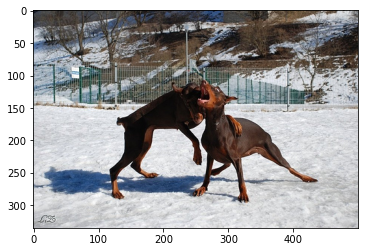

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
A dog be run through the snow .
bleu score:  5.072841446586652e-78


C:\Users\megha\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


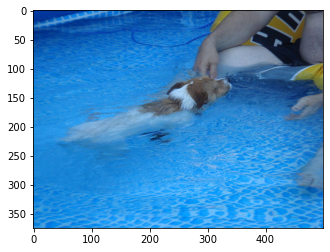

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A boy in a life life life life suit .
bleu score:  6.8489908526642754e-155


C:\Users\megha\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


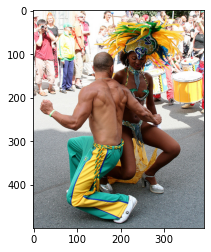

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A woman in a blue shirt be lay on a beach .
bleu score:  8.80154124704578e-155


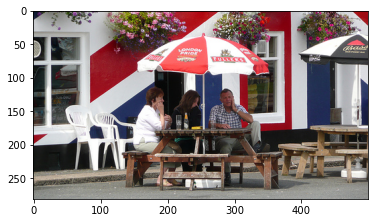

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man be jump over a ramp in a park .
bleu score:  1.3053751225723612e-231


C:\Users\megha\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


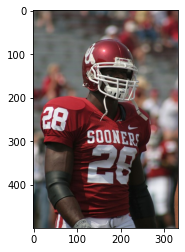

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player in a red uniform be tackle the field .
bleu score:  9.306496788613133e-155


In [54]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

# BLEU Score

BLEU (Bilingual Evaluation Understudy) is a metric used to evaluate the quality of machine translation output by comparing it to one or more reference translations. It was developed as an automated way to evaluate machine translation quality that correlates well with human judgment.

The BLEU score is calculated based on a comparison of n-grams (contiguous sequences of words) between the machine translation output and the reference translations. The score ranges from 0 to 1, with higher scores indicating better translation quality.

The BLEU score is widely used in machine translation research and development to compare the performance of different systems or to tune the parameters of a particular system. However, it is not without its limitations, as it does not capture all aspects of translation quality, such as fluency, grammaticality, and coherence. Additionally, BLEU scores can vary depending on the reference translations used, making it important to use multiple references when possible.

# Calculating Average BLEU Score on Test Set using Greedy Search

In [55]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Greedy search")
print("Score: ",avg_score)


 13%|██████████▎                                                                    | 131/1000 [01:24<10:18,  1.40it/s]


 26%|████████████████████▊                                                          | 263/1000 [02:53<06:20,  1.94it/s]


 40%|███████████████████████████████▏                                               | 395/1000 [04:15<07:04,  1.43it/s]


 53%|█████████████████████████████████████████▋                                     | 527/1000 [05:41<05:01,  1.57it/s]


 66%|████████████████████████████████████████████████████                           | 659/1000 [07:06<03:23,  1.68it/s]


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [08:30<02:14,  1.56it/s]


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [09:52<00:48,  1.57it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:40<00:00,  1.56it/s]


Bleu score on Greedy search
Score:  0.09454317518859753


# Beam Search Algorithm

Beam search is a popular search algorithm used in natural language processing and machine learning to generate output sequences such as text or speech. It works by exploring multiple possible output sequences in parallel, keeping track of the k most likely sequences at each step. The algorithm uses a scoring function to evaluate the likelihood of each sequence, based on the output probabilities of the model and the previous output tokens.

At each step, the algorithm expands the k most likely sequences by adding all possible next tokens and then selects the k most likely sequences from among the expanded set. This process is repeated until the desired output length is reached or a stopping criterion is met. Beam search is a more computationally expensive method than the simple greedy search algorithm but is advantageous as it explores a larger search space and is less likely to get stuck in a local optimum. It can also be further enhanced by incorporating additional constraints or heuristics to improve the quality of the generated output.

# Beam Search Function

In [58]:
def beam_search(photo,k):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))
    
  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1]=="<end>":
        break
      sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

# Predicting Captions on Test Set using Beam Search with k=3

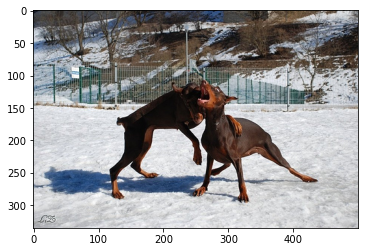

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
Two dog be run in the snow .
bleu score:  0.42728700639623407


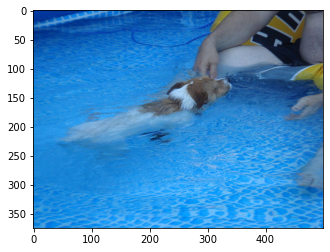

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A little boy be play in a pool .
bleu score:  0.29558013016570783


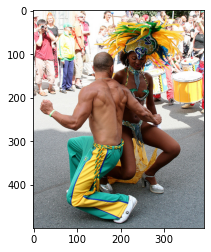

Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A woman in a blue shirt be lay on a beach .
bleu score:  8.80154124704578e-155


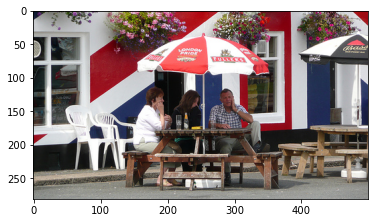

Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man in a blue shirt be sit on a sidewalk .
bleu score:  6.585853050031193e-155


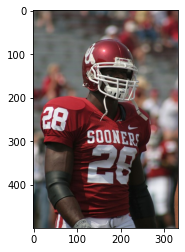

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player prepare to tackle .
bleu score:  8.286571670851008e-155


In [59]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==5):
    break

# Calculating Average Bleu Score on Test Set using Beam Search with k=3

In [60]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Beam search with k=3")
print("Score: ",avg_score)


 13%|██████████▎                                                                    | 131/1000 [05:49<41:31,  2.87s/it]


 26%|████████████████████▊                                                          | 263/1000 [12:25<33:54,  2.76s/it]


 40%|███████████████████████████████▏                                               | 395/1000 [18:36<25:08,  2.49s/it]


 53%|█████████████████████████████████████████▋                                     | 527/1000 [25:15<23:45,  3.01s/it]


 66%|████████████████████████████████████████████████████                           | 659/1000 [31:49<16:27,  2.89s/it]


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [38:04<10:28,  3.01s/it]


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [44:22<03:41,  2.87s/it]


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [47:44<00:00,  2.86s/it]


Bleu score on Beam search with k=3
Score:  0.10795594093890164
